---
#  Data Ingestion - Data Preperation 
---

- First Half : all data is ingested 
- Second Half : data is transformed to be inputted into LSTM
- lagged data (see at the end) is pickled as a df - use this to save time 

- note : lagged_data_generator() is defined in this file, not in the Equations.py file 

In [1]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt 

import requests
import pandas as pd
from xml.etree import ElementTree as ET
import json

def parse_fred_xml(xml_content):
    root = ET.fromstring(xml_content)
    data = []
    for obs in root.findall('observation'):
        date = obs.get('date')
        value = obs.get('value')

        if value != ".":
            data.append({'date': date,'value': float(value)})
    
    return pd.DataFrame(data)



In [ ]:

##### WTI DATA #############   MONTLY                                           THIS IS THE PREDICTOR VARIABLE

url = f"https://api.eia.gov/v2/petroleum/pri/spt/data/?api_key=RPdbTZA0nXhnQ2XuVcf03eTL4mXyVGJpgyui8Ash&frequency=monthly&data[0]=value&facets[series][]=RWTC&sort[0][column]=period&sort[0][direction]=desc&offset=0&length=5000"
response = requests.get(url)

jsonxx = json.loads(response.text)
df_wti_monthly_y = pd.DataFrame(jsonxx['response']['data'])
df_wti_monthly_y['value'] = pd.to_numeric(df_wti_monthly_y['value'], errors='coerce')
df_wti_monthly_y['date'] = pd.to_datetime(df_wti_monthly_y['period']) + pd.offsets.MonthEnd(0)
df_wti_monthly_y=df_wti_monthly_y.set_index('date')

###### WTI DATA ############# WEEKLY

url = f"https://api.eia.gov/v2/petroleum/pri/spt/data/?api_key=RPdbTZA0nXhnQ2XuVcf03eTL4mXyVGJpgyui8Ash&frequency=weekly&data[0]=value&facets[series][]=RWTC&sort[0][column]=period&sort[0][direction]=desc&offset=0&length=5000"
response = requests.get(url)
jsonxx = json.loads(response.text)
df_wti_weekly_y = pd.DataFrame(jsonxx['response']['data'])
df_wti_weekly_y['value'] = pd.to_numeric(df_wti_weekly_y['value'], errors='coerce')
df_wti_weekly_y['date'] = pd.to_datetime(df_wti_weekly_y['period']) 
df_wti_weekly_y=df_wti_weekly_y.set_index('date')

######################################################                                                                          NEW BELOW  NEW BELOW   NEW BELOW

###### WTI DATA #############                       DAILY

url = f"https://api.eia.gov/v2/petroleum/pri/spt/data/?api_key=RPdbTZA0nXhnQ2XuVcf03eTL4mXyVGJpgyui8Ash&frequency=daily&data[0]=value&facets[series][]=RWTC&sort[0][column]=period&sort[0][direction]=desc&offset=0&length=5000"
response = requests.get(url)

jsonxx = json.loads(response.text)

df_wti_daily_y = pd.DataFrame(jsonxx['response']['data'])
df_wti_daily_y['value'] = pd.to_numeric(df_wti_daily_y['value'], errors='coerce')
df_wti_daily_y['date'] = pd.to_datetime(df_wti_daily_y['period']) 
df_wti_daily_y=df_wti_daily_y.set_index('date')

# Ingest first chunk (offset=0)
url1 = f"https://api.eia.gov/v2/petroleum/pri/spt/data/?api_key=RPdbTZA0nXhnQ2XuVcf03eTL4mXyVGJpgyui8Ash&frequency=daily&data[0]=value&facets[series][]=RWTC&sort[0][column]=period&sort[0][direction]=desc&offset=0&length=5000"
response1 = requests.get(url1)
json1 = json.loads(response1.text)

df_wti_daily_y1 = pd.DataFrame(json1['response']['data'])
df_wti_daily_y1['value'] = pd.to_numeric(df_wti_daily_y1['value'], errors='coerce')
df_wti_daily_y1['date'] = pd.to_datetime(df_wti_daily_y1['period']) 
df_wti_daily_y1 = df_wti_daily_y1.set_index('date')

# Ingest second chunk (offset=5000)
url2 = f"https://api.eia.gov/v2/petroleum/pri/spt/data/?api_key=RPdbTZA0nXhnQ2XuVcf03eTL4mXyVGJpgyui8Ash&frequency=daily&data[0]=value&facets[series][]=RWTC&sort[0][column]=period&sort[0][direction]=desc&offset=5000&length=5000"
response2 = requests.get(url2)
json2 = json.loads(response2.text)

df_wti_daily_y2 = pd.DataFrame(json2['response']['data'])
df_wti_daily_y2['value'] = pd.to_numeric(df_wti_daily_y2['value'], errors='coerce')
df_wti_daily_y2['date'] = pd.to_datetime(df_wti_daily_y2['period']) 
df_wti_daily_y2 = df_wti_daily_y2.set_index('date')


df_wti_daily_y = pd.concat([df_wti_daily_y1, df_wti_daily_y2] , axis = 0)

#########################                           CREATE END OF THE MONTH MONTHLY DATA IN THE DAILY DATASET     NOTE NOTE  ---- THE END OF MONTH DATA IS IN COLUMN  ---  value_end_of_month  ---

#################                                                                           END OF THE MONTH PRICES FROM WEEKLY DATA 

all_dates_list = list(df_wti_weekly_y.index.astype(str))
month_index = 7
all_yr_mo = sorted(list(set([y[:month_index] for y in all_dates_list])))

end_of_month_dates = []

for yr_mo in all_yr_mo:

    final_date = [i for i in list(df_wti_weekly_y.index.astype(str)) if i[:month_index] == str(yr_mo)][::-1][-1:]
    end_of_month_dates.append(final_date[0])


df_wti_weekly_y["value_end_of_month"] = df_wti_weekly_y["value"][df_wti_weekly_y.index.astype(str).isin(end_of_month_dates)]
##################                                                                           END OF THE MONTH PRICES FROM DAILY DATA 

all_dates_list = list(df_wti_daily_y.index.astype(str))
month_index = 7
all_yr_mo = sorted(list(set([y[:month_index] for y in all_dates_list])))

end_of_month_dates = []

for yr_mo in all_yr_mo:

    final_date = [i for i in list(df_wti_daily_y.index.astype(str)) if i[:month_index] == str(yr_mo)][::-1][-1:]
    end_of_month_dates.append(final_date[0])

df_wti_daily_y["value_end_of_month"] = df_wti_daily_y["value"][df_wti_daily_y.index.astype(str).isin(end_of_month_dates)]

#### CREATEA A NEW DF FOR THE END OF MOHTH DATA CREATED FROM THE DAILY/WEEKLY DATA

df_wti_daily_end_mo_y = df_wti_daily_y.drop(columns = ["value"])
df_wti_daily_end_mo_y = df_wti_daily_end_mo_y[df_wti_daily_end_mo_y["value_end_of_month"].notna()]
df_wti_daily_end_mo_y["value"] = df_wti_daily_end_mo_y["value_end_of_month"] ### since this is standard in the project its easier to integrate into teh cdoe by making a new df fro thsi predictor df 

#*****

df_wti_weekly_end_mo_y = df_wti_weekly_y.drop(columns = ["value"])
df_wti_weekly_end_mo_y = df_wti_weekly_end_mo_y[df_wti_weekly_end_mo_y["value_end_of_month"].notna()]
df_wti_weekly_end_mo_y["value"] = df_wti_weekly_end_mo_y["value_end_of_month"] ### since this is standard in the project its easier to integrate into teh cdoe by making a new df fro thsi predictor df 

# plt.plot(df_wti_daily_end_mo_y["value_end_of_month"])


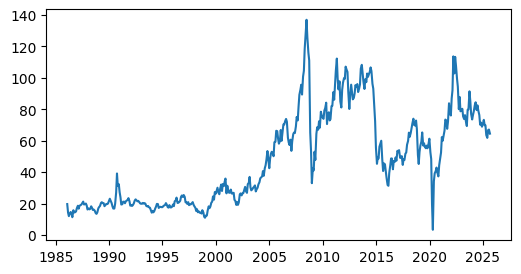

In [24]:
plt.figure(figsize=(6,3))
plt.plot(df_wti_weekly_end_mo_y["value"])
         


Index(['period', 'duoarea', 'area-name', 'product', 'product-name', 'process',
       'process-name', 'series', 'series-description', 'value', 'units',
       'value_end_of_month'],
      dtype='object')
Index(['open', 'high', 'low', 'close', 'adj_close', 'volume'], dtype='object')


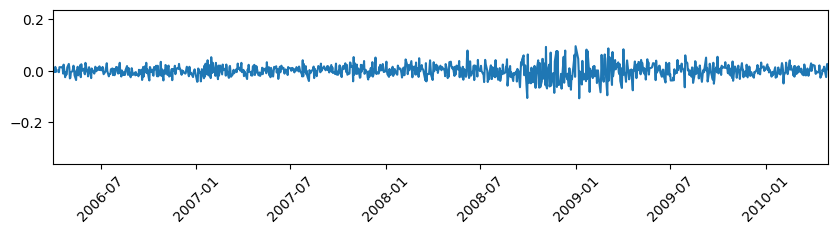

USO min date: 2006-04-10 00:00:00


In [25]:

####  United States Oil Fund, LP (USO) , https://ca.finance.yahoo.com/quote/USO/history/

# USO’s investment objective is for the daily changes, in percentage terms, of its shares’ net asset value (NAV) to reflect the daily
# changes, in percentage terms, of the spot price of light sweet crude oil delivered to Cushing, Oklahoma, as measured by the daily changes
# in the Benchmark Oil Futures Contract plus interest earned on USO’s collateral holdings, less USO’s expenses. USO seeks to achieve its 
# investment objective by investing so that the average daily percentage change in USO’s NAV, for any period of 30 successive valuation days,
# will be within plus/minus 10% of the average daily percentage change in the price of the Benchmark Oil Futures Contract over the same period.

raw_data = """
Aug 29, 2025	75.35	75.45	74.74	74.84	74.84	3,453,652
Aug 28, 2025	74.94	75.67	74.11	75.24	75.24	3,522,000
Aug 27, 2025	74.13	75.11	74.13	74.68	74.68	3,322,100
Aug 26, 2025	74.58	75.12	73.85	74.05	74.05	3,174,400
Aug 25, 2025	75.19	76.12	75.17	75.75	75.75	3,175,800
Aug 22, 2025	74.28	74.73	74.12	74.64	74.64	4,873,300
Aug 21, 2025	73.29	74.41	73.09	74.13	74.13	3,185,700
Aug 20, 2025	73.16	73.63	72.59	73.52	73.52	3,858,800
Aug 19, 2025	72.50	72.75	72.06	72.30	72.30	3,423,300
Aug 18, 2025	72.35	73.63	71.81	73.17	73.17	5,247,900
Aug 15, 2025	72.72	73.22	72.29	72.80	72.80	8,046,900
Aug 14, 2025	73.36	73.78	72.88	73.74	73.74	4,551,100
Aug 13, 2025	72.78	72.83	71.56	72.46	72.46	5,653,500
Aug 12, 2025	73.22	73.58	72.80	72.95	72.95	2,929,300
Aug 11, 2025	73.94	74.23	73.36	73.80	73.80	3,307,600
Aug 8, 2025	73.93	74.40	72.39	73.30	73.30	5,793,400
Aug 7, 2025	74.06	74.54	73.42	73.42	73.42	3,578,400
Aug 6, 2025	76.31	76.84	73.32	73.79	73.79	8,908,700
Aug 5, 2025	75.51	75.75	74.89	75.02	75.02	5,894,000
Aug 4, 2025	75.64	77.16	75.46	76.11	76.11	5,326,700
Aug 1, 2025	79.71	79.83	77.19	77.46	77.46	7,087,100
Jul 31, 2025	79.86	80.42	78.92	79.59	79.59	3,817,100
Jul 30, 2025	80.16	81.13	79.73	81.04	81.04	4,957,400
Jul 29, 2025	77.45	80.24	77.34	79.80	79.80	7,928,200
Jul 28, 2025	76.70	77.24	76.21	77.17	77.17	3,796,800
Jul 25, 2025	76.11	76.11	74.80	74.85	74.85	3,287,400
Jul 24, 2025	75.87	76.34	75.15	76.09	76.09	5,938,400
Jul 23, 2025	74.81	75.33	74.44	75.28	75.28	4,811,500
Jul 22, 2025	75.06	75.47	74.55	75.35	75.35	3,946,300
Jul 21, 2025	75.62	75.91	74.99	75.59	75.59	2,884,800
Jul 18, 2025	76.97	77.31	75.80	75.93	75.93	7,583,500
Jul 17, 2025	75.01	76.26	74.87	76.16	76.16	4,350,000
Jul 16, 2025	74.21	75.33	73.99	75.19	75.19	6,178,100
Jul 15, 2025	75.31	75.88	74.94	75.26	75.26	5,941,400
Jul 14, 2025	77.27	77.27	75.50	75.62	75.62	7,289,700
Jul 11, 2025	76.09	77.35	76.08	77.29	77.29	4,487,200
Jul 10, 2025	75.37	75.92	74.96	75.39	75.39	6,704,000
Jul 9, 2025	76.45	77.52	76.28	76.93	76.93	3,839,700
Jul 8, 2025	76.18	77.59	76.05	76.96	76.96	4,287,200
Jul 7, 2025	75.84	76.89	75.57	76.48	76.48	6,155,000
Jul 3, 2025	75.41	75.92	74.88	75.19	75.19	4,394,800
Jul 2, 2025	74.32	76.02	73.51	75.59	75.59	6,491,400
Jul 1, 2025	73.61	74.04	73.32	73.93	73.93	4,425,200
Jun 30, 2025	73.48	73.63	72.72	73.11	73.11	5,917,500
Jun 27, 2025	74.02	74.34	72.87	73.28	73.28	11,610,800
Jun 26, 2025	73.63	74.68	73.09	73.59	73.59	9,514,900
Jun 25, 2025	72.93	74.23	72.79	73.31	73.31	12,401,000
Jun 24, 2025	73.34	73.86	71.97	73.00	73.00	16,119,600
Jun 23, 2025	83.25	83.57	76.41	76.41	76.41	50,659,400
Jun 20, 2025	82.25	83.38	81.86	83.12	83.12	14,229,000
Jun 18, 2025	83.10	83.46	80.16	82.27	82.27	36,772,300
Jun 17, 2025	80.44	82.89	80.09	82.30	82.30	26,239,300
Jun 16, 2025	79.01	79.60	76.25	78.59	78.59	40,622,400
Jun 13, 2025	80.47	81.14	78.64	80.22	80.22	33,971,200
Jun 12, 2025	74.01	75.41	73.75	75.05	75.05	11,696,900
Jun 11, 2025	73.02	75.32	72.80	74.82	74.82	8,888,000
Jun 10, 2025	72.17	73.07	71.26	71.60	71.60	5,541,900
Jun 9, 2025	71.40	72.18	71.08	72.05	72.05	2,893,900
Jun 6, 2025	70.36	71.52	70.36	71.38	71.38	3,488,000
Jun 5, 2025	70.43	70.61	69.79	69.93	69.93	2,613,700
Jun 4, 2025	70.00	70.56	68.64	69.34	69.34	6,455,200
Jun 3, 2025	69.62	70.50	69.37	69.89	69.89	3,996,900
Jun 2, 2025	69.99	70.04	68.64	69.55	69.55	7,125,100
May 30, 2025	67.10	67.25	65.96	67.15	67.15	8,793,200
May 29, 2025	67.63	67.64	66.78	67.19	67.19	4,856,200
May 28, 2025	68.33	68.96	67.83	67.89	67.89	5,201,800
May 27, 2025	67.48	67.60	66.47	67.28	67.28	3,938,200
May 23, 2025	66.97	68.22	66.96	67.99	67.99	4,285,000
May 22, 2025	66.88	67.55	66.57	67.14	67.14	3,512,500
May 21, 2025	69.14	69.16	67.57	67.59	67.59	5,467,400
May 20, 2025	68.37	68.80	67.78	68.66	68.66	2,786,100
May 19, 2025	68.11	69.10	67.88	68.51	68.51	5,136,900
May 16, 2025	67.83	68.54	67.42	68.10	68.10	3,769,400
May 15, 2025	67.41	67.79	66.87	67.59	67.59	5,263,400
May 14, 2025	69.28	69.55	68.70	68.73	68.73	2,802,500
May 13, 2025	68.45	69.88	68.40	69.59	69.59	4,728,000
May 12, 2025	69.08	69.28	67.48	67.60	67.60	4,861,900
May 9, 2025	65.96	66.82	65.87	66.61	66.61	4,361,300
May 8, 2025	64.44	65.74	64.43	65.60	65.60	4,643,900
May 7, 2025	64.41	64.67	63.26	63.51	63.51	4,008,500
May 6, 2025	64.70	65.41	64.46	64.60	64.60	5,745,700
May 5, 2025	62.85	63.02	61.75	62.37	62.37	4,867,100
May 2, 2025	64.53	64.60	63.11	64.01	64.01	7,095,900
May 1, 2025	63.59	65.08	63.10	64.52	64.52	10,673,900
Apr 30, 2025	65.45	65.72	63.30	63.56	63.56	10,236,300
Apr 29, 2025	66.69	66.81	65.83	65.85	65.85	4,650,000
Apr 28, 2025	68.87	69.04	67.17	67.76	67.76	3,232,700
Apr 25, 2025	68.05	69.18	68.04	69.03	69.03	3,272,100
Apr 24, 2025	68.65	68.86	67.70	68.46	68.46	4,336,600
Apr 23, 2025	68.99	69.81	67.19	68.05	68.05	8,908,500
Apr 22, 2025	68.89	70.27	68.72	69.37	69.37	4,499,000
Apr 21, 2025	68.27	68.66	67.44	68.62	68.62	2,343,000
Apr 17, 2025	68.35	70.05	68.15	69.48	69.48	4,776,800
Apr 16, 2025	66.99	67.97	66.99	67.75	67.75	5,452,100
Apr 15, 2025	66.47	66.92	65.92	66.48	66.48	1,779,200
Apr 14, 2025	67.12	67.13	65.62	66.66	66.66	3,146,200
Apr 11, 2025	64.65	66.79	64.50	66.46	66.46	4,386,200
Apr 10, 2025	64.77	65.47	63.60	65.32	65.32	6,596,700
Apr 9, 2025	61.73	68.05	60.67	67.58	67.58	15,313,000
Apr 8, 2025	66.60	66.80	62.74	63.34	63.34	8,411,300
Apr 7, 2025	65.64	69.20	64.94	65.98	65.98	7,869,100
Apr 4, 2025	66.90	68.42	65.50	67.92	67.92	9,319,900
Apr 3, 2025	72.16	72.70	71.44	72.25	72.25	6,279,800
Apr 2, 2025	76.72	77.86	76.69	77.74	77.74	2,808,400
Apr 1, 2025	77.60	78.01	76.88	77.08	77.08	2,753,900
Mar 31, 2025	75.52	77.72	75.28	77.33	77.33	3,147,400
Mar 28, 2025	75.52	75.54	74.54	74.77	74.77	2,430,300
Mar 27, 2025	75.26	75.68	74.78	75.48	75.48	1,590,800
Mar 26, 2025	75.34	75.94	75.13	75.42	75.42	2,469,600
Mar 25, 2025	75.23	75.36	74.12	74.82	74.82	1,922,900
Mar 24, 2025	74.13	74.97	73.94	74.88	74.88	2,755,300
Mar 21, 2025	73.39	73.96	73.14	73.79	73.79	1,528,800
Mar 20, 2025	72.23	73.80	72.04	73.73	73.73	2,523,100
Mar 19, 2025	72.08	72.88	71.93	72.42	72.42	1,747,400
Mar 18, 2025	73.39	73.49	71.97	72.21	72.21	2,739,000
Mar 17, 2025	72.98	73.17	72.43	72.71	72.71	2,873,700
Mar 14, 2025	71.89	72.43	71.65	72.28	72.28	2,054,600
Mar 13, 2025	72.08	72.44	71.41	71.62	71.62	3,119,100
Mar 12, 2025	72.32	72.97	72.04	72.80	72.80	2,389,100
Mar 11, 2025	71.80	72.17	70.98	71.45	71.45	1,876,200
Mar 10, 2025	72.06	72.25	70.74	70.89	70.89	1,777,100
Mar 7, 2025	72.74	73.31	71.77	72.09	72.09	4,195,700
Mar 6, 2025	71.37	72.02	70.49	71.13	71.13	3,038,700
Mar 5, 2025	71.40	71.49	70.09	71.42	71.42	3,811,000
Mar 4, 2025	72.75	73.61	71.71	73.31	73.31	2,030,600
Mar 3, 2025	75.33	75.56	72.93	73.32	73.32	3,996,300
Feb 28, 2025	74.58	75.47	74.25	75.22	75.22	2,351,600
Feb 27, 2025	75.02	75.79	74.69	75.28	75.28	2,641,900
Feb 26, 2025	73.91	74.27	73.41	73.85	73.85	3,229,400
Feb 25, 2025	75.60	75.61	73.74	74.13	74.13	2,386,600
Feb 24, 2025	75.71	76.14	75.45	75.97	75.97	2,930,800
Feb 21, 2025	76.70	76.85	75.34	75.35	75.35	2,749,100
Feb 20, 2025	77.92	78.47	77.62	77.76	77.76	1,627,000
Feb 19, 2025	78.06	78.20	77.23	77.45	77.45	1,554,200
Feb 18, 2025	76.69	77.11	76.35	76.96	76.96	2,324,900
Feb 14, 2025	76.58	76.74	75.63	75.82	75.82	2,426,000
Feb 13, 2025	75.68	76.47	75.58	76.39	76.39	1,897,100
Feb 12, 2025	77.15	77.46	76.29	76.32	76.32	4,918,700
Feb 11, 2025	78.37	78.49	77.87	78.27	78.27	2,284,100
Feb 10, 2025	76.94	77.51	76.61	77.40	77.40	2,814,500
Feb 7, 2025	76.22	76.29	75.46	75.86	75.86	2,013,900
Feb 6, 2025	76.36	76.73	75.27	75.45	75.45	2,168,400
Feb 5, 2025	76.57	77.00	75.83	76.09	76.09	1,985,200
Feb 4, 2025	75.70	78.30	75.60	77.51	77.51	6,136,900
Feb 3, 2025	78.42	78.77	76.94	77.82	77.82	4,200,200
Jan 31, 2025	77.60	78.26	76.76	78.02	78.02	3,538,900
Jan 30, 2025	77.77	78.77	77.46	77.75	77.75	2,238,600
Jan 29, 2025	78.02	78.65	77.18	77.78	77.78	1,670,500
Jan 28, 2025	78.87	78.95	77.81	78.86	78.86	1,592,300
Jan 27, 2025	79.28	79.54	77.23	77.93	77.93	1,954,800
Jan 24, 2025	80.07	80.22	79.02	79.60	79.60	1,922,700
Jan 23, 2025	80.56	81.04	79.16	79.21	79.21	3,803,200
Jan 22, 2025	80.72	81.21	80.32	80.43	80.43	2,798,000
Jan 21, 2025	80.62	81.34	80.45	81.11	81.11	2,410,900
Jan 17, 2025	82.52	83.00	82.23	82.52	82.52	2,297,600
Jan 16, 2025	83.49	83.60	81.99	82.94	82.94	3,607,100
Jan 15, 2025	82.28	84.58	82.28	84.34	84.34	4,891,900
Jan 14, 2025	81.90	82.08	81.21	81.67	81.67	4,679,800
Jan 13, 2025	81.51	82.82	81.37	82.23	82.23	5,060,500
Jan 10, 2025	81.54	81.82	79.37	80.64	80.64	5,048,700
Jan 8, 2025	78.35	78.46	77.06	77.30	77.30	3,259,100
Jan 7, 2025	78.13	78.44	77.70	78.17	78.17	3,912,400
Jan 6, 2025	78.43	78.90	77.06	77.30	77.30	2,141,800
Jan 3, 2025	77.41	78.22	77.26	77.92	77.92	1,875,300
Jan 2, 2025	76.84	77.56	76.84	76.93	76.93	3,269,400
Dec 31, 2024	75.24	75.75	74.97	75.55	75.55	1,273,500
Dec 30, 2024	74.86	75.27	74.46	74.82	74.82	1,621,000
Dec 27, 2024	74.10	74.40	73.69	73.85	73.85	1,462,000
Dec 26, 2024	74.26	74.38	72.90	73.13	73.13	1,808,600
Dec 24, 2024	73.70	74.03	73.45	73.65	73.65	1,011,800
Dec 23, 2024	72.91	73.07	72.10	73.06	73.06	1,894,400
Dec 20, 2024	72.27	73.41	71.96	73.10	73.10	1,599,800
Dec 19, 2024	73.93	74.11	72.61	72.61	72.61	2,099,400
Dec 18, 2024	73.67	74.38	72.92	72.94	72.94	2,338,100
Dec 17, 2024	72.96	73.35	72.31	73.30	73.30	2,140,100
Dec 16, 2024	74.15	74.30	73.61	73.70	73.70	1,947,900
Dec 13, 2024	73.62	74.50	73.55	74.21	74.21	2,713,400
Dec 12, 2024	72.90	73.58	72.19	73.21	73.21	2,830,100
Dec 11, 2024	72.58	73.59	72.15	73.33	73.33	3,061,900
Dec 10, 2024	71.54	72.13	71.32	71.40	71.40	2,475,900
Dec 9, 2024	71.23	71.97	71.16	71.17	71.17	2,061,700
Dec 6, 2024	70.62	70.71	69.99	70.24	70.24	3,083,800
Dec 5, 2024	71.95	72.17	71.22	71.47	71.47	1,525,200
Dec 4, 2024	73.41	73.45	71.52	71.88	71.88	2,784,100
Dec 3, 2024	72.16	73.32	71.80	73.04	73.04	3,199,100
Dec 2, 2024	71.87	71.95	70.70	71.04	71.04	3,553,900
Nov 29, 2024	72.32	72.74	71.51	71.61	71.61	1,757,600
Nov 27, 2024	71.63	72.30	71.16	71.72	71.72	1,575,900
Nov 26, 2024	72.52	73.34	71.01	71.61	71.61	2,882,200
Nov 25, 2024	72.94	73.44	71.73	72.10	72.10	3,299,000
Nov 22, 2024	73.10	74.58	72.94	74.25	74.25	2,573,800
Nov 21, 2024	73.13	73.26	72.39	73.20	73.20	1,848,100
Nov 20, 2024	72.84	72.84	71.60	72.02	72.02	1,362,400
Nov 19, 2024	72.40	72.71	71.40	72.31	72.31	3,959,400
Nov 18, 2024	70.93	72.31	70.90	72.07	72.07	3,112,000
Nov 15, 2024	70.87	71.35	69.56	69.75	69.75	3,629,400
Nov 14, 2024	72.06	72.09	70.82	71.29	71.29	2,088,900
Nov 13, 2024	70.33	71.50	69.60	70.73	70.73	3,449,100
Nov 12, 2024	71.78	71.85	70.50	70.69	70.69	1,905,500
Nov 11, 2024	71.21	71.45	70.64	70.94	70.94	3,272,100
Nov 8, 2024	73.84	73.94	72.66	73.13	73.13	2,984,700
Nov 7, 2024	74.01	75.56	73.51	74.66	74.66	3,133,400
Nov 6, 2024	73.23	75.32	73.23	74.54	74.54	4,179,100
Nov 5, 2024	74.92	75.34	74.05	74.73	74.73	2,839,500
Nov 4, 2024	73.86	74.43	73.28	74.29	74.29	3,240,200
Nov 1, 2024	73.63	73.80	71.95	72.02	72.02	4,533,400
Oct 31, 2024	71.81	73.35	71.44	73.08	73.08	9,183,500
Oct 30, 2024	70.67	71.63	70.36	71.36	71.36	3,934,400
Oct 29, 2024	70.12	70.31	69.14	69.66	69.66	4,015,900
Oct 28, 2024	69.77	70.64	69.67	70.43	70.43	7,429,100
Oct 25, 2024	73.80	74.49	73.36	74.23	74.23	3,676,100
Oct 24, 2024	73.75	74.08	72.27	73.06	73.06	2,218,600
Oct 23, 2024	73.49	74.03	72.91	73.55	73.55	2,413,400
Oct 22, 2024	73.19	74.65	73.00	73.98	73.98	3,782,100
Oct 21, 2024	72.40	72.87	71.71	72.26	72.26	2,941,400
Oct 18, 2024	71.74	71.92	70.57	71.38	71.38	4,342,300
Oct 17, 2024	72.05	72.84	71.31	72.62	72.62	2,541,700
Oct 16, 2024	72.38	72.67	71.53	72.40	72.40	2,195,300
Oct 15, 2024	72.27	72.95	71.67	72.76	72.76	4,116,700
Oct 14, 2024	76.06	76.65	75.48	75.93	75.93	3,943,200
Oct 11, 2024	77.01	77.88	76.69	77.49	77.49	3,642,400
Oct 10, 2024	76.15	78.04	75.76	77.77	77.77	4,533,100
Oct 9, 2024	74.11	75.36	73.41	75.25	75.25	6,501,500
Oct 8, 2024	76.83	76.94	74.57	75.79	75.79	8,048,000
Oct 7, 2024	77.42	79.31	77.29	79.20	79.20	4,353,500
Oct 4, 2024	76.21	77.40	75.76	76.35	76.35	5,843,100
Oct 3, 2024	73.74	75.90	73.45	75.73	75.73	7,082,200
Oct 2, 2024	73.95	74.21	71.62	72.76	72.76	4,093,000
Oct 1, 2024	69.34	73.73	69.29	72.11	72.11	13,945,000
Sep 30, 2024	69.96	70.87	69.42	69.92	69.92	2,338,500
Sep 27, 2024	69.30	70.32	68.80	70.27	70.27	3,214,700
Sep 26, 2024	69.22	70.12	68.60	69.01	69.01	4,593,800
Sep 25, 2024	72.35	72.80	70.94	71.48	71.48	3,469,200
Sep 24, 2024	73.85	73.86	72.83	73.29	73.29	2,387,000
Sep 23, 2024	72.96	73.53	71.17	72.25	72.25	2,837,700
Sep 20, 2024	72.42	73.14	72.05	72.92	72.92	1,353,300
Sep 19, 2024	72.22	73.21	71.79	72.75	72.75	4,126,900
Sep 18, 2024	71.01	71.94	70.58	70.66	70.66	2,443,800
Sep 17, 2024	70.90	72.29	70.84	71.72	71.72	1,952,300
Sep 16, 2024	70.61	71.22	70.13	70.88	70.88	3,317,900
Sep 13, 2024	70.20	70.93	69.12	69.84	69.84	2,453,000
Sep 12, 2024	69.07	70.46	68.53	69.89	69.89	4,035,600
Sep 11, 2024	67.85	68.62	66.37	67.85	67.85	3,143,200
Sep 10, 2024	69.45	69.49	66.02	66.96	66.96	4,038,100
Sep 9, 2024	68.49	69.66	68.05	69.27	69.27	2,685,200
Sep 6, 2024	70.55	70.87	67.91	68.93	68.93	3,708,600
Sep 5, 2024	70.73	71.53	69.51	69.89	69.89	3,482,600
Sep 4, 2024	70.62	71.50	69.55	69.61	69.61	4,701,400
Sep 3, 2024	72.15	72.15	70.85	71.09	71.09	4,967,800
Aug 30, 2024	75.19	75.22	74.12	74.34	74.34	3,341,400
Aug 29, 2024	76.77	77.65	76.10	76.77	76.77	4,062,000
Aug 28, 2024	75.40	76.23	74.80	75.48	75.48	1,852,500
Aug 27, 2024	77.39	77.60	76.14	76.49	76.49	3,537,500
Aug 26, 2024	78.07	78.32	77.62	77.83	77.83	4,196,800
Aug 23, 2024	74.99	75.76	74.87	75.55	75.55	3,008,600
Aug 22, 2024	72.83	74.17	72.71	73.58	73.58	3,170,300
Aug 21, 2024	74.32	74.81	72.11	72.60	72.60	2,769,800
Aug 20, 2024	74.74	75.02	73.68	73.83	73.83	2,761,700
Aug 19, 2024	76.25	76.38	74.09	74.38	74.38	4,881,200
Aug 16, 2024	76.23	76.65	75.69	76.32	76.32	2,476,000
Aug 15, 2024	77.29	78.00	77.15	77.41	77.41	1,640,500
Aug 14, 2024	77.60	77.75	76.30	76.59	76.59	1,721,700
Aug 13, 2024	78.38	78.46	77.31	77.64	77.64	2,300,800
Aug 12, 2024	77.19	79.17	76.93	78.63	78.63	4,745,000
Aug 9, 2024	75.67	76.35	75.25	76.22	76.22	2,923,600
Aug 8, 2024	74.53	75.80	74.44	75.36	75.36	3,034,300
Aug 7, 2024	73.94	75.17	73.69	74.69	74.69	4,944,000
Aug 6, 2024	71.77	73.39	71.73	72.45	72.45	3,377,900
Aug 5, 2024	71.94	73.26	71.83	73.22	73.22	3,939,500
Aug 2, 2024	73.81	73.82	72.43	73.39	73.39	5,001,300
Aug 1, 2024	77.79	77.85	75.64	76.29	76.29	3,633,500
Jul 31, 2024	76.33	77.91	75.90	77.74	77.74	4,582,800
Jul 30, 2024	74.45	74.77	74.00	74.46	74.46	3,304,600
Jul 29, 2024	76.73	76.99	74.74	75.19	75.19	1,955,400
Jul 26, 2024	76.82	76.94	75.55	76.11	76.11	2,125,100
Jul 25, 2024	76.17	77.78	75.54	77.46	77.46	1,824,000
Jul 24, 2024	76.87	77.48	76.30	76.81	76.81	2,129,200
Jul 23, 2024	76.96	77.13	75.72	76.62	76.62	3,124,100
Jul 22, 2024	77.17	77.75	76.86	77.62	77.62	1,556,600
Jul 19, 2024	79.51	80.22	77.86	78.00	78.00	2,636,000
Jul 18, 2024	80.59	81.09	79.84	79.90	79.90	1,425,500
Jul 17, 2024	80.00	80.71	79.95	80.62	80.62	2,459,300
Jul 16, 2024	78.68	79.41	78.68	79.06	79.06	2,012,200
Jul 15, 2024	80.26	80.38	79.57	80.12	80.12	2,206,700
Jul 12, 2024	81.25	81.32	80.11	80.25	80.25	3,003,800
Jul 11, 2024	79.93	80.99	79.73	80.94	80.94	2,998,200
Jul 10, 2024	79.42	80.69	79.18	80.48	80.48	2,291,900
Jul 9, 2024	80.12	80.65	79.46	79.77	79.77	1,913,000
Jul 8, 2024	80.59	81.02	80.29	80.42	80.42	2,029,600
Jul 5, 2024	82.01	82.60	81.23	81.31	81.31	1,979,700
Jul 3, 2024	80.95	81.60	80.57	81.27	81.27	734,700
Jul 2, 2024	81.98	82.02	80.83	81.11	81.11	1,182,500
Jul 1, 2024	80.21	81.69	79.82	81.54	81.54	2,272,800
Jun 28, 2024	80.03	80.04	79.08	79.59	79.59	1,359,600
Jun 27, 2024	79.70	80.03	79.22	79.92	79.92	1,785,700
Jun 26, 2024	78.94	79.55	78.27	78.75	78.75	1,581,900
Jun 25, 2024	79.47	79.83	78.75	78.90	78.90	1,268,100
Jun 24, 2024	78.52	79.80	78.49	79.70	79.70	1,402,400
Jun 21, 2024	79.44	79.79	78.40	78.65	78.65	1,525,500
Jun 20, 2024	79.28	79.53	78.85	79.41	79.41	1,446,500
Jun 18, 2024	77.88	78.83	77.76	78.67	78.67	1,757,300
Jun 17, 2024	76.66	77.98	76.55	77.79	77.79	2,589,800
Jun 14, 2024	76.62	76.78	75.84	76.08	76.08	2,347,100
Jun 13, 2024	76.31	76.52	75.69	75.74	75.74	1,685,400
Jun 12, 2024	76.83	76.92	75.57	75.98	75.98	2,465,300
Jun 11, 2024	75.34	75.99	74.91	75.51	75.51	1,891,700
Jun 10, 2024	73.78	75.55	73.56	75.46	75.46	4,020,300
Jun 7, 2024	73.56	73.92	72.96	73.02	73.02	2,049,500
Jun 6, 2024	72.12	73.47	71.96	73.26	73.26	1,933,300
Jun 5, 2024	71.40	71.98	70.76	71.89	71.89	2,058,500
Jun 4, 2024	70.96	71.45	70.44	71.09	71.09	2,421,100
Jun 3, 2024	73.93	73.93	71.76	71.83	71.83	5,763,800
May 31, 2024	75.63	75.84	74.33	74.82	74.82	2,038,300
May 30, 2024	76.05	76.72	75.25	75.53	75.53	2,332,200
May 29, 2024	77.66	77.67	76.56	76.57	76.57	1,619,000
May 28, 2024	76.76	77.78	76.57	77.66	77.66	2,300,500
May 24, 2024	74.88	75.60	74.73	75.35	75.35	1,164,400
May 23, 2024	75.96	76.18	74.04	74.45	74.45	1,915,600
May 22, 2024	75.21	75.90	74.82	74.87	74.87	2,337,200
May 21, 2024	75.99	76.53	75.53	76.16	76.16	2,009,600
May 20, 2024	76.55	77.55	76.18	76.73	76.73	2,040,500
May 17, 2024	76.35	77.11	76.16	76.97	76.97	2,019,100
May 16, 2024	76.64	76.74	75.93	76.25	76.25	3,195,900
May 15, 2024	74.45	75.88	73.88	75.88	75.88	3,660,000
May 14, 2024	75.30	75.87	74.84	75.21	75.21	2,186,600
May 13, 2024	75.72	76.43	75.60	76.13	76.13	3,055,300
May 10, 2024	76.68	76.83	75.24	75.30	75.30	2,746,600
May 9, 2024	76.07	76.56	75.88	76.52	76.52	2,240,300
May 8, 2024	74.72	76.18	74.55	76.11	76.11	2,423,800
May 7, 2024	75.25	76.16	74.64	75.50	75.50	4,327,400
May 6, 2024	75.54	75.98	74.96	75.66	75.66	6,195,900
May 3, 2024	75.74	75.92	75.02	75.13	75.13	2,875,100
May 2, 2024	76.10	76.40	75.37	75.93	75.93	4,710,000
May 1, 2024	77.37	78.38	75.76	75.93	75.93	5,965,400
Apr 30, 2024	78.93	79.22	77.79	78.38	78.38	3,829,200
Apr 29, 2024	80.07	80.33	79.17	79.50	79.50	3,934,100
Apr 26, 2024	80.97	80.97	80.06	80.39	80.39	1,605,300
Apr 25, 2024	79.57	80.49	78.75	80.44	80.44	3,009,000
Apr 24, 2024	79.71	80.25	79.16	79.64	79.64	3,662,900
Apr 23, 2024	78.25	80.10	78.16	79.98	79.98	3,355,400
Apr 22, 2024	77.86	78.99	77.57	78.78	78.78	3,299,600
Apr 19, 2024	78.72	79.53	78.56	78.85	78.85	7,608,800
Apr 18, 2024	79.12	79.49	78.20	78.78	78.78	4,529,600
Apr 17, 2024	80.28	80.96	78.69	78.91	78.91	5,967,300
Apr 16, 2024	81.31	81.72	81.01	81.33	81.33	4,285,400
Apr 15, 2024	81.00	81.70	80.09	81.65	81.65	10,203,200
Apr 12, 2024	83.00	83.41	81.23	81.53	81.53	9,724,900
Apr 11, 2024	81.67	81.67	80.79	81.55	81.55	6,287,700
Apr 10, 2024	81.39	82.11	80.43	82.09	82.09	6,834,100
Apr 9, 2024	82.13	82.25	80.87	81.15	81.15	3,893,900
Apr 8, 2024	82.38	82.73	81.17	82.20	82.20	3,757,200
Apr 5, 2024	82.58	83.25	82.12	82.40	82.40	3,842,800
Apr 4, 2024	81.07	82.84	80.43	82.27	82.27	6,112,200
Apr 3, 2024	81.31	81.82	81.10	81.25	81.25	3,254,800
Apr 2, 2024	80.63	80.92	79.88	80.79	80.79	4,241,700
Apr 1, 2024	79.08	80.20	78.80	79.67	79.67	4,000,100
Mar 28, 2024	78.27	78.94	78.02	78.73	78.73	4,745,600
Mar 27, 2024	76.92	77.54	76.82	77.51	77.51	2,412,300
Mar 26, 2024	77.94	77.98	77.21	77.29	77.29	2,776,800
Mar 25, 2024	76.99	78.21	76.99	77.76	77.76	2,189,200
Mar 22, 2024	77.07	77.12	76.31	76.68	76.68	2,397,000
Mar 21, 2024	76.83	77.00	76.14	76.82	76.82	2,742,000
Mar 20, 2024	77.20	77.52	76.62	77.25	77.25	4,254,600
Mar 19, 2024	78.09	78.78	77.94	78.43	78.43	2,720,500
Mar 18, 2024	77.02	78.18	76.61	77.98	77.98	3,403,700
Mar 15, 2024	75.97	76.64	75.87	76.33	76.33	3,141,800
Mar 14, 2024	75.90	76.76	75.74	76.30	76.30	4,238,600
Mar 13, 2024	74.75	75.25	74.37	75.09	75.09	4,435,500
Mar 12, 2024	73.42	74.16	73.01	73.35	73.35	4,134,600
Mar 11, 2024	72.97	73.90	72.37	73.62	73.62	3,072,600
Mar 8, 2024	74.02	74.08	72.99	73.36	73.36	4,038,700
Mar 7, 2024	73.56	74.77	73.40	74.23	74.23	3,758,500
Mar 6, 2024	74.67	75.73	74.16	74.34	74.34	4,988,900
Mar 5, 2024	73.62	74.67	73.11	73.45	73.45	4,262,700
Mar 4, 2024	75.43	75.50	73.83	74.01	74.01	3,332,700
Mar 1, 2024	74.74	75.94	74.53	74.96	74.96	5,359,600
Feb 29, 2024	74.07	74.45	73.20	73.36	73.36	3,861,400
Feb 28, 2024	74.46	74.74	73.27	73.62	73.62	3,991,500
Feb 27, 2024	73.21	74.16	73.14	73.85	73.85	5,301,700
Feb 26, 2024	71.55	73.24	71.48	72.79	72.79	3,578,500
Feb 23, 2024	72.19	72.66	71.66	71.92	71.92	3,403,200
Feb 22, 2024	72.99	74.05	72.91	73.60	73.60	2,748,500
Feb 21, 2024	72.17	73.22	72.16	73.20	73.20	3,775,000
Feb 20, 2024	73.44	73.45	72.06	72.42	72.42	3,468,600
Feb 16, 2024	72.95	73.63	72.44	73.41	73.41	4,209,200
Feb 15, 2024	71.77	73.20	71.77	72.84	72.84	4,230,900
Feb 14, 2024	73.07	73.53	71.37	71.55	71.55	4,632,500
Feb 13, 2024	72.54	73.22	71.95	72.65	72.65	3,632,000
Feb 12, 2024	71.53	72.13	71.53	72.11	72.11	3,839,000
Feb 9, 2024	71.94	72.28	71.10	71.67	71.67	2,761,600
Feb 8, 2024	70.27	71.60	70.22	71.52	71.52	6,147,400
Feb 7, 2024	68.94	69.43	68.70	69.42	69.42	5,234,200
Feb 6, 2024	68.65	69.10	68.12	68.81	68.81	4,413,400
Feb 5, 2024	67.83	68.59	66.85	68.18	68.18	3,284,500
Feb 2, 2024	68.03	68.36	67.19	67.51	67.51	5,659,600
Feb 1, 2024	71.59	71.99	68.96	69.07	69.07	13,358,700
Jan 31, 2024	72.32	72.37	70.66	70.92	70.92	5,073,700
Jan 30, 2024	72.00	73.10	71.72	72.81	72.81	3,559,200
Jan 29, 2024	72.43	72.45	71.48	72.05	72.05	3,444,900
Jan 26, 2024	71.98	73.19	71.13	73.10	73.10	4,822,100
Jan 25, 2024	71.48	72.45	71.02	72.23	72.23	4,979,600
Jan 24, 2024	69.97	70.88	69.66	70.54	70.54	4,857,600
Jan 23, 2024	69.34	70.33	69.12	69.66	69.66	3,164,800
Jan 22, 2024	68.88	70.50	68.72	69.69	69.69	4,992,500
Jan 19, 2024	69.41	69.72	68.21	68.82	68.82	4,668,900
Jan 18, 2024	68.36	69.31	67.79	69.06	69.06	4,685,900
Jan 17, 2024	66.48	67.96	66.28	67.94	67.94	4,463,000
Jan 16, 2024	68.09	68.25	67.11	67.25	67.25	4,904,800
Jan 12, 2024	69.38	69.81	67.57	68.02	68.02	7,198,800
Jan 11, 2024	68.35	68.92	67.11	67.65	67.65	7,436,400
Jan 10, 2024	68.27	68.68	66.34	66.56	66.56	6,307,700
Jan 9, 2024	67.30	67.95	66.71	67.39	67.39	4,394,100
Jan 8, 2024	66.07	66.49	65.54	66.40	66.40	6,270,300
Jan 5, 2024	68.83	69.32	68.36	69.03	69.03	4,996,500
Jan 4, 2024	68.19	68.39	66.40	67.57	67.57	5,001,000
Jan 3, 2024	66.92	68.36	66.72	68.19	68.19	7,136,800
Jan 2, 2024	67.56	67.56	65.48	65.77	65.77	7,908,600
Dec 29, 2023	67.68	67.75	66.63	66.65	66.65	3,305,500
Dec 28, 2023	68.35	68.94	66.97	67.18	67.18	5,754,500
Dec 27, 2023	70.02	70.17	68.90	68.92	68.92	3,785,600
Dec 26, 2023	70.52	71.10	70.11	70.21	70.21	4,996,900
Dec 22, 2023	69.63	69.96	68.49	68.69	68.69	4,301,900
Dec 21, 2023	68.13	69.08	68.13	69.03	69.03	3,290,400
Dec 20, 2023	70.15	70.30	68.66	68.79	68.79	5,252,100
Dec 19, 2023	68.30	69.43	68.26	69.36	69.36	4,039,100
Dec 18, 2023	68.89	69.58	67.55	68.09	68.09	5,558,900
Dec 15, 2023	67.19	67.32	65.88	67.15	67.15	3,451,100
Dec 14, 2023	66.95	67.80	66.90	67.16	67.16	5,062,800
Dec 13, 2023	64.42	65.35	64.34	65.33	65.33	3,575,200
Dec 12, 2023	64.93	65.06	63.84	64.25	64.25	7,103,800
Dec 11, 2023	66.50	67.03	65.98	66.80	66.80	2,589,200
Dec 8, 2023	66.11	66.90	65.92	66.53	66.53	4,055,500
Dec 7, 2023	65.65	65.74	64.35	65.11	65.11	4,561,900
Dec 6, 2023	65.98	66.35	64.61	64.76	64.76	9,506,200
Dec 5, 2023	68.74	69.24	67.47	67.58	67.58	4,833,500
Dec 4, 2023	68.66	69.77	67.87	68.47	68.47	5,104,000
Dec 1, 2023	70.93	71.59	69.04	69.24	69.24	4,354,500
Nov 30, 2023	73.50	74.21	70.03	70.14	70.14	9,702,200
Nov 29, 2023	72.12	72.87	70.60	72.52	72.52	4,573,000
Nov 28, 2023	70.64	71.83	70.24	71.26	71.26	2,508,200
Nov 27, 2023	70.30	71.09	69.54	69.96	69.96	4,633,000
Nov 24, 2023	70.95	71.86	70.75	70.82	70.82	1,453,900
Nov 22, 2023	69.28	71.90	68.81	71.61	71.61	5,283,900
Nov 21, 2023	72.06	72.59	71.75	72.53	72.53	2,543,500
Nov 20, 2023	72.18	73.07	71.94	72.30	72.30	3,985,400
Nov 17, 2023	69.14	70.95	69.14	70.75	70.75	5,921,000
Nov 16, 2023	69.61	69.71	67.45	68.05	68.05	6,745,900
Nov 15, 2023	71.81	72.38	71.18	71.34	71.34	5,002,800
Nov 14, 2023	73.23	74.04	72.36	72.69	72.69	2,688,500
Nov 13, 2023	71.81	72.96	71.77	72.92	72.92	3,075,600
Nov 10, 2023	71.31	72.22	71.12	71.79	71.79	3,754,400
Nov 9, 2023	70.75	71.66	70.14	70.25	70.25	4,327,700
Nov 8, 2023	71.27	71.67	69.65	70.19	70.19	7,264,500
Nov 7, 2023	72.99	73.15	71.61	71.80	71.80	7,413,600
Nov 6, 2023	75.89	76.09	74.77	74.91	74.91	2,764,300
Nov 3, 2023	75.29	76.41	74.14	74.85	74.85	5,054,500
Nov 2, 2023	74.91	76.53	74.79	76.18	76.18	4,191,600
Nov 1, 2023	76.66	76.72	74.24	74.75	74.75	4,143,000
Oct 31, 2023	76.21	77.02	74.56	75.02	75.02	4,604,000
Oct 30, 2023	77.24	77.58	75.36	76.05	76.05	5,929,500
Oct 27, 2023	77.62	78.98	76.58	78.36	78.36	5,522,600
Oct 26, 2023	76.83	77.59	76.49	76.89	76.89	3,518,500
Oct 25, 2023	77.11	78.73	75.64	78.46	78.46	6,116,800
Oct 24, 2023	78.04	78.22	76.31	76.93	76.93	6,629,600
Oct 23, 2023	80.22	80.27	78.35	78.89	78.89	4,607,100
Oct 20, 2023	81.59	81.98	80.17	80.70	80.70	4,664,700
Oct 19, 2023	79.37	81.75	78.94	81.68	81.68	5,924,400
Oct 18, 2023	79.72	80.36	79.32	79.84	79.84	4,647,300
Oct 17, 2023	77.98	78.88	77.40	78.80	78.80	3,914,400
Oct 16, 2023	78.63	78.89	77.87	78.39	78.39	5,156,200
Oct 13, 2023	77.71	79.18	77.16	78.99	78.99	6,765,100
Oct 12, 2023	76.58	76.61	74.62	75.42	75.42	4,244,100
Oct 11, 2023	76.19	76.40	74.76	75.67	75.67	6,048,300
Oct 10, 2023	77.19	77.19	76.19	76.71	76.71	4,237,600
Oct 9, 2023	76.76	77.40	76.23	77.13	77.13	6,892,100
Oct 6, 2023	74.43	74.57	73.34	74.16	74.16	3,896,200
Oct 5, 2023	74.11	75.45	73.61	73.99	73.99	5,599,100
Oct 4, 2023	77.97	77.97	75.22	75.59	75.59	7,853,800
Oct 3, 2023	79.81	80.37	79.25	79.93	79.93	2,899,300
Oct 2, 2023	81.18	81.28	79.19	79.39	79.39	3,492,100
Sep 29, 2023	81.90	81.94	80.47	80.86	80.86	2,399,700
Sep 28, 2023	82.32	82.61	81.22	81.57	81.57	3,169,000
Sep 27, 2023	82.24	83.29	82.05	82.90	82.90	4,257,900
Sep 26, 2023	79.97	81.05	79.89	80.88	80.88	2,522,700
Sep 25, 2023	80.59	80.65	79.67	80.39	80.39	1,918,300
Sep 22, 2023	81.55	81.60	79.99	80.63	80.63	2,704,300
Sep 21, 2023	81.25	81.51	80.40	80.41	80.41	3,095,900
Sep 20, 2023	80.56	81.59	80.13	80.14	80.14	4,117,600
Sep 19, 2023	82.18	82.28	81.12	81.50	81.50	6,657,100
Sep 18, 2023	81.79	81.94	80.80	81.45	81.45	5,940,800
Sep 15, 2023	80.29	81.34	80.09	81.29	81.29	2,874,500
Sep 14, 2023	80.66	81.14	80.53	81.12	81.12	3,098,900
Sep 13, 2023	79.86	80.04	79.23	79.68	79.68	2,783,800
Sep 12, 2023	79.36	80.01	79.31	79.70	79.70	3,308,800
Sep 11, 2023	78.93	79.12	78.14	78.37	78.37	2,083,800
Sep 8, 2023	78.14	78.73	77.88	78.30	78.30	2,039,000
Sep 7, 2023	78.15	78.50	77.44	77.95	77.95	2,671,400
Sep 6, 2023	77.60	78.77	77.42	78.52	78.52	3,159,800
Sep 5, 2023	78.07	78.78	77.39	77.76	77.76	4,782,200
Sep 1, 2023	76.00	76.94	75.94	76.92	76.92	4,205,600
Aug 31, 2023	74.48	75.18	73.95	75.06	75.06	2,900,700
Aug 30, 2023	73.73	74.01	73.06	73.66	73.66	2,228,100
Aug 29, 2023	72.66	73.35	71.79	73.32	73.32	2,890,400
Aug 28, 2023	72.40	73.13	72.11	72.41	72.41	1,618,700
Aug 25, 2023	72.62	72.66	70.82	72.45	72.45	3,106,000
Aug 24, 2023	70.88	71.73	70.45	71.41	71.41	2,368,700
Aug 23, 2023	70.80	72.00	70.43	71.36	71.36	3,836,900
Aug 22, 2023	72.76	72.87	72.06	72.28	72.28	1,655,000
Aug 21, 2023	73.42	73.51	72.42	72.58	72.58	2,085,600
Aug 18, 2023	72.18	73.06	71.91	72.79	72.79	2,734,900
Aug 17, 2023	72.57	72.82	71.92	71.98	71.98	2,647,600
Aug 16, 2023	72.90	73.15	71.29	71.37	71.37	3,789,600
Aug 15, 2023	73.25	73.26	72.18	72.62	72.62	3,907,500
Aug 14, 2023	73.69	74.22	73.35	73.81	73.81	3,545,400
Aug 11, 2023	74.14	74.81	73.95	74.25	74.25	3,137,800
Aug 10, 2023	74.66	75.09	73.96	74.20	74.20	3,443,900
Aug 9, 2023	74.78	75.36	74.21	75.10	75.10	4,777,100
Aug 8, 2023	72.47	74.27	72.04	74.06	74.06	4,218,700
Aug 7, 2023	73.76	73.87	73.04	73.82	73.82	1,858,800
Aug 4, 2023	73.22	74.29	72.94	73.79	73.79	2,016,600
Aug 3, 2023	71.70	73.25	71.70	73.14	73.14	2,921,700
Aug 2, 2023	72.67	72.74	70.88	71.48	71.48	3,170,000
Aug 1, 2023	72.68	73.19	72.17	72.96	72.96	1,480,900
Jul 31, 2023	72.75	73.29	72.56	73.17	73.17	2,068,900
Jul 28, 2023	71.32	72.24	70.87	72.09	72.09	1,751,500
Jul 27, 2023	71.16	71.99	70.72	71.43	71.43	1,807,200
Jul 26, 2023	70.59	71.31	70.41	70.66	70.66	1,384,300
Jul 25, 2023	70.40	71.41	70.27	71.16	71.16	2,340,100
Jul 24, 2023	69.61	70.93	69.29	70.69	70.69	2,420,200
Jul 21, 2023	68.52	69.31	68.17	68.99	68.99	2,993,300
Jul 20, 2023	68.33	68.49	67.13	68.05	68.05	2,031,400
Jul 19, 2023	68.39	68.92	67.49	67.69	67.69	1,935,000
Jul 18, 2023	66.79	68.12	66.65	67.96	67.96	2,547,400
Jul 17, 2023	66.85	67.40	66.53	66.58	66.58	2,280,800
Jul 14, 2023	68.53	68.57	67.36	67.47	67.47	2,400,600
Jul 13, 2023	67.79	69.10	67.53	69.09	69.09	3,608,700
Jul 12, 2023	67.62	67.97	67.26	67.87	67.87	3,046,200
Jul 11, 2023	66.03	67.05	65.89	67.03	67.03	2,346,500
Jul 10, 2023	65.63	66.31	65.16	65.54	65.54	2,449,000
Jul 7, 2023	64.14	66.05	64.14	65.85	65.85	2,784,600
Jul 6, 2023	64.33	64.56	63.12	64.44	64.44	2,372,000
Jul 5, 2023	64.66	64.85	63.90	64.63	64.63	2,965,600
Jul 3, 2023	63.82	64.11	63.12	63.39	63.39	1,220,800
Jun 30, 2023	63.35	63.97	63.15	63.55	63.55	3,133,400
Jun 29, 2023	62.75	63.64	62.25	62.96	62.96	1,992,200
Jun 28, 2023	61.47	62.94	60.87	62.52	62.52	2,461,500
Jun 27, 2023	62.33	62.63	61.10	61.30	61.30	2,610,100
Jun 26, 2023	62.15	63.14	62.08	62.73	62.73	2,084,500
Jun 23, 2023	61.04	62.49	60.97	62.42	62.42	2,413,600
Jun 22, 2023	63.15	63.65	62.14	62.52	62.52	3,875,200
Jun 21, 2023	63.83	65.09	63.70	65.04	65.04	2,725,500
Jun 20, 2023	63.75	63.96	62.61	63.92	63.92	2,313,600
Jun 16, 2023	63.48	64.53	63.28	64.35	64.35	2,974,000
Jun 15, 2023	62.21	63.77	62.14	63.41	63.41	3,445,600
Jun 14, 2023	63.00	63.20	61.26	61.83	61.83	4,818,600
Jun 13, 2023	62.09	62.65	61.99	62.14	62.14	3,473,500
Jun 12, 2023	61.00	61.23	60.02	60.24	60.24	5,985,300
Jun 9, 2023	63.64	64.19	62.79	62.93	62.93	3,354,100
Jun 8, 2023	64.89	64.94	61.82	63.46	63.46	8,579,200
Jun 7, 2023	64.49	65.21	64.21	64.71	64.71	3,520,500
Jun 6, 2023	63.08	64.43	63.01	63.79	63.79	2,569,500
Jun 5, 2023	65.37	65.41	64.02	64.03	64.03	3,038,400
Jun 2, 2023	64.10	64.36	63.46	64.15	64.15	6,937,900
Jun 1, 2023	60.66	63.37	60.63	62.55	62.55	3,631,400
May 31, 2023	61.48	62.09	60.61	60.63	60.63	4,040,700
May 30, 2023	62.85	62.97	61.70	62.30	62.30	6,442,600
May 26, 2023	64.90	64.99	64.36	64.80	64.80	2,145,100
May 25, 2023	64.46	64.70	63.21	64.09	64.09	4,322,700
May 24, 2023	65.96	66.24	64.94	65.66	65.66	3,775,800
May 23, 2023	64.64	65.40	64.50	64.87	64.87	3,409,700
May 22, 2023	63.59	64.33	63.36	63.91	63.91	1,645,000
May 19, 2023	64.61	64.66	63.25	63.90	63.90	2,490,200
May 18, 2023	64.32	64.40	63.58	64.04	64.04	2,496,600
May 17, 2023	63.87	64.99	63.06	64.60	64.60	4,276,000
May 16, 2023	63.11	63.54	62.45	62.54	62.54	1,987,100
May 15, 2023	62.70	63.46	62.37	62.99	62.99	4,837,800
May 12, 2023	63.21	63.50	61.94	62.07	62.07	4,070,800
May 11, 2023	63.26	63.62	62.62	63.25	63.25	4,023,300
May 10, 2023	64.80	64.80	63.59	64.39	64.39	2,683,700
May 9, 2023	63.84	65.15	63.10	64.87	64.87	5,831,500
May 8, 2023	64.75	64.89	64.05	64.26	64.26	3,454,600
May 5, 2023	62.73	63.34	62.61	63.03	63.03	4,700,000
May 4, 2023	60.50	61.66	59.78	60.70	60.70	4,997,400
May 3, 2023	61.31	61.39	60.16	60.31	60.31	12,166,700
May 2, 2023	65.48	65.50	62.99	63.05	63.05	6,535,700
May 1, 2023	66.34	66.93	65.62	66.55	66.55	2,939,000
Apr 28, 2023	65.85	67.60	65.53	67.50	67.50	3,043,600
Apr 27, 2023	65.83	66.21	65.16	65.81	65.81	2,752,700
Apr 26, 2023	67.18	67.83	65.20	65.36	65.36	5,692,100
Apr 25, 2023	68.54	68.57	67.26	67.62	67.62	2,262,600
Apr 24, 2023	68.29	69.60	68.11	69.25	69.25	1,924,400
Apr 21, 2023	68.58	68.72	67.91	68.21	68.21	2,620,200
Apr 20, 2023	67.86	68.34	67.51	67.60	67.60	3,486,800
Apr 19, 2023	69.72	69.98	68.86	69.30	69.30	3,621,100
Apr 18, 2023	70.92	71.36	70.09	70.73	70.73	1,468,800
Apr 17, 2023	71.66	71.85	70.48	70.84	70.84	2,985,700
Apr 14, 2023	72.06	72.45	71.34	72.09	72.09	3,170,400
Apr 13, 2023	72.36	72.63	71.65	71.80	71.80	2,790,900
Apr 12, 2023	71.74	72.65	71.61	72.43	72.43	4,474,100
Apr 11, 2023	70.08	71.21	69.97	71.07	71.07	3,346,800
Apr 10, 2023	70.23	70.79	69.62	69.76	69.76	2,884,600
Apr 6, 2023	70.35	70.49	69.77	70.26	70.26	2,839,300
Apr 5, 2023	70.49	70.55	69.68	70.24	70.24	3,015,000
Apr 4, 2023	71.13	71.13	69.58	70.27	70.27	3,592,700
Apr 3, 2023	69.93	70.70	69.63	70.27	70.27	8,377,900
Mar 31, 2023	65.92	66.50	65.26	66.44	66.44	2,730,700
Mar 30, 2023	64.81	65.54	64.19	65.32	65.32	3,295,100
Mar 29, 2023	65.01	65.35	64.00	64.15	64.15	2,593,100
Mar 28, 2023	63.76	64.98	63.76	64.55	64.55	4,149,500
Mar 27, 2023	62.24	64.27	61.86	64.15	64.15	8,701,200
Mar 24, 2023	60.31	61.25	59.84	60.96	60.96	3,721,100
Mar 23, 2023	62.51	63.02	60.90	60.99	60.99	2,635,500
Mar 22, 2023	61.39	62.67	60.92	61.61	61.61	3,512,800
Mar 21, 2023	60.54	61.32	60.11	61.23	61.23	3,975,100
Mar 20, 2023	58.73	59.87	58.05	59.79	59.79	5,391,600
Mar 17, 2023	59.94	60.02	57.83	58.66	58.66	9,071,700
Mar 16, 2023	58.72	61.09	58.04	60.05	60.05	8,441,800
Mar 15, 2023	60.26	60.97	57.94	60.02	60.02	13,746,500
Mar 14, 2023	64.02	65.32	62.34	62.93	62.93	6,367,400
Mar 13, 2023	64.51	66.82	64.07	65.25	65.25	5,203,900
Mar 10, 2023	66.37	67.56	66.20	67.14	67.14	2,989,500
Mar 9, 2023	67.90	68.39	66.17	66.24	66.24	2,436,600
Mar 8, 2023	67.13	67.85	66.78	67.10	67.10	3,018,100
Mar 7, 2023	70.14	70.22	67.56	67.85	67.85	5,071,200
Mar 6, 2023	69.29	70.52	69.05	70.49	70.49	3,977,800
Mar 3, 2023	67.19	69.91	67.14	69.86	69.86	5,179,300
Mar 2, 2023	68.44	68.76	67.89	68.30	68.30	1,623,900
Mar 1, 2023	67.14	68.12	66.73	68.07	68.07	2,577,600
Feb 28, 2023	67.80	67.93	67.16	67.21	67.21	1,886,400
Feb 27, 2023	66.63	66.76	65.73	66.25	66.25	3,024,800
Feb 24, 2023	65.56	67.15	65.11	67.10	67.10	2,593,400
Feb 23, 2023	66.22	66.65	65.70	66.38	66.38	2,136,800
Feb 22, 2023	66.40	66.67	64.89	64.92	64.92	3,495,600
Feb 21, 2023	67.50	67.82	66.54	66.69	66.69	2,432,700
Feb 17, 2023	66.36	67.26	66.01	67.02	67.02	3,851,700
Feb 16, 2023	68.82	69.39	68.42	68.45	68.45	2,369,700
Feb 15, 2023	68.79	69.39	67.80	69.02	69.02	1,907,600
Feb 14, 2023	68.22	69.63	68.01	69.40	69.40	1,601,500
Feb 13, 2023	69.38	70.43	69.07	69.50	69.50	3,458,200
Feb 10, 2023	69.02	69.90	68.95	69.87	69.87	2,817,200
Feb 9, 2023	67.88	68.50	67.12	67.92	67.92	2,430,700
Feb 8, 2023	68.40	68.79	67.61	68.68	68.68	2,052,000
Feb 7, 2023	65.83	67.85	65.82	67.76	67.76	3,598,100
Feb 6, 2023	65.07	65.53	63.67	65.50	65.50	2,694,200
Feb 3, 2023	66.73	68.39	64.35	64.40	64.40	4,875,300
Feb 2, 2023	66.99	67.49	65.90	66.57	66.57	2,561,500
Feb 1, 2023	69.21	69.41	66.76	67.36	67.36	3,538,500
Jan 31, 2023	67.86	69.37	67.67	69.32	69.32	1,391,600
Jan 30, 2023	68.68	69.87	68.03	68.10	68.10	2,345,800
Jan 27, 2023	71.74	71.78	69.20	69.50	69.50	3,185,000
Jan 26, 2023	71.65	71.76	70.27	70.93	70.93	1,481,400
Jan 25, 2023	70.41	71.09	69.64	70.51	70.51	1,613,200
Jan 24, 2023	71.59	71.66	69.88	70.22	70.22	1,653,200
Jan 23, 2023	71.82	72.25	71.29	71.50	71.50	1,661,100
Jan 20, 2023	70.86	71.56	69.97	71.55	71.55	2,438,400
Jan 19, 2023	70.19	71.14	69.69	70.59	70.59	2,814,900
Jan 18, 2023	71.59	72.03	69.35	69.51	69.51	3,172,700
Jan 17, 2023	70.86	71.14	69.46	70.86	70.86	3,796,500
Jan 13, 2023	69.30	70.09	68.92	70.05	70.05	2,503,300
Jan 12, 2023	69.12	69.32	68.42	68.61	68.61	2,616,300
Jan 11, 2023	67.24	68.22	66.46	68.05	68.05	3,545,100
Jan 10, 2023	66.27	66.68	65.22	65.90	65.90	2,000,400
Jan 9, 2023	66.49	67.33	65.45	65.88	65.88	2,941,100
Jan 6, 2023	65.82	66.18	64.46	64.83	64.83	2,994,000
Jan 5, 2023	64.32	65.75	63.93	64.78	64.78	3,555,500
Jan 4, 2023	65.58	65.58	63.98	64.30	64.30	4,215,300
Jan 3, 2023	68.64	69.65	67.12	67.64	67.64	3,339,700
Dec 30, 2022	68.36	70.27	68.35	70.11	70.11	3,648,500
Dec 29, 2022	67.55	68.59	67.37	68.53	68.53	1,972,300
Dec 28, 2022	69.18	69.22	67.53	68.58	68.58	2,782,800
Dec 27, 2022	69.59	70.54	69.06	69.53	69.53	3,147,900
Dec 23, 2022	68.94	69.56	68.87	69.32	69.32	2,928,900
Dec 22, 2022	68.48	68.59	66.85	67.70	67.70	2,381,800
Dec 21, 2022	67.61	68.16	67.41	68.06	68.06	3,292,400
Dec 20, 2022	65.83	66.80	64.82	66.22	66.22	2,501,300
Dec 19, 2022	65.77	66.50	64.83	66.07	66.07	3,920,700
Dec 16, 2022	64.35	65.82	64.14	64.90	64.90	4,847,100
Dec 15, 2022	66.90	67.05	65.68	66.15	66.15	4,665,300
Dec 14, 2022	66.79	67.67	66.08	67.36	67.36	7,394,100
Dec 13, 2022	65.16	66.47	65.14	65.86	65.86	4,496,100
Dec 12, 2022	63.21	64.63	63.05	64.41	64.41	4,520,100
Dec 9, 2022	63.07	63.75	61.81	62.85	62.85	7,184,900
Dec 8, 2022	64.61	64.68	62.46	62.71	62.71	8,334,600
Dec 7, 2022	65.47	65.89	63.20	63.65	63.65	5,443,900
Dec 6, 2022	66.97	67.36	64.52	65.23	65.23	6,746,200
Dec 5, 2022	71.56	71.78	67.25	67.72	67.72	5,259,100
Dec 2, 2022	70.60	71.14	69.35	69.84	69.84	3,459,200
Dec 1, 2022	71.64	72.14	70.30	70.45	70.45	4,571,200
Nov 30, 2022	70.30	70.44	69.55	70.23	70.23	3,724,000
Nov 29, 2022	68.51	69.12	67.19	68.34	68.34	6,290,800
Nov 28, 2022	65.16	67.69	65.00	66.88	66.88	7,370,900
Nov 25, 2022	68.19	68.49	66.78	66.96	66.96	1,703,600
Nov 23, 2022	67.84	68.22	66.86	67.41	67.41	4,693,000
Nov 22, 2022	69.92	70.76	69.58	69.98	69.98	3,715,000
Nov 21, 2022	66.67	69.37	65.37	69.03	69.03	12,862,900
Nov 18, 2022	67.73	69.12	67.46	69.03	69.03	8,376,000
Nov 17, 2022	71.15	71.44	69.52	70.14	70.14	5,000,100
Nov 16, 2022	72.11	72.47	71.38	72.04	72.04	3,359,600
Nov 15, 2022	72.12	74.78	71.60	73.25	73.25	3,318,100
Nov 14, 2022	73.54	74.62	71.88	71.91	71.91	2,680,700
Nov 11, 2022	74.53	75.15	73.68	74.38	74.38	3,191,900
Nov 10, 2022	71.66	72.99	71.19	72.24	72.24	2,020,500
Nov 9, 2022	73.17	73.20	71.58	71.67	71.67	2,585,500
Nov 8, 2022	76.27	76.49	74.08	74.47	74.47	2,539,700
Nov 7, 2022	76.84	77.72	76.22	76.56	76.56	2,231,400
Nov 4, 2022	76.54	76.94	75.50	76.82	76.82	3,679,900
Nov 3, 2022	73.05	74.01	72.86	73.29	73.29	1,482,000
Nov 2, 2022	73.12	74.88	72.79	74.08	74.08	2,796,300
Nov 1, 2022	73.80	73.89	72.66	73.12	73.12	4,586,900
Oct 31, 2022	71.39	72.64	70.72	71.53	71.53	3,088,100
Oct 28, 2022	72.71	73.30	72.03	72.82	72.82	1,511,200
Oct 27, 2022	73.69	74.09	73.11	73.62	73.62	1,308,800
Oct 26, 2022	71.36	73.14	71.35	72.97	72.97	3,435,400
Oct 25, 2022	70.59	71.45	70.23	70.61	70.61	1,517,400
Oct 24, 2022	70.24	71.18	69.80	70.38	70.38	1,722,400
Oct 21, 2022	70.15	70.99	69.46	70.57	70.57	1,564,300
Oct 20, 2022	71.09	71.88	69.71	70.18	70.18	2,545,800
Oct 19, 2022	68.87	70.57	68.55	70.04	70.04	3,094,900
Oct 18, 2022	69.36	69.78	67.85	68.70	68.70	3,291,200
Oct 17, 2022	71.17	71.48	69.78	70.13	70.13	3,255,400
Oct 14, 2022	71.40	71.72	69.75	70.17	70.17	2,518,900
Oct 13, 2022	70.39	72.87	70.37	72.52	72.52	2,304,000
Oct 12, 2022	71.42	71.60	70.20	70.93	70.93	2,338,900
Oct 11, 2022	72.56	73.07	71.40	71.75	71.75	2,476,200
Oct 10, 2022	75.29	76.11	73.60	73.78	73.78	3,511,500
Oct 7, 2022	73.27	75.85	73.25	75.10	75.10	4,670,000
Oct 6, 2022	71.74	73.04	71.61	72.99	72.99	2,981,200
Oct 5, 2022	71.16	72.16	69.87	71.94	71.94	4,927,200
Oct 4, 2022	69.91	71.00	69.31	70.28	70.28	6,673,400
Oct 3, 2022	68.60	68.90	67.17	67.89	67.89	5,256,000
Sep 30, 2022	65.64	66.50	64.85	65.28	65.28	2,397,100
Sep 29, 2022	67.31	67.76	66.25	66.77	66.77	2,762,700
Sep 28, 2022	65.26	67.34	64.95	67.13	67.13	2,603,400
Sep 27, 2022	64.30	65.53	63.69	64.42	64.42	3,273,500
Sep 26, 2022	65.37	66.25	63.15	63.20	63.20	5,064,500
Sep 23, 2022	65.89	65.90	64.65	65.32	65.32	5,923,200
Sep 22, 2022	70.42	70.81	68.53	68.97	68.97	2,928,800
Sep 21, 2022	70.49	70.62	68.10	68.68	68.68	4,537,900
Sep 20, 2022	69.54	69.59	68.41	69.22	69.22	3,569,200
Sep 19, 2022	67.62	70.27	67.49	70.05	70.05	2,863,900
Sep 16, 2022	70.33	70.81	69.44	69.90	69.90	3,384,500
Sep 15, 2022	71.09	71.15	69.34	69.76	69.76	3,898,100
Sep 14, 2022	72.72	73.72	72.25	72.73	72.73	2,594,400
Sep 13, 2022	72.11	72.73	70.10	72.01	72.01	6,056,900
Sep 12, 2022	72.63	73.21	72.07	72.37	72.37	3,710,000
Sep 9, 2022	70.33	71.61	70.03	71.10	71.10	4,953,600
Sep 8, 2022	68.54	69.28	67.65	68.09	68.09	4,277,100
Sep 7, 2022	69.17	69.72	67.59	67.62	67.62	7,540,200
Sep 6, 2022	72.34	72.45	71.15	71.42	71.42	5,250,400
Sep 2, 2022	73.18	73.22	71.30	71.43	71.43	4,050,300
Sep 1, 2022	72.09	72.72	70.80	70.95	70.95	4,319,300
Aug 31, 2022	73.84	75.09	73.06	73.11	73.11	4,538,500
Aug 30, 2022	76.60	76.75	74.28	75.47	75.47	4,968,000
Aug 29, 2022	77.02	78.96	76.71	78.69	78.69	3,693,500
Aug 26, 2022	75.46	76.19	74.77	75.85	75.85	2,424,600
Aug 25, 2022	78.34	78.38	75.83	76.50	76.50	2,960,200
Aug 24, 2022	76.85	78.07	76.22	78.04	78.04	3,857,400
Aug 23, 2022	75.83	77.28	75.81	76.83	76.83	3,782,000
Aug 22, 2022	72.79	74.77	71.45	74.68	74.68	7,937,300
Aug 19, 2022	74.05	75.37	73.83	74.06	74.06	2,700,600
Aug 18, 2022	73.59	74.83	73.32	74.21	74.21	3,315,900
Aug 17, 2022	71.65	73.17	71.09	72.05	72.05	3,800,700
Aug 16, 2022	72.67	73.84	70.67	71.24	71.24	5,750,100
Aug 15, 2022	71.39	73.36	71.26	72.88	72.88	4,446,200
Aug 12, 2022	75.34	75.46	74.30	74.98	74.98	2,949,600
Aug 11, 2022	75.83	76.97	74.98	76.28	76.28	4,687,300
Aug 10, 2022	73.25	74.98	71.45	74.32	74.32	4,622,300
Aug 9, 2022	74.20	74.92	72.62	73.45	73.45	2,492,200
Aug 8, 2022	71.59	73.71	71.47	73.54	73.54	4,429,500
Aug 5, 2022	70.46	73.18	70.42	71.54	71.54	3,139,200
Aug 4, 2022	72.83	73.60	70.96	71.53	71.53	5,215,500
Aug 3, 2022	76.28	76.55	73.30	73.53	73.53	4,033,700
Aug 2, 2022	76.03	77.41	75.28	75.93	75.93	2,737,300
Aug 1, 2022	74.79	75.62	74.01	75.13	75.13	3,326,800
Jul 29, 2022	79.17	80.49	78.00	78.05	78.05	3,632,800
Jul 28, 2022	78.45	78.52	76.48	77.13	77.13	4,322,000
Jul 27, 2022	76.40	78.19	75.42	77.87	77.87	3,166,400
Jul 26, 2022	77.30	77.44	75.00	75.16	75.16	2,949,300
Jul 25, 2022	75.84	76.40	74.93	76.22	76.22	2,807,500
Jul 22, 2022	75.18	76.58	74.43	74.53	74.53	5,768,500
Jul 21, 2022	75.27	76.28	74.70	75.49	75.49	3,979,200
Jul 20, 2022	77.17	78.26	76.48	77.64	77.64	3,125,900
Jul 19, 2022	76.00	78.21	75.99	78.05	78.05	3,172,000
Jul 18, 2022	76.92	77.54	76.53	76.81	76.81	5,382,200
Jul 15, 2022	74.08	74.63	73.06	73.74	73.74	3,367,700
Jul 14, 2022	71.02	73.30	69.51	72.85	72.85	5,355,800
Jul 13, 2022	73.07	74.51	72.23	73.19	73.19	4,365,800
Jul 12, 2022	74.82	75.32	72.56	72.81	72.81	6,104,700
Jul 11, 2022	77.81	78.92	76.63	78.23	78.23	4,950,300
Jul 8, 2022	78.59	79.01	77.08	78.54	78.54	6,450,600
Jul 7, 2022	76.46	77.87	76.27	76.55	76.55	6,993,200
Jul 6, 2022	73.49	74.24	71.46	73.67	73.67	8,899,500
Jul 5, 2022	78.47	78.52	73.42	74.78	74.78	10,752,700
Jul 1, 2022	82.10	82.46	80.84	81.67	81.67	4,689,800
Jun 30, 2022	82.09	82.30	79.93	80.35	80.35	4,631,500
Jun 29, 2022	85.87	86.40	82.91	82.95	82.95	4,619,800
Jun 28, 2022	83.99	85.17	83.33	84.72	84.72	4,226,000
Jun 27, 2022	81.29	83.39	80.40	82.93	82.93	4,591,500
Jun 24, 2022	80.19	82.17	79.63	81.27	81.27	3,456,200
Jun 23, 2022	81.63	81.90	78.96	78.98	78.98	3,918,500
Jun 22, 2022	78.83	82.33	78.49	80.88	80.88	5,215,400
Jun 21, 2022	84.49	85.30	83.65	84.05	84.05	3,674,400
Jun 17, 2022	86.50	86.78	81.94	83.34	83.34	8,744,600
Jun 16, 2022	86.44	88.55	85.05	87.66	87.66	5,171,300
Jun 15, 2022	88.05	88.81	86.24	86.93	86.93	4,420,500
Jun 14, 2022	90.98	91.92	87.37	88.45	88.45	4,675,900
Jun 13, 2022	89.28	91.15	87.68	90.36	90.36	6,681,900
Jun 10, 2022	90.24	90.78	88.50	90.13	90.13	5,865,200
Jun 9, 2022	91.03	91.49	90.72	91.08	91.08	4,583,600
Jun 8, 2022	90.26	92.20	89.74	91.99	91.99	5,357,200
Jun 7, 2022	88.68	90.11	88.09	90.04	90.04	3,893,800
Jun 6, 2022	89.07	89.22	87.85	88.39	88.39	2,315,800
Jun 3, 2022	87.21	89.56	86.96	89.47	89.47	3,671,500
Jun 2, 2022	85.88	87.49	85.27	87.25	87.25	3,769,500
Jun 1, 2022	86.71	87.20	85.50	85.54	85.54	4,762,300
May 31, 2022	87.99	88.32	84.70	85.47	85.47	7,416,000
May 27, 2022	84.33	85.52	84.11	85.46	85.46	2,371,900
May 26, 2022	83.15	85.10	83.15	84.59	84.59	3,780,800
May 25, 2022	82.21	82.69	81.53	82.48	82.48	1,940,400
May 24, 2022	82.03	82.84	81.34	82.00	82.00	1,537,600
May 23, 2022	81.36	82.16	80.91	81.97	81.97	2,989,800
May 20, 2022	81.21	81.84	80.26	81.65	81.65	3,103,800
May 19, 2022	78.50	81.35	78.45	80.58	80.58	4,135,300
May 18, 2022	82.02	82.04	78.65	79.29	79.29	3,882,200
May 17, 2022	83.05	83.63	80.86	81.11	81.11	4,118,300
May 16, 2022	80.98	83.39	80.82	83.11	83.11	4,820,700
May 13, 2022	80.60	81.42	79.93	81.28	81.28	4,194,500
May 12, 2022	78.49	79.47	77.91	79.23	79.23	4,322,700
May 11, 2022	77.76	79.04	77.39	78.18	78.18	4,659,600
May 10, 2022	77.07	77.33	74.22	74.53	74.53	5,741,000
May 9, 2022	79.81	80.03	76.38	76.57	76.57	5,630,900
May 6, 2022	81.63	82.41	80.43	82.13	82.13	5,679,700
May 5, 2022	82.21	82.37	79.23	80.48	80.48	5,997,700
May 4, 2022	79.40	80.72	78.66	80.22	80.22	5,420,100
May 3, 2022	76.92	77.83	76.04	76.69	76.69	2,990,700
May 2, 2022	75.38	78.43	74.86	78.38	78.38	4,467,600
Apr 29, 2022	78.80	79.68	76.94	77.16	77.16	6,097,900
Apr 28, 2022	76.28	78.23	75.86	78.08	78.08	6,856,000
Apr 27, 2022	75.12	76.61	74.87	76.37	76.37	4,545,800
Apr 26, 2022	75.33	76.94	74.37	76.46	76.46	7,354,100
Apr 25, 2022	72.64	74.99	71.98	74.65	74.65	5,073,600
Apr 22, 2022	76.98	77.47	76.28	76.31	76.31	3,730,500
Apr 21, 2022	78.34	79.27	77.07	78.12	78.12	4,815,700
Apr 20, 2022	77.51	77.92	75.57	77.24	77.24	5,056,200
Apr 19, 2022	78.06	78.08	76.34	76.86	76.86	7,626,100
Apr 18, 2022	80.81	81.70	80.00	80.41	80.41	5,326,100
Apr 14, 2022	77.34	80.44	77.23	79.57	79.57	7,437,200
Apr 13, 2022	77.15	78.56	75.89	78.42	78.42	6,918,900
Apr 12, 2022	74.95	76.38	74.91	75.98	75.98	6,839,800
Apr 11, 2022	71.75	72.76	71.30	72.30	72.30	5,209,400
Apr 8, 2022	72.69	74.60	72.39	74.11	74.11	5,666,300
Apr 7, 2022	73.26	73.84	71.08	73.11	73.11	5,749,300
Apr 6, 2022	76.25	76.75	72.16	73.05	73.05	7,040,900
Apr 5, 2022	77.34	77.71	74.54	74.80	74.80	7,542,800
Apr 4, 2022	76.46	77.20	75.33	76.86	76.86	6,157,100
Apr 1, 2022	73.37	74.80	73.25	74.17	74.17	4,926,700
Mar 31, 2022	75.76	76.84	73.34	74.12	74.12	10,749,400
Mar 30, 2022	78.07	78.70	77.30	77.91	77.91	5,239,100
Mar 29, 2022	72.30	76.43	72.07	76.15	76.15	8,954,800
Mar 28, 2022	76.85	77.92	74.15	74.53	74.53	8,934,500
Mar 25, 2022	78.88	81.73	78.41	80.74	80.74	7,534,500
Mar 24, 2022	81.67	81.78	79.30	79.75	79.75	4,417,200
Mar 23, 2022	81.38	82.48	81.08	81.95	81.95	6,155,100
Mar 22, 2022	78.69	79.65	77.55	78.56	78.56	4,175,300
Mar 21, 2022	77.41	79.66	77.26	79.54	79.54	6,410,800
Mar 18, 2022	74.25	75.00	73.55	74.64	74.64	4,440,900
Mar 17, 2022	72.65	74.44	72.39	73.68	73.68	9,653,600
Mar 16, 2022	70.64	71.08	67.73	68.28	68.28	7,392,700
Mar 15, 2022	69.57	70.55	67.90	68.63	68.63	13,575,300
Mar 14, 2022	73.53	73.56	71.46	72.84	72.84	9,470,000
Mar 11, 2022	74.81	76.55	74.26	76.40	76.40	7,937,300
Mar 10, 2022	77.06	77.48	72.98	74.06	74.06	11,738,200
Mar 9, 2022	80.00	81.10	72.27	75.47	75.47	29,934,600
Mar 8, 2022	85.43	87.84	81.57	85.43	85.43	29,882,700
Mar 7, 2022	79.93	83.40	79.70	82.37	82.37	16,563,300
Mar 4, 2022	77.00	80.00	76.18	79.46	79.46	17,341,900
Mar 3, 2022	74.76	76.37	74.00	74.53	74.53	18,443,800
Mar 2, 2022	74.15	76.20	71.75	75.42	75.42	21,956,100
Mar 1, 2022	70.34	72.63	70.10	71.82	71.82	16,803,600
Feb 28, 2022	67.38	68.26	66.82	67.48	67.48	8,886,500
Feb 25, 2022	65.56	66.12	64.40	65.80	65.80	8,803,300
Feb 24, 2022	70.19	70.24	65.07	66.34	66.34	18,256,700
Feb 23, 2022	65.90	67.32	65.66	66.24	66.24	8,562,400
Feb 22, 2022	66.86	66.93	65.28	65.54	65.54	9,307,800
Feb 18, 2022	63.14	65.00	62.92	64.74	64.74	8,438,400
Feb 17, 2022	63.62	64.50	63.42	64.17	64.17	7,116,200
Feb 16, 2022	65.08	65.87	63.50	63.54	63.54	6,978,300
Feb 15, 2022	64.20	64.40	63.54	64.28	64.28	10,076,300
Feb 14, 2022	64.97	66.88	64.80	66.36	66.36	9,540,700
Feb 11, 2022	64.43	66.34	64.37	65.74	65.74	12,309,200
Feb 10, 2022	63.90	65.08	63.59	63.96	63.96	4,787,600
Feb 9, 2022	63.79	64.37	63.51	64.17	64.17	3,933,700
Feb 8, 2022	63.71	63.83	62.85	63.62	63.62	4,923,200
Feb 7, 2022	64.61	65.05	64.47	64.68	64.68	2,247,200
Feb 4, 2022	64.68	65.35	64.65	64.91	64.91	4,830,400
Feb 3, 2022	62.10	63.81	61.90	63.51	63.51	5,222,200
Feb 2, 2022	62.78	62.86	61.75	62.52	62.52	3,332,600
Feb 1, 2022	61.91	62.76	61.58	62.53	62.53	4,308,300
Jan 31, 2022	62.19	62.50	61.36	62.48	62.48	3,142,800
Jan 28, 2022	62.64	62.99	61.42	61.97	61.97	4,187,100
Jan 27, 2022	62.66	62.71	61.36	61.86	61.86	5,749,100
Jan 26, 2022	61.67	62.52	61.41	61.68	61.68	6,735,100
Jan 25, 2022	59.91	61.17	59.88	60.97	60.97	6,104,800
Jan 24, 2022	59.91	60.22	58.81	60.11	60.11	9,098,900
Jan 21, 2022	60.87	61.24	60.08	60.78	60.78	5,410,200
Jan 20, 2022	61.24	62.17	60.61	60.66	60.66	4,278,400
Jan 19, 2022	61.25	61.90	60.98	61.05	61.05	5,435,700
Jan 18, 2022	60.36	61.09	60.16	60.97	60.97	6,240,800
Jan 14, 2022	59.10	59.98	59.07	59.97	59.97	6,031,200
Jan 13, 2022	59.02	59.13	58.21	58.27	58.27	4,680,700
Jan 12, 2022	58.37	59.17	58.36	58.91	58.91	5,171,600
Jan 11, 2022	56.95	58.28	56.54	58.16	58.16	6,841,500
Jan 10, 2022	56.57	56.78	55.83	56.16	56.16	3,758,000
Jan 7, 2022	56.90	57.04	56.37	56.67	56.67	6,023,600
Jan 6, 2022	57.10	57.31	56.65	56.89	56.89	4,954,400
Jan 5, 2022	56.16	56.48	55.43	55.43	55.43	5,043,500
Jan 4, 2022	55.31	56.05	55.25	55.59	55.59	4,857,000
Jan 3, 2022	53.97	55.16	53.94	54.83	54.83	5,602,900
Dec 31, 2021	54.89	55.17	54.04	54.36	54.36	2,497,900
Dec 30, 2021	55.32	55.73	55.03	55.10	55.10	3,649,000
Dec 29, 2021	54.48	55.67	54.36	55.08	55.08	3,933,400
Dec 28, 2021	54.83	55.14	54.54	54.67	54.67	2,862,300
Dec 27, 2021	52.98	54.65	52.81	54.52	54.52	4,326,300
Dec 23, 2021	52.48	53.24	52.35	53.13	53.13	3,662,700
Dec 22, 2021	51.42	52.52	51.25	52.48	52.48	5,877,200
Dec 21, 2021	50.90	51.61	50.59	51.57	51.57	4,867,600
Dec 20, 2021	49.03	49.98	47.96	49.90	49.90	8,896,700
Dec 17, 2021	51.29	51.43	50.37	50.78	50.78	5,796,800
Dec 16, 2021	51.57	52.46	51.29	51.87	51.87	4,873,300
Dec 15, 2021	50.64	51.69	50.24	51.62	51.62	5,326,100
Dec 14, 2021	50.78	51.23	50.32	50.92	50.92	4,796,200
Dec 13, 2021	51.55	52.10	51.20	51.44	51.44	6,370,000
Dec 10, 2021	51.72	52.10	51.32	52.03	52.03	6,199,000
Dec 9, 2021	51.92	52.07	50.97	51.02	51.02	5,814,100
Dec 8, 2021	51.77	52.66	51.71	52.42	52.42	5,778,000
Dec 7, 2021	51.32	52.56	51.32	51.59	51.59	9,476,800
Dec 6, 2021	49.05	50.72	48.77	50.51	50.51	8,107,500
Dec 3, 2021	49.70	49.93	47.55	48.00	48.00	10,857,300
Dec 2, 2021	46.53	48.60	46.16	48.29	48.29	14,552,000
Dec 1, 2021	49.09	49.52	46.87	47.04	47.04	12,413,700
Nov 30, 2021	48.62	49.11	46.47	47.91	47.91	21,152,500
Nov 29, 2021	51.97	52.17	49.64	50.17	50.17	13,571,400
Nov 26, 2021	52.33	52.38	48.56	49.63	49.63	18,765,600
Nov 24, 2021	55.81	56.38	55.78	55.88	55.88	4,109,000
Nov 23, 2021	55.45	56.27	55.44	56.20	56.20	5,877,400
Nov 22, 2021	53.99	54.91	53.91	54.45	54.45	7,353,500
Nov 19, 2021	54.84	54.93	53.52	53.78	53.78	6,388,900
Nov 18, 2021	55.37	55.77	54.84	55.55	55.55	4,623,700
Nov 17, 2021	55.86	55.91	54.46	55.00	55.00	7,492,900
Nov 16, 2021	56.00	56.50	55.68	56.20	56.20	4,190,100
Nov 15, 2021	55.39	56.14	55.18	56.07	56.07	4,955,300
Nov 12, 2021	55.81	56.35	55.65	55.98	55.98	5,869,800
Nov 11, 2021	56.44	56.85	55.82	56.22	56.22	5,376,300
Nov 10, 2021	57.79	58.01	55.95	56.32	56.32	5,134,400
Nov 9, 2021	57.21	58.03	56.97	57.97	57.97	5,106,600
Nov 8, 2021	56.58	57.13	56.56	57.09	57.09	3,037,600
Nov 5, 2021	55.65	56.74	55.15	56.55	56.55	4,738,500
Nov 4, 2021	57.31	57.40	54.53	54.92	54.92	9,145,500
Nov 3, 2021	56.16	56.58	55.21	55.34	55.34	7,707,600
Nov 2, 2021	57.31	57.76	57.09	57.53	57.53	2,953,900
Nov 1, 2021	57.91	58.04	57.46	57.53	57.53	2,787,600
Oct 29, 2021	56.79	57.39	56.40	57.15	57.15	5,320,600
Oct 28, 2021	56.85	57.42	56.38	57.40	57.40	5,412,000
Oct 27, 2021	57.64	58.17	56.88	56.90	56.90	6,731,400
Oct 26, 2021	58.08	58.62	57.87	58.45	58.45	3,509,200
Oct 25, 2021	58.42	58.69	57.78	57.83	57.83	5,180,200
Oct 22, 2021	57.74	58.04	57.21	58.03	58.03	3,350,200
Oct 21, 2021	57.58	57.81	56.34	57.41	57.41	4,738,800
Oct 20, 2021	57.00	58.19	56.87	58.12	58.12	6,032,000
Oct 19, 2021	56.90	57.88	56.70	57.42	57.42	4,098,800
Oct 18, 2021	57.73	57.92	56.79	56.96	56.96	4,094,100
Oct 15, 2021	57.25	57.45	56.87	57.15	57.15	3,622,200
Oct 14, 2021	56.65	56.85	56.15	56.81	56.81	3,403,400
Oct 13, 2021	55.63	56.45	55.39	56.16	56.16	2,840,700
Oct 12, 2021	56.32	56.72	55.83	56.11	56.11	5,368,000
Oct 11, 2021	56.41	56.69	56.13	56.18	56.18	3,831,700
Oct 8, 2021	55.72	56.03	55.06	55.47	55.47	5,639,800
Oct 7, 2021	54.02	55.36	53.74	55.36	55.36	6,956,400
Oct 6, 2021	54.77	54.79	53.98	54.16	54.16	7,943,700
Oct 5, 2021	55.27	55.73	55.16	55.63	55.63	5,824,100
Oct 4, 2021	54.07	55.05	54.07	54.49	54.49	6,919,200
Oct 1, 2021	52.62	53.39	52.34	53.26	53.26	4,791,400
Sep 30, 2021	51.70	53.36	51.38	52.56	52.56	12,376,500
Sep 29, 2021	52.56	53.10	52.24	52.32	52.32	4,428,900
Sep 28, 2021	53.46	53.52	52.18	52.40	52.40	5,253,600
Sep 27, 2021	52.84	53.08	52.63	52.91	52.91	4,389,400
Sep 24, 2021	51.29	52.00	51.26	51.82	51.82	2,591,100
Sep 23, 2021	50.76	51.49	50.72	51.38	51.38	3,030,500
Sep 22, 2021	50.26	50.72	50.09	50.48	50.48	2,938,800
Sep 21, 2021	49.61	49.69	48.74	49.58	49.58	3,450,100
Sep 20, 2021	49.57	49.82	48.89	49.60	49.60	4,460,900
Sep 17, 2021	50.20	50.45	49.85	50.32	50.32	4,635,000
Sep 16, 2021	50.55	50.84	50.00	50.70	50.70	2,729,200
Sep 15, 2021	50.45	51.07	50.44	50.69	50.69	5,718,000
Sep 14, 2021	49.78	49.80	49.05	49.31	49.31	2,952,400
Sep 13, 2021	49.40	49.70	49.16	49.48	49.48	3,264,000
Sep 10, 2021	49.00	49.04	48.67	48.80	48.80	3,994,500
Sep 9, 2021	47.82	48.87	47.45	47.75	47.75	7,491,000
Sep 8, 2021	48.88	48.89	48.32	48.59	48.59	4,176,500
Sep 7, 2021	47.93	48.37	47.73	48.04	48.04	3,771,400
Sep 3, 2021	48.97	49.26	48.60	48.66	48.66	5,343,600
Sep 2, 2021	49.01	49.52	48.93	48.95	48.95	6,151,400
Sep 1, 2021	47.36	48.24	47.20	47.93	47.93	8,122,400
Aug 31, 2021	48.18	48.49	47.96	48.04	48.04	4,069,700
Aug 30, 2021	48.15	48.59	47.86	48.40	48.40	3,661,500
Aug 27, 2021	48.02	48.28	47.92	48.15	48.15	4,109,900
Aug 26, 2021	47.24	47.80	46.95	47.48	47.48	4,904,400
Aug 25, 2021	47.33	48.00	47.10	47.81	47.81	4,801,300
Aug 24, 2021	46.67	47.47	46.61	47.37	47.37	4,881,900
Aug 23, 2021	45.35	46.18	45.34	45.85	45.85	4,578,600
Aug 20, 2021	43.90	44.31	43.42	43.43	43.43	4,596,600
Aug 19, 2021	44.29	44.89	43.80	44.77	44.77	6,017,300
Aug 18, 2021	46.73	46.84	45.29	45.40	45.40	5,795,500
Aug 17, 2021	46.66	47.20	46.33	46.58	46.58	3,086,100
Aug 16, 2021	46.38	47.28	45.94	47.04	47.04	4,733,700
Aug 13, 2021	48.11	48.23	47.32	47.43	47.43	3,401,700
Aug 12, 2021	48.16	48.35	47.72	48.10	48.10	2,808,600
Aug 11, 2021	47.20	48.34	46.91	48.30	48.30	5,227,000
Aug 10, 2021	46.97	48.01	46.93	47.68	47.68	4,148,700
Aug 9, 2021	46.47	46.70	45.85	46.60	46.60	5,248,000
Aug 6, 2021	48.42	48.51	47.35	47.57	47.57	5,245,000
Aug 5, 2021	47.34	48.16	47.34	48.10	48.10	3,124,300
Aug 4, 2021	47.54	48.14	47.18	47.20	47.20	6,803,000
Aug 3, 2021	48.11	48.93	47.87	48.85	48.85	8,234,700
Aug 2, 2021	50.35	50.43	48.63	49.18	49.18	5,876,500
Jul 30, 2021	50.70	51.02	50.44	50.66	50.66	3,605,700
Jul 29, 2021	50.18	50.69	50.07	50.64	50.64	2,657,900
Jul 28, 2021	49.63	49.97	49.45	49.72	49.72	3,104,400
Jul 27, 2021	49.58	49.71	49.04	49.47	49.47	2,654,800
Jul 26, 2021	49.26	49.71	49.01	49.67	49.67	2,857,400
Jul 23, 2021	49.25	49.53	49.03	49.47	49.47	2,741,300
Jul 22, 2021	48.68	49.42	48.34	49.17	49.17	4,516,700
Jul 21, 2021	47.36	48.46	47.36	48.27	48.27	6,502,600
Jul 20, 2021	45.64	46.61	45.02	46.51	46.51	4,781,100
Jul 19, 2021	47.62	47.64	45.35	45.84	45.84	8,948,900
Jul 16, 2021	49.40	49.56	48.38	49.14	49.14	4,517,900
Jul 15, 2021	49.13	49.75	48.99	49.04	49.04	3,927,600
Jul 14, 2021	51.13	51.18	49.28	49.70	49.70	6,735,300
Jul 13, 2021	50.51	51.28	50.26	51.15	51.15	4,387,200
Jul 12, 2021	49.94	50.38	49.62	50.31	50.31	2,504,700
Jul 9, 2021	50.00	50.54	49.96	50.41	50.41	4,279,000
Jul 8, 2021	48.71	49.54	48.32	49.52	49.52	6,350,400
Jul 7, 2021	49.85	50.15	48.22	48.66	48.66	10,566,400
Jul 6, 2021	50.62	50.70	49.32	49.90	49.90	10,848,100
Jul 2, 2021	50.50	51.06	50.31	50.93	50.93	4,438,300
Jul 1, 2021	51.21	51.40	50.42	50.62	50.62	4,757,500
Jun 30, 2021	49.92	50.37	49.62	49.88	49.88	2,849,000
Jun 29, 2021	49.94	50.14	49.48	49.89	49.89	3,032,300
Jun 28, 2021	50.07	50.07	49.39	49.54	49.54	4,247,100
Jun 25, 2021	50.03	50.33	49.49	50.25	50.25	5,274,000
Jun 24, 2021	49.41	49.91	49.35	49.84	49.84	5,415,100
Jun 23, 2021	50.09	50.25	49.58	49.72	49.72	4,732,700
Jun 22, 2021	49.30	49.62	49.14	49.42	49.42	3,734,400
Jun 21, 2021	48.40	49.41	48.33	49.36	49.36	8,816,200
Jun 18, 2021	47.85	48.66	47.84	48.36	48.36	6,247,600
Jun 17, 2021	48.92	49.00	47.33	48.04	48.04	11,054,200
Jun 16, 2021	48.86	49.46	48.75	48.75	48.75	6,152,600
Jun 15, 2021	48.68	49.01	48.63	48.98	48.98	4,356,400
Jun 14, 2021	48.40	48.61	48.08	48.32	48.32	4,764,900
Jun 11, 2021	47.93	48.25	47.89	48.07	48.07	4,385,300
Jun 10, 2021	47.99	48.16	46.90	47.83	47.83	8,677,300
Jun 9, 2021	47.95	48.10	47.42	47.58	47.58	4,609,200
Jun 8, 2021	47.08	47.90	46.80	47.88	47.88	5,129,100
Jun 7, 2021	47.34	47.54	47.07	47.27	47.27	3,871,200
Jun 4, 2021	47.45	47.49	47.01	47.26	47.26	3,654,400
Jun 3, 2021	47.10	47.15	46.51	46.97	46.97	3,378,700
Jun 2, 2021	46.56	47.03	46.36	46.90	46.90	3,682,400
Jun 1, 2021	46.58	46.94	45.97	46.33	46.33	6,374,900
May 28, 2021	45.82	45.93	45.18	45.42	45.42	4,847,100
May 27, 2021	45.19	45.64	45.05	45.55	45.55	3,193,000
May 26, 2021	44.74	45.30	44.64	45.20	45.20	3,817,100
May 25, 2021	45.07	45.31	44.78	44.92	44.92	3,602,800
May 24, 2021	44.28	45.15	44.11	45.02	45.02	5,146,000
May 21, 2021	43.50	43.80	43.37	43.70	43.70	4,204,900
May 20, 2021	43.24	43.32	42.32	42.48	42.48	5,320,000
May 19, 2021	43.70	43.70	42.53	43.43	43.43	9,180,000
May 18, 2021	45.13	45.39	43.94	44.84	44.84	9,166,100
May 17, 2021	44.88	45.41	44.86	45.39	45.39	3,831,000
May 14, 2021	44.44	44.79	44.34	44.71	44.71	5,058,400
May 13, 2021	43.98	44.48	43.35	43.81	43.81	7,610,000
May 12, 2021	45.13	45.70	45.10	45.22	45.22	6,838,000
May 11, 2021	43.92	44.93	43.92	44.87	44.87	6,925,400
May 10, 2021	44.85	44.91	43.90	44.48	44.48	4,391,900
May 7, 2021	44.06	44.63	43.91	44.43	44.43	4,252,900
May 6, 2021	44.80	44.82	44.15	44.41	44.41	6,635,600
May 5, 2021	45.23	45.54	44.39	44.66	44.66	6,912,400
May 4, 2021	44.74	44.91	44.33	44.87	44.87	5,357,600
May 3, 2021	43.56	44.09	43.55	43.98	43.98	3,309,500
Apr 30, 2021	43.38	43.55	43.05	43.27	43.27	5,007,000
Apr 29, 2021	44.47	44.61	43.84	44.26	44.26	5,920,400
Apr 28, 2021	43.44	43.97	43.36	43.53	43.53	5,500,900
Apr 27, 2021	42.66	43.19	42.48	43.11	43.11	3,454,400
Apr 26, 2021	41.78	42.52	41.74	42.33	42.33	3,150,900
Apr 23, 2021	41.91	42.61	41.85	42.46	42.46	4,206,300
Apr 22, 2021	42.24	42.26	41.60	42.09	42.09	3,278,100
Apr 21, 2021	41.79	42.55	41.72	41.77	41.77	5,800,300
Apr 20, 2021	43.35	43.42	42.04	42.74	42.74	6,415,200
Apr 19, 2021	43.22	43.49	43.05	43.32	43.32	3,324,500
Apr 16, 2021	43.34	43.38	42.98	43.18	43.18	4,680,000
Apr 15, 2021	43.06	43.44	42.88	43.27	43.27	4,391,600
Apr 14, 2021	42.15	43.39	42.01	43.04	43.04	9,353,500
Apr 13, 2021	41.33	41.48	41.15	41.40	41.40	5,063,600
Apr 12, 2021	41.28	41.57	40.77	40.90	40.90	5,998,400
Apr 9, 2021	40.62	40.87	40.48	40.64	40.64	3,705,600
Apr 8, 2021	40.64	40.93	40.27	40.82	40.82	4,288,200
Apr 7, 2021	40.54	41.05	39.91	40.86	40.86	9,987,600
Apr 6, 2021	41.16	41.69	40.58	40.70	40.70	6,734,200
Apr 5, 2021	41.21	41.26	39.52	40.28	40.28	9,801,000
Apr 1, 2021	41.47	42.18	40.30	41.84	41.84	11,598,400
Mar 31, 2021	40.99	41.70	40.22	40.53	40.53	6,368,600
Mar 30, 2021	41.16	41.66	41.04	41.17	41.17	4,151,600
Mar 29, 2021	41.23	41.96	40.95	41.92	41.92	6,376,300
Mar 26, 2021	41.38	41.83	41.25	41.53	41.53	10,091,000
Mar 25, 2021	40.47	40.62	39.31	39.89	39.89	9,477,000
Mar 24, 2021	40.69	41.83	40.53	41.45	41.45	11,330,200
Mar 23, 2021	40.29	40.91	39.27	39.37	39.37	12,356,900
Mar 22, 2021	41.97	42.18	41.59	41.71	41.71	4,162,300
Mar 19, 2021	40.83	41.99	40.26	41.77	41.77	6,430,000
Mar 18, 2021	42.99	43.06	39.71	40.47	40.47	18,801,800
Mar 17, 2021	43.69	43.93	43.24	43.82	43.82	5,837,900
Mar 16, 2021	43.57	44.10	43.32	43.83	43.83	4,932,400
Mar 15, 2021	43.90	44.34	43.46	44.26	44.26	5,710,000
Mar 12, 2021	44.36	44.63	44.23	44.35	44.35	4,643,200
Mar 11, 2021	43.91	44.64	43.71	44.60	44.60	6,588,700
Mar 10, 2021	43.28	43.81	42.79	43.74	43.74	5,733,300
Mar 9, 2021	43.73	43.82	43.07	43.11	43.11	5,503,200
Mar 8, 2021	44.12	44.24	43.43	43.50	43.50	5,083,900
Mar 5, 2021	44.08	44.51	43.91	44.44	44.44	7,883,300
Mar 4, 2021	41.87	43.46	41.50	43.07	43.07	11,815,300
Mar 3, 2021	40.88	41.65	40.55	41.14	41.14	4,764,400
Mar 2, 2021	40.95	41.07	40.07	40.07	40.07	8,272,200
Mar 1, 2021	41.30	41.61	40.31	40.60	40.60	6,956,000
Feb 26, 2021	42.12	42.14	41.12	41.31	41.31	5,913,100
Feb 25, 2021	42.32	42.77	42.15	42.46	42.46	4,515,200
Feb 24, 2021	41.88	42.57	41.79	42.50	42.50	6,504,700
Feb 23, 2021	41.15	41.73	40.74	41.62	41.62	5,638,200
Feb 22, 2021	40.55	41.42	40.55	41.28	41.28	5,814,300
Feb 19, 2021	40.26	40.49	39.55	39.68	39.68	5,537,500
Feb 18, 2021	41.09	41.13	40.11	40.27	40.27	6,708,600
Feb 17, 2021	40.27	40.96	40.13	40.89	40.89	7,391,500
Feb 16, 2021	40.19	40.47	40.05	40.45	40.45	5,467,400
Feb 12, 2021	39.01	40.07	39.01	39.94	39.94	5,785,100
Feb 11, 2021	39.32	39.38	38.87	38.97	38.97	3,738,000
Feb 10, 2021	39.24	39.47	39.01	39.28	39.28	5,053,600
Feb 9, 2021	38.70	39.21	38.52	39.17	39.17	4,904,300
Feb 8, 2021	38.47	38.98	38.47	38.94	38.94	4,216,200
Feb 5, 2021	38.33	38.40	37.95	38.19	38.19	4,379,100
Feb 4, 2021	37.61	37.95	37.20	37.81	37.81	5,033,700
Feb 3, 2021	37.19	37.78	37.19	37.44	37.44	6,804,100
Feb 2, 2021	36.97	37.05	36.72	36.82	36.82	6,274,700
Feb 1, 2021	35.77	36.18	35.25	36.12	36.12	6,051,400
Jan 29, 2021	35.64	35.77	35.11	35.18	35.18	3,916,100
Jan 28, 2021	35.92	36.01	35.22	35.25	35.25	5,409,000
Jan 27, 2021	35.41	35.93	35.02	35.50	35.50	4,918,800
Jan 26, 2021	35.69	35.80	35.38	35.45	35.45	2,628,100
Jan 25, 2021	35.11	35.66	35.03	35.59	35.59	4,134,500
Jan 22, 2021	34.96	35.62	34.91	35.23	35.23	4,673,300
Jan 21, 2021	35.82	36.00	35.64	35.76	35.76	3,010,300
Jan 20, 2021	36.14	36.20	35.69	35.79	35.79	3,222,600
Jan 19, 2021	35.71	35.89	35.53	35.75	35.75	3,804,300
Jan 15, 2021	35.72	35.82	35.13	35.34	35.34	5,492,200
Jan 14, 2021	35.70	36.32	35.61	36.24	36.24	5,175,000
Jan 13, 2021	35.77	36.10	35.60	35.80	35.80	4,457,000
Jan 12, 2021	35.65	36.01	35.57	35.90	35.90	4,185,800
Jan 11, 2021	34.88	35.41	34.81	35.26	35.26	5,100,500
Jan 8, 2021	34.93	35.50	34.75	35.43	35.43	7,554,600
Jan 7, 2021	34.35	34.59	34.29	34.53	34.53	4,103,100
Jan 6, 2021	33.94	34.47	33.56	34.11	34.11	7,461,100
Jan 5, 2021	33.38	34.12	33.38	33.94	33.94	13,616,800
Jan 4, 2021	33.00	33.29	32.24	32.38	32.38	14,340,200
Dec 31, 2020	32.73	33.10	32.63	33.01	33.01	4,424,600
Dec 30, 2020	32.58	33.22	32.55	32.91	32.91	4,840,000
Dec 29, 2020	32.95	32.99	32.66	32.78	32.78	3,631,000
Dec 28, 2020	32.88	33.05	32.51	32.59	32.59	4,917,500
Dec 24, 2020	32.66	32.92	32.57	32.92	32.92	1,694,300
Dec 23, 2020	32.33	33.08	32.33	32.75	32.75	5,077,500
Dec 22, 2020	32.28	32.47	32.00	32.09	32.09	3,749,600
Dec 21, 2020	32.18	32.84	32.12	32.64	32.64	6,144,300
Dec 18, 2020	33.33	33.67	33.26	33.48	33.48	4,759,000
Dec 17, 2020	33.01	33.23	32.92	33.16	33.16	4,534,000
Dec 16, 2020	32.55	32.81	32.32	32.74	32.74	4,349,300
Dec 15, 2020	32.32	32.62	32.25	32.54	32.54	3,503,300
Dec 14, 2020	32.14	32.23	31.37	32.17	32.17	4,877,200
Dec 11, 2020	32.03	32.13	31.77	31.94	31.94	3,394,000
Dec 10, 2020	31.84	32.65	31.83	32.11	32.11	7,572,000
Dec 9, 2020	31.55	31.66	30.90	31.34	31.34	7,632,800
Dec 8, 2020	31.22	31.47	31.04	31.41	31.41	3,786,000
Dec 7, 2020	31.44	31.87	31.31	31.40	31.40	4,785,400
Dec 4, 2020	31.31	31.74	31.28	31.56	31.56	6,930,200
Dec 3, 2020	30.89	31.36	30.81	31.25	31.25	5,559,700
Dec 2, 2020	30.58	31.43	30.58	30.97	30.97	7,064,300
Dec 1, 2020	30.92	30.96	30.34	30.62	30.62	4,536,800
Nov 30, 2020	31.12	31.29	30.68	30.97	30.97	6,778,500
Nov 27, 2020	31.12	31.36	31.03	31.22	31.22	2,904,900
Nov 25, 2020	31.30	31.68	31.02	31.37	31.37	5,865,600
Nov 24, 2020	30.23	31.03	30.21	30.80	30.80	9,091,700
Nov 23, 2020	29.58	29.72	29.41	29.52	29.52	4,398,000
Nov 20, 2020	28.93	29.36	28.92	29.27	29.27	4,907,100
Nov 19, 2020	28.93	29.14	28.75	29.09	29.09	2,934,300
Nov 18, 2020	29.07	29.36	28.96	29.00	29.00	4,112,100
Nov 17, 2020	28.57	29.02	28.48	28.87	28.87	3,613,700
Nov 16, 2020	29.12	29.17	28.66	28.81	28.81	4,576,600
Nov 13, 2020	28.52	28.57	28.06	28.13	28.13	4,367,600
Nov 12, 2020	29.21	29.44	28.62	28.66	28.66	6,070,900
Nov 11, 2020	29.70	29.75	28.92	29.04	29.04	6,376,600
Nov 10, 2020	28.66	28.97	28.47	28.91	28.91	6,602,400
Nov 9, 2020	28.59	28.82	28.06	28.07	28.07	9,840,300
Nov 6, 2020	26.83	26.87	26.20	26.47	26.47	5,117,700
Nov 5, 2020	27.41	27.70	27.08	27.16	27.16	5,115,000
Nov 4, 2020	27.12	27.63	26.69	27.44	27.44	5,982,500
Nov 3, 2020	26.94	27.01	26.45	26.72	26.72	7,241,300
Nov 2, 2020	25.16	26.29	25.14	26.26	26.26	5,385,100
Oct 30, 2020	25.31	25.40	24.96	25.25	25.25	5,424,500
Oct 29, 2020	24.92	25.74	24.75	25.60	25.60	8,401,400
Oct 28, 2020	26.44	26.56	26.09	26.31	26.31	7,011,000
Oct 27, 2020	27.31	27.95	27.23	27.69	27.69	3,037,200
Oct 26, 2020	27.33	27.46	26.95	27.11	27.11	4,646,700
Oct 23, 2020	28.55	28.56	27.78	27.88	27.88	3,986,200
Oct 22, 2020	28.30	28.75	28.28	28.51	28.51	3,235,600
Oct 21, 2020	28.61	28.78	27.93	28.10	28.10	5,165,700
Oct 20, 2020	28.48	29.31	28.46	29.05	29.05	4,391,800
Oct 19, 2020	28.83	29.01	28.59	28.59	28.59	2,803,000
Oct 16, 2020	28.59	28.87	28.33	28.72	28.72	2,516,700
Oct 15, 2020	28.07	28.95	28.01	28.94	28.94	5,276,500
Oct 14, 2020	28.89	29.05	28.80	28.98	28.98	3,190,200
Oct 13, 2020	28.46	28.65	28.27	28.46	28.46	3,624,000
Oct 12, 2020	28.40	28.40	27.73	28.07	28.07	4,553,100
Oct 9, 2020	28.99	29.25	28.59	28.69	28.69	4,596,400
Oct 8, 2020	28.99	29.20	28.75	29.14	29.14	6,567,400
Oct 7, 2020	28.16	28.41	27.89	28.39	28.39	5,526,200
Oct 6, 2020	28.66	28.91	28.31	28.39	28.39	6,288,700
Oct 5, 2020	27.58	28.16	27.44	27.93	27.93	7,854,900
Oct 2, 2020	26.25	26.89	26.09	26.35	26.35	8,583,300
Oct 1, 2020	27.76	27.86	26.77	27.51	27.51	6,557,100
Sep 30, 2020	27.94	28.56	27.89	28.29	28.29	3,445,400
Sep 29, 2020	28.31	28.32	27.28	27.70	27.70	5,337,100
Sep 28, 2020	28.50	28.86	28.30	28.69	28.69	2,428,800
Sep 25, 2020	28.30	28.56	28.17	28.35	28.35	2,445,200
Sep 24, 2020	28.30	28.59	28.13	28.50	28.50	3,418,800
Sep 23, 2020	28.35	28.84	28.00	28.03	28.03	5,108,100
Sep 22, 2020	28.36	28.53	27.82	28.17	28.17	3,020,500
Sep 21, 2020	28.67	28.76	27.66	28.29	28.29	5,361,800
Sep 18, 2020	29.19	29.43	28.90	29.06	29.06	3,058,100
Sep 17, 2020	28.57	29.39	28.43	29.23	29.23	4,584,300
Sep 16, 2020	28.20	28.80	28.06	28.70	28.70	5,785,600
Sep 15, 2020	27.06	27.70	26.96	27.52	27.52	3,914,100
Sep 14, 2020	26.74	27.02	26.60	26.94	26.94	3,311,200
Sep 11, 2020	26.92	27.27	26.73	27.04	27.04	3,362,000
Sep 10, 2020	27.23	27.47	26.75	26.79	26.79	4,856,800
Sep 9, 2020	26.84	27.69	26.71	27.41	27.41	5,310,500
Sep 8, 2020	26.88	26.96	26.27	26.75	26.75	10,546,400
Sep 4, 2020	29.42	29.45	28.40	28.51	28.51	7,365,900
Sep 3, 2020	29.15	29.78	29.04	29.64	29.64	7,999,000
Sep 2, 2020	30.58	30.60	29.59	29.86	29.86	7,281,600
Sep 1, 2020	30.64	30.94	30.54	30.61	30.61	3,902,000
Aug 31, 2020	30.90	30.90	30.39	30.58	30.58	3,825,200
Aug 28, 2020	30.72	30.80	30.52	30.72	30.72	2,437,800
Aug 27, 2020	30.89	30.90	30.27	30.67	30.67	4,372,600
Aug 26, 2020	31.07	31.19	30.84	30.93	30.93	5,402,600
Aug 25, 2020	30.97	31.02	30.59	30.92	30.92	5,251,900
Aug 24, 2020	30.33	30.54	30.23	30.35	30.35	4,511,800
Aug 21, 2020	30.00	30.24	29.64	30.18	30.18	6,523,300
Aug 20, 2020	30.02	30.59	29.78	30.52	30.52	6,112,100
Aug 19, 2020	30.59	30.82	30.41	30.66	30.66	3,781,500
Aug 18, 2020	30.41	30.83	30.39	30.60	30.60	5,589,500
Aug 17, 2020	30.24	30.85	30.22	30.77	30.77	4,307,900
Aug 14, 2020	30.23	30.42	30.02	30.33	30.33	3,792,900
Aug 13, 2020	30.48	30.66	30.26	30.40	30.40	3,414,100
Aug 12, 2020	30.47	30.76	30.31	30.56	30.56	5,305,700
Aug 11, 2020	30.60	30.66	29.82	29.82	29.82	5,563,600
Aug 10, 2020	30.16	30.36	29.97	30.16	30.16	4,234,800
Aug 7, 2020	29.89	29.92	29.58	29.85	29.85	4,867,900
Aug 6, 2020	30.52	30.58	30.12	30.18	30.18	4,339,800
Aug 5, 2020	30.84	31.02	30.15	30.23	30.23	9,088,300
Aug 4, 2020	29.23	30.15	29.21	29.78	29.78	7,706,300
Aug 3, 2020	29.15	29.65	29.03	29.34	29.34	5,893,900
Jul 31, 2020	29.09	29.16	28.59	29.07	29.07	5,026,800
Jul 30, 2020	28.99	29.01	27.90	28.93	28.93	10,024,400
Jul 29, 2020	29.60	29.75	29.45	29.57	29.57	3,114,500
Jul 28, 2020	29.46	29.54	29.27	29.35	29.35	4,423,700
Jul 27, 2020	29.34	29.86	28.98	29.72	29.72	6,268,500
Jul 24, 2020	29.37	29.51	29.06	29.44	29.44	4,947,500
Jul 23, 2020	29.59	29.93	29.12	29.41	29.41	5,925,100
Jul 22, 2020	29.44	29.89	29.36	29.75	29.75	3,925,800
Jul 21, 2020	29.98	30.22	29.64	29.72	29.72	8,338,300
Jul 20, 2020	28.90	29.25	28.59	29.12	29.12	3,863,800
Jul 17, 2020	29.17	29.24	28.72	29.10	29.10	3,570,200
Jul 16, 2020	29.18	29.43	29.03	29.16	29.16	3,240,400
Jul 15, 2020	29.08	29.50	28.81	29.29	29.29	7,041,200
Jul 14, 2020	28.23	29.08	28.16	28.88	28.88	5,057,500
Jul 13, 2020	29.01	29.15	28.39	28.50	28.50	6,540,200
Jul 10, 2020	28.48	29.17	28.41	29.03	29.03	5,432,400
Jul 9, 2020	29.07	29.11	28.21	28.41	28.41	5,602,300
Jul 8, 2020	29.03	29.29	28.84	29.18	29.18	4,676,500
Jul 7, 2020	28.85	29.21	28.76	28.79	28.79	4,674,500
Jul 6, 2020	28.79	29.26	28.77	28.96	28.96	6,146,000
Jul 2, 2020	28.79	29.05	28.34	28.75	28.75	5,545,500
Jul 1, 2020	28.30	28.51	27.93	28.35	28.35	6,960,400
Jun 30, 2020	27.89	28.55	27.80	28.06	28.06	5,840,600
Jun 29, 2020	27.81	28.47	27.62	28.27	28.27	6,966,500
Jun 26, 2020	27.67	27.70	27.12	27.36	27.36	5,255,000
Jun 25, 2020	27.18	28.05	27.09	27.94	27.94	8,768,600
Jun 24, 2020	28.41	28.62	26.82	27.25	27.25	11,101,100
Jun 23, 2020	29.30	29.42	28.59	28.72	28.72	7,358,700
Jun 22, 2020	28.43	29.04	28.33	28.98	28.98	8,862,100
Jun 19, 2020	28.66	28.86	27.54	28.23	28.23	13,501,000
Jun 18, 2020	27.31	28.02	27.24	27.89	27.89	6,278,300
Jun 17, 2020	27.47	27.75	27.17	27.28	27.28	7,388,800
Jun 16, 2020	27.86	28.29	26.97	27.64	27.64	11,803,900
Jun 15, 2020	25.47	27.07	25.36	26.98	26.98	8,642,100
Jun 12, 2020	26.64	26.81	25.85	26.43	26.43	8,885,100
Jun 11, 2020	26.80	27.17	25.94	26.36	26.36	22,801,300
Jun 10, 2020	28.08	29.07	27.72	28.43	28.43	8,303,000
Jun 9, 2020	28.07	28.55	27.68	28.42	28.42	10,176,400
Jun 8, 2020	28.97	29.00	28.11	28.37	28.37	14,161,900
Jun 5, 2020	28.59	29.19	28.37	28.87	28.87	11,820,600
Jun 4, 2020	27.08	27.62	26.81	27.50	27.50	11,377,000
Jun 3, 2020	27.17	27.53	26.65	27.12	27.12	11,428,000
Jun 2, 2020	26.55	27.10	26.47	27.07	27.07	9,131,500
Jun 1, 2020	25.72	26.47	25.56	26.22	26.22	8,201,000
May 29, 2020	24.64	26.43	24.60	25.88	25.88	12,731,400
May 28, 2020	24.84	25.58	24.55	25.03	25.03	8,087,000
May 27, 2020	25.18	25.34	24.26	25.00	25.00	13,839,700
May 26, 2020	25.93	25.99	25.33	25.66	25.66	12,891,300
May 22, 2020	26.09	26.15	25.06	25.57	25.57	10,614,700
May 21, 2020	26.50	27.49	25.88	26.60	26.60	21,259,800
May 20, 2020	24.95	25.54	24.88	25.34	25.34	11,752,400
May 19, 2020	24.47	24.71	24.04	24.44	24.44	9,373,400
May 18, 2020	24.04	24.80	23.80	24.31	24.31	19,664,300
May 15, 2020	21.95	22.61	21.68	22.39	22.39	11,525,000
May 14, 2020	20.73	21.82	20.59	21.45	21.45	11,539,700
May 13, 2020	21.05	21.31	20.30	20.60	20.60	10,082,900
May 12, 2020	21.40	21.57	20.89	20.97	20.97	10,138,500
May 11, 2020	21.53	21.60	20.76	21.17	21.17	10,461,600
May 8, 2020	21.08	21.67	20.66	21.47	21.47	10,472,500
May 7, 2020	21.88	21.91	20.27	20.47	20.47	12,745,400
May 6, 2020	21.29	21.51	20.30	20.85	20.85	17,295,800
May 5, 2020	20.76	21.79	20.74	21.51	21.51	20,954,800
May 4, 2020	18.58	19.68	18.36	19.67	19.67	14,044,800
May 1, 2020	19.12	19.18	18.42	18.86	18.86	13,831,100
Apr 30, 2020	18.76	19.30	17.86	19.12	19.12	24,001,300
Apr 29, 2020 	1:8 Stock Splits
Apr 29, 2020	18.01	18.22	17.46	18.00	18.00	23,378,600
Apr 28, 2020	17.28	18.00	16.88	17.04	17.04	19,476,850
Apr 27, 2020	18.40	18.40	17.04	17.52	17.52	33,885,000
Apr 24, 2020	21.52	21.84	20.08	20.56	20.56	22,760,050
Apr 23, 2020	21.44	22.96	20.80	21.12	21.12	39,783,688
Apr 22, 2020	23.20	23.52	20.00	20.08	20.08	54,487,213
Apr 21, 2020	25.52	27.20	18.48	22.48	22.48	124,913,013
Apr 20, 2020	30.08	32.40	29.60	30.00	30.00	109,403,825
Apr 17, 2020	33.20	34.08	32.80	33.68	33.68	31,270,575
Apr 16, 2020	35.20	35.28	33.20	34.88	34.88	30,161,238
Apr 15, 2020	35.44	35.76	34.40	35.44	35.44	27,402,750
Apr 14, 2020	38.08	38.40	36.24	37.28	37.28	23,984,000
Apr 13, 2020	39.76	40.56	38.80	39.44	39.44	15,693,888
Apr 9, 2020	43.20	46.24	38.40	39.84	39.84	37,976,150
Apr 8, 2020	40.64	43.20	39.52	42.96	42.96	21,113,950
Apr 7, 2020	43.68	44.24	39.12	40.72	40.72	23,432,475
Apr 6, 2020	44.96	45.68	42.96	43.84	43.84	20,350,275
Apr 3, 2020	45.60	48.16	43.52	47.20	47.20	28,238,825
Apr 2, 2020	36.64	45.36	36.00	40.88	40.88	40,226,725
Apr 1, 2020	33.92	35.04	33.04	35.04	35.04	14,878,650
Mar 31, 2020	34.96	34.96	33.28	33.68	33.68	15,639,525
Mar 30, 2020	33.68	34.24	32.24	33.84	33.84	20,541,175
Mar 27, 2020	36.08	36.24	34.64	35.76	35.76	15,312,050
Mar 26, 2020	39.20	39.68	37.12	38.64	38.64	15,703,500
Mar 25, 2020	39.12	41.28	38.00	40.64	40.64	12,344,863
Mar 24, 2020	40.48	40.56	38.32	39.84	39.84	10,639,513
Mar 23, 2020	38.16	39.20	36.24	39.04	39.04	9,050,388
Mar 20, 2020	42.24	42.96	37.44	39.52	39.52	18,333,663
Mar 19, 2020	38.32	45.36	36.80	42.96	42.96	16,267,000
Mar 18, 2020	40.48	41.44	34.32	37.68	37.68	23,764,250
Mar 17, 2020	48.32	49.20	45.04	45.68	45.68	8,618,150
Mar 16, 2020	48.72	51.04	46.56	48.40	48.40	9,516,613
Mar 13, 2020	55.12	57.04	52.32	55.68	55.68	9,832,213
Mar 12, 2020	51.52	54.40	51.44	52.32	52.32	11,630,325
Mar 11, 2020	56.16	56.72	54.72	55.52	55.52	8,137,688
Mar 10, 2020	56.72	58.64	54.88	57.92	57.92	10,698,375
Mar 9, 2020	54.56	58.40	52.00	52.16	52.16	19,268,563
Mar 6, 2020	74.08	74.16	68.80	69.84	69.84	9,782,050
Mar 5, 2020	78.48	78.80	76.40	76.88	76.88	4,140,325
Mar 4, 2020	80.88	81.04	78.08	78.88	78.88	5,793,713
Mar 3, 2020	80.00	81.44	77.76	79.12	79.12	6,408,250
Mar 2, 2020	77.36	79.36	76.32	79.36	79.36	5,173,363
Feb 28, 2020	75.36	76.00	73.36	75.60	75.60	5,373,138
Feb 27, 2020	77.76	79.92	76.80	78.24	78.24	6,233,213
Feb 26, 2020	83.04	84.40	80.88	81.52	81.52	4,913,738
Feb 25, 2020	86.08	86.24	83.20	83.20	83.20	4,134,238
Feb 24, 2020	85.04	86.48	84.40	85.92	85.92	4,694,088
Feb 21, 2020	88.64	89.68	87.92	89.28	89.28	3,380,650
Feb 20, 2020	90.48	91.44	90.00	90.24	90.24	3,422,725
Feb 19, 2020	89.04	89.84	88.16	89.44	89.44	3,137,575
Feb 18, 2020	86.08	87.60	86.00	87.60	87.60	2,676,363
Feb 14, 2020	87.68	87.92	86.72	87.60	87.60	3,057,125
Feb 13, 2020	86.56	87.20	86.00	86.72	86.72	3,609,588
Feb 12, 2020	86.56	86.88	85.68	86.48	86.48	3,927,025
Feb 11, 2020	85.04	85.12	83.60	84.00	84.00	3,117,025
Feb 10, 2020	83.84	84.48	83.04	83.36	83.36	2,825,925
Feb 7, 2020	84.80	85.76	84.32	84.64	84.64	2,610,963
Feb 6, 2020	85.12	86.16	84.40	85.92	85.92	3,249,838
Feb 5, 2020	86.00	87.12	84.72	85.60	85.60	5,089,350
Feb 4, 2020	85.44	85.60	83.20	83.52	83.52	5,189,425
Feb 3, 2020	86.00	86.72	83.84	83.92	83.92	5,052,888
Jan 31, 2020	87.04	87.84	85.60	86.72	86.72	4,051,950
Jan 30, 2020	87.44	88.72	86.80	88.64	88.64	3,689,650
Jan 29, 2020	90.24	90.32	88.72	89.28	89.28	2,720,475
Jan 28, 2020	89.28	90.56	88.88	90.00	90.00	3,048,700
Jan 27, 2020	88.88	89.92	88.16	88.80	88.80	3,142,588
Jan 24, 2020	91.92	92.00	90.48	91.44	91.44	3,051,025
Jan 23, 2020	92.80	93.68	92.00	93.28	93.28	3,858,525
Jan 22, 2020	96.24	96.32	95.04	95.20	95.20	3,196,463
Jan 21, 2020	97.76	98.72	97.68	97.92	97.92	1,709,638
Jan 17, 2020	98.64	98.96	97.92	98.64	98.64	2,220,763
Jan 16, 2020	97.60	98.88	97.60	98.32	98.32	1,960,813
Jan 15, 2020	97.60	97.76	96.40	97.44	97.44	1,881,763
Jan 14, 2020	98.16	98.56	97.60	98.24	98.24	2,336,713
Jan 13, 2020	98.48	98.48	97.28	97.60	97.60	2,858,525
Jan 10, 2020	99.44	99.84	98.72	99.28	99.28	2,016,750
Jan 9, 2020	99.60	100.32	98.32	99.92	99.92	3,439,450
Jan 8, 2020	104.48	104.56	99.12	101.28	101.28	6,918,425
Jan 7, 2020	104.80	105.44	104.08	105.04	105.04	1,742,075
Jan 6, 2020	106.40	106.56	104.96	105.28	105.28	2,598,413
Jan 3, 2020	106.16	106.56	104.24	105.44	105.44	4,325,450
Jan 2, 2020	102.40	102.80	101.60	102.48	102.48	1,563,638
Dec 31, 2019	101.68	103.68	101.52	102.48	102.48	1,450,663
Dec 30, 2019	104.08	104.16	102.32	103.12	103.12	1,121,463
Dec 27, 2019	103.36	103.68	102.56	103.28	103.28	1,137,988
Dec 26, 2019	102.56	103.52	102.56	103.12	103.12	881,688
Dec 24, 2019	101.84	102.32	101.84	102.16	102.16	431,738
Dec 23, 2019	100.88	101.76	100.72	101.60	101.60	931,600
Dec 20, 2019	101.76	101.76	100.48	101.04	101.04	1,429,338
Dec 19, 2019	102.00	102.80	101.68	102.24	102.24	959,575
Dec 18, 2019	101.28	102.32	100.96	101.92	101.92	1,483,338
Dec 17, 2019	101.20	102.08	101.20	101.76	101.76	1,494,075
Dec 16, 2019	100.64	100.96	100.48	100.72	100.72	801,663
Dec 13, 2019	99.28	101.04	99.12	99.92	99.92	2,137,638
Dec 12, 2019	98.40	99.76	98.40	98.96	98.96	2,787,500
Dec 11, 2019	98.64	98.96	97.12	98.40	98.40	1,918,325
Dec 10, 2019	98.48	99.44	98.16	99.12	99.12	1,284,188
Dec 9, 2019	98.00	99.04	98.00	98.64	98.64	1,587,100
Dec 6, 2019	97.04	100.00	96.96	98.56	98.56	2,626,563
Dec 5, 2019	98.48	98.80	97.20	97.52	97.52	2,974,575
Dec 4, 2019	96.48	98.00	96.40	97.52	97.52	3,670,338
Dec 3, 2019	93.36	94.88	92.72	94.08	94.08	2,904,463
Dec 2, 2019	94.24	94.48	92.96	93.36	93.36	1,741,188
Nov 29, 2019	95.44	95.52	92.32	92.96	92.96	3,345,288
Nov 27, 2019	97.28	97.76	96.16	97.12	97.12	1,884,600
Nov 26, 2019	97.36	97.84	96.64	97.52	97.52	2,056,675
Nov 25, 2019	96.24	97.12	95.76	96.88	96.88	2,349,188
Nov 22, 2019	97.60	97.68	96.08	96.88	96.88	2,237,288
Nov 21, 2019	96.48	98.00	96.32	97.60	97.60	3,373,875
Nov 20, 2019	93.44	95.84	92.96	95.20	95.20	4,793,388
Nov 19, 2019	93.68	93.92	92.16	92.56	92.56	3,603,938
Nov 18, 2019	95.84	96.08	94.64	95.20	95.20	3,133,963
Nov 15, 2019	94.96	97.04	94.96	96.64	96.64	2,205,175
Nov 14, 2019	96.32	96.48	94.80	95.28	95.28	2,546,963
Nov 13, 2019	94.40	96.16	94.40	95.68	95.68	2,805,600
Nov 12, 2019	95.68	96.16	94.48	94.96	94.96	2,174,300
Nov 11, 2019	94.32	95.84	94.16	95.12	95.12	2,223,975
Nov 8, 2019	93.84	96.00	93.12	95.92	95.92	3,007,900
Nov 7, 2019	95.84	96.64	94.88	95.04	95.04	3,258,350
Nov 6, 2019	95.68	96.64	93.76	94.48	94.48	4,253,388
Nov 5, 2019	95.36	96.08	95.28	95.44	95.44	2,096,388
Nov 4, 2019	95.44	95.92	94.24	94.48	94.48	3,043,050
Nov 1, 2019	91.60	94.08	91.52	93.52	93.52	3,279,475
Oct 31, 2019	91.12	91.20	89.68	90.40	90.40	2,764,125
Oct 30, 2019	92.56	92.56	90.88	91.76	91.76	2,995,100
Oct 29, 2019	91.52	93.36	91.36	92.64	92.64	2,198,250
Oct 28, 2019	94.72	95.04	92.80	93.20	93.20	2,371,638
Oct 25, 2019	93.68	94.72	92.88	94.64	94.64	2,064,113
Oct 24, 2019	93.60	94.32	93.44	93.84	93.84	2,016,850
Oct 23, 2019	90.24	93.60	90.16	93.20	93.20	3,218,288
Oct 22, 2019	90.48	91.52	89.92	90.72	90.72	2,758,975
Oct 21, 2019	88.40	89.76	88.32	89.68	89.68	2,197,450
Oct 18, 2019	90.72	91.12	89.20	89.76	89.76	2,495,125
Oct 17, 2019	88.56	90.48	88.08	90.24	90.24	2,197,750
Oct 16, 2019	88.08	89.84	88.08	89.12	89.12	2,535,325
Oct 15, 2019	89.20	89.84	88.08	88.48	88.48	3,113,238
Oct 14, 2019	89.28	89.76	88.24	89.44	89.44	2,963,863
Oct 11, 2019	89.92	91.68	89.92	91.36	91.36	4,597,325
Oct 10, 2019	88.88	89.76	88.40	89.52	89.52	2,633,863
Oct 9, 2019	89.44	89.68	87.44	87.92	87.92	2,974,925
Oct 8, 2019	86.96	88.16	86.56	87.12	87.12	3,048,913
Oct 7, 2019	89.12	90.24	87.84	88.32	88.32	2,510,275
Oct 4, 2019	88.56	89.12	86.88	88.32	88.32	3,493,338
Oct 3, 2019	86.64	87.84	85.12	87.44	87.44	3,670,125
Oct 2, 2019	89.60	89.60	87.12	87.84	87.84	3,548,150
Oct 1, 2019	91.12	91.44	88.56	89.52	89.52	3,282,413
Sep 30, 2019	92.08	92.80	90.08	90.72	90.72	3,148,013
Sep 27, 2019	92.56	94.72	92.40	93.28	93.28	3,215,050
Sep 26, 2019	93.44	94.56	92.48	94.40	94.40	2,621,225
Sep 25, 2019	93.28	94.56	92.80	94.40	94.40	2,699,925
Sep 24, 2019	96.96	97.20	94.88	95.20	95.20	3,676,788
Sep 23, 2019	97.12	97.92	96.32	97.68	97.68	2,557,938
Sep 20, 2019	97.84	98.56	96.64	97.60	97.60	3,009,613
Sep 19, 2019	97.76	98.32	96.88	97.52	97.52	3,791,363
Sep 18, 2019	97.04	98.16	96.08	96.80	96.80	4,318,013
Sep 17, 2019	103.44	103.44	97.20	98.32	98.32	12,328,888
Sep 16, 2019	99.92	105.28	99.60	102.64	102.64	10,127,500
Sep 13, 2019	91.92	92.24	91.04	91.52	91.52	1,759,300
Sep 12, 2019	90.56	92.16	90.24	91.76	91.76	4,467,400
Sep 11, 2019	95.92	96.40	92.64	93.44	93.44	4,790,675
Sep 10, 2019	96.88	97.84	95.20	95.84	95.84	3,195,700
Sep 9, 2019	95.36	96.80	95.20	96.64	96.64	2,925,375
Sep 6, 2019	91.68	94.80	91.28	94.16	94.16	2,792,525
Sep 5, 2019	94.40	96.08	93.20	93.60	93.60	3,410,813
Sep 4, 2019	92.24	94.16	92.16	93.68	93.68	3,640,475
Sep 3, 2019	88.72	90.16	87.92	89.76	89.76	3,508,138
Aug 30, 2019	93.92	94.08	90.80	91.68	91.68	3,818,588
Aug 29, 2019	93.20	94.64	93.20	94.24	94.24	2,845,675
Aug 28, 2019	93.76	94.32	92.40	93.12	93.12	3,798,725
Aug 27, 2019	89.92	91.68	89.36	91.36	91.36	3,070,175
Aug 26, 2019	91.52	91.92	89.12	89.44	89.44	3,258,313
Aug 23, 2019	89.84	91.12	88.64	89.52	89.52	4,256,988
Aug 22, 2019	93.28	93.60	91.28	92.24	92.24	2,723,800
Aug 21, 2019	94.72	94.96	92.40	92.88	92.88	3,012,050
Aug 20, 2019	92.72	93.92	91.76	93.04	93.04	3,079,800
Aug 19, 2019	92.80	93.68	92.00	93.28	93.28	3,048,788
Aug 16, 2019	91.04	91.52	90.24	91.20	91.20	2,934,063
Aug 15, 2019	90.40	91.36	89.76	90.80	90.80	3,736,775
Aug 14, 2019	91.68	92.16	89.84	91.52	91.52	5,230,788
Aug 13, 2019	90.64	95.44	90.48	94.96	94.96	5,961,538
Aug 12, 2019	90.96	91.52	90.08	90.88	90.88	3,017,350
Aug 9, 2019	89.76	91.04	89.60	90.24	90.24	3,621,725
Aug 8, 2019	86.88	87.92	86.32	87.68	87.68	2,943,325
Aug 7, 2019	86.48	87.12	83.92	86.72	86.72	6,763,025
Aug 6, 2019	91.44	91.52	88.72	89.12	89.12	3,784,238
Aug 5, 2019	90.48	92.32	90.32	90.96	90.96	5,893,975
Aug 2, 2019	92.72	92.80	91.52	91.84	91.84	4,697,250
Aug 1, 2019	94.96	95.04	88.96	90.48	90.48	7,204,325
Jul 31, 2019	97.20	97.60	96.00	96.32	96.32	3,487,513
Jul 30, 2019	94.72	96.80	94.56	96.64	96.64	2,717,500
Jul 29, 2019	94.16	94.72	92.72	94.56	94.56	2,837,450
Jul 26, 2019	93.12	93.68	92.40	93.20	93.20	2,157,050
Jul 25, 2019	93.84	94.16	92.64	92.80	92.80	2,486,525
Jul 24, 2019	94.48	95.60	91.76	92.72	92.72	4,365,500
Jul 23, 2019	93.44	94.56	92.72	94.48	94.48	2,235,125
Jul 22, 2019	92.96	93.68	92.64	93.44	93.44	2,999,463
Jul 19, 2019	92.56	93.52	91.44	93.36	93.36	3,138,538
Jul 18, 2019	94.32	94.40	90.96	92.48	92.48	4,824,113
Jul 17, 2019	96.88	96.88	93.92	94.00	94.00	3,774,625
Jul 16, 2019	98.96	99.76	94.88	96.56	96.56	4,500,138
Jul 15, 2019	100.80	100.88	98.32	98.40	98.40	2,717,275
Jul 12, 2019	100.08	100.64	99.52	100.16	100.16	1,864,188
Jul 11, 2019	100.56	101.04	99.84	100.40	100.40	2,230,188
Jul 10, 2019	98.64	100.56	98.40	100.24	100.24	4,188,488
Jul 9, 2019	95.84	96.40	95.36	96.32	96.32	1,831,988
Jul 8, 2019	96.00	97.04	95.28	95.44	95.44	3,144,800
Jul 5, 2019	94.88	95.92	94.56	95.60	95.60	2,838,250
Jul 3, 2019	94.48	94.88	93.20	94.16	94.16	2,461,275
Jul 2, 2019	97.68	97.68	93.12	93.60	93.60	6,164,288
Jul 1, 2019	99.52	99.60	96.88	98.24	98.24	3,904,350
Jun 28, 2019	98.64	98.80	95.84	96.32	96.32	3,607,100
Jun 27, 2019	98.32	99.12	98.08	98.32	98.32	3,304,888
Jun 26, 2019	98.32	99.44	98.00	98.32	98.32	4,382,438
Jun 25, 2019	96.32	96.88	95.52	96.00	96.00	2,896,213
Jun 24, 2019	95.60	96.32	94.16	96.08	96.08	3,329,000
Jun 21, 2019	94.88	95.84	94.80	95.76	95.76	3,071,975
Jun 20, 2019	93.52	95.20	93.04	94.80	94.80	5,822,450
Jun 19, 2019	89.12	90.72	88.80	90.64	90.64	5,144,688
Jun 18, 2019	87.92	90.48	87.68	90.00	90.00	4,511,600
Jun 17, 2019	86.80	87.60	86.00	86.48	86.48	3,940,363
Jun 14, 2019	87.36	88.32	86.88	87.52	87.52	3,216,363
Jun 13, 2019	88.56	88.64	86.48	87.04	87.04	4,366,050
Jun 12, 2019	87.04	87.20	84.56	85.12	85.12	4,382,650
Jun 11, 2019	89.52	89.76	88.32	88.88	88.88	2,360,613
Jun 10, 2019	89.84	90.80	88.32	88.88	88.88	2,936,625
Jun 7, 2019	87.76	90.40	87.60	89.84	89.84	3,269,400
Jun 6, 2019	85.92	88.72	85.20	88.48	88.48	3,949,350
Jun 5, 2019	88.08	88.16	84.24	86.16	86.16	5,199,913
Jun 4, 2019	88.56	89.52	87.60	89.28	89.28	2,809,363
Jun 3, 2019	90.40	90.56	87.68	87.92	87.92	4,144,100
May 31, 2019	91.60	92.32	88.32	88.80	88.80	5,039,950
May 30, 2019	98.24	98.32	93.76	94.08	94.08	3,688,588
May 29, 2019	96.24	98.24	94.64	97.92	97.92	4,513,238
May 28, 2019	98.96	98.96	97.60	97.84	97.84	2,925,488
May 24, 2019	97.76	97.92	95.60	97.84	97.84	2,690,888
May 23, 2019	98.96	98.96	95.36	96.72	96.72	5,696,450
May 22, 2019	103.92	104.40	101.52	101.92	101.92	3,444,325
May 21, 2019	104.88	105.36	104.40	105.04	105.04	1,840,013
May 20, 2019	104.96	105.76	104.24	105.20	105.20	2,682,613
May 17, 2019	105.28	106.08	104.24	104.64	104.64	2,948,463
May 16, 2019	104.80	105.92	104.64	105.12	105.12	2,457,738
May 15, 2019	102.16	104.08	102.08	103.76	103.76	2,752,538
May 14, 2019	102.72	103.60	102.48	102.96	102.96	2,536,025
May 13, 2019	105.12	105.52	101.12	101.44	101.44	4,848,838
May 10, 2019	102.40	103.44	102.32	102.72	102.72	2,353,613
May 9, 2019	102.56	102.96	101.44	102.48	102.48	2,399,013
May 8, 2019	102.24	103.84	102.00	103.12	103.12	2,893,750
May 7, 2019	102.24	102.80	101.04	101.84	101.84	3,743,113
May 6, 2019	102.32	104.88	102.32	104.56	104.56	4,741,500
May 3, 2019	102.96	104.08	102.80	102.96	102.96	3,274,225
May 2, 2019	103.36	103.52	101.52	102.56	102.56	5,288,613
May 1, 2019	106.24	106.48	104.48	105.76	105.76	3,221,438
Apr 30, 2019	106.80	106.88	105.44	106.32	106.32	2,096,425
Apr 29, 2019	105.20	106.00	104.40	105.84	105.84	2,926,275
Apr 26, 2019	107.04	107.12	103.68	104.72	104.72	5,269,263
Apr 25, 2019	109.52	109.84	108.00	108.24	108.24	2,195,313
Apr 24, 2019	110.48	110.56	109.28	109.44	109.44	1,879,188
Apr 23, 2019	109.76	110.88	109.68	110.32	110.32	2,315,425
Apr 22, 2019	108.88	109.76	108.80	109.36	109.36	2,547,713
Apr 18, 2019	106.40	106.72	105.84	106.56	106.56	1,549,138
Apr 17, 2019	107.04	107.12	106.08	106.24	106.24	1,932,463
Apr 16, 2019	105.84	107.04	105.04	106.96	106.96	1,681,163
Apr 15, 2019	105.84	106.32	105.12	105.92	105.92	1,979,563
Apr 12, 2019	106.88	107.20	106.24	106.40	106.40	2,317,625
Apr 11, 2019	106.72	107.04	105.44	106.16	106.16	2,359,750
Apr 10, 2019	107.04	107.68	106.64	107.28	107.28	2,108,263
Apr 9, 2019	106.80	107.04	105.92	106.64	106.64	3,424,225
Apr 8, 2019	105.84	107.28	105.84	107.20	107.20	2,982,438
Apr 5, 2019	103.84	105.36	103.76	105.20	105.20	2,344,913
Apr 4, 2019	103.84	104.32	102.88	103.36	103.36	2,172,100
Apr 3, 2019	104.00	104.48	103.20	103.92	103.92	3,037,750
Apr 2, 2019	103.04	104.32	102.80	104.08	104.08	2,901,425
Apr 1, 2019	100.96	102.64	100.64	102.56	102.56	2,856,938
Mar 29, 2019	100.48	100.48	99.36	100.00	100.00	2,203,938
Mar 28, 2019	97.20	98.80	97.12	98.80	98.80	2,587,638
Mar 27, 2019	99.92	100.08	97.76	98.72	98.72	2,391,100
Mar 26, 2019	99.92	100.32	99.20	99.76	99.76	2,047,625
Mar 25, 2019	97.44	98.64	96.64	98.00	98.00	2,457,838
Mar 22, 2019	98.40	98.56	96.88	97.84	97.84	2,842,488
Mar 21, 2019	99.84	100.40	99.12	99.52	99.52	1,866,700
Mar 20, 2019	98.16	100.16	98.00	100.00	100.00	2,446,100
Mar 19, 2019	99.04	99.28	97.92	98.24	98.24	1,948,513
Mar 18, 2019	97.84	98.96	97.68	98.48	98.48	2,304,938
Mar 15, 2019	96.64	97.92	96.48	97.60	97.60	2,030,775
Mar 14, 2019	97.76	98.16	97.12	97.76	97.76	2,648,075
Mar 13, 2019	96.40	97.68	96.24	97.52	97.52	3,626,700
Mar 12, 2019	95.52	96.16	94.80	95.12	95.12	2,052,438
Mar 11, 2019	94.96	95.20	94.16	94.88	94.88	2,812,000
Mar 8, 2019	92.08	93.92	91.12	93.84	93.84	3,694,688
Mar 7, 2019	94.64	94.88	94.00	94.48	94.48	2,221,275
Mar 6, 2019	93.68	94.32	92.64	94.00	94.00	3,225,238
Mar 5, 2019	95.28	95.44	94.08	94.56	94.56	2,590,213
Mar 4, 2019	94.72	95.28	93.44	94.40	94.40	2,754,200
Mar 1, 2019	95.60	96.24	92.88	93.28	93.28	3,959,200
Feb 28, 2019	95.36	95.92	94.80	95.60	95.60	1,783,638
Feb 27, 2019	94.64	95.92	94.08	95.12	95.12	2,688,475
Feb 26, 2019	92.88	93.60	92.32	93.04	93.04	2,493,225
Feb 25, 2019	93.84	94.16	92.00	92.56	92.56	3,565,650
Feb 22, 2019	96.00	96.48	95.44	95.60	95.60	1,635,113
Feb 21, 2019	95.12	95.52	94.64	95.04	95.04	1,654,338
Feb 20, 2019	93.84	96.16	93.76	95.44	95.44	2,125,913
Feb 19, 2019	93.12	94.40	93.04	94.24	94.24	2,636,700
Feb 15, 2019	92.88	93.84	92.56	93.68	93.68	2,346,175
Feb 14, 2019	90.16	91.84	89.36	91.84	91.84	3,395,525
Feb 13, 2019	90.40	91.76	90.32	90.72	90.72	2,597,725
Feb 12, 2019	90.56	90.72	89.04	89.28	89.28	2,233,888
Feb 11, 2019	86.72	88.48	86.16	88.08	88.08	2,945,863
Feb 8, 2019	88.80	89.04	87.76	88.64	88.64	1,734,588
Feb 7, 2019	90.08	90.32	87.04	88.56	88.56	2,777,825
Feb 6, 2019	89.68	91.28	89.04	90.56	90.56	2,399,100
Feb 5, 2019	90.24	91.76	89.84	90.32	90.32	2,743,163
Feb 4, 2019	91.04	92.16	89.60	92.00	92.00	2,478,475
Feb 1, 2019	91.20	93.52	91.12	93.04	93.04	2,362,475
Jan 31, 2019	92.00	93.04	90.08	90.80	90.80	3,443,350
Jan 30, 2019	90.72	92.32	90.32	91.20	91.20	2,582,500
Jan 29, 2019	88.96	90.64	88.96	89.28	89.28	2,847,825
Jan 28, 2019	87.52	87.76	86.24	87.60	87.60	3,613,913
Jan 25, 2019	89.60	90.40	89.28	90.00	90.00	2,220,975
Jan 24, 2019	88.48	89.84	88.24	89.36	89.36	2,748,363
Jan 23, 2019	89.36	89.52	87.12	88.40	88.40	3,630,600
Jan 22, 2019	88.72	89.28	87.44	88.96	88.96	4,597,175
Jan 18, 2019	88.96	90.96	88.32	90.48	90.48	5,105,025
Jan 17, 2019	87.04	88.80	86.16	88.24	88.24	4,481,600
Jan 16, 2019	87.60	88.56	86.56	88.48	88.48	4,094,163
Jan 15, 2019	86.80	88.32	86.80	88.00	88.00	2,989,488
Jan 14, 2019	86.48	87.44	85.04	85.52	85.52	3,882,538
Jan 11, 2019	87.84	88.40	86.48	87.20	87.20	3,576,688
Jan 10, 2019	87.12	89.12	86.80	88.80	88.80	2,647,250
Jan 9, 2019	86.48	88.80	85.52	88.40	88.40	6,148,538
Jan 8, 2019	83.44	84.40	82.88	84.00	84.00	3,644,150
Jan 7, 2019	82.16	84.16	81.84	82.32	82.32	4,031,138
Jan 4, 2019	81.36	83.12	80.48	81.44	81.44	4,864,513
Jan 3, 2019	79.92	80.08	77.20	79.60	79.60	4,027,375
Jan 2, 2019	75.36	80.64	74.88	78.80	78.80	4,137,850
Dec 31, 2018	77.04	77.68	75.52	77.28	77.28	3,552,175
Dec 28, 2018	76.32	77.20	75.04	76.24	76.24	2,850,425
Dec 27, 2018	76.72	77.20	74.96	76.96	76.96	4,572,338
Dec 26, 2018	74.00	79.36	73.84	79.20	79.20	5,122,350
Dec 24, 2018	75.92	76.16	74.24	74.32	74.32	2,699,775
Dec 21, 2018	76.96	78.24	76.32	76.56	76.56	4,862,650
Dec 20, 2018	78.48	79.68	77.12	77.76	77.76	5,516,575
Dec 19, 2018	79.76	81.60	79.36	80.16	80.16	4,808,563
Dec 18, 2018	83.28	83.28	77.84	78.32	78.32	7,047,738
Dec 17, 2018	87.12	87.28	83.28	83.60	83.60	5,016,200
Dec 14, 2018	88.72	88.80	86.24	86.56	86.56	4,474,000
Dec 13, 2018	85.92	90.16	85.76	89.68	89.68	6,635,338
Dec 12, 2018	88.56	89.04	86.32	86.56	86.56	3,284,500
Dec 11, 2018	88.32	88.80	86.80	87.60	87.60	2,606,038
Dec 10, 2018	86.96	88.24	85.60	86.00	86.00	3,925,263
Dec 7, 2018	90.96	91.84	88.64	88.88	88.88	5,410,950
Dec 6, 2018	86.88	88.00	84.80	87.52	87.52	5,738,675
Dec 4, 2018	90.00	90.80	89.20	89.44	89.44	3,399,300
Dec 3, 2018	90.16	90.16	88.16	90.16	90.16	4,072,788
Nov 30, 2018	85.04	87.44	84.08	85.84	85.84	5,852,475
Nov 29, 2018	86.72	88.32	86.08	86.96	86.96	4,139,988
Nov 28, 2018	86.80	88.32	84.80	85.28	85.28	6,097,725
Nov 27, 2018	87.76	88.64	85.12	87.60	87.60	4,510,763
Nov 26, 2018	87.60	88.48	87.04	87.52	87.52	4,877,700
Nov 23, 2018	87.04	87.52	85.52	86.64	86.64	6,942,050
Nov 21, 2018	92.08	94.56	91.36	92.16	92.16	4,777,600
Nov 20, 2018	94.64	95.20	89.28	90.16	90.16	9,022,213
Nov 19, 2018	95.04	97.44	93.60	97.12	97.12	4,316,188
Nov 16, 2018	97.60	98.40	94.96	96.56	96.56	3,793,375
Nov 15, 2018	95.92	97.28	95.44	95.84	95.84	4,923,988
Nov 14, 2018	96.16	97.36	95.04	95.60	95.60	6,936,100
Nov 13, 2018	99.36	99.84	92.96	93.52	93.52	10,619,463
Nov 12, 2018	102.88	103.76	99.52	99.84	99.84	4,355,875
Nov 9, 2018	101.20	102.72	100.56	101.60	101.60	3,858,088
Nov 8, 2018	103.92	104.48	102.56	102.72	102.72	3,425,125
Nov 7, 2018	106.08	106.48	103.84	104.48	104.48	3,240,038
Nov 6, 2018	107.12	107.36	103.92	105.44	105.44	3,702,325
Nov 5, 2018	107.92	108.72	106.32	106.40	106.40	2,456,175
Nov 2, 2018	107.36	108.16	106.24	106.48	106.48	3,595,175
Nov 1, 2018	110.88	110.88	106.96	107.68	107.68	4,506,738
Oct 31, 2018	111.92	113.04	110.16	110.32	110.32	3,998,850
Oct 30, 2018	111.20	113.28	110.96	112.24	112.24	2,458,200
Oct 29, 2018	114.00	114.24	112.32	112.88	112.88	2,657,913
Oct 26, 2018	112.96	115.04	112.48	114.64	114.64	2,714,938
Oct 25, 2018	113.44	114.64	113.28	113.68	113.68	1,922,625
Oct 24, 2018	113.92	114.72	112.32	112.40	112.40	3,376,750
Oct 23, 2018	114.88	115.12	111.44	112.32	112.32	5,841,738
Oct 22, 2018	116.80	118.00	116.00	117.92	117.92	2,182,725
Oct 19, 2018	117.44	118.40	117.04	117.76	117.76	2,574,550
Oct 18, 2018	116.48	118.08	116.08	116.48	116.48	2,988,300
Oct 17, 2018	120.40	120.48	117.52	118.56	118.56	3,950,950
Oct 16, 2018	120.72	122.16	120.40	121.52	121.52	2,308,700
Oct 15, 2018	120.96	121.36	119.76	121.04	121.04	2,797,250
Oct 12, 2018	121.12	121.28	119.36	120.96	120.96	3,340,900
Oct 11, 2018	121.76	122.16	119.12	119.60	119.60	3,723,563
Oct 10, 2018	126.16	126.16	122.96	123.04	123.04	2,259,738
Oct 9, 2018	126.24	127.20	125.12	126.56	126.56	2,912,575
Oct 8, 2018	124.48	125.68	124.24	125.44	125.44	2,473,338
Oct 5, 2018	125.76	127.04	124.80	125.52	125.52	3,253,288
Oct 4, 2018	128.24	128.24	124.88	125.92	125.92	3,300,213
Oct 3, 2018	126.80	129.92	125.36	128.64	128.64	3,278,025
Oct 2, 2018	127.60	127.68	126.64	126.96	126.96	1,999,750
Oct 1, 2018	124.00	128.08	123.60	127.60	127.60	3,278,550
Sep 28, 2018	121.92	124.56	121.84	124.16	124.16	2,314,638
Sep 27, 2018	122.08	122.16	121.20	122.08	122.08	1,472,738
Sep 26, 2018	121.36	121.92	120.72	120.88	120.88	1,383,150
Sep 25, 2018	122.56	122.88	121.44	122.16	122.16	2,287,988
Sep 24, 2018	121.76	122.88	121.36	122.00	122.00	3,086,350
Sep 21, 2018	119.92	121.20	118.24	119.68	119.68	3,544,988
Sep 20, 2018	120.16	120.40	118.24	118.40	118.40	1,846,075
Sep 19, 2018	117.92	119.60	117.84	119.52	119.52	2,182,925
Sep 18, 2018	117.52	118.48	116.72	117.52	117.52	1,835,950
Sep 17, 2018	116.88	117.28	115.36	115.76	115.76	1,802,913
Sep 14, 2018	115.84	117.68	114.48	116.00	116.00	2,044,750
Sep 13, 2018	116.88	117.36	115.12	115.92	115.92	2,303,338
Sep 12, 2018	118.00	119.68	117.84	118.24	118.24	2,331,063
Sep 11, 2018	114.16	117.04	113.84	116.80	116.80	1,551,400
Sep 10, 2018	115.04	115.36	113.36	113.68	113.68	1,242,663
Sep 7, 2018	113.04	114.32	112.56	114.24	114.24	1,718,588
Sep 6, 2018	115.68	115.92	112.80	114.40	114.40	1,942,388
Sep 5, 2018	116.64	117.12	115.52	115.92	115.92	1,609,200
Sep 4, 2018	118.80	118.96	116.24	116.64	116.64	1,879,475
Aug 31, 2018	117.84	118.24	117.20	117.68	117.68	1,375,350
Aug 30, 2018	117.52	118.64	117.12	118.00	118.00	1,791,738
Aug 29, 2018	116.24	117.36	115.84	117.28	117.28	2,214,938
Aug 28, 2018	116.08	116.08	114.80	115.44	115.44	1,341,263
Aug 27, 2018	115.84	116.08	115.28	116.00	116.00	1,358,450
Aug 24, 2018	116.00	116.64	114.88	115.44	115.44	1,787,913
Aug 23, 2018	113.60	114.48	113.28	114.16	114.16	1,441,388
Aug 22, 2018	113.04	114.56	112.48	114.16	114.16	2,537,700
Aug 21, 2018	111.68	111.84	110.48	110.64	110.64	1,340,450
Aug 20, 2018	109.52	110.40	109.28	110.08	110.08	2,190,300
Aug 17, 2018	110.48	110.56	108.88	109.52	109.52	2,552,363
Aug 16, 2018	108.56	109.20	108.16	109.04	109.04	2,308,625
Aug 15, 2018	110.24	110.32	107.52	108.08	108.08	5,946,038
Aug 14, 2018	113.76	113.84	111.12	111.92	111.92	2,367,788
Aug 13, 2018	112.08	112.40	109.44	112.08	112.08	3,422,513
Aug 10, 2018	112.08	112.96	111.92	112.64	112.64	2,255,250
Aug 9, 2018	111.76	112.24	110.96	111.04	111.04	2,018,688
Aug 8, 2018	113.52	113.52	110.40	111.20	111.20	3,609,975
Aug 7, 2018	115.44	115.84	114.72	114.88	114.88	1,672,350
Aug 6, 2018	115.20	116.32	114.40	114.48	114.48	2,556,025
Aug 3, 2018	114.48	114.80	112.88	114.16	114.16	2,062,800
Aug 2, 2018	112.08	115.36	111.84	114.88	114.88	2,169,663
Aug 1, 2018	112.72	113.76	111.92	112.72	112.72	2,264,225
Jul 31, 2018	115.04	115.20	113.92	114.24	114.24	2,030,488
Jul 30, 2018	116.72	117.12	116.16	116.32	116.32	2,155,038
Jul 27, 2018	115.60	116.00	113.52	114.56	114.56	1,882,913
Jul 26, 2018	114.72	116.32	114.72	115.76	115.76	1,978,288
Jul 25, 2018	114.24	115.84	113.36	115.36	115.36	2,686,538
Jul 24, 2018	112.88	114.80	112.88	113.84	113.84	2,495,563
Jul 23, 2018	114.56	115.20	112.40	112.72	112.72	2,937,000
Jul 20, 2018	113.44	113.84	112.56	113.20	113.20	2,851,188
Jul 19, 2018	112.64	114.32	112.24	113.04	113.04	2,766,288
Jul 18, 2018	110.80	112.88	110.24	112.80	112.80	2,784,425
Jul 17, 2018	110.72	112.40	110.08	111.60	111.60	6,807,063
Jul 16, 2018	113.60	113.84	110.88	111.52	111.52	3,900,275
Jul 13, 2018	115.36	117.28	115.20	115.76	115.76	2,398,038
Jul 12, 2018	115.04	115.60	113.12	115.12	115.12	2,938,800
Jul 11, 2018	119.04	120.24	113.76	114.48	114.48	4,801,038
Jul 10, 2018	120.88	121.36	119.84	120.56	120.56	1,926,900
Jul 9, 2018	119.76	120.24	118.48	120.24	120.24	1,612,275
Jul 6, 2018	117.36	119.84	117.28	119.68	119.68	2,367,950
Jul 5, 2018	120.00	120.40	117.60	118.24	118.24	2,737,150
Jul 3, 2018	121.52	122.00	117.84	119.36	119.36	2,636,363
Jul 2, 2018	120.00	120.48	118.96	119.68	119.68	2,692,025
Jun 29, 2018	119.44	120.64	119.36	120.48	120.48	2,701,250
Jun 28, 2018	117.84	119.92	117.52	118.88	118.88	3,882,688
Jun 27, 2018	115.92	118.40	115.84	117.20	117.20	4,305,113
Jun 26, 2018	111.28	114.48	110.32	114.16	114.16	4,205,538
Jun 25, 2018	112.08	112.40	109.84	110.16	110.16	3,099,950
Jun 22, 2018	109.68	112.24	108.72	112.16	112.16	4,109,475
Jun 21, 2018	105.12	107.28	104.96	106.48	106.48	2,245,375
Jun 20, 2018	106.56	107.52	105.20	106.24	106.24	2,540,238
Jun 19, 2018	104.80	105.68	104.08	105.12	105.12	1,999,775
Jun 18, 2018	105.36	106.64	104.96	106.32	106.32	2,223,113
Jun 15, 2018	107.52	107.52	104.32	104.40	104.40	3,436,813
Jun 14, 2018	108.40	108.48	107.20	108.16	108.16	1,667,250
Jun 13, 2018	106.80	108.16	106.64	107.76	107.76	2,182,113
Jun 12, 2018	106.72	107.92	106.64	107.20	107.20	2,434,163
Jun 11, 2018	105.36	107.36	105.20	106.88	106.88	1,836,325
Jun 8, 2018	106.48	107.12	105.44	106.16	106.16	1,979,263
Jun 7, 2018	105.68	106.88	105.60	106.80	106.80	1,776,825
Jun 6, 2018	105.52	106.00	104.00	105.28	105.28	2,116,213
Jun 5, 2018	104.24	106.08	104.00	105.76	105.76	2,788,663
Jun 4, 2018	106.40	106.64	104.48	104.96	104.96	2,484,438
Jun 1, 2018	107.28	108.16	106.00	106.00	106.00	2,868,513
May 31, 2018	108.64	110.32	107.68	108.40	108.40	3,030,750
May 30, 2018	108.64	110.80	108.64	110.64	110.64	3,015,113
May 29, 2018	108.56	108.80	106.64	108.08	108.08	3,289,125
May 25, 2018	111.44	111.44	109.20	109.44	109.44	5,070,300
May 24, 2018	114.32	115.20	114.16	114.32	114.32	1,931,738
May 23, 2018	116.24	116.64	115.12	116.08	116.08	2,011,438
May 22, 2018	117.20	117.92	116.40	116.48	116.48	2,459,500
May 21, 2018	115.84	117.36	115.76	117.36	117.36	1,681,888
May 18, 2018	115.52	116.00	114.96	115.44	115.44	1,557,263
May 17, 2018	116.32	117.04	115.20	115.92	115.92	2,149,863
May 16, 2018	114.72	115.84	114.40	115.68	115.68	1,683,025
May 15, 2018	114.96	115.52	114.00	115.20	115.20	2,236,963
May 14, 2018	114.40	115.20	114.32	115.04	115.04	2,033,313
May 11, 2018	114.96	115.44	113.92	114.00	114.00	1,758,750
May 10, 2018	115.04	115.52	114.00	115.28	115.28	1,953,388
May 9, 2018	114.16	115.28	114.08	114.96	114.96	2,435,313
May 8, 2018	113.44	113.76	109.28	112.48	112.48	6,607,813
May 7, 2018	113.52	114.40	112.24	112.80	112.80	3,598,650
May 4, 2018	110.64	113.04	110.64	112.72	112.72	2,346,763
May 3, 2018	109.04	110.80	108.64	110.56	110.56	1,519,750
May 2, 2018	108.48	110.08	108.08	109.36	109.36	1,727,875
May 1, 2018	109.52	109.60	108.00	108.88	108.88	2,011,513
Apr 30, 2018	108.96	112.00	108.80	110.40	110.40	3,617,163
Apr 27, 2018	109.44	110.40	109.36	109.84	109.84	1,601,475
Apr 26, 2018	110.64	110.72	109.36	110.16	110.16	2,151,713
Apr 25, 2018	109.52	110.08	108.40	109.76	109.76	1,707,313
Apr 24, 2018	110.80	112.00	109.04	109.44	109.44	2,510,050
Apr 23, 2018	108.88	111.52	108.40	111.36	111.36	2,074,100
Apr 20, 2018	109.28	110.72	108.96	110.00	110.00	1,478,875
Apr 19, 2018	111.60	112.00	109.76	110.16	110.16	2,178,550
Apr 18, 2018	109.60	111.20	109.12	111.04	111.04	3,322,388
Apr 17, 2018	106.16	107.52	105.92	107.28	107.28	1,644,388
Apr 16, 2018	107.92	108.00	106.72	107.04	107.04	1,753,075
Apr 13, 2018	108.40	109.12	108.00	108.40	108.40	1,770,350
Apr 12, 2018	107.20	108.32	106.40	108.16	108.16	1,859,000
Apr 11, 2018	106.40	108.72	106.00	107.60	107.60	3,085,563
Apr 10, 2018	104.16	106.16	104.16	106.00	106.00	2,968,450
Apr 9, 2018	101.52	102.64	101.36	102.16	102.16	1,601,763
Apr 6, 2018	102.40	102.80	99.76	100.08	100.08	3,147,513
Apr 5, 2018	102.56	103.52	101.92	102.64	102.64	2,155,788
Apr 4, 2018	100.40	102.64	100.16	102.56	102.56	2,538,850
Apr 3, 2018	102.24	102.88	101.76	102.48	102.48	1,146,825
Apr 2, 2018	103.84	103.84	101.60	101.92	101.92	2,413,925
Mar 29, 2018	103.92	105.28	103.52	104.72	104.72	2,039,800
Mar 28, 2018	104.16	105.04	102.80	104.32	104.32	2,372,900
Mar 27, 2018	106.24	106.32	104.32	104.64	104.64	2,577,163
Mar 26, 2018	105.84	106.24	104.96	105.68	105.68	3,121,838
Mar 23, 2018	104.72	106.40	104.64	106.24	106.24	2,269,888
Mar 22, 2018	104.08	104.40	103.44	103.60	103.60	1,966,450
Mar 21, 2018	103.68	105.68	103.44	105.44	105.44	2,886,025
Mar 20, 2018	102.08	103.20	101.68	102.48	102.48	2,281,838
Mar 19, 2018	100.56	100.64	99.12	100.40	100.40	2,855,363
Mar 16, 2018	98.80	100.96	98.56	100.40	100.40	3,485,088
Mar 15, 2018	98.80	99.36	98.32	98.72	98.72	1,467,363
Mar 14, 2018	98.24	98.72	97.12	98.24	98.24	2,319,625
Mar 13, 2018	98.48	100.00	97.20	97.92	97.92	3,024,238
Mar 12, 2018	99.28	99.52	97.76	98.96	98.96	2,185,138
Mar 9, 2018	98.16	100.00	98.08	99.76	99.76	2,423,100
Mar 8, 2018	98.56	98.64	96.64	97.20	97.20	2,881,225
Mar 7, 2018	99.84	100.72	97.52	98.80	98.80	3,119,713
Mar 6, 2018	100.96	101.12	100.08	100.56	100.56	2,256,988
Mar 5, 2018	98.64	101.04	98.56	100.72	100.72	2,458,350
Mar 2, 2018	97.76	98.96	96.80	98.96	98.96	2,254,713
Mar 1, 2018	98.08	99.04	96.88	98.80	98.80	3,238,863
Feb 28, 2018	101.68	102.08	98.72	98.96	98.96	3,475,800
Feb 27, 2018	102.72	102.80	100.88	101.20	101.20	2,128,950
Feb 26, 2018	101.84	103.36	101.44	102.88	102.88	1,748,425
Feb 23, 2018	100.88	102.56	100.80	102.16	102.16	2,300,125
Feb 22, 2018	99.68	101.52	99.04	100.72	100.72	2,411,838
Feb 21, 2018	98.64	99.52	98.24	98.32	98.32	1,422,550
Feb 20, 2018	99.36	100.48	98.80	99.12	99.12	2,719,738
Feb 16, 2018	98.16	99.52	97.76	99.04	99.04	2,222,813
Feb 15, 2018	96.72	98.88	95.92	98.64	98.64	2,406,038
Feb 14, 2018	93.84	97.84	93.52	97.44	97.44	4,469,888
Feb 13, 2018	94.32	95.44	93.68	94.96	94.96	2,372,763
Feb 12, 2018	95.84	96.80	94.96	95.12	95.12	2,039,013
Feb 9, 2018	96.88	97.12	93.20	94.88	94.88	5,397,888
Feb 8, 2018	99.36	99.52	96.64	96.72	96.72	3,407,438
Feb 7, 2018	101.76	102.48	98.24	98.96	98.96	4,613,663
Feb 6, 2018	101.60	103.04	101.36	101.60	101.60	2,954,538
Feb 5, 2018	104.24	104.56	101.84	102.16	102.16	3,841,075
Feb 2, 2018	104.96	105.36	103.36	104.32	104.32	3,594,688
Feb 1, 2018	104.64	106.08	104.24	105.92	105.92	2,509,275
Jan 31, 2018	103.28	104.08	102.32	103.84	103.84	2,462,013
Jan 30, 2018	103.52	103.60	102.72	103.20	103.20	4,303,675
Jan 29, 2018	104.88	105.20	104.08	104.88	104.88	1,978,613
Jan 26, 2018	104.88	106.32	104.80	105.92	105.92	3,971,988
Jan 25, 2018	106.24	106.40	104.24	104.48	104.48	2,096,800
Jan 24, 2018	103.52	105.84	103.28	105.76	105.76	3,267,225
Jan 23, 2018	102.72	103.92	102.64	103.76	103.76	2,077,238
Jan 22, 2018	101.44	102.72	101.04	102.24	102.24	1,866,225
Jan 19, 2018	101.44	101.92	100.88	101.76	101.76	2,168,175
Jan 18, 2018	102.00	102.80	101.60	102.08	102.08	2,075,713
Jan 17, 2018	101.84	102.72	101.68	102.24	102.24	1,993,013
Jan 16, 2018	102.48	102.88	101.44	102.08	102.08	2,277,850
Jan 12, 2018	101.44	103.12	101.20	102.96	102.96	2,850,200
Jan 11, 2018	102.08	103.36	101.60	101.60	101.60	2,579,100
Jan 10, 2018	101.36	101.68	100.80	101.44	101.44	1,821,550
Jan 9, 2018	99.28	101.12	98.96	100.56	100.56	2,666,150
Jan 8, 2018	98.48	99.04	98.16	99.04	99.04	1,229,225
Jan 5, 2018	98.24	98.64	97.68	98.48	98.48	1,609,888
Jan 4, 2018	98.64	99.36	98.48	98.96	98.96	1,480,988
Jan 3, 2018	97.36	98.88	97.36	98.72	98.72	2,156,150
Jan 2, 2018	96.56	96.80	96.08	96.56	96.56	1,497,588
Dec 29, 2017	96.16	96.72	95.84	96.08	96.08	1,475,238
Dec 28, 2017	95.28	95.84	95.04	95.76	95.76	1,546,013
Dec 27, 2017	95.44	95.68	94.96	95.36	95.36	1,033,775
Dec 26, 2017	93.84	95.92	93.76	95.60	95.60	2,199,875
Dec 22, 2017	92.64	93.52	92.64	93.28	93.28	823,925
Dec 21, 2017	92.32	93.36	92.16	93.12	93.12	1,391,950
Dec 20, 2017	92.32	92.96	91.84	92.88	92.88	1,264,725
Dec 19, 2017	91.84	92.08	91.60	92.08	92.08	856,138
Dec 18, 2017	92.00	92.24	90.96	91.52	91.52	1,633,500
Dec 15, 2017	91.76	91.92	91.20	91.68	91.68	1,201,063
Dec 14, 2017	89.76	91.44	89.68	91.44	91.44	1,134,150
Dec 13, 2017	91.68	91.84	90.40	90.64	90.64	2,276,638
Dec 12, 2017	93.12	93.12	90.96	91.52	91.52	3,106,863
Dec 11, 2017	92.32	92.88	92.00	92.80	92.80	1,797,863
Dec 8, 2017	92.16	92.40	91.20	91.92	91.92	1,178,325
Dec 7, 2017	90.16	90.88	90.08	90.64	90.64	1,137,925
Dec 6, 2017	91.20	91.28	89.44	89.60	89.60	2,423,625
Dec 5, 2017	91.76	92.72	91.68	92.32	92.32	1,614,300
Dec 4, 2017	92.32	92.64	91.76	91.92	91.92	1,523,463
Dec 1, 2017	93.20	94.24	92.80	93.36	93.36	1,768,150
Nov 30, 2017	92.40	92.64	90.96	91.76	91.76	2,227,388
Nov 29, 2017	92.64	93.28	90.88	91.76	91.76	2,011,713
Nov 28, 2017	92.48	93.04	92.24	92.64	92.64	1,013,688
Nov 27, 2017	93.20	93.44	92.08	92.72	92.72	1,735,750
Nov 24, 2017	93.92	94.32	93.60	94.32	94.32	1,174,263
Nov 22, 2017	92.40	92.96	91.76	92.80	92.80	2,246,163
Nov 21, 2017	90.40	91.60	90.40	91.20	91.20	1,529,913
Nov 20, 2017	90.16	90.32	89.20	90.24	90.24	1,429,750
Nov 17, 2017	89.68	90.88	89.60	90.80	90.80	2,048,400
Nov 16, 2017	88.56	89.36	88.24	88.56	88.56	1,529,000
Nov 15, 2017	88.64	89.20	88.16	88.72	88.72	1,722,063
Nov 14, 2017	90.80	90.88	88.64	89.04	89.04	2,690,813
Nov 13, 2017	91.36	91.84	90.48	91.04	91.04	1,737,313
Nov 10, 2017	91.84	92.16	90.88	91.36	91.36	1,464,125
Nov 9, 2017	91.36	92.40	91.20	91.68	91.68	2,460,463
Nov 8, 2017	91.52	93.04	90.64	91.28	91.28	4,651,825
Nov 7, 2017	91.76	92.24	91.36	91.92	91.92	2,236,850
Nov 6, 2017	89.52	92.56	89.36	92.08	92.08	3,844,275
Nov 3, 2017	88.00	89.60	87.44	89.44	89.44	2,356,400
Nov 2, 2017	87.20	88.08	86.96	87.92	87.92	1,259,913
Nov 1, 2017	88.24	88.48	86.56	87.20	87.20	2,644,000
Oct 31, 2017	86.80	87.68	86.64	87.44	87.44	1,754,150
Oct 30, 2017	84.48	87.44	84.48	86.96	86.96	1,573,300
Oct 27, 2017	84.48	86.80	84.40	86.72	86.72	3,087,375
Oct 26, 2017	83.60	84.64	83.44	84.56	84.56	1,918,000
Oct 25, 2017	83.84	84.16	83.36	83.84	83.84	2,154,125
Oct 24, 2017	83.84	84.40	83.12	84.32	84.32	2,296,338
Oct 23, 2017	83.76	83.92	82.96	83.36	83.36	1,418,275
Oct 20, 2017	82.32	83.52	82.32	83.44	83.44	1,498,163
Oct 19, 2017	82.72	83.36	82.56	82.80	82.80	1,447,388
Oct 18, 2017	84.08	84.40	83.44	83.84	83.84	1,682,738
Oct 17, 2017	83.76	84.24	82.64	83.92	83.92	2,050,638
Oct 16, 2017	84.24	84.32	83.36	83.68	83.68	2,005,713
Oct 13, 2017	83.04	83.20	82.32	82.96	82.96	2,301,488
Oct 12, 2017	81.36	82.32	81.04	81.84	81.84	1,902,313
Oct 11, 2017	82.48	82.96	81.76	82.88	82.88	1,738,038
Oct 10, 2017	81.60	82.56	81.52	82.24	82.24	1,938,325
Oct 9, 2017	80.24	80.48	79.68	80.00	80.00	1,372,038
Oct 6, 2017	80.08	80.16	79.36	79.76	79.76	2,938,700
Oct 5, 2017	81.12	82.80	81.04	82.00	82.00	1,623,425
Oct 4, 2017	81.44	81.92	80.48	80.64	80.64	1,634,750
Oct 3, 2017	81.68	82.00	81.28	81.44	81.44	1,409,863
Oct 2, 2017	81.36	81.84	80.96	81.68	81.68	2,215,125
Sep 29, 2017	83.12	83.68	82.88	83.44	83.44	1,639,650
Sep 28, 2017	85.04	85.20	82.80	83.44	83.44	2,335,900
Sep 27, 2017	84.16	84.48	83.52	84.16	84.16	2,003,313
Sep 26, 2017	83.68	84.08	83.12	83.92	83.92	1,799,000
Sep 25, 2017	82.72	84.48	82.72	84.40	84.40	3,731,025
Sep 22, 2017	81.60	82.08	81.44	81.92	81.92	1,635,600
Sep 21, 2017	81.44	82.08	81.04	82.00	82.00	1,450,413
Sep 20, 2017	81.52	82.64	81.04	81.92	81.92	2,876,938
Sep 19, 2017	81.76	81.92	80.40	80.88	80.88	1,903,975
Sep 18, 2017	81.12	81.60	80.32	81.36	81.36	2,366,313
Sep 15, 2017	81.52	81.76	81.12	81.60	81.60	2,010,550
Sep 14, 2017	81.36	82.24	80.88	81.04	81.04	3,195,125
Sep 13, 2017	79.36	80.56	79.12	80.56	80.56	2,818,125
Sep 12, 2017	78.64	79.12	78.40	78.96	78.96	1,771,288
Sep 11, 2017	77.28	78.88	76.88	78.56	78.56	2,051,388
Sep 8, 2017	79.92	80.16	77.28	77.84	77.84	3,009,788
Sep 7, 2017	79.84	80.48	79.68	80.24	80.24	2,600,600
Sep 6, 2017	80.16	80.72	79.68	80.32	80.32	2,578,350
Sep 5, 2017	79.28	80.00	79.12	79.36	79.36	3,080,538
Sep 1, 2017	76.80	77.36	76.08	77.36	77.36	2,001,538
Aug 31, 2017	75.92	77.52	75.92	77.04	77.04	3,188,713
Aug 30, 2017	75.20	76.32	74.88	75.04	75.04	2,361,325
Aug 29, 2017	75.84	76.00	74.72	75.68	75.68	2,457,625
Aug 28, 2017	77.52	77.60	75.36	76.24	76.24	4,060,300
Aug 25, 2017	77.68	78.24	77.52	78.00	78.00	1,898,438
Aug 24, 2017	78.32	78.40	76.88	77.68	77.68	2,270,838
Aug 23, 2017	78.08	79.20	77.84	79.04	79.04	2,071,550
Aug 22, 2017	78.08	78.72	77.76	78.16	78.16	1,781,075
Aug 21, 2017	78.96	79.28	77.12	77.68	77.68	3,784,875
Aug 18, 2017	77.28	79.84	76.72	79.76	79.76	3,808,500
Aug 17, 2017	76.32	77.28	76.16	76.96	76.96	1,996,350
Aug 16, 2017	78.16	78.80	76.48	76.56	76.56	4,711,213
Aug 15, 2017	77.28	78.08	77.04	78.00	78.00	2,484,475
Aug 14, 2017	79.84	80.48	77.68	77.76	77.76	3,157,713
Aug 11, 2017	79.04	80.24	78.64	79.92	79.92	1,862,525
Aug 10, 2017	81.92	82.00	79.20	79.28	79.28	3,117,075
Aug 9, 2017	80.96	81.20	80.32	81.20	81.20	2,168,325
Aug 8, 2017	80.24	81.20	80.08	80.48	80.48	2,929,425
Aug 7, 2017	80.16	80.96	79.52	80.80	80.80	2,478,188
Aug 4, 2017	80.40	81.28	79.76	81.04	81.04	2,203,288
Aug 3, 2017	81.68	81.84	79.92	80.16	80.16	2,911,000
Aug 2, 2017	80.56	81.36	79.60	81.12	81.12	3,381,200
Aug 1, 2017	81.36	81.44	79.20	80.72	80.72	5,192,463
Jul 31, 2017	81.20	82.56	80.56	82.24	82.24	4,068,650
Jul 28, 2017	80.72	81.60	80.64	81.36	81.36	4,163,500
Jul 27, 2017	80.24	80.64	79.44	80.48	80.48	3,371,375
Jul 26, 2017	79.20	80.08	78.40	79.68	79.68	4,864,788
Jul 25, 2017	77.52	78.56	77.20	78.48	78.48	3,451,875
Jul 24, 2017	75.76	76.16	75.52	76.00	76.00	2,467,075
Jul 21, 2017	76.48	76.56	74.56	74.72	74.72	4,681,600
Jul 20, 2017	78.16	78.24	76.64	76.88	76.88	2,574,188
Jul 19, 2017	76.56	77.76	76.56	77.52	77.52	3,197,088
Jul 18, 2017	76.80	76.88	75.76	76.32	76.32	3,374,100
Jul 17, 2017	76.32	76.80	75.60	75.60	75.60	3,129,063
Jul 14, 2017	76.24	76.88	75.84	76.72	76.72	3,102,538
Jul 13, 2017	75.12	76.00	74.88	75.76	75.76	2,572,575
Jul 12, 2017	75.68	76.40	74.16	74.64	74.64	4,775,163
Jul 11, 2017	72.88	74.48	72.64	74.16	74.16	3,079,813
Jul 10, 2017	72.32	73.76	72.16	73.04	73.04	3,458,050
Jul 7, 2017	73.52	73.60	72.00	72.80	72.80	5,411,413
Jul 6, 2017	75.52	76.48	74.32	74.48	74.48	5,235,238
Jul 5, 2017	76.48	76.64	73.84	74.00	74.00	8,522,750
Jul 3, 2017	76.40	77.04	76.32	76.96	76.96	2,525,100
Jun 30, 2017	74.56	76.00	74.32	76.00	76.00	4,084,850
Jun 29, 2017	74.16	74.72	73.44	73.68	73.68	3,907,375
Jun 28, 2017	72.80	73.76	72.24	73.60	73.60	3,671,000
Jun 27, 2017	71.92	73.12	71.84	72.80	72.80	3,642,500
Jun 26, 2017	71.04	71.68	70.16	71.44	71.44	4,657,875
Jun 23, 2017	70.40	71.12	70.00	70.88	70.88	3,878,550
Jun 22, 2017	70.40	71.28	70.16	70.24	70.24	3,949,263
Jun 21, 2017	71.76	72.64	69.20	69.68	69.68	7,649,775
Jun 20, 2017	71.44	71.76	70.64	71.60	71.60	6,079,375
Jun 19, 2017	74.16	74.40	72.88	72.96	72.96	3,225,288
Jun 16, 2017	74.08	74.16	73.60	73.92	73.92	2,675,475
Jun 15, 2017	73.76	73.92	73.28	73.44	73.44	3,950,813
Jun 14, 2017	76.32	76.72	73.60	73.84	73.84	7,585,975
Jun 13, 2017	76.08	76.96	75.28	76.80	76.80	3,249,588
Jun 12, 2017	76.88	77.20	76.08	76.16	76.16	3,184,850
Jun 9, 2017	75.52	76.40	75.28	75.92	75.92	3,203,088
Jun 8, 2017	75.20	76.24	74.96	75.44	75.44	5,105,413
Jun 7, 2017	78.72	79.04	75.52	75.68	75.68	7,337,350
Jun 6, 2017	77.92	79.92	77.84	79.76	79.76	3,296,013
Jun 5, 2017	77.76	78.56	77.44	78.40	78.40	3,517,088
Jun 2, 2017	78.64	79.44	77.84	78.88	78.88	3,842,900
Jun 1, 2017	80.08	81.28	79.28	79.28	79.28	3,772,663
May 31, 2017	79.92	80.40	78.88	79.68	79.68	4,164,263
May 30, 2017	81.36	82.40	81.04	81.92	81.92	1,993,850
May 26, 2017	81.12	82.40	80.72	82.24	82.24	3,928,063
May 25, 2017	84.00	84.64	80.08	80.32	80.32	10,476,625
May 24, 2017	84.96	85.60	84.32	84.80	84.80	4,027,150
May 23, 2017	84.64	85.20	84.32	85.12	85.12	3,281,375
May 22, 2017	84.40	84.80	84.00	84.32	84.32	3,061,763
May 19, 2017	83.20	83.92	83.04	83.84	83.84	3,096,025
May 18, 2017	81.04	82.48	80.72	82.08	82.08	2,661,463
May 17, 2017	81.52	82.32	80.80	81.52	81.52	3,381,713
May 16, 2017	81.76	82.08	80.72	80.88	80.88	2,103,113
May 15, 2017	82.16	82.24	81.04	81.36	81.36	4,589,063
May 12, 2017	79.76	79.84	78.80	79.60	79.60	2,429,450
May 11, 2017	79.92	80.32	79.20	79.52	79.52	2,421,525
May 10, 2017	77.60	79.60	77.44	78.88	78.88	4,174,700
May 9, 2017	77.12	77.36	75.84	76.56	76.56	2,553,775
May 8, 2017	77.20	78.00	76.24	77.36	77.36	3,817,188
May 5, 2017	75.76	77.76	75.76	77.28	77.28	4,447,763
May 4, 2017	78.00	78.08	75.44	75.68	75.68	8,780,438
May 3, 2017	79.68	80.08	78.88	79.44	79.44	4,567,550
May 2, 2017	81.36	81.36	78.88	79.36	79.36	5,518,288
May 1, 2017	81.52	81.68	80.96	81.20	81.20	2,014,538
Apr 28, 2017	82.32	82.64	81.36	81.92	81.92	1,991,575
Apr 27, 2017	81.04	82.08	80.32	81.92	81.92	4,250,500
Apr 26, 2017	81.92	83.68	81.76	82.08	82.08	3,350,838
Apr 25, 2017	82.00	83.04	81.44	82.88	82.88	2,961,788
Apr 24, 2017	82.32	82.48	81.68	82.00	82.00	3,479,663
Apr 21, 2017	84.40	84.40	82.00	82.56	82.56	4,833,100
Apr 20, 2017	84.64	85.44	84.16	84.32	84.32	3,669,788
Apr 19, 2017	88.24	88.40	84.16	84.96	84.96	6,307,875
Apr 18, 2017	88.00	88.80	87.52	88.32	88.32	1,812,950
Apr 17, 2017	89.04	89.20	88.32	88.48	88.48	1,856,675
Apr 13, 2017	89.44	89.60	88.80	89.04	89.04	2,171,225
Apr 12, 2017	89.92	90.08	88.64	88.88	88.88	3,221,625
Apr 11, 2017	89.04	89.68	88.48	89.36	89.36	3,068,638
Apr 10, 2017	88.56	89.12	88.32	89.12	89.12	2,770,813
Apr 7, 2017	87.12	87.76	86.96	87.68	87.68	2,401,600
Apr 6, 2017	86.56	87.04	86.40	86.88	86.88	2,740,113
Apr 5, 2017	86.72	87.12	85.20	85.44	85.44	3,623,500
Apr 4, 2017	85.04	85.92	84.72	85.68	85.68	3,048,200
Apr 3, 2017	84.96	85.04	84.16	84.40	84.40	2,099,513
Mar 31, 2017	84.16	85.28	84.08	85.12	85.12	2,428,825
Mar 30, 2017	83.76	84.72	83.52	84.56	84.56	3,571,350
Mar 29, 2017	81.44	83.20	81.36	82.96	82.96	2,894,438
Mar 28, 2017	80.88	81.84	80.72	81.20	81.20	2,226,100
Mar 27, 2017	79.44	80.40	79.04	80.32	80.32	2,813,025
Mar 24, 2017	80.40	80.80	79.84	80.72	80.72	2,014,375
Mar 23, 2017	80.32	80.56	79.92	80.08	80.08	2,325,138
Mar 22, 2017	80.16	81.12	79.04	80.96	80.96	2,805,350
Mar 21, 2017	82.40	82.64	80.56	80.88	80.88	3,113,150
Mar 20, 2017	82.08	82.88	81.76	82.16	82.16	1,720,975
Mar 17, 2017	83.36	83.44	82.56	82.64	82.64	2,235,463
Mar 16, 2017	83.12	83.20	82.32	82.88	82.88	2,803,625
Mar 15, 2017	82.48	83.28	81.92	83.04	83.04	4,261,850
Mar 14, 2017	80.88	81.68	80.16	81.52	81.52	5,459,863
Mar 13, 2017	82.32	82.72	81.76	82.24	82.24	5,135,000
Mar 10, 2017	84.16	84.16	82.00	82.32	82.32	5,452,925
Mar 9, 2017	84.56	84.72	82.56	84.24	84.24	6,027,038
Mar 8, 2017	88.88	89.76	84.96	85.36	85.36	8,220,150
Mar 7, 2017	91.04	91.12	90.08	90.16	90.16	1,365,938
Mar 6, 2017	90.56	90.88	89.92	90.24	90.24	1,953,800
Mar 3, 2017	89.52	90.64	89.44	90.32	90.32	1,803,200
Mar 2, 2017	89.68	90.40	89.20	89.36	89.36	2,716,800
Mar 1, 2017	92.08	92.40	91.20	91.20	91.20	1,822,313
Feb 28, 2017	90.88	91.76	90.24	91.60	91.60	2,112,063
Feb 27, 2017	92.48	92.56	91.60	91.76	91.76	1,295,313
Feb 24, 2017	91.52	92.08	91.52	91.68	91.68	1,415,263
Feb 23, 2017	92.88	93.20	92.00	92.24	92.24	2,406,825
Feb 22, 2017	91.04	91.20	90.56	90.88	90.88	2,315,925
Feb 21, 2017	93.04	93.12	92.08	92.32	92.32	3,152,675
Feb 17, 2017	90.56	91.36	90.48	91.12	91.12	1,726,275
Feb 16, 2017	91.52	91.60	90.16	91.28	91.28	1,721,550
Feb 15, 2017	90.64	91.60	90.56	90.88	90.88	2,451,975
Feb 14, 2017	91.84	91.92	90.80	91.04	91.04	2,317,950
Feb 13, 2017	90.96	91.20	90.40	90.56	90.56	2,563,000
Feb 10, 2017	92.24	92.64	91.84	92.00	92.00	3,327,850
Feb 9, 2017	89.84	91.12	89.84	90.80	90.80	2,550,863
Feb 8, 2017	88.88	90.24	88.32	89.84	89.84	3,436,513
Feb 7, 2017	89.68	89.84	88.88	89.52	89.52	4,761,688
Feb 6, 2017	92.16	92.32	90.72	91.04	91.04	3,050,775
Feb 3, 2017	91.92	92.96	91.68	92.32	92.32	2,615,425
Feb 2, 2017	92.56	92.72	91.44	92.08	92.08	2,469,950
Feb 1, 2017	91.36	92.40	90.64	91.84	91.84	2,516,413
Jan 31, 2017	91.20	91.84	90.24	90.56	90.56	2,398,375
Jan 30, 2017	90.80	90.80	89.84	90.24	90.24	2,055,200
Jan 27, 2017	91.20	91.52	90.16	91.20	91.20	2,486,913
Jan 26, 2017	91.52	92.64	91.36	92.24	92.24	2,691,938
Jan 25, 2017	90.40	91.68	90.16	90.48	90.48	2,386,225
Jan 24, 2017	90.96	91.84	90.88	90.96	90.96	1,920,900
Jan 23, 2017	89.68	91.04	89.68	90.56	90.56	1,831,338
Jan 20, 2017	91.60	92.00	90.96	91.12	91.12	3,325,863
Jan 19, 2017	89.92	90.32	88.80	89.36	89.36	1,967,863
Jan 18, 2017	89.52	90.96	88.64	89.28	89.28	3,819,300
Jan 17, 2017	92.80	92.96	91.20	91.44	91.44	2,123,713
Jan 13, 2017	91.60	92.24	90.96	91.28	91.28	1,976,200
Jan 12, 2017	90.96	93.04	90.96	92.32	92.32	3,417,325
Jan 11, 2017	89.68	91.84	88.48	90.96	90.96	4,008,375
Jan 10, 2017	90.96	90.96	88.56	88.56	88.56	2,982,700
Jan 9, 2017	92.16	92.24	90.40	90.48	90.48	2,600,950
Jan 6, 2017	94.08	94.48	92.96	93.44	93.44	1,909,950
Jan 5, 2017	93.52	94.32	92.08	93.60	93.60	2,668,338
Jan 4, 2017	91.36	93.04	90.88	92.64	92.64	2,258,475
Jan 3, 2017	95.84	96.00	90.88	91.52	91.52	4,522,938
Dec 30, 2016	93.28	93.76	93.12	93.76	93.76	1,855,538
Dec 29, 2016	94.00	94.48	93.44	93.76	93.76	2,014,638
Dec 28, 2016	94.24	94.72	93.92	94.00	94.00	2,217,950
Dec 27, 2016	93.12	94.32	93.12	93.84	93.84	1,767,913
Dec 23, 2016	91.60	92.56	91.52	92.48	92.48	1,325,338
Dec 22, 2016	92.00	92.72	91.68	91.68	91.68	2,284,900
Dec 21, 2016	93.20	93.36	91.20	91.52	91.52	2,883,788
Dec 20, 2016	93.36	93.76	92.64	92.96	92.96	2,378,988
Dec 19, 2016	92.16	92.88	91.76	92.00	92.00	2,404,400
Dec 16, 2016	91.52	92.64	91.20	92.40	92.40	4,373,725
Dec 15, 2016	89.52	91.60	89.36	90.88	90.88	4,573,563
Dec 14, 2016	92.72	93.84	90.40	90.56	90.56	5,098,325
Dec 13, 2016	94.32	94.48	92.96	93.84	93.84	4,160,575
Dec 12, 2016	95.20	95.52	92.64	92.96	92.96	6,605,013
Dec 9, 2016	91.44	91.68	90.88	91.52	91.52	4,110,950
Dec 8, 2016	89.20	90.48	88.64	90.48	90.48	4,089,013
Dec 7, 2016	89.28	90.08	88.56	88.72	88.72	5,295,650
Dec 6, 2016	89.76	90.80	89.44	90.32	90.32	3,787,775
Dec 5, 2016	92.88	93.04	90.72	90.80	90.80	5,669,463
Dec 2, 2016	91.20	92.08	90.56	91.84	91.84	4,765,288
Dec 1, 2016	90.56	92.16	90.08	90.64	90.64	11,358,200
Nov 30, 2016	80.48	88.80	80.48	87.44	87.44	13,783,213
Nov 29, 2016	80.80	81.20	79.76	80.48	80.48	8,365,475
Nov 28, 2016	83.76	84.80	82.80	83.52	83.52	7,272,513
Nov 25, 2016	84.00	84.40	82.24	82.64	82.64	3,716,738
Nov 23, 2016	84.80	86.16	84.48	85.36	85.36	3,265,150
Nov 22, 2016	85.92	86.48	83.92	85.04	85.04	5,539,438
Nov 21, 2016	84.80	86.32	84.48	86.16	86.16	5,342,900
Nov 18, 2016	81.92	82.64	80.88	82.56	82.56	3,471,238
Nov 17, 2016	83.52	83.84	80.96	81.04	81.04	5,044,513
Nov 16, 2016	82.24	83.68	81.20	81.84	81.84	5,161,013
Nov 15, 2016	80.64	83.20	80.64	82.72	82.72	7,735,588
Nov 14, 2016	77.84	79.04	76.48	78.96	78.96	5,609,213
Nov 11, 2016	79.04	79.20	77.92	78.16	78.16	6,020,100
Nov 10, 2016	80.80	81.68	80.32	80.32	80.32	4,254,500
Nov 9, 2016	81.12	82.96	80.32	82.24	82.24	5,021,763
Nov 8, 2016	80.48	82.00	80.24	80.80	80.80	3,653,675
Nov 7, 2016	80.48	81.28	79.68	81.28	81.28	4,289,838
Nov 4, 2016	79.76	80.96	78.72	79.84	79.84	6,995,025
Nov 3, 2016	81.92	82.16	80.16	80.64	80.64	4,878,825
Nov 2, 2016	82.80	83.68	81.20	82.24	82.24	6,201,275
Nov 1, 2016	85.20	85.52	83.44	84.56	84.56	4,287,363
Oct 31, 2016	86.72	87.04	84.24	84.24	84.24	5,659,538
Oct 28, 2016	88.80	89.84	87.44	88.08	88.08	3,621,300
Oct 27, 2016	89.68	90.40	88.96	89.68	89.68	3,084,113
Oct 26, 2016	88.56	90.48	88.24	88.72	88.72	7,191,438
Oct 25, 2016	90.72	91.36	89.76	89.92	89.92	5,826,588
Oct 24, 2016	90.80	91.52	89.60	91.44	91.44	6,367,538
Oct 21, 2016	91.20	92.00	90.64	91.84	91.84	4,957,163
Oct 20, 2016	91.92	92.32	91.12	91.44	91.44	5,650,650
Oct 19, 2016	92.56	94.32	92.40	93.28	93.28	6,027,788
Oct 18, 2016	91.84	92.00	90.56	91.60	91.60	4,800,775
Oct 17, 2016	91.28	91.44	90.16	90.96	90.96	4,504,238
Oct 14, 2016	92.00	92.08	90.80	91.52	91.52	6,650,825
Oct 13, 2016	91.36	92.08	89.92	91.92	91.92	7,672,113
Oct 12, 2016	91.68	91.92	90.88	91.44	91.44	5,786,288
Oct 11, 2016	93.52	93.92	91.84	92.64	92.64	7,669,700
Oct 10, 2016	92.24	94.16	92.16	93.36	93.36	6,527,025
Oct 7, 2016	91.92	92.08	90.16	90.64	90.64	6,808,750
Oct 6, 2016	91.76	92.32	91.04	92.08	92.08	5,324,850
Oct 5, 2016	90.64	91.20	89.84	90.80	90.80	5,825,413
Oct 4, 2016	89.44	89.60	88.32	88.72	88.72	7,292,938
Oct 3, 2016	88.32	89.44	87.28	88.80	88.80	4,709,063
Sep 30, 2016	87.76	88.16	87.04	87.44	87.44	5,452,663
Sep 29, 2016	86.16	88.16	85.68	86.96	86.96	7,906,988
Sep 28, 2016	82.40	86.56	80.96	85.20	85.20	11,730,200
Sep 27, 2016	81.52	82.32	80.64	81.20	81.20	6,940,463
Sep 26, 2016	82.72	84.32	82.48	83.44	83.44	5,347,263
Sep 23, 2016	83.92	84.64	80.72	81.52	81.52	6,432,350
Sep 22, 2016	84.56	84.88	83.84	84.24	84.24	6,683,125
Sep 21, 2016	82.00	83.28	81.68	83.20	83.20	5,514,575
Sep 20, 2016	78.96	81.04	78.56	80.56	80.56	5,591,238
Sep 19, 2016	80.24	81.60	79.84	79.84	79.84	5,723,913
Sep 16, 2016	79.44	80.56	79.20	80.00	80.00	4,880,863
Sep 15, 2016	81.12	82.08	80.08	81.12	81.12	4,738,550
Sep 14, 2016	82.16	83.44	80.32	80.72	80.72	6,737,950
Sep 13, 2016	83.92	84.56	82.80	82.96	82.96	4,793,325
Sep 12, 2016	83.20	85.92	82.96	85.12	85.12	3,353,863
Sep 9, 2016	86.24	86.56	84.64	84.72	84.72	3,610,350
Sep 8, 2016	85.68	88.24	84.64	87.68	87.68	6,787,150
Sep 7, 2016	83.20	84.32	82.48	84.16	84.16	4,457,100
Sep 6, 2016	81.68	83.20	81.28	83.12	83.12	4,204,763
Sep 2, 2016	81.60	82.72	81.20	81.92	81.92	4,647,313
Sep 1, 2016	81.52	82.16	79.60	80.48	80.48	7,381,888
Aug 31, 2016	84.96	85.28	82.32	82.88	82.88	3,815,000
Aug 30, 2016	87.44	87.76	85.52	85.84	85.84	3,436,475
Aug 29, 2016	86.64	87.36	86.32	86.80	86.80	3,099,063
Aug 26, 2016	87.52	89.68	86.80	87.60	87.60	3,285,813
Aug 25, 2016	86.40	87.84	86.08	87.60	87.60	2,966,363
Aug 24, 2016	87.52	88.24	85.92	86.56	86.56	3,725,563
Aug 23, 2016	86.40	89.44	86.24	88.72	88.72	5,971,813
Aug 22, 2016	88.80	88.88	87.60	87.76	87.76	3,115,513
Aug 19, 2016	90.72	91.04	89.84	90.72	90.72	3,873,375
Aug 18, 2016	88.88	90.72	88.88	90.40	90.40	7,362,925
Aug 17, 2016	87.04	88.16	86.08	87.92	87.92	4,175,325
Aug 16, 2016	86.32	87.68	85.60	87.36	87.36	4,274,225
Aug 15, 2016	84.72	86.24	84.48	86.08	86.08	4,245,650
Aug 12, 2016	82.40	84.00	82.08	84.00	84.00	3,991,263
Aug 11, 2016	79.12	82.56	78.88	81.68	81.68	3,946,300
Aug 10, 2016	80.80	81.68	78.00	78.16	78.16	3,878,975
Aug 9, 2016	81.52	81.92	80.08	80.56	80.56	3,217,800
Aug 8, 2016	80.24	81.68	80.16	80.80	80.80	3,611,363
Aug 5, 2016	78.64	78.96	77.28	78.88	78.88	3,856,125
Aug 4, 2016	76.56	79.28	76.32	78.72	78.72	3,780,075
Aug 3, 2016	74.80	77.52	73.84	77.52	77.52	4,553,713
Aug 2, 2016	76.72	77.04	73.92	74.64	74.64	3,786,738
Aug 1, 2016	76.96	77.20	75.04	75.28	75.28	4,745,975
Jul 29, 2016	77.04	78.48	76.40	78.08	78.08	3,188,438
Jul 28, 2016	78.80	79.12	77.28	77.36	77.36	3,546,300
Jul 27, 2016	80.80	81.36	78.48	79.20	79.20	3,619,338
Jul 26, 2016	80.80	81.36	80.16	80.64	80.64	2,977,275
Jul 25, 2016	81.60	81.84	80.88	81.04	81.04	3,042,163
Jul 22, 2016	83.92	84.00	82.40	83.36	83.36	2,811,775
Jul 21, 2016	85.44	86.00	83.92	83.92	83.92	2,542,975
Jul 20, 2016	84.40	86.80	84.08	85.84	85.84	3,318,988
Jul 19, 2016	86.32	86.56	85.44	85.60	85.60	2,223,175
Jul 18, 2016	86.32	87.04	85.76	86.56	86.56	2,480,275
Jul 15, 2016	87.92	88.64	87.12	87.92	87.92	2,957,013
Jul 14, 2016	86.88	87.60	86.08	86.96	86.96	2,683,238
Jul 13, 2016	88.56	89.20	85.20	86.00	86.00	4,293,163
Jul 12, 2016	88.32	89.84	87.12	89.52	89.52	3,828,088
Jul 11, 2016	87.28	87.60	85.12	85.20	85.20	2,100,738
Jul 8, 2016	87.28	87.60	85.68	86.64	86.64	2,692,588
Jul 7, 2016	92.00	92.32	85.92	86.56	86.56	4,539,438
Jul 6, 2016	88.72	91.28	88.08	90.64	90.64	2,179,525
Jul 5, 2016	90.80	90.96	88.72	89.44	89.44	3,770,288
Jul 1, 2016	92.16	94.24	92.00	94.24	94.24	2,570,888
Jun 30, 2016	93.28	94.32	92.16	92.56	92.56	2,756,088
Jun 29, 2016	92.40	95.68	92.00	94.32	94.32	3,102,713
Jun 28, 2016	91.20	91.76	89.60	91.76	91.76	2,922,875
Jun 27, 2016	89.76	89.76	87.68	89.52	89.52	3,084,863
Jun 24, 2016	91.04	92.64	90.88	91.20	91.20	4,098,063
Jun 23, 2016	95.36	96.00	94.24	95.84	95.84	2,368,438
Jun 22, 2016	95.92	96.32	92.64	93.92	93.92	3,257,088
Jun 21, 2016	94.08	95.52	93.52	95.12	95.12	2,727,875
Jun 20, 2016	94.56	95.68	94.08	95.28	95.28	3,259,663
Jun 17, 2016	91.60	93.36	91.12	93.28	93.28	4,365,225
Jun 16, 2016	91.20	91.36	88.88	89.12	89.12	3,883,588
Jun 15, 2016	92.56	94.24	91.44	91.76	91.76	2,918,800
Jun 14, 2016	93.84	94.32	93.28	93.84	93.84	1,980,300
Jun 13, 2016	93.68	95.52	93.60	94.08	94.08	2,270,488
Jun 10, 2016	96.16	96.80	94.64	94.96	94.96	2,627,675
Jun 9, 2016	97.52	98.56	97.52	98.00	98.00	2,253,463
Jun 8, 2016	98.72	99.60	98.24	99.44	99.44	3,312,538
Jun 7, 2016	96.80	97.92	96.56	97.76	97.76	2,280,963
Jun 6, 2016	96.08	96.64	95.20	96.32	96.32	2,926,275
Jun 3, 2016	95.12	95.12	93.60	94.56	94.56	2,396,238
Jun 2, 2016	93.36	95.68	93.20	94.88	94.88	2,800,263
Jun 1, 2016	92.96	95.44	92.48	95.44	95.44	3,194,138
May 31, 2016	95.84	97.04	94.56	94.96	94.96	2,106,338
May 27, 2016	94.72	95.92	94.40	95.84	95.84	1,761,138
May 26, 2016	96.88	96.96	95.36	95.60	95.60	2,707,213
May 25, 2016	95.36	96.40	94.32	96.24	96.24	3,123,013
May 24, 2016	93.36	94.80	93.28	94.56	94.56	2,136,613
May 23, 2016	92.08	93.52	91.92	93.28	93.28	2,035,138
May 20, 2016	94.32	94.88	92.88	94.00	94.00	2,402,500
May 19, 2016	92.64	94.40	91.52	94.32	94.32	2,737,813
May 18, 2016	94.80	96.00	93.60	93.60	93.60	3,678,188
May 17, 2016	94.00	95.44	93.68	95.36	95.36	2,788,863
May 16, 2016	93.44	94.32	93.04	94.08	94.08	3,339,175
May 13, 2016	90.80	91.44	90.16	90.96	90.96	1,903,750
May 12, 2016	92.24	92.24	89.76	91.60	91.60	2,993,300
May 11, 2016	87.28	91.36	86.80	90.72	90.72	3,667,275
May 10, 2016	86.00	88.16	85.76	87.92	87.92	2,631,888
May 9, 2016	86.88	87.28	85.12	85.44	85.44	2,767,888
May 6, 2016	86.48	89.20	86.24	87.68	87.68	3,299,588
May 5, 2016	89.84	89.92	86.48	87.20	87.20	4,269,875
May 4, 2016	87.44	88.32	85.04	86.32	86.32	3,107,025
May 3, 2016	86.88	87.04	85.28	85.92	85.92	3,551,525
May 2, 2016	89.92	90.00	87.60	88.40	88.40	2,701,800
Apr 29, 2016	91.36	92.00	88.96	90.40	90.40	4,350,263
Apr 28, 2016	89.28	90.72	88.80	89.76	89.76	3,116,988
Apr 27, 2016	88.24	89.76	86.08	89.12	89.12	4,740,113
Apr 26, 2016	85.28	86.96	84.96	86.48	86.48	2,398,775
Apr 25, 2016	86.24	86.48	83.76	84.40	84.40	2,746,975
Apr 22, 2016	86.00	87.44	85.52	86.08	86.08	3,745,525
Apr 21, 2016	85.68	86.56	84.64	85.76	85.76	3,392,488
Apr 20, 2016	81.92	87.04	81.60	86.08	86.08	5,312,650
Apr 19, 2016	82.00	84.32	81.76	83.52	83.52	4,684,988
Apr 18, 2016	78.72	81.92	78.32	81.36	81.36	4,874,688
Apr 15, 2016	82.24	82.64	81.04	82.00	82.00	4,372,625
Apr 14, 2016	84.64	85.20	83.36	83.84	83.84	3,969,688
Apr 13, 2016	84.72	85.92	83.84	84.08	84.08	5,366,750
Apr 12, 2016	82.96	85.76	82.48	85.12	85.12	7,083,088
Apr 11, 2016	81.52	82.72	81.20	82.24	82.24	3,633,463
Apr 8, 2016	79.84	80.88	79.44	80.24	80.24	5,894,563
Apr 7, 2016	75.92	76.40	74.64	76.08	76.08	3,525,625
Apr 6, 2016	75.04	77.04	74.56	76.80	76.80	5,712,075
Apr 5, 2016	72.56	73.52	71.92	73.04	73.04	5,333,550
Apr 4, 2016	74.56	75.68	72.40	72.64	72.64	4,840,888
Apr 1, 2016	75.28	75.68	74.56	74.64	74.64	5,033,263
Mar 31, 2016	77.44	79.36	77.36	77.60	77.60	4,086,550
Mar 30, 2016	79.92	81.04	77.60	77.84	77.84	4,619,325
Mar 29, 2016	77.68	78.56	77.04	78.40	78.40	4,371,825
Mar 28, 2016	80.08	80.48	78.96	80.08	80.08	3,406,013
Mar 24, 2016	78.24	80.80	77.92	80.48	80.48	6,322,038
Mar 23, 2016	82.64	82.96	80.64	80.88	80.88	5,024,275
Mar 22, 2016	83.28	85.12	83.04	84.32	84.32	3,535,925
Mar 21, 2016	84.00	84.96	82.88	84.72	84.72	4,374,413
Mar 18, 2016	85.68	86.40	83.44	83.84	83.84	4,864,950
Mar 17, 2016	82.96	84.80	82.32	84.40	84.40	5,133,838
Mar 16, 2016	79.28	81.60	79.28	81.44	81.44	4,788,963
Mar 15, 2016	77.84	77.92	76.72	77.60	77.60	4,433,888
Mar 14, 2016	79.36	79.44	78.08	79.04	79.04	4,664,588
Mar 11, 2016	81.68	82.32	80.48	81.52	81.52	3,518,000
Mar 10, 2016	79.68	80.96	79.04	80.32	80.32	4,136,200
Mar 9, 2016	78.96	81.68	78.80	81.20	81.20	5,498,163
Mar 8, 2016	80.32	80.32	77.20	77.20	77.20	5,712,563
Mar 7, 2016	77.44	81.20	77.36	80.88	80.88	8,387,150
Mar 4, 2016	74.32	77.20	73.44	77.20	77.20	6,121,725
Mar 3, 2016	73.04	75.28	72.88	74.00	74.00	4,296,738
Mar 2, 2016	72.08	74.88	71.52	74.40	74.40	6,188,488
Mar 1, 2016	71.84	74.08	71.12	73.20	73.20	5,950,675
Feb 29, 2016	70.88	72.32	70.24	72.00	72.00	6,325,550
Feb 26, 2016	73.12	73.28	69.60	70.24	70.24	7,349,925
Feb 25, 2016	67.84	71.36	66.24	70.40	70.40	4,938,338
Feb 24, 2016	65.52	69.04	65.12	68.72	68.72	6,023,738
Feb 23, 2016	70.08	70.08	67.44	67.84	67.84	7,803,400
Feb 22, 2016	71.20	72.08	70.72	71.28	71.28	6,746,513
Feb 19, 2016	68.40	68.80	66.80	68.40	68.40	5,945,325
Feb 18, 2016	72.24	72.56	69.20	69.28	69.28	6,923,763
Feb 17, 2016	67.44	71.20	67.12	70.24	70.24	7,534,175
Feb 16, 2016	67.92	68.16	65.44	66.48	66.48	6,118,750
Feb 12, 2016	65.28	68.16	64.08	66.64	66.64	8,488,400
Feb 11, 2016	62.56	64.24	61.36	63.92	63.92	11,998,838
Feb 10, 2016	63.76	67.20	63.12	63.68	63.68	8,022,850
Feb 9, 2016	68.08	69.36	63.76	65.44	65.44	7,226,550
Feb 8, 2016	70.16	70.56	68.16	69.12	69.12	4,787,288
Feb 5, 2016	72.32	73.84	70.40	71.28	71.28	4,355,950
Feb 4, 2016	76.40	77.20	72.48	72.96	72.96	5,623,150
Feb 3, 2016	70.72	74.80	68.32	74.72	74.72	9,030,788
Feb 2, 2016	69.76	70.48	68.48	68.56	68.56	5,554,688
Feb 1, 2016	74.80	74.88	71.92	72.16	72.16	6,111,225
Jan 29, 2016	78.16	79.04	75.04	77.20	77.20	5,901,213
Jan 28, 2016	78.40	78.88	75.28	77.60	77.60	8,268,888
Jan 27, 2016	71.36	75.44	70.32	73.44	73.44	8,928,713
Jan 26, 2016	70.48	74.48	69.92	71.76	71.76	6,430,600
Jan 25, 2016	71.52	72.96	68.32	68.32	68.32	6,934,875
Jan 22, 2016	72.72	74.32	71.76	74.16	74.16	7,819,525
Jan 21, 2016	64.80	69.52	64.48	68.48	68.48	10,902,175
Jan 20, 2016	66.72	66.96	63.36	65.92	65.92	10,401,950
Jan 19, 2016	70.00	70.16	67.60	67.92	67.92	7,540,325
Jan 15, 2016	70.32	71.20	69.12	70.32	70.32	11,602,613
Jan 14, 2016	73.12	74.72	72.32	73.84	73.84	5,953,413
Jan 13, 2016	74.40	75.12	71.44	72.72	72.72	12,569,463
Jan 12, 2016	75.44	75.84	71.20	73.36	73.36	12,760,663
Jan 11, 2016	77.76	78.08	73.60	74.00	74.00	10,285,050
Jan 8, 2016	79.60	80.16	77.68	78.40	78.40	5,586,050
Jan 7, 2016	79.12	81.60	78.80	79.20	79.20	6,499,713
Jan 6, 2016	82.40	83.76	80.48	80.88	80.88	9,135,888
Jan 5, 2016	86.40	86.96	85.12	85.28	85.28	4,021,700
Jan 4, 2016	90.08	91.36	86.56	87.84	87.84	4,529,588
Dec 31, 2015	86.72	89.92	86.56	88.00	88.00	3,795,288
Dec 30, 2015	87.68	88.00	86.72	87.44	87.44	3,099,550
Dec 29, 2015	89.28	90.32	89.20	90.08	90.08	2,948,150
Dec 28, 2015	88.48	88.56	87.28	87.44	87.44	2,561,988
Dec 24, 2015	90.72	90.80	89.84	90.40	90.40	2,379,650
Dec 23, 2015	88.48	90.32	88.00	90.08	90.08	4,919,263
Dec 22, 2015	85.44	87.04	85.28	86.16	86.16	2,742,775
Dec 21, 2015	84.80	86.00	84.16	85.28	85.28	3,316,550
Dec 18, 2015	86.48	87.92	84.96	85.28	85.28	4,639,063
Dec 17, 2015	87.60	87.60	85.68	85.92	85.92	3,758,075
Dec 16, 2015	89.84	90.72	87.04	87.92	87.92	4,548,413
Dec 15, 2015	90.64	93.20	90.00	91.20	91.20	4,486,513
Dec 14, 2015	87.76	90.40	86.32	89.28	89.28	4,893,525
Dec 11, 2015	90.40	90.64	88.00	88.56	88.56	5,557,613
Dec 10, 2015	91.52	92.56	90.64	90.96	90.96	4,218,238
Dec 9, 2015	94.16	96.48	91.44	92.48	92.48	4,858,888
Dec 8, 2015	92.16	95.76	91.60	93.44	93.44	4,946,713
Dec 7, 2015	96.16	96.64	93.20	93.76	93.76	6,665,800
Dec 4, 2015	99.60	101.04	98.64	99.68	99.68	5,235,563
Dec 3, 2015	100.72	103.76	99.60	102.16	102.16	4,499,675
Dec 2, 2015	102.16	104.24	99.04	99.84	99.84	6,567,975
Dec 1, 2015	103.36	104.88	102.64	103.60	103.60	2,457,338
Nov 30, 2015	105.44	105.84	103.20	103.44	103.44	2,770,025
Nov 27, 2015	104.72	104.88	104.00	104.24	104.24	1,327,450
Nov 25, 2015	104.88	107.36	103.68	107.12	107.12	3,389,625
Nov 24, 2015	106.80	108.00	105.60	106.56	106.56	3,195,025
Nov 23, 2015	102.72	105.92	102.56	104.16	104.16	3,630,650
Nov 20, 2015	103.52	106.24	102.88	103.44	103.44	4,722,025
Nov 19, 2015	103.36	104.24	102.88	103.68	103.68	2,807,150
Nov 18, 2015	105.12	105.60	102.64	104.40	104.40	3,094,350
Nov 17, 2015	105.36	105.76	103.52	104.08	104.08	2,872,350
Nov 16, 2015	104.00	107.44	102.48	107.12	107.12	4,723,425
Nov 13, 2015	105.60	105.84	103.28	104.48	104.48	4,322,938
Nov 12, 2015	107.60	109.60	106.56	106.80	106.80	4,195,875
Nov 11, 2015	112.48	112.72	109.12	110.08	110.08	3,019,288
Nov 10, 2015	112.00	114.32	111.92	112.72	112.72	1,985,975
Nov 9, 2015	112.80	113.84	111.60	112.64	112.64	2,782,213
Nov 6, 2015	114.32	114.96	112.80	113.84	113.84	2,799,963
Nov 5, 2015	117.36	118.72	115.36	115.84	115.84	3,267,375
Nov 4, 2015	121.60	122.24	118.00	118.80	118.80	3,222,875
Nov 3, 2015	120.32	123.60	119.52	122.24	122.24	4,542,538
Nov 2, 2015	117.52	119.36	117.20	118.00	118.00	2,009,450
Oct 30, 2015	117.28	120.16	116.56	118.48	118.48	2,415,288
Oct 29, 2015	117.68	119.52	116.64	117.04	117.04	2,749,213
Oct 28, 2015	111.76	117.60	111.28	117.52	117.52	6,116,988
Oct 27, 2015	109.68	110.80	108.88	110.56	110.56	3,298,113
Oct 26, 2015	113.44	113.60	112.00	112.08	112.08	2,644,313
Oct 23, 2015	113.84	115.12	113.04	114.16	114.16	3,346,850
Oct 22, 2015	116.96	117.84	114.80	116.08	116.08	2,078,150
Oct 21, 2015	116.00	117.36	114.72	115.44	115.44	3,319,375
Oct 20, 2015	118.40	119.92	116.88	117.84	117.84	2,532,213
Oct 19, 2015	119.28	120.16	118.16	118.64	118.64	2,648,725
Oct 16, 2015	122.24	122.56	119.28	121.76	121.76	2,893,050
Oct 15, 2015	118.48	121.12	117.04	121.04	121.04	4,521,075
Oct 14, 2015	119.84	121.28	118.80	120.40	120.40	2,345,463
Oct 13, 2015	121.44	124.96	119.92	120.48	120.48	3,733,813
Oct 12, 2015	127.92	127.92	121.60	122.48	122.48	3,620,138
Oct 9, 2015	128.32	129.60	127.04	127.92	127.92	3,722,325
Oct 8, 2015	125.28	129.36	124.56	128.32	128.32	3,707,563
Oct 7, 2015	127.44	128.40	123.36	124.56	124.56	5,104,100
Oct 6, 2015	120.88	126.00	120.64	125.92	125.92	5,568,075
Oct 5, 2015	120.24	121.28	119.04	120.00	120.00	2,897,725
Oct 2, 2015	114.32	118.40	113.68	118.16	118.16	3,491,463
Oct 1, 2015	121.20	121.60	115.44	116.64	116.64	4,043,963
Sep 30, 2015	116.40	118.56	115.68	117.44	117.44	3,060,838
Sep 29, 2015	116.08	118.08	115.60	116.88	116.88	1,837,550
Sep 28, 2015	115.60	117.20	114.56	115.04	115.04	2,541,425
Sep 25, 2015	118.48	119.84	116.80	117.76	117.76	2,783,438
Sep 24, 2015	114.32	116.80	113.92	116.72	116.72	3,334,300
Sep 23, 2015	120.64	121.92	114.80	115.52	115.52	4,620,525
Sep 22, 2015	118.16	120.24	117.36	119.36	119.36	3,544,638
Sep 21, 2015	119.36	121.52	118.56	120.40	120.40	2,887,375
Sep 18, 2015	118.96	119.84	115.36	116.96	116.96	3,599,750
Sep 17, 2015	123.04	124.32	121.04	121.84	121.84	3,551,763
Sep 16, 2015	119.28	123.44	118.48	122.88	122.88	5,533,088
Sep 15, 2015	115.84	117.44	114.80	116.56	116.56	2,153,038
Sep 14, 2015	115.36	116.16	114.00	115.12	115.12	2,223,888
Sep 11, 2015	116.96	118.88	115.52	117.20	117.20	3,214,238
Sep 10, 2015	116.88	120.40	115.76	119.44	119.44	2,436,788
Sep 9, 2015	119.92	120.48	115.60	116.08	116.08	2,731,413
Sep 8, 2015	119.28	121.60	116.64	120.16	120.16	3,644,588
Sep 4, 2015	121.68	122.72	119.84	120.64	120.64	2,765,488
Sep 3, 2015	121.84	126.80	120.40	122.72	122.72	5,712,138
Sep 2, 2015	120.88	122.56	113.28	120.72	120.72	7,385,075
Sep 1, 2015	123.84	124.72	117.52	118.48	118.48	7,173,325
Aug 31, 2015	117.36	129.20	114.24	127.12	127.12	10,985,725
Aug 28, 2015	110.64	120.24	110.64	119.04	119.04	8,598,013
Aug 27, 2015	104.40	112.00	104.32	111.60	111.60	7,021,275
Aug 26, 2015	102.80	104.00	100.96	102.16	102.16	4,054,950
Aug 25, 2015	104.16	104.40	101.68	101.84	101.84	4,038,163
Aug 24, 2015	100.96	103.52	98.96	99.92	99.92	6,165,113
Aug 21, 2015	107.68	108.56	104.48	105.84	105.84	3,927,350
Aug 20, 2015	108.40	109.60	106.80	106.96	106.96	3,940,025
Aug 19, 2015	111.84	112.24	107.28	107.44	107.44	4,487,400
Aug 18, 2015	111.44	113.68	110.72	112.40	112.40	1,932,513
Aug 17, 2015	112.40	113.28	110.88	111.12	111.12	2,080,838
Aug 14, 2015	113.36	114.16	111.84	111.92	111.92	2,085,750
Aug 13, 2015	114.24	114.24	111.84	112.72	112.72	3,308,050
Aug 12, 2015	116.16	116.64	114.24	115.52	115.52	2,300,675
Aug 11, 2015	115.84	116.32	114.16	115.92	115.92	3,177,363
Aug 10, 2015	116.16	119.92	115.84	119.12	119.12	2,560,338
Aug 7, 2015	117.76	118.24	116.16	116.48	116.48	2,475,525
Aug 6, 2015	118.80	119.20	117.44	118.96	118.96	2,991,625
Aug 5, 2015	122.48	124.16	119.20	120.24	120.24	3,325,950
Aug 4, 2015	121.68	122.88	120.80	121.76	121.76	1,817,788
Aug 3, 2015	122.32	123.76	119.84	120.80	120.80	4,349,038
Jul 31, 2015	128.96	129.12	124.32	124.72	124.72	3,075,250
Jul 30, 2015	129.68	130.96	128.48	128.80	128.80	1,733,938
Jul 29, 2015	126.56	131.60	126.40	129.92	129.92	4,339,963
Jul 28, 2015	126.08	128.72	125.12	126.80	126.80	2,749,613
Jul 27, 2015	126.48	127.20	125.12	125.20	125.20	4,755,175
Jul 24, 2015	129.44	129.44	126.88	128.24	128.24	2,905,775
Jul 23, 2015	131.52	131.92	128.16	129.12	129.12	2,836,525
Jul 22, 2015	133.28	134.48	130.40	130.72	130.72	3,386,963
Jul 21, 2015	134.72	136.64	134.24	135.28	135.28	1,602,138
Jul 20, 2015	135.44	135.76	133.52	133.52	133.52	2,055,688
Jul 17, 2015	136.32	136.40	134.24	135.92	135.92	2,976,488
Jul 16, 2015	139.12	139.20	136.00	136.40	136.40	2,428,513
Jul 15, 2015	140.00	141.60	137.20	137.84	137.84	3,573,813
Jul 14, 2015	138.80	142.88	138.56	141.76	141.76	2,475,300
Jul 13, 2015	139.20	142.64	138.80	140.08	140.08	2,103,163
Jul 10, 2015	141.20	142.40	139.36	141.36	141.36	2,132,975
Jul 9, 2015	142.40	143.28	140.24	141.68	141.68	2,158,288
Jul 8, 2015	140.96	141.60	136.56	139.04	139.04	2,958,588
Jul 7, 2015	140.72	143.28	135.60	142.08	142.08	5,459,000
Jul 6, 2015	146.56	146.64	140.64	141.84	141.84	5,214,375
Jul 2, 2015	153.28	155.36	151.44	151.44	151.44	2,300,313
Jul 1, 2015	156.32	156.64	152.00	152.80	152.80	3,128,238
Jun 30, 2015	157.92	160.00	157.20	159.04	159.04	1,841,575
Jun 29, 2015	156.72	157.84	155.92	156.08	156.08	2,362,300
Jun 26, 2015	158.32	160.72	157.84	159.84	159.84	1,364,363
Jun 25, 2015	160.40	160.96	159.36	159.84	159.84	1,508,500
Jun 24, 2015	162.96	164.96	160.32	161.68	161.68	2,670,688
Jun 23, 2015	160.16	164.56	159.68	163.76	163.76	2,267,025
Jun 22, 2015	159.36	162.00	159.04	161.28	161.28	1,408,363
Jun 19, 2015	160.32	161.20	158.88	160.16	160.16	1,774,213
Jun 18, 2015	162.72	163.60	161.36	162.88	162.88	1,858,013
Jun 17, 2015	164.96	165.28	159.20	161.68	161.68	2,466,850
Jun 16, 2015	161.36	162.72	161.04	162.08	162.08	805,250
Jun 15, 2015	159.60	161.60	159.52	161.20	161.20	1,256,463
Jun 12, 2015	162.08	163.28	161.52	162.16	162.16	1,211,600
Jun 11, 2015	164.96	164.96	162.64	163.92	163.92	1,160,638
Jun 10, 2015	166.32	166.40	163.44	165.12	165.12	2,833,488
Jun 9, 2015	161.60	163.12	161.12	161.68	161.68	1,962,013
Jun 8, 2015	158.00	159.12	156.40	157.68	157.68	1,432,138
Jun 5, 2015	154.00	160.00	153.84	159.20	159.20	2,639,275
Jun 4, 2015	159.36	159.76	156.40	157.28	157.28	2,546,888
Jun 3, 2015	163.92	165.92	160.40	161.36	161.36	2,090,675
Jun 2, 2015	164.24	166.40	163.28	165.44	165.44	2,275,825
Jun 1, 2015	162.88	163.84	160.32	162.88	162.88	1,935,475
May 29, 2015	156.88	164.00	156.80	162.48	162.48	3,994,238
May 28, 2015	153.76	156.48	152.72	156.48	156.48	3,356,013
May 27, 2015	155.68	157.68	155.12	155.84	155.84	2,437,100
May 26, 2015	158.48	159.20	156.00	157.52	157.52	2,549,413
May 22, 2015	160.80	162.56	160.72	162.00	162.00	1,606,775
May 21, 2015	162.16	164.72	161.60	164.00	164.00	3,321,700
May 20, 2015	158.72	159.76	157.28	158.72	158.72	2,844,488
May 19, 2015	159.68	160.16	156.64	157.04	157.04	3,565,050
May 18, 2015	163.52	164.40	161.84	163.52	163.52	1,969,950
May 15, 2015	161.20	164.40	160.40	164.16	164.16	2,107,350
May 14, 2015	166.40	167.12	163.20	164.24	164.24	2,141,225
May 13, 2015	168.56	169.60	164.88	164.88	164.88	2,971,675
May 12, 2015	163.92	168.00	163.60	165.92	165.92	2,444,175
May 11, 2015	163.84	164.32	161.44	163.04	163.04	1,593,675
May 8, 2015	162.48	163.84	159.76	163.36	163.36	2,185,888
May 7, 2015	166.32	166.40	160.88	161.60	161.60	3,068,038
May 6, 2015	169.92	172.00	166.56	166.56	166.56	4,421,863
May 5, 2015	166.56	168.00	165.84	166.08	166.08	3,483,213
May 4, 2015	162.08	162.48	160.80	162.24	162.24	1,754,450
May 1, 2015	162.40	163.36	160.48	163.20	163.20	1,818,250
Apr 30, 2015	161.20	164.40	160.72	164.08	164.08	2,384,363
Apr 29, 2015	157.12	163.20	157.04	160.96	160.96	3,916,663
Apr 28, 2015	156.96	159.04	156.16	156.80	156.80	2,605,850
Apr 27, 2015	158.24	159.20	155.52	156.16	156.16	1,974,113
Apr 24, 2015	156.72	157.84	155.36	157.36	157.36	2,414,700
Apr 23, 2015	156.00	160.64	155.76	158.08	158.08	3,176,175
Apr 22, 2015	155.68	157.28	154.08	154.88	154.88	2,161,838
Apr 21, 2015	158.56	159.68	154.40	155.60	155.60	2,903,988
Apr 20, 2015	156.88	161.28	156.80	159.12	159.12	3,107,888
Apr 17, 2015	158.32	160.56	156.40	158.72	158.72	2,723,788
Apr 16, 2015	157.44	161.76	155.76	159.52	159.52	4,219,188
Apr 15, 2015	152.24	159.20	151.44	157.68	157.68	6,516,925
Apr 14, 2015	149.84	152.24	149.12	150.56	150.56	2,729,725
Apr 13, 2015	149.84	150.40	146.72	148.00	148.00	2,315,575
Apr 10, 2015	145.28	147.76	145.04	147.28	147.28	2,039,138
Apr 9, 2015	145.12	147.92	144.00	144.24	144.24	2,348,750
Apr 8, 2015	149.68	150.00	143.04	144.56	144.56	4,861,588
Apr 7, 2015	145.84	153.44	145.44	152.48	152.48	5,493,675
Apr 6, 2015	142.80	148.08	141.52	147.44	147.44	5,161,613
Apr 2, 2015	138.96	141.44	136.48	140.48	140.48	4,674,100
Apr 1, 2015	136.00	143.04	135.44	140.64	140.64	4,369,238
Mar 31, 2015	135.92	137.92	134.32	134.72	134.72	2,884,625
Mar 30, 2015	138.40	139.36	135.04	137.84	137.84	3,259,450
Mar 27, 2015	143.28	143.28	136.96	137.12	137.12	3,954,138
Mar 26, 2015	143.44	146.40	141.20	145.68	145.68	5,439,213
Mar 25, 2015	136.40	140.24	134.32	138.88	138.88	3,994,238
Mar 24, 2015	135.76	136.08	133.68	134.32	134.32	2,656,113
Mar 23, 2015	131.68	135.04	131.52	134.24	134.24	2,645,050
Mar 20, 2015	132.40	134.40	131.04	131.44	131.44	3,674,463
Mar 19, 2015	127.52	130.72	127.28	128.64	128.64	4,052,600
Mar 18, 2015	125.44	134.24	124.88	134.08	134.08	6,803,463
Mar 17, 2015	128.40	129.92	127.20	127.68	127.68	3,909,250
Mar 16, 2015	131.76	131.92	128.00	130.80	130.80	4,962,713
Mar 13, 2015	137.20	137.36	133.36	134.40	134.40	5,575,763
Mar 12, 2015	142.16	142.48	138.72	139.52	139.52	2,975,613
Mar 11, 2015	142.72	142.80	139.52	142.16	142.16	3,726,263
Mar 10, 2015	144.72	145.92	141.92	143.28	143.28	3,344,225
Mar 9, 2015	145.44	149.12	145.12	146.80	146.80	2,466,125
Mar 6, 2015	147.28	148.40	143.76	145.92	145.92	3,432,000
Mar 5, 2015	150.72	152.80	148.88	149.68	149.68	2,845,650
Mar 4, 2015	149.68	152.80	145.92	152.08	152.08	4,095,288
Mar 3, 2015	146.56	149.36	145.44	147.92	147.92	2,859,313
Mar 2, 2015	145.04	150.08	144.16	146.56	146.56	2,988,463
Feb 27, 2015	144.88	146.80	142.56	144.80	144.80	3,558,788
Feb 26, 2015	146.24	147.44	140.64	144.24	144.24	5,014,588
Feb 25, 2015	145.20	150.40	142.56	149.20	149.20	4,786,513
Feb 24, 2015	147.28	147.76	144.16	144.32	144.32	2,277,100
Feb 23, 2015	145.36	148.72	144.16	144.88	144.88	6,229,325
Feb 20, 2015	152.56	153.36	149.12	149.20	149.20	3,568,038
Feb 19, 2015	147.60	155.04	147.12	152.80	152.80	6,027,513
Feb 18, 2015	156.40	158.64	153.36	154.08	154.08	3,145,075
Feb 17, 2015	155.04	161.52	151.92	158.32	158.32	3,811,400
Feb 13, 2015	157.84	159.76	155.68	156.96	156.96	3,862,988
Feb 12, 2015	152.32	154.48	149.20	153.44	153.44	3,990,525
Feb 11, 2015	147.92	149.68	144.08	148.08	148.08	4,519,538
Feb 10, 2015	156.72	156.80	149.36	151.52	151.52	4,217,725
Feb 9, 2015	158.24	161.44	157.44	158.16	158.16	4,354,900
Feb 6, 2015	153.44	159.04	152.88	155.76	155.76	5,191,263
Feb 5, 2015	147.92	155.84	147.84	152.24	152.24	6,273,275
Feb 4, 2015	152.64	152.80	143.60	146.24	146.24	8,318,588
Feb 3, 2015	151.60	162.32	150.88	156.96	156.96	9,557,625
Feb 2, 2015	147.20	149.60	143.44	148.96	148.96	5,189,975
Jan 30, 2015	133.92	144.56	133.84	142.56	142.56	5,995,188
Jan 29, 2015	134.40	134.48	130.40	133.44	133.44	3,577,388
Jan 28, 2015	135.68	136.72	132.00	132.48	132.48	5,010,625
Jan 27, 2015	135.36	139.28	135.20	137.68	137.68	2,901,325
Jan 26, 2015	136.00	138.80	134.88	134.96	134.96	3,548,138
Jan 23, 2015	137.44	139.76	135.68	136.00	136.00	4,067,663
Jan 22, 2015	142.72	143.52	137.28	139.28	139.28	4,722,638
Jan 21, 2015	141.76	144.24	140.80	142.16	142.16	2,957,988
Jan 20, 2015	141.36	142.80	138.80	139.84	139.84	3,563,363
Jan 16, 2015	141.92	147.68	141.76	146.64	146.64	4,717,325
Jan 15, 2015	148.32	148.88	139.36	139.60	139.60	6,261,588
Jan 14, 2015	139.60	147.84	138.16	146.16	146.16	5,296,163
Jan 13, 2015	138.00	141.84	136.80	140.96	140.96	4,125,963
Jan 12, 2015	142.08	142.08	139.12	139.28	139.28	3,845,300
Jan 9, 2015	147.20	148.00	142.88	146.24	146.24	3,312,775
Jan 8, 2015	146.24	148.72	144.48	148.40	148.40	3,338,188
Jan 7, 2015	146.40	149.20	144.40	146.96	146.96	3,916,575
Jan 6, 2015	148.48	149.60	144.00	144.40	144.40	5,279,375
Jan 5, 2015	154.64	154.88	150.32	150.32	150.32	3,937,438
Jan 2, 2015	159.76	162.80	157.52	159.12	159.12	2,638,313
Dec 31, 2014	160.08	163.36	158.72	162.88	162.88	3,037,663
Dec 30, 2014	162.48	164.40	161.36	162.32	162.32	2,138,475
Dec 29, 2014	167.60	167.60	160.16	162.40	162.40	2,700,738
Dec 26, 2014	169.76	169.76	165.04	166.24	166.24	1,569,313
Dec 24, 2014	169.52	169.60	166.72	168.40	168.40	1,220,325
Dec 23, 2014	167.52	174.16	167.52	172.48	172.48	2,022,325
Dec 22, 2014	171.12	171.12	166.88	167.36	167.36	2,572,713
Dec 19, 2014	169.84	176.80	167.44	175.68	175.68	3,480,113
Dec 18, 2014	173.44	174.00	164.32	165.92	165.92	4,141,300
Dec 17, 2014	167.68	179.44	166.80	170.72	170.72	5,928,050
Dec 16, 2014	165.20	173.84	164.24	170.40	170.40	5,962,000
Dec 15, 2014	175.68	176.40	167.76	168.48	168.48	3,217,963
Dec 12, 2014	178.64	178.96	174.48	175.44	175.44	3,308,575
Dec 11, 2014	183.76	186.96	181.04	181.44	181.44	2,695,863
Dec 10, 2014	189.36	189.44	183.60	186.24	186.24	3,276,563
Dec 9, 2014	190.96	194.56	189.92	193.60	193.60	1,508,375
Dec 8, 2014	195.84	196.00	190.64	191.28	191.28	1,912,450
Dec 5, 2014	201.20	201.92	197.84	199.68	199.68	1,438,500
Dec 4, 2014	201.92	204.00	200.80	202.72	202.72	864,738
Dec 3, 2014	205.12	207.12	202.80	204.64	204.64	1,537,938
Dec 2, 2014	206.80	208.64	202.56	204.64	204.64	2,553,263
Dec 1, 2014	202.48	211.12	202.08	210.56	210.56	3,248,750
Nov 28, 2014	210.72	211.36	203.68	204.64	204.64	2,532,100
Nov 26, 2014	223.76	225.44	222.80	223.20	223.20	1,874,175
Nov 25, 2014	232.32	232.56	224.08	224.24	224.24	3,099,275
Nov 24, 2014	231.20	233.84	229.20	229.92	229.92	1,056,588
Nov 21, 2014	232.48	233.12	229.68	232.80	232.80	1,351,000
Nov 20, 2014	228.08	230.48	227.04	229.84	229.84	903,213
Nov 19, 2014	226.88	228.96	224.80	226.00	226.00	841,650
Nov 18, 2014	227.84	228.40	225.52	225.60	225.60	909,075
Nov 17, 2014	227.68	230.24	227.44	229.44	229.44	723,913
Nov 14, 2014	227.28	231.60	226.32	230.64	230.64	999,863
Nov 13, 2014	231.44	231.84	224.80	226.32	226.32	2,205,788
Nov 12, 2014	233.92	236.56	232.64	233.12	233.12	754,075
Nov 11, 2014	234.72	236.72	232.16	235.36	235.36	607,450
Nov 10, 2014	241.36	241.36	234.16	234.72	234.72	937,400
Nov 7, 2014	238.00	241.04	237.84	238.08	238.08	823,138
Nov 6, 2014	235.76	237.52	234.08	236.80	236.80	793,963
Nov 5, 2014	234.80	240.88	234.72	239.60	239.60	1,731,388
Nov 4, 2014	234.48	234.96	231.12	234.40	234.40	1,581,838
Nov 3, 2014	244.08	245.76	237.28	238.08	238.08	2,361,775
Oct 31, 2014	241.92	245.20	241.52	245.04	245.04	585,113
Oct 30, 2014	247.12	248.08	245.04	246.08	246.08	750,375
Oct 29, 2014	249.44	251.60	248.00	249.84	249.84	954,113
Oct 28, 2014	245.52	247.36	244.56	246.56	246.56	509,750
Oct 27, 2014	242.32	246.16	241.28	245.12	245.12	650,413
Oct 24, 2014	246.40	247.12	244.00	247.04	247.04	706,163
Oct 23, 2014	247.20	250.08	246.16	248.48	248.48	907,350
Oct 22, 2014	251.76	252.00	243.68	244.40	244.40	1,075,250
Oct 21, 2014	251.36	252.80	247.76	250.40	250.40	722,313
Oct 20, 2014	248.72	249.92	245.28	249.12	249.12	756,300
Oct 17, 2014	250.64	253.04	248.24	250.00	250.00	938,625
Oct 16, 2014	242.88	255.28	241.60	248.80	248.80	2,384,188
Oct 15, 2014	245.52	248.08	242.72	245.36	245.36	1,828,538
Oct 14, 2014	255.28	255.36	245.04	246.80	246.80	1,925,463
Oct 13, 2014	256.32	258.56	253.68	255.92	255.92	635,850
Oct 10, 2014	257.04	259.84	253.92	257.44	257.44	949,900
Oct 9, 2014	261.20	261.84	256.08	256.88	256.88	989,413
Oct 8, 2014	264.56	264.72	261.52	264.00	264.00	932,313
Oct 7, 2014	270.32	270.48	266.88	267.52	267.52	540,475
Oct 6, 2014	270.16	273.20	267.28	272.32	272.32	567,675
Oct 3, 2014	273.36	274.08	269.12	270.16	270.16	822,788
Oct 2, 2014	270.08	275.36	269.12	274.96	274.96	1,058,088
Oct 1, 2014	276.80	279.84	272.40	273.20	273.20	860,750
Sep 30, 2014	283.44	283.84	273.60	275.28	275.28	1,449,013
Sep 29, 2014	280.00	284.96	279.84	284.16	284.16	416,688
Sep 26, 2014	279.28	282.56	278.72	281.28	281.28	379,325
Sep 25, 2014	280.64	281.04	277.20	278.64	278.64	533,300
Sep 24, 2014	276.24	280.88	274.48	280.00	280.00	768,638
Sep 23, 2014	274.24	277.28	273.44	275.52	275.52	341,588
Sep 22, 2014	275.28	275.68	272.24	273.52	273.52	493,550
Sep 19, 2014	276.08	277.76	274.56	276.56	276.56	425,375
Sep 18, 2014	281.44	281.52	276.48	276.96	276.96	539,063
Sep 17, 2014	281.92	282.96	279.28	280.08	280.08	644,525
Sep 16, 2014	278.48	283.36	278.16	282.00	282.00	646,725
Sep 15, 2014	273.76	277.28	273.52	276.48	276.48	400,125
Sep 12, 2014	276.72	278.40	274.40	275.04	275.04	514,113
Sep 11, 2014	271.60	278.48	271.28	277.52	277.52	1,018,825
Sep 10, 2014	275.36	275.44	272.16	274.08	274.08	636,763
Sep 9, 2014	278.08	278.56	276.08	276.96	276.96	263,138
Sep 8, 2014	274.32	277.60	274.16	277.60	277.60	356,900
Sep 5, 2014	282.16	282.24	277.28	279.20	279.20	567,963
Sep 4, 2014	283.04	284.40	281.12	282.40	282.40	441,688
Sep 3, 2014	281.04	286.08	280.08	284.40	284.40	551,500
Sep 2, 2014	282.24	283.28	276.80	278.32	278.32	753,888
Aug 29, 2014	284.64	286.64	283.84	286.08	286.08	397,750
Aug 28, 2014	282.08	282.72	280.32	282.56	282.56	319,275
Aug 27, 2014	280.24	281.36	278.80	280.24	280.24	317,563
Aug 26, 2014	280.80	281.68	278.80	280.32	280.32	378,775
Aug 25, 2014	278.40	279.68	277.92	278.96	278.96	416,775
Aug 22, 2014	278.64	280.24	277.60	279.68	279.68	488,300
Aug 21, 2014	279.20	282.08	278.96	280.72	280.72	486,013
Aug 20, 2014	279.04	279.44	277.52	278.88	278.88	397,350
Aug 19, 2014	280.16	280.48	276.64	277.68	277.68	503,563
Aug 18, 2014	280.88	281.12	279.04	280.48	280.48	347,263
Aug 15, 2014	281.36	284.88	281.04	283.52	283.52	665,200
Aug 14, 2014	286.72	286.88	280.32	280.88	280.88	987,650
Aug 13, 2014	288.32	289.36	286.24	288.16	288.16	305,463
Aug 12, 2014	287.68	289.04	286.48	287.92	287.92	360,688
Aug 11, 2014	289.84	291.68	289.52	289.76	289.76	235,775
Aug 8, 2014	289.76	290.08	287.84	288.96	288.96	281,738
Aug 7, 2014	287.76	289.68	286.56	289.28	289.28	294,588
Aug 6, 2014	289.92	290.80	286.64	287.60	287.60	646,963
Aug 5, 2014	290.64	290.80	287.60	289.28	289.28	411,213
Aug 4, 2014	289.60	292.48	289.52	291.84	291.84	302,700
Aug 1, 2014	288.96	290.40	287.84	289.52	289.52	535,513
Jul 31, 2014	295.12	295.60	290.16	290.56	290.56	597,313
Jul 30, 2014	300.72	301.44	294.80	295.36	295.36	625,688
Jul 29, 2014	298.24	300.16	297.60	299.12	299.12	338,650
Jul 28, 2014	300.16	302.48	299.12	301.12	301.12	273,688
Jul 25, 2014	300.08	304.00	299.36	302.16	302.16	340,963
Jul 24, 2014	305.44	305.68	302.08	302.56	302.56	343,313
Jul 23, 2014	304.40	306.40	303.92	305.28	305.28	282,188
Jul 22, 2014	304.56	304.56	302.88	303.60	303.60	185,738
Jul 21, 2014	302.72	305.28	302.16	304.80	304.80	433,575
Jul 18, 2014	302.32	303.20	301.36	301.76	301.76	421,050
Jul 17, 2014	302.72	303.28	299.84	302.64	302.64	809,575
Jul 16, 2014	296.64	299.12	296.56	298.48	298.48	522,988
Jul 15, 2014	294.72	295.52	292.64	295.04	295.04	553,375
Jul 14, 2014	296.48	298.80	295.68	298.56	298.56	772,763
Jul 11, 2014	300.56	301.20	296.32	297.28	297.28	618,388
Jul 10, 2014	301.04	303.92	300.72	303.20	303.20	459,038
Jul 9, 2014	303.12	303.28	300.96	301.52	301.52	729,763
Jul 8, 2014	306.08	307.36	303.84	305.44	305.44	302,263
Jul 7, 2014	306.16	306.32	304.40	305.36	305.36	178,550
Jul 3, 2014	307.12	307.20	305.92	306.00	306.00	180,938
Jul 2, 2014	309.12	311.28	307.12	307.20	307.20	331,925
Jul 1, 2014	312.16	312.96	308.56	310.88	310.88	296,713
Jun 30, 2014	311.52	311.76	308.72	311.04	311.04	228,688
Jun 27, 2014	312.80	313.12	310.80	311.84	311.84	203,425
Jun 26, 2014	313.12	313.12	309.92	311.76	311.76	251,950
Jun 25, 2014	312.96	314.56	311.12	314.32	314.32	257,438
Jun 24, 2014	312.72	314.00	311.92	312.72	312.72	238,700
Jun 23, 2014	314.32	314.48	312.56	313.28	313.28	272,288
Jun 20, 2014	314.16	315.52	313.60	314.56	314.56	336,000
Jun 19, 2014	311.20	313.92	310.24	313.04	313.04	294,975
Jun 18, 2014	313.28	313.60	310.88	312.08	312.08	280,038
Jun 17, 2014	313.04	314.72	311.84	311.92	311.92	270,813
Jun 16, 2014	313.52	314.08	312.96	313.36	313.36	227,450
Jun 13, 2014	312.64	314.24	312.16	312.96	312.96	369,388
Jun 12, 2014	310.40	312.88	309.68	312.64	312.64	726,238
Jun 11, 2014	305.76	306.88	305.20	306.00	306.00	146,375
Jun 10, 2014	306.64	307.52	304.40	306.24	306.24	220,538
Jun 9, 2014	303.76	305.84	303.52	305.44	305.44	383,913
Jun 6, 2014	301.28	301.44	299.68	300.88	300.88	129,388
Jun 5, 2014	298.16	300.80	297.68	300.40	300.40	158,550
Jun 4, 2014	302.80	303.76	300.00	300.08	300.08	213,913
Jun 3, 2014	299.92	301.20	299.60	301.12	301.12	145,013
Jun 2, 2014	300.16	300.56	299.04	300.24	300.24	388,938
May 30, 2014	301.20	301.84	299.92	301.44	301.44	163,875
May 29, 2014	301.76	304.48	301.36	303.28	303.28	148,700
May 28, 2014	303.92	304.08	300.72	301.44	301.44	235,625
May 27, 2014	304.00	305.36	303.44	305.12	305.12	144,438
May 23, 2014	304.80	306.16	304.40	305.44	305.44	318,225
May 22, 2014	304.88	305.28	303.36	304.08	304.08	429,563
May 21, 2014	302.16	305.44	302.00	303.84	303.84	570,325
May 20, 2014	298.64	300.32	297.92	300.16	300.16	168,575
May 19, 2014	299.36	300.16	298.64	299.04	299.04	205,600
May 16, 2014	296.88	298.16	296.72	297.84	297.84	196,863
May 15, 2014	296.96	297.28	295.44	296.32	296.32	167,375
May 14, 2014	297.76	298.72	297.20	297.44	297.44	321,875
May 13, 2014	294.64	296.64	293.68	296.32	296.32	277,738
May 12, 2014	293.12	293.76	292.16	292.72	292.72	187,288
May 9, 2014	293.36	294.16	290.24	291.20	291.20	194,038
May 8, 2014	291.36	292.16	290.64	291.92	291.92	162,938
May 7, 2014	292.08	293.60	290.24	292.80	292.80	242,288
May 6, 2014	290.48	292.00	289.28	289.52	289.52	205,288
May 5, 2014	290.08	290.08	287.68	289.12	289.12	293,000
May 2, 2014	289.36	291.20	288.80	290.32	290.32	230,775
May 1, 2014	288.24	290.48	287.76	289.28	289.28	317,475
Apr 30, 2014	289.76	290.56	288.96	290.56	290.56	451,463
Apr 29, 2014	296.56	297.20	293.44	293.76	293.76	174,850
Apr 28, 2014	293.92	294.00	291.84	293.68	293.68	173,938
Apr 25, 2014	292.64	293.76	292.24	292.80	292.80	248,925
Apr 24, 2014	297.04	297.76	295.92	296.40	296.40	172,163
Apr 23, 2014	296.32	296.96	294.72	295.28	295.28	298,700
Apr 22, 2014	297.68	297.84	295.36	296.00	296.00	389,825
Apr 21, 2014	300.72	302.08	300.40	301.12	301.12	169,200
Apr 17, 2014	300.08	302.32	299.60	301.28	301.28	385,488
Apr 16, 2014	302.24	302.48	298.00	299.84	299.84	583,675
Apr 15, 2014	299.04	300.32	298.80	299.12	299.12	339,400
Apr 14, 2014	298.72	300.56	298.48	299.04	299.04	168,550
Apr 11, 2014	297.60	300.32	297.44	297.44	297.44	329,788
Apr 10, 2014	297.84	298.64	297.04	297.60	297.60	371,138
Apr 9, 2014	295.84	299.04	295.20	297.76	297.76	558,400
Apr 8, 2014	291.68	296.08	290.56	295.20	295.20	562,250
Apr 7, 2014	289.60	292.08	288.08	290.24	290.24	253,775
Apr 4, 2014	291.84	292.96	291.12	291.44	291.44	303,450
Apr 3, 2014	286.72	289.68	286.32	289.12	289.12	233,475
Apr 2, 2014	286.48	287.60	285.04	286.40	286.40	420,775
Apr 1, 2014	291.60	292.00	286.40	286.64	286.64	586,075
Mar 31, 2014	292.72	293.92	290.88	292.72	292.72	265,500
Mar 28, 2014	294.32	294.72	292.40	292.96	292.96	250,063
Mar 27, 2014	292.00	293.20	291.68	292.00	292.00	260,238
Mar 26, 2014	288.00	289.68	286.88	288.72	288.72	242,638
Mar 25, 2014	287.76	289.12	284.96	286.16	286.16	272,988
Mar 24, 2014	289.12	289.12	286.16	286.56	286.56	206,050
Mar 21, 2014	286.08	289.12	285.84	286.72	286.72	338,500
Mar 20, 2014	284.64	286.72	282.88	284.64	284.64	286,975
Mar 19, 2014	284.88	286.24	283.60	285.68	285.68	291,675
Mar 18, 2014	281.76	285.44	281.76	284.64	284.64	323,250
Mar 17, 2014	282.88	283.28	279.76	281.20	281.20	319,063
Mar 14, 2014	283.76	285.36	282.72	284.24	284.24	450,638
Mar 13, 2014	281.92	282.80	281.04	282.72	282.72	276,413
Mar 12, 2014	282.16	284.40	280.32	282.80	282.80	821,575
Mar 11, 2014	289.44	290.08	286.16	286.48	286.48	447,613
Mar 10, 2014	290.24	291.36	289.44	290.40	290.40	401,363
Mar 7, 2014	293.28	295.28	293.04	294.24	294.24	277,213
Mar 6, 2014	289.04	292.88	287.36	292.56	292.56	456,063
Mar 5, 2014	295.60	296.16	289.60	289.92	289.92	687,575
Mar 4, 2014	297.44	297.60	295.20	296.48	296.48	465,838
Mar 3, 2014	299.12	301.92	298.72	300.16	300.16	934,538
Feb 28, 2014	292.88	295.44	292.48	293.92	293.92	315,638
Feb 27, 2014	293.12	294.32	292.00	293.52	293.52	335,950
Feb 26, 2014	293.92	295.28	293.12	294.00	294.00	253,638
Feb 25, 2014	291.76	293.04	289.92	292.72	292.72	422,400
Feb 24, 2014	293.52	296.88	293.12	294.32	294.32	437,400
Feb 21, 2014	294.00	294.80	291.84	293.52	293.52	535,375
Feb 20, 2014	295.20	295.68	293.92	295.04	295.04	342,263
Feb 19, 2014	293.60	296.40	293.12	295.20	295.20	585,350
Feb 18, 2014	290.40	294.16	289.76	293.28	293.28	594,950
Feb 14, 2014	285.68	287.76	284.96	287.28	287.28	218,963
Feb 13, 2014	285.92	287.84	285.76	286.96	286.96	273,125
Feb 12, 2014	288.56	289.28	286.00	286.40	286.40	551,000
Feb 11, 2014	284.88	286.24	284.32	285.12	285.12	260,600
Feb 10, 2014	285.52	286.88	284.48	285.04	285.04	367,650
Feb 7, 2014	280.48	286.00	280.00	285.12	285.12	793,063
Feb 6, 2014	281.28	281.60	278.24	279.20	279.20	275,738
Feb 5, 2014	278.64	279.68	276.48	277.68	277.68	458,963
Feb 4, 2014	277.76	279.04	276.96	277.92	277.92	329,225
Feb 3, 2014	278.40	279.20	274.88	276.16	276.16	1,527,838
Jan 31, 2014	278.40	280.96	278.00	278.40	278.40	618,538
Jan 30, 2014	280.88	281.44	279.52	279.60	279.60	409,350
Jan 29, 2014	275.60	279.04	275.20	277.84	277.84	619,113
Jan 28, 2014	276.72	278.80	276.72	277.52	277.52	539,138
Jan 27, 2014	276.32	276.96	272.00	273.84	273.84	690,575
Jan 24, 2014	278.24	278.32	274.88	276.64	276.64	614,463
Jan 23, 2014	277.36	279.36	276.56	277.76	277.76	709,650
Jan 22, 2014	273.60	276.72	273.36	276.48	276.48	624,463
Jan 21, 2014	272.00	272.32	269.92	271.92	271.92	490,738
Jan 17, 2014	270.88	270.88	268.80	269.52	269.52	859,600
Jan 16, 2014	269.28	269.68	267.76	269.20	269.20	539,675
Jan 15, 2014	266.08	270.80	266.08	270.16	270.16	911,575
Jan 14, 2014	264.16	265.92	263.36	264.32	264.32	495,913
Jan 13, 2014	264.00	264.48	261.76	262.48	262.48	780,938
Jan 10, 2014	265.04	266.40	263.44	265.52	265.52	681,500
Jan 9, 2014	265.52	265.60	261.44	264.64	264.64	815,625
Jan 8, 2014	268.24	268.40	264.24	265.28	265.28	717,688
Jan 7, 2014	267.76	269.84	267.60	268.64	268.64	390,850
Jan 6, 2014	268.96	269.76	266.88	268.56	268.56	568,075
Jan 3, 2014	273.04	273.04	268.80	270.00	270.00	1,207,313
Jan 2, 2014	277.52	277.60	273.12	273.84	273.84	1,342,588
Dec 31, 2013	282.24	283.04	281.12	282.56	282.56	674,888
Dec 30, 2013	286.08	286.64	283.92	284.24	284.24	380,238
Dec 27, 2013	286.88	288.56	286.56	286.72	286.72	474,125
Dec 26, 2013	282.00	285.52	282.00	285.20	285.20	357,463
Dec 24, 2013	283.68	284.40	283.68	283.92	283.92	114,975
Dec 23, 2013	283.44	284.00	282.56	282.88	282.88	284,238
Dec 20, 2013	283.44	284.72	282.24	283.84	283.84	403,575
Dec 19, 2013	282.32	284.96	281.84	282.56	282.56	775,575
Dec 18, 2013	280.40	281.52	279.20	280.24	280.24	545,125
Dec 17, 2013	280.40	281.12	278.64	278.96	278.96	278,588
Dec 16, 2013	279.20	280.64	279.04	279.52	279.52	496,988
Dec 13, 2013	277.68	278.80	276.56	277.12	277.12	777,188
Dec 12, 2013	281.12	281.28	279.68	279.76	279.76	541,013
Dec 11, 2013	281.20	282.08	279.04	279.84	279.84	912,213
Dec 10, 2013	282.40	282.80	280.48	282.48	282.48	717,913
Dec 9, 2013	280.80	280.88	279.28	279.28	279.28	712,463
Dec 6, 2013	279.36	280.64	278.96	280.40	280.40	339,225
Dec 5, 2013	279.52	281.36	279.20	279.44	279.44	612,063
Dec 4, 2013	278.08	280.16	276.56	279.04	279.04	1,193,938
Dec 3, 2013	270.40	276.24	270.40	276.08	276.08	1,751,850
Dec 2, 2013	267.76	270.08	267.36	269.44	269.44	537,275
Nov 29, 2013	266.56	269.60	266.56	267.68	267.68	483,750
Nov 27, 2013	265.44	265.84	263.60	265.52	265.52	980,925
Nov 26, 2013	270.24	270.88	268.64	269.52	269.52	407,838
Nov 25, 2013	269.12	271.36	268.72	270.56	270.56	653,325
Nov 22, 2013	272.80	273.60	270.16	272.32	272.32	717,500
Nov 21, 2013	271.68	274.56	270.48	273.36	273.36	686,075
Nov 20, 2013	270.24	271.04	267.84	269.04	269.04	646,000
Nov 19, 2013	269.44	270.32	267.84	269.76	269.76	496,088
Nov 18, 2013	271.20	272.64	268.24	268.96	268.96	666,625
Nov 15, 2013	272.40	272.40	270.72	271.04	271.04	495,563
Nov 14, 2013	269.44	272.96	267.60	271.44	271.44	790,663
Nov 13, 2013	270.80	273.04	270.08	271.20	271.20	495,700
Nov 12, 2013	272.88	274.40	268.00	269.12	269.12	942,400
Nov 11, 2013	272.24	274.88	271.92	274.08	274.08	316,688
Nov 8, 2013	272.64	273.68	270.96	272.08	272.08	465,275
Nov 7, 2013	272.32	272.48	270.48	271.76	271.76	594,313
Nov 6, 2013	270.88	274.96	270.88	273.52	273.52	1,249,425
Nov 5, 2013	271.44	271.92	268.40	269.36	269.36	820,663
Nov 4, 2013	272.48	274.24	272.16	272.32	272.32	571,450
Nov 1, 2013	275.60	275.60	272.16	273.04	273.04	1,221,863
Oct 31, 2013	278.24	279.76	276.88	277.52	277.52	637,525
Oct 30, 2013	280.56	281.04	278.48	278.80	278.80	741,150
Oct 29, 2013	283.12	283.92	282.32	283.28	283.28	291,638
Oct 28, 2013	282.24	284.88	281.60	284.40	284.40	536,675
Oct 25, 2013	280.48	282.80	280.08	282.56	282.56	479,113
Oct 24, 2013	277.44	280.40	276.72	279.92	279.92	697,888
Oct 23, 2013	278.24	281.04	277.36	279.60	279.60	1,559,738
Oct 22, 2013	287.84	289.20	283.12	283.28	283.28	1,277,038
Oct 21, 2013	289.84	290.48	286.80	287.52	287.52	615,275
Oct 18, 2013	292.48	292.72	290.72	291.60	291.60	519,650
Oct 17, 2013	292.00	292.56	289.04	291.04	291.04	1,219,613
Oct 16, 2013	292.96	297.44	292.64	295.36	295.36	612,825
Oct 15, 2013	293.20	294.96	291.60	291.76	291.76	684,388
Oct 14, 2013	293.28	296.16	292.40	294.96	294.96	333,175
Oct 11, 2013	291.68	294.72	291.36	294.00	294.00	768,350
Oct 10, 2013	292.64	298.32	292.24	296.80	296.80	852,225
Oct 9, 2013	295.04	295.68	291.60	292.40	292.40	1,374,863
Oct 8, 2013	299.04	299.92	297.76	298.48	298.48	431,413
Oct 7, 2013	294.32	298.88	293.60	297.12	297.12	575,813
Oct 4, 2013	299.52	300.24	297.68	298.48	298.48	346,538
Oct 3, 2013	300.64	300.72	296.48	297.12	297.12	605,313
Oct 2, 2013	293.44	300.32	292.64	299.36	299.36	1,378,300
Oct 1, 2013	292.88	294.32	291.28	293.44	293.44	792,275
Sep 30, 2013	291.84	296.16	291.20	294.80	294.80	665,813
Sep 27, 2013	296.40	299.04	295.28	295.68	295.68	522,713
Sep 26, 2013	296.32	297.36	295.12	296.64	296.64	367,838
Sep 25, 2013	298.32	298.80	294.56	295.04	295.04	614,200
Sep 24, 2013	296.40	298.40	294.80	297.76	297.76	729,713
Sep 23, 2013	298.64	299.68	297.28	298.16	298.16	731,650
Sep 20, 2013	303.76	305.44	301.20	302.16	302.16	703,813
Sep 19, 2013	308.48	308.96	304.32	304.64	304.64	861,463
Sep 18, 2013	303.12	310.40	302.48	309.44	309.44	979,650
Sep 17, 2013	303.76	304.16	300.96	301.92	301.92	845,213
Sep 16, 2013	306.00	308.08	304.80	304.88	304.88	756,575
Sep 13, 2013	307.76	311.04	306.88	310.80	310.80	404,275
Sep 12, 2013	308.80	312.08	308.48	310.96	310.96	612,163
Sep 11, 2013	307.92	308.72	305.76	307.84	307.84	693,300
Sep 10, 2013	305.76	307.52	304.24	306.72	306.72	1,337,613
Sep 9, 2013	313.92	314.88	310.72	311.52	311.52	988,738
Sep 6, 2013	312.64	316.32	312.24	314.88	314.88	1,304,138
Sep 5, 2013	308.24	310.16	306.40	309.52	309.52	551,913
Sep 4, 2013	306.80	308.40	305.12	306.72	306.72	536,650
Sep 3, 2013	306.00	311.04	305.84	310.08	310.08	989,725
Aug 30, 2013	308.32	310.80	305.68	307.84	307.84	1,295,613
Aug 29, 2013	312.64	314.64	307.92	308.64	308.64	1,017,725
Aug 28, 2013	313.76	315.68	312.00	312.64	312.64	1,616,313
Aug 27, 2013	311.20	312.40	309.76	310.96	310.96	1,811,800
Aug 26, 2013	303.60	304.08	301.68	303.68	303.68	712,575
Aug 23, 2013	299.28	305.60	298.16	303.60	303.60	742,913
Aug 22, 2013	297.20	300.80	296.72	300.32	300.32	563,925
Aug 21, 2013	299.92	300.16	295.92	297.36	297.36	685,613
Aug 20, 2013	301.52	305.68	299.12	300.16	300.16	845,900
Aug 19, 2013	305.60	307.44	304.48	305.36	305.36	425,150
Aug 16, 2013	306.48	308.56	304.08	307.20	307.20	667,613
Aug 15, 2013	306.48	307.20	303.84	305.92	305.92	569,963
Aug 14, 2013	302.80	305.12	301.20	304.72	304.72	637,488
Aug 13, 2013	301.84	304.56	300.56	303.20	303.20	558,788
Aug 12, 2013	299.20	302.32	298.16	302.08	302.08	538,300
Aug 9, 2013	296.48	301.12	296.24	300.72	300.72	906,513
Aug 8, 2013	294.16	294.88	290.80	294.72	294.72	1,357,263
Aug 7, 2013	298.16	300.00	296.00	296.08	296.08	741,413
Aug 6, 2013	302.32	302.48	298.16	299.68	299.68	761,325
Aug 5, 2013	301.28	304.40	301.04	302.64	302.64	340,925
Aug 2, 2013	304.56	304.96	302.72	303.52	303.52	550,588
Aug 1, 2013	304.80	307.28	304.48	306.16	306.16	1,106,475
Jul 31, 2013	293.68	299.36	292.80	298.88	298.88	783,175
Jul 30, 2013	295.20	295.28	292.00	293.36	293.36	656,025
Jul 29, 2013	298.40	299.04	296.00	297.04	297.04	340,050
Jul 26, 2013	299.04	299.12	295.52	297.68	297.68	400,038
Jul 25, 2013	299.36	301.04	296.00	300.64	300.64	650,200
Jul 24, 2013	302.88	304.08	298.00	299.20	299.20	899,238
Jul 23, 2013	301.92	305.52	301.76	304.72	304.72	577,050
Jul 22, 2013	306.56	307.04	302.88	303.36	303.36	802,075
Jul 19, 2013	308.88	308.96	304.08	307.60	307.60	755,138
Jul 18, 2013	303.44	307.68	303.44	306.72	306.72	604,825
Jul 17, 2013	300.64	302.72	299.84	302.40	302.40	411,375
Jul 16, 2013	302.16	302.40	299.76	299.84	299.84	403,738
Jul 15, 2013	298.96	302.08	298.88	301.36	301.36	592,738
Jul 12, 2013	298.40	300.80	296.88	300.48	300.48	700,775
Jul 11, 2013	298.72	298.80	295.04	296.08	296.08	1,018,863
Jul 10, 2013	298.00	301.12	296.56	299.44	299.44	1,379,175
Jul 9, 2013	290.96	294.40	290.64	294.16	294.16	714,050
Jul 8, 2013	290.32	293.36	289.76	291.28	291.28	526,538
Jul 5, 2013	288.40	292.72	287.52	292.48	292.48	903,450
Jul 3, 2013	287.44	289.44	284.80	286.72	286.72	1,525,400
Jul 2, 2013	279.20	282.88	278.88	281.68	281.68	1,095,275
Jul 1, 2013	276.88	278.40	275.68	277.36	277.36	588,763
Jun 28, 2013	275.44	276.64	272.96	273.44	273.44	592,350
Jun 27, 2013	272.00	276.00	271.36	274.64	274.64	844,988
Jun 26, 2013	270.56	271.04	265.44	270.40	270.40	581,100
Jun 25, 2013	271.36	271.60	268.48	269.92	269.92	565,950
Jun 24, 2013	264.40	270.88	264.00	269.12	269.12	841,838
Jun 21, 2013	269.04	269.52	263.84	265.84	265.84	1,297,663
Jun 20, 2013	271.84	272.24	268.16	269.04	269.04	1,136,875
Jun 19, 2013	279.68	280.48	277.04	278.24	278.24	442,925
Jun 18, 2013	278.80	280.16	277.68	279.68	279.68	319,325
Jun 17, 2013	278.88	279.52	276.80	278.08	278.08	537,013
Jun 14, 2013	278.08	278.72	277.04	277.92	277.92	782,038
Jun 13, 2013	271.28	275.28	271.20	274.64	274.64	342,713
Jun 12, 2013	272.80	273.92	271.28	272.24	272.24	690,888
Jun 11, 2013	268.32	271.28	268.00	270.32	270.32	539,625
Jun 10, 2013	271.28	272.72	270.48	272.00	272.00	309,200
Jun 7, 2013	267.20	273.92	266.40	273.28	273.28	851,563
Jun 6, 2013	268.40	270.88	268.16	268.96	268.96	742,025
Jun 5, 2013	267.20	268.40	265.92	266.08	266.08	546,738
Jun 4, 2013	264.00	268.32	262.48	265.60	265.60	454,213
Jun 3, 2013	263.44	266.24	262.32	265.28	265.28	615,850
May 31, 2013	263.28	264.88	260.24	260.88	260.88	807,088
May 30, 2013	262.00	267.12	260.88	266.00	266.00	1,120,113
May 29, 2013	269.60	270.56	263.84	264.80	264.80	1,148,900
May 28, 2013	272.08	272.32	269.68	270.32	270.32	472,813
May 24, 2013	265.36	267.92	264.64	266.96	266.96	518,650
May 23, 2013	263.12	268.40	262.08	268.32	268.32	1,136,025
May 22, 2013	270.24	272.80	267.20	267.68	267.68	1,324,575
May 21, 2013	275.04	275.60	272.08	272.88	272.88	553,000
May 20, 2013	272.64	276.72	272.16	275.52	275.52	467,788
May 17, 2013	273.84	274.32	270.88	273.68	273.68	709,738
May 16, 2013	269.44	272.48	268.16	270.96	270.96	604,400
May 15, 2013	264.80	269.12	262.72	268.88	268.88	1,232,963
May 14, 2013	270.24	271.44	267.60	268.48	268.48	591,375
May 13, 2013	271.28	272.64	269.28	270.88	270.88	545,288
May 10, 2013	268.72	274.24	266.24	273.12	273.12	931,850
May 9, 2013	273.68	274.96	271.92	273.36	273.36	522,313
May 8, 2013	273.60	275.76	272.96	275.20	275.20	614,813
May 7, 2013	272.96	274.32	270.64	272.08	272.08	616,163
May 6, 2013	271.68	274.40	270.40	273.12	273.12	587,400
May 3, 2013	271.20	273.76	270.40	272.08	272.08	1,195,725
May 2, 2013	260.72	268.64	260.32	267.92	267.92	989,325
May 1, 2013	258.96	260.48	256.96	259.12	259.12	1,243,625
Apr 30, 2013	269.12	269.12	264.96	265.28	265.28	626,925
Apr 29, 2013	266.64	269.92	265.68	268.88	268.88	614,250
Apr 26, 2013	265.68	266.32	262.56	264.96	264.96	774,000
Apr 25, 2013	260.48	267.60	260.00	266.00	266.00	1,038,150
Apr 24, 2013	256.16	261.36	255.92	261.28	261.28	823,775
Apr 23, 2013	252.16	254.96	251.36	254.88	254.88	572,700
Apr 22, 2013	252.96	255.20	250.08	254.56	254.56	710,075
Apr 19, 2013	251.68	252.64	250.40	251.12	251.12	534,263
Apr 18, 2013	249.52	253.12	246.96	253.12	253.12	1,170,950
Apr 17, 2013	251.28	251.68	246.32	248.08	248.08	1,253,250
Apr 16, 2013	252.88	254.56	250.72	254.08	254.08	739,988
Apr 15, 2013	255.52	256.16	251.52	251.92	251.92	1,360,900
Apr 12, 2013	261.92	262.88	258.48	260.24	260.24	1,268,475
Apr 11, 2013	269.68	270.16	266.32	267.68	267.68	523,513
Apr 10, 2013	268.32	271.36	267.68	270.64	270.64	488,113
Apr 9, 2013	266.64	270.40	265.84	269.12	269.12	455,813
Apr 8, 2013	266.48	268.00	264.72	267.92	267.92	382,975
Apr 5, 2013	264.64	266.48	263.36	266.24	266.24	727,588
Apr 4, 2013	265.84	268.88	263.76	267.12	267.12	1,089,338
Apr 3, 2013	277.04	277.36	269.60	270.08	270.08	1,091,113
Apr 2, 2013	275.20	278.88	275.04	277.20	277.20	571,175
Apr 1, 2013	275.44	277.92	274.56	277.44	277.44	438,275
Mar 28, 2013	276.72	278.72	276.24	278.00	278.00	437,638
Mar 27, 2013	274.16	277.20	273.68	276.40	276.40	580,063
Mar 26, 2013	273.92	276.08	272.64	275.60	275.60	828,075
Mar 25, 2013	271.12	273.84	269.20	270.80	270.80	814,038
Mar 22, 2013	266.48	268.88	264.96	268.88	268.88	390,075
Mar 21, 2013	265.84	267.44	262.96	264.40	264.40	538,550
Mar 20, 2013	267.44	268.00	264.80	267.60	267.60	562,763
Mar 19, 2013	269.52	269.84	264.40	264.56	264.56	818,438
Mar 18, 2013	264.32	270.00	264.00	269.20	269.20	433,938
Mar 15, 2013	268.88	269.20	267.36	268.80	268.80	311,300
Mar 14, 2013	266.08	267.84	265.84	267.36	267.36	262,925
Mar 13, 2013	268.00	268.48	264.24	265.52	265.52	422,175
Mar 12, 2013	267.68	268.80	265.76	266.08	266.08	424,188
Mar 11, 2013	262.88	265.20	261.60	264.32	264.32	249,738
Mar 8, 2013	262.96	264.80	261.92	264.40	264.40	383,438
Mar 7, 2013	262.08	264.00	261.68	263.52	263.52	702,813
Mar 6, 2013	260.72	260.72	257.84	260.32	260.32	606,988
Mar 5, 2013	260.32	261.92	259.20	261.52	261.52	524,463
Mar 4, 2013	260.80	260.88	257.28	259.20	259.20	751,163
Mar 1, 2013	261.28	262.24	259.28	261.92	261.92	619,163
Feb 28, 2013	267.12	268.00	263.68	264.48	264.48	664,125
Feb 27, 2013	266.00	268.80	265.68	267.20	267.20	627,463
Feb 26, 2013	267.60	268.96	265.44	266.64	266.64	818,563
Feb 25, 2013	269.60	270.00	265.36	265.68	265.68	550,163
Feb 22, 2013	267.52	269.04	266.40	268.80	268.80	563,938
Feb 21, 2013	268.00	269.52	266.80	267.44	267.44	974,163
Feb 20, 2013	279.84	280.32	271.36	273.36	273.36	1,425,088
Feb 19, 2013	277.28	279.76	276.56	279.68	279.68	528,300
Feb 15, 2013	277.52	281.60	275.84	277.76	277.76	880,125
Feb 14, 2013	282.08	283.04	281.28	282.16	282.16	264,238
Feb 13, 2013	283.36	283.92	279.92	281.52	281.52	641,575
Feb 12, 2013	282.08	283.12	281.36	282.24	282.24	341,325
Feb 11, 2013	276.40	281.12	275.52	280.96	280.96	592,138
Feb 8, 2013	279.04	279.68	276.00	277.60	277.60	391,788
Feb 7, 2013	280.80	281.20	276.72	277.44	277.44	492,888
Feb 6, 2013	276.40	280.80	276.08	280.32	280.32	531,750
Feb 5, 2013	280.40	281.12	279.60	280.24	280.24	396,438
Feb 4, 2013	279.12	280.56	277.68	278.24	278.24	639,988
Feb 1, 2013	280.16	284.16	279.52	282.80	282.80	673,438
Jan 31, 2013	281.28	282.80	280.96	282.24	282.24	552,225
Jan 30, 2013	283.36	284.24	281.92	283.92	283.92	679,050
Jan 29, 2013	281.52	283.28	280.48	282.32	282.32	738,900
Jan 28, 2013	279.68	279.92	276.56	279.52	279.52	457,225
Jan 25, 2013	278.96	279.36	276.32	278.24	278.24	477,875
Jan 24, 2013	278.40	280.00	277.52	278.08	278.08	601,700
Jan 23, 2013	279.36	280.08	275.04	276.88	276.88	768,788
Jan 22, 2013	278.56	280.72	278.00	280.08	280.08	549,188
Jan 18, 2013	277.60	278.48	276.32	278.16	278.16	499,688
Jan 17, 2013	277.60	279.52	276.80	277.36	277.36	830,513
Jan 16, 2013	272.32	274.64	271.68	274.24	274.24	529,425
Jan 15, 2013	274.00	274.16	271.36	271.92	271.92	373,963
Jan 14, 2013	272.96	274.48	270.64	274.24	274.24	393,363
Jan 11, 2013	270.96	272.88	269.60	272.48	272.48	445,038
Jan 10, 2013	274.24	274.56	272.48	273.36	273.36	432,238
Jan 9, 2013	271.60	272.56	269.92	271.04	271.04	344,075
Jan 8, 2013	272.08	272.24	269.84	271.68	271.68	480,188
Jan 7, 2013	269.76	271.76	269.04	271.36	271.36	356,675
Jan 4, 2013	269.60	271.12	268.56	271.04	271.04	742,613
Jan 3, 2013	270.80	271.60	269.60	269.92	269.92	489,425
Jan 2, 2013	272.00	272.72	269.60	270.56	270.56	693,100
Dec 31, 2012	263.20	267.76	263.12	266.96	266.96	593,763
Dec 28, 2012	265.44	266.08	263.04	264.32	264.32	508,638
Dec 27, 2012	265.36	265.76	262.16	265.52	265.52	488,675
Dec 26, 2012	264.40	265.84	263.36	265.20	265.20	695,050
Dec 24, 2012	257.52	258.00	256.88	257.92	257.92	192,700
Dec 21, 2012	257.28	258.88	256.16	258.88	258.88	784,813
Dec 20, 2012	261.04	263.60	260.48	261.84	261.84	399,488
Dec 19, 2012	258.08	263.04	257.68	261.36	261.36	689,400
Dec 18, 2012	256.80	258.16	255.36	257.44	257.44	436,825
Dec 17, 2012	254.80	256.80	254.64	256.08	256.08	348,763
Dec 14, 2012	253.20	254.56	252.40	254.48	254.48	315,875
Dec 13, 2012	252.96	254.88	251.52	252.64	252.64	342,263
Dec 12, 2012	254.80	256.88	252.32	254.24	254.24	754,200
Dec 11, 2012	251.36	251.92	249.76	251.76	251.76	610,413
Dec 10, 2012	253.20	253.92	250.08	251.12	251.12	395,688
Dec 7, 2012	253.44	254.00	251.60	252.24	252.24	435,450
Dec 6, 2012	253.92	254.64	251.28	253.28	253.28	806,175
Dec 5, 2012	259.20	259.68	256.48	257.76	257.76	600,263
Dec 4, 2012	257.84	260.56	257.28	259.20	259.20	395,938
Dec 3, 2012	264.32	264.88	260.24	260.80	260.80	644,075
Nov 30, 2012	258.96	260.96	258.64	260.48	260.48	476,488
Nov 29, 2012	259.36	260.08	256.88	257.36	257.36	708,825
Nov 28, 2012	250.96	254.40	250.32	254.32	254.32	835,050
Nov 27, 2012	256.96	257.84	254.64	255.84	255.84	578,038
Nov 26, 2012	256.48	257.92	256.00	257.52	257.52	364,900
Nov 23, 2012	256.80	259.60	256.80	258.56	258.56	272,738
Nov 21, 2012	256.00	257.36	253.44	256.96	256.96	1,146,263
Nov 20, 2012	259.28	260.24	252.72	255.60	255.60	2,115,575
Nov 19, 2012	260.16	263.44	260.00	261.36	261.36	1,164,063
Nov 16, 2012	254.56	256.40	253.04	255.44	255.44	1,262,388
Nov 15, 2012	255.52	255.92	249.60	251.92	251.92	1,497,863
Nov 14, 2012	252.16	255.36	251.12	254.16	254.16	1,487,325
Nov 13, 2012	250.48	253.52	250.16	251.28	251.28	777,213
Nov 12, 2012	253.84	255.28	251.68	252.72	252.72	621,325
Nov 9, 2012	250.48	255.92	250.24	253.84	253.84	860,675
Nov 8, 2012	250.40	252.24	248.64	250.40	250.40	943,200
Nov 7, 2012	255.84	257.04	248.00	249.68	249.68	1,765,138
Nov 6, 2012	255.44	263.04	254.00	260.48	260.48	1,220,450
Nov 5, 2012	251.04	253.44	250.32	252.88	252.88	872,650
Nov 2, 2012	255.60	255.68	249.84	250.80	250.80	1,000,113
Nov 1, 2012	254.80	258.00	254.16	256.48	256.48	987,388
Oct 31, 2012	254.48	257.36	253.60	254.24	254.24	657,250
Oct 26, 2012	253.20	254.88	252.48	254.32	254.32	995,325
Oct 25, 2012	255.20	255.52	251.60	254.24	254.24	1,061,200
Oct 24, 2012	255.04	255.68	250.80	253.04	253.04	1,698,888
Oct 23, 2012	257.12	257.20	252.96	255.76	255.76	1,754,688
Oct 22, 2012	266.48	267.36	261.44	263.20	263.20	2,151,675
Oct 19, 2012	275.60	275.68	266.16	266.72	266.72	1,533,913
Oct 18, 2012	270.00	274.48	269.12	272.56	272.56	1,038,350
Oct 17, 2012	274.24	275.36	271.52	272.80	272.80	643,750
Oct 16, 2012	271.52	273.60	271.20	273.04	273.04	767,288
Oct 15, 2012	268.96	272.96	266.48	272.00	272.00	1,317,800
Oct 12, 2012	273.28	274.72	270.32	272.00	272.00	585,688
Oct 11, 2012	274.16	275.52	271.52	274.32	274.32	1,001,138
Oct 10, 2012	274.00	277.60	269.84	270.72	270.72	1,050,838
Oct 9, 2012	267.60	275.44	267.52	273.44	273.44	1,670,350
Oct 8, 2012	264.88	266.48	264.08	265.76	265.76	443,313
Oct 5, 2012	269.60	269.60	264.00	266.80	266.80	904,125
Oct 4, 2012	263.92	272.32	263.04	271.52	271.52	1,510,688
Oct 3, 2012	268.56	268.72	260.16	260.88	260.88	2,043,863
Oct 2, 2012	274.80	275.04	271.92	272.16	272.16	589,475
Oct 1, 2012	275.60	276.80	273.20	274.00	274.00	750,638
Sep 28, 2012	272.88	274.24	271.28	272.96	272.96	690,525
Sep 27, 2012	270.64	274.00	269.44	273.20	273.20	981,775
Sep 26, 2012	268.00	268.08	263.84	266.72	266.72	1,409,425
Sep 25, 2012	274.48	276.00	270.00	270.00	270.00	746,925
Sep 24, 2012	272.08	273.20	270.16	272.72	272.72	676,825
Sep 21, 2012	276.96	277.92	274.80	275.92	275.92	889,813
Sep 20, 2012	272.64	276.08	272.00	276.08	276.08	1,067,725
Sep 19, 2012	279.60	279.68	271.68	272.96	272.96	2,719,813
Sep 18, 2012	286.24	287.52	283.12	284.56	284.56	1,011,488
Sep 17, 2012	294.88	296.16	281.84	286.00	286.00	3,109,013
Sep 14, 2012	295.68	297.36	293.20	294.72	294.72	919,463
Sep 13, 2012	292.56	292.88	287.28	292.08	292.08	1,195,038
Sep 12, 2012	289.36	290.24	287.76	288.32	288.32	722,213
Sep 11, 2012	288.80	289.60	287.60	288.88	288.88	734,888
Sep 10, 2012	285.12	287.76	284.32	286.80	286.80	537,350
Sep 7, 2012	283.76	288.00	280.08	287.04	287.04	1,304,588
Sep 6, 2012	287.92	290.88	281.84	281.84	281.84	1,577,913
Sep 5, 2012	283.76	284.72	280.72	284.56	284.56	853,275
Sep 4, 2012	287.68	287.84	282.80	284.08	284.08	824,138
Aug 31, 2012	286.96	288.64	282.64	287.12	287.12	1,034,725
Aug 30, 2012	283.28	283.60	279.76	282.08	282.08	642,013
Aug 29, 2012	285.92	285.92	282.16	283.04	283.04	954,188
Aug 28, 2012	285.84	287.20	284.16	286.32	286.32	698,438
Aug 27, 2012	283.60	284.96	281.12	284.88	284.88	926,350
Aug 24, 2012	287.44	289.36	284.88	285.44	285.44	535,225
Aug 23, 2012	290.80	291.60	285.20	286.08	286.08	1,219,388
Aug 22, 2012	287.76	290.40	287.28	289.76	289.76	897,113
Aug 21, 2012	290.64	291.36	287.44	287.84	287.84	868,713
Aug 20, 2012	286.56	287.04	283.92	286.64	286.64	661,500
Aug 17, 2012	286.08	287.60	284.16	287.60	287.60	641,338
Aug 16, 2012	282.64	286.08	281.36	284.48	284.48	893,438
Aug 15, 2012	277.52	283.60	277.44	281.52	281.52	976,413
Aug 14, 2012	279.12	280.72	277.76	279.36	279.36	536,425
Aug 13, 2012	279.68	280.00	275.04	277.28	277.28	512,100
Aug 10, 2012	275.84	278.96	274.72	278.80	278.80	439,038
Aug 9, 2012	279.68	281.36	278.40	279.44	279.44	354,563
Aug 8, 2012	280.24	282.96	277.60	278.96	278.96	756,950
Aug 7, 2012	277.12	282.00	276.32	279.28	279.28	848,038
Aug 6, 2012	271.60	275.84	271.20	275.36	275.36	836,700
Aug 3, 2012	268.24	274.08	267.76	272.56	272.56	1,484,950
Aug 2, 2012	260.80	264.32	259.68	260.80	260.80	1,036,525
Aug 1, 2012	264.24	267.28	262.72	265.36	265.36	1,111,963
Jul 31, 2012	267.60	268.08	261.20	261.44	261.44	1,135,413
Jul 30, 2012	268.80	269.92	266.96	267.60	267.60	649,625
Jul 27, 2012	268.08	270.32	267.04	269.36	269.36	727,075
Jul 26, 2012	269.20	270.00	266.16	267.28	267.28	704,875
Jul 25, 2012	264.80	267.04	259.60	265.68	265.68	1,106,275
Jul 24, 2012	264.80	266.16	262.80	265.20	265.20	1,046,813
Jul 23, 2012	264.16	268.24	262.64	264.00	264.00	1,222,400
Jul 20, 2012	273.28	275.36	271.68	273.60	273.60	1,055,038
Jul 19, 2012	273.92	278.72	273.68	277.12	277.12	1,486,100
Jul 18, 2012	267.84	270.00	267.04	269.52	269.52	870,763
Jul 17, 2012	267.20	268.32	262.40	267.04	267.04	1,149,763
Jul 16, 2012	262.40	265.60	260.72	264.96	264.96	856,525
Jul 13, 2012	259.12	262.96	259.12	261.44	261.44	615,313
Jul 12, 2012	254.72	259.28	252.96	257.60	257.60	948,850
Jul 11, 2012	255.60	259.60	254.24	258.64	258.64	1,541,913
Jul 10, 2012	257.20	257.36	251.20	252.16	252.16	1,024,375
Jul 9, 2012	253.68	259.68	253.28	257.36	257.36	836,713
Jul 6, 2012	254.16	255.92	252.40	252.72	252.72	1,196,738
Jul 5, 2012	261.52	264.64	259.76	260.96	260.96	1,239,488
Jul 3, 2012	261.52	264.32	260.32	263.52	263.52	1,744,875
Jul 2, 2012	251.44	253.60	246.56	251.44	251.44	2,193,838
Jun 29, 2012	246.08	256.24	244.48	254.64	254.64	2,551,700
Jun 28, 2012	239.52	240.16	232.16	236.00	236.00	1,760,075
Jun 27, 2012	240.96	242.96	239.60	241.60	241.60	1,166,500
Jun 26, 2012	238.32	239.28	235.44	238.48	238.48	862,200
Jun 25, 2012	237.44	238.72	234.40	238.40	238.40	1,082,275
Jun 22, 2012	236.56	241.44	235.60	240.80	240.80	1,278,888
Jun 21, 2012	242.40	243.20	234.48	235.68	235.68	2,307,575
Jun 20, 2012	252.40	252.64	242.88	243.92	243.92	2,736,163
Jun 19, 2012	253.92	254.48	251.92	253.44	253.44	915,438
Jun 18, 2012	248.16	252.88	247.44	250.56	250.56	693,825
Jun 15, 2012	253.12	254.32	251.60	253.04	253.04	610,325
Jun 14, 2012	249.52	254.40	248.32	253.84	253.84	617,663
Jun 13, 2012	248.32	253.20	247.68	248.80	248.80	891,650
Jun 12, 2012	250.56	252.32	248.96	251.36	251.36	846,613
Jun 11, 2012	255.20	255.20	245.36	245.60	245.60	1,247,625
Jun 8, 2012	249.52	255.20	249.04	254.40	254.40	1,111,950
Jun 7, 2012	262.16	262.40	252.88	253.76	253.76	1,021,538
Jun 6, 2012	256.72	260.08	255.60	257.20	257.20	1,311,325
Jun 5, 2012	252.88	254.64	252.48	254.08	254.08	928,925
Jun 4, 2012	250.72	254.48	249.84	254.08	254.08	1,482,438
Jun 1, 2012	253.60	254.96	248.24	251.44	251.44	1,827,250
May 31, 2012	264.32	264.72	258.96	260.88	260.88	1,363,000
May 30, 2012	268.16	268.32	263.44	264.16	264.16	909,888
May 29, 2012	276.24	278.08	272.24	273.84	273.84	777,938
May 25, 2012	273.68	274.96	273.28	273.76	273.76	387,750
May 24, 2012	274.32	276.00	272.00	274.08	274.08	896,475
May 23, 2012	275.36	275.68	269.28	272.72	272.72	1,162,500
May 22, 2012	279.28	280.00	275.12	275.84	275.84	660,525
May 21, 2012	277.44	281.52	276.80	281.20	281.20	692,525
May 18, 2012	279.12	280.32	275.44	275.44	275.44	901,425
May 17, 2012	283.04	283.60	278.88	280.32	280.32	721,625
May 16, 2012	281.52	285.12	279.52	280.40	280.40	1,330,638
May 15, 2012	286.40	287.76	281.76	282.24	282.24	784,375
May 14, 2012	285.68	287.84	284.24	284.88	284.88	657,463
May 11, 2012	290.16	294.16	289.92	290.08	290.08	563,388
May 10, 2012	294.88	295.76	292.40	292.88	292.88	593,325
May 9, 2012	289.92	293.28	288.24	292.16	292.16	1,426,500
May 8, 2012	293.84	295.20	289.20	294.96	294.96	1,337,388
May 7, 2012	294.88	297.28	292.00	296.40	296.40	1,345,650
May 4, 2012	302.72	303.92	295.36	298.32	298.32	2,510,975
May 3, 2012	315.44	315.52	310.00	310.64	310.64	1,134,963
May 2, 2012	320.08	320.48	317.68	319.12	319.12	713,513
May 1, 2012	317.04	322.32	317.04	321.20	321.20	757,450
Apr 30, 2012	315.44	318.48	314.96	317.44	317.44	609,150
Apr 27, 2012	316.40	318.00	315.04	316.96	316.96	480,638
Apr 26, 2012	315.52	317.76	315.04	316.24	316.24	669,163
Apr 25, 2012	314.64	316.72	312.32	315.28	315.28	1,070,063
Apr 24, 2012	314.96	315.12	312.08	313.36	313.36	517,850
Apr 23, 2012	309.84	312.40	308.40	312.24	312.24	693,913
Apr 20, 2012	316.08	316.88	312.96	315.12	315.12	670,525
Apr 19, 2012	312.32	313.12	309.36	311.68	311.68	689,088
Apr 18, 2012	315.76	316.56	310.88	312.40	312.40	641,925
Apr 17, 2012	318.64	319.12	316.32	317.12	317.12	675,913
Apr 16, 2012	313.04	314.48	309.84	313.44	313.44	720,338
Apr 13, 2012	314.00	314.64	312.16	313.20	313.20	508,963
Apr 12, 2012	313.20	317.12	313.04	315.52	315.52	724,200
Apr 11, 2012	309.44	313.84	308.56	312.08	312.08	1,029,088
Apr 10, 2012	311.04	313.36	306.48	308.08	308.08	825,250
Apr 9, 2012	308.48	312.32	306.88	311.76	311.76	715,500
Apr 5, 2012	309.84	314.80	309.68	314.08	314.08	532,288
Apr 4, 2012	312.96	313.84	307.76	310.72	310.72	1,086,675
Apr 3, 2012	319.60	320.16	315.44	317.28	317.28	628,650
Apr 2, 2012	311.44	321.04	311.04	320.24	320.24	959,613
Mar 30, 2012	315.04	317.04	312.96	313.84	313.84	735,475
Mar 29, 2012	320.24	320.96	310.96	314.32	314.32	1,600,488
Mar 28, 2012	321.04	321.60	318.80	321.52	321.52	1,227,575
Mar 27, 2012	326.80	328.00	324.32	325.68	325.68	932,513
Mar 26, 2012	325.68	326.72	324.64	326.16	326.16	543,525
Mar 23, 2012	321.68	329.68	320.32	325.52	325.52	2,200,050
Mar 22, 2012	319.20	321.44	318.24	321.12	321.12	1,327,450
Mar 21, 2012	324.24	327.76	323.44	325.28	325.28	1,052,400
Mar 20, 2012	326.24	326.40	321.84	323.44	323.44	1,215,913
Mar 19, 2012	329.52	331.04	328.48	330.32	330.32	724,188
Mar 16, 2012	323.44	329.36	322.72	328.24	328.24	1,076,550
Mar 15, 2012	323.28	324.48	317.60	322.24	322.24	3,414,350
Mar 14, 2012	325.36	327.52	321.76	323.28	323.28	1,092,875
Mar 13, 2012	324.64	328.48	323.52	326.64	326.64	893,375
Mar 12, 2012	324.48	326.08	322.40	325.60	325.60	645,075
Mar 9, 2012	326.48	330.88	325.92	328.72	328.72	935,900
Mar 8, 2012	325.44	328.00	323.84	326.56	326.56	911,325
Mar 7, 2012	320.24	325.92	319.28	324.88	324.88	1,109,288
Mar 6, 2012	320.80	323.20	319.76	321.04	321.04	1,261,475
Mar 5, 2012	327.44	327.92	324.56	327.76	327.76	924,863
Mar 2, 2012	330.24	330.56	323.84	326.16	326.16	1,930,275
Mar 1, 2012	329.12	338.40	326.56	334.00	334.00	3,071,988
Feb 29, 2012	326.80	328.56	320.80	327.36	327.36	2,474,675
Feb 28, 2012	330.96	332.88	325.28	326.32	326.32	1,242,913
Feb 27, 2012	332.24	334.80	328.24	329.44	329.44	1,417,188
Feb 24, 2012	332.80	336.56	330.40	336.08	336.08	1,503,988
Feb 23, 2012	324.48	331.28	322.80	330.96	330.96	1,214,988
Feb 22, 2012	324.00	326.64	323.44	324.72	324.72	1,106,025
Feb 21, 2012	321.04	325.92	320.32	324.64	324.64	1,423,688
Feb 17, 2012	317.68	318.00	315.44	318.00	318.00	986,850
Feb 16, 2012	312.24	315.20	311.44	314.24	314.24	795,000
Feb 15, 2012	312.48	313.44	310.96	313.44	313.44	1,107,075
Feb 14, 2012	312.48	312.80	308.08	310.72	310.72	1,052,325
Feb 13, 2012	308.08	310.32	305.20	309.52	309.52	1,801,000
Feb 10, 2012	300.40	304.16	300.08	304.16	304.16	751,075
Feb 9, 2012	307.12	307.84	305.20	306.64	306.64	582,938
Feb 8, 2012	306.88	307.52	301.52	304.32	304.32	1,130,725
Feb 7, 2012	296.56	304.64	296.32	303.60	303.60	1,279,625
Feb 6, 2012	298.64	300.24	297.04	298.64	298.64	765,763
Feb 3, 2012	297.92	301.36	296.56	300.72	300.72	1,430,913
Feb 2, 2012	297.28	298.56	293.44	297.04	297.04	1,146,975
Feb 1, 2012	305.04	305.84	298.80	299.04	299.04	1,295,413
Jan 31, 2012	310.64	310.72	300.88	302.56	302.56	1,210,913
Jan 30, 2012	303.44	306.24	302.64	304.08	304.08	668,700
Jan 27, 2012	306.24	309.36	304.72	306.40	306.40	905,850
Jan 26, 2012	311.52	311.68	305.12	306.96	306.96	881,725
Jan 25, 2012	302.56	308.64	299.92	306.80	306.80	1,774,825
Jan 24, 2012	302.40	305.60	302.00	304.80	304.80	808,288
Jan 23, 2012	304.16	308.16	303.68	307.12	307.12	1,058,813
Jan 20, 2012	305.36	305.60	301.44	302.24	302.24	1,650,700
Jan 19, 2012	312.64	312.88	307.76	309.52	309.52	1,315,213
Jan 18, 2012	311.04	312.24	307.52	310.64	310.64	1,556,900
Jan 17, 2012	308.72	310.72	306.48	310.32	310.32	1,271,813
Jan 13, 2012	303.20	305.68	301.12	305.28	305.28	1,408,650
Jan 12, 2012	314.32	317.28	303.60	304.48	304.48	2,293,825
Jan 11, 2012	312.72	314.48	309.92	311.36	311.36	1,107,638
Jan 10, 2012	316.56	317.84	314.64	314.72	314.72	882,788
Jan 9, 2012	312.88	313.12	308.48	312.64	312.64	938,663
Jan 6, 2012	315.12	315.12	310.88	313.76	313.76	1,220,075
Jan 5, 2012	315.92	318.80	312.96	313.36	313.36	1,474,950
Jan 4, 2012	316.00	319.68	315.04	318.16	318.16	1,726,600
Jan 3, 2012	313.92	318.00	313.92	317.52	317.52	1,546,238
Dec 30, 2011	304.80	307.92	303.92	304.88	304.88	514,288
Dec 29, 2011	307.12	307.68	302.96	307.28	307.28	1,115,538
Dec 28, 2011	311.04	311.12	305.52	306.72	306.72	706,788
Dec 27, 2011	307.92	313.68	307.68	312.48	312.48	979,263
Dec 23, 2011	307.76	308.88	306.96	307.92	307.92	270,275
Dec 22, 2011	306.16	308.40	305.68	306.24	306.24	672,100
Dec 21, 2011	301.36	305.92	300.16	304.88	304.88	1,341,000
Dec 20, 2011	298.40	300.88	297.76	300.48	300.48	1,255,200
Dec 19, 2011	291.12	291.60	287.44	289.60	289.60	927,275
Dec 16, 2011	289.44	292.00	285.84	290.16	290.16	1,572,350
Dec 15, 2011	295.20	295.52	288.40	289.04	289.04	1,577,088
Dec 14, 2011	299.20	300.64	291.04	293.28	293.28	2,901,813
Dec 13, 2011	304.56	312.72	304.56	308.88	308.88	2,517,288
Dec 12, 2011	303.68	303.92	301.36	303.04	303.04	818,825
Dec 9, 2011	302.24	308.08	301.60	308.00	308.00	825,500
Dec 8, 2011	308.16	309.20	301.76	302.24	302.24	1,398,388
Dec 7, 2011	312.56	313.20	307.92	310.48	310.48	1,054,288
Dec 6, 2011	311.12	313.28	309.92	312.00	312.00	1,107,938
Dec 5, 2011	315.76	316.00	309.68	312.08	312.08	1,096,500
Dec 2, 2011	311.04	312.72	308.24	312.24	312.24	1,166,438
Dec 1, 2011	309.28	312.64	305.44	308.88	308.88	1,174,113
Nov 30, 2011	312.48	314.00	309.68	310.24	310.24	2,405,613
Nov 29, 2011	305.44	309.36	304.32	308.40	308.40	2,251,888
Nov 28, 2011	306.48	307.04	300.16	302.80	302.80	1,404,950
Nov 25, 2011	296.64	301.12	295.68	297.28	297.28	575,613
Nov 23, 2011	296.96	299.76	294.64	297.28	297.28	1,434,163
Nov 22, 2011	301.76	304.96	298.64	302.56	302.56	1,138,625
Nov 21, 2011	299.28	301.36	294.32	300.72	300.72	1,604,513
Nov 18, 2011	307.04	307.44	298.80	302.56	302.56	1,540,513
Nov 17, 2011	312.56	313.76	303.92	305.84	305.84	2,386,913
Nov 16, 2011	314.80	317.92	312.56	314.72	314.72	2,814,250
Nov 15, 2011	304.96	308.56	304.08	307.44	307.44	1,679,950
Nov 14, 2011	303.60	304.40	300.56	302.88	302.88	1,095,575
Nov 11, 2011	302.88	306.08	302.88	305.68	305.68	1,187,588
Nov 10, 2011	300.88	303.60	297.60	301.76	301.76	1,540,038
Nov 9, 2011	294.80	302.00	291.92	296.00	296.00	2,530,225
Nov 8, 2011	298.08	299.52	295.36	299.44	299.44	1,358,800
Nov 7, 2011	293.84	296.72	291.76	296.72	296.72	2,039,600
Nov 4, 2011	290.40	291.84	286.88	291.68	291.68	1,222,525
Nov 3, 2011	289.04	292.16	285.76	290.56	290.56	1,359,213
Nov 2, 2011	288.48	289.28	283.28	285.36	285.36	1,282,300
Nov 1, 2011	277.04	284.88	276.32	281.60	281.60	1,941,700
Oct 31, 2011	283.68	288.80	282.16	285.92	285.92	1,201,075
Oct 28, 2011	285.28	289.92	284.72	288.24	288.24	1,023,088
Oct 27, 2011	288.08	291.04	285.84	289.68	289.68	1,520,713
Oct 26, 2011	286.72	287.12	278.00	280.48	280.48	2,241,438
Oct 25, 2011	288.32	291.92	284.88	286.40	286.40	2,940,038
Oct 24, 2011	272.32	283.76	272.16	283.04	283.04	2,074,325
Oct 21, 2011	271.36	274.48	268.32	270.80	270.80	1,140,925
Oct 20, 2011	265.92	267.52	260.16	266.64	266.64	1,495,313
Oct 19, 2011	273.20	277.04	265.76	266.48	266.48	1,324,513
Oct 18, 2011	269.04	275.60	265.12	273.20	273.20	1,282,513
Oct 17, 2011	268.40	269.36	266.00	267.44	267.44	814,338
Oct 14, 2011	269.28	270.96	266.64	270.96	270.96	1,035,188
Oct 13, 2011	260.64	263.92	257.52	261.20	261.20	1,275,550
Oct 12, 2011	265.76	267.60	263.12	263.36	263.36	930,425
Oct 11, 2011	262.80	268.24	261.20	264.08	264.08	1,523,075
Oct 10, 2011	261.84	266.40	261.44	265.92	265.92	1,426,413
Oct 7, 2011	257.76	259.36	251.92	256.32	256.32	1,969,875
Oct 6, 2011	245.92	256.64	244.96	255.84	255.84	1,749,313
Oct 5, 2011	240.48	247.20	238.24	246.72	246.72	2,471,875
Oct 4, 2011	235.20	241.44	232.80	239.28	239.28	2,407,575
Oct 3, 2011	240.08	246.56	237.68	237.92	237.92	2,077,275
Sep 30, 2011	248.72	252.56	243.68	243.92	243.92	1,956,825
Sep 29, 2011	257.12	260.08	253.28	255.76	255.76	1,721,075
Sep 28, 2011	259.04	259.92	249.36	250.00	250.00	1,605,725
Sep 27, 2011	256.96	262.64	256.64	258.96	258.96	1,557,575
Sep 26, 2011	245.68	252.00	241.84	251.76	251.76	1,327,050
Sep 23, 2011	245.52	250.40	244.72	248.72	248.72	1,998,513
Sep 22, 2011	251.20	254.64	246.80	249.04	249.04	2,741,138
Sep 21, 2011	267.92	272.48	263.28	263.36	263.36	1,527,750
Sep 20, 2011	266.64	271.52	265.60	267.44	267.44	957,788
Sep 19, 2011	266.08	267.68	263.12	266.32	266.32	1,082,425
Sep 16, 2011	277.20	277.60	270.16	273.12	273.12	1,305,113
Sep 15, 2011	277.84	279.68	276.24	276.80	276.80	1,128,550
Sep 14, 2011	277.92	278.64	273.44	274.72	274.72	1,371,700
Sep 13, 2011	276.96	280.64	275.20	278.80	278.80	1,215,288
Sep 12, 2011	269.52	275.92	268.40	275.36	275.36	1,212,250
Sep 9, 2011	269.52	271.76	266.00	270.80	270.80	1,362,850
Sep 8, 2011	277.20	280.00	275.12	275.68	275.68	1,162,363
Sep 7, 2011	272.16	278.56	271.52	277.52	277.52	1,347,688
Sep 6, 2011	260.96	268.88	260.80	268.72	268.72	1,113,663
Sep 2, 2011	266.96	271.52	265.36	269.12	269.12	1,486,263
Sep 1, 2011	275.84	279.12	274.64	275.76	275.76	1,069,813
Aug 31, 2011	274.64	278.08	273.92	276.08	276.08	1,180,913
Aug 30, 2011	271.84	277.04	269.76	275.52	275.52	1,170,488
Aug 29, 2011	271.76	272.16	269.52	271.68	271.68	878,963
Aug 26, 2011	262.24	266.00	257.68	265.20	265.20	1,786,850
Aug 25, 2011	267.68	268.96	257.92	263.76	263.76	1,458,750
Aug 24, 2011	266.00	268.88	263.12	264.64	264.64	1,613,138
Aug 23, 2011	263.12	268.32	259.04	267.36	267.36	2,177,075
Aug 22, 2011	261.76	263.36	254.80	261.76	261.76	1,795,238
Aug 19, 2011	251.76	260.16	251.60	256.96	256.96	2,069,425
Aug 18, 2011	264.16	264.72	252.48	253.76	253.76	2,415,463
Aug 17, 2011	275.28	277.04	271.20	272.08	272.08	1,729,800
Aug 16, 2011	269.76	273.76	267.60	270.64	270.64	1,607,850
Aug 15, 2011	269.28	274.32	269.12	273.76	273.76	1,308,450
Aug 12, 2011	270.80	272.48	265.04	265.84	265.84	1,436,288
Aug 11, 2011	257.84	268.08	255.44	266.40	266.40	2,704,725
Aug 10, 2011	251.92	259.36	248.24	254.24	254.24	3,024,450
Aug 9, 2011	255.76	258.64	242.48	252.96	252.96	3,901,175
Aug 8, 2011	260.40	263.92	250.24	252.08	252.08	3,487,925
Aug 5, 2011	272.00	274.56	263.20	271.60	271.60	2,794,350
Aug 4, 2011	284.96	285.20	268.64	269.84	269.84	3,415,875
Aug 3, 2011	291.52	291.76	284.72	286.88	286.88	1,776,650
Aug 2, 2011	294.72	298.64	290.72	291.20	291.20	1,312,188
Aug 1, 2011	307.12	307.76	291.68	297.60	297.60	1,693,450
Jul 29, 2011	298.24	300.72	297.60	299.36	299.36	1,154,575
Jul 28, 2011	304.16	305.92	302.24	303.28	303.28	637,775
Jul 27, 2011	307.60	307.92	303.44	303.76	303.76	1,307,450
Jul 26, 2011	308.32	314.00	305.12	310.48	310.48	1,130,375
Jul 25, 2011	308.00	311.44	307.68	309.44	309.44	500,625
Jul 22, 2011	308.64	312.72	308.00	311.44	311.44	623,650
Jul 21, 2011	308.72	312.64	307.68	309.76	309.76	1,131,488
Jul 20, 2011	308.16	308.96	302.56	307.20	307.20	916,038
Jul 19, 2011	305.28	308.96	304.96	306.00	306.00	985,175
Jul 18, 2011	301.60	301.84	296.80	300.72	300.72	1,072,438
Jul 15, 2011	302.56	306.24	302.40	305.04	305.04	1,214,825
Jul 14, 2011	309.44	310.00	296.48	300.40	300.40	1,365,400
Jul 13, 2011	304.16	310.96	302.64	306.80	306.80	1,326,188
Jul 12, 2011	297.20	305.76	295.84	303.44	303.44	1,397,275
Jul 11, 2011	298.24	301.04	295.44	298.32	298.32	1,062,188
Jul 8, 2011	304.08	304.72	300.00	302.40	302.40	1,151,125
Jul 7, 2011	308.96	311.84	307.36	308.88	308.88	1,710,113
Jul 6, 2011	303.84	305.12	301.44	303.12	303.12	947,038
Jul 5, 2011	301.76	305.84	301.04	303.68	303.68	1,098,488
Jul 1, 2011	295.76	299.36	293.28	297.20	297.20	1,261,250
Jun 30, 2011	297.84	300.72	294.64	297.92	297.92	1,228,713
Jun 29, 2011	291.84	300.80	291.52	297.84	297.84	1,981,775
Jun 28, 2011	287.04	291.68	285.52	291.36	291.36	1,219,063
Jun 27, 2011	282.64	286.32	281.12	285.12	285.12	912,338
Jun 24, 2011	285.52	287.04	281.92	286.48	286.48	1,497,338
Jun 23, 2011	286.00	288.88	281.68	288.08	288.08	3,160,463
Jun 22, 2011	295.76	300.40	295.28	296.80	296.80	1,117,313
Jun 21, 2011	295.52	297.76	291.60	294.32	294.32	1,221,725
Jun 20, 2011	291.92	294.56	290.64	293.76	293.76	854,000
Jun 17, 2011	294.00	296.24	289.60	293.04	293.04	1,662,613
Jun 16, 2011	299.76	300.96	297.60	299.36	299.36	1,314,550
Jun 15, 2011	311.68	315.12	296.56	300.64	300.64	2,538,400
Jun 14, 2011	307.04	313.60	307.04	312.80	312.80	1,052,950
Jun 13, 2011	309.76	312.40	303.60	306.08	306.08	1,592,013
Jun 10, 2011	316.64	316.88	311.28	312.56	312.56	1,447,813
Jun 9, 2011	320.00	323.20	318.08	321.12	321.12	1,108,750
Jun 8, 2011	314.80	321.60	314.80	318.80	318.80	2,270,475
Jun 7, 2011	311.84	314.72	308.56	312.40	312.40	1,154,825
Jun 6, 2011	315.20	315.60	311.12	312.00	312.00	1,375,575
Jun 3, 2011	311.44	317.76	310.80	317.28	317.28	1,494,163
Jun 2, 2011	317.36	318.56	310.88	317.44	317.44	1,962,625
Jun 1, 2011	324.32	324.48	315.44	316.16	316.16	1,554,838
May 31, 2011	325.28	325.92	321.68	324.00	324.00	1,289,788
May 27, 2011	318.00	318.80	316.00	317.68	317.68	944,713
May 26, 2011	318.72	319.92	314.56	316.80	316.80	1,549,638
May 25, 2011	311.76	320.80	311.60	319.44	319.44	2,450,625
May 24, 2011	314.08	316.00	309.20	314.24	314.24	1,678,688
May 23, 2011	306.48	309.84	304.24	307.76	307.76	2,125,000
May 20, 2011	311.52	317.04	304.24	315.76	315.76	2,695,300
May 19, 2011	316.48	318.40	311.52	312.56	312.56	1,713,400
May 18, 2011	313.36	320.24	311.76	316.00	316.00	1,951,563
May 17, 2011	306.00	308.88	301.76	308.40	308.40	2,480,788
May 16, 2011	314.08	316.16	307.60	308.08	308.08	1,908,113
May 13, 2011	314.16	316.88	308.24	315.52	315.52	2,574,263
May 12, 2011	309.68	318.96	304.96	314.24	314.24	3,776,275
May 11, 2011	325.36	325.52	309.76	314.80	314.80	3,534,950
May 10, 2011	321.76	330.08	319.84	328.64	328.64	1,925,713
May 9, 2011	315.28	328.32	314.24	326.96	326.96	2,771,163
May 6, 2011	313.92	325.20	308.00	310.96	310.96	5,262,113
May 5, 2011	335.92	336.40	312.16	314.56	314.56	7,612,500
May 4, 2011	351.36	352.08	344.64	346.08	346.08	1,802,538
May 3, 2011	358.08	358.64	350.40	352.64	352.64	2,006,300
May 2, 2011	359.92	364.80	359.36	359.44	359.44	1,527,363
Apr 29, 2011	359.20	362.80	357.68	361.20	361.20	838,863
Apr 28, 2011	358.48	362.08	354.88	358.64	358.64	1,435,813
Apr 27, 2011	356.56	360.32	351.76	360.16	360.16	1,545,713
Apr 26, 2011	355.52	357.60	354.32	355.84	355.84	725,000
Apr 25, 2011	358.96	359.12	352.96	356.24	356.24	830,038
Apr 21, 2011	353.52	357.12	352.72	356.56	356.56	822,338
Apr 20, 2011	347.68	354.80	346.88	353.76	353.76	1,559,825
Apr 19, 2011	340.96	346.64	340.00	343.60	343.60	958,600
Apr 18, 2011	345.28	345.52	340.40	343.04	343.04	1,353,313
Apr 15, 2011	344.72	351.68	343.60	349.68	349.68	1,409,050
Apr 14, 2011	341.60	346.80	340.96	346.24	346.24	1,232,000
Apr 13, 2011	341.44	343.60	336.80	342.00	342.00	1,737,775
Apr 12, 2011	345.92	346.00	337.36	338.40	338.40	2,267,438
Apr 11, 2011	358.32	359.04	348.64	349.12	349.12	1,811,475
Apr 8, 2011	355.52	361.60	354.64	361.20	361.20	1,566,913
Apr 7, 2011	347.92	352.88	346.40	351.92	351.92	1,181,238
Apr 6, 2011	346.96	348.72	344.96	346.96	346.96	1,359,313
Apr 5, 2011	344.96	347.12	344.08	344.80	344.80	1,228,700
Apr 4, 2011	344.96	347.12	344.00	346.08	346.08	1,277,363
Apr 1, 2011	341.76	345.68	339.84	345.36	345.36	1,877,400
Mar 31, 2011	339.44	341.44	337.60	340.80	340.80	1,651,488
Mar 30, 2011	333.52	336.16	330.64	333.28	333.28	871,988
Mar 29, 2011	331.92	335.60	330.56	334.64	334.64	985,813
Mar 28, 2011	331.52	335.28	331.36	331.36	331.36	1,530,250
Mar 25, 2011	335.76	338.64	334.00	337.44	337.44	1,554,963
Mar 24, 2011	338.24	340.32	334.88	336.40	336.40	1,573,688
Mar 23, 2011	336.88	340.00	335.92	336.88	336.88	2,006,263
Mar 22, 2011	328.56	336.24	327.60	335.44	335.44	2,061,925
Mar 21, 2011	330.16	331.68	328.08	329.04	329.04	1,596,588
Mar 18, 2011	324.88	328.08	322.96	327.76	327.76	3,311,925
Mar 17, 2011	322.88	329.20	321.68	325.52	325.52	1,889,975
Mar 16, 2011	317.36	321.52	313.60	317.44	317.44	3,139,538
Mar 15, 2011	315.04	320.24	313.20	315.12	315.12	3,371,613
Mar 14, 2011	325.04	327.60	322.24	327.28	327.28	1,597,775
Mar 11, 2011	323.28	328.16	322.88	325.52	325.52	3,365,238
Mar 10, 2011	334.08	337.20	325.76	331.20	331.20	3,843,250
Mar 9, 2011	341.28	341.60	336.16	336.40	336.40	2,142,625
Mar 8, 2011	340.56	340.80	335.28	338.48	338.48	2,495,288
Mar 7, 2011	342.00	342.64	338.00	338.96	338.96	3,250,138
Mar 4, 2011	333.84	339.36	332.56	338.64	338.64	3,464,438
Mar 3, 2011	327.36	330.64	323.92	329.44	329.44	2,316,225
Mar 2, 2011	325.20	331.20	321.92	331.12	331.12	3,260,325
Mar 1, 2011	316.16	324.24	315.84	323.84	323.84	2,730,763
Feb 28, 2011	315.60	317.76	312.80	313.52	313.52	1,713,025
Feb 25, 2011	314.96	318.40	312.48	317.44	317.44	2,203,313
Feb 24, 2011	322.00	324.80	309.28	311.76	311.76	6,136,450
Feb 23, 2011	312.00	323.28	310.80	318.40	318.40	5,812,038
Feb 22, 2011	312.40	312.40	302.32	307.92	307.92	4,715,688
Feb 18, 2011	291.04	294.16	287.20	290.88	290.88	2,012,000
Feb 17, 2011	284.24	288.64	284.08	288.48	288.48	1,642,213
Feb 16, 2011	285.20	287.20	281.68	284.24	284.24	2,396,188
Feb 15, 2011	287.84	288.16	281.76	283.12	283.12	1,365,950
Feb 14, 2011	289.52	292.32	286.24	287.04	287.04	1,743,525
Feb 11, 2011	290.24	292.16	286.96	288.40	288.40	1,839,125
Feb 10, 2011	290.40	294.88	290.08	292.32	292.32	1,690,075
Feb 9, 2011	293.20	295.36	290.32	292.00	292.00	1,278,013
Feb 8, 2011	291.04	296.16	290.24	293.12	293.12	2,169,475
Feb 7, 2011	297.68	298.96	293.28	293.28	293.28	1,369,588
Feb 4, 2011	307.04	307.52	297.28	298.72	298.72	2,158,938
Feb 3, 2011	306.24	307.12	302.48	304.72	304.72	1,053,413
Feb 2, 2011	304.88	308.48	302.80	305.44	305.44	1,462,100
Feb 1, 2011	309.36	310.72	304.00	304.56	304.56	2,034,363
Jan 31, 2011	298.24	312.08	298.00	308.88	308.88	3,422,113
Jan 28, 2011	290.00	301.68	289.84	300.64	300.64	3,782,888
Jan 27, 2011	292.80	293.68	287.44	287.52	287.52	1,232,088
Jan 26, 2011	290.32	294.88	288.40	294.80	294.80	1,378,350
Jan 25, 2011	291.76	292.24	289.44	290.16	290.16	1,207,738
Jan 24, 2011	295.20	296.72	293.36	295.44	295.44	1,337,175
Jan 21, 2011	300.80	302.00	298.80	300.08	300.08	1,025,725
Jan 20, 2011	302.00	302.88	298.24	300.56	300.56	1,706,900
Jan 19, 2011	311.76	311.76	307.52	308.32	308.32	811,050
Jan 18, 2011	307.92	312.00	307.84	309.84	309.84	718,000
Jan 14, 2011	308.08	311.60	307.52	311.36	311.36	762,175
Jan 13, 2011	312.00	313.52	308.80	309.20	309.20	800,413
Jan 12, 2011	312.32	314.16	311.04	311.92	311.92	933,125
Jan 11, 2011	307.36	311.12	305.68	311.04	311.04	883,925
Jan 10, 2011	304.64	306.00	302.40	305.36	305.36	980,450
Jan 7, 2011	303.44	304.88	297.44	301.36	301.36	1,025,713
Jan 6, 2011	306.48	306.56	299.60	301.44	301.44	1,399,413
Jan 5, 2011	302.40	309.76	300.64	308.16	308.16	1,582,125
Jan 4, 2011	312.00	312.08	301.52	304.64	304.64	1,758,150
Jan 3, 2011	314.72	315.84	312.00	312.40	312.40	607,838
Dec 31, 2010	304.08	314.00	303.76	312.00	312.00	978,450
Dec 30, 2010	307.60	308.56	303.68	304.96	304.96	899,013
Dec 29, 2010	311.60	311.92	310.40	310.56	310.56	388,438
Dec 28, 2010	311.52	312.24	310.24	311.28	311.28	497,800
Dec 27, 2010	310.40	311.36	308.80	309.68	309.68	480,525
Dec 23, 2010	308.96	312.64	308.80	311.84	311.84	549,375
Dec 22, 2010	308.08	309.92	307.44	309.12	309.12	637,263
Dec 21, 2010	305.12	306.96	304.32	306.32	306.32	529,850
Dec 20, 2010	303.20	305.60	299.36	304.40	304.40	694,113
Dec 17, 2010	302.16	304.32	301.44	302.48	302.48	842,250
Dec 16, 2010	303.76	304.40	301.44	302.16	302.16	687,625
Dec 15, 2010	300.24	305.92	300.24	303.92	303.92	994,550
Dec 14, 2010	302.72	305.28	301.44	303.20	303.20	554,350
Dec 13, 2010	306.00	306.88	301.52	303.12	303.12	714,738
Dec 10, 2010	303.68	304.00	299.04	301.28	301.28	671,688
Dec 9, 2010	303.92	305.52	301.04	303.52	303.52	950,388
Dec 8, 2010	303.84	305.36	299.84	303.68	303.68	952,100
Dec 7, 2010	309.76	309.92	302.32	302.40	302.40	957,588
Dec 6, 2010	306.16	307.60	304.16	305.76	305.76	749,538
Dec 3, 2010	301.28	307.12	300.64	306.48	306.48	1,333,225
Dec 2, 2010	297.12	302.40	296.72	302.16	302.16	871,863
Dec 1, 2010	293.60	298.32	289.60	297.60	297.60	1,192,538
Nov 30, 2010	290.64	293.68	288.32	288.32	288.32	893,213
Nov 29, 2010	289.84	294.48	286.88	294.24	294.24	1,231,913
Nov 26, 2010	286.40	287.76	285.84	287.76	287.76	290,550
Nov 24, 2010	280.08	288.64	279.04	288.64	288.64	1,282,588
Nov 23, 2010	277.92	281.28	276.40	279.60	279.60	1,357,575
Nov 22, 2010	280.00	280.80	276.88	280.40	280.40	932,000
Nov 19, 2010	281.20	282.00	278.32	281.76	281.76	953,150
Nov 18, 2010	282.24	284.64	280.64	284.00	284.00	1,548,025
Nov 17, 2010	282.56	284.88	276.88	277.84	277.84	2,889,638
Nov 16, 2010	288.56	288.96	283.44	283.60	283.60	1,862,513
Nov 15, 2010	294.80	295.36	291.44	292.00	292.00	958,938
Nov 12, 2010	298.08	299.28	291.76	291.76	291.76	1,769,275
Nov 11, 2010	303.20	304.32	302.08	302.72	302.72	1,106,150
Nov 10, 2010	300.56	304.48	298.88	304.32	304.32	1,945,975
Nov 9, 2010	302.16	302.48	295.36	296.40	296.40	1,341,425
Nov 8, 2010	299.44	301.20	297.12	300.24	300.24	1,108,375
Nov 5, 2010	299.20	301.20	297.20	301.20	301.20	977,800
Nov 4, 2010	298.48	300.16	296.72	299.92	299.92	1,467,550
Nov 3, 2010	291.68	295.04	288.96	293.92	293.92	1,653,200
Nov 2, 2010	290.08	291.44	288.72	290.16	290.16	890,288
Nov 1, 2010	289.12	289.60	285.76	286.48	286.48	1,081,375
Oct 29, 2010	282.24	283.20	278.48	281.36	281.36	754,925
Oct 28, 2010	285.28	285.36	281.76	283.12	283.12	643,800
Oct 27, 2010	282.48	283.84	278.32	283.36	283.36	1,026,613
Oct 26, 2010	283.60	286.56	282.96	285.44	285.44	613,125
Oct 25, 2010	286.88	287.84	281.60	284.56	284.56	945,250
Oct 22, 2010	281.04	283.92	278.80	283.92	283.92	877,863
Oct 21, 2010	283.28	285.12	276.88	278.80	278.80	1,138,513
Oct 20, 2010	277.60	285.44	277.52	284.72	284.72	1,218,988
Oct 19, 2010	281.76	284.24	276.48	276.96	276.96	1,828,638
Oct 18, 2010	284.80	290.24	283.84	290.24	290.24	1,029,438
Oct 15, 2010	288.16	288.80	281.52	283.76	283.76	1,048,113
Oct 14, 2010	288.80	292.32	286.72	288.00	288.00	878,350
Oct 13, 2010	288.56	290.88	287.92	289.28	289.28	713,588
Oct 12, 2010	286.72	286.88	283.04	285.20	285.20	900,250
Oct 11, 2010	286.80	288.72	284.80	284.80	284.80	575,063
Oct 8, 2010	284.96	289.84	284.40	289.20	289.20	974,925
Oct 7, 2010	292.80	292.88	282.64	283.68	283.68	1,371,150
Oct 6, 2010	288.88	293.36	287.52	290.24	290.24	1,317,875
Oct 5, 2010	287.20	289.52	285.76	288.72	288.72	1,567,163
Oct 4, 2010	285.76	287.44	283.60	284.72	284.72	1,232,088
Oct 1, 2010	282.80	285.04	280.72	285.04	285.04	1,770,588
Sep 30, 2010	275.84	279.68	273.52	278.72	278.72	1,680,425
Sep 29, 2010	265.52	272.64	263.84	271.52	271.52	1,315,563
Sep 28, 2010	265.76	269.04	263.68	265.52	265.52	798,163
Sep 27, 2010	268.80	268.88	263.52	265.92	265.92	830,150
Sep 24, 2010	263.68	267.52	263.44	267.20	267.20	1,085,675
Sep 23, 2010	258.40	263.84	257.60	261.36	261.36	895,875
Sep 22, 2010	263.84	264.80	257.76	260.64	260.64	1,505,863
Sep 21, 2010	264.72	265.28	260.80	261.20	261.20	1,240,788
Sep 20, 2010	262.08	267.84	261.68	265.76	265.76	954,075
Sep 17, 2010	264.80	265.44	258.72	261.20	261.20	1,199,113
Sep 16, 2010	266.96	267.68	262.88	263.84	263.84	883,813
Sep 15, 2010	267.52	269.60	266.40	267.92	267.92	1,074,263
Sep 14, 2010	272.08	275.12	269.76	271.12	271.12	997,413
Sep 13, 2010	273.52	274.88	271.44	272.24	272.24	927,713
Sep 10, 2010	267.12	270.56	265.92	270.16	270.16	1,033,238
Sep 9, 2010	268.80	269.84	262.80	263.12	263.12	1,030,350
Sep 8, 2010	264.24	268.16	262.64	265.12	265.12	907,488
Sep 7, 2010	262.40	265.52	258.64	262.16	262.16	1,076,038
Sep 3, 2010	267.20	268.16	260.64	264.72	264.72	1,272,075
Sep 2, 2010	261.76	267.44	260.72	267.12	267.12	935,825
Sep 1, 2010	259.76	265.12	259.28	263.60	263.60	1,433,925
Aug 31, 2010	264.32	265.92	254.72	255.36	255.36	1,878,563
Aug 30, 2010	265.04	266.72	264.00	264.16	264.16	759,275
Aug 27, 2010	261.20	268.56	256.48	268.56	268.56	1,743,238
Aug 26, 2010	260.00	263.36	258.88	260.96	260.96	1,257,300
Aug 25, 2010	254.24	259.04	252.00	258.96	258.96	1,685,775
Aug 24, 2010	256.40	257.68	254.00	254.16	254.16	1,285,038
Aug 23, 2010	263.36	265.04	259.04	259.44	259.44	1,108,825
Aug 20, 2010	264.08	264.48	261.52	263.60	263.60	1,016,713
Aug 19, 2010	269.28	269.52	264.72	266.00	266.00	1,007,913
Aug 18, 2010	267.52	270.80	264.24	269.44	269.44	1,658,600
Aug 17, 2010	272.48	274.24	270.24	270.96	270.96	813,613
Aug 16, 2010	268.64	270.24	267.92	268.88	268.88	795,238
Aug 13, 2010	270.72	272.32	268.56	270.32	270.32	864,213
Aug 12, 2010	273.28	276.40	270.32	271.36	271.36	1,191,875
Aug 11, 2010	283.36	283.52	277.92	277.92	277.92	1,248,225
Aug 10, 2010	285.92	288.96	283.68	286.96	286.96	1,010,863
Aug 9, 2010	290.88	292.32	289.12	292.24	292.24	660,738
Aug 6, 2010	289.92	297.20	286.40	289.60	289.60	1,154,200
Aug 5, 2010	292.40	294.88	292.08	293.68	293.68	634,613
Aug 4, 2010	295.28	297.12	292.88	295.20	295.20	1,150,800
Aug 3, 2010	293.52	296.00	291.52	295.28	295.28	1,122,313
Aug 2, 2010	289.44	292.80	288.88	291.84	291.84	1,144,375
Jul 30, 2010	276.00	283.12	275.36	282.72	282.72	890,800
Jul 29, 2010	276.48	283.68	276.48	280.48	280.48	1,208,575
Jul 28, 2010	275.52	277.04	271.92	274.88	274.88	1,219,388
Jul 27, 2010	284.08	284.08	275.20	277.36	277.36	1,540,938
Jul 26, 2010	282.32	284.16	281.52	282.80	282.80	672,225
Jul 23, 2010	281.92	284.40	281.04	283.12	283.12	1,073,213
Jul 22, 2010	279.20	284.48	278.96	283.36	283.36	1,363,200
Jul 21, 2010	280.72	281.04	271.28	273.60	273.60	1,098,488
Jul 20, 2010	273.20	279.04	272.56	278.56	278.56	938,363
Jul 19, 2010	275.76	279.76	272.08	275.68	275.68	1,031,063
Jul 16, 2010	274.96	275.04	270.96	273.28	273.28	1,076,263
Jul 15, 2010	277.52	277.60	271.68	276.64	276.64	1,124,588
Jul 14, 2010	276.56	281.44	275.36	277.28	277.28	1,084,750
Jul 13, 2010	276.00	278.72	275.92	277.92	277.92	955,000
Jul 12, 2010	272.72	274.32	268.88	270.24	270.24	924,900
Jul 9, 2010	272.72	276.08	271.28	274.72	274.72	805,425
Jul 8, 2010	271.84	274.16	268.64	273.84	273.84	1,029,125
Jul 7, 2010	263.20	269.36	263.12	269.20	269.20	1,659,575
Jul 6, 2010	264.48	266.72	258.16	260.88	260.88	1,013,525
Jul 2, 2010	263.60	264.48	258.56	260.80	260.80	952,450
Jul 1, 2010	269.04	269.36	260.24	262.96	262.96	1,742,513
Jun 30, 2010	273.60	276.40	268.72	271.68	271.68	1,464,750
Jun 29, 2010	273.84	274.32	271.60	273.36	273.36	1,382,363
Jun 28, 2010	282.72	283.04	280.72	281.68	281.68	609,725
Jun 25, 2010	279.76	285.68	278.08	285.28	285.28	1,629,613
Jun 24, 2010	275.20	276.72	272.00	275.12	275.12	1,000,813
Jun 23, 2010	276.64	277.20	271.52	273.92	273.92	1,574,688
Jun 22, 2010	283.12	284.88	280.00	280.00	280.00	962,988
Jun 21, 2010	287.76	288.32	280.72	282.64	282.64	1,222,488
Jun 18, 2010	279.68	283.68	278.72	283.28	283.28	808,013
Jun 17, 2010	284.80	285.04	280.08	281.12	281.12	1,066,800
Jun 16, 2010	280.56	285.84	279.12	283.92	283.92	1,397,675
Jun 15, 2010	277.28	281.92	276.56	281.84	281.84	1,295,438
Jun 14, 2010	277.76	279.28	272.32	274.64	274.64	1,074,525
Jun 11, 2010	272.96	276.72	270.08	273.84	273.84	1,211,800
Jun 10, 2010	277.44	280.00	275.52	278.16	278.16	1,348,275
Jun 9, 2010	271.52	275.12	270.72	271.60	271.60	2,024,813
Jun 8, 2010	263.52	266.00	261.12	265.52	265.52	1,334,425
Jun 7, 2010	262.96	266.32	259.60	260.72	260.72	1,200,400
Jun 4, 2010	268.72	270.32	260.16	261.44	261.44	1,877,050
Jun 3, 2010	269.20	275.36	265.76	274.08	274.08	2,426,550
Jun 2, 2010	266.88	271.68	265.68	270.32	270.32	1,307,525
Jun 1, 2010	269.20	276.80	265.04	265.44	265.44	1,768,463
May 28, 2010	273.52	276.08	268.00	272.32	272.32	1,373,113
May 27, 2010	268.32	274.64	267.20	274.48	274.48	2,855,538
May 26, 2010	257.84	263.52	257.84	260.72	260.72	2,384,438
May 25, 2010	247.84	255.12	247.44	254.80	254.80	2,214,625
May 24, 2010	259.20	260.32	256.72	257.36	257.36	1,413,325
May 21, 2010	254.64	261.76	253.60	258.16	258.16	2,969,038
May 20, 2010	259.36	262.40	253.12	257.60	257.60	3,788,038
May 19, 2010	266.16	269.04	261.44	268.08	268.08	3,236,213
May 18, 2010	276.08	276.72	265.36	267.76	267.76	2,968,975
May 17, 2010	275.60	276.16	267.60	271.04	271.04	3,232,363
May 14, 2010	285.28	285.92	276.00	278.48	278.48	3,031,463
May 13, 2010	290.48	293.36	288.64	289.04	289.04	2,195,338
May 12, 2010	295.12	297.60	290.56	294.16	294.16	1,615,575
May 11, 2010	295.44	299.04	293.04	294.08	294.08	1,725,938
May 10, 2010	298.00	300.00	292.80	297.84	297.84	2,289,388
May 7, 2010	293.84	295.84	286.80	290.48	290.48	3,110,038
May 6, 2010	303.44	306.72	288.00	295.68	295.68	3,019,750
May 5, 2010	305.84	313.92	305.44	306.48	306.48	2,790,738
May 4, 2010	325.28	325.36	317.60	317.60	317.60	2,063,563
May 3, 2010	330.40	335.20	330.32	331.68	331.68	1,042,838
Apr 30, 2010	331.36	332.64	327.60	330.64	330.64	1,681,200
Apr 29, 2010	324.96	328.64	324.96	328.32	328.32	1,423,025
Apr 28, 2010	318.16	320.56	314.64	319.76	319.76	1,315,313
Apr 27, 2010	320.80	324.32	314.56	314.96	314.96	1,528,675
Apr 26, 2010	326.72	327.52	322.24	322.80	322.80	901,575
Apr 23, 2010	320.24	327.68	319.04	327.60	327.60	1,143,813
Apr 22, 2010	317.76	322.80	314.32	322.40	322.40	849,038
Apr 21, 2010	323.28	324.88	318.96	322.16	322.16	1,468,638
Apr 20, 2010	321.60	325.44	321.20	322.40	322.40	857,938
Apr 19, 2010	317.44	320.88	317.36	320.88	320.88	1,203,788
Apr 16, 2010	328.56	330.64	322.80	324.80	324.80	2,170,825
Apr 15, 2010	335.12	335.68	332.00	333.68	333.68	857,750
Apr 14, 2010	329.28	335.04	327.52	334.08	334.08	1,619,975
Apr 13, 2010	326.96	328.56	322.24	327.12	327.12	1,324,150
Apr 12, 2010	328.88	331.92	327.20	327.44	327.44	795,413
Apr 9, 2010	332.56	333.84	326.48	329.36	329.36	1,130,175
Apr 8, 2010	328.96	332.88	327.20	331.52	331.52	856,713
Apr 7, 2010	335.92	336.72	331.60	332.16	332.16	1,066,288
Apr 6, 2010	335.92	337.52	334.64	336.16	336.16	916,538
Apr 5, 2010	332.16	336.88	331.52	336.56	336.56	956,388
Apr 1, 2010	328.08	330.32	327.68	329.92	329.92	1,133,750
Mar 31, 2010	323.20	325.04	319.28	322.32	322.32	1,678,563
Mar 30, 2010	319.20	320.40	317.04	319.60	319.60	854,788
Mar 29, 2010	314.56	320.88	314.32	319.68	319.68	1,301,538
Mar 26, 2010	312.80	312.96	308.40	310.64	310.64	957,463
Mar 25, 2010	314.56	315.92	311.04	311.20	311.20	1,123,363
Mar 24, 2010	311.92	314.00	309.84	311.52	311.52	1,098,813
Mar 23, 2010	315.12	318.64	314.00	317.60	317.60	695,275
Mar 22, 2010	307.04	317.04	306.40	316.48	316.48	1,330,913
Mar 19, 2010	313.60	319.76	310.80	313.60	313.60	1,728,450
Mar 18, 2010	320.72	321.84	318.00	319.36	319.36	946,113
Mar 17, 2010	321.44	323.20	318.16	321.84	321.84	1,568,913
Mar 16, 2010	314.72	319.20	313.92	318.32	318.32	1,595,350
Mar 15, 2010	313.04	313.12	308.00	310.64	310.64	1,216,125
Mar 12, 2010	321.28	321.92	313.76	316.08	316.08	1,418,013
Mar 11, 2010	318.72	320.40	317.20	320.40	320.40	1,009,363
Mar 10, 2010	316.56	323.20	314.72	319.20	319.20	1,889,275
Mar 9, 2010	314.72	318.96	314.48	316.40	316.40	1,003,800
Mar 8, 2010	320.08	320.40	314.64	318.32	318.32	984,788
Mar 5, 2010	316.96	319.68	316.56	318.80	318.80	1,255,713
Mar 4, 2010	312.64	314.32	310.64	313.20	313.20	1,239,588
Mar 3, 2010	312.56	316.48	309.60	315.20	315.20	1,554,150
Mar 2, 2010	308.80	315.36	308.40	310.40	310.40	1,269,575
Mar 1, 2010	312.40	313.12	304.16	306.80	306.80	1,212,763
Feb 26, 2010	306.80	311.84	306.32	310.56	310.56	1,138,288
Feb 25, 2010	302.80	305.12	300.24	304.88	304.88	1,745,050
Feb 24, 2010	307.60	312.16	305.60	311.92	311.92	1,246,663
Feb 23, 2010	309.12	309.68	304.80	306.64	306.64	1,408,063
Feb 22, 2010	313.04	313.84	310.40	312.24	312.24	1,423,563
Feb 19, 2010	309.28	312.72	307.44	312.72	312.72	2,112,275
Feb 18, 2010	307.20	309.84	304.08	309.84	309.84	2,019,650
Feb 17, 2010	301.44	303.84	299.76	303.76	303.76	1,291,075
Feb 16, 2010	297.60	302.64	296.64	302.32	302.32	1,892,513
Feb 12, 2010	289.20	290.96	284.80	290.48	290.48	1,570,538
Feb 11, 2010	292.64	296.64	287.60	294.24	294.24	1,497,450
Feb 10, 2010	288.72	293.60	284.40	292.08	292.08	1,290,275
Feb 9, 2010	284.32	301.76	282.64	289.68	289.68	1,593,613
Feb 8, 2010	280.64	282.96	277.52	280.72	280.72	1,532,313
Feb 5, 2010	287.76	288.40	272.56	281.68	281.68	3,667,938
Feb 4, 2010	296.96	297.12	284.00	286.40	286.40	2,605,938
Feb 3, 2010	302.80	305.36	300.00	301.20	301.20	2,250,713
Feb 2, 2010	294.72	303.44	294.16	300.24	300.24	1,831,350
Feb 1, 2010	288.16	293.84	286.16	293.76	293.76	1,305,925
Jan 29, 2010	291.04	292.00	284.00	285.12	285.12	1,794,850
Jan 28, 2010	290.48	290.80	285.92	289.28	289.28	1,448,638
Jan 27, 2010	292.32	293.92	284.88	288.64	288.64	1,850,538
Jan 26, 2010	290.96	294.64	290.00	292.00	292.00	1,138,113
Jan 25, 2010	292.00	295.92	291.28	294.48	294.48	1,131,550
Jan 22, 2010	296.56	296.72	290.56	290.72	290.72	2,237,738
Jan 21, 2010	305.76	307.28	296.72	297.92	297.92	1,714,650
Jan 20, 2010	305.84	306.80	303.04	303.12	303.12	1,429,913
Jan 19, 2010	304.56	311.60	304.24	311.44	311.44	1,022,538
Jan 15, 2010	311.76	312.16	306.24	307.20	307.20	1,576,913
Jan 14, 2010	314.40	315.52	311.04	312.48	312.48	1,071,988
Jan 13, 2010	315.20	317.68	309.04	313.68	313.68	1,937,838
Jan 12, 2010	320.56	322.88	316.24	317.04	317.04	1,495,013
Jan 11, 2010	328.72	329.52	323.68	324.32	324.32	1,121,988
Jan 8, 2010	325.04	329.36	323.60	327.44	327.44	1,174,188
Jan 7, 2010	326.96	328.64	325.44	325.76	325.76	1,252,963
Jan 6, 2010	322.56	329.52	319.12	327.76	327.76	2,473,725
Jan 5, 2010	322.00	323.60	319.44	323.28	323.28	1,306,275
Jan 4, 2010	320.32	322.40	318.96	322.16	322.16	1,426,038
Dec 31, 2009	315.12	315.68	312.72	314.24	314.24	719,763
Dec 30, 2009	311.60	314.96	309.68	313.12	313.12	1,176,675
Dec 29, 2009	312.48	312.56	308.00	310.72	310.72	822,100
Dec 28, 2009	311.52	312.40	310.08	310.88	310.88	985,988
Dec 24, 2009	302.88	305.92	302.88	305.60	305.60	408,863
Dec 23, 2009	297.44	303.92	297.12	301.92	301.92	1,452,100
Dec 22, 2009	290.00	295.76	287.12	292.48	292.48	1,180,275
Dec 21, 2009	295.60	296.80	288.96	289.28	289.28	1,203,700
Dec 18, 2009	297.12	298.08	290.40	293.28	293.28	1,773,700
Dec 17, 2009	292.72	293.92	288.00	290.88	290.88	1,392,225
Dec 16, 2009	288.64	296.24	288.64	293.92	293.92	2,197,063
Dec 15, 2009	286.40	289.12	285.84	287.44	287.44	1,703,963
Dec 14, 2009	284.96	286.56	283.68	284.64	284.64	1,507,138
Dec 11, 2009	285.12	285.44	281.76	283.84	283.84	2,210,788
Dec 10, 2009	287.84	289.04	282.96	285.84	285.84	1,946,463
Dec 9, 2009	295.52	297.68	284.48	286.96	286.96	2,750,188
Dec 8, 2009	296.72	297.76	294.08	294.80	294.80	1,533,325
Dec 7, 2009	301.12	304.64	298.96	299.92	299.92	1,710,425
Dec 4, 2009	314.32	315.44	303.60	306.64	306.64	1,988,088
Dec 3, 2009	309.12	312.96	306.40	308.16	308.16	1,337,538
Dec 2, 2009	316.32	316.48	309.12	310.72	310.72	1,598,150
Dec 1, 2009	318.88	320.48	316.56	316.96	316.96	1,361,600
Nov 30, 2009	305.28	316.24	304.80	313.20	313.20	1,947,863
Nov 27, 2009	298.96	309.52	298.32	308.00	308.00	1,150,450
Nov 25, 2009	308.48	316.64	306.24	316.00	316.00	1,489,938
Nov 24, 2009	313.60	314.56	306.64	308.64	308.64	1,911,775
Nov 23, 2009	321.28	324.08	312.96	315.04	315.04	1,678,450
Nov 20, 2009	312.64	316.08	311.60	315.36	315.36	1,356,200
Nov 19, 2009	323.84	324.00	314.88	317.28	317.28	1,647,338
Nov 18, 2009	326.32	328.00	321.36	325.36	325.36	1,683,763
Nov 17, 2009	320.88	325.84	319.76	323.84	323.84	1,268,700
Nov 16, 2009	314.48	324.72	314.24	322.32	322.32	1,978,488
Nov 13, 2009	312.24	315.68	309.44	312.96	312.96	1,501,313
Nov 12, 2009	320.72	322.24	313.36	314.16	314.16	1,802,450
Nov 11, 2009	326.40	327.52	321.28	324.40	324.40	1,108,738
Nov 10, 2009	325.84	329.20	318.64	323.28	323.28	1,278,638
Nov 9, 2009	322.96	327.92	322.40	324.00	324.00	1,151,338
Nov 6, 2009	319.20	322.96	313.84	317.60	317.60	2,063,125
Nov 5, 2009	327.28	329.04	324.40	326.40	326.40	945,375
Nov 4, 2009	328.08	331.52	325.12	327.92	327.92	1,881,625
Nov 3, 2009	315.20	326.16	314.32	324.96	324.96	1,604,813
Nov 2, 2009	314.64	321.76	313.60	319.76	319.76	1,428,088
Oct 30, 2009	324.16	325.52	314.24	314.56	314.56	1,623,113
Oct 29, 2009	321.04	329.04	320.48	327.20	327.20	1,518,763
Oct 28, 2009	322.16	323.68	315.44	315.68	315.68	1,936,350
Oct 27, 2009	322.24	326.24	318.24	324.72	324.72	1,633,775
Oct 26, 2009	330.40	333.60	318.88	321.04	321.04	1,731,100
Oct 23, 2009	332.24	332.88	326.56	327.28	327.28	1,364,713
Oct 22, 2009	330.32	332.64	326.56	331.76	331.76	1,463,875
Oct 21, 2009	320.72	335.36	320.40	330.64	330.64	2,305,900
Oct 20, 2009	326.72	326.88	320.32	323.12	323.12	2,058,238
Oct 19, 2009	322.32	327.52	321.44	326.08	326.08	1,573,188
Oct 16, 2009	319.04	323.92	316.32	323.60	323.60	1,963,238
Oct 15, 2009	310.64	320.88	308.72	319.28	319.28	2,669,938
Oct 14, 2009	308.16	310.00	306.40	308.88	308.88	1,383,838
Oct 13, 2009	304.16	306.08	300.88	305.20	305.20	1,600,375
Oct 12, 2009	302.56	303.76	300.48	301.52	301.52	1,235,750
Oct 9, 2009	295.04	297.44	291.84	297.28	297.28	1,513,838
Oct 8, 2009	285.76	298.72	285.20	293.44	293.44	1,867,525
Oct 7, 2009	292.88	294.16	283.60	287.68	287.68	1,987,163
Oct 6, 2009	292.00	296.00	290.00	292.32	292.32	1,837,513
Oct 5, 2009	283.60	291.84	280.00	289.44	289.44	2,180,213
Oct 2, 2009	283.92	289.20	283.12	286.96	286.96	1,861,400
Oct 1, 2009	290.24	292.40	284.32	289.84	289.84	2,923,400
Sep 30, 2009	276.96	290.80	272.56	289.52	289.52	3,105,975
Sep 29, 2009	273.44	276.88	271.20	274.48	274.48	1,591,838
Sep 28, 2009	272.00	278.00	271.68	276.08	276.08	1,678,413
Sep 25, 2009	271.36	276.08	269.52	272.00	272.00	2,066,625
Sep 24, 2009	279.36	279.84	270.00	271.76	271.76	3,002,925
Sep 23, 2009	294.40	294.48	280.80	281.04	281.04	2,954,400
Sep 22, 2009	294.72	296.32	292.00	295.84	295.84	1,016,675
Sep 21, 2009	288.80	289.44	285.04	286.80	286.80	1,651,238
Sep 18, 2009	300.00	300.56	296.32	296.96	296.96	889,350
Sep 17, 2009	298.08	302.72	297.92	299.92	299.92	1,142,625
Sep 16, 2009	293.92	300.00	291.76	299.44	299.44	1,480,138
Sep 15, 2009	287.84	294.40	283.92	293.60	293.60	1,596,188
Sep 14, 2009	284.64	287.92	284.00	285.68	285.68	1,091,013
Sep 11, 2009	300.48	300.88	285.04	286.56	286.56	1,856,738
Sep 10, 2009	295.04	299.76	293.28	298.96	298.96	1,074,475
Sep 9, 2009	296.16	300.24	294.08	295.52	295.52	989,550
Sep 8, 2009	291.76	297.28	288.96	295.52	295.52	1,488,788
Sep 4, 2009	279.92	283.36	278.56	281.04	281.04	1,027,788
Sep 3, 2009	283.84	285.20	280.32	282.56	282.56	873,375
Sep 2, 2009	280.32	284.56	277.76	281.44	281.44	1,482,125
Sep 1, 2009	289.84	295.60	281.76	282.16	282.16	1,587,788
Aug 31, 2009	292.56	293.04	286.40	288.40	288.40	1,427,213
Aug 28, 2009	303.36	304.40	297.28	301.28	301.28	1,278,788
Aug 27, 2009	292.56	301.76	289.28	301.76	301.76	1,371,213
Aug 26, 2009	294.08	297.12	292.56	295.60	295.60	1,555,238
Aug 25, 2009	307.76	310.40	294.48	297.36	297.36	1,741,350
Aug 24, 2009	308.48	309.92	306.16	306.40	306.40	1,182,425
Aug 21, 2009	306.48	309.44	303.12	305.84	305.84	1,569,350
Aug 20, 2009	303.76	305.60	300.40	301.36	301.36	1,575,563
Aug 19, 2009	290.64	307.76	290.40	304.96	304.96	2,254,138
Aug 18, 2009	282.80	296.32	282.64	294.88	294.88	1,595,300
Aug 17, 2009	282.48	285.20	279.28	284.16	284.16	1,360,038
Aug 14, 2009	300.88	300.96	286.88	288.24	288.24	1,618,863
Aug 13, 2009	301.44	303.92	297.68	302.40	302.40	1,171,238
Aug 12, 2009	295.76	301.20	295.68	298.80	298.80	1,324,138
Aug 11, 2009	297.92	298.80	292.80	294.88	294.88	1,230,150
Aug 10, 2009	303.20	304.48	299.20	301.68	301.68	854,463
Aug 7, 2009	305.20	307.52	299.60	301.20	301.20	1,300,038
Aug 6, 2009	304.48	307.52	298.56	306.16	306.16	1,676,263
Aug 5, 2009	303.84	306.88	296.64	305.60	305.60	1,592,238
Aug 4, 2009	301.76	306.00	300.08	303.76	303.76	943,263
Aug 3, 2009	303.44	307.12	302.32	303.36	303.36	1,858,738
Jul 31, 2009	281.12	296.72	280.64	294.48	294.48	1,827,663
Jul 30, 2009	274.88	286.32	272.48	283.92	283.92	2,175,325
Jul 29, 2009	279.36	279.84	266.88	267.76	267.76	2,299,613
Jul 28, 2009	286.24	288.48	282.96	286.08	286.08	1,148,625
Jul 27, 2009	290.48	291.84	287.68	290.56	290.56	1,227,313
Jul 24, 2009	285.52	290.16	283.52	289.76	289.76	1,003,200
Jul 23, 2009	274.64	287.20	274.40	286.32	286.32	1,547,550
Jul 22, 2009	272.08	279.84	271.44	278.48	278.48	1,537,750
Jul 21, 2009	282.48	283.04	275.12	279.52	279.52	1,321,825
Jul 20, 2009	277.76	279.44	273.76	278.64	278.64	1,111,263
Jul 17, 2009	270.72	276.72	270.64	273.92	273.92	1,513,138
Jul 16, 2009	263.12	269.12	262.72	268.48	268.48	1,395,275
Jul 15, 2009	263.20	268.48	260.56	267.76	267.76	2,488,125
Jul 14, 2009	262.88	263.52	255.52	256.88	256.88	1,577,025
Jul 13, 2009	256.48	259.36	252.56	258.96	258.96	1,976,950
Jul 10, 2009	257.12	260.48	254.88	259.04	259.04	1,405,613
Jul 9, 2009	262.96	263.60	256.80	262.16	262.16	2,244,113
Jul 8, 2009	269.04	269.20	260.00	260.56	260.56	2,131,950
Jul 7, 2009	276.08	277.20	269.92	270.48	270.48	1,922,450
Jul 6, 2009	277.28	280.48	275.68	277.68	277.68	1,805,438
Jul 2, 2009	290.16	290.80	287.92	288.40	288.40	1,575,263
Jul 1, 2009	309.60	310.96	296.64	299.68	299.68	2,026,800
Jun 30, 2009	308.00	310.24	298.40	303.44	303.44	1,683,138
Jun 29, 2009	304.56	311.28	304.56	309.36	309.36	1,562,375
Jun 26, 2009	303.20	303.68	298.00	300.08	300.08	1,047,175
Jun 25, 2009	300.48	306.88	298.88	304.40	304.40	1,575,750
Jun 24, 2009	298.16	302.40	295.92	296.72	296.72	1,691,600
Jun 23, 2009	293.36	301.52	289.60	299.28	299.28	1,806,150
Jun 22, 2009	296.00	296.08	288.64	290.00	290.00	1,807,338
Jun 19, 2009	312.56	314.16	300.48	303.76	303.76	1,958,938
Jun 18, 2009	308.24	312.96	306.64	310.80	310.80	1,278,425
Jun 17, 2009	305.60	310.96	301.76	309.60	309.60	2,095,138
Jun 16, 2009	315.52	316.08	305.28	308.08	308.08	1,518,638
Jun 15, 2009	312.24	312.32	304.40	308.16	308.16	2,094,263
Jun 12, 2009	313.60	317.04	312.56	315.44	315.44	1,580,675
Jun 11, 2009	315.44	320.00	314.48	317.44	317.44	1,518,788
Jun 10, 2009	310.48	313.68	308.48	311.76	311.76	1,709,763
Jun 9, 2009	304.56	306.88	301.44	305.52	305.52	904,725
Jun 8, 2009	299.04	301.76	296.80	300.32	300.32	1,266,600
Jun 5, 2009	301.60	304.16	295.84	299.20	299.20	1,525,525
Jun 4, 2009	297.44	304.80	295.60	301.52	301.52	1,820,188
Jun 3, 2009	297.68	298.08	284.48	290.00	290.00	2,582,363
Jun 2, 2009	297.04	302.32	295.60	300.88	300.88	1,397,825
Jun 1, 2009	295.92	300.72	294.24	299.44	299.44	1,496,900
May 29, 2009	290.48	291.36	285.52	291.20	291.20	2,065,525
May 28, 2009	279.76	286.64	278.80	282.72	282.72	2,200,738
May 27, 2009	276.72	279.52	272.72	276.64	276.64	1,532,300
May 26, 2009	262.08	273.60	261.60	272.88	272.88	1,491,600
May 22, 2009	267.84	270.32	264.96	269.60	269.60	997,138
May 21, 2009	265.36	269.28	262.48	267.04	267.04	1,254,563
May 20, 2009	268.32	272.64	267.76	270.96	270.96	1,959,825
May 19, 2009	262.56	264.56	258.08	262.32	262.32	1,252,025
May 18, 2009	256.96	262.40	256.00	261.68	261.68	1,515,813
May 15, 2009	256.00	259.36	248.64	250.40	250.40	1,690,550
May 14, 2009	255.84	262.08	253.92	259.20	259.20	1,511,138
May 13, 2009	260.56	265.36	255.52	257.52	257.52	2,325,825
May 12, 2009	263.28	263.68	258.40	261.04	261.04	1,361,525
May 11, 2009	257.84	260.80	255.60	258.32	258.32	1,330,450
May 8, 2009	258.16	261.92	255.52	259.92	259.92	1,516,025
May 7, 2009	260.56	261.44	248.48	251.92	251.92	2,094,775
May 6, 2009	247.92	252.40	245.84	251.44	251.44	2,059,700
May 5, 2009	243.12	244.48	239.92	241.20	241.20	1,295,275
May 4, 2009	239.68	244.64	239.44	244.48	244.48	1,743,475
May 1, 2009	232.80	240.48	232.16	236.96	236.96	1,914,988
Apr 30, 2009	226.48	230.80	225.84	229.04	229.04	1,427,000
Apr 29, 2009	226.80	230.40	225.76	228.48	228.48	1,467,300
Apr 28, 2009	219.12	224.72	219.04	222.80	222.80	1,281,025
Apr 27, 2009	217.12	229.28	216.88	224.64	224.64	2,148,875
Apr 24, 2009	230.00	232.00	227.84	231.20	231.20	2,014,400
Apr 23, 2009	222.00	223.12	217.68	223.04	223.04	1,423,200
Apr 22, 2009	217.36	220.16	214.64	218.72	218.72	2,103,400
Apr 21, 2009	210.40	221.04	210.24	218.64	218.64	1,447,013
Apr 20, 2009	221.76	222.80	216.56	217.76	217.76	3,292,850
Apr 17, 2009	238.24	238.32	233.84	235.60	235.60	1,703,688
Apr 16, 2009	235.76	236.32	231.44	234.32	234.32	1,431,450
Apr 15, 2009	234.32	236.80	230.96	234.48	234.48	2,152,450
Apr 14, 2009	237.52	241.36	228.56	233.68	233.68	1,504,700
Apr 13, 2009	232.80	244.56	232.08	237.44	237.44	2,160,038
Apr 9, 2009	245.36	246.40	239.36	245.52	245.52	1,494,013
Apr 8, 2009	228.24	242.24	226.56	235.92	235.92	2,499,713
Apr 7, 2009	234.24	236.72	231.04	231.52	231.52	1,319,838
Apr 6, 2009	239.60	245.76	235.92	241.84	241.84	2,210,600
Apr 3, 2009	245.76	248.80	241.28	247.44	247.44	1,961,888
Apr 2, 2009	245.92	249.84	242.80	247.84	247.84	3,290,450
Apr 1, 2009	225.28	229.52	223.68	228.64	228.64	2,329,913
Mar 31, 2009	229.44	235.92	226.08	232.40	232.40	1,942,738
Mar 30, 2009	237.76	238.72	227.68	229.60	229.60	2,715,313
Mar 27, 2009	248.08	249.04	244.32	246.00	246.00	1,896,613
Mar 26, 2009	256.72	257.28	251.36	256.16	256.16	2,448,225
Mar 25, 2009	248.00	256.00	245.28	249.68	249.68	3,255,938
Mar 24, 2009	249.12	255.52	247.92	252.88	252.88	2,198,150
Mar 23, 2009	245.36	255.52	244.40	254.24	254.24	2,953,138
Mar 20, 2009	243.04	249.20	242.08	246.08	246.08	2,887,425
Mar 19, 2009	246.00	248.24	240.56	242.88	242.88	4,430,363
Mar 18, 2009	234.96	239.36	225.68	236.88	236.88	3,313,238
Mar 17, 2009	228.96	239.12	227.60	235.52	235.52	3,703,375
Mar 16, 2009	216.08	228.32	213.44	226.00	226.00	3,633,450
Mar 13, 2009	227.12	231.12	220.40	221.04	221.04	3,394,988
Mar 12, 2009	209.76	227.76	209.68	225.84	225.84	4,365,588
Mar 11, 2009	218.48	222.88	207.28	210.40	210.40	4,048,325
Mar 10, 2009	232.80	234.56	221.60	222.64	222.64	2,939,138
Mar 9, 2009	223.92	236.48	223.76	229.20	229.20	4,504,075
Mar 6, 2009	220.00	223.92	213.84	223.92	223.92	3,075,725
Mar 5, 2009	218.64	219.20	209.60	212.48	212.48	3,035,238
Mar 4, 2009	215.52	223.68	213.28	220.88	220.88	5,841,125
Mar 3, 2009	203.44	204.32	193.36	203.12	203.12	3,629,675
Mar 2, 2009	204.32	205.92	188.24	195.84	195.84	3,972,913
Feb 27, 2009	211.52	219.52	208.08	216.40	216.40	3,854,925
Feb 26, 2009	214.48	221.44	213.44	217.84	217.84	6,006,663
Feb 25, 2009	199.44	209.44	194.08	208.00	208.00	5,809,900
Feb 24, 2009	190.40	196.00	185.44	195.52	195.52	3,345,238
Feb 23, 2009	199.28	199.84	185.36	186.56	186.56	4,623,388
Feb 20, 2009	186.00	196.24	185.68	194.80	194.80	5,260,513
Feb 19, 2009	190.64	196.88	181.92	194.24	194.24	6,297,400
Feb 18, 2009	188.32	189.04	182.40	182.88	182.88	5,316,088
Feb 17, 2009	194.48	195.60	187.20	187.68	187.68	4,884,313
Feb 13, 2009	209.20	209.92	202.72	204.80	204.80	4,567,638
Feb 12, 2009	205.28	210.88	201.36	209.04	209.04	5,303,475
Feb 11, 2009	214.80	217.28	206.88	208.64	208.64	4,920,000
Feb 10, 2009	232.24	232.40	213.76	215.28	215.28	5,937,863
Feb 9, 2009	231.60	234.96	224.00	226.00	226.00	4,637,025
Feb 6, 2009	218.96	239.52	218.80	225.60	225.60	8,469,925
Feb 5, 2009	226.24	231.76	222.32	230.48	230.48	3,797,425
Feb 4, 2009	234.40	240.00	224.00	226.16	226.16	4,163,238
Feb 3, 2009	225.04	231.52	224.80	230.96	230.96	3,154,988
Feb 2, 2009	227.52	236.00	225.12	227.20	227.20	3,504,063
Jan 30, 2009	240.16	241.60	231.36	233.76	233.76	3,308,238
Jan 29, 2009	230.24	237.92	228.72	233.76	233.76	4,318,775
Jan 28, 2009	234.80	245.04	229.04	238.00	238.00	6,740,175
Jan 27, 2009	248.48	250.08	233.44	236.00	236.00	5,796,250
Jan 26, 2009	259.04	272.80	256.08	257.12	257.12	4,432,963
Jan 23, 2009	235.28	264.00	232.88	258.64	258.64	5,471,838
Jan 22, 2009	236.32	246.16	227.68	240.16	240.16	5,281,688
Jan 21, 2009	232.80	248.56	229.12	248.24	248.24	3,989,938
Jan 20, 2009	232.32	246.32	227.36	229.28	229.28	5,207,863
Jan 16, 2009	248.08	249.60	236.80	238.88	238.88	4,837,875
Jan 15, 2009	246.88	247.12	230.72	241.44	241.44	6,868,913
Jan 14, 2009	252.24	252.48	239.68	249.84	249.84	5,507,038
Jan 13, 2009	246.80	257.44	244.72	254.72	254.72	4,966,563
Jan 12, 2009	247.92	250.48	244.00	245.20	245.20	4,095,613
Jan 9, 2009	257.04	261.12	250.24	258.96	258.96	4,403,963
Jan 8, 2009	263.84	266.88	255.12	265.60	265.60	4,595,275
Jan 7, 2009	293.68	294.40	265.68	266.16	266.16	5,455,275
Jan 6, 2009	306.88	310.00	294.24	298.00	298.00	3,957,100
Jan 5, 2009	286.08	302.64	284.08	298.40	298.40	4,356,250
Jan 2, 2009	270.16	287.28	267.68	285.04	285.04	4,650,038
Dec 31, 2008	233.52	278.96	233.20	264.80	264.80	6,101,900
Dec 30, 2008	239.04	244.24	233.52	241.60	241.60	2,709,138
Dec 29, 2008	243.44	247.60	231.36	247.36	247.36	3,016,713
Dec 26, 2008	222.24	234.00	221.84	232.80	232.80	2,619,650
Dec 24, 2008	231.84	234.72	228.64	232.16	232.16	1,723,750
Dec 23, 2008	246.88	248.48	233.04	240.00	240.00	3,495,663
Dec 22, 2008	262.72	265.12	244.16	245.04	245.04	3,410,438
Dec 19, 2008	257.12	266.48	255.44	264.48	264.48	4,811,275
Dec 18, 2008	272.16	273.12	256.80	261.84	261.84	5,104,588
Dec 17, 2008	288.40	296.32	274.08	278.48	278.48	5,129,100
Dec 16, 2008	291.52	304.88	282.48	291.52	291.52	3,235,725
Dec 15, 2008	320.96	323.12	290.00	294.72	294.72	2,851,038
Dec 12, 2008	289.68	308.96	287.68	304.80	304.80	2,955,450
Dec 11, 2008	297.44	318.56	295.76	309.12	309.12	3,772,275
Dec 10, 2008	286.72	298.00	272.56	286.48	286.48	4,666,225
Dec 9, 2008	283.28	288.96	273.76	275.60	275.60	2,031,838
Dec 8, 2008	280.88	289.92	277.04	288.96	288.96	2,599,550
Dec 5, 2008	278.00	281.44	264.64	274.00	274.00	3,072,675
Dec 4, 2008	298.08	305.52	281.04	283.28	283.28	2,941,438
Dec 3, 2008	304.08	311.04	300.00	304.40	304.40	2,289,400
Dec 2, 2008	324.00	325.52	303.68	308.00	308.00	1,971,413
Dec 1, 2008	328.72	333.12	318.00	319.12	319.12	1,142,925
Nov 28, 2008	342.48	344.88	331.36	336.72	336.72	569,463
Nov 26, 2008	339.36	356.80	327.76	356.32	356.32	2,214,350
Nov 25, 2008	342.32	343.28	327.60	330.88	330.88	1,721,025
Nov 24, 2008	332.56	358.24	325.20	353.04	353.04	1,654,163
Nov 21, 2008	326.48	328.32	313.28	328.00	328.00	1,432,750
Nov 20, 2008	333.12	338.40	314.88	316.40	316.40	1,831,875
Nov 19, 2008	357.76	361.28	346.08	346.08	346.08	1,415,213
Nov 18, 2008	362.48	365.52	352.16	358.16	358.16	1,008,763
Nov 17, 2008	372.40	385.44	358.40	361.28	361.28	1,396,725
Nov 14, 2008	372.88	381.44	365.76	369.44	369.44	1,722,713
Nov 13, 2008	373.68	392.00	361.92	392.00	392.00	1,901,963
Nov 12, 2008	378.72	380.88	365.92	366.00	366.00	1,273,188
Nov 11, 2008	398.80	399.60	383.76	384.88	384.88	1,189,738
Nov 10, 2008	423.44	426.40	392.00	409.84	409.84	1,603,475
Nov 7, 2008	404.00	410.00	397.12	400.32	400.32	951,750
Nov 6, 2008	417.04	419.44	394.48	401.20	401.20	1,998,700
Nov 5, 2008	447.20	455.04	426.24	430.72	430.72	1,509,175
Nov 4, 2008	434.72	470.24	431.44	459.04	459.04	1,899,700
Nov 3, 2008	430.40	441.12	417.28	419.92	419.92	1,124,050
Oct 31, 2008	423.92	449.52	416.16	444.72	444.72	1,220,550
Oct 30, 2008	444.56	446.88	420.00	432.00	432.00	1,272,450
Oct 29, 2008	435.12	453.68	431.52	445.44	445.44	1,614,475
Oct 28, 2008	422.80	426.64	403.52	425.76	425.76	989,113
Oct 27, 2008	411.52	431.36	406.80	406.80	406.80	1,173,313
Oct 24, 2008	410.96	429.12	410.48	424.00	424.00	956,388
Oct 23, 2008	444.24	454.80	438.08	452.80	452.80	1,253,363
Oct 22, 2008	452.08	453.28	434.16	439.44	439.44	1,203,013
Oct 21, 2008	474.40	476.80	461.12	470.16	470.16	1,207,288
Oct 20, 2008	483.04	500.00	472.08	494.40	494.40	1,385,575
Oct 17, 2008	464.96	488.80	461.28	474.96	474.96	1,602,763
Oct 16, 2008	482.64	487.60	451.84	474.72	474.72	1,963,700
Oct 15, 2008	497.68	503.12	485.84	485.84	485.84	1,077,675
Oct 14, 2008	547.84	550.72	515.60	520.24	520.24	1,121,100
Oct 13, 2008	537.60	542.24	524.40	542.24	542.24	755,763
Oct 10, 2008	521.20	544.32	506.56	532.00	532.00	2,015,488
Oct 9, 2008	578.72	582.40	551.60	556.80	556.80	1,156,788
Oct 8, 2008	569.44	584.80	557.52	578.08	578.08	1,592,988
Oct 7, 2008	587.84	593.04	566.24	579.92	579.92	1,345,088
Oct 6, 2008	586.32	593.20	564.72	572.88	572.88	1,692,950
Oct 3, 2008	594.24	619.76	594.24	602.00	602.00	1,614,563
Oct 2, 2008	623.68	624.48	603.44	606.56	606.56	1,282,450
Oct 1, 2008	636.56	651.52	619.20	636.72	636.72	1,299,075
Sep 30, 2008	632.80	656.64	628.88	656.08	656.08	837,438
Sep 29, 2008	653.92	657.36	613.20	616.72	616.72	1,478,250
Sep 26, 2008	676.24	693.36	674.48	689.68	689.68	890,900
Sep 25, 2008	673.60	700.56	672.56	693.52	693.52	1,146,725
Sep 24, 2008	702.56	706.08	676.40	678.88	678.88	1,378,625
Sep 23, 2008	704.80	706.64	671.28	689.04	689.04	1,743,725
Sep 22, 2008	680.16	713.28	679.76	700.96	700.96	2,319,413
Sep 19, 2008	660.88	666.00	635.20	661.04	661.04	1,617,125
Sep 18, 2008	637.04	646.56	617.20	633.36	633.36	2,115,050
Sep 17, 2008	601.84	627.92	587.68	620.00	620.00	2,539,425
Sep 16, 2008	590.08	605.68	583.60	599.92	599.92	2,690,963
Sep 15, 2008	617.68	632.40	607.28	610.40	610.40	2,153,538
Sep 12, 2008	657.28	664.00	645.68	651.92	651.92	2,277,513
Sep 11, 2008	663.12	663.68	646.08	651.92	651.92	2,212,113
Sep 10, 2008	670.24	677.44	653.60	663.76	663.76	1,820,213
Sep 9, 2008	674.64	676.88	657.44	658.80	658.80	2,486,588
Sep 8, 2008	698.96	701.76	676.96	687.44	687.44	1,367,538
Sep 5, 2008	695.20	697.84	679.76	688.48	688.48	1,566,663
Sep 4, 2008	706.48	708.64	688.32	696.16	696.16	1,933,988
Sep 3, 2008	698.80	708.00	693.20	707.52	707.52	1,618,088
Sep 2, 2008	695.04	714.40	694.24	713.52	713.52	2,745,563
Aug 29, 2008	763.60	765.52	742.96	742.96	742.96	1,099,300
Aug 28, 2008	776.72	776.72	737.60	747.12	747.12	1,811,200
Aug 27, 2008	768.16	771.60	754.00	765.28	765.28	1,693,538
Aug 26, 2008	753.28	761.44	743.28	751.20	751.20	1,415,075
Aug 25, 2008	741.28	747.12	734.56	744.80	744.80	1,231,113
Aug 22, 2008	774.56	774.64	738.00	740.32	740.32	2,101,238
Aug 21, 2008	774.64	788.32	766.40	785.68	785.68	2,189,563
Aug 20, 2008	749.44	755.68	727.60	751.84	751.84	1,828,025
Aug 19, 2008	728.48	754.00	718.64	741.92	741.92	1,762,713
Aug 18, 2008	741.12	745.04	723.76	730.08	730.08	1,264,000
Aug 15, 2008	731.76	737.60	720.32	734.40	734.40	1,767,025
Aug 14, 2008	745.60	754.56	728.32	741.92	741.92	1,236,375
Aug 13, 2008	733.92	758.16	732.96	750.00	750.00	2,064,000
Aug 12, 2008	743.60	744.48	726.40	731.92	731.92	1,686,550
Aug 11, 2008	748.40	750.16	728.64	740.08	740.08	1,612,650
Aug 8, 2008	761.04	763.04	740.16	741.44	741.44	1,327,888
Aug 7, 2008	777.36	779.84	760.24	771.52	771.52	1,414,488
Aug 6, 2008	770.40	776.88	755.60	763.36	763.36	2,058,988
Aug 5, 2008	773.04	782.00	763.44	764.72	764.72	1,485,700
Aug 4, 2008	801.20	812.80	770.80	780.16	780.16	1,949,313
Aug 1, 2008	796.96	829.12	796.00	808.32	808.32	1,553,825
Jul 31, 2008	817.84	817.84	791.92	799.92	799.92	1,724,700
Jul 30, 2008	786.00	821.28	778.80	817.04	817.04	2,491,538
Jul 29, 2008	799.76	799.92	776.24	784.32	784.32	1,877,688
Jul 28, 2008	798.40	805.28	790.64	804.32	804.32	1,211,425
Jul 25, 2008	802.64	803.28	790.08	794.16	794.16	1,784,425
Jul 24, 2008	811.04	815.44	796.40	811.68	811.68	1,507,450
Jul 23, 2008	819.12	829.84	800.00	800.16	800.16	2,239,250
Jul 22, 2008	841.60	842.64	814.96	826.56	826.56	1,697,250
Jul 21, 2008	840.80	855.84	832.56	853.36	853.36	1,193,900
Jul 18, 2008	846.72	852.56	831.28	835.52	835.52	1,727,925
Jul 17, 2008	870.88	885.92	837.20	844.24	844.24	2,775,838
Jul 16, 2008	892.16	895.52	855.76	874.00	874.00	2,634,125
Jul 15, 2008	941.60	944.16	880.64	899.12	899.12	3,450,950
Jul 14, 2008	940.00	948.00	932.00	939.84	939.84	940,838
Jul 11, 2008	952.64	953.36	924.72	939.12	939.12	1,859,913
Jul 10, 2008	891.52	919.36	883.68	914.72	914.72	1,542,875
Jul 9, 2008	887.52	894.48	876.40	877.20	877.20	2,319,950
Jul 8, 2008	892.00	893.60	875.68	879.36	879.36	2,107,900
Jul 7, 2008	914.32	928.96	903.76	919.60	919.60	1,709,525
Jul 3, 2008	934.32	939.68	927.36	934.56	934.56	1,158,500
Jul 2, 2008	910.48	937.84	909.52	934.72	934.72	2,266,988
Jul 1, 2008	925.52	927.84	907.52	916.72	916.72	1,648,513
Jun 30, 2008	921.28	922.64	901.20	909.28	909.28	1,493,850
Jun 27, 2008	910.96	926.16	905.20	910.00	910.00	1,773,950
Jun 26, 2008	891.04	908.80	886.48	904.96	904.96	1,909,275
Jun 25, 2008	882.16	883.20	854.64	868.00	868.00	1,743,438
Jun 24, 2008	883.44	893.60	880.00	887.60	887.60	1,193,625
Jun 23, 2008	875.68	894.56	875.28	887.36	887.36	1,513,500
Jun 20, 2008	877.60	889.76	868.80	873.12	873.12	2,001,150
Jun 19, 2008	886.32	886.32	855.20	855.28	855.28	2,233,250
Jun 18, 2008	870.00	888.88	856.96	887.12	887.12	1,566,138
Jun 17, 2008	866.16	879.04	864.24	869.44	869.44	1,527,938
Jun 16, 2008	902.00	902.00	864.56	871.92	871.92	1,523,525
Jun 13, 2008	871.36	882.32	868.00	873.60	873.60	1,242,575
Jun 12, 2008	864.08	893.20	855.68	890.16	890.16	1,768,575
Jun 11, 2008	870.16	898.40	866.48	887.92	887.92	2,239,475
Jun 10, 2008	881.04	891.28	849.92	856.16	856.16	2,465,475
Jun 9, 2008	880.16	892.96	863.44	872.40	872.40	1,714,813
Jun 6, 2008	867.44	904.00	858.56	897.36	897.36	4,141,775
Jun 5, 2008	801.12	831.60	793.92	831.60	831.60	1,558,638
Jun 4, 2008	798.96	823.92	788.96	791.84	791.84	1,475,813
Jun 3, 2008	817.68	821.52	792.00	805.20	805.20	1,221,750
Jun 2, 2008	815.52	837.68	813.68	824.40	824.40	1,017,900
May 30, 2008	825.68	830.88	810.16	824.48	824.48	1,348,750
May 29, 2008	835.20	862.40	816.96	818.08	818.08	2,728,800
May 28, 2008	824.08	852.00	820.08	847.36	847.36	1,679,575
May 27, 2008	842.64	847.20	830.08	834.08	834.08	1,359,088
May 23, 2008	863.36	865.76	843.04	855.60	855.60	1,728,350
May 22, 2008	862.40	866.88	842.24	845.04	845.04	2,510,988
May 21, 2008	836.88	866.48	832.48	866.48	866.48	2,145,613
May 20, 2008	831.28	836.96	829.28	834.40	834.40	1,267,525
May 19, 2008	819.60	824.00	810.08	822.40	822.40	960,300
May 16, 2008	822.88	823.84	810.72	818.16	818.16	2,208,500
May 15, 2008	816.00	817.44	781.52	801.68	801.68	2,030,875
May 14, 2008	809.84	816.00	800.00	801.76	801.76	1,138,188
May 13, 2008	800.96	819.76	799.84	813.68	813.68	1,497,000
May 12, 2008	806.56	817.60	800.56	800.88	800.88	1,256,275
May 9, 2008	814.00	816.96	805.52	816.96	816.96	1,524,588
May 8, 2008	796.00	806.16	786.40	805.28	805.28	1,225,888
May 7, 2008	785.84	799.36	776.96	798.40	798.40	1,692,338
May 6, 2008	775.76	790.72	775.20	787.04	787.04	946,950
May 5, 2008	761.84	775.36	760.88	773.92	773.92	917,213
May 2, 2008	728.80	750.72	728.80	747.20	747.20	861,488
May 1, 2008	726.24	728.80	711.12	723.04	723.04	977,400
Apr 30, 2008	748.64	754.72	730.48	740.00	740.00	1,191,338
Apr 29, 2008	751.36	756.24	741.20	743.92	743.92	950,225
Apr 28, 2008	766.96	769.92	762.00	765.52	765.52	606,150
Apr 25, 2008	759.52	770.24	756.40	765.28	765.28	1,125,213
Apr 24, 2008	747.20	758.80	736.48	745.60	745.60	1,388,750
Apr 23, 2008	755.20	764.08	750.48	761.44	761.44	1,059,863
Apr 22, 2008	749.44	766.64	748.80	760.64	760.64	894,863
Apr 21, 2008	747.76	755.04	741.52	755.04	755.04	585,225
Apr 18, 2008	727.84	750.72	727.20	750.32	750.32	1,150,325
Apr 17, 2008	737.36	740.88	732.96	738.96	738.96	596,563
Apr 16, 2008	729.76	738.40	720.16	737.20	737.20	986,750
Apr 15, 2008	728.08	731.52	725.36	731.52	731.52	634,438
Apr 14, 2008	710.80	717.68	707.60	717.12	717.12	539,688
Apr 11, 2008	701.20	708.56	698.96	707.84	707.84	478,888
Apr 10, 2008	712.64	712.72	697.12	705.44	705.44	802,488
Apr 9, 2008	696.72	717.60	695.52	711.20	711.20	1,025,363
Apr 8, 2008	696.00	700.64	689.60	697.52	697.52	440,988
Apr 7, 2008	691.92	701.04	691.92	695.44	695.44	533,788
Apr 4, 2008	675.52	680.96	670.80	679.04	679.04	553,075
Apr 3, 2008	663.20	681.60	661.12	669.20	669.20	676,438
Apr 2, 2008	646.40	672.80	639.68	670.24	670.24	772,800
Apr 1, 2008	640.00	656.72	638.16	648.48	648.48	670,963
Mar 31, 2008	677.76	684.00	642.88	650.88	650.88	975,513
Mar 28, 2008	680.08	680.08	670.96	674.96	674.96	612,325
Mar 27, 2008	680.56	693.12	677.12	685.84	685.84	590,138
Mar 26, 2008	656.24	681.84	655.84	678.48	678.48	770,750
Mar 25, 2008	646.00	652.96	635.20	651.76	651.76	592,575
Mar 24, 2008	647.68	656.16	640.64	642.08	642.08	531,513
Mar 20, 2008	637.60	655.68	636.72	650.40	650.40	1,468,475
Mar 19, 2008	676.56	688.00	654.48	658.32	658.32	1,368,825
Mar 18, 2008	678.24	696.32	673.52	686.40	686.40	1,083,463
Mar 17, 2008	671.36	686.80	651.84	666.40	666.40	1,455,100
Mar 14, 2008	695.92	702.08	688.48	692.08	692.08	1,072,550
Mar 13, 2008	696.16	702.32	687.84	697.68	697.68	962,188
Mar 12, 2008	688.08	696.08	678.00	695.36	695.36	1,155,763
Mar 11, 2008	684.00	690.72	674.32	690.72	690.72	1,223,838
Mar 10, 2008	664.56	685.04	660.24	685.04	685.04	767,475
Mar 7, 2008	666.48	676.24	660.24	669.84	669.84	673,200
Mar 6, 2008	662.32	671.12	653.04	671.12	671.12	712,688
Mar 5, 2008	643.92	666.40	642.64	666.40	666.40	946,075
Mar 4, 2008	653.84	656.00	628.00	635.20	635.20	773,688
Mar 3, 2008	651.84	659.84	644.88	650.56	650.56	630,563
Feb 29, 2008	649.04	651.84	643.36	643.36	643.36	389,638
Feb 28, 2008	637.92	653.68	636.88	651.84	651.84	407,750
Feb 27, 2008	639.28	642.88	631.36	631.36	631.36	467,175
Feb 26, 2008	628.40	642.24	626.72	640.80	640.80	532,413
Feb 25, 2008	626.88	632.64	620.64	629.92	629.92	324,800
Feb 22, 2008	627.04	630.08	617.12	628.80	628.80	576,300
Feb 21, 2008	627.60	634.16	614.88	618.64	618.64	765,400
Feb 20, 2008	625.12	639.12	621.76	634.56	634.56	475,800
Feb 19, 2008	623.68	633.28	619.36	630.48	630.48	535,713
Feb 15, 2008	611.52	612.80	600.24	607.44	607.44	419,900
Feb 14, 2008	598.96	606.96	597.92	606.08	606.08	328,275
Feb 13, 2008	586.40	596.24	584.00	592.88	592.88	277,500
Feb 12, 2008	589.52	597.12	585.76	588.72	588.72	318,975
Feb 11, 2008	581.36	600.72	576.80	596.40	596.40	627,388
Feb 8, 2008	566.24	583.20	565.28	583.20	583.20	834,775
Feb 7, 2008	548.96	560.56	548.56	558.40	558.40	408,625
Feb 6, 2008	563.84	564.00	550.00	552.16	552.16	509,738
Feb 5, 2008	563.44	564.16	555.44	561.20	561.20	670,988
Feb 4, 2008	565.20	576.40	562.80	570.96	570.96	417,875
Feb 1, 2008	577.36	578.00	561.36	563.76	563.76	419,725
Jan 31, 2008	574.56	585.60	568.56	578.80	578.80	318,013
Jan 30, 2008	585.12	587.44	578.96	584.64	584.64	333,288
Jan 29, 2008	573.04	583.84	573.04	583.84	583.84	223,888
Jan 28, 2008	569.04	579.76	563.20	578.80	578.80	394,488
Jan 25, 2008	576.00	579.68	568.88	575.28	575.28	630,425
Jan 24, 2008	558.00	569.36	552.08	567.44	567.44	627,675
Jan 23, 2008	555.60	560.64	549.04	556.00	556.00	663,213
Jan 22, 2008	555.60	568.32	552.80	564.40	564.40	578,038
Jan 18, 2008	572.24	575.12	565.68	572.32	572.32	276,613
Jan 17, 2008	578.08	580.48	564.48	568.24	568.24	516,425
Jan 16, 2008	576.64	578.40	563.92	574.80	574.80	518,863
Jan 15, 2008	584.32	585.36	576.08	582.24	582.24	613,575
Jan 14, 2008	592.56	595.76	587.20	594.00	594.00	279,813
Jan 11, 2008	586.96	589.92	582.00	584.72	584.72	396,738
Jan 10, 2008	592.96	597.28	588.08	592.16	592.16	550,363
Jan 9, 2008	605.20	618.16	602.00	602.00	602.00	617,450
Jan 8, 2008	613.68	616.56	606.16	608.48	608.48	325,600
Jan 7, 2008	616.56	616.56	597.36	604.00	604.00	549,188
Jan 4, 2008	621.60	622.48	613.68	618.48	618.48	518,175
Jan 3, 2008	629.04	632.72	622.32	626.96	626.96	626,013
Jan 2, 2008	619.04	630.48	617.68	627.76	627.76	554,875
Dec 31, 2007	609.68	611.28	598.48	606.08	606.08	316,713
Dec 28, 2007	615.04	618.56	605.68	607.12	607.12	301,013
Dec 27, 2007	610.16	617.76	606.72	610.00	610.00	330,775
Dec 26, 2007	604.80	609.76	602.24	607.28	607.28	255,950
Dec 24, 2007	587.44	591.76	584.32	591.60	591.60	60,438
Dec 21, 2007	580.16	592.32	578.56	590.40	590.40	306,900
Dec 20, 2007	575.84	582.80	573.12	576.80	576.80	192,488
Dec 19, 2007	572.80	582.80	570.40	577.20	577.20	288,075
Dec 18, 2007	586.64	586.64	563.12	568.88	568.88	347,475
Dec 17, 2007	572.88	575.84	567.28	575.12	575.12	249,988
Dec 14, 2007	578.80	583.52	573.44	578.08	578.08	270,563
Dec 13, 2007	589.28	592.08	580.72	585.36	585.36	546,313
Dec 12, 2007	574.32	597.52	572.64	591.20	591.20	672,900
Dec 11, 2007	562.16	570.32	558.40	562.08	562.08	400,825
Dec 10, 2007	560.88	565.36	549.20	554.88	554.88	443,025
Dec 7, 2007	560.24	560.24	548.16	555.44	555.44	425,525
Dec 6, 2007	548.24	570.32	547.84	568.16	568.16	515,525
Dec 5, 2007	564.32	568.00	546.40	549.52	549.52	654,388
Dec 4, 2007	554.48	557.60	549.52	555.20	555.20	349,388
Dec 3, 2007	553.28	566.48	548.48	565.60	565.60	622,100
Nov 30, 2007	561.28	573.12	556.64	559.28	559.28	726,613
Nov 29, 2007	577.36	587.04	568.80	573.12	573.12	514,650
Nov 28, 2007	596.56	597.44	568.56	574.40	574.40	645,075
Nov 27, 2007	597.84	600.32	592.48	594.40	594.40	523,513
Nov 26, 2007	611.28	617.92	607.12	610.00	610.00	300,813
Nov 23, 2007	611.20	617.76	609.68	614.08	614.08	77,325
Nov 21, 2007	620.00	620.72	605.76	611.52	611.52	483,213
Nov 20, 2007	602.08	620.00	600.32	618.72	618.72	392,375
Nov 19, 2007	594.00	596.48	585.76	595.92	595.92	341,750
Nov 16, 2007	588.48	593.04	585.76	591.20	591.20	426,713
Nov 15, 2007	577.76	580.88	568.64	578.40	578.40	426,638
Nov 14, 2007	575.12	584.80	574.16	580.80	580.80	315,100
Nov 13, 2007	579.68	581.92	560.24	567.44	567.44	625,225
Nov 12, 2007	584.48	590.48	581.92	582.16	582.16	470,338
Nov 9, 2007	594.32	600.80	590.56	598.16	598.16	470,725
Nov 8, 2007	606.24	608.48	592.64	592.64	592.64	360,913
Nov 7, 2007	607.52	610.56	589.60	595.84	595.84	671,113
Nov 6, 2007	598.00	603.36	594.96	602.72	602.72	363,763
Nov 5, 2007	586.32	596.80	583.60	588.32	588.32	299,738
Nov 2, 2007	585.76	595.36	582.72	594.80	594.80	339,363
Nov 1, 2007	585.28	585.36	571.36	577.36	577.36	632,600
Oct 31, 2007	568.64	587.44	564.40	586.16	586.16	795,050
Oct 30, 2007	572.32	573.52	556.32	556.32	556.32	515,438
Oct 29, 2007	572.56	581.20	568.64	580.00	580.00	416,488
Oct 26, 2007	569.20	570.16	562.00	569.36	569.36	363,675
Oct 25, 2007	548.32	561.44	546.48	560.96	560.96	403,775
Oct 24, 2007	527.76	543.92	527.20	543.84	543.84	311,675
Oct 23, 2007	536.24	537.20	525.76	526.64	526.64	285,813
Oct 22, 2007	533.28	538.88	527.76	532.32	532.32	625,950
Oct 19, 2007	540.72	542.48	534.56	537.12	537.12	681,375
Oct 18, 2007	538.24	547.20	536.08	545.36	545.36	316,238
Oct 17, 2007	537.28	542.72	531.04	533.04	533.04	751,513
Oct 16, 2007	529.68	538.48	528.00	535.84	535.84	499,788
Oct 15, 2007	520.00	527.84	518.16	527.12	527.12	261,850
Oct 12, 2007	508.64	513.92	507.28	512.00	512.00	175,875
Oct 11, 2007	503.68	512.64	502.40	508.72	508.72	259,550
Oct 10, 2007	492.56	499.36	489.60	499.20	499.20	190,238
Oct 9, 2007	485.92	496.72	485.60	491.20	491.20	388,688
Oct 8, 2007	491.36	492.48	481.52	486.08	486.08	181,000
Oct 5, 2007	496.80	501.12	494.72	498.24	498.24	168,838
Oct 4, 2007	487.36	502.00	484.72	500.88	500.88	248,263
Oct 3, 2007	494.32	496.56	488.80	490.32	490.32	165,375
Oct 2, 2007	488.40	493.20	484.56	493.04	493.04	239,088
Oct 1, 2007	498.16	499.52	488.08	492.72	492.72	308,850
Sep 28, 2007	511.68	514.00	499.36	500.40	500.40	334,713
Sep 27, 2007	501.04	509.76	498.72	507.52	507.52	354,650
Sep 26, 2007	493.28	495.84	481.44	493.60	493.60	407,700
Sep 25, 2007	488.48	490.48	484.72	488.56	488.56	286,450
Sep 24, 2007	495.84	500.80	493.12	494.56	494.56	193,200
Sep 21, 2007	502.24	504.88	494.40	497.12	497.12	352,400
Sep 20, 2007	495.28	502.24	492.32	501.20	501.20	206,500
Sep 19, 2007	495.44	497.92	489.44	494.56	494.56	485,125
Sep 18, 2007	485.12	497.28	483.68	496.40	496.40	375,438
Sep 17, 2007	478.16	486.72	477.52	485.36	485.36	269,663
Sep 14, 2007	480.96	484.56	476.24	478.32	478.32	445,875
Sep 13, 2007	478.64	482.96	477.04	481.36	481.36	221,038
Sep 12, 2007	473.68	482.40	472.96	480.00	480.00	498,450
Sep 11, 2007	467.44	472.24	463.60	471.68	471.68	592,450
Sep 10, 2007	457.76	472.24	457.36	470.32	470.32	387,200
Sep 7, 2007	460.40	464.00	456.80	462.08	462.08	534,738
Sep 6, 2007	463.60	467.52	454.96	461.04	461.04	523,125
Sep 5, 2007	452.08	458.48	451.68	458.08	458.08	141,538
Sep 4, 2007	447.68	454.40	447.44	454.00	454.00	127,788
Aug 31, 2007	448.24	449.28	444.32	446.24	446.24	128,575
Aug 30, 2007	442.00	445.12	439.36	444.00	444.00	161,425
Aug 29, 2007	436.00	444.40	436.00	444.40	444.40	270,000
Aug 28, 2007	434.16	436.08	429.76	432.24	432.24	240,050
Aug 27, 2007	426.40	435.44	423.68	434.64	434.64	188,388
Aug 24, 2007	423.76	430.16	423.28	429.12	429.12	274,250
Aug 23, 2007	421.04	422.16	416.48	421.20	421.20	185,013
Aug 22, 2007	421.60	424.16	414.08	418.80	418.80	396,975
Aug 21, 2007	426.88	431.36	415.68	419.44	419.44	507,225
Aug 20, 2007	427.12	429.44	421.84	428.32	428.32	307,000
Aug 17, 2007	434.40	437.92	430.00	432.24	432.24	608,650
Aug 16, 2007	438.64	438.64	421.84	428.64	428.64	556,113
Aug 15, 2007	437.68	445.92	435.84	441.04	441.04	269,350
Aug 14, 2007	433.44	434.72	428.32	433.84	433.84	296,688
Aug 13, 2007	435.60	438.80	426.96	430.80	430.80	300,475
Aug 10, 2007	422.72	430.48	421.52	429.12	429.12	256,750
Aug 9, 2007	425.84	433.12	424.72	430.24	430.24	273,288
Aug 8, 2007	433.28	439.60	432.08	434.16	434.16	415,850
Aug 7, 2007	432.32	436.96	428.24	434.88	434.88	453,425
Aug 6, 2007	444.00	444.72	431.04	433.60	433.60	502,613
Aug 3, 2007	462.32	462.56	451.52	451.52	451.52	267,688
Aug 2, 2007	460.56	465.68	458.72	461.60	461.60	390,500
Aug 1, 2007	468.00	473.60	457.52	462.08	462.08	572,325
Jul 31, 2007	464.00	470.64	462.80	468.24	468.24	283,850
Jul 30, 2007	463.60	464.88	457.12	460.00	460.00	233,538
Jul 27, 2007	452.80	463.52	449.60	461.92	461.92	402,975
Jul 26, 2007	463.44	463.52	448.32	449.76	449.76	554,325
Jul 25, 2007	444.40	459.52	440.48	459.52	459.52	394,175
Jul 24, 2007	442.72	444.32	438.16	441.28	441.28	353,988
Jul 23, 2007	449.60	451.12	447.12	451.04	451.04	290,175
Jul 20, 2007	457.04	458.32	453.04	456.00	456.00	140,363
Jul 19, 2007	454.80	457.36	449.76	456.64	456.64	228,863
Jul 18, 2007	447.20	453.20	445.36	452.64	452.64	306,338
Jul 17, 2007	449.20	452.48	442.24	445.12	445.12	299,313
Jul 16, 2007	445.36	447.68	442.88	446.08	446.08	224,950
Jul 13, 2007	441.12	445.04	440.80	444.32	444.32	238,138
Jul 12, 2007	441.36	444.80	433.68	437.92	437.92	330,600
Jul 11, 2007	436.40	440.00	434.96	437.28	437.28	213,213
Jul 10, 2007	434.40	440.00	433.44	437.76	437.76	215,438
Jul 9, 2007	438.00	440.08	433.76	434.80	434.80	288,363
Jul 6, 2007	437.28	439.20	434.80	437.44	437.44	167,788
Jul 5, 2007	433.60	435.44	426.48	433.20	433.20	277,750
Jul 3, 2007	426.32	428.32	425.60	428.32	428.32	86,125
Jul 2, 2007	421.60	428.64	418.88	428.24	428.24	191,050
Jun 29, 2007	423.20	427.60	421.36	424.00	424.00	423,888
Jun 28, 2007	421.20	423.92	418.00	419.76	419.76	482,725
Jun 27, 2007	405.28	417.20	403.84	415.04	415.04	603,375
Jun 26, 2007	412.96	413.04	406.96	408.96	408.96	502,863
Jun 25, 2007	406.88	417.84	406.08	415.68	415.68	566,738
Jun 22, 2007	415.68	417.84	412.88	415.12	415.12	250,788
Jun 21, 2007	419.36	419.36	410.48	412.80	412.80	308,188
Jun 20, 2007	416.08	418.40	406.80	412.40	412.40	532,500
Jun 19, 2007	415.76	420.64	414.16	416.96	416.96	249,425
Jun 18, 2007	411.36	418.48	409.52	417.12	417.12	276,075
Jun 15, 2007	410.08	413.28	408.40	412.24	412.24	458,025
Jun 14, 2007	405.20	410.56	404.72	408.80	408.80	568,013
Jun 13, 2007	396.08	403.28	394.08	400.72	400.72	388,788
Jun 12, 2007	398.00	398.72	393.84	396.48	396.48	145,025
Jun 11, 2007	395.20	400.40	392.88	398.72	398.72	332,700
Jun 8, 2007	399.04	401.92	392.32	392.48	392.48	433,800
Jun 7, 2007	402.08	409.92	402.08	405.20	405.20	388,888
Jun 6, 2007	399.92	404.16	397.60	402.48	402.48	309,213
Jun 5, 2007	399.28	403.44	397.84	400.16	400.16	298,363
Jun 4, 2007	395.60	405.20	395.60	402.80	402.80	793,100
Jun 1, 2007	393.04	397.52	390.88	395.68	395.68	230,063
May 31, 2007	385.20	391.68	380.64	391.68	391.68	480,650
May 30, 2007	385.60	389.20	385.28	385.68	385.68	303,338
May 29, 2007	390.00	391.20	381.04	387.20	387.20	531,138
May 25, 2007	395.68	397.28	391.20	396.00	396.00	164,388
May 24, 2007	399.92	400.64	388.72	391.44	391.44	313,613
May 23, 2007	398.48	402.72	396.08	401.36	401.36	287,488
May 22, 2007	403.44	405.28	398.32	399.36	399.36	313,400
May 21, 2007	401.44	408.24	397.36	406.56	406.56	469,100
May 18, 2007	401.12	404.48	399.76	400.80	400.80	238,013
May 17, 2007	390.24	401.76	389.92	401.28	401.28	397,313
May 16, 2007	389.68	390.64	384.48	388.24	388.24	340,013
May 15, 2007	387.28	393.44	387.12	391.92	391.92	262,575
May 14, 2007	390.88	391.44	386.40	388.48	388.48	191,375
May 11, 2007	388.16	390.64	385.76	388.56	388.56	292,588
May 10, 2007	388.00	388.88	382.56	385.20	385.20	300,388
May 9, 2007	388.48	389.04	379.12	384.08	384.08	439,713
May 8, 2007	385.28	390.72	382.48	389.12	389.12	428,388
May 7, 2007	382.80	386.00	380.32	384.48	384.48	510,800
May 4, 2007	395.20	395.84	384.88	386.40	386.40	519,325
May 3, 2007	394.80	396.88	391.84	394.24	394.24	412,588
May 2, 2007	400.96	401.76	393.84	396.72	396.72	652,313
May 1, 2007	408.96	413.04	401.20	402.88	402.88	320,013
Apr 30, 2007	412.80	415.68	408.40	409.92	409.92	226,950
Apr 27, 2007	404.88	415.76	404.24	414.72	414.72	257,888
Apr 26, 2007	408.16	414.24	404.56	407.52	407.52	207,113
Apr 25, 2007	405.60	411.36	403.28	410.56	410.56	309,175
Apr 24, 2007	410.48	413.52	400.32	403.12	403.12	374,638
Apr 23, 2007	400.08	411.36	399.76	409.76	409.76	400,513
Apr 20, 2007	395.20	400.88	393.92	400.40	400.40	232,800
Apr 19, 2007	398.96	399.20	393.20	393.76	393.76	288,088
Apr 18, 2007	400.40	402.88	396.00	401.12	401.12	354,575
Apr 17, 2007	411.52	413.36	401.60	402.32	402.32	280,488
Apr 16, 2007	412.80	413.84	405.68	409.60	409.60	277,900
Apr 13, 2007	414.64	416.32	411.92	412.16	412.16	191,363
Apr 12, 2007	407.12	413.68	406.40	413.20	413.20	274,050
Apr 11, 2007	402.64	410.00	400.00	403.68	403.68	403,950
Apr 10, 2007	402.24	406.24	402.24	404.88	404.88	294,963
Apr 9, 2007	415.68	416.72	400.16	402.80	402.80	589,800
Apr 5, 2007	422.00	422.16	414.08	416.08	416.08	399,800
Apr 4, 2007	417.12	420.88	413.20	418.64	418.64	537,875
Apr 3, 2007	423.84	424.56	416.40	419.68	419.68	549,738
Apr 2, 2007	428.40	433.76	424.56	428.48	428.48	463,113
Mar 30, 2007	428.08	433.60	426.00	426.80	426.80	708,725
Mar 29, 2007	421.12	431.84	419.20	428.96	428.96	852,188
Mar 28, 2007	415.92	422.08	414.00	416.00	416.00	765,213
Mar 27, 2007	406.00	410.16	405.04	409.60	409.60	336,500
Mar 26, 2007	410.48	411.60	405.60	409.36	409.36	361,138
Mar 23, 2007	403.92	407.12	402.00	404.56	404.56	283,275
Mar 22, 2007	393.60	401.60	393.60	401.44	401.44	313,988
Mar 21, 2007	388.00	390.56	384.80	390.40	390.40	319,188
Mar 20, 2007	388.80	391.28	384.56	387.68	387.68	240,613
Mar 19, 2007	388.00	392.00	385.60	389.60	389.60	235,888
Mar 16, 2007	391.84	396.16	382.24	387.36	387.36	288,625
Mar 15, 2007	394.56	395.28	388.08	389.36	389.36	172,275
Mar 14, 2007	392.16	394.56	388.88	393.12	393.12	246,863
Mar 13, 2007	397.04	401.20	389.36	391.52	391.52	369,613
Mar 12, 2007	396.80	398.88	392.00	394.80	394.80	416,625
Mar 9, 2007	409.60	409.92	400.56	400.88	400.88	229,550
Mar 8, 2007	412.48	412.72	407.12	410.32	410.32	202,188
Mar 7, 2007	404.00	411.92	403.20	410.32	410.32	418,038
Mar 6, 2007	402.00	402.88	397.84	402.56	402.56	191,675
Mar 5, 2007	400.24	402.88	395.04	396.96	396.96	460,150
Mar 2, 2007	412.00	413.12	406.80	408.08	408.08	325,625
Mar 1, 2007	407.92	413.44	402.88	409.92	409.92	342,975
Feb 28, 2007	405.12	411.20	399.60	409.44	409.44	414,150
Feb 27, 2007	400.88	412.32	399.60	399.60	399.60	635,475
Feb 26, 2007	406.48	409.20	402.16	407.20	407.20	322,475
Feb 23, 2007	406.80	409.44	401.04	403.68	403.68	477,800
Feb 22, 2007	398.00	405.60	395.68	402.64	402.64	430,488
Feb 21, 2007	390.32	401.36	385.92	398.88	398.88	530,675
Feb 20, 2007	386.08	393.92	382.72	389.36	389.36	342,500
Feb 16, 2007	389.28	396.40	388.32	394.80	394.80	365,975
Feb 15, 2007	387.60	388.64	378.40	386.80	386.80	436,050
Feb 14, 2007	393.20	396.40	384.64	387.60	387.60	604,400
Feb 13, 2007	389.44	399.12	388.72	394.88	394.88	333,750
Feb 12, 2007	394.64	396.40	384.96	386.96	386.96	581,175
Feb 9, 2007	400.40	405.92	397.68	399.92	399.92	743,300
Feb 8, 2007	387.92	400.16	385.04	398.00	398.00	650,063
Feb 7, 2007	396.16	398.40	382.72	386.00	386.00	642,200
Feb 6, 2007	397.20	398.32	390.48	393.68	393.68	604,425
Feb 5, 2007	396.96	399.60	390.32	392.80	392.80	715,488
Feb 2, 2007	385.76	394.72	380.80	394.72	394.72	586,163
Feb 1, 2007	386.00	392.00	381.12	382.72	382.72	659,713
Jan 31, 2007	377.28	387.60	372.00	385.92	385.92	738,713
Jan 30, 2007	361.92	380.00	361.92	378.88	378.88	713,313
Jan 29, 2007	367.44	369.44	359.20	359.76	359.76	391,200
Jan 26, 2007	364.80	371.20	364.40	370.24	370.24	548,250
Jan 25, 2007	369.52	371.84	360.80	362.16	362.16	474,100
Jan 24, 2007	363.76	369.44	357.68	368.80	368.80	671,200
Jan 23, 2007	354.88	366.64	353.68	365.20	365.20	966,100
Jan 22, 2007	358.56	364.08	347.52	350.72	350.72	1,325,663
Jan 19, 2007	347.52	356.00	347.04	355.44	355.44	751,750
Jan 18, 2007	354.40	356.80	340.48	345.84	345.84	1,687,750
Jan 17, 2007	343.92	354.80	341.60	353.76	353.76	1,416,750
Jan 16, 2007	353.28	355.20	343.28	346.72	346.72	1,148,113
Jan 12, 2007	354.24	360.00	348.08	357.04	357.04	1,258,575
Jan 11, 2007	362.00	369.12	352.08	354.72	354.72	1,126,175
Jan 10, 2007	373.12	374.00	362.88	362.88	362.88	793,225
Jan 9, 2007	370.16	380.00	369.44	378.40	378.40	502,463
Jan 8, 2007	389.76	392.40	376.00	379.92	379.92	493,650
Jan 5, 2007	379.20	383.44	375.12	382.64	382.64	454,100
Jan 4, 2007	388.32	391.20	377.76	379.12	379.12	557,488
Jan 3, 2007	411.36	411.36	393.04	395.20	395.20	401,713
Dec 29, 2006	408.16	414.80	408.00	412.80	412.80	133,250
Dec 28, 2006	412.24	412.88	408.40	410.40	410.40	157,650
Dec 27, 2006	414.00	415.52	409.76	410.80	410.80	146,000
Dec 26, 2006	425.28	425.60	411.44	413.12	413.12	181,950
Dec 22, 2006	426.56	427.04	421.68	423.36	423.36	90,600
Dec 21, 2006	430.96	430.96	423.12	426.72	426.72	128,025
Dec 20, 2006	432.40	435.12	429.52	432.40	432.40	131,388
Dec 19, 2006	423.60	433.92	423.60	432.00	432.00	190,363
Dec 18, 2006	430.64	430.88	424.96	425.28	425.28	115,750
Dec 15, 2006	431.84	434.40	427.92	434.40	434.40	159,875
Dec 14, 2006	427.92	430.72	426.64	429.84	429.84	192,100
Dec 13, 2006	419.28	424.80	418.32	423.04	423.04	203,650
Dec 12, 2006	424.32	426.40	417.20	420.40	420.40	197,150
Dec 11, 2006	424.00	428.16	421.52	424.00	424.00	220,225
Dec 8, 2006	434.08	435.36	427.20	428.64	428.64	217,388
Dec 7, 2006	429.76	430.96	426.88	430.88	430.88	228,725
Dec 6, 2006	431.52	436.24	429.36	431.12	431.12	294,638
Dec 5, 2006	436.56	438.32	427.04	434.40	434.40	246,175
Dec 4, 2006	435.76	436.32	429.28	433.60	433.60	279,900
Dec 1, 2006	434.40	441.60	432.00	440.40	440.40	188,250
Nov 30, 2006	436.16	441.68	434.88	436.64	436.64	274,188
Nov 29, 2006	425.12	433.44	424.00	433.12	433.12	321,813
Nov 28, 2006	420.80	423.76	418.56	421.68	421.68	228,888
Nov 27, 2006	413.52	418.64	412.80	418.40	418.40	232,600
Nov 24, 2006	414.00	416.48	413.20	414.40	414.40	129,300
Nov 22, 2006	416.16	417.92	404.64	410.48	410.48	326,288
Nov 21, 2006	410.40	417.76	408.32	415.84	415.84	263,100
Nov 20, 2006	405.12	408.00	402.00	407.76	407.76	227,475
Nov 17, 2006	403.68	408.56	402.96	407.52	407.52	376,750
Nov 16, 2006	422.88	424.48	404.00	404.72	404.72	576,500
Nov 15, 2006	418.80	424.40	418.08	420.00	420.00	393,300
Nov 14, 2006	420.40	422.80	416.08	417.12	417.12	191,088
Nov 13, 2006	421.36	423.60	417.60	418.80	418.80	474,788
Nov 10, 2006	433.76	436.00	425.60	426.40	426.40	244,575
Nov 9, 2006	432.00	436.96	431.52	436.00	436.00	296,200
Nov 8, 2006	420.96	428.00	420.72	427.20	427.20	246,100
Nov 7, 2006	426.96	427.84	419.60	420.80	420.80	198,375
Nov 6, 2006	420.80	429.92	420.80	427.60	427.60	225,725
Nov 3, 2006	415.92	422.00	415.20	421.44	421.44	270,463
Nov 2, 2006	413.92	420.00	410.88	412.00	412.00	326,988
Nov 1, 2006	417.04	422.56	411.60	416.96	416.96	424,388
Oct 31, 2006	411.52	418.24	406.56	416.80	416.80	480,038
Oct 30, 2006	425.12	426.24	414.88	415.84	415.84	378,050
Oct 27, 2006	431.28	433.84	426.72	432.00	432.00	144,238
Oct 26, 2006	437.76	438.48	428.00	429.20	429.20	169,438
Oct 25, 2006	423.28	438.00	422.72	437.60	437.60	287,650
Oct 24, 2006	416.64	424.24	416.32	422.72	422.72	145,513
Oct 23, 2006	415.60	419.44	413.68	418.96	418.96	217,038
Oct 20, 2006	431.92	432.00	420.48	422.00	422.00	180,525
Oct 19, 2006	424.16	432.88	421.28	431.20	431.20	137,213
Oct 18, 2006	429.92	435.68	420.40	422.80	422.80	202,425
Oct 17, 2006	439.92	439.92	429.76	431.92	431.92	148,650
Oct 16, 2006	428.48	438.40	424.88	437.76	437.76	188,400
Oct 13, 2006	429.76	434.88	428.16	429.20	429.20	229,175
Oct 12, 2006	422.40	427.44	420.16	427.44	427.44	244,500
Oct 11, 2006	429.20	431.68	421.20	421.20	421.20	187,400
Oct 10, 2006	432.56	434.72	427.28	429.36	429.36	197,000
Oct 9, 2006	436.88	445.04	435.36	436.80	436.80	197,988
Oct 6, 2006	434.80	436.88	427.60	434.80	434.80	160,975
Oct 5, 2006	441.28	441.92	432.00	436.72	436.72	190,500
Oct 4, 2006	428.40	433.60	419.68	432.32	432.32	244,038
Oct 3, 2006	436.96	439.20	424.88	425.92	425.92	233,350
Oct 2, 2006	453.60	455.20	442.00	442.48	442.48	99,500
Sep 29, 2006	452.40	456.96	446.40	456.00	456.00	114,363
Sep 28, 2006	457.60	464.00	452.80	453.20	453.20	165,588
Sep 27, 2006	446.96	457.60	436.48	457.28	457.28	237,500
Sep 26, 2006	443.36	449.60	439.76	443.36	443.36	197,750
Sep 25, 2006	434.32	450.40	432.48	445.36	445.36	231,850
Sep 22, 2006	448.40	450.24	436.40	437.12	437.12	244,425
Sep 21, 2006	442.80	447.60	439.92	447.12	447.12	260,925
Sep 20, 2006	445.44	451.28	439.28	440.40	440.40	417,375
Sep 19, 2006	468.48	471.60	449.84	450.00	450.00	256,363
Sep 18, 2006	466.32	471.76	460.00	466.56	466.56	186,050
Sep 15, 2006	462.08	465.60	455.44	464.32	464.32	257,363
Sep 14, 2006	470.96	472.40	462.16	465.20	465.20	162,438
Sep 13, 2006	471.92	475.44	467.84	472.00	472.00	207,600
Sep 12, 2006	480.48	482.48	469.20	470.08	470.08	182,500
Sep 11, 2006	481.44	486.80	476.96	480.24	480.24	199,150
Sep 8, 2006	496.32	496.96	486.64	487.20	487.20	171,100
Sep 7, 2006	498.64	499.28	492.24	495.12	495.12	119,538
Sep 6, 2006	501.44	507.12	497.36	497.60	497.60	125,950
Sep 5, 2006	506.96	508.40	502.88	506.48	506.48	92,575
Sep 1, 2006	518.00	518.40	508.32	510.00	510.00	73,950
Aug 31, 2006	514.40	518.48	510.64	518.40	518.40	90,200
Aug 30, 2006	514.64	518.80	505.60	518.80	518.80	141,625
Aug 29, 2006	514.08	516.96	510.40	513.52	513.52	121,275
Aug 28, 2006	524.16	524.48	516.56	519.04	519.04	134,500
Aug 25, 2006	540.00	542.40	532.40	532.40	532.40	118,675
Aug 24, 2006	526.96	534.00	525.84	534.00	534.00	51,025
Aug 23, 2006	532.80	534.40	523.60	528.00	528.00	91,050
Aug 22, 2006	538.40	540.08	534.64	536.40	536.40	73,800
Aug 21, 2006	535.28	539.68	532.00	539.36	539.36	119,850
Aug 18, 2006	530.24	532.00	522.00	529.44	529.44	79,688
Aug 17, 2006	530.72	532.16	525.60	528.40	528.40	114,500
Aug 16, 2006	543.52	546.16	536.16	536.80	536.80	91,538
Aug 15, 2006	550.72	553.04	545.44	545.68	545.68	29,825
Aug 14, 2006	548.80	550.96	545.52	548.72	548.72	45,688
Aug 11, 2006	557.84	559.20	553.36	557.84	557.84	37,738
Aug 10, 2006	563.68	564.32	553.76	556.80	556.80	112,675
Aug 9, 2006	571.20	576.80	567.52	569.36	569.36	61,025
Aug 8, 2006	572.00	578.72	569.60	570.40	570.40	52,450
Aug 7, 2006	568.72	577.12	567.20	576.00	576.00	171,888
Aug 4, 2006	564.08	564.08	554.64	558.48	558.48	38,013
Aug 3, 2006	559.76	565.84	558.40	564.48	564.48	61,538
Aug 2, 2006	565.36	571.36	564.48	568.96	568.96	95,188
Aug 1, 2006	559.20	564.00	556.80	561.20	561.20	56,638
Jul 31, 2006	550.24	557.44	546.00	556.16	556.16	60,813
Jul 28, 2006	552.40	554.00	543.20	548.00	548.00	141,188
Jul 27, 2006	558.24	559.36	553.44	557.44	557.44	45,925
Jul 26, 2006	551.28	558.40	549.76	553.36	553.36	60,150
Jul 25, 2006	563.36	563.52	549.68	552.00	552.00	136,013
Jul 24, 2006	552.00	561.44	549.60	561.36	561.36	49,263
Jul 21, 2006	557.84	561.60	552.16	556.16	556.16	63,025
Jul 20, 2006	561.20	562.80	550.80	552.80	552.80	71,088
Jul 19, 2006	562.00	564.16	549.28	558.80	558.80	109,563
Jul 18, 2006	579.60	583.04	561.04	566.00	566.00	132,500
Jul 17, 2006	581.84	585.68	572.16	573.20	573.20	125,988
Jul 14, 2006	593.20	596.80	585.36	585.76	585.76	207,300
Jul 13, 2006	574.00	586.32	574.00	586.00	586.00	203,250
Jul 12, 2006	563.20	569.12	558.88	569.12	569.12	78,913
Jul 11, 2006	562.48	564.80	559.92	560.64	560.64	29,713
Jul 10, 2006	556.56	558.80	541.12	556.48	556.48	24,588
Jul 7, 2006	571.44	572.00	558.16	558.80	558.80	51,913
Jul 6, 2006	566.40	568.80	561.60	566.16	566.16	42,113
Jul 5, 2006	559.12	569.20	558.24	568.00	568.00	62,050
Jul 3, 2006	561.68	562.96	559.44	559.44	559.44	21,013
Jun 30, 2006	556.08	560.16	555.44	558.16	558.16	32,425
Jun 29, 2006	546.80	556.72	546.48	556.08	556.08	59,875
Jun 28, 2006	543.76	549.76	540.72	546.48	546.48	30,038
Jun 27, 2006	545.04	547.36	541.04	544.64	544.64	43,425
Jun 26, 2006	533.36	542.80	532.00	541.60	541.60	23,000
Jun 23, 2006	531.44	537.68	530.96	535.12	535.12	14,888
Jun 22, 2006	533.52	536.24	529.52	536.00	536.00	29,675
Jun 21, 2006	522.72	533.84	520.24	530.80	530.80	30,100
Jun 20, 2006	527.28	529.60	519.36	522.32	522.32	27,050
Jun 19, 2006	526.56	526.88	519.92	524.32	524.32	23,500
Jun 16, 2006	527.76	531.76	522.00	530.00	530.00	27,338
Jun 15, 2006	530.80	532.16	527.60	529.28	529.28	38,588
Jun 14, 2006	524.08	527.28	520.00	526.32	526.32	41,675
Jun 13, 2006	527.52	529.84	521.04	521.44	521.44	75,338
Jun 12, 2006	547.12	547.12	534.88	536.64	536.64	26,650
Jun 9, 2006	540.00	545.60	540.00	544.56	544.56	42,750
Jun 8, 2006	532.24	536.96	526.48	536.96	536.96	38,538
Jun 7, 2006	546.16	546.64	536.08	538.24	538.24	45,000
Jun 6, 2006	544.72	551.60	542.40	550.08	550.08	22,475
Jun 5, 2006	557.52	558.24	547.52	549.92	549.92	49,150
Jun 2, 2006	542.08	553.20	540.40	551.20	551.20	55,438
Jun 1, 2006	534.72	546.00	532.08	534.56	534.56	115,350
May 31, 2006	541.12	543.28	532.64	541.84	541.84	58,963
May 30, 2006	549.76	552.64	545.76	546.56	546.56	61,175
May 26, 2006	539.68	545.84	538.64	542.00	542.00	33,688
May 25, 2006	533.44	543.04	530.48	542.40	542.40	37,538
May 24, 2006	537.68	543.44	528.40	528.80	528.80	50,088
May 23, 2006	538.00	547.36	537.68	542.16	542.16	78,863
May 22, 2006	519.12	532.56	519.12	530.24	530.24	96,213
May 19, 2006	528.00	531.68	521.20	524.56	524.56	101,513
May 18, 2006	525.44	534.32	520.80	533.92	533.92	82,088
May 17, 2006	533.36	534.00	523.12	525.60	525.60	102,838
May 16, 2006	536.56	543.20	530.48	533.60	533.60	100,250
May 15, 2006	539.76	542.16	531.60	533.04	533.04	83,738
May 12, 2006	563.52	563.52	552.32	552.88	552.88	75,950
May 11, 2006	568.00	568.40	559.36	562.40	562.40	129,438
May 10, 2006	546.56	558.16	539.84	558.16	558.16	88,063
May 9, 2006	543.92	553.44	542.08	547.20	547.20	97,875
May 8, 2006	537.04	543.92	530.40	543.04	543.04	164,038
May 5, 2006	546.40	547.76	541.44	544.00	544.00	83,900
May 4, 2006	554.96	558.16	538.24	546.56	546.56	194,688
May 3, 2006	579.84	579.84	560.00	561.76	561.76	126,875
May 2, 2006	574.72	581.52	570.72	578.72	578.72	108,875
May 1, 2006	561.20	573.20	560.00	572.00	572.00	69,438
Apr 28, 2006	554.08	564.00	551.92	556.96	556.96	108,513
Apr 27, 2006	552.80	556.64	548.56	549.60	549.60	79,450
Apr 26, 2006	563.52	566.80	555.60	556.32	556.32	112,400
Apr 25, 2006	573.44	574.48	556.96	565.12	565.12	356,738
Apr 24, 2006	571.20	579.60	566.32	568.08	568.08	130,288
Apr 21, 2006	567.12	585.84	566.40	582.48	582.48	133,225
Apr 20, 2006	575.36	577.28	564.08	568.72	568.72	105,400
Apr 19, 2006	564.64	577.28	563.92	574.80	574.80	98,725
Apr 18, 2006	560.80	568.40	556.56	566.00	566.00	115,338
Apr 17, 2006	553.60	559.20	549.44	558.32	558.32	114,713
Apr 13, 2006	540.00	551.92	539.20	550.56	550.56	70,088
Apr 12, 2006	545.76	550.48	542.48	542.72	542.72	156,038
Apr 11, 2006	546.56	547.12	538.40	545.60	545.60	162,138
Apr 10, 2006	546.00	548.00	541.36	544.16	544.16	484,738


"""

import pandas as pd
import numpy as np

raw_data = raw_data.replace('-','0') #### notice

raw_data = raw_data.replace(',', '')
rows = [line.split('\t') for line in raw_data.strip().split('\n')]
cleaned_data = [[item.strip() for item in row if item != ''] for row in rows]

cleaned_data = [row for row in cleaned_data if len(row) == 7]

columns = ['date', 'open', 'high', 'low', 'close', 'adj_close', 'volume']
df = pd.DataFrame(cleaned_data, columns=columns)

df['date'] = pd.to_datetime(df['date'], format='%b %d %Y', errors='coerce')

numeric_cols = [ 'open', 'high', 'low', 'close', 'adj_close']
for col in numeric_cols:
    df[col] = pd.to_numeric(df[col])


df['volume'] = df['volume'].str.replace(',', '').astype(int)


# df = df.dropna()

df_USO_daily = df.set_index('date')

###### add zeros in missing complications later wehn merging 

USO_DATE_MIN = df_USO_daily.index.min()

start_date = '2000-01-01'
end_date = df_USO_daily.index.min() - pd.Timedelta(days=1)

missing_dates = pd.date_range(start=start_date, end=end_date, freq='D')

zeros_df = pd.DataFrame({
    'open': 0,
    'high': 0,
    'low': 0,
    'close': 0,
    'adj_close': 0,
    'volume': 0
}, index=missing_dates)

for col in [ 'open', 'high', 'low', 'close', 'adj_close', 'volume']:
    zeros_df[col] = zeros_df[col].astype(float)


df_USO_daily_0 = df_USO_daily.sort_index(ascending=True)
df_USO_daily = pd.concat([zeros_df, df_USO_daily_0])

df_USO_weekly_avg = df_USO_daily.resample('W-FRI').mean() #### since the wti weekly data is avgs on FRIDAY AS WELL

# df_USO_weekly_avg[::-1].head(20)
#################                                                                           END OF THE MONTH PRICES FROM WEEKLY DATA 

all_dates_list = list(df_USO_weekly_avg.index.astype(str))
month_index = 7
all_yr_mo = sorted(list(set([y[:month_index] for y in all_dates_list])))

end_of_month_dates = []

for yr_mo in all_yr_mo:

    final_date = [i for i in list(df_USO_weekly_avg.index.astype(str)) if i[:month_index] == str(yr_mo)][-1:]
    end_of_month_dates.append(final_date[0])


df_USO_weekly_avg["value_end_of_month"] = df_USO_weekly_avg["close"][df_USO_weekly_avg.index.astype(str).isin(end_of_month_dates)]


#### CREATEA A NEW DF FOR THE END OF MOHT DATA CREATED FROM THE DAILY/WEEKLY DATA


df_USO_weekly_end_mo_y = df_USO_weekly_avg.drop(columns = ["close"])

df_USO_weekly_end_mo_y = df_USO_weekly_end_mo_y[df_USO_weekly_end_mo_y["value_end_of_month"].notna()]

df_USO_weekly_end_mo_y["value"] = df_USO_weekly_end_mo_y["value_end_of_month"] ### since this is standard in the project its easier to integrate into teh cdoe by making a new df fro thsi predictor df

df_USO_weekly_end_mo_y.sort_index(ascending=True, inplace=True)


df_USO_weekly_end_mo_y.head()

########## --------- Concat with WTI ---------------------

df_USO_daily_0_sorted = df_USO_daily_0.sort_index(ascending=True)
df_wti_daily_y_sorted = df_wti_daily_y.sort_index(ascending=True)

print(df_wti_daily_y_sorted.columns)
print(df_USO_daily_0_sorted.columns)

df_USO_daily_0_sorted["value_retRate"] = df_USO_daily_0_sorted["close"].pct_change()
df_wti_daily_y_sorted["value_retRate"] = df_wti_daily_y_sorted["value"].pct_change()
df_USO_wticoncat_predictor = pd.concat([ df_wti_daily_y_sorted['value_retRate'][df_wti_daily_y_sorted.index < USO_DATE_MIN] , df_USO_daily_0_sorted[['value_retRate']]], axis=0)


plt.figure(figsize=(10,2))
plt.plot(df_USO_wticoncat_predictor["value_retRate"] )
plt.xlim(pd.to_datetime('2006-04-01'), pd.to_datetime('2010-05-01'))
# plt.plot(df_wti_daily_y2["value"])
# plt.plot(df_USO_daily_0_sorted["close"])
plt.xticks(rotation=45)
plt.show()
# df_wti_daily_y['value'][df_wti_daily_y.index <= USO_DATE_MIN]
# df_USO_daily_0_sorted.index.min()

print("USO min date:", USO_DATE_MIN)


Index(['period', 'duoarea', 'area-name', 'product', 'product-name', 'process',
       'process-name', 'series', 'series-description', 'value', 'units',
       'value_end_of_month'],
      dtype='object')
Index(['open', 'high', 'low', 'close', 'adj_close', 'volume'], dtype='object')


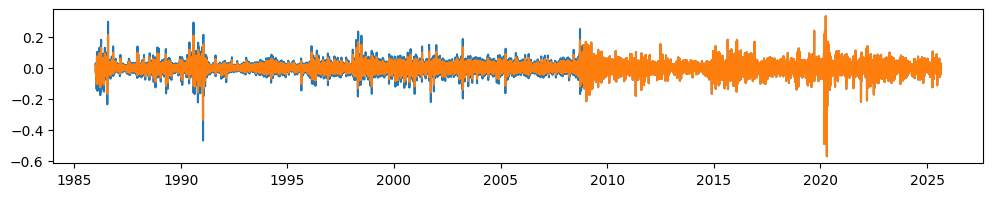

In [26]:
#### ProShares Ultra Bloomberg Crude Oil (UCO)

# ProShares Trust II - ProShares Ultra Bloomberg Crude Oil is an exchange traded fund launched by ProShare Capital Management LLC. 
# The fund is co-managed by ProFund Advisors LLC and ProShare Advisors LLC. It invests in the commodity markets.
# The fund uses derivatives such as futures contracts to invest in WTI sweet, light crude oil. It seeks to track 2x the 
# daily performance of the Bloomberg Commodity Balanced WTI Crude Oil Index. ProShares Trust II - ProShares Ultra Bloomberg Crude Oil
# was formed on November 24, 2008 and is domiciled in the United States.

raw_data = """
Aug 29, 2025	23.57	23.62	23.22	23.27	23.27	773,600
Aug 28, 2025	23.33	23.78	22.94	23.54	23.54	2,023,700
Aug 27, 2025	23.01	23.43	23.01	23.22	23.22	1,484,800
Aug 26, 2025	23.31	23.59	22.89	22.98	22.98	2,439,600
Aug 25, 2025	23.69	24.20	23.69	24.00	24.00	1,859,200
Aug 22, 2025	23.17	23.41	23.12	23.40	23.40	2,274,000
Aug 21, 2025	22.70	23.27	22.63	23.13	23.13	1,430,800
Aug 20, 2025	22.53	22.85	22.31	22.74	22.74	2,403,100
Aug 19, 2025	22.10	22.28	21.94	22.08	22.08	2,238,700
Aug 18, 2025	22.05	22.69	21.80	22.52	22.52	2,527,400
Aug 15, 2025	22.18	22.49	22.02	22.26	22.26	3,487,500
Aug 14, 2025	22.61	22.75	22.34	22.72	22.72	2,032,400
Aug 13, 2025	22.31	22.37	21.69	22.18	22.18	3,091,800
Aug 12, 2025	22.55	22.75	22.35	22.45	22.45	2,208,100
Aug 11, 2025	22.80	22.99	22.52	22.83	22.83	1,511,800
Aug 8, 2025	22.90	23.10	22.04	22.52	22.52	3,702,500
Aug 7, 2025	22.95	23.15	22.62	22.66	22.66	2,215,400
Aug 6, 2025	24.02	24.30	22.44	22.67	22.67	6,263,000
Aug 5, 2025	23.65	23.71	23.27	23.33	23.33	3,205,100
Aug 4, 2025	23.55	24.37	23.49	23.91	23.91	2,514,600
Aug 1, 2025	25.71	25.77	24.27	24.35	24.35	4,493,200
Jul 31, 2025	26.08	26.41	25.56	25.91	25.91	2,183,000
Jul 30, 2025	26.40	26.79	26.16	26.72	26.72	2,767,900
Jul 29, 2025	25.13	26.56	25.06	26.28	26.28	4,212,700
Jul 28, 2025	24.62	24.95	24.43	24.93	24.93	2,891,300
Jul 25, 2025	24.22	24.22	23.53	23.54	23.54	1,913,300
Jul 24, 2025	24.11	24.38	23.74	24.25	24.25	2,616,000
Jul 23, 2025	23.65	23.94	23.49	23.89	23.89	1,893,000
Jul 22, 2025	23.71	23.87	23.46	23.80	23.80	3,052,700
Jul 21, 2025	23.98	24.12	23.71	23.98	23.98	1,628,300
Jul 18, 2025	24.48	24.69	24.03	24.07	24.07	2,410,500
Jul 17, 2025	23.55	24.17	23.49	24.17	24.17	1,809,000
Jul 16, 2025	23.27	23.67	23.09	23.59	23.59	1,866,800
Jul 15, 2025	23.84	24.09	23.58	23.72	23.72	2,053,500
Jul 14, 2025	24.52	24.52	23.78	23.85	23.85	3,089,700
Jul 11, 2025	23.97	24.58	23.94	24.57	24.57	1,768,700
Jul 10, 2025	23.51	23.80	23.34	23.54	23.54	1,846,200
Jul 9, 2025	24.04	24.51	23.91	24.22	24.22	1,707,100
Jul 8, 2025	23.87	24.66	23.85	24.36	24.36	1,930,700
Jul 7, 2025	23.50	24.15	23.38	23.94	23.94	2,809,400
Jul 3, 2025	23.22	23.48	23.04	23.34	23.34	1,364,800
Jul 2, 2025	22.98	23.68	22.57	23.42	23.42	2,392,700
Jul 1, 2025	22.60	22.83	22.40	22.79	22.79	2,156,500
Jun 30, 2025	22.53	22.64	22.22	22.41	22.41	1,646,300
Jun 27, 2025	22.66	22.84	22.13	22.35	22.35	3,610,500
Jun 26, 2025	22.57	23.10	22.39	22.62	22.62	3,445,500
Jun 25, 2025	22.43	22.88	22.20	22.38	22.38	3,388,800
Jun 24, 2025	23.01	23.31	22.26	22.69	22.69	6,434,500
Jun 23, 2025	28.16	28.42	24.73	24.74	24.74	18,953,800
Jun 20, 2025	27.44	28.00	27.32	27.87	27.87	4,660,500
Jun 18, 2025	27.88	28.06	26.34	27.45	27.45	9,722,200
Jun 17, 2025	26.63	27.82	26.42	27.47	27.47	8,442,500
Jun 16, 2025	25.85	26.10	24.33	25.79	25.79	10,360,600
Jun 13, 2025	26.47	26.61	25.46	26.12	26.12	12,605,900
Jun 12, 2025	23.54	24.18	23.39	24.04	24.04	3,282,800
Jun 11, 2025	23.08	24.25	22.95	23.87	23.87	3,634,500
Jun 10, 2025	22.70	23.13	22.26	22.40	22.40	1,727,300
Jun 9, 2025	22.47	22.72	22.29	22.62	22.62	1,060,300
Jun 6, 2025	21.91	22.47	21.91	22.37	22.37	1,425,500
Jun 5, 2025	22.00	22.08	21.69	21.74	21.74	1,095,100
Jun 4, 2025	21.84	22.07	21.07	21.45	21.45	3,594,500
Jun 3, 2025	21.56	22.04	21.45	21.83	21.83	1,544,200
Jun 2, 2025	21.59	21.63	21.02	21.49	21.49	3,537,500
May 30, 2025	20.34	20.35	19.70	20.25	20.25	2,996,900
May 29, 2025	20.81	20.81	20.37	20.47	20.47	2,355,000
May 28, 2025	21.36	21.69	21.00	21.03	21.03	2,680,800
May 27, 2025	20.84	20.89	20.38	20.85	20.85	2,012,000
May 23, 2025	20.55	21.26	20.55	21.19	21.19	1,528,600
May 22, 2025	20.68	21.00	20.55	20.75	20.75	972,800
May 21, 2025	21.85	21.85	21.06	21.08	21.08	2,340,400
May 20, 2025	21.40	21.66	21.11	21.55	21.55	1,249,200
May 19, 2025	21.22	21.69	21.09	21.38	21.38	2,024,500
May 16, 2025	21.23	21.56	21.03	21.30	21.30	1,420,500
May 15, 2025	21.13	21.30	20.82	21.19	21.19	2,017,000
May 14, 2025	22.19	22.30	21.80	21.81	21.81	1,343,300
May 13, 2025	21.75	22.50	21.74	22.28	22.28	2,943,800
May 12, 2025	21.95	22.07	21.23	21.28	21.28	3,090,800
May 9, 2025	20.38	20.73	20.34	20.65	20.65	1,933,100
May 8, 2025	19.70	20.28	19.67	20.20	20.20	2,506,900
May 7, 2025	19.68	19.77	19.06	19.20	19.20	1,964,300
May 6, 2025	19.84	20.19	19.73	19.81	19.81	3,237,100
May 5, 2025	18.87	18.97	18.35	18.66	18.66	4,519,900
May 2, 2025	19.58	19.69	18.81	19.44	19.44	4,786,700
May 1, 2025	18.98	19.75	18.80	19.50	19.50	5,037,400
Apr 30, 2025	20.07	20.17	18.92	18.98	18.98	5,932,600
Apr 29, 2025	20.80	20.90	20.38	20.43	20.43	2,368,400
Apr 28, 2025	21.86	21.93	20.99	21.30	21.30	1,686,600
Apr 25, 2025	21.50	22.03	21.42	21.95	21.95	903,100
Apr 24, 2025	21.63	21.77	21.20	21.61	21.61	1,268,300
Apr 23, 2025	21.65	22.15	20.81	21.28	21.28	3,241,200
Apr 22, 2025	21.69	22.35	21.57	21.91	21.91	1,220,700
Apr 21, 2025	21.40	21.54	20.95	21.51	21.51	1,312,600
Apr 17, 2025	21.53	22.46	21.44	22.13	22.13	1,544,600
Apr 16, 2025	20.81	21.28	20.78	21.20	21.20	1,706,100
Apr 15, 2025	20.74	20.97	20.41	20.64	20.64	1,122,200
Apr 14, 2025	21.08	21.08	20.32	20.84	20.84	1,336,600
Apr 11, 2025	19.77	20.73	19.69	20.56	20.56	2,559,100
Apr 10, 2025	19.79	20.24	19.20	20.17	20.17	3,268,600
Apr 9, 2025	18.39	21.55	17.78	21.26	21.26	7,106,600
Apr 8, 2025	21.05	21.13	18.95	19.24	19.24	4,246,100
Apr 7, 2025	20.61	22.46	20.20	20.96	20.96	2,613,900
Apr 4, 2025	21.02	21.85	20.19	21.64	21.64	5,010,400
Apr 3, 2025	24.00	24.31	23.61	24.01	24.01	2,884,200
Apr 2, 2025	26.80	27.49	26.78	27.44	27.44	854,200
Apr 1, 2025	27.23	27.47	27.00	27.06	27.06	1,204,400
Mar 31, 2025	26.16	27.34	25.99	27.06	27.06	1,921,700
Mar 28, 2025	26.27	26.28	25.64	25.82	25.82	1,142,300
Mar 27, 2025	26.20	26.45	25.91	26.34	26.34	862,000
Mar 26, 2025	26.21	26.54	26.10	26.29	26.29	1,567,700
Mar 25, 2025	26.07	26.17	25.50	25.92	25.92	1,102,800
Mar 24, 2025	25.56	25.97	25.47	25.89	25.89	2,024,800
Mar 21, 2025	25.20	25.45	25.05	25.35	25.35	915,700
Mar 20, 2025	24.63	25.46	24.51	25.44	25.44	1,638,200
Mar 19, 2025	24.59	25.01	24.49	24.72	24.72	747,000
Mar 18, 2025	25.27	25.33	24.46	24.60	24.60	1,490,200
Mar 17, 2025	24.88	25.02	24.58	24.83	24.83	1,784,600
Mar 14, 2025	24.22	24.53	24.05	24.43	24.43	712,500
Mar 13, 2025	24.40	24.59	23.95	24.11	24.11	1,220,500
Mar 12, 2025	24.41	24.83	24.24	24.77	24.77	1,137,400
Mar 11, 2025	24.12	24.31	23.70	23.96	23.96	1,367,300
Mar 10, 2025	24.43	24.51	23.51	23.64	23.64	1,548,000
Mar 7, 2025	24.80	25.15	24.32	24.48	24.48	2,842,700
Mar 6, 2025	23.94	24.25	23.54	23.91	23.91	1,858,200
Mar 5, 2025	24.10	24.14	23.26	24.11	24.11	4,128,500
Mar 4, 2025	24.90	25.32	24.24	25.17	25.17	1,716,200
Mar 3, 2025	26.62	26.75	25.16	25.32	25.32	2,439,000
Feb 28, 2025	26.15	26.62	25.92	26.52	26.52	967,700
Feb 27, 2025	26.44	26.90	26.23	26.58	26.58	1,534,100
Feb 26, 2025	25.88	26.09	25.58	25.79	25.79	1,955,000
Feb 25, 2025	27.08	27.11	25.80	26.13	26.13	2,029,500
Feb 24, 2025	27.29	27.51	27.14	27.36	27.36	1,581,800
Feb 21, 2025	28.04	28.12	27.06	27.07	27.07	2,316,200
Feb 20, 2025	28.82	29.20	28.67	28.76	28.76	1,026,400
Feb 19, 2025	28.85	28.93	28.31	28.46	28.46	674,000
Feb 18, 2025	28.05	28.26	27.82	28.16	28.16	1,610,400
Feb 14, 2025	27.91	28.02	27.39	27.52	27.52	1,627,200
Feb 13, 2025	27.25	27.79	27.22	27.75	27.75	1,322,800
Feb 12, 2025	28.33	28.54	27.73	27.74	27.74	1,613,100
Feb 11, 2025	28.92	29.12	28.63	28.99	28.99	1,006,600
Feb 10, 2025	27.97	28.32	27.81	28.30	28.30	1,105,100
Feb 7, 2025	27.46	27.53	27.12	27.34	27.34	1,578,500
Feb 6, 2025	27.41	27.68	26.93	27.07	27.07	1,148,400
Feb 5, 2025	27.54	27.78	27.13	27.23	27.23	1,365,800
Feb 4, 2025	26.82	28.48	26.80	28.17	28.17	2,084,400
Feb 3, 2025	28.16	28.39	27.46	27.89	27.89	1,837,000
Jan 31, 2025	28.02	28.36	27.49	28.14	28.14	2,595,400
Jan 30, 2025	28.02	28.51	27.92	28.01	28.01	1,539,200
Jan 29, 2025	27.96	28.40	27.61	27.96	27.96	1,531,000
Jan 28, 2025	28.65	28.65	28.02	28.40	28.40	946,400
Jan 27, 2025	28.98	29.17	27.78	28.19	28.19	1,246,000
Jan 24, 2025	29.65	29.74	29.03	29.23	29.23	1,021,600
Jan 23, 2025	30.00	30.28	29.24	29.25	29.25	1,477,000
Jan 22, 2025	29.89	30.21	29.67	29.83	29.83	1,081,000
Jan 21, 2025	29.74	30.15	29.65	30.08	30.08	915,500
Jan 17, 2025	30.46	30.79	30.27	30.42	30.42	654,200
Jan 16, 2025	30.77	30.83	30.16	30.61	30.61	973,100
Jan 15, 2025	30.57	31.64	30.53	31.49	31.49	1,972,900
Jan 14, 2025	30.11	30.34	29.81	30.27	30.27	1,062,500
Jan 13, 2025	30.23	30.61	30.05	30.05	30.05	3,528,600
Jan 10, 2025	30.00	30.93	29.51	30.13	30.13	1,915,200
Jan 8, 2025	29.09	29.16	28.31	28.46	28.46	660,300
Jan 7, 2025	29.10	29.20	28.77	29.02	29.02	1,419,900
Jan 6, 2025	29.12	29.42	28.35	28.51	28.51	999,700
Jan 3, 2025	28.53	28.86	28.38	28.79	28.79	1,066,300
Jan 2, 2025	28.24	28.74	28.21	28.22	28.22	1,680,500
Dec 31, 2024	27.32	27.67	27.19	27.50	27.50	1,251,800
Dec 30, 2024	27.10	27.31	26.80	27.06	27.06	1,117,300
Dec 27, 2024	26.63	26.81	26.38	26.43	26.43	1,383,900
Dec 26, 2024	26.73	26.78	25.93	26.09	26.09	1,320,400
Dec 24, 2024	26.37	26.59	26.19	26.32	26.32	856,600
Dec 23, 2024	25.90	26.02	25.44	26.02	26.02	1,607,300
Dec 20, 2024	25.47	26.14	25.28	25.99	25.99	1,640,600
Dec 19, 2024	26.58	26.70	25.71	25.71	25.71	1,108,100
Dec 18, 2024	26.56	26.99	25.97	25.98	25.98	1,118,200
Dec 17, 2024	26.22	26.37	25.78	26.31	26.31	991,300
Dec 16, 2024	26.91	27.02	26.59	26.64	26.64	926,600
Dec 13, 2024	26.72	27.18	26.67	26.99	26.99	1,293,400
Dec 12, 2024	26.18	26.60	25.73	26.48	26.48	1,588,900
Dec 11, 2024	26.13	26.60	25.88	26.41	26.41	2,353,100
Dec 10, 2024	25.48	25.85	25.35	25.43	25.43	1,290,300
Dec 9, 2024	25.40	25.85	25.32	25.32	25.32	2,199,400
Dec 6, 2024	24.89	25.01	24.51	24.75	24.75	3,278,900
Dec 5, 2024	25.67	25.80	25.20	25.35	25.35	1,762,600
Dec 4, 2024	26.61	26.65	25.37	25.57	25.57	2,317,900
Dec 3, 2024	25.92	26.54	25.69	26.34	26.34	2,931,600
Dec 2, 2024	25.74	25.79	24.98	25.18	25.18	2,182,700
Nov 29, 2024	25.91	26.18	25.46	25.54	25.54	1,054,200
Nov 27, 2024	25.55	25.98	25.15	25.53	25.53	1,620,500
Nov 26, 2024	26.09	26.63	25.18	25.56	25.56	2,322,900
Nov 25, 2024	26.25	26.51	25.57	25.81	25.81	2,510,300
Nov 22, 2024	26.49	27.36	26.35	27.14	27.14	1,692,000
Nov 21, 2024	26.61	26.67	26.17	26.64	26.64	1,794,500
Nov 20, 2024	26.54	26.55	25.78	26.01	26.01	1,251,000
Nov 19, 2024	26.36	26.58	25.72	26.23	26.23	2,064,900
Nov 18, 2024	25.36	26.21	25.35	26.11	26.11	3,461,800
Nov 15, 2024	25.20	25.53	24.43	24.58	24.58	3,198,400
Nov 14, 2024	26.00	26.01	25.19	25.45	25.45	2,053,400
Nov 13, 2024	25.00	25.63	24.51	25.20	25.20	3,567,300
Nov 12, 2024	26.00	26.00	25.18	25.24	25.24	2,299,200
Nov 11, 2024	25.59	25.74	25.23	25.51	25.51	3,356,500
Nov 8, 2024	27.20	27.24	26.37	26.77	26.77	2,089,200
Nov 7, 2024	27.15	28.11	26.89	27.69	27.69	2,925,200
Nov 6, 2024	26.53	27.93	26.53	27.45	27.45	2,180,400
Nov 5, 2024	27.67	27.89	27.13	27.47	27.47	1,748,000
Nov 4, 2024	27.10	27.38	26.72	27.27	27.27	2,468,100
Nov 1, 2024	26.94	27.01	25.88	25.91	25.91	2,032,100
Oct 31, 2024	25.77	26.63	25.51	26.50	26.50	3,616,500
Oct 30, 2024	25.05	25.65	24.87	25.52	25.52	3,917,100
Oct 29, 2024	24.75	24.83	24.12	24.49	24.49	4,050,800
Oct 28, 2024	24.64	25.10	24.55	24.91	24.91	7,821,100
Oct 25, 2024	27.31	27.73	26.98	27.60	27.60	3,382,100
Oct 24, 2024	27.20	27.44	26.30	26.81	26.81	2,261,400
Oct 23, 2024	27.01	27.33	26.66	27.03	27.03	1,772,900
Oct 22, 2024	26.81	27.77	26.71	27.34	27.34	3,291,800
Oct 21, 2024	26.39	26.61	25.96	26.22	26.22	2,616,700
Oct 18, 2024	25.95	26.05	25.19	25.72	25.72	4,448,300
Oct 17, 2024	26.16	26.55	25.62	26.44	26.44	2,196,400
Oct 16, 2024	26.31	26.46	25.80	26.27	26.27	2,659,100
Oct 15, 2024	26.47	26.74	25.93	26.64	26.64	5,080,000
Oct 14, 2024	28.77	29.10	28.41	28.80	28.80	3,071,200
Oct 11, 2024	29.32	29.83	29.09	29.62	29.62	1,926,900
Oct 10, 2024	28.74	29.86	28.46	29.68	29.68	3,100,400
Oct 9, 2024	27.71	28.37	27.29	28.20	28.20	3,337,500
Oct 8, 2024	29.37	29.45	27.98	28.86	28.86	6,183,100
Oct 7, 2024	29.55	30.84	29.48	30.76	30.76	3,876,800
Oct 4, 2024	28.99	29.44	28.60	28.80	28.80	4,290,200
Oct 3, 2024	27.69	28.94	27.48	28.74	28.74	6,022,700
Oct 2, 2024	27.76	27.95	26.36	27.03	27.03	4,828,000
Oct 1, 2024	24.98	27.53	24.91	26.72	26.72	8,359,200
Sep 30, 2024	25.33	25.88	25.04	25.42	25.42	2,376,100
Sep 27, 2024	24.89	25.48	24.55	25.45	25.45	2,537,100
Sep 26, 2024	24.91	25.44	24.50	24.71	24.71	4,934,300
Sep 25, 2024	26.67	26.97	25.85	26.19	26.19	2,961,700
Sep 24, 2024	27.40	27.45	26.81	27.11	27.11	1,791,700
Sep 23, 2024	26.74	27.14	25.65	26.42	26.42	2,339,400
Sep 20, 2024	26.44	26.81	26.17	26.71	26.71	1,332,800
Sep 19, 2024	26.39	26.92	26.13	26.56	26.56	2,091,100
Sep 18, 2024	25.67	26.23	25.35	25.46	25.46	1,949,700
Sep 17, 2024	25.58	26.43	25.56	26.11	26.11	2,319,400
Sep 16, 2024	25.46	25.78	25.20	25.62	25.62	1,491,100
Sep 13, 2024	25.25	25.64	24.60	25.00	25.00	1,903,800
Sep 12, 2024	24.63	25.45	24.26	25.14	25.14	3,048,500
Sep 11, 2024	24.02	24.35	23.08	23.97	23.97	3,401,100
Sep 10, 2024	24.89	24.91	22.88	23.45	23.45	9,534,900
Sep 9, 2024	24.52	25.08	24.29	24.77	24.77	2,523,000
Sep 6, 2024	25.85	26.06	24.32	24.86	24.86	7,051,900
Sep 5, 2024	25.84	26.37	25.31	25.57	25.57	3,018,400
Sep 4, 2024	25.82	26.39	25.19	25.23	25.23	3,495,600
Sep 3, 2024	26.79	26.79	25.94	26.15	26.15	6,585,600
Aug 30, 2024	28.78	28.78	28.10	28.31	28.31	3,499,600
Aug 29, 2024	29.67	30.18	29.34	29.81	29.81	1,655,400
Aug 28, 2024	29.04	29.58	28.65	28.92	28.92	2,098,100
Aug 27, 2024	30.37	30.53	29.52	29.72	29.72	2,091,900
Aug 26, 2024	30.88	31.04	30.54	30.60	30.60	2,608,300
Aug 23, 2024	28.94	29.50	28.88	29.36	29.36	2,058,300
Aug 22, 2024	27.66	28.49	27.55	28.03	28.03	2,799,900
Aug 21, 2024	28.61	28.96	27.18	27.51	27.51	4,700,900
Aug 20, 2024	28.99	29.15	28.25	28.32	28.32	2,616,300
Aug 19, 2024	30.06	30.19	28.61	28.84	28.84	3,695,800
Aug 16, 2024	30.02	30.32	29.69	30.03	30.03	1,706,500
Aug 15, 2024	30.77	31.28	30.72	30.91	30.91	1,112,300
Aug 14, 2024	30.98	31.08	30.10	30.26	30.26	1,443,300
Aug 13, 2024	31.38	31.44	30.68	30.88	30.88	1,622,100
Aug 12, 2024	30.76	31.99	30.53	31.55	31.55	2,242,500
Aug 9, 2024	29.73	30.16	29.41	30.11	30.11	1,867,900
Aug 8, 2024	28.91	29.76	28.83	29.55	29.55	1,580,900
Aug 7, 2024	28.59	29.36	28.44	29.06	29.06	2,824,700
Aug 6, 2024	27.37	28.34	27.32	27.67	27.67	3,137,600
Aug 5, 2024	27.31	28.42	27.22	28.41	28.41	3,170,600
Aug 2, 2024	28.84	28.84	27.66	28.29	28.29	4,923,500
Aug 1, 2024	31.64	31.70	30.11	30.61	30.61	2,742,500
Jul 31, 2024	30.64	31.61	30.38	31.52	31.52	2,381,800
Jul 30, 2024	29.31	29.51	29.03	29.39	29.39	2,224,700
Jul 29, 2024	30.74	30.89	29.40	29.71	29.71	2,154,600
Jul 26, 2024	30.72	30.78	29.77	30.31	30.31	1,679,900
Jul 25, 2024	30.32	31.40	29.88	31.20	31.20	1,618,500
Jul 24, 2024	30.78	31.24	30.42	30.82	30.82	1,355,300
Jul 23, 2024	30.99	31.11	30.13	30.62	30.62	1,645,800
Jul 22, 2024	31.08	31.57	30.82	31.42	31.42	1,352,400
Jul 19, 2024	32.72	33.20	31.48	31.65	31.65	1,815,500
Jul 18, 2024	33.42	33.70	32.93	33.04	33.04	1,001,400
Jul 17, 2024	33.20	33.54	33.13	33.39	33.39	1,162,100
Jul 16, 2024	32.38	32.93	32.36	32.65	32.65	1,082,500
Jul 15, 2024	33.58	33.63	33.13	33.45	33.45	877,200
Jul 12, 2024	34.07	34.11	33.51	33.60	33.60	959,900
Jul 11, 2024	33.46	33.99	33.29	33.97	33.97	1,129,300
Jul 10, 2024	33.30	34.07	33.09	33.85	33.85	1,406,600
Jul 9, 2024	34.00	34.40	33.39	33.57	33.57	882,800
Jul 8, 2024	34.31	34.60	34.17	34.27	34.27	804,600
Jul 5, 2024	35.30	35.71	34.72	34.84	34.84	972,300
Jul 3, 2024	34.68	35.13	34.38	34.90	34.90	842,600
Jul 2, 2024	35.05	35.09	34.49	34.71	34.71	896,000
Jul 1, 2024	34.03	34.90	33.73	34.77	34.77	1,155,200
Jun 28, 2024	33.94	33.96	33.25	33.50	33.50	802,100
Jun 27, 2024	33.80	33.95	33.34	33.77	33.77	863,700
Jun 26, 2024	33.31	33.77	32.83	33.15	33.15	1,092,800
Jun 25, 2024	33.57	33.83	33.07	33.18	33.18	672,900
Jun 24, 2024	32.92	33.73	32.92	33.70	33.70	967,100
Jun 21, 2024	33.36	33.66	32.68	32.92	32.92	958,600
Jun 20, 2024	33.49	33.64	33.18	33.32	33.32	863,200
Jun 18, 2024	32.31	33.12	32.26	33.02	33.02	1,183,400
Jun 17, 2024	31.68	32.37	31.63	32.27	32.27	1,130,300
Jun 14, 2024	31.99	32.10	31.29	31.29	31.29	1,788,400
Jun 13, 2024	31.76	31.92	31.32	31.38	31.38	1,270,200
Jun 12, 2024	32.01	32.11	31.17	31.37	31.37	2,249,100
Jun 11, 2024	30.93	31.41	30.62	31.07	31.07	1,062,500
Jun 10, 2024	29.88	30.96	29.70	30.93	30.93	2,170,200
Jun 7, 2024	29.55	29.82	29.24	29.33	29.33	1,228,100
Jun 6, 2024	28.64	29.52	28.52	29.39	29.39	1,748,700
Jun 5, 2024	28.22	28.46	27.80	28.42	28.42	2,385,700
Jun 4, 2024	28.12	28.35	27.73	28.07	28.07	2,452,100
Jun 3, 2024	30.45	30.45	28.77	28.84	28.84	4,333,600
May 31, 2024	31.43	31.58	30.48	30.91	30.91	1,873,600
May 30, 2024	31.65	32.18	31.10	31.26	31.26	1,756,100
May 29, 2024	32.70	33.05	31.97	31.98	31.98	1,245,700
May 28, 2024	32.05	32.75	31.96	32.70	32.70	1,595,200
May 24, 2024	30.59	31.08	30.50	30.93	30.93	1,119,200
May 23, 2024	31.50	31.65	30.09	30.35	30.35	2,455,900
May 22, 2024	31.15	31.50	30.68	30.75	30.75	2,204,700
May 21, 2024	31.75	32.17	31.04	31.82	31.82	2,096,500
May 20, 2024	32.00	32.71	31.81	32.24	32.24	1,229,700
May 17, 2024	31.80	32.33	31.70	32.25	32.25	1,020,300
May 16, 2024	31.79	31.89	31.39	31.71	31.71	1,453,100
May 15, 2024	30.53	31.32	30.05	31.32	31.32	2,906,800
May 14, 2024	30.91	31.30	30.65	30.94	30.94	1,520,800
May 13, 2024	31.32	31.75	31.19	31.55	31.55	1,270,300
May 10, 2024	31.92	31.97	30.95	31.04	31.04	1,500,800
May 9, 2024	31.44	31.84	31.33	31.81	31.81	1,065,900
May 8, 2024	30.79	31.61	30.62	31.52	31.52	1,913,000
May 7, 2024	31.21	31.79	30.80	31.33	31.33	2,359,200
May 6, 2024	31.29	31.62	30.90	31.42	31.42	3,171,000
May 3, 2024	31.34	31.48	30.92	31.02	31.02	1,613,100
May 2, 2024	31.27	31.61	30.84	31.26	31.26	1,574,900
May 1, 2024	32.29	32.87	30.96	31.11	31.11	2,366,600
Apr 30, 2024	33.43	33.54	32.47	32.92	32.92	1,726,700
Apr 29, 2024	34.23	34.42	33.59	33.67	33.67	1,193,600
Apr 26, 2024	34.63	34.67	33.97	34.29	34.29	992,400
Apr 25, 2024	33.51	34.21	33.02	34.19	34.19	1,328,600
Apr 24, 2024	33.65	33.99	33.30	33.73	33.73	1,483,600
Apr 23, 2024	32.59	33.83	32.53	33.77	33.77	1,228,200
Apr 22, 2024	32.32	33.07	32.11	33.06	33.06	842,700
Apr 19, 2024	33.13	33.64	33.05	33.07	33.07	1,396,900
Apr 18, 2024	33.60	33.82	32.99	33.25	33.25	1,176,200
Apr 17, 2024	34.59	35.05	33.35	33.53	33.53	2,789,400
Apr 16, 2024	35.26	35.53	34.94	35.28	35.28	1,653,600
Apr 15, 2024	34.86	35.41	34.23	35.38	35.38	2,817,600
Apr 12, 2024	36.21	36.51	35.04	35.26	35.26	2,692,400
Apr 11, 2024	35.16	35.21	34.60	35.16	35.16	969,100
Apr 10, 2024	34.90	35.36	34.24	35.30	35.30	1,582,000
Apr 9, 2024	35.30	35.42	34.40	34.64	34.64	739,500
Apr 8, 2024	35.47	35.70	34.51	35.24	35.24	1,652,300
Apr 5, 2024	35.66	36.03	35.29	35.34	35.34	1,081,200
Apr 4, 2024	34.63	35.75	34.21	35.31	35.31	1,590,900
Apr 3, 2024	34.56	34.87	34.50	34.61	34.61	1,122,100
Apr 2, 2024	33.99	34.19	33.52	34.18	34.18	1,101,600
Apr 1, 2024	33.16	33.66	32.93	33.38	33.38	1,269,100
Mar 28, 2024	32.85	33.20	32.69	33.00	33.00	911,800
Mar 27, 2024	32.02	32.42	31.98	32.41	32.41	859,400
Mar 26, 2024	32.70	32.70	32.19	32.20	32.20	984,900
Mar 25, 2024	32.06	32.82	32.06	32.56	32.56	1,037,200
Mar 22, 2024	32.19	32.21	31.59	31.78	31.78	689,300
Mar 21, 2024	32.07	32.19	31.65	32.08	32.08	1,032,200
Mar 20, 2024	32.22	32.40	31.81	32.27	32.27	1,673,200
Mar 19, 2024	32.83	33.09	32.77	32.95	32.95	988,300
Mar 18, 2024	32.22	32.79	31.98	32.62	32.62	1,222,300
Mar 15, 2024	31.46	31.87	31.38	31.74	31.74	956,900
Mar 14, 2024	31.24	31.75	31.16	31.50	31.50	1,490,100
Mar 13, 2024	30.61	30.92	30.38	30.87	30.87	1,670,200
Mar 12, 2024	29.74	30.18	29.52	29.72	29.72	1,639,100
Mar 11, 2024	29.36	29.97	28.96	29.88	29.88	1,212,800
Mar 8, 2024	29.85	29.88	29.15	29.45	29.45	1,766,200
Mar 7, 2024	29.47	30.29	29.43	29.95	29.95	1,778,400
Mar 6, 2024	30.00	30.56	29.82	29.86	29.86	1,787,600
Mar 5, 2024	29.56	30.10	29.24	29.36	29.36	1,654,800
Mar 4, 2024	30.67	30.72	29.71	29.93	29.93	1,780,800
Mar 1, 2024	30.17	30.92	30.05	30.28	30.28	2,278,500
Feb 29, 2024	29.57	29.95	29.20	29.33	29.33	1,360,100
Feb 28, 2024	30.14	30.32	29.32	29.54	29.54	1,767,200
Feb 27, 2024	29.45	30.02	29.42	29.79	29.79	1,373,500
Feb 26, 2024	28.47	29.57	28.40	29.24	29.24	1,461,300
Feb 23, 2024	28.75	29.08	28.43	28.64	28.64	2,335,100
Feb 22, 2024	29.21	29.95	29.15	29.72	29.72	1,144,400
Feb 21, 2024	28.98	29.51	28.94	29.46	29.46	1,739,500
Feb 20, 2024	29.86	29.86	28.87	29.14	29.14	2,661,600
Feb 16, 2024	29.46	29.98	29.24	29.84	29.84	1,751,100
Feb 15, 2024	28.90	29.88	28.89	29.49	29.49	1,761,400
Feb 14, 2024	29.86	30.19	28.61	28.71	28.71	2,516,000
Feb 13, 2024	29.56	29.88	29.12	29.48	29.48	1,846,800
Feb 12, 2024	28.94	29.37	28.92	29.27	29.27	1,224,600
Feb 9, 2024	29.13	29.38	28.64	29.06	29.06	2,219,000
Feb 8, 2024	28.14	28.89	28.10	28.78	28.78	3,677,300
Feb 7, 2024	27.16	27.53	27.00	27.52	27.52	3,020,400
Feb 6, 2024	26.97	27.33	26.64	27.04	27.04	2,818,300
Feb 5, 2024	26.39	26.91	25.74	26.69	26.69	3,494,400
Feb 2, 2024	26.46	26.62	25.89	26.15	26.15	4,379,100
Feb 1, 2024	28.93	29.21	27.11	27.22	27.22	5,883,600
Jan 31, 2024	29.59	29.61	28.31	28.47	28.47	3,289,900
Jan 30, 2024	29.36	30.12	29.14	29.93	29.93	1,955,500
Jan 29, 2024	29.68	29.70	28.98	29.42	29.42	2,691,200
Jan 26, 2024	29.32	30.21	28.66	30.13	30.13	2,976,000
Jan 25, 2024	28.98	29.65	28.66	29.47	29.47	2,340,600
Jan 24, 2024	27.97	28.58	27.70	28.34	28.34	2,253,400
Jan 23, 2024	27.45	28.15	27.33	27.70	27.70	1,779,000
Jan 22, 2024	27.17	28.23	27.04	27.76	27.76	3,233,200
Jan 19, 2024	27.47	27.64	26.63	27.01	27.01	2,068,600
Jan 18, 2024	26.78	27.41	26.40	27.18	27.18	2,393,200
Jan 17, 2024	25.61	26.61	25.47	26.56	26.56	3,104,400
Jan 16, 2024	26.87	26.98	26.17	26.20	26.20	2,594,200
Jan 12, 2024	27.78	28.10	26.54	26.88	26.88	4,364,000
Jan 11, 2024	26.97	27.33	26.16	26.54	26.54	3,338,300
Jan 10, 2024	26.84	27.11	25.63	25.78	25.78	3,098,400
Jan 9, 2024	26.23	26.62	25.81	26.25	26.25	3,211,700
Jan 8, 2024	25.39	25.70	24.99	25.68	25.68	6,217,700
Jan 5, 2024	27.38	27.70	27.05	27.47	27.47	2,220,100
Jan 4, 2024	27.07	27.21	25.80	26.47	26.47	3,696,700
Jan 3, 2024	26.29	27.27	26.15	27.15	27.15	4,636,100
Jan 2, 2024	26.75	26.75	25.35	25.53	25.53	5,450,700
Dec 29, 2023	26.85	26.89	26.07	26.10	26.10	4,542,300
Dec 28, 2023	27.51	27.88	26.39	26.52	26.52	5,268,000
Dec 27, 2023	28.69	28.86	27.90	27.91	27.91	2,391,100
Dec 26, 2023	28.98	29.36	28.62	28.69	28.69	3,191,600
Dec 22, 2023	28.35	28.55	27.50	27.61	27.61	2,466,600
Dec 21, 2023	27.52	28.11	27.45	28.00	28.00	2,367,800
Dec 20, 2023	29.01	29.12	28.00	28.01	28.01	3,170,600
Dec 19, 2023	27.83	28.66	27.77	28.56	28.56	2,692,600
Dec 18, 2023	28.14	28.75	27.33	27.65	27.65	3,507,500
Dec 15, 2023	27.04	27.14	26.06	26.97	26.97	2,085,900
Dec 14, 2023	26.78	27.36	26.76	26.99	26.99	3,798,700
Dec 13, 2023	24.94	25.68	24.90	25.66	25.66	3,498,000
Dec 12, 2023	25.33	25.37	24.59	24.83	24.83	5,506,000
Dec 11, 2023	26.31	26.74	25.99	26.62	26.62	2,210,300
Dec 8, 2023	26.03	26.51	25.84	26.27	26.27	2,902,100
Dec 7, 2023	25.74	25.81	24.88	25.34	25.34	3,294,500
Dec 6, 2023	25.92	26.14	25.08	25.19	25.19	6,606,400
Dec 5, 2023	28.09	28.40	26.99	27.01	27.01	3,472,000
Dec 4, 2023	27.80	28.71	27.28	27.89	27.89	3,982,000
Dec 1, 2023	29.11	29.69	27.91	28.08	28.08	4,936,400
Nov 30, 2023	31.19	31.63	28.51	28.58	28.58	7,871,500
Nov 29, 2023	30.26	30.72	29.18	30.48	30.48	3,061,600
Nov 28, 2023	29.19	30.03	28.94	29.56	29.56	2,358,900
Nov 27, 2023	28.99	29.56	28.46	28.78	28.78	2,055,500
Nov 24, 2023	29.45	30.14	29.24	29.30	29.30	1,249,600
Nov 22, 2023	28.10	30.05	27.71	29.80	29.80	4,854,000
Nov 21, 2023	30.23	30.60	29.99	30.57	30.57	1,294,000
Nov 20, 2023	30.30	30.86	30.13	30.36	30.36	2,143,100
Nov 17, 2023	28.01	29.33	28.01	29.20	29.20	2,975,400
Nov 16, 2023	28.52	28.57	26.91	27.30	27.30	4,733,600
Nov 15, 2023	29.91	30.40	29.60	29.73	29.73	2,372,400
Nov 14, 2023	30.81	31.42	30.19	30.44	30.44	1,981,900
Nov 13, 2023	29.77	30.66	29.72	30.65	30.65	1,475,200
Nov 10, 2023	29.40	30.09	29.27	29.77	29.77	2,088,000
Nov 9, 2023	28.82	29.58	28.59	28.68	28.68	2,481,200
Nov 8, 2023	29.35	29.63	28.21	28.53	28.53	4,572,600
Nov 7, 2023	30.68	30.74	29.57	29.74	29.74	5,120,300
Nov 6, 2023	32.79	32.94	32.11	32.18	32.18	2,173,800
Nov 3, 2023	32.19	32.97	31.40	31.84	31.84	3,416,800
Nov 2, 2023	31.99	33.08	31.87	32.89	32.89	2,011,400
Nov 1, 2023	33.00	33.18	31.35	31.74	31.74	2,636,400
Oct 31, 2023	32.73	33.28	31.55	31.98	31.98	3,618,200
Oct 30, 2023	33.41	33.65	31.94	32.48	32.48	4,181,800
Oct 27, 2023	33.80	34.62	32.98	34.15	34.15	2,614,500
Oct 26, 2023	33.15	33.69	32.90	33.25	33.25	2,305,500
Oct 25, 2023	33.30	34.58	32.24	34.29	34.29	3,360,100
Oct 24, 2023	33.82	33.95	32.56	33.12	33.12	2,688,400
Oct 23, 2023	35.20	35.37	33.90	34.27	34.27	3,179,100
Oct 20, 2023	36.14	36.37	35.03	35.40	35.40	2,845,300
Oct 19, 2023	34.77	36.22	34.46	36.20	36.20	3,116,800
Oct 18, 2023	35.01	35.49	34.79	35.12	35.12	2,888,100
Oct 17, 2023	33.72	34.42	33.37	34.33	34.33	2,104,800
Oct 16, 2023	34.13	34.29	33.59	34.07	34.07	2,271,500
Oct 13, 2023	33.42	34.57	33.14	34.39	34.39	2,834,100
Oct 12, 2023	32.57	32.60	31.36	31.88	31.88	2,345,400
Oct 11, 2023	32.08	32.33	31.16	32.12	32.12	2,454,100
Oct 10, 2023	32.52	32.58	31.89	32.36	32.36	1,809,800
Oct 9, 2023	32.04	32.52	31.69	32.38	32.38	4,817,500
Oct 6, 2023	30.60	30.60	29.82	30.21	30.21	3,373,200
Oct 5, 2023	30.35	31.04	29.88	30.32	30.32	3,922,500
Oct 4, 2023	33.31	33.31	31.01	31.24	31.24	3,703,900
Oct 3, 2023	34.78	35.10	34.35	34.87	34.87	2,061,500
Oct 2, 2023	35.73	35.82	34.44	34.59	34.59	1,576,700
Sep 29, 2023	36.20	36.20	35.06	35.28	35.28	1,485,500
Sep 28, 2023	36.35	36.63	35.61	35.92	35.92	1,487,900
Sep 27, 2023	36.52	37.11	36.44	36.64	36.64	2,381,500
Sep 26, 2023	35.07	35.85	34.95	35.68	35.68	1,251,900
Sep 25, 2023	35.45	35.46	34.84	35.35	35.35	1,101,200
Sep 22, 2023	36.36	36.43	35.17	35.43	35.43	1,888,800
Sep 21, 2023	36.30	36.52	35.74	35.76	35.76	1,320,700
Sep 20, 2023	35.97	36.58	35.54	35.56	35.56	2,310,600
Sep 19, 2023	36.97	37.01	36.27	36.54	36.54	2,122,300
Sep 18, 2023	36.82	36.93	36.09	36.44	36.44	1,940,700
Sep 15, 2023	35.94	36.56	35.79	36.53	36.53	1,540,700
Sep 14, 2023	36.29	36.60	36.15	36.54	36.54	1,525,000
Sep 13, 2023	35.69	35.79	35.17	35.57	35.57	1,357,400
Sep 12, 2023	35.38	35.82	35.35	35.60	35.60	1,576,100
Sep 11, 2023	35.14	35.27	34.53	34.66	34.66	1,641,800
Sep 8, 2023	34.51	34.88	34.34	34.53	34.53	1,742,800
Sep 7, 2023	34.44	34.72	33.93	34.34	34.34	1,221,500
Sep 6, 2023	34.10	34.93	33.93	34.69	34.69	2,108,900
Sep 5, 2023	34.46	35.05	33.89	34.16	34.16	2,725,200
Sep 1, 2023	32.70	33.47	32.69	33.46	33.46	2,571,500
Aug 31, 2023	31.50	32.04	31.07	31.96	31.96	2,448,300
Aug 30, 2023	30.90	31.15	30.37	30.83	30.83	1,912,000
Aug 29, 2023	30.08	30.61	29.36	30.58	30.58	2,012,000
Aug 28, 2023	29.87	30.44	29.62	29.88	29.88	1,190,800
Aug 25, 2023	30.03	30.09	28.61	29.91	29.91	2,516,000
Aug 24, 2023	28.69	29.34	28.35	29.10	29.10	1,550,000
Aug 23, 2023	28.64	29.60	28.32	29.07	29.07	1,759,600
Aug 22, 2023	30.23	30.32	29.67	29.86	29.86	1,083,900
Aug 21, 2023	30.77	30.81	29.95	30.05	30.05	1,379,100
Aug 18, 2023	29.70	30.43	29.54	30.25	30.25	1,475,500
Aug 17, 2023	30.04	30.25	29.53	29.56	29.56	1,536,600
Aug 16, 2023	30.34	30.54	29.07	29.14	29.14	2,695,000
Aug 15, 2023	30.59	30.64	29.75	30.13	30.13	2,255,000
Aug 14, 2023	30.96	31.40	30.67	31.05	31.05	1,408,400
Aug 11, 2023	31.40	31.91	31.23	31.44	31.44	1,969,800
Aug 10, 2023	31.80	32.16	31.24	31.42	31.42	1,955,200
Aug 9, 2023	31.88	32.38	31.48	32.15	32.15	2,649,900
Aug 8, 2023	30.10	31.51	29.72	31.29	31.29	2,419,200
Aug 7, 2023	31.08	31.22	30.53	31.22	31.22	1,661,400
Aug 4, 2023	30.68	31.52	30.45	31.12	31.12	2,058,700
Aug 3, 2023	29.54	30.71	29.53	30.55	30.55	1,953,700
Aug 2, 2023	30.29	30.34	28.83	29.32	29.32	3,643,300
Aug 1, 2023	30.29	30.68	29.89	30.53	30.53	1,563,300
Jul 31, 2023	30.33	30.78	30.21	30.71	30.71	1,902,100
Jul 28, 2023	29.27	29.97	28.87	29.84	29.84	2,534,800
Jul 27, 2023	29.10	29.73	28.77	29.30	29.30	2,435,200
Jul 26, 2023	28.66	29.21	28.54	28.74	28.74	1,889,600
Jul 25, 2023	28.54	29.29	28.43	29.06	29.06	2,126,300
Jul 24, 2023	27.89	28.93	27.68	28.72	28.72	3,025,100
Jul 21, 2023	27.08	27.69	26.85	27.44	27.44	2,103,300
Jul 20, 2023	26.98	27.12	26.10	26.77	26.77	2,160,100
Jul 19, 2023	27.01	27.41	26.35	26.54	26.54	2,836,700
Jul 18, 2023	25.84	26.80	25.73	26.69	26.69	2,655,300
Jul 17, 2023	25.87	26.27	25.62	25.67	25.67	1,750,000
Jul 14, 2023	27.16	27.16	26.23	26.33	26.33	2,084,600
Jul 13, 2023	26.58	27.54	26.41	27.54	27.54	2,721,800
Jul 12, 2023	26.46	26.68	26.16	26.62	26.62	2,406,000
Jul 11, 2023	25.30	26.03	25.19	26.00	26.00	2,221,200
Jul 10, 2023	24.94	25.44	24.65	24.94	24.94	2,270,700
Jul 7, 2023	23.99	25.22	23.95	25.06	25.06	3,868,800
Jul 6, 2023	24.09	24.22	23.22	24.15	24.15	3,035,500
Jul 5, 2023	24.36	24.50	23.85	24.32	24.32	5,499,100
Jul 3, 2023	23.82	24.00	23.34	23.50	23.50	2,172,200
Jun 30, 2023	23.52	23.95	23.37	23.65	23.65	2,607,900
Jun 29, 2023	23.13	23.76	22.80	23.28	23.28	2,657,500
Jun 28, 2023	22.36	23.30	21.92	22.98	22.98	4,292,100
Jun 27, 2023	22.92	23.11	22.08	22.20	22.20	4,160,300
Jun 26, 2023	22.71	23.40	22.67	23.11	23.11	2,622,900
Jun 23, 2023	21.99	22.94	21.87	22.88	22.88	3,726,400
Jun 22, 2023	23.40	23.77	22.69	22.92	22.92	6,084,700
Jun 21, 2023	23.82	24.75	23.77	24.72	24.72	2,241,300
Jun 20, 2023	23.81	23.95	22.98	23.92	23.92	2,655,200
Jun 16, 2023	23.67	24.38	23.51	24.23	24.23	2,959,200
Jun 15, 2023	22.77	23.82	22.73	23.58	23.58	3,481,700
Jun 14, 2023	23.30	23.43	22.09	22.52	22.52	3,815,300
Jun 13, 2023	22.64	23.05	22.59	22.70	22.70	5,607,800
Jun 12, 2023	21.92	22.06	21.20	21.40	21.40	9,409,500
Jun 9, 2023	23.75	24.15	23.15	23.28	23.28	3,021,500
Jun 8, 2023	24.63	24.67	22.44	23.62	23.62	6,375,600
Jun 7, 2023	24.30	24.84	24.11	24.51	24.51	2,726,000
Jun 6, 2023	23.35	24.28	23.28	23.86	23.86	2,185,700
Jun 5, 2023	25.00	25.01	23.99	24.03	24.03	2,472,300
Jun 2, 2023	24.11	24.29	23.64	24.12	24.12	4,430,700
Jun 1, 2023	21.74	23.54	21.71	23.00	23.00	4,351,100
May 31, 2023	22.33	22.74	21.66	21.67	21.67	4,780,500
May 30, 2023	23.28	23.36	22.46	22.84	22.84	5,343,500
May 26, 2023	24.70	24.81	24.38	24.68	24.68	2,028,700
May 25, 2023	24.50	24.61	23.49	24.16	24.16	3,793,600
May 24, 2023	25.46	25.71	24.80	25.31	25.31	3,764,400
May 23, 2023	24.55	25.12	24.47	24.75	24.75	2,952,700
May 22, 2023	23.84	24.34	23.67	24.04	24.04	1,439,700
May 19, 2023	24.62	24.69	23.63	24.05	24.05	2,514,100
May 18, 2023	24.47	24.50	23.90	24.23	24.23	2,560,400
May 17, 2023	24.00	24.90	23.56	24.65	24.65	3,680,300
May 16, 2023	23.52	23.84	23.06	23.14	23.14	2,735,200
May 15, 2023	23.20	23.76	23.00	23.44	23.44	2,461,300
May 12, 2023	23.67	23.81	22.70	22.75	22.75	3,483,700
May 11, 2023	23.66	23.91	23.23	23.67	23.67	3,521,300
May 10, 2023	24.79	24.79	23.95	24.56	24.56	3,314,000
May 9, 2023	24.11	25.04	23.55	24.87	24.87	3,927,800
May 8, 2023	24.50	24.74	24.16	24.36	24.36	4,093,900
May 5, 2023	23.22	23.67	23.19	23.50	23.50	4,564,300
May 4, 2023	21.89	22.55	21.41	21.93	21.93	7,738,600
May 3, 2023	22.41	22.46	21.69	21.79	21.79	7,765,100
May 2, 2023	25.38	25.38	23.54	23.64	23.64	6,683,900
May 1, 2023	26.04	26.47	25.50	26.19	26.19	2,030,100
Apr 28, 2023	25.59	26.96	25.42	26.91	26.91	2,764,200
Apr 27, 2023	25.70	25.98	25.22	25.65	25.65	2,243,700
Apr 26, 2023	26.70	27.16	25.27	25.38	25.38	3,688,100
Apr 25, 2023	27.83	27.85	26.80	27.01	27.01	2,927,900
Apr 24, 2023	27.64	28.67	27.51	28.42	28.42	1,878,300
Apr 21, 2023	27.75	27.83	27.26	27.71	27.71	2,288,400
Apr 20, 2023	27.27	27.58	26.96	27.03	27.03	2,862,300
Apr 19, 2023	28.64	28.84	27.98	28.31	28.31	2,388,600
Apr 18, 2023	29.62	29.94	28.99	29.47	29.47	1,364,000
Apr 17, 2023	30.11	30.25	29.23	29.55	29.55	1,558,300
Apr 14, 2023	30.42	30.69	29.85	30.42	30.42	1,493,900
Apr 13, 2023	30.61	30.82	30.11	30.26	30.26	956,800
Apr 12, 2023	30.00	30.75	29.97	30.64	30.64	1,149,800
Apr 11, 2023	28.88	29.65	28.80	29.51	29.51	2,286,400
Apr 10, 2023	28.90	29.32	28.50	28.61	28.61	1,177,700
Apr 6, 2023	29.03	29.10	28.61	28.90	28.90	1,697,300
Apr 5, 2023	29.12	29.19	28.47	28.96	28.96	2,506,000
Apr 4, 2023	29.69	29.70	28.49	28.97	28.97	3,521,900
Apr 3, 2023	28.87	29.36	28.59	29.02	29.02	5,940,300
Mar 31, 2023	26.11	26.53	25.67	26.47	26.47	3,386,900
Mar 30, 2023	25.40	25.87	24.95	25.69	25.69	2,177,000
Mar 29, 2023	25.61	25.81	24.84	24.97	24.97	3,366,300
Mar 28, 2023	24.73	25.60	24.69	25.25	25.25	2,514,200
Mar 27, 2023	23.67	25.07	23.43	24.99	24.99	4,265,300
Mar 24, 2023	22.33	22.94	21.99	22.78	22.78	3,464,000
Mar 23, 2023	23.81	24.18	22.72	22.78	22.78	3,247,800
Mar 22, 2023	23.09	23.92	22.74	23.18	23.18	4,234,200
Mar 21, 2023	22.54	23.00	22.22	22.97	22.97	3,578,000
Mar 20, 2023	21.40	22.13	20.96	22.03	22.03	4,707,200
Mar 17, 2023	22.22	22.26	20.80	21.35	21.35	6,818,900
Mar 16, 2023	21.28	22.92	20.84	22.19	22.19	7,109,600
Mar 15, 2023	22.40	22.93	20.74	22.21	22.21	13,134,100
Mar 14, 2023	25.05	25.97	23.84	24.29	24.29	7,847,300
Mar 13, 2023	25.37	27.08	25.03	25.97	25.97	4,346,900
Mar 10, 2023	26.83	27.67	26.71	27.33	27.33	1,828,000
Mar 9, 2023	27.97	28.34	26.62	26.68	26.68	3,143,100
Mar 8, 2023	27.42	27.94	27.11	27.38	27.38	2,835,700
Mar 7, 2023	29.75	29.81	27.74	27.97	27.97	3,093,600
Mar 6, 2023	29.15	30.05	28.94	30.04	30.04	2,501,700
Mar 3, 2023	27.51	29.60	27.44	29.51	29.51	2,671,300
Mar 2, 2023	28.42	28.70	27.99	28.30	28.30	2,139,900
Mar 1, 2023	27.44	28.19	27.10	28.15	28.15	2,456,700
Feb 28, 2023	27.90	28.01	27.38	27.45	27.45	1,769,500
Feb 27, 2023	27.04	27.11	26.30	26.71	26.71	2,863,800
Feb 24, 2023	26.21	27.44	25.84	27.42	27.42	2,811,100
Feb 23, 2023	26.75	27.07	26.33	26.83	26.83	2,531,500
Feb 22, 2023	26.94	27.13	25.72	25.77	25.77	3,010,900
Feb 21, 2023	27.79	28.04	27.02	27.16	27.16	1,978,300
Feb 17, 2023	26.91	27.61	26.60	27.39	27.39	3,669,500
Feb 16, 2023	28.90	29.39	28.58	28.61	28.61	1,074,500
Feb 15, 2023	28.91	29.39	28.06	29.08	29.08	1,306,300
Feb 14, 2023	28.49	29.59	28.24	29.40	29.40	1,292,600
Feb 13, 2023	29.37	30.23	29.11	29.45	29.45	1,858,400
Feb 10, 2023	29.03	29.78	29.01	29.77	29.77	1,923,500
Feb 9, 2023	28.22	28.66	27.54	28.22	28.22	2,385,700
Feb 8, 2023	28.56	28.91	27.95	28.83	28.83	1,747,300
Feb 7, 2023	26.65	28.14	26.61	28.10	28.10	3,309,600
Feb 6, 2023	26.04	26.37	24.95	26.34	26.34	3,205,300
Feb 3, 2023	27.36	28.67	25.47	25.53	25.53	6,278,600
Feb 2, 2023	27.64	27.99	26.71	27.26	27.26	2,876,500
Feb 1, 2023	29.37	29.57	27.39	27.88	27.88	3,016,500
Jan 31, 2023	28.29	29.55	28.16	29.50	29.50	1,480,500
Jan 30, 2023	29.01	29.98	28.43	28.51	28.51	1,577,000
Jan 27, 2023	31.55	31.60	29.42	29.64	29.64	1,980,200
Jan 26, 2023	31.49	31.58	30.35	30.91	30.91	1,182,700
Jan 25, 2023	30.54	31.04	29.86	30.55	30.55	942,700
Jan 24, 2023	31.58	31.58	30.09	30.39	30.39	1,649,000
Jan 23, 2023	31.70	32.08	31.32	31.45	31.45	1,246,600
Jan 20, 2023	30.96	31.44	30.16	31.44	31.44	921,500
Jan 19, 2023	30.34	31.12	29.91	30.66	30.66	1,009,800
Jan 18, 2023	31.44	31.81	29.61	29.78	29.78	1,743,800
Jan 17, 2023	30.91	31.15	29.70	30.82	30.82	2,286,500
Jan 13, 2023	29.65	30.28	29.30	30.25	30.25	1,516,900
Jan 12, 2023	29.46	29.65	28.94	29.09	29.09	877,500
Jan 11, 2023	28.00	28.78	27.44	28.65	28.65	1,411,800
Jan 10, 2023	27.27	27.59	26.49	27.03	27.03	1,076,000
Jan 9, 2023	27.43	28.04	26.69	27.02	27.02	1,418,800
Jan 6, 2023	26.86	27.18	25.87	26.14	26.14	1,903,100
Jan 5, 2023	25.80	26.81	25.48	26.06	26.06	2,204,200
Jan 4, 2023	26.73	26.73	25.48	25.75	25.75	4,195,500
Jan 3, 2023	29.13	29.91	27.90	28.32	28.32	1,954,300
Dec 30, 2022	28.85	30.42	28.85	30.31	30.31	1,425,200
Dec 29, 2022	28.27	29.03	28.08	28.98	28.98	1,798,000
Dec 28, 2022	29.63	29.65	28.28	29.10	29.10	1,948,700
Dec 27, 2022	29.87	30.61	29.47	29.85	29.85	1,849,100
Dec 23, 2022	29.26	29.76	29.19	29.60	29.60	1,701,100
Dec 22, 2022	28.91	29.00	27.56	28.27	28.27	1,344,100
Dec 21, 2022	28.32	28.66	28.10	28.61	28.61	2,003,200
Dec 20, 2022	26.91	27.63	26.12	27.21	27.21	1,716,100
Dec 19, 2022	26.95	27.35	26.17	27.06	27.06	2,159,900
Dec 16, 2022	25.85	26.90	25.65	26.20	26.20	3,369,600
Dec 15, 2022	27.82	27.93	26.86	27.23	27.23	2,876,900
Dec 14, 2022	27.82	28.49	27.28	28.26	28.26	2,897,600
Dec 13, 2022	26.73	27.58	26.67	27.19	27.19	3,224,400
Dec 12, 2022	25.22	26.26	25.13	26.16	26.16	4,868,400
Dec 9, 2022	25.14	25.62	24.26	25.01	25.01	5,749,000
Dec 8, 2022	26.18	26.23	24.60	24.87	24.87	4,120,500
Dec 7, 2022	27.03	27.30	25.26	25.63	25.63	4,139,700
Dec 6, 2022	28.29	28.56	26.28	26.83	26.83	4,690,900
Dec 5, 2022	31.93	32.11	28.49	28.86	28.86	3,735,900
Dec 2, 2022	30.94	31.35	30.01	30.57	30.57	1,805,000
Dec 1, 2022	31.81	32.14	30.73	30.81	30.81	1,829,600
Nov 30, 2022	30.64	30.85	30.11	30.76	30.76	2,527,200
Nov 29, 2022	29.25	29.73	28.21	29.14	29.14	2,939,500
Nov 28, 2022	26.73	28.59	26.57	27.97	27.97	3,400,100
Nov 25, 2022	29.03	29.29	27.92	28.04	28.04	2,150,900
Nov 23, 2022	28.66	28.96	27.90	28.44	28.44	4,132,500
Nov 22, 2022	30.25	30.79	29.96	30.23	30.23	2,467,900
Nov 21, 2022	27.63	29.79	26.63	29.55	29.55	7,116,600
Nov 18, 2022	28.39	29.46	28.14	29.40	29.40	5,456,600
Nov 17, 2022	30.92	31.18	29.58	30.27	30.27	2,638,500
Nov 16, 2022	31.81	32.07	31.03	31.64	31.64	1,795,700
Nov 15, 2022	31.84	34.03	31.40	32.79	32.79	2,295,100
Nov 14, 2022	32.84	33.73	31.57	31.61	31.61	1,707,300
Nov 11, 2022	33.53	34.06	32.90	33.47	33.47	1,566,600
Nov 10, 2022	31.27	32.31	30.89	31.67	31.67	1,376,900
Nov 9, 2022	32.45	32.52	31.21	31.32	31.32	1,677,500
Nov 8, 2022	35.20	35.45	33.31	33.65	33.65	1,419,700
Nov 7, 2022	35.52	36.23	35.04	35.41	35.41	1,137,800
Nov 4, 2022	35.47	35.78	34.62	35.49	35.49	1,718,100
Nov 3, 2022	32.49	33.31	32.31	32.75	32.75	1,020,700
Nov 2, 2022	32.46	34.01	32.23	33.34	33.34	1,186,600
Nov 1, 2022	32.95	33.08	32.11	32.46	32.46	1,965,000
Oct 31, 2022	31.00	32.07	30.47	31.24	31.24	2,203,200
Oct 28, 2022	32.05	32.50	31.46	32.11	32.11	1,378,800
Oct 27, 2022	32.83	33.19	32.37	32.89	32.89	1,624,100
Oct 26, 2022	31.13	32.47	31.10	32.34	32.34	1,524,000
Oct 25, 2022	30.50	31.16	30.18	30.55	30.55	1,500,000
Oct 24, 2022	30.10	30.91	29.84	30.35	30.35	1,566,600
Oct 21, 2022	30.08	30.70	29.48	30.36	30.36	907,600
Oct 20, 2022	30.84	31.43	29.75	30.12	30.12	1,735,100
Oct 19, 2022	29.31	30.54	29.06	30.10	30.10	1,356,800
Oct 18, 2022	29.56	29.89	28.39	29.15	29.15	2,081,700
Oct 17, 2022	30.93	31.13	29.74	30.02	30.02	1,623,000
Oct 14, 2022	30.89	31.16	29.64	29.97	29.97	2,201,500
Oct 13, 2022	30.10	32.10	30.03	31.78	31.78	1,436,400
Oct 12, 2022	30.90	31.01	29.90	30.50	30.50	1,180,700
Oct 11, 2022	31.91	32.32	30.82	31.12	31.12	1,740,900
Oct 10, 2022	34.39	35.13	32.82	32.98	32.98	1,353,400
Oct 7, 2022	32.90	34.95	32.87	34.17	34.17	2,845,900
Oct 6, 2022	31.35	32.70	31.26	32.68	32.68	1,891,300
Oct 5, 2022	30.81	31.66	29.82	31.63	31.63	4,449,800
Oct 4, 2022	29.68	30.40	29.27	30.06	30.06	3,539,600
Oct 3, 2022	28.71	28.93	27.73	28.20	28.20	3,204,100
Sep 30, 2022	26.62	27.30	25.98	26.26	26.26	2,702,900
Sep 29, 2022	27.90	28.23	27.13	27.52	27.52	1,697,800
Sep 28, 2022	26.59	28.03	26.35	27.84	27.84	2,530,300
Sep 27, 2022	25.94	26.87	25.38	25.97	25.97	3,054,400
Sep 26, 2022	26.87	27.55	25.12	25.14	25.14	3,618,800
Sep 23, 2022	27.40	27.42	26.40	26.85	26.85	4,061,300
Sep 22, 2022	30.94	31.27	29.44	29.79	29.79	2,478,300
Sep 21, 2022	30.98	31.09	29.08	29.54	29.54	2,790,200
Sep 20, 2022	30.36	30.37	29.40	29.99	29.99	1,756,900
Sep 19, 2022	28.86	30.94	28.75	30.76	30.76	1,771,700
Sep 16, 2022	31.10	31.42	30.36	30.67	30.67	1,761,400
Sep 15, 2022	31.98	32.01	30.43	30.75	30.75	2,450,600
Sep 14, 2022	33.65	34.18	33.01	33.42	33.42	1,594,100
Sep 13, 2022	32.99	33.50	31.24	32.98	32.98	2,198,700
Sep 12, 2022	33.37	33.85	32.92	33.24	33.24	1,915,400
Sep 9, 2022	31.41	32.50	31.18	32.14	32.14	2,034,800
Sep 8, 2022	29.94	30.55	29.28	29.63	29.63	3,009,400
Sep 7, 2022	30.73	31.13	29.32	29.35	29.35	5,302,500
Sep 6, 2022	33.27	33.39	32.28	32.55	32.55	2,505,700
Sep 2, 2022	34.00	34.06	32.40	32.51	32.51	2,286,100
Sep 1, 2022	33.17	33.74	31.97	32.11	32.11	3,399,600
Aug 31, 2022	34.86	35.90	34.05	34.12	34.12	2,154,000
Aug 30, 2022	37.36	37.50	35.21	36.25	36.25	3,727,300
Aug 29, 2022	37.82	39.63	37.58	39.36	39.36	2,103,900
Aug 26, 2022	36.50	37.10	35.75	36.73	36.73	1,488,200
Aug 25, 2022	39.29	39.30	36.82	37.45	37.45	1,901,200
Aug 24, 2022	37.83	38.95	37.23	38.94	38.94	2,397,700
Aug 23, 2022	36.94	38.29	36.91	37.84	37.84	1,884,400
Aug 22, 2022	34.07	35.92	32.87	35.88	35.88	3,207,500
Aug 19, 2022	35.26	36.49	35.05	35.29	35.29	1,808,300
Aug 18, 2022	34.85	35.99	34.62	35.42	35.42	2,527,500
Aug 17, 2022	33.19	34.54	32.67	33.51	33.51	2,438,900
Aug 16, 2022	34.10	35.17	32.26	32.84	32.84	3,091,300
Aug 15, 2022	32.91	34.72	32.72	34.33	34.33	3,066,900
Aug 12, 2022	36.56	36.68	35.60	36.27	36.27	2,289,800
Aug 11, 2022	37.04	38.05	36.24	37.43	37.43	2,217,500
Aug 10, 2022	34.66	36.22	33.01	35.64	35.64	3,239,800
Aug 9, 2022	35.52	36.16	34.04	34.85	34.85	1,697,200
Aug 8, 2022	33.13	35.01	33.04	34.88	34.88	2,107,700
Aug 5, 2022	32.01	34.42	31.98	32.98	32.98	2,613,100
Aug 4, 2022	34.34	35.04	32.51	32.95	32.95	4,536,600
Aug 3, 2022	37.58	37.82	34.75	35.00	35.00	3,023,000
Aug 2, 2022	37.23	38.48	36.54	37.15	37.15	2,961,100
Aug 1, 2022	35.83	36.65	35.09	36.28	36.28	2,612,200
Jul 29, 2022	39.98	41.20	38.92	38.97	38.97	1,582,600
Jul 28, 2022	39.31	39.44	37.47	38.14	38.14	1,925,200
Jul 27, 2022	37.37	39.10	36.56	38.82	38.82	1,762,000
Jul 26, 2022	38.11	38.24	35.99	36.17	36.17	1,115,200
Jul 25, 2022	36.66	37.26	35.90	37.05	37.05	1,595,900
Jul 22, 2022	36.12	37.34	35.37	35.48	35.48	1,625,200
Jul 21, 2022	36.09	37.05	35.52	36.29	36.29	1,794,500
Jul 20, 2022	37.77	38.82	37.16	38.25	38.25	1,554,600
Jul 19, 2022	36.66	38.70	36.65	38.57	38.57	1,473,900
Jul 18, 2022	37.68	38.17	37.23	37.42	37.42	2,246,800
Jul 15, 2022	34.91	35.43	34.02	34.65	34.65	2,251,600
Jul 14, 2022	32.44	34.30	31.02	33.86	33.86	3,834,200
Jul 13, 2022	34.24	35.45	33.43	34.34	34.34	2,928,300
Jul 12, 2022	35.63	36.14	33.69	33.94	33.94	3,596,500
Jul 11, 2022	38.49	39.79	37.34	39.08	39.08	1,233,100
Jul 8, 2022	39.33	39.60	37.84	39.20	39.20	2,621,400
Jul 7, 2022	36.92	38.29	36.75	37.18	37.18	2,698,000
Jul 6, 2022	34.34	35.06	32.55	34.60	34.60	4,066,700
Jul 5, 2022	39.55	39.56	34.26	35.60	35.60	5,412,700
Jul 1, 2022	43.45	43.70	42.17	42.97	42.97	1,110,900
Jun 30, 2022	43.65	43.87	41.48	41.86	41.86	1,634,500
Jun 29, 2022	47.74	48.32	44.61	44.61	44.61	1,665,700
Jun 28, 2022	45.89	47.10	45.25	46.65	46.65	1,601,600
Jun 27, 2022	42.96	44.99	42.06	44.54	44.54	1,403,200
Jun 24, 2022	41.94	43.85	41.40	42.83	42.83	1,367,200
Jun 23, 2022	43.82	44.05	40.68	40.72	40.72	1,918,900
Jun 22, 2022	41.01	44.61	40.68	43.13	43.13	2,774,600
Jun 21, 2022	46.91	47.78	46.06	46.49	46.49	1,099,700
Jun 17, 2022	49.32	49.56	44.35	45.77	45.77	4,249,600
Jun 16, 2022	49.53	51.61	47.90	50.54	50.54	1,857,800
Jun 15, 2022	50.96	51.94	49.11	49.79	49.79	1,549,900
Jun 14, 2022	54.33	55.28	50.23	51.42	51.42	1,735,300
Jun 13, 2022	52.39	54.51	50.53	53.65	53.65	2,081,400
Jun 10, 2022	53.40	54.00	51.50	53.39	53.39	1,778,000
Jun 9, 2022	54.45	55.09	54.13	54.57	54.57	1,047,000
Jun 8, 2022	53.64	55.69	52.97	55.49	55.49	1,695,400
Jun 7, 2022	51.62	53.28	51.09	53.14	53.14	1,513,200
Jun 6, 2022	51.70	51.83	50.52	51.08	51.08	1,113,200
Jun 3, 2022	49.68	52.17	49.44	52.07	52.07	1,574,000
Jun 2, 2022	48.34	50.00	47.84	49.80	49.80	1,339,300
Jun 1, 2022	48.97	49.39	47.85	47.93	47.93	1,058,600
May 31, 2022	50.25	50.56	46.78	47.80	47.80	2,049,200
May 27, 2022	46.55	47.84	46.37	47.83	47.83	929,600
May 26, 2022 	4:1 Stock Splits
May 26, 2022	45.46	47.40	45.40	46.95	46.95	2,072,900
May 25, 2022	44.58	45.00	43.94	44.85	44.85	976,400
May 24, 2022	44.35	45.16	43.69	44.38	44.38	1,208,800
May 23, 2022	43.37	44.33	42.96	44.10	44.10	2,997,200
May 20, 2022	43.21	43.76	42.22	43.59	43.59	1,199,600
May 19, 2022	40.74	43.40	40.68	42.61	42.61	1,694,800
May 18, 2022	44.28	44.34	40.78	41.47	41.47	2,063,600
May 17, 2022	45.32	45.90	43.13	43.38	43.38	1,636,000
May 16, 2022	43.47	45.72	43.40	45.42	45.42	2,094,000
May 13, 2022	43.00	43.98	42.58	43.86	43.86	1,736,400
May 12, 2022	41.25	42.25	40.75	42.04	42.04	1,470,000
May 11, 2022	40.74	41.94	40.25	41.15	41.15	2,044,400
May 10, 2022	40.13	40.40	37.61	37.81	37.81	2,048,400
May 9, 2022	42.78	42.97	39.37	39.67	39.67	3,126,000
May 6, 2022	44.55	45.18	43.25	45.03	45.03	2,182,800
May 5, 2022	45.03	45.18	42.25	43.45	43.45	2,492,400
May 4, 2022	42.33	43.67	41.74	43.18	43.18	4,661,600
May 3, 2022	40.02	40.83	39.27	39.91	39.91	1,390,800
May 2, 2022	38.66	41.39	38.18	41.34	41.34	1,811,600
Apr 29, 2022	41.73	42.47	39.87	40.04	40.04	1,855,600
Apr 28, 2022	39.75	41.19	39.34	41.04	41.04	1,952,800
Apr 27, 2022	38.81	40.10	38.53	39.81	39.81	1,365,600
Apr 26, 2022	39.29	40.50	38.26	39.96	39.96	1,887,200
Apr 25, 2022	36.63	38.90	36.00	38.59	38.59	2,888,400
Apr 22, 2022	40.89	41.41	39.96	39.98	39.98	1,718,000
Apr 21, 2022	42.40	43.23	41.16	42.12	42.12	2,468,800
Apr 20, 2022	41.66	41.95	39.76	41.14	41.14	2,199,600
Apr 19, 2022	42.19	42.22	40.35	40.68	40.68	3,839,200
Apr 18, 2022	45.06	45.91	44.17	44.58	44.58	2,594,000
Apr 14, 2022	42.17	44.88	41.97	43.98	43.98	2,666,400
Apr 13, 2022	42.12	43.45	40.81	43.26	43.26	2,780,800
Apr 12, 2022	40.22	41.41	40.19	41.07	41.07	2,572,000
Apr 11, 2022	37.41	38.49	36.92	38.17	38.17	2,308,400
Apr 8, 2022	38.19	39.95	37.94	39.63	39.63	1,444,800
Apr 7, 2022	38.58	39.06	36.78	38.71	38.71	3,019,200
Apr 6, 2022	41.06	41.72	37.53	38.26	38.26	3,746,000
Apr 5, 2022	41.95	42.31	39.37	39.64	39.64	2,498,000
Apr 4, 2022	41.33	41.79	40.25	41.49	41.49	2,407,200
Apr 1, 2022	38.06	39.50	37.94	39.13	39.13	2,763,600
Mar 31, 2022	39.69	40.71	37.44	38.33	38.33	4,168,800
Mar 30, 2022	40.78	41.42	40.20	40.80	40.80	2,046,400
Mar 29, 2022	35.54	39.43	35.38	39.26	39.26	4,305,600
Mar 28, 2022	39.72	40.45	36.76	37.30	37.30	4,628,800
Mar 25, 2022	41.12	44.03	40.75	42.87	42.87	4,338,400
Mar 24, 2022	43.88	43.96	41.69	42.16	42.16	3,326,000
Mar 23, 2022	44.01	44.94	43.56	44.38	44.38	3,268,000
Mar 22, 2022	41.83	42.63	40.63	41.63	41.63	2,911,600
Mar 21, 2022	40.82	42.62	40.66	42.53	42.53	3,557,600
Mar 18, 2022	37.98	38.63	37.42	38.39	38.39	2,938,800
Mar 17, 2022	36.44	38.22	36.19	37.50	37.50	4,819,200
Mar 16, 2022	35.20	35.60	32.60	32.92	32.92	3,401,600
Mar 15, 2022	33.88	35.03	32.66	33.40	33.40	7,536,800
Mar 14, 2022	37.51	37.51	35.64	36.61	36.61	5,370,000
Mar 11, 2022	38.57	40.15	37.97	39.88	39.88	6,420,800
Mar 10, 2022	39.57	39.90	36.08	37.67	37.67	6,456,000
Mar 9, 2022	43.01	44.21	35.00	38.30	38.30	19,306,400
Mar 8, 2022	49.19	51.38	44.50	48.46	48.46	16,346,000
Mar 7, 2022	44.88	47.79	44.22	46.76	46.76	9,047,600
Mar 4, 2022	41.89	45.00	41.42	44.35	44.35	7,772,800
Mar 3, 2022	39.43	41.01	38.67	39.47	39.47	6,163,200
Mar 2, 2022	38.56	40.56	36.25	39.72	39.72	8,168,000
Mar 1, 2022	34.93	36.95	34.73	36.37	36.37	9,554,400
Feb 28, 2022	32.37	33.06	31.76	32.36	32.36	4,329,600
Feb 25, 2022	30.71	31.19	29.64	30.91	30.91	3,374,400
Feb 24, 2022	34.95	35.00	30.21	31.38	31.38	7,954,000
Feb 23, 2022	31.09	32.38	30.88	31.39	31.39	3,407,200
Feb 22, 2022	31.92	32.00	30.46	30.71	30.71	4,155,200
Feb 18, 2022	28.54	30.17	28.33	30.00	30.00	3,210,000
Feb 17, 2022	28.86	29.67	28.68	29.45	29.45	2,620,800
Feb 16, 2022	30.21	30.91	28.81	28.82	28.82	3,703,200
Feb 15, 2022	29.44	29.61	28.81	29.50	29.50	3,894,000
Feb 14, 2022	30.25	31.91	30.10	31.43	31.43	3,558,400
Feb 11, 2022	29.82	31.44	29.76	30.93	30.93	3,277,600
Feb 10, 2022	29.40	30.40	29.08	29.38	29.38	2,238,800
Feb 9, 2022	29.27	29.77	29.06	29.60	29.60	1,859,200
Feb 8, 2022	29.17	29.27	28.36	29.04	29.04	2,338,000
Feb 7, 2022	29.95	30.35	29.83	30.03	30.03	1,565,600
Feb 4, 2022	29.93	30.49	29.90	30.12	30.12	2,281,600
Feb 3, 2022	27.75	29.20	27.55	28.97	28.97	1,950,800
Feb 2, 2022	28.30	28.36	27.43	28.12	28.12	1,520,000
Feb 1, 2022	27.52	28.27	27.27	28.06	28.06	1,436,400
Jan 31, 2022	27.86	28.06	27.14	28.02	28.02	1,225,200
Jan 28, 2022	28.23	28.52	27.20	27.66	27.66	1,680,800
Jan 27, 2022	28.30	28.31	27.15	27.58	27.58	1,904,000
Jan 26, 2022	27.49	28.16	27.19	27.42	27.42	2,134,800
Jan 25, 2022	26.01	27.05	25.98	26.82	26.82	1,650,000
Jan 24, 2022	26.05	26.28	25.07	26.17	26.17	4,170,400
Jan 21, 2022	26.85	27.17	26.17	26.78	26.78	3,143,600
Jan 20, 2022	27.10	27.92	26.62	26.67	26.67	2,314,800
Jan 19, 2022	27.18	27.67	26.88	26.96	26.96	2,477,600
Jan 18, 2022	26.44	27.00	26.24	26.90	26.90	2,794,000
Jan 14, 2022	25.38	26.13	25.34	26.02	26.02	2,911,200
Jan 13, 2022	25.30	25.42	24.61	24.66	24.66	1,875,600
Jan 12, 2022	24.77	25.39	24.75	25.15	25.15	3,184,000
Jan 11, 2022	23.65	24.69	23.35	24.58	24.58	2,857,600
Jan 10, 2022	23.43	23.59	22.78	23.04	23.04	1,866,400
Jan 7, 2022	23.68	23.77	23.23	23.45	23.45	1,541,200
Jan 6, 2022	23.75	23.92	23.42	23.60	23.60	2,262,800
Jan 5, 2022	23.16	23.37	22.53	22.54	22.54	2,658,000
Jan 4, 2022	22.53	23.08	22.46	22.73	22.73	1,945,600
Jan 3, 2022	21.44	22.36	21.40	22.17	22.17	2,436,000
Dec 31, 2021	22.15	22.36	21.45	21.69	21.69	1,454,000
Dec 30, 2021	22.49	22.79	22.25	22.29	22.29	1,358,400
Dec 29, 2021	21.83	22.72	21.72	22.27	22.27	2,216,800
Dec 28, 2021	22.07	22.31	21.84	21.94	21.94	1,552,000
Dec 27, 2021	20.64	21.93	20.51	21.80	21.80	2,442,800
Dec 23, 2021	20.28	20.83	20.17	20.75	20.75	1,825,200
Dec 22, 2021	19.51	20.27	19.39	20.25	20.25	2,031,600
Dec 21, 2021	19.18	19.72	18.98	19.67	19.67	2,650,000
Dec 20, 2021	17.89	18.55	17.13	18.50	18.50	5,342,400
Dec 17, 2021	19.53	19.61	18.82	19.10	19.10	1,792,800
Dec 16, 2021	19.81	20.40	19.58	19.96	19.96	1,847,600
Dec 15, 2021	19.17	19.91	18.87	19.83	19.83	2,308,800
Dec 14, 2021	19.30	19.60	18.95	19.37	19.37	1,970,400
Dec 13, 2021	19.86	20.29	19.64	19.79	19.79	1,552,800
Dec 10, 2021	19.98	20.25	19.67	20.18	20.18	1,802,400
Dec 9, 2021	20.16	20.25	19.44	19.47	19.47	1,814,800
Dec 8, 2021	20.00	20.63	19.96	20.50	20.50	1,922,400
Dec 7, 2021	19.63	20.48	19.61	19.85	19.85	4,857,200
Dec 6, 2021	18.06	19.22	17.88	19.06	19.06	4,686,800
Dec 3, 2021	18.44	18.58	17.03	17.36	17.36	4,570,800
Dec 2, 2021	16.26	17.66	16.00	17.46	17.46	5,779,200
Dec 1, 2021	17.94	18.24	16.47	16.63	16.63	6,904,800
Nov 30, 2021	17.76	18.04	16.10	17.13	17.13	13,076,000
Nov 29, 2021	20.03	20.17	18.44	18.82	18.82	7,224,800
Nov 26, 2021	20.68	20.70	17.63	18.37	18.37	10,862,000
Nov 24, 2021	23.43	23.90	23.42	23.52	23.52	1,376,800
Nov 23, 2021	23.10	23.81	23.10	23.76	23.76	2,640,000
Nov 22, 2021	21.91	22.64	21.87	22.31	22.31	1,861,200
Nov 19, 2021	22.59	22.69	21.56	21.72	21.72	2,564,400
Nov 18, 2021	23.00	23.25	22.56	23.10	23.10	2,867,600
Nov 17, 2021	23.31	23.34	22.22	22.67	22.67	2,638,800
Nov 16, 2021	23.42	23.79	23.16	23.56	23.56	1,258,800
Nov 15, 2021	22.91	23.48	22.74	23.41	23.41	2,230,400
Nov 12, 2021	23.24	23.60	23.09	23.37	23.37	1,831,200
Nov 11, 2021	23.75	24.03	23.26	23.57	23.57	1,420,000
Nov 10, 2021	24.78	24.97	23.35	23.66	23.66	3,026,400
Nov 9, 2021	24.47	24.94	24.25	24.91	24.91	1,922,800
Nov 8, 2021	23.99	24.45	23.98	24.41	24.41	1,310,400
Nov 5, 2021	23.27	24.09	22.93	23.92	23.92	2,820,400
Nov 4, 2021	24.30	24.38	22.37	22.62	22.62	4,171,600
Nov 3, 2021	23.41	23.68	22.61	22.78	22.78	4,234,000
Nov 2, 2021	24.25	24.59	24.08	24.46	24.46	835,200
Nov 1, 2021	24.71	24.77	24.38	24.40	24.40	1,101,600
Oct 29, 2021	24.00	24.38	23.66	24.12	24.12	1,578,400
Oct 28, 2021	24.05	24.45	23.65	24.45	24.45	1,831,200
Oct 27, 2021	24.64	25.05	24.08	24.09	24.09	2,641,200
Oct 26, 2021	25.07	25.43	24.92	25.28	25.28	1,347,600
Oct 25, 2021	25.18	25.39	24.82	24.86	24.86	1,877,200
Oct 22, 2021	24.74	24.92	24.30	24.92	24.92	1,823,200
Oct 21, 2021	24.80	25.00	23.78	24.58	24.58	3,652,400
Oct 20, 2021	24.40	25.36	24.25	25.30	25.30	2,739,600
Oct 19, 2021	24.34	25.08	24.16	24.70	24.70	1,779,200
Oct 18, 2021	25.01	25.16	24.22	24.40	24.40	2,312,000
Oct 15, 2021	24.73	24.86	24.39	24.58	24.58	1,515,200
Oct 14, 2021	24.32	24.45	23.91	24.40	24.40	1,866,000
Oct 13, 2021	23.48	24.13	23.26	23.96	23.96	2,662,400
Oct 12, 2021	23.98	24.27	23.58	23.86	23.86	1,534,800
Oct 11, 2021	24.01	24.24	23.82	23.85	23.85	1,899,200
Oct 8, 2021	23.56	23.76	22.97	23.24	23.24	2,179,600
Oct 7, 2021	22.20	23.25	21.99	23.24	23.24	2,480,800
Oct 6, 2021	22.79	22.80	22.18	22.30	22.30	3,146,400
Oct 5, 2021	23.20	23.54	23.08	23.50	23.50	2,492,400
Oct 4, 2021	22.31	23.06	22.31	22.61	22.61	2,792,400
Oct 1, 2021	21.16	21.78	20.98	21.65	21.65	2,236,800
Sep 30, 2021	20.48	21.66	20.19	21.06	21.06	5,585,600
Sep 29, 2021	21.06	21.50	20.82	20.92	20.92	1,497,600
Sep 28, 2021	21.77	21.81	20.81	20.94	20.94	3,584,000
Sep 27, 2021	21.22	21.44	21.12	21.31	21.31	3,558,000
Sep 24, 2021	20.07	20.56	20.07	20.44	20.44	2,966,400
Sep 23, 2021	19.68	20.22	19.67	20.14	20.14	3,146,400
Sep 22, 2021	19.35	19.67	19.22	19.49	19.49	1,730,800
Sep 21, 2021	18.93	18.96	18.30	18.87	18.87	1,732,800
Sep 20, 2021	18.85	19.02	18.33	18.86	18.86	2,750,000
Sep 17, 2021	19.39	19.53	19.11	19.40	19.40	2,011,200
Sep 16, 2021	19.61	19.83	19.23	19.71	19.71	2,092,000
Sep 15, 2021	19.62	20.04	19.61	19.69	19.69	5,333,200
Sep 14, 2021	19.20	19.22	18.69	18.84	18.84	1,876,000
Sep 13, 2021	18.97	19.17	18.79	19.01	19.01	2,626,800
Sep 10, 2021	18.67	18.70	18.46	18.56	18.56	2,522,800
Sep 9, 2021	17.82	18.55	17.58	17.79	17.79	3,887,600
Sep 8, 2021	18.59	18.61	18.21	18.37	18.37	2,037,200
Sep 7, 2021	18.00	18.30	17.86	18.04	18.04	2,161,200
Sep 3, 2021	18.68	18.88	18.43	18.51	18.51	2,099,200
Sep 2, 2021	18.73	19.09	18.66	18.68	18.68	4,564,400
Sep 1, 2021	17.50	18.14	17.38	17.92	17.92	3,678,800
Aug 31, 2021	18.09	18.33	17.94	18.00	18.00	1,913,200
Aug 30, 2021	18.07	18.39	17.85	18.24	18.24	2,836,800
Aug 27, 2021	17.96	18.15	17.90	18.07	18.07	2,970,800
Aug 26, 2021	17.40	17.80	17.19	17.58	17.58	3,273,600
Aug 25, 2021	17.48	17.95	17.30	17.82	17.82	3,056,400
Aug 24, 2021	16.99	17.57	16.97	17.51	17.51	4,219,200
Aug 23, 2021	16.09	16.63	16.08	16.40	16.40	5,562,800
Aug 20, 2021	15.10	15.39	14.77	14.77	14.77	5,473,200
Aug 19, 2021	15.38	15.79	15.02	15.71	15.71	7,125,600
Aug 18, 2021	17.12	17.19	16.10	16.14	16.14	4,509,200
Aug 17, 2021	17.07	17.45	16.85	17.01	17.01	2,168,800
Aug 16, 2021	16.86	17.51	16.54	17.36	17.36	3,239,600
Aug 13, 2021	18.14	18.23	17.55	17.64	17.64	2,074,400
Aug 12, 2021	18.17	18.29	17.84	18.13	18.13	2,084,000
Aug 11, 2021	17.47	18.30	17.26	18.29	18.29	3,109,600
Aug 10, 2021	17.30	18.02	17.27	17.82	17.82	3,007,200
Aug 9, 2021	16.95	17.10	16.52	17.05	17.05	4,774,400
Aug 6, 2021	18.38	18.44	17.58	17.76	17.76	3,601,600
Aug 5, 2021	17.57	18.13	17.55	18.10	18.10	2,493,200
Aug 4, 2021	17.71	18.13	17.42	17.43	17.43	5,991,200
Aug 3, 2021	18.06	18.68	17.89	18.61	18.61	3,474,400
Aug 2, 2021	19.76	19.82	18.40	18.83	18.83	4,692,400
Jul 30, 2021	20.02	20.26	19.83	19.98	19.98	2,066,000
Jul 29, 2021	19.66	20.03	19.58	19.98	19.98	2,077,600
Jul 28, 2021	19.23	19.47	19.09	19.27	19.27	1,496,000
Jul 27, 2021	19.19	19.28	18.78	19.10	19.10	2,289,600
Jul 26, 2021	18.92	19.26	18.73	19.23	19.23	2,265,600
Jul 23, 2021	18.89	19.11	18.73	19.08	19.08	1,569,600
Jul 22, 2021	18.49	19.02	18.23	18.83	18.83	2,740,800
Jul 21, 2021	17.56	18.33	17.56	18.21	18.21	4,592,400
Jul 20, 2021	16.38	17.02	15.95	16.95	16.95	4,234,400
Jul 19, 2021	17.84	17.87	16.15	16.50	16.50	9,446,800
Jul 16, 2021	19.20	19.32	18.42	18.98	18.98	3,176,400
Jul 15, 2021	18.96	19.42	18.88	18.91	18.91	2,149,600
Jul 14, 2021	20.49	20.53	19.03	19.38	19.38	3,690,000
Jul 13, 2021	20.01	20.58	19.83	20.50	20.50	2,948,800
Jul 12, 2021	19.51	19.88	19.26	19.81	19.81	1,689,600
Jul 9, 2021	19.56	19.96	19.51	19.86	19.86	2,378,400
Jul 8, 2021	18.60	19.20	18.33	19.19	19.19	2,933,200
Jul 7, 2021	19.48	19.67	18.22	18.53	18.53	5,000,000
Jul 6, 2021	20.08	20.10	19.01	19.49	19.49	4,964,000
Jul 2, 2021	19.99	20.42	19.83	20.35	20.35	2,044,000
Jul 1, 2021	20.51	20.65	19.92	20.08	20.08	3,621,600
Jun 30, 2021	19.63	19.96	19.39	19.56	19.56	2,399,600
Jun 29, 2021	19.65	19.80	19.30	19.60	19.60	1,788,400
Jun 28, 2021	19.72	19.74	19.22	19.35	19.35	2,402,800
Jun 25, 2021	19.69	19.91	19.24	19.87	19.87	1,745,200
Jun 24, 2021	19.25	19.61	19.20	19.57	19.57	1,737,600
Jun 23, 2021	19.71	19.81	19.34	19.46	19.46	2,490,000
Jun 22, 2021	19.08	19.32	18.95	19.20	19.20	1,942,000
Jun 21, 2021	18.45	19.14	18.39	19.10	19.10	2,840,000
Jun 18, 2021	18.06	18.63	18.06	18.39	18.39	2,150,000
Jun 17, 2021	18.87	18.92	17.66	18.19	18.19	4,526,000
Jun 16, 2021	18.84	19.26	18.76	18.77	18.77	3,507,600
Jun 15, 2021	18.71	18.94	18.67	18.93	18.93	2,165,600
Jun 14, 2021	18.50	18.66	18.30	18.45	18.45	1,846,800
Jun 11, 2021	18.19	18.38	18.16	18.26	18.26	1,464,400
Jun 10, 2021	18.26	18.38	17.45	18.14	18.14	3,208,400
Jun 9, 2021	18.25	18.32	17.84	17.97	17.97	1,842,400
Jun 8, 2021	17.61	18.18	17.40	18.17	18.17	2,980,400
Jun 7, 2021	17.75	17.90	17.59	17.74	17.74	1,450,400
Jun 4, 2021	17.82	17.85	17.52	17.69	17.69	1,688,000
Jun 3, 2021	17.57	17.60	17.16	17.51	17.51	2,999,600
Jun 2, 2021	17.23	17.51	17.08	17.45	17.45	2,635,600
Jun 1, 2021	17.23	17.47	16.80	17.06	17.06	4,675,600
May 28, 2021	16.67	16.74	16.21	16.42	16.42	2,601,200
May 27, 2021	16.28	16.57	16.18	16.50	16.50	3,742,000
May 26, 2021	15.98	16.35	15.90	16.30	16.30	2,678,000
May 25, 2021	16.17	16.33	16.00	16.09	16.09	2,835,600
May 24, 2021	15.69	16.25	15.57	16.15	16.15	4,067,200
May 21, 2021	15.16	15.34	15.05	15.31	15.31	3,646,800
May 20, 2021	15.01	15.07	14.41	14.47	14.47	4,669,600
May 19, 2021	15.32	15.32	14.47	15.11	15.11	8,204,000
May 18, 2021	16.31	16.48	15.47	16.10	16.10	6,158,400
May 17, 2021	16.14	16.48	16.11	16.47	16.47	3,112,400
May 14, 2021	15.89	16.08	15.82	16.02	16.02	3,304,800
May 13, 2021	15.59	15.93	15.14	15.47	15.47	6,242,400
May 12, 2021	16.39	16.82	16.39	16.49	16.49	5,108,400
May 11, 2021	15.58	16.27	15.56	16.23	16.23	3,942,400
May 10, 2021	16.20	16.23	15.54	15.95	15.95	4,406,000
May 7, 2021	15.61	15.98	15.51	15.88	15.88	3,338,800
May 6, 2021	16.07	16.09	15.63	15.83	15.83	2,783,200
May 5, 2021	16.30	16.48	15.75	15.92	15.92	4,366,800
May 4, 2021	15.96	16.07	15.69	16.05	16.05	4,573,200
May 3, 2021	15.15	15.48	15.13	15.42	15.42	4,180,800
Apr 30, 2021	15.03	15.13	14.82	14.95	14.95	3,538,400
Apr 29, 2021	15.77	15.84	15.36	15.60	15.60	4,201,200
Apr 28, 2021	15.12	15.43	15.06	15.18	15.18	5,024,400
Apr 27, 2021	14.69	14.97	14.55	14.91	14.91	3,232,800
Apr 26, 2021	14.10	14.55	14.07	14.42	14.42	3,076,000
Apr 23, 2021	14.14	14.59	14.11	14.51	14.51	1,980,400
Apr 22, 2021	14.38	14.38	13.96	14.26	14.26	3,429,200
Apr 21, 2021	13.98	14.47	13.96	14.03	14.03	4,829,600
Apr 20, 2021	14.99	15.03	14.15	14.56	14.56	3,727,600
Apr 19, 2021	14.96	15.12	14.84	14.97	14.97	2,884,000
Apr 16, 2021	15.06	15.07	14.81	14.91	14.91	2,992,800
Apr 15, 2021	14.91	15.11	14.78	14.99	14.99	4,201,600
Apr 14, 2021	14.43	15.11	14.33	14.91	14.91	6,658,400
Apr 13, 2021	13.88	13.99	13.81	13.95	13.95	3,491,200
Apr 12, 2021	13.81	13.98	13.51	13.61	13.61	3,876,000
Apr 9, 2021	13.36	13.52	13.30	13.42	13.42	2,020,800
Apr 8, 2021	13.40	13.57	13.17	13.48	13.48	3,866,400
Apr 7, 2021	13.42	13.72	13.05	13.60	13.60	5,101,600
Apr 6, 2021	13.73	14.08	13.44	13.52	13.52	7,071,200
Apr 5, 2021	13.77	13.82	12.73	13.23	13.23	8,526,400
Apr 1, 2021	13.84	14.31	13.20	14.14	14.14	7,729,600
Mar 31, 2021	13.48	13.93	13.02	13.21	13.21	6,722,000
Mar 30, 2021	13.57	13.86	13.49	13.59	13.59	4,057,200
Mar 29, 2021	13.68	14.06	13.48	14.04	14.04	4,793,200
Mar 26, 2021	13.75	14.04	13.66	13.87	13.87	5,810,000
Mar 25, 2021	13.27	13.35	12.56	12.89	12.89	8,471,600
Mar 24, 2021	13.46	14.07	13.39	13.86	13.86	7,354,800
Mar 23, 2021	13.19	13.59	12.61	12.73	12.73	9,956,800
Mar 22, 2021	14.20	14.33	13.97	14.04	14.04	3,556,400
Mar 19, 2021	13.55	14.21	13.22	14.08	14.08	6,680,000
Mar 18, 2021	14.94	14.99	12.83	13.32	13.32	15,807,200
Mar 17, 2021	15.33	15.50	15.07	15.41	15.41	3,269,600
Mar 16, 2021	15.20	15.54	15.04	15.40	15.40	3,664,800
Mar 15, 2021	15.41	15.67	15.11	15.61	15.61	5,380,800
Mar 12, 2021	15.66	15.84	15.57	15.67	15.67	3,680,400
Mar 11, 2021	15.41	15.84	15.29	15.81	15.81	5,216,400
Mar 10, 2021	15.00	15.31	14.71	15.27	15.27	5,033,200
Mar 9, 2021	15.32	15.37	14.87	14.90	14.90	6,244,400
Mar 8, 2021	15.47	15.57	15.06	15.13	15.13	7,854,400
Mar 5, 2021	15.42	15.70	15.32	15.68	15.68	7,111,200
Mar 4, 2021	14.11	15.04	13.88	14.80	14.80	10,950,800
Mar 3, 2021	13.56	14.01	13.33	13.67	13.67	5,578,400
Mar 2, 2021	13.60	13.68	13.03	13.04	13.04	5,356,000
Mar 1, 2021	13.84	14.03	13.17	13.35	13.35	6,657,200
Feb 26, 2021	14.39	14.40	13.70	13.83	13.83	5,798,400
Feb 25, 2021	14.55	14.83	14.44	14.63	14.63	7,299,600
Feb 24, 2021	14.25	14.70	14.18	14.66	14.66	8,455,200
Feb 23, 2021	13.75	14.14	13.48	14.08	14.08	9,464,400
Feb 22, 2021	13.38	13.91	13.38	13.82	13.82	8,822,000
Feb 19, 2021	13.19	13.34	12.72	12.81	12.81	7,027,600
Feb 18, 2021	13.70	13.73	13.07	13.18	13.18	8,244,000
Feb 17, 2021	13.18	13.61	13.09	13.59	13.59	8,328,000
Feb 16, 2021	13.13	13.31	13.04	13.30	13.30	8,105,600
Feb 12, 2021	12.40	13.05	12.38	12.96	12.96	10,650,800
Feb 11, 2021	12.60	12.62	12.31	12.36	12.36	7,530,800
Feb 10, 2021	12.54	12.67	12.39	12.55	12.55	10,057,200
Feb 9, 2021	12.22	12.51	12.10	12.48	12.48	9,056,000
Feb 8, 2021	12.05	12.36	12.05	12.34	12.34	7,076,800
Feb 5, 2021	11.97	12.00	11.74	11.88	11.88	7,991,600
Feb 4, 2021	11.55	11.73	11.30	11.65	11.65	7,915,200
Feb 3, 2021	11.29	11.63	11.29	11.44	11.44	10,854,400
Feb 2, 2021	11.20	11.20	11.02	11.08	11.08	7,318,800
Feb 1, 2021	10.48	10.71	10.19	10.67	10.67	9,271,200
Jan 29, 2021	10.41	10.48	10.11	10.15	10.15	7,302,000
Jan 28, 2021	10.57	10.61	10.17	10.18	10.18	7,102,000
Jan 27, 2021	10.29	10.57	10.06	10.32	10.32	7,332,800
Jan 26, 2021	10.45	10.51	10.27	10.30	10.30	4,410,800
Jan 25, 2021	10.11	10.43	10.06	10.39	10.39	6,273,200
Jan 22, 2021	10.02	10.40	10.00	10.19	10.19	8,454,800
Jan 21, 2021	10.54	10.63	10.43	10.50	10.50	4,285,600
Jan 20, 2021	10.72	10.74	10.44	10.49	10.49	6,224,400
Jan 19, 2021	10.48	10.57	10.36	10.49	10.49	6,857,200
Jan 15, 2021	10.49	10.55	10.14	10.29	10.29	10,291,600
Jan 14, 2021	10.50	10.82	10.44	10.79	10.79	6,654,400
Jan 13, 2021	10.51	10.70	10.42	10.55	10.55	6,622,800
Jan 12, 2021	10.45	10.65	10.40	10.59	10.59	7,999,600
Jan 11, 2021	9.99	10.30	9.95	10.22	10.22	7,386,000
Jan 8, 2021	10.03	10.34	9.94	10.30	10.30	9,293,200
Jan 7, 2021	9.74	9.84	9.69	9.82	9.82	10,457,200
Jan 6, 2021	9.52	9.78	9.31	9.58	9.58	14,151,600
Jan 5, 2021	9.28	9.65	9.28	9.53	9.53	22,842,800
Jan 4, 2021	9.09	9.23	8.68	8.75	8.75	19,034,800
Dec 31, 2020	8.93	9.11	8.87	9.07	9.07	6,795,600
Dec 30, 2020	8.87	9.19	8.85	9.02	9.02	9,372,000
Dec 29, 2020	9.06	9.08	8.91	8.97	8.97	6,461,200
Dec 28, 2020	9.03	9.11	8.83	8.88	8.88	11,031,600
Dec 24, 2020	8.89	9.04	8.85	9.03	9.03	4,099,200
Dec 23, 2020	8.73	9.11	8.73	8.95	8.95	12,182,400
Dec 22, 2020	8.71	8.81	8.56	8.60	8.60	12,806,000
Dec 21, 2020	8.64	9.00	8.60	8.89	8.89	22,466,000
Dec 18, 2020	9.27	9.44	9.23	9.35	9.35	11,204,000
Dec 17, 2020	9.10	9.20	9.05	9.17	9.17	9,130,800
Dec 16, 2020	8.84	8.98	8.73	8.95	8.95	12,146,800
Dec 15, 2020	8.72	8.87	8.68	8.83	8.83	10,480,000
Dec 14, 2020	8.63	8.67	8.24	8.64	8.64	14,520,400
Dec 11, 2020	8.57	8.61	8.43	8.51	8.51	7,837,200
Dec 10, 2020	8.49	8.88	8.48	8.60	8.60	16,694,000
Dec 9, 2020	8.36	8.40	8.03	8.22	8.22	14,382,800
Dec 8, 2020	8.18	8.30	8.09	8.26	8.26	9,268,000
Dec 7, 2020	8.27	8.48	8.21	8.25	8.25	11,901,200
Dec 4, 2020	8.17	8.39	8.16	8.30	8.30	12,247,200
Dec 3, 2020	7.97	8.19	7.93	8.12	8.12	14,734,800
Dec 2, 2020	7.87	8.25	7.87	8.03	8.03	14,936,800
Dec 1, 2020	8.03	8.05	7.75	7.87	7.87	10,407,200
Nov 30, 2020	8.14	8.20	7.91	8.05	8.05	16,268,000
Nov 27, 2020	8.16	8.26	8.10	8.19	8.19	7,326,400
Nov 25, 2020	8.24	8.39	8.10	8.26	8.26	18,115,200
Nov 24, 2020	7.72	8.10	7.72	7.99	7.99	21,278,000
Nov 23, 2020	7.45	7.51	7.37	7.38	7.38	14,567,600
Nov 20, 2020	7.16	7.33	7.15	7.29	7.29	15,315,600
Nov 19, 2020	7.16	7.25	7.07	7.21	7.21	11,649,200
Nov 18, 2020	7.23	7.36	7.17	7.19	7.19	18,029,600
Nov 17, 2020	6.99	7.20	6.95	7.14	7.14	14,642,000
Nov 16, 2020	7.24	7.26	7.03	7.10	7.10	16,650,800
Nov 13, 2020	6.99	7.02	6.78	6.82	6.82	13,988,000
Nov 12, 2020	7.31	7.41	7.05	7.06	7.06	19,390,400
Nov 11, 2020	7.52	7.55	7.18	7.24	7.24	19,474,400
Nov 10, 2020	7.07	7.19	6.97	7.16	7.16	32,088,800
Nov 9, 2020	7.04	7.14	6.82	6.83	6.83	44,674,800
Nov 6, 2020	6.33	6.34	6.04	6.16	6.16	20,819,200
Nov 5, 2020	6.58	6.70	6.43	6.47	6.47	18,836,800
Nov 4, 2020	6.45	6.68	6.27	6.60	6.60	22,816,800
Nov 3, 2020	6.39	6.41	6.17	6.30	6.30	19,500,400
Nov 2, 2020	5.66	6.13	5.66	6.11	6.11	24,072,800
Oct 30, 2020	5.66	5.73	5.53	5.67	5.67	16,303,200
Oct 29, 2020	5.51	5.82	5.43	5.77	5.77	30,122,400
Oct 28, 2020	6.11	6.18	5.97	6.09	6.09	32,528,400
Oct 27, 2020	6.51	6.78	6.48	6.67	6.67	17,217,600
Oct 26, 2020	6.53	6.58	6.35	6.42	6.42	24,088,800
Oct 23, 2020	7.06	7.07	6.72	6.76	6.76	18,720,800
Oct 22, 2020	6.96	7.16	6.95	7.04	7.04	13,680,400
Oct 21, 2020	7.12	7.19	6.79	6.86	6.86	24,330,000
Oct 20, 2020	7.06	7.43	7.05	7.32	7.32	13,984,800
Oct 19, 2020	7.22	7.29	7.10	7.12	7.12	12,805,600
Oct 16, 2020	7.10	7.22	6.99	7.18	7.18	11,781,600
Oct 15, 2020	6.88	7.26	6.85	7.25	7.25	18,466,800
Oct 14, 2020	7.26	7.32	7.21	7.28	7.28	13,762,400
Oct 13, 2020	7.07	7.14	6.99	7.07	7.07	12,316,400
Oct 12, 2020	7.05	7.05	6.75	6.91	6.91	18,568,400
Oct 9, 2020	7.33	7.43	7.13	7.18	7.18	15,922,800
Oct 8, 2020	7.35	7.41	7.22	7.39	7.39	21,011,200
Oct 7, 2020	6.99	7.08	6.86	7.07	7.07	18,040,400
Oct 6, 2020	7.22	7.32	7.05	7.09	7.09	22,830,000
Oct 5, 2020	6.76	7.00	6.70	6.91	6.91	32,845,200
Oct 2, 2020	6.19	6.48	6.13	6.24	6.24	39,814,400
Oct 1, 2020	6.86	6.91	6.41	6.75	6.75	34,710,000
Sep 30, 2020	6.95	7.21	6.91	7.11	7.11	17,701,600
Sep 29, 2020	7.11	7.12	6.63	6.81	6.81	26,336,400
Sep 28, 2020	7.19	7.36	7.09	7.28	7.28	13,224,000
Sep 25, 2020	7.11	7.22	7.05	7.12	7.12	10,420,400
Sep 24, 2020	7.11	7.24	7.03	7.20	7.20	14,852,800
Sep 23, 2020	7.13	7.34	6.97	6.98	6.98	21,981,200
Sep 22, 2020	7.13	7.21	6.89	7.05	7.05	15,009,600
Sep 21, 2020	7.30	7.34	6.82	7.10	7.10	23,611,200
Sep 18, 2020	7.55	7.66	7.39	7.47	7.47	13,710,800
Sep 17, 2020	7.26	7.64	7.20	7.57	7.57	18,518,000
Sep 16, 2020	7.11	7.40	7.05	7.34	7.34	22,240,800
Sep 15, 2020	6.57	6.87	6.51	6.78	6.78	25,198,400
Sep 14, 2020	6.42	6.55	6.34	6.49	6.49	17,964,000
Sep 11, 2020	6.50	6.66	6.41	6.55	6.55	17,047,600
Sep 10, 2020	6.65	6.76	6.42	6.44	6.44	27,475,600
Sep 9, 2020	6.47	6.87	6.40	6.73	6.73	29,272,400
Sep 8, 2020	6.50	6.54	6.20	6.43	6.43	53,843,600
Sep 4, 2020	7.78	7.80	7.27	7.32	7.32	34,549,600
Sep 3, 2020	7.64	7.97	7.59	7.91	7.91	27,145,600
Sep 2, 2020	8.40	8.40	7.88	8.00	8.00	39,024,000
Sep 1, 2020	8.41	8.57	8.36	8.42	8.42	21,775,200
Aug 31, 2020	8.54	8.55	8.27	8.35	8.35	26,004,800
Aug 28, 2020	8.45	8.51	8.35	8.47	8.47	13,226,800
Aug 27, 2020	8.55	8.55	8.22	8.42	8.42	29,956,800
Aug 26, 2020	8.64	8.70	8.52	8.58	8.58	15,619,200
Aug 25, 2020	8.59	8.61	8.40	8.57	8.57	23,532,800
Aug 24, 2020	8.25	8.36	8.20	8.27	8.27	19,548,000
Aug 21, 2020	8.07	8.20	7.88	8.15	8.15	45,591,200
Aug 20, 2020	8.09	8.39	7.95	8.35	8.35	38,543,600
Aug 19, 2020	8.39	8.51	8.31	8.44	8.44	19,550,400
Aug 18, 2020	8.30	8.52	8.29	8.41	8.41	18,306,800
Aug 17, 2020	8.22	8.53	8.20	8.48	8.48	21,659,600
Aug 14, 2020	8.21	8.31	8.10	8.26	8.26	21,031,200
Aug 13, 2020	8.34	8.43	8.22	8.29	8.29	17,086,800
Aug 12, 2020	8.32	8.46	8.24	8.35	8.35	30,278,400
Aug 11, 2020	8.39	8.42	7.99	8.00	8.00	31,061,200
Aug 10, 2020	8.17	8.27	8.07	8.16	8.16	24,264,400
Aug 7, 2020	8.04	8.05	7.88	8.02	8.02	23,535,200
Aug 6, 2020	8.40	8.43	8.16	8.19	8.19	23,969,600
Aug 5, 2020	8.57	8.68	8.19	8.24	8.24	31,381,200
Aug 4, 2020	7.69	8.18	7.67	7.99	7.99	28,800,800
Aug 3, 2020	7.65	7.91	7.58	7.75	7.75	23,782,800
Jul 31, 2020	7.61	7.66	7.36	7.61	7.61	23,700,400
Jul 30, 2020	7.58	7.59	7.02	7.53	7.53	46,143,600
Jul 29, 2020	7.93	8.01	7.84	7.91	7.91	16,910,800
Jul 28, 2020	7.84	7.89	7.73	7.78	7.78	17,372,800
Jul 27, 2020	7.78	8.06	7.58	7.99	7.99	33,714,400
Jul 24, 2020	7.82	7.88	7.63	7.83	7.83	21,462,000
Jul 23, 2020	7.94	8.13	7.67	7.84	7.84	26,484,000
Jul 22, 2020	7.88	8.11	7.82	8.04	8.04	18,379,200
Jul 21, 2020	8.15	8.28	7.98	8.04	8.04	28,873,600
Jul 20, 2020	7.57	7.75	7.39	7.68	7.68	20,866,800
Jul 17, 2020	7.72	7.75	7.47	7.67	7.67	16,888,400
Jul 16, 2020	7.72	7.86	7.63	7.70	7.70	15,544,800
Jul 15, 2020	7.68	7.90	7.53	7.80	7.80	28,046,400
Jul 14, 2020	7.22	7.67	7.18	7.57	7.57	25,874,400
Jul 13, 2020	7.63	7.71	7.30	7.36	7.36	25,422,000
Jul 10, 2020	7.36	7.71	7.30	7.65	7.65	24,691,200
Jul 9, 2020	7.68	7.69	7.21	7.32	7.32	34,363,200
Jul 8, 2020	7.66	7.79	7.55	7.74	7.74	24,338,000
Jul 7, 2020	7.56	7.75	7.51	7.53	7.53	21,227,600
Jul 6, 2020	7.54	7.78	7.53	7.63	7.63	26,694,400
Jul 2, 2020	7.56	7.68	7.32	7.51	7.51	39,415,600
Jul 1, 2020	7.31	7.41	7.11	7.32	7.32	35,616,400
Jun 30, 2020	7.07	7.43	7.03	7.17	7.17	35,694,400
Jun 29, 2020	7.03	7.38	6.94	7.28	7.28	32,560,800
Jun 26, 2020	6.97	6.99	6.69	6.80	6.80	36,056,000
Jun 25, 2020	6.73	7.15	6.67	7.12	7.12	39,331,200
Jun 24, 2020	7.39	7.51	6.53	6.75	6.75	62,986,000
Jun 23, 2020	7.89	7.96	7.50	7.59	7.59	47,058,400
Jun 22, 2020	7.42	7.75	7.37	7.72	7.72	35,628,400
Jun 19, 2020	7.55	7.66	6.95	7.32	7.32	63,181,600
Jun 18, 2020	6.82	7.20	6.79	7.13	7.13	40,334,000
Jun 17, 2020	6.90	7.05	6.74	6.80	6.80	37,969,600
Jun 16, 2020	7.11	7.31	6.65	6.98	6.98	69,991,200
Jun 15, 2020	5.89	6.70	5.85	6.63	6.63	54,642,800
Jun 12, 2020	6.49	6.58	6.10	6.38	6.38	49,222,400
Jun 11, 2020	6.47	6.66	6.05	6.26	6.26	85,167,200
Jun 10, 2020	7.09	7.62	6.93	7.29	7.29	72,498,400
Jun 9, 2020	6.94	7.36	6.87	7.22	7.22	50,948,000
Jun 8, 2020	7.30	7.39	7.01	7.06	7.06	69,890,400
Jun 5, 2020	7.35	7.57	7.31	7.44	7.44	62,498,000
Jun 4, 2020	6.63	6.91	6.54	6.77	6.77	51,654,800
Jun 3, 2020	6.61	6.91	6.41	6.64	6.64	80,906,400
Jun 2, 2020	6.32	6.66	6.30	6.63	6.63	54,658,400
Jun 1, 2020	5.93	6.32	5.89	6.28	6.28	63,923,600
May 29, 2020	5.47	6.30	5.43	6.11	6.11	78,316,000
May 28, 2020	5.49	5.86	5.35	5.66	5.66	62,215,600
May 27, 2020	5.73	5.80	5.35	5.51	5.51	69,696,000
May 26, 2020	5.95	6.03	5.66	5.92	5.92	57,930,400
May 22, 2020	5.56	5.72	5.30	5.71	5.71	58,064,400
May 21, 2020	5.99	6.00	5.68	5.86	5.86	67,175,600
May 20, 2020	5.54	5.79	5.49	5.74	5.74	70,548,000
May 19, 2020	5.38	5.45	5.14	5.29	5.29	52,939,600
May 18, 2020	5.29	5.53	5.14	5.36	5.36	75,003,600
May 15, 2020	4.47	4.69	4.36	4.65	4.65	66,263,200
May 14, 2020	4.00	4.39	3.95	4.30	4.30	54,550,000
May 13, 2020	4.09	4.18	3.81	3.93	3.93	54,155,200
May 12, 2020	4.17	4.21	3.98	4.03	4.03	54,759,600
May 11, 2020	4.29	4.33	3.99	4.12	4.12	64,561,200
May 8, 2020	4.18	4.43	3.98	4.34	4.34	82,153,600
May 7, 2020	4.41	4.43	3.82	3.89	3.89	93,968,000
May 6, 2020	4.19	4.26	3.85	4.05	4.05	88,586,000
May 5, 2020	4.03	4.39	4.03	4.38	4.38	91,051,600
May 4, 2020	3.38	3.75	3.34	3.75	3.75	50,804,000
May 1, 2020	3.51	3.63	3.34	3.48	3.48	62,276,400
Apr 30, 2020	3.55	3.67	3.16	3.66	3.66	112,055,600
Apr 29, 2020	3.23	3.38	3.15	3.21	3.21	94,574,400
Apr 28, 2020	3.19	3.32	2.91	3.01	3.01	103,622,000
Apr 27, 2020	3.16	3.24	2.97	3.11	3.11	132,653,200
Apr 24, 2020	4.44	4.55	3.95	4.13	4.13	74,407,600
Apr 23, 2020	4.61	4.90	3.99	4.44	4.44	132,735,200
Apr 22, 2020	4.15	4.61	3.87	3.91	3.91	147,116,800
Apr 21, 2020 	1:25 Stock Splits
Apr 21, 2020	5.82	6.17	2.75	3.64	3.64	207,308,000
Apr 20, 2020	8.31	8.94	8.00	8.44	8.44	90,234,128
Apr 17, 2020	9.75	10.19	9.56	9.88	9.88	18,527,792
Apr 16, 2020	10.25	10.25	9.19	10.19	10.19	24,555,600
Apr 15, 2020	10.63	10.75	10.00	10.44	10.44	25,717,824
Apr 14, 2020	12.13	12.25	11.25	11.75	11.75	20,056,640
Apr 13, 2020	12.81	13.25	12.38	12.69	12.69	15,795,936
Apr 9, 2020	14.75	16.69	12.00	12.63	12.63	40,840,544
Apr 8, 2020	13.38	15.00	12.69	14.75	14.75	21,484,384
Apr 7, 2020	15.69	16.06	12.44	13.38	13.38	20,568,720
Apr 6, 2020	16.69	17.25	15.25	15.75	15.75	18,477,120
Apr 3, 2020	17.19	19.19	15.81	18.50	18.50	22,765,872
Apr 2, 2020	11.56	16.38	11.25	14.06	14.06	28,280,864
Apr 1, 2020	10.06	10.63	9.50	10.56	10.56	6,286,832
Mar 31, 2020	10.63	10.63	9.69	9.94	9.94	8,339,440
Mar 30, 2020	9.94	10.25	8.94	9.94	9.94	13,898,112
Mar 27, 2020	11.50	11.56	10.56	11.25	11.25	10,100,944
Mar 26, 2020	13.63	13.94	12.19	13.06	13.06	7,502,352
Mar 25, 2020	13.44	15.00	12.75	14.56	14.56	4,922,736
Mar 24, 2020	14.50	14.56	13.00	14.00	14.00	4,638,448
Mar 23, 2020	12.81	13.63	11.81	13.56	13.56	6,388,304
Mar 20, 2020	16.13	16.69	12.56	14.13	14.13	7,492,368
Mar 19, 2020	13.69	19.63	12.94	16.75	16.75	7,035,184
Mar 18, 2020	16.94	17.75	11.25	13.56	13.56	9,149,552
Mar 17, 2020	24.38	25.38	21.25	21.69	21.69	3,475,360
Mar 16, 2020	24.75	27.44	24.06	24.50	24.50	3,184,384
Mar 13, 2020	32.06	34.19	29.00	32.50	32.50	2,422,128
Mar 12, 2020	28.06	31.31	28.00	28.88	28.88	2,190,560
Mar 11, 2020	33.31	34.13	31.63	32.75	32.75	2,015,648
Mar 10, 2020	34.19	36.44	32.13	35.56	35.56	3,315,696
Mar 9, 2020	34.69	39.38	29.13	29.31	29.31	6,002,032
Mar 6, 2020	65.25	65.50	55.94	57.50	57.50	2,982,608
Mar 5, 2020	73.50	74.00	69.63	70.56	70.56	746,304
Mar 4, 2020	77.81	78.19	72.75	74.13	74.13	821,120
Mar 3, 2020	76.31	78.81	72.19	74.50	74.50	1,124,384
Mar 2, 2020	71.44	75.00	69.63	74.88	74.88	840,128
Feb 28, 2020	68.00	69.13	64.44	68.31	68.31	1,333,216
Feb 27, 2020	72.31	76.56	70.63	73.50	73.50	1,334,384
Feb 26, 2020	82.81	85.38	78.31	79.69	79.69	1,186,128
Feb 25, 2020	88.88	89.06	83.13	83.44	83.44	850,208
Feb 24, 2020	86.88	89.69	85.44	88.50	88.50	1,021,120
Feb 21, 2020	94.44	96.50	93.00	95.63	95.63	567,408
Feb 20, 2020	98.69	100.44	97.44	97.88	97.88	589,184
Feb 19, 2020	95.63	97.38	94.00	96.25	96.25	520,864
Feb 18, 2020	89.50	92.81	89.44	92.69	92.69	381,392
Feb 14, 2020	92.69	93.25	91.00	92.69	92.69	454,688
Feb 13, 2020	90.50	91.81	89.50	90.81	90.81	437,840
Feb 12, 2020	90.50	91.13	88.81	90.44	90.44	875,616
Feb 11, 2020	87.50	87.56	84.56	85.44	85.44	524,960
Feb 10, 2020	85.13	86.38	83.50	84.00	84.00	798,848
Feb 7, 2020	87.06	89.06	86.06	86.94	86.94	598,128
Feb 6, 2020	87.81	89.81	86.25	89.25	89.25	559,104
Feb 5, 2020	89.50	91.81	87.00	88.81	88.81	1,003,136
Feb 4, 2020	88.44	88.75	83.94	84.56	84.56	905,568
Feb 3, 2020	89.56	91.13	85.19	85.69	85.69	1,233,392
Jan 31, 2020	91.81	93.63	88.94	91.38	91.38	1,051,248
Jan 30, 2020	93.06	95.50	91.44	95.50	95.50	1,012,704
Jan 29, 2020	98.81	98.94	95.50	96.81	96.81	450,720
Jan 28, 2020	96.94	99.56	96.06	98.31	98.31	498,272
Jan 27, 2020	95.69	98.31	94.38	95.88	95.88	897,984
Jan 24, 2020	102.63	102.88	99.44	101.38	101.38	997,296
Jan 23, 2020	104.81	106.75	102.81	105.88	105.88	920,720
Jan 22, 2020	112.88	112.88	109.75	110.25	110.25	661,200
Jan 21, 2020	116.44	118.56	116.19	116.63	116.63	221,712
Jan 17, 2020	118.50	119.19	116.75	118.25	118.25	247,680
Jan 16, 2020	116.13	118.88	115.94	117.63	117.63	264,816
Jan 15, 2020	116.19	116.31	113.25	115.44	115.44	320,864
Jan 14, 2020	117.31	118.19	116.19	117.31	117.31	322,176
Jan 13, 2020	118.06	118.13	115.25	115.94	115.94	413,376
Jan 10, 2020	120.56	121.44	118.69	119.94	119.94	264,144
Jan 9, 2020	120.81	122.50	117.75	121.56	121.56	462,544
Jan 8, 2020	133.13	133.50	119.50	124.69	124.69	1,002,064
Jan 7, 2020	133.94	135.50	132.19	134.19	134.19	351,088
Jan 6, 2020	137.94	138.31	134.19	135.06	135.06	476,640
Jan 3, 2020	137.00	137.94	132.44	135.38	135.38	718,896
Jan 2, 2020	127.69	128.69	125.88	128.00	128.00	274,704
Dec 31, 2019	126.19	130.81	125.81	127.88	127.88	216,000
Dec 30, 2019	132.38	132.56	127.69	129.69	129.69	239,840
Dec 27, 2019	130.63	131.13	128.56	130.31	130.31	164,320
Dec 26, 2019	128.56	130.81	128.56	129.88	129.88	136,672
Dec 24, 2019	126.88	128.00	126.69	127.50	127.50	81,264
Dec 23, 2019	124.31	126.50	124.00	126.25	126.25	160,816
Dec 20, 2019	126.50	126.50	123.56	124.75	124.75	259,248
Dec 19, 2019	126.81	128.50	126.06	127.13	127.13	148,016
Dec 18, 2019	124.88	127.38	124.25	126.44	126.44	204,848
Dec 17, 2019	124.69	126.75	124.69	126.13	126.13	185,424
Dec 16, 2019	123.44	124.13	123.06	123.44	123.44	164,080
Dec 13, 2019	120.25	124.56	119.81	121.56	121.56	336,416
Dec 12, 2019	118.19	121.25	118.06	119.31	119.31	269,824
Dec 11, 2019	118.75	119.31	114.94	117.88	117.88	268,864
Dec 10, 2019	118.19	120.56	117.50	119.75	119.75	232,544
Dec 9, 2019	117.25	119.50	117.13	118.63	118.63	213,392
Dec 6, 2019	114.63	121.81	114.63	118.56	118.56	496,240
Dec 5, 2019	118.25	118.88	115.13	116.13	116.13	373,280
Dec 4, 2019	113.69	117.00	113.38	116.13	116.13	686,304
Dec 3, 2019	106.44	109.94	105.00	108.06	108.06	552,320
Dec 2, 2019	108.56	108.88	105.63	106.75	106.75	393,136
Nov 29, 2019	111.63	111.69	104.19	105.50	105.50	590,560
Nov 27, 2019	116.06	117.13	113.13	115.38	115.38	236,352
Nov 26, 2019	116.44	117.25	114.44	116.50	116.50	238,320
Nov 25, 2019	113.56	115.63	112.38	114.94	114.94	260,560
Nov 22, 2019	116.69	117.00	113.06	115.00	115.00	260,912
Nov 21, 2019	114.06	117.69	113.81	116.69	116.69	422,240
Nov 20, 2019	107.06	112.63	106.31	111.31	111.31	559,440
Nov 19, 2019	107.94	108.44	104.25	105.25	105.25	570,752
Nov 18, 2019	113.13	113.50	110.06	111.25	111.25	425,824
Nov 15, 2019	111.06	115.69	111.00	114.94	114.94	295,248
Nov 14, 2019	114.06	114.56	110.56	111.56	111.56	257,856
Nov 13, 2019	109.81	113.81	109.63	112.63	112.63	299,568
Nov 12, 2019	112.75	113.75	109.88	111.00	111.00	305,360
Nov 11, 2019	109.31	112.94	109.19	111.13	111.13	289,648
Nov 8, 2019	108.25	113.31	106.69	113.13	113.13	489,056
Nov 7, 2019	112.88	114.81	110.88	111.19	111.19	394,432
Nov 6, 2019	112.88	114.94	108.25	109.75	109.75	543,984
Nov 5, 2019	112.19	113.63	111.88	112.25	112.25	245,856
Nov 4, 2019	112.19	113.25	109.50	110.00	110.00	390,704
Nov 1, 2019	103.81	109.13	103.56	108.13	108.13	589,136
Oct 31, 2019	102.69	102.94	99.69	101.00	101.00	452,848
Oct 30, 2019	106.13	106.19	102.50	103.88	103.88	485,088
Oct 29, 2019	103.75	108.00	103.50	106.31	106.31	373,088
Oct 28, 2019	111.00	111.69	106.56	107.44	107.44	310,928
Oct 25, 2019	108.38	110.94	106.56	110.75	110.75	367,616
Oct 24, 2019	108.31	110.00	107.81	108.88	108.88	331,632
Oct 23, 2019	100.69	108.19	100.56	107.13	107.13	848,240
Oct 22, 2019	101.25	103.44	100.06	101.81	101.81	536,384
Oct 21, 2019	96.44	99.69	96.38	99.19	99.19	323,904
Oct 18, 2019	101.44	102.25	98.19	99.63	99.63	324,640
Oct 17, 2019	96.94	101.06	95.88	100.63	100.63	378,448
Oct 16, 2019	96.25	99.75	96.25	98.38	98.38	255,680
Oct 15, 2019	98.38	99.94	96.06	96.94	96.94	360,096
Oct 14, 2019	98.50	99.56	96.25	98.94	98.94	410,016
Oct 11, 2019	99.94	103.75	99.94	102.88	102.88	735,696
Oct 10, 2019	97.44	99.19	96.38	98.81	98.81	496,176
Oct 9, 2019	98.25	99.06	94.19	95.31	95.31	593,872
Oct 8, 2019	93.19	95.81	92.44	93.88	93.88	705,968
Oct 7, 2019	97.75	100.25	95.06	96.06	96.06	543,808
Oct 4, 2019	96.56	97.69	93.13	96.06	96.06	578,624
Oct 3, 2019	92.56	95.13	89.25	94.19	94.19	901,968
Oct 2, 2019	99.00	99.00	93.50	95.25	95.25	795,344
Oct 1, 2019	102.50	103.06	96.75	98.75	98.75	876,880
Sep 30, 2019	104.75	106.38	100.19	101.38	101.38	797,712
Sep 27, 2019	105.88	110.75	105.44	107.50	107.50	720,720
Sep 26, 2019	108.06	110.38	105.63	109.94	109.94	591,792
Sep 25, 2019	107.44	110.44	106.44	109.94	109.94	520,800
Sep 24, 2019	116.25	116.69	111.19	111.88	111.88	504,624
Sep 23, 2019	116.75	118.56	114.75	117.81	117.81	356,048
Sep 20, 2019	118.44	120.00	115.56	117.63	117.63	378,800
Sep 19, 2019	118.50	119.38	116.06	117.63	117.63	404,608
Sep 18, 2019	116.44	119.13	114.19	115.81	115.81	582,064
Sep 17, 2019	132.81	132.94	116.81	119.56	119.56	1,716,480
Sep 16, 2019	125.31	137.44	124.50	130.81	130.81	2,053,264
Sep 13, 2019	106.88	107.31	104.75	105.69	105.69	339,760
Sep 12, 2019	103.31	107.13	102.69	106.44	106.44	967,504
Sep 11, 2019	116.31	117.50	108.38	110.19	110.19	895,760
Sep 10, 2019	118.75	120.81	114.56	115.81	115.81	518,096
Sep 9, 2019	115.00	118.31	114.38	117.75	117.75	607,472
Sep 6, 2019	106.19	113.56	105.31	112.06	112.06	493,280
Sep 5, 2019	112.50	116.44	109.81	110.50	110.50	660,800
Sep 4, 2019	107.19	111.75	107.13	110.75	110.75	895,440
Sep 3, 2019	99.38	102.50	97.81	101.88	101.88	887,088
Aug 30, 2019	111.50	111.69	104.06	106.00	106.00	848,528
Aug 29, 2019	109.75	112.94	109.63	111.94	111.94	445,184
Aug 28, 2019	111.19	112.44	108.13	109.44	109.44	535,040
Aug 27, 2019	102.75	106.38	101.38	105.88	105.88	481,328
Aug 26, 2019	106.06	107.00	100.81	101.69	101.69	756,928
Aug 23, 2019	102.19	105.31	99.56	101.94	101.94	1,071,504
Aug 22, 2019	110.31	110.94	105.69	107.50	107.50	455,696
Aug 21, 2019	113.50	114.06	108.25	109.31	109.31	405,760
Aug 20, 2019	108.06	111.13	106.00	109.38	109.38	457,376
Aug 19, 2019	108.44	110.13	106.75	109.50	109.50	647,776
Aug 16, 2019	104.44	105.56	102.69	104.69	104.69	397,936
Aug 15, 2019	103.25	105.38	101.81	103.75	103.75	508,928
Aug 14, 2019	106.50	107.75	102.13	106.44	106.44	640,048
Aug 13, 2019	104.44	115.44	104.00	114.25	114.25	720,672
Aug 12, 2019	105.06	106.31	103.06	105.06	105.06	418,240
Aug 9, 2019	102.63	105.31	102.19	103.31	103.31	717,952
Aug 8, 2019	96.25	98.31	95.00	97.63	97.63	427,152
Aug 7, 2019	95.63	96.63	89.75	96.00	96.00	1,896,128
Aug 6, 2019	106.69	107.06	100.69	101.88	101.88	469,312
Aug 5, 2019	104.50	109.00	104.31	105.94	105.94	630,416
Aug 2, 2019	110.00	110.19	107.38	107.63	107.63	625,424
Aug 1, 2019	116.38	116.50	101.38	104.94	104.94	1,740,352
Jul 31, 2019	122.00	122.94	119.00	119.63	119.63	526,576
Jul 30, 2019	116.00	120.81	115.44	120.50	120.50	429,312
Jul 29, 2019	114.56	115.81	110.81	115.69	115.69	545,600
Jul 26, 2019	112.00	113.31	110.31	112.25	112.25	417,280
Jul 25, 2019	113.75	114.44	111.00	111.13	111.13	420,128
Jul 24, 2019	115.31	118.06	108.88	111.19	111.19	763,568
Jul 23, 2019	112.81	115.50	111.06	115.25	115.25	384,720
Jul 22, 2019	111.75	113.25	110.94	112.94	112.94	509,104
Jul 19, 2019	110.75	113.00	108.13	112.38	112.38	584,624
Jul 18, 2019	115.06	115.31	107.00	110.69	110.69	840,096
Jul 17, 2019	121.38	121.38	114.19	114.50	114.50	675,888
Jul 16, 2019	126.88	129.00	116.31	120.63	120.63	714,512
Jul 15, 2019	131.88	131.88	125.31	125.69	125.69	319,744
Jul 12, 2019	129.69	131.25	128.44	129.88	129.88	261,280
Jul 11, 2019	130.94	132.31	129.25	130.56	130.56	316,720
Jul 10, 2019	126.38	130.94	125.88	130.25	130.25	716,208
Jul 9, 2019	119.38	120.63	118.19	120.56	120.56	418,128
Jul 8, 2019	119.50	122.38	117.94	118.50	118.50	586,624
Jul 5, 2019	116.88	119.38	116.25	118.81	118.81	401,440
Jul 3, 2019	116.31	116.94	113.00	115.38	115.38	265,408
Jul 2, 2019	124.19	124.19	112.75	114.13	114.13	786,704
Jul 1, 2019	128.56	128.88	122.19	125.38	125.38	642,576
Jun 28, 2019	126.69	127.06	119.69	120.75	120.75	497,712
Jun 27, 2019	125.88	127.94	125.44	126.00	126.00	356,416
Jun 26, 2019	125.75	128.56	125.00	125.88	125.88	652,064
Jun 25, 2019	120.75	122.19	118.94	120.19	120.19	449,648
Jun 24, 2019	119.00	120.75	115.69	120.19	120.19	704,992
Jun 21, 2019	117.44	119.75	117.31	119.38	119.38	536,560
Jun 20, 2019	114.25	118.00	113.06	117.31	117.31	789,856
Jun 19, 2019	103.81	107.50	103.31	107.38	107.38	587,728
Jun 18, 2019	101.38	107.13	101.06	106.06	106.06	749,472
Jun 17, 2019	99.25	100.94	97.25	98.56	98.56	532,784
Jun 14, 2019	100.63	102.81	99.50	100.94	100.94	461,152
Jun 13, 2019	103.31	103.38	98.56	99.75	99.75	890,288
Jun 12, 2019	100.00	100.44	94.31	95.50	95.50	1,011,472
Jun 11, 2019	105.75	106.19	102.88	104.19	104.19	507,456
Jun 10, 2019	106.69	108.88	103.06	104.06	104.06	494,928
Jun 7, 2019	101.75	107.88	101.56	106.69	106.69	744,864
Jun 6, 2019	97.63	104.00	96.13	103.56	103.56	651,024
Jun 5, 2019	102.88	102.88	93.69	98.13	98.13	987,360
Jun 4, 2019	103.88	106.06	101.69	105.25	105.25	448,960
Jun 3, 2019	108.38	108.63	101.75	102.44	102.44	456,224
May 31, 2019	111.38	113.06	103.31	104.19	104.19	1,252,160
May 30, 2019	128.31	128.75	116.88	117.50	117.50	944,320
May 29, 2019	123.38	128.44	119.06	127.94	127.94	1,119,792
May 28, 2019	130.19	130.38	126.69	127.38	127.38	446,688
May 24, 2019	127.25	127.63	121.94	127.56	127.56	363,568
May 23, 2019	130.81	130.81	121.00	124.56	124.56	1,081,088
May 22, 2019	144.38	145.94	137.75	138.94	138.94	630,272
May 21, 2019	147.06	148.50	145.94	147.50	147.50	205,504
May 20, 2019	147.56	149.50	145.56	148.06	148.06	535,056
May 17, 2019	148.44	150.44	145.56	146.44	146.44	360,592
May 16, 2019	146.94	150.06	146.63	148.00	148.00	286,736
May 15, 2019	139.88	144.88	139.63	144.31	144.31	341,408
May 14, 2019	141.25	143.56	140.69	141.75	141.75	286,992
May 13, 2019	147.88	149.13	136.94	137.69	137.69	716,176
May 10, 2019	140.50	143.25	140.19	141.25	141.25	320,496
May 9, 2019	141.13	142.00	138.00	140.88	140.88	419,968
May 8, 2019	140.13	144.44	139.44	142.50	142.50	426,160
May 7, 2019	140.25	141.50	136.75	139.19	139.19	516,080
May 6, 2019	140.63	147.19	140.31	146.50	146.50	328,080
May 3, 2019	142.13	145.06	141.56	141.94	141.94	361,568
May 2, 2019	143.19	143.63	137.94	140.75	140.75	871,728
May 1, 2019	151.38	151.81	146.50	150.06	150.06	319,376
Apr 30, 2019	152.69	153.00	148.94	151.63	151.63	402,128
Apr 29, 2019	148.50	150.69	146.44	150.19	150.19	303,136
Apr 26, 2019	153.69	153.69	143.94	147.00	147.00	878,480
Apr 25, 2019	160.63	161.56	156.63	157.06	157.06	264,128
Apr 24, 2019	163.25	163.31	160.13	160.50	160.50	288,832
Apr 23, 2019	160.63	163.75	160.63	162.81	162.81	336,128
Apr 22, 2019	159.00	161.19	158.56	159.75	159.75	469,536
Apr 18, 2019	152.13	152.81	150.50	152.63	152.63	236,240
Apr 17, 2019	153.69	153.94	151.25	151.63	151.63	433,216
Apr 16, 2019	150.63	153.75	148.50	153.56	153.56	393,696
Apr 15, 2019	150.56	151.75	148.75	150.75	150.75	351,760
Apr 12, 2019	153.63	154.19	151.81	152.25	152.25	363,008
Apr 11, 2019	152.94	153.81	149.38	151.25	151.25	701,952
Apr 10, 2019	153.75	155.44	152.50	154.56	154.56	282,336
Apr 9, 2019	152.94	153.38	150.44	152.31	152.31	326,064
Apr 8, 2019	150.31	154.00	150.31	153.94	153.94	520,672
Apr 5, 2019	145.06	148.94	144.63	148.75	148.75	557,280
Apr 4, 2019	144.94	146.25	142.31	143.44	143.44	367,440
Apr 3, 2019	145.44	146.56	143.06	145.06	145.06	505,728
Apr 2, 2019	142.75	146.25	142.19	145.75	145.75	489,776
Apr 1, 2019	137.06	141.50	136.19	141.25	141.25	404,272
Mar 29, 2019	135.69	135.81	132.75	134.56	134.56	313,392
Mar 28, 2019	127.19	131.25	127.13	131.13	131.13	442,592
Mar 27, 2019	134.13	134.81	128.63	131.06	131.06	392,992
Mar 26, 2019	134.31	135.50	132.44	134.00	134.00	422,272
Mar 25, 2019	128.00	131.00	125.94	129.25	129.25	453,696
Mar 22, 2019	130.69	130.69	126.31	129.13	129.13	681,680
Mar 21, 2019	134.31	135.69	132.50	133.13	133.13	324,832
Mar 20, 2019	129.88	135.13	129.56	134.56	134.56	488,144
Mar 19, 2019	132.25	132.81	129.19	129.94	129.94	366,640
Mar 18, 2019	129.00	131.88	128.56	130.88	130.88	314,224
Mar 15, 2019	126.13	129.19	125.56	128.44	128.44	329,872
Mar 14, 2019	128.69	129.75	127.13	128.56	128.56	273,872
Mar 13, 2019	125.13	128.63	125.06	128.19	128.19	773,424
Mar 12, 2019	123.44	124.63	121.38	121.94	121.94	419,552
Mar 11, 2019	121.75	122.38	119.75	121.56	121.56	419,904
Mar 8, 2019	114.31	119.06	112.06	118.75	118.75	882,768
Mar 7, 2019	121.06	121.50	119.50	120.50	120.50	298,368
Mar 6, 2019	118.69	120.25	116.25	119.38	119.38	434,256
Mar 5, 2019	122.63	123.00	119.75	120.63	120.63	287,296
Mar 4, 2019	121.38	122.69	118.19	120.50	120.50	393,888
Mar 1, 2019	123.63	125.19	116.75	117.69	117.69	730,816
Feb 28, 2019	123.13	124.56	121.75	123.63	123.63	253,776
Feb 27, 2019	121.56	124.56	120.19	122.75	122.75	493,056
Feb 26, 2019	117.00	118.88	116.00	117.63	117.63	359,184
Feb 25, 2019	119.69	120.56	115.19	116.44	116.44	634,624
Feb 22, 2019	125.31	126.50	124.06	124.19	124.19	322,192
Feb 21, 2019	123.25	124.13	121.88	122.88	122.88	289,408
Feb 20, 2019	119.63	125.75	119.63	123.81	123.81	393,376
Feb 19, 2019	118.38	121.31	118.06	121.00	121.00	329,152
Feb 15, 2019	117.88	120.25	117.19	120.00	120.00	495,312
Feb 14, 2019	111.44	115.13	109.56	114.88	114.88	556,400
Feb 13, 2019	111.63	114.94	111.63	112.69	112.69	530,496
Feb 12, 2019	112.25	112.50	108.44	109.06	109.06	502,848
Feb 11, 2019	103.00	107.00	101.56	106.00	106.00	538,640
Feb 8, 2019	108.06	108.38	105.25	107.38	107.38	412,176
Feb 7, 2019	110.81	111.50	103.56	107.13	107.13	646,352
Feb 6, 2019	110.00	113.88	108.63	112.38	112.38	543,648
Feb 5, 2019	111.38	115.38	110.56	111.44	111.44	642,240
Feb 4, 2019	113.50	116.19	109.75	115.81	115.81	718,432
Feb 1, 2019	113.75	119.69	113.75	118.44	118.44	538,288
Jan 31, 2019	115.75	118.50	111.25	112.94	112.94	652,176
Jan 30, 2019	112.75	116.63	111.88	114.19	114.19	572,352
Jan 29, 2019	108.56	112.44	108.56	109.31	109.31	552,272
Jan 28, 2019	104.94	105.63	102.00	105.38	105.38	770,672
Jan 25, 2019	110.50	112.25	109.44	111.19	111.19	316,848
Jan 24, 2019	107.56	110.75	107.06	109.69	109.69	430,256
Jan 23, 2019	109.88	110.13	104.25	107.38	107.38	594,288
Jan 22, 2019	108.38	109.56	105.00	109.00	109.00	611,280
Jan 18, 2019	108.88	113.63	107.44	112.81	112.81	808,064
Jan 17, 2019	104.31	108.56	102.13	107.00	107.00	810,464
Jan 16, 2019	105.69	107.94	103.25	107.63	107.63	575,856
Jan 15, 2019	103.63	107.31	103.63	106.44	106.44	461,808
Jan 14, 2019	103.25	105.44	99.81	100.75	100.75	541,216
Jan 11, 2019	106.25	107.88	103.06	105.06	105.06	645,760
Jan 10, 2019	104.88	109.56	104.00	108.50	108.50	657,488
Jan 9, 2019	103.19	108.63	101.06	107.63	107.63	1,048,432
Jan 8, 2019	96.25	98.38	94.94	97.56	97.56	559,296
Jan 7, 2019	93.50	97.75	92.81	93.56	93.56	665,072
Jan 4, 2019	91.69	95.50	89.75	91.81	91.81	913,984
Jan 3, 2019	88.69	88.88	82.69	87.88	87.88	584,096
Jan 2, 2019	78.75	90.06	78.00	86.06	86.06	987,728
Dec 31, 2018	82.19	83.63	79.19	83.13	83.13	652,576
Dec 28, 2018	80.69	82.50	78.13	80.56	80.56	662,752
Dec 27, 2018	81.81	82.75	78.13	82.50	82.50	695,456
Dec 26, 2018	76.31	87.44	76.25	87.38	87.38	869,488
Dec 24, 2018	81.13	81.56	77.50	77.69	77.69	333,296
Dec 21, 2018	83.50	85.94	81.94	82.75	82.75	503,920
Dec 20, 2018	86.81	89.50	83.75	85.31	85.31	772,064
Dec 19, 2018	89.75	93.88	89.06	90.63	90.63	683,536
Dec 18, 2018	98.44	98.56	85.75	87.25	87.25	1,320,352
Dec 17, 2018	107.50	107.94	98.63	99.25	99.25	811,696
Dec 14, 2018	111.50	111.56	105.50	106.56	106.56	616,112
Dec 13, 2018	104.75	115.00	104.38	113.94	113.94	673,408
Dec 12, 2018	111.25	112.38	105.69	106.19	106.19	564,848
Dec 11, 2018	110.44	111.50	106.81	108.63	108.63	416,160
Dec 10, 2018	107.25	110.31	103.88	104.81	104.81	551,024
Dec 7, 2018	117.00	119.31	111.38	112.00	112.00	838,160
Dec 6, 2018	107.06	110.00	102.00	108.94	108.94	1,078,976
Dec 4, 2018	115.13	117.25	113.19	114.19	114.19	690,608
Dec 3, 2018	115.31	115.56	110.63	115.44	115.44	915,984
Nov 30, 2018	102.94	108.81	100.63	105.00	105.00	1,282,912
Nov 29, 2018	107.06	111.13	105.69	107.75	107.75	663,488
Nov 28, 2018	107.44	111.00	102.44	103.88	103.88	1,297,280
Nov 27, 2018	109.63	112.13	103.50	109.69	109.69	785,056
Nov 26, 2018	109.50	111.50	108.25	109.31	109.31	527,888
Nov 23, 2018	108.38	109.63	104.75	107.94	107.94	934,672
Nov 21, 2018	122.06	128.31	120.06	122.19	122.19	655,728
Nov 20, 2018	129.44	131.00	114.63	117.19	117.19	1,229,344
Nov 19, 2018	130.38	137.31	126.50	136.19	136.19	871,568
Nov 16, 2018	137.56	139.94	130.38	134.69	134.69	592,112
Nov 15, 2018	133.00	136.75	131.81	133.00	133.00	525,424
Nov 14, 2018	133.69	137.00	130.75	132.06	132.06	543,504
Nov 13, 2018	143.50	144.94	125.00	126.94	126.94	1,637,728
Nov 12, 2018	154.13	156.69	144.13	145.38	145.38	751,536
Nov 9, 2018	148.75	153.50	147.25	150.25	150.25	583,776
Nov 8, 2018	157.31	158.94	153.13	153.88	153.88	665,616
Nov 7, 2018	163.81	165.00	156.94	158.75	158.75	715,664
Nov 6, 2018	167.00	167.63	157.31	161.81	161.81	722,832
Nov 5, 2018	169.69	171.94	164.63	164.94	164.94	365,520
Nov 2, 2018	167.63	170.06	164.19	165.19	165.19	387,808
Nov 1, 2018	178.75	178.94	166.56	168.63	168.63	467,376
Oct 31, 2018	182.38	185.88	176.94	177.38	177.38	384,672
Oct 30, 2018	180.31	187.25	179.69	183.50	183.50	300,816
Oct 29, 2018	189.31	190.38	184.25	185.88	185.88	250,208
Oct 26, 2018	186.00	192.69	184.44	191.81	191.81	281,648
Oct 25, 2018	187.69	191.38	186.94	188.31	188.31	210,640
Oct 24, 2018	189.25	191.81	184.00	184.06	184.06	280,560
Oct 23, 2018	192.56	193.44	181.25	184.50	184.50	451,168
Oct 22, 2018	199.44	203.13	196.69	203.00	203.00	210,112
Oct 19, 2018	201.50	204.44	199.88	202.31	202.31	231,664
Oct 18, 2018	197.44	203.00	196.56	197.94	197.94	347,408
Oct 17, 2018	211.06	211.25	201.25	205.19	205.19	427,312
Oct 16, 2018	211.81	217.13	210.75	214.69	214.69	227,504
Oct 15, 2018	212.31	214.19	208.50	212.88	212.88	292,608
Oct 12, 2018	213.00	213.44	206.75	212.25	212.25	296,816
Oct 11, 2018	215.50	216.75	206.31	207.94	207.94	468,544
Oct 10, 2018	231.50	231.63	220.00	220.38	220.38	319,568
Oct 9, 2018	232.06	235.44	227.75	232.81	232.81	285,600
Oct 8, 2018	225.44	229.63	224.63	228.94	228.94	238,832
Oct 5, 2018	230.38	235.13	226.94	229.94	229.94	424,544
Oct 4, 2018	239.56	239.63	226.94	231.06	231.06	524,064
Oct 3, 2018	234.56	246.00	229.88	241.31	241.31	593,376
Oct 2, 2018	237.31	237.50	233.69	235.00	235.00	318,416
Oct 1, 2018	224.19	238.88	222.75	237.38	237.38	514,240
Sep 28, 2018	217.13	226.25	216.75	224.75	224.75	409,024
Sep 27, 2018	217.50	217.69	214.31	217.38	217.38	232,144
Sep 26, 2018	215.06	217.06	212.88	213.50	213.50	347,520
Sep 25, 2018	219.13	220.63	215.38	217.88	217.88	402,560
Sep 24, 2018	216.69	220.31	215.00	217.50	217.50	408,000
Sep 21, 2018	210.19	214.69	204.13	209.13	209.13	643,104
Sep 20, 2018	211.06	211.56	204.38	205.00	205.00	301,072
Sep 19, 2018	203.25	208.94	203.13	208.75	208.75	335,440
Sep 18, 2018	201.88	205.19	199.13	201.75	201.75	360,384
Sep 17, 2018	199.44	201.19	194.56	195.94	195.94	288,640
Sep 14, 2018	196.13	202.44	191.63	196.94	196.94	371,456
Sep 13, 2018	200.00	201.56	193.75	196.44	196.44	389,904
Sep 12, 2018	203.88	209.63	203.31	204.50	204.50	421,968
Sep 11, 2018	191.00	200.56	190.19	199.69	199.69	362,192
Sep 10, 2018	194.00	194.81	188.56	189.63	189.63	273,696
Sep 7, 2018	187.00	191.44	185.63	191.19	191.19	249,616
Sep 6, 2018	195.63	196.38	185.81	191.31	191.31	396,320
Sep 5, 2018	198.81	200.38	194.88	196.19	196.19	258,912
Sep 4, 2018	206.00	206.44	197.63	198.88	198.88	370,528
Aug 31, 2018	202.44	203.69	200.25	201.69	201.69	161,216
Aug 30, 2018	202.00	205.00	200.38	202.75	202.75	251,712
Aug 29, 2018	197.56	201.00	195.75	200.75	200.75	291,552
Aug 28, 2018	197.13	197.13	192.63	194.81	194.81	201,104
Aug 27, 2018	196.19	196.69	194.38	196.50	196.50	204,880
Aug 24, 2018	196.94	198.56	192.56	194.38	194.38	482,704
Aug 23, 2018	188.81	191.44	187.63	190.63	190.63	256,624
Aug 22, 2018	186.69	191.44	184.94	190.50	190.50	458,400
Aug 21, 2018	182.06	182.50	178.63	179.13	179.13	254,480
Aug 20, 2018	175.75	178.56	175.00	177.06	177.06	223,424
Aug 17, 2018	179.13	179.31	173.94	176.06	176.06	320,864
Aug 16, 2018	173.31	175.38	172.13	174.81	174.81	243,568
Aug 15, 2018	178.44	178.44	169.75	172.06	172.06	397,488
Aug 14, 2018	189.44	189.44	180.94	183.56	183.56	278,464
Aug 13, 2018	184.00	185.13	175.69	183.88	183.88	373,472
Aug 10, 2018	183.88	186.81	183.56	185.69	185.69	235,008
Aug 9, 2018	183.13	184.50	180.31	180.69	180.69	221,376
Aug 8, 2018	188.63	188.88	178.38	181.25	181.25	648,544
Aug 7, 2018	195.25	196.81	193.13	193.38	193.38	206,176
Aug 6, 2018	194.63	198.25	191.94	192.25	192.25	340,976
Aug 3, 2018	192.13	193.25	186.94	191.00	191.00	265,152
Aug 2, 2018	184.44	195.06	183.69	193.31	193.31	274,528
Aug 1, 2018	186.19	190.00	184.00	186.50	186.50	360,256
Jul 31, 2018	194.25	194.75	190.44	191.88	191.88	256,016
Jul 30, 2018	200.13	201.44	198.19	198.75	198.75	221,616
Jul 27, 2018	196.38	197.81	189.31	192.81	192.81	265,520
Jul 26, 2018	193.50	198.56	193.25	196.88	196.88	294,272
Jul 25, 2018	192.06	197.25	189.13	195.63	195.63	356,416
Jul 24, 2018	187.50	193.63	187.44	190.44	190.44	273,232
Jul 23, 2018	193.00	195.13	185.75	186.81	186.81	427,680
Jul 20, 2018	189.50	190.44	186.38	188.31	188.31	337,392
Jul 19, 2018	186.69	192.25	185.44	187.69	187.69	569,952
Jul 18, 2018	180.63	187.44	178.81	187.06	187.06	494,416
Jul 17, 2018	180.44	185.69	178.88	183.13	183.13	786,288
Jul 16, 2018	190.06	190.88	180.88	183.13	183.13	593,152
Jul 13, 2018	196.38	202.88	195.63	197.44	197.44	403,072
Jul 12, 2018	194.94	196.94	188.94	195.25	195.25	506,048
Jul 11, 2018	209.75	213.88	190.56	193.69	193.69	825,696
Jul 10, 2018	215.81	217.44	212.50	214.63	214.63	217,952
Jul 9, 2018	210.25	212.81	206.69	212.75	212.75	266,992
Jul 6, 2018	202.25	209.81	201.94	208.94	208.94	325,888
Jul 5, 2018	210.31	211.88	202.13	204.81	204.81	395,840
Jul 3, 2018	215.00	216.69	202.69	207.13	207.13	409,616
Jul 2, 2018	213.19	213.19	208.44	209.31	209.31	324,928
Jun 29, 2018	212.75	216.50	212.44	214.88	214.88	343,744
Jun 28, 2018	206.75	213.63	205.94	209.75	209.75	453,088
Jun 27, 2018	201.06	208.69	200.75	205.13	205.13	492,832
Jun 26, 2018	186.94	196.69	183.63	195.56	195.56	512,608
Jun 25, 2018	186.94	187.75	182.69	184.44	184.44	588,816
Jun 22, 2018	183.06	190.19	180.69	189.88	189.88	917,408
Jun 21, 2018	170.31	176.19	169.44	173.25	173.25	365,984
Jun 20, 2018	175.25	177.88	170.88	173.56	173.56	450,880
Jun 19, 2018	169.69	172.50	167.31	171.00	171.00	322,096
Jun 18, 2018	171.31	175.50	170.19	174.25	174.25	319,504
Jun 15, 2018	178.44	178.56	168.00	168.13	168.13	542,688
Jun 14, 2018	182.00	182.31	177.88	180.63	180.63	315,584
Jun 13, 2018	176.75	181.31	176.25	180.00	180.00	394,768
Jun 12, 2018	176.81	180.50	176.50	177.88	177.88	305,824
Jun 11, 2018	172.25	178.63	171.56	176.94	176.94	304,608
Jun 8, 2018	176.13	178.06	172.38	174.88	174.88	310,608
Jun 7, 2018	173.25	177.25	172.88	176.56	176.56	380,192
Jun 6, 2018	172.75	174.25	167.81	172.06	172.06	580,240
Jun 5, 2018	168.56	174.63	167.94	173.56	173.56	622,496
Jun 4, 2018	176.13	176.75	169.56	171.13	171.13	426,112
Jun 1, 2018	178.69	181.63	174.50	174.63	174.63	554,640
May 31, 2018	183.44	188.94	180.19	182.81	182.81	634,784
May 30, 2018	183.56	190.75	183.38	190.25	190.25	584,672
May 29, 2018	183.13	184.06	176.81	181.50	181.50	660,912
May 25, 2018	193.06	193.19	185.25	186.38	186.38	824,272
May 24, 2018	203.56	206.81	203.06	203.50	203.50	482,080
May 23, 2018	210.94	212.00	206.63	210.00	210.00	544,192
May 22, 2018	214.19	216.69	211.31	211.69	211.69	701,760
May 21, 2018	209.44	214.75	208.88	214.44	214.44	451,360
May 18, 2018	208.00	209.69	206.13	207.88	207.88	528,768
May 17, 2018	211.13	213.44	206.81	209.69	209.69	634,704
May 16, 2018	205.63	209.25	204.13	208.94	208.94	510,800
May 15, 2018	206.19	208.06	202.56	206.81	206.81	592,944
May 14, 2018	204.00	206.94	203.75	206.38	206.38	421,664
May 11, 2018	206.25	207.75	202.38	202.81	202.81	393,120
May 10, 2018	206.19	208.06	202.63	207.19	207.19	492,448
May 9, 2018	203.38	207.19	203.31	205.94	205.94	513,856
May 8, 2018	201.19	201.88	186.13	197.81	197.81	1,868,480
May 7, 2018	201.19	204.31	196.75	198.69	198.69	688,528
May 4, 2018	190.88	199.06	190.69	197.81	197.81	499,008
May 3, 2018	185.63	191.31	184.06	190.63	190.63	378,976
May 2, 2018	183.44	188.75	182.50	186.50	186.50	770,640
May 1, 2018	187.69	187.81	182.31	185.06	185.06	424,336
Apr 30, 2018	185.56	196.00	185.19	190.63	190.63	675,680
Apr 27, 2018	187.44	190.38	187.06	188.69	188.69	284,672
Apr 26, 2018	191.63	191.63	187.13	189.63	189.63	300,528
Apr 25, 2018	187.31	189.25	183.50	188.56	188.56	411,456
Apr 24, 2018	191.75	195.69	185.81	187.00	187.00	617,264
Apr 23, 2018	185.19	193.88	183.63	193.56	193.56	530,720
Apr 20, 2018	185.94	191.00	184.94	188.81	188.81	362,448
Apr 19, 2018	193.81	194.94	187.69	189.00	189.00	423,264
Apr 18, 2018	186.81	192.13	185.13	191.44	191.44	655,680
Apr 17, 2018	175.75	179.81	174.94	179.25	179.25	266,848
Apr 16, 2018	181.19	181.50	177.69	178.63	178.63	248,816
Apr 13, 2018	182.25	185.13	181.31	182.81	182.81	316,128
Apr 12, 2018	178.75	182.25	176.19	181.50	181.50	463,424
Apr 11, 2018	176.38	183.88	174.94	180.06	180.06	460,544
Apr 10, 2018	169.25	175.44	169.13	174.88	174.88	473,952
Apr 9, 2018	161.00	164.31	160.44	162.69	162.69	278,768
Apr 6, 2018	163.81	164.94	155.38	156.31	156.31	389,200
Apr 5, 2018	164.06	167.19	162.31	164.63	164.63	297,312
Apr 4, 2018	157.50	164.56	156.69	164.38	164.38	639,568
Apr 3, 2018	163.44	165.38	161.94	164.25	164.25	274,768
Apr 2, 2018	168.56	168.56	161.31	162.38	162.38	448,512
Mar 29, 2018	169.19	173.38	167.69	171.88	171.88	307,536
Mar 28, 2018	169.75	172.69	165.31	170.31	170.31	472,400
Mar 27, 2018	176.81	176.88	170.13	171.13	171.13	386,048
Mar 26, 2018	175.38	176.63	172.44	174.88	174.88	316,592
Mar 23, 2018	171.81	177.31	171.50	176.81	176.81	522,160
Mar 22, 2018	169.75	170.81	167.69	168.06	168.06	360,464
Mar 21, 2018	168.56	174.94	167.63	174.19	174.19	533,680
Mar 20, 2018	163.44	166.81	162.38	164.50	164.50	438,400
Mar 19, 2018	158.69	158.81	154.13	157.94	157.94	354,944
Mar 16, 2018	153.56	159.88	152.69	158.44	158.44	486,784
Mar 15, 2018	153.50	154.81	151.69	153.13	153.13	302,800
Mar 14, 2018	151.69	153.00	147.94	151.56	151.56	462,704
Mar 13, 2018	152.50	156.75	148.50	150.50	150.50	494,192
Mar 12, 2018	154.94	155.63	150.13	153.56	153.56	348,336
Mar 9, 2018	151.75	157.00	151.38	156.50	156.50	448,288
Mar 8, 2018	152.88	152.94	146.69	148.56	148.56	526,016
Mar 7, 2018	157.00	159.56	149.50	153.38	153.38	639,312
Mar 6, 2018	159.94	160.31	157.44	158.81	158.81	284,560
Mar 5, 2018	152.88	160.31	152.44	159.31	159.31	368,256
Mar 2, 2018	150.13	153.81	147.31	153.56	153.56	437,952
Mar 1, 2018	151.19	153.94	147.31	153.44	153.44	715,264
Feb 28, 2018	162.88	164.06	153.25	153.88	153.88	543,008
Feb 27, 2018	166.31	166.38	160.44	161.25	161.25	336,624
Feb 26, 2018	163.38	168.13	162.13	166.88	166.88	286,928
Feb 23, 2018	160.25	165.25	159.75	164.56	164.56	285,920
Feb 22, 2018	156.25	161.88	154.63	159.69	159.69	396,272
Feb 21, 2018	152.81	155.81	152.06	152.19	152.19	255,216
Feb 20, 2018	154.44	158.31	153.38	154.31	154.31	394,112
Feb 16, 2018	150.63	155.00	149.63	153.50	153.50	538,560
Feb 15, 2018	146.75	152.75	144.25	152.25	152.25	537,104
Feb 14, 2018	138.19	150.25	137.38	149.13	149.13	652,272
Feb 13, 2018	139.50	142.75	137.75	141.56	141.56	318,416
Feb 12, 2018	144.19	146.75	141.25	141.75	141.75	441,280
Feb 9, 2018	147.31	148.06	135.88	141.13	141.13	858,944
Feb 8, 2018	155.00	155.44	146.69	146.94	146.94	601,440
Feb 7, 2018	163.00	164.88	151.25	153.63	153.63	824,128
Feb 6, 2018	162.13	166.75	161.44	162.44	162.44	440,464
Feb 5, 2018	170.81	172.00	163.00	164.00	164.00	692,240
Feb 2, 2018	173.00	174.63	167.81	171.13	171.13	624,560
Feb 1, 2018	172.44	177.13	170.94	176.31	176.31	542,608
Jan 31, 2018	167.50	170.31	164.75	169.88	169.88	395,488
Jan 30, 2018	168.63	168.81	166.00	167.31	167.31	481,584
Jan 29, 2018	173.31	174.25	170.50	172.88	172.88	335,568
Jan 26, 2018	173.31	177.88	173.13	176.63	176.63	491,408
Jan 25, 2018	177.50	178.25	171.25	171.75	171.75	592,000
Jan 24, 2018	168.88	176.25	168.19	176.00	176.00	584,912
Jan 23, 2018	166.25	170.13	165.81	169.38	169.38	388,752
Jan 22, 2018	161.88	166.31	160.88	164.44	164.44	353,120
Jan 19, 2018	162.19	163.69	160.56	163.13	163.13	486,496
Jan 18, 2018	164.31	166.31	162.75	164.13	164.13	315,216
Jan 17, 2018	163.50	166.25	163.00	164.75	164.75	255,152
Jan 16, 2018	165.63	166.81	162.25	164.25	164.25	360,992
Jan 12, 2018	162.25	167.44	161.63	166.94	166.94	371,392
Jan 11, 2018	164.31	168.31	162.88	163.00	163.00	746,592
Jan 10, 2018	162.00	162.88	160.25	162.06	162.06	612,256
Jan 9, 2018	156.06	161.31	154.81	159.63	159.63	640,768
Jan 8, 2018	153.44	154.88	152.31	154.88	154.88	288,896
Jan 5, 2018	152.19	153.75	150.88	153.13	153.13	331,360
Jan 4, 2018	153.75	155.44	153.00	154.63	154.63	481,936
Jan 3, 2018	150.00	154.00	149.94	153.81	153.81	561,488
Jan 2, 2018	147.75	148.31	146.44	147.50	147.50	322,528
Dec 29, 2017	146.56	148.31	145.56	146.50	146.50	378,704
Dec 28, 2017	144.13	145.56	143.25	145.56	145.56	223,184
Dec 27, 2017	144.50	145.06	143.06	144.13	144.13	340,032
Dec 26, 2017	139.94	145.94	139.63	144.63	144.63	833,664
Dec 22, 2017	136.31	138.88	136.19	138.06	138.06	307,408
Dec 21, 2017	135.06	138.25	134.75	137.63	137.63	349,120
Dec 20, 2017	135.31	137.00	133.88	136.81	136.81	373,856
Dec 19, 2017	133.75	134.50	133.06	134.38	134.38	268,256
Dec 18, 2017	133.94	134.56	131.13	132.69	132.69	451,344
Dec 15, 2017	133.25	133.38	131.38	132.75	132.75	372,512
Dec 14, 2017	127.63	132.25	127.44	132.19	132.19	489,936
Dec 13, 2017	133.00	133.19	129.19	129.81	129.81	476,992
Dec 12, 2017	137.31	137.31	131.00	132.69	132.69	511,648
Dec 11, 2017	134.69	136.69	133.94	136.31	136.31	399,088
Dec 8, 2017	134.50	135.19	131.75	133.63	133.63	491,504
Dec 7, 2017	128.69	130.81	128.50	130.00	130.00	349,904
Dec 6, 2017	132.13	132.19	126.81	127.13	127.13	501,872
Dec 5, 2017	133.63	136.25	133.31	135.00	135.00	318,208
Dec 4, 2017	135.38	136.13	133.63	134.00	134.00	457,552
Dec 1, 2017	138.00	140.81	136.81	138.19	138.19	735,568
Nov 30, 2017	135.63	136.25	131.31	133.56	133.56	1,009,920
Nov 29, 2017	136.13	138.13	130.94	133.88	133.88	728,672
Nov 28, 2017	135.81	137.25	135.06	136.44	136.44	324,848
Nov 27, 2017	138.00	138.50	134.69	136.25	136.25	446,480
Nov 24, 2017	140.19	141.25	139.13	140.94	140.94	418,352
Nov 22, 2017	135.81	137.19	133.75	136.69	136.69	627,568
Nov 21, 2017	129.88	133.19	129.88	132.00	132.00	448,688
Nov 20, 2017	129.06	129.63	126.50	129.38	129.38	385,952
Nov 17, 2017	128.00	131.38	127.50	130.94	130.94	460,096
Nov 16, 2017	124.75	126.88	123.88	124.94	124.94	541,696
Nov 15, 2017	124.81	126.50	123.50	125.25	125.25	487,984
Nov 14, 2017	131.25	131.25	124.88	126.00	126.00	588,464
Nov 13, 2017	133.06	134.06	130.25	132.00	132.00	453,040
Nov 10, 2017	134.25	135.00	131.38	132.75	132.75	449,648
Nov 9, 2017	133.06	135.81	132.50	133.81	133.81	509,920
Nov 8, 2017	133.38	137.63	130.75	132.63	132.63	876,592
Nov 7, 2017	134.06	135.44	132.94	134.56	134.56	384,432
Nov 6, 2017	127.69	136.19	127.31	135.00	135.00	907,584
Nov 3, 2017	123.50	127.75	121.75	127.38	127.38	544,128
Nov 2, 2017	121.31	123.63	120.63	123.31	123.31	335,024
Nov 1, 2017	124.06	124.69	119.44	121.19	121.19	640,064
Oct 31, 2017	120.13	122.44	119.75	121.69	121.69	382,704
Oct 30, 2017	113.81	121.81	113.81	120.44	120.44	573,680
Oct 27, 2017	113.81	119.88	113.63	119.56	119.56	1,005,968
Oct 26, 2017	111.81	114.31	111.06	114.13	114.13	500,240
Oct 25, 2017	112.19	113.06	110.94	112.38	112.38	457,376
Oct 24, 2017	112.13	113.44	110.25	113.19	113.19	575,616
Oct 23, 2017	111.75	112.19	109.81	110.75	110.75	400,688
Oct 20, 2017	108.06	111.13	108.06	111.06	111.06	466,368
Oct 19, 2017	109.25	110.81	108.81	109.56	109.56	396,768
Oct 18, 2017	112.81	113.50	110.88	112.13	112.13	529,792
Oct 17, 2017	111.94	113.19	109.00	112.06	112.06	572,512
Oct 16, 2017	113.25	113.31	110.88	111.75	111.75	584,176
Oct 13, 2017	110.13	110.50	108.31	109.69	109.69	598,240
Oct 12, 2017	105.69	108.19	105.06	107.00	107.00	599,600
Oct 11, 2017	108.69	110.06	106.81	109.63	109.63	396,816
Oct 10, 2017	106.56	108.69	106.19	108.19	108.19	595,456
Oct 9, 2017	103.06	103.63	101.63	102.38	102.38	476,992
Oct 6, 2017	102.75	102.75	100.88	101.69	101.69	1,076,320
Oct 5, 2017	105.44	109.75	105.25	107.81	107.81	742,736
Oct 4, 2017	106.31	107.50	103.75	104.00	104.00	779,936
Oct 3, 2017	106.94	107.75	105.94	106.38	106.38	493,040
Oct 2, 2017	105.88	107.38	105.00	106.94	106.94	659,248
Sep 29, 2017	110.94	112.19	110.06	111.38	111.38	460,000
Sep 28, 2017	115.88	116.31	109.88	111.44	111.44	880,928
Sep 27, 2017	113.56	114.38	111.69	113.50	113.50	593,792
Sep 26, 2017	112.25	113.38	110.75	112.81	112.81	520,544
Sep 25, 2017	109.81	114.44	109.81	114.25	114.25	943,344
Sep 22, 2017	106.94	108.00	106.25	107.44	107.44	292,096
Sep 21, 2017	106.50	108.19	105.31	107.81	107.81	516,304
Sep 20, 2017	106.56	109.44	105.38	107.75	107.75	1,063,200
Sep 19, 2017	107.25	107.56	103.75	104.94	104.94	469,776
Sep 18, 2017	105.81	106.94	103.50	106.19	106.19	567,488
Sep 15, 2017	106.75	107.25	105.75	106.81	106.81	474,720
Sep 14, 2017	106.31	108.56	105.00	105.50	105.50	1,026,256
Sep 13, 2017	101.19	104.19	100.69	104.19	104.19	928,912
Sep 12, 2017	99.19	100.50	98.75	100.13	100.13	608,720
Sep 11, 2017	96.06	99.81	95.19	99.13	99.13	772,640
Sep 8, 2017	102.56	102.94	96.06	97.44	97.44	868,480
Sep 7, 2017	102.38	103.81	101.81	103.13	103.13	722,096
Sep 6, 2017	103.13	104.31	101.88	103.38	103.38	844,448
Sep 5, 2017	101.13	102.56	100.63	100.81	100.81	1,096,016
Sep 1, 2017	96.19	97.00	94.38	96.88	96.88	659,680
Aug 31, 2017	93.31	97.31	93.25	96.19	96.19	1,513,888
Aug 30, 2017	91.81	94.19	90.75	91.13	91.13	1,058,880
Aug 29, 2017	92.38	93.31	90.50	92.75	92.75	1,102,176
Aug 28, 2017	96.19	96.31	91.38	93.38	93.38	1,446,288
Aug 25, 2017	96.31	97.69	96.06	97.31	97.31	693,168
Aug 24, 2017	97.75	97.94	94.38	96.75	96.75	1,106,224
Aug 23, 2017	97.06	99.88	96.63	99.38	99.38	692,064
Aug 22, 2017	97.19	98.56	96.19	97.19	97.19	618,288
Aug 21, 2017	99.31	99.94	94.63	96.19	96.19	914,592
Aug 18, 2017	95.06	101.44	93.69	101.06	101.06	1,401,872
Aug 17, 2017	92.94	95.31	92.56	94.50	94.50	640,464
Aug 16, 2017	97.50	98.50	93.38	93.69	93.69	1,129,088
Aug 15, 2017	95.13	97.19	94.56	96.88	96.88	597,760
Aug 14, 2017	101.56	103.25	96.25	96.44	96.44	1,038,000
Aug 11, 2017	99.63	102.56	98.50	101.75	101.75	659,152
Aug 10, 2017	106.88	107.06	100.00	100.13	100.13	1,166,592
Aug 9, 2017	104.56	105.19	102.81	105.00	105.00	751,968
Aug 8, 2017	102.75	105.25	102.25	103.13	103.13	698,752
Aug 7, 2017	102.50	104.63	100.88	104.13	104.13	876,864
Aug 4, 2017	103.06	105.44	101.56	104.81	104.81	696,000
Aug 3, 2017	106.50	106.81	102.00	102.63	102.63	1,003,952
Aug 2, 2017	103.69	105.56	101.19	105.13	105.13	1,000,704
Aug 1, 2017	105.75	105.88	100.13	103.94	103.94	1,088,128
Jul 31, 2017	105.38	108.88	103.69	108.31	108.31	951,104
Jul 28, 2017	104.25	106.31	104.06	105.75	105.75	962,896
Jul 27, 2017	102.69	103.88	100.94	103.44	103.44	1,025,648
Jul 26, 2017	100.25	102.38	98.25	101.69	101.69	1,463,904
Jul 25, 2017	96.06	98.63	95.31	98.31	98.31	1,209,136
Jul 24, 2017	91.88	92.75	91.44	92.44	92.44	723,440
Jul 21, 2017	93.81	93.81	89.13	89.63	89.63	1,394,256
Jul 20, 2017	97.81	97.94	94.19	94.50	94.50	847,584
Jul 19, 2017	94.00	96.75	93.94	96.06	96.06	1,305,392
Jul 18, 2017	94.50	94.63	92.00	93.56	93.56	782,416
Jul 17, 2017	93.56	94.38	91.69	91.69	91.69	811,888
Jul 14, 2017	93.25	94.63	92.19	94.31	94.31	1,201,568
Jul 13, 2017	90.38	92.69	89.88	91.94	91.94	830,192
Jul 12, 2017	91.94	93.44	88.13	89.31	89.31	1,540,096
Jul 11, 2017	85.13	88.94	84.75	88.19	88.19	846,976
Jul 10, 2017	83.88	87.19	83.63	85.56	85.56	584,096
Jul 7, 2017	86.63	86.88	83.13	85.19	85.19	1,189,280
Jul 6, 2017	91.56	93.94	88.69	89.00	89.00	1,254,496
Jul 5, 2017	94.38	94.56	87.69	88.13	88.13	1,446,064
Jul 3, 2017	94.00	95.69	94.00	95.13	95.13	638,256
Jun 30, 2017	89.88	93.13	89.13	92.88	92.88	919,232
Jun 29, 2017	88.75	90.19	87.13	87.81	87.81	1,396,144
Jun 28, 2017	85.44	87.75	84.38	87.50	87.50	1,198,272
Jun 27, 2017	83.69	86.25	83.38	85.56	85.56	1,089,312
Jun 26, 2017	81.56	82.94	79.44	82.50	82.50	800,560
Jun 23, 2017	79.94	81.63	79.13	81.25	81.25	762,176
Jun 22, 2017	80.00	81.88	79.56	79.75	79.75	923,248
Jun 21, 2017	83.13	85.31	77.25	78.56	78.56	2,084,672
Jun 20, 2017	82.50	83.31	80.81	82.94	82.94	1,453,360
Jun 19, 2017	89.00	89.50	86.06	86.25	86.25	962,992
Jun 16, 2017	88.75	88.75	87.50	88.38	88.38	606,544
Jun 15, 2017	87.88	88.31	86.94	87.25	87.25	842,048
Jun 14, 2017	93.94	95.13	87.50	88.31	88.31	2,481,696
Jun 13, 2017	93.56	95.69	91.88	95.25	95.25	953,504
Jun 12, 2017	95.63	96.19	93.63	93.88	93.88	730,448
Jun 9, 2017	92.31	94.38	91.88	93.25	93.25	715,968
Jun 8, 2017	91.44	94.13	91.13	92.13	92.13	864,400
Jun 7, 2017	100.69	101.38	92.38	92.88	92.88	3,063,136
Jun 6, 2017	98.63	103.69	98.63	103.38	103.38	1,215,168
Jun 5, 2017	98.44	100.25	97.56	99.81	99.81	985,264
Jun 2, 2017	100.31	102.63	98.63	101.44	101.44	1,321,680
Jun 1, 2017	104.25	107.31	102.31	102.50	102.50	1,359,984
May 31, 2017	103.81	105.00	101.25	103.38	103.38	1,427,040
May 30, 2017	107.81	110.44	106.88	109.13	109.13	568,176
May 26, 2017	107.06	110.50	106.13	110.06	110.06	819,072
May 25, 2017	115.31	116.94	104.50	105.44	105.44	2,726,656
May 24, 2017	117.69	119.75	116.13	117.38	117.38	1,140,848
May 23, 2017	117.19	118.44	116.13	118.38	118.38	910,752
May 22, 2017	116.25	117.38	115.31	116.00	116.00	1,029,760
May 19, 2017	112.94	115.06	112.75	114.69	114.69	996,592
May 18, 2017	107.06	111.13	106.56	109.81	109.81	975,920
May 17, 2017	108.75	110.75	106.56	108.50	108.50	1,315,072
May 16, 2017	109.19	110.13	106.50	106.81	106.81	851,328
May 15, 2017	110.25	110.38	107.38	108.25	108.25	1,227,504
May 12, 2017	103.75	104.19	101.56	103.75	103.75	779,824
May 11, 2017	104.44	105.31	102.50	103.38	103.38	1,184,800
May 10, 2017	98.63	103.38	98.19	101.81	101.81	1,835,360
May 9, 2017	97.31	98.00	94.31	96.06	96.06	1,115,712
May 8, 2017	97.69	99.63	95.13	98.06	98.06	1,224,624
May 5, 2017	94.06	98.94	94.00	97.63	97.63	1,431,616
May 4, 2017	99.75	99.88	93.31	93.81	93.81	2,750,384
May 3, 2017	103.88	105.00	101.88	103.69	103.69	1,145,136
May 2, 2017	108.38	108.38	102.06	103.38	103.38	1,677,488
May 1, 2017	108.75	109.13	107.31	108.13	108.13	603,872
Apr 28, 2017	111.06	111.88	108.31	109.69	109.69	843,376
Apr 27, 2017	107.63	110.44	105.75	110.19	110.19	1,506,640
Apr 26, 2017	109.88	114.56	109.56	110.50	110.50	1,272,144
Apr 25, 2017	109.81	113.00	108.81	112.63	112.63	1,080,336
Apr 24, 2017	111.19	111.56	109.50	110.38	110.38	865,968
Apr 21, 2017	116.94	116.94	110.25	111.69	111.69	1,498,224
Apr 20, 2017	117.63	119.69	116.19	116.75	116.75	1,202,288
Apr 19, 2017	127.81	128.38	116.19	118.50	118.50	1,805,504
Apr 18, 2017	127.31	129.44	125.81	128.19	128.19	684,608
Apr 17, 2017	130.06	130.56	128.13	128.38	128.38	583,056
Apr 13, 2017	131.25	131.69	129.50	130.06	130.06	851,088
Apr 12, 2017	132.50	133.25	128.88	129.63	129.63	986,960
Apr 11, 2017	130.06	131.81	128.38	130.69	130.69	1,158,080
Apr 10, 2017	128.81	130.38	128.00	130.06	130.06	869,328
Apr 7, 2017	124.50	126.38	124.06	125.88	125.88	756,640
Apr 6, 2017	123.00	124.13	122.63	123.56	123.56	546,048
Apr 5, 2017	123.56	124.44	119.13	119.75	119.75	1,335,552
Apr 4, 2017	118.63	121.00	117.88	120.50	120.50	795,392
Apr 3, 2017	118.25	118.69	116.19	116.88	116.88	664,800
Mar 31, 2017	116.13	119.38	116.00	118.88	118.88	961,168
Mar 30, 2017	115.25	117.81	114.50	117.25	117.25	1,302,976
Mar 29, 2017	108.94	113.56	108.88	112.88	112.88	1,172,736
Mar 28, 2017	107.63	110.00	107.06	108.31	108.31	837,984
Mar 27, 2017	103.56	106.06	102.75	105.81	105.81	801,552
Mar 24, 2017	106.13	107.19	104.81	107.06	107.06	643,360
Mar 23, 2017	106.06	106.56	104.94	105.50	105.50	672,464
Mar 22, 2017	105.50	108.25	102.63	107.56	107.56	1,319,472
Mar 21, 2017	111.63	112.31	106.75	107.69	107.69	1,341,568
Mar 20, 2017	110.63	112.94	109.88	110.94	110.94	917,920
Mar 17, 2017	114.19	114.25	112.00	112.56	112.56	865,824
Mar 16, 2017	113.44	113.63	111.38	113.00	113.00	1,298,416
Mar 15, 2017	111.69	113.88	110.44	113.06	113.06	2,396,384
Mar 14, 2017	107.50	109.69	105.56	109.38	109.38	2,048,944
Mar 13, 2017	111.44	112.50	110.00	111.13	111.13	1,172,240
Mar 10, 2017	116.56	116.56	110.75	111.56	111.56	2,106,336
Mar 9, 2017	117.69	118.00	112.13	117.06	117.06	2,397,824
Mar 8, 2017	130.50	132.69	118.94	120.06	120.06	3,007,920
Mar 7, 2017	136.56	136.63	133.69	133.75	133.75	821,248
Mar 6, 2017	135.13	135.88	133.25	134.31	134.31	1,018,208
Mar 3, 2017	132.00	134.88	131.75	134.19	134.19	1,100,144
Mar 2, 2017	132.50	134.31	131.06	131.56	131.56	2,006,352
Mar 1, 2017	139.38	140.13	136.75	137.06	137.06	1,272,064
Feb 28, 2017	135.69	138.25	134.00	138.13	138.13	1,849,664
Feb 27, 2017	140.06	140.31	137.75	138.19	138.19	717,840
Feb 24, 2017	137.38	138.81	137.25	137.75	137.75	789,248
Feb 23, 2017	140.94	142.06	138.38	139.19	139.19	1,551,472
Feb 22, 2017	135.69	136.13	134.38	135.63	135.63	1,270,992
Feb 21, 2017	141.50	141.50	138.63	139.25	139.25	1,304,064
Feb 17, 2017	134.44	136.69	134.25	136.31	136.31	1,002,048
Feb 16, 2017	137.44	137.69	133.38	136.63	136.63	1,541,968
Feb 15, 2017	135.19	137.94	134.75	135.50	135.50	1,231,632
Feb 14, 2017	138.69	138.75	135.69	136.38	136.38	1,053,712
Feb 13, 2017	136.31	136.94	134.50	135.25	135.25	1,002,944
Feb 10, 2017	139.88	141.06	138.88	139.69	139.69	1,688,912
Feb 9, 2017	136.44	136.63	134.50	135.63	135.63	1,292,224
Feb 8, 2017	130.38	134.25	128.56	133.00	133.00	1,786,784
Feb 7, 2017	132.38	132.94	130.06	132.31	132.31	2,296,976
Feb 6, 2017	139.94	140.56	135.69	136.88	136.88	1,509,312
Feb 3, 2017	139.31	142.38	138.75	140.44	140.44	892,288
Feb 2, 2017	141.31	141.81	137.94	140.00	140.00	1,037,120
Feb 1, 2017	137.75	140.81	135.50	139.06	139.06	1,590,160
Jan 31, 2017	137.00	139.00	134.31	135.31	135.31	1,170,592
Jan 30, 2017	136.13	136.13	133.25	134.56	134.56	844,672
Jan 27, 2017	137.19	138.31	134.06	137.13	137.13	1,335,168
Jan 26, 2017	138.31	141.63	137.88	140.31	140.31	1,509,840
Jan 25, 2017	134.75	138.69	134.25	135.44	135.44	1,198,864
Jan 24, 2017	136.50	139.13	136.38	136.50	136.50	1,025,296
Jan 23, 2017	132.88	136.75	132.81	135.31	135.31	1,145,152
Jan 20, 2017	138.75	139.63	136.88	137.00	137.00	1,347,216
Jan 19, 2017	133.63	134.63	130.38	132.19	132.19	1,181,152
Jan 18, 2017	132.44	136.75	130.00	132.00	132.00	1,811,856
Jan 17, 2017	142.50	142.81	137.56	138.06	138.06	999,856
Jan 13, 2017	138.69	140.69	136.94	138.13	138.13	837,040
Jan 12, 2017 	1:2 Stock Splits
Jan 12, 2017	142.44	142.94	139.50	140.94	140.94	1,290,080
Jan 11, 2017	133.00	139.50	129.75	137.00	137.00	1,258,072
Jan 10, 2017	137.00	137.25	129.88	130.25	130.25	1,063,776
Jan 9, 2017	141.00	141.00	135.38	136.00	136.00	1,244,936
Jan 6, 2017	146.50	147.88	143.25	144.88	144.88	593,088
Jan 5, 2017	145.63	147.75	140.75	145.13	145.13	918,976
Jan 4, 2017	139.13	143.88	137.75	142.63	142.63	742,336
Jan 3, 2017	152.63	153.00	137.50	139.50	139.50	1,624,848
Dec 30, 2016	144.88	146.13	144.38	146.00	146.00	525,744
Dec 29, 2016	147.00	148.25	145.13	146.13	146.13	485,784
Dec 28, 2016	147.38	148.88	146.38	146.63	146.63	585,112
Dec 27, 2016	144.13	147.50	144.13	146.00	146.00	521,920
Dec 23, 2016	139.75	142.38	139.25	142.13	142.13	374,696
Dec 22, 2016	140.63	142.75	139.88	139.88	139.88	422,800
Dec 21, 2016	144.00	144.50	138.38	139.38	139.38	723,152
Dec 20, 2016	144.75	145.75	142.50	143.38	143.38	668,064
Dec 19, 2016	141.25	142.88	139.88	140.25	140.25	581,104
Dec 16, 2016	139.63	142.75	138.50	141.88	141.88	749,352
Dec 15, 2016	133.75	139.63	133.50	137.88	137.88	888,136
Dec 14, 2016	142.88	146.50	136.50	137.13	137.13	1,471,792
Dec 13, 2016	148.13	148.25	143.75	146.13	146.13	1,667,352
Dec 12, 2016	150.38	151.38	142.88	143.63	143.63	1,905,520
Dec 9, 2016	139.13	139.75	137.63	139.13	139.13	949,360
Dec 8, 2016	132.50	136.13	130.63	135.88	135.88	1,125,152
Dec 7, 2016	132.88	135.00	130.38	131.13	131.13	1,481,912
Dec 6, 2016	134.25	137.50	133.25	135.63	135.63	901,488
Dec 5, 2016	143.75	144.13	137.25	137.50	137.50	1,127,648
Dec 2, 2016	138.75	141.13	136.63	140.13	140.13	1,186,024
Dec 1, 2016	136.75	141.38	135.38	136.25	136.25	1,960,664
Nov 30, 2016	122.25	131.25	122.13	127.25	127.25	2,959,280
Nov 29, 2016	109.75	111.00	106.88	109.00	109.00	1,491,512
Nov 28, 2016	118.25	121.00	115.50	117.38	117.38	1,030,032
Nov 25, 2016	119.13	120.13	114.00	115.38	115.38	699,808
Nov 23, 2016	121.25	125.38	120.38	123.13	123.13	663,416
Nov 22, 2016	124.38	126.13	118.88	122.13	122.13	1,174,872
Nov 21, 2016	121.50	125.63	120.50	125.00	125.00	1,229,272
Nov 18, 2016	113.50	115.50	110.63	114.88	114.88	731,912
Nov 17, 2016	117.63	118.75	110.63	110.88	110.88	671,328
Nov 16, 2016	114.25	118.25	111.50	113.25	113.25	621,304
Nov 15, 2016	110.13	116.75	110.13	115.63	115.63	849,920
Nov 14, 2016	102.75	105.88	99.00	105.75	105.75	854,616
Nov 11, 2016	105.88	106.13	102.75	103.75	103.75	659,768
Nov 10, 2016	110.63	113.00	109.63	109.75	109.75	582,144
Nov 9, 2016	111.50	116.63	109.50	114.75	114.75	818,624
Nov 8, 2016	109.75	113.63	108.88	110.50	110.50	426,592
Nov 7, 2016	109.75	111.75	107.38	111.63	111.63	548,952
Nov 4, 2016	107.63	111.00	104.88	107.88	107.88	943,136
Nov 3, 2016	113.63	114.38	108.88	110.38	110.38	736,608
Nov 2, 2016	116.25	118.50	111.63	114.50	114.50	1,092,216
Nov 1, 2016	123.13	123.88	117.88	121.25	121.25	578,576
Oct 31, 2016	127.63	128.38	120.13	120.25	120.25	822,544
Oct 28, 2016	133.88	136.75	129.88	131.50	131.50	594,632
Oct 27, 2016	136.63	138.50	134.63	136.25	136.25	351,808
Oct 26, 2016	133.25	138.75	132.25	133.75	133.75	650,400
Oct 25, 2016	139.75	141.50	137.00	137.63	137.63	406,592
Oct 24, 2016	139.75	142.13	136.38	141.63	141.63	476,168
Oct 21, 2016	141.00	143.25	139.25	142.88	142.88	362,680
Oct 20, 2016	142.50	143.75	140.25	141.13	141.13	353,856
Oct 19, 2016	144.50	149.88	144.25	146.63	146.63	471,640
Oct 18, 2016	142.63	143.00	138.88	141.75	141.75	271,672
Oct 17, 2016	141.25	141.38	137.75	139.75	139.75	308,640
Oct 14, 2016	142.63	143.00	139.63	141.88	141.88	355,216
Oct 13, 2016	141.25	143.38	136.75	142.88	142.88	522,760
Oct 12, 2016	142.38	142.88	139.88	141.63	141.63	454,480
Oct 11, 2016	147.88	149.13	142.63	145.13	145.13	512,544
Oct 10, 2016	143.88	149.75	143.75	147.13	147.13	532,608
Oct 7, 2016	143.00	143.38	137.50	138.88	138.88	658,168
Oct 6, 2016	142.75	144.13	140.38	143.75	143.75	541,376
Oct 5, 2016	139.13	140.75	136.88	139.38	139.38	744,824
Oct 4, 2016	135.75	136.00	132.38	133.25	133.25	619,216
Oct 3, 2016	132.38	135.50	129.13	133.63	133.63	552,824
Sep 30, 2016	130.50	131.63	128.63	129.75	129.75	652,824
Sep 29, 2016	125.88	131.63	124.63	128.13	128.13	1,242,304
Sep 28, 2016	115.50	127.00	111.38	123.00	123.00	1,557,832
Sep 27, 2016	112.88	115.00	110.50	112.38	112.38	859,360
Sep 26, 2016	116.38	120.88	115.88	118.13	118.13	674,488
Sep 23, 2016	120.13	121.88	110.88	113.38	113.38	931,368
Sep 22, 2016	122.13	122.88	119.75	120.75	120.75	569,088
Sep 21, 2016	114.88	118.38	113.88	118.00	118.00	979,400
Sep 20, 2016	106.50	112.13	105.50	110.50	110.50	830,072
Sep 19, 2016	110.13	113.63	109.00	109.13	109.13	661,256
Sep 16, 2016	107.75	111.00	107.25	109.25	109.25	831,336
Sep 15, 2016	112.50	115.00	109.63	112.63	112.63	753,400
Sep 14, 2016	115.50	119.13	110.25	111.63	111.63	1,414,360
Sep 13, 2016	120.38	122.38	117.25	117.75	117.75	543,576
Sep 12, 2016	118.63	126.25	117.75	124.00	124.00	772,040
Sep 9, 2016	127.63	128.25	122.75	123.00	123.00	649,192
Sep 8, 2016	126.38	133.63	123.25	132.00	132.00	1,229,784
Sep 7, 2016	119.25	122.25	117.00	121.63	121.63	602,664
Sep 6, 2016	114.75	119.00	113.75	118.88	118.88	628,536
Sep 2, 2016	114.63	117.25	113.50	115.13	115.13	777,144
Sep 1, 2016	114.38	116.13	109.00	111.50	111.50	979,432
Aug 31, 2016	124.38	125.38	116.88	118.38	118.38	809,576
Aug 30, 2016	132.00	132.88	126.13	127.38	127.38	545,000
Aug 29, 2016	129.50	131.88	128.63	130.25	130.25	536,560
Aug 26, 2016	132.63	138.75	130.38	132.63	132.63	894,856
Aug 25, 2016	129.25	133.25	128.25	132.50	132.50	419,040
Aug 24, 2016	132.50	134.75	127.88	129.63	129.63	538,776
Aug 23, 2016	129.25	138.00	128.63	136.13	136.13	616,624
Aug 22, 2016	136.00	136.50	132.50	133.13	133.13	556,408
Aug 19, 2016	142.13	142.88	139.63	141.63	141.63	523,288
Aug 18, 2016	137.13	142.38	136.88	141.25	141.25	775,064
Aug 17, 2016	131.50	135.00	128.13	134.50	134.50	769,760
Aug 16, 2016	129.00	133.38	127.25	132.38	132.38	757,016
Aug 15, 2016	124.50	129.00	124.00	128.63	128.63	709,040
Aug 12, 2016	118.38	122.75	117.50	122.75	122.75	638,696
Aug 11, 2016	109.38	118.88	109.00	116.38	116.38	796,128
Aug 10, 2016	114.38	116.75	106.88	107.13	107.13	1,041,368
Aug 9, 2016	116.25	117.25	112.38	113.50	113.50	528,088
Aug 8, 2016	112.75	116.75	112.63	113.88	113.88	572,872
Aug 5, 2016	108.25	109.25	104.88	109.25	109.25	561,536
Aug 4, 2016	102.75	110.13	102.13	108.50	108.50	676,904
Aug 3, 2016	98.38	105.50	96.00	105.25	105.25	964,384
Aug 2, 2016	103.50	104.25	96.13	98.00	98.00	663,144
Aug 1, 2016	104.25	104.75	98.88	99.88	99.88	682,904
Jul 29, 2016	104.63	108.38	102.88	107.25	107.25	611,288
Jul 28, 2016	109.50	110.38	105.13	105.50	105.50	586,608
Jul 27, 2016	115.13	116.63	108.63	110.63	110.63	779,968
Jul 26, 2016	115.25	116.50	113.38	114.50	114.50	606,528
Jul 25, 2016	117.38	118.25	115.38	115.88	115.88	481,240
Jul 22, 2016	124.25	124.63	119.75	122.50	122.50	605,880
Jul 21, 2016	128.88	130.75	124.25	124.25	124.25	511,280
Jul 20, 2016	125.75	133.13	124.75	129.75	129.75	846,560
Jul 19, 2016	131.63	132.13	128.88	129.63	129.63	376,032
Jul 18, 2016	131.38	133.63	129.88	132.50	132.50	489,976
Jul 15, 2016	136.38	138.50	134.13	136.38	136.38	446,608
Jul 14, 2016	133.38	135.50	131.13	133.63	133.63	441,312
Jul 13, 2016	138.63	141.38	128.38	131.00	131.00	906,856
Jul 12, 2016	138.38	142.63	134.75	141.75	141.75	818,136
Jul 11, 2016	134.88	136.00	128.50	128.75	128.75	587,632
Jul 8, 2016	135.00	135.88	130.25	132.88	132.88	524,008
Jul 7, 2016	150.00	151.00	131.00	132.63	132.63	1,389,000
Jul 6, 2016	139.50	147.50	137.88	145.63	145.63	621,688
Jul 5, 2016	146.50	147.00	139.38	142.38	142.38	857,736
Jul 1, 2016	151.00	157.63	150.63	157.38	157.38	561,624
Jun 30, 2016	155.25	158.13	151.13	152.75	152.75	643,232
Jun 29, 2016	152.25	162.75	151.25	158.13	158.13	829,176
Jun 28, 2016	148.63	150.38	143.75	150.13	150.13	579,808
Jun 27, 2016	143.75	144.00	137.50	143.13	143.13	874,440
Jun 24, 2016	148.13	153.13	147.50	148.38	148.38	1,344,672
Jun 23, 2016	162.63	164.38	159.00	163.63	163.63	492,760
Jun 22, 2016	164.38	165.63	153.25	158.13	158.13	818,112
Jun 21, 2016	157.63	162.75	155.88	161.50	161.50	617,288
Jun 20, 2016	159.13	162.75	157.63	161.25	161.25	606,536
Jun 17, 2016	149.63	155.25	148.25	154.88	154.88	628,728
Jun 16, 2016	148.38	148.50	141.13	141.63	141.63	824,392
Jun 15, 2016	152.63	158.13	149.25	150.75	150.75	791,800
Jun 14, 2016	157.38	158.63	155.50	157.13	157.13	344,160
Jun 13, 2016	156.75	162.88	156.63	158.25	158.25	480,112
Jun 10, 2016	165.38	167.38	160.00	161.13	161.13	687,128
Jun 9, 2016	170.00	173.63	169.75	171.63	171.63	712,600
Jun 8, 2016	174.13	177.00	172.38	176.63	176.63	962,408
Jun 7, 2016	167.50	171.13	166.63	170.75	170.75	617,984
Jun 6, 2016	165.25	166.88	161.75	165.63	165.63	673,688
Jun 3, 2016	161.50	161.63	156.88	159.88	159.88	674,888
Jun 2, 2016	155.88	163.63	155.38	161.00	161.00	934,232
Jun 1, 2016	154.50	162.88	152.88	162.75	162.75	830,328
May 31, 2016	164.38	168.38	159.88	161.13	161.13	556,176
May 27, 2016	160.75	164.50	159.25	164.13	164.13	410,368
May 26, 2016	167.88	168.00	162.50	163.38	163.38	627,680
May 25, 2016	162.50	166.00	159.00	165.50	165.50	799,968
May 24, 2016	156.13	160.75	155.88	160.00	160.00	554,488
May 23, 2016	151.38	156.50	151.00	155.75	155.75	561,560
May 20, 2016	159.25	161.00	154.50	157.75	157.75	661,928
May 19, 2016	153.75	159.38	149.88	159.13	159.13	948,376
May 18, 2016	161.13	164.88	156.75	157.25	157.25	1,158,400
May 17, 2016	158.25	163.00	157.13	162.63	162.63	902,368
May 16, 2016	156.25	159.13	155.13	158.50	158.50	879,656
May 13, 2016	147.75	149.88	145.63	148.38	148.38	602,248
May 12, 2016	152.38	152.50	144.50	150.25	150.25	917,704
May 11, 2016	137.00	149.38	135.38	147.50	147.50	1,023,480
May 10, 2016	132.50	139.25	132.00	138.75	138.75	799,584
May 9, 2016	135.25	136.50	130.00	130.63	130.63	969,440
May 6, 2016	134.25	142.50	133.38	138.25	138.25	952,232
May 5, 2016	144.38	144.38	134.00	136.25	136.25	1,094,080
May 4, 2016	137.50	140.13	130.25	133.88	133.88	1,033,896
May 3, 2016	135.88	136.63	131.50	133.25	133.25	941,200
May 2, 2016	145.88	146.00	138.50	140.63	140.63	780,736
Apr 29, 2016	151.00	152.88	143.13	147.38	147.38	1,168,776
Apr 28, 2016	144.38	148.88	143.13	145.63	145.63	745,432
Apr 27, 2016	141.50	145.88	134.88	144.25	144.25	1,585,816
Apr 26, 2016	132.50	137.25	132.00	136.00	136.00	853,464
Apr 25, 2016	135.38	136.00	128.38	130.13	130.13	977,616
Apr 22, 2016	134.13	138.50	133.00	134.25	134.25	813,624
Apr 21, 2016	133.75	136.00	130.50	133.38	133.38	881,224
Apr 20, 2016	122.63	137.88	121.63	134.75	134.75	1,537,416
Apr 19, 2016	123.38	129.63	122.63	127.50	127.50	874,096
Apr 18, 2016	113.13	122.88	112.25	121.13	121.13	1,283,688
Apr 15, 2016	123.00	124.75	119.63	122.50	122.50	961,544
Apr 14, 2016	130.75	132.25	126.88	128.13	128.13	509,672
Apr 13, 2016	131.00	134.75	128.50	129.13	129.13	1,154,928
Apr 12, 2016	125.75	134.13	124.38	132.38	132.38	1,397,440
Apr 11, 2016	121.75	125.25	120.88	123.63	123.63	974,552
Apr 8, 2016	117.00	119.88	116.00	118.25	118.25	1,244,768
Apr 7, 2016	106.00	107.25	102.38	106.38	106.38	938,240
Apr 6, 2016	103.75	109.13	102.25	108.75	108.75	1,238,544
Apr 5, 2016	97.38	99.63	95.38	98.25	98.25	906,168
Apr 4, 2016	102.63	105.75	96.75	97.13	97.13	1,202,672
Apr 1, 2016	104.63	105.63	102.63	102.88	102.88	1,480,864
Mar 31, 2016	111.00	116.50	110.75	111.38	111.38	1,018,200
Mar 30, 2016	118.00	121.25	111.38	111.88	111.88	1,363,264
Mar 29, 2016	111.63	114.13	110.00	113.63	113.63	986,528
Mar 28, 2016	118.75	120.00	115.63	119.00	119.00	529,512
Mar 24, 2016	113.25	120.75	112.38	119.75	119.75	1,409,904
Mar 23, 2016	126.63	127.63	120.50	121.25	121.25	1,174,256
Mar 22, 2016	128.63	134.50	128.00	131.75	131.75	1,000,864
Mar 21, 2016	130.88	133.88	127.63	133.13	133.13	872,616
Mar 18, 2016	136.25	138.38	129.25	130.38	130.38	1,573,816
Mar 17, 2016	127.75	133.25	126.00	132.13	132.13	1,332,928
Mar 16, 2016	117.13	123.75	117.00	123.13	123.13	1,053,416
Mar 15, 2016	113.00	113.25	109.63	112.13	112.13	890,800
Mar 14, 2016	117.38	117.75	113.75	116.88	116.88	1,259,272
Mar 11, 2016	124.63	126.25	121.00	124.00	124.00	1,253,168
Mar 10, 2016	118.63	122.50	116.88	120.50	120.50	1,318,528
Mar 9, 2016	117.50	124.88	116.88	123.25	123.25	1,488,832
Mar 8, 2016	121.50	121.63	112.38	112.50	112.50	1,648,472
Mar 7, 2016	113.25	123.63	113.13	122.88	122.88	1,980,504
Mar 4, 2016	104.25	112.38	102.13	112.38	112.38	1,538,984
Mar 3, 2016	100.13	106.00	99.75	103.38	103.38	1,312,136
Mar 2, 2016	98.38	105.00	96.88	103.38	103.38	1,541,424
Mar 1, 2016	98.00	103.63	96.25	101.38	101.38	1,194,208
Feb 29, 2016	96.25	99.63	94.75	98.88	98.88	1,265,808
Feb 26, 2016	101.25	101.63	92.50	93.88	93.88	1,814,744
Feb 25, 2016	88.75	96.63	85.00	94.25	94.25	1,608,728
Feb 24, 2016	82.75	91.63	81.88	90.75	90.75	1,839,344
Feb 23, 2016	93.63	93.63	86.75	88.13	88.13	1,338,712
Feb 22, 2016	95.63	97.50	94.63	96.13	96.13	1,101,896
Feb 19, 2016	89.25	89.75	85.50	89.25	89.25	1,033,328
Feb 18, 2016	99.00	99.50	90.88	91.25	91.25	1,161,344
Feb 17, 2016	87.13	96.50	86.25	93.75	93.75	1,418,696
Feb 16, 2016	89.63	90.13	82.25	84.63	84.63	1,422,160
Feb 12, 2016	83.63	90.38	81.25	86.50	86.50	2,514,656
Feb 11, 2016	77.50	81.50	74.75	81.25	81.25	2,352,704
Feb 10, 2016	79.88	88.00	78.75	80.13	80.13	1,845,144
Feb 9, 2016	90.50	93.63	80.50	83.50	83.50	1,927,672
Feb 8, 2016	96.50	97.38	91.00	93.13	93.13	1,130,840
Feb 5, 2016	102.25	106.63	96.88	99.38	99.38	1,206,152
Feb 4, 2016	114.13	116.38	102.63	104.25	104.25	1,497,944
Feb 3, 2016	98.38	109.38	92.00	109.25	109.25	1,917,872
Feb 2, 2016	96.25	98.00	92.50	92.75	92.75	1,417,880
Feb 1, 2016	110.63	111.13	101.88	102.63	102.63	1,267,160
Jan 29, 2016	121.00	123.50	111.50	118.25	118.25	1,341,032
Jan 28, 2016	121.50	123.00	112.50	119.13	119.13	1,795,136
Jan 27, 2016	100.88	112.75	98.13	107.00	107.00	1,899,520
Jan 26, 2016	99.00	109.75	97.38	102.13	102.13	1,213,024
Jan 25, 2016	102.13	106.00	92.75	92.88	92.88	1,201,232
Jan 22, 2016	105.75	110.00	103.13	109.63	109.63	1,370,336
Jan 21, 2016	84.50	96.75	83.50	93.88	93.88	1,481,504
Jan 20, 2016	89.75	90.00	80.50	87.25	87.25	1,635,480
Jan 19, 2016	98.88	99.38	92.25	93.00	93.00	1,113,552
Jan 15, 2016	99.88	102.25	96.25	99.88	99.88	993,552
Jan 14, 2016	108.50	112.88	105.88	110.13	110.13	946,848
Jan 13, 2016	112.00	114.13	103.38	107.25	107.25	1,501,128
Jan 12, 2016	115.38	116.38	102.88	109.25	109.25	1,432,688
Jan 11, 2016	123.13	123.88	109.75	111.25	111.25	1,171,760
Jan 8, 2016	129.00	130.13	122.75	124.75	124.75	829,896
Jan 7, 2016	127.38	135.13	126.63	127.75	127.75	775,048
Jan 6, 2016	138.63	142.88	132.38	133.38	133.38	1,167,152
Jan 5, 2016	151.25	153.63	147.63	148.25	148.25	588,480
Jan 4, 2016	163.75	168.25	151.88	156.38	156.38	652,736
Dec 31, 2015	151.50	162.88	151.13	156.75	156.75	570,880
Dec 30, 2015	155.00	156.13	151.50	153.88	153.88	417,144
Dec 29, 2015	160.00	163.63	159.88	163.00	163.00	313,856
Dec 28, 2015	157.50	157.63	153.75	154.00	154.00	399,528
Dec 24, 2015	164.50	165.38	162.38	164.75	164.75	220,760
Dec 23, 2015	156.38	163.50	154.88	162.63	162.63	732,560
Dec 22, 2015	147.25	152.13	146.88	149.00	149.00	472,312
Dec 21, 2015	146.50	149.38	144.50	147.00	147.00	492,440
Dec 18, 2015	152.50	157.25	147.75	149.00	149.00	562,344
Dec 17, 2015	156.25	156.50	150.25	150.50	150.50	517,992
Dec 16, 2015	164.25	166.50	154.50	157.13	157.13	705,840
Dec 15, 2015	166.50	175.25	164.63	168.13	168.13	693,728
Dec 14, 2015	157.63	166.63	155.88	162.13	162.13	837,744
Dec 11, 2015	168.13	169.00	159.13	161.13	161.13	708,296
Dec 10, 2015	172.00	176.00	169.38	170.25	170.25	608,016
Dec 9, 2015	181.50	190.13	171.50	175.38	175.38	1,053,448
Dec 8, 2015	174.50	187.50	172.25	178.75	178.75	615,536
Dec 7, 2015	189.88	191.88	178.00	180.50	180.50	971,704
Dec 4, 2015	204.50	210.38	200.38	204.50	204.50	777,792
Dec 3, 2015	208.88	221.50	204.63	215.13	215.13	711,984
Dec 2, 2015	215.63	224.50	202.00	205.13	205.13	1,081,720
Dec 1, 2015	220.63	227.25	217.63	221.50	221.50	474,472
Nov 30, 2015	229.75	231.25	220.13	221.00	221.00	482,928
Nov 27, 2015	226.88	227.50	223.63	224.63	224.63	253,504
Nov 25, 2015	227.50	238.25	222.25	236.88	236.88	558,456
Nov 24, 2015	236.00	240.88	230.25	234.50	234.50	592,776
Nov 23, 2015	218.00	231.88	217.75	224.25	224.25	614,896
Nov 20, 2015	221.63	233.38	219.25	221.25	221.25	491,024
Nov 19, 2015	221.00	225.00	219.25	222.88	222.88	356,392
Nov 18, 2015	228.75	230.63	218.00	225.25	225.25	630,032
Nov 17, 2015	229.88	231.63	221.63	224.00	224.00	555,056
Nov 16, 2015	223.88	238.88	217.50	237.88	237.88	789,952
Nov 13, 2015	231.13	231.88	220.88	225.75	225.75	783,624
Nov 12, 2015	239.75	249.75	235.38	236.38	236.38	707,032
Nov 11, 2015	263.13	263.63	247.25	251.25	251.25	540,072
Nov 10, 2015	260.13	270.38	259.75	263.88	263.88	355,048
Nov 9, 2015	264.25	269.00	258.50	262.75	262.75	346,184
Nov 6, 2015	269.50	272.38	263.38	268.38	268.38	369,784
Nov 5, 2015	280.88	287.63	273.50	275.88	275.88	466,048
Nov 4, 2015	301.38	304.88	284.25	288.75	288.75	480,552
Nov 3, 2015	296.00	311.00	292.13	305.38	305.38	576,712
Nov 2, 2015	283.25	291.38	281.25	284.38	284.38	265,320
Oct 30, 2015	281.13	294.88	278.13	287.38	287.38	430,952
Oct 29, 2015	282.00	291.13	278.13	279.25	279.25	449,752
Oct 28, 2015	257.38	282.63	255.13	282.00	282.00	829,808
Oct 27, 2015	248.25	252.75	244.88	252.00	252.00	519,584
Oct 26, 2015	264.75	265.75	258.38	258.88	258.88	336,568
Oct 23, 2015	265.88	272.13	262.75	267.75	267.75	535,832
Oct 22, 2015	279.13	283.13	269.50	276.13	276.13	368,456
Oct 21, 2015	275.25	281.38	269.00	272.38	272.38	505,664
Oct 20, 2015	285.63	293.00	279.50	284.00	284.00	357,592
Oct 19, 2015	290.63	295.13	285.38	287.75	287.75	408,312
Oct 16, 2015	306.25	307.00	291.88	303.50	303.50	361,288
Oct 15, 2015	288.25	300.63	281.50	299.88	299.88	719,368
Oct 14, 2015	294.13	301.50	289.38	298.13	298.13	378,248
Oct 13, 2015	300.88	318.63	294.75	296.75	296.75	534,496
Oct 12, 2015	334.75	335.25	302.13	306.75	306.75	503,000
Oct 9, 2015	336.38	343.13	330.38	334.63	334.63	656,136
Oct 8, 2015	321.63	341.88	317.38	337.25	337.25	690,360
Oct 7, 2015	333.00	337.50	311.63	318.00	318.00	828,360
Oct 6, 2015	300.25	325.13	299.00	324.50	324.50	781,272
Oct 5, 2015	296.88	301.63	291.13	295.38	295.38	484,512
Oct 2, 2015	268.63	288.00	265.88	286.25	286.25	815,504
Oct 1, 2015	301.13	303.00	273.88	279.38	279.38	932,016
Sep 30, 2015	278.50	288.50	275.00	283.50	283.50	569,136
Sep 29, 2015	277.63	286.63	275.00	280.38	280.38	354,816
Sep 28, 2015	274.50	282.63	270.00	272.00	272.00	411,984
Sep 25, 2015	289.13	295.38	280.88	285.38	285.38	637,952
Sep 24, 2015	269.13	280.88	267.13	280.50	280.50	579,688
Sep 23, 2015	299.88	306.25	271.75	275.25	275.25	809,696
Sep 22, 2015	287.75	298.00	284.13	293.88	293.88	513,416
Sep 21, 2015	294.25	304.75	290.38	299.00	299.00	266,512
Sep 18, 2015	292.63	297.25	276.25	282.88	282.88	716,352
Sep 17, 2015	313.88	319.75	303.50	307.75	307.75	692,664
Sep 16, 2015	295.00	315.25	291.50	312.75	312.75	939,560
Sep 15, 2015	278.88	286.13	273.50	282.13	282.13	448,296
Sep 14, 2015	277.88	280.38	270.25	275.00	275.00	525,912
Sep 11, 2015	284.00	294.00	277.00	285.63	285.63	583,144
Sep 10, 2015	285.00	301.25	279.88	296.63	296.63	781,848
Sep 9, 2015	300.63	303.00	279.00	281.75	281.75	852,328
Sep 8, 2015	295.75	308.00	283.75	301.63	301.63	980,064
Sep 4, 2015	308.50	313.63	299.25	302.50	302.50	778,360
Sep 3, 2015	308.88	333.63	301.75	313.38	313.38	1,131,056
Sep 2, 2015	305.50	313.00	268.75	303.25	303.25	1,080,256
Sep 1, 2015	321.63	326.88	288.88	293.38	293.38	1,339,200
Aug 31, 2015	293.13	351.75	277.75	339.75	339.75	1,724,280
Aug 28, 2015	262.75	307.38	262.50	300.63	300.63	1,204,064
Aug 27, 2015	236.25	268.63	236.25	266.88	266.88	921,992
Aug 26, 2015	228.38	233.38	221.25	226.13	226.13	457,104
Aug 25, 2015	234.13	234.75	223.00	223.13	223.13	392,528
Aug 24, 2015	220.88	232.38	213.13	216.13	216.13	678,120
Aug 21, 2015	250.75	254.88	237.50	243.38	243.38	506,200
Aug 20, 2015	256.63	261.50	248.50	249.38	249.38	494,600
Aug 19, 2015	274.75	276.63	252.63	252.88	252.88	833,752
Aug 18, 2015	273.63	283.50	270.75	276.50	276.50	450,224
Aug 17, 2015	280.50	284.13	272.50	273.63	273.63	449,496
Aug 14, 2015	284.88	288.00	277.75	278.00	278.00	469,600
Aug 13, 2015	288.75	288.88	277.75	282.00	282.00	708,368
Aug 12, 2015	296.13	298.88	287.75	295.25	295.25	653,048
Aug 11, 2015	295.88	297.63	286.50	295.50	295.50	663,392
Aug 10, 2015	298.00	316.38	296.38	313.13	313.13	529,688
Aug 7, 2015	305.88	308.63	298.13	300.13	300.13	405,688
Aug 6, 2015	312.25	313.88	304.88	312.50	312.50	525,536
Aug 5, 2015	331.75	340.25	313.88	319.50	319.50	566,288
Aug 4, 2015	327.50	333.25	322.50	328.00	328.00	290,864
Aug 3, 2015	331.63	339.00	317.75	322.50	322.50	597,232
Jul 31, 2015	368.63	369.50	342.13	344.25	344.25	455,216
Jul 30, 2015	373.38	380.25	365.88	368.25	368.25	413,480
Jul 29, 2015	355.00	383.63	354.25	374.50	374.50	634,104
Jul 28, 2015	352.50	367.38	347.13	357.00	357.00	564,928
Jul 27, 2015	354.75	358.75	347.00	347.25	347.25	476,144
Jul 24, 2015	372.63	372.63	357.13	364.50	364.50	397,096
Jul 23, 2015	383.50	386.13	364.50	370.38	370.38	522,168
Jul 22, 2015	393.75	402.00	377.50	378.38	378.38	580,432
Jul 21, 2015	403.75	414.50	400.25	406.38	406.38	328,376
Jul 20, 2015	407.88	409.50	396.13	396.38	396.38	366,800
Jul 17, 2015	413.75	413.75	400.63	410.50	410.50	491,240
Jul 16, 2015	429.75	430.38	411.50	413.38	413.38	468,024
Jul 15, 2015	435.25	445.88	418.38	421.63	421.63	616,552
Jul 14, 2015	429.50	453.88	427.00	446.75	446.75	537,704
Jul 13, 2015	430.38	453.00	429.00	436.50	436.50	609,560
Jul 10, 2015	443.00	451.38	432.13	445.00	445.00	503,280
Jul 9, 2015	450.25	456.13	437.50	446.00	446.00	579,648
Jul 8, 2015	441.25	445.88	415.00	430.25	430.25	717,976
Jul 7, 2015	439.00	455.50	408.50	447.25	447.25	803,704
Jul 6, 2015	479.75	479.75	437.50	446.00	446.00	873,840
Jul 2, 2015	526.25	539.13	513.38	513.75	513.75	572,584
Jul 1, 2015	547.13	549.00	517.75	523.00	523.00	622,024
Jun 30, 2015	557.00	572.38	552.88	565.00	565.00	421,096
Jun 29, 2015	549.75	557.75	544.63	545.13	545.13	596,432
Jun 26, 2015	561.25	578.00	558.00	571.50	571.50	499,416
Jun 25, 2015	575.25	578.63	567.75	572.25	572.25	422,704
Jun 24, 2015	593.50	606.88	575.25	584.00	584.00	674,664
Jun 23, 2015	572.88	605.00	571.00	599.63	599.63	623,968
Jun 22, 2015	568.88	587.88	565.75	582.50	582.50	479,736
Jun 19, 2015	575.63	581.38	565.25	574.75	574.75	526,544
Jun 18, 2015	593.38	598.88	583.38	593.88	593.88	448,864
Jun 17, 2015	609.63	612.00	568.75	585.63	585.63	616,568
Jun 16, 2015	584.00	593.13	582.00	589.25	589.25	332,624
Jun 15, 2015	571.25	585.50	570.38	582.38	582.38	449,608
Jun 12, 2015	588.63	597.00	584.38	588.00	588.00	298,352
Jun 11, 2015	608.88	609.25	592.75	601.75	601.75	319,928
Jun 10, 2015	618.50	618.88	597.75	609.25	609.25	484,320
Jun 9, 2015	584.50	596.13	582.13	585.88	585.88	494,120
Jun 8, 2015	559.38	568.38	548.88	557.50	557.50	422,400
Jun 5, 2015	532.13	574.63	531.13	569.75	569.75	803,760
Jun 4, 2015	570.88	573.75	549.00	555.38	555.38	694,688
Jun 3, 2015	604.00	619.38	578.13	585.75	585.75	745,072
Jun 2, 2015	606.75	622.25	599.50	616.75	616.75	725,352
Jun 1, 2015	596.25	603.88	578.25	597.13	597.13	850,600
May 29, 2015	554.50	604.25	554.00	594.13	594.13	804,416
May 28, 2015	533.00	551.88	525.75	551.13	551.13	871,776
May 27, 2015	545.75	560.63	542.63	547.75	547.75	735,856
May 26, 2015	566.88	571.38	548.63	559.00	559.00	791,712
May 22, 2015	582.88	596.25	582.50	591.50	591.50	814,616
May 21, 2015	593.88	611.75	589.50	606.00	606.00	1,093,696
May 20, 2015 	1:5 Stock Splits
May 20, 2015	568.50	575.00	558.38	568.50	568.50	1,067,376
May 19, 2015	576.88	580.63	554.38	558.13	558.13	334,930
May 18, 2015	603.75	610.63	592.50	605.00	605.00	176,584
May 15, 2015	587.50	610.63	581.88	608.13	608.13	199,960
May 14, 2015	626.25	631.88	603.13	610.63	610.63	159,245
May 13, 2015	642.50	650.00	615.63	616.25	616.25	254,635
May 12, 2015	608.13	638.13	606.25	622.50	622.50	197,242
May 11, 2015	607.50	611.25	590.00	601.88	601.88	118,427
May 8, 2015	597.50	606.88	578.13	603.75	603.75	206,278
May 7, 2015	628.13	628.13	586.25	591.88	591.88	268,848
May 6, 2015	655.00	670.00	629.38	629.38	629.38	300,653
May 5, 2015	631.25	640.63	625.63	625.63	625.63	270,682
May 4, 2015	599.38	603.13	591.25	601.25	601.25	141,224
May 1, 2015	600.00	608.13	588.13	606.88	606.88	144,400
Apr 30, 2015	592.50	612.50	588.75	610.00	610.00	223,184
Apr 29, 2015	569.38	608.13	568.75	590.63	590.63	336,202
Apr 28, 2015	570.00	582.50	563.75	568.13	568.13	176,050
Apr 27, 2015	580.63	585.00	562.50	566.88	566.88	188,221
Apr 24, 2015	568.75	578.75	563.13	577.50	577.50	201,795
Apr 23, 2015	561.25	593.75	560.00	578.13	578.13	323,549
Apr 22, 2015	556.88	568.13	546.25	553.75	553.75	222,518
Apr 21, 2015	574.38	581.25	546.88	556.88	556.88	226,122
Apr 20, 2015	563.75	592.50	563.75	577.50	577.50	249,003
Apr 17, 2015	573.75	588.75	560.63	575.00	575.00	356,856
Apr 16, 2015	565.00	596.25	553.13	579.38	579.38	366,000
Apr 15, 2015	528.75	575.63	524.38	564.38	564.38	579,994
Apr 14, 2015	515.63	531.25	511.25	519.38	519.38	261,874
Apr 13, 2015	515.63	519.38	495.00	503.75	503.75	267,043
Apr 10, 2015	485.63	501.88	484.38	498.13	498.13	207,099
Apr 9, 2015	485.63	504.38	478.13	480.00	480.00	251,517
Apr 8, 2015	519.38	520.63	475.00	483.13	483.13	426,602
Apr 7, 2015	494.38	546.25	491.88	538.75	538.75	506,288
Apr 6, 2015	475.63	510.00	467.50	503.75	503.75	449,150
Apr 2, 2015	450.63	467.50	434.38	459.38	459.38	435,738
Apr 1, 2015	433.13	476.88	429.38	461.25	461.25	406,867
Mar 31, 2015	432.50	445.63	423.13	424.38	424.38	267,230
Mar 30, 2015	449.38	455.00	427.50	445.00	445.00	246,352
Mar 27, 2015	481.88	481.88	440.00	441.88	441.88	384,675
Mar 26, 2015	483.75	503.13	469.38	498.13	498.13	466,322
Mar 25, 2015	438.13	462.50	425.00	452.50	452.50	346,723
Mar 24, 2015	434.38	436.25	420.63	425.00	425.00	198,240
Mar 23, 2015	408.75	428.75	408.13	424.38	424.38	226,248
Mar 20, 2015	413.13	425.63	404.38	406.25	406.25	359,984
Mar 19, 2015	383.13	403.13	381.88	390.00	390.00	377,435
Mar 18, 2015	372.50	425.00	368.13	423.13	423.13	597,920
Mar 17, 2015	389.38	399.38	382.50	385.00	385.00	351,926
Mar 16, 2015	410.63	411.88	386.25	405.00	405.00	546,347
Mar 13, 2015	446.88	446.88	420.63	428.75	428.75	465,059
Mar 12, 2015	480.00	481.25	456.25	460.63	460.63	235,867
Mar 11, 2015	483.13	483.13	461.25	480.63	480.63	287,670
Mar 10, 2015	493.13	502.50	476.88	485.63	485.63	326,446
Mar 9, 2015	501.88	524.38	500.00	509.38	509.38	203,813
Mar 6, 2015	516.25	523.75	492.50	506.88	506.88	336,208
Mar 5, 2015	536.88	548.13	524.38	530.00	530.00	214,096
Mar 4, 2015	530.00	547.50	506.88	541.25	541.25	369,022
Mar 3, 2015	515.63	530.00	508.13	521.25	521.25	225,246
Mar 2, 2015	506.25	536.25	501.25	511.88	511.88	282,110
Feb 27, 2015	508.13	521.88	494.38	508.75	508.75	281,013
Feb 26, 2015	511.25	520.63	479.38	500.63	500.63	411,000
Feb 25, 2015	500.00	535.63	482.50	528.75	528.75	312,658
Feb 24, 2015	511.25	515.63	492.50	493.13	493.13	214,533
Feb 23, 2015	496.88	521.25	489.38	496.25	496.25	460,794
Feb 20, 2015	541.25	546.88	519.38	522.50	522.50	263,240
Feb 19, 2015	506.88	557.50	503.13	543.13	543.13	429,290
Feb 18, 2015	566.88	583.75	546.88	551.88	551.88	255,330
Feb 17, 2015	560.00	604.38	538.75	583.75	583.75	250,968
Feb 13, 2015	578.13	592.50	565.63	574.38	574.38	296,000
Feb 12, 2015	543.13	557.50	523.13	550.00	550.00	266,568
Feb 11, 2015	513.75	526.25	488.75	512.50	512.50	236,742
Feb 10, 2015	575.63	577.50	525.00	538.13	538.13	264,254
Feb 9, 2015	586.88	609.38	581.25	585.00	585.00	256,728
Feb 6, 2015	553.13	591.88	548.75	567.50	567.50	319,339
Feb 5, 2015	515.00	568.13	515.00	543.75	543.75	298,302
Feb 4, 2015	552.50	554.38	484.38	505.00	505.00	418,576
Feb 3, 2015	545.63	622.50	543.13	584.38	584.38	443,808
Feb 2, 2015	515.63	531.88	490.63	528.75	528.75	285,758
Jan 30, 2015	431.25	498.13	430.00	485.63	485.63	305,080
Jan 29, 2015	434.38	434.38	408.75	426.25	426.25	195,421
Jan 28, 2015	441.88	450.00	418.13	421.88	421.88	309,733
Jan 27, 2015	441.25	466.25	440.00	456.88	456.88	186,610
Jan 26, 2015	445.00	463.75	437.50	438.75	438.75	208,602
Jan 23, 2015	455.63	470.63	443.13	446.25	446.25	303,830
Jan 22, 2015	490.63	496.25	453.75	466.88	466.88	365,821
Jan 21, 2015	485.00	501.25	478.13	488.75	488.75	160,146
Jan 20, 2015	482.50	492.50	465.63	470.00	470.00	251,501
Jan 16, 2015	487.50	526.88	487.50	519.38	519.38	228,789
Jan 15, 2015	533.75	538.75	471.25	472.50	472.50	344,806
Jan 14, 2015	475.63	530.00	465.00	518.13	518.13	265,526
Jan 13, 2015	464.38	490.00	456.25	483.75	483.75	232,584
Jan 12, 2015	492.50	492.50	471.88	472.50	472.50	211,142
Jan 9, 2015	529.38	535.00	498.13	522.50	522.50	183,435
Jan 8, 2015	521.88	538.75	508.75	536.88	536.88	169,422
Jan 7, 2015	523.75	542.50	510.00	524.38	524.38	198,696
Jan 6, 2015	540.00	547.50	508.13	510.00	510.00	216,530
Jan 5, 2015	583.13	586.25	555.63	557.50	557.50	232,414
Jan 2, 2015	622.50	647.50	607.50	619.38	619.38	113,330
Dec 31, 2014	625.00	650.63	615.00	648.13	648.13	140,880
Dec 30, 2014	645.63	658.75	634.38	642.50	642.50	84,005
Dec 29, 2014	685.00	686.25	626.25	643.75	643.75	152,718
Dec 26, 2014	701.88	702.50	664.38	673.75	673.75	89,958
Dec 24, 2014	700.00	700.63	677.50	693.13	693.13	85,814
Dec 23, 2014	685.00	738.75	685.00	723.13	723.13	155,560
Dec 22, 2014	714.38	714.38	681.25	685.00	685.00	132,426
Dec 19, 2014	705.00	760.63	685.63	749.38	749.38	161,723
Dec 18, 2014	736.25	741.25	661.88	676.88	676.88	213,717
Dec 17, 2014	689.38	783.75	683.13	715.00	715.00	241,747
Dec 16, 2014	668.75	740.00	660.63	710.00	710.00	244,203
Dec 15, 2014	758.13	763.13	691.88	695.00	695.00	150,150
Dec 12, 2014	783.13	786.25	746.88	756.88	756.88	134,910
Dec 11, 2014	828.13	856.25	805.63	807.50	807.50	83,226
Dec 10, 2014	878.75	880.00	825.63	851.25	851.25	118,259
Dec 9, 2014	895.63	928.13	885.00	920.63	920.63	73,658
Dec 8, 2014	942.50	942.50	890.63	897.50	897.50	78,347
Dec 5, 2014	994.38	1,001.88	961.25	978.13	978.13	62,555
Dec 4, 2014	1,000.00	1,022.50	990.00	1,010.00	1,010.00	48,984
Dec 3, 2014	1,033.75	1,053.13	1,010.63	1,029.38	1,029.38	55,082
Dec 2, 2014	1,051.25	1,070.63	1,007.50	1,028.13	1,028.13	70,261
Dec 1, 2014	1,010.00	1,095.63	1,008.13	1,090.00	1,090.00	65,693
Nov 28, 2014	1,103.75	1,110.63	1,028.13	1,037.50	1,037.50	67,704
Nov 26, 2014	1,250.00	1,268.75	1,239.38	1,245.00	1,245.00	44,584
Nov 25, 2014	1,345.00	1,349.38	1,253.13	1,256.25	1,256.25	83,114
Nov 24, 2014	1,334.38	1,364.38	1,311.25	1,320.63	1,320.63	31,549
Nov 21, 2014	1,350.63	1,356.25	1,316.25	1,350.63	1,350.63	40,315
Nov 20, 2014	1,298.75	1,326.88	1,288.75	1,320.00	1,320.00	28,147
Nov 19, 2014	1,286.88	1,309.38	1,263.13	1,275.63	1,275.63	34,152
Nov 18, 2014	1,297.50	1,303.75	1,270.63	1,273.75	1,273.75	42,283
Nov 17, 2014	1,294.38	1,324.38	1,291.88	1,315.63	1,315.63	36,677
Nov 14, 2014	1,291.88	1,339.38	1,280.00	1,328.75	1,328.75	50,638
Nov 13, 2014	1,343.13	1,345.00	1,264.38	1,283.75	1,283.75	110,760
Nov 12, 2014	1,371.88	1,402.50	1,356.25	1,363.13	1,363.13	40,573
Nov 11, 2014	1,380.63	1,403.13	1,350.63	1,386.88	1,386.88	24,696
Nov 10, 2014	1,457.50	1,459.38	1,375.00	1,380.63	1,380.63	34,077
Nov 7, 2014	1,419.38	1,453.13	1,417.50	1,419.38	1,419.38	26,530
Nov 6, 2014	1,391.88	1,412.50	1,373.13	1,405.00	1,405.00	23,802
Nov 5, 2014	1,383.13	1,451.25	1,381.25	1,433.13	1,433.13	42,368
Nov 4, 2014	1,383.13	1,388.75	1,342.50	1,378.13	1,378.13	62,931
Nov 3, 2014	1,491.88	1,511.88	1,415.63	1,423.75	1,423.75	53,891
Oct 31, 2014	1,461.88	1,506.25	1,456.88	1,502.50	1,502.50	30,694
Oct 30, 2014	1,525.00	1,536.25	1,500.00	1,510.63	1,510.63	12,538
Oct 29, 2014	1,553.13	1,578.13	1,534.38	1,556.88	1,556.88	16,715
Oct 28, 2014	1,500.00	1,525.63	1,490.63	1,514.38	1,514.38	11,782
Oct 27, 2014	1,466.25	1,510.63	1,452.50	1,496.88	1,496.88	26,794
Oct 24, 2014	1,515.63	1,526.25	1,488.13	1,524.38	1,524.38	17,739
Oct 23, 2014	1,521.25	1,557.50	1,511.88	1,541.25	1,541.25	29,571
Oct 22, 2014	1,575.00	1,579.38	1,478.13	1,485.63	1,485.63	35,274
Oct 21, 2014	1,568.75	1,586.88	1,525.00	1,558.75	1,558.75	18,760
Oct 20, 2014	1,537.50	1,551.25	1,494.38	1,538.75	1,538.75	22,376
Oct 17, 2014	1,561.88	1,592.50	1,533.13	1,556.25	1,556.25	21,634
Oct 16, 2014	1,464.38	1,618.75	1,448.75	1,540.00	1,540.00	36,187
Oct 15, 2014	1,496.25	1,525.00	1,463.13	1,491.88	1,491.88	51,317
Oct 14, 2014	1,622.50	1,622.50	1,498.75	1,513.13	1,513.13	49,301
Oct 13, 2014	1,640.63	1,667.50	1,606.25	1,636.25	1,636.25	15,261
Oct 10, 2014	1,648.75	1,686.88	1,610.00	1,657.50	1,657.50	24,934
Oct 9, 2014	1,704.38	1,711.25	1,638.13	1,646.25	1,646.25	39,643
Oct 8, 2014	1,748.75	1,750.63	1,708.13	1,740.00	1,740.00	31,483
Oct 7, 2014	1,823.13	1,826.25	1,779.38	1,788.75	1,788.75	18,928
Oct 6, 2014	1,824.38	1,864.38	1,785.00	1,853.75	1,853.75	16,499
Oct 3, 2014	1,868.75	1,876.88	1,809.38	1,823.13	1,823.13	27,410
Oct 2, 2014	1,821.88	1,895.63	1,810.00	1,889.38	1,889.38	32,411
Oct 1, 2014	1,915.00	1,958.13	1,854.38	1,866.88	1,866.88	32,538
Sep 30, 2014	2,008.75	2,015.63	1,871.25	1,896.25	1,896.25	42,890
Sep 29, 2014	1,959.38	2,030.63	1,958.75	2,021.25	2,021.25	12,853
Sep 26, 2014	1,951.88	1,997.50	1,943.75	1,979.38	1,979.38	9,563
Sep 25, 2014	1,970.00	1,975.00	1,922.50	1,942.50	1,942.50	13,314
Sep 24, 2014	1,910.00	1,973.13	1,885.63	1,962.50	1,962.50	33,013
Sep 23, 2014	1,884.38	1,924.38	1,871.88	1,900.00	1,900.00	18,566
Sep 22, 2014	1,896.88	1,901.25	1,856.25	1,872.50	1,872.50	19,749
Sep 19, 2014	1,908.13	1,931.25	1,886.88	1,914.38	1,914.38	16,110
Sep 18, 2014	1,982.50	1,983.75	1,913.13	1,918.75	1,918.75	12,595
Sep 17, 2014	1,990.00	2,004.38	1,952.50	1,961.88	1,961.88	15,309
Sep 16, 2014	1,940.63	2,010.00	1,938.13	1,991.88	1,991.88	16,933
Sep 15, 2014	1,878.75	1,925.00	1,874.38	1,914.38	1,914.38	7,741
Sep 12, 2014	1,919.38	1,941.88	1,885.63	1,893.13	1,893.13	13,099
Sep 11, 2014	1,850.63	1,942.50	1,845.00	1,931.88	1,931.88	17,517
Sep 10, 2014	1,900.00	1,901.25	1,856.25	1,883.13	1,883.13	25,290
Sep 9, 2014	1,937.50	1,944.38	1,910.00	1,920.63	1,920.63	5,450
Sep 8, 2014	1,899.38	1,938.75	1,893.13	1,936.88	1,936.88	16,576
Sep 5, 2014	1,999.38	2,003.13	1,933.13	1,961.88	1,961.88	11,907
Sep 4, 2014	2,010.00	2,028.13	1,984.38	2,004.38	2,004.38	8,989
Sep 3, 2014	1,986.25	2,049.38	1,971.25	2,028.75	2,028.75	18,744
Sep 2, 2014	2,000.00	2,010.00	1,923.75	1,944.38	1,944.38	27,710
Aug 29, 2014	2,034.38	2,056.88	2,023.75	2,055.63	2,055.63	8,322
Aug 28, 2014	2,010.00	2,016.88	1,984.38	2,010.63	2,010.63	8,485
Aug 27, 2014	1,987.50	2,001.88	1,965.63	1,983.75	1,983.75	8,726
Aug 26, 2014	1,996.88	2,007.50	1,965.63	1,985.00	1,985.00	9,640
Aug 25, 2014	1,963.13	1,979.38	1,955.63	1,970.63	1,970.63	8,821
Aug 22, 2014	1,966.88	1,987.50	1,950.00	1,978.75	1,978.75	9,130
Aug 21, 2014	1,967.50	2,008.13	1,964.38	1,990.00	1,990.00	11,189
Aug 20, 2014	1,968.13	1,974.38	1,948.75	1,965.00	1,965.00	9,645
Aug 19, 2014	1,980.00	1,983.75	1,936.25	1,951.88	1,951.88	14,568
Aug 18, 2014	1,991.88	1,995.00	1,963.75	1,983.75	1,983.75	13,696
Aug 15, 2014	2,005.63	2,050.00	2,000.00	2,032.50	2,032.50	12,275
Aug 14, 2014	2,083.13	2,086.88	1,990.00	1,995.00	1,995.00	24,963
Aug 13, 2014	2,108.13	2,123.13	2,077.50	2,103.75	2,103.75	7,909
Aug 12, 2014	2,098.75	2,118.13	2,081.25	2,101.88	2,101.88	9,963
Aug 11, 2014	2,128.13	2,158.13	2,126.25	2,129.38	2,129.38	5,979
Aug 8, 2014	2,128.75	2,130.63	2,100.00	2,116.88	2,116.88	12,230
Aug 7, 2014	2,097.50	2,124.38	2,080.63	2,119.38	2,119.38	9,354
Aug 6, 2014	2,129.38	2,142.50	2,082.50	2,095.00	2,095.00	11,278
Aug 5, 2014	2,140.00	2,143.75	2,095.63	2,118.75	2,118.75	9,253
Aug 4, 2014	2,125.00	2,168.13	2,125.00	2,159.38	2,159.38	5,078
Aug 1, 2014	2,116.88	2,136.25	2,099.38	2,122.50	2,122.50	9,666
Jul 31, 2014	2,206.88	2,216.25	2,134.38	2,138.75	2,138.75	11,587
Jul 30, 2014	2,291.88	2,303.13	2,203.13	2,211.25	2,211.25	11,920
Jul 29, 2014	2,255.63	2,283.75	2,245.00	2,269.38	2,269.38	10,310
Jul 28, 2014	2,281.25	2,320.00	2,268.13	2,299.38	2,299.38	7,024
Jul 25, 2014	2,281.25	2,341.25	2,271.88	2,311.88	2,311.88	9,688
Jul 24, 2014	2,366.25	2,366.25	2,312.50	2,319.38	2,319.38	7,757
Jul 23, 2014	2,348.75	2,378.13	2,343.13	2,362.50	2,362.50	7,133
Jul 22, 2014	2,351.25	2,351.88	2,323.75	2,335.00	2,335.00	5,656
Jul 21, 2014	2,321.88	2,361.88	2,314.38	2,356.25	2,356.25	9,288
Jul 18, 2014	2,318.13	2,329.38	2,302.50	2,308.13	2,308.13	9,650
Jul 17, 2014	2,325.00	2,331.25	2,280.00	2,324.38	2,324.38	15,048
Jul 16, 2014	2,230.63	2,268.75	2,230.63	2,261.25	2,261.25	7,773
Jul 15, 2014	2,201.88	2,213.13	2,171.25	2,206.25	2,206.25	13,491
Jul 14, 2014	2,232.50	2,265.63	2,218.75	2,261.88	2,261.88	13,238
Jul 11, 2014	2,293.13	2,302.50	2,227.50	2,240.00	2,240.00	14,189
Jul 10, 2014	2,299.38	2,343.75	2,296.25	2,336.25	2,336.25	9,891
Jul 9, 2014	2,329.38	2,338.13	2,296.88	2,305.63	2,305.63	7,466
Jul 8, 2014	2,380.63	2,393.13	2,344.38	2,361.88	2,361.88	12,019
Jul 7, 2014	2,386.25	2,386.25	2,352.50	2,365.63	2,365.63	3,560
Jul 3, 2014	2,391.88	2,393.75	2,374.38	2,375.00	2,375.00	3,602
Jul 2, 2014	2,424.38	2,456.25	2,391.88	2,395.63	2,395.63	5,562
Jul 1, 2014	2,466.88	2,480.63	2,416.25	2,451.88	2,451.88	5,067
Jun 30, 2014	2,456.88	2,460.63	2,416.88	2,449.38	2,449.38	5,920
Jun 27, 2014	2,476.25	2,481.25	2,446.25	2,464.38	2,464.38	4,304
Jun 26, 2014	2,477.50	2,478.13	2,430.63	2,460.00	2,460.00	6,550
Jun 25, 2014	2,480.63	2,502.50	2,453.75	2,499.38	2,499.38	8,470
Jun 24, 2014	2,475.00	2,496.25	2,466.88	2,477.50	2,477.50	6,843
Jun 23, 2014	2,498.13	2,500.63	2,470.63	2,484.38	2,484.38	7,438
Jun 20, 2014	2,491.88	2,510.63	2,486.88	2,499.38	2,499.38	7,973
Jun 19, 2014	2,453.75	2,491.25	2,438.75	2,477.50	2,477.50	7,874
Jun 18, 2014	2,476.25	2,484.38	2,446.88	2,465.63	2,465.63	8,051
Jun 17, 2014	2,471.25	2,500.63	2,455.00	2,455.63	2,455.63	14,314
Jun 16, 2014	2,470.63	2,482.50	2,466.88	2,476.88	2,476.88	6,160
Jun 13, 2014	2,463.75	2,484.38	2,450.63	2,461.88	2,461.88	9,843
Jun 12, 2014	2,426.25	2,466.25	2,416.88	2,463.75	2,463.75	9,014
Jun 11, 2014	2,358.75	2,371.88	2,348.13	2,359.38	2,359.38	2,192
Jun 10, 2014	2,368.13	2,382.50	2,333.75	2,362.50	2,362.50	5,798
Jun 9, 2014	2,324.38	2,356.88	2,321.25	2,353.13	2,353.13	6,418
Jun 6, 2014	2,289.38	2,290.63	2,263.13	2,283.13	2,283.13	3,736
Jun 5, 2014	2,241.25	2,278.75	2,233.75	2,273.75	2,273.75	4,378
Jun 4, 2014	2,311.88	2,322.50	2,268.13	2,269.38	2,269.38	5,486
Jun 3, 2014	2,267.50	2,286.88	2,261.88	2,285.63	2,285.63	2,642
Jun 2, 2014	2,271.88	2,276.88	2,255.00	2,268.75	2,268.75	4,611
May 30, 2014	2,287.50	2,296.25	2,268.13	2,290.00	2,290.00	4,896
May 29, 2014	2,295.00	2,336.88	2,290.63	2,319.38	2,319.38	5,859
May 28, 2014	2,326.88	2,330.63	2,280.63	2,288.75	2,288.75	5,110
May 27, 2014	2,327.50	2,350.00	2,321.25	2,345.00	2,345.00	5,413
May 23, 2014	2,343.75	2,363.13	2,338.13	2,353.13	2,353.13	8,520
May 22, 2014	2,345.00	2,350.63	2,321.25	2,334.38	2,334.38	14,634
May 21, 2014	2,299.38	2,353.13	2,299.38	2,329.38	2,329.38	9,384
May 20, 2014	2,251.25	2,275.00	2,240.00	2,273.75	2,273.75	5,646
May 19, 2014	2,260.63	2,273.13	2,250.00	2,258.75	2,258.75	3,742
May 16, 2014	2,223.75	2,242.50	2,221.25	2,236.88	2,236.88	5,326
May 15, 2014	2,228.13	2,228.13	2,201.25	2,213.75	2,213.75	7,112
May 14, 2014	2,236.25	2,250.63	2,229.38	2,231.25	2,231.25	3,266
May 13, 2014	2,193.13	2,218.75	2,175.63	2,218.13	2,218.13	3,728
May 12, 2014	2,168.13	2,175.63	2,153.75	2,163.13	2,163.13	3,122
May 9, 2014	2,171.88	2,181.88	2,125.63	2,140.00	2,140.00	5,160
May 8, 2014	2,137.50	2,151.25	2,131.25	2,148.13	2,148.13	2,688
May 7, 2014	2,147.50	2,168.13	2,121.25	2,161.88	2,161.88	9,533
May 6, 2014	2,128.75	2,147.50	2,108.75	2,111.25	2,111.25	5,011
May 5, 2014	2,125.00	2,126.25	2,090.63	2,110.00	2,110.00	3,037
May 2, 2014	2,119.38	2,141.88	2,109.38	2,128.13	2,128.13	5,992
May 1, 2014	2,101.88	2,131.88	2,093.75	2,116.25	2,116.25	6,010
Apr 30, 2014	2,125.00	2,138.13	2,113.75	2,136.88	2,136.88	11,362
Apr 29, 2014	2,221.25	2,230.63	2,177.50	2,180.00	2,180.00	9,398
Apr 28, 2014	2,185.00	2,186.25	2,153.75	2,180.00	2,180.00	7,320
Apr 25, 2014	2,170.63	2,185.63	2,165.00	2,170.63	2,170.63	10,035
Apr 24, 2014	2,236.25	2,243.75	2,219.38	2,227.50	2,227.50	6,198
Apr 23, 2014	2,223.75	2,230.00	2,200.00	2,206.25	2,206.25	7,368
Apr 22, 2014	2,237.50	2,239.38	2,202.50	2,215.00	2,215.00	8,680
Apr 21, 2014	2,275.63	2,293.75	2,271.88	2,285.63	2,285.63	4,672
Apr 17, 2014	2,266.88	2,300.63	2,262.50	2,285.00	2,285.00	7,269
Apr 16, 2014	2,299.38	2,301.88	2,241.25	2,266.88	2,266.88	10,155
Apr 15, 2014	2,253.13	2,271.88	2,250.00	2,253.13	2,253.13	5,674
Apr 14, 2014	2,243.75	2,273.75	2,240.00	2,253.75	2,253.75	7,277
Apr 11, 2014	2,225.00	2,263.75	2,221.25	2,221.25	2,221.25	9,005
Apr 10, 2014	2,229.38	2,242.50	2,218.13	2,225.00	2,225.00	5,510
Apr 9, 2014	2,205.63	2,247.50	2,196.88	2,229.38	2,229.38	4,941
Apr 8, 2014	2,145.00	2,207.50	2,128.75	2,196.88	2,196.88	11,616
Apr 7, 2014	2,115.63	2,151.25	2,092.50	2,123.13	2,123.13	13,622
Apr 4, 2014	2,146.88	2,164.38	2,136.88	2,143.13	2,143.13	8,309
Apr 3, 2014	2,071.88	2,116.25	2,068.75	2,110.00	2,110.00	11,659
Apr 2, 2014	2,068.13	2,086.25	2,049.38	2,068.75	2,068.75	16,826
Apr 1, 2014	2,147.50	2,150.63	2,068.75	2,071.88	2,071.88	24,565
Mar 31, 2014	2,161.25	2,178.75	2,133.75	2,160.00	2,160.00	15,246
Mar 28, 2014	2,183.13	2,191.25	2,156.88	2,163.75	2,163.75	15,504
Mar 27, 2014	2,152.50	2,168.13	2,145.63	2,153.13	2,153.13	10,747
Mar 26, 2014	2,092.50	2,116.88	2,076.88	2,105.00	2,105.00	14,501
Mar 25, 2014	2,089.38	2,108.75	2,049.38	2,066.88	2,066.88	18,557
Mar 24, 2014	2,109.38	2,109.38	2,065.63	2,071.25	2,071.25	15,194
Mar 21, 2014	2,065.00	2,108.75	2,063.13	2,076.88	2,076.88	15,922
Mar 20, 2014	2,045.00	2,075.63	2,019.38	2,043.75	2,043.75	11,328
Mar 19, 2014	2,048.13	2,068.13	2,030.63	2,060.00	2,060.00	9,478
Mar 18, 2014	2,004.38	2,055.63	2,004.38	2,046.88	2,046.88	11,258
Mar 17, 2014	2,020.63	2,025.63	1,975.63	1,996.25	1,996.25	11,870
Mar 14, 2014	2,033.13	2,055.00	2,016.88	2,041.25	2,041.25	12,974
Mar 13, 2014	2,007.50	2,019.38	1,995.00	2,016.25	2,016.25	15,064
Mar 12, 2014	2,011.88	2,043.75	1,983.75	2,016.88	2,016.88	22,538
Mar 11, 2014	2,115.63	2,125.63	2,068.75	2,072.50	2,072.50	12,306
Mar 10, 2014	2,128.13	2,143.13	2,115.00	2,126.25	2,126.25	9,858
Mar 7, 2014	2,168.75	2,200.00	2,167.50	2,184.38	2,184.38	9,778
Mar 6, 2014	2,113.13	2,164.38	2,088.75	2,163.13	2,163.13	16,562
Mar 5, 2014	2,200.63	2,210.63	2,117.50	2,121.25	2,121.25	21,917
Mar 4, 2014	2,228.13	2,231.25	2,195.63	2,213.13	2,213.13	14,667
Mar 3, 2014	2,256.25	2,294.38	2,250.63	2,270.00	2,270.00	22,512
Feb 28, 2014	2,160.00	2,197.50	2,155.63	2,179.38	2,179.38	7,686
Feb 27, 2014	2,160.63	2,180.00	2,147.50	2,168.75	2,168.75	9,307
Feb 26, 2014	2,171.88	2,193.75	2,161.25	2,174.38	2,174.38	8,395
Feb 25, 2014	2,148.75	2,161.88	2,121.25	2,156.25	2,156.25	10,702
Feb 24, 2014	2,169.38	2,218.13	2,162.50	2,181.88	2,181.88	11,590
Feb 21, 2014	2,173.13	2,180.63	2,140.63	2,164.38	2,164.38	10,016
Feb 20, 2014	2,179.38	2,189.38	2,166.88	2,186.88	2,186.88	11,285
Feb 19, 2014	2,161.88	2,196.25	2,158.13	2,183.13	2,183.13	14,509
Feb 18, 2014	2,122.50	2,168.75	2,113.13	2,156.88	2,156.88	18,069
Feb 14, 2014	2,059.38	2,088.13	2,048.13	2,081.88	2,081.88	8,589
Feb 13, 2014	2,056.88	2,085.00	2,056.88	2,074.38	2,074.38	11,570
Feb 12, 2014	2,097.50	2,107.50	2,060.63	2,065.63	2,065.63	14,584
Feb 11, 2014	2,046.88	2,065.00	2,039.38	2,050.00	2,050.00	12,334
Feb 10, 2014	2,053.75	2,074.38	2,040.00	2,048.13	2,048.13	13,966
Feb 7, 2014	1,982.50	2,060.00	1,976.25	2,052.50	2,052.50	28,094
Feb 6, 2014	1,993.75	1,999.38	1,951.25	1,965.00	1,965.00	14,752
Feb 5, 2014	1,959.38	1,973.13	1,926.25	1,941.88	1,941.88	18,515
Feb 4, 2014	1,945.00	1,961.25	1,935.00	1,948.13	1,948.13	14,160
Feb 3, 2014	1,953.13	1,965.63	1,905.00	1,924.38	1,924.38	30,352
Jan 31, 2014	1,952.50	1,990.63	1,949.38	1,953.13	1,953.13	23,610
Jan 30, 2014	1,991.25	1,998.13	1,971.25	1,971.88	1,971.88	10,966
Jan 29, 2014	1,915.63	1,964.38	1,909.38	1,947.50	1,947.50	21,362
Jan 28, 2014	1,931.25	1,960.63	1,930.63	1,945.00	1,945.00	23,725
Jan 27, 2014	1,926.25	1,935.63	1,865.00	1,889.38	1,889.38	32,477
Jan 24, 2014	1,953.75	1,953.75	1,906.25	1,930.63	1,930.63	33,213
Jan 23, 2014	1,941.88	1,968.75	1,930.00	1,946.88	1,946.88	28,434
Jan 22, 2014	1,887.50	1,930.63	1,885.63	1,928.75	1,928.75	31,045
Jan 21, 2014	1,866.25	1,871.25	1,838.13	1,866.25	1,866.25	19,467
Jan 17, 2014	1,850.00	1,851.25	1,823.13	1,831.25	1,831.25	14,150
Jan 16, 2014	1,829.38	1,836.25	1,810.00	1,827.50	1,827.50	12,822
Jan 15, 2014	1,788.75	1,850.00	1,788.75	1,841.88	1,841.88	39,027
Jan 14, 2014	1,764.38	1,785.00	1,752.50	1,765.63	1,765.63	22,043
Jan 13, 2014	1,759.38	1,766.88	1,731.88	1,739.38	1,739.38	22,173
Jan 10, 2014	1,775.63	1,791.25	1,753.75	1,781.25	1,781.25	26,738
Jan 9, 2014	1,781.25	1,781.25	1,726.25	1,770.00	1,770.00	50,389
Jan 8, 2014	1,815.63	1,819.38	1,764.38	1,776.88	1,776.88	35,602
Jan 7, 2014	1,810.63	1,837.50	1,806.88	1,822.50	1,822.50	26,525
Jan 6, 2014	1,825.63	1,836.25	1,800.00	1,818.75	1,818.75	29,256
Jan 3, 2014	1,877.50	1,880.63	1,825.63	1,838.75	1,838.75	44,731
Jan 2, 2014	1,946.25	1,946.25	1,883.13	1,890.00	1,890.00	33,160
Dec 31, 2013	2,011.25	2,021.88	1,996.25	2,013.75	2,013.75	15,555
Dec 30, 2013	2,065.63	2,072.50	2,035.00	2,039.38	2,039.38	12,954
Dec 27, 2013	2,074.38	2,097.50	2,070.00	2,075.63	2,075.63	17,637
Dec 26, 2013	2,041.25	2,056.25	2,037.50	2,052.50	2,052.50	9,080
Dec 24, 2013	2,030.63	2,040.63	2,029.38	2,036.88	2,036.88	3,291
Dec 23, 2013	2,023.13	2,030.00	2,010.63	2,017.50	2,017.50	13,590
Dec 20, 2013	2,020.00	2,036.88	2,002.50	2,025.63	2,025.63	20,846
Dec 19, 2013	1,999.38	2,035.63	1,995.00	2,008.75	2,008.75	28,021
Dec 18, 2013	1,974.38	1,986.88	1,959.38	1,970.63	1,970.63	22,843
Dec 17, 2013	1,974.38	1,985.00	1,951.25	1,953.13	1,953.13	14,880
Dec 16, 2013	1,962.50	1,980.63	1,959.38	1,965.63	1,965.63	12,549
Dec 13, 2013	1,945.63	1,955.00	1,926.88	1,934.38	1,934.38	12,944
Dec 12, 2013	1,987.50	1,989.38	1,968.75	1,970.00	1,970.00	11,250
Dec 11, 2013	1,991.88	2,005.00	1,960.63	1,970.00	1,970.00	18,014
Dec 10, 2013	2,008.75	2,014.38	1,981.88	2,012.50	2,012.50	29,686
Dec 9, 2013	1,986.88	1,989.38	1,965.63	1,966.88	1,966.88	16,875
Dec 6, 2013	1,965.63	1,985.00	1,961.88	1,982.50	1,982.50	11,298
Dec 5, 2013	1,968.75	1,994.38	1,963.75	1,968.75	1,968.75	22,467
Dec 4, 2013	1,948.13	1,977.50	1,927.50	1,961.25	1,961.25	37,842
Dec 3, 2013	1,845.63	1,923.13	1,843.13	1,921.25	1,921.25	55,834
Dec 2, 2013	1,807.50	1,840.00	1,803.75	1,830.63	1,830.63	31,160
Nov 29, 2013	1,792.50	1,833.13	1,792.50	1,809.38	1,809.38	23,125
Nov 27, 2013	1,778.13	1,783.13	1,753.13	1,777.50	1,777.50	56,352
Nov 26, 2013	1,843.13	1,851.88	1,821.88	1,831.88	1,831.88	32,490
Nov 25, 2013	1,825.63	1,858.75	1,820.00	1,846.88	1,846.88	29,186
Nov 22, 2013	1,877.50	1,888.13	1,841.25	1,868.13	1,868.13	30,629
Nov 21, 2013	1,863.13	1,902.50	1,846.88	1,885.63	1,885.63	21,627
Nov 20, 2013	1,843.13	1,854.38	1,811.88	1,827.50	1,827.50	20,461
Nov 19, 2013	1,833.13	1,845.63	1,810.63	1,836.25	1,836.25	10,786
Nov 18, 2013	1,857.50	1,876.88	1,816.25	1,825.00	1,825.00	15,406
Nov 15, 2013	1,875.00	1,875.00	1,851.25	1,855.00	1,855.00	17,990
Nov 14, 2013	1,833.13	1,881.25	1,808.13	1,861.25	1,861.25	24,242
Nov 13, 2013	1,851.25	1,881.88	1,842.50	1,855.63	1,855.63	14,195
Nov 12, 2013	1,881.88	1,901.88	1,815.00	1,827.50	1,827.50	31,334
Nov 11, 2013	1,873.13	1,908.13	1,868.75	1,896.88	1,896.88	11,498
Nov 8, 2013	1,878.75	1,891.25	1,855.63	1,871.25	1,871.25	9,410
Nov 7, 2013	1,873.13	1,876.25	1,848.75	1,865.63	1,865.63	16,762
Nov 6, 2013	1,853.75	1,910.00	1,853.75	1,888.75	1,888.75	20,283
Nov 5, 2013	1,863.13	1,868.13	1,821.25	1,833.75	1,833.75	16,744
Nov 4, 2013	1,876.25	1,899.38	1,871.88	1,875.00	1,875.00	18,946
Nov 1, 2013	1,916.25	1,917.50	1,871.88	1,882.50	1,882.50	22,466
Oct 31, 2013	1,953.13	1,975.00	1,935.63	1,944.38	1,944.38	14,970
Oct 30, 2013	1,985.00	1,991.88	1,959.38	1,963.75	1,963.75	15,064
Oct 29, 2013	2,018.13	2,030.63	2,008.13	2,021.88	2,021.88	9,781
Oct 28, 2013	2,006.88	2,042.50	1,997.50	2,036.25	2,036.25	13,010
Oct 25, 2013	1,980.63	2,010.63	1,974.38	2,009.38	2,009.38	13,187
Oct 24, 2013	1,940.63	1,978.75	1,930.00	1,971.25	1,971.25	23,141
Oct 23, 2013	1,950.63	1,988.75	1,938.13	1,967.50	1,967.50	30,774
Oct 22, 2013	2,085.63	2,103.13	2,019.38	2,024.38	2,024.38	21,779
Oct 21, 2013	2,111.88	2,119.38	2,066.25	2,080.00	2,080.00	18,778
Oct 18, 2013	2,139.38	2,144.38	2,119.38	2,131.25	2,131.25	11,262
Oct 17, 2013	2,136.25	2,144.38	2,093.13	2,118.75	2,118.75	28,752
Oct 16, 2013	2,151.25	2,216.25	2,145.63	2,183.75	2,183.75	25,722
Oct 15, 2013	2,151.25	2,176.25	2,130.00	2,130.00	2,130.00	18,626
Oct 14, 2013	2,154.38	2,193.13	2,140.63	2,176.88	2,176.88	20,518
Oct 11, 2013	2,128.75	2,172.50	2,125.63	2,163.75	2,163.75	30,096
Oct 10, 2013	2,138.13	2,219.38	2,132.50	2,196.88	2,196.88	24,872
Oct 9, 2013	2,170.63	2,179.38	2,119.38	2,130.63	2,130.63	20,008
Oct 8, 2013	2,228.75	2,240.63	2,210.63	2,217.50	2,217.50	10,037
Oct 7, 2013	2,158.13	2,227.50	2,147.50	2,198.13	2,198.13	14,282
Oct 4, 2013	2,235.63	2,246.25	2,210.00	2,220.00	2,220.00	14,403
Oct 3, 2013	2,250.63	2,255.63	2,191.88	2,198.13	2,198.13	27,166
Oct 2, 2013	2,147.50	2,248.75	2,136.25	2,231.88	2,231.88	49,355
Oct 1, 2013	2,141.25	2,161.88	2,116.25	2,146.88	2,146.88	24,469
Sep 30, 2013	2,125.00	2,187.50	2,115.63	2,170.63	2,170.63	41,782
Sep 27, 2013	2,193.75	2,231.25	2,175.00	2,182.50	2,182.50	28,200
Sep 26, 2013	2,191.25	2,206.25	2,172.50	2,195.00	2,195.00	13,960
Sep 25, 2013	2,221.25	2,227.50	2,165.00	2,171.25	2,171.25	22,862
Sep 24, 2013	2,191.25	2,221.25	2,168.75	2,213.75	2,213.75	34,437
Sep 23, 2013	2,223.75	2,240.00	2,203.75	2,216.88	2,216.88	28,141
Sep 20, 2013	2,300.63	2,326.88	2,263.13	2,276.88	2,276.88	45,120
Sep 19, 2013	2,374.38	2,381.25	2,310.00	2,313.13	2,313.13	19,542
Sep 18, 2013	2,295.00	2,404.38	2,285.00	2,388.75	2,388.75	30,030
Sep 17, 2013	2,303.75	2,308.75	2,261.25	2,273.75	2,273.75	20,822
Sep 16, 2013	2,337.50	2,370.00	2,318.75	2,319.38	2,319.38	11,149
Sep 13, 2013	2,365.63	2,414.38	2,351.88	2,410.63	2,410.63	12,658
Sep 12, 2013	2,381.25	2,431.25	2,377.50	2,412.50	2,412.50	10,728
Sep 11, 2013	2,368.13	2,379.38	2,335.63	2,367.50	2,367.50	10,294
Sep 10, 2013	2,330.00	2,361.88	2,313.13	2,349.38	2,349.38	20,872
Sep 9, 2013	2,461.25	2,475.63	2,409.38	2,421.88	2,421.88	21,189
Sep 6, 2013	2,451.88	2,498.75	2,447.50	2,475.63	2,475.63	24,726
Sep 5, 2013	2,391.88	2,420.00	2,364.38	2,407.50	2,407.50	9,286
Sep 4, 2013	2,368.75	2,395.63	2,345.63	2,366.88	2,366.88	6,866
Sep 3, 2013	2,363.75	2,431.25	2,357.50	2,417.50	2,417.50	7,978
Aug 30, 2013	2,393.75	2,430.63	2,353.13	2,388.75	2,388.75	11,987
Aug 29, 2013	2,455.63	2,486.88	2,383.13	2,395.00	2,395.00	18,021
Aug 28, 2013	2,473.13	2,501.25	2,446.88	2,453.75	2,453.75	21,390
Aug 27, 2013	2,435.00	2,453.13	2,414.38	2,433.75	2,433.75	21,717
Aug 26, 2013	2,316.88	2,331.25	2,295.00	2,323.75	2,323.75	8,242
Aug 23, 2013	2,260.63	2,340.63	2,240.00	2,317.50	2,317.50	11,294
Aug 22, 2013	2,232.50	2,273.75	2,223.75	2,266.88	2,266.88	5,984
Aug 21, 2013	2,264.38	2,272.50	2,213.13	2,229.38	2,229.38	8,510
Aug 20, 2013	2,288.13	2,346.88	2,258.13	2,272.50	2,272.50	11,968
Aug 19, 2013	2,349.38	2,371.88	2,328.75	2,336.25	2,336.25	8,157
Aug 16, 2013	2,351.25	2,378.75	2,323.13	2,369.38	2,369.38	6,096
Aug 15, 2013	2,343.75	2,352.50	2,307.50	2,337.50	2,337.50	8,795
Aug 14, 2013	2,290.00	2,321.25	2,267.50	2,315.63	2,315.63	9,546
Aug 13, 2013	2,273.13	2,313.13	2,255.00	2,291.88	2,291.88	12,061
Aug 12, 2013	2,237.50	2,277.50	2,216.88	2,276.25	2,276.25	8,466
Aug 9, 2013	2,193.13	2,262.50	2,191.25	2,256.88	2,256.88	21,571
Aug 8, 2013	2,157.50	2,171.25	2,108.75	2,168.75	2,168.75	25,850
Aug 7, 2013	2,220.00	2,245.63	2,185.00	2,185.63	2,185.63	22,374
Aug 6, 2013	2,278.75	2,282.50	2,217.50	2,241.88	2,241.88	16,819
Aug 5, 2013	2,262.50	2,312.50	2,260.00	2,286.88	2,286.88	12,664
Aug 2, 2013	2,313.75	2,318.75	2,285.63	2,299.38	2,299.38	14,766
Aug 1, 2013	2,317.50	2,354.38	2,313.75	2,338.13	2,338.13	25,811
Jul 31, 2013	2,154.38	2,236.88	2,139.38	2,228.75	2,228.75	31,250
Jul 30, 2013	2,177.50	2,177.50	2,130.00	2,148.75	2,148.75	22,237
Jul 29, 2013	2,223.75	2,232.50	2,186.88	2,202.50	2,202.50	13,554
Jul 26, 2013	2,233.13	2,234.38	2,180.00	2,214.38	2,214.38	14,117
Jul 25, 2013	2,237.50	2,263.13	2,187.50	2,256.25	2,256.25	21,443
Jul 24, 2013	2,293.13	2,310.00	2,217.50	2,236.88	2,236.88	32,130
Jul 23, 2013	2,276.25	2,331.25	2,274.38	2,318.13	2,318.13	20,125
Jul 22, 2013	2,349.38	2,355.63	2,291.25	2,298.75	2,298.75	32,614
Jul 19, 2013	2,381.25	2,383.75	2,310.63	2,366.25	2,366.25	44,395
Jul 18, 2013	2,300.00	2,364.38	2,300.00	2,349.38	2,349.38	22,202
Jul 17, 2013	2,260.63	2,288.13	2,247.50	2,284.38	2,284.38	21,022
Jul 16, 2013	2,280.63	2,284.38	2,245.00	2,247.50	2,247.50	16,338
Jul 15, 2013	2,231.25	2,279.38	2,230.63	2,271.88	2,271.88	12,339
Jul 12, 2013	2,225.00	2,261.25	2,192.50	2,255.63	2,255.63	21,138
Jul 11, 2013	2,226.88	2,229.38	2,175.63	2,190.63	2,190.63	34,261
Jul 10, 2013	2,223.13	2,261.88	2,201.88	2,236.25	2,236.25	38,571
Jul 9, 2013	2,131.25	2,170.00	2,123.13	2,166.88	2,166.88	26,856
Jul 8, 2013	2,118.75	2,163.75	2,110.63	2,133.75	2,133.75	32,861
Jul 5, 2013	2,093.13	2,152.50	2,078.13	2,149.38	2,149.38	25,653
Jul 3, 2013	2,074.38	2,104.38	2,040.63	2,068.13	2,068.13	37,299
Jul 2, 2013	1,959.38	2,010.00	1,956.88	1,992.50	1,992.50	24,867
Jul 1, 2013	1,930.00	1,948.75	1,911.88	1,933.75	1,933.75	17,846
Jun 28, 2013	1,909.38	1,923.75	1,875.00	1,881.88	1,881.88	18,237
Jun 27, 2013	1,863.13	1,916.25	1,856.25	1,896.88	1,896.88	30,621
Jun 26, 2013	1,844.38	1,851.88	1,777.50	1,840.63	1,840.63	22,520
Jun 25, 2013	1,851.88	1,860.63	1,815.00	1,833.13	1,833.13	17,819
Jun 24, 2013	1,761.25	1,846.88	1,755.63	1,821.25	1,821.25	32,037
Jun 21, 2013	1,826.25	1,833.75	1,756.25	1,783.13	1,783.13	50,504
Jun 20, 2013	1,869.38	1,875.00	1,816.88	1,829.38	1,829.38	34,560
Jun 19, 2013	1,980.63	1,991.88	1,945.00	1,963.75	1,963.75	16,738
Jun 18, 2013	1,969.38	1,985.63	1,952.50	1,978.75	1,978.75	16,805
Jun 17, 2013	1,970.00	1,987.50	1,941.25	1,956.25	1,956.25	16,946
Jun 14, 2013	1,956.88	1,964.38	1,941.88	1,952.50	1,952.50	23,019
Jun 13, 2013	1,862.50	1,917.50	1,861.25	1,907.50	1,907.50	14,702
Jun 12, 2013	1,884.38	1,898.75	1,863.75	1,873.75	1,873.75	20,637
Jun 11, 2013	1,822.50	1,862.50	1,818.13	1,853.75	1,853.75	22,870
Jun 10, 2013	1,863.75	1,883.75	1,853.13	1,873.13	1,873.13	14,246
Jun 7, 2013	1,806.25	1,898.75	1,796.88	1,888.13	1,888.13	41,469
Jun 6, 2013	1,825.00	1,857.50	1,820.63	1,829.38	1,829.38	38,410
Jun 5, 2013	1,808.13	1,825.00	1,791.25	1,793.75	1,793.75	31,760
Jun 4, 2013	1,765.63	1,823.13	1,745.63	1,786.25	1,786.25	45,520
Jun 3, 2013	1,758.75	1,795.63	1,744.38	1,780.63	1,780.63	35,910
May 31, 2013	1,756.88	1,778.13	1,717.50	1,726.88	1,726.88	45,224
May 30, 2013	1,738.13	1,809.38	1,725.00	1,792.50	1,792.50	71,670
May 29, 2013	1,841.25	1,956.25	1,765.63	1,956.25	1,956.25	46,210
May 28, 2013	1,876.25	1,881.25	1,843.75	1,848.75	1,848.75	26,565
May 24, 2013	1,783.13	1,820.63	1,776.25	1,809.38	1,809.38	25,130
May 23, 2013	1,755.63	1,827.50	1,741.25	1,825.63	1,825.63	63,355
May 22, 2013	1,853.75	1,887.50	1,811.25	1,819.38	1,819.38	42,248
May 21, 2013	1,916.25	1,926.25	1,877.50	1,889.38	1,889.38	27,155
May 20, 2013	1,884.38	1,941.25	1,876.25	1,923.13	1,923.13	36,202
May 17, 2013	1,901.88	1,907.50	1,860.63	1,898.13	1,898.13	35,838
May 16, 2013	1,841.25	1,881.25	1,825.00	1,861.25	1,861.25	34,984
May 15, 2013	1,775.63	1,837.50	1,750.00	1,834.38	1,834.38	54,261
May 14, 2013	1,850.63	1,868.13	1,816.25	1,827.50	1,827.50	24,794
May 13, 2013	1,868.75	1,886.25	1,838.75	1,860.00	1,860.00	37,158
May 10, 2013	1,831.88	1,907.50	1,795.63	1,893.75	1,893.75	52,898
May 9, 2013	1,897.50	1,918.13	1,873.75	1,894.38	1,894.38	25,083
May 8, 2013	1,898.13	1,928.75	1,888.75	1,919.38	1,919.38	23,432
May 7, 2013	1,888.75	1,909.38	1,857.50	1,878.13	1,878.13	21,765
May 6, 2013	1,872.50	1,908.13	1,855.00	1,892.50	1,892.50	24,766
May 3, 2013	1,861.88	1,898.75	1,853.75	1,876.25	1,876.25	62,562
May 2, 2013	1,723.75	1,830.00	1,721.25	1,820.63	1,820.63	60,614
May 1, 2013	1,704.38	1,722.50	1,675.00	1,705.63	1,705.63	62,614
Apr 30, 2013	1,838.13	1,840.00	1,783.75	1,786.88	1,786.88	33,451
Apr 29, 2013	1,806.88	1,850.63	1,795.00	1,835.63	1,835.63	27,661
Apr 26, 2013	1,795.63	1,804.38	1,752.50	1,784.38	1,784.38	30,666
Apr 25, 2013	1,726.25	1,821.25	1,720.63	1,796.88	1,796.88	51,226
Apr 24, 2013	1,670.63	1,737.50	1,668.13	1,736.25	1,736.25	40,698
Apr 23, 2013	1,619.38	1,657.50	1,613.13	1,655.00	1,655.00	26,490
Apr 22, 2013	1,629.38	1,659.38	1,594.38	1,650.00	1,650.00	28,822
Apr 19, 2013	1,611.25	1,625.63	1,598.13	1,607.50	1,607.50	23,651
Apr 18, 2013	1,586.25	1,631.88	1,555.00	1,630.63	1,630.63	48,378
Apr 17, 2013	1,608.13	1,615.00	1,546.88	1,566.88	1,566.88	75,386
Apr 16, 2013	1,633.75	1,652.50	1,604.38	1,646.88	1,646.88	53,781
Apr 15, 2013	1,668.75	1,676.25	1,614.38	1,619.38	1,619.38	70,664
Apr 12, 2013	1,751.25	1,763.13	1,706.25	1,730.63	1,730.63	57,376
Apr 11, 2013	1,854.38	1,861.25	1,810.00	1,826.88	1,826.88	16,320
Apr 10, 2013	1,835.63	1,878.13	1,828.13	1,868.13	1,868.13	21,262
Apr 9, 2013	1,813.75	1,865.00	1,803.13	1,847.50	1,847.50	14,461
Apr 8, 2013	1,811.88	1,831.25	1,787.50	1,831.25	1,831.25	15,338
Apr 5, 2013	1,786.25	1,811.88	1,769.38	1,808.75	1,808.75	20,608
Apr 4, 2013	1,803.13	1,845.00	1,773.75	1,823.13	1,823.13	37,339
Apr 3, 2013	1,961.25	1,964.38	1,854.38	1,862.50	1,862.50	26,786
Apr 2, 2013	1,932.50	1,986.25	1,932.50	1,961.25	1,961.25	13,406
Apr 1, 2013	1,937.50	1,972.50	1,925.63	1,965.00	1,965.00	11,442
Mar 28, 2013	1,955.63	1,982.50	1,948.13	1,972.50	1,972.50	8,536
Mar 27, 2013	1,922.50	1,961.88	1,913.13	1,948.75	1,948.75	21,307
Mar 26, 2013	1,916.25	1,947.50	1,899.38	1,936.88	1,936.88	30,794
Mar 25, 2013	1,875.00	1,914.38	1,851.25	1,870.63	1,870.63	21,182
Mar 22, 2013	1,816.25	1,845.63	1,794.38	1,843.75	1,843.75	29,078
Mar 21, 2013	1,806.25	1,826.88	1,766.88	1,789.38	1,789.38	26,824
Mar 20, 2013	1,826.25	1,835.00	1,792.50	1,828.13	1,828.13	19,374
Mar 19, 2013	1,856.25	1,861.88	1,788.13	1,792.50	1,792.50	21,384
Mar 18, 2013	1,785.63	1,864.38	1,781.88	1,851.25	1,851.25	21,824
Mar 15, 2013	1,846.88	1,852.50	1,828.13	1,846.25	1,846.25	14,072
Mar 14, 2013	1,809.38	1,833.13	1,808.75	1,828.13	1,828.13	9,248
Mar 13, 2013	1,836.88	1,843.13	1,786.25	1,804.38	1,804.38	22,672
Mar 12, 2013	1,831.25	1,848.75	1,806.88	1,811.25	1,811.25	31,778
Mar 11, 2013	1,767.50	1,798.75	1,751.25	1,787.50	1,787.50	10,797
Mar 8, 2013	1,769.38	1,793.75	1,755.63	1,788.13	1,788.13	19,493
Mar 7, 2013	1,755.00	1,782.50	1,751.25	1,778.13	1,778.13	24,158
Mar 6, 2013	1,736.88	1,738.13	1,701.25	1,734.38	1,734.38	26,440
Mar 5, 2013	1,733.75	1,754.38	1,719.38	1,748.75	1,748.75	22,629
Mar 4, 2013	1,738.75	1,738.75	1,692.50	1,718.75	1,718.75	29,840
Mar 1, 2013	1,745.63	1,758.13	1,718.75	1,753.75	1,753.75	33,717
Feb 28, 2013	1,822.50	1,835.00	1,776.25	1,789.38	1,789.38	20,989
Feb 27, 2013	1,808.75	1,845.00	1,804.38	1,825.00	1,825.00	13,542
Feb 26, 2013	1,828.75	1,848.75	1,799.38	1,818.13	1,818.13	15,206
Feb 25, 2013	1,858.75	1,863.75	1,798.75	1,805.63	1,805.63	20,784
Feb 22, 2013	1,829.38	1,849.38	1,814.38	1,848.13	1,848.13	16,619
Feb 21, 2013	1,836.88	1,859.38	1,821.25	1,830.00	1,830.00	33,259
Feb 20, 2013	2,003.75	2,008.13	1,881.88	1,910.00	1,910.00	33,645
Feb 19, 2013	1,965.63	2,001.25	1,956.25	1,997.50	1,997.50	14,654
Feb 15, 2013	1,975.00	1,979.38	1,949.38	1,979.38	1,979.38	23,034
Feb 14, 2013	2,038.75	2,051.25	2,026.25	2,040.00	2,040.00	7,627
Feb 13, 2013	2,058.75	2,065.00	2,008.75	2,029.38	2,029.38	12,546
Feb 12, 2013	2,036.88	2,053.13	2,030.00	2,040.63	2,040.63	22,006
Feb 11, 2013	1,960.00	2,025.63	1,948.13	2,021.25	2,021.25	15,480
Feb 8, 2013	1,996.88	2,005.00	1,953.13	1,974.38	1,974.38	14,328
Feb 7, 2013	2,024.38	2,026.88	1,963.75	1,976.25	1,976.25	16,130
Feb 6, 2013	1,960.00	2,023.75	1,955.63	2,018.13	2,018.13	17,904
Feb 5, 2013	2,015.63	2,026.88	2,005.63	2,011.88	2,011.88	11,330
Feb 4, 2013	1,998.75	2,020.00	1,978.75	1,988.13	1,988.13	16,840
Feb 1, 2013	2,014.38	2,073.13	2,005.00	2,050.63	2,050.63	20,725
Jan 31, 2013	2,030.00	2,051.88	2,024.38	2,046.88	2,046.88	8,829
Jan 30, 2013	2,060.00	2,071.88	2,039.38	2,068.75	2,068.75	16,563
Jan 29, 2013	2,031.25	2,059.38	2,019.38	2,045.00	2,045.00	22,730
Jan 28, 2013	2,008.13	2,010.00	1,963.13	2,003.75	2,003.75	19,424
Jan 25, 2013	1,998.75	2,001.88	1,961.25	1,983.13	1,983.13	11,029
Jan 24, 2013	1,987.50	2,011.88	1,976.88	1,983.13	1,983.13	12,904
Jan 23, 2013	2,003.13	2,014.38	1,941.88	1,969.38	1,969.38	20,445
Jan 22, 2013	1,992.50	2,021.25	1,985.00	2,011.88	2,011.88	18,280
Jan 18, 2013	1,978.13	1,990.00	1,960.00	1,986.25	1,986.25	12,059
Jan 17, 2013	1,976.25	2,005.00	1,967.50	1,975.63	1,975.63	33,582
Jan 16, 2013	1,903.75	1,935.63	1,895.63	1,927.50	1,927.50	22,579
Jan 15, 2013	1,928.75	1,929.38	1,891.25	1,898.75	1,898.75	13,741
Jan 14, 2013	1,912.50	1,932.50	1,880.63	1,931.25	1,931.25	18,581
Jan 11, 2013	1,887.50	1,911.88	1,866.88	1,906.88	1,906.88	13,013
Jan 10, 2013	1,930.63	1,935.00	1,906.25	1,918.75	1,918.75	26,013
Jan 9, 2013	1,895.00	1,908.13	1,870.00	1,886.88	1,886.88	13,803
Jan 8, 2013	1,902.50	1,903.75	1,869.38	1,893.75	1,893.75	12,403
Jan 7, 2013	1,870.63	1,895.63	1,866.88	1,890.00	1,890.00	11,738
Jan 4, 2013	1,865.63	1,886.88	1,850.63	1,884.38	1,884.38	19,195
Jan 3, 2013	1,883.13	1,893.13	1,866.25	1,867.50	1,867.50	17,653
Jan 2, 2013	1,903.13	1,908.13	1,865.63	1,880.00	1,880.00	41,814
Dec 31, 2012	1,780.63	1,841.88	1,779.38	1,832.50	1,832.50	20,610
Dec 28, 2012	1,811.88	1,820.63	1,779.38	1,798.75	1,798.75	21,710
Dec 27, 2012	1,811.88	1,816.25	1,768.75	1,811.25	1,811.25	26,208
Dec 26, 2012	1,799.38	1,817.50	1,786.25	1,808.13	1,808.13	34,802
Dec 24, 2012	1,710.00	1,716.25	1,701.88	1,715.63	1,715.63	5,904
Dec 21, 2012	1,705.63	1,728.13	1,691.88	1,726.88	1,726.88	23,304
Dec 20, 2012	1,756.25	1,790.00	1,748.13	1,764.38	1,764.38	23,594
Dec 19, 2012	1,715.00	1,779.38	1,711.25	1,760.00	1,760.00	47,090
Dec 18, 2012	1,700.00	1,716.25	1,681.88	1,710.00	1,710.00	18,749
Dec 17, 2012	1,673.13	1,698.75	1,671.25	1,688.75	1,688.75	16,733
Dec 14, 2012	1,652.50	1,671.88	1,645.63	1,670.63	1,670.63	21,275
Dec 13, 2012	1,651.25	1,676.25	1,634.38	1,650.00	1,650.00	22,115
Dec 12, 2012	1,678.13	1,705.00	1,645.00	1,669.38	1,669.38	65,333
Dec 11, 2012	1,633.75	1,640.63	1,614.38	1,638.75	1,638.75	37,346
Dec 10, 2012	1,658.13	1,666.25	1,618.75	1,631.25	1,631.25	28,402
Dec 7, 2012	1,659.38	1,667.50	1,636.88	1,646.88	1,646.88	27,435
Dec 6, 2012	1,665.63	1,676.25	1,631.88	1,659.38	1,659.38	68,923
Dec 5, 2012	1,735.63	1,743.13	1,699.38	1,713.75	1,713.75	23,571
Dec 4, 2012	1,718.75	1,755.00	1,710.63	1,736.88	1,736.88	15,227
Dec 3, 2012	1,805.00	1,811.88	1,750.00	1,756.88	1,756.88	26,875
Nov 30, 2012	1,734.38	1,759.38	1,729.38	1,753.13	1,753.13	32,174
Nov 29, 2012	1,737.50	1,748.13	1,706.88	1,710.63	1,710.63	49,246
Nov 28, 2012	1,628.13	1,673.75	1,620.63	1,671.88	1,671.88	51,160
Nov 27, 2012	1,706.88	1,718.13	1,676.88	1,690.00	1,690.00	24,112
Nov 26, 2012	1,700.00	1,720.63	1,693.75	1,715.00	1,715.00	14,464
Nov 23, 2012	1,705.00	1,743.13	1,705.00	1,729.38	1,729.38	15,091
Nov 21, 2012	1,693.75	1,713.75	1,660.63	1,708.13	1,708.13	30,558
Nov 20, 2012	1,738.75	1,753.13	1,651.88	1,688.75	1,688.75	57,269
Nov 19, 2012	1,751.88	1,794.38	1,749.38	1,767.50	1,767.50	58,624
Nov 16, 2012	1,678.13	1,701.88	1,659.38	1,690.00	1,690.00	41,032
Nov 15, 2012	1,690.63	1,696.88	1,615.63	1,646.88	1,646.88	53,232
Nov 14, 2012	1,650.00	1,690.63	1,634.38	1,674.38	1,674.38	51,886
Nov 13, 2012	1,625.00	1,667.50	1,621.88	1,638.13	1,638.13	46,266
Nov 12, 2012	1,673.13	1,688.75	1,641.88	1,653.75	1,653.75	26,269
Nov 9, 2012	1,629.38	1,696.88	1,624.38	1,672.50	1,672.50	53,146
Nov 8, 2012	1,626.25	1,649.38	1,602.50	1,628.75	1,628.75	49,386
Nov 7, 2012	1,699.38	1,703.13	1,595.63	1,618.13	1,618.13	116,184
Nov 6, 2012	1,698.13	1,798.13	1,678.75	1,763.75	1,763.75	65,131
Nov 5, 2012	1,641.88	1,671.88	1,631.88	1,665.63	1,665.63	23,208
Nov 2, 2012	1,701.25	1,701.88	1,627.50	1,638.13	1,638.13	57,213
Nov 1, 2012	1,689.38	1,730.00	1,680.63	1,710.63	1,710.63	34,126
Oct 31, 2012	1,688.13	1,723.13	1,675.00	1,681.25	1,681.25	40,547
Oct 26, 2012	1,671.25	1,691.88	1,662.50	1,683.75	1,683.75	38,707
Oct 25, 2012	1,699.38	1,702.50	1,651.88	1,685.00	1,685.00	51,011
Oct 24, 2012	1,696.25	1,705.00	1,640.63	1,668.13	1,668.13	88,208
Oct 23, 2012	1,725.00	1,728.13	1,670.63	1,705.63	1,705.63	107,859
Oct 22, 2012	1,851.25	1,863.75	1,783.13	1,806.88	1,806.88	73,278
Oct 19, 2012	1,976.25	1,980.00	1,849.38	1,856.25	1,856.25	51,565
Oct 18, 2012	1,899.38	1,961.88	1,886.25	1,938.13	1,938.13	26,051
Oct 17, 2012	1,958.13	1,972.50	1,921.25	1,938.75	1,938.75	19,386
Oct 16, 2012	1,921.25	1,948.75	1,916.88	1,940.63	1,940.63	17,867
Oct 15, 2012	1,885.00	1,941.88	1,851.25	1,929.38	1,929.38	36,206
Oct 12, 2012	1,945.00	1,965.63	1,902.50	1,929.38	1,929.38	23,760
Oct 11, 2012	1,957.50	1,975.63	1,921.25	1,957.50	1,957.50	33,869
Oct 10, 2012	1,953.75	2,005.63	1,896.88	1,911.25	1,911.25	50,275
Oct 9, 2012	1,869.38	1,975.00	1,865.63	1,943.75	1,943.75	62,990
Oct 8, 2012	1,830.00	1,852.50	1,818.75	1,843.75	1,843.75	22,115
Oct 5, 2012	1,893.75	1,896.25	1,816.25	1,855.63	1,855.63	57,538
Oct 4, 2012	1,820.00	1,934.38	1,807.50	1,922.50	1,922.50	76,778
Oct 3, 2012	1,889.38	1,889.38	1,768.75	1,780.00	1,780.00	118,067
Oct 2, 2012	1,977.50	1,979.38	1,935.63	1,936.88	1,936.88	16,179
Oct 1, 2012	1,988.13	2,003.75	1,953.75	1,964.38	1,964.38	19,883
Sep 28, 2012	1,946.25	1,968.13	1,926.25	1,950.63	1,950.63	17,354
Sep 27, 2012	1,915.63	1,965.63	1,900.63	1,955.63	1,955.63	35,611
Sep 26, 2012	1,881.25	1,881.25	1,823.75	1,866.25	1,866.25	49,448
Sep 25, 2012	1,976.25	1,996.88	1,910.63	1,910.63	1,910.63	31,133
Sep 24, 2012	1,940.00	1,955.00	1,911.88	1,948.13	1,948.13	35,168
Sep 21, 2012	2,008.13	2,023.13	1,978.13	1,995.63	1,995.63	35,936
Sep 20, 2012	1,948.75	1,998.75	1,938.13	1,998.75	1,998.75	40,581
Sep 19, 2012	2,050.00	2,052.50	1,932.50	1,950.00	1,950.00	94,139
Sep 18, 2012	2,150.00	2,169.38	2,102.50	2,123.75	2,123.75	44,400
Sep 17, 2012	2,283.75	2,301.25	2,081.25	2,144.38	2,144.38	87,291
Sep 14, 2012	2,291.88	2,319.38	2,255.63	2,279.38	2,279.38	38,922
Sep 13, 2012	2,245.00	2,252.50	2,165.00	2,236.25	2,236.25	42,704
Sep 12, 2012	2,198.13	2,210.00	2,171.88	2,183.75	2,183.75	20,600
Sep 11, 2012	2,190.00	2,201.88	2,171.25	2,189.38	2,189.38	13,538
Sep 10, 2012	2,130.63	2,171.88	2,121.88	2,156.88	2,156.88	16,784
Sep 7, 2012	2,113.75	2,175.63	2,059.38	2,159.38	2,159.38	36,382
Sep 6, 2012	2,174.38	2,217.50	2,086.88	2,086.88	2,086.88	44,619
Sep 5, 2012	2,112.50	2,128.13	2,068.13	2,124.38	2,124.38	27,966
Sep 4, 2012	2,170.63	2,175.00	2,100.00	2,120.00	2,120.00	31,997
Aug 31, 2012	2,161.88	2,183.13	2,097.50	2,160.63	2,160.63	30,461
Aug 30, 2012	2,107.50	2,113.13	2,055.63	2,090.63	2,090.63	21,835
Aug 29, 2012	2,145.63	2,146.88	2,090.63	2,103.75	2,103.75	25,864
Aug 28, 2012	2,143.75	2,165.00	2,121.25	2,151.25	2,151.25	27,978
Aug 27, 2012	2,111.88	2,133.13	2,075.00	2,131.25	2,131.25	40,778
Aug 24, 2012	2,168.75	2,198.75	2,131.25	2,139.38	2,139.38	27,723
Aug 23, 2012	2,220.63	2,231.88	2,136.25	2,151.88	2,151.88	26,827
Aug 22, 2012	2,175.00	2,214.38	2,166.88	2,201.25	2,201.25	25,955
Aug 21, 2012	2,216.88	2,228.75	2,170.63	2,175.63	2,175.63	24,632
Aug 20, 2012	2,155.63	2,161.25	2,115.63	2,158.13	2,158.13	18,165
Aug 17, 2012	2,146.25	2,170.00	2,118.75	2,170.00	2,170.00	26,010
Aug 16, 2012	2,096.25	2,146.88	2,076.88	2,119.38	2,119.38	25,400
Aug 15, 2012	2,028.13	2,111.88	2,025.00	2,079.38	2,079.38	26,050
Aug 14, 2012	2,046.88	2,068.13	2,029.38	2,050.63	2,050.63	14,093
Aug 13, 2012	2,055.00	2,059.38	1,987.50	2,020.00	2,020.00	20,528
Aug 10, 2012	1,997.50	2,044.38	1,982.50	2,044.38	2,044.38	17,683
Aug 9, 2012	2,053.75	2,080.00	2,036.25	2,054.38	2,054.38	14,714
Aug 8, 2012	2,063.13	2,103.13	2,025.00	2,043.13	2,043.13	31,112
Aug 7, 2012	2,020.00	2,090.00	2,007.50	2,047.50	2,047.50	36,371
Aug 6, 2012	1,937.50	1,999.38	1,931.25	1,991.25	1,991.25	30,522
Aug 3, 2012	1,893.13	1,972.50	1,886.88	1,948.75	1,948.75	66,141
Aug 2, 2012	1,790.63	1,841.25	1,775.00	1,795.63	1,795.63	29,251
Aug 1, 2012	1,840.63	1,883.13	1,820.00	1,853.75	1,853.75	32,501
Jul 31, 2012	1,888.13	1,893.13	1,798.75	1,804.38	1,804.38	30,934
Jul 30, 2012	1,905.63	1,921.25	1,879.38	1,886.25	1,886.25	23,197
Jul 27, 2012	1,894.38	1,925.63	1,880.00	1,909.38	1,909.38	32,645
Jul 26, 2012	1,909.38	1,921.88	1,868.13	1,880.63	1,880.63	31,038
Jul 25, 2012	1,849.38	1,880.00	1,776.88	1,861.88	1,861.88	48,221
Jul 24, 2012	1,850.63	1,868.75	1,821.25	1,853.75	1,853.75	27,197
Jul 23, 2012	1,841.25	1,900.63	1,821.25	1,840.63	1,840.63	41,059
Jul 20, 2012	1,971.88	2,004.38	1,950.63	1,980.00	1,980.00	30,550
Jul 19, 2012	1,983.75	2,051.25	1,980.63	2,026.88	2,026.88	45,122
Jul 18, 2012	1,896.88	1,927.50	1,886.25	1,920.00	1,920.00	27,986
Jul 17, 2012	1,888.75	1,903.75	1,820.63	1,881.88	1,881.88	37,160
Jul 16, 2012	1,821.88	1,864.38	1,798.13	1,856.25	1,856.25	26,357
Jul 13, 2012	1,776.88	1,829.38	1,775.63	1,808.13	1,808.13	31,822
Jul 12, 2012	1,716.88	1,778.13	1,691.88	1,756.25	1,756.25	25,437
Jul 11, 2012	1,728.13	1,782.50	1,711.88	1,767.50	1,767.50	51,222
Jul 10, 2012	1,752.50	1,755.00	1,671.25	1,686.88	1,686.88	31,491
Jul 9, 2012	1,706.25	1,783.75	1,698.75	1,751.25	1,751.25	32,664
Jul 6, 2012	1,711.25	1,733.75	1,687.50	1,692.50	1,692.50	36,874
Jul 5, 2012	1,811.88	1,852.50	1,787.50	1,803.75	1,803.75	34,485
Jul 3, 2012	1,815.63	1,853.13	1,797.50	1,837.50	1,837.50	66,635
Jul 2, 2012	1,679.38	1,708.13	1,615.00	1,681.25	1,681.25	49,618
Jun 29, 2012	1,620.00	1,746.25	1,600.00	1,721.25	1,721.25	138,350
Jun 28, 2012	1,539.38	1,547.50	1,445.63	1,494.38	1,494.38	68,928
Jun 27, 2012	1,556.88	1,580.00	1,540.63	1,566.88	1,566.88	35,309
Jun 26, 2012	1,522.50	1,536.88	1,488.75	1,525.00	1,525.00	24,435
Jun 25, 2012	1,510.00	1,529.38	1,474.38	1,526.88	1,526.88	41,187
Jun 22, 2012	1,500.00	1,562.50	1,489.38	1,554.38	1,554.38	45,603
Jun 21, 2012	1,580.63	1,590.00	1,476.25	1,488.75	1,488.75	87,840
Jun 20, 2012	1,713.13	1,713.75	1,588.75	1,601.88	1,601.88	84,742
Jun 19, 2012	1,732.50	1,739.38	1,706.25	1,726.25	1,726.25	22,192
Jun 18, 2012	1,653.13	1,717.50	1,643.75	1,688.13	1,688.13	25,219
Jun 15, 2012	1,719.38	1,736.25	1,699.38	1,720.00	1,720.00	15,498
Jun 14, 2012	1,672.50	1,736.25	1,655.63	1,728.13	1,728.13	25,797
Jun 13, 2012	1,656.25	1,720.63	1,648.13	1,663.13	1,663.13	35,666
Jun 12, 2012	1,686.25	1,710.63	1,665.00	1,695.63	1,695.63	26,251
Jun 11, 2012	1,749.38	1,749.38	1,617.50	1,621.88	1,621.88	42,352
Jun 8, 2012	1,671.25	1,750.00	1,666.88	1,736.25	1,736.25	62,525
Jun 7, 2012	1,844.38	1,848.75	1,718.13	1,729.38	1,729.38	40,243
Jun 6, 2012	1,771.88	1,817.50	1,755.63	1,776.88	1,776.88	30,946
Jun 5, 2012	1,717.50	1,742.50	1,713.75	1,733.75	1,733.75	17,731
Jun 4, 2012	1,690.63	1,740.00	1,676.25	1,736.25	1,736.25	37,707
Jun 1, 2012	1,731.25	1,748.75	1,654.38	1,700.00	1,700.00	69,864
May 31, 2012	1,883.13	1,886.25	1,805.00	1,831.88	1,831.88	30,744
May 30, 2012	1,938.75	1,939.38	1,870.00	1,879.38	1,879.38	32,613
May 29, 2012	2,056.25	2,082.50	1,996.25	2,020.63	2,020.63	16,846
May 25, 2012	2,017.50	2,037.50	2,013.13	2,019.38	2,019.38	12,117
May 24, 2012	2,027.50	2,053.13	1,995.00	2,023.13	2,023.13	14,755
May 23, 2012	2,045.63	2,050.63	1,955.00	2,005.00	2,005.00	26,453
May 22, 2012	2,103.13	2,115.00	2,041.25	2,055.63	2,055.63	22,851
May 21, 2012	2,077.50	2,137.50	2,066.88	2,134.38	2,134.38	24,186
May 18, 2012	2,103.13	2,119.38	2,048.13	2,050.00	2,050.00	18,408
May 17, 2012	2,160.63	2,168.75	2,098.75	2,117.50	2,117.50	12,661
May 16, 2012	2,140.00	2,193.75	2,108.13	2,123.75	2,123.75	28,518
May 15, 2012	2,213.13	2,235.00	2,143.13	2,150.63	2,150.63	20,757
May 14, 2012	2,200.00	2,235.63	2,180.00	2,191.25	2,191.25	26,859
May 11, 2012	2,274.38	2,335.63	2,268.13	2,271.88	2,271.88	13,963
May 10, 2012	2,350.00	2,360.63	2,308.75	2,315.63	2,315.63	16,451
May 9, 2012	2,267.50	2,321.25	2,241.88	2,303.75	2,303.75	29,790
May 8, 2012	2,329.38	2,352.50	2,259.38	2,348.13	2,348.13	25,896
May 7, 2012	2,347.50	2,386.25	2,303.13	2,375.00	2,375.00	31,360
May 4, 2012	2,476.25	2,496.88	2,354.38	2,403.75	2,403.75	60,062
May 3, 2012	2,691.25	2,693.13	2,598.75	2,611.88	2,611.88	24,275
May 2, 2012	2,766.88	2,775.00	2,725.63	2,751.25	2,751.25	9,771
May 1, 2012	2,717.50	2,805.00	2,717.50	2,784.38	2,784.38	16,293
Apr 30, 2012	2,690.00	2,743.75	2,681.88	2,726.25	2,726.25	9,395
Apr 27, 2012	2,705.00	2,733.75	2,685.00	2,717.50	2,717.50	10,398
Apr 26, 2012	2,693.75	2,729.38	2,685.63	2,705.00	2,705.00	10,480
Apr 25, 2012	2,676.88	2,712.50	2,638.75	2,686.88	2,686.88	18,610
Apr 24, 2012	2,683.13	2,686.88	2,636.25	2,656.88	2,656.88	11,482
Apr 23, 2012	2,600.00	2,642.50	2,576.25	2,640.00	2,640.00	14,834
Apr 20, 2012	2,703.13	2,715.63	2,651.25	2,687.50	2,687.50	17,493
Apr 19, 2012	2,645.63	2,653.75	2,593.75	2,633.13	2,633.13	10,810
Apr 18, 2012	2,699.38	2,715.00	2,618.75	2,646.88	2,646.88	16,464
Apr 17, 2012	2,749.38	2,756.88	2,712.50	2,720.63	2,720.63	10,557
Apr 16, 2012	2,656.25	2,681.25	2,603.13	2,661.25	2,661.25	11,168
Apr 13, 2012	2,674.38	2,685.00	2,645.00	2,659.38	2,659.38	9,048
Apr 12, 2012	2,661.25	2,726.25	2,658.75	2,700.63	2,700.63	14,032
Apr 11, 2012	2,600.00	2,671.88	2,585.63	2,644.38	2,644.38	23,462
Apr 10, 2012	2,625.00	2,666.88	2,550.63	2,573.75	2,573.75	22,998
Apr 9, 2012	2,581.25	2,648.13	2,556.88	2,640.63	2,640.63	18,792
Apr 5, 2012	2,608.75	2,690.00	2,603.75	2,675.63	2,675.63	12,517
Apr 4, 2012	2,661.88	2,676.88	2,573.75	2,620.63	2,620.63	25,352
Apr 3, 2012	2,776.88	2,786.25	2,704.38	2,734.38	2,734.38	13,507
Apr 2, 2012	2,638.75	2,800.63	2,631.25	2,785.63	2,785.63	29,520
Mar 30, 2012	2,700.63	2,734.38	2,666.25	2,681.88	2,681.88	13,678
Mar 29, 2012	2,793.13	2,804.38	2,629.38	2,688.75	2,688.75	42,672
Mar 28, 2012	2,806.25	2,814.38	2,765.63	2,813.13	2,813.13	25,298
Mar 27, 2012	2,906.88	2,927.50	2,864.38	2,886.88	2,886.88	13,085
Mar 26, 2012	2,886.25	2,904.38	2,868.75	2,895.00	2,895.00	13,366
Mar 23, 2012	2,817.50	2,956.25	2,793.75	2,880.63	2,880.63	31,827
Mar 22, 2012	2,773.75	2,812.50	2,757.50	2,807.50	2,807.50	27,774
Mar 21, 2012	2,865.00	2,925.63	2,850.00	2,881.25	2,881.25	16,862
Mar 20, 2012	2,902.50	2,903.75	2,823.13	2,853.13	2,853.13	24,818
Mar 19, 2012	2,959.38	2,986.25	2,940.63	2,974.38	2,974.38	16,760
Mar 16, 2012	2,855.00	2,937.50	2,840.00	2,937.50	2,937.50	19,579
Mar 15, 2012	2,850.00	2,870.63	2,751.25	2,830.00	2,830.00	36,794
Mar 14, 2012	2,885.63	2,924.38	2,822.50	2,850.63	2,850.63	19,622
Mar 13, 2012	2,873.75	2,942.50	2,853.13	2,905.00	2,905.00	14,574
Mar 12, 2012	2,869.38	2,900.00	2,834.38	2,890.63	2,890.63	14,486
Mar 9, 2012	2,910.63	2,985.00	2,896.88	2,949.38	2,949.38	18,829
Mar 8, 2012	2,890.00	2,934.38	2,861.88	2,906.88	2,906.88	15,813
Mar 7, 2012	2,800.00	2,897.50	2,785.00	2,876.88	2,876.88	30,554
Mar 6, 2012	2,808.75	2,851.25	2,791.88	2,811.88	2,811.88	35,229
Mar 5, 2012	2,924.38	2,931.88	2,871.88	2,928.75	2,928.75	17,322
Mar 2, 2012	2,972.50	2,977.50	2,858.13	2,906.25	2,906.25	36,091
Mar 1, 2012	2,955.63	3,116.25	2,906.25	3,036.25	3,036.25	48,406
Feb 29, 2012	2,913.13	2,942.50	2,808.13	2,921.88	2,921.88	33,754
Feb 28, 2012	2,988.13	3,021.88	2,886.25	2,905.00	2,905.00	21,827
Feb 27, 2012	3,011.88	3,058.75	2,941.88	2,968.13	2,968.13	35,643
Feb 24, 2012	3,020.63	3,086.25	2,977.50	3,078.75	3,078.75	48,536
Feb 23, 2012	2,875.00	2,992.50	2,848.13	2,986.88	2,986.88	29,002
Feb 22, 2012	2,868.75	2,918.75	2,859.38	2,881.25	2,881.25	24,125
Feb 21, 2012	2,817.50	2,902.50	2,804.38	2,880.63	2,880.63	37,005
Feb 17, 2012	2,758.75	2,765.00	2,720.63	2,760.63	2,760.63	30,573
Feb 16, 2012	2,666.88	2,718.75	2,655.00	2,700.63	2,700.63	22,027
Feb 15, 2012	2,670.00	2,684.38	2,646.88	2,684.38	2,684.38	21,910
Feb 14, 2012	2,670.63	2,674.38	2,600.63	2,641.25	2,641.25	28,590
Feb 13, 2012	2,600.00	2,633.75	2,552.50	2,618.75	2,618.75	32,570
Feb 10, 2012	2,476.25	2,537.50	2,470.00	2,534.38	2,534.38	28,034
Feb 9, 2012	2,587.50	2,600.00	2,555.63	2,577.50	2,577.50	25,970
Feb 8, 2012	2,584.38	2,595.63	2,495.00	2,541.88	2,541.88	40,664
Feb 7, 2012	2,415.00	2,553.13	2,411.88	2,531.25	2,531.25	40,006
Feb 6, 2012	2,451.25	2,475.00	2,421.88	2,451.88	2,451.88	24,320
Feb 3, 2012	2,438.75	2,493.13	2,416.25	2,482.50	2,482.50	42,595
Feb 2, 2012	2,430.63	2,448.13	2,363.75	2,422.50	2,422.50	45,717
Feb 1, 2012	2,555.00	2,568.13	2,453.75	2,460.00	2,460.00	36,997
Jan 31, 2012	2,649.38	2,650.63	2,486.88	2,515.63	2,515.63	42,022
Jan 30, 2012	2,530.00	2,576.25	2,515.00	2,542.50	2,542.50	30,818
Jan 27, 2012	2,574.38	2,628.13	2,550.63	2,578.13	2,578.13	18,259
Jan 26, 2012	2,664.38	2,667.50	2,556.25	2,588.13	2,588.13	23,509
Jan 25, 2012	2,515.63	2,616.25	2,470.00	2,586.88	2,586.88	42,317
Jan 24, 2012	2,511.88	2,567.50	2,507.50	2,555.00	2,555.00	21,414
Jan 23, 2012	2,542.50	2,608.75	2,535.63	2,588.13	2,588.13	22,594
Jan 20, 2012	2,561.25	2,564.38	2,496.88	2,513.75	2,513.75	35,198
Jan 19, 2012	2,686.88	2,690.63	2,606.25	2,633.13	2,633.13	17,235
Jan 18, 2012	2,660.00	2,678.75	2,599.38	2,653.75	2,653.75	22,886
Jan 17, 2012	2,620.63	2,653.13	2,584.38	2,648.13	2,648.13	22,578
Jan 13, 2012	2,528.75	2,570.00	2,495.00	2,566.25	2,566.25	23,213
Jan 12, 2012	2,719.38	2,769.38	2,536.25	2,551.25	2,551.25	40,915
Jan 11, 2012	2,689.38	2,720.00	2,641.88	2,668.75	2,668.75	23,667
Jan 10, 2012	2,758.75	2,775.63	2,722.50	2,726.88	2,726.88	17,186
Jan 9, 2012	2,693.75	2,695.00	2,618.75	2,685.63	2,685.63	18,742
Jan 6, 2012	2,729.38	2,729.38	2,658.13	2,710.63	2,710.63	19,250
Jan 5, 2012	2,743.13	2,793.75	2,690.63	2,699.38	2,699.38	29,328
Jan 4, 2012	2,745.63	2,807.50	2,728.13	2,783.75	2,783.75	21,966
Jan 3, 2012	2,711.88	2,778.75	2,710.00	2,772.50	2,772.50	38,674
Dec 30, 2011	2,559.38	2,608.75	2,543.75	2,558.75	2,558.75	12,984
Dec 29, 2011	2,596.88	2,604.38	2,527.50	2,599.38	2,599.38	11,240
Dec 28, 2011	2,661.88	2,663.75	2,566.88	2,589.38	2,589.38	13,728
Dec 27, 2011	2,609.38	2,705.00	2,606.88	2,686.25	2,686.25	12,282
Dec 23, 2011	2,610.63	2,625.63	2,593.13	2,610.00	2,610.00	9,318
Dec 22, 2011	2,582.50	2,618.13	2,575.00	2,585.63	2,585.63	10,323
Dec 21, 2011	2,506.25	2,578.13	2,483.75	2,560.00	2,560.00	24,856
Dec 20, 2011	2,457.50	2,496.25	2,449.38	2,488.75	2,488.75	18,067
Dec 19, 2011	2,342.50	2,349.38	2,283.75	2,314.38	2,314.38	17,178
Dec 16, 2011	2,320.00	2,356.25	2,257.50	2,324.38	2,324.38	19,814
Dec 15, 2011	2,408.13	2,414.38	2,300.63	2,311.25	2,311.25	19,874
Dec 14, 2011	2,477.50	2,501.88	2,339.38	2,375.63	2,375.63	53,691
Dec 13, 2011	2,567.50	2,703.13	2,567.50	2,636.88	2,636.88	15,880
Dec 12, 2011	2,551.25	2,558.75	2,515.63	2,546.25	2,546.25	11,845
Dec 9, 2011	2,531.25	2,627.50	2,521.88	2,626.25	2,626.25	26,597
Dec 8, 2011	2,633.75	2,650.00	2,525.63	2,527.50	2,527.50	23,530
Dec 7, 2011	2,711.25	2,720.00	2,627.50	2,673.13	2,673.13	21,416
Dec 6, 2011	2,682.50	2,719.38	2,662.50	2,695.63	2,695.63	11,843
Dec 5, 2011	2,761.25	2,766.88	2,659.38	2,699.38	2,699.38	17,109
Dec 2, 2011	2,684.38	2,710.00	2,634.38	2,699.38	2,699.38	22,328
Dec 1, 2011	2,649.38	2,706.88	2,586.88	2,648.13	2,648.13	15,373
Nov 30, 2011	2,706.88	2,731.88	2,656.88	2,663.75	2,663.75	29,171
Nov 29, 2011	2,590.63	2,655.00	2,570.00	2,633.75	2,633.75	24,870
Nov 28, 2011	2,603.75	2,613.13	2,498.75	2,542.50	2,542.50	37,157
Nov 25, 2011	2,439.38	2,515.00	2,424.38	2,463.13	2,463.13	14,066
Nov 23, 2011	2,446.88	2,491.25	2,406.88	2,450.63	2,450.63	27,030
Nov 22, 2011	2,530.00	2,579.38	2,475.63	2,537.50	2,537.50	25,683
Nov 21, 2011	2,485.00	2,520.00	2,402.50	2,515.63	2,515.63	38,042
Nov 18, 2011	2,618.13	2,625.00	2,478.13	2,539.38	2,539.38	41,411
Nov 17, 2011	2,716.25	2,735.00	2,563.75	2,596.88	2,596.88	50,430
Nov 16, 2011	2,755.00	2,809.38	2,717.50	2,751.25	2,751.25	90,526
Nov 15, 2011	2,588.13	2,648.75	2,573.75	2,626.88	2,626.88	29,998
Nov 14, 2011	2,565.63	2,578.13	2,511.25	2,554.38	2,554.38	19,701
Nov 11, 2011	2,553.75	2,606.25	2,553.75	2,600.63	2,600.63	24,306
Nov 10, 2011	2,521.25	2,562.50	2,468.13	2,531.25	2,531.25	46,160
Nov 9, 2011	2,418.75	2,536.88	2,373.75	2,441.88	2,441.88	39,752
Nov 8, 2011	2,471.88	2,496.88	2,428.75	2,492.50	2,492.50	16,086
Nov 7, 2011	2,406.25	2,451.88	2,368.13	2,449.38	2,449.38	20,920
Nov 4, 2011	2,346.88	2,371.88	2,293.75	2,366.25	2,366.25	15,706
Nov 3, 2011	2,321.25	2,370.63	2,269.38	2,345.63	2,345.63	19,027
Nov 2, 2011	2,313.13	2,326.25	2,231.88	2,263.13	2,263.13	24,278
Nov 1, 2011	2,133.13	2,256.25	2,122.50	2,210.63	2,210.63	31,709
Oct 31, 2011	2,239.38	2,321.25	2,218.75	2,279.38	2,279.38	15,202
Oct 28, 2011	2,268.13	2,336.25	2,259.38	2,320.00	2,320.00	20,235
Oct 27, 2011	2,316.25	2,359.38	2,280.63	2,335.63	2,335.63	29,373
Oct 26, 2011	2,293.75	2,299.38	2,161.25	2,200.63	2,200.63	30,330
Oct 25, 2011	2,310.63	2,360.00	2,259.38	2,283.75	2,283.75	42,070
Oct 24, 2011	2,080.00	2,243.75	2,079.38	2,230.00	2,230.00	52,656
Oct 21, 2011	2,064.38	2,116.25	2,023.13	2,057.50	2,057.50	29,312
Oct 20, 2011	1,988.75	2,015.00	1,904.38	1,998.75	1,998.75	35,114
Oct 19, 2011	2,102.50	2,158.13	1,987.50	2,003.13	2,003.13	43,051
Oct 18, 2011	2,040.63	2,137.50	1,981.25	2,106.25	2,106.25	38,502
Oct 17, 2011	2,032.50	2,042.50	1,993.75	2,018.13	2,018.13	17,592
Oct 14, 2011	2,042.50	2,060.00	2,004.38	2,058.13	2,058.13	28,584
Oct 13, 2011	1,918.13	1,966.25	1,871.25	1,925.00	1,925.00	32,296
Oct 12, 2011	1,996.25	2,019.38	1,955.00	1,957.50	1,957.50	30,565
Oct 11, 2011	1,948.13	2,028.13	1,923.75	1,968.13	1,968.13	36,278
Oct 10, 2011	1,933.75	2,001.25	1,930.00	1,991.88	1,991.88	45,789
Oct 7, 2011	1,875.00	1,898.13	1,790.63	1,856.88	1,856.88	59,654
Oct 6, 2011	1,709.38	1,858.13	1,695.63	1,843.75	1,843.75	74,163
Oct 5, 2011	1,638.13	1,726.88	1,609.38	1,721.25	1,721.25	56,179
Oct 4, 2011	1,568.75	1,654.38	1,536.25	1,622.50	1,622.50	79,955
Oct 3, 2011	1,633.13	1,725.63	1,603.75	1,605.00	1,605.00	56,867
Sep 30, 2011	1,755.63	1,809.38	1,688.13	1,693.13	1,693.13	55,576
Sep 29, 2011	1,879.38	1,918.75	1,821.88	1,859.38	1,859.38	46,666
Sep 28, 2011	1,908.13	1,921.25	1,767.50	1,776.88	1,776.88	34,635
Sep 27, 2011	1,881.25	1,959.38	1,878.13	1,908.75	1,908.75	58,688
Sep 26, 2011	1,725.00	1,811.25	1,667.50	1,806.25	1,806.25	38,618
Sep 23, 2011	1,725.63	1,788.75	1,708.13	1,766.25	1,766.25	37,854
Sep 22, 2011	1,801.25	1,855.00	1,737.50	1,768.13	1,768.13	80,944
Sep 21, 2011	2,056.25	2,126.25	1,988.13	1,988.13	1,988.13	39,501
Sep 20, 2011	2,038.75	2,112.50	2,023.13	2,048.75	2,048.75	38,845
Sep 19, 2011	2,030.00	2,054.38	1,983.13	2,035.63	2,035.63	41,118
Sep 16, 2011	2,205.63	2,214.38	2,093.13	2,139.38	2,139.38	20,366
Sep 15, 2011	2,216.25	2,243.13	2,191.25	2,197.50	2,197.50	12,843
Sep 14, 2011	2,212.50	2,228.13	2,146.25	2,165.00	2,165.00	16,371
Sep 13, 2011	2,202.50	2,258.13	2,171.88	2,230.00	2,230.00	18,478
Sep 12, 2011	2,085.00	2,186.25	2,068.13	2,171.25	2,171.25	20,346
Sep 9, 2011	2,083.75	2,120.00	2,028.75	2,102.50	2,102.50	27,381
Sep 8, 2011	2,206.25	2,252.50	2,174.38	2,183.75	2,183.75	33,027
Sep 7, 2011	2,133.13	2,228.75	2,123.75	2,208.75	2,208.75	27,547
Sep 6, 2011	1,961.88	2,085.00	1,959.38	2,080.00	2,080.00	35,752
Sep 2, 2011	2,055.63	2,125.00	2,028.13	2,089.38	2,089.38	31,384
Sep 1, 2011	2,193.75	2,246.88	2,174.38	2,193.13	2,193.13	34,099
Aug 31, 2011	2,175.00	2,228.13	2,165.00	2,198.75	2,198.75	44,000
Aug 30, 2011	2,133.75	2,211.25	2,099.38	2,191.25	2,191.25	51,648
Aug 29, 2011	2,129.38	2,135.00	2,094.38	2,127.50	2,127.50	34,013
Aug 26, 2011	1,990.00	2,043.75	1,917.50	2,030.63	2,030.63	69,363
Aug 25, 2011	2,070.00	2,088.75	1,923.75	2,011.88	2,011.88	90,302
Aug 24, 2011	2,045.63	2,088.13	2,004.38	2,025.63	2,025.63	45,526
Aug 23, 2011	2,000.00	2,079.38	1,938.13	2,065.00	2,065.00	53,544
Aug 22, 2011	1,978.75	2,002.50	1,878.13	1,978.13	1,978.13	72,613
Aug 19, 2011	1,836.88	1,958.75	1,835.00	1,912.50	1,912.50	43,765
Aug 18, 2011	2,025.63	2,033.75	1,845.63	1,866.88	1,866.88	80,242
Aug 17, 2011	2,195.63	2,225.00	2,136.88	2,149.38	2,149.38	73,158
Aug 16, 2011	2,113.13	2,175.00	2,078.13	2,125.00	2,125.00	81,162
Aug 15, 2011	2,108.75	2,184.38	2,105.00	2,173.13	2,173.13	37,443
Aug 12, 2011	2,130.63	2,157.50	2,043.13	2,055.63	2,055.63	49,640
Aug 11, 2011	1,941.25	2,090.00	1,902.50	2,064.38	2,064.38	70,486
Aug 10, 2011	1,856.25	1,962.50	1,802.50	1,888.75	1,888.75	81,182
Aug 9, 2011	1,926.88	1,955.63	1,723.13	1,870.63	1,870.63	90,195
Aug 8, 2011	1,992.50	2,046.88	1,839.38	1,860.00	1,860.00	119,800
Aug 5, 2011	2,173.75	2,216.25	2,040.00	2,169.38	2,169.38	75,766
Aug 4, 2011	2,398.13	2,402.50	2,122.50	2,141.88	2,141.88	114,597
Aug 3, 2011	2,507.50	2,515.63	2,395.00	2,433.75	2,433.75	68,672
Aug 2, 2011	2,563.75	2,635.00	2,498.75	2,506.25	2,506.25	60,218
Aug 1, 2011	2,783.75	2,794.38	2,512.50	2,617.50	2,617.50	75,472
Jul 29, 2011	2,625.00	2,671.88	2,616.25	2,650.63	2,650.63	41,738
Jul 28, 2011	2,735.63	2,765.63	2,701.25	2,718.13	2,718.13	38,166
Jul 27, 2011	2,796.25	2,803.13	2,721.88	2,728.75	2,728.75	53,587
Jul 26, 2011	2,810.63	2,915.00	2,753.13	2,849.38	2,849.38	46,512
Jul 25, 2011	2,806.25	2,866.25	2,796.88	2,829.38	2,829.38	22,339
Jul 22, 2011	2,818.75	2,890.63	2,804.38	2,868.75	2,868.75	23,128
Jul 21, 2011	2,820.00	2,888.75	2,800.00	2,838.13	2,838.13	49,680
Jul 20, 2011	2,809.38	2,821.88	2,706.88	2,791.88	2,791.88	30,915
Jul 19, 2011	2,756.25	2,821.88	2,750.63	2,770.00	2,770.00	36,542
Jul 18, 2011	2,691.25	2,694.38	2,603.75	2,672.50	2,672.50	56,485
Jul 15, 2011	2,707.50	2,775.00	2,706.25	2,750.63	2,750.63	47,469
Jul 14, 2011	2,833.75	2,845.00	2,600.00	2,668.13	2,668.13	75,064
Jul 13, 2011	2,741.25	2,862.50	2,713.75	2,786.88	2,786.88	47,232
Jul 12, 2011	2,617.50	2,766.88	2,593.75	2,728.75	2,728.75	44,690
Jul 11, 2011	2,635.63	2,685.63	2,586.25	2,634.38	2,634.38	43,414
Jul 8, 2011	2,740.00	2,752.50	2,666.25	2,708.75	2,708.75	44,440
Jul 7, 2011	2,829.38	2,881.88	2,797.50	2,830.00	2,830.00	61,517
Jul 6, 2011	2,738.75	2,761.88	2,696.25	2,725.63	2,725.63	31,858
Jul 5, 2011	2,701.88	2,775.00	2,675.00	2,737.50	2,737.50	62,800
Jul 1, 2011	2,598.13	2,661.88	2,556.88	2,625.00	2,625.00	34,926
Jun 30, 2011	2,635.00	2,683.75	2,580.63	2,636.25	2,636.25	33,184
Jun 29, 2011	2,535.00	2,685.63	2,529.38	2,638.13	2,638.13	60,309
Jun 28, 2011	2,455.63	2,532.50	2,428.13	2,529.38	2,529.38	35,475
Jun 27, 2011	2,377.50	2,441.88	2,355.00	2,417.50	2,417.50	58,162
Jun 24, 2011	2,425.63	2,452.50	2,368.13	2,440.00	2,440.00	41,429
Jun 23, 2011	2,438.13	2,481.88	2,360.63	2,468.13	2,468.13	86,794
Jun 22, 2011	2,607.50	2,687.50	2,598.75	2,623.75	2,623.75	45,240
Jun 21, 2011	2,599.38	2,640.00	2,531.25	2,576.25	2,576.25	49,032
Jun 20, 2011	2,537.50	2,585.00	2,515.63	2,571.25	2,571.25	28,869
Jun 17, 2011	2,571.25	2,611.88	2,496.25	2,554.38	2,554.38	73,107
Jun 16, 2011	2,675.63	2,695.63	2,637.50	2,665.00	2,665.00	35,210
Jun 15, 2011	2,891.25	2,958.75	2,620.00	2,694.38	2,694.38	62,098
Jun 14, 2011	2,822.50	2,933.13	2,818.75	2,918.13	2,918.13	39,750
Jun 13, 2011	2,871.88	2,919.38	2,753.75	2,801.25	2,801.25	40,605
Jun 10, 2011	2,999.38	3,002.50	2,897.50	2,925.63	2,925.63	30,360
Jun 9, 2011	3,053.13	3,122.50	3,026.25	3,080.00	3,080.00	21,203
Jun 8, 2011	2,965.63	3,089.38	2,965.63	3,036.88	3,036.88	32,675
Jun 7, 2011	2,910.00	2,960.63	2,850.00	2,921.25	2,921.25	27,781
Jun 6, 2011	2,975.63	2,982.50	2,896.88	2,915.63	2,915.63	32,320
Jun 3, 2011	2,901.88	3,022.50	2,890.00	3,011.88	3,011.88	27,298
Jun 2, 2011	3,014.38	3,037.50	2,892.50	3,014.38	3,014.38	33,878
Jun 1, 2011	3,151.88	3,153.75	2,978.13	2,991.88	2,991.88	35,246
May 31, 2011	3,167.50	3,178.13	3,098.75	3,143.13	3,143.13	32,546
May 27, 2011	3,030.63	3,046.25	2,993.13	3,023.13	3,023.13	22,272
May 26, 2011	3,046.25	3,067.50	2,964.38	3,005.00	3,005.00	35,117
May 25, 2011	2,912.50	3,085.00	2,911.88	3,061.88	3,061.88	44,533
May 24, 2011	2,955.63	2,993.13	2,864.38	2,960.63	2,960.63	46,050
May 23, 2011	2,818.13	2,878.75	2,775.63	2,839.38	2,839.38	47,578
May 20, 2011	2,913.75	3,016.25	2,777.50	2,993.75	2,993.75	57,520
May 19, 2011	3,006.25	3,040.63	2,911.25	2,930.00	2,930.00	30,178
May 18, 2011	2,947.50	3,075.63	2,920.63	2,997.50	2,997.50	53,795
May 17, 2011	2,812.50	2,864.38	2,734.38	2,857.50	2,857.50	50,419
May 16, 2011	2,964.38	3,004.38	2,841.88	2,848.75	2,848.75	44,093
May 13, 2011	2,967.50	3,019.38	2,856.25	2,988.75	2,988.75	50,333
May 12, 2011	2,884.38	3,057.50	2,796.88	2,968.75	2,968.75	61,686
May 11, 2011	3,191.88	3,194.38	2,881.88	2,979.38	2,979.38	79,229
May 10, 2011	3,123.13	3,287.50	3,083.75	3,257.50	3,257.50	46,005
May 9, 2011	3,009.38	3,250.00	2,982.50	3,225.00	3,225.00	66,573
May 6, 2011	2,982.50	3,198.75	2,896.88	2,928.75	2,928.75	70,123
May 5, 2011	3,435.63	3,442.50	2,951.88	2,990.00	2,990.00	88,613
May 4, 2011	3,761.88	3,776.25	3,620.00	3,646.88	3,646.88	21,602
May 3, 2011	3,906.88	3,918.75	3,740.63	3,792.50	3,792.50	20,227
May 2, 2011	3,946.88	4,050.00	3,934.38	3,934.38	3,934.38	19,171
Apr 29, 2011	3,930.63	4,008.13	3,897.50	3,978.75	3,978.75	10,544
Apr 28, 2011	3,921.88	3,996.88	3,836.88	3,916.88	3,916.88	24,301
Apr 27, 2011	3,876.25	3,958.13	3,773.13	3,957.50	3,957.50	20,723
Apr 26, 2011	3,851.25	3,895.63	3,827.50	3,860.00	3,860.00	11,117
Apr 25, 2011	3,923.75	3,929.38	3,796.88	3,863.75	3,863.75	19,406
Apr 21, 2011	3,803.75	3,883.13	3,787.50	3,871.88	3,871.88	12,726
Apr 20, 2011	3,684.38	3,831.25	3,668.75	3,813.75	3,813.75	20,374
Apr 19, 2011	3,542.50	3,656.25	3,521.25	3,596.25	3,596.25	17,181
Apr 18, 2011	3,635.63	3,643.13	3,533.75	3,590.63	3,590.63	22,659
Apr 15, 2011	3,623.75	3,771.25	3,601.88	3,728.75	3,728.75	23,170
Apr 14, 2011	3,566.25	3,669.38	3,554.38	3,662.50	3,662.50	21,251
Apr 13, 2011	3,570.63	3,611.88	3,470.63	3,577.50	3,577.50	22,829
Apr 12, 2011	3,662.50	3,668.13	3,480.00	3,503.13	3,503.13	32,632
Apr 11, 2011	3,937.50	3,952.50	3,723.13	3,727.50	3,727.50	23,907
Apr 8, 2011	3,878.75	4,010.00	3,860.00	4,004.38	4,004.38	21,696
Apr 7, 2011	3,715.00	3,818.75	3,680.00	3,803.13	3,803.13	21,270
Apr 6, 2011	3,694.38	3,731.25	3,648.13	3,693.13	3,693.13	24,893
Apr 5, 2011	3,649.38	3,693.13	3,630.63	3,645.63	3,645.63	13,608
Apr 4, 2011	3,648.13	3,692.50	3,628.13	3,673.13	3,673.13	17,562
Apr 1, 2011	3,581.88	3,664.38	3,539.38	3,657.50	3,657.50	22,786
Mar 31, 2011	3,532.50	3,574.38	3,493.75	3,561.88	3,561.88	21,600
Mar 30, 2011	3,413.13	3,465.63	3,353.13	3,407.50	3,407.50	14,112
Mar 29, 2011	3,376.25	3,453.75	3,351.25	3,433.75	3,433.75	17,314
Mar 28, 2011	3,370.63	3,448.75	3,367.50	3,367.50	3,367.50	29,243
Mar 25, 2011	3,461.88	3,517.50	3,424.38	3,492.50	3,492.50	20,675
Mar 24, 2011	3,509.38	3,554.38	3,440.00	3,471.88	3,471.88	32,829
Mar 23, 2011	3,479.38	3,546.25	3,460.63	3,481.25	3,481.25	51,654
Mar 22, 2011	3,314.38	3,468.75	3,295.63	3,451.88	3,451.88	41,010
Mar 21, 2011	3,343.75	3,376.25	3,304.38	3,322.50	3,322.50	32,245
Mar 18, 2011	3,241.25	3,303.13	3,200.63	3,296.88	3,296.88	30,230
Mar 17, 2011	3,205.63	3,324.38	3,181.25	3,287.50	3,287.50	34,472
Mar 16, 2011	3,094.38	3,175.63	3,023.75	3,098.13	3,098.13	50,560
Mar 15, 2011	3,055.00	3,156.25	3,015.63	3,046.25	3,046.25	52,922
Mar 14, 2011	3,250.63	3,303.75	3,196.88	3,301.25	3,301.25	32,136
Mar 11, 2011	3,217.50	3,313.75	3,208.75	3,264.38	3,264.38	40,091
Mar 10, 2011	3,439.38	3,499.38	3,269.38	3,372.50	3,372.50	73,579
Mar 9, 2011	3,570.00	3,580.63	3,480.00	3,492.50	3,492.50	43,782
Mar 8, 2011	3,583.75	3,583.75	3,458.13	3,516.25	3,516.25	44,099
Mar 7, 2011	3,615.00	3,631.25	3,540.63	3,555.00	3,555.00	54,776
Mar 4, 2011	3,435.63	3,543.75	3,412.50	3,528.75	3,528.75	58,680
Mar 3, 2011	3,306.88	3,370.63	3,237.50	3,352.50	3,352.50	50,443
Mar 2, 2011	3,293.75	3,405.00	3,233.13	3,386.25	3,386.25	77,398
Mar 1, 2011	3,131.88	3,280.00	3,125.00	3,278.75	3,278.75	64,869
Feb 28, 2011	3,103.13	3,140.00	3,050.00	3,070.63	3,070.63	36,685
Feb 25, 2011 	1:4 Stock Splits
Feb 25, 2011	3,087.50	3,148.75	3,035.63	3,130.63	3,130.63	67,741
Feb 24, 2011	3,235.00	3,292.50	2,977.50	3,032.50	3,032.50	24,819
Feb 23, 2011	3,032.50	3,245.00	3,030.00	3,167.50	3,167.50	94,376
Feb 22, 2011	3,040.00	3,040.00	2,875.00	2,940.00	2,940.00	92,246
Feb 18, 2011	2,680.00	2,755.00	2,642.50	2,705.00	2,705.00	33,743
Feb 17, 2011	2,607.50	2,655.00	2,597.50	2,650.00	2,650.00	23,268
Feb 16, 2011	2,647.50	2,672.50	2,585.00	2,632.50	2,632.50	30,282
Feb 15, 2011	2,705.00	2,715.00	2,595.00	2,620.00	2,620.00	33,000
Feb 14, 2011	2,737.50	2,792.50	2,690.00	2,700.00	2,700.00	18,758
Feb 11, 2011	2,737.50	2,767.50	2,680.00	2,717.50	2,717.50	29,732
Feb 10, 2011	2,732.50	2,805.00	2,725.00	2,765.00	2,765.00	20,668
Feb 9, 2011	2,782.50	2,817.50	2,732.50	2,760.00	2,760.00	17,803
Feb 8, 2011	2,740.00	2,830.00	2,725.00	2,780.00	2,780.00	50,623
Feb 7, 2011	2,862.50	2,887.50	2,780.00	2,782.50	2,782.50	19,072
Feb 4, 2011	3,040.00	3,052.50	2,852.50	2,882.50	2,882.50	38,456
Feb 3, 2011	3,027.50	3,045.00	2,957.50	3,002.50	3,002.50	20,554
Feb 2, 2011	3,000.00	3,070.00	2,960.00	3,012.50	3,012.50	30,266
Feb 1, 2011	3,092.50	3,117.50	2,980.00	2,997.50	2,997.50	48,852
Jan 31, 2011	2,875.00	3,142.50	2,872.50	3,080.00	3,080.00	55,982
Jan 28, 2011	2,725.00	2,940.00	2,722.50	2,920.00	2,920.00	63,277
Jan 27, 2011	2,777.50	2,795.00	2,677.50	2,680.00	2,680.00	29,129
Jan 26, 2011	2,732.50	2,817.50	2,685.00	2,812.50	2,812.50	23,566
Jan 25, 2011	2,760.00	2,770.00	2,717.50	2,730.00	2,730.00	32,744
Jan 24, 2011	2,825.00	2,855.00	2,790.00	2,830.00	2,830.00	25,181
Jan 21, 2011	2,935.00	2,957.50	2,895.00	2,920.00	2,920.00	13,179
Jan 20, 2011	2,957.50	2,975.00	2,887.50	2,930.00	2,930.00	39,606
Jan 19, 2011	3,150.00	3,150.00	3,067.50	3,085.00	3,085.00	15,174
Jan 18, 2011	3,080.00	3,157.50	3,072.50	3,110.00	3,110.00	8,862
Jan 14, 2011	3,080.00	3,150.00	3,067.50	3,145.00	3,145.00	11,974
Jan 13, 2011	3,157.50	3,187.50	3,092.50	3,102.50	3,102.50	13,435
Jan 12, 2011	3,165.00	3,202.50	3,140.00	3,150.00	3,150.00	13,367
Jan 11, 2011	3,067.50	3,135.00	3,032.50	3,130.00	3,130.00	19,268
Jan 10, 2011	3,010.00	3,037.50	2,972.50	3,025.00	3,025.00	12,178
Jan 7, 2011	2,977.50	3,005.00	2,870.00	2,950.00	2,950.00	14,475
Jan 6, 2011	3,047.50	3,050.00	2,920.00	2,957.50	2,957.50	17,950
Jan 5, 2011	2,952.50	3,102.50	2,925.00	3,070.00	3,070.00	19,616
Jan 4, 2011	3,135.00	3,137.50	2,935.00	3,000.00	3,000.00	27,886
Jan 3, 2011	3,182.50	3,207.50	3,137.50	3,145.00	3,145.00	8,791
Dec 31, 2010	2,975.00	3,165.00	2,967.50	3,125.00	3,125.00	16,118
Dec 30, 2010	3,045.00	3,062.50	2,970.00	2,995.00	2,995.00	10,616
Dec 29, 2010	3,117.50	3,125.00	3,095.00	3,097.50	3,097.50	4,175
Dec 28, 2010	3,117.50	3,127.50	3,090.00	3,110.00	3,110.00	4,443
Dec 27, 2010	3,090.00	3,112.50	3,057.50	3,080.00	3,080.00	6,289
Dec 23, 2010	3,065.00	3,130.00	3,057.50	3,115.00	3,115.00	8,975
Dec 22, 2010	3,052.50	3,080.00	3,040.00	3,067.50	3,067.50	12,406
Dec 21, 2010	2,995.00	3,027.50	2,977.50	3,012.50	3,012.50	11,272
Dec 20, 2010	2,955.00	3,000.00	2,885.00	2,980.00	2,980.00	6,948
Dec 17, 2010	2,935.00	2,980.00	2,925.00	2,940.00	2,940.00	4,401
Dec 16, 2010	2,967.50	2,972.50	2,922.50	2,935.00	2,935.00	6,131
Dec 15, 2010	2,892.50	3,000.00	2,892.50	2,962.50	2,962.50	7,288
Dec 14, 2010	2,932.50	2,980.00	2,910.00	2,942.50	2,942.50	7,058
Dec 13, 2010	2,990.00	3,010.00	2,907.50	2,937.50	2,937.50	15,754
Dec 10, 2010	2,945.00	2,952.50	2,855.00	2,902.50	2,902.50	15,835
Dec 9, 2010	2,950.00	2,980.00	2,895.00	2,935.00	2,935.00	11,294
Dec 8, 2010	2,950.00	2,977.50	2,870.00	2,942.50	2,942.50	10,496
Dec 7, 2010	3,067.50	3,067.50	2,920.00	2,920.00	2,920.00	22,915
Dec 6, 2010	2,997.50	3,022.50	2,955.00	2,990.00	2,990.00	12,995
Dec 3, 2010	2,900.00	3,010.00	2,887.50	3,000.00	3,000.00	28,357
Dec 2, 2010	2,820.00	2,922.50	2,812.50	2,912.50	2,912.50	35,456
Dec 1, 2010	2,755.00	2,845.00	2,737.50	2,825.00	2,825.00	32,752
Nov 30, 2010	2,702.50	2,760.00	2,660.00	2,660.00	2,660.00	16,822
Nov 29, 2010	2,692.50	2,775.00	2,637.50	2,772.50	2,772.50	22,899
Nov 26, 2010	2,625.00	2,652.50	2,615.00	2,650.00	2,650.00	7,158
Nov 24, 2010	2,520.00	2,667.50	2,502.50	2,667.50	2,667.50	33,806
Nov 23, 2010	2,475.00	2,537.50	2,452.50	2,510.00	2,510.00	23,521
Nov 22, 2010	2,512.50	2,530.00	2,460.00	2,522.50	2,522.50	32,187
Nov 19, 2010	2,537.50	2,550.00	2,485.00	2,542.50	2,542.50	25,596
Nov 18, 2010	2,557.50	2,597.50	2,530.00	2,585.00	2,585.00	18,258
Nov 17, 2010	2,565.00	2,605.00	2,460.00	2,482.50	2,482.50	40,738
Nov 16, 2010	2,677.50	2,680.00	2,580.00	2,590.00	2,590.00	33,223
Nov 15, 2010	2,792.50	2,802.50	2,732.50	2,740.00	2,740.00	12,055
Nov 12, 2010	2,857.50	2,882.50	2,737.50	2,737.50	2,737.50	26,508
Nov 11, 2010	2,957.50	2,977.50	2,937.50	2,945.00	2,945.00	8,017
Nov 10, 2010	2,905.00	3,000.00	2,875.00	2,995.00	2,995.00	28,293
Nov 9, 2010	2,937.50	2,945.00	2,807.50	2,835.00	2,835.00	12,631
Nov 8, 2010	2,890.00	2,917.50	2,842.50	2,900.00	2,900.00	8,860
Nov 5, 2010	2,882.50	2,915.00	2,842.50	2,915.00	2,915.00	18,246
Nov 4, 2010	2,870.00	2,900.00	2,837.50	2,892.50	2,892.50	17,787
Nov 3, 2010	2,742.50	2,805.00	2,692.50	2,780.00	2,780.00	23,498
Nov 2, 2010	2,712.50	2,737.50	2,690.00	2,710.00	2,710.00	7,478
Nov 1, 2010	2,700.00	2,705.00	2,635.00	2,645.00	2,645.00	15,491
Oct 29, 2010	2,580.00	2,595.00	2,512.50	2,560.00	2,560.00	15,740
Oct 28, 2010	2,630.00	2,632.50	2,567.50	2,595.00	2,595.00	7,210
Oct 27, 2010	2,577.50	2,605.00	2,507.50	2,597.50	2,597.50	15,513
Oct 26, 2010	2,597.50	2,647.50	2,587.50	2,632.50	2,632.50	7,418
Oct 25, 2010	2,652.50	2,672.50	2,565.00	2,612.50	2,612.50	13,574
Oct 22, 2010	2,557.50	2,602.50	2,520.00	2,600.00	2,600.00	12,336
Oct 21, 2010	2,602.50	2,632.50	2,487.50	2,517.50	2,517.50	17,370
Oct 20, 2010	2,505.00	2,635.00	2,497.50	2,617.50	2,617.50	20,444
Oct 19, 2010	2,570.00	2,615.00	2,477.50	2,490.00	2,490.00	25,152
Oct 18, 2010	2,630.00	2,727.50	2,615.00	2,722.50	2,722.50	23,265
Oct 15, 2010	2,690.00	2,705.00	2,570.00	2,615.00	2,615.00	14,056
Oct 14, 2010	2,707.50	2,767.50	2,665.00	2,695.00	2,695.00	24,890
Oct 13, 2010	2,707.50	2,745.00	2,695.00	2,710.00	2,710.00	9,890
Oct 12, 2010	2,672.50	2,677.50	2,607.50	2,650.00	2,650.00	11,646
Oct 11, 2010	2,677.50	2,710.00	2,660.00	2,665.00	2,665.00	6,644
Oct 8, 2010	2,640.00	2,730.00	2,630.00	2,720.00	2,720.00	23,769
Oct 7, 2010	2,790.00	2,792.50	2,595.00	2,622.50	2,622.50	34,003
Oct 6, 2010	2,715.00	2,797.50	2,692.50	2,740.00	2,740.00	24,528
Oct 5, 2010	2,680.00	2,725.00	2,657.50	2,712.50	2,712.50	27,527
Oct 4, 2010	2,657.50	2,687.50	2,617.50	2,642.50	2,642.50	23,849
Oct 1, 2010	2,602.50	2,642.50	2,565.00	2,642.50	2,642.50	33,795
Sep 30, 2010	2,477.50	2,545.00	2,435.00	2,522.50	2,522.50	44,398
Sep 29, 2010	2,295.00	2,417.50	2,270.00	2,397.50	2,397.50	53,825
Sep 28, 2010	2,302.50	2,360.00	2,270.00	2,297.50	2,297.50	19,497
Sep 27, 2010	2,355.00	2,355.00	2,265.00	2,302.50	2,302.50	20,272
Sep 24, 2010	2,267.50	2,332.50	2,262.50	2,322.50	2,322.50	32,474
Sep 23, 2010	2,180.00	2,270.00	2,167.50	2,227.50	2,227.50	20,954
Sep 22, 2010	2,270.00	2,287.50	2,170.00	2,217.50	2,217.50	34,117
Sep 21, 2010	2,282.50	2,297.50	2,220.00	2,225.00	2,225.00	22,554
Sep 20, 2010	2,237.50	2,340.00	2,235.00	2,302.50	2,302.50	20,989
Sep 17, 2010	2,287.50	2,300.00	2,185.00	2,227.50	2,227.50	44,446
Sep 16, 2010	2,330.00	2,340.00	2,257.50	2,277.50	2,277.50	14,833
Sep 15, 2010	2,337.50	2,372.50	2,317.50	2,347.50	2,347.50	19,405
Sep 14, 2010	2,415.00	2,472.50	2,375.00	2,402.50	2,402.50	20,376
Sep 13, 2010	2,440.00	2,462.50	2,405.00	2,417.50	2,417.50	19,591
Sep 10, 2010	2,330.00	2,390.00	2,310.00	2,380.00	2,380.00	22,147
Sep 9, 2010	2,367.50	2,385.00	2,267.50	2,275.00	2,275.00	16,841
Sep 8, 2010	2,297.50	2,362.50	2,290.00	2,310.00	2,310.00	21,619
Sep 7, 2010	2,255.00	2,317.50	2,197.50	2,262.50	2,262.50	18,774
Sep 3, 2010	2,325.00	2,337.50	2,210.00	2,282.50	2,282.50	26,577
Sep 2, 2010	2,232.50	2,317.50	2,212.50	2,310.00	2,310.00	15,409
Sep 1, 2010	2,217.50	2,287.50	2,212.50	2,260.00	2,260.00	21,342
Aug 31, 2010	2,267.50	2,302.50	2,130.00	2,147.50	2,147.50	28,426
Aug 30, 2010	2,277.50	2,307.50	2,265.00	2,270.00	2,270.00	15,617
Aug 27, 2010	2,222.50	2,330.00	2,142.50	2,330.00	2,330.00	32,710
Aug 26, 2010	2,185.00	2,235.00	2,165.00	2,195.00	2,195.00	22,507
Aug 25, 2010	2,080.00	2,157.50	2,040.00	2,157.50	2,157.50	29,278
Aug 24, 2010	2,112.50	2,135.00	2,075.00	2,077.50	2,077.50	28,214
Aug 23, 2010	2,225.00	2,255.00	2,155.00	2,165.00	2,165.00	33,236
Aug 20, 2010	2,237.50	2,242.50	2,195.00	2,230.00	2,230.00	30,501
Aug 19, 2010	2,330.00	2,332.50	2,252.50	2,272.50	2,272.50	22,670
Aug 18, 2010	2,310.00	2,360.00	2,255.00	2,332.50	2,332.50	31,631
Aug 17, 2010	2,385.00	2,420.00	2,352.50	2,367.50	2,367.50	16,921
Aug 16, 2010	2,317.50	2,342.50	2,305.00	2,320.00	2,320.00	13,004
Aug 13, 2010	2,347.50	2,372.50	2,312.50	2,350.00	2,350.00	35,844
Aug 12, 2010	2,392.50	2,450.00	2,340.00	2,362.50	2,362.50	34,584
Aug 11, 2010	2,577.50	2,577.50	2,477.50	2,480.00	2,480.00	15,092
Aug 10, 2010	2,620.00	2,677.50	2,577.50	2,637.50	2,637.50	11,242
Aug 9, 2010	2,707.50	2,740.00	2,680.00	2,732.50	2,732.50	8,465
Aug 6, 2010	2,697.50	2,775.00	2,635.00	2,685.00	2,685.00	17,652
Aug 5, 2010	2,745.00	2,787.50	2,735.00	2,765.00	2,765.00	24,028
Aug 4, 2010	2,792.50	2,830.00	2,752.50	2,795.00	2,795.00	17,964
Aug 3, 2010	2,760.00	2,810.00	2,725.00	2,792.50	2,792.50	22,679
Aug 2, 2010	2,685.00	2,747.50	2,675.00	2,730.00	2,730.00	38,729
Jul 30, 2010	2,447.50	2,572.50	2,435.00	2,562.50	2,562.50	15,998
Jul 29, 2010	2,460.00	2,565.00	2,457.50	2,527.50	2,527.50	21,316
Jul 28, 2010	2,442.50	2,467.50	2,375.00	2,427.50	2,427.50	21,822
Jul 27, 2010	2,590.00	2,592.50	2,432.50	2,475.00	2,475.00	26,689
Jul 26, 2010	2,560.00	2,595.00	2,547.50	2,572.50	2,572.50	14,359
Jul 23, 2010	2,550.00	2,597.50	2,537.50	2,577.50	2,577.50	17,253
Jul 22, 2010	2,507.50	2,600.00	2,502.50	2,575.00	2,575.00	30,380
Jul 21, 2010	2,535.00	2,540.00	2,397.50	2,412.50	2,412.50	17,475
Jul 20, 2010	2,402.50	2,505.00	2,390.00	2,497.50	2,497.50	16,351
Jul 19, 2010	2,447.50	2,517.50	2,385.00	2,447.50	2,447.50	20,742
Jul 16, 2010	2,432.50	2,435.00	2,362.50	2,400.00	2,400.00	13,182
Jul 15, 2010	2,480.00	2,480.00	2,375.00	2,460.00	2,460.00	17,732
Jul 14, 2010	2,460.00	2,547.50	2,440.00	2,470.00	2,470.00	21,664
Jul 13, 2010	2,450.00	2,497.50	2,450.00	2,490.00	2,490.00	19,149
Jul 12, 2010	2,395.00	2,422.50	2,322.50	2,350.00	2,350.00	14,525
Jul 9, 2010	2,397.50	2,452.50	2,355.00	2,427.50	2,427.50	29,973
Jul 8, 2010	2,380.00	2,417.50	2,327.50	2,417.50	2,417.50	18,775
Jul 7, 2010	2,232.50	2,335.00	2,232.50	2,332.50	2,332.50	15,233
Jul 6, 2010	2,257.50	2,290.00	2,150.00	2,197.50	2,197.50	20,888
Jul 2, 2010	2,240.00	2,255.00	2,155.00	2,195.00	2,195.00	17,842
Jul 1, 2010	2,332.50	2,342.50	2,185.00	2,225.00	2,225.00	39,386
Jun 30, 2010	2,415.00	2,467.50	2,332.50	2,382.50	2,382.50	21,597
Jun 29, 2010	2,427.50	2,437.50	2,387.50	2,415.00	2,415.00	23,013
Jun 28, 2010	2,585.00	2,590.00	2,550.00	2,570.00	2,570.00	7,906
Jun 25, 2010	2,527.50	2,637.50	2,502.50	2,632.50	2,632.50	20,421
Jun 24, 2010	2,455.00	2,482.50	2,402.50	2,457.50	2,457.50	12,062
Jun 23, 2010	2,500.00	2,505.00	2,407.50	2,435.00	2,435.00	20,524
Jun 22, 2010	2,605.00	2,640.00	2,555.00	2,555.00	2,555.00	11,366
Jun 21, 2010	2,697.50	2,710.00	2,570.00	2,602.50	2,602.50	18,125
Jun 18, 2010	2,562.50	2,632.50	2,547.50	2,620.00	2,620.00	9,996
Jun 17, 2010	2,657.50	2,662.50	2,577.50	2,592.50	2,592.50	16,824
Jun 16, 2010	2,575.00	2,662.50	2,547.50	2,632.50	2,632.50	27,729
Jun 15, 2010	2,505.00	2,587.50	2,487.50	2,585.00	2,585.00	22,625
Jun 14, 2010	2,527.50	2,547.50	2,425.00	2,460.00	2,460.00	16,678
Jun 11, 2010	2,450.00	2,510.00	2,397.50	2,472.50	2,472.50	19,434
Jun 10, 2010	2,512.50	2,557.50	2,477.50	2,530.00	2,530.00	24,050
Jun 9, 2010	2,405.00	2,465.00	2,392.50	2,412.50	2,412.50	24,838
Jun 8, 2010	2,280.00	2,315.00	2,235.00	2,305.00	2,305.00	21,015
Jun 7, 2010	2,270.00	2,327.50	2,212.50	2,232.50	2,232.50	21,785
Jun 4, 2010	2,375.00	2,400.00	2,222.50	2,247.50	2,247.50	34,265
Jun 3, 2010	2,385.00	2,492.50	2,327.50	2,465.00	2,465.00	25,675
Jun 2, 2010	2,347.50	2,427.50	2,320.00	2,407.50	2,407.50	16,700
Jun 1, 2010	2,385.00	2,522.50	2,312.50	2,317.50	2,317.50	26,925
May 28, 2010	2,465.00	2,507.50	2,375.00	2,440.00	2,440.00	33,426
May 27, 2010	2,377.50	2,482.50	2,352.50	2,482.50	2,482.50	37,868
May 26, 2010	2,190.00	2,290.00	2,190.00	2,240.00	2,240.00	31,581
May 25, 2010	2,032.50	2,150.00	2,020.00	2,140.00	2,140.00	32,155
May 24, 2010	2,222.50	2,240.00	2,177.50	2,192.50	2,192.50	20,254
May 21, 2010	2,147.50	2,265.00	2,127.50	2,197.50	2,197.50	50,125
May 20, 2010	2,227.50	2,262.50	2,112.50	2,192.50	2,192.50	85,673
May 19, 2010	2,342.50	2,395.00	2,262.50	2,372.50	2,372.50	67,237
May 18, 2010	2,520.00	2,527.50	2,330.00	2,372.50	2,372.50	55,468
May 17, 2010	2,517.50	2,522.50	2,370.00	2,432.50	2,432.50	69,781
May 14, 2010	2,700.00	2,707.50	2,522.50	2,567.50	2,567.50	60,102
May 13, 2010	2,802.50	2,852.50	2,762.50	2,767.50	2,767.50	27,068
May 12, 2010	2,890.00	2,937.50	2,802.50	2,870.00	2,870.00	18,964
May 11, 2010	2,892.50	2,957.50	2,850.00	2,872.50	2,872.50	15,865
May 10, 2010	2,937.50	2,972.50	2,842.50	2,937.50	2,937.50	23,260
May 7, 2010	2,845.00	2,877.50	2,715.00	2,792.50	2,792.50	31,796
May 6, 2010	3,027.50	3,082.50	2,722.50	2,875.00	2,875.00	45,572
May 5, 2010	3,075.00	3,215.00	3,072.50	3,092.50	3,092.50	43,220
May 4, 2010	3,475.00	3,482.50	3,295.00	3,307.50	3,307.50	19,231
May 3, 2010	3,535.00	3,630.00	3,527.50	3,575.00	3,575.00	11,640
Apr 30, 2010	3,490.00	3,532.50	3,430.00	3,502.50	3,502.50	11,757
Apr 29, 2010	3,397.50	3,465.00	3,397.50	3,430.00	3,430.00	17,072
Apr 28, 2010	3,262.50	3,322.50	3,205.00	3,297.50	3,297.50	12,986
Apr 27, 2010	3,325.00	3,382.50	3,215.00	3,220.00	3,220.00	17,715
Apr 26, 2010	3,405.00	3,425.00	3,345.00	3,355.00	3,355.00	11,066
Apr 23, 2010	3,282.50	3,420.00	3,257.50	3,412.50	3,412.50	14,414
Apr 22, 2010	3,240.00	3,322.50	3,172.50	3,315.00	3,315.00	14,451
Apr 21, 2010	3,327.50	3,355.00	3,242.50	3,317.50	3,317.50	14,474
Apr 20, 2010	3,265.00	3,325.00	3,255.00	3,282.50	3,282.50	8,639
Apr 19, 2010	3,187.50	3,252.50	3,182.50	3,247.50	3,247.50	20,817
Apr 16, 2010	3,405.00	3,447.50	3,300.00	3,342.50	3,342.50	20,701
Apr 15, 2010	3,525.00	3,530.00	3,455.00	3,497.50	3,497.50	16,476
Apr 14, 2010	3,390.00	3,500.00	3,355.00	3,472.50	3,472.50	12,000
Apr 13, 2010	3,350.00	3,377.50	3,252.50	3,347.50	3,347.50	11,151
Apr 12, 2010	3,390.00	3,450.00	3,355.00	3,365.00	3,365.00	11,833
Apr 9, 2010	3,472.50	3,492.50	3,342.50	3,405.00	3,405.00	14,179
Apr 8, 2010	3,387.50	3,475.00	3,357.50	3,452.50	3,452.50	12,203
Apr 7, 2010	3,542.50	3,555.00	3,450.00	3,460.00	3,460.00	13,516
Apr 6, 2010	3,537.50	3,575.00	3,515.00	3,542.50	3,542.50	15,005
Apr 5, 2010	3,467.50	3,560.00	3,450.00	3,552.50	3,552.50	16,155
Apr 1, 2010	3,377.50	3,422.50	3,370.00	3,412.50	3,412.50	14,448
Mar 31, 2010	3,272.50	3,312.50	3,200.00	3,265.00	3,265.00	18,046
Mar 30, 2010	3,197.50	3,222.50	3,155.00	3,207.50	3,207.50	11,002
Mar 29, 2010	3,107.50	3,230.00	3,105.00	3,202.50	3,202.50	23,292
Mar 26, 2010	3,075.00	3,080.00	2,990.00	3,030.00	3,030.00	20,764
Mar 25, 2010	3,115.00	3,135.00	3,040.00	3,042.50	3,042.50	23,178
Mar 24, 2010	3,055.00	3,097.50	3,015.00	3,050.00	3,050.00	20,987
Mar 23, 2010	3,122.50	3,190.00	3,097.50	3,167.50	3,167.50	8,967
Mar 22, 2010	2,965.00	3,160.00	2,950.00	3,142.50	3,142.50	19,349
Mar 19, 2010	3,092.50	3,212.50	3,035.00	3,092.50	3,092.50	22,875
Mar 18, 2010	3,235.00	3,255.00	3,180.00	3,210.00	3,210.00	8,930
Mar 17, 2010	3,250.00	3,282.50	3,182.50	3,252.50	3,252.50	13,943
Mar 16, 2010	3,115.00	3,202.50	3,102.50	3,177.50	3,177.50	14,739
Mar 15, 2010	3,082.50	3,085.00	2,985.00	3,040.00	3,040.00	13,810
Mar 12, 2010	3,250.00	3,262.50	3,100.00	3,140.00	3,140.00	19,807
Mar 11, 2010	3,202.50	3,227.50	3,167.50	3,227.50	3,227.50	7,214
Mar 10, 2010	3,160.00	3,285.00	3,117.50	3,200.00	3,200.00	26,474
Mar 9, 2010	3,120.00	3,205.00	3,115.00	3,157.50	3,157.50	10,678
Mar 8, 2010	3,225.00	3,232.50	3,122.50	3,197.50	3,197.50	10,544
Mar 5, 2010	3,165.00	3,217.50	3,160.00	3,195.00	3,195.00	10,640
Mar 4, 2010	3,082.50	3,117.50	3,042.50	3,092.50	3,092.50	12,164
Mar 3, 2010	3,077.50	3,150.00	3,015.00	3,125.00	3,125.00	14,521
Mar 2, 2010	3,000.00	3,130.00	3,000.00	3,037.50	3,037.50	17,796
Mar 1, 2010	3,072.50	3,087.50	2,917.50	2,967.50	2,967.50	17,574
Feb 26, 2010	2,965.00	3,060.00	2,957.50	3,037.50	3,037.50	14,360
Feb 25, 2010	2,892.50	2,937.50	2,842.50	2,930.00	2,930.00	18,431
Feb 24, 2010	2,987.50	3,070.00	2,950.00	3,067.50	3,067.50	11,785
Feb 23, 2010	3,012.50	3,030.00	2,932.50	2,967.50	2,967.50	17,712
Feb 22, 2010	3,095.00	3,110.00	3,045.00	3,075.00	3,075.00	18,307
Feb 19, 2010	3,020.00	3,080.00	2,985.00	3,080.00	3,080.00	21,020
Feb 18, 2010	2,987.50	3,030.00	2,922.50	3,022.50	3,022.50	21,994
Feb 17, 2010	2,880.00	2,917.50	2,845.00	2,912.50	2,912.50	13,179
Feb 16, 2010	2,810.00	2,900.00	2,792.50	2,882.50	2,882.50	26,038
Feb 12, 2010	2,652.50	2,687.50	2,580.00	2,682.50	2,682.50	22,202
Feb 11, 2010	2,715.00	2,790.00	2,622.50	2,747.50	2,747.50	22,000
Feb 10, 2010	2,645.00	2,730.00	2,565.00	2,692.50	2,692.50	23,968
Feb 9, 2010	2,575.00	2,682.50	2,537.50	2,662.50	2,662.50	32,576
Feb 8, 2010	2,502.50	2,542.50	2,447.50	2,507.50	2,507.50	21,663
Feb 5, 2010	2,627.50	2,645.00	2,357.50	2,525.00	2,525.00	68,357
Feb 4, 2010	2,807.50	2,812.50	2,562.50	2,610.00	2,610.00	45,842
Feb 3, 2010	2,925.00	2,970.00	2,867.50	2,890.00	2,890.00	35,239
Feb 2, 2010	2,775.00	2,932.50	2,760.00	2,932.50	2,932.50	29,819
Feb 1, 2010	2,650.00	2,752.50	2,615.00	2,750.00	2,750.00	13,602
Jan 29, 2010	2,705.00	2,725.00	2,575.00	2,602.50	2,602.50	22,519
Jan 28, 2010	2,700.00	2,700.00	2,612.50	2,675.00	2,675.00	21,287
Jan 27, 2010	2,735.00	2,760.00	2,592.50	2,667.50	2,667.50	31,086
Jan 26, 2010	2,705.00	2,772.50	2,687.50	2,727.50	2,727.50	11,824
Jan 25, 2010	2,725.00	2,792.50	2,712.50	2,775.00	2,775.00	21,823
Jan 22, 2010	2,810.00	2,815.00	2,700.00	2,700.00	2,700.00	39,260
Jan 21, 2010	2,985.00	3,020.00	2,815.00	2,835.00	2,835.00	31,604
Jan 20, 2010	2,995.00	3,010.00	2,937.50	2,945.00	2,945.00	22,437
Jan 19, 2010	2,967.50	3,102.50	2,960.00	3,100.00	3,100.00	14,930
Jan 15, 2010	3,115.00	3,117.50	3,002.50	3,020.00	3,020.00	15,348
Jan 14, 2010	3,162.50	3,182.50	3,092.50	3,127.50	3,127.50	12,970
Jan 13, 2010	3,180.00	3,225.00	3,050.00	3,147.50	3,147.50	31,044
Jan 12, 2010	3,290.00	3,337.50	3,195.00	3,222.50	3,222.50	15,584
Jan 11, 2010	3,457.50	3,475.00	3,352.50	3,372.50	3,372.50	10,660
Jan 8, 2010	3,385.00	3,470.00	3,355.00	3,417.50	3,417.50	14,488
Jan 7, 2010	3,425.00	3,455.00	3,387.50	3,407.50	3,407.50	16,874
Jan 6, 2010	3,337.50	3,477.50	3,267.50	3,440.00	3,440.00	17,368
Jan 5, 2010	3,332.50	3,360.00	3,280.00	3,355.00	3,355.00	12,719
Jan 4, 2010	3,290.00	3,325.00	3,265.00	3,322.50	3,322.50	18,753
Dec 31, 2009	3,200.00	3,205.00	3,145.00	3,170.00	3,170.00	9,600
Dec 30, 2009	3,125.00	3,187.50	3,092.50	3,157.50	3,157.50	13,906
Dec 29, 2009	3,147.50	3,147.50	3,055.00	3,107.50	3,107.50	11,118
Dec 28, 2009	3,110.00	3,130.00	3,087.50	3,105.00	3,105.00	19,952
Dec 24, 2009	2,942.50	3,010.00	2,942.50	2,995.00	2,995.00	6,138
Dec 23, 2009	2,840.00	2,960.00	2,837.50	2,927.50	2,927.50	25,840
Dec 22, 2009	2,722.50	2,820.00	2,670.00	2,760.00	2,760.00	14,540
Dec 21, 2009	2,832.50	2,850.00	2,707.50	2,717.50	2,717.50	18,545
Dec 18, 2009	2,850.00	2,867.50	2,732.50	2,787.50	2,787.50	20,240
Dec 17, 2009	2,775.00	2,800.00	2,682.50	2,740.00	2,740.00	16,153
Dec 16, 2009	2,725.00	2,842.50	2,725.00	2,812.50	2,812.50	22,338
Dec 15, 2009	2,710.00	2,747.50	2,695.00	2,702.50	2,702.50	10,732
Dec 14, 2009	2,687.50	2,715.00	2,667.50	2,685.00	2,685.00	12,991
Dec 11, 2009	2,687.50	2,692.50	2,627.50	2,675.00	2,675.00	18,008
Dec 10, 2009	2,737.50	2,755.00	2,640.00	2,697.50	2,697.50	30,948
Dec 9, 2009	2,885.00	2,927.50	2,670.00	2,712.50	2,712.50	41,216
Dec 8, 2009	2,910.00	2,930.00	2,862.50	2,880.00	2,880.00	18,578
Dec 7, 2009	3,000.00	3,070.00	2,957.50	2,977.50	2,977.50	27,831
Dec 4, 2009	3,272.50	3,290.00	3,050.00	3,105.00	3,105.00	26,420
Dec 3, 2009	3,160.00	3,235.00	3,105.00	3,147.50	3,147.50	15,766
Dec 2, 2009	3,305.00	3,310.00	3,160.00	3,197.50	3,197.50	19,170
Dec 1, 2009	3,360.00	3,392.50	3,312.50	3,317.50	3,317.50	16,280
Nov 30, 2009	3,087.50	3,307.50	3,075.00	3,240.00	3,240.00	22,906
Nov 27, 2009	2,947.50	3,170.00	2,937.50	3,155.00	3,155.00	26,788
Nov 25, 2009	3,155.00	3,317.50	3,112.50	3,295.00	3,295.00	26,670
Nov 24, 2009	3,267.50	3,302.50	3,120.00	3,167.50	3,167.50	30,068
Nov 23, 2009	3,427.50	3,477.50	3,247.50	3,302.50	3,302.50	27,511
Nov 20, 2009	3,242.50	3,315.00	3,225.00	3,297.50	3,297.50	15,328
Nov 19, 2009	3,480.00	3,480.00	3,285.00	3,345.00	3,345.00	19,016
Nov 18, 2009	3,530.00	3,570.00	3,427.50	3,505.00	3,505.00	13,032
Nov 17, 2009	3,410.00	3,517.50	3,395.00	3,475.00	3,475.00	9,715
Nov 16, 2009	3,287.50	3,490.00	3,280.00	3,447.50	3,447.50	22,090
Nov 13, 2009	3,245.00	3,312.50	3,187.50	3,245.00	3,245.00	15,438
Nov 12, 2009	3,420.00	3,450.00	3,262.50	3,282.50	3,282.50	20,353
Nov 11, 2009	3,532.50	3,562.50	3,432.50	3,495.00	3,495.00	9,670
Nov 10, 2009	3,530.00	3,597.50	3,370.00	3,480.00	3,480.00	11,351
Nov 9, 2009	3,472.50	3,570.00	3,457.50	3,487.50	3,487.50	13,383
Nov 6, 2009	3,397.50	3,472.50	3,280.00	3,360.00	3,360.00	19,052
Nov 5, 2009	3,560.00	3,605.00	3,510.00	3,550.00	3,550.00	9,152
Nov 4, 2009	3,580.00	3,652.50	3,520.00	3,575.00	3,575.00	12,580
Nov 3, 2009	3,315.00	3,542.50	3,295.00	3,507.50	3,507.50	16,253
Nov 2, 2009	3,307.50	3,450.00	3,282.50	3,410.00	3,410.00	18,145
Oct 30, 2009	3,497.50	3,522.50	3,285.00	3,300.00	3,300.00	18,615
Oct 29, 2009	3,440.00	3,600.00	3,427.50	3,552.50	3,552.50	13,724
Oct 28, 2009	3,467.50	3,495.00	3,325.00	3,332.50	3,332.50	13,085
Oct 27, 2009	3,482.50	3,555.00	3,392.50	3,512.50	3,512.50	15,470
Oct 26, 2009	3,652.50	3,725.00	3,407.50	3,457.50	3,457.50	16,124
Oct 23, 2009	3,700.00	3,707.50	3,575.00	3,587.50	3,587.50	20,602
Oct 22, 2009	3,642.50	3,697.50	3,565.00	3,687.50	3,687.50	12,670
Oct 21, 2009	3,440.00	3,750.00	3,435.00	3,657.50	3,657.50	23,700
Oct 20, 2009	3,560.00	3,560.00	3,425.00	3,485.00	3,485.00	12,895
Oct 19, 2009	3,460.00	3,572.50	3,442.50	3,535.00	3,535.00	16,860
Oct 16, 2009	3,387.50	3,497.50	3,337.50	3,480.00	3,480.00	18,004
Oct 15, 2009	3,222.50	3,432.50	3,187.50	3,397.50	3,397.50	31,080
Oct 14, 2009	3,180.00	3,212.50	3,140.00	3,192.50	3,192.50	15,098
Oct 13, 2009	3,095.00	3,132.50	3,032.50	3,115.00	3,115.00	19,277
Oct 12, 2009	3,060.00	3,082.50	3,022.50	3,047.50	3,047.50	16,754
Oct 9, 2009	2,912.50	2,960.00	2,855.00	2,952.50	2,952.50	16,545
Oct 8, 2009	2,737.50	2,977.50	2,730.00	2,890.00	2,890.00	29,410
Oct 7, 2009	2,875.00	2,900.00	2,700.00	2,782.50	2,782.50	28,835
Oct 6, 2009	2,860.00	2,937.50	2,825.00	2,862.50	2,862.50	20,191
Oct 5, 2009	2,700.00	2,857.50	2,632.50	2,807.50	2,807.50	27,648
Oct 2, 2009	2,702.50	2,805.00	2,687.50	2,760.00	2,760.00	14,118
Oct 1, 2009	2,830.00	2,867.50	2,710.00	2,810.00	2,810.00	27,919
Sep 30, 2009	2,577.50	2,837.50	2,502.50	2,802.50	2,802.50	46,516
Sep 29, 2009	2,522.50	2,585.00	2,475.00	2,540.00	2,540.00	14,641
Sep 28, 2009	2,497.50	2,605.00	2,490.00	2,567.50	2,567.50	15,602
Sep 25, 2009	2,485.00	2,567.50	2,452.50	2,495.00	2,495.00	27,876
Sep 24, 2009	2,645.00	2,650.00	2,462.50	2,502.50	2,502.50	47,084
Sep 23, 2009	2,932.50	2,932.50	2,670.00	2,677.50	2,677.50	41,969
Sep 22, 2009	2,945.00	2,970.00	2,887.50	2,957.50	2,957.50	15,474
Sep 21, 2009	2,827.50	2,840.00	2,755.00	2,792.50	2,792.50	23,036
Sep 18, 2009	3,050.00	3,062.50	2,977.50	2,990.00	2,990.00	10,364
Sep 17, 2009	3,017.50	3,107.50	3,010.00	3,047.50	3,047.50	12,302
Sep 16, 2009	2,927.50	3,047.50	2,887.50	3,032.50	3,032.50	18,633
Sep 15, 2009	2,812.50	2,940.00	2,737.50	2,915.00	2,915.00	19,800
Sep 14, 2009	2,755.00	2,817.50	2,735.00	2,770.00	2,770.00	16,518
Sep 11, 2009	3,057.50	3,072.50	2,750.00	2,800.00	2,800.00	21,982
Sep 10, 2009	2,962.50	3,047.50	2,925.00	3,030.00	3,030.00	13,829
Sep 9, 2009	2,995.00	3,062.50	2,945.00	2,970.00	2,970.00	17,246
Sep 8, 2009	2,902.50	3,000.00	2,852.50	2,965.00	2,965.00	16,779
Sep 4, 2009	2,680.00	2,740.00	2,652.50	2,700.00	2,700.00	11,802
Sep 3, 2009	2,762.50	2,785.00	2,692.50	2,732.50	2,732.50	12,044
Sep 2, 2009	2,697.50	2,772.50	2,650.00	2,717.50	2,717.50	15,239
Sep 1, 2009	2,880.00	2,992.50	2,727.50	2,750.00	2,750.00	22,483
Aug 31, 2009	2,937.50	2,945.00	2,815.00	2,865.00	2,865.00	22,619
Aug 28, 2009	3,165.00	3,180.00	3,035.00	3,125.00	3,125.00	12,874
Aug 27, 2009	2,947.50	3,130.00	2,887.50	3,130.00	3,130.00	15,770
Aug 26, 2009	2,975.00	3,032.50	2,950.00	3,012.50	3,012.50	10,791
Aug 25, 2009	3,247.50	3,305.00	2,985.00	3,050.00	3,050.00	15,155
Aug 24, 2009	3,282.50	3,305.00	3,227.50	3,227.50	3,227.50	13,007
Aug 21, 2009	3,235.00	3,300.00	3,177.50	3,240.00	3,240.00	11,958
Aug 20, 2009	3,192.50	3,227.50	3,125.00	3,150.00	3,150.00	15,172
Aug 19, 2009	2,955.00	3,275.00	2,952.50	3,210.00	3,210.00	26,277
Aug 18, 2009	2,810.00	3,070.00	2,807.50	3,027.50	3,027.50	13,044
Aug 17, 2009	2,817.50	2,875.00	2,757.50	2,855.00	2,855.00	10,758
Aug 14, 2009	3,195.00	3,195.00	2,907.50	2,950.00	2,950.00	21,995
Aug 13, 2009	3,197.50	3,242.50	3,120.00	3,215.00	3,215.00	12,608
Aug 12, 2009	3,080.00	3,195.00	3,080.00	3,130.00	3,130.00	8,533
Aug 11, 2009	3,130.00	3,145.00	3,022.50	3,065.00	3,065.00	11,955
Aug 10, 2009	3,237.50	3,270.00	3,155.00	3,212.50	3,212.50	9,790
Aug 7, 2009	3,292.50	3,342.50	3,172.50	3,205.00	3,205.00	18,008
Aug 6, 2009	3,260.00	3,330.00	3,142.50	3,297.50	3,297.50	13,558
Aug 5, 2009	3,252.50	3,315.00	3,100.00	3,285.00	3,285.00	14,907
Aug 4, 2009	3,205.00	3,295.00	3,172.50	3,245.00	3,245.00	11,162
Aug 3, 2009	3,247.50	3,325.00	3,220.00	3,235.00	3,235.00	17,359
Jul 31, 2009	2,792.50	3,102.50	2,785.00	3,047.50	3,047.50	21,458
Jul 30, 2009	2,677.50	2,892.50	2,630.00	2,842.50	2,842.50	24,483
Jul 29, 2009	2,772.50	2,782.50	2,527.50	2,547.50	2,547.50	25,808
Jul 28, 2009	2,907.50	2,957.50	2,847.50	2,910.00	2,910.00	12,842
Jul 27, 2009	3,000.00	3,027.50	2,945.00	3,002.50	3,002.50	14,236
Jul 24, 2009	2,900.00	2,995.00	2,862.50	2,982.50	2,982.50	12,756
Jul 23, 2009	2,687.50	2,932.50	2,682.50	2,915.00	2,915.00	17,250
Jul 22, 2009	2,640.00	2,787.50	2,622.50	2,757.50	2,757.50	15,427
Jul 21, 2009	2,837.50	2,847.50	2,695.00	2,777.50	2,777.50	15,488
Jul 20, 2009	2,750.00	2,777.50	2,667.50	2,762.50	2,762.50	15,073
Jul 17, 2009	2,615.00	2,725.00	2,605.00	2,670.00	2,670.00	17,285
Jul 16, 2009	2,470.00	2,577.50	2,462.50	2,562.50	2,562.50	15,280
Jul 15, 2009	2,472.50	2,567.50	2,425.00	2,550.00	2,550.00	22,394
Jul 14, 2009	2,460.00	2,480.00	2,335.00	2,357.50	2,357.50	17,454
Jul 13, 2009	2,352.50	2,402.50	2,277.50	2,385.00	2,385.00	17,594
Jul 10, 2009	2,355.00	2,420.00	2,320.00	2,390.00	2,390.00	16,759
Jul 9, 2009	2,465.00	2,477.50	2,355.00	2,450.00	2,450.00	20,108
Jul 8, 2009	2,577.50	2,585.00	2,412.50	2,427.50	2,427.50	28,056
Jul 7, 2009	2,725.00	2,735.00	2,597.50	2,602.50	2,602.50	17,104
Jul 6, 2009	2,740.00	2,810.00	2,712.50	2,750.00	2,750.00	23,147
Jul 2, 2009	3,012.50	3,022.50	2,965.00	2,977.50	2,977.50	18,096
Jul 1, 2009	3,405.00	3,437.50	3,140.00	3,197.50	3,197.50	26,210
Jun 30, 2009	3,375.00	3,422.50	3,167.50	3,290.00	3,290.00	20,260
Jun 29, 2009	3,305.00	3,442.50	3,302.50	3,405.00	3,405.00	16,225
Jun 26, 2009	3,277.50	3,282.50	3,160.00	3,207.50	3,207.50	10,430
Jun 25, 2009	3,220.00	3,350.00	3,187.50	3,302.50	3,302.50	16,534
Jun 24, 2009	3,172.50	3,250.00	3,122.50	3,140.00	3,140.00	15,172
Jun 23, 2009	3,070.00	3,235.00	2,992.50	3,187.50	3,187.50	18,696
Jun 22, 2009	3,150.00	3,150.00	2,975.00	3,000.00	3,000.00	23,315
Jun 19, 2009	3,482.50	3,515.00	3,225.00	3,300.00	3,300.00	18,278
Jun 18, 2009	3,390.00	3,492.50	3,350.00	3,442.50	3,442.50	10,616
Jun 17, 2009	3,342.50	3,457.50	3,262.50	3,427.50	3,427.50	15,371
Jun 16, 2009	3,547.50	3,562.50	3,325.00	3,392.50	3,392.50	15,282
Jun 15, 2009	3,485.00	3,485.00	3,305.00	3,400.00	3,400.00	15,971
Jun 12, 2009	3,512.50	3,582.50	3,487.50	3,547.50	3,547.50	12,959
Jun 11, 2009	3,550.00	3,650.00	3,527.50	3,592.50	3,592.50	16,180
Jun 10, 2009	3,447.50	3,510.00	3,402.50	3,475.00	3,475.00	20,113
Jun 9, 2009	3,325.00	3,370.00	3,257.50	3,342.50	3,342.50	11,712
Jun 8, 2009	3,202.50	3,267.50	3,162.50	3,237.50	3,237.50	13,383
Jun 5, 2009	3,260.00	3,315.00	3,137.50	3,210.00	3,210.00	25,825
Jun 4, 2009	3,167.50	3,325.00	3,137.50	3,260.00	3,260.00	19,327
Jun 3, 2009	3,190.00	3,200.00	2,900.00	3,022.50	3,022.50	22,064
Jun 2, 2009	3,175.00	3,287.50	3,145.00	3,265.00	3,265.00	19,121
Jun 1, 2009	3,152.50	3,252.50	3,117.50	3,225.00	3,225.00	18,494
May 29, 2009	3,040.00	3,050.00	2,935.00	3,050.00	3,050.00	20,883
May 28, 2009	2,820.00	2,955.00	2,802.50	2,885.00	2,885.00	27,076
May 27, 2009	2,755.00	2,812.50	2,680.00	2,755.00	2,755.00	20,144
May 26, 2009	2,475.00	2,700.00	2,465.00	2,677.50	2,677.50	17,006
May 22, 2009	2,590.00	2,635.00	2,535.00	2,627.50	2,627.50	10,296
May 21, 2009	2,535.00	2,615.00	2,482.50	2,577.50	2,577.50	11,972
May 20, 2009	2,595.00	2,680.00	2,587.50	2,642.50	2,642.50	27,233
May 19, 2009	2,485.00	2,525.00	2,405.00	2,487.50	2,487.50	14,248
May 18, 2009	2,385.00	2,485.00	2,367.50	2,472.50	2,472.50	15,474
May 15, 2009	2,377.50	2,440.00	2,237.50	2,270.00	2,270.00	14,163
May 14, 2009	2,375.00	2,487.50	2,335.00	2,437.50	2,437.50	16,692
May 13, 2009	2,455.00	2,550.00	2,367.50	2,402.50	2,402.50	20,888
May 12, 2009	2,505.00	2,520.00	2,417.50	2,470.00	2,470.00	16,933
May 11, 2009	2,412.50	2,465.00	2,367.50	2,430.00	2,430.00	14,310
May 8, 2009	2,417.50	2,487.50	2,365.00	2,452.50	2,452.50	18,835
May 7, 2009	2,455.00	2,470.00	2,240.00	2,307.50	2,307.50	32,783
May 6, 2009	2,235.00	2,310.00	2,200.00	2,300.00	2,300.00	33,862
May 5, 2009	2,182.50	2,210.00	2,122.50	2,130.00	2,130.00	19,896
May 4, 2009	2,110.00	2,200.00	2,107.50	2,195.00	2,195.00	27,392
May 1, 2009	1,965.00	2,092.50	1,957.50	2,042.50	2,042.50	26,214
Apr 30, 2009	1,872.50	1,932.50	1,860.00	1,897.50	1,897.50	15,668
Apr 29, 2009	1,872.50	1,922.50	1,857.50	1,897.50	1,897.50	24,906
Apr 28, 2009	1,767.50	1,840.00	1,762.50	1,800.00	1,800.00	26,324
Apr 27, 2009	1,737.50	1,927.50	1,737.50	1,855.00	1,855.00	40,406
Apr 24, 2009	1,947.50	1,972.50	1,917.50	1,947.50	1,947.50	30,632
Apr 23, 2009	1,830.00	1,837.50	1,765.00	1,832.50	1,832.50	17,568
Apr 22, 2009	1,787.50	1,820.00	1,742.50	1,797.50	1,797.50	25,577
Apr 21, 2009	1,700.00	1,855.00	1,700.00	1,810.00	1,810.00	47,984
Apr 20, 2009	1,875.00	1,900.00	1,800.00	1,817.50	1,817.50	60,622
Apr 17, 2009	2,142.50	2,150.00	2,075.00	2,100.00	2,100.00	11,340
Apr 16, 2009	2,127.50	2,135.00	2,067.50	2,087.50	2,087.50	16,464
Apr 15, 2009	2,085.00	2,135.00	2,037.50	2,107.50	2,107.50	22,904
Apr 14, 2009	2,167.50	2,232.50	2,097.50	2,100.00	2,100.00	20,920
Apr 13, 2009	2,080.00	2,285.00	2,057.50	2,162.50	2,162.50	32,146
Apr 9, 2009	2,307.50	2,327.50	2,200.00	2,297.50	2,297.50	21,860
Apr 8, 2009	2,007.50	2,257.50	1,985.00	2,137.50	2,137.50	31,522
Apr 7, 2009	2,117.50	2,162.50	2,067.50	2,087.50	2,087.50	21,169
Apr 6, 2009	2,217.50	2,332.50	2,140.00	2,252.50	2,252.50	20,806
Apr 3, 2009	2,335.00	2,390.00	2,245.00	2,365.00	2,365.00	20,220
Apr 2, 2009	2,340.00	2,410.00	2,285.00	2,362.50	2,362.50	45,983
Apr 1, 2009	1,972.50	2,047.50	1,940.00	2,032.50	2,032.50	30,546
Mar 31, 2009	2,050.00	2,167.50	1,990.00	2,105.00	2,105.00	24,814
Mar 30, 2009	2,207.50	2,232.50	2,017.50	2,052.50	2,052.50	32,483
Mar 27, 2009	2,417.50	2,432.50	2,337.50	2,382.50	2,382.50	24,822
Mar 26, 2009	2,587.50	2,595.00	2,482.50	2,567.50	2,567.50	34,091
Mar 25, 2009	2,422.50	2,577.50	2,365.00	2,457.50	2,457.50	37,701
Mar 24, 2009	2,442.50	2,565.00	2,417.50	2,505.00	2,505.00	26,476
Mar 23, 2009	2,372.50	2,562.50	2,350.00	2,542.50	2,542.50	38,830
Mar 20, 2009	2,322.50	2,442.50	2,305.00	2,387.50	2,387.50	27,434
Mar 19, 2009	2,375.00	2,415.00	2,280.00	2,325.00	2,325.00	43,926
Mar 18, 2009	2,180.00	2,257.50	2,007.50	2,212.50	2,212.50	32,256
Mar 17, 2009	2,077.50	2,255.00	2,050.00	2,175.00	2,175.00	45,533
Mar 16, 2009	1,850.00	2,062.50	1,805.00	2,020.00	2,020.00	42,679
Mar 13, 2009	2,042.50	2,117.50	1,922.50	1,935.00	1,935.00	42,132
Mar 12, 2009	1,757.50	2,057.50	1,752.50	2,015.00	2,015.00	57,445
Mar 11, 2009	1,900.00	1,980.00	1,712.50	1,765.00	1,765.00	60,123
Mar 10, 2009	2,155.00	2,175.00	1,950.00	1,965.00	1,965.00	51,075
Mar 9, 2009	2,017.50	2,200.00	2,015.00	2,072.50	2,072.50	50,599
Mar 6, 2009	2,000.00	2,057.50	1,892.50	2,045.00	2,045.00	38,272
Mar 5, 2009	1,957.50	1,980.00	1,810.00	1,865.00	1,865.00	34,512
Mar 4, 2009	1,907.50	2,025.00	1,877.50	1,975.00	1,975.00	59,255
Mar 3, 2009	1,740.00	1,755.00	1,590.00	1,735.00	1,735.00	32,776
Mar 2, 2009	1,775.00	1,802.50	1,607.50	1,622.50	1,622.50	45,844
Feb 27, 2009	1,902.50	2,027.50	1,845.00	1,962.50	1,962.50	50,840
Feb 26, 2009	1,937.50	2,062.50	1,920.00	2,002.50	2,002.50	92,058
Feb 25, 2009	1,725.00	1,857.50	1,647.50	1,820.00	1,820.00	74,708
Feb 24, 2009	1,632.50	1,692.50	1,557.50	1,670.00	1,670.00	42,103
Feb 23, 2009	1,730.00	1,730.00	1,520.00	1,555.00	1,555.00	48,766
Feb 20, 2009	1,505.00	1,645.00	1,480.00	1,617.50	1,617.50	61,800
Feb 19, 2009	1,560.00	1,672.50	1,442.50	1,637.50	1,637.50	71,176
Feb 18, 2009	1,560.00	1,575.00	1,447.50	1,462.50	1,462.50	63,649
Feb 17, 2009	1,677.50	1,697.50	1,547.50	1,562.50	1,562.50	57,884
Feb 13, 2009	2,000.00	2,012.50	1,852.50	1,882.50	1,882.50	74,230
Feb 12, 2009	1,997.50	2,070.00	1,927.50	2,025.00	2,025.00	67,554
Feb 11, 2009	2,157.50	2,210.00	1,995.00	2,050.00	2,050.00	67,820
Feb 10, 2009	2,532.50	2,545.00	2,132.50	2,177.50	2,177.50	119,492
Feb 9, 2009	2,582.50	2,647.50	2,352.50	2,390.00	2,390.00	64,832
Feb 6, 2009	2,257.50	2,710.00	2,255.00	2,412.50	2,412.50	101,688
Feb 5, 2009	2,422.50	2,535.00	2,332.50	2,490.00	2,490.00	43,313
Feb 4, 2009	2,605.00	2,617.50	2,367.50	2,422.50	2,422.50	57,608
Feb 3, 2009	2,397.50	2,530.00	2,387.50	2,510.00	2,510.00	49,766
Feb 2, 2009	2,450.00	2,637.50	2,402.50	2,447.50	2,447.50	83,864
Jan 30, 2009	2,720.00	2,755.00	2,530.00	2,590.00	2,590.00	36,458
Jan 29, 2009	2,510.00	2,680.00	2,477.50	2,580.00	2,580.00	55,567
Jan 28, 2009	2,625.00	2,842.50	2,502.50	2,675.00	2,675.00	87,766
Jan 27, 2009	2,950.00	2,990.00	2,600.00	2,650.00	2,650.00	48,444
Jan 26, 2009	3,197.50	3,547.50	3,132.50	3,150.00	3,150.00	32,271
Jan 23, 2009	2,662.50	3,327.50	2,595.00	3,182.50	3,182.50	36,064
Jan 22, 2009	2,695.00	2,915.00	2,475.00	2,770.00	2,770.00	37,683
Jan 21, 2009	2,622.50	2,955.00	2,532.50	2,927.50	2,927.50	24,239
Jan 20, 2009	2,600.00	2,925.00	2,500.00	2,542.50	2,542.50	36,842
Jan 16, 2009	2,997.50	3,007.50	2,702.50	2,765.00	2,765.00	24,594
Jan 15, 2009	2,965.00	2,965.00	2,565.00	2,817.50	2,817.50	48,091
Jan 14, 2009	3,062.50	3,077.50	2,775.00	3,002.50	3,002.50	24,726
Jan 13, 2009	2,965.00	3,205.00	2,895.00	3,107.50	3,107.50	27,898
Jan 12, 2009	3,000.00	3,042.50	2,877.50	2,925.00	2,925.00	20,676
Jan 9, 2009	3,205.00	3,310.00	3,035.00	3,237.50	3,237.50	17,091
Jan 8, 2009	3,375.00	3,452.50	3,152.50	3,427.50	3,427.50	13,636
Jan 7, 2009	4,250.00	4,262.50	3,425.00	3,437.50	3,437.50	12,877
Jan 6, 2009	4,587.50	4,662.50	4,257.50	4,375.00	4,375.00	8,910
Jan 5, 2009	3,942.50	4,385.00	3,882.50	4,290.00	4,290.00	8,642
Jan 2, 2009	3,542.50	3,962.50	3,480.00	3,915.00	3,915.00	8,402
Dec 31, 2008	2,812.50	3,722.50	2,797.50	3,422.50	3,422.50	12,225
Dec 30, 2008	2,830.00	2,950.00	2,702.50	2,932.50	2,932.50	3,114
Dec 29, 2008	2,847.50	2,965.00	2,630.00	2,952.50	2,952.50	7,675
Dec 26, 2008	2,522.50	2,650.00	2,437.50	2,612.50	2,612.50	6,772
Dec 24, 2008	2,665.00	2,715.00	2,585.00	2,672.50	2,672.50	4,585
Dec 23, 2008	3,087.50	3,087.50	2,695.00	2,852.50	2,852.50	8,426
Dec 22, 2008	3,410.00	3,430.00	2,962.50	2,972.50	2,972.50	7,658
Dec 19, 2008	3,295.00	3,452.50	3,202.50	3,400.00	3,400.00	7,665
Dec 18, 2008	3,647.50	3,647.50	3,200.00	3,337.50	3,337.50	8,939
Dec 17, 2008	3,967.50	4,170.00	3,637.50	3,787.50	3,787.50	5,435
Dec 16, 2008	4,337.50	4,400.00	3,827.50	4,032.50	4,032.50	3,667
Dec 15, 2008	4,947.50	4,947.50	4,017.50	4,145.00	4,145.00	2,554
Dec 12, 2008	4,045.00	4,515.00	3,882.50	4,435.00	4,435.00	2,199
Dec 11, 2008	4,245.00	4,750.00	4,127.50	4,462.50	4,462.50	2,430
Dec 10, 2008	3,880.00	4,210.00	3,560.00	3,910.00	3,910.00	2,698
Dec 9, 2008	3,870.00	3,975.00	3,565.00	3,640.00	3,640.00	958
Dec 8, 2008	3,882.50	4,010.00	3,722.50	3,980.00	3,980.00	1,247
Dec 5, 2008	3,707.50	3,850.00	3,370.00	3,622.50	3,622.50	1,324
Dec 4, 2008	4,360.00	4,550.00	3,845.00	3,925.00	3,925.00	986
Dec 3, 2008	4,537.50	4,697.50	4,437.50	4,530.00	4,530.00	578
Dec 2, 2008	5,165.00	5,170.00	4,525.00	4,625.00	4,625.00	627
Dec 1, 2008	5,405.00	5,472.50	4,970.00	5,005.00	5,005.00	536
Nov 28, 2008	5,845.00	5,900.00	5,462.50	5,600.00	5,600.00	182
Nov 26, 2008	5,655.00	6,760.00	5,420.00	6,225.00	6,225.00	313
Nov 25, 2008	5,562.50	5,562.50	5,410.00	5,432.50	5,432.50	33

"""

import pandas as pd
import numpy as np

raw_data = raw_data.replace('-','0') #### notice


raw_data = raw_data.replace(',', '')
rows = [line.split('\t') for line in raw_data.strip().split('\n')]
cleaned_data = [[item.strip() for item in row if item != ''] for row in rows]

cleaned_data = [row for row in cleaned_data if len(row) == 7]

columns = ['date', 'open', 'high', 'low', 'close', 'adj_close', 'volume']
df = pd.DataFrame(cleaned_data, columns=columns)

df['date'] = pd.to_datetime(df['date'], format='%b %d %Y', errors='coerce')

numeric_cols = [ 'open', 'high', 'low', 'close', 'adj_close']
for col in numeric_cols:
    df[col] = pd.to_numeric(df[col], errors='coerce')


df['volume'] = df['volume'].str.replace(',', '').astype(int)


# df = df.dropna()

df_UCO_daily = df.set_index('date')



###### add zeros in missing complications later wehn merging 

UCO_DATE_MIN = df_UCO_daily.index.min()


start_date = '2000-01-01'
end_date = df_UCO_daily.index.min() - pd.Timedelta(days=1)

missing_dates = pd.date_range(start=start_date, end=end_date, freq='D')

zeros_df = pd.DataFrame({
    'open': 0,
    'high': 0,
    'low': 0,
    'close': 0,
    'adj_close': 0,
    'volume': 0
}, index=missing_dates)

for col in [ 'open', 'high', 'low', 'close', 'adj_close', 'volume']:
    zeros_df[col] = zeros_df[col].astype(float)



df_UCO_daily_0 = df_UCO_daily.sort_index(ascending=True)
df_UCO_daily = pd.concat([zeros_df, df_UCO_daily_0] , axis=0)

df_UCO_weekly_avg = df_UCO_daily.resample('W-FRI').mean() #### since the wti weekly data is avgs on FRIDAY AS WELL

# df_HUC_weekly_avg[::-1].head(20)


#################                                                                           END OF THE MONTH PRICES FROM WEEKLY DATA 

all_dates_list = list(df_UCO_weekly_avg.index.astype(str))
month_index = 7
all_yr_mo = sorted(list(set([y[:month_index] for y in all_dates_list])))

end_of_month_dates = []

for yr_mo in all_yr_mo:

    final_date = [i for i in list(df_UCO_weekly_avg.index.astype(str)) if i[:month_index] == str(yr_mo)][-1:]
    end_of_month_dates.append(final_date[0])


df_UCO_weekly_avg["value_end_of_month"] = df_UCO_weekly_avg["close"][df_UCO_weekly_avg.index.astype(str).isin(end_of_month_dates)]

#### CREATEA A NEW DF FOR THE END OF MOHT DATA CREATED FROM THE DAILY/WEEKLY DATA

df_UCO_weekly_end_mo_y = df_UCO_weekly_avg.drop(columns = ["close"])
df_UCO_weekly_end_mo_y = df_UCO_weekly_end_mo_y[df_UCO_weekly_end_mo_y["value_end_of_month"].notna()]
df_UCO_weekly_end_mo_y["value"] = df_UCO_weekly_end_mo_y["value_end_of_month"] ### since this is standard in the project its easier to integrate into teh cdoe by making a new df fro thsi predictor df
df_UCO_weekly_end_mo_y.sort_index(ascending=True, inplace=True)

df_UCO_weekly_end_mo_y.head()



########## --------- Concat with WTI ---------------------

df_UCO_daily_0_sorted = df_UCO_daily_0.sort_index(ascending=True)
df_wti_daily_y_sorted = df_wti_daily_y.sort_index(ascending=True)

print(df_wti_daily_y_sorted.columns)
print(df_UCO_daily_0_sorted.columns)

ADJUSTMENT = 1.4
df_UCO_daily_0_sorted["value_retRate"] = df_UCO_daily_0_sorted["close"].pct_change()
df_wti_daily_y_sorted["value_retRate"] = df_wti_daily_y_sorted["value"].pct_change() * ADJUSTMENT

df_UCO_daily_0_sorted["value_retRate_NO_ADJ"] = df_UCO_daily_0_sorted["close"].pct_change() 
df_wti_daily_y_sorted["value_retRate_NO_ADJ"] = df_wti_daily_y_sorted["value"].pct_change()

df_UCO_wticoncat_predictor_wti_ADJ = pd.concat([ df_wti_daily_y_sorted['value_retRate'][df_wti_daily_y_sorted.index < UCO_DATE_MIN] , df_UCO_daily_0_sorted[['value_retRate']]], axis=0) #*#**#*#*#*#*#*#*#**#*#*#*#*#* DFS NEEDED #*#**#*#*#*#*

df_UCO_wticoncat_predictor_wti_NOT_ADJ = pd.concat([ df_wti_daily_y_sorted['value_retRate_NO_ADJ'][df_wti_daily_y_sorted.index < UCO_DATE_MIN] , df_UCO_daily_0_sorted[['value_retRate_NO_ADJ']]], axis=0) #*#**#*#*#*#*#*#*#**#*#*#*#*#* DFS NEEDED #*#**#*#*#*#*
df_UCO_wticoncat_predictor_wti_NOT_ADJ.rename( columns={"value_retRate_NO_ADJ": "value_retRate"}, inplace=True)


plt.figure(figsize=(12,2))
plt.plot(df_UCO_wticoncat_predictor_wti_ADJ["value_retRate"] )
plt.plot(df_UCO_wticoncat_predictor_wti_NOT_ADJ["value_retRate"] )

# plt.plot(df_wti_daily_y_sorted["value_retRate"][:-2200]  )
# plt.xlim(pd.to_datetime('2006-04-01'), pd.to_datetime('2010-05-01'))
# # plt.plot(df_wti_daily_y2["value"])
# # plt.plot(df_UCO_daily_0_sorted["close"])
# plt.xticks(rotation=45)
# plt.show()
# # df_wti_daily_y['value'][df_wti_daily_y.index <= UCO_DATE_MIN]

# # df_UCO_daily_0_sorted.index.min()

# print("UCO min date:", UCO_DATE_MIN)


In [6]:
df_wti_daily_y_sorted['period'][df_wti_daily_y_sorted.index < UCO_DATE_MIN]

date
1986-01-02    1986-01-02
1986-01-03    1986-01-03
1986-01-06    1986-01-06
1986-01-07    1986-01-07
1986-01-08    1986-01-08
                 ...    
2008-11-18    2008-11-18
2008-11-19    2008-11-19
2008-11-20    2008-11-20
2008-11-21    2008-11-21
2008-11-24    2008-11-24
Name: period, Length: 5779, dtype: object

In [7]:
#### Global X Crude Oil ETF (HUC.TO) --- DAILY

#https://ca.finance.yahoo.com/quote/HUC.TO/history/?period1=1256823000&period2=1756262518

# https://www.solactive.com/?s=SOLCCLZ1&index=DE000SLA2837


#  HUC seeks investment results, before fees, expenses, distributions, brokerage commissions and other transaction costs, that endeavour to 
# correspond to the performance of the Solactive Light Sweet Crude Oil Winter MD Rolling Futures Index ER. HUC is denominated in Canadian dollars.
# Any U.S. dollar gains or losses as a result of the ETF’s investment will be hedged back to the Canadian dollar to the best of the ETF’s ability. 

raw_data = """

Aug 26, 2025	20.40	20.42	20.40	20.40	20.40	600
Aug 25, 2025	20.57	20.70	20.57	20.65	20.65	1,800
Aug 22, 2025	20.37	20.45	20.37	20.45	20.45	1,200
Aug 21, 2025	20.35	20.40	20.35	20.40	20.40	1,300
Aug 20, 2025	20.19	20.25	20.19	20.24	20.24	2,100
Aug 19, 2025	20.01	20.01	19.98	19.98	19.98	300
Aug 18, 2025	20.00	20.00	20.00	20.00	20.00	600
Aug 15, 2025	20.10	20.10	20.04	20.04	20.04	800
Aug 14, 2025	20.06	20.13	20.06	20.13	20.13	1,700
Aug 13, 2025	20.03	20.03	19.96	19.96	19.96	400
Aug 12, 2025	20.06	20.06	20.00	20.00	20.00	1,500
Aug 11, 2025	20.11	20.15	20.11	20.12	20.12	4,000
Aug 8, 2025	20.20	20.20	19.88	19.98	19.98	8,400
Aug 7, 2025	20.19	20.19	20.19	20.19	20.19	200
Aug 6, 2025	20.48	20.56	20.00	20.03	20.03	11,900
Aug 5, 2025	20.28	20.32	20.24	20.24	20.24	9,100
Aug 1, 2025	20.66	20.66	20.45	20.53	20.53	2,100
Jul 31, 2025	21.06	21.06	21.01	21.03	21.03	2,400
Jul 30, 2025	21.22	21.30	21.22	21.25	21.25	2,600
Jul 29, 2025	20.98	21.26	20.98	21.26	21.26	10,000
Jul 28, 2025	20.83	20.90	20.78	20.90	20.90	2,100
Jul 25, 2025	20.48	20.48	20.48	20.48	20.48	200
Jul 24, 2025	20.65	20.70	20.51	20.68	20.68	7,300
Jul 23, 2025	20.57	20.60	20.57	20.60	20.60	1,500
Jul 22, 2025	20.48	20.50	20.48	20.50	20.50	800
Jul 21, 2025	20.58	20.63	20.58	20.60	20.60	2,700
Jul 18, 2025	20.65	20.65	20.62	20.62	20.62	300
Jul 17, 2025	20.46	20.65	20.46	20.64	20.64	8,900
Jul 16, 2025	20.42	20.47	20.34	20.47	20.47	10,400
Jul 15, 2025	20.60	20.60	20.60	20.60	20.60	-
Jul 14, 2025	20.72	20.72	20.60	20.60	20.60	4,500
Jul 11, 2025	20.60	20.78	20.60	20.78	20.78	1,700
Jul 10, 2025	20.42	20.43	20.39	20.39	20.39	1,100
Jul 9, 2025	20.62	20.63	20.56	20.63	20.63	8,400
Jul 8, 2025	20.51	20.76	20.51	20.70	20.70	3,400
Jul 7, 2025	20.35	20.52	20.35	20.52	20.52	8,400
Jul 4, 2025	20.25	20.25	20.24	20.24	20.24	500
Jul 3, 2025	20.19	20.28	20.19	20.28	20.28	5,300
Jul 2, 2025	20.23	20.35	20.11	20.30	20.30	2,100
Jun 30, 2025	20.17	20.17	20.05	20.05	20.05	8,300
Jun 27, 2025	20.21	20.24	20.05	20.07	20.07	15,100
Jun 26, 2025	20.25	20.25	20.18	20.21	20.21	1,500
Jun 25, 2025	20.17	20.30	20.10	20.11	20.11	7,800
Jun 24, 2025	20.47	20.55	20.20	20.33	20.33	83,600
Jun 23, 2025	22.01	22.07	20.94	20.95	20.95	192,000
Jun 20, 2025	21.70	21.88	21.70	21.84	21.84	31,800
Jun 19, 2025	21.76	22.08	21.56	21.85	21.85	61,400
Jun 18, 2025	21.87	21.91	21.40	21.68	21.68	23,400
Jun 17, 2025	21.40	21.86	21.35	21.71	21.71	13,800
Jun 16, 2025	21.14	21.16	20.62	21.12	21.12	17,800
Jun 13, 2025	21.30	21.37	20.98	21.21	21.21	9,700
Jun 12, 2025	20.10	20.34	20.06	20.30	20.30	4,300
Jun 11, 2025	20.00	20.30	20.00	20.22	20.22	3,400
Jun 10, 2025	19.69	19.69	19.55	19.58	19.58	800
Jun 9, 2025	19.59	19.67	19.59	19.67	19.67	4,800
Jun 6, 2025	19.28	19.28	19.28	19.28	19.28	-
Jun 5, 2025	19.38	19.38	19.30	19.30	19.30	800
Jun 4, 2025	19.32	19.32	19.32	19.32	19.32	-
Jun 3, 2025	19.20	19.33	19.20	19.32	19.32	6,100
Jun 2, 2025	19.18	19.18	19.04	19.04	19.04	1,500
May 30, 2025	18.64	18.64	18.64	18.64	18.64	100
May 29, 2025	18.71	18.72	18.71	18.72	18.72	1,700
May 28, 2025	18.96	18.96	18.96	18.96	18.96	200
May 27, 2025	18.73	18.73	18.70	18.70	18.70	1,700
May 26, 2025	18.98	18.98	18.96	18.96	18.96	2,400
May 23, 2025	18.75	18.75	18.75	18.75	18.75	500
May 22, 2025	19.04	19.04	19.04	19.04	19.04	-
May 21, 2025	19.27	19.27	19.08	19.08	19.08	300
May 20, 2025	19.14	19.14	19.14	19.14	19.14	1,300
May 16, 2025	19.06	19.06	19.06	19.06	19.06	-
May 15, 2025	19.01	19.01	19.01	19.01	19.01	100
May 14, 2025	19.55	19.55	19.55	19.55	19.55	1,100
May 13, 2025	19.45	19.65	19.44	19.57	19.57	900
May 12, 2025	19.43	19.43	19.11	19.11	19.11	1,200
May 9, 2025	18.82	18.82	18.82	18.82	18.82	400
May 8, 2025	18.39	18.62	18.39	18.61	18.61	600
May 7, 2025	18.31	18.37	18.10	18.15	18.15	3,600
May 6, 2025	18.46	18.58	18.42	18.44	18.44	10,100
May 5, 2025	17.99	18.03	17.76	17.90	17.90	37,600
May 2, 2025	18.29	18.29	18.03	18.26	18.26	4,000
May 1, 2025	18.14	18.31	17.99	18.28	18.28	2,700
Apr 30, 2025	18.20	18.20	17.98	17.98	17.98	6,300
Apr 29, 2025	18.75	18.75	18.70	18.70	18.70	8,700
Apr 28, 2025	19.30	19.30	18.97	19.09	19.09	400
Apr 25, 2025	19.14	19.29	19.14	19.29	19.29	6,000
Apr 24, 2025	19.16	19.16	19.16	19.16	19.16	100
Apr 23, 2025	19.18	19.34	18.95	19.06	19.06	9,400
Apr 22, 2025	19.26	19.47	19.24	19.41	19.41	900
Apr 21, 2025	19.12	19.12	19.01	19.01	19.01	600
Apr 17, 2025	19.15	19.52	19.15	19.42	19.42	2,200
Apr 16, 2025	18.85	19.02	18.85	19.02	19.02	1,800
Apr 15, 2025	18.91	18.91	18.68	18.79	18.79	3,000
Apr 14, 2025	19.00	19.00	18.73	18.90	18.90	5,000
Apr 11, 2025	18.40	18.80	18.37	18.74	18.74	7,100
Apr 10, 2025	18.36	18.61	18.20	18.60	18.60	7,300
Apr 9, 2025	17.74	19.13	17.45	19.05	19.05	25,200
Apr 8, 2025	18.95	18.95	18.08	18.19	18.19	10,600
Apr 7, 2025	18.81	19.41	18.70	18.98	18.98	19,400
Apr 4, 2025	19.01	19.28	18.79	19.25	19.25	7,500
Apr 3, 2025	20.24	20.36	20.10	20.24	20.24	4,500
Apr 2, 2025	21.40	21.42	21.37	21.37	21.37	800
Apr 1, 2025	21.48	21.53	21.43	21.45	21.45	105,400
Mar 31, 2025	21.06	21.45	21.06	21.45	21.45	3,200
Mar 28, 2025	20.98	20.98	20.90	20.91	20.91	800
Mar 27, 2025	21.00	21.20	21.00	21.17	21.17	2,000
Mar 26, 2025	21.18	21.20	21.08	21.13	21.13	6,800
Mar 25, 2025	21.03	21.03	20.88	20.91	20.91	1,400
Mar 24, 2025	20.86	20.98	20.86	20.97	20.97	3,500
Mar 21, 2025	20.76	20.77	20.71	20.75	20.75	1,600
Mar 20, 2025	20.43	20.80	20.43	20.80	20.80	1,900
Mar 19, 2025	20.50	20.50	20.50	20.50	20.50	2,500
Mar 18, 2025	20.73	20.75	20.43	20.48	20.48	25,600
Mar 17, 2025	20.56	20.62	20.47	20.58	20.58	8,100
Mar 14, 2025	20.27	20.33	20.27	20.33	20.33	600
Mar 13, 2025	20.42	20.46	20.20	20.25	20.25	18,400
Mar 12, 2025	20.39	20.55	20.38	20.55	20.55	1,700
Mar 11, 2025	20.05	20.05	20.05	20.05	20.05	-
Mar 10, 2025	20.00	20.05	20.00	20.05	20.05	1,400
Mar 7, 2025	20.54	20.60	20.39	20.44	20.44	23,500
Mar 6, 2025	20.05	20.08	20.05	20.08	20.08	6,200
Mar 5, 2025	20.25	20.25	19.96	19.97	19.97	2,500
Mar 4, 2025	20.55	20.70	20.41	20.67	20.67	34,200
Mar 3, 2025	20.99	21.00	20.70	20.70	20.70	13,900
Feb 28, 2025	20.99	21.10	20.98	21.08	21.08	11,300
Feb 27, 2025	21.12	21.26	21.10	21.16	21.16	8,000
Feb 26, 2025	20.96	20.97	20.90	20.93	20.93	15,200
Feb 25, 2025	21.03	21.03	20.99	21.02	21.02	3,300
Feb 24, 2025	21.59	21.59	21.58	21.58	21.58	8,500
Feb 21, 2025	21.68	21.68	21.48	21.49	21.49	3,100
Feb 20, 2025	21.95	21.95	21.95	21.95	21.95	-
Feb 19, 2025	22.04	22.04	21.95	21.95	21.95	400
Feb 18, 2025	21.80	21.85	21.80	21.85	21.85	1,000
Feb 14, 2025	21.64	21.64	21.64	21.64	21.64	200
Feb 13, 2025	21.51	21.70	21.51	21.69	21.69	900
Feb 12, 2025	21.80	21.80	21.80	21.80	21.80	1,000
Feb 11, 2025	22.02	22.11	22.02	22.11	22.11	1,300
Feb 10, 2025	21.82	21.82	21.82	21.82	21.82	100
Feb 7, 2025	21.53	21.53	21.53	21.53	21.53	100
Feb 6, 2025	21.50	21.50	21.50	21.50	21.50	100
Feb 5, 2025	21.50	21.50	21.36	21.36	21.36	1,200
Feb 4, 2025	21.20	21.75	21.20	21.65	21.65	3,500
Feb 3, 2025	21.58	21.58	21.52	21.55	21.55	13,500
Jan 31, 2025	21.60	21.68	21.50	21.65	21.65	10,300
Jan 30, 2025	21.67	21.67	21.61	21.61	21.61	200
Jan 29, 2025	21.52	21.52	21.52	21.52	21.52	1,200
Jan 28, 2025	21.78	21.78	21.69	21.69	21.69	600
Jan 27, 2025	21.90	21.93	21.59	21.69	21.69	2,000
Jan 24, 2025	22.06	22.06	22.02	22.04	22.04	1,700
Jan 23, 2025	22.18	22.25	22.12	22.12	22.12	1,500
Jan 22, 2025	22.23	22.23	22.23	22.23	22.23	100
Jan 21, 2025	22.14	22.20	22.14	22.20	22.20	27,200
Jan 20, 2025	22.17	22.23	22.13	22.13	22.13	1,200
Jan 17, 2025	22.21	22.24	22.21	22.24	22.24	300
Jan 16, 2025	22.29	22.29	22.28	22.29	22.29	700
Jan 15, 2025	22.34	22.55	22.34	22.55	22.55	1,900
Jan 14, 2025	22.17	22.31	22.15	22.29	22.29	2,900
Jan 13, 2025	22.23	22.23	22.13	22.13	22.13	600
Jan 10, 2025	22.62	22.62	22.35	22.35	22.35	3,300
Jan 9, 2025	22.08	22.08	22.08	22.08	22.08	400
Jan 8, 2025	22.11	22.11	21.93	21.93	21.93	2,000
Jan 7, 2025	22.15	22.19	22.06	22.15	22.15	6,800
Jan 6, 2025	22.15	22.26	21.93	21.96	21.96	1,700
Jan 3, 2025	21.90	22.03	21.90	22.02	22.02	1,400
Jan 2, 2025	21.93	22.01	21.89	21.89	21.89	2,900
Dec 31, 2024	21.65	21.67	21.64	21.64	21.64	1,200
Dec 30, 2024	21.47	21.56	21.47	21.48	21.48	2,700
Dec 27, 2024	21.37	21.37	21.37	21.37	21.37	4,600
Dec 24, 2024	21.29	21.29	21.29	21.29	21.29	100
Dec 23, 2024	21.10	21.10	21.10	21.10	21.10	-
Dec 20, 2024	21.00	21.00	21.00	21.00	21.00	-
Dec 19, 2024	21.33	21.33	21.00	21.00	21.00	46,100
Dec 18, 2024	21.45	21.45	21.45	21.45	21.45	200
Dec 17, 2024	21.20	21.31	21.13	21.28	21.28	2,100
Dec 16, 2024	21.50	21.52	21.45	21.45	21.45	2,800
Dec 13, 2024	21.47	21.61	21.47	21.61	21.61	2,200
Dec 12, 2024	21.26	21.41	21.26	21.39	21.39	4,800
Dec 11, 2024	21.30	21.41	21.28	21.33	21.33	1,300
Dec 10, 2024	21.00	21.17	21.00	21.17	21.17	400
Dec 9, 2024	21.04	21.20	21.04	21.20	21.20	6,500
Dec 6, 2024	20.78	20.84	20.67	20.79	20.79	16,200
Dec 5, 2024	21.07	21.07	20.95	20.95	20.95	1,000
Dec 4, 2024	21.28	21.28	21.15	21.15	21.15	1,900
Dec 3, 2024	21.34	21.34	21.34	21.34	21.34	400
Dec 2, 2024	21.11	21.11	20.88	20.88	20.88	600
Nov 29, 2024	21.01	21.01	21.01	21.01	21.01	-
Nov 28, 2024	21.00	21.00	20.99	20.99	20.99	700
Nov 27, 2024	21.13	21.13	20.90	20.90	20.90	400
Nov 26, 2024	21.27	21.27	21.00	21.00	21.00	5,000
Nov 25, 2024	21.20	21.20	21.20	21.20	21.20	100
Nov 22, 2024	21.44	21.64	21.44	21.62	21.62	8,300
Nov 21, 2024	21.44	21.44	21.36	21.44	21.44	1,100
Nov 20, 2024	21.44	21.44	21.29	21.29	21.29	700
Nov 19, 2024	21.45	21.45	21.19	21.37	21.37	1,500
Nov 18, 2024	20.98	21.26	20.98	21.26	21.26	4,400
Nov 15, 2024	21.00	21.00	20.65	20.67	20.67	1,200
Nov 14, 2024	20.91	21.02	20.91	21.00	21.00	1,500
Nov 13, 2024	20.80	21.04	20.72	21.04	21.04	2,000
Nov 12, 2024	21.22	21.22	20.95	20.95	20.95	13,500
Nov 11, 2024	21.05	21.05	20.98	20.98	20.98	4,600
Nov 8, 2024	21.63	21.63	21.63	21.63	21.63	300
Nov 7, 2024	21.60	21.90	21.60	21.90	21.90	1,100
Nov 6, 2024	21.70	21.71	21.61	21.71	21.71	1,400
Nov 5, 2024	21.65	21.79	21.63	21.63	21.63	5,700
Nov 4, 2024	21.60	21.60	21.57	21.58	21.58	1,400
Nov 1, 2024	21.54	21.54	21.16	21.16	21.16	2,400
Oct 31, 2024	21.14	21.37	21.07	21.37	21.37	4,300
Oct 30, 2024	20.88	21.06	20.87	21.04	21.04	5,400
Oct 29, 2024	20.74	20.74	20.60	20.67	20.67	2,900
Oct 28, 2024	20.73	20.85	20.70	20.81	20.81	9,900
Oct 25, 2024	21.66	21.80	21.55	21.80	21.80	4,100
Oct 24, 2024	21.60	21.60	21.31	21.46	21.46	2,400
Oct 23, 2024	21.57	21.60	21.42	21.53	21.53	3,700
Oct 22, 2024	21.50	21.80	21.50	21.65	21.65	5,200
Oct 21, 2024	21.31	21.35	21.31	21.35	21.35	2,500
Oct 18, 2024	21.12	21.12	20.90	21.09	21.09	3,100
Oct 17, 2024	21.31	21.33	21.10	21.33	21.33	1,300
Oct 16, 2024	21.25	21.25	21.15	21.25	21.25	7,100
Oct 15, 2024	21.35	21.43	21.20	21.40	21.40	56,900
Oct 11, 2024	22.34	22.34	22.34	22.34	22.34	-
Oct 10, 2024	22.25	22.40	22.25	22.34	22.34	1,200
Oct 9, 2024	21.78	21.93	21.71	21.81	21.81	3,400
Oct 8, 2024	22.30	22.30	21.90	22.20	22.20	6,800
Oct 7, 2024	22.25	22.68	22.25	22.68	22.68	5,800
Oct 4, 2024	22.16	22.20	22.05	22.05	22.05	7,900
Oct 3, 2024	21.77	22.15	21.77	22.09	22.09	2,200
Oct 2, 2024	21.80	21.81	21.31	21.31	21.31	4,300
Oct 1, 2024	20.88	21.67	20.88	21.39	21.39	10,000
Sep 30, 2024	20.99	20.99	20.99	20.99	20.99	200
Sep 27, 2024	20.79	20.95	20.79	20.95	20.95	3,300
Sep 26, 2024	20.79	20.93	20.73	20.93	20.93	1,600
Sep 25, 2024	21.39	21.39	21.10	21.13	21.13	22,900
Sep 24, 2024	21.43	21.51	21.38	21.47	21.47	1,800
Sep 23, 2024	21.05	21.05	21.05	21.05	21.05	200
Sep 20, 2024	21.24	21.24	21.24	21.24	21.24	-
Sep 19, 2024	21.21	21.24	21.21	21.24	21.24	500
Sep 18, 2024	21.04	21.04	20.86	20.89	20.89	2,100
Sep 17, 2024	21.10	21.10	21.08	21.10	21.10	2,700
Sep 16, 2024	20.89	20.96	20.89	20.96	20.96	1,300
Sep 13, 2024	20.88	20.88	20.59	20.59	20.59	1,600
Sep 12, 2024	20.82	20.82	20.76	20.79	20.79	400
Sep 11, 2024	20.10	20.12	20.10	20.12	20.12	900
Sep 10, 2024	20.10	20.15	20.00	20.15	20.15	7,300
Sep 9, 2024	20.64	20.64	20.60	20.60	20.60	1,900
Sep 6, 2024	21.02	21.07	20.63	20.69	20.69	17,400
Sep 5, 2024	20.90	21.14	20.90	20.94	20.94	7,400
Sep 4, 2024	20.86	20.95	20.73	20.73	20.73	3,400
Sep 3, 2024	21.10	21.10	20.92	20.95	20.95	2,500
Aug 30, 2024	21.69	21.69	21.56	21.59	21.59	2,300
Aug 29, 2024	21.95	22.00	21.95	22.00	22.00	2,000
Aug 28, 2024	21.98	21.98	21.98	21.98	21.98	-
Aug 27, 2024	22.18	22.18	21.98	21.98	21.98	400
Aug 26, 2024	22.29	22.29	22.23	22.23	22.23	500
Aug 23, 2024	21.71	21.87	21.71	21.87	21.87	700
Aug 22, 2024	21.32	21.32	21.32	21.32	21.32	-
Aug 21, 2024	21.59	21.59	21.31	21.31	21.31	300
Aug 20, 2024	21.61	21.61	21.61	21.61	21.61	300
Aug 19, 2024	21.78	21.78	21.77	21.78	21.78	1,400
Aug 16, 2024	22.04	22.12	21.99	22.06	22.06	1,800
Aug 15, 2024	22.35	22.39	22.28	22.29	22.29	1,600
Aug 14, 2024	22.25	22.28	22.11	22.11	22.11	1,500
Aug 13, 2024	22.35	22.36	22.22	22.26	22.26	1,500
Aug 12, 2024	22.24	22.47	22.24	22.47	22.47	1,000
Aug 9, 2024	22.04	22.04	22.04	22.04	22.04	500
Aug 8, 2024	21.91	21.91	21.91	21.91	21.91	500
Aug 7, 2024	21.55	21.71	21.55	21.71	21.71	1,800
Aug 6, 2024	21.23	21.47	21.23	21.33	21.33	1,300
Aug 2, 2024	21.52	21.52	21.35	21.48	21.48	800
Aug 1, 2024	22.43	22.43	22.43	22.43	22.43	-
Jul 31, 2024	21.91	21.91	21.91	21.91	21.91	-
Jul 30, 2024	21.97	21.97	21.97	21.97	21.97	-
Jul 29, 2024	22.25	22.25	21.97	21.97	21.97	3,500
Jul 26, 2024	22.12	22.12	22.08	22.08	22.08	3,400
Jul 25, 2024	22.07	22.32	22.07	22.32	22.32	1,500
Jul 24, 2024	22.17	22.25	22.17	22.20	22.20	1,700
Jul 23, 2024	22.12	22.12	22.04	22.04	22.04	2,200
Jul 22, 2024	22.33	22.33	22.33	22.33	22.33	-
Jul 19, 2024	22.73	22.73	22.29	22.33	22.33	5,000
Jul 18, 2024	22.77	22.86	22.74	22.74	22.74	800
Jul 17, 2024	22.76	22.76	22.76	22.76	22.76	200
Jul 16, 2024	22.62	22.70	22.62	22.65	22.65	1,400
Jul 15, 2024	22.90	22.90	22.84	22.86	22.86	700
Jul 12, 2024	22.97	23.00	22.90	22.91	22.91	1,400
Jul 11, 2024	23.00	23.00	22.84	22.96	22.96	1,400
Jul 10, 2024	22.88	22.98	22.86	22.98	22.98	900
Jul 9, 2024	23.10	23.22	22.93	22.94	22.94	2,300
Jul 8, 2024	23.14	23.20	23.13	23.18	23.18	1,100
Jul 5, 2024	23.39	23.43	23.27	23.28	23.28	1,400
Jul 4, 2024	23.44	23.44	23.44	23.44	23.44	500
Jul 3, 2024	23.28	23.38	23.25	23.37	23.37	1,900
Jul 2, 2024	23.28	23.32	23.27	23.27	23.27	1,500
Jun 28, 2024	23.00	23.00	22.94	22.94	22.94	300
Jun 27, 2024	23.03	23.03	22.89	22.93	22.93	1,200
Jun 26, 2024	22.93	22.93	22.81	22.81	22.81	2,200
Jun 25, 2024	22.99	23.00	22.82	22.82	22.82	2,800
Jun 24, 2024	22.84	22.95	22.84	22.94	22.94	1,500
Jun 21, 2024	22.83	22.92	22.68	22.70	22.70	5,300
Jun 20, 2024	22.89	22.89	22.81	22.81	22.81	1,400
Jun 19, 2024	22.03	22.84	22.03	22.71	22.71	7,000
Jun 18, 2024	22.63	22.63	22.63	22.63	22.63	200
Jun 17, 2024	22.50	22.50	22.49	22.49	22.49	700
Jun 14, 2024	22.32	22.40	22.30	22.30	22.30	500
Jun 13, 2024	22.31	22.34	22.17	22.17	22.17	2,100
Jun 12, 2024	22.40	22.40	22.16	22.16	22.16	4,300
Jun 11, 2024	21.95	22.13	21.95	22.05	22.05	2,200
Jun 10, 2024	21.71	22.00	21.71	21.99	21.99	4,500
Jun 7, 2024	21.39	21.39	21.39	21.39	21.39	200
Jun 6, 2024	21.15	21.22	21.15	21.22	21.22	800
Jun 5, 2024	21.00	21.03	20.90	21.03	21.03	14,300
Jun 4, 2024	20.94	20.94	20.83	20.91	20.91	10,000
Jun 3, 2024	21.78	21.78	21.21	21.21	21.21	2,600
May 31, 2024	22.06	22.06	21.88	21.88	21.88	200
May 30, 2024	22.10	22.10	22.10	22.10	22.10	500
May 29, 2024	22.59	22.59	22.34	22.34	22.34	1,900
May 28, 2024	22.42	22.61	22.42	22.59	22.59	1,800
May 27, 2024	22.05	22.05	22.05	22.05	22.05	300
May 24, 2024	21.88	21.93	21.83	21.93	21.93	1,200
May 23, 2024	22.18	22.18	21.70	21.74	21.74	3,700
May 22, 2024	22.04	22.04	21.90	21.90	21.90	1,100
May 21, 2024	22.33	22.37	22.14	22.26	22.26	1,600
May 17, 2024	22.26	22.35	22.26	22.35	22.35	500
May 16, 2024	22.26	22.26	22.12	22.22	22.22	2,500
May 15, 2024	21.83	22.07	21.83	22.06	22.06	1,400
May 14, 2024	21.93	21.93	21.93	21.93	21.93	1,100
May 13, 2024	22.14	22.17	22.05	22.15	22.15	1,300
May 10, 2024	22.10	22.10	22.00	22.00	22.00	200
May 9, 2024	22.13	22.26	22.10	22.26	22.26	4,000
May 8, 2024	21.85	22.12	21.85	22.12	22.12	600
May 7, 2024	22.05	22.05	22.02	22.02	22.02	300
May 6, 2024	22.09	22.15	22.00	22.11	22.11	4,300
May 3, 2024	22.01	22.01	22.01	22.01	22.01	500
May 2, 2024	22.01	22.12	21.92	22.03	22.03	3,100
May 1, 2024	22.44	22.44	22.00	22.01	22.01	2,300
Apr 30, 2024	22.79	22.79	22.57	22.58	22.58	2,500
Apr 29, 2024	22.90	23.02	22.85	22.85	22.85	1,500
Apr 26, 2024	22.96	23.10	22.95	23.04	23.04	1,400
Apr 25, 2024	22.69	23.00	22.65	22.99	22.99	1,800
Apr 24, 2024	22.73	22.86	22.73	22.85	22.85	4,400
Apr 23, 2024	22.48	22.87	22.48	22.87	22.87	2,500
Apr 22, 2024	22.38	22.61	22.30	22.60	22.60	3,500
Apr 19, 2024	22.76	22.82	22.61	22.62	22.62	2,600
Apr 18, 2024	22.85	22.85	22.66	22.69	22.69	3,800
Apr 17, 2024	23.25	23.25	22.77	22.80	22.80	2,500
Apr 16, 2024	23.32	23.42	23.28	23.37	23.37	2,400
Apr 15, 2024	23.21	23.41	23.15	23.37	23.37	1,700
Apr 12, 2024	23.71	23.71	23.32	23.32	23.32	9,300
Apr 11, 2024	23.34	23.34	23.27	23.33	23.33	700
Apr 10, 2024	23.25	23.39	23.15	23.39	23.39	11,000
Apr 9, 2024	23.20	23.20	23.20	23.20	23.20	2,900
Apr 8, 2024	23.17	23.34	23.17	23.34	23.34	4,700
Apr 5, 2024	23.42	23.50	23.42	23.50	23.50	4,500
Apr 4, 2024	23.09	23.40	23.09	23.33	23.33	3,200
Apr 3, 2024	23.04	23.14	23.04	23.08	23.08	3,500
Apr 2, 2024	22.88	22.88	22.88	22.88	22.88	3,700
Apr 1, 2024	22.57	22.64	22.57	22.64	22.64	100
Mar 28, 2024	22.55	22.56	22.55	22.56	22.56	500
Mar 27, 2024	22.27	22.29	22.27	22.29	22.29	1,600
Mar 26, 2024	22.40	22.40	22.27	22.27	22.27	3,400
Mar 25, 2024	22.37	22.42	22.33	22.40	22.40	4,200
Mar 22, 2024	22.27	22.27	22.07	22.11	22.11	3,400
Mar 21, 2024	22.16	22.26	22.16	22.26	22.26	5,300
Mar 20, 2024	22.19	22.25	22.16	22.25	22.25	4,600
Mar 19, 2024	22.46	22.46	22.46	22.46	22.46	200
Mar 18, 2024	22.27	22.41	22.27	22.41	22.41	2,800
Mar 15, 2024	22.01	22.01	22.01	22.01	22.01	300
Mar 14, 2024	21.99	21.99	21.99	21.99	21.99	100
Mar 13, 2024	21.71	21.81	21.64	21.78	21.78	11,100
Mar 12, 2024	21.41	21.49	21.34	21.40	21.40	11,300
Mar 11, 2024	21.27	21.27	21.24	21.24	21.24	2,800
Mar 8, 2024	21.22	21.22	21.22	21.22	21.22	200
Mar 7, 2024	21.30	21.44	21.30	21.44	21.44	1,000
Mar 6, 2024	21.42	21.61	21.37	21.38	21.38	9,300
Mar 5, 2024	21.32	21.32	21.29	21.31	21.31	3,800
Mar 4, 2024	21.46	21.46	21.31	21.39	21.39	6,000
Mar 1, 2024	21.39	21.59	21.39	21.40	21.40	8,000
Feb 29, 2024	21.20	21.20	21.20	21.20	21.20	500
Feb 28, 2024	21.39	21.42	21.18	21.23	21.23	6,300
Feb 27, 2024	21.32	21.39	21.27	21.33	21.33	19,000
Feb 26, 2024	21.12	21.32	21.12	21.20	21.20	4,200
Feb 23, 2024	21.02	21.02	21.00	21.02	21.02	700
Feb 22, 2024	21.17	21.39	21.17	21.33	21.33	6,800
Feb 21, 2024	21.18	21.29	21.18	21.24	21.24	4,100
Feb 20, 2024	21.44	21.44	21.13	21.19	21.19	11,200
Feb 16, 2024	21.34	21.46	21.30	21.40	21.40	11,200
Feb 15, 2024	21.23	21.48	21.23	21.32	21.32	8,700
Feb 14, 2024	21.50	21.58	21.07	21.11	21.11	10,000
Feb 13, 2024	21.36	21.48	21.29	21.34	21.34	6,800
Feb 12, 2024	21.26	21.33	21.26	21.33	21.33	7,000
Feb 9, 2024	21.25	21.32	21.20	21.26	21.26	3,500
Feb 8, 2024	21.09	21.15	21.09	21.15	21.15	500
Feb 7, 2024	20.60	20.73	20.60	20.73	20.73	2,100
Feb 6, 2024	20.52	20.52	20.51	20.51	20.51	800
Feb 5, 2024	20.18	20.52	20.18	20.48	20.48	6,400
Feb 2, 2024	20.34	20.34	20.18	20.25	20.25	8,800
Feb 1, 2024	21.21	21.24	20.61	20.62	20.62	2,800
Jan 31, 2024	21.35	21.35	21.00	21.02	21.02	6,400
Jan 30, 2024	21.32	21.51	21.32	21.51	21.51	1,700
Jan 29, 2024	21.40	21.40	21.18	21.31	21.31	3,700
Jan 26, 2024	21.26	21.51	21.09	21.51	21.51	17,900
Jan 25, 2024	21.18	21.36	21.18	21.32	21.32	3,700
Jan 24, 2024	20.90	21.08	20.90	20.97	20.97	1,400
Jan 23, 2024	20.66	20.79	20.66	20.79	20.79	1,500
Jan 22, 2024	20.55	20.85	20.55	20.85	20.85	3,100
Jan 19, 2024	20.70	20.70	20.40	20.48	20.48	5,200
Jan 18, 2024	20.39	20.60	20.39	20.57	20.57	3,700
Jan 17, 2024	20.06	20.33	20.02	20.33	20.33	1,300
Jan 16, 2024	20.50	20.50	20.26	20.26	20.26	3,300
Jan 15, 2024	20.36	20.45	20.31	20.40	20.40	1,400
Jan 12, 2024	20.83	20.89	20.50	20.52	20.52	5,800
Jan 11, 2024	20.30	20.34	20.28	20.34	20.34	1,300
Jan 10, 2024	20.20	20.20	20.20	20.20	20.20	400
Jan 9, 2024	20.07	20.07	20.07	20.07	20.07	-
Jan 8, 2024	19.96	20.05	19.86	20.05	20.05	9,500
Jan 5, 2024	20.65	20.65	20.62	20.62	20.62	14,700
Jan 4, 2024	20.33	20.33	20.32	20.32	20.32	700
Jan 3, 2024	20.30	20.60	20.30	20.60	20.60	700
Jan 2, 2024	20.34	20.34	20.00	20.02	20.02	7,400
Dec 29, 2023	20.34	20.34	20.18	20.18	20.18	900
Dec 28, 2023	20.70	20.70	20.34	20.35	20.35	3,800
Dec 27, 2023	21.07	21.14	20.85	20.85	20.85	2,000
Dec 22, 2023	20.73	20.81	20.69	20.69	20.69	1,000
Dec 21, 2023	20.79	20.86	20.75	20.76	20.76	1,000
Dec 20, 2023	21.18	21.18	20.96	20.96	20.96	700
Dec 19, 2023	20.91	21.18	20.91	21.17	21.17	7,600
Dec 18, 2023	21.15	21.15	20.79	20.87	20.87	4,400
Dec 15, 2023	20.66	20.66	20.56	20.64	20.64	4,400
Dec 14, 2023	20.58	20.76	20.58	20.64	20.64	47,400
Dec 13, 2023	19.92	20.10	19.92	20.09	20.09	6,000
Dec 12, 2023	20.05	20.05	19.79	19.86	19.86	8,100
Dec 11, 2023	20.46	20.47	20.46	20.46	20.46	1,400
Dec 8, 2023	20.21	20.30	20.21	20.25	20.25	1,400
Dec 7, 2023	20.11	20.11	19.82	19.93	19.93	1,800
Dec 6, 2023	20.15	20.15	19.93	19.93	19.93	1,500
Dec 5, 2023	20.86	20.86	20.55	20.55	20.55	5,200
Dec 4, 2023	20.75	20.91	20.69	20.91	20.91	3,400
Dec 1, 2023	20.93	21.13	20.80	20.80	20.80	1,400
Nov 30, 2023	21.70	21.72	20.88	20.88	20.88	8,100
Nov 29, 2023	21.50	21.51	21.50	21.51	21.51	500
Nov 28, 2023	21.10	21.10	21.10	21.10	21.10	200
Nov 27, 2023	21.07	21.08	21.00	21.00	21.00	1,600
Nov 24, 2023	21.41	21.41	20.83	21.14	21.14	7,900
Nov 23, 2023	21.14	21.16	20.90	21.15	21.15	1,100
Nov 22, 2023	20.73	21.34	20.73	21.34	21.34	2,800
Nov 21, 2023	21.45	21.45	21.45	21.45	21.45	900
Nov 20, 2023	21.45	21.62	21.45	21.62	21.62	1,800
Nov 17, 2023	20.75	21.00	20.75	20.99	20.99	1,000
Nov 16, 2023	20.80	20.80	20.37	20.47	20.47	24,700
Nov 15, 2023	21.39	21.39	21.39	21.39	21.39	-
Nov 14, 2023	21.40	21.40	21.39	21.39	21.39	1,200
Nov 13, 2023	21.21	21.43	21.21	21.43	21.43	1,000
Nov 10, 2023	21.08	21.08	21.08	21.08	21.08	600
Nov 9, 2023	20.82	21.09	20.82	20.84	20.84	15,700
Nov 8, 2023	20.96	20.96	20.70	20.76	20.76	4,600
Nov 7, 2023	21.42	21.42	21.42	21.42	21.42	300
Nov 6, 2023	21.94	21.94	21.94	21.94	21.94	-
Nov 3, 2023	22.03	22.04	21.79	21.79	21.79	16,800
Nov 2, 2023	21.82	22.06	21.82	22.06	22.06	700
Nov 1, 2023	21.80	21.80	21.80	21.80	21.80	-
Oct 31, 2023	21.97	22.05	21.97	22.05	22.05	400
Oct 30, 2023	22.00	22.00	21.88	21.90	21.90	2,800
Oct 27, 2023	22.28	22.36	22.09	22.36	22.36	2,500
Oct 26, 2023	22.09	22.09	22.09	22.09	22.09	200
Oct 25, 2023	21.99	21.99	21.99	21.99	21.99	200
Oct 24, 2023	22.18	22.21	21.97	21.97	21.97	6,500
Oct 23, 2023	22.49	22.49	22.20	22.20	22.20	1,000
Oct 20, 2023	22.76	22.76	22.42	22.49	22.49	1,900
Oct 19, 2023	22.55	22.67	22.55	22.67	22.67	800
Oct 18, 2023	22.50	22.54	22.50	22.54	22.54	7,700
Oct 17, 2023	22.26	22.26	22.26	22.26	22.26	800
Oct 16, 2023	22.18	22.25	22.18	22.25	22.25	8,000
Oct 13, 2023	21.99	22.05	21.99	22.05	22.05	500
Oct 12, 2023	21.50	21.58	21.50	21.58	21.58	300
Oct 11, 2023	21.58	21.63	21.39	21.61	21.61	3,000
Oct 10, 2023	21.61	21.62	21.54	21.62	21.62	3,600
Oct 6, 2023	21.01	21.01	20.83	20.85	20.85	15,200
Oct 5, 2023	21.00	21.00	20.83	20.93	20.93	2,500
Oct 4, 2023	21.70	21.70	21.17	21.19	21.19	2,800
Oct 3, 2023	22.21	22.21	22.21	22.21	22.21	300
Oct 2, 2023	22.47	22.47	22.18	22.20	22.20	3,100
Sep 29, 2023	22.26	22.33	22.26	22.33	22.33	3,100
Sep 28, 2023	22.57	22.57	22.45	22.45	22.45	1,900
Sep 27, 2023	22.60	22.70	22.60	22.70	22.70	1,300
Sep 26, 2023	22.34	22.34	22.34	22.34	22.34	-
Sep 25, 2023	22.37	22.37	22.37	22.37	22.37	200
Sep 22, 2023	22.63	22.63	22.34	22.34	22.34	4,000
Sep 21, 2023	22.69	22.72	22.58	22.58	22.58	500
Sep 20, 2023	22.63	22.70	22.51	22.51	22.51	1,100
Sep 19, 2023	22.80	22.80	22.72	22.72	22.72	300
Sep 18, 2023	22.65	22.65	22.65	22.65	22.65	300
Sep 15, 2023	22.64	22.69	22.64	22.69	22.69	4,200
Sep 14, 2023	22.75	22.75	22.74	22.74	22.74	200
Sep 13, 2023	22.51	22.51	22.50	22.50	22.50	1,100
Sep 12, 2023	22.50	22.50	22.50	22.50	22.50	500
Sep 11, 2023	22.39	22.39	22.34	22.34	22.34	200
Sep 8, 2023	22.32	22.32	22.32	22.32	22.32	200
Sep 7, 2023	22.27	22.27	22.22	22.22	22.22	1,800
Sep 6, 2023	22.21	22.29	22.21	22.29	22.29	5,000
Sep 5, 2023	22.33	22.38	22.21	22.21	22.21	3,200
Sep 1, 2023	21.88	22.03	21.88	22.03	22.03	2,300
Aug 31, 2023	21.63	21.65	21.53	21.65	21.65	1,300
Aug 30, 2023	21.48	21.50	21.44	21.44	21.44	2,400
Aug 29, 2023	21.28	21.40	21.28	21.40	21.40	800
Aug 28, 2023	21.28	21.30	21.28	21.30	21.30	200
Aug 25, 2023	21.32	21.32	21.32	21.32	21.32	100
Aug 24, 2023	21.00	21.12	21.00	21.08	21.08	700
Aug 23, 2023	20.97	21.22	20.91	21.22	21.22	1,200
Aug 22, 2023	21.50	21.50	21.31	21.35	21.35	1,100
Aug 21, 2023	21.55	21.55	21.41	21.41	21.41	6,100
Aug 18, 2023	21.20	21.39	21.20	21.38	21.38	1,500
Aug 17, 2023	21.35	21.35	21.30	21.30	21.30	2,900
Aug 16, 2023	21.31	21.31	21.09	21.09	21.09	3,300
Aug 15, 2023	21.30	21.30	21.26	21.26	21.26	1,500
Aug 14, 2023	21.47	21.50	21.47	21.50	21.50	5,300
Aug 11, 2023	21.56	21.56	21.55	21.55	21.55	100
Aug 10, 2023	21.56	21.57	21.56	21.57	21.57	5,000
Aug 9, 2023	21.80	21.80	21.66	21.66	21.66	1,100
Aug 8, 2023	21.19	21.33	21.19	21.33	21.33	1,500
Aug 4, 2023	21.45	21.45	21.42	21.42	21.42	400
Aug 3, 2023	21.24	21.25	21.24	21.25	21.25	700
Aug 2, 2023	21.00	21.00	20.76	20.87	20.87	1,400
Aug 1, 2023	21.20	21.25	21.18	21.24	21.24	3,300
Jul 31, 2023	21.05	21.05	21.05	21.05	21.05	-
Jul 28, 2023	20.90	21.06	20.90	21.05	21.05	4,500
Jul 27, 2023	20.88	20.88	20.85	20.85	20.85	4,700
Jul 26, 2023	20.77	20.77	20.77	20.77	20.77	-
Jul 25, 2023	20.69	20.83	20.69	20.81	20.81	500
Jul 24, 2023	20.69	20.74	20.67	20.72	20.72	1,400
Jul 21, 2023	20.24	20.29	20.24	20.29	20.29	1,400
Jul 20, 2023	20.26	20.26	20.15	20.15	20.15	2,000
Jul 19, 2023	20.17	20.27	20.05	20.05	20.05	10,800
Jul 18, 2023	19.95	20.07	19.95	20.07	20.07	100
Jul 17, 2023	19.85	19.85	19.75	19.75	19.75	1,000
Jul 14, 2023	20.01	20.01	19.87	19.87	19.87	4,500
Jul 13, 2023	20.10	20.23	20.05	20.22	20.22	8,000
Jul 12, 2023	19.93	19.93	19.93	19.93	19.93	300
Jul 11, 2023	19.66	19.79	19.66	19.79	19.79	1,700
Jul 10, 2023	19.39	19.55	19.39	19.41	19.41	3,500
Jul 7, 2023	19.30	19.39	19.30	19.39	19.39	900
Jul 6, 2023	19.19	19.19	18.99	18.99	18.99	200
Jul 5, 2023	19.27	19.30	19.27	19.30	19.30	1,300
Jul 4, 2023	19.07	19.07	19.07	19.07	19.07	200
Jun 30, 2023	19.04	19.20	19.04	19.20	19.20	1,200
Jun 29, 2023	18.97	19.09	18.97	19.00	19.00	2,400
Jun 28, 2023	18.65	19.02	18.65	19.01	19.01	1,500
Jun 27, 2023	18.88	18.88	18.73	18.73	18.73	3,800
Jun 26, 2023	18.88	18.88	18.88	18.88	18.88	1,000
Jun 23, 2023	18.44	18.65	18.44	18.65	18.65	1,500
Jun 22, 2023	18.93	18.93	18.76	18.80	18.80	4,700
Jun 21, 2023	19.38	19.41	19.38	19.40	19.40	1,300
Jun 20, 2023	18.95	19.10	18.84	19.10	19.10	1,200
Jun 19, 2023	19.23	19.23	19.23	19.23	19.23	-
Jun 16, 2023	18.97	19.27	18.97	19.27	19.27	12,000
Jun 15, 2023	18.70	18.96	18.70	18.96	18.96	11,800
Jun 14, 2023	18.62	18.62	18.39	18.52	18.52	1,900
Jun 13, 2023	18.70	18.70	18.61	18.61	18.61	1,200
Jun 12, 2023	18.28	18.29	18.00	18.08	18.08	35,800
Jun 9, 2023	19.10	19.10	18.82	18.82	18.82	1,000
Jun 8, 2023	19.36	19.36	18.58	18.96	18.96	6,500
Jun 7, 2023	19.38	19.38	19.38	19.38	19.38	1,100
Jun 6, 2023	18.85	19.10	18.85	19.04	19.04	1,200
Jun 5, 2023	19.18	19.38	19.12	19.13	19.13	27,900
Jun 2, 2023	19.15	19.20	19.09	19.13	19.13	19,100
Jun 1, 2023	18.18	18.86	18.18	18.86	18.86	300
May 31, 2023	18.42	18.50	18.20	18.20	18.20	9,200
May 30, 2023	18.80	18.80	18.50	18.62	18.62	1,900
May 29, 2023	19.33	19.33	19.33	19.33	19.33	200
May 26, 2023	19.12	19.12	19.12	19.12	19.12	-
May 25, 2023	19.12	19.12	18.94	19.03	19.03	6,000
May 24, 2023	19.33	19.33	19.33	19.33	19.33	-
May 23, 2023	19.34	19.34	19.34	19.34	19.34	2,700
May 19, 2023	19.26	19.26	18.91	19.04	19.04	1,700
May 18, 2023	19.18	19.18	19.06	19.06	19.06	1,500
May 17, 2023	18.99	19.25	18.99	19.25	19.25	5,200
May 16, 2023	18.68	18.71	18.68	18.70	18.70	900
May 15, 2023	18.76	18.77	18.76	18.77	18.77	10,000
May 12, 2023	18.48	18.48	18.47	18.47	18.47	200
May 11, 2023	18.88	18.88	18.80	18.80	18.80	500
May 10, 2023	19.18	19.21	19.08	19.21	19.21	1,400
May 9, 2023	19.04	19.08	18.98	19.08	19.08	1,500
May 8, 2023	19.14	19.18	19.14	19.17	19.17	1,100
May 5, 2023	18.65	18.78	18.65	18.68	18.68	3,200
May 4, 2023	18.08	18.36	18.00	18.15	18.15	13,700
May 3, 2023	18.30	18.30	18.01	18.05	18.05	40,000
May 2, 2023	19.46	19.46	18.75	18.75	18.75	5,400
May 1, 2023	19.79	19.79	19.65	19.76	19.76	900
Apr 28, 2023	19.54	19.97	19.50	19.97	19.97	2,300
Apr 27, 2023	19.45	19.50	19.45	19.50	19.50	600
Apr 26, 2023	19.92	19.92	19.40	19.40	19.40	3,100
Apr 25, 2023	20.36	20.36	20.00	20.00	20.00	800
Apr 24, 2023	20.64	20.64	20.58	20.58	20.58	1,000
Apr 21, 2023	20.33	20.33	20.28	20.28	20.28	200
Apr 20, 2023	20.13	20.15	20.11	20.11	20.11	1,600
Apr 19, 2023	20.44	20.60	20.44	20.60	20.60	1,100
Apr 18, 2023	20.85	20.85	20.85	20.85	20.85	500
Apr 17, 2023	21.01	21.01	20.94	20.94	20.94	600
Apr 14, 2023	21.27	21.27	21.25	21.27	21.27	600
Apr 13, 2023	21.26	21.26	21.26	21.26	21.26	100
Apr 12, 2023	21.11	21.25	21.11	21.25	21.25	1,700
Apr 11, 2023	20.72	20.72	20.72	20.72	20.72	300
Apr 10, 2023	20.62	20.62	20.61	20.61	20.61	300
Apr 6, 2023	20.78	20.78	20.71	20.71	20.71	400
Apr 5, 2023	20.79	20.80	20.79	20.80	20.80	700
Apr 4, 2023	20.97	20.97	20.67	20.68	20.68	9,500
Apr 3, 2023	20.69	20.85	20.61	20.71	20.71	4,600
Mar 31, 2023	19.62	19.82	19.62	19.82	19.82	1,600
Mar 30, 2023	19.44	19.51	19.38	19.49	19.49	1,200
Mar 29, 2023	19.47	19.50	19.45	19.45	19.45	2,900
Mar 28, 2023	19.16	19.43	19.15	19.38	19.38	4,000
Mar 27, 2023	19.19	19.26	19.19	19.26	19.26	400
Mar 24, 2023	18.19	18.40	18.12	18.34	18.34	1,000
Mar 23, 2023	18.80	18.85	18.36	18.42	18.42	2,000
Mar 22, 2023	18.50	18.71	18.48	18.55	18.55	1,700
Mar 21, 2023	18.28	18.43	18.15	18.43	18.43	36,600
Mar 20, 2023	17.89	18.06	17.85	18.06	18.06	700
Mar 17, 2023	18.14	18.14	17.57	17.77	17.77	26,700
Mar 16, 2023	17.74	18.26	17.60	18.12	18.12	11,900
Mar 15, 2023	18.19	18.23	17.55	18.09	18.09	11,100
Mar 14, 2023	19.20	19.44	18.82	18.90	18.90	5,900
Mar 13, 2023	19.35	19.70	19.27	19.61	19.61	6,200
Mar 10, 2023	20.05	20.05	20.05	20.05	20.05	100
Mar 9, 2023	20.00	20.00	19.80	19.81	19.81	1,700
Mar 8, 2023	20.11	20.25	20.02	20.06	20.06	600
Mar 7, 2023	20.75	20.75	20.40	20.40	20.40	1,000
Mar 6, 2023	20.70	21.00	20.70	21.00	21.00	5,800
Mar 3, 2023	20.23	20.86	20.23	20.84	20.84	7,600
Mar 2, 2023	20.40	20.40	20.40	20.40	20.40	700
Mar 1, 2023	20.08	20.25	20.08	20.13	20.13	400
Feb 28, 2023	20.13	20.18	20.10	20.10	20.10	600
Feb 27, 2023	19.80	19.80	19.80	19.80	19.80	400
Feb 24, 2023	19.79	20.05	19.79	20.05	20.05	900
Feb 23, 2023	19.90	19.90	19.80	19.88	19.88	4,800
Feb 22, 2023	19.93	19.93	19.56	19.56	19.56	700
Feb 21, 2023	20.21	20.26	20.21	20.26	20.26	400
Feb 17, 2023	19.92	20.01	19.88	19.95	19.95	3,300
Feb 16, 2023	20.56	20.56	20.46	20.46	20.46	400
Feb 15, 2023	20.39	20.69	20.35	20.69	20.69	1,900
Feb 14, 2023	20.73	20.73	20.73	20.73	20.73	-
Feb 13, 2023	20.71	20.71	20.71	20.71	20.71	400
Feb 10, 2023	20.53	20.74	20.53	20.74	20.74	1,900
Feb 9, 2023	20.30	20.33	20.30	20.32	20.32	4,800
Feb 8, 2023	20.45	20.48	20.45	20.48	20.48	800
Feb 7, 2023	19.80	20.25	19.80	20.23	20.23	1,200
Feb 6, 2023	19.54	19.54	19.33	19.52	19.52	3,300
Feb 3, 2023	20.40	20.40	19.34	19.34	19.34	3,100
Feb 2, 2023	20.09	20.09	19.82	19.82	19.82	3,000
Feb 1, 2023	20.61	20.61	20.16	20.16	20.16	400
Jan 31, 2023	20.27	20.63	20.27	20.63	20.63	500
Jan 30, 2023	20.43	20.46	20.40	20.40	20.40	1,900
Jan 27, 2023	21.27	21.27	20.68	20.70	20.70	1,300
Jan 26, 2023	21.28	21.28	21.28	21.28	21.28	300
Jan 25, 2023	21.01	21.01	21.01	21.01	21.01	-
Jan 24, 2023	21.38	21.38	20.98	21.00	21.00	1,000
Jan 23, 2023	21.23	21.33	21.23	21.33	21.33	300
Jan 20, 2023	21.14	21.25	20.99	21.23	21.23	6,200
Jan 19, 2023	20.94	21.05	20.94	21.05	21.05	10,600
Jan 18, 2023	21.20	21.23	21.18	21.18	21.18	14,800
Jan 17, 2023	21.12	21.12	21.12	21.12	21.12	2,500
Jan 16, 2023	20.75	20.75	20.67	20.72	20.72	400
Jan 13, 2023	20.81	20.90	20.81	20.90	20.90	4,500
Jan 12, 2023	20.68	20.72	20.55	20.72	20.72	18,500
Jan 11, 2023	20.39	20.47	20.39	20.47	20.47	700
Jan 10, 2023	20.04	20.04	20.04	20.04	20.04	200
Jan 9, 2023	20.08	20.17	19.91	19.91	19.91	7,300
Jan 6, 2023	19.87	19.87	19.59	19.61	19.61	3,300
Jan 5, 2023	19.54	19.75	19.54	19.63	19.63	2,500
Jan 4, 2023	19.72	19.72	19.45	19.45	19.45	3,700
Jan 3, 2023	20.41	20.50	20.41	20.50	20.50	300
Dec 30, 2022	20.48	20.78	20.48	20.78	20.78	700
Dec 29, 2022	20.17	20.33	20.15	20.33	20.33	2,900
Dec 28, 2022	20.61	20.61	20.49	20.49	20.49	2,100
Dec 23, 2022	20.32	20.52	20.32	20.49	20.49	10,200
Dec 22, 2022	20.22	20.26	19.95	19.99	19.99	100,200
Dec 21, 2022	20.10	20.15	20.10	20.10	20.10	1,000
Dec 20, 2022	19.56	19.56	19.50	19.50	19.50	10,000
Dec 19, 2022	19.65	19.68	19.50	19.68	19.68	1,000
Dec 16, 2022	19.40	19.55	19.30	19.53	19.53	7,800
Dec 15, 2022	19.96	19.96	19.68	19.70	19.70	2,000
Dec 14, 2022	20.01	20.12	20.01	20.12	20.12	3,600
Dec 13, 2022	19.71	19.93	19.71	19.84	19.84	11,500
Dec 12, 2022	19.23	19.56	19.20	19.56	19.56	28,600
Dec 9, 2022	19.23	19.23	18.97	19.22	19.22	8,900
Dec 8, 2022	19.50	19.50	19.14	19.14	19.14	12,600
Dec 7, 2022	19.82	19.82	19.25	19.25	19.25	14,400
Dec 6, 2022	20.26	20.26	19.61	19.75	19.75	5,100
Dec 5, 2022	21.33	21.33	20.42	20.42	20.42	8,000
Dec 2, 2022	20.87	21.00	20.82	20.82	20.82	4,600
Dec 1, 2022	21.12	21.12	21.04	21.04	21.04	9,000
Nov 30, 2022	20.74	20.90	20.68	20.87	20.87	9,400
Nov 29, 2022	20.31	20.31	20.25	20.25	20.25	1,500
Nov 28, 2022	19.54	19.99	19.54	19.99	19.99	5,800
Nov 25, 2022	20.18	20.18	19.87	19.87	19.87	1,100
Nov 24, 2022	20.13	20.35	20.00	20.00	20.00	800
Nov 23, 2022	20.11	20.12	19.96	20.06	20.06	2,800
Nov 22, 2022	20.50	20.55	20.44	20.44	20.44	4,200
Nov 21, 2022	19.59	20.31	19.43	20.31	20.31	18,000
Nov 18, 2022	19.82	20.16	19.78	20.16	20.16	5,700
Nov 17, 2022	20.49	20.52	20.19	20.25	20.25	2,000
Nov 16, 2022	20.84	20.84	20.82	20.82	20.82	200
Nov 15, 2022	20.80	21.07	20.78	21.07	21.07	400
Nov 14, 2022	20.95	20.95	20.75	20.75	20.75	200
Nov 11, 2022	21.11	21.11	21.00	21.08	21.08	2,400
Nov 10, 2022	20.51	20.51	20.51	20.51	20.51	-
Nov 9, 2022	20.82	20.83	20.49	20.51	20.51	9,400
Nov 8, 2022	21.60	21.60	21.20	21.20	21.20	3,100
Nov 7, 2022	21.64	21.75	21.60	21.67	21.67	2,900
Nov 4, 2022	21.71	21.71	21.71	21.71	21.71	300
Nov 3, 2022	20.86	21.04	20.86	21.04	21.04	8,100
Nov 2, 2022	20.80	21.22	20.80	21.06	21.06	7,900
Nov 1, 2022	20.96	20.96	20.79	20.80	20.80	8,400
Oct 31, 2022	20.33	20.48	20.24	20.24	20.24	6,700
Oct 28, 2022	20.61	20.61	20.54	20.54	20.54	400
Oct 27, 2022	20.81	20.92	20.81	20.86	20.86	2,500
Oct 26, 2022	20.39	20.50	20.39	20.50	20.50	200
Oct 25, 2022	20.26	20.26	20.26	20.26	20.26	6,800
Oct 24, 2022	20.12	20.12	20.12	20.12	20.12	-
Oct 21, 2022	20.07	20.10	20.07	20.08	20.08	800
Oct 20, 2022	20.39	20.39	20.09	20.09	20.09	500
Oct 19, 2022	19.90	19.90	19.90	19.90	19.90	700
Oct 18, 2022	19.89	19.89	19.89	19.89	19.89	400
Oct 17, 2022	20.13	20.13	20.13	20.13	20.13	400
Oct 14, 2022	20.13	20.13	19.86	19.90	19.90	500
Oct 13, 2022	19.93	20.44	19.93	20.41	20.41	6,700
Oct 12, 2022	20.15	20.15	20.00	20.00	20.00	100
Oct 11, 2022	20.45	20.45	20.45	20.45	20.45	500
Oct 7, 2022	20.82	21.25	20.82	21.15	21.15	2,900
Oct 6, 2022	20.29	20.51	20.29	20.48	20.48	3,900
Oct 5, 2022	20.05	20.35	19.88	20.35	20.35	26,500
Oct 4, 2022	19.68	19.86	19.62	19.86	19.86	17,800
Oct 3, 2022	19.37	19.37	19.18	19.25	19.25	19,100
Sep 30, 2022	18.81	18.92	18.70	18.92	18.92	5,300
Sep 29, 2022	19.25	19.25	19.00	19.00	19.00	1,300
Sep 28, 2022	18.86	19.19	18.86	19.19	19.19	500
Sep 27, 2022	18.72	18.88	18.70	18.70	18.70	11,000
Sep 26, 2022	18.98	19.19	18.52	18.52	18.52	18,800
Sep 23, 2022	19.21	19.21	18.91	19.02	19.02	5,100
Sep 22, 2022	20.31	20.31	19.87	19.88	19.88	3,500
Sep 21, 2022	19.84	19.84	19.80	19.80	19.80	5,300
Sep 20, 2022	20.07	20.07	19.94	20.03	20.03	3,200
Sep 19, 2022	19.64	20.06	19.64	20.06	20.06	3,200
Sep 16, 2022	20.27	20.27	20.21	20.21	20.21	500
Sep 15, 2022	20.64	20.64	20.25	20.25	20.25	1,600
Sep 14, 2022	21.25	21.27	21.09	21.09	21.09	2,500
Sep 13, 2022	21.06	21.17	20.48	21.04	21.04	18,400
Sep 12, 2022	18.96	21.19	18.96	21.14	21.14	14,500
Sep 9, 2022	20.49	20.75	20.49	20.75	20.75	3,500
Sep 8, 2022	20.00	20.07	20.00	20.00	20.00	6,400
Sep 7, 2022	20.31	20.31	19.88	19.88	19.88	3,000
Sep 6, 2022	20.88	20.95	20.78	20.78	20.78	2,000
Sep 2, 2022	21.05	21.05	20.75	20.75	20.75	3,500
Sep 1, 2022	20.99	20.99	20.90	20.90	20.90	34,100
Aug 31, 2022	21.44	21.52	21.25	21.29	21.29	4,600
Aug 30, 2022	21.82	21.82	21.49	21.49	21.49	10,900
Aug 29, 2022	21.98	22.31	21.98	22.31	22.31	19,100
Aug 26, 2022	21.80	21.85	21.80	21.85	21.85	1,700
Aug 25, 2022	22.37	22.37	22.29	22.29	22.29	600
Aug 24, 2022	22.19	22.38	22.19	22.29	22.29	900
Aug 23, 2022	22.15	22.42	22.15	22.28	22.28	8,000
Aug 22, 2022	21.48	21.48	21.23	21.35	21.35	2,700
Aug 19, 2022	21.70	22.00	21.70	22.00	22.00	1,100
Aug 18, 2022	21.85	21.90	21.65	21.90	21.90	1,800
Aug 17, 2022	21.43	21.65	21.38	21.38	21.38	3,500
Aug 16, 2022	21.63	21.63	21.20	21.30	21.30	6,300
Aug 15, 2022	21.23	21.69	21.20	21.69	21.69	13,500
Aug 12, 2022	22.06	22.06	21.99	21.99	21.99	800
Aug 11, 2022	22.28	22.40	22.28	22.40	22.40	1,400
Aug 10, 2022	21.59	21.93	21.59	21.93	21.93	1,500
Aug 9, 2022	21.86	21.86	21.53	21.53	21.53	2,300
Aug 8, 2022	21.16	21.65	21.16	21.65	21.65	11,500
Aug 5, 2022	21.08	21.08	20.98	20.98	20.98	300
Aug 4, 2022	21.66	21.66	20.96	20.97	20.97	5,700
Aug 3, 2022	22.28	22.30	21.65	21.72	21.72	12,000
Aug 2, 2022	22.11	22.28	21.96	22.08	22.08	22,600
Jul 29, 2022	22.43	22.50	22.43	22.50	22.50	3,100
Jul 28, 2022	22.35	22.35	22.00	22.00	22.00	4,800
Jul 27, 2022	21.92	22.24	21.77	22.24	22.24	18,900
Jul 26, 2022	21.65	21.65	21.65	21.65	21.65	500
Jul 25, 2022	21.57	21.57	21.57	21.57	21.57	400
Jul 22, 2022	21.20	21.21	21.20	21.21	21.21	300
Jul 21, 2022	21.36	21.36	21.36	21.36	21.36	200
Jul 20, 2022	21.77	21.84	21.70	21.84	21.84	7,600
Jul 19, 2022	21.45	21.83	21.45	21.83	21.83	1,800
Jul 18, 2022	21.66	21.75	21.55	21.55	21.55	2,100
Jul 15, 2022	20.95	20.95	20.85	20.90	20.90	3,800
Jul 14, 2022	20.48	20.50	20.48	20.50	20.50	2,700
Jul 13, 2022	20.92	21.04	20.87	21.03	21.03	700
Jul 12, 2022	20.94	21.04	20.61	20.81	20.81	23,100
Jul 11, 2022	21.65	21.95	21.65	21.95	21.95	500
Jul 8, 2022	21.79	21.79	21.63	21.72	21.72	1,200
Jul 7, 2022	21.14	21.36	21.14	21.22	21.22	7,900
Jul 6, 2022	20.46	20.54	20.16	20.50	20.50	14,700
Jul 5, 2022	21.68	21.68	20.63	20.82	20.82	13,000
Jul 4, 2022	22.71	22.93	22.71	22.93	22.93	24,200
Jun 30, 2022	22.80	22.80	22.38	22.38	22.38	2,600
Jun 29, 2022	23.78	23.78	23.16	23.16	23.16	2,100
Jun 28, 2022	23.47	23.58	23.40	23.55	23.55	20,800
Jun 27, 2022	22.65	23.00	22.65	22.96	22.96	3,400
Jun 24, 2022	22.45	22.78	22.45	22.55	22.55	2,600
Jun 23, 2022	22.94	22.94	22.10	22.10	22.10	4,000
Jun 22, 2022	22.36	23.10	22.36	23.10	23.10	5,800
Jun 21, 2022	23.72	23.88	23.61	23.61	23.61	1,900
Jun 20, 2022	23.39	23.76	23.36	23.76	23.76	18,400
Jun 17, 2022	24.26	24.26	23.26	23.48	23.48	16,500
Jun 16, 2022	24.30	24.40	24.00	24.40	24.40	3,700
Jun 15, 2022	24.61	24.63	24.42	24.43	24.43	16,700
Jun 14, 2022	25.41	25.58	24.50	24.50	24.50	1,000
Jun 13, 2022	24.94	25.21	24.55	25.21	25.21	7,200
Jun 10, 2022	25.27	25.30	24.97	25.30	25.30	10,500
Jun 9, 2022	25.49	25.62	25.47	25.47	25.47	3,200
Jun 8, 2022	25.34	25.72	25.27	25.69	25.69	2,700
Jun 7, 2022	24.87	25.12	24.78	25.00	25.00	4,200
Jun 6, 2022	24.84	24.84	24.68	24.68	24.68	1,900
Jun 3, 2022	24.65	24.81	24.60	24.81	24.81	800
Jun 2, 2022	24.00	24.34	23.93	24.34	24.34	6,800
Jun 1, 2022	24.07	24.19	23.99	24.05	24.05	12,000
May 31, 2022	24.42	24.50	23.80	23.82	23.82	12,300
May 30, 2022	23.85	24.22	23.85	24.22	24.22	16,700
May 27, 2022	23.50	23.80	23.50	23.75	23.75	15,300
May 26, 2022	23.13	23.69	23.13	23.69	23.69	20,000
May 25, 2022	22.94	23.00	22.94	22.97	22.97	5,500
May 24, 2022	22.86	22.95	22.82	22.87	22.87	9,200
May 20, 2022	22.42	22.56	22.26	22.56	22.56	900
May 19, 2022	21.88	22.26	21.88	22.26	22.26	3,700
May 18, 2022	22.81	22.81	21.91	22.06	22.06	20,400
May 17, 2022	23.12	23.25	23.00	23.00	23.00	2,000
May 16, 2022	22.68	23.22	22.68	23.10	23.10	8,700
May 13, 2022	22.66	22.78	22.51	22.78	22.78	12,200
May 12, 2022	22.17	22.32	22.10	22.32	22.32	3,300
May 11, 2022	22.02	22.22	21.99	22.13	22.13	5,300
May 10, 2022	21.83	21.86	21.22	21.22	21.22	10,200
May 9, 2022	22.59	22.59	21.73	21.73	21.73	9,100
May 6, 2022	22.99	23.15	22.67	23.10	23.10	5,800
May 5, 2022	23.11	23.11	22.40	22.70	22.70	5,500
May 4, 2022	22.41	22.68	22.29	22.66	22.66	11,500
May 3, 2022	21.73	21.73	21.61	21.70	21.70	3,900
May 2, 2022	21.24	22.03	21.24	22.03	22.03	4,400
Apr 29, 2022	22.25	22.27	21.73	21.73	21.73	1,100
Apr 28, 2022	21.80	22.01	21.80	21.98	21.98	2,300
Apr 27, 2022	21.78	21.80	21.51	21.76	21.76	9,300
Apr 26, 2022	21.60	21.78	21.33	21.78	21.78	4,600
Apr 25, 2022	20.89	21.12	20.71	21.00	21.00	26,300
Apr 22, 2022	22.06	22.07	22.06	22.07	22.07	4,500
Apr 21, 2022	22.45	22.57	22.10	22.32	22.32	3,500
Apr 20, 2022	22.26	22.26	21.78	22.21	22.21	14,400
Apr 19, 2022	22.34	22.34	21.88	21.96	21.96	23,800
Apr 18, 2022	23.08	23.10	22.93	22.99	22.99	12,700
Apr 14, 2022	22.36	23.00	22.35	22.80	22.80	14,000
Apr 13, 2022	22.33	22.62	22.21	22.62	22.62	12,200
Apr 12, 2022	21.82	22.08	21.82	22.06	22.06	9,900
Apr 11, 2022	21.07	21.32	21.05	21.08	21.08	2,400
Apr 8, 2022	21.27	21.70	21.27	21.70	21.70	1,700
Apr 7, 2022	21.31	21.36	20.94	21.10	21.10	4,000
Apr 6, 2022	21.95	22.01	21.10	21.24	21.24	20,300
Apr 5, 2022	22.15	22.20	21.67	21.67	21.67	20,800
Apr 4, 2022	21.99	22.07	21.83	22.05	22.05	10,600
Apr 1, 2022	21.06	21.42	21.06	21.41	21.41	15,400
Mar 31, 2022	21.38	21.56	21.06	21.06	21.06	13,600
Mar 30, 2022	21.55	21.63	21.55	21.61	21.61	7,100
Mar 29, 2022	20.14	21.18	20.12	21.09	21.09	21,100
Mar 28, 2022	21.19	21.19	20.40	20.43	20.43	14,800
Mar 25, 2022	21.47	22.15	21.47	21.94	21.94	25,300
Mar 24, 2022	22.16	22.16	21.68	21.75	21.75	19,000
Mar 23, 2022	22.25	22.40	22.10	22.39	22.39	19,000
Mar 22, 2022	21.71	21.90	21.50	21.66	21.66	8,000
Mar 21, 2022	21.44	21.88	21.44	21.85	21.85	29,200
Mar 18, 2022	20.76	20.89	20.63	20.82	20.82	5,600
Mar 17, 2022	20.27	20.76	20.25	20.63	20.63	18,300
Mar 16, 2022	20.04	20.04	19.27	19.38	19.38	26,500
Mar 15, 2022	19.72	19.88	19.35	19.48	19.48	50,000
Mar 14, 2022	20.53	20.53	20.10	20.33	20.33	33,400
Mar 11, 2022	20.76	21.16	20.72	21.12	21.12	91,900
Mar 10, 2022	20.88	20.90	20.01	20.46	20.46	73,500
Mar 9, 2022	21.56	21.81	19.11	20.57	20.57	200,000
Mar 8, 2022	23.09	23.59	22.01	22.91	22.91	162,500
Mar 7, 2022	21.91	22.76	21.88	22.51	22.51	120,400
Mar 4, 2022	21.28	22.16	21.25	21.98	21.98	137,300
Mar 3, 2022	20.43	20.85	20.39	20.63	20.63	33,000
Mar 2, 2022	20.05	20.56	19.73	20.38	20.38	31,400
Mar 1, 2022	19.79	20.00	19.59	19.79	19.79	13,400
Feb 28, 2022	19.43	19.50	19.20	19.27	19.27	12,200
Feb 25, 2022	19.02	19.10	18.93	19.10	19.10	13,000
Feb 24, 2022	20.24	20.24	19.00	19.19	19.19	30,100
Feb 23, 2022	19.31	19.50	19.31	19.36	19.36	107,500
Feb 22, 2022	19.52	19.52	19.15	19.15	19.15	12,800
Feb 18, 2022	18.52	18.95	18.45	18.94	18.94	3,600
Feb 17, 2022	18.54	18.69	18.50	18.62	18.62	18,600
Feb 16, 2022	18.89	19.01	18.54	18.54	18.54	237,900
Feb 15, 2022	18.76	18.76	18.55	18.70	18.70	8,500
Feb 14, 2022	19.03	19.41	19.00	19.27	19.27	17,200
Feb 11, 2022	19.00	19.34	19.00	19.19	19.19	24,600
Feb 10, 2022	18.89	19.12	18.83	18.86	18.86	8,100
Feb 9, 2022	18.85	18.96	18.85	18.91	18.91	17,900
Feb 8, 2022	18.75	18.76	18.60	18.76	18.76	1,800
Feb 7, 2022	18.98	19.05	18.98	18.99	18.99	2,200
Feb 4, 2022	18.92	19.05	18.92	18.99	18.99	3,100
Feb 3, 2022	18.33	18.68	18.32	18.61	18.61	4,800
Feb 2, 2022	18.49	18.50	18.25	18.44	18.44	2,600
Feb 1, 2022	18.21	18.40	18.19	18.34	18.34	5,000
Jan 31, 2022	18.32	18.40	18.23	18.36	18.36	12,000
Jan 28, 2022	18.49	18.50	18.22	18.26	18.26	23,700
Jan 27, 2022	18.50	18.50	18.24	18.24	18.24	5,200
Jan 26, 2022	18.30	18.50	18.30	18.30	18.30	15,700
Jan 25, 2022	17.88	18.17	17.88	18.17	18.17	300
Jan 24, 2022	17.91	17.91	17.60	17.82	17.82	3,100
Jan 21, 2022	18.15	18.16	18.00	18.10	18.10	2,300
Jan 20, 2022	18.19	18.42	18.09	18.10	18.10	11,200
Jan 19, 2022	18.20	18.30	18.16	18.16	18.16	9,500
Jan 18, 2022	18.00	18.15	17.98	18.10	18.10	7,100
Jan 17, 2022	17.67	17.81	17.67	17.81	17.81	3,600
Jan 14, 2022	17.66	17.83	17.66	17.83	17.83	2,100
Jan 13, 2022	17.63	17.63	17.33	17.33	17.33	3,600
Jan 12, 2022	17.51	17.65	17.50	17.63	17.63	3,700
Jan 11, 2022	17.12	17.39	17.10	17.39	17.39	2,500
Jan 10, 2022	17.11	17.13	16.89	16.89	16.89	1,900
Jan 7, 2022	17.18	17.18	17.07	17.07	17.07	1,500
Jan 6, 2022	17.15	17.20	17.15	17.19	17.19	1,400
Jan 5, 2022	17.02	17.06	16.85	16.85	16.85	2,700
Jan 4, 2022	16.83	17.00	16.83	17.00	17.00	5,100
Dec 31, 2021	16.55	16.55	16.46	16.46	16.46	1,500
Dec 30, 2021	16.80	16.84	16.69	16.69	16.69	900
Dec 29, 2021	16.50	16.80	16.50	16.60	16.60	9,900
Dec 24, 2021	16.04	16.04	16.04	16.04	16.04	400
Dec 23, 2021	15.93	16.11	15.92	16.11	16.11	2,600
Dec 22, 2021	15.79	15.91	15.79	15.91	15.91	1,500
Dec 21, 2021	15.60	15.60	15.60	15.60	15.60	26,100
Dec 20, 2021	15.10	15.34	14.90	15.34	15.34	2,500
Dec 17, 2021	15.73	15.73	15.50	15.53	15.53	6,300
Dec 16, 2021	15.90	16.08	15.88	15.89	15.89	2,800
Dec 15, 2021	15.67	15.93	15.63	15.91	15.91	8,900
Dec 14, 2021	15.78	15.86	15.78	15.78	15.78	16,400
Dec 13, 2021	15.97	16.14	15.97	15.99	15.99	11,600
Dec 10, 2021	16.05	16.05	15.96	15.97	15.97	5,600
Dec 9, 2021	16.00	16.01	15.84	15.84	15.84	3,300
Dec 8, 2021	16.00	16.21	16.00	16.20	16.20	8,000
Dec 7, 2021	15.82	16.06	15.82	15.94	15.94	18,500
Dec 6, 2021	15.22	15.60	15.18	15.60	15.60	5,900
Dec 3, 2021	15.33	15.36	14.92	14.92	14.92	13,600
Dec 2, 2021	14.47	15.01	14.40	14.95	14.95	5,400
Dec 1, 2021	15.22	15.22	14.56	14.79	14.79	5,800
Nov 30, 2021	15.04	15.09	14.40	14.79	14.79	8,000
Nov 29, 2021	15.85	15.89	15.33	15.39	15.39	8,300
Nov 26, 2021	15.97	15.98	14.94	15.25	15.25	27,900
Nov 25, 2021	16.94	16.94	16.68	16.68	16.68	2,900
Nov 24, 2021	16.87	17.00	16.87	16.90	16.90	8,200
Nov 23, 2021	16.72	17.00	16.72	17.00	17.00	4,300
Nov 22, 2021	16.35	16.52	16.35	16.40	16.40	2,700
Nov 19, 2021	16.54	16.54	16.21	16.21	16.21	15,800
Nov 18, 2021	16.63	16.70	16.55	16.69	16.69	2,200
Nov 17, 2021	16.71	16.71	16.38	16.52	16.52	2,800
Nov 16, 2021	16.76	16.78	16.76	16.76	16.76	1,500
Nov 15, 2021	16.60	16.71	16.56	16.70	16.70	4,000
Nov 12, 2021	16.73	16.73	16.73	16.73	16.73	300
Nov 11, 2021	16.83	16.83	16.83	16.83	16.83	-
Nov 10, 2021	17.19	17.21	16.80	16.83	16.83	1,400
Nov 9, 2021	17.12	17.20	17.11	17.20	17.20	2,400
Nov 8, 2021	16.98	17.12	16.98	17.12	17.12	3,700
Nov 5, 2021	16.74	16.99	16.70	16.93	16.93	3,200
Nov 4, 2021	16.93	16.94	16.53	16.53	16.53	10,000
Nov 3, 2021	16.64	16.66	16.41	16.42	16.42	15,800
Nov 2, 2021	16.92	16.93	16.92	16.93	16.93	400
Nov 1, 2021	16.96	16.96	16.89	16.89	16.89	1,000
Oct 29, 2021	16.85	16.85	16.78	16.81	16.81	1,000
Oct 28, 2021	16.88	16.92	16.80	16.92	16.92	500
Oct 27, 2021	17.09	17.09	16.90	16.90	16.90	3,600
Oct 26, 2021	17.15	17.26	17.15	17.22	17.22	5,100
Oct 25, 2021	17.13	17.15	17.11	17.11	17.11	1,800
Oct 22, 2021	17.06	17.07	16.94	17.06	17.06	30,100
Oct 21, 2021	17.16	17.22	16.86	17.04	17.04	12,400
Oct 20, 2021	17.06	17.34	17.01	17.32	17.32	3,500
Oct 19, 2021	17.01	17.09	17.00	17.07	17.07	800
Oct 18, 2021	17.27	17.28	17.00	17.05	17.05	21,600
Oct 15, 2021	17.24	17.24	17.12	17.13	17.13	4,000
Oct 14, 2021	17.10	17.15	17.04	17.15	17.15	4,500
Oct 13, 2021	16.89	17.02	16.89	17.02	17.02	3,800
Oct 12, 2021	16.97	17.02	16.89	16.97	16.97	4,300
Oct 8, 2021	16.84	16.90	16.65	16.65	16.65	2,200
Oct 7, 2021	16.36	16.73	16.36	16.73	16.73	3,200
Oct 6, 2021	16.56	16.56	16.38	16.42	16.42	5,500
Oct 5, 2021	16.72	16.81	16.72	16.75	16.75	1,400
Oct 4, 2021	16.45	16.63	16.45	16.53	16.53	23,900
Oct 1, 2021	16.00	16.26	15.98	16.26	16.26	117,700
Sep 30, 2021	15.80	16.15	15.79	16.01	16.01	2,100
Sep 29, 2021	15.99	16.09	15.95	15.97	15.97	2,300
Sep 28, 2021	16.20	16.20	15.90	15.97	15.97	3,800
Sep 27, 2021	15.99	16.08	15.99	16.08	16.08	21,600
Sep 24, 2021	15.69	15.75	15.69	15.73	15.73	1,400
Sep 23, 2021	15.50	15.62	15.50	15.62	15.62	600
Sep 22, 2021	15.38	15.39	15.34	15.39	15.39	2,300
Sep 21, 2021	15.00	15.20	15.00	15.20	15.20	700
Sep 20, 2021	15.19	15.19	15.04	15.04	15.04	1,300
Sep 17, 2021	15.38	15.38	15.32	15.33	15.33	2,000
Sep 16, 2021	15.45	15.54	15.34	15.51	15.51	6,000
Sep 15, 2021	15.49	15.65	15.49	15.65	15.65	7,300
Sep 14, 2021	15.39	15.39	15.26	15.26	15.26	2,800
Sep 13, 2021	15.32	15.39	15.32	15.39	15.39	4,300
Sep 10, 2021	15.20	15.22	15.19	15.19	15.19	1,100
Sep 9, 2021	15.07	15.12	15.07	15.12	15.12	1,700
Sep 8, 2021	15.20	15.20	15.07	15.07	15.07	1,400
Sep 7, 2021	15.06	15.06	14.95	14.95	14.95	21,800
Sep 3, 2021	15.22	15.22	15.19	15.19	15.19	4,400
Sep 2, 2021	15.20	15.32	15.20	15.26	15.26	3,300
Sep 1, 2021	14.74	15.00	14.74	15.00	15.00	2,600
Aug 31, 2021	14.96	14.96	14.92	14.92	14.92	3,100
Aug 30, 2021	14.86	15.01	14.86	14.96	14.96	4,600
Aug 27, 2021	14.92	14.92	14.90	14.90	14.90	2,000
Aug 26, 2021	14.67	14.77	14.62	14.62	14.62	11,700
Aug 25, 2021	14.73	14.83	14.73	14.82	14.82	600
Aug 24, 2021	14.50	14.71	14.50	14.71	14.71	3,800
Aug 23, 2021	14.15	14.27	14.15	14.27	14.27	1,100
Aug 20, 2021	13.77	13.83	13.65	13.65	13.65	10,100
Aug 19, 2021	13.92	14.04	13.80	14.02	14.02	4,800
Aug 18, 2021	14.45	14.45	14.31	14.34	14.34	6,700
Aug 17, 2021	14.55	14.56	14.49	14.52	14.52	4,900
Aug 16, 2021	14.45	14.53	14.37	14.51	14.51	5,300
Aug 13, 2021	14.84	14.84	14.84	14.84	14.84	100
Aug 12, 2021	14.92	14.93	14.92	14.93	14.93	1,100
Aug 11, 2021	14.71	14.99	14.66	14.99	14.99	11,500
Aug 10, 2021	14.65	14.88	14.64	14.81	14.81	17,500
Aug 9, 2021	14.49	14.53	14.36	14.53	14.53	1,500
Aug 6, 2021	14.98	14.98	14.74	14.74	14.74	24,900
Aug 5, 2021	14.69	14.85	14.69	14.85	14.85	17,600
Aug 4, 2021	14.79	14.80	14.57	14.57	14.57	24,000
Aug 3, 2021	14.72	14.93	14.66	14.91	14.91	8,300
Jul 30, 2021	15.35	15.40	15.30	15.40	15.40	5,600
Jul 29, 2021	15.27	15.36	15.25	15.34	15.34	4,600
Jul 28, 2021	15.09	15.14	15.09	15.10	15.10	3,600
Jul 27, 2021	15.05	15.05	15.05	15.05	15.05	200
Jul 26, 2021	14.98	15.07	14.98	15.05	15.05	6,200
Jul 23, 2021	14.93	15.01	14.93	14.99	14.99	2,300
Jul 22, 2021	14.83	14.94	14.78	14.93	14.93	19,400
Jul 21, 2021	14.51	14.79	14.51	14.79	14.79	7,400
Jul 20, 2021	14.18	14.31	14.18	14.30	14.30	2,900
Jul 19, 2021	14.65	14.65	14.06	14.18	14.18	7,500
Jul 16, 2021	15.10	15.14	14.88	15.06	15.06	3,700
Jul 15, 2021	14.97	15.05	14.97	15.02	15.02	5,700
Jul 14, 2021	15.43	15.43	15.09	15.10	15.10	2,400
Jul 13, 2021	15.28	15.44	15.28	15.44	15.44	1,100
Jul 12, 2021	15.04	15.10	14.99	15.08	15.08	5,000
Jul 9, 2021	15.02	15.13	15.02	15.13	15.13	3,100
Jul 8, 2021	14.73	14.85	14.67	14.85	14.85	68,900
Jul 7, 2021	15.03	15.03	14.61	14.74	14.74	4,300
Jul 6, 2021	15.28	15.28	14.90	15.04	15.04	7,700
Jul 5, 2021	15.35	15.79	15.32	15.79	15.79	4,700
Jul 2, 2021	15.24	15.42	15.23	15.42	15.42	9,100
Jun 30, 2021	15.30	15.30	15.17	15.17	15.17	1,300
Jun 29, 2021	15.25	15.25	15.18	15.18	15.18	1,600
Jun 28, 2021	15.25	15.25	15.13	15.13	15.13	5,600
Jun 25, 2021	15.24	15.29	15.22	15.29	15.29	1,800
Jun 24, 2021	15.11	15.20	15.11	15.20	15.20	1,200
Jun 23, 2021	15.23	15.25	15.14	15.14	15.14	3,100
Jun 22, 2021	14.99	15.08	14.99	15.08	15.08	5,200
Jun 21, 2021	14.95	15.00	14.95	15.00	15.00	400
Jun 18, 2021	14.83	14.83	14.75	14.75	14.75	3,300
Jun 17, 2021	14.94	14.94	14.50	14.73	14.73	10,800
Jun 16, 2021	15.00	15.09	14.94	14.94	14.94	11,200
Jun 15, 2021	14.91	14.97	14.62	14.69	14.69	4,600
Jun 14, 2021	14.81	14.81	14.77	14.80	14.80	700
Jun 11, 2021	14.69	14.73	14.69	14.71	14.71	3,400
Jun 10, 2021	14.72	14.76	14.59	14.68	14.68	1,000
Jun 9, 2021	14.73	14.73	14.58	14.61	14.61	2,400
Jun 8, 2021	14.45	14.69	14.45	14.68	14.68	2,700
Jun 7, 2021	14.54	14.56	14.50	14.52	14.52	9,200
Jun 4, 2021	14.55	14.55	14.46	14.50	14.50	9,000
Jun 3, 2021	14.46	14.46	14.40	14.40	14.40	1,900
Jun 2, 2021	14.25	14.40	14.25	14.39	14.39	5,300
Jun 1, 2021	14.29	14.38	14.18	14.24	14.24	5,600
May 31, 2021	14.08	14.09	14.05	14.06	14.06	14,300
May 28, 2021	14.05	14.06	13.91	13.96	13.96	2,500
May 27, 2021	13.90	14.00	13.90	13.93	13.93	4,200
May 26, 2021	13.79	13.91	13.76	13.91	13.91	3,900
May 25, 2021	13.82	13.88	13.79	13.79	13.79	6,300
May 21, 2021	13.39	13.45	13.39	13.45	13.45	3,200
May 20, 2021	13.19	13.20	13.08	13.12	13.12	5,700
May 19, 2021	13.46	13.46	13.20	13.37	13.37	6,600
May 18, 2021	13.91	13.92	13.67	13.82	13.82	4,800
May 17, 2021	13.82	13.95	13.82	13.95	13.95	1,500
May 14, 2021	13.76	13.78	13.74	13.78	13.78	400
May 13, 2021	13.60	13.72	13.44	13.44	13.44	4,900
May 12, 2021	13.94	14.10	13.94	13.95	13.95	12,100
May 11, 2021	13.57	13.64	13.57	13.64	13.64	1,200
May 10, 2021	13.86	13.86	13.70	13.73	13.73	12,600
May 7, 2021	13.57	13.73	13.57	13.70	13.70	2,800
May 6, 2021	13.77	13.78	13.66	13.68	13.68	11,500
May 5, 2021	13.88	13.94	13.70	13.70	13.70	4,600
May 4, 2021	13.71	13.76	13.64	13.76	13.76	4,000
May 3, 2021	13.36	13.49	13.36	13.49	13.49	400
Apr 30, 2021	13.32	13.32	13.27	13.27	13.27	2,100
Apr 29, 2021	13.62	13.63	13.50	13.57	13.57	9,500
Apr 28, 2021	13.34	13.45	13.34	13.38	13.38	14,400
Apr 27, 2021	13.13	13.25	13.13	13.25	13.25	3,100
Apr 26, 2021	12.88	13.07	12.88	13.07	13.07	1,200
Apr 23, 2021	13.02	13.05	13.02	13.04	13.04	8,700
Apr 22, 2021	13.01	13.01	12.94	12.94	12.94	1,100
Apr 21, 2021	12.83	12.98	12.83	12.86	12.86	1,300
Apr 20, 2021	13.30	13.30	12.99	12.99	12.99	400
Apr 19, 2021	13.27	13.32	13.24	13.24	13.24	800
Apr 16, 2021	13.26	13.30	13.23	13.24	13.24	2,100
Apr 15, 2021	13.25	13.30	13.25	13.29	13.29	4,700
Apr 14, 2021	13.02	13.33	12.99	13.25	13.25	4,700
Apr 13, 2021	12.79	12.79	12.75	12.76	12.76	24,500
Apr 12, 2021	12.72	12.80	12.65	12.65	12.65	5,400
Apr 9, 2021	12.55	12.55	12.54	12.54	12.54	700
Apr 8, 2021	12.51	12.57	12.51	12.57	12.57	900
Apr 7, 2021	12.50	12.67	12.41	12.63	12.63	11,200
Apr 6, 2021	12.69	12.82	12.59	12.59	12.59	8,900
Apr 5, 2021	12.71	12.71	12.32	12.45	12.45	14,600
Apr 1, 2021	12.72	12.92	12.51	12.87	12.87	8,400
Mar 31, 2021	12.63	12.63	12.38	12.42	12.42	1,500
Mar 30, 2021	12.59	12.71	12.57	12.58	12.58	3,500
Mar 29, 2021	12.65	12.77	12.57	12.77	12.77	2,700
Mar 26, 2021	12.67	12.78	12.67	12.73	12.73	4,700
Mar 25, 2021	12.43	12.44	12.13	12.26	12.26	12,300
Mar 24, 2021	12.51	12.74	12.48	12.73	12.73	4,400
Mar 23, 2021	12.37	12.39	12.14	12.15	12.15	6,600
Mar 22, 2021	12.83	12.83	12.75	12.75	12.75	800
Mar 19, 2021	12.44	12.67	12.44	12.66	12.66	14,700
Mar 18, 2021	13.06	13.12	12.20	12.29	12.29	28,000
Mar 17, 2021	13.30	13.31	13.27	13.28	13.28	3,100
Mar 16, 2021	13.30	13.34	13.30	13.34	13.34	700
Mar 15, 2021	13.28	13.39	13.20	13.39	13.39	1,400
Mar 12, 2021	13.40	13.47	13.40	13.41	13.41	2,900
Mar 11, 2021	13.29	13.44	13.29	13.44	13.44	2,400
Mar 10, 2021	13.11	13.23	13.06	13.23	13.23	807,900
Mar 9, 2021	13.27	13.27	13.10	13.10	13.10	12,600
Mar 8, 2021	13.31	13.31	13.13	13.16	13.16	6,200
Mar 5, 2021	13.28	13.37	13.24	13.37	13.37	4,900
Mar 4, 2021	12.68	13.09	12.68	13.00	13.00	31,000
Mar 3, 2021	12.43	12.60	12.40	12.50	12.50	1,900
Mar 2, 2021	12.42	12.42	12.28	12.28	12.28	2,700
Mar 1, 2021	12.52	12.58	12.27	12.32	12.32	4,900
Feb 26, 2021	12.74	12.74	12.51	12.51	12.51	3,400
Feb 25, 2021	12.85	12.93	12.84	12.84	12.84	8,500
Feb 24, 2021	12.70	12.89	12.70	12.89	12.89	20,700
Feb 23, 2021	12.49	12.65	12.49	12.65	12.65	13,100
Feb 22, 2021	12.33	12.50	12.33	12.49	12.49	4,600
Feb 19, 2021	12.24	12.24	12.05	12.05	12.05	8,000
Feb 18, 2021	12.38	12.38	12.18	12.18	12.18	9,500
Feb 17, 2021	12.22	12.32	12.20	12.32	12.32	24,100
Feb 16, 2021	12.17	12.25	12.17	12.25	12.25	13,600
Feb 12, 2021	11.88	12.13	11.88	12.10	12.10	25,200
Feb 11, 2021	11.96	11.96	11.87	11.87	11.87	7,600
Feb 10, 2021	11.94	11.98	11.91	11.94	11.94	81,500
Feb 9, 2021	11.83	11.92	11.79	11.92	11.92	8,100
Feb 8, 2021	11.71	11.85	11.71	11.85	11.85	35,200
Feb 5, 2021	11.68	11.68	11.63	11.64	11.64	20,600
Feb 4, 2021	11.52	11.56	11.46	11.53	11.53	34,700
Feb 3, 2021	11.39	11.53	11.39	11.48	11.48	11,800
Feb 2, 2021	11.34	11.34	11.29	11.29	11.29	11,900
Feb 1, 2021	11.03	11.14	10.95	11.11	11.11	26,000
Jan 29, 2021	10.99	10.99	10.87	10.88	10.88	5,900
Jan 28, 2021	11.06	11.10	10.95	10.95	10.95	5,000
Jan 27, 2021	10.86	11.09	10.86	10.96	10.96	3,500
Jan 26, 2021	11.03	11.03	10.95	10.95	10.95	4,800
Jan 25, 2021	10.85	11.00	10.85	11.00	11.00	3,700
Jan 22, 2021	10.90	10.97	10.90	10.93	10.93	2,400
Jan 21, 2021	11.09	11.11	11.07	11.10	11.10	3,000
Jan 20, 2021	11.18	11.18	11.04	11.04	11.04	17,400
Jan 19, 2021	11.07	11.11	11.06	11.08	11.08	3,000
Jan 18, 2021	10.91	11.00	10.90	10.90	10.90	3,200
Jan 15, 2021	11.09	11.10	10.95	11.00	11.00	15,300
Jan 14, 2021	11.13	11.25	11.12	11.25	11.25	10,000
Jan 13, 2021	11.10	11.17	11.10	11.17	11.17	900
Jan 12, 2021	11.07	11.15	11.07	11.14	11.14	14,200
Jan 11, 2021	10.80	10.96	10.80	10.96	10.96	4,000
Jan 8, 2021	10.83	10.91	10.83	10.91	10.91	6,100
Jan 7, 2021	10.70	10.75	10.70	10.75	10.75	1,500
Jan 6, 2021	10.61	10.70	10.53	10.60	10.60	14,300
Jan 5, 2021	10.58	10.77	10.58	10.66	10.66	9,500
Jan 4, 2021	10.45	10.45	10.27	10.27	10.27	4,300
Dec 31, 2020	10.36	10.43	10.36	10.43	10.43	2,600
Dec 30, 2020	10.36	10.50	10.36	10.40	10.40	600
Dec 29, 2020	10.48	10.48	10.39	10.43	10.43	6,900
Dec 24, 2020	10.37	10.37	10.37	10.37	10.37	600
Dec 23, 2020	10.26	10.43	10.26	10.39	10.39	9,100
Dec 22, 2020	10.25	10.25	10.20	10.21	10.21	3,800
Dec 21, 2020	10.21	10.34	10.21	10.34	10.34	9,400
Dec 18, 2020	10.55	10.60	10.55	10.59	10.59	3,900
Dec 17, 2020	10.44	10.52	10.44	10.49	10.49	16,500
Dec 16, 2020	10.29	10.36	10.27	10.36	10.36	4,000
Dec 15, 2020	10.24	10.30	10.24	10.29	10.29	18,800
Dec 14, 2020	10.21	10.21	10.06	10.19	10.19	11,800
Dec 11, 2020	10.15	10.16	10.10	10.14	10.14	1,500
Dec 10, 2020	10.12	10.30	10.12	10.18	10.18	18,100
Dec 9, 2020	10.06	10.08	9.91	10.00	10.00	7,400
Dec 8, 2020	9.98	10.01	9.95	10.01	10.01	5,100
Dec 7, 2020	9.97	10.05	9.97	9.98	9.98	4,400
Dec 4, 2020	9.90	10.00	9.90	9.98	9.98	2,000
Dec 3, 2020	9.80	9.83	9.80	9.80	9.80	800
Dec 2, 2020	9.79	9.95	9.79	9.95	9.95	62,200
Dec 1, 2020	9.87	9.89	9.76	9.79	9.79	11,700
Nov 30, 2020	9.93	9.93	9.86	9.88	9.88	18,100
Nov 27, 2020	9.98	10.02	9.89	9.89	9.89	15,600
Nov 26, 2020	9.93	9.93	9.88	9.89	9.89	4,000
Nov 25, 2020	10.00	10.05	9.95	10.02	10.02	295,600
Nov 24, 2020	9.74	9.94	9.74	9.85	9.85	61,500
Nov 23, 2020	9.62	9.65	9.56	9.56	9.56	38,700
Nov 20, 2020	9.46	9.55	9.46	9.52	9.52	4,900
Nov 19, 2020	9.47	9.51	9.47	9.50	9.50	11,800
Nov 18, 2020	9.52	9.60	9.52	9.58	9.58	24,000
Nov 17, 2020	9.42	9.47	9.39	9.47	9.47	2,200
Nov 16, 2020	9.52	9.52	9.45	9.45	9.45	1,500
Nov 13, 2020	9.39	9.39	9.29	9.29	9.29	3,100
Nov 12, 2020	9.59	9.62	9.43	9.43	9.43	23,700
Nov 11, 2020	9.70	9.70	9.55	9.57	9.57	61,300
Nov 10, 2020	9.46	9.50	9.44	9.49	9.49	53,400
Nov 9, 2020	9.45	9.51	9.32	9.32	9.32	7,500
Nov 6, 2020	8.90	8.90	8.89	8.89	8.89	1,300
Nov 5, 2020	9.18	9.20	9.12	9.12	9.12	5,300
Nov 4, 2020	9.08	9.23	9.08	9.20	9.20	19,900
Nov 3, 2020	9.08	9.08	8.98	8.99	8.99	5,600
Nov 2, 2020	8.58	8.93	8.58	8.93	8.93	4,100
Oct 30, 2020	8.52	8.60	8.50	8.59	8.59	10,400
Oct 29, 2020	8.48	8.65	8.46	8.63	8.63	12,000
Oct 28, 2020	8.83	8.86	8.75	8.82	8.82	26,200
Oct 27, 2020	9.05	9.18	9.05	9.18	9.18	10,300
Oct 26, 2020	9.07	9.07	8.98	9.00	9.00	8,500
Oct 23, 2020	9.19	9.19	9.19	9.19	9.19	400
Oct 22, 2020	9.38	9.38	9.37	9.37	9.37	1,100
Oct 21, 2020	9.33	9.33	9.25	9.25	9.25	2,100
Oct 20, 2020	9.42	9.56	9.42	9.52	9.52	2,400
Oct 19, 2020	9.50	9.50	9.45	9.45	9.45	1,100
Oct 16, 2020	9.44	9.46	9.44	9.46	9.46	1,100
Oct 15, 2020	9.30	9.47	9.30	9.47	9.47	85,000
Oct 14, 2020	9.50	9.50	9.50	9.50	9.50	11,500
Oct 13, 2020	9.39	9.41	9.39	9.41	9.41	2,800
Oct 9, 2020	9.53	9.59	9.45	9.46	9.46	5,700
Oct 8, 2020	9.55	9.59	9.55	9.55	9.55	13,100
Oct 7, 2020	9.37	9.43	9.32	9.43	9.43	1,400
Oct 6, 2020	9.40	9.57	9.40	9.46	9.46	30,400
Oct 5, 2020	9.25	9.38	9.25	9.33	9.33	22,500
Oct 2, 2020	8.92	9.06	8.89	8.96	8.96	18,200
Oct 1, 2020	9.24	9.29	9.09	9.27	9.27	39,300
Sep 30, 2020	9.27	9.45	9.27	9.43	9.43	6,800
Sep 29, 2020	9.45	9.45	9.24	9.29	9.29	7,500
Sep 28, 2020	9.45	9.56	9.45	9.52	9.52	3,300
Sep 25, 2020	9.40	9.46	9.40	9.46	9.46	4,500
Sep 24, 2020	9.42	9.49	9.40	9.48	9.48	3,400
Sep 23, 2020	9.42	9.51	9.40	9.46	9.46	3,300
Sep 22, 2020	9.43	9.44	9.31	9.41	9.41	3,900
Sep 21, 2020	9.52	9.55	9.22	9.42	9.42	21,800
Sep 18, 2020	9.70	9.73	9.65	9.66	9.66	6,700
Sep 17, 2020	9.51	9.73	9.51	9.71	9.71	2,000
Sep 16, 2020	9.51	9.65	9.51	9.60	9.60	11,800
Sep 15, 2020	9.40	9.42	9.36	9.39	9.39	2,300
Sep 14, 2020	9.21	9.25	9.17	9.22	9.22	24,400
Sep 11, 2020	9.24	9.28	9.24	9.26	9.26	3,700
Sep 10, 2020	9.26	9.34	9.21	9.21	9.21	12,700
Sep 9, 2020	9.12	9.36	9.12	9.28	9.28	9,300
Sep 8, 2020	9.19	9.23	9.10	9.20	9.20	49,100
Sep 4, 2020	9.82	9.82	9.02	9.65	9.65	150,600
Sep 3, 2020	9.73	9.85	9.73	9.85	9.85	18,100
Sep 2, 2020	10.05	10.05	9.85	9.90	9.90	22,900
Sep 1, 2020	10.03	10.10	10.03	10.06	10.06	9,200
Aug 31, 2020	10.06	10.08	9.99	9.99	9.99	14,800
Aug 28, 2020	10.01	10.10	10.01	10.07	10.07	13,100
Aug 27, 2020	10.07	10.07	9.95	10.00	10.00	3,100
Aug 26, 2020	10.13	10.16	10.07	10.07	10.07	24,900
Aug 25, 2020	10.12	10.14	10.10	10.12	10.12	24,800
Aug 24, 2020	9.95	10.02	9.95	10.01	10.01	54,200
Aug 21, 2020	9.85	9.90	9.76	9.90	9.90	44,200
Aug 20, 2020	9.94	10.00	9.80	9.99	9.99	29,800
Aug 19, 2020	10.00	10.06	9.99	10.02	10.02	28,300
Aug 18, 2020	9.93	10.04	9.93	10.02	10.02	50,700
Aug 17, 2020	9.91	10.03	9.91	10.03	10.03	18,200
Aug 14, 2020	9.92	9.92	9.88	9.91	9.91	14,600
Aug 13, 2020	9.96	9.96	9.90	9.93	9.93	35,100
Aug 12, 2020	9.93	9.98	9.92	9.96	9.96	23,800
Aug 11, 2020	9.97	9.97	9.78	9.78	9.78	10,200
Aug 10, 2020	9.90	9.90	9.84	9.87	9.87	5,700
Aug 7, 2020	9.81	9.83	9.76	9.81	9.81	4,100
Aug 6, 2020	9.95	9.97	9.93	9.95	9.95	4,700
Aug 5, 2020	10.02	10.06	9.90	9.90	9.90	54,800
Aug 4, 2020	9.68	9.88	9.68	9.76	9.76	40,300
Jul 31, 2020	9.59	9.59	9.50	9.58	9.58	24,200
Jul 30, 2020	9.53	9.57	9.28	9.54	9.54	25,200
Jul 29, 2020	9.69	9.71	9.66	9.68	9.68	8,100
Jul 28, 2020	9.63	9.65	9.61	9.61	9.61	6,900
Jul 27, 2020	9.56	9.69	9.49	9.69	9.69	10,600
Jul 24, 2020	9.52	9.58	9.50	9.58	9.58	11,700
Jul 23, 2020	9.59	9.62	9.51	9.51	9.51	10,500
Jul 22, 2020	9.48	9.60	9.48	9.59	9.59	4,400
Jul 21, 2020	9.63	9.68	9.55	9.59	9.59	22,100
Jul 20, 2020	9.40	9.47	9.38	9.47	9.47	23,100
Jul 17, 2020	9.46	9.47	9.44	9.45	9.45	19,600
Jul 16, 2020	9.42	9.48	9.42	9.43	9.43	7,800
Jul 15, 2020	9.44	9.45	9.41	9.44	9.44	5,500
Jul 14, 2020	9.26	9.43	9.26	9.40	9.40	64,200
Jul 13, 2020	9.47	9.47	9.28	9.30	9.30	33,400
Jul 10, 2020	9.33	9.46	9.33	9.45	9.45	17,700
Jul 9, 2020	9.45	9.45	9.23	9.32	9.32	62,700
Jul 8, 2020	9.30	9.44	9.30	9.44	9.44	17,000
Jul 7, 2020	9.33	9.38	9.31	9.32	9.32	52,700
Jul 6, 2020	9.28	9.37	9.28	9.32	9.32	14,400
Jul 3, 2020	9.21	9.30	9.20	9.24	9.24	8,800
Jul 2, 2020	9.11	9.25	9.11	9.19	9.19	142,700
Jun 30, 2020	9.11	9.12	9.03	9.03	9.03	32,900
Jun 29, 2020	9.08	9.18	9.06	9.16	9.16	27,900
Jun 26, 2020	8.98	9.01	8.89	8.92	8.92	15,700
Jun 25, 2020	8.92	9.10	8.91	9.03	9.03	29,400
Jun 24, 2020	9.16	9.20	8.78	8.89	8.89	43,600
Jun 23, 2020	9.36	9.36	9.18	9.18	9.18	38,600
Jun 22, 2020	9.13	9.25	9.12	9.24	9.24	123,900
Jun 19, 2020	9.19	9.20	8.89	9.10	9.10	81,800
Jun 18, 2020	8.85	9.02	8.84	9.02	9.02	26,800
Jun 17, 2020	8.96	8.99	8.86	8.86	8.86	53,600
Jun 16, 2020	9.03	9.20	8.82	9.00	9.00	64,300
Jun 15, 2020	8.44	8.83	8.35	8.80	8.80	53,400
Jun 12, 2020	8.50	8.72	8.46	8.63	8.63	52,200
Jun 11, 2020	8.59	8.75	8.41	8.54	8.54	113,500
Jun 10, 2020	9.00	9.30	8.94	9.14	9.14	46,700
Jun 9, 2020	8.96	9.20	8.90	9.10	9.10	31,600
Jun 8, 2020	9.20	9.21	8.99	9.00	9.00	58,300
Jun 5, 2020	9.13	9.30	9.13	9.22	9.22	65,700
Jun 4, 2020	8.86	8.89	8.73	8.83	8.83	25,800
Jun 3, 2020	8.74	8.84	8.63	8.78	8.78	128,200
Jun 2, 2020	8.55	8.74	8.52	8.74	8.74	31,400
Jun 1, 2020	8.32	8.53	8.32	8.50	8.50	54,100
May 29, 2020	8.00	8.50	7.97	8.39	8.39	96,700
May 28, 2020	8.06	8.25	7.94	8.12	8.12	118,900
May 27, 2020	8.15	8.20	7.95	8.04	8.04	78,900
May 26, 2020	8.33	8.35	8.15	8.29	8.29	86,500
May 25, 2020	8.03	8.27	8.01	8.10	8.10	228,700
May 22, 2020	8.01	8.13	7.86	8.13	8.13	129,600
May 21, 2020	8.27	8.30	8.11	8.22	8.22	100,500
May 20, 2020	7.95	8.17	7.95	8.12	8.12	179,300
May 19, 2020	7.88	7.95	7.77	7.87	7.87	199,800
May 15, 2020	7.32	7.44	7.24	7.40	7.40	118,700
May 14, 2020	6.95	7.24	6.92	7.16	7.16	58,800
May 13, 2020	7.05	7.10	6.87	6.91	6.91	63,800
May 12, 2020	7.15	7.15	7.00	7.03	7.03	53,700
May 11, 2020	7.28	7.28	7.03	7.16	7.16	107,900
May 8, 2020	7.24	7.38	7.04	7.32	7.32	92,400
May 7, 2020	7.33	7.33	6.86	6.91	6.91	109,900
May 6, 2020	7.18	7.23	6.91	7.05	7.05	121,300
May 5, 2020	7.01	7.32	7.01	7.31	7.31	126,400
May 4, 2020	6.59	6.85	6.53	6.85	6.85	166,500
May 1, 2020	6.71	6.71	6.52	6.62	6.62	108,300
Apr 30, 2020	6.70	6.90	6.40	6.81	6.81	419,700
Apr 29, 2020	6.48	6.57	6.40	6.46	6.46	183,400
Apr 28, 2020	6.49	6.49	6.28	6.35	6.35	259,300
Apr 27, 2020	6.36	6.40	6.25	6.38	6.38	172,800
Apr 24, 2020	6.75	6.75	6.52	6.66	6.66	139,100
Apr 23, 2020	6.95	6.99	6.61	6.77	6.77	233,000
Apr 22, 2020	7.08	7.18	6.59	6.78	6.78	821,300
Apr 21, 2020	7.10	7.21	6.19	6.52	6.52	604,800
Apr 20, 2020	7.66	7.83	7.47	7.64	7.64	446,000
Apr 17, 2020	7.82	8.00	7.82	7.91	7.91	119,600
Apr 16, 2020	8.13	8.13	7.68	7.90	7.90	121,200
Apr 15, 2020	8.24	8.24	7.83	7.96	7.96	188,300
Apr 14, 2020	8.48	8.86	8.30	8.45	8.45	173,000
Apr 13, 2020	8.22	8.75	8.22	8.49	8.49	196,800
Apr 9, 2020	8.13	8.51	8.00	8.06	8.06	245,600
Apr 8, 2020	8.25	8.68	8.06	8.15	8.15	195,700
Apr 7, 2020	8.40	8.40	7.99	8.11	8.11	87,700
Apr 6, 2020	7.96	8.06	7.92	8.03	8.03	92,200
Apr 3, 2020	7.92	7.99	7.64	7.94	7.94	239,100
Apr 2, 2020	7.52	8.28	7.40	7.54	7.54	177,000
Apr 1, 2020	7.73	7.73	7.39	7.40	7.40	188,700
Mar 31, 2020	7.81	7.89	7.73	7.74	7.74	115,500
Mar 30, 2020	7.78	7.80	7.56	7.80	7.80	110,700
Mar 27, 2020	7.77	7.80	7.60	7.77	7.77	114,300
Mar 26, 2020	7.81	7.85	7.55	7.68	7.68	125,500
Mar 25, 2020	7.65	7.81	7.51	7.80	7.80	39,000
Mar 24, 2020	7.70	7.70	7.35	7.43	7.43	111,400
Mar 23, 2020	7.45	7.50	7.04	7.35	7.35	89,200
Mar 20, 2020	8.28	8.28	7.00	7.25	7.25	107,600
Mar 19, 2020	7.02	7.51	6.84	7.45	7.45	83,900
Mar 18, 2020	7.37	7.41	6.50	6.90	6.90	169,200
Mar 17, 2020	7.93	8.50	7.75	7.75	7.75	43,900
Mar 16, 2020	7.56	8.12	7.56	7.84	7.84	339,400
Mar 13, 2020	11.44	11.44	8.40	8.88	8.88	51,100
Mar 12, 2020	8.53	9.06	7.70	8.38	8.38	37,200
Mar 11, 2020	8.92	8.92	8.65	8.66	8.66	110,400
Mar 10, 2020	11.95	11.95	8.61	8.93	8.93	37,800
Mar 9, 2020	10.23	10.23	8.21	8.30	8.30	233,200
Mar 6, 2020	10.64	10.65	10.17	10.23	10.23	21,300
Mar 5, 2020	11.12	11.12	11.07	11.07	11.07	4,100
Mar 4, 2020	11.38	11.38	11.19	11.19	11.19	3,000
Mar 3, 2020	11.35	11.35	11.05	11.16	11.16	10,100
Mar 2, 2020	10.99	11.20	10.93	11.17	11.17	8,600
Feb 28, 2020	10.81	10.82	10.60	10.78	10.78	8,900
Feb 27, 2020	11.09	11.16	11.00	11.16	11.16	23,000
Feb 26, 2020	11.62	11.71	11.40	11.47	11.47	30,700
Feb 25, 2020	12.00	12.00	11.64	11.64	11.64	6,200
Feb 24, 2020	11.88	11.92	11.88	11.88	11.88	1,900
Feb 21, 2020	12.30	12.30	12.30	12.30	12.30	300
Feb 20, 2020	12.53	12.61	12.44	12.44	12.44	1,200
Feb 19, 2020	12.42	12.50	12.35	12.45	12.45	2,700
Feb 18, 2020	12.07	12.28	12.07	12.28	12.28	1,600
Feb 14, 2020	12.18	12.24	12.18	12.20	12.20	1,600
Feb 13, 2020	12.13	12.17	12.13	12.17	12.17	3,800
Feb 12, 2020	12.19	12.22	12.14	12.18	12.18	3,200
Feb 11, 2020	12.01	12.01	11.91	11.91	11.91	3,100
Feb 10, 2020	11.87	11.89	11.85	11.85	11.85	1,100
Feb 7, 2020	11.99	12.00	11.97	11.97	11.97	600
Feb 6, 2020	11.86	12.05	11.85	12.05	12.05	4,400
Feb 5, 2020	11.98	11.99	11.90	11.90	11.90	17,100
Feb 4, 2020	11.85	11.85	11.66	11.66	11.66	1,600
Feb 3, 2020	11.82	11.88	11.70	11.70	11.70	5,500
Jan 31, 2020	11.80	11.81	11.77	11.77	11.77	1,100
Jan 30, 2020	11.90	12.00	11.85	12.00	12.00	2,100
Jan 29, 2020	12.00	12.08	11.97	12.08	12.08	700
Jan 28, 2020	11.95	12.12	11.95	12.05	12.05	14,700
Jan 27, 2020	11.87	11.95	11.82	11.95	11.95	4,500
Jan 24, 2020	12.26	12.26	12.12	12.14	12.14	3,500
Jan 23, 2020	12.41	12.42	12.30	12.40	12.40	5,900
Jan 22, 2020	12.78	12.78	12.66	12.68	12.68	1,800
Jan 21, 2020	13.00	13.00	12.92	12.92	12.92	14,600
Jan 20, 2020	13.00	13.01	12.98	12.98	12.98	500
Jan 17, 2020	12.94	12.94	12.91	12.91	12.91	300
Jan 16, 2020	12.91	12.91	12.91	12.91	12.91	100
Jan 15, 2020	13.00	13.00	12.81	12.85	12.85	1,900
Jan 14, 2020	12.93	12.98	12.93	12.98	12.98	1,700
Jan 13, 2020	12.97	12.97	12.88	12.90	12.90	13,100
Jan 10, 2020	13.02	13.02	12.97	12.97	12.97	3,400
Jan 9, 2020	13.04	13.06	12.93	13.05	13.05	9,000
Jan 8, 2020	13.53	13.53	13.05	13.06	13.06	6,300
Jan 7, 2020	13.55	13.55	13.50	13.50	13.50	900
Jan 6, 2020	13.55	13.61	13.52	13.52	13.52	7,800
Jan 3, 2020	13.61	13.63	13.49	13.51	13.51	9,200
Jan 2, 2020	13.24	13.24	13.24	13.24	13.24	200
Dec 31, 2019	13.25	13.34	13.22	13.22	13.22	1,400
Dec 30, 2019	13.38	13.41	13.25	13.25	13.25	3,200
Dec 27, 2019	13.25	13.25	13.25	13.25	13.25	-
Dec 24, 2019	13.25	13.25	13.25	13.25	13.25	1,200
Dec 23, 2019	13.17	13.19	13.17	13.18	13.18	800
Dec 20, 2019	13.18	13.18	13.10	13.10	13.10	200
Dec 19, 2019	13.15	13.15	13.15	13.15	13.15	100
Dec 18, 2019	13.08	13.11	13.08	13.11	13.11	600
Dec 17, 2019	13.13	13.13	13.13	13.13	13.13	100
Dec 16, 2019	13.03	13.11	13.03	13.08	13.08	2,700
Dec 13, 2019	12.93	13.02	12.93	13.02	13.02	2,200
Dec 12, 2019	12.95	12.95	12.93	12.93	12.93	700
Dec 11, 2019	12.93	12.93	12.93	12.93	12.93	-
Dec 10, 2019	12.90	12.93	12.89	12.93	12.93	500
Dec 9, 2019	12.77	12.85	12.77	12.85	12.85	1,800
Dec 6, 2019	12.90	12.90	12.80	12.80	12.80	1,000
Dec 5, 2019	12.76	12.79	12.70	12.76	12.76	1,500
Dec 4, 2019	12.70	12.76	12.70	12.75	12.75	5,700
Dec 3, 2019	12.30	12.50	12.30	12.50	12.50	800
Dec 2, 2019	12.45	12.45	12.39	12.39	12.39	200
Nov 29, 2019	12.66	12.66	12.23	12.33	12.33	3,300
Nov 28, 2019	12.67	12.67	12.67	12.67	12.67	-
Nov 27, 2019	12.73	12.73	12.67	12.67	12.67	1,000
Nov 26, 2019	12.59	12.59	12.59	12.59	12.59	100
Nov 25, 2019	12.59	12.59	12.59	12.59	12.59	400
Nov 22, 2019	12.71	12.71	12.71	12.71	12.71	100
Nov 21, 2019	12.58	12.70	12.58	12.69	12.69	5,200
Nov 20, 2019	12.26	12.50	12.26	12.50	12.50	4,600
Nov 19, 2019	12.24	12.28	12.16	12.16	12.16	6,600
Nov 18, 2019	12.46	12.46	12.40	12.44	12.44	3,600
Nov 15, 2019	12.50	12.50	12.50	12.50	12.50	100
Nov 14, 2019	12.48	12.48	12.48	12.48	12.48	100
Nov 13, 2019	12.48	12.48	12.48	12.48	12.48	100
Nov 12, 2019	12.48	12.48	12.48	12.48	12.48	100
Nov 11, 2019	12.38	12.48	12.38	12.48	12.48	600
Nov 8, 2019	12.45	12.45	12.45	12.45	12.45	300
Nov 7, 2019	12.39	12.39	12.39	12.39	12.39	500
Nov 6, 2019	12.60	12.60	12.27	12.27	12.27	1,800
Nov 5, 2019	12.56	12.56	12.52	12.52	12.52	13,900
Nov 4, 2019	12.50	12.54	12.49	12.49	12.49	4,400
Nov 1, 2019	12.08	12.40	12.08	12.40	12.40	4,600
Oct 31, 2019	12.05	12.05	11.92	11.97	11.97	5,300
Oct 30, 2019	12.32	12.32	12.07	12.07	12.07	1,700
Oct 29, 2019	12.28	12.43	12.26	12.43	12.43	600
Oct 28, 2019	12.56	12.56	12.40	12.40	12.40	7,100
Oct 25, 2019	12.32	12.40	12.32	12.40	12.40	500
Oct 24, 2019	12.35	12.42	12.35	12.36	12.36	4,900
Oct 23, 2019	12.19	12.32	12.18	12.32	12.32	3,600
Oct 22, 2019	12.09	12.10	12.05	12.09	12.09	3,600
Oct 21, 2019	11.86	11.99	11.86	11.98	11.98	900
Oct 18, 2019	12.08	12.08	11.94	11.95	11.95	1,000
Oct 17, 2019	11.94	11.98	11.90	11.98	11.98	1,100
Oct 16, 2019	11.85	12.03	11.85	11.97	11.97	4,000
Oct 15, 2019	12.05	12.08	11.93	11.93	11.93	1,400
Oct 11, 2019	12.02	12.23	12.02	12.22	12.22	1,900
Oct 10, 2019	11.89	11.95	11.87	11.95	11.95	5,200
Oct 9, 2019	11.88	11.91	11.77	11.77	11.77	1,800
Oct 8, 2019	11.68	11.80	11.63	11.80	11.80	1,500
Oct 7, 2019	11.78	11.87	11.78	11.87	11.87	400
Oct 4, 2019	11.70	11.75	11.60	11.71	11.71	3,700
Oct 3, 2019	11.50	11.53	11.50	11.53	11.53	2,300
Oct 2, 2019	11.75	11.77	11.56	11.64	11.64	5,200
Oct 1, 2019	11.88	11.89	11.70	11.78	11.78	7,300
Sep 30, 2019	11.98	12.01	11.81	11.83	11.83	4,900
Sep 27, 2019	11.97	12.08	11.97	11.97	11.97	5,800
Sep 26, 2019	12.10	12.16	12.10	12.16	12.16	400
Sep 25, 2019	12.06	12.15	12.00	12.15	12.15	8,000
Sep 24, 2019	12.41	12.41	12.22	12.22	12.22	1,400
Sep 23, 2019	12.40	12.43	12.40	12.43	12.43	1,200
Sep 20, 2019	12.38	12.45	12.30	12.30	12.30	1,200
Sep 19, 2019	12.40	12.40	12.33	12.33	12.33	1,400
Sep 18, 2019	12.37	12.38	12.25	12.27	12.27	2,300
Sep 17, 2019	12.53	12.56	12.25	12.35	12.35	18,600
Sep 16, 2019	12.60	12.64	12.45	12.45	12.45	20,600
Sep 13, 2019	12.09	12.09	12.05	12.06	12.06	2,700
Sep 12, 2019	11.98	12.08	11.96	12.08	12.08	10,600
Sep 11, 2019	12.25	12.28	12.19	12.28	12.28	3,400
Sep 10, 2019	12.48	12.60	12.46	12.46	12.46	45,600
Sep 9, 2019	12.44	12.58	12.44	12.52	12.52	11,500
Sep 6, 2019	12.03	12.38	12.03	12.32	12.32	600
Sep 5, 2019	12.35	12.52	12.35	12.36	12.36	4,700
Sep 4, 2019	12.10	12.26	12.10	12.26	12.26	1,100
Sep 3, 2019	11.73	11.86	11.68	11.83	11.83	1,800
Aug 30, 2019	12.17	12.17	11.90	11.90	11.90	2,300
Aug 29, 2019	12.19	12.28	12.15	12.15	12.15	400
Aug 28, 2019	12.30	12.35	12.22	12.22	12.22	2,100
Aug 27, 2019	12.02	12.02	11.95	11.95	11.95	1,900
Aug 26, 2019	12.08	12.08	11.87	11.89	11.89	400
Aug 23, 2019	11.90	11.99	11.87	11.90	11.90	1,400
Aug 22, 2019	12.20	12.20	12.20	12.20	12.20	100
Aug 21, 2019	12.27	12.27	12.20	12.20	12.20	500
Aug 20, 2019	12.02	12.14	12.02	12.14	12.14	3,300
Aug 19, 2019	12.16	12.16	12.10	12.13	12.13	3,800
Aug 16, 2019	11.95	11.98	11.95	11.98	11.98	7,600
Aug 15, 2019	11.99	12.01	11.94	11.98	11.98	4,700
Aug 14, 2019	12.00	12.02	12.00	12.02	12.02	400
Aug 13, 2019	12.12	12.50	12.12	12.50	12.50	22,000
Aug 12, 2019	12.04	12.04	12.00	12.01	12.01	2,800
Aug 9, 2019	12.02	12.02	12.00	12.00	12.00	15,300
Aug 8, 2019	11.75	11.81	11.70	11.81	11.81	31,600
Aug 7, 2019	11.75	11.75	11.65	11.70	11.70	20,700
Aug 6, 2019	12.45	12.45	12.37	12.37	12.37	100
Aug 2, 2019	12.45	12.45	12.37	12.37	12.37	4,400
Aug 1, 2019	12.60	12.60	12.12	12.17	12.17	26,700
Jul 31, 2019	12.78	12.85	12.78	12.85	12.85	200
Jul 30, 2019	12.78	12.85	12.78	12.85	12.85	600
Jul 29, 2019	12.78	12.78	12.78	12.78	12.78	200
Jul 26, 2019	12.68	12.68	12.61	12.61	12.61	1,800
Jul 25, 2019	12.65	12.65	12.65	12.65	12.65	700
Jul 24, 2019	12.72	12.72	12.50	12.50	12.50	1,500
Jul 23, 2019	12.60	12.65	12.60	12.61	12.61	1,100
Jul 22, 2019	12.65	12.67	12.64	12.64	12.64	6,100
Jul 19, 2019	12.45	12.60	12.45	12.60	12.60	7,100
Jul 18, 2019	12.67	12.67	12.32	12.45	12.45	4,600
Jul 17, 2019	12.85	12.85	12.65	12.65	12.65	6,400
Jul 16, 2019	13.10	13.12	12.75	12.75	12.75	1,500
Jul 15, 2019	13.28	13.28	13.03	13.03	13.03	1,600
Jul 12, 2019	13.25	13.26	13.25	13.26	13.26	2,600
Jul 11, 2019	13.27	13.34	13.27	13.27	13.27	500
Jul 10, 2019	13.15	13.25	13.15	13.25	13.25	4,800
Jul 9, 2019	12.96	12.96	12.87	12.90	12.90	100
Jul 8, 2019	12.96	12.96	12.87	12.90	12.90	3,500
Jul 5, 2019	12.85	12.85	12.80	12.80	12.80	1,200
Jul 4, 2019	12.79	12.79	12.79	12.79	12.79	500
Jul 3, 2019	12.64	12.70	12.64	12.70	12.70	18,000
Jul 2, 2019	12.80	12.80	12.54	12.54	12.54	3,200
Jun 28, 2019	13.02	13.02	12.77	12.77	12.77	19,500
Jun 27, 2019	13.09	13.09	13.00	13.00	13.00	2,400
Jun 26, 2019	13.01	13.01	13.01	13.01	13.01	500
Jun 25, 2019	12.82	12.90	12.82	12.85	12.85	1,200
Jun 24, 2019	13.00	13.10	12.68	12.80	12.80	1,300
Jun 21, 2019	12.84	12.84	12.74	12.75	12.75	3,300
Jun 20, 2019	12.55	12.73	12.55	12.72	12.72	12,700
Jun 19, 2019	12.16	12.25	12.10	12.25	12.25	2,800
Jun 18, 2019	11.95	12.27	11.95	12.23	12.23	5,900
Jun 17, 2019	11.97	11.97	11.80	11.86	11.86	8,700
Jun 14, 2019	12.00	12.04	11.94	11.98	11.98	2,900
Jun 13, 2019	12.06	12.10	11.90	11.92	11.92	5,500
Jun 12, 2019	11.87	11.91	11.65	11.69	11.69	12,100
Jun 11, 2019	12.23	12.23	12.13	12.13	12.13	300
Jun 10, 2019	12.30	12.30	12.10	12.13	12.13	1,200
Jun 7, 2019	12.09	12.27	11.91	11.91	11.91	8,800
Jun 6, 2019	11.76	12.04	11.65	12.04	12.04	8,300
Jun 5, 2019	11.99	11.99	11.66	11.68	11.68	5,900
Jun 4, 2019	11.97	12.14	11.97	12.12	12.12	600
Jun 3, 2019	12.21	12.25	11.94	11.97	11.97	8,100
May 31, 2019	12.39	12.52	12.01	12.01	12.01	3,400
May 30, 2019	13.00	13.01	12.73	12.79	12.79	5,800
May 29, 2019	13.16	13.16	13.00	13.00	13.00	800
May 28, 2019	13.39	13.39	13.39	13.39	13.39	300
May 27, 2019	13.20	13.35	13.20	13.35	13.35	900
May 24, 2019	13.10	13.13	13.00	13.00	13.00	3,000
May 23, 2019	13.44	13.44	12.99	13.04	13.04	15,400
May 22, 2019	13.80	13.80	13.80	13.80	13.80	1,600
May 21, 2019	14.16	14.16	14.16	14.16	14.16	1,000
May 17, 2019	14.16	14.16	14.16	14.16	14.16	1,000
May 16, 2019	14.16	14.16	14.16	14.16	14.16	400
May 15, 2019	13.90	14.10	13.90	14.10	14.10	1,100
May 14, 2019	13.83	13.99	13.83	13.99	13.99	600
May 13, 2019	14.13	14.20	13.69	13.69	13.69	8,400
May 10, 2019	13.87	13.90	13.75	13.75	13.75	4,800
May 9, 2019	13.77	13.78	13.74	13.78	13.78	1,500
May 8, 2019	13.68	13.95	13.68	13.88	13.88	3,300
May 7, 2019	13.77	13.77	13.69	13.69	13.69	500
May 6, 2019	13.82	14.00	13.80	14.00	14.00	4,900
May 3, 2019	13.93	13.97	13.86	13.87	13.87	5,800
May 2, 2019	13.90	13.90	13.76	13.76	13.76	1,600
May 1, 2019	14.19	14.21	14.09	14.21	14.21	800
Apr 30, 2019	14.23	14.29	14.23	14.29	14.29	3,000
Apr 29, 2019	14.06	14.16	14.06	14.15	14.15	1,800
Apr 26, 2019	14.30	14.30	13.94	14.05	14.05	3,100
Apr 25, 2019	14.61	14.61	14.61	14.61	14.61	3,200
Apr 24, 2019	14.60	14.62	14.57	14.57	14.57	1,700
Apr 23, 2019	14.54	14.64	14.54	14.64	14.64	3,000
Apr 22, 2019	14.50	14.57	14.50	14.50	14.50	7,100
Apr 18, 2019	14.28	14.28	14.28	14.28	14.28	600
Apr 17, 2019	14.38	14.38	14.29	14.29	14.29	1,600
Apr 16, 2019	14.35	14.35	14.35	14.35	14.35	1,900
Apr 15, 2019	14.30	14.30	14.30	14.30	14.30	-
Apr 12, 2019	14.30	14.30	14.30	14.30	14.30	300
Apr 11, 2019	14.20	14.20	14.18	14.20	14.20	1,900
Apr 10, 2019	14.16	14.26	14.16	14.26	14.26	2,200
Apr 9, 2019	14.17	14.17	14.17	14.17	14.17	100
Apr 8, 2019	14.20	14.21	14.20	14.21	14.21	1,200
Apr 5, 2019	14.03	14.05	14.03	14.05	14.05	600
Apr 4, 2019	14.03	14.05	13.96	13.96	13.96	700
Apr 3, 2019	13.93	14.01	13.93	14.01	14.01	1,000
Apr 2, 2019	13.82	13.99	13.82	13.98	13.98	6,900
Apr 1, 2019	13.69	13.84	13.69	13.84	13.84	3,600
Mar 29, 2019	13.62	13.63	13.62	13.63	13.63	1,300
Mar 28, 2019	13.45	13.45	13.42	13.42	13.42	2,100
Mar 27, 2019	13.51	13.52	13.46	13.47	13.47	3,400
Mar 26, 2019	13.69	13.69	13.58	13.58	13.58	1,500
Mar 25, 2019	13.44	13.54	13.44	13.49	13.49	8,000
Mar 22, 2019	13.50	13.51	13.50	13.51	13.51	55,600
Mar 21, 2019	13.78	13.78	13.68	13.68	13.68	2,000
Mar 20, 2019	13.65	13.75	13.64	13.73	13.73	2,200
Mar 19, 2019	13.59	13.64	13.58	13.61	13.61	40,400
Mar 18, 2019	13.50	13.62	13.50	13.61	13.61	700
Mar 15, 2019	13.40	13.49	13.40	13.49	13.49	3,500
Mar 14, 2019	13.55	13.57	13.50	13.57	13.57	3,700
Mar 13, 2019	13.43	13.50	13.43	13.50	13.50	9,500
Mar 12, 2019	13.26	13.26	13.26	13.26	13.26	-
Mar 11, 2019	13.31	13.31	13.25	13.26	13.26	1,200
Mar 8, 2019	13.00	13.14	12.90	13.14	13.14	5,400
Mar 7, 2019	13.24	13.24	13.24	13.24	13.24	1,000
Mar 6, 2019	13.20	13.20	13.18	13.18	13.18	1,900
Mar 5, 2019	13.29	13.29	13.29	13.29	13.29	200
Mar 4, 2019	13.27	13.35	13.19	13.19	13.19	1,000
Mar 1, 2019	13.41	13.41	13.20	13.20	13.20	1,700
Feb 28, 2019	13.34	13.40	13.34	13.38	13.38	1,100
Feb 27, 2019	13.34	13.40	13.31	13.40	13.40	5,000
Feb 26, 2019	13.06	13.12	13.06	13.10	13.10	800
Feb 25, 2019	13.27	13.27	13.00	13.04	13.04	6,900
Feb 22, 2019	13.45	13.48	13.41	13.41	13.41	4,000
Feb 21, 2019	13.41	13.41	13.35	13.35	13.35	900
Feb 20, 2019	13.42	13.44	13.42	13.44	13.44	1,500
Feb 19, 2019	13.26	13.30	13.18	13.30	13.30	2,500
Feb 15, 2019	13.12	13.25	13.12	13.23	13.23	4,300
Feb 14, 2019	12.88	12.94	12.75	12.94	12.94	10,700
Feb 13, 2019	12.74	12.86	12.74	12.82	12.82	3,300
Feb 12, 2019	12.76	12.76	12.66	12.66	12.66	1,100
Feb 11, 2019	12.34	12.47	12.30	12.47	12.47	5,100
Feb 8, 2019	12.63	12.63	12.25	12.52	12.52	12,900
Feb 7, 2019	12.75	12.75	12.42	12.51	12.51	3,300
Feb 6, 2019	12.63	12.65	12.63	12.63	12.63	600
Feb 5, 2019	12.73	12.73	12.73	12.73	12.73	3,200
Feb 4, 2019	12.70	12.83	12.62	12.83	12.83	2,700
Feb 1, 2019	12.58	12.82	12.58	12.82	12.82	23,500
Jan 31, 2019	12.61	12.68	12.45	12.47	12.47	4,700
Jan 30, 2019	12.55	12.65	12.55	12.59	12.59	7,100
Jan 29, 2019	12.38	12.51	12.38	12.40	12.40	1,700
Jan 28, 2019	12.25	12.25	12.13	12.13	12.13	2,200
Jan 25, 2019	12.39	12.39	12.39	12.39	12.39	500
Jan 24, 2019	12.41	12.41	12.40	12.40	12.40	1,100
Jan 23, 2019	12.26	12.39	12.25	12.38	12.38	3,500
Jan 22, 2019	12.44	12.44	12.22	12.42	12.42	4,400
Jan 21, 2019	12.65	12.65	12.48	12.48	12.48	2,400
Jan 18, 2019	12.44	12.60	12.35	12.58	12.58	12,500
Jan 17, 2019	12.23	12.38	12.14	12.38	12.38	3,300
Jan 16, 2019	12.22	12.40	12.15	12.39	12.39	3,400
Jan 15, 2019	12.20	12.60	12.20	12.29	12.29	6,100
Jan 14, 2019	12.22	12.25	12.00	12.00	12.00	2,400
Jan 11, 2019	12.43	12.43	12.25	12.28	12.28	28,300
Jan 10, 2019	12.39	12.54	12.34	12.49	12.49	9,500
Jan 9, 2019	12.29	12.47	12.29	12.47	12.47	4,100
Jan 8, 2019	11.80	11.93	11.78	11.93	11.93	16,400
Jan 7, 2019	11.79	11.87	11.68	11.68	11.68	59,800
Jan 4, 2019	11.68	11.77	11.53	11.62	11.62	3,100
Jan 3, 2019	11.41	11.42	11.20	11.38	11.38	7,300
Jan 2, 2019	10.90	11.43	10.90	11.25	11.25	8,100
Dec 31, 2018	10.95	11.07	10.78	11.04	11.04	4,100
Dec 28, 2018	10.80	10.85	10.67	10.80	10.80	1,600
Dec 27, 2018	10.85	10.91	10.75	10.89	10.89	7,700
Dec 24, 2018	10.89	10.89	10.60	10.60	10.60	2,600
Dec 21, 2018	10.91	10.96	10.82	10.82	10.82	6,600
Dec 20, 2018	11.24	11.26	11.00	11.04	11.04	17,000
Dec 19, 2018	11.26	11.45	11.26	11.32	11.32	3,000
Dec 18, 2018	11.70	11.70	11.07	11.12	11.12	32,800
Dec 17, 2018	12.08	12.08	11.72	11.72	11.72	3,100
Dec 14, 2018	12.15	12.15	12.05	12.05	12.05	1,200
Dec 13, 2018	11.97	12.35	11.94	12.35	12.35	3,700
Dec 12, 2018	12.10	12.20	12.00	12.00	12.00	7,700
Dec 11, 2018	12.08	12.12	12.00	12.01	12.01	1,800
Dec 10, 2018	12.10	12.15	11.85	11.85	11.85	2,700
Dec 7, 2018	12.50	12.60	12.26	12.27	12.27	5,500
Dec 6, 2018	12.06	12.13	11.85	12.13	12.13	14,000
Dec 5, 2018	12.39	12.45	12.35	12.35	12.35	1,700
Dec 4, 2018	12.33	12.47	12.32	12.33	12.33	10,500
Dec 3, 2018	12.28	12.31	12.12	12.30	12.30	9,900
Nov 30, 2018	11.70	11.90	11.68	11.73	11.73	10,700
Nov 29, 2018	11.95	12.00	11.90	11.95	11.95	3,700
Nov 28, 2018	11.91	12.10	11.73	11.73	11.73	5,400
Nov 27, 2018	12.02	12.02	11.81	12.00	12.00	15,400
Nov 26, 2018	11.96	12.06	11.91	11.91	11.91	1,600
Nov 23, 2018	11.99	11.99	11.74	11.74	11.74	30,200
Nov 22, 2018	12.51	12.51	12.32	12.32	12.32	800
Nov 21, 2018	12.54	12.72	12.50	12.50	12.50	5,400
Nov 20, 2018	12.93	12.93	12.21	12.22	12.22	31,000
Nov 19, 2018	12.96	13.17	12.96	13.13	13.13	2,800
Nov 16, 2018	13.30	13.42	13.10	13.21	13.21	4,800
Nov 15, 2018	13.28	13.30	13.16	13.18	13.18	21,800
Nov 14, 2018	13.15	13.30	13.15	13.21	13.21	1,900
Nov 13, 2018	13.34	13.38	12.89	12.90	12.90	1,600
Nov 12, 2018	14.14	14.14	13.73	13.73	13.73	10,500
Nov 9, 2018	13.86	13.99	13.86	13.94	13.94	5,900
Nov 8, 2018	14.27	14.27	14.15	14.15	14.15	10,300
Nov 7, 2018	14.32	14.39	14.30	14.36	14.36	3,200
Nov 6, 2018	14.38	14.38	14.15	14.30	14.30	8,300
Nov 5, 2018	14.46	14.57	14.38	14.38	14.38	1,800
Nov 2, 2018	14.45	14.45	14.30	14.30	14.30	600
Nov 1, 2018	14.81	14.81	14.47	14.47	14.47	1,300
Oct 31, 2018	14.90	14.90	14.90	14.90	14.90	300
Oct 30, 2018	14.82	14.82	14.82	14.82	14.82	500
Oct 29, 2018	15.17	15.17	15.17	15.17	15.17	500
Oct 26, 2018	14.96	15.21	14.96	15.21	15.21	1,200
Oct 25, 2018	15.10	15.18	15.10	15.18	15.18	1,700
Oct 24, 2018	15.04	15.05	15.04	15.05	15.05	800
Oct 23, 2018	15.33	15.33	14.90	14.94	14.94	3,700
Oct 22, 2018	15.50	15.50	15.50	15.50	15.50	-
Oct 19, 2018	15.50	15.52	15.50	15.50	15.50	6,000
Oct 18, 2018	15.39	15.40	15.32	15.32	15.32	700
Oct 17, 2018	15.69	15.69	15.47	15.54	15.54	1,600
Oct 16, 2018	15.65	15.92	15.65	15.82	15.82	2,400
Oct 15, 2018	15.71	15.71	15.66	15.70	15.70	800
Oct 12, 2018	15.67	15.70	15.58	15.70	15.70	5,300
Oct 11, 2018	15.80	15.85	15.63	15.63	15.63	8,200
Oct 10, 2018	16.20	16.20	16.01	16.01	16.01	1,300
Oct 9, 2018	16.30	16.35	16.28	16.35	16.35	5,700
Oct 5, 2018	16.21	16.35	16.21	16.30	16.30	2,000
Oct 4, 2018	16.52	16.52	16.13	16.13	16.13	17,100
Oct 3, 2018	16.21	16.52	16.21	16.52	16.52	4,100
Oct 2, 2018	16.36	16.36	16.25	16.25	16.25	800
Oct 1, 2018	15.80	16.30	15.80	16.30	16.30	4,600
Sep 28, 2018	15.76	15.84	15.76	15.82	15.82	2,300
Sep 27, 2018	15.60	15.62	15.60	15.62	15.62	700
Sep 26, 2018	15.54	15.54	15.54	15.54	15.54	200
Sep 25, 2018	15.55	15.59	15.55	15.59	15.59	1,500
Sep 24, 2018	15.33	15.50	15.33	15.50	15.50	6,200
Sep 21, 2018	15.30	15.36	15.16	15.16	15.16	2,200
Sep 20, 2018	15.20	15.20	15.20	15.20	15.20	100
Sep 19, 2018	15.09	15.20	15.09	15.20	15.20	2,300
Sep 18, 2018	15.07	15.18	15.07	15.18	15.18	500
Sep 17, 2018	14.97	14.97	14.97	14.97	14.97	100
Sep 14, 2018	14.80	14.80	14.80	14.80	14.80	400
Sep 13, 2018	15.01	15.02	15.01	15.02	15.02	3,100
Sep 12, 2018	15.00	15.15	15.00	15.12	15.12	5,100
Sep 11, 2018	14.80	14.80	14.80	14.80	14.80	800
Sep 10, 2018	14.76	14.76	14.65	14.65	14.65	700
Sep 7, 2018	14.54	14.54	14.50	14.50	14.50	400
Sep 6, 2018	14.74	14.74	14.74	14.74	14.74	2,900
Sep 5, 2018	14.72	14.74	14.72	14.74	14.74	5,200
Sep 4, 2018	15.00	15.02	14.77	14.77	14.77	1,200
Aug 31, 2018	14.83	14.83	14.70	14.83	14.83	14,600
Aug 30, 2018	14.85	14.99	14.85	14.97	14.97	3,800
Aug 29, 2018	14.73	14.81	14.73	14.80	14.80	900
Aug 28, 2018	14.69	14.69	14.65	14.65	14.65	500
Aug 27, 2018	14.59	14.59	14.59	14.59	14.59	500
Aug 24, 2018	14.60	14.68	14.58	14.58	14.58	3,000
Aug 23, 2018	14.40	14.41	14.40	14.41	14.41	1,500
Aug 22, 2018	14.25	14.47	14.15	14.47	14.47	8,800
Aug 21, 2018	14.09	14.15	14.07	14.07	14.07	3,000
Aug 20, 2018	13.93	14.05	13.93	14.01	14.01	1,500
Aug 17, 2018	14.04	14.10	13.95	13.99	13.99	3,500
Aug 16, 2018	13.85	13.95	13.85	13.95	13.95	700
Aug 15, 2018	14.06	14.06	13.84	13.88	13.88	6,600
Aug 14, 2018	14.28	14.34	14.14	14.14	14.14	2,300
Aug 13, 2018	14.14	14.14	13.98	13.98	13.98	500
Aug 10, 2018	14.11	14.24	14.11	14.24	14.24	1,800
Aug 9, 2018	14.18	14.20	14.11	14.11	14.11	800
Aug 8, 2018	14.37	14.37	14.05	14.11	14.11	2,900
Aug 7, 2018	14.52	14.52	14.45	14.47	14.47	2,700
Aug 3, 2018	14.28	14.28	14.14	14.19	14.19	1,200
Aug 2, 2018	14.10	14.30	14.10	14.24	14.24	1,400
Aug 1, 2018	14.22	14.22	14.11	14.11	14.11	1,700
Jul 31, 2018	14.44	14.44	14.39	14.39	14.39	600
Jul 30, 2018	14.57	14.57	14.52	14.54	14.54	4,700
Jul 27, 2018	14.50	14.51	14.49	14.50	14.50	8,300
Jul 26, 2018	14.41	14.41	14.41	14.41	14.41	200
Jul 25, 2018	14.44	14.44	14.44	14.44	14.44	200
Jul 24, 2018	14.25	14.37	14.25	14.33	14.33	900
Jul 23, 2018	14.19	14.24	14.19	14.23	14.23	2,500
Jul 20, 2018	14.05	14.05	14.04	14.04	14.04	400
Jul 19, 2018	14.04	14.04	13.85	13.97	13.97	4,700
Jul 18, 2018	13.82	14.00	13.82	14.00	14.00	600
Jul 17, 2018	13.85	13.95	13.85	13.85	13.85	2,600
Jul 16, 2018	14.06	14.06	13.75	13.82	13.82	11,600
Jul 13, 2018	14.23	14.35	14.23	14.35	14.35	1,200
Jul 12, 2018	14.16	14.25	14.08	14.10	14.10	6,100
Jul 11, 2018	14.38	14.38	13.90	14.01	14.01	6,300
Jul 10, 2018	14.64	14.64	14.59	14.63	14.63	900
Jul 9, 2018	14.47	14.57	14.47	14.57	14.57	2,200
Jul 6, 2018	14.33	14.40	14.33	14.40	14.40	1,500
Jul 5, 2018	14.31	14.36	14.20	14.28	14.28	3,000
Jul 4, 2018	14.20	14.39	14.20	14.39	14.39	3,300
Jul 3, 2018	14.34	14.34	14.08	14.20	14.20	3,900
Jun 29, 2018	14.52	14.52	14.44	14.49	14.49	6,900
Jun 28, 2018	14.34	14.35	14.33	14.33	14.33	6,300
Jun 27, 2018	14.40	14.50	14.40	14.48	14.48	10,700
Jun 26, 2018	14.01	14.18	13.98	14.18	14.18	1,900
Jun 25, 2018	13.88	14.01	13.86	14.01	14.01	1,000
Jun 22, 2018	13.94	14.02	13.80	14.02	14.02	5,600
Jun 21, 2018	13.64	13.64	13.61	13.61	13.61	1,400
Jun 20, 2018	13.79	13.79	13.65	13.65	13.65	1,300
Jun 19, 2018	13.60	13.60	13.55	13.55	13.55	700
Jun 18, 2018	13.61	13.80	13.61	13.74	13.74	15,500
Jun 15, 2018	13.86	13.86	13.54	13.54	13.54	2,600
Jun 14, 2018	14.06	14.06	13.92	13.92	13.92	1,700
Jun 13, 2018	13.91	14.05	13.91	14.03	14.03	5,100
Jun 12, 2018	13.91	14.00	13.91	13.96	13.96	4,400
Jun 11, 2018	13.75	13.95	13.75	13.92	13.92	2,800
Jun 8, 2018	13.95	13.95	13.80	13.84	13.84	6,900
Jun 7, 2018	13.77	13.92	13.77	13.92	13.92	18,800
Jun 6, 2018	13.78	13.78	13.66	13.66	13.66	5,700
Jun 5, 2018	13.64	13.82	13.61	13.81	13.81	8,400
Jun 4, 2018	13.80	13.80	13.70	13.73	13.73	3,500
Jun 1, 2018	13.96	13.96	13.84	13.84	13.84	1,900
May 31, 2018	14.03	14.08	13.95	14.04	14.04	5,500
May 30, 2018	14.04	14.27	14.04	14.27	14.27	7,300
May 29, 2018	14.03	14.03	13.88	13.96	13.96	3,400
May 28, 2018	13.93	13.99	13.93	13.98	13.98	2,700
May 25, 2018	14.43	14.43	14.15	14.19	14.19	5,700
May 24, 2018	14.69	14.78	14.69	14.76	14.76	14,000
May 23, 2018	14.98	14.98	14.88	14.88	14.88	1,200
May 22, 2018	15.05	15.14	15.05	15.09	15.09	7,400
May 18, 2018	14.91	14.91	14.82	14.82	14.82	1,000
May 17, 2018	15.00	15.00	14.88	14.89	14.89	3,700
May 16, 2018	14.85	14.85	14.78	14.84	14.84	3,000
May 15, 2018	14.78	14.87	14.78	14.84	14.84	3,100
May 14, 2018	14.82	14.84	14.73	14.84	14.84	6,300
May 11, 2018	14.80	14.81	14.73	14.74	14.74	15,000
May 10, 2018	14.72	14.86	14.67	14.84	14.84	11,100
May 9, 2018	14.62	14.74	14.62	14.72	14.72	13,000
May 8, 2018	14.49	14.49	14.02	14.43	14.43	12,800
May 7, 2018	14.50	14.61	14.44	14.45	14.45	9,100
May 4, 2018	14.14	14.35	14.14	14.35	14.35	1,500
May 3, 2018	13.95	14.10	13.95	14.10	14.10	5,400
May 2, 2018	13.90	14.00	13.87	13.92	13.92	5,500
May 1, 2018	14.10	14.10	13.86	13.86	13.86	2,900
Apr 30, 2018	13.97	14.12	13.97	14.12	14.12	500
Apr 27, 2018	14.02	14.02	14.02	14.02	14.02	400
Apr 26, 2018	14.10	14.10	14.00	14.00	14.00	900
Apr 25, 2018	13.92	14.00	13.90	14.00	14.00	9,400
Apr 24, 2018	14.10	14.17	13.89	13.91	13.91	10,600
Apr 23, 2018	13.91	14.11	13.91	14.11	14.11	3,100
Apr 20, 2018	13.85	13.85	13.84	13.84	13.84	800
Apr 19, 2018	14.10	14.10	13.94	13.94	13.94	2,600
Apr 18, 2018	13.92	14.00	13.92	14.00	14.00	3,800
Apr 17, 2018	13.61	13.61	13.61	13.61	13.61	-
Apr 16, 2018	13.61	13.62	13.60	13.61	13.61	14,100
Apr 13, 2018	13.69	13.75	13.69	13.75	13.75	3,200
Apr 12, 2018	13.61	13.68	13.60	13.67	13.67	4,800
Apr 11, 2018	13.45	13.69	13.45	13.63	13.63	9,200
Apr 10, 2018	13.29	13.43	13.29	13.42	13.42	600
Apr 9, 2018	13.05	13.16	13.05	13.16	13.16	12,700
Apr 6, 2018	13.10	13.10	12.89	12.89	12.89	3,900
Apr 5, 2018	13.15	13.15	13.05	13.15	13.15	300
Apr 4, 2018	12.86	13.05	12.86	13.05	13.05	4,300
Apr 3, 2018	13.05	13.05	13.05	13.05	13.05	7,200
Apr 2, 2018	13.22	13.22	13.04	13.04	13.04	500
Mar 29, 2018	13.25	13.28	13.25	13.28	13.28	1,100
Mar 28, 2018	13.30	13.34	13.24	13.24	13.24	3,400
Mar 27, 2018	13.37	13.41	13.26	13.26	13.26	14,700
Mar 26, 2018	13.45	13.45	13.31	13.37	13.37	2,200
Mar 23, 2018	13.23	13.41	13.23	13.41	13.41	5,700
Mar 22, 2018	13.12	13.17	13.12	13.17	13.17	200
Mar 21, 2018	13.07	13.30	13.07	13.30	13.30	4,800
Mar 20, 2018	12.90	12.99	12.90	12.96	12.96	11,300
Mar 19, 2018	12.88	12.88	12.88	12.88	12.88	2,100
Mar 16, 2018	12.66	12.80	12.66	12.80	12.80	2,600
Mar 15, 2018	12.67	12.67	12.62	12.63	12.63	1,600
Mar 14, 2018	12.62	12.62	12.54	12.54	12.54	700
Mar 13, 2018	12.53	12.56	12.53	12.56	12.56	4,800
Mar 12, 2018	12.58	12.58	12.58	12.58	12.58	-
Mar 9, 2018	12.58	12.58	12.58	12.58	12.58	300
Mar 8, 2018	12.48	12.48	12.48	12.48	12.48	1,100
Mar 7, 2018	12.59	12.59	12.59	12.59	12.59	1,700
Mar 6, 2018	12.70	12.70	12.70	12.70	12.70	200
Mar 5, 2018	12.38	12.69	12.38	12.68	12.68	1,200
Mar 2, 2018	12.23	12.30	12.23	12.30	12.30	1,200
Mar 1, 2018	12.31	12.31	12.28	12.31	12.31	400
Feb 28, 2018	12.80	12.80	12.48	12.48	12.48	900
Feb 27, 2018	12.95	12.95	12.80	12.82	12.82	2,700
Feb 26, 2018	12.96	12.96	12.96	12.96	12.96	3,800
Feb 23, 2018	12.74	12.88	12.71	12.88	12.88	4,000
Feb 22, 2018	12.57	12.75	12.56	12.70	12.70	9,400
Feb 21, 2018	12.43	12.50	12.43	12.47	12.47	2,000
Feb 20, 2018	12.40	12.40	12.40	12.40	12.40	1,200
Feb 16, 2018	12.30	12.30	12.30	12.30	12.30	-
Feb 15, 2018	12.24	12.30	12.24	12.30	12.30	2,100
Feb 14, 2018	11.96	12.19	11.90	12.19	12.19	2,400
Feb 13, 2018	11.93	12.03	11.93	12.03	12.03	600
Feb 12, 2018	12.04	12.10	12.04	12.10	12.10	4,200
Feb 9, 2018	12.17	12.17	11.95	11.95	11.95	3,600
Feb 8, 2018	12.42	12.44	12.42	12.43	12.43	600
Feb 7, 2018	12.60	12.60	12.51	12.51	12.51	700
Feb 6, 2018	12.75	12.80	12.73	12.74	12.74	22,200
Feb 5, 2018	12.87	12.94	12.81	12.81	12.81	1,500
Feb 2, 2018	12.98	13.07	12.96	13.07	13.07	1,400
Feb 1, 2018	13.10	13.27	13.10	13.27	13.27	2,400
Jan 31, 2018	12.99	13.10	12.98	13.10	13.10	21,900
Jan 30, 2018	13.10	13.10	13.03	13.06	13.06	5,200
Jan 29, 2018	13.17	13.21	13.17	13.21	13.21	3,500
Jan 26, 2018	13.23	13.36	13.23	13.36	13.36	1,200
Jan 25, 2018	13.30	13.35	13.23	13.23	13.23	15,200
Jan 24, 2018	13.20	13.25	13.12	13.25	13.25	2,500
Jan 23, 2018	13.14	13.19	13.14	13.16	13.16	5,200
Jan 22, 2018	12.96	13.06	12.94	13.06	13.06	1,400
Jan 19, 2018	12.95	13.01	12.94	12.97	12.97	4,600
Jan 18, 2018	13.05	13.05	13.05	13.05	13.05	200
Jan 17, 2018	13.09	13.09	13.09	13.09	13.09	300
Jan 16, 2018	13.09	13.09	13.03	13.03	13.03	7,600
Jan 15, 2018	13.03	13.18	13.03	13.09	13.09	17,500
Jan 12, 2018	12.98	13.05	12.83	13.05	13.05	19,700
Jan 11, 2018	12.91	13.06	12.91	12.98	12.98	24,000
Jan 10, 2018	12.96	12.96	12.90	12.92	12.92	9,600
Jan 9, 2018	12.77	12.94	12.77	12.90	12.90	10,100
Jan 8, 2018	12.64	12.75	12.64	12.75	12.75	4,900
Jan 5, 2018	12.62	12.67	12.62	12.67	12.67	500
Jan 4, 2018	12.64	12.66	12.62	12.66	12.66	5,900
Jan 3, 2018	12.50	12.62	12.50	12.61	12.61	9,600
Jan 2, 2018	12.43	12.50	12.43	12.48	12.48	14,900
Dec 29, 2017	12.45	12.50	12.45	12.50	12.50	5,800
Dec 28, 2017	12.31	12.39	12.31	12.39	12.39	5,700
Dec 27, 2017	12.29	12.39	12.29	12.39	12.39	4,800
Dec 22, 2017	12.10	12.17	12.10	12.17	12.17	16,400
Dec 21, 2017	11.96	12.10	11.96	12.08	12.08	11,700
Dec 20, 2017	11.98	12.06	11.98	12.05	12.05	13,100
Dec 19, 2017	11.95	11.98	11.95	11.98	11.98	500
Dec 18, 2017	11.95	11.95	11.94	11.94	11.94	1,300
Dec 15, 2017	11.82	11.82	11.82	11.82	11.82	1,400
Dec 14, 2017	11.68	11.68	11.68	11.68	11.68	400
Dec 13, 2017	11.78	11.78	11.70	11.70	11.70	2,100
Dec 12, 2017	12.01	12.01	12.01	12.01	12.01	-
Dec 11, 2017	11.93	12.01	11.93	12.01	12.01	7,400
Dec 8, 2017	11.95	11.95	11.95	11.95	11.95	1,300
Dec 7, 2017	11.69	11.69	11.69	11.69	11.69	-
Dec 6, 2017	11.76	11.76	11.69	11.69	11.69	2,900
Dec 5, 2017	11.84	11.90	11.84	11.90	11.90	4,300
Dec 4, 2017	12.04	12.04	11.84	11.85	11.85	2,500
Dec 1, 2017	11.98	12.00	11.95	11.95	11.95	6,100
Nov 30, 2017	11.79	11.79	11.79	11.79	11.79	400
Nov 29, 2017	11.86	11.91	11.86	11.91	11.91	1,000
Nov 28, 2017	11.96	11.97	11.96	11.97	11.97	3,300
Nov 27, 2017	11.93	11.99	11.93	11.96	11.96	6,900
Nov 24, 2017	11.93	11.99	11.90	11.90	11.90	6,000
Nov 23, 2017	11.82	11.95	11.82	11.95	11.95	7,400
Nov 22, 2017	11.78	11.84	11.78	11.84	11.84	2,200
Nov 21, 2017	11.66	11.66	11.66	11.66	11.66	300
Nov 20, 2017	11.70	11.70	11.64	11.70	11.70	1,700
Nov 17, 2017	11.75	11.77	11.74	11.77	11.77	4,100
Nov 16, 2017	11.67	11.68	11.67	11.67	11.67	1,300
Nov 15, 2017	11.57	11.65	11.57	11.63	11.63	6,300
Nov 14, 2017	11.83	11.84	11.65	11.73	11.73	22,500
Nov 13, 2017	11.92	11.98	11.92	11.97	11.97	4,600
Nov 10, 2017	11.88	11.94	11.85	11.93	11.93	8,000
Nov 9, 2017	11.87	11.93	11.87	11.93	11.93	300
Nov 8, 2017	11.88	12.00	11.84	11.99	11.99	22,600
Nov 7, 2017	11.80	11.85	11.80	11.85	11.85	3,800
Nov 6, 2017	11.55	11.86	11.55	11.84	11.84	15,500
Nov 3, 2017	11.43	11.55	11.43	11.55	11.55	15,500
Nov 2, 2017	11.44	11.44	11.37	11.41	11.41	4,700
Nov 1, 2017	11.45	11.45	11.34	11.34	11.34	3,200
Oct 31, 2017	11.38	11.41	11.38	11.41	11.41	3,100
Oct 30, 2017	11.41	11.45	11.37	11.42	11.42	7,300
Oct 27, 2017	11.15	11.36	11.15	11.36	11.36	6,100
Oct 26, 2017	11.17	11.20	11.17	11.20	11.20	1,900
Oct 25, 2017	11.11	11.17	11.11	11.16	11.16	4,300
Oct 24, 2017	11.15	11.18	11.15	11.18	11.18	11,600
Oct 23, 2017	11.15	11.15	11.06	11.06	11.06	1,000
Oct 20, 2017	10.97	11.04	10.97	11.04	11.04	400
Oct 19, 2017	11.07	11.07	11.05	11.05	11.05	200
Oct 18, 2017	11.18	11.18	11.13	11.13	11.13	2,900
Oct 17, 2017	11.13	11.13	11.06	11.13	11.13	16,500
Oct 16, 2017	11.16	11.18	11.14	11.14	11.14	1,700
Oct 13, 2017	11.11	11.11	11.11	11.11	11.11	-
Oct 12, 2017	11.11	11.11	11.11	11.11	11.11	-
Oct 11, 2017	10.97	11.11	10.97	11.11	11.11	2,300
Oct 10, 2017	10.92	10.94	10.92	10.94	10.94	1,000
Oct 6, 2017	10.90	10.90	10.80	10.80	10.80	4,400
Oct 5, 2017	10.90	11.05	10.90	11.05	11.05	9,400
Oct 4, 2017	10.94	10.94	10.92	10.92	10.92	4,400
Oct 3, 2017	10.91	10.91	10.91	10.91	10.91	1,000
Oct 2, 2017	10.94	10.94	10.90	10.90	10.90	2,300
Sep 29, 2017	11.08	11.09	11.08	11.09	11.09	900
Sep 28, 2017	11.19	11.22	11.15	11.15	11.15	4,300
Sep 27, 2017	11.19	11.19	11.19	11.19	11.19	500
Sep 26, 2017	11.15	11.20	11.14	11.20	11.20	2,600
Sep 25, 2017	11.10	11.20	11.10	11.19	11.19	17,700
Sep 22, 2017	11.01	11.04	11.00	11.04	11.04	33,500
Sep 21, 2017	10.96	11.04	10.96	11.04	11.04	11,000
Sep 20, 2017	11.05	11.05	11.01	11.01	11.01	3,000
Sep 19, 2017	10.97	10.97	10.95	10.95	10.95	1,000
Sep 18, 2017	11.03	11.03	11.03	11.03	11.03	200
Sep 15, 2017	11.03	11.05	11.03	11.05	11.05	27,200
Sep 14, 2017	10.97	11.05	10.97	11.00	11.00	10,200
Sep 13, 2017	10.83	10.94	10.83	10.94	10.94	1,300
Sep 12, 2017	10.80	10.80	10.80	10.80	10.80	4,000
Sep 11, 2017	10.78	10.78	10.78	10.78	10.78	100
Sep 8, 2017	10.90	10.90	10.75	10.75	10.75	1,900
Sep 7, 2017	10.94	10.94	10.94	10.94	10.94	500
Sep 6, 2017	10.95	10.95	10.94	10.94	10.94	3,100
Sep 5, 2017	10.84	10.89	10.84	10.89	10.89	2,100
Sep 1, 2017	10.71	10.82	10.71	10.82	10.82	3,700
Aug 31, 2017	10.60	10.76	10.60	10.75	10.75	11,200
Aug 30, 2017	10.58	10.58	10.52	10.52	10.52	1,200
Aug 29, 2017	10.47	10.47	10.46	10.47	10.47	1,400
Aug 28, 2017	10.68	10.68	10.42	10.46	10.46	2,000
Aug 25, 2017	10.52	10.57	10.52	10.54	10.54	1,600
Aug 24, 2017	10.57	10.57	10.48	10.48	10.48	500
Aug 23, 2017	10.60	10.60	10.60	10.60	10.60	200
Aug 22, 2017	10.43	10.49	10.43	10.48	10.48	600
Aug 21, 2017	10.48	10.48	10.42	10.42	10.42	700
Aug 18, 2017	10.39	10.65	10.39	10.65	10.65	3,400
Aug 17, 2017	10.34	10.34	10.31	10.31	10.31	11,200
Aug 16, 2017	10.50	10.50	10.36	10.36	10.36	6,300
Aug 15, 2017	10.41	10.44	10.41	10.44	10.44	1,100
Aug 14, 2017	10.69	10.71	10.44	10.44	10.44	5,800
Aug 11, 2017	10.57	10.57	10.57	10.57	10.57	600
Aug 10, 2017	10.65	10.65	10.58	10.60	10.60	1,200
Aug 9, 2017	10.84	10.84	10.84	10.84	10.84	100
Aug 8, 2017	10.72	10.75	10.72	10.75	10.75	600
Aug 4, 2017	10.82	10.82	10.78	10.78	10.78	600
Aug 3, 2017	10.85	10.85	10.84	10.84	10.84	300
Aug 2, 2017	10.80	10.80	10.79	10.79	10.79	3,300
Aug 1, 2017	10.71	10.71	10.68	10.68	10.68	5,800
Jul 31, 2017	10.75	10.91	10.75	10.91	10.91	3,400
Jul 28, 2017	10.78	10.78	10.76	10.76	10.76	3,600
Jul 27, 2017	10.70	10.76	10.70	10.76	10.76	3,300
Jul 26, 2017	10.68	10.70	10.65	10.70	10.70	7,600
Jul 25, 2017	10.52	10.64	10.52	10.62	10.62	10,400
Jul 24, 2017	10.37	10.43	10.37	10.43	10.43	300
Jul 21, 2017	10.46	10.46	10.30	10.30	10.30	2,700
Jul 20, 2017	10.55	10.55	10.55	10.55	10.55	1,100
Jul 19, 2017	10.60	10.64	10.59	10.64	10.64	10,800
Jul 18, 2017	10.56	10.56	10.48	10.48	10.48	1,900
Jul 17, 2017	10.49	10.52	10.49	10.50	10.50	16,800
Jul 14, 2017	10.50	10.55	10.48	10.54	10.54	5,100
Jul 13, 2017	10.37	10.42	10.37	10.42	10.42	800
Jul 12, 2017	10.49	10.51	10.35	10.35	10.35	5,200
Jul 11, 2017	10.20	10.41	10.20	10.41	10.41	2,100
Jul 10, 2017	10.10	10.27	10.10	10.27	10.27	2,400
Jul 7, 2017	10.30	10.30	10.12	10.20	10.20	5,000
Jul 6, 2017	10.48	10.56	10.39	10.40	10.40	14,000
Jul 5, 2017	10.44	10.56	10.30	10.39	10.39	40,600
Jul 4, 2017	10.63	10.76	10.63	10.74	10.74	7,800
Jun 30, 2017	10.40	10.54	10.39	10.54	10.54	3,000
Jun 29, 2017	10.35	10.36	10.31	10.31	10.31	10,200
Jun 28, 2017	10.20	10.26	10.18	10.25	10.25	5,700
Jun 27, 2017	10.07	10.19	10.07	10.18	10.18	1,400
Jun 26, 2017	9.99	10.02	9.94	10.00	10.00	6,300
Jun 23, 2017	9.93	9.96	9.92	9.96	9.96	5,000
Jun 22, 2017	9.94	10.02	9.93	9.93	9.93	4,600
Jun 21, 2017	10.10	10.15	9.83	9.89	9.89	30,400
Jun 20, 2017	10.15	10.15	10.02	10.10	10.10	7,300
Jun 19, 2017	10.34	10.38	10.25	10.25	10.25	7,600
Jun 16, 2017	10.35	10.36	10.32	10.34	10.34	7,600
Jun 15, 2017	10.31	10.31	10.28	10.28	10.28	14,700
Jun 14, 2017	10.59	10.59	10.30	10.31	10.31	35,300
Jun 13, 2017	10.60	10.60	10.55	10.56	10.56	1,100
Jun 12, 2017	10.70	10.75	10.70	10.71	10.71	1,300
Jun 9, 2017	10.50	10.53	10.50	10.52	10.52	10,700
Jun 8, 2017	10.56	10.61	10.51	10.55	10.55	14,100
Jun 7, 2017	11.00	11.00	10.56	10.60	10.60	44,000
Jun 6, 2017	10.87	11.01	10.80	11.00	11.00	3,300
Jun 5, 2017	10.88	10.88	10.78	10.86	10.86	9,600
Jun 2, 2017	10.91	10.97	10.83	10.95	10.95	18,200
Jun 1, 2017	11.09	11.19	11.04	11.06	11.06	6,200
May 31, 2017	11.13	11.13	11.00	11.07	11.07	17,500
May 30, 2017	11.30	11.35	11.28	11.33	11.33	2,000
May 29, 2017	11.40	11.49	11.40	11.46	11.46	1,800
May 26, 2017	11.32	11.41	11.28	11.39	11.39	2,200
May 25, 2017	11.70	11.70	11.15	11.18	11.18	10,000
May 24, 2017	11.77	11.85	11.71	11.76	11.76	13,700
May 23, 2017	11.69	11.80	11.69	11.79	11.79	14,500
May 19, 2017	11.49	11.64	11.49	11.64	11.64	8,700
May 18, 2017	11.44	11.47	11.39	11.39	11.39	3,600
May 17, 2017	11.35	11.45	11.32	11.43	11.43	13,300
May 16, 2017	11.43	11.43	11.28	11.30	11.30	2,200
May 15, 2017	11.33	11.44	11.29	11.30	11.30	5,900
May 12, 2017	11.11	11.14	11.03	11.07	11.07	8,900
May 11, 2017	11.16	11.19	11.13	11.15	11.15	10,500
May 10, 2017	10.90	11.12	10.90	11.12	11.12	11,800
May 9, 2017	10.82	10.83	10.75	10.81	10.81	9,100
May 8, 2017	10.89	10.95	10.80	10.89	10.89	14,900
May 5, 2017	10.74	10.88	10.71	10.84	10.84	15,600
May 4, 2017	11.00	11.00	10.64	10.67	10.67	34,000
May 3, 2017	11.13	11.15	11.03	11.12	11.12	19,800
May 2, 2017	11.34	11.34	11.04	11.10	11.10	34,400
May 1, 2017	11.36	11.36	11.30	11.30	11.30	900
Apr 28, 2017	11.47	11.47	11.37	11.38	11.38	34,300
Apr 27, 2017	11.32	11.44	11.23	11.41	11.41	13,100
Apr 26, 2017	11.42	11.58	11.42	11.48	11.48	8,300
Apr 25, 2017	11.42	11.42	11.40	11.41	11.41	2,700
Apr 24, 2017	11.51	11.52	11.44	11.44	11.44	10,800
Apr 21, 2017	11.84	11.84	11.48	11.51	11.51	10,100
Apr 20, 2017	11.81	11.81	11.75	11.75	11.75	7,100
Apr 19, 2017	12.25	12.25	11.73	11.77	11.77	6,100
Apr 18, 2017	12.23	12.29	12.16	12.23	12.23	2,300
Apr 17, 2017	12.30	12.36	12.27	12.27	12.27	1,200
Apr 13, 2017	12.34	12.39	12.34	12.34	12.34	2,700
Apr 12, 2017	12.39	12.40	12.30	12.32	12.32	20,300
Apr 11, 2017	12.27	12.35	12.22	12.35	12.35	23,300
Apr 10, 2017	12.20	12.28	12.20	12.28	12.28	4,300
Apr 7, 2017	12.06	12.11	12.05	12.10	12.10	10,400
Apr 6, 2017	11.96	12.00	11.96	12.00	12.00	1,800
Apr 5, 2017	11.99	12.05	11.85	11.85	11.85	17,000
Apr 4, 2017	11.83	11.94	11.82	11.92	11.92	5,000
Apr 3, 2017	11.79	11.82	11.75	11.76	11.76	3,900
Mar 31, 2017	11.58	11.80	11.58	11.79	11.79	5,400
Mar 30, 2017	11.56	11.70	11.56	11.70	11.70	9,400
Mar 29, 2017	11.35	11.50	11.35	11.50	11.50	2,300
Mar 28, 2017	11.30	11.39	11.30	11.33	11.33	6,600
Mar 27, 2017	11.19	11.24	11.10	11.23	11.23	13,900
Mar 24, 2017	11.28	11.28	11.21	11.25	11.25	4,100
Mar 23, 2017	11.24	11.24	11.20	11.20	11.20	2,300
Mar 22, 2017	11.25	11.29	11.13	11.26	11.26	19,200
Mar 21, 2017	11.39	11.39	11.28	11.31	11.31	1,400
Mar 20, 2017	11.34	11.45	11.34	11.43	11.43	2,500
Mar 17, 2017	11.42	11.42	11.40	11.40	11.40	2,800
Mar 16, 2017	11.45	11.45	11.40	11.40	11.40	5,200
Mar 15, 2017	11.40	11.48	11.40	11.45	11.45	14,700
Mar 14, 2017	11.31	11.31	11.20	11.28	11.28	7,400
Mar 13, 2017	11.45	11.45	11.38	11.44	11.44	4,300
Mar 10, 2017	11.64	11.64	11.38	11.40	11.40	29,700
Mar 9, 2017	11.75	11.75	11.50	11.67	11.67	28,400
Mar 8, 2017	12.28	12.32	11.80	11.80	11.80	21,100
Mar 7, 2017	12.45	12.45	12.37	12.37	12.37	1,900
Mar 6, 2017	12.43	12.45	12.39	12.45	12.45	2,900
Mar 3, 2017	12.27	12.37	12.27	12.37	12.37	15,500
Mar 2, 2017	12.35	12.35	12.28	12.28	12.28	3,300
Mar 1, 2017	12.55	12.59	12.49	12.49	12.49	1,300
Feb 28, 2017	12.40	12.40	12.36	12.36	12.36	2,400
Feb 27, 2017	12.45	12.52	12.45	12.48	12.48	3,800
Feb 24, 2017	12.43	12.43	12.42	12.42	12.42	4,000
Feb 23, 2017	12.51	12.59	12.46	12.47	12.47	6,000
Feb 22, 2017	12.35	12.35	12.33	12.34	12.34	2,600
Feb 21, 2017	12.53	12.60	12.44	12.44	12.44	9,100
Feb 17, 2017	12.26	12.44	12.26	12.44	12.44	4,100
Feb 16, 2017	12.53	12.53	12.35	12.46	12.46	16,500
Feb 15, 2017	12.47	12.50	12.45	12.47	12.47	2,900
Feb 14, 2017	12.56	12.61	12.56	12.61	12.61	1,300
Feb 13, 2017	12.61	12.61	12.47	12.48	12.48	1,300
Feb 10, 2017	12.59	12.70	12.59	12.68	12.68	2,500
Feb 9, 2017	12.54	12.54	12.45	12.50	12.50	5,400
Feb 8, 2017	12.35	12.42	12.25	12.42	12.42	24,000
Feb 7, 2017	12.46	12.46	12.36	12.36	12.36	20,200
Feb 6, 2017	12.79	12.79	12.60	12.60	12.60	1,600
Feb 3, 2017	12.75	12.77	12.70	12.77	12.77	2,200
Feb 2, 2017	12.70	12.70	12.67	12.70	12.70	800
Feb 1, 2017	12.58	12.71	12.58	12.65	12.65	15,300
Jan 31, 2017	12.62	12.67	12.57	12.57	12.57	9,900
Jan 30, 2017	12.45	12.50	12.45	12.50	12.50	1,400
Jan 27, 2017	12.60	12.60	12.50	12.53	12.53	2,700
Jan 26, 2017	12.75	12.78	12.72	12.72	12.72	9,600
Jan 25, 2017	12.52	12.64	12.52	12.64	12.64	5,900
Jan 24, 2017	12.70	12.75	12.63	12.63	12.63	33,700
Jan 23, 2017	12.60	12.70	12.60	12.70	12.70	1,000
Jan 20, 2017	12.78	12.78	12.68	12.68	12.68	4,800
Jan 19, 2017	12.57	12.59	12.45	12.49	12.49	5,400
Jan 18, 2017	12.64	12.64	12.50	12.51	12.51	14,300
Jan 17, 2017	12.87	12.93	12.78	12.78	12.78	2,800
Jan 16, 2017	12.84	12.84	12.77	12.81	12.81	1,000
Jan 13, 2017	12.83	12.83	12.80	12.80	12.80	500
Jan 12, 2017	12.95	12.96	12.89	12.96	12.96	2,800
Jan 11, 2017	12.55	12.79	12.50	12.79	12.79	9,200
Jan 10, 2017	12.79	12.79	12.49	12.49	12.49	16,700
Jan 9, 2017	12.86	12.87	12.70	12.70	12.70	26,100
Jan 6, 2017	13.03	13.05	12.96	13.04	13.04	6,800
Jan 5, 2017	13.08	13.08	12.88	13.03	13.03	6,600
Jan 4, 2017	12.81	12.95	12.76	12.95	12.95	4,700
Jan 3, 2017	13.25	13.25	12.73	12.73	12.73	6,000
Dec 30, 2016	12.86	12.95	12.86	12.95	12.95	7,500
Dec 29, 2016	12.99	13.01	12.93	12.93	12.93	6,700
Dec 28, 2016	13.00	13.00	12.92	12.92	12.92	8,300
Dec 23, 2016	12.63	12.75	12.63	12.75	12.75	1,300
Dec 22, 2016	12.61	12.76	12.61	12.68	12.68	14,800
Dec 21, 2016	12.81	12.83	12.65	12.65	12.65	3,000
Dec 20, 2016	12.75	12.80	12.73	12.80	12.80	4,600
Dec 19, 2016	12.63	12.67	12.58	12.63	12.63	2,800
Dec 16, 2016	12.70	12.70	12.59	12.66	12.66	12,600
Dec 15, 2016	12.35	12.55	12.35	12.51	12.51	4,200
Dec 14, 2016	12.74	12.74	12.48	12.48	12.48	14,500
Dec 13, 2016	12.70	12.75	12.62	12.74	12.74	6,200
Dec 12, 2016	12.78	12.86	12.60	12.60	12.60	32,800
Dec 9, 2016	12.50	12.53	12.47	12.53	12.53	13,600
Dec 8, 2016	12.37	12.43	12.34	12.39	12.39	11,100
Dec 7, 2016	12.35	12.43	12.32	12.32	12.32	10,900
Dec 6, 2016	12.40	12.47	12.40	12.43	12.43	8,100
Dec 5, 2016	12.54	12.64	12.51	12.51	12.51	20,100
Dec 2, 2016	12.31	12.50	12.31	12.48	12.48	16,300
Dec 1, 2016	12.24	12.42	12.24	12.26	12.26	51,200
Nov 30, 2016	11.87	12.16	11.83	11.99	11.99	104,600
Nov 29, 2016	11.44	11.44	11.27	11.34	11.34	10,900
Nov 28, 2016	11.73	11.80	11.64	11.64	11.64	25,500
Nov 25, 2016	11.75	11.75	11.50	11.50	11.50	9,700
Nov 24, 2016	11.96	11.96	11.87	11.87	11.87	2,900
Nov 23, 2016	11.83	11.94	11.80	11.87	11.87	16,800
Nov 22, 2016	11.90	11.99	11.75	11.91	11.91	85,400
Nov 21, 2016	11.73	11.91	11.73	11.91	11.91	20,100
Nov 18, 2016	11.46	11.54	11.34	11.54	11.54	5,900
Nov 17, 2016	11.50	11.58	11.36	11.36	11.36	4,900
Nov 16, 2016	11.41	11.52	11.35	11.44	11.44	15,400
Nov 15, 2016	11.22	11.49	11.22	11.48	11.48	39,100
Nov 14, 2016	11.04	11.08	10.88	11.08	11.08	31,600
Nov 11, 2016	11.30	11.30	11.07	11.09	11.09	59,700
Nov 10, 2016	11.60	11.60	11.37	11.37	11.37	1,700
Nov 9, 2016	11.35	11.59	11.35	11.56	11.56	11,400
Nov 8, 2016	11.30	11.45	11.30	11.38	11.38	13,500
Nov 7, 2016	11.33	11.38	11.20	11.35	11.35	23,500
Nov 4, 2016	11.19	11.19	11.12	11.19	11.19	14,300
Nov 3, 2016	11.38	11.42	11.25	11.29	11.29	30,100
Nov 2, 2016	11.50	11.51	11.33	11.37	11.37	22,200
Nov 1, 2016	11.72	11.75	11.55	11.66	11.66	20,700
Oct 31, 2016	11.95	11.95	11.62	11.62	11.62	19,200
Oct 28, 2016	12.18	12.18	12.03	12.05	12.05	8,400
Oct 27, 2016	12.15	12.22	12.15	12.22	12.22	8,500
Oct 26, 2016	12.20	12.24	12.12	12.12	12.12	8,700
Oct 25, 2016	12.40	12.40	12.31	12.31	12.31	7,100
Oct 24, 2016	12.44	12.47	12.30	12.47	12.47	10,800
Oct 21, 2016	12.33	12.43	12.33	12.43	12.43	7,700
Oct 20, 2016	12.33	12.37	12.27	12.32	12.32	25,300
Oct 19, 2016	12.48	12.56	12.43	12.52	12.52	17,300
Oct 18, 2016	12.27	12.31	12.27	12.31	12.31	600
Oct 17, 2016	12.20	12.25	12.20	12.25	12.25	2,400
Oct 14, 2016	12.27	12.30	12.20	12.30	12.30	2,400
Oct 13, 2016	12.24	12.30	12.18	12.29	12.29	28,000
Oct 12, 2016	12.25	12.29	12.25	12.29	12.29	6,300
Oct 11, 2016	12.43	12.46	12.30	12.35	12.35	43,800
Oct 7, 2016	12.35	12.40	12.19	12.27	12.27	18,200
Oct 6, 2016	12.32	12.41	12.32	12.36	12.36	38,800
Oct 5, 2016	12.23	12.31	12.21	12.25	12.25	37,700
Oct 4, 2016	12.14	12.17	12.08	12.08	12.08	38,600
Oct 3, 2016	11.97	12.14	11.93	12.05	12.05	34,100
Sep 30, 2016	11.92	11.95	11.90	11.90	11.90	24,600
Sep 29, 2016	11.78	11.95	11.74	11.82	11.82	18,800
Sep 28, 2016	11.42	11.82	11.30	11.68	11.68	42,400
Sep 27, 2016	11.28	11.40	11.25	11.27	11.27	21,000
Sep 26, 2016	11.26	11.60	11.26	11.49	11.49	11,400
Sep 23, 2016	11.58	11.65	11.28	11.34	11.34	11,400
Sep 22, 2016	11.54	11.65	11.54	11.65	11.65	32,600
Sep 21, 2016	11.40	11.45	11.39	11.42	11.42	26,100
Sep 20, 2016	11.16	11.30	11.15	11.26	11.26	7,600
Sep 19, 2016	11.30	11.47	11.25	11.28	11.28	19,300
Sep 16, 2016	11.23	11.35	11.20	11.29	11.29	13,300
Sep 15, 2016	11.35	11.49	11.33	11.45	11.45	7,400
Sep 14, 2016	11.45	11.45	11.30	11.30	11.30	10,900
Sep 13, 2016	11.59	11.59	11.50	11.55	11.55	10,800
Sep 12, 2016	11.50	11.77	11.46	11.71	11.71	10,600
Sep 9, 2016	11.80	11.84	11.65	11.65	11.65	18,800
Sep 8, 2016	11.76	12.05	11.74	12.00	12.00	21,000
Sep 7, 2016	11.45	11.63	11.37	11.60	11.60	6,900
Sep 6, 2016	11.26	11.45	11.25	11.45	11.45	15,700
Sep 2, 2016	11.26	11.35	11.25	11.30	11.30	4,100
Sep 1, 2016	11.25	11.25	11.08	11.10	11.10	16,900
Aug 31, 2016	11.67	11.67	11.34	11.37	11.37	14,400
Aug 30, 2016	11.89	11.92	11.72	11.77	11.77	3,700
Aug 29, 2016	11.88	11.90	11.85	11.90	11.90	5,500
Aug 26, 2016	12.15	12.15	11.95	11.95	11.95	4,600
Aug 25, 2016	11.80	11.97	11.80	11.97	11.97	2,100
Aug 24, 2016	11.94	12.03	11.80	11.85	11.85	60,700
Aug 23, 2016	11.85	12.10	11.82	12.10	12.10	7,200
Aug 22, 2016	12.01	12.04	11.89	11.89	11.89	30,200
Aug 19, 2016	12.20	12.22	12.12	12.19	12.19	27,500
Aug 18, 2016	12.07	12.22	12.07	12.20	12.20	34,900
Aug 17, 2016	11.88	12.01	11.79	11.97	11.97	28,100
Aug 16, 2016	11.70	11.87	11.69	11.84	11.84	15,600
Aug 15, 2016	11.56	11.72	11.56	11.71	11.71	20,300
Aug 12, 2016	11.35	11.54	11.35	11.54	11.54	36,100
Aug 11, 2016	11.01	11.40	11.01	11.35	11.35	26,600
Aug 10, 2016	11.20	11.28	10.99	11.00	11.00	8,400
Aug 9, 2016	11.20	11.26	11.10	11.10	11.10	8,600
Aug 8, 2016	11.14	11.25	11.11	11.11	11.11	14,300
Aug 5, 2016	11.15	11.15	10.88	11.00	11.00	6,100
Aug 4, 2016	10.82	11.01	10.78	10.99	10.99	11,400
Aug 3, 2016	10.73	10.85	10.63	10.85	10.85	3,800
Aug 2, 2016	10.94	10.94	10.57	10.67	10.67	151,900
Jul 29, 2016	10.83	11.01	10.82	11.01	11.01	26,500
Jul 28, 2016	11.03	11.05	10.87	10.87	10.87	32,100
Jul 27, 2016	11.28	11.35	11.05	11.05	11.05	11,300
Jul 26, 2016	11.35	11.36	11.30	11.35	11.35	8,600
Jul 25, 2016	11.47	11.47	11.33	11.35	11.35	18,900
Jul 22, 2016	11.60	11.61	11.45	11.55	11.55	20,400
Jul 21, 2016	11.81	11.83	11.63	11.63	11.63	7,500
Jul 20, 2016	11.68	11.88	11.57	11.79	11.79	30,100
Jul 19, 2016	11.71	11.75	11.71	11.75	11.75	3,800
Jul 18, 2016	11.84	11.84	11.63	11.71	11.71	10,000
Jul 15, 2016	11.83	11.85	11.79	11.81	11.81	4,800
Jul 14, 2016	11.79	11.83	11.75	11.83	11.83	18,000
Jul 13, 2016	11.97	11.98	11.70	11.78	11.78	10,300
Jul 12, 2016	12.04	12.15	12.00	12.14	12.14	16,000
Jul 11, 2016	11.86	11.86	11.75	11.75	11.75	6,200
Jul 8, 2016	11.85	11.85	11.70	11.82	11.82	23,300
Jul 7, 2016	12.28	12.31	11.69	11.74	11.74	17,800
Jul 6, 2016	12.00	12.22	11.96	12.11	12.11	9,200
Jul 5, 2016	12.10	12.10	11.94	12.04	12.04	7,500
Jul 4, 2016	12.34	12.42	12.34	12.39	12.39	4,800
Jun 30, 2016	12.27	12.28	12.18	12.19	12.19	6,100
Jun 29, 2016	12.11	12.40	12.10	12.40	12.40	14,000
Jun 28, 2016	11.90	12.06	11.82	12.04	12.04	14,100
Jun 27, 2016	11.81	11.81	11.57	11.68	11.68	24,000
Jun 24, 2016	11.75	11.92	11.75	11.86	11.86	29,700
Jun 23, 2016	11.95	12.32	11.95	12.32	12.32	7,200
Jun 22, 2016	12.30	12.30	12.00	12.00	12.00	9,400
Jun 21, 2016	11.92	12.20	11.92	12.18	12.18	12,700
Jun 20, 2016	12.01	12.13	12.00	12.11	12.11	22,900
Jun 17, 2016	11.63	11.88	11.63	11.88	11.88	8,100
Jun 16, 2016	11.67	11.67	11.42	11.44	11.44	36,300
Jun 15, 2016	11.89	11.90	11.68	11.70	11.70	27,500
Jun 14, 2016	11.99	11.99	11.90	11.95	11.95	10,200
Jun 13, 2016	11.99	12.14	11.95	12.03	12.03	17,900
Jun 10, 2016	12.25	12.26	12.06	12.09	12.09	16,500
Jun 9, 2016	12.39	12.46	12.37	12.44	12.44	22,400
Jun 8, 2016	12.42	12.60	12.42	12.60	12.60	11,500
Jun 7, 2016	12.20	12.38	12.20	12.38	12.38	13,300
Jun 6, 2016	12.09	12.15	12.05	12.15	12.15	6,600
Jun 3, 2016	11.97	11.99	11.86	11.86	11.86	6,300
Jun 2, 2016	11.86	12.06	11.78	12.06	12.06	11,300
Jun 1, 2016	11.81	11.95	11.72	11.95	11.95	4,200
May 31, 2016	12.06	12.20	12.05	12.05	12.05	8,000
May 30, 2016 	1:2 Stock Splits
May 30, 2016	12.10	12.12	12.10	12.12	12.12	5,200
May 27, 2016	11.88	12.10	11.88	12.10	12.10	10,350
May 26, 2016	12.18	12.18	12.00	12.02	12.02	8,800
May 25, 2016	12.00	12.10	11.90	12.06	12.06	16,100
May 24, 2016	11.80	11.90	11.80	11.86	11.86	1,200
May 20, 2016	11.88	11.88	11.82	11.82	11.82	750
May 19, 2016	11.62	11.78	11.54	11.78	11.78	10,150
May 18, 2016	11.98	12.04	11.74	11.74	11.74	14,150
May 17, 2016	11.80	11.96	11.80	11.94	11.94	12,700
May 16, 2016	11.76	11.86	11.76	11.80	11.80	5,450
May 13, 2016	11.50	11.56	11.50	11.50	11.50	8,150
May 12, 2016	11.60	11.60	11.40	11.46	11.46	5,350
May 11, 2016	11.10	11.54	11.10	11.48	11.48	17,450
May 10, 2016	10.98	11.16	10.98	11.16	11.16	8,700
May 9, 2016	11.00	11.00	10.78	10.80	10.80	31,450
May 6, 2016	10.98	11.20	10.90	11.12	11.12	17,100
May 5, 2016	11.36	11.36	10.96	11.00	11.00	6,000
May 4, 2016	11.02	11.14	10.72	10.94	10.94	38,600
May 3, 2016	11.08	11.08	10.90	10.94	10.94	11,200
May 2, 2016	11.34	11.34	11.10	11.14	11.14	22,750
Apr 29, 2016	11.54	11.58	11.28	11.40	11.40	19,800
Apr 28, 2016	11.28	11.46	11.28	11.36	11.36	13,900
Apr 27, 2016	11.24	11.32	11.00	11.32	11.32	12,100
Apr 26, 2016	10.94	11.08	10.94	11.04	11.04	9,950
Apr 25, 2016	10.98	10.98	10.80	10.80	10.80	13,100
Apr 22, 2016	10.86	11.04	10.86	10.96	10.96	26,150
Apr 21, 2016	10.92	10.92	10.72	10.84	10.84	18,300
Apr 20, 2016	10.50	11.00	10.44	10.88	10.88	17,300
Apr 19, 2016	10.54	10.70	10.48	10.62	10.62	41,950
Apr 18, 2016	10.02	10.50	10.02	10.42	10.42	32,500
Apr 15, 2016	10.50	10.50	10.32	10.44	10.44	15,600
Apr 14, 2016	10.78	10.80	10.66	10.66	10.66	9,700
Apr 13, 2016	10.70	10.88	10.64	10.70	10.70	29,150
Apr 12, 2016	10.54	10.86	10.54	10.78	10.78	31,900
Apr 11, 2016	10.42	10.52	10.40	10.50	10.50	18,500
Apr 8, 2016	10.12	10.30	10.10	10.22	10.22	46,350
Apr 7, 2016	9.84	9.84	9.68	9.82	9.82	7,500
Apr 6, 2016	9.62	9.92	9.62	9.90	9.90	22,450
Apr 5, 2016	9.58	9.58	9.46	9.54	9.54	16,350
Apr 4, 2016	9.82	10.00	9.52	9.58	9.58	41,400
Apr 1, 2016	9.92	9.92	9.82	9.84	9.84	38,900
Mar 31, 2016	10.18	10.32	10.14	10.14	10.14	7,500
Mar 30, 2016	10.40	10.40	10.18	10.18	10.18	2,200
Mar 29, 2016	10.08	10.14	9.86	10.14	10.14	10,150
Mar 28, 2016	10.30	10.30	10.16	10.28	10.28	9,550
Mar 24, 2016	10.16	10.32	10.06	10.32	10.32	40,450
Mar 23, 2016	10.52	10.52	10.32	10.38	10.38	50,500
Mar 22, 2016	10.54	10.68	10.46	10.68	10.68	10,050
Mar 21, 2016	10.58	10.62	10.40	10.60	10.60	13,050
Mar 18, 2016	10.72	10.72	10.42	10.46	10.46	23,200
Mar 17, 2016	10.36	10.56	10.36	10.54	10.54	23,400
Mar 16, 2016	10.18	10.28	10.16	10.24	10.24	13,250
Mar 15, 2016	10.04	10.04	9.90	9.98	9.98	30,000
Mar 14, 2016	10.22	10.22	10.08	10.10	10.10	28,100
Mar 11, 2016	10.44	10.44	10.24	10.38	10.38	19,150
Mar 10, 2016	10.30	10.30	10.18	10.24	10.24	13,700
Mar 9, 2016	10.26	10.50	10.24	10.38	10.38	36,050
Mar 8, 2016	10.44	10.44	10.06	10.06	10.06	40,550
Mar 7, 2016	10.20	10.52	10.18	10.44	10.44	46,200
Mar 4, 2016	9.82	10.12	9.68	10.12	10.12	40,300
Mar 3, 2016	9.62	9.76	9.52	9.76	9.76	26,600
Mar 2, 2016	9.58	9.72	9.50	9.64	9.64	23,150
Mar 1, 2016	9.64	9.80	9.56	9.62	9.62	50,350
Feb 29, 2016	9.52	9.68	9.52	9.62	9.62	37,950
Feb 26, 2016	9.66	9.72	9.40	9.44	9.44	19,900
Feb 25, 2016	9.42	9.50	9.22	9.46	9.46	31,900
Feb 24, 2016	9.10	9.48	9.06	9.42	9.42	19,550
Feb 23, 2016	9.48	9.48	9.18	9.24	9.24	26,250
Feb 22, 2016	9.56	9.56	9.42	9.48	9.48	36,600
Feb 19, 2016	9.34	9.34	9.12	9.22	9.22	21,800
Feb 18, 2016	9.70	9.70	9.34	9.34	9.34	47,650
Feb 17, 2016	9.34	9.60	9.26	9.50	9.50	42,100
Feb 16, 2016	9.60	9.60	9.02	9.16	9.16	105,450
Feb 12, 2016	9.14	9.40	9.04	9.24	9.24	49,900
Feb 11, 2016	8.84	9.34	8.76	9.08	9.08	66,850
Feb 10, 2016	8.92	9.04	8.88	8.90	8.90	43,900
Feb 9, 2016	9.34	9.34	8.84	8.94	8.94	81,950
Feb 8, 2016	9.66	9.66	9.38	9.40	9.40	40,400
Feb 5, 2016	9.68	9.84	9.62	9.68	9.68	17,450
Feb 4, 2016	9.92	9.92	9.56	9.68	9.68	31,950
Feb 3, 2016	9.42	9.72	9.30	9.64	9.64	20,500
Feb 2, 2016	9.30	9.44	9.20	9.30	9.30	32,700
Feb 1, 2016	9.84	9.84	9.54	9.60	9.60	20,900
Jan 29, 2016	9.92	10.02	9.70	9.96	9.96	95,750
Jan 28, 2016	9.92	9.92	9.56	9.78	9.78	87,250
Jan 27, 2016	9.22	9.52	9.12	9.40	9.40	19,500
Jan 26, 2016	9.36	9.36	9.08	9.22	9.22	15,250
Jan 25, 2016	9.18	9.24	8.88	8.88	8.88	101,650
Jan 22, 2016	9.10	9.30	8.70	9.28	9.28	57,000
Jan 21, 2016	8.38	8.70	8.34	8.66	8.66	37,150
Jan 20, 2016	8.42	8.48	8.20	8.44	8.44	42,050
Jan 19, 2016	8.60	8.74	8.52	8.54	8.54	27,050
Jan 18, 2016	8.64	8.64	8.54	8.64	8.64	11,750
Jan 15, 2016	8.90	8.90	8.66	8.74	8.74	22,650
Jan 14, 2016	9.00	9.20	8.92	9.18	9.18	21,150
Jan 13, 2016	9.18	9.20	8.92	9.00	9.00	32,800
Jan 12, 2016	9.54	9.54	9.06	9.20	9.20	30,150
Jan 11, 2016	9.70	9.70	9.36	9.38	9.38	20,600
Jan 8, 2016	9.90	9.90	9.72	9.82	9.82	8,700
Jan 7, 2016	9.88	10.00	9.82	9.84	9.84	25,300
Jan 6, 2016	10.14	10.20	9.96	10.00	10.00	38,000
Jan 5, 2016	10.44	10.44	10.32	10.34	10.34	6,800
Jan 4, 2016	10.70	10.74	10.44	10.44	10.44	20,800
Dec 31, 2015	10.30	10.56	10.28	10.54	10.54	18,500
Dec 30, 2015	10.40	10.40	10.28	10.30	10.30	11,450
Dec 29, 2015	10.42	10.54	10.42	10.54	10.54	11,550
Dec 24, 2015	10.58	10.58	10.44	10.54	10.54	9,000
Dec 23, 2015	10.22	10.48	10.22	10.48	10.48	18,150
Dec 22, 2015	10.06	10.18	10.06	10.14	10.14	5,900
Dec 21, 2015	10.26	10.26	10.10	10.12	10.12	21,350
Dec 18, 2015	10.40	10.50	10.24	10.32	10.32	12,000
Dec 17, 2015	10.46	10.52	10.38	10.38	10.38	67,850
Dec 16, 2015	10.68	10.68	10.44	10.54	10.54	4,800
Dec 15, 2015	10.58	10.82	10.58	10.68	10.68	10,500
Dec 14, 2015	10.60	10.72	10.52	10.56	10.56	23,950
Dec 11, 2015	10.88	10.88	10.60	10.70	10.70	30,700
Dec 10, 2015	10.88	10.94	10.84	10.92	10.92	20,800
Dec 9, 2015	10.92	11.10	10.76	10.90	10.90	8,500
Dec 8, 2015	10.90	10.98	10.88	10.92	10.92	29,300
Dec 7, 2015	11.24	11.24	10.94	10.98	10.98	34,450
Dec 4, 2015	11.58	11.58	11.40	11.42	11.42	10,100
Dec 3, 2015	11.66	11.72	11.50	11.62	11.62	23,850
Dec 2, 2015	11.50	11.50	11.40	11.42	11.42	5,500
Dec 1, 2015	11.66	11.68	11.54	11.62	11.62	14,850
Nov 30, 2015	11.80	11.82	11.64	11.68	11.68	5,000
Nov 27, 2015	11.90	11.90	11.90	11.90	11.90	-
Nov 26, 2015	11.98	11.98	11.88	11.90	11.90	2,100
Nov 25, 2015	12.00	12.00	11.86	11.96	11.96	1,550
Nov 24, 2015	11.98	12.06	11.98	12.06	12.06	5,000
Nov 23, 2015	11.70	11.84	11.60	11.70	11.70	4,700
Nov 20, 2015	11.60	11.74	11.54	11.62	11.62	4,850
Nov 19, 2015	11.62	11.62	11.56	11.60	11.60	2,700
Nov 18, 2015	11.74	11.74	11.50	11.64	11.64	2,450
Nov 17, 2015	11.72	11.72	11.50	11.52	11.52	7,200
Nov 16, 2015	11.68	11.76	11.44	11.76	11.76	11,050
Nov 13, 2015	11.74	11.74	11.56	11.62	11.62	23,100
Nov 12, 2015	11.80	11.84	11.70	11.72	11.72	15,850
Nov 11, 2015	12.16	12.18	11.92	11.92	11.92	14,550
Nov 10, 2015	12.16	12.24	12.16	12.20	12.20	1,750
Nov 9, 2015	12.28	12.30	12.12	12.18	12.18	2,250
Nov 6, 2015	12.28	12.28	12.16	12.24	12.24	6,500
Nov 5, 2015	12.50	12.50	12.32	12.40	12.40	7,800
Nov 4, 2015	12.70	12.70	12.50	12.50	12.50	5,150
Nov 3, 2015	12.60	12.84	12.60	12.84	12.84	3,950
Nov 2, 2015	12.48	12.48	12.46	12.46	12.46	1,250
Oct 30, 2015	12.46	12.56	12.46	12.54	12.54	2,200
Oct 29, 2015	12.40	12.52	12.36	12.36	12.36	6,150
Oct 28, 2015	11.92	12.50	11.92	12.44	12.44	7,400
Oct 27, 2015	12.02	12.02	11.90	11.92	11.92	10,900
Oct 26, 2015	12.22	12.22	12.10	12.16	12.16	7,500
Oct 23, 2015	12.28	12.28	12.18	12.22	12.22	1,500
Oct 22, 2015	12.36	12.36	12.36	12.36	12.36	100
Oct 21, 2015	12.34	12.34	12.20	12.22	12.22	3,500
Oct 20, 2015	12.42	12.42	12.42	12.42	12.42	-
Oct 19, 2015	12.42	12.42	12.34	12.42	12.42	3,000
Oct 16, 2015	12.70	12.70	12.58	12.66	12.66	800
Oct 15, 2015	12.48	12.56	12.36	12.56	12.56	21,200
Oct 14, 2015	12.42	12.56	12.42	12.56	12.56	3,450
Oct 13, 2015	12.70	12.82	12.50	12.50	12.50	2,950
Oct 9, 2015	13.00	13.02	12.84	13.02	13.02	10,050
Oct 8, 2015	12.90	13.00	12.90	13.00	13.00	5,000
Oct 7, 2015	13.00	13.00	12.72	12.78	12.78	4,050
Oct 6, 2015	12.60	12.88	12.56	12.88	12.88	4,150
Oct 5, 2015	12.38	12.46	12.38	12.46	12.46	3,100
Oct 2, 2015	12.00	12.24	11.90	12.22	12.22	3,500
Oct 1, 2015	12.44	12.44	12.10	12.10	12.10	2,450
Sep 30, 2015	12.24	12.24	12.12	12.24	12.24	3,800
Sep 29, 2015	11.90	12.28	11.90	12.16	12.16	29,450
Sep 28, 2015	12.20	12.20	12.08	12.12	12.12	2,300
Sep 25, 2015	12.42	12.42	12.38	12.38	12.38	3,100
Sep 24, 2015	12.26	12.40	12.18	12.40	12.40	4,050
Sep 23, 2015	12.66	12.66	12.24	12.24	12.24	5,350
Sep 22, 2015	12.42	12.56	12.42	12.50	12.50	1,400
Sep 21, 2015	12.36	12.50	12.36	12.48	12.48	1,350
Sep 18, 2015	12.44	12.44	12.16	12.16	12.16	4,500
Sep 17, 2015	12.48	12.48	12.48	12.48	12.48	50
Sep 16, 2015	12.38	12.66	12.34	12.66	12.66	4,000
Sep 15, 2015	12.26	12.28	12.20	12.28	12.28	2,750
Sep 14, 2015	12.36	12.36	12.10	12.10	12.10	5,400
Sep 11, 2015	12.46	12.52	12.30	12.38	12.38	7,000
Sep 10, 2015	12.46	12.62	12.46	12.60	12.60	14,050
Sep 9, 2015	12.58	12.58	12.46	12.54	12.54	3,500
Sep 8, 2015	12.54	12.60	12.46	12.58	12.58	7,650
Sep 4, 2015	12.62	12.70	12.52	12.52	12.52	4,600
Sep 3, 2015	12.80	12.94	12.58	12.80	12.80	6,000
Sep 2, 2015	12.76	12.78	12.20	12.70	12.70	10,350
Sep 1, 2015	13.10	13.10	12.40	12.42	12.42	17,300
Aug 31, 2015	12.54	13.46	12.42	13.46	13.46	26,000
Aug 28, 2015	12.32	13.00	12.26	12.72	12.72	127,600
Aug 27, 2015	11.76	12.36	11.66	12.36	12.36	25,200
Aug 26, 2015	11.50	11.50	11.30	11.48	11.48	9,000
Aug 25, 2015	11.52	11.52	11.22	11.30	11.30	28,350
Aug 24, 2015	11.20	11.36	11.00	11.08	11.08	11,000
Aug 21, 2015	11.76	11.84	11.54	11.54	11.54	19,650
Aug 20, 2015	12.04	12.10	11.76	11.76	11.76	16,350
Aug 19, 2015	12.44	12.44	12.10	12.10	12.10	13,900
Aug 18, 2015	12.60	12.60	12.46	12.46	12.46	5,500
Aug 17, 2015	12.82	13.38	12.56	12.58	12.58	12,900
Aug 14, 2015	12.68	12.78	12.68	12.68	12.68	5,500
Aug 13, 2015	12.80	12.80	12.60	12.72	12.72	18,300
Aug 12, 2015	12.72	12.92	12.64	12.80	12.80	16,800
Aug 11, 2015	12.76	12.76	12.60	12.64	12.64	7,800
Aug 10, 2015	12.74	12.90	12.74	12.86	12.86	4,900
Aug 7, 2015	12.78	12.78	12.54	12.54	12.54	13,100
Aug 6, 2015	12.78	12.78	12.64	12.72	12.72	4,500
Aug 5, 2015	12.94	12.94	12.66	12.72	12.72	6,200
Aug 4, 2015	12.98	12.98	12.80	12.80	12.80	16,100
Jul 31, 2015	13.34	13.40	13.16	13.16	13.16	10,400
Jul 30, 2015	13.52	13.52	13.38	13.40	13.40	4,800
Jul 29, 2015	13.46	13.54	13.32	13.38	13.38	3,850
Jul 28, 2015	13.34	13.36	13.24	13.28	13.28	1,100
Jul 27, 2015	13.30	13.30	13.18	13.18	13.18	2,400
Jul 24, 2015	13.30	13.32	13.24	13.28	13.28	9,500
Jul 23, 2015	13.70	13.70	13.34	13.34	13.34	17,850
Jul 22, 2015	13.80	13.80	13.56	13.56	13.56	6,300
Jul 21, 2015	13.70	13.88	13.70	13.80	13.80	4,700
Jul 20, 2015	13.76	13.76	13.58	13.70	13.70	7,100
Jul 17, 2015	13.80	13.80	13.60	13.76	13.76	7,400
Jul 16, 2015	13.90	13.92	13.80	13.80	13.80	9,950
Jul 15, 2015	14.04	14.06	13.88	13.90	13.90	14,750
Jul 14, 2015	14.18	14.30	14.08	14.28	14.28	7,250
Jul 13, 2015	14.20	14.20	14.16	14.16	14.16	350
Jul 10, 2015	14.24	14.24	14.04	14.24	14.24	2,050
Jul 9, 2015	14.30	14.30	14.18	14.20	14.20	4,600
Jul 8, 2015	14.00	14.00	13.76	13.92	13.92	4,950
Jul 7, 2015	14.04	14.16	13.62	14.12	14.12	14,200
Jul 6, 2015	14.56	14.56	13.96	14.00	14.00	15,050
Jul 3, 2015	14.86	14.86	14.64	14.64	14.64	7,500
Jul 2, 2015	15.08	15.08	14.86	14.86	14.86	2,850
Jun 30, 2015	15.00	15.20	15.00	15.20	15.20	1,000
Jun 29, 2015	15.10	15.10	14.98	14.98	14.98	9,350
Jun 26, 2015	15.20	15.26	15.14	15.24	15.24	3,900
Jun 25, 2015	15.34	15.34	15.20	15.22	15.22	5,650
Jun 24, 2015	15.52	15.54	15.30	15.30	15.30	2,850
Jun 23, 2015	15.36	15.52	15.36	15.50	15.50	6,600
Jun 22, 2015	15.52	15.52	15.26	15.42	15.42	1,400
Jun 19, 2015	15.28	15.34	15.20	15.34	15.34	2,450
Jun 18, 2015	15.46	15.58	15.46	15.52	15.52	4,950
Jun 17, 2015	15.56	15.66	15.28	15.28	15.28	8,350
Jun 16, 2015	15.40	15.42	15.38	15.40	15.40	1,000
Jun 15, 2015	15.06	15.34	15.06	15.32	15.32	5,300
Jun 12, 2015	15.44	15.48	15.34	15.34	15.34	1,050
Jun 11, 2015	15.50	15.60	15.50	15.52	15.52	3,550
Jun 10, 2015	15.60	15.70	15.52	15.60	15.60	8,100
Jun 9, 2015	15.30	15.44	15.30	15.44	15.44	6,200
Jun 8, 2015	15.16	15.16	14.90	15.04	15.04	3,500
Jun 5, 2015	14.80	15.20	14.66	15.20	15.20	2,400
Jun 4, 2015	15.00	15.00	14.84	14.94	14.94	2,500
Jun 3, 2015	15.50	15.50	15.20	15.22	15.22	25,500
Jun 2, 2015	15.32	15.64	15.32	15.56	15.56	4,900
Jun 1, 2015	15.42	15.42	15.16	15.30	15.30	1,650
May 29, 2015	14.90	15.40	14.86	15.34	15.34	12,150
May 28, 2015	14.70	14.82	14.54	14.82	14.82	10,250
May 27, 2015	14.90	14.90	14.74	14.74	14.74	4,400
May 26, 2015	15.16	15.16	14.88	14.94	14.94	8,100
May 25, 2015	15.32	15.36	15.32	15.34	15.34	3,800
May 22, 2015	15.62	15.62	15.28	15.42	15.42	2,200
May 21, 2015	15.38	15.62	15.38	15.58	15.58	12,050
May 20, 2015	15.22	15.22	15.14	15.20	15.20	9,100
May 19, 2015	15.36	15.36	15.04	15.06	15.06	8,400
May 15, 2015	15.58	15.66	15.46	15.66	15.66	2,000
May 14, 2015	15.80	15.86	15.62	15.86	15.86	5,500
May 13, 2015	16.00	16.12	15.90	15.90	15.90	9,850
May 12, 2015	15.60	16.00	15.60	15.92	15.92	13,600
May 11, 2015	15.58	15.66	15.48	15.58	15.58	4,750
May 8, 2015	15.66	15.66	15.36	15.62	15.62	20,700
May 7, 2015	15.88	15.88	15.48	15.50	15.50	17,000
May 6, 2015	16.10	16.40	16.00	16.00	16.00	19,400
May 5, 2015	15.98	16.12	15.96	16.00	16.00	18,900
May 4, 2015	15.84	15.84	15.68	15.78	15.78	6,850
May 1, 2015	15.82	15.82	15.64	15.78	15.78	5,600
Apr 30, 2015	15.60	15.80	15.60	15.78	15.78	4,900
Apr 29, 2015	15.44	15.82	15.44	15.62	15.62	5,850
Apr 28, 2015	15.44	15.50	15.40	15.44	15.44	4,850
Apr 27, 2015	15.56	15.60	15.42	15.44	15.44	8,550
Apr 24, 2015	15.68	15.68	15.48	15.54	15.54	12,750
Apr 23, 2015	15.36	15.64	15.36	15.54	15.54	14,100
Apr 22, 2015	15.20	15.30	15.10	15.18	15.18	7,900
Apr 21, 2015	15.36	15.40	15.10	15.16	15.16	8,800
Apr 20, 2015	15.18	15.44	15.18	15.38	15.38	17,900
Apr 17, 2015	15.42	15.42	15.20	15.28	15.28	4,500
Apr 16, 2015	15.12	15.54	15.12	15.36	15.36	21,800
Apr 15, 2015	14.78	15.26	14.76	15.16	15.16	17,550
Apr 14, 2015	14.64	14.76	14.64	14.72	14.72	6,400
Apr 13, 2015	14.58	14.58	14.48	14.54	14.54	6,450
Apr 10, 2015	14.34	14.46	14.34	14.46	14.46	2,150
Apr 9, 2015	14.32	14.34	14.22	14.22	14.22	1,300
Apr 8, 2015	14.52	14.52	14.06	14.18	14.18	26,900
Apr 7, 2015	14.56	14.72	14.36	14.60	14.60	7,150
Apr 6, 2015	14.20	14.54	14.10	14.52	14.52	19,600
Apr 2, 2015	13.98	14.02	13.80	14.00	14.00	14,500
Apr 1, 2015	13.86	14.26	13.80	14.10	14.10	15,400
Mar 31, 2015	13.82	13.98	13.74	13.80	13.80	7,000
Mar 30, 2015	14.00	14.04	13.82	13.98	13.98	11,850
Mar 27, 2015	14.32	14.32	13.82	13.82	13.82	20,150
Mar 26, 2015	14.48	14.52	14.20	14.48	14.48	31,700
Mar 25, 2015	13.84	14.06	13.78	13.92	13.92	19,800
Mar 24, 2015	13.84	13.84	13.70	13.74	13.74	5,650
Mar 23, 2015	13.76	13.80	13.62	13.80	13.80	22,000
Mar 20, 2015	13.72	13.76	13.60	13.64	13.64	15,950
Mar 19, 2015	13.40	13.48	13.30	13.44	13.44	17,100
Mar 18, 2015	13.20	13.94	13.14	13.92	13.92	36,800
Mar 17, 2015	13.42	13.46	13.28	13.30	13.30	27,350
Mar 16, 2015	13.72	13.72	13.30	13.60	13.60	18,500
Mar 13, 2015	14.14	14.14	13.80	13.80	13.80	25,950
Mar 12, 2015	14.38	14.38	14.20	14.30	14.30	8,900
Mar 11, 2015	14.32	14.40	14.10	14.38	14.38	5,400
Mar 10, 2015	14.40	14.44	14.20	14.30	14.30	16,450
Mar 9, 2015	14.74	14.80	14.52	14.52	14.52	9,450
Mar 6, 2015	14.98	14.98	14.60	14.70	14.70	19,000
Mar 5, 2015	15.04	15.04	14.90	14.90	14.90	6,900
Mar 4, 2015	15.28	15.28	14.84	15.06	15.06	17,150
Mar 3, 2015	15.00	15.14	14.94	15.14	15.14	8,750
Mar 2, 2015	15.04	15.12	14.82	14.86	14.86	15,350
Feb 27, 2015	15.04	15.12	14.86	14.96	14.96	11,950
Feb 26, 2015	15.00	15.02	14.70	14.82	14.82	13,700
Feb 25, 2015	14.80	15.12	14.66	15.08	15.08	11,550
Feb 24, 2015	14.90	14.90	14.70	14.72	14.72	4,150
Feb 23, 2015	14.74	14.94	14.66	14.70	14.70	11,750
Feb 20, 2015	15.00	15.00	14.76	14.80	14.80	13,550
Feb 19, 2015	14.64	15.06	14.56	14.86	14.86	29,400
Feb 18, 2015	15.46	15.46	15.02	15.06	15.06	10,900
Feb 17, 2015	15.34	15.50	15.02	15.46	15.46	10,700
Feb 13, 2015	15.46	15.60	15.36	15.42	15.42	7,950
Feb 12, 2015	15.02	15.32	14.88	15.24	15.24	16,650
Feb 11, 2015	14.80	14.98	14.52	14.80	14.80	24,350
Feb 10, 2015	15.38	15.38	14.90	15.00	15.00	10,950
Feb 9, 2015	15.16	15.52	15.16	15.38	15.38	23,650
Feb 6, 2015	15.16	15.42	15.10	15.20	15.20	15,500
Feb 5, 2015	14.86	15.28	14.86	14.88	14.88	24,050
Feb 4, 2015	15.14	15.14	14.50	14.70	14.70	33,000
Feb 3, 2015	15.36	15.60	14.94	15.32	15.32	61,350
Feb 2, 2015	14.60	14.78	14.26	14.74	14.74	27,500
Jan 30, 2015	13.60	14.36	13.60	14.20	14.20	8,000
Jan 29, 2015	13.60	13.60	13.36	13.48	13.48	14,100
Jan 28, 2015	13.66	13.66	13.46	13.46	13.46	8,350
Jan 27, 2015	13.62	13.78	13.54	13.68	13.68	16,650
Jan 26, 2015	13.56	13.70	13.50	13.50	13.50	26,100
Jan 23, 2015	13.68	13.68	13.48	13.50	13.50	18,600
Jan 22, 2015	13.76	13.76	13.44	13.60	13.60	15,850
Jan 21, 2015	13.62	13.74	13.54	13.66	13.66	39,800
Jan 20, 2015	13.60	13.60	13.40	13.44	13.44	29,950
Jan 19, 2015	13.92	14.32	13.70	13.80	13.80	36,700
Jan 16, 2015	13.74	13.94	13.64	13.90	13.90	38,300
Jan 15, 2015	14.04	14.10	13.50	13.52	13.52	51,000
Jan 14, 2015	13.62	14.02	13.40	13.86	13.86	12,450
Jan 13, 2015	13.52	14.00	13.34	13.66	13.66	20,800
Jan 12, 2015	13.90	13.90	13.58	13.58	13.58	23,100
Jan 9, 2015	14.14	14.14	13.74	14.00	14.00	19,650
Jan 8, 2015	14.00	14.04	13.78	14.02	14.02	13,600
Jan 7, 2015	14.04	14.12	13.84	13.90	13.90	23,400
Jan 6, 2015	14.32	14.32	13.84	13.90	13.90	59,950
Jan 5, 2015	14.70	14.70	14.40	14.42	14.42	32,000
Jan 2, 2015	15.04	15.14	14.86	14.96	14.96	7,100
Dec 31, 2014	14.92	15.20	14.76	15.20	15.20	4,000
Dec 30, 2014	15.10	15.16	14.90	15.04	15.04	4,600
Dec 29, 2014	15.44	15.44	14.90	15.00	15.00	10,150
Dec 24, 2014	15.40	15.40	15.26	15.36	15.36	2,150
Dec 23, 2014	15.24	15.44	15.20	15.44	15.44	15,150
Dec 22, 2014	15.44	15.44	15.10	15.16	15.16	11,300
Dec 19, 2014	15.20	15.62	15.00	15.62	15.62	8,650
Dec 18, 2014	15.38	15.38	14.72	14.72	14.72	14,200
Dec 17, 2014	15.06	15.56	14.96	15.18	15.18	9,400
Dec 16, 2014	14.92	15.28	14.78	15.10	15.10	6,350
Dec 15, 2014	15.58	15.58	15.10	15.12	15.12	3,950
Dec 12, 2014	15.94	15.94	15.54	15.58	15.58	3,250
Dec 11, 2014	16.20	16.24	16.04	16.04	16.04	1,550
Dec 10, 2014	16.50	16.50	16.04	16.30	16.30	4,100
Dec 9, 2014	16.60	16.66	16.60	16.62	16.62	700
Dec 8, 2014	17.04	17.04	16.58	16.62	16.62	2,850
Dec 5, 2014	17.64	17.64	17.18	17.28	17.28	1,650
Dec 4, 2014	17.50	17.50	17.34	17.42	17.42	6,350
Dec 3, 2014	17.60	17.72	17.48	17.56	17.56	900
Dec 2, 2014	17.72	17.78	17.58	17.60	17.60	1,100
Dec 1, 2014	17.56	17.86	17.44	17.86	17.86	3,050
Nov 28, 2014	18.14	18.14	17.46	17.82	17.82	2,650
Nov 27, 2014	18.64	18.72	17.86	18.12	18.12	19,400
Nov 26, 2014	18.98	18.98	18.98	18.98	18.98	250
Nov 25, 2014	19.48	19.48	19.00	19.00	19.00	1,150
Nov 24, 2014	19.48	19.60	19.40	19.40	19.40	650
Nov 21, 2014	19.60	19.60	19.38	19.38	19.38	850
Nov 20, 2014	19.24	19.24	19.24	19.24	19.24	350
Nov 19, 2014	19.26	19.26	19.10	19.12	19.12	4,500
Nov 18, 2014	19.20	19.22	19.20	19.22	19.22	100
Nov 17, 2014	19.46	19.46	19.46	19.46	19.46	-
Nov 14, 2014	19.32	19.46	19.20	19.46	19.46	800
Nov 13, 2014	19.74	19.74	19.14	19.20	19.20	2,300
Nov 12, 2014	19.84	19.84	19.76	19.76	19.76	150
Nov 11, 2014	20.18	20.18	20.18	20.18	20.18	-
Nov 10, 2014	20.34	20.34	20.18	20.18	20.18	250
Nov 7, 2014	20.22	20.22	20.18	20.20	20.20	300
Nov 6, 2014	19.86	20.00	19.86	20.00	20.00	350
Nov 5, 2014	20.08	20.08	20.08	20.08	20.08	100
Nov 4, 2014	19.86	19.96	19.86	19.94	19.94	600
Nov 3, 2014	20.14	20.14	20.14	20.14	20.14	100
Oct 31, 2014	20.14	20.50	20.14	20.50	20.50	150
Oct 30, 2014	20.40	20.40	20.40	20.40	20.40	-
Oct 29, 2014	20.40	20.40	20.40	20.40	20.40	-
Oct 28, 2014	20.40	20.40	20.40	20.40	20.40	150
Oct 27, 2014	20.14	20.14	20.14	20.14	20.14	100
Oct 24, 2014	20.48	20.48	20.46	20.48	20.48	450
Oct 23, 2014	20.38	20.38	20.38	20.38	20.38	150
Oct 22, 2014	20.14	20.14	20.14	20.14	20.14	-
Oct 21, 2014	20.18	20.18	20.12	20.14	20.14	400
Oct 20, 2014	20.48	20.48	20.22	20.24	20.24	250
Oct 17, 2014	20.38	20.38	20.38	20.38	20.38	100
Oct 16, 2014	20.02	20.40	20.00	20.40	20.40	3,200
Oct 15, 2014	20.32	20.32	20.20	20.20	20.20	550
Oct 14, 2014	21.18	21.18	21.18	21.18	21.18	-
Oct 10, 2014	20.98	21.18	20.98	21.18	21.18	2,300
Oct 9, 2014	21.78	21.78	21.78	21.78	21.78	-
Oct 8, 2014	21.78	21.78	21.78	21.78	21.78	-
Oct 7, 2014	21.78	21.78	21.78	21.78	21.78	50
Oct 6, 2014	21.60	21.88	21.60	21.88	21.88	350
Oct 3, 2014	21.76	21.76	21.76	21.76	21.76	100
Oct 2, 2014	21.92	21.92	21.92	21.92	21.92	100
Oct 1, 2014	22.08	22.08	22.08	22.08	22.08	100
Sep 30, 2014	22.22	22.22	22.22	22.22	22.22	100
Sep 29, 2014	22.76	22.76	22.76	22.76	22.76	-
Sep 26, 2014	22.76	22.76	22.76	22.76	22.76	100
Sep 25, 2014	22.86	22.86	22.86	22.86	22.86	-
Sep 24, 2014	22.66	22.86	22.66	22.86	22.86	400
Sep 23, 2014	22.70	22.70	22.68	22.68	22.68	250
Sep 22, 2014	23.00	23.00	23.00	23.00	23.00	-
Sep 19, 2014	23.00	23.00	23.00	23.00	23.00	-
Sep 18, 2014	23.00	23.00	23.00	23.00	23.00	-
Sep 17, 2014	23.00	23.00	23.00	23.00	23.00	100
Sep 16, 2014	22.76	22.76	22.76	22.76	22.76	-
Sep 15, 2014	22.76	22.76	22.76	22.76	22.76	-
Sep 12, 2014	22.76	22.76	22.76	22.76	22.76	-
Sep 11, 2014	22.76	22.76	22.76	22.76	22.76	150
Sep 10, 2014	22.96	22.96	22.96	22.96	22.96	-
Sep 9, 2014	22.96	22.96	22.96	22.96	22.96	-
Sep 8, 2014	22.96	22.96	22.96	22.96	22.96	50
Sep 5, 2014	23.20	23.20	23.20	23.20	23.20	-
Sep 4, 2014	23.18	23.20	23.18	23.20	23.20	200
Sep 3, 2014	22.96	22.96	22.96	22.96	22.96	-
Sep 2, 2014	23.18	23.18	22.96	22.96	22.96	200
Aug 29, 2014	23.16	23.16	23.16	23.16	23.16	-
Aug 28, 2014	23.16	23.16	23.16	23.16	23.16	-
Aug 27, 2014	23.16	23.16	23.16	23.16	23.16	-
Aug 26, 2014	23.16	23.16	23.16	23.16	23.16	-
Aug 25, 2014	23.16	23.16	23.16	23.16	23.16	-
Aug 22, 2014	23.16	23.16	23.16	23.16	23.16	-
Aug 21, 2014	23.16	23.16	23.16	23.16	23.16	100
Aug 20, 2014	23.34	23.34	23.34	23.34	23.34	-
Aug 19, 2014	23.34	23.34	23.34	23.34	23.34	-
Aug 18, 2014	23.34	23.34	23.34	23.34	23.34	-
Aug 15, 2014	23.34	23.34	23.34	23.34	23.34	50
Aug 14, 2014	23.42	23.42	23.22	23.22	23.22	700
Aug 13, 2014	23.62	23.62	23.62	23.62	23.62	50
Aug 12, 2014	23.50	23.50	23.50	23.50	23.50	50
Aug 11, 2014	23.40	23.40	23.40	23.40	23.40	-
Aug 8, 2014	23.40	23.40	23.40	23.40	23.40	-
Aug 7, 2014	23.40	23.40	23.40	23.40	23.40	-
Aug 6, 2014	23.40	23.40	23.40	23.40	23.40	-
Aug 5, 2014	23.40	23.40	23.40	23.40	23.40	50
Aug 1, 2014	23.28	23.32	23.26	23.32	23.32	200
Jul 31, 2014	23.46	23.52	23.46	23.46	23.46	550
Jul 30, 2014	23.72	23.72	23.60	23.60	23.60	150
Jul 29, 2014	23.78	23.78	23.78	23.78	23.78	-
Jul 28, 2014	23.72	23.78	23.72	23.78	23.78	100
Jul 25, 2014	23.92	23.92	23.92	23.92	23.92	100
Jul 24, 2014	23.86	23.86	23.86	23.86	23.86	-
Jul 23, 2014	23.86	23.86	23.86	23.86	23.86	-
Jul 22, 2014	23.86	23.86	23.86	23.86	23.86	-
Jul 21, 2014	23.86	23.86	23.86	23.86	23.86	-
Jul 18, 2014	23.86	23.86	23.86	23.86	23.86	-
Jul 17, 2014	23.86	23.86	23.86	23.86	23.86	-
Jul 16, 2014	23.86	23.86	23.86	23.86	23.86	-
Jul 15, 2014	23.86	23.86	23.86	23.86	23.86	400
Jul 14, 2014	23.82	23.82	23.82	23.82	23.82	-
Jul 11, 2014	23.82	23.82	23.82	23.82	23.82	100
Jul 10, 2014	24.02	24.02	24.02	24.02	24.02	-
Jul 9, 2014	24.02	24.02	24.02	24.02	24.02	250
Jul 8, 2014	24.18	24.18	24.18	24.18	24.18	-
Jul 7, 2014	24.18	24.18	24.18	24.18	24.18	200
Jul 4, 2014	24.16	24.16	24.16	24.16	24.16	-
Jul 3, 2014	24.16	24.16	24.16	24.16	24.16	250
Jul 2, 2014	24.06	24.06	24.06	24.06	24.06	-
Jun 30, 2014	24.06	24.06	24.06	24.06	24.06	-
Jun 27, 2014	24.06	24.06	24.06	24.06	24.06	-
Jun 26, 2014	24.06	24.06	24.06	24.06	24.06	-
Jun 25, 2014	24.08	24.08	24.06	24.06	24.06	1,150
Jun 24, 2014	24.10	24.10	24.06	24.06	24.06	200
Jun 23, 2014	24.02	24.02	24.02	24.02	24.02	-
Jun 20, 2014	24.02	24.02	24.02	24.02	24.02	-
Jun 19, 2014	24.04	24.04	24.02	24.02	24.02	100
Jun 18, 2014	23.90	23.94	23.84	23.94	23.94	650
Jun 17, 2014	23.90	23.94	23.80	23.80	23.80	700
Jun 16, 2014	23.80	23.80	23.80	23.80	23.80	200
Jun 13, 2014	23.88	23.88	23.76	23.80	23.80	250
Jun 12, 2014	23.56	23.62	23.56	23.62	23.62	750
Jun 11, 2014	23.18	23.18	23.18	23.18	23.18	-
Jun 10, 2014	23.18	23.18	23.18	23.18	23.18	1,650
Jun 9, 2014	23.26	23.26	23.26	23.26	23.26	150
Jun 6, 2014	23.04	23.04	23.04	23.04	23.04	-
Jun 5, 2014	23.04	23.04	23.04	23.04	23.04	-
Jun 4, 2014	23.04	23.04	23.04	23.04	23.04	150
Jun 3, 2014	23.20	23.20	23.20	23.20	23.20	-
Jun 2, 2014	23.20	23.20	23.20	23.20	23.20	-
May 30, 2014	23.20	23.20	23.20	23.20	23.20	-
May 29, 2014	23.20	23.20	23.20	23.20	23.20	-
May 28, 2014	23.20	23.20	23.20	23.20	23.20	-
May 27, 2014	23.20	23.20	23.20	23.20	23.20	-
May 26, 2014	23.20	23.20	23.20	23.20	23.20	-
May 23, 2014	23.20	23.20	23.20	23.20	23.20	-
May 22, 2014	23.20	23.20	23.20	23.20	23.20	-
May 21, 2014	23.00	23.20	23.00	23.20	23.20	1,100
May 20, 2014	22.84	22.84	22.84	22.84	22.84	100
May 16, 2014	22.12	22.12	22.12	22.12	22.12	-
May 15, 2014	22.12	22.12	22.12	22.12	22.12	-
May 14, 2014	22.12	22.12	22.12	22.12	22.12	-
May 13, 2014	22.12	22.12	22.12	22.12	22.12	-
May 12, 2014	22.12	22.12	22.12	22.12	22.12	-
May 9, 2014	22.12	22.12	22.12	22.12	22.12	-
May 8, 2014	22.12	22.12	22.12	22.12	22.12	-
May 7, 2014	22.12	22.12	22.12	22.12	22.12	-
May 6, 2014	22.12	22.12	22.12	22.12	22.12	-
May 5, 2014	22.12	22.12	22.12	22.12	22.12	50
May 2, 2014	22.20	22.20	22.20	22.20	22.20	300
May 1, 2014	22.20	22.20	22.20	22.20	22.20	-
Apr 30, 2014	22.20	22.20	22.20	22.20	22.20	100
Apr 29, 2014	22.60	22.60	22.60	22.60	22.60	4,000
Apr 28, 2014	22.52	22.52	22.52	22.52	22.52	-
Apr 25, 2014	22.52	22.52	22.52	22.52	22.52	100
Apr 24, 2014	22.68	22.68	22.68	22.68	22.68	-
Apr 23, 2014	22.70	22.70	22.68	22.68	22.68	200
Apr 22, 2014	22.70	22.70	22.70	22.70	22.70	50
Apr 21, 2014	22.60	22.60	22.60	22.60	22.60	-
Apr 17, 2014	22.60	22.60	22.60	22.60	22.60	-
Apr 16, 2014	22.60	22.60	22.60	22.60	22.60	-
Apr 15, 2014	22.60	22.60	22.60	22.60	22.60	-
Apr 14, 2014	22.60	22.60	22.60	22.60	22.60	-
Apr 11, 2014	22.60	22.60	22.60	22.60	22.60	-
Apr 10, 2014	22.62	22.62	22.60	22.60	22.60	300
Apr 9, 2014	22.56	22.56	22.56	22.56	22.56	-
Apr 8, 2014	22.56	22.56	22.56	22.56	22.56	50
Apr 7, 2014	22.34	22.34	22.34	22.34	22.34	-
Apr 4, 2014	22.34	22.34	22.34	22.34	22.34	-
Apr 3, 2014	22.34	22.34	22.34	22.34	22.34	-
Apr 2, 2014	22.34	22.34	22.34	22.34	22.34	-
Apr 1, 2014	22.34	22.34	22.34	22.34	22.34	-
Mar 31, 2014	22.34	22.34	22.34	22.34	22.34	-
Mar 28, 2014	22.34	22.34	22.34	22.34	22.34	150
Mar 27, 2014	22.06	22.06	22.06	22.06	22.06	-
Mar 26, 2014	22.06	22.06	22.06	22.06	22.06	50
Mar 25, 2014	21.90	21.90	21.90	21.90	21.90	-
Mar 24, 2014	21.92	21.92	21.90	21.90	21.90	950
Mar 21, 2014	22.00	22.00	22.00	22.00	22.00	50
Mar 20, 2014	21.64	21.64	21.64	21.64	21.64	50
Mar 19, 2014	21.76	21.76	21.76	21.76	21.76	150
Mar 18, 2014	21.80	21.80	21.80	21.80	21.80	-
Mar 17, 2014	21.80	21.80	21.80	21.80	21.80	200
Mar 14, 2014	21.78	21.78	21.78	21.78	21.78	-
Mar 13, 2014	21.78	21.78	21.78	21.78	21.78	-
Mar 12, 2014	21.68	21.78	21.68	21.78	21.78	200
Mar 11, 2014	22.18	22.18	22.18	22.18	22.18	-
Mar 10, 2014	22.18	22.18	22.18	22.18	22.18	-
Mar 7, 2014	22.18	22.18	22.18	22.18	22.18	950
Mar 6, 2014	22.06	22.06	22.06	22.06	22.06	-
Mar 5, 2014	22.08	22.10	22.06	22.06	22.06	950
Mar 4, 2014	22.34	22.38	22.34	22.36	22.36	3,150
Mar 3, 2014	22.70	22.70	22.60	22.60	22.60	900
Feb 28, 2014	22.28	22.28	22.28	22.28	22.28	200
Feb 27, 2014	22.30	22.30	22.20	22.20	22.20	250
Feb 26, 2014	22.40	22.40	22.40	22.40	22.40	-
Feb 25, 2014	22.40	22.40	22.40	22.40	22.40	-
Feb 24, 2014	22.38	22.40	22.38	22.40	22.40	100
Feb 21, 2014	22.28	22.28	22.24	22.24	22.24	200
Feb 20, 2014	22.30	22.30	22.30	22.30	22.30	-
Feb 19, 2014	22.30	22.30	22.30	22.30	22.30	200
Feb 18, 2014	22.28	22.28	22.28	22.28	22.28	150
Feb 14, 2014	21.76	21.76	21.76	21.76	21.76	-
Feb 13, 2014	21.76	21.76	21.76	21.76	21.76	550
Feb 12, 2014	21.82	21.82	21.82	21.82	21.82	-
Feb 11, 2014	21.90	21.90	21.82	21.82	21.82	550
Feb 10, 2014	21.60	21.60	21.60	21.60	21.60	-
Feb 7, 2014	21.60	21.60	21.60	21.60	21.60	50
Feb 6, 2014	21.44	21.44	21.44	21.44	21.44	50
Feb 5, 2014	21.12	21.12	21.12	21.12	21.12	100
Feb 4, 2014	21.16	21.16	21.16	21.16	21.16	-
Feb 3, 2014	21.16	21.16	21.16	21.16	21.16	-
Jan 31, 2014	21.16	21.16	21.16	21.16	21.16	-
Jan 30, 2014	21.16	21.16	21.16	21.16	21.16	-
Jan 29, 2014	21.16	21.16	21.16	21.16	21.16	-
Jan 28, 2014	21.20	21.26	21.16	21.16	21.16	1,150
Jan 27, 2014	21.24	21.24	21.24	21.24	21.24	-
Jan 24, 2014	21.24	21.24	21.24	21.24	21.24	-
Jan 23, 2014	21.24	21.24	21.24	21.24	21.24	50
Jan 22, 2014	21.16	21.16	21.16	21.16	21.16	100
Jan 21, 2014	20.92	21.04	20.92	21.04	21.04	650
Jan 20, 2014	20.78	20.78	20.78	20.78	20.78	500
Jan 17, 2014	20.74	20.74	20.74	20.74	20.74	-
Jan 16, 2014	20.74	20.74	20.74	20.74	20.74	-
Jan 15, 2014	20.70	20.74	20.70	20.74	20.74	850
Jan 14, 2014	20.60	20.60	20.60	20.60	20.60	-
Jan 13, 2014	20.60	20.60	20.60	20.60	20.60	-
Jan 10, 2014	20.56	20.74	20.56	20.60	20.60	500
Jan 9, 2014	20.80	20.80	20.80	20.80	20.80	-
Jan 8, 2014	20.92	20.92	20.80	20.80	20.80	100
Jan 7, 2014	20.98	20.98	20.92	20.92	20.92	27,350
Jan 6, 2014	21.20	21.20	21.14	21.14	21.14	600
Jan 3, 2014	21.26	21.26	21.26	21.26	21.26	50
Jan 2, 2014	21.52	21.52	21.52	21.52	21.52	-
Dec 31, 2013	21.52	21.52	21.52	21.52	21.52	-
Dec 30, 2013	21.52	21.52	21.52	21.52	21.52	-
Dec 27, 2013	21.52	21.52	21.52	21.52	21.52	-
Dec 24, 2013	21.52	21.52	21.52	21.52	21.52	-
Dec 23, 2013	21.52	21.52	21.52	21.52	21.52	-
Dec 20, 2013	21.54	21.54	21.52	21.52	21.52	150
Dec 19, 2013	21.42	21.42	21.42	21.42	21.42	-
Dec 18, 2013	21.42	21.42	21.42	21.42	21.42	100
Dec 17, 2013	21.66	21.66	21.66	21.66	21.66	-
Dec 16, 2013	21.66	21.66	21.66	21.66	21.66	-
Dec 13, 2013	21.66	21.66	21.66	21.66	21.66	-
Dec 12, 2013	21.66	21.66	21.66	21.66	21.66	-
Dec 11, 2013	21.66	21.66	21.66	21.66	21.66	-
Dec 10, 2013	21.66	21.66	21.66	21.66	21.66	-
Dec 9, 2013	21.66	21.66	21.66	21.66	21.66	-
Dec 6, 2013	21.66	21.66	21.66	21.66	21.66	-
Dec 5, 2013	21.66	21.66	21.66	21.66	21.66	100
Dec 4, 2013	21.60	21.60	21.60	21.60	21.60	350
Dec 3, 2013	21.54	21.54	21.48	21.52	21.52	4,050
Dec 2, 2013	21.42	21.42	21.42	21.42	21.42	100
Nov 29, 2013	21.30	21.48	21.30	21.48	21.48	150
Nov 28, 2013	21.16	21.16	21.16	21.16	21.16	-
Nov 27, 2013	21.22	21.22	21.16	21.16	21.16	200
Nov 26, 2013	21.38	21.38	21.38	21.38	21.38	50
Nov 25, 2013	21.50	21.50	21.50	21.50	21.50	-
Nov 22, 2013	21.50	21.50	21.50	21.50	21.50	100
Nov 21, 2013	21.46	21.46	21.46	21.46	21.46	100
Nov 20, 2013	21.26	21.26	21.26	21.26	21.26	-
Nov 19, 2013	21.28	21.28	21.26	21.26	21.26	29,000
Nov 18, 2013	21.40	21.40	21.40	21.40	21.40	50
Nov 15, 2013	21.56	21.56	21.56	21.56	21.56	-
Nov 14, 2013	21.56	21.56	21.56	21.56	21.56	250
Nov 13, 2013	21.42	21.42	21.42	21.42	21.42	50
Nov 12, 2013	21.40	21.40	21.30	21.30	21.30	300
Nov 11, 2013	21.40	21.40	21.40	21.40	21.40	50
Nov 8, 2013	21.26	21.26	21.26	21.26	21.26	150
Nov 7, 2013	21.26	21.26	21.26	21.26	21.26	300
Nov 6, 2013	21.40	21.40	21.40	21.40	21.40	1,200
Nov 5, 2013	21.34	21.34	21.34	21.34	21.34	-
Nov 4, 2013	21.34	21.34	21.34	21.34	21.34	-
Nov 1, 2013	21.34	21.34	21.34	21.34	21.34	50
Oct 31, 2013	21.58	21.58	21.58	21.58	21.58	-
Oct 30, 2013	21.58	21.58	21.58	21.58	21.58	100
Oct 29, 2013	21.60	21.60	21.60	21.60	21.60	100
Oct 28, 2013	21.54	21.54	21.54	21.54	21.54	-
Oct 25, 2013	21.54	21.54	21.54	21.54	21.54	50
Oct 24, 2013	21.46	21.46	21.46	21.46	21.46	-
Oct 23, 2013	21.56	21.56	21.46	21.46	21.46	200
Oct 22, 2013	21.88	21.88	21.80	21.80	21.80	350
Oct 21, 2013	22.10	22.10	22.10	22.10	22.10	-
Oct 18, 2013	22.10	22.10	22.10	22.10	22.10	50
Oct 17, 2013	21.96	21.96	21.96	21.96	21.96	50
Oct 16, 2013	22.24	22.24	22.24	22.24	22.24	50
Oct 15, 2013	22.04	22.04	22.04	22.04	22.04	-
Oct 11, 2013	22.04	22.04	22.04	22.04	22.04	100
Oct 10, 2013	21.90	21.90	21.90	21.90	21.90	-
Oct 9, 2013	21.90	21.90	21.90	21.90	21.90	250
Oct 8, 2013	21.80	21.80	21.80	21.80	21.80	-
Oct 7, 2013	21.80	21.80	21.80	21.80	21.80	-
Oct 4, 2013	21.80	21.80	21.80	21.80	21.80	-
Oct 3, 2013	21.80	21.80	21.80	21.80	21.80	50
Oct 2, 2013	21.90	21.90	21.90	21.90	21.90	250
Oct 1, 2013	21.70	21.70	21.70	21.70	21.70	-
Sep 30, 2013	21.70	21.70	21.70	21.70	21.70	-
Sep 27, 2013	21.68	21.70	21.68	21.70	21.70	1,550
Sep 26, 2013	21.74	21.74	21.74	21.74	21.74	-
Sep 25, 2013	21.72	21.74	21.72	21.74	21.74	300
Sep 24, 2013	21.90	21.90	21.90	21.90	21.90	-
Sep 23, 2013	21.90	21.90	21.90	21.90	21.90	-
Sep 20, 2013	21.90	21.90	21.90	21.90	21.90	-
Sep 19, 2013	21.90	21.90	21.90	21.90	21.90	250
Sep 18, 2013	21.98	21.98	21.98	21.98	21.98	-
Sep 17, 2013	21.98	21.98	21.98	21.98	21.98	-
Sep 16, 2013	21.98	21.98	21.98	21.98	21.98	-
Sep 13, 2013	21.98	21.98	21.98	21.98	21.98	50
Sep 12, 2013	22.12	22.12	22.12	22.12	22.12	-
Sep 11, 2013	22.12	22.12	22.12	22.12	22.12	-
Sep 10, 2013	22.12	22.12	22.12	22.12	22.12	-
Sep 9, 2013	22.12	22.12	22.12	22.12	22.12	-
Sep 6, 2013	22.12	22.12	22.12	22.12	22.12	-
Sep 5, 2013	22.12	22.12	22.12	22.12	22.12	100
Sep 4, 2013	21.72	21.82	21.72	21.82	21.82	400
Sep 3, 2013	21.82	21.82	21.82	21.82	21.82	200
Aug 30, 2013	22.10	22.10	22.10	22.10	22.10	-
Aug 29, 2013	22.16	22.16	22.10	22.10	22.10	750
Aug 28, 2013	22.18	22.22	22.18	22.22	22.22	1,650
Aug 27, 2013	22.16	22.16	22.16	22.16	22.16	100
Aug 26, 2013	21.86	21.86	21.86	21.86	21.86	700
Aug 23, 2013	21.92	21.92	21.92	21.92	21.92	-
Aug 22, 2013	21.92	21.92	21.92	21.92	21.92	-
Aug 21, 2013	21.92	21.92	21.92	21.92	21.92	-
Aug 20, 2013	21.92	21.92	21.92	21.92	21.92	-
Aug 19, 2013	21.92	21.92	21.92	21.92	21.92	-
Aug 16, 2013	21.92	21.92	21.92	21.92	21.92	-
Aug 15, 2013	21.92	21.92	21.92	21.92	21.92	-
Aug 14, 2013	21.90	21.92	21.90	21.92	21.92	150
Aug 13, 2013	21.86	21.86	21.86	21.86	21.86	150
Aug 12, 2013	21.54	21.54	21.54	21.54	21.54	-
Aug 9, 2013	21.54	21.54	21.54	21.54	21.54	-
Aug 8, 2013	21.54	21.54	21.54	21.54	21.54	100
Aug 7, 2013	21.66	21.66	21.66	21.66	21.66	100
Aug 6, 2013	21.84	21.84	21.84	21.84	21.84	-
Aug 2, 2013	21.84	21.84	21.84	21.84	21.84	-
Aug 1, 2013	21.84	21.84	21.84	21.84	21.84	50
Jul 31, 2013	21.68	21.68	21.64	21.64	21.64	550
Jul 30, 2013	21.60	21.60	21.60	21.60	21.60	350
Jul 29, 2013	21.66	21.66	21.66	21.66	21.66	-
Jul 26, 2013	21.66	21.66	21.66	21.66	21.66	1,700
Jul 25, 2013	21.64	21.66	21.64	21.66	21.66	150
Jul 24, 2013	21.66	21.66	21.66	21.66	21.66	-
Jul 23, 2013	21.66	21.66	21.66	21.66	21.66	950
Jul 22, 2013	21.76	21.76	21.76	21.76	21.76	-
Jul 19, 2013	21.76	21.76	21.76	21.76	21.76	250
Jul 18, 2013	21.64	21.64	21.64	21.64	21.64	-
Jul 17, 2013	21.64	21.64	21.64	21.64	21.64	-
Jul 16, 2013	21.74	21.74	21.64	21.64	21.64	1,100
Jul 15, 2013	21.60	21.60	21.60	21.60	21.60	200
Jul 12, 2013	21.54	21.54	21.54	21.54	21.54	-
Jul 11, 2013	21.54	21.54	21.54	21.54	21.54	500
Jul 10, 2013	21.48	21.48	21.48	21.48	21.48	150
Jul 9, 2013	21.38	21.38	21.38	21.38	21.38	100
Jul 8, 2013	21.40	21.40	21.40	21.40	21.40	50
Jul 5, 2013	21.22	21.22	21.22	21.22	21.22	-
Jul 4, 2013	21.22	21.22	21.22	21.22	21.22	-
Jul 3, 2013	21.22	21.22	21.22	21.22	21.22	100
Jul 2, 2013	20.86	20.86	20.86	20.86	20.86	-
Jun 28, 2013	20.86	20.86	20.86	20.86	20.86	-
Jun 27, 2013	20.86	20.86	20.86	20.86	20.86	250
Jun 26, 2013	20.56	20.56	20.56	20.56	20.56	150
Jun 25, 2013	20.58	20.58	20.58	20.58	20.58	-
Jun 24, 2013	20.60	20.60	20.58	20.58	20.58	550
Jun 21, 2013	20.40	20.40	20.30	20.40	20.40	1,050
Jun 20, 2013	20.70	20.70	20.70	20.70	20.70	250
Jun 19, 2013	21.44	21.44	21.44	21.44	21.44	-
Jun 18, 2013	21.44	21.44	21.44	21.44	21.44	-
Jun 17, 2013	21.44	21.44	21.44	21.44	21.44	150
Jun 14, 2013	21.40	21.40	21.40	21.40	21.40	100
Jun 13, 2013	21.10	21.16	21.10	21.14	21.14	300
Jun 12, 2013	20.86	20.86	20.86	20.86	20.86	-
Jun 11, 2013	20.86	20.86	20.86	20.86	20.86	200
Jun 10, 2013	21.00	21.00	21.00	21.00	21.00	-
Jun 7, 2013	20.96	21.08	20.96	21.00	21.00	1,150
Jun 6, 2013	20.80	20.80	20.76	20.76	20.76	150
Jun 5, 2013	20.80	20.80	20.80	20.80	20.80	150
Jun 4, 2013	20.72	20.72	20.72	20.72	20.72	250
Jun 3, 2013	20.30	20.30	20.30	20.30	20.30	-
May 31, 2013	20.36	20.36	20.30	20.30	20.30	150
May 30, 2013	20.34	20.58	20.26	20.50	20.50	2,900
May 29, 2013	20.80	20.80	20.80	20.80	20.80	250
May 28, 2013	20.86	20.88	20.80	20.80	20.80	550
May 27, 2013	20.64	20.64	20.64	20.64	20.64	-
May 24, 2013	20.64	20.64	20.64	20.64	20.64	500
May 23, 2013	20.28	20.60	20.28	20.60	20.60	950
May 22, 2013	20.68	20.68	20.60	20.60	20.60	400
May 21, 2013	21.00	21.00	21.00	21.00	21.00	100
May 17, 2013	21.00	21.00	21.00	21.00	21.00	100
May 16, 2013	20.72	20.88	20.72	20.88	20.88	500
May 15, 2013	20.38	20.62	20.28	20.62	20.62	350
May 14, 2013	20.86	20.86	20.86	20.86	20.86	-
May 13, 2013	20.86	20.86	20.86	20.86	20.86	50
May 10, 2013	20.50	20.92	20.46	20.92	20.92	250
May 9, 2013	21.02	21.02	21.02	21.02	21.02	-
May 8, 2013	21.00	21.04	20.96	21.02	21.02	1,200
May 7, 2013	20.86	20.88	20.86	20.88	20.88	100
May 6, 2013	20.92	20.92	20.92	20.92	20.92	150
May 3, 2013	20.80	20.90	20.76	20.76	20.76	400
May 2, 2013	20.36	20.40	20.36	20.40	20.40	1,750
May 1, 2013	19.98	19.98	19.72	19.88	19.88	12,550
Apr 30, 2013	20.36	20.36	20.36	20.36	20.36	300
Apr 29, 2013	20.42	20.42	20.42	20.42	20.42	-
Apr 26, 2013	20.42	20.42	20.42	20.42	20.42	200
Apr 25, 2013	20.20	20.40	20.20	20.40	20.40	550
Apr 24, 2013	20.00	20.10	20.00	20.10	20.10	550
Apr 23, 2013	19.64	19.64	19.64	19.64	19.64	50
Apr 22, 2013	19.52	19.58	19.52	19.54	19.54	800
Apr 19, 2013	19.12	19.12	19.12	19.12	19.12	-
Apr 18, 2013	19.12	19.12	19.12	19.12	19.12	-
Apr 17, 2013	19.12	19.12	19.12	19.12	19.12	300
Apr 16, 2013	19.50	19.50	19.50	19.50	19.50	100
Apr 15, 2013	19.88	19.88	19.66	19.66	19.66	400
Apr 12, 2013	20.28	20.28	20.16	20.16	20.16	250
Apr 11, 2013	20.66	20.66	20.66	20.66	20.66	-
Apr 10, 2013	20.66	20.66	20.66	20.66	20.66	450
Apr 9, 2013	21.16	21.16	21.16	21.16	21.16	-
Apr 8, 2013	21.16	21.16	21.16	21.16	21.16	-
Apr 5, 2013	21.16	21.16	21.16	21.16	21.16	-
Apr 4, 2013	21.16	21.16	21.16	21.16	21.16	-
Apr 3, 2013	21.16	21.16	21.16	21.16	21.16	50
Apr 2, 2013	21.28	21.28	21.28	21.28	21.28	-
Apr 1, 2013	21.02	21.28	21.02	21.28	21.28	1,050
Mar 28, 2013	21.16	21.16	21.16	21.16	21.16	100
Mar 27, 2013	21.08	21.08	21.08	21.08	21.08	100
Mar 26, 2013	20.92	20.96	20.92	20.96	20.96	1,350
Mar 25, 2013	20.72	20.72	20.70	20.70	20.70	2,500
Mar 22, 2013	20.46	20.46	20.46	20.46	20.46	-
Mar 21, 2013	20.46	20.46	20.46	20.46	20.46	-
Mar 20, 2013	20.46	20.46	20.46	20.46	20.46	50
Mar 19, 2013	20.66	20.66	20.66	20.66	20.66	-
Mar 18, 2013	20.32	20.66	20.32	20.66	20.66	400
Mar 15, 2013	20.60	20.64	20.60	20.64	20.64	300
Mar 14, 2013	20.54	20.54	20.54	20.54	20.54	-
Mar 13, 2013	20.54	20.54	20.54	20.54	20.54	50
Mar 12, 2013	20.60	20.66	20.44	20.44	20.44	400
Mar 11, 2013	20.28	20.34	20.28	20.34	20.34	250
Mar 8, 2013	20.38	20.38	20.24	20.24	20.24	150
Mar 7, 2013	20.32	20.34	20.26	20.26	20.26	600
Mar 6, 2013	20.36	20.36	20.06	20.06	20.06	300
Mar 5, 2013	20.12	20.12	20.12	20.12	20.12	-
Mar 4, 2013	20.12	20.12	20.12	20.12	20.12	550
Mar 1, 2013	20.24	20.34	20.24	20.32	20.32	9,750
Feb 28, 2013	20.70	20.70	20.62	20.62	20.62	250
Feb 27, 2013	20.60	20.60	20.60	20.60	20.60	350
Feb 26, 2013	20.74	20.74	20.74	20.74	20.74	150
Feb 25, 2013	20.80	20.80	20.80	20.80	20.80	600
Feb 22, 2013	20.74	20.74	20.74	20.74	20.74	200
Feb 21, 2013	20.74	20.84	20.74	20.76	20.76	10,950
Feb 20, 2013	21.46	21.46	21.46	21.46	21.46	-
Feb 19, 2013	21.60	21.60	21.46	21.46	21.46	600
Feb 15, 2013	21.54	21.54	21.54	21.54	21.54	100
Feb 14, 2013	21.78	21.78	21.78	21.78	21.78	550
Feb 13, 2013	21.72	21.72	21.72	21.72	21.72	-
Feb 12, 2013	21.72	21.72	21.72	21.72	21.72	-
Feb 11, 2013	21.62	21.72	21.62	21.72	21.72	500
Feb 8, 2013	21.68	21.70	21.64	21.64	21.64	650
Feb 7, 2013	21.72	21.72	21.72	21.72	21.72	250
Feb 6, 2013	21.54	21.66	21.50	21.66	21.66	450
Feb 5, 2013	21.62	21.62	21.62	21.62	21.62	200
Feb 4, 2013	21.78	21.78	21.78	21.78	21.78	-
Feb 1, 2013	21.68	21.78	21.68	21.78	21.78	16,050
Jan 31, 2013	21.60	21.60	21.60	21.60	21.60	250
Jan 30, 2013	21.58	21.62	21.58	21.62	21.62	200
Jan 29, 2013	21.48	21.48	21.48	21.48	21.48	150
Jan 28, 2013	21.36	21.36	21.36	21.36	21.36	-
Jan 25, 2013	21.36	21.36	21.36	21.36	21.36	-
Jan 24, 2013	21.36	21.36	21.36	21.36	21.36	-
Jan 23, 2013	21.36	21.36	21.36	21.36	21.36	-
Jan 22, 2013	21.30	21.38	21.24	21.36	21.36	700
Jan 21, 2013	21.20	21.20	21.20	21.20	21.20	-
Jan 18, 2013	21.20	21.20	21.20	21.20	21.20	150
Jan 17, 2013	21.14	21.22	21.14	21.22	21.22	150
Jan 16, 2013	21.02	21.02	21.02	21.02	21.02	550
Jan 15, 2013	20.86	20.86	20.86	20.86	20.86	-
Jan 14, 2013	20.86	20.86	20.86	20.86	20.86	2,300
Jan 11, 2013	20.92	20.92	20.84	20.84	20.84	250
Jan 10, 2013	21.10	21.10	21.06	21.06	21.06	150
Jan 9, 2013	20.98	20.98	20.92	20.98	20.98	650
Jan 8, 2013	20.76	20.76	20.76	20.76	20.76	-
Jan 7, 2013	20.76	20.76	20.76	20.76	20.76	-
Jan 4, 2013	20.76	20.76	20.76	20.76	20.76	800
Jan 3, 2013	20.86	20.86	20.82	20.82	20.82	700
Jan 2, 2013	20.84	20.84	20.84	20.84	20.84	11,150
Dec 31, 2012	20.54	20.54	20.54	20.54	20.54	-
Dec 28, 2012	20.50	20.54	20.50	20.54	20.54	1,600
Dec 27, 2012	20.60	20.60	20.60	20.60	20.60	100
Dec 24, 2012	20.16	20.16	20.16	20.16	20.16	50
Dec 21, 2012	20.44	20.44	20.44	20.44	20.44	-
Dec 20, 2012	20.38	20.44	20.38	20.44	20.44	250
Dec 19, 2012	20.34	20.40	20.18	20.40	20.40	300
Dec 18, 2012	20.14	20.14	20.08	20.08	20.08	450
Dec 17, 2012	19.94	19.94	19.94	19.94	19.94	450
Dec 14, 2012	19.96	19.96	19.94	19.96	19.96	350
Dec 13, 2012	19.84	19.92	19.74	19.74	19.74	550
Dec 12, 2012	19.98	19.98	19.98	19.98	19.98	50
Dec 11, 2012	19.84	19.84	19.80	19.80	19.80	250
Dec 10, 2012	19.94	19.94	19.94	19.94	19.94	200
Dec 7, 2012	19.92	19.92	19.92	19.92	19.92	1,800
Dec 6, 2012	20.10	20.10	19.90	19.90	19.90	1,300
Dec 5, 2012	20.40	20.40	20.40	20.40	20.40	-
Dec 4, 2012	20.40	20.40	20.40	20.40	20.40	-
Dec 3, 2012	20.58	20.58	20.40	20.40	20.40	3,350
Nov 30, 2012	20.36	20.38	20.36	20.38	20.38	150
Nov 29, 2012	20.32	20.32	20.22	20.22	20.22	750
Nov 28, 2012	19.90	19.90	19.90	19.90	19.90	100
Nov 27, 2012	20.20	20.20	20.10	20.10	20.10	200
Nov 26, 2012	20.20	20.22	20.20	20.22	20.22	150
Nov 23, 2012	20.24	20.38	20.24	20.38	20.38	500
Nov 22, 2012	20.20	20.20	20.20	20.20	20.20	100
Nov 21, 2012	20.14	20.14	20.14	20.14	20.14	150
Nov 20, 2012	20.16	20.16	20.16	20.16	20.16	100
Nov 19, 2012	20.24	20.38	20.24	20.38	20.38	200
Nov 16, 2012	19.90	19.94	19.90	19.94	19.94	200
Nov 15, 2012	20.12	20.12	19.94	19.94	19.94	650
Nov 14, 2012	19.84	19.84	19.84	19.84	19.84	150
Nov 13, 2012	20.16	20.16	20.16	20.16	20.16	-
Nov 12, 2012	20.16	20.16	20.16	20.16	20.16	-
Nov 9, 2012	19.82	20.16	19.82	20.16	20.16	750
Nov 8, 2012	19.68	19.68	19.68	19.68	19.68	150
Nov 7, 2012	20.10	20.10	20.00	20.00	20.00	200
Nov 6, 2012	20.48	20.48	20.48	20.48	20.48	300
Nov 5, 2012	19.90	19.90	19.90	19.90	19.90	250
Nov 2, 2012	19.84	19.84	19.80	19.80	19.80	200
Nov 1, 2012	20.02	20.10	20.02	20.10	20.10	4,550
Oct 31, 2012	19.88	19.92	19.88	19.92	19.92	600
Oct 30, 2012	19.76	19.80	19.76	19.80	19.80	1,700
Oct 29, 2012	19.60	19.64	19.60	19.64	19.64	800
Oct 26, 2012	19.74	19.78	19.74	19.78	19.78	6,650
Oct 25, 2012	19.78	19.78	19.78	19.78	19.78	50
Oct 24, 2012	19.56	19.56	19.56	19.56	19.56	150
Oct 23, 2012	19.70	19.74	19.70	19.74	19.74	450
Oct 22, 2012	20.58	20.58	20.22	20.22	20.22	500
Oct 19, 2012	20.94	20.94	20.60	20.60	20.60	1,650
Oct 18, 2012	20.88	20.88	20.88	20.88	20.88	100
Oct 17, 2012	21.02	21.02	21.02	21.02	21.02	100
Oct 16, 2012	20.94	20.94	20.94	20.94	20.94	300
Oct 15, 2012	20.68	20.98	20.68	20.98	20.98	550
Oct 12, 2012	20.96	20.96	20.94	20.94	20.94	600
Oct 11, 2012	20.90	21.04	20.90	21.04	21.04	4,000
Oct 10, 2012	21.04	21.04	20.82	20.82	20.82	1,050
Oct 9, 2012	20.76	20.88	20.76	20.88	20.88	600
Oct 5, 2012	20.54	20.54	20.30	20.50	20.50	14,650
Oct 4, 2012	20.30	20.70	20.30	20.70	20.70	15,000
Oct 3, 2012	20.50	20.50	20.00	20.04	20.04	1,350
Oct 2, 2012	20.92	20.92	20.92	20.92	20.92	100
Oct 1, 2012	20.80	20.80	20.80	20.80	20.80	-
Sep 28, 2012	20.76	20.80	20.76	20.80	20.80	600
Sep 27, 2012	20.72	20.76	20.72	20.72	20.72	400
Sep 26, 2012	20.14	20.24	20.14	20.24	20.24	1,200
Sep 25, 2012	20.70	20.70	20.70	20.70	20.70	50
Sep 24, 2012	20.58	20.58	20.56	20.56	20.56	100
Sep 21, 2012	20.78	20.84	20.78	20.84	20.84	1,100
Sep 20, 2012	20.48	20.70	20.48	20.70	20.70	5,500
Sep 19, 2012	20.94	20.94	20.76	20.76	20.76	10,500
Sep 18, 2012	21.44	21.44	21.36	21.36	21.36	1,850
Sep 17, 2012	21.88	21.88	21.74	21.74	21.74	450
Sep 14, 2012	21.80	21.84	21.80	21.84	21.84	1,650
Sep 13, 2012	21.74	21.74	21.74	21.74	21.74	150
Sep 12, 2012	21.64	21.64	21.64	21.64	21.64	-
Sep 11, 2012	21.64	21.64	21.64	21.64	21.64	250
Sep 10, 2012	21.46	21.46	21.46	21.46	21.46	150
Sep 7, 2012	21.32	21.58	21.32	21.58	21.58	1,050
Sep 6, 2012	21.30	21.30	21.30	21.30	21.30	-
Sep 5, 2012	21.30	21.30	21.30	21.30	21.30	200
Sep 4, 2012	21.32	21.34	21.32	21.34	21.34	14,950
Aug 31, 2012	21.52	21.52	21.50	21.50	21.50	500
Aug 30, 2012	21.22	21.22	21.22	21.22	21.22	450
Aug 29, 2012	21.14	21.14	21.14	21.14	21.14	-
Aug 28, 2012	21.14	21.14	21.14	21.14	21.14	-
Aug 27, 2012	21.04	21.14	21.04	21.14	21.14	1,300
Aug 24, 2012	21.28	21.28	21.28	21.28	21.28	50
Aug 23, 2012	21.56	21.56	21.56	21.56	21.56	150
Aug 22, 2012	21.50	21.50	21.50	21.50	21.50	-
Aug 21, 2012	21.56	21.56	21.50	21.50	21.50	250
Aug 20, 2012	21.30	21.30	21.30	21.30	21.30	750
Aug 17, 2012	21.14	21.14	21.14	21.14	21.14	-
Aug 16, 2012	21.14	21.14	21.14	21.14	21.14	-
Aug 15, 2012	20.94	21.14	20.94	21.14	21.14	150
Aug 14, 2012	20.96	20.96	20.96	20.96	20.96	50
Aug 13, 2012	20.96	20.96	20.96	20.96	20.96	-
Aug 10, 2012	20.92	20.96	20.92	20.96	20.96	200
Aug 9, 2012	21.06	21.06	21.06	21.06	21.06	50
Aug 8, 2012	21.04	21.04	21.04	21.04	21.04	250
Aug 7, 2012	20.88	21.04	20.88	21.04	21.04	1,700
Aug 3, 2012	20.28	20.28	20.28	20.28	20.28	-
Aug 2, 2012	20.28	20.28	20.28	20.28	20.28	-
Aug 1, 2012	20.28	20.28	20.28	20.28	20.28	22,150
Jul 31, 2012	20.48	20.48	20.48	20.48	20.48	100
Jul 30, 2012	20.04	20.04	20.04	20.04	20.04	-
Jul 27, 2012	20.04	20.04	20.04	20.04	20.04	-
Jul 26, 2012	20.04	20.04	20.04	20.04	20.04	-
Jul 25, 2012	20.04	20.04	20.04	20.04	20.04	800
Jul 24, 2012	20.06	20.06	20.06	20.06	20.06	-
Jul 23, 2012	20.06	20.06	20.06	20.06	20.06	150
Jul 20, 2012	20.54	20.54	20.54	20.54	20.54	100
Jul 19, 2012	20.64	20.80	20.64	20.70	20.70	1,100
Jul 18, 2012	20.34	20.34	20.34	20.34	20.34	32,000
Jul 17, 2012	20.36	20.36	20.36	20.36	20.36	100
Jul 16, 2012	20.12	20.20	20.12	20.20	20.20	800
Jul 13, 2012	19.88	20.04	19.88	20.04	20.04	250
Jul 12, 2012	19.88	19.88	19.88	19.88	19.88	-
Jul 11, 2012	19.60	19.88	19.60	19.88	19.88	150
Jul 10, 2012	19.98	19.98	19.98	19.98	19.98	-
Jul 9, 2012	19.98	19.98	19.98	19.98	19.98	-
Jul 6, 2012	19.98	19.98	19.98	19.98	19.98	-
Jul 5, 2012	19.88	19.98	19.88	19.98	19.98	100
Jul 4, 2012	20.02	20.02	20.02	20.02	20.02	150
Jul 3, 2012	19.84	20.08	19.84	19.92	19.92	1,150
Jun 29, 2012	19.00	19.00	19.00	19.00	19.00	100
Jun 28, 2012	18.70	18.70	18.70	18.70	18.70	-
Jun 27, 2012	18.58	18.70	18.58	18.70	18.70	300
Jun 26, 2012	18.58	18.62	18.58	18.62	18.62	250
Jun 25, 2012	18.40	18.40	18.40	18.40	18.40	250
Jun 22, 2012	18.34	18.50	18.34	18.50	18.50	950
Jun 21, 2012	19.10	19.10	19.10	19.10	19.10	-
Jun 20, 2012	19.60	19.60	19.10	19.10	19.10	2,700
Jun 19, 2012	19.00	19.00	19.00	19.00	19.00	-
Jun 18, 2012	19.00	19.00	19.00	19.00	19.00	150
Jun 15, 2012	19.40	19.40	19.40	19.40	19.40	200
Jun 14, 2012	19.32	19.40	19.32	19.40	19.40	750
Jun 13, 2012	19.44	19.50	19.44	19.50	19.50	200
Jun 12, 2012	19.26	19.26	19.16	19.16	19.16	100
Jun 11, 2012	19.62	19.62	19.62	19.62	19.62	-
Jun 8, 2012	19.32	19.66	19.32	19.62	19.62	3,100
Jun 7, 2012	20.12	20.12	19.68	19.78	19.78	250
Jun 6, 2012	19.68	19.90	19.68	19.68	19.68	600
Jun 5, 2012	19.40	19.46	19.40	19.46	19.46	1,300
Jun 4, 2012	19.28	19.28	19.28	19.28	19.28	250
Jun 1, 2012	19.50	19.52	19.28	19.28	19.28	19,500
May 31, 2012	20.40	20.40	20.08	20.10	20.10	550
May 30, 2012	20.60	20.60	20.24	20.24	20.24	1,100
May 29, 2012	21.20	21.20	21.16	21.16	21.16	450
May 28, 2012	21.08	21.12	21.08	21.10	21.10	300
May 25, 2012	21.00	21.02	20.98	20.98	20.98	1,000
May 24, 2012	20.98	20.98	20.94	20.94	20.94	500
May 23, 2012	21.12	21.12	20.80	20.80	20.80	700
May 22, 2012	21.16	21.16	21.16	21.16	21.16	300
May 18, 2012	21.38	21.38	21.32	21.32	21.32	1,700
May 17, 2012	21.64	21.66	21.54	21.56	21.56	1,150
May 16, 2012	21.52	21.52	21.52	21.52	21.52	1,150
May 15, 2012	21.92	21.92	21.92	21.92	21.92	-
May 14, 2012	21.98	21.98	21.84	21.92	21.92	1,300
May 11, 2012	22.40	22.40	22.40	22.40	22.40	-
May 10, 2012	22.40	22.40	22.40	22.40	22.40	-
May 9, 2012	22.40	22.40	22.40	22.40	22.40	400
May 8, 2012	22.50	22.50	22.18	22.18	22.18	550
May 7, 2012	22.44	22.66	22.44	22.66	22.66	3,150
May 4, 2012	23.14	23.18	22.70	22.78	22.78	1,750
May 3, 2012	24.14	24.14	23.84	23.84	23.84	550
May 2, 2012	24.18	24.34	24.18	24.30	24.30	24,050
May 1, 2012	24.36	24.42	24.36	24.42	24.42	450
Apr 30, 2012	24.10	24.10	24.08	24.08	24.08	200
Apr 27, 2012	24.14	24.14	24.02	24.02	24.02	600
Apr 26, 2012	24.10	24.16	24.08	24.10	24.10	1,100
Apr 25, 2012	23.90	24.04	23.86	23.88	23.88	850
Apr 24, 2012	24.02	24.06	24.00	24.00	24.00	650
Apr 23, 2012	23.66	23.66	23.66	23.66	23.66	100
Apr 20, 2012	23.72	23.72	23.72	23.72	23.72	-
Apr 19, 2012	23.84	23.86	23.72	23.72	23.72	400
Apr 18, 2012	24.12	24.12	23.84	23.92	23.92	1,550
Apr 17, 2012	24.28	24.28	24.28	24.28	24.28	1,100
Apr 16, 2012	23.94	23.94	23.94	23.94	23.94	100
Apr 13, 2012	24.18	24.18	24.18	24.18	24.18	-
Apr 12, 2012	24.10	24.18	24.10	24.18	24.18	1,150
Apr 11, 2012	23.92	23.92	23.90	23.90	23.90	150
Apr 10, 2012	23.80	23.90	23.80	23.90	23.90	2,450
Apr 9, 2012	23.68	23.68	23.68	23.68	23.68	2,050
Apr 5, 2012	23.86	24.10	23.86	24.10	24.10	150
Apr 4, 2012	24.14	24.14	23.78	23.78	23.78	7,600
Apr 3, 2012	24.60	24.60	24.34	24.36	24.36	6,750
Apr 2, 2012	24.44	24.56	24.44	24.52	24.52	48,500
Mar 30, 2012	24.18	24.18	24.18	24.18	24.18	200
Mar 29, 2012	24.14	24.14	24.14	24.14	24.14	300
Mar 28, 2012	24.90	24.90	24.90	24.90	24.90	-
Mar 27, 2012	24.90	24.90	24.90	24.90	24.90	250
Mar 26, 2012	24.90	24.90	24.90	24.90	24.90	-
Mar 23, 2012	24.90	24.90	24.86	24.90	24.90	3,400
Mar 22, 2012	24.76	24.76	24.76	24.76	24.76	-
Mar 21, 2012	24.76	24.76	24.76	24.76	24.76	1,100
Mar 20, 2012	25.14	25.14	25.14	25.14	25.14	-
Mar 19, 2012	25.02	25.14	25.02	25.14	25.14	4,400
Mar 16, 2012	24.68	24.68	24.68	24.68	24.68	50
Mar 15, 2012	24.84	24.84	24.84	24.84	24.84	-
Mar 14, 2012	24.84	24.84	24.84	24.84	24.84	1,100
Mar 13, 2012	24.66	24.90	24.66	24.90	24.90	4,100
Mar 12, 2012	24.52	24.72	24.52	24.72	24.72	200
Mar 9, 2012	24.78	25.06	24.78	24.96	24.96	10,300
Mar 8, 2012	24.78	24.80	24.78	24.78	24.78	900
Mar 7, 2012	24.34	24.34	24.34	24.34	24.34	300
Mar 6, 2012	24.16	24.38	24.16	24.34	24.34	1,050
Mar 5, 2012	24.62	24.64	24.50	24.50	24.50	1,750
Mar 2, 2012	24.62	24.62	24.62	24.62	24.62	2,350
Mar 1, 2012	24.80	25.12	24.80	24.98	24.98	31,000
Feb 29, 2012	24.80	24.80	24.40	24.40	24.40	2,350
Feb 28, 2012	24.92	24.94	24.58	24.60	24.60	500
Feb 27, 2012	25.16	25.16	24.96	24.98	24.98	1,200
Feb 24, 2012	25.00	25.12	25.00	25.12	25.12	2,800
Feb 23, 2012	24.70	25.00	24.56	25.00	25.00	9,250
Feb 22, 2012	24.74	24.74	24.54	24.54	24.54	2,150
Feb 21, 2012	24.48	24.56	24.44	24.56	24.56	1,250
Feb 17, 2012	24.10	24.10	24.10	24.10	24.10	350
Feb 16, 2012	23.82	23.94	23.82	23.92	23.92	550
Feb 15, 2012	23.82	23.82	23.82	23.82	23.82	-
Feb 14, 2012	24.06	24.06	23.78	23.82	23.82	2,450
Feb 13, 2012	23.50	24.00	23.50	24.00	24.00	5,050
Feb 10, 2012	23.18	23.18	23.18	23.18	23.18	150
Feb 9, 2012	23.50	23.68	23.50	23.68	23.68	750
Feb 8, 2012	23.40	23.40	23.40	23.40	23.40	250
Feb 7, 2012	23.10	23.30	23.06	23.30	23.30	2,400
Feb 6, 2012	23.04	23.04	23.04	23.04	23.04	500
Feb 3, 2012	22.70	22.70	22.70	22.70	22.70	-
Feb 2, 2012	22.64	22.70	22.64	22.70	22.70	350
Feb 1, 2012	23.02	23.04	22.78	22.78	22.78	18,150
Jan 31, 2012	23.36	23.38	22.94	22.94	22.94	950
Jan 30, 2012	23.04	23.10	22.94	23.00	23.00	7,500
Jan 27, 2012	23.28	23.28	23.10	23.10	23.10	3,500
Jan 26, 2012	23.38	23.42	23.12	23.22	23.22	14,550
Jan 25, 2012	22.74	23.22	22.74	23.12	23.12	23,200
Jan 24, 2012	22.88	23.00	22.88	22.92	22.92	33,000
Jan 23, 2012	23.04	23.14	22.94	23.14	23.14	14,500
Jan 20, 2012	23.16	23.16	22.74	22.82	22.82	27,500
Jan 19, 2012	23.26	23.28	23.26	23.28	23.28	1,350
Jan 18, 2012	23.20	23.24	23.02	23.12	23.12	48,300
Jan 17, 2012	23.10	23.20	23.00	23.20	23.20	14,250
Jan 16, 2012	23.00	23.04	23.00	23.00	23.00	2,200
Jan 13, 2012	22.68	22.90	22.68	22.90	22.90	9,650
Jan 12, 2012	23.36	23.36	22.82	22.88	22.88	19,600
Jan 11, 2012	23.26	23.26	23.20	23.20	23.20	300
Jan 10, 2012	23.16	23.16	23.16	23.16	23.16	-
Jan 9, 2012	23.28	23.28	23.16	23.16	23.16	300
Jan 6, 2012	23.18	23.18	23.18	23.18	23.18	-
Jan 5, 2012	23.50	23.50	23.18	23.18	23.18	2,450
Jan 4, 2012	23.34	23.46	23.30	23.46	23.46	24,600
Jan 3, 2012	23.00	23.16	23.00	23.16	23.16	450
Dec 30, 2011	22.56	22.56	22.56	22.56	22.56	100
Dec 29, 2011	22.44	22.44	22.44	22.44	22.44	200
Dec 28, 2011	22.72	22.72	22.42	22.42	22.42	3,250
Dec 23, 2011	22.50	22.60	22.50	22.60	22.60	300
Dec 22, 2011	22.44	22.58	22.44	22.46	22.46	7,450
Dec 21, 2011	22.00	22.40	22.00	22.40	22.40	400
Dec 20, 2011	21.74	21.74	21.74	21.74	21.74	-
Dec 19, 2011	21.74	21.74	21.74	21.74	21.74	-
Dec 16, 2011	21.74	21.74	21.74	21.74	21.74	-
Dec 15, 2011	21.74	21.74	21.74	21.74	21.74	-
Dec 14, 2011	21.74	21.74	21.74	21.74	21.74	250
Dec 13, 2011	22.38	22.38	22.38	22.38	22.38	-
Dec 12, 2011	22.36	22.38	22.36	22.38	22.38	100
Dec 9, 2011	22.90	22.90	22.90	22.90	22.90	-
Dec 8, 2011	22.90	22.90	22.90	22.90	22.90	-
Dec 7, 2011	22.82	22.90	22.78	22.90	22.90	450
Dec 6, 2011	22.74	22.90	22.74	22.90	22.90	150
Dec 5, 2011	23.14	23.14	22.78	22.78	22.78	3,000
Dec 2, 2011	22.66	22.66	22.48	22.60	22.60	900
Dec 1, 2011	22.64	22.68	22.64	22.68	22.68	2,350
Nov 30, 2011	22.32	22.32	22.32	22.32	22.32	-
Nov 29, 2011	22.10	22.32	22.10	22.32	22.32	1,100
Nov 28, 2011	22.02	22.02	22.02	22.02	22.02	350
Nov 25, 2011	21.70	21.84	21.70	21.82	21.82	550
Nov 24, 2011	22.00	22.00	22.00	22.00	22.00	-
Nov 23, 2011	22.00	22.00	22.00	22.00	22.00	200
Nov 22, 2011	22.40	22.40	22.40	22.40	22.40	100
Nov 21, 2011	22.16	22.16	22.16	22.16	22.16	-
Nov 18, 2011	22.16	22.16	22.16	22.16	22.16	-
Nov 17, 2011	22.82	22.82	22.16	22.16	22.16	950
Nov 16, 2011	21.94	21.94	21.94	21.94	21.94	-
Nov 15, 2011	21.94	21.94	21.94	21.94	21.94	-
Nov 14, 2011	22.04	22.04	21.94	21.94	21.94	200
Nov 11, 2011	22.04	22.04	22.04	22.04	22.04	-
Nov 10, 2011	22.04	22.04	22.04	22.04	22.04	800
Nov 9, 2011	21.64	21.64	21.64	21.64	21.64	-
Nov 8, 2011	21.64	21.64	21.64	21.64	21.64	-
Nov 7, 2011	21.64	21.64	21.64	21.64	21.64	550
Nov 4, 2011	21.22	21.22	21.22	21.22	21.22	450
Nov 3, 2011	21.28	21.28	21.28	21.28	21.28	10,050
Nov 2, 2011	21.04	21.10	21.04	21.10	21.10	200
Nov 1, 2011	20.22	20.22	20.22	20.22	20.22	100
Oct 31, 2011	21.10	21.10	21.10	21.10	21.10	-
Oct 28, 2011	21.00	21.10	21.00	21.10	21.10	100
Oct 27, 2011	21.28	21.28	21.28	21.28	21.28	100
Oct 26, 2011	20.98	20.98	20.80	20.80	20.80	250
Oct 25, 2011	21.06	21.06	20.92	20.92	20.92	2,700
Oct 24, 2011	20.66	20.66	20.66	20.66	20.66	100
Oct 21, 2011	20.02	20.02	20.02	20.02	20.02	-
Oct 20, 2011	20.02	20.02	20.02	20.02	20.02	50
Oct 19, 2011	20.40	20.40	20.40	20.40	20.40	-
Oct 18, 2011	20.40	20.40	20.40	20.40	20.40	-
Oct 17, 2011	20.40	20.40	20.40	20.40	20.40	100
Oct 14, 2011	19.86	19.86	19.86	19.86	19.86	-
Oct 13, 2011	19.82	19.86	19.82	19.86	19.86	2,300
Oct 12, 2011	20.30	20.30	20.30	20.30	20.30	150
Oct 11, 2011	20.30	20.30	20.30	20.30	20.30	150
Oct 7, 2011	19.50	19.56	19.50	19.56	19.56	2,300
Oct 6, 2011	18.94	19.10	18.94	19.10	19.10	400
Oct 5, 2011	18.86	18.86	18.86	18.86	18.86	50
Oct 4, 2011	18.24	18.24	18.24	18.24	18.24	100
Oct 3, 2011	18.50	18.50	18.48	18.48	18.48	27,600
Sep 30, 2011	19.28	19.32	19.02	19.02	19.02	1,900
Sep 29, 2011	19.92	19.92	19.92	19.92	19.92	100
Sep 28, 2011	19.42	19.42	19.42	19.42	19.42	500
Sep 27, 2011	20.04	20.04	20.02	20.02	20.02	1,200
Sep 26, 2011	19.04	19.46	19.04	19.46	19.46	250
Sep 23, 2011	19.48	19.52	19.28	19.36	19.36	14,550
Sep 22, 2011	19.36	19.50	19.30	19.30	19.30	3,100
Sep 21, 2011	20.90	20.90	20.90	20.90	20.90	-
Sep 20, 2011	20.90	20.90	20.90	20.90	20.90	100
Sep 19, 2011	20.56	20.62	20.56	20.56	20.56	3,900
Sep 16, 2011	21.34	21.34	21.34	21.34	21.34	-
Sep 15, 2011	21.34	21.34	21.34	21.34	21.34	400
Sep 14, 2011	21.10	21.10	21.10	21.10	21.10	50
Sep 13, 2011	21.10	21.14	21.10	21.14	21.14	200
Sep 12, 2011	20.76	20.76	20.76	20.76	20.76	100
Sep 9, 2011	20.76	20.76	20.76	20.76	20.76	200
Sep 8, 2011	21.12	21.12	21.12	21.12	21.12	550
Sep 7, 2011	20.84	20.84	20.84	20.84	20.84	-
Sep 6, 2011	20.14	20.84	20.14	20.84	20.84	1,000
Sep 2, 2011	20.76	20.98	20.62	20.84	20.84	850
Sep 1, 2011	21.34	21.34	21.34	21.34	21.34	2,550
Aug 31, 2011	21.34	21.48	21.32	21.36	21.36	1,400
Aug 30, 2011	21.30	21.30	21.18	21.18	21.18	100
Aug 29, 2011	20.88	20.88	20.88	20.88	20.88	-
Aug 26, 2011	20.88	20.88	20.88	20.88	20.88	100
Aug 25, 2011	20.58	21.06	20.58	21.06	21.06	100
Aug 24, 2011	21.04	21.04	21.04	21.04	21.04	-
Aug 23, 2011	20.64	21.06	20.64	21.04	21.04	1,250
Aug 22, 2011	20.36	20.60	20.36	20.60	20.60	350
Aug 19, 2011	20.42	20.42	20.42	20.42	20.42	300
Aug 18, 2011	20.82	20.82	20.48	20.48	20.48	950
Aug 17, 2011	21.50	21.66	21.50	21.66	21.66	550
Aug 16, 2011	21.18	21.18	21.08	21.08	21.08	2,000
Aug 15, 2011	21.30	21.56	21.30	21.56	21.56	11,200
Aug 12, 2011	21.14	21.20	20.98	21.02	21.02	10,650
Aug 11, 2011	20.36	20.56	20.36	20.56	20.56	900
Aug 10, 2011	19.90	20.20	19.90	20.20	20.20	500
Aug 9, 2011	20.66	20.66	20.08	20.14	20.14	8,600
Aug 8, 2011	20.96	20.96	20.88	20.90	20.90	450
Aug 5, 2011	21.46	21.46	21.36	21.36	21.36	2,200
Aug 4, 2011	22.46	22.46	21.58	21.58	21.58	550
Aug 3, 2011	22.66	22.70	22.64	22.70	22.70	10,150
Aug 2, 2011	23.04	23.04	23.04	23.04	23.04	20,050
Jul 29, 2011	23.50	23.50	23.50	23.50	23.50	1,000
Jul 28, 2011	23.86	23.96	23.86	23.96	23.96	100
Jul 27, 2011	23.98	24.00	23.98	23.98	23.98	350
Jul 26, 2011	23.98	23.98	23.98	23.98	23.98	50
Jul 25, 2011	24.20	24.20	24.20	24.20	24.20	-
Jul 22, 2011	24.20	24.20	24.20	24.20	24.20	100
Jul 21, 2011	24.08	24.08	24.08	24.08	24.08	-
Jul 20, 2011	24.08	24.08	24.08	24.08	24.08	50
Jul 19, 2011	23.76	24.10	23.76	24.06	24.06	1,000
Jul 18, 2011	24.00	24.00	24.00	24.00	24.00	-
Jul 15, 2011	24.00	24.00	24.00	24.00	24.00	-
Jul 14, 2011	24.06	24.30	24.00	24.00	24.00	4,600
Jul 13, 2011	23.88	23.88	23.88	23.88	23.88	300
Jul 12, 2011	22.06	23.76	22.06	23.76	23.76	500
Jul 11, 2011	23.46	23.46	23.40	23.40	23.40	550
Jul 8, 2011	23.92	23.92	23.60	23.62	23.62	700
Jul 7, 2011	24.20	24.20	24.20	24.20	24.20	100
Jul 6, 2011	23.86	23.92	23.82	23.82	23.82	2,250
Jul 5, 2011	23.78	23.94	23.78	23.78	23.78	94,200
Jul 4, 2011	23.42	23.42	23.42	23.42	23.42	-
Jun 30, 2011	23.28	23.42	23.28	23.42	23.42	150
Jun 29, 2011	23.30	23.30	23.30	23.30	23.30	100
Jun 28, 2011	22.52	22.80	22.52	22.80	22.80	800
Jun 27, 2011	22.56	22.66	22.46	22.46	22.46	3,450
Jun 24, 2011	22.58	22.58	22.58	22.58	22.58	50
Jun 23, 2011	22.56	22.56	22.56	22.56	22.56	150
Jun 22, 2011	22.92	23.16	22.92	23.16	23.16	500
Jun 21, 2011	22.84	22.90	22.68	22.68	22.68	300
Jun 20, 2011	22.62	22.82	22.62	22.78	22.78	11,050
Jun 17, 2011	22.80	22.90	22.62	22.68	22.68	3,350
Jun 16, 2011	23.24	23.24	23.02	23.08	23.08	5,550
Jun 15, 2011	24.24	24.24	23.22	23.22	23.22	1,050
Jun 14, 2011	23.88	23.96	23.84	23.96	23.96	650
Jun 13, 2011	24.22	24.22	24.22	24.22	24.22	4,150
Jun 10, 2011	24.80	24.80	24.80	24.80	24.80	-
Jun 9, 2011	24.72	24.86	24.72	24.80	24.80	4,600
Jun 8, 2011	24.42	24.78	24.42	24.60	24.60	2,000
Jun 7, 2011	24.00	24.38	24.00	24.38	24.38	300
Jun 6, 2011	24.60	24.60	24.20	24.36	24.36	1,750
Jun 3, 2011	24.06	24.54	24.06	24.52	24.52	2,650
Jun 2, 2011	24.54	24.60	24.46	24.46	24.46	400
Jun 1, 2011	24.84	24.84	24.40	24.50	24.50	45,550
May 31, 2011	24.94	24.98	24.94	24.98	24.98	150
May 30, 2011	24.52	24.52	24.52	24.52	24.52	-
May 27, 2011	24.52	24.52	24.52	24.52	24.52	50
May 26, 2011	24.60	24.64	24.42	24.44	24.44	650
May 25, 2011	24.20	24.62	24.20	24.62	24.62	300
May 24, 2011	24.12	24.24	24.12	24.18	24.18	550
May 20, 2011	23.84	24.32	23.46	24.32	24.32	2,650
May 19, 2011	24.08	24.12	23.94	23.94	23.94	550
May 18, 2011	23.98	24.38	23.94	24.24	24.24	3,000
May 17, 2011	23.56	23.56	23.52	23.56	23.56	200
May 16, 2011	24.06	24.18	24.02	24.02	24.02	350
May 13, 2011	24.26	24.26	23.88	24.14	24.14	2,050
May 12, 2011	23.56	24.32	23.38	24.32	24.32	750
May 11, 2011	25.14	25.14	25.14	25.14	25.14	-
May 10, 2011	24.62	25.26	24.62	25.14	25.14	2,200
May 9, 2011	24.12	25.00	24.06	24.94	24.94	5,650
May 6, 2011	24.22	24.64	24.10	24.10	24.10	550
May 5, 2011	25.44	25.50	23.90	23.90	23.90	2,700
May 4, 2011	26.50	26.50	26.46	26.46	26.46	2,100
May 3, 2011	27.22	27.22	26.90	26.90	26.90	43,800
May 2, 2011	27.60	27.60	27.60	27.60	27.60	2,200
Apr 29, 2011	27.54	27.58	27.50	27.50	27.50	2,800
Apr 28, 2011	27.42	27.58	27.30	27.30	27.30	1,250
Apr 27, 2011	27.12	27.32	27.12	27.26	27.26	1,100
Apr 26, 2011	26.90	26.90	26.90	26.90	26.90	1,550
Apr 25, 2011	27.00	27.06	27.00	27.06	27.06	450
Apr 21, 2011	26.92	27.00	26.86	27.00	27.00	4,750
Apr 20, 2011	26.64	26.92	26.64	26.72	26.72	3,800
Apr 19, 2011	25.90	26.22	25.90	26.20	26.20	800
Apr 18, 2011	26.26	26.26	26.08	26.08	26.08	950
Apr 15, 2011	26.48	26.54	26.48	26.54	26.54	450
Apr 14, 2011	26.16	26.44	26.16	26.42	26.42	1,050
Apr 13, 2011	26.06	26.26	26.06	26.26	26.26	200
Apr 12, 2011	26.32	26.32	24.00	26.00	26.00	7,400
Apr 11, 2011	27.22	27.32	26.84	26.84	26.84	4,250
Apr 8, 2011	27.24	27.24	27.08	27.16	27.16	750
Apr 7, 2011	26.50	26.84	26.50	26.82	26.82	950
Apr 6, 2011	26.48	26.48	26.48	26.48	26.48	-
Apr 5, 2011	26.48	26.48	26.48	26.48	26.48	450
Apr 4, 2011	26.38	26.38	26.38	26.38	26.38	100
Apr 1, 2011	25.90	25.90	25.90	25.90	25.90	-
Mar 31, 2011	25.90	25.90	25.90	25.90	25.90	850
Mar 30, 2011	25.72	25.72	25.60	25.62	25.62	1,050
Mar 29, 2011	25.74	25.74	25.74	25.74	25.74	-
Mar 28, 2011	25.74	25.74	25.74	25.74	25.74	-
Mar 25, 2011	25.74	25.74	25.74	25.74	25.74	100
Mar 24, 2011	25.58	25.58	25.58	25.58	25.58	4,100
Mar 23, 2011	25.84	25.84	25.72	25.72	25.72	250
Mar 22, 2011	25.08	25.08	25.08	25.08	25.08	-
Mar 21, 2011	25.08	25.08	25.08	25.08	25.08	-
Mar 18, 2011	25.08	25.08	25.08	25.08	25.08	600
Mar 17, 2011	24.84	25.02	24.84	25.02	25.02	2,150
Mar 16, 2011	24.38	24.40	24.38	24.40	24.40	200
Mar 15, 2011	24.30	24.48	24.08	24.22	24.22	3,250
Mar 14, 2011	24.88	25.04	24.88	24.88	24.88	3,900
Mar 11, 2011	25.02	25.02	24.62	25.02	25.02	1,600
Mar 10, 2011	25.40	25.40	25.00	25.34	25.34	4,050
Mar 9, 2011	25.78	25.84	25.78	25.84	25.84	650
Mar 8, 2011	25.62	25.62	25.50	25.60	25.60	2,450
Mar 7, 2011	26.24	26.24	25.88	25.88	25.88	2,650
Mar 4, 2011	25.50	25.64	25.50	25.62	25.62	4,600
Mar 3, 2011	25.10	25.12	25.08	25.08	25.08	1,950
Mar 2, 2011	25.08	25.36	25.08	25.26	25.26	10,250
Mar 1, 2011	24.70	24.84	24.70	24.84	24.84	1,100
Feb 28, 2011	24.34	24.58	24.34	24.42	24.42	3,200
Feb 25, 2011	24.38	24.46	24.34	24.38	24.38	6,600
Feb 24, 2011	24.92	24.92	24.28	24.40	24.40	7,500
Feb 23, 2011	24.42	24.62	24.26	24.62	24.62	11,000
Feb 22, 2011	24.36	24.36	23.88	23.90	23.90	8,500
Feb 18, 2011	23.50	23.54	23.50	23.54	23.54	4,400
Feb 17, 2011	23.18	23.20	23.18	23.20	23.20	950
Feb 16, 2011	23.30	23.30	23.24	23.24	23.24	2,100
Feb 15, 2011	23.76	23.76	23.50	23.50	23.50	9,350
Feb 14, 2011	23.90	23.90	23.90	23.90	23.90	250
Feb 11, 2011	23.50	23.50	23.50	23.50	23.50	50
Feb 10, 2011	23.86	23.86	23.66	23.70	23.70	850
Feb 9, 2011	23.66	23.66	23.66	23.66	23.66	-
Feb 8, 2011	23.66	23.66	23.66	23.66	23.66	100
Feb 7, 2011	23.76	23.76	23.76	23.76	23.76	150
Feb 4, 2011	23.96	23.96	23.96	23.96	23.96	-
Feb 3, 2011	23.96	23.96	23.96	23.96	23.96	100
Feb 2, 2011	24.02	24.16	24.02	24.16	24.16	800
Feb 1, 2011	23.86	23.86	23.80	23.80	23.80	1,800
Jan 31, 2011	22.96	22.96	22.96	22.96	22.96	-
Jan 28, 2011	22.96	22.96	22.96	22.96	22.96	50
Jan 27, 2011	23.00	23.06	22.92	22.92	22.92	1,900
Jan 26, 2011	23.00	23.00	23.00	23.00	23.00	-
Jan 25, 2011	23.00	23.00	23.00	23.00	23.00	-
Jan 24, 2011	23.00	23.00	23.00	23.00	23.00	-
Jan 21, 2011	22.90	23.00	22.90	23.00	23.00	1,350
Jan 20, 2011	22.98	22.98	22.92	22.92	22.92	150
Jan 19, 2011	23.14	23.14	23.14	23.14	23.14	100
Jan 18, 2011	23.24	23.24	23.24	23.24	23.24	-
Jan 17, 2011	23.24	23.24	23.24	23.24	23.24	-
Jan 14, 2011	23.18	23.24	23.18	23.24	23.24	150
Jan 13, 2011	23.06	23.08	23.06	23.08	23.08	300
Jan 12, 2011	22.80	22.80	22.80	22.80	22.80	-
Jan 11, 2011	22.80	22.80	22.80	22.80	22.80	-
Jan 10, 2011	22.74	22.80	22.74	22.80	22.80	350
Jan 7, 2011	22.48	22.52	22.48	22.52	22.52	500
Jan 6, 2011	22.60	22.60	22.60	22.60	22.60	50
Jan 5, 2011	22.42	22.42	22.42	22.42	22.42	-
Jan 4, 2011	22.76	22.76	22.42	22.42	22.42	3,500
Dec 31, 2010	22.56	22.56	22.56	22.56	22.56	-
Dec 30, 2010	22.56	22.56	22.56	22.56	22.56	-
Dec 29, 2010	22.58	22.58	22.56	22.56	22.56	1,000
Dec 24, 2010	22.80	22.82	22.80	22.82	22.82	600
Dec 23, 2010	22.60	22.62	22.60	22.60	22.60	2,900
Dec 22, 2010	22.38	22.44	22.38	22.44	22.44	3,950
Dec 21, 2010	22.30	22.30	22.30	22.30	22.30	450
Dec 20, 2010	21.98	21.98	21.98	21.98	21.98	-
Dec 17, 2010	21.98	21.98	21.98	21.98	21.98	-
Dec 16, 2010	21.94	21.98	21.94	21.98	21.98	300
Dec 15, 2010	21.78	21.78	21.78	21.78	21.78	-
Dec 14, 2010	21.78	21.78	21.78	21.78	21.78	-
Dec 13, 2010	21.78	21.78	21.78	21.78	21.78	-
Dec 10, 2010	21.78	21.78	21.78	21.78	21.78	-
Dec 9, 2010	21.78	21.78	21.78	21.78	21.78	-
Dec 8, 2010	21.84	21.84	21.78	21.78	21.78	1,050
Dec 7, 2010	21.84	21.84	21.74	21.74	21.74	1,250
Dec 6, 2010	21.70	21.70	21.70	21.70	21.70	1,200
Dec 3, 2010	21.68	21.82	21.68	21.72	21.72	650
Dec 2, 2010	21.26	21.26	21.26	21.26	21.26	100
Dec 1, 2010	21.38	21.50	21.38	21.50	21.50	650
Nov 30, 2010	21.20	21.20	21.20	21.20	21.20	450
Nov 29, 2010	20.72	20.72	20.72	20.72	20.72	-
Nov 26, 2010	20.72	20.72	20.72	20.72	20.72	-
Nov 25, 2010	20.72	20.72	20.72	20.72	20.72	-
Nov 24, 2010	20.72	20.72	20.72	20.72	20.72	100
Nov 23, 2010	20.40	20.40	20.40	20.40	20.40	-
Nov 22, 2010	20.56	20.56	20.40	20.40	20.40	550
Nov 19, 2010	20.64	20.64	20.64	20.64	20.64	300
Nov 18, 2010	20.74	20.74	20.74	20.74	20.74	-
Nov 17, 2010	20.74	20.74	20.74	20.74	20.74	2,100
Nov 16, 2010	21.98	21.98	21.98	21.98	21.98	-
Nov 15, 2010	21.98	21.98	21.98	21.98	21.98	-
Nov 12, 2010	21.98	21.98	21.98	21.98	21.98	-
Nov 11, 2010	22.00	22.00	21.98	21.98	21.98	2,350
Nov 10, 2010	21.90	21.90	21.90	21.90	21.90	-
Nov 9, 2010	21.90	21.90	21.90	21.90	21.90	-
Nov 8, 2010	21.92	21.92	21.90	21.90	21.90	1,150
Nov 5, 2010	21.76	21.76	21.76	21.76	21.76	-
Nov 4, 2010	21.76	21.76	21.76	21.76	21.76	1,600
Nov 3, 2010	21.50	21.50	21.44	21.44	21.44	200
Nov 2, 2010	21.24	21.24	21.24	21.24	21.24	250
Nov 1, 2010	21.20	21.20	21.04	21.04	21.04	350
Oct 29, 2010	20.84	20.84	20.84	20.84	20.84	-
Oct 28, 2010	20.84	20.84	20.84	20.84	20.84	-
Oct 27, 2010	20.78	20.92	20.60	20.84	20.84	5,950
Oct 26, 2010	20.98	20.98	20.92	20.92	20.92	450
Oct 25, 2010	20.96	20.96	20.96	20.96	20.96	300
Oct 22, 2010	20.78	20.78	20.78	20.78	20.78	-
Oct 21, 2010	20.78	20.78	20.78	20.78	20.78	150
Oct 20, 2010	20.56	20.56	20.56	20.56	20.56	-
Oct 19, 2010	20.94	20.94	20.56	20.56	20.56	3,200
Oct 18, 2010	21.16	21.16	21.16	21.16	21.16	50
Oct 15, 2010	21.28	21.28	21.28	21.28	21.28	-
Oct 14, 2010	21.28	21.28	21.28	21.28	21.28	50
Oct 13, 2010	21.24	21.24	21.24	21.24	21.24	50
Oct 12, 2010	20.96	20.96	20.96	20.96	20.96	-
Oct 8, 2010	20.96	20.96	20.96	20.96	20.96	-
Oct 7, 2010	21.18	21.18	20.96	20.96	20.96	2,200
Oct 6, 2010	21.30	21.30	21.30	21.30	21.30	-
Oct 5, 2010	21.06	21.30	21.06	21.30	21.30	600
Oct 4, 2010	21.10	21.10	21.02	21.02	21.02	150
Oct 1, 2010	21.10	21.10	21.10	21.10	21.10	450
Sep 30, 2010	20.56	20.56	20.56	20.56	20.56	150
Sep 29, 2010	20.40	20.50	20.40	20.50	20.50	2,450
Sep 28, 2010	19.88	19.88	19.88	19.88	19.88	-
Sep 27, 2010	19.88	19.88	19.88	19.88	19.88	100
Sep 24, 2010	20.24	20.24	20.24	20.24	20.24	1,000
Sep 23, 2010	20.12	20.12	20.12	20.12	20.12	-
Sep 22, 2010	20.12	20.12	20.12	20.12	20.12	550
Sep 21, 2010	20.30	20.30	20.30	20.30	20.30	-
Sep 20, 2010	20.30	20.30	20.30	20.30	20.30	-
Sep 17, 2010	20.30	20.30	20.30	20.30	20.30	-
Sep 16, 2010	20.30	20.30	20.30	20.30	20.30	-
Sep 15, 2010	20.22	20.30	20.22	20.30	20.30	1,500
Sep 14, 2010	20.42	20.42	20.42	20.42	20.42	-
Sep 13, 2010	20.40	20.42	20.32	20.42	20.42	1,100
Sep 10, 2010	20.20	20.20	20.20	20.20	20.20	-
Sep 9, 2010	20.20	20.20	20.20	20.20	20.20	500
Sep 8, 2010	20.30	20.30	20.30	20.30	20.30	50
Sep 7, 2010	19.90	19.90	19.90	19.90	19.90	-
Sep 3, 2010	20.30	20.30	19.90	19.90	19.90	450
Sep 2, 2010	19.88	19.88	19.88	19.88	19.88	1,500
Sep 1, 2010	19.56	19.56	19.56	19.56	19.56	-
Aug 31, 2010	20.00	20.02	19.56	19.56	19.56	600
Aug 30, 2010	19.82	19.82	19.82	19.82	19.82	-
Aug 27, 2010	19.82	19.82	19.82	19.82	19.82	600
Aug 26, 2010	19.06	19.06	19.06	19.06	19.06	-
Aug 25, 2010	19.00	19.06	19.00	19.06	19.06	250
Aug 24, 2010	19.10	19.10	19.10	19.10	19.10	100
Aug 23, 2010	19.60	19.60	19.20	19.20	19.20	100
Aug 20, 2010	19.42	19.42	19.42	19.42	19.42	250
Aug 19, 2010	19.62	19.62	19.62	19.62	19.62	250
Aug 18, 2010	19.98	19.98	19.98	19.98	19.98	-
Aug 17, 2010	19.98	19.98	19.98	19.98	19.98	50
Aug 16, 2010	19.68	19.68	19.68	19.68	19.68	1,300
Aug 13, 2010	19.90	19.90	19.90	19.90	19.90	-
Aug 12, 2010	19.90	19.90	19.90	19.90	19.90	750
Aug 11, 2010	20.68	20.68	20.68	20.68	20.68	-
Aug 10, 2010	20.88	20.88	20.68	20.68	20.68	25,500
Aug 9, 2010	21.22	21.22	21.22	21.22	21.22	-
Aug 6, 2010	21.22	21.22	21.22	21.22	21.22	-
Aug 5, 2010	21.22	21.22	21.22	21.22	21.22	-
Aug 4, 2010	21.04	21.22	21.04	21.22	21.22	1,350
Aug 3, 2010	19.58	19.58	19.58	19.58	19.58	-
Jul 30, 2010	19.58	19.58	19.58	19.58	19.58	-
Jul 29, 2010	19.58	19.58	19.58	19.58	19.58	-
Jul 28, 2010	19.58	19.58	19.58	19.58	19.58	-
Jul 27, 2010	19.58	19.58	19.58	19.58	19.58	-
Jul 26, 2010	19.58	19.58	19.58	19.58	19.58	-
Jul 23, 2010	19.58	19.58	19.58	19.58	19.58	-
Jul 22, 2010	19.58	19.58	19.58	19.58	19.58	-
Jul 21, 2010	19.58	19.58	19.58	19.58	19.58	-
Jul 20, 2010	19.58	19.58	19.58	19.58	19.58	-
Jul 19, 2010	19.58	19.58	19.58	19.58	19.58	-
Jul 16, 2010	19.58	19.58	19.58	19.58	19.58	450
Jul 15, 2010	19.92	19.92	19.92	19.92	19.92	-
Jul 14, 2010	19.92	19.92	19.92	19.92	19.92	-
Jul 13, 2010	19.92	19.92	19.92	19.92	19.92	250
Jul 12, 2010	19.74	19.74	19.74	19.74	19.74	-
Jul 9, 2010	19.74	19.74	19.74	19.74	19.74	-
Jul 8, 2010	19.74	19.74	19.74	19.74	19.74	550
Jul 7, 2010	19.42	19.42	19.42	19.42	19.42	100
Jul 6, 2010	18.80	18.80	18.80	18.80	18.80	-
Jul 5, 2010	18.80	18.80	18.80	18.80	18.80	-
Jul 2, 2010	19.08	19.08	18.80	18.80	18.80	550
Jun 30, 2010	20.28	20.28	20.28	20.28	20.28	-
Jun 29, 2010	20.28	20.28	20.28	20.28	20.28	-
Jun 28, 2010	20.26	20.28	20.26	20.28	20.28	100
Jun 25, 2010	20.56	20.56	20.56	20.56	20.56	-
Jun 24, 2010	20.56	20.56	20.56	20.56	20.56	-
Jun 23, 2010	20.56	20.56	20.56	20.56	20.56	-
Jun 22, 2010	20.56	20.56	20.56	20.56	20.56	-
Jun 21, 2010	20.56	20.56	20.56	20.56	20.56	100
Jun 18, 2010	20.60	20.60	20.60	20.60	20.60	350
Jun 17, 2010	20.62	20.66	20.62	20.66	20.66	900
Jun 16, 2010	20.60	20.68	20.60	20.68	20.68	600
Jun 15, 2010	20.68	20.68	20.38	20.38	20.38	150
Jun 14, 2010	20.04	20.04	20.04	20.04	20.04	-
Jun 11, 2010	20.04	20.04	20.04	20.04	20.04	50
Jun 10, 2010	20.12	20.22	20.12	20.22	20.22	1,000
Jun 9, 2010	19.38	19.38	19.38	19.38	19.38	-
Jun 8, 2010	19.38	19.38	19.38	19.38	19.38	400
Jun 7, 2010	19.36	19.36	19.36	19.36	19.36	50
Jun 4, 2010	19.78	19.78	19.78	19.78	19.78	2,500
Jun 3, 2010	19.78	19.78	19.78	19.78	19.78	-
Jun 2, 2010	19.88	19.88	19.70	19.78	19.78	1,400
Jun 1, 2010	19.88	19.88	19.88	19.88	19.88	100
May 31, 2010	20.08	20.08	20.08	20.08	20.08	-
May 28, 2010	20.08	20.08	20.08	20.08	20.08	5,000
May 27, 2010	19.62	19.90	19.62	19.90	19.90	5,050
May 26, 2010	18.94	19.18	18.94	19.18	19.18	650
May 25, 2010	18.48	18.48	18.48	18.48	18.48	250
May 21, 2010	19.10	19.10	19.10	19.10	19.10	500
May 20, 2010	18.92	18.92	18.76	18.82	18.82	1,750
May 19, 2010	19.70	19.70	19.36	19.52	19.52	3,700
May 18, 2010	20.06	20.06	19.96	19.96	19.96	5,200
May 17, 2010	20.56	20.56	20.54	20.54	20.54	150
May 14, 2010	21.96	21.96	21.96	21.96	21.96	-
May 13, 2010	21.96	21.96	21.96	21.96	21.96	-
May 12, 2010	21.84	21.96	21.84	21.96	21.96	150
May 11, 2010	21.56	21.56	21.56	21.56	21.56	-
May 10, 2010	21.58	21.58	21.56	21.56	21.56	650
May 7, 2010	21.40	21.40	21.40	21.40	21.40	-
May 6, 2010	21.88	21.88	21.28	21.40	21.40	750
May 5, 2010	22.38	22.38	22.38	22.38	22.38	100
May 4, 2010	23.58	23.58	23.58	23.58	23.58	-
May 3, 2010	23.58	23.58	23.58	23.58	23.58	50
Apr 30, 2010	24.06	24.06	23.46	23.46	23.46	150
Apr 29, 2010	22.74	22.74	22.74	22.74	22.74	-
Apr 28, 2010	22.74	22.74	22.74	22.74	22.74	-
Apr 27, 2010	22.74	22.74	22.74	22.74	22.74	100
Apr 26, 2010	23.04	23.04	23.04	23.04	23.04	100
Apr 23, 2010	23.10	23.10	23.10	23.10	23.10	100
Apr 22, 2010	22.38	22.38	22.38	22.38	22.38	-
Apr 21, 2010	22.38	22.38	22.38	22.38	22.38	-
Apr 20, 2010	22.38	22.38	22.38	22.38	22.38	-
Apr 19, 2010	22.38	22.38	22.38	22.38	22.38	450
Apr 16, 2010	22.80	22.80	22.80	22.80	22.80	-
Apr 15, 2010	22.80	22.80	22.80	22.80	22.80	-
Apr 14, 2010	22.80	22.80	22.80	22.80	22.80	-
Apr 13, 2010	22.80	22.80	22.80	22.80	22.80	-
Apr 12, 2010	22.80	22.80	22.80	22.80	22.80	500
Apr 9, 2010	22.68	22.68	22.68	22.68	22.68	-
Apr 8, 2010	22.50	22.72	22.50	22.68	22.68	300
Apr 7, 2010	22.90	22.90	22.64	22.76	22.76	8,850
Apr 6, 2010	22.24	22.24	22.24	22.24	22.24	-
Apr 5, 2010	22.24	22.24	22.24	22.24	22.24	-
Apr 1, 2010	22.20	22.24	22.20	22.24	22.24	200
Mar 31, 2010	21.84	21.90	21.84	21.90	21.90	850
Mar 30, 2010	21.56	21.56	21.56	21.56	21.56	1,850
Mar 29, 2010	21.26	21.26	21.26	21.26	21.26	-
Mar 26, 2010	21.26	21.26	21.26	21.26	21.26	-
Mar 25, 2010	21.26	21.26	21.26	21.26	21.26	-
Mar 24, 2010	21.26	21.26	21.26	21.26	21.26	-
Mar 23, 2010	21.26	21.26	21.26	21.26	21.26	-
Mar 22, 2010	20.94	21.26	20.94	21.26	21.26	4,000
Mar 19, 2010	21.60	21.60	21.20	21.20	21.20	400
Mar 18, 2010	21.44	21.44	21.44	21.44	21.44	-
Mar 17, 2010	21.44	21.44	21.44	21.44	21.44	-
Mar 16, 2010	21.44	21.44	21.44	21.44	21.44	-
Mar 15, 2010	21.44	21.44	21.44	21.44	21.44	-
Mar 12, 2010	21.44	21.86	21.44	21.44	21.44	1,900
Mar 11, 2010	21.82	21.82	21.82	21.82	21.82	-
Mar 10, 2010	21.82	21.82	21.82	21.82	21.82	450
Mar 9, 2010	21.68	21.68	21.68	21.68	21.68	-
Mar 8, 2010	21.68	21.68	21.68	21.68	21.68	3,700
Mar 5, 2010	21.68	21.68	21.62	21.62	21.62	200
Mar 4, 2010	21.32	21.32	21.32	21.32	21.32	100
Mar 3, 2010	21.12	21.12	21.12	21.12	21.12	-
Mar 2, 2010	21.12	21.12	21.12	21.12	21.12	-
Mar 1, 2010	21.12	21.12	21.12	21.12	21.12	50
Feb 26, 2010	20.80	20.80	20.80	20.80	20.80	-
Feb 25, 2010	20.58	20.80	20.56	20.80	20.80	1,150
Feb 24, 2010	21.20	21.20	21.20	21.20	21.20	-
Feb 23, 2010	21.20	21.20	21.20	21.20	21.20	-
Feb 22, 2010	21.20	21.20	21.20	21.20	21.20	-
Feb 19, 2010	21.20	21.20	21.20	21.20	21.20	-
Feb 18, 2010	20.90	21.20	20.86	21.20	21.20	700
Feb 17, 2010	20.78	20.90	20.78	20.90	20.90	900
Feb 16, 2010	19.88	19.88	19.88	19.88	19.88	-
Feb 12, 2010	19.88	19.88	19.88	19.88	19.88	1,700
Feb 11, 2010	20.14	20.14	20.14	20.14	20.14	50
Feb 10, 2010	20.14	20.14	20.14	20.14	20.14	3,750
Feb 9, 2010	19.92	19.92	19.92	19.92	19.92	450
Feb 8, 2010	19.60	19.60	19.38	19.38	19.38	300
Feb 5, 2010	19.24	19.24	19.10	19.10	19.10	350
Feb 4, 2010	20.82	20.82	19.90	19.90	19.90	300
Feb 3, 2010	20.92	20.92	20.92	20.92	20.92	-
Feb 2, 2010	20.48	20.92	20.48	20.92	20.92	8,200
Feb 1, 2010	20.02	20.04	20.02	20.04	20.04	200
Jan 29, 2010	20.28	20.28	20.28	20.28	20.28	100
Jan 28, 2010	19.98	20.22	19.98	20.20	20.20	4,700
Jan 27, 2010	20.48	20.48	20.02	20.02	20.02	2,050
Jan 26, 2010	20.48	20.48	20.48	20.48	20.48	1,500
Jan 25, 2010	20.50	20.50	20.50	20.50	20.50	150
Jan 22, 2010	20.56	20.56	20.56	20.56	20.56	1,700
Jan 21, 2010	21.18	21.18	21.18	21.18	21.18	-
Jan 20, 2010	21.18	21.18	21.18	21.18	21.18	250
Jan 19, 2010	21.58	21.58	21.58	21.58	21.58	-
Jan 18, 2010	21.58	21.58	21.58	21.58	21.58	50
Jan 15, 2010	21.88	21.88	21.88	21.88	21.88	-
Jan 14, 2010	21.88	21.88	21.88	21.88	21.88	-
Jan 13, 2010	21.94	21.94	21.72	21.88	21.88	5,400
Jan 12, 2010	22.58	22.58	22.58	22.58	22.58	-
Jan 11, 2010	22.58	22.58	22.58	22.58	22.58	-
Jan 8, 2010	22.58	22.58	22.58	22.58	22.58	-
Jan 7, 2010	22.58	22.58	22.58	22.58	22.58	500
Jan 6, 2010	22.44	22.44	22.44	22.44	22.44	500
Jan 5, 2010	22.18	22.30	22.18	22.28	22.28	5,950
Jan 4, 2010	22.22	22.22	22.22	22.22	22.22	450
Dec 31, 2009	21.78	21.84	21.78	21.84	21.84	150
Dec 30, 2009	21.74	21.74	21.74	21.74	21.74	200
Dec 29, 2009	21.64	21.64	21.64	21.64	21.64	250
Dec 24, 2009	21.24	21.28	21.24	21.28	21.28	550
Dec 23, 2009	20.84	20.84	20.84	20.84	20.84	500
Dec 22, 2009	20.60	20.60	20.60	20.60	20.60	500
Dec 21, 2009	20.90	20.90	20.54	20.54	20.54	1,050
Dec 18, 2009	20.90	20.90	20.70	20.90	20.90	1,950
Dec 17, 2009	20.46	20.60	20.40	20.60	20.60	3,250
Dec 16, 2009	20.64	20.64	20.64	20.64	20.64	-
Dec 15, 2009	20.64	20.64	20.64	20.64	20.64	50
Dec 14, 2009	20.58	20.58	20.52	20.52	20.52	1,800
Dec 11, 2009	20.34	20.34	20.34	20.34	20.34	150
Dec 10, 2009	20.34	20.34	20.34	20.34	20.34	4,800
Dec 9, 2009	21.14	21.14	21.14	21.14	21.14	500
Dec 8, 2009	21.40	21.40	21.22	21.22	21.22	6,050
Dec 7, 2009	21.66	21.66	21.64	21.64	21.64	1,050
Dec 4, 2009	22.26	22.26	21.80	21.90	21.90	3,200
Dec 3, 2009	22.40	22.40	22.40	22.40	22.40	-
Dec 2, 2009	22.40	22.40	22.40	22.40	22.40	-
Dec 1, 2009	22.42	22.42	22.40	22.40	22.40	250
Nov 30, 2009	22.20	22.20	22.20	22.20	22.20	-
Nov 27, 2009	21.90	22.20	21.90	22.20	22.20	1,500
Nov 26, 2009	22.10	22.10	22.10	22.10	22.10	50
Nov 25, 2009	21.54	21.70	21.54	21.70	21.70	1,550
Nov 24, 2009	21.60	21.62	21.44	21.44	21.44	2,500
Nov 23, 2009	22.20	22.20	22.20	22.20	22.20	750
Nov 20, 2009	21.92	21.92	21.92	21.92	21.92	-
Nov 19, 2009	22.00	22.00	21.86	21.92	21.92	3,550
Nov 18, 2009	21.96	21.96	21.96	21.96	21.96	-
Nov 17, 2009	21.96	21.96	21.96	21.96	21.96	100
Nov 16, 2009	21.76	22.02	21.76	22.02	22.02	3,250
Nov 13, 2009	21.40	21.54	21.40	21.54	21.54	250
Nov 12, 2009	21.58	21.58	21.58	21.58	21.58	50
Nov 11, 2009	22.10	22.10	22.06	22.06	22.06	1,200
Nov 10, 2009	22.14	22.14	22.14	22.14	22.14	100
Nov 9, 2009	22.04	22.12	22.04	22.12	22.12	200
Nov 6, 2009	21.44	21.50	21.44	21.50	21.50	250
Nov 5, 2009	23.30	23.30	22.12	22.14	22.14	5,650
Nov 4, 2009	22.30	22.30	22.30	22.30	22.30	100
Nov 3, 2009	21.44	21.44	21.44	21.44	21.44	-
Nov 2, 2009	21.44	21.44	21.44	21.44	21.44	-
Oct 30, 2009	22.04	22.04	21.44	21.44	21.44	1,200
Oct 29, 2009	21.84	21.84	21.84	21.84	21.84	50


"""

import pandas as pd
import numpy as np

raw_data = raw_data.replace('-','0') #### notice


raw_data = raw_data.replace(',', '')
rows = [line.split('\t') for line in raw_data.strip().split('\n')]
cleaned_data = [[item.strip() for item in row if item != ''] for row in rows]

cleaned_data = [row for row in cleaned_data if len(row) == 7]

columns = ['date', 'open', 'high', 'low', 'close', 'adj_close', 'volume']
df = pd.DataFrame(cleaned_data, columns=columns)

df['date'] = pd.to_datetime(df['date'], format='%b %d %Y', errors='coerce')

numeric_cols = [ 'open', 'high', 'low', 'close', 'adj_close']
for col in numeric_cols:
    df[col] = pd.to_numeric(df[col], errors='coerce')


df['volume'] = df['volume'].str.replace(',', '').astype(int)


# df = df.dropna()

df_HUC_daily = df.set_index('date')

###### add zeros in missing complications later wehn merging 
HUC_DATE_MIN = df_HUC_daily.index.min()

start_date = '2000-01-01'
end_date = df_HUC_daily.index.min() - pd.Timedelta(days=1)

missing_dates = pd.date_range(start=start_date, end=end_date, freq='D')

zeros_df = pd.DataFrame({
    'open': 0,
    'high': 0,
    'low': 0,
    'close': 0,
    'adj_close': 0,
    'volume': 0
}, index=missing_dates)

for col in [ 'open', 'high', 'low', 'close', 'adj_close', 'volume']:
    zeros_df[col] = zeros_df[col].astype(float)


df_HUC_daily_0 = df_HUC_daily.sort_index(ascending=True)
df_HUC_daily = pd.concat([zeros_df, df_HUC_daily_0])

df_HUC_weekly_avg = df_HUC_daily.resample('W-FRI').mean() #### since the wti weekly data is avgs on FRIDAY AS WELL 

# df_HUC_weekly_avg[::-1].head(20)

#################                                                                           END OF THE MONTH PRICES FROM WEEKLY DATA 

all_dates_list = list(df_HUC_weekly_avg.index.astype(str))
month_index = 7
all_yr_mo = sorted(list(set([y[:month_index] for y in all_dates_list])))

end_of_month_dates = []

for yr_mo in all_yr_mo:

    final_date = [i for i in list(df_HUC_weekly_avg.index.astype(str)) if i[:month_index] == str(yr_mo)][-1:]
    end_of_month_dates.append(final_date[0])

df_HUC_weekly_avg["value_end_of_month"] = df_HUC_weekly_avg["close"][df_HUC_weekly_avg.index.astype(str).isin(end_of_month_dates)]

#### CREATEA A NEW DF FOR THE END OF MOHT DATA CREATED FROM THE DAILY/WEEKLY DATA

df_HUC_weekly_end_mo_y = df_HUC_weekly_avg.drop(columns = ["close"])
df_HUC_weekly_end_mo_y = df_HUC_weekly_end_mo_y[df_HUC_weekly_end_mo_y["value_end_of_month"].notna()]
df_HUC_weekly_end_mo_y["value"] = df_HUC_weekly_end_mo_y["value_end_of_month"] ### since this is standard in the project its easier to integrate into teh cdoe by making a new df fro thsi predictor df
df_HUC_weekly_end_mo_y.sort_index(ascending=True, inplace=True)

df_HUC_weekly_end_mo_y.head()


,open,high,low,adj_close,volume,value_end_of_month,value
2000-01-28,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2000-02-25,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2000-03-31,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2000-04-28,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2000-05-26,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [8]:
##      BetaPro Crude Oil Inverse Leveraged Daily Bear ETF (HOD.TO) DAILY

# https://ca.finance.yahoo.com/quote/HOD.TO/history/?period1=1200493800&period2=1756241862 


# BetaPro Crude Oil Inverse Leveraged Daily Bear ETF is an exchange traded fund launched and managed by Horizons ETFs Management (Canada) Inc. 
# The fund invests in the commodity markets. It takes short positions and uses derivatives such as futures to invest in light sweet crude oil. 
# The fund seeks to track -2x the daily performance of the Horizons Crude Oil Rolling Futures Index. BetaPro Crude Oil Inverse Leveraged Daily Bear
# ETF was formed on January 15, 2008 and is domiciled in Canada.

## data cols - Date 	Open 	High 	Low 	Close   Adj Close    Volume
raw_data = """

Aug 26, 2025	5.34	5.44	5.28	5.42	5.42	1,268,085
Aug 25, 2025	5.27	5.28	5.15	5.19	5.19	854,700
Aug 22, 2025	5.40	5.42	5.33	5.36	5.36	368,700
Aug 21, 2025	5.54	5.56	5.38	5.43	5.43	527,600
Aug 20, 2025	5.57	5.65	5.50	5.52	5.52	1,043,800
Aug 19, 2025	5.66	5.73	5.63	5.70	5.70	578,100
Aug 18, 2025	5.70	5.77	5.51	5.57	5.57	671,500
Aug 15, 2025	5.63	5.71	5.57	5.63	5.63	538,300
Aug 14, 2025	5.55	5.61	5.48	5.49	5.49	2,114,300
Aug 13, 2025	5.65	5.82	5.64	5.69	5.69	848,600
Aug 12, 2025	5.56	5.63	5.53	5.62	5.62	527,600
Aug 11, 2025	5.48	5.55	5.43	5.49	5.49	579,200
Aug 8, 2025	5.47	5.69	5.41	5.56	5.56	1,065,700
Aug 7, 2025	5.44	5.54	5.39	5.53	5.53	377,800
Aug 6, 2025	5.13	5.56	5.08	5.49	5.49	1,648,200
Aug 5, 2025	5.25	5.33	5.24	5.32	5.32	1,830,000
Aug 1, 2025	4.75	5.06	4.75	5.03	5.03	2,521,600
Jul 31, 2025	4.72	4.83	4.67	4.76	4.76	1,561,000
Jul 30, 2025	4.70	4.73	4.59	4.61	4.61	1,684,300
Jul 29, 2025	5.02	5.02	4.66	4.72	4.72	2,501,300
Jul 28, 2025	5.13	5.18	5.05	5.05	5.05	1,358,600
Jul 25, 2025	5.22	5.38	5.22	5.38	5.38	641,500
Jul 24, 2025	5.23	5.35	5.19	5.22	5.22	937,600
Jul 23, 2025	5.39	5.44	5.32	5.32	5.32	786,600
Jul 22, 2025	5.35	5.42	5.29	5.32	5.32	867,500
Jul 21, 2025	5.27	5.35	5.23	5.29	5.29	602,300
Jul 18, 2025	5.10	5.24	5.05	5.24	5.24	756,100
Jul 17, 2025	5.35	5.38	5.19	5.20	5.20	727,700
Jul 16, 2025	5.47	5.50	5.33	5.33	5.33	1,083,300
Jul 15, 2025	5.31	5.36	5.25	5.32	5.32	663,800
Jul 14, 2025	5.07	5.29	5.07	5.28	5.28	1,504,400
Jul 11, 2025	5.23	5.23	5.06	5.06	5.06	1,156,200
Jul 10, 2025	5.32	5.38	5.26	5.32	5.32	1,146,500
Jul 9, 2025	5.19	5.21	5.06	5.14	5.14	932,800
Jul 8, 2025	5.23	5.24	5.05	5.12	5.12	1,133,400
Jul 7, 2025	5.30	5.33	5.16	5.20	5.20	1,293,600
Jul 4, 2025	5.45	5.46	5.39	5.41	5.41	526,600
Jul 3, 2025	5.36	5.42	5.29	5.32	5.32	858,600
Jul 2, 2025	5.51	5.62	5.28	5.32	5.32	1,786,500
Jun 30, 2025	5.66	5.74	5.63	5.68	5.68	269,200
Jun 27, 2025	5.59	5.75	5.56	5.70	5.70	1,145,400
Jun 26, 2025	5.65	5.71	5.48	5.64	5.64	1,738,800
Jun 25, 2025	5.73	5.76	5.55	5.70	5.70	1,693,100
Jun 24, 2025	5.67	5.87	5.62	5.71	5.71	3,370,800
Jun 23, 2025	4.50	5.27	4.48	5.26	5.26	5,019,400
Jun 20, 2025	4.61	4.66	4.50	4.53	4.53	1,720,000
Jun 19, 2025	4.49	4.65	4.31	4.51	4.51	3,527,500
Jun 18, 2025	4.53	4.85	4.49	4.62	4.62	3,030,900
Jun 17, 2025	4.86	4.90	4.55	4.61	4.61	3,396,700
Jun 16, 2025	5.03	5.37	4.96	5.10	5.10	3,481,800
Jun 13, 2025	4.95	5.12	4.78	4.90	4.90	6,431,900
Jun 12, 2025	5.81	5.86	5.63	5.67	5.67	1,777,400
Jun 11, 2025	6.03	6.05	5.63	5.71	5.71	3,204,000
Jun 10, 2025	6.17	6.31	6.02	6.26	6.26	1,344,400
Jun 9, 2025	6.28	6.33	6.17	6.19	6.19	1,108,000
Jun 6, 2025	6.48	6.48	6.27	6.30	6.30	1,942,100
Jun 5, 2025	6.48	6.57	6.44	6.56	6.56	1,061,400
Jun 4, 2025	6.56	6.80	6.46	6.68	6.68	1,788,100
Jun 3, 2025	6.64	6.69	6.47	6.57	6.57	1,568,500
Jun 2, 2025	6.59	6.83	6.57	6.65	6.65	1,609,000
May 30, 2025	7.14	7.36	7.14	7.17	7.17	966,800
May 29, 2025	6.98	7.14	6.98	7.09	7.09	494,300
May 28, 2025	6.83	6.94	6.70	6.92	6.92	1,185,900
May 27, 2025	7.02	7.20	7.00	7.04	7.04	559,000
May 26, 2025	6.95	6.99	6.91	6.93	6.93	109,400
May 23, 2025	7.12	7.12	6.86	6.89	6.89	1,273,700
May 22, 2025	7.11	7.17	6.98	7.07	7.07	727,800
May 21, 2025	6.67	6.98	6.67	6.97	6.97	1,195,200
May 20, 2025	6.82	6.93	6.73	6.75	6.75	531,200
May 16, 2025	6.92	7.00	6.79	6.87	6.87	654,400
May 15, 2025	7.00	7.11	6.94	6.98	6.98	946,100
May 14, 2025	6.65	6.76	6.61	6.76	6.76	921,100
May 13, 2025	6.83	6.83	6.54	6.59	6.59	1,151,600
May 12, 2025	6.67	7.02	6.65	6.99	6.99	666,800
May 9, 2025	7.37	7.38	7.18	7.22	7.22	560,400
May 8, 2025	7.75	7.75	7.43	7.44	7.44	1,126,000
May 7, 2025	7.74	8.02	7.71	7.96	7.96	622,000
May 6, 2025	7.71	7.74	7.52	7.71	7.71	1,212,400
May 5, 2025	8.18	8.45	8.15	8.30	8.30	647,000
May 2, 2025	7.78	8.13	7.78	7.90	7.90	1,038,800
May 1, 2025	8.06	8.16	7.70	7.79	7.79	1,060,800
Apr 30, 2025	7.63	8.10	7.60	8.07	8.07	1,670,000
Apr 29, 2025	7.36	7.54	7.35	7.54	7.54	712,000
Apr 28, 2025	6.93	7.26	6.91	7.15	7.15	619,000
Apr 25, 2025	7.09	7.09	6.87	6.90	6.90	964,700
Apr 24, 2025	6.94	7.15	6.93	7.00	7.00	1,080,200
Apr 23, 2025	6.90	7.25	6.75	7.10	7.10	2,190,300
Apr 22, 2025	6.91	6.96	6.65	6.83	6.83	1,556,100
Apr 21, 2025	7.05	7.21	6.98	6.99	6.99	899,900
Apr 17, 2025	7.06	7.11	6.71	6.82	6.82	2,161,900
Apr 16, 2025	7.35	7.36	7.15	7.20	7.20	2,243,700
Apr 15, 2025	7.45	7.61	7.39	7.49	7.49	1,002,400
Apr 14, 2025	7.33	7.67	7.33	7.44	7.44	665,300
Apr 11, 2025	7.90	7.96	7.42	7.49	7.49	840,000
Apr 10, 2025	7.88	8.14	7.73	7.75	7.75	1,323,500
Apr 9, 2025	8.74	8.99	7.16	7.29	7.29	3,158,500
Apr 8, 2025	7.51	8.47	7.49	8.31	8.31	2,144,400
Apr 7, 2025	7.73	7.88	7.00	7.65	7.65	2,635,500
Apr 4, 2025	7.30	7.71	7.19	7.24	7.24	2,009,700
Apr 3, 2025	6.10	6.60	6.00	6.51	6.51	3,141,100
Apr 2, 2025	5.85	5.86	5.69	5.70	5.70	684,000
Apr 1, 2025	5.74	5.82	5.68	5.81	5.81	483,600
Mar 31, 2025	6.07	6.09	5.71	5.77	5.77	1,378,200
Mar 28, 2025	6.05	6.20	6.05	6.17	6.17	871,400
Mar 27, 2025	6.08	6.16	6.03	6.06	6.06	461,700
Mar 26, 2025	6.09	6.11	6.00	6.07	6.07	1,415,000
Mar 25, 2025	6.11	6.28	6.08	6.17	6.17	766,400
Mar 24, 2025	6.27	6.31	6.14	6.16	6.16	987,500
Mar 21, 2025	6.39	6.45	6.30	6.34	6.34	683,600
Mar 20, 2025	6.63	6.66	6.34	6.35	6.35	1,559,400
Mar 19, 2025	6.64	6.67	6.51	6.59	6.59	712,900
Mar 18, 2025	6.42	6.66	6.40	6.63	6.63	895,900
Mar 17, 2025	6.50	6.57	6.46	6.54	6.54	828,400
Mar 14, 2025	6.70	6.72	6.59	6.60	6.60	646,000
Mar 13, 2025	6.64	6.77	6.59	6.74	6.74	846,900
Mar 12, 2025	6.60	6.66	6.50	6.53	6.53	981,100
Mar 11, 2025	6.71	6.86	6.65	6.78	6.78	405,900
Mar 10, 2025	6.65	6.92	6.65	6.89	6.89	487,000
Mar 7, 2025	6.55	6.71	6.44	6.66	6.66	1,741,600
Mar 6, 2025	6.84	6.96	6.72	6.84	6.84	481,600
Mar 5, 2025	6.80	7.03	6.79	6.81	6.81	862,700
Mar 4, 2025	6.56	6.75	6.45	6.50	6.50	596,600
Mar 3, 2025	6.12	6.51	6.09	6.46	6.46	1,010,800
Feb 28, 2025	6.23	6.29	6.12	6.15	6.15	609,600
Feb 27, 2025	6.19	6.24	6.07	6.14	6.14	800,400
Feb 26, 2025	6.37	6.44	6.31	6.38	6.38	732,300
Feb 25, 2025	6.08	6.38	6.08	6.31	6.31	1,066,500
Feb 24, 2025	6.07	6.10	6.01	6.03	6.03	610,800
Feb 21, 2025	5.91	6.12	5.89	6.12	6.12	1,001,900
Feb 20, 2025	5.75	5.78	5.66	5.76	5.76	1,464,800
Feb 19, 2025	5.70	5.84	5.69	5.81	5.81	870,600
Feb 18, 2025	5.93	5.97	5.86	5.87	5.87	926,700
Feb 14, 2025	5.93	6.08	5.92	6.07	6.07	639,400
Feb 13, 2025	6.07	6.10	5.96	5.96	5.96	493,500
Feb 12, 2025	5.86	5.99	5.82	5.98	5.98	1,020,600
Feb 11, 2025	5.69	5.77	5.67	5.70	5.70	1,442,500
Feb 10, 2025	5.92	5.96	5.83	5.83	5.83	2,789,400
Feb 7, 2025	6.04	6.14	6.02	6.08	6.08	561,000
Feb 6, 2025	6.02	6.17	5.95	6.15	6.15	1,261,400
Feb 5, 2025	5.97	6.08	5.93	6.06	6.06	1,095,300
Feb 4, 2025	6.11	6.14	5.75	5.85	5.85	2,475,600
Feb 3, 2025	5.76	5.96	5.72	5.85	5.85	841,600
Jan 31, 2025	5.84	5.97	5.77	5.80	5.80	1,647,300
Jan 30, 2025	5.84	5.86	5.71	5.84	5.84	1,451,200
Jan 29, 2025	5.82	5.93	5.73	5.84	5.84	1,011,300
Jan 28, 2025	5.71	5.84	5.70	5.71	5.71	1,066,200
Jan 27, 2025	5.66	5.91	5.61	5.83	5.83	948,700
Jan 24, 2025	5.53	5.66	5.51	5.59	5.59	1,048,400
Jan 23, 2025	5.45	5.64	5.40	5.64	5.64	1,902,400
Jan 22, 2025	5.44	5.48	5.37	5.48	5.48	1,814,100
Jan 21, 2025	5.43	5.46	5.35	5.38	5.38	1,108,800
Jan 20, 2025	5.33	5.41	5.30	5.36	5.36	803,700
Jan 17, 2025	5.20	5.23	5.14	5.20	5.20	806,500
Jan 16, 2025	5.08	5.26	5.06	5.15	5.15	1,987,000
Jan 15, 2025	5.25	5.25	4.96	4.98	4.98	3,348,700
Jan 14, 2025	5.31	5.38	5.28	5.33	5.33	1,016,300
Jan 13, 2025	5.35	5.37	5.20	5.27	5.27	2,471,200
Jan 10, 2025	5.34	5.63	5.29	5.46	5.46	2,148,500
Jan 9, 2025	5.90	5.91	5.82	5.82	5.82	733,500
Jan 8, 2025	5.80	5.98	5.78	5.95	5.95	883,000
Jan 7, 2025	5.83	5.88	5.78	5.82	5.82	1,343,400
Jan 6, 2025	5.80	5.99	5.72	5.95	5.95	938,000
Jan 3, 2025	5.94	5.96	5.84	5.87	5.87	1,457,400
Jan 2, 2025	6.01	6.01	5.89	6.01	6.01	2,074,300
Dec 31, 2024	6.26	6.29	6.17	6.21	6.21	762,600
Dec 30, 2024	6.34	6.38	6.26	6.32	6.32	1,047,700
Dec 27, 2024	6.44	6.50	6.38	6.48	6.48	1,452,700
Dec 24, 2024	6.52	6.55	6.45	6.53	6.53	916,000
Dec 23, 2024	6.66	6.79	6.63	6.63	6.63	572,300
Dec 20, 2024	6.75	6.81	6.56	6.62	6.62	885,900
Dec 19, 2024	6.47	6.69	6.44	6.69	6.69	1,364,300
Dec 18, 2024	6.52	6.64	6.39	6.64	6.64	1,667,200
Dec 17, 2024	6.63	6.74	6.57	6.58	6.58	1,320,400
Dec 16, 2024	6.44	6.52	6.40	6.51	6.51	1,012,100
Dec 13, 2024	6.53	6.53	6.37	6.42	6.42	1,865,600
Dec 12, 2024	6.64	6.77	6.52	6.59	6.59	1,780,300
Dec 11, 2024	6.73	6.80	6.53	6.57	6.57	2,174,800
Dec 10, 2024	6.93	6.96	6.81	6.95	6.95	1,442,400
Dec 9, 2024	6.97	6.98	6.83	6.97	6.97	841,100
Dec 6, 2024	7.09	7.21	7.08	7.17	7.17	1,074,200
Dec 5, 2024	6.82	6.97	6.80	6.94	6.94	476,000
Dec 4, 2024	6.59	6.92	6.58	6.86	6.86	2,481,600
Dec 3, 2024	6.82	6.88	6.61	6.66	6.66	2,628,000
Dec 2, 2024	6.87	7.09	6.85	7.02	7.02	648,600
Nov 29, 2024	6.80	7.04	6.72	6.98	6.98	1,167,900
Nov 28, 2024	6.88	6.93	6.82	6.87	6.87	435,800
Nov 27, 2024	6.92	7.02	6.80	6.89	6.89	656,400
Nov 26, 2024	6.76	7.03	6.60	6.92	6.92	1,158,600
Nov 25, 2024	6.68	6.89	6.62	6.83	6.83	1,702,200
Nov 22, 2024	6.68	6.70	6.41	6.47	6.47	1,906,500
Nov 21, 2024	6.67	6.80	6.64	6.64	6.64	1,623,800
Nov 20, 2024	6.73	6.96	6.73	6.88	6.88	1,155,400
Nov 19, 2024	6.81	6.98	6.74	6.82	6.82	1,740,600
Nov 18, 2024	7.10	7.11	6.82	6.86	6.86	2,649,400
Nov 15, 2024	7.11	7.38	7.04	7.35	7.35	1,139,100
Nov 14, 2024	6.90	7.13	6.89	7.04	7.04	1,199,000
Nov 13, 2024	7.23	7.37	7.00	7.15	7.15	1,004,200
Nov 12, 2024	6.92	7.19	6.92	7.16	7.16	807,500
Nov 11, 2024	7.06	7.16	7.02	7.11	7.11	1,330,300
Nov 8, 2024	6.58	6.79	6.58	6.72	6.72	1,742,400
Nov 7, 2024	6.56	6.66	6.31	6.46	6.46	2,436,600
Nov 6, 2024	6.69	6.71	6.36	6.49	6.49	1,498,700
Nov 5, 2024	6.48	6.57	6.35	6.46	6.46	1,615,700
Nov 4, 2024	6.62	6.71	6.50	6.54	6.54	1,864,000
Nov 1, 2024	6.65	6.98	6.63	6.96	6.96	1,115,300
Oct 31, 2024	7.02	7.09	6.72	6.76	6.76	1,986,400
Oct 30, 2024	7.23	7.29	7.04	7.09	7.09	963,800
Oct 29, 2024	7.34	7.55	7.33	7.45	7.45	610,900
Oct 28, 2024	7.20	7.43	7.20	7.30	7.30	1,708,200
Oct 25, 2024	6.71	6.78	6.57	6.62	6.62	1,452,300
Oct 24, 2024	6.73	6.99	6.65	6.84	6.84	899,000
Oct 23, 2024	6.76	6.87	6.67	6.75	6.75	1,083,700
Oct 22, 2024	6.82	6.87	6.56	6.67	6.67	1,736,100
Oct 21, 2024	6.99	7.13	6.89	7.00	7.00	1,133,300
Oct 18, 2024	7.14	7.34	7.09	7.20	7.20	849,700
Oct 17, 2024	7.06	7.20	6.91	6.95	6.95	796,200
Oct 16, 2024	7.00	7.15	6.94	7.00	7.00	618,800
Oct 15, 2024	6.95	7.10	6.88	6.92	6.92	2,555,700
Oct 11, 2024	6.25	6.29	6.12	6.17	6.17	1,254,100
Oct 10, 2024	6.43	6.48	6.08	6.14	6.14	1,683,000
Oct 9, 2024	6.75	6.87	6.55	6.58	6.58	1,626,400
Oct 8, 2024	6.30	6.66	6.29	6.46	6.46	3,510,200
Oct 7, 2024	6.26	6.29	5.95	5.97	5.97	3,656,200
Oct 4, 2024	6.47	6.53	6.27	6.45	6.45	1,549,000
Oct 3, 2024	6.95	6.99	6.50	6.55	6.55	2,834,900
Oct 2, 2024	6.90	7.34	6.84	7.14	7.14	1,602,200
Oct 1, 2024	7.85	7.86	6.92	7.25	7.25	3,806,300
Sep 30, 2024	7.73	7.83	7.54	7.72	7.72	535,200
Sep 27, 2024	7.89	7.99	7.66	7.67	7.67	949,200
Sep 26, 2024	7.88	8.02	7.72	7.95	7.95	1,045,100
Sep 25, 2024	7.25	7.53	7.18	7.43	7.43	995,500
Sep 24, 2024	6.99	7.18	6.98	7.09	7.09	759,800
Sep 23, 2024	7.17	7.51	7.06	7.30	7.30	989,600
Sep 20, 2024	7.26	7.34	7.12	7.17	7.17	972,200
Sep 19, 2024	7.33	7.39	7.11	7.20	7.20	1,225,500
Sep 18, 2024	7.54	7.65	7.37	7.64	7.64	954,700
Sep 17, 2024	7.58	7.58	7.29	7.41	7.41	1,415,600
Sep 16, 2024	7.65	7.75	7.51	7.58	7.58	610,000
Sep 13, 2024	7.74	7.96	7.58	7.82	7.82	750,900
Sep 12, 2024	8.01	8.13	7.68	7.79	7.79	957,500
Sep 11, 2024	8.28	8.66	8.10	8.29	8.29	829,800
Sep 10, 2024	7.98	8.74	7.97	8.51	8.51	1,019,800
Sep 9, 2024	8.18	8.28	7.92	8.00	8.00	383,600
Sep 6, 2024	7.71	8.30	7.65	8.07	8.07	861,100
Sep 5, 2024	7.67	7.93	7.51	7.84	7.84	814,200
Sep 4, 2024	7.72	7.92	7.53	7.91	7.91	945,800
Sep 3, 2024	7.41	7.65	7.41	7.61	7.61	1,012,300
Aug 30, 2024	6.88	7.05	6.88	7.02	7.02	890,800
Aug 29, 2024	6.65	6.75	6.51	6.64	6.64	961,000
Aug 28, 2024	6.83	6.94	6.71	6.86	6.86	815,400
Aug 27, 2024	6.52	6.73	6.50	6.68	6.68	752,200
Aug 26, 2024	6.43	6.50	6.39	6.48	6.48	1,190,700
Aug 23, 2024	6.95	6.97	6.81	6.85	6.85	715,800
Aug 22, 2024	7.37	7.37	7.09	7.21	7.21	479,200
Aug 21, 2024	7.08	7.49	6.98	7.40	7.40	714,000
Aug 20, 2024	6.99	7.18	6.94	7.16	7.16	793,200
Aug 19, 2024	6.71	7.10	6.71	7.05	7.05	1,069,200
Aug 16, 2024	6.71	6.81	6.66	6.72	6.72	519,000
Aug 15, 2024	6.57	6.57	6.43	6.53	6.53	508,600
Aug 14, 2024	6.50	6.72	6.49	6.68	6.68	553,800
Aug 13, 2024	6.40	6.55	6.38	6.50	6.50	631,100
Aug 12, 2024	6.61	6.64	6.25	6.34	6.34	1,590,500
Aug 9, 2024	6.86	6.92	6.75	6.76	6.76	1,371,200
Aug 8, 2024	7.08	7.08	6.85	6.91	6.91	680,600
Aug 7, 2024	7.18	7.20	6.94	7.04	7.04	719,300
Aug 6, 2024	7.55	7.59	7.29	7.46	7.46	873,500
Aug 2, 2024	7.19	7.45	7.19	7.29	7.29	1,291,000
Aug 1, 2024	6.52	6.86	6.52	6.76	6.76	1,008,500
Jul 31, 2024	6.78	6.84	6.52	6.54	6.54	997,700
Jul 30, 2024	7.13	7.21	7.09	7.12	7.12	418,900
Jul 29, 2024	6.75	7.09	6.74	7.02	7.02	594,400
Jul 26, 2024	6.73	6.95	6.73	6.87	6.87	1,012,600
Jul 25, 2024	6.83	6.95	6.58	6.63	6.63	951,700
Jul 24, 2024	6.72	6.82	6.62	6.73	6.73	468,700
Jul 23, 2024	6.70	6.92	6.70	6.76	6.76	883,800
Jul 22, 2024	6.66	6.72	6.58	6.61	6.61	530,000
Jul 19, 2024	6.28	6.55	6.20	6.52	6.52	1,297,500
Jul 18, 2024	6.12	6.25	6.06	6.24	6.24	1,610,000
Jul 17, 2024	6.24	6.24	6.12	6.13	6.13	1,051,800
Jul 16, 2024	6.42	6.44	6.33	6.38	6.38	776,500
Jul 15, 2024	6.20	6.29	6.19	6.23	6.23	418,900
Jul 12, 2024	6.05	6.21	6.04	6.20	6.20	576,200
Jul 11, 2024	6.22	6.26	6.09	6.10	6.10	1,579,900
Jul 10, 2024	6.29	6.34	6.11	6.15	6.15	786,500
Jul 9, 2024	6.18	6.28	6.11	6.26	6.26	623,400
Jul 8, 2024	6.11	6.16	6.06	6.15	6.15	366,600
Jul 5, 2024	5.91	6.02	5.83	6.02	6.02	806,800
Jul 4, 2024	5.95	5.96	5.88	5.93	5.93	416,100
Jul 3, 2024	6.07	6.12	5.91	5.94	5.94	1,088,900
Jul 2, 2024	5.95	6.09	5.93	6.05	6.05	1,686,800
Jun 28, 2024	6.21	6.35	6.20	6.28	6.28	528,300
Jun 27, 2024	6.25	6.33	6.21	6.23	6.23	684,100
Jun 26, 2024	6.37	6.45	6.26	6.39	6.39	730,400
Jun 25, 2024	6.28	6.39	6.23	6.37	6.37	560,700
Jun 24, 2024	6.44	6.44	6.22	6.24	6.24	475,200
Jun 21, 2024	6.29	6.44	6.23	6.40	6.40	662,800
Jun 20, 2024	6.31	6.37	6.27	6.29	6.29	518,100
Jun 19, 2024	6.48	6.50	6.34	6.50	6.50	326,100
Jun 18, 2024	6.54	6.55	6.37	6.40	6.40	888,200
Jun 17, 2024	6.75	6.76	6.52	6.54	6.54	947,600
Jun 14, 2024	6.75	6.88	6.72	6.84	6.84	627,200
Jun 13, 2024	6.81	6.91	6.77	6.89	6.89	1,151,500
Jun 12, 2024	6.71	6.93	6.69	6.85	6.85	1,450,500
Jun 11, 2024	6.99	7.06	6.86	6.94	6.94	532,000
Jun 10, 2024	7.28	7.33	6.94	6.96	6.96	756,900
Jun 7, 2024	7.34	7.44	7.25	7.44	7.44	251,300
Jun 6, 2024	7.63	7.64	7.34	7.37	7.37	444,200
Jun 5, 2024	7.78	7.90	7.65	7.67	7.67	504,000
Jun 4, 2024	7.84	7.96	7.75	7.83	7.83	498,900
Jun 3, 2024	7.25	7.68	7.25	7.67	7.67	1,317,200
May 31, 2024	6.97	7.20	6.93	7.11	7.11	571,400
May 30, 2024	6.91	7.03	6.78	6.99	6.99	917,700
May 29, 2024	6.63	6.82	6.63	6.81	6.81	871,800
May 28, 2024	6.80	6.83	6.62	6.63	6.63	795,700
May 27, 2024	6.95	6.95	6.87	6.93	6.93	455,400
May 24, 2024	7.15	7.17	7.02	7.06	7.06	591,900
May 23, 2024	6.93	7.29	6.90	7.22	7.22	797,300
May 22, 2024	7.06	7.15	6.95	7.13	7.13	753,700
May 21, 2024	6.92	7.01	6.86	6.91	6.91	1,079,300
May 17, 2024	6.87	6.89	6.74	6.75	6.75	335,800
May 16, 2024	6.83	6.93	6.80	6.88	6.88	392,600
May 15, 2024	7.20	7.32	6.95	6.95	6.95	818,500
May 14, 2024	7.05	7.14	6.96	7.08	7.08	374,800
May 13, 2024	6.99	7.00	6.86	6.90	6.90	453,300
May 10, 2024	6.82	7.06	6.78	7.05	7.05	408,300
May 9, 2024	6.93	6.94	6.84	6.84	6.84	541,200
May 8, 2024	7.14	7.19	6.90	6.91	6.91	638,000
May 7, 2024	7.05	7.15	6.89	7.01	7.01	682,300
May 6, 2024	6.99	7.11	6.93	6.99	6.99	653,400
May 3, 2024	6.95	7.09	6.95	7.07	7.07	529,600
May 2, 2024	6.92	7.05	6.87	6.95	6.95	789,600
May 1, 2024	6.65	6.97	6.59	6.95	6.95	886,000
Apr 30, 2024	6.45	6.65	6.43	6.56	6.56	811,200
Apr 29, 2024	6.28	6.41	6.25	6.38	6.38	777,700
Apr 26, 2024	6.18	6.29	6.18	6.24	6.24	329,900
Apr 25, 2024	6.36	6.50	6.24	6.25	6.25	852,000
Apr 24, 2024	6.35	6.43	6.28	6.37	6.37	562,500
Apr 23, 2024	6.59	6.61	6.29	6.31	6.31	1,083,200
Apr 22, 2024	6.65	6.71	6.48	6.51	6.51	483,900
Apr 19, 2024	6.51	6.54	6.39	6.50	6.50	483,400
Apr 18, 2024	6.46	6.60	6.39	6.50	6.50	581,000
Apr 17, 2024	6.26	6.52	6.20	6.49	6.49	912,100
Apr 16, 2024	6.12	6.17	6.07	6.12	6.12	690,200
Apr 15, 2024	6.16	6.30	6.07	6.08	6.08	840,400
Apr 12, 2024	5.89	6.12	5.81	6.08	6.08	1,556,200
Apr 11, 2024	6.06	6.19	6.06	6.09	6.09	877,100
Apr 10, 2024	6.12	6.25	6.01	6.01	6.01	1,441,400
Apr 9, 2024	6.03	6.19	6.00	6.15	6.15	1,026,700
Apr 8, 2024	5.97	6.15	5.93	6.01	6.01	1,091,500
Apr 5, 2024	5.92	6.00	5.84	5.98	5.98	1,109,900
Apr 4, 2024	6.17	6.25	5.91	5.97	5.97	1,490,700
Apr 3, 2024	6.15	6.16	6.06	6.15	6.15	849,300
Apr 2, 2024	6.27	6.36	6.20	6.21	6.21	896,200
Apr 1, 2024	6.50	6.53	6.34	6.42	6.42	1,373,800
Mar 28, 2024	6.61	6.63	6.49	6.52	6.52	1,056,200
Mar 27, 2024	6.80	6.82	6.71	6.72	6.72	719,600
Mar 26, 2024	6.62	6.76	6.62	6.76	6.76	694,500
Mar 25, 2024	6.81	6.81	6.60	6.67	6.67	704,800
Mar 22, 2024	6.78	6.90	6.77	6.86	6.86	311,300
Mar 21, 2024	6.80	6.93	6.78	6.82	6.82	426,300
Mar 20, 2024	6.74	6.84	6.69	6.75	6.75	803,500
Mar 19, 2024	6.59	6.62	6.49	6.54	6.54	724,200
Mar 18, 2024	6.80	6.86	6.59	6.63	6.63	1,118,100
Mar 15, 2024	6.95	7.00	6.87	6.92	6.92	703,200
Mar 14, 2024	7.01	7.03	6.84	6.92	6.92	2,389,000
Mar 13, 2024	7.23	7.28	7.11	7.15	7.15	1,199,500
Mar 12, 2024	7.50	7.56	7.34	7.50	7.50	616,700
Mar 11, 2024	7.60	7.70	7.40	7.45	7.45	696,200
Mar 8, 2024	7.39	7.57	7.36	7.52	7.52	1,058,600
Mar 7, 2024	7.47	7.50	7.24	7.35	7.35	1,185,900
Mar 6, 2024	7.30	7.36	7.09	7.33	7.33	2,929,100
Mar 5, 2024	7.43	7.57	7.29	7.52	7.52	927,500
Mar 4, 2024	7.15	7.41	7.13	7.38	7.38	712,700
Mar 1, 2024	7.31	7.33	7.05	7.24	7.24	3,088,400
Feb 29, 2024	7.43	7.57	7.36	7.53	7.53	1,878,800
Feb 28, 2024	7.31	7.54	7.27	7.47	7.47	1,374,300
Feb 27, 2024	7.54	7.54	7.37	7.42	7.42	2,078,100
Feb 26, 2024	7.87	7.88	7.51	7.60	7.60	758,200
Feb 23, 2024	7.73	7.84	7.65	7.79	7.79	1,714,000
Feb 22, 2024	7.60	7.61	7.39	7.47	7.47	842,700
Feb 21, 2024	7.75	7.77	7.55	7.55	7.55	1,361,900
Feb 20, 2024	7.49	7.78	7.49	7.72	7.72	990,000
Feb 16, 2024	7.59	7.70	7.47	7.50	7.50	816,800
Feb 15, 2024	7.84	7.86	7.55	7.63	7.63	1,249,000
Feb 14, 2024	7.59	7.94	7.50	7.90	7.90	1,372,700
Feb 13, 2024	7.70	7.81	7.56	7.69	7.69	1,131,600
Feb 12, 2024	7.90	7.90	7.79	7.79	7.79	1,091,600
Feb 9, 2024	7.82	7.99	7.74	7.88	7.88	771,500
Feb 8, 2024	8.20	8.20	7.89	7.91	7.91	1,172,000
Feb 7, 2024	8.50	8.57	8.40	8.40	8.40	868,000
Feb 6, 2024	8.58	8.71	8.48	8.56	8.56	965,100
Feb 5, 2024	8.82	9.05	8.61	8.69	8.69	957,500
Feb 2, 2024	8.74	8.95	8.68	8.88	8.88	1,133,400
Feb 1, 2024	7.98	8.52	7.87	8.51	8.51	2,263,000
Jan 31, 2024	7.80	8.15	7.80	8.12	8.12	1,217,900
Jan 30, 2024	7.89	7.93	7.65	7.71	7.71	804,200
Jan 29, 2024	7.78	7.98	7.78	7.87	7.87	775,100
Jan 26, 2024	7.89	8.06	7.64	7.65	7.65	1,314,900
Jan 25, 2024	8.02	8.11	7.78	7.85	7.85	961,000
Jan 24, 2024	8.35	8.49	8.15	8.23	8.23	766,600
Jan 23, 2024	8.50	8.56	8.28	8.44	8.44	769,400
Jan 22, 2024	8.62	8.67	8.23	8.43	8.43	1,183,800
Jan 19, 2024	8.52	8.80	8.43	8.65	8.65	852,300
Jan 18, 2024	8.79	8.92	8.53	8.59	8.59	1,386,300
Jan 17, 2024	9.26	9.31	8.87	8.88	8.88	894,900
Jan 16, 2024	8.86	9.09	8.80	9.07	9.07	1,115,500
Jan 15, 2024	9.04	9.11	8.88	8.89	8.89	580,400
Jan 12, 2024	8.50	8.93	8.38	8.85	8.85	1,313,100
Jan 11, 2024	8.77	9.09	8.60	8.94	8.94	1,585,500
Jan 10, 2024	8.80	9.29	8.69	9.23	9.23	1,205,300
Jan 9, 2024	9.05	9.21	8.87	9.02	9.02	949,200
Jan 8, 2024	9.37	9.53	9.28	9.30	9.30	1,051,400
Jan 5, 2024	8.70	8.81	8.57	8.65	8.65	1,116,100
Jan 4, 2024	8.85	9.31	8.82	9.03	9.03	968,600
Jan 3, 2024	9.21	9.25	8.80	8.85	8.85	1,487,100
Jan 2, 2024	9.05	9.60	9.05	9.52	9.52	775,000
Dec 29, 2023	8.99	9.29	8.98	9.28	9.28	499,800
Dec 28, 2023	8.85	9.19	8.71	9.15	9.15	666,900
Dec 27, 2023	8.45	8.70	8.40	8.70	8.70	625,800
Dec 22, 2023	8.53	8.80	8.45	8.75	8.75	737,800
Dec 21, 2023	8.87	8.89	8.66	8.66	8.66	690,800
Dec 20, 2023	8.39	8.75	8.35	8.72	8.72	794,800
Dec 19, 2023	8.84	8.86	8.57	8.59	8.59	1,182,700
Dec 18, 2023	8.70	9.05	8.50	8.90	8.90	1,136,600
Dec 15, 2023	9.14	9.50	9.12	9.16	9.16	920,200
Dec 14, 2023	9.22	9.22	8.97	9.16	9.16	837,500
Dec 13, 2023	10.00	10.00	9.70	9.70	9.70	443,300
Dec 12, 2023	9.87	10.14	9.81	10.03	10.03	1,008,300
Dec 11, 2023	9.39	9.53	9.25	9.31	9.31	437,900
Dec 8, 2023	9.53	9.56	9.27	9.39	9.39	791,400
Dec 7, 2023	9.64	10.03	9.63	9.81	9.81	565,700
Dec 6, 2023	9.52	9.94	9.48	9.90	9.90	1,256,800
Dec 5, 2023	8.86	9.17	8.72	9.15	9.15	779,600
Dec 4, 2023	8.86	9.06	8.60	8.90	8.90	903,700
Dec 1, 2023	8.34	8.76	8.18	8.71	8.71	813,900
Nov 30, 2023	7.77	8.52	7.63	8.52	8.52	2,091,100
Nov 29, 2023	8.07	8.41	7.92	7.99	7.99	1,222,000
Nov 28, 2023	8.43	8.51	8.14	8.27	8.27	710,400
Nov 27, 2023	8.47	8.66	8.31	8.56	8.56	997,200
Nov 24, 2023	8.34	8.54	8.13	8.46	8.46	753,800
Nov 23, 2023	8.42	8.49	8.25	8.25	8.25	370,200
Nov 22, 2023	8.69	8.81	8.11	8.19	8.19	1,422,000
Nov 21, 2023	8.08	8.15	7.96	7.98	7.98	568,600
Nov 20, 2023	8.07	8.12	7.84	8.03	8.03	912,700
Nov 17, 2023	8.80	8.80	8.35	8.39	8.39	1,545,800
Nov 16, 2023	8.73	9.26	8.72	9.11	9.11	1,530,100
Nov 15, 2023	8.20	8.37	8.11	8.33	8.33	987,800
Nov 14, 2023	7.90	8.08	7.72	8.02	8.02	768,700
Nov 13, 2023	8.20	8.22	7.96	7.96	7.96	634,900
Nov 10, 2023	8.31	8.36	8.11	8.22	8.22	778,500
Nov 9, 2023	8.46	8.61	8.25	8.59	8.59	698,500
Nov 8, 2023	8.37	8.73	8.27	8.59	8.59	1,200,600
Nov 7, 2023	7.98	8.28	7.96	8.22	8.22	1,371,400
Nov 6, 2023	7.40	7.61	7.37	7.60	7.60	666,000
Nov 3, 2023	7.50	7.73	7.31	7.60	7.60	1,808,300
Nov 2, 2023	7.59	7.64	7.28	7.35	7.35	1,271,200
Nov 1, 2023	7.27	7.75	7.25	7.64	7.64	1,289,000
Oct 31, 2023	7.37	7.68	7.24	7.59	7.59	972,200
Oct 30, 2023	7.18	7.52	7.14	7.40	7.40	1,662,400
Oct 27, 2023	7.12	7.33	6.88	6.99	6.99	1,791,400
Oct 26, 2023	7.27	7.35	7.16	7.28	7.28	935,000
Oct 25, 2023	7.27	7.53	6.95	7.00	7.00	1,199,000
Oct 24, 2023	7.06	7.39	7.04	7.28	7.28	1,063,900
Oct 23, 2023	6.69	7.00	6.68	6.91	6.91	1,152,400
Oct 20, 2023	6.42	6.66	6.37	6.58	6.58	886,300
Oct 19, 2023	6.83	6.91	6.41	6.41	6.41	1,248,200
Oct 18, 2023	6.78	6.85	6.66	6.74	6.74	854,000
Oct 17, 2023	7.08	7.20	6.92	6.95	6.95	863,100
Oct 16, 2023	6.96	7.09	6.92	7.01	7.01	1,430,200
Oct 13, 2023	7.18	7.29	6.87	6.89	6.89	1,914,000
Oct 12, 2023	7.38	7.83	7.38	7.65	7.65	980,600
Oct 11, 2023	7.50	7.77	7.44	7.60	7.60	867,400
Oct 10, 2023	7.26	7.48	7.25	7.36	7.36	898,800
Oct 6, 2023	7.86	8.08	7.81	7.90	7.90	733,400
Oct 5, 2023	7.91	8.00	7.62	7.95	7.95	1,167,200
Oct 4, 2023	7.17	7.66	7.17	7.59	7.59	2,575,100
Oct 3, 2023	6.88	6.96	6.76	6.84	6.84	751,400
Oct 2, 2023	6.63	6.98	6.60	6.94	6.94	1,214,000
Sep 29, 2023	6.48	6.72	6.48	6.66	6.66	1,046,700
Sep 28, 2023	6.43	6.60	6.38	6.55	6.55	1,358,900
Sep 27, 2023	6.45	6.47	6.27	6.33	6.33	1,776,000
Sep 26, 2023	6.86	6.86	6.67	6.68	6.68	968,100
Sep 25, 2023	6.73	6.90	6.72	6.78	6.78	666,400
Sep 22, 2023	6.60	6.86	6.57	6.73	6.73	1,207,200
Sep 21, 2023	6.67	6.83	6.61	6.82	6.82	1,852,800
Sep 20, 2023	6.80	6.88	6.61	6.87	6.87	1,686,100
Sep 19, 2023	6.50	6.71	6.47	6.64	6.64	2,051,200
Sep 18, 2023	6.58	6.76	6.56	6.63	6.63	976,200
Sep 15, 2023	6.92	6.96	6.70	6.71	6.71	1,237,600
Sep 14, 2023	6.88	6.89	6.77	6.79	6.79	1,247,500
Sep 13, 2023	7.03	7.13	6.98	7.06	7.06	669,400
Sep 12, 2023	7.12	7.12	6.98	7.04	7.04	1,229,800
Sep 11, 2023	7.21	7.35	7.16	7.32	7.32	699,400
Sep 8, 2023	7.35	7.38	7.21	7.31	7.31	808,200
Sep 7, 2023	7.33	7.46	7.27	7.37	7.37	628,700
Sep 6, 2023	7.43	7.49	7.21	7.26	7.26	1,055,700
Sep 5, 2023	7.35	7.48	7.20	7.41	7.41	1,435,100
Sep 1, 2023	7.81	7.81	7.58	7.59	7.59	1,722,300
Aug 31, 2023	8.17	8.28	7.99	8.01	8.01	1,391,300
Aug 30, 2023	8.37	8.51	8.29	8.36	8.36	878,500
Aug 29, 2023	8.61	8.84	8.44	8.46	8.46	759,800
Aug 28, 2023	8.71	8.76	8.52	8.68	8.68	822,400
Aug 25, 2023	8.63	9.10	8.62	8.69	8.69	983,600
Aug 24, 2023	9.13	9.23	8.87	8.95	8.95	759,200
Aug 23, 2023	9.13	9.22	8.82	9.00	9.00	1,185,800
Aug 22, 2023	8.67	8.81	8.63	8.75	8.75	476,400
Aug 21, 2023	8.44	8.70	8.41	8.67	8.67	643,900
Aug 18, 2023	8.72	8.79	8.50	8.56	8.56	620,900
Aug 17, 2023	8.68	8.81	8.57	8.79	8.79	697,100
Aug 16, 2023	8.57	8.99	8.51	8.98	8.98	733,900
Aug 15, 2023	8.46	8.71	8.44	8.61	8.61	1,122,000
Aug 14, 2023	8.31	8.41	8.21	8.31	8.31	522,400
Aug 11, 2023	8.23	8.29	8.07	8.21	8.21	485,900
Aug 10, 2023	8.10	8.28	8.02	8.24	8.24	848,300
Aug 9, 2023	8.09	8.22	7.94	8.01	8.01	1,405,600
Aug 8, 2023	8.61	8.74	8.23	8.27	8.27	1,216,700
Aug 4, 2023	8.46	8.51	8.18	8.30	8.30	1,837,600
Aug 3, 2023	8.87	8.87	8.45	8.47	8.47	892,300
Aug 2, 2023	8.59	9.04	8.59	8.88	8.88	864,500
Aug 1, 2023	8.58	8.72	8.47	8.52	8.52	698,200
Jul 31, 2023	8.60	8.63	8.45	8.48	8.48	939,800
Jul 28, 2023	8.94	9.06	8.72	8.75	8.75	828,100
Jul 27, 2023	8.98	9.10	8.76	8.92	8.92	1,054,000
Jul 26, 2023	9.11	9.19	8.94	9.11	9.11	759,900
Jul 25, 2023	9.21	9.23	8.90	8.97	8.97	978,800
Jul 24, 2023	9.44	9.52	9.04	9.12	9.12	1,269,300
Jul 21, 2023	9.78	9.87	9.52	9.61	9.61	1,093,300
Jul 20, 2023	9.87	10.22	9.81	9.91	9.91	723,200
Jul 19, 2023	9.78	10.10	9.63	10.04	10.04	802,900
Jul 18, 2023	10.37	10.40	9.88	9.94	9.94	713,300
Jul 17, 2023	10.28	10.41	10.14	10.40	10.40	705,800
Jul 14, 2023	9.75	10.11	9.75	10.07	10.07	875,800
Jul 13, 2023	10.02	10.08	9.59	9.59	9.59	967,100
Jul 12, 2023	10.02	10.12	9.91	9.95	9.95	1,142,000
Jul 11, 2023	10.56	10.60	10.21	10.23	10.23	1,278,300
Jul 10, 2023	10.68	10.83	10.45	10.70	10.70	892,400
Jul 7, 2023	11.20	11.22	10.50	10.58	10.58	1,606,500
Jul 6, 2023	11.18	11.59	11.07	11.11	11.11	1,336,300
Jul 5, 2023	11.07	11.34	10.98	11.07	11.07	1,047,000
Jul 4, 2023	11.41	11.45	11.25	11.30	11.30	347,500
Jun 30, 2023	11.57	11.63	11.34	11.49	11.49	980,400
Jun 29, 2023	11.81	12.01	11.49	11.73	11.73	814,400
Jun 28, 2023	12.38	12.62	11.76	11.93	11.93	573,200
Jun 27, 2023	12.03	12.55	11.94	12.48	12.48	413,500
Jun 26, 2023	12.07	12.11	11.73	11.87	11.87	476,800
Jun 23, 2023	12.50	12.54	11.94	11.95	11.95	673,400
Jun 22, 2023	11.59	12.05	11.47	11.92	11.92	1,444,800
Jun 21, 2023	11.39	11.44	10.93	10.96	10.96	860,000
Jun 20, 2023	11.44	11.85	11.35	11.37	11.37	718,300
Jun 19, 2023	11.21	11.46	11.15	11.32	11.32	262,200
Jun 16, 2023	11.55	11.62	11.15	11.20	11.20	1,070,200
Jun 15, 2023	12.08	12.10	11.43	11.57	11.57	690,400
Jun 14, 2023	11.71	12.45	11.66	12.20	12.20	762,000
Jun 13, 2023	12.08	12.13	11.85	12.10	12.10	692,800
Jun 12, 2023	12.55	12.98	12.51	12.89	12.89	495,000
Jun 9, 2023	11.54	11.84	11.33	11.80	11.80	696,200
Jun 8, 2023	11.06	12.17	11.04	11.57	11.57	1,331,600
Jun 7, 2023	11.21	11.28	10.92	11.09	11.09	1,165,800
Jun 6, 2023	11.70	11.71	11.20	11.42	11.42	426,100
Jun 5, 2023	10.87	11.34	10.85	11.32	11.32	671,700
Jun 2, 2023	11.35	11.59	11.25	11.30	11.30	673,800
Jun 1, 2023	12.72	12.75	11.59	11.94	11.94	566,600
May 31, 2023	12.40	12.75	12.18	12.75	12.75	512,900
May 30, 2023	11.87	12.31	11.87	12.08	12.08	563,200
May 29, 2023	11.36	11.38	11.01	11.07	11.07	168,100
May 26, 2023	11.16	11.33	11.11	11.17	11.17	543,300
May 25, 2023	11.30	11.72	11.23	11.43	11.43	792,200
May 24, 2023	10.77	11.13	10.65	10.89	10.89	1,599,000
May 23, 2023	11.22	11.28	10.95	11.15	11.15	650,600
May 19, 2023	11.30	11.75	11.26	11.50	11.50	429,700
May 18, 2023	11.34	11.65	11.34	11.48	11.48	699,100
May 17, 2023	11.52	11.84	11.10	11.25	11.25	860,200
May 16, 2023	11.81	12.04	11.62	12.02	12.02	307,400
May 15, 2023	11.95	12.07	11.66	11.83	11.83	607,500
May 12, 2023	11.72	12.22	11.64	12.18	12.18	294,400
May 11, 2023	11.71	11.98	11.61	11.72	11.72	536,200
May 10, 2023	11.22	11.61	11.20	11.32	11.32	839,600
May 9, 2023	11.49	11.78	11.05	11.13	11.13	706,100
May 8, 2023	11.13	11.41	11.08	11.34	11.34	508,700
May 5, 2023	11.90	11.97	11.67	11.82	11.82	593,300
May 4, 2023	12.95	13.23	12.40	12.83	12.83	390,900
May 3, 2023	12.54	13.04	12.54	12.99	12.99	1,017,600
May 2, 2023	11.05	11.90	11.05	11.87	11.87	893,900
May 1, 2023	10.82	11.01	10.63	10.71	10.71	644,300
Apr 28, 2023	10.96	11.07	10.39	10.44	10.44	747,400
Apr 27, 2023	11.00	11.20	10.86	11.00	11.00	569,500
Apr 26, 2023	10.57	11.19	10.37	11.15	11.15	1,342,700
Apr 25, 2023	10.17	10.53	10.17	10.40	10.40	621,800
Apr 24, 2023	10.26	10.30	9.86	9.96	9.96	1,381,500
Apr 21, 2023	10.09	10.33	10.08	10.21	10.21	626,500
Apr 20, 2023	10.31	10.42	10.18	10.36	10.36	702,100
Apr 19, 2023	9.78	10.02	9.71	9.88	9.88	833,500
Apr 18, 2023	9.47	9.70	9.34	9.50	9.50	524,900
Apr 17, 2023	9.25	9.57	9.20	9.46	9.46	555,300
Apr 14, 2023	9.15	9.31	9.02	9.11	9.11	540,400
Apr 13, 2023	9.05	9.23	8.98	9.19	9.19	472,400
Apr 12, 2023	9.22	9.23	8.95	9.01	9.01	976,200
Apr 11, 2023	9.67	9.72	9.36	9.39	9.39	846,400
Apr 10, 2023	9.63	9.81	9.48	9.77	9.77	598,600
Apr 6, 2023	9.62	9.76	9.56	9.61	9.61	841,400
Apr 5, 2023	9.59	9.78	9.55	9.63	9.63	823,800
Apr 4, 2023	9.39	9.81	9.38	9.61	9.61	1,155,900
Apr 3, 2023	9.77	9.83	9.47	9.63	9.63	1,323,000
Mar 31, 2023	11.16	11.37	10.96	10.98	10.98	881,200
Mar 30, 2023	11.55	11.80	11.30	11.38	11.38	1,044,900
Mar 29, 2023	11.47	11.87	11.38	11.81	11.81	588,900
Mar 28, 2023	11.98	11.98	11.51	11.67	11.67	1,193,900
Mar 27, 2023	12.68	12.83	11.80	11.83	11.83	1,140,000
Mar 24, 2023	13.48	13.70	13.09	13.20	13.20	1,016,400
Mar 23, 2023	12.52	13.24	12.34	13.21	13.21	896,500
Mar 22, 2023	13.03	13.22	12.49	12.91	12.91	1,051,800
Mar 21, 2023	13.48	13.66	13.05	13.11	13.11	595,500
Mar 20, 2023	14.37	14.70	13.82	13.85	13.85	433,700
Mar 17, 2023	13.75	14.78	13.75	14.40	14.40	502,600
Mar 16, 2023	14.26	14.62	13.18	13.68	13.68	484,500
Mar 15, 2023	13.61	14.57	13.35	13.68	13.68	857,400
Mar 14, 2023	12.08	12.74	11.63	12.50	12.50	674,000
Mar 13, 2023	11.87	12.03	11.12	11.65	11.65	885,900
Mar 10, 2023	11.29	11.34	10.87	11.02	11.02	867,700
Mar 9, 2023	10.76	11.35	10.63	11.31	11.31	871,800
Mar 8, 2023	11.00	11.13	10.79	11.04	11.04	1,191,500
Mar 7, 2023	10.09	10.87	10.08	10.79	10.79	1,406,300
Mar 6, 2023	10.36	10.43	9.99	10.00	10.00	777,500
Mar 3, 2023	11.02	11.05	10.18	10.20	10.20	1,477,800
Mar 2, 2023	10.62	10.79	10.52	10.68	10.68	736,800
Mar 1, 2023	11.05	11.18	10.72	10.73	10.73	968,700
Feb 28, 2023	10.83	11.01	10.76	10.99	10.99	753,800
Feb 27, 2023	11.24	11.54	11.20	11.35	11.35	608,800
Feb 24, 2023	11.67	11.82	11.07	11.07	11.07	1,071,400
Feb 23, 2023	11.40	11.60	11.26	11.39	11.39	685,200
Feb 22, 2023	11.37	11.94	11.30	11.91	11.91	507,200
Feb 21, 2023	10.98	11.31	10.87	11.26	11.26	528,600
Feb 17, 2023	11.31	11.46	11.05	11.15	11.15	1,023,000
Feb 16, 2023	10.53	10.69	10.39	10.67	10.67	462,200
Feb 15, 2023	10.55	10.88	10.38	10.50	10.50	927,300
Feb 14, 2023	10.70	10.80	10.31	10.38	10.38	643,200
Feb 13, 2023	10.36	10.46	10.03	10.35	10.35	754,600
Feb 10, 2023	10.48	10.48	10.19	10.22	10.22	673,100
Feb 9, 2023	10.83	11.09	10.65	10.81	10.81	879,600
Feb 8, 2023	10.68	10.94	10.57	10.59	10.59	692,600
Feb 7, 2023	11.63	11.65	10.88	10.91	10.91	744,000
Feb 6, 2023	11.94	12.48	11.78	11.78	11.78	626,400
Feb 3, 2023	11.25	12.19	10.76	12.17	12.17	1,243,100
Feb 2, 2023	11.23	11.63	11.10	11.40	11.40	485,200
Feb 1, 2023	10.53	11.32	10.48	11.11	11.11	914,700
Jan 31, 2023	10.99	11.02	10.48	10.52	10.52	547,700
Jan 30, 2023	10.70	10.90	10.35	10.88	10.88	822,400
Jan 27, 2023	9.81	10.53	9.78	10.45	10.45	1,191,900
Jan 26, 2023	9.82	10.24	9.79	10.04	10.04	1,006,200
Jan 25, 2023	10.20	10.44	10.00	10.16	10.16	752,200
Jan 24, 2023	9.86	10.38	9.86	10.28	10.28	871,600
Jan 23, 2023	9.81	9.97	9.67	9.91	9.91	845,300
Jan 20, 2023	10.07	10.34	9.85	9.86	9.86	1,483,600
Jan 19, 2023	10.22	10.40	9.94	10.13	10.13	1,685,800
Jan 18, 2023	9.77	10.49	9.66	10.44	10.44	1,147,300
Jan 17, 2023	10.00	10.44	9.94	10.00	10.00	1,014,300
Jan 16, 2023	10.50	10.63	10.46	10.53	10.53	324,800
Jan 13, 2023	10.51	10.60	10.26	10.27	10.27	1,184,600
Jan 12, 2023	10.57	10.82	10.50	10.72	10.72	1,408,000
Jan 11, 2023	11.23	11.48	10.85	10.93	10.93	1,815,300
Jan 10, 2023	11.65	12.01	11.44	11.73	11.73	1,326,000
Jan 9, 2023	11.49	11.91	11.17	11.78	11.78	721,700
Jan 6, 2023	11.75	12.26	11.61	12.15	12.15	706,400
Jan 5, 2023	12.31	12.50	11.75	12.13	12.13	734,800
Jan 4, 2023	11.88	12.45	11.88	12.32	12.32	731,600
Jan 3, 2023	10.84	11.35	10.55	11.19	11.19	827,900
Dec 30, 2022	10.96	10.96	10.35	10.39	10.39	717,600
Dec 29, 2022	11.22	11.27	10.90	10.90	10.90	666,700
Dec 28, 2022	10.70	11.22	10.70	10.88	10.88	624,300
Dec 23, 2022	10.64	10.75	10.45	10.61	10.61	871,200
Dec 22, 2022	10.85	11.39	10.80	11.08	11.08	781,900
Dec 21, 2022	11.14	11.26	10.95	10.99	10.99	1,451,600
Dec 20, 2022	11.80	12.21	11.44	11.71	11.71	901,400
Dec 19, 2022	11.75	12.26	11.53	11.77	11.77	1,139,700
Dec 16, 2022	12.40	12.51	11.84	12.23	12.23	1,295,400
Dec 15, 2022	11.48	11.92	11.41	11.70	11.70	924,500
Dec 14, 2022	11.54	11.85	11.24	11.34	11.34	1,267,300
Dec 13, 2022	12.31	12.31	11.68	11.98	11.98	947,800
Dec 12, 2022	13.12	13.18	12.45	12.61	12.61	709,200
Dec 9, 2022	13.19	13.81	12.87	13.32	13.32	864,900
Dec 8, 2022	12.52	13.45	12.47	13.35	13.35	987,900
Dec 7, 2022	12.24	13.17	12.11	12.97	12.97	852,500
Dec 6, 2022	11.71	12.63	11.60	12.35	12.35	1,055,700
Dec 5, 2022	10.19	11.63	10.11	11.46	11.46	984,900
Dec 2, 2022	10.43	10.87	10.25	10.72	10.72	896,200
Dec 1, 2022	10.10	10.55	9.95	10.50	10.50	1,120,500
Nov 30, 2022	10.55	10.78	10.49	10.63	10.63	844,400
Nov 29, 2022	11.12	11.61	10.92	11.22	11.22	867,100
Nov 28, 2022	12.39	12.47	11.43	11.71	11.71	674,200
Nov 25, 2022	11.27	11.88	11.20	11.78	11.78	228,700
Nov 24, 2022	11.57	11.57	11.30	11.30	11.30	98,000
Nov 23, 2022	11.32	11.67	11.23	11.55	11.55	616,200
Nov 22, 2022	10.57	10.71	10.26	10.59	10.59	543,900
Nov 21, 2022	11.66	12.18	10.80	10.92	10.92	664,500
Nov 18, 2022	11.32	11.37	10.82	10.82	10.82	873,200
Nov 17, 2022	10.03	10.57	9.98	10.44	10.44	1,233,000
Nov 16, 2022	9.77	9.99	9.67	9.77	9.77	847,700
Nov 15, 2022	9.80	9.94	9.03	9.45	9.45	792,000
Nov 14, 2022	9.33	9.82	9.06	9.82	9.82	756,100
Nov 11, 2022	9.02	9.28	8.84	9.07	9.07	846,200
Nov 10, 2022	9.81	9.95	9.44	9.65	9.65	466,600
Nov 9, 2022	9.39	9.83	9.39	9.81	9.81	882,900
Nov 8, 2022	8.65	9.18	8.64	9.10	9.10	961,200
Nov 7, 2022	8.48	8.65	8.29	8.59	8.59	865,900
Nov 4, 2022	8.61	8.86	8.46	8.49	8.49	2,686,600
Nov 3, 2022	9.45	9.53	9.24	9.42	9.42	917,400
Nov 2, 2022	9.43	9.52	8.99	9.20	9.20	1,445,700
Nov 1, 2022	9.26	9.58	9.23	9.42	9.42	839,400
Oct 31, 2022	9.88	10.09	9.58	9.90	9.90	889,000
Oct 28, 2022	9.55	9.70	9.40	9.50	9.50	988,600
Oct 27, 2022	9.28	9.42	9.17	9.32	9.32	1,060,600
Oct 26, 2022	10.00	10.00	9.45	9.51	9.51	1,236,600
Oct 25, 2022	10.21	10.30	9.96	10.20	10.20	690,600
Oct 24, 2022	10.25	10.43	10.00	10.28	10.28	554,400
Oct 21, 2022	10.27	10.48	10.00	10.20	10.20	841,600
Oct 20, 2022	9.98	10.40	9.70	10.26	10.26	819,600
Oct 19, 2022	10.82	10.93	10.20	10.34	10.34	898,800
Oct 18, 2022	10.69	11.16	10.56	10.90	10.90	828,600
Oct 17, 2022	10.07	10.49	9.99	10.40	10.40	518,800
Oct 14, 2022	9.96	10.44	9.89	10.33	10.33	1,058,600
Oct 13, 2022	10.25	10.26	9.53	9.64	9.64	818,100
Oct 12, 2022	9.93	10.28	9.88	10.12	10.12	693,300
Oct 11, 2022	9.66	9.94	9.50	9.84	9.84	937,200
Oct 7, 2022	9.63	9.63	8.87	9.01	9.01	1,593,900
Oct 6, 2022	10.01	10.02	9.69	9.71	9.71	779,800
Oct 5, 2022	10.15	10.56	9.86	9.97	9.97	1,291,300
Oct 4, 2022	10.48	10.68	10.21	10.39	10.39	1,615,800
Oct 3, 2022	10.91	11.47	10.80	11.16	11.16	1,225,400
Sep 30, 2022	12.07	12.40	11.81	12.23	12.23	1,146,400
Sep 29, 2022	11.51	11.92	11.35	11.73	11.73	1,061,100
Sep 28, 2022	12.34	12.50	11.53	11.61	11.61	1,310,800
Sep 27, 2022	12.80	13.02	12.30	12.69	12.69	1,197,400
Sep 26, 2022	12.46	13.30	12.08	13.28	13.28	913,700
Sep 23, 2022	12.32	12.73	12.32	12.47	12.47	1,123,700
Sep 22, 2022	10.77	11.40	10.62	11.27	11.27	1,503,800
Sep 21, 2022	10.73	11.54	10.70	11.32	11.32	1,346,400
Sep 20, 2022	11.02	11.39	11.02	11.11	11.11	1,263,300
Sep 19, 2022	11.63	11.69	10.80	10.87	10.87	1,047,100
Sep 16, 2022	10.78	11.05	10.59	10.89	10.89	1,275,500
Sep 15, 2022	10.56	11.11	10.55	10.95	10.95	1,494,600
Sep 14, 2022	10.18	10.29	9.82	10.14	10.14	1,831,400
Sep 13, 2022	10.41	11.00	10.22	10.43	10.43	1,691,300
Sep 12, 2022	10.25	10.44	10.06	10.35	10.35	1,062,500
Sep 9, 2022	10.97	11.05	10.53	10.72	10.72	1,339,800
Sep 8, 2022	11.57	11.92	11.34	11.74	11.74	1,234,000
Sep 7, 2022	11.50	12.00	11.34	11.96	11.96	1,428,000
Sep 6, 2022	10.47	10.88	10.47	10.80	10.80	1,184,600
Sep 2, 2022	10.17	10.79	10.16	10.74	10.74	1,013,200
Sep 1, 2022	10.58	10.94	10.40	10.87	10.87	1,404,600
Aug 31, 2022	10.07	10.29	9.75	10.27	10.27	1,402,400
Aug 30, 2022	9.30	9.91	9.27	9.63	9.63	2,371,600
Aug 29, 2022	9.31	9.34	8.73	8.80	8.80	1,591,900
Aug 26, 2022	9.74	9.93	9.50	9.61	9.61	988,800
Aug 25, 2022	9.07	9.66	9.05	9.52	9.52	1,277,300
Aug 24, 2022	9.40	9.60	9.11	9.11	9.11	1,741,200
Aug 23, 2022	9.78	9.78	9.33	9.45	9.45	1,344,700
Aug 22, 2022	10.70	11.09	10.10	10.11	10.11	1,579,100
Aug 19, 2022	10.26	10.34	9.89	10.29	10.29	824,400
Aug 18, 2022	10.47	10.51	10.02	10.20	10.20	1,841,100
Aug 17, 2022	11.13	11.35	10.60	10.95	10.95	996,000
Aug 16, 2022	10.79	11.42	10.42	11.26	11.26	870,400
Aug 15, 2022	11.08	11.12	10.56	10.74	10.74	923,700
Aug 12, 2022	9.91	10.21	9.90	10.05	10.05	802,000
Aug 11, 2022	9.82	10.05	9.47	9.66	9.66	1,530,100
Aug 10, 2022	10.54	11.07	10.03	10.23	10.23	1,383,900
Aug 9, 2022	10.25	10.72	10.04	10.46	10.46	868,600
Aug 8, 2022	11.04	11.06	10.40	10.45	10.45	1,014,500
Aug 5, 2022	11.36	11.36	10.47	11.01	11.01	1,154,900
Aug 4, 2022	10.69	11.20	10.50	11.04	11.04	1,058,700
Aug 3, 2022	9.73	10.55	9.68	10.48	10.48	1,125,300
Aug 2, 2022 	1:4 Stock Splits
Aug 2, 2022	9.77	9.96	9.43	9.81	9.81	944,200
Jul 29, 2022	8.92	9.20	8.52	9.16	9.16	1,178,425
Jul 28, 2022	9.12	9.60	9.08	9.40	9.40	455,525
Jul 27, 2022	9.64	9.88	9.16	9.24	9.24	568,275
Jul 26, 2022	9.40	9.96	9.28	9.92	9.92	275,275
Jul 25, 2022	9.72	9.96	9.56	9.60	9.60	334,475
Jul 22, 2022	9.92	10.08	9.48	10.04	10.04	492,900
Jul 21, 2022	9.72	9.88	9.48	9.72	9.72	765,200
Jul 20, 2022	9.20	9.32	8.92	9.08	9.08	445,975
Jul 19, 2022	9.48	9.52	8.88	8.96	8.96	452,925
Jul 18, 2022	9.32	9.40	9.12	9.24	9.24	546,325
Jul 15, 2022	10.04	10.36	9.92	10.16	10.16	368,050
Jul 14, 2022	11.12	11.60	10.36	10.48	10.48	723,475
Jul 13, 2022	10.44	10.72	10.04	10.48	10.48	433,375
Jul 12, 2022	9.92	10.60	9.84	10.52	10.52	459,250
Jul 11, 2022	9.28	9.52	9.04	9.20	9.20	519,275
Jul 8, 2022	9.08	9.44	8.96	9.00	9.00	546,300
Jul 7, 2022	9.52	9.56	9.16	9.52	9.52	805,250
Jul 6, 2022	10.36	10.96	10.24	10.36	10.36	754,400
Jul 5, 2022	9.20	10.36	9.20	10.04	10.04	1,442,325
Jul 4, 2022	8.24	8.36	8.12	8.20	8.20	274,575
Jun 30, 2022	8.52	8.96	8.48	8.88	8.88	720,100
Jun 29, 2022	7.84	8.40	7.68	8.36	8.36	410,200
Jun 28, 2022	8.16	8.32	7.96	8.04	8.04	382,675
Jun 27, 2022	8.72	8.96	8.32	8.40	8.40	476,500
Jun 24, 2022	9.08	9.20	8.56	8.80	8.80	471,275
Jun 23, 2022	8.84	9.40	8.80	9.40	9.40	521,850
Jun 22, 2022	9.52	9.64	8.80	9.08	9.08	1,034,200
Jun 21, 2022	8.40	8.56	8.16	8.48	8.48	370,175
Jun 20, 2022	8.76	8.84	8.48	8.60	8.60	232,275
Jun 17, 2022	8.00	8.92	7.96	8.60	8.60	1,337,725
Jun 16, 2022	8.16	8.40	7.64	7.80	7.80	843,425
Jun 15, 2022	7.76	8.08	7.64	8.00	8.00	608,600
Jun 14, 2022	7.24	7.88	7.04	7.68	7.68	732,825
Jun 13, 2022	7.56	7.76	7.20	7.36	7.36	625,875
Jun 10, 2022	7.36	7.64	7.24	7.40	7.40	491,800
Jun 9, 2022	7.24	7.32	7.16	7.28	7.28	409,025
Jun 8, 2022	7.36	7.52	7.04	7.12	7.12	663,475
Jun 7, 2022	7.64	7.76	7.40	7.44	7.44	300,750
Jun 6, 2022	7.48	7.76	7.48	7.68	7.68	364,075
Jun 3, 2022	7.92	7.96	7.44	7.44	7.44	696,025
Jun 2, 2022	8.16	8.24	7.80	7.88	7.88	538,825
Jun 1, 2022	7.88	8.20	7.80	8.20	8.20	360,100
May 31, 2022	7.64	8.32	7.60	8.20	8.20	758,150
May 30, 2022	8.16	8.16	7.88	7.88	7.88	847,300
May 27, 2022	8.44	8.48	8.20	8.24	8.24	271,225
May 26, 2022	8.72	8.72	8.24	8.40	8.40	848,425
May 25, 2022	8.92	9.12	8.84	8.92	8.92	246,425
May 24, 2022	8.96	9.12	8.80	9.00	9.00	247,675
May 20, 2022	9.00	9.20	8.88	8.92	8.92	1,930,900
May 19, 2022	9.84	9.84	9.00	9.16	9.16	556,675
May 18, 2022	8.92	9.68	8.92	9.56	9.56	737,475
May 17, 2022	8.76	9.20	8.60	9.16	9.16	671,850
May 16, 2022	9.36	9.40	8.64	8.76	8.76	844,175
May 13, 2022	9.60	9.72	9.28	9.36	9.36	963,150
May 12, 2022	10.20	10.32	9.92	9.96	9.96	599,425
May 11, 2022	10.52	10.56	10.04	10.32	10.32	850,050
May 10, 2022	10.80	11.64	10.72	11.56	11.56	682,100
May 9, 2022	10.12	11.00	10.04	10.92	10.92	1,012,275
May 6, 2022	9.64	9.92	9.40	9.52	9.52	813,800
May 5, 2022	9.52	10.24	9.44	9.96	9.96	589,725
May 4, 2022	10.28	10.48	9.88	10.04	10.04	791,200
May 3, 2022	10.92	11.24	10.72	11.08	11.08	484,550
May 2, 2022	11.48	11.60	10.56	10.56	10.56	728,025
Apr 29, 2022	10.44	10.96	10.20	10.92	10.92	546,375
Apr 28, 2022	11.28	11.44	10.64	10.68	10.68	641,925
Apr 27, 2022	11.68	11.76	11.24	11.32	11.32	433,075
Apr 26, 2022	11.68	12.00	11.12	11.28	11.28	481,350
Apr 25, 2022	12.52	12.80	11.88	11.92	11.92	896,150
Apr 22, 2022	11.28	11.40	11.12	11.40	11.40	433,250
Apr 21, 2022	10.92	11.24	10.60	10.96	10.96	893,825
Apr 20, 2022	11.12	11.76	11.08	11.20	11.20	750,250
Apr 19, 2022	10.92	11.40	10.92	11.32	11.32	803,725
Apr 18, 2022	10.32	10.48	9.96	10.32	10.32	561,975
Apr 14, 2022	11.36	11.36	10.40	10.64	10.64	820,850
Apr 13, 2022	11.52	11.88	11.00	11.04	11.04	828,850
Apr 12, 2022	12.36	12.40	11.76	11.92	11.92	975,725
Apr 11, 2022	13.72	13.92	13.40	13.56	13.56	513,125
Apr 8, 2022	13.32	13.48	12.68	12.88	12.88	403,100
Apr 7, 2022	13.04	14.00	12.92	13.20	13.20	658,875
Apr 6, 2022	12.12	13.48	11.96	13.20	13.20	939,050
Apr 5, 2022	11.68	12.64	11.52	12.52	12.52	627,875
Apr 4, 2022	12.00	12.40	11.76	11.84	11.84	871,875
Apr 1, 2022	13.04	13.04	12.56	12.84	12.84	721,875
Mar 31, 2022	12.16	12.88	11.84	12.68	12.68	1,144,100
Mar 30, 2022	11.32	11.56	11.08	11.36	11.36	774,925
Mar 29, 2022	13.08	13.20	11.84	11.96	11.96	1,079,650
Mar 28, 2022	11.64	12.44	11.36	12.36	12.36	877,050
Mar 25, 2022	11.12	11.20	10.32	10.52	10.52	871,625
Mar 24, 2022	10.36	10.96	10.24	10.88	10.88	791,250
Mar 23, 2022	10.48	10.56	10.12	10.28	10.28	1,245,925
Mar 22, 2022	11.36	11.72	11.08	11.44	11.44	862,000
Mar 21, 2022	11.96	12.00	11.04	11.08	11.08	1,118,775
Mar 18, 2022	13.16	13.40	12.88	13.04	13.04	573,950
Mar 17, 2022	13.84	13.92	13.08	13.32	13.32	1,026,025
Mar 16, 2022	15.12	16.40	15.00	16.12	16.12	725,450
Mar 15, 2022	15.68	16.36	15.20	16.04	16.04	1,322,425
Mar 14, 2022	13.80	14.68	13.80	14.20	14.20	1,038,700
Mar 11, 2022	13.28	13.44	12.56	12.72	12.72	601,925
Mar 10, 2022	12.00	13.72	11.88	13.52	13.52	996,500
Mar 9, 2022	11.56	13.48	11.28	12.68	12.68	2,388,725
Mar 8, 2022	10.24	11.32	9.48	10.28	10.28	2,056,150
Mar 7, 2022	11.92	12.00	10.80	11.20	11.20	1,237,650
Mar 4, 2022	13.12	13.44	12.00	12.12	12.12	1,520,525
Mar 3, 2022	13.72	14.16	13.16	13.96	13.96	979,400
Mar 2, 2022	13.88	15.12	13.04	13.32	13.32	1,305,725
Mar 1, 2022	16.44	16.44	14.60	15.20	15.20	1,750,450
Feb 28, 2022	18.48	18.72	17.80	18.16	18.16	467,500
Feb 25, 2022	19.64	20.48	19.36	19.60	19.60	288,075
Feb 24, 2022	16.84	19.96	16.76	19.20	19.20	716,675
Feb 23, 2022	19.92	20.00	18.96	19.64	19.64	332,200
Feb 22, 2022	19.16	20.12	19.04	19.96	19.96	264,275
Feb 18, 2022	21.44	21.64	20.16	20.48	20.48	623,700
Feb 17, 2022	20.96	21.08	20.32	20.64	20.64	204,750
Feb 16, 2022	20.04	21.08	19.32	21.08	21.08	426,075
Feb 15, 2022	20.64	21.12	20.56	20.64	20.64	365,275
Feb 14, 2022	20.44	20.56	19.12	19.44	19.44	578,075
Feb 11, 2022	21.16	21.16	19.56	19.92	19.92	667,325
Feb 10, 2022	21.60	21.76	20.80	21.52	21.52	278,900
Feb 9, 2022	21.72	21.96	21.32	21.48	21.48	127,175
Feb 8, 2022	21.68	22.28	21.60	21.76	21.76	168,925
Feb 7, 2022	21.08	21.20	20.80	21.04	21.04	137,700
Feb 4, 2022	20.92	21.00	20.48	20.80	20.80	266,500
Feb 3, 2022	22.88	23.12	21.68	21.84	21.84	397,450
Feb 2, 2022	22.40	23.20	22.40	22.60	22.60	205,325
Feb 1, 2022	23.04	23.28	22.44	22.64	22.64	223,225
Jan 31, 2022	23.00	23.56	22.68	22.68	22.68	140,275
Jan 28, 2022	22.52	23.56	22.32	23.12	23.12	198,950
Jan 27, 2022	22.60	23.60	22.60	23.24	23.24	153,425
Jan 26, 2022	23.44	23.60	22.76	23.40	23.40	312,575
Jan 25, 2022	25.16	25.20	23.96	24.08	24.08	340,575
Jan 24, 2022	25.12	26.04	24.92	25.00	25.00	345,575
Jan 21, 2022	24.40	24.96	24.00	24.44	24.44	220,700
Jan 20, 2022	23.96	24.60	23.16	24.56	24.56	318,675
Jan 19, 2022	24.04	24.20	23.36	24.12	24.12	162,050
Jan 18, 2022	24.88	24.96	24.16	24.24	24.24	196,000
Jan 17, 2022	25.40	25.44	25.04	25.16	25.16	72,075
Jan 14, 2022	26.12	26.12	25.12	25.12	25.12	313,475
Jan 13, 2022	26.20	26.92	26.08	26.92	26.92	166,125
Jan 12, 2022	26.76	26.80	26.00	26.24	26.24	214,650
Jan 11, 2022	28.44	28.84	26.96	27.04	27.04	416,050
Jan 10, 2022	28.84	29.64	28.76	29.24	29.24	128,750
Jan 7, 2022	28.52	29.08	28.44	28.76	28.76	127,400
Jan 6, 2022	28.36	28.76	28.08	28.56	28.56	236,600
Jan 5, 2022	29.52	30.24	29.08	30.24	30.24	210,500
Jan 4, 2022	30.48	30.60	29.68	30.20	30.20	96,250
Dec 31, 2021	31.00	31.92	30.76	31.56	31.56	80,375
Dec 30, 2021	30.56	30.84	30.08	30.80	30.80	86,775
Dec 29, 2021	31.60	31.68	30.08	30.84	30.84	203,025
Dec 24, 2021	33.44	33.52	33.24	33.24	33.24	7,225
Dec 23, 2021	34.12	34.28	33.16	33.24	33.24	182,000
Dec 22, 2021	35.76	35.96	34.08	34.12	34.12	227,375
Dec 21, 2021	36.56	37.12	35.56	35.56	35.56	222,500
Dec 20, 2021	39.64	41.32	38.28	38.36	38.36	238,800
Dec 17, 2021	36.28	37.52	36.04	36.92	36.92	177,600
Dec 16, 2021	35.96	36.44	34.60	35.48	35.48	211,225
Dec 15, 2021	37.60	38.12	35.92	35.96	35.96	217,975
Dec 14, 2021	37.44	38.08	36.76	37.20	37.20	165,225
Dec 13, 2021	36.28	36.80	35.52	36.44	36.44	140,250
Dec 10, 2021	36.12	36.64	35.52	35.52	35.52	120,800
Dec 9, 2021	35.84	37.16	35.64	37.08	37.08	217,475
Dec 8, 2021	36.00	36.12	34.76	35.04	35.04	236,975
Dec 7, 2021	36.36	36.64	34.68	36.20	36.20	305,175
Dec 6, 2021	40.52	41.08	37.72	38.08	38.08	287,400
Dec 3, 2021	39.24	43.36	38.92	42.48	42.48	183,075
Dec 2, 2021	45.16	45.84	41.32	41.88	41.88	293,700
Dec 1, 2021	40.08	44.48	39.48	44.04	44.04	200,750
Nov 30, 2021	41.56	44.76	40.68	42.44	42.44	308,100
Nov 29, 2021	35.80	39.88	35.44	39.08	39.08	170,050
Nov 26, 2021	36.00	41.40	36.00	40.76	40.76	421,975
Nov 25, 2021	32.64	32.88	32.52	32.72	32.72	36,225
Nov 24, 2021	32.60	32.64	32.00	32.56	32.56	123,650
Nov 23, 2021	33.00	33.08	32.08	32.16	32.16	153,425
Nov 22, 2021	34.88	34.88	33.60	34.28	34.28	162,050
Nov 19, 2021	33.64	35.28	33.60	34.96	34.96	158,075
Nov 18, 2021	32.88	33.52	32.28	32.68	32.68	138,250
Nov 17, 2021	32.00	33.84	31.96	33.28	33.28	82,350
Nov 16, 2021	31.80	32.24	31.20	31.60	31.60	75,875
Nov 15, 2021	32.60	32.76	31.52	31.60	31.60	124,600
Nov 12, 2021	31.92	32.12	31.20	31.76	31.76	74,175
Nov 11, 2021	31.16	31.92	30.72	31.48	31.48	110,600
Nov 10, 2021	29.76	31.76	29.52	31.40	31.40	187,725
Nov 9, 2021	30.68	30.80	29.44	29.48	29.48	336,950
Nov 8, 2021	31.36	31.44	30.80	30.80	30.80	91,775
Nov 5, 2021	32.52	33.16	31.16	31.40	31.40	266,575
Nov 4, 2021	30.40	33.88	30.28	33.40	33.40	215,325
Nov 3, 2021	31.72	32.92	31.32	32.80	32.80	170,650
Nov 2, 2021	30.48	30.64	30.00	30.24	30.24	114,275
Nov 1, 2021	29.68	30.20	29.52	30.08	30.08	69,425
Oct 29, 2021	31.24	31.56	30.40	30.60	30.60	181,850
Oct 28, 2021	31.12	31.64	30.52	30.52	30.52	237,775
Oct 27, 2021	30.28	31.20	29.76	31.16	31.16	165,775
Oct 26, 2021	29.96	30.20	29.32	29.48	29.48	89,825
Oct 25, 2021	29.24	30.24	29.00	30.24	30.24	105,300
Oct 22, 2021	30.36	30.92	29.84	29.84	29.84	99,650
Oct 21, 2021	30.80	32.20	30.64	30.88	30.88	104,250
Oct 20, 2021	31.76	31.88	30.28	30.44	30.44	72,675
Oct 19, 2021	31.88	32.12	30.64	31.24	31.24	69,825
Oct 18, 2021	30.92	31.96	30.68	31.68	31.68	52,100
Oct 15, 2021	31.72	32.04	31.40	31.64	31.64	59,850
Oct 14, 2021	32.48	33.08	32.28	32.32	32.32	120,725
Oct 13, 2021	33.80	34.00	32.76	33.16	33.16	39,700
Oct 12, 2021	32.96	33.48	32.40	33.20	33.20	65,975
Oct 8, 2021	33.76	34.60	33.36	34.00	34.00	59,275
Oct 7, 2021	36.16	36.44	34.36	34.40	34.40	121,375
Oct 6, 2021	35.12	36.12	35.12	36.00	36.00	81,825
Oct 5, 2021	34.48	34.64	33.92	34.08	34.08	104,450
Oct 4, 2021	36.08	36.12	34.80	35.56	35.56	103,200
Oct 1, 2021	38.24	38.60	37.16	37.36	37.36	52,250
Sep 30, 2021	39.52	40.00	37.12	38.20	38.20	114,625
Sep 29, 2021	38.32	38.64	37.44	38.60	38.60	59,900
Sep 28, 2021	37.04	38.80	36.92	38.44	38.44	113,125
Sep 27, 2021	37.88	38.20	37.48	37.72	37.72	73,775
Sep 24, 2021	40.28	40.28	39.04	39.36	39.36	65,025
Sep 23, 2021	41.20	41.20	39.88	40.16	40.16	106,525
Sep 22, 2021	42.08	42.32	41.28	41.60	41.60	98,975
Sep 21, 2021	43.12	44.76	43.08	43.20	43.20	68,575
Sep 20, 2021	43.20	44.36	42.76	43.12	43.12	88,525
Sep 17, 2021	42.16	42.80	41.76	41.88	41.88	79,475
Sep 16, 2021	41.56	42.48	41.08	41.28	41.28	104,650
Sep 15, 2021	41.88	41.88	40.68	41.32	41.32	157,850
Sep 14, 2021	43.24	44.52	43.24	44.08	44.08	33,450
Sep 13, 2021	44.00	44.40	43.44	43.80	43.80	47,950
Sep 10, 2021	44.76	45.40	44.68	45.12	45.12	95,025
Sep 9, 2021	47.20	47.84	45.12	47.36	47.36	88,525
Sep 8, 2021	45.20	46.24	45.20	45.64	45.64	46,550
Sep 7, 2021	47.24	47.60	46.36	47.00	47.00	70,650
Sep 3, 2021	45.12	45.84	44.60	45.68	45.68	43,725
Sep 2, 2021	45.08	45.20	44.04	45.20	45.20	108,850
Sep 1, 2021	48.36	48.64	46.68	47.20	47.20	79,900
Aug 31, 2021	46.72	47.04	46.08	46.92	46.92	57,325
Aug 30, 2021	46.64	47.24	45.80	46.16	46.16	57,900
Aug 27, 2021	46.92	47.08	46.36	46.64	46.64	81,775
Aug 26, 2021	48.48	49.08	47.40	48.00	48.00	81,000
Aug 25, 2021	48.44	48.96	47.08	47.36	47.36	66,900
Aug 24, 2021	49.92	49.96	48.12	48.28	48.28	123,275
Aug 23, 2021	53.04	53.04	50.80	51.76	51.76	113,475
Aug 20, 2021	56.96	58.28	55.92	58.28	58.28	53,325
Aug 19, 2021	56.00	57.20	54.52	54.84	54.84	89,000
Aug 18, 2021	50.40	53.72	50.32	53.56	53.56	95,925
Aug 17, 2021	50.56	51.28	49.32	50.68	50.68	84,325
Aug 16, 2021	51.20	52.08	49.16	49.68	49.68	67,675
Aug 13, 2021	47.44	49.12	47.28	48.92	48.92	46,100
Aug 12, 2021	47.40	48.24	47.00	47.60	47.60	40,625
Aug 11, 2021	49.36	50.00	47.00	47.08	47.08	68,325
Aug 10, 2021	50.16	50.16	47.68	48.36	48.36	70,525
Aug 9, 2021	51.20	52.52	50.72	50.84	50.84	46,225
Aug 6, 2021	47.20	49.28	47.20	48.92	48.92	47,850
Aug 5, 2021	49.28	49.28	47.60	47.72	47.72	43,775
Aug 4, 2021	48.76	49.56	47.72	49.56	49.56	79,450
Aug 3, 2021	46.00	47.76	45.96	46.20	46.20	98,750
Jul 30, 2021	42.68	43.16	42.24	42.80	42.80	50,125
Jul 29, 2021	43.76	43.96	42.80	42.88	42.88	38,075
Jul 28, 2021	44.72	45.00	44.08	44.48	44.48	52,700
Jul 27, 2021	44.76	45.60	44.56	45.00	45.00	32,825
Jul 26, 2021	45.00	45.80	44.48	44.60	44.60	31,750
Jul 23, 2021	45.28	45.56	44.80	44.88	44.88	21,325
Jul 22, 2021	46.52	47.16	44.96	45.32	45.32	81,050
Jul 21, 2021	49.60	49.60	47.00	47.40	47.40	104,625
Jul 20, 2021	53.96	55.44	51.36	51.64	51.64	129,300
Jul 19, 2021	49.68	54.52	49.68	53.40	53.40	228,875
Jul 16, 2021	46.28	48.28	45.96	46.80	46.80	57,025
Jul 15, 2021	46.60	47.08	45.44	46.96	46.96	61,800
Jul 14, 2021	42.88	46.20	42.88	45.64	45.64	116,350
Jul 13, 2021	44.08	44.44	42.64	42.80	42.80	47,000
Jul 12, 2021	44.72	45.40	44.12	44.24	44.24	28,300
Jul 9, 2021	44.68	44.80	43.72	43.84	43.84	56,700
Jul 8, 2021	47.36	48.08	45.72	45.72	45.72	73,850
Jul 7, 2021	45.12	48.20	44.60	47.36	47.36	111,200
Jul 6, 2021	43.72	46.00	43.72	45.04	45.04	114,975
Jul 5, 2021 	1:4 Stock Splits
Jul 5, 2021	43.24	43.56	41.60	41.76	41.76	59,075
Jul 2, 2021	44.00	44.32	43.20	43.52	43.52	33,950
Jun 30, 2021	45.60	45.92	44.64	45.28	45.28	22,706
Jun 29, 2021	45.60	46.24	45.12	45.44	45.44	7,363
Jun 28, 2021	45.44	46.56	45.28	46.40	46.40	24,881
Jun 25, 2021	45.44	46.24	44.64	44.96	44.96	23,244
Jun 24, 2021	46.72	46.72	45.76	45.76	45.76	13,406
Jun 23, 2021	44.80	46.24	44.48	45.76	45.76	31,031
Jun 22, 2021	46.24	46.72	45.60	46.40	46.40	19,625
Jun 21, 2021	48.48	48.48	45.92	45.92	45.92	44,850
Jun 18, 2021	49.60	49.60	47.84	48.32	48.32	26,181
Jun 17, 2021	47.84	50.88	47.52	49.28	49.28	50,288
Jun 16, 2021	47.84	48.16	46.72	48.16	48.16	50,856
Jun 15, 2021	48.32	48.48	47.52	47.52	47.52	41,113
Jun 14, 2021	48.96	49.76	48.48	49.44	49.44	16,225
Jun 11, 2021	50.24	50.24	49.28	49.76	49.76	30,806
Jun 10, 2021	50.24	52.48	49.76	50.56	50.56	35,988
Jun 9, 2021	50.40	51.52	50.08	51.20	51.20	34,369
Jun 8, 2021	52.32	52.80	50.40	50.56	50.56	54,200
Jun 7, 2021	51.68	52.16	51.20	52.00	52.00	17,769
Jun 4, 2021	51.36	52.32	51.36	51.68	51.68	18,931
Jun 3, 2021	52.32	53.44	52.16	52.64	52.64	66,094
Jun 2, 2021	53.44	54.08	52.32	52.64	52.64	47,681
Jun 1, 2021	53.60	54.88	52.48	54.08	54.08	64,550
May 31, 2021	55.20	56.00	55.04	55.68	55.68	48,956
May 28, 2021	55.36	57.12	55.20	56.32	56.32	31,625
May 27, 2021	57.28	57.44	56.00	56.16	56.16	48,800
May 26, 2021	58.56	58.56	56.96	57.12	57.12	47,431
May 25, 2021	58.88	58.88	56.64	57.76	57.76	96,363
May 21, 2021	62.24	62.72	61.28	61.92	61.92	50,944
May 20, 2021	63.52	66.24	63.52	65.60	65.60	31,794
May 19, 2021	62.24	65.44	62.24	62.88	62.88	71,831
May 18, 2021	58.40	61.44	57.76	59.04	59.04	46,788
May 17, 2021	59.04	59.04	57.60	57.60	57.60	32,269
May 14, 2021	60.48	60.64	59.36	59.36	59.36	24,919
May 13, 2021	61.76	63.68	60.64	62.56	62.56	39,538
May 12, 2021	59.36	59.36	57.44	58.88	58.88	72,188
May 11, 2021	62.24	62.24	59.52	59.84	59.84	48,525
May 10, 2021	59.52	62.24	59.52	60.80	60.80	25,756
May 7, 2021	61.76	62.24	60.32	60.80	60.80	38,488
May 6, 2021	59.84	61.28	59.68	60.80	60.80	27,019
May 5, 2021	58.40	60.64	57.44	60.00	60.00	62,863
May 4, 2021	59.84	60.96	59.20	59.36	59.36	53,938
May 3, 2021	63.04	63.04	61.60	61.92	61.92	25,806
Apr 30, 2021	63.52	64.32	63.20	63.84	63.84	39,200
Apr 29, 2021	60.48	62.24	60.32	61.28	61.28	38,588
Apr 28, 2021	63.68	63.68	61.92	63.36	63.36	55,825
Apr 27, 2021	66.24	66.72	64.48	64.48	64.48	39,900
Apr 26, 2021	69.12	69.12	66.72	67.36	67.36	30,069
Apr 23, 2021	68.80	68.80	66.24	67.04	67.04	23,256
Apr 22, 2021	67.68	69.76	67.68	68.00	68.00	26,756
Apr 21, 2021	69.12	69.44	66.56	69.28	69.28	50,731
Apr 20, 2021	64.16	68.32	64.00	66.08	66.08	33,856
Apr 19, 2021	64.64	65.12	64.00	64.16	64.16	22,938
Apr 16, 2021	64.32	65.44	64.32	64.96	64.96	21,031
Apr 15, 2021	65.44	65.92	64.16	64.48	64.48	35,100
Apr 14, 2021	69.12	69.60	64.32	65.44	65.44	98,050
Apr 13, 2021	71.84	72.48	71.36	71.52	71.52	26,519
Apr 12, 2021	71.68	73.60	70.72	73.28	73.28	45,069
Apr 9, 2021	73.92	74.72	73.12	74.24	74.24	18,625
Apr 8, 2021	74.24	75.36	73.12	73.28	73.28	34,294
Apr 7, 2021	74.72	77.12	72.80	73.60	73.60	38,206
Apr 6, 2021	72.48	74.56	70.40	74.08	74.08	63,950
Apr 5, 2021	72.32	78.24	72.16	75.84	75.84	54,269
Apr 1, 2021	71.68	76.16	68.96	70.40	70.40	99,663
Mar 31, 2021	73.60	76.32	70.88	75.20	75.20	58,256
Mar 30, 2021	72.64	73.12	71.04	72.80	72.80	45,119
Mar 29, 2021	72.80	73.60	69.92	70.24	70.24	67,013
Mar 26, 2021	72.16	72.64	70.40	71.68	71.68	73,844
Mar 25, 2021	76.16	80.48	75.68	78.24	78.24	69,938
Mar 24, 2021	76.16	76.96	71.36	72.80	72.80	85,006
Mar 23, 2021	78.24	82.24	76.16	81.92	81.92	70,888
Mar 22, 2021	71.84	73.44	71.36	73.12	73.12	24,075
Mar 19, 2021	76.64	78.72	71.84	72.64	72.64	53,694
Mar 18, 2021	69.12	80.48	69.12	77.92	77.92	132,238
Mar 17, 2021	67.20	68.64	66.40	66.88	66.88	27,375
Mar 16, 2021	67.20	68.00	65.92	66.72	66.72	25,956
Mar 15, 2021	66.08	67.52	64.96	65.12	65.12	34,994
Mar 12, 2021	64.64	65.12	63.68	64.80	64.80	39,669
Mar 11, 2021	65.92	66.56	63.84	63.84	63.84	49,469
Mar 10, 2021	68.32	69.92	66.40	66.72	66.72	40,000
Mar 9, 2021	66.88	68.80	66.40	68.80	68.80	27,431
Mar 8, 2021	65.28	67.36	64.96	67.20	67.20	35,706
Mar 5, 2021	65.28	65.92	64.00	64.16	64.16	82,050
Mar 4, 2021	73.28	74.56	67.20	68.80	68.80	116,638
Mar 3, 2021	77.44	78.56	74.08	76.00	76.00	67,675
Mar 2, 2021	76.96	80.48	76.64	80.32	80.32	36,706
Mar 1, 2021	75.52	79.20	74.72	78.24	78.24	30,081
Feb 26, 2021	72.80	76.00	72.80	75.52	75.52	34,981
Feb 25, 2021	72.32	72.80	70.72	71.52	71.52	42,038
Feb 24, 2021	73.92	74.40	71.52	71.84	71.84	58,081
Feb 23, 2021	76.64	77.92	74.56	74.72	74.72	29,263
Feb 22, 2021	79.52	79.52	75.36	75.84	75.84	40,819
Feb 19, 2021	80.64	83.52	79.52	83.04	83.04	18,856
Feb 18, 2021	76.48	80.80	76.32	80.32	80.32	23,794
Feb 17, 2021	80.80	81.12	77.12	77.44	77.44	17,463
Feb 16, 2021	80.80	81.60	79.84	80.00	80.00	34,725
Feb 12, 2021	86.56	86.56	81.44	81.76	81.76	34,288
Feb 11, 2021	85.12	87.04	84.80	86.88	86.88	11,044
Feb 10, 2021	85.28	86.40	84.32	85.28	85.28	20,688
Feb 9, 2021	88.00	88.96	85.60	85.76	85.76	32,050
Feb 8, 2021	89.12	89.12	86.56	86.88	86.88	39,856
Feb 5, 2021	89.44	91.52	89.44	90.40	90.40	22,213
Feb 4, 2021	93.44	95.68	91.68	92.32	92.32	25,150
Feb 3, 2021	96.00	96.00	92.32	94.40	94.40	45,931
Feb 2, 2021	96.48	98.40	96.32	97.76	97.76	17,200
Feb 1, 2021	104.64	107.68	101.92	102.08	102.08	21,419
Jan 29, 2021	105.28	108.64	104.48	108.16	108.16	8,500
Jan 28, 2021	103.52	107.68	102.88	107.68	107.68	6,781
Jan 27, 2021	106.72	109.28	104.00	106.24	106.24	11,131
Jan 26, 2021	105.12	107.04	104.64	106.88	106.88	5,200
Jan 25, 2021	109.12	109.60	105.60	105.76	105.76	8,606
Jan 22, 2021	109.92	110.24	105.76	108.32	108.32	13,963
Jan 21, 2021	104.16	105.76	103.36	104.96	104.96	10,044
Jan 20, 2021	102.72	105.12	102.24	104.48	104.48	8,594
Jan 19, 2021	105.60	106.24	104.64	105.12	105.12	10,713
Jan 18, 2021	107.20	107.84	106.72	107.52	107.52	2,456
Jan 15, 2021	105.44	108.32	105.12	107.52	107.52	18,569
Jan 14, 2021	106.24	106.40	103.04	103.20	103.20	13,081
Jan 13, 2021	105.76	106.24	104.16	105.60	105.60	8,300
Jan 12, 2021	106.24	106.56	104.48	104.80	104.80	12,231
Jan 11, 2021	109.60	109.60	107.20	108.16	108.16	10,900
Jan 8, 2021	109.44	110.40	106.72	106.72	106.72	17,006
Jan 7, 2021	112.80	112.80	111.52	111.68	111.68	10,688
Jan 6, 2021	115.20	116.48	112.00	113.92	113.92	32,031
Jan 5, 2021	118.88	118.88	114.24	115.04	115.04	34,963
Jan 4, 2021	121.28	125.60	119.68	125.12	125.12	20,238
Dec 31, 2020	122.88	123.04	120.64	120.96	120.96	4,225
Dec 30, 2020	123.84	123.84	120.16	121.76	121.76	5,044
Dec 29, 2020	121.92	123.04	121.44	122.72	122.72	2,938
Dec 24, 2020	123.52	123.68	121.92	121.92	121.92	5,631
Dec 23, 2020	125.44	125.44	120.96	122.56	122.56	15,200
Dec 22, 2020	125.92	127.36	124.64	127.04	127.04	9,131
Dec 21, 2020	125.76	126.40	122.72	123.84	123.84	22,275
Dec 18, 2020	120.00	120.16	117.92	118.72	118.72	10,713
Dec 17, 2020	121.44	122.24	120.80	120.96	120.96	5,863
Dec 16, 2020	124.32	125.76	122.88	123.04	123.04	11,088
Dec 15, 2020	125.76	125.92	123.84	124.16	124.16	12,294
Dec 14, 2020	126.88	131.84	126.56	126.72	126.72	7,506
Dec 11, 2020	127.68	129.28	127.04	128.32	128.32	8,344
Dec 10, 2020	129.28	129.28	123.68	127.04	127.04	33,363
Dec 9, 2020	131.04	135.36	130.56	132.48	132.48	21,306
Dec 8, 2020	133.28	134.56	131.84	132.48	132.48	7,581
Dec 7, 2020	131.68	132.64	128.96	132.16	132.16	15,163
Dec 4, 2020	132.32	132.32	129.60	131.04	131.04	8,694
Dec 3, 2020	135.84	135.84	132.16	132.96	132.96	7,156
Dec 2, 2020	137.76	137.76	131.68	134.88	134.88	19,388
Dec 1, 2020	135.84	139.36	135.68	137.60	137.60	12,994
Nov 30, 2020	134.08	137.28	132.96	135.20	135.20	15,181
Nov 27, 2020	134.56	134.88	132.80	133.60	133.60	5,175
Nov 26, 2020	134.40	136.64	134.08	136.00	136.00	9,681
Nov 25, 2020	133.60	135.20	130.40	132.48	132.48	19,125
Nov 24, 2020	143.52	143.52	134.88	136.48	136.48	27,919
Nov 23, 2020	146.88	148.16	145.28	146.56	146.56	11,669
Nov 20, 2020	152.48	152.48	148.32	148.96	148.96	8,394
Nov 19, 2020	152.16	153.60	150.56	150.88	150.88	8,481
Nov 18, 2020	151.52	152.00	148.96	151.84	151.84	14,581
Nov 17, 2020	155.04	156.48	152.00	153.12	153.12	8,131
Nov 16, 2020	150.72	154.88	150.40	153.60	153.60	12,638
Nov 13, 2020	156.80	160.64	156.64	159.84	159.84	11,931
Nov 12, 2020	151.36	156.32	149.28	156.00	156.00	21,994
Nov 11, 2020	147.20	153.92	146.40	152.64	152.64	16,456
Nov 10, 2020	155.36	156.32	153.28	153.76	153.76	16,769
Nov 9, 2020	155.52	159.04	153.92	159.04	159.04	14,388
Nov 6, 2020	168.32	172.32	168.32	170.88	170.88	6,956
Nov 5, 2020	164.64	166.72	163.04	166.40	166.40	6,525
Nov 4, 2020	166.88	169.60	163.52	164.64	164.64	5,363
Nov 3, 2020	168.00	170.72	167.84	169.44	169.44	6,113
Nov 2, 2020	180.80	180.80	172.64	173.12	173.12	8,344
Oct 30, 2020	179.04	181.92	178.88	180.00	180.00	5,963
Oct 29, 2020	181.76	183.04	176.32	176.80	176.80	11,700
Oct 28, 2020	171.36	173.60	170.88	172.32	172.32	12,294
Oct 27, 2020	166.24	166.24	162.08	163.68	163.68	10,094
Oct 26, 2020	165.92	168.48	165.60	167.52	167.52	47,881
Oct 23, 2020	158.72	163.20	158.72	162.72	162.72	4,544
Oct 22, 2020	160.00	160.00	157.92	159.20	159.20	5,500
Oct 21, 2020	158.88	162.56	157.92	161.76	161.76	23,600
Oct 20, 2020	159.68	159.84	155.04	156.48	156.48	10,519
Oct 19, 2020	157.76	159.20	156.64	159.20	159.20	7,763
Oct 16, 2020	159.36	160.48	157.60	158.40	158.40	3,719
Oct 15, 2020	162.24	162.88	157.28	157.28	157.28	13,525
Oct 14, 2020	157.92	158.40	156.80	157.28	157.28	7,938
Oct 13, 2020	160.32	161.60	159.20	160.48	160.48	6,375
Oct 9, 2020	157.44	159.52	156.00	159.04	159.04	5,569
Oct 8, 2020	157.92	159.04	156.32	156.64	156.64	13,975
Oct 7, 2020	162.88	164.16	161.28	161.28	161.28	5,319
Oct 6, 2020	159.52	161.60	158.40	161.12	161.12	16,988
Oct 5, 2020	167.20	167.52	162.40	164.64	164.64	13,825
Oct 2, 2020	176.00	176.80	172.00	175.20	175.20	9,856
Oct 1, 2020	166.24	172.32	166.08	168.16	168.16	6,463
Sep 30, 2020	165.76	165.76	161.60	162.72	162.72	4,369
Sep 29, 2020	163.20	169.28	163.20	167.20	167.20	6,588
Sep 28, 2020	161.92	162.88	160.16	161.12	161.12	2,688
Sep 25, 2020	163.68	164.16	161.92	162.88	162.88	2,525
Sep 24, 2020	163.68	164.48	161.92	162.40	162.40	3,700
Sep 23, 2020	162.88	165.28	160.16	165.12	165.12	8,400
Sep 22, 2020	163.36	166.56	162.24	164.32	164.32	5,781
Sep 21, 2020	161.76	167.68	161.60	163.84	163.84	10,963
Sep 18, 2020	158.88	160.16	157.60	159.20	159.20	10,281
Sep 17, 2020	163.04	163.52	157.76	158.40	158.40	13,156
Sep 16, 2020	165.76	166.40	161.60	162.08	162.08	12,763
Sep 15, 2020	173.28	174.24	168.96	170.24	170.24	6,763
Sep 14, 2020	175.68	176.80	174.08	174.56	174.56	2,850
Sep 11, 2020	174.72	176.00	172.48	173.76	173.76	6,625
Sep 10, 2020	171.52	176.00	171.36	175.68	175.68	6,444
Sep 9, 2020	175.52	176.16	169.60	171.52	171.52	5,763
Sep 8, 2020	175.68	179.36	175.20	176.48	176.48	23,781
Sep 4, 2020	160.16	166.08	160.16	165.60	165.60	8,594
Sep 3, 2020	161.60	162.40	158.40	159.04	159.04	3,875
Sep 2, 2020	153.76	159.20	153.76	157.92	157.92	5,881
Sep 1, 2020	152.80	153.92	152.00	153.44	153.44	2,975
Aug 31, 2020	152.00	154.24	152.00	154.08	154.08	2,231
Aug 28, 2020	153.12	154.08	152.80	153.28	153.28	2,119
Aug 27, 2020	152.00	155.20	152.00	153.44	153.44	5,913
Aug 26, 2020	151.52	152.48	150.72	151.84	151.84	4,319
Aug 25, 2020	152.16	153.92	151.68	152.16	152.16	5,931
Aug 24, 2020	155.20	155.68	154.40	155.36	155.36	2,544
Aug 21, 2020	157.12	158.88	156.00	156.16	156.16	5,188
Aug 20, 2020	156.80	158.08	153.92	154.40	154.40	2,950
Aug 19, 2020	154.08	154.72	152.96	153.76	153.76	4,300
Aug 18, 2020	155.20	155.20	152.96	153.92	153.92	4,075
Aug 17, 2020	155.20	155.20	152.80	153.12	153.12	4,575
Aug 14, 2020	156.00	156.96	155.04	155.36	155.36	3,156
Aug 13, 2020	154.40	155.68	153.76	154.88	154.88	3,250
Aug 12, 2020	154.56	155.52	153.28	154.24	154.24	4,644
Aug 11, 2020	153.76	158.24	153.76	158.24	158.24	3,038
Aug 10, 2020	156.16	157.44	155.68	156.48	156.48	2,563
Aug 7, 2020	158.24	159.68	158.08	158.08	158.08	5,906
Aug 6, 2020	154.88	156.80	154.40	156.48	156.48	5,475
Aug 5, 2020	153.12	156.48	152.00	156.16	156.16	10,250
Aug 4, 2020	162.08	162.08	156.80	158.56	158.56	7,894
Jul 31, 2020	162.72	165.44	162.56	162.56	162.56	3,613
Jul 30, 2020	163.04	169.12	163.04	163.68	163.68	11,019
Jul 29, 2020	160.00	160.32	159.04	160.00	160.00	3,956
Jul 28, 2020	160.96	161.60	160.16	161.28	161.28	4,331
Jul 27, 2020	161.28	163.20	158.72	159.20	159.20	5,531
Jul 24, 2020	161.12	163.20	160.64	160.80	160.80	5,919
Jul 23, 2020	159.84	162.56	158.08	160.80	160.80	4,206
Jul 22, 2020	160.48	160.96	158.40	158.88	158.88	7,294
Jul 21, 2020	157.60	159.36	156.48	159.20	159.20	6,850
Jul 20, 2020	163.84	165.12	162.40	162.88	162.88	2,931
Jul 17, 2020	162.72	164.80	162.24	162.88	162.88	4,163
Jul 16, 2020	162.40	163.20	161.12	162.72	162.72	4,819
Jul 15, 2020	162.88	164.00	160.64	161.60	161.60	8,369
Jul 14, 2020	168.48	168.48	163.20	164.00	164.00	9,844
Jul 13, 2020	163.84	167.20	162.88	166.56	166.56	14,031
Jul 10, 2020	167.04	167.36	162.72	163.52	163.52	11,181
Jul 9, 2020	163.68	168.16	163.52	167.20	167.20	11,375
Jul 8, 2020	164.00	164.64	162.08	162.88	162.88	8,319
Jul 7, 2020	164.96	165.12	162.88	165.12	165.12	6,194
Jul 6, 2020	166.24	166.24	162.40	164.00	164.00	7,781
Jul 3, 2020	166.24	166.72	164.80	166.08	166.08	3,300
Jul 2, 2020	164.80	167.20	163.68	165.60	165.60	11,731
Jun 30, 2020	171.04	171.20	166.88	169.60	169.60	13,138
Jun 29, 2020	171.20	172.48	167.36	168.64	168.64	7,181
Jun 26, 2020	172.16	175.68	172.16	174.56	174.56	16,388
Jun 25, 2020	175.68	176.00	170.08	170.72	170.72	16,150
Jun 24, 2020	168.16	177.12	167.20	175.36	175.36	20,150
Jun 23, 2020	163.36	167.20	162.40	166.40	166.40	17,319
Jun 22, 2020	168.64	168.80	164.64	164.80	164.80	10,394
Jun 19, 2020	166.88	173.92	165.60	169.60	169.60	17,519
Jun 18, 2020	175.84	176.16	171.20	172.00	172.00	8,938
Jun 17, 2020	175.20	176.80	173.12	176.48	176.48	11,200
Jun 16, 2020	172.16	178.40	169.60	173.76	173.76	21,731
Jun 15, 2020	189.60	189.92	177.92	178.56	178.56	17,781
Jun 12, 2020	180.64	186.56	179.84	182.08	182.08	30,288
Jun 11, 2020	181.60	186.56	179.52	184.00	184.00	36,319
Jun 10, 2020	174.40	176.16	168.48	172.00	172.00	37,844
Jun 9, 2020	176.96	177.44	171.36	172.96	172.96	11,650
Jun 8, 2020	172.32	175.68	172.00	175.20	175.20	16,931
Jun 5, 2020	175.52	175.52	169.60	171.04	171.04	17,594
Jun 4, 2020	182.08	182.72	178.24	180.00	180.00	11,250
Jun 3, 2020	182.40	184.96	178.40	182.08	182.08	19,650
Jun 2, 2020	186.40	186.72	181.76	181.92	181.92	8,700
Jun 1, 2020	192.80	192.96	186.72	187.52	187.52	16,138
May 29, 2020	201.12	202.08	186.72	189.76	189.76	34,931
May 28, 2020	201.60	203.68	194.24	198.40	198.40	70,769
May 27, 2020	197.28	203.84	196.32	201.12	201.12	136,938
May 26, 2020	192.96	198.72	192.48	194.56	194.56	81,600
May 25, 2020	198.72	198.72	194.56	196.16	196.16	12,444
May 22, 2020	200.96	205.12	197.76	197.76	197.76	20,975
May 21, 2020	193.92	199.04	193.44	195.68	195.68	21,588
May 20, 2020	201.60	202.72	197.12	198.08	198.08	26,250
May 19, 2020	204.16	210.40	203.20	206.88	206.88	40,981
May 15, 2020	228.16	231.52	221.76	222.40	222.40	51,975
May 14, 2020	243.84	245.12	230.40	233.60	233.60	41,375
May 13, 2020	240.80	250.56	238.88	246.88	246.88	33,719
May 12, 2020	239.20	245.44	238.08	239.84	239.84	30,331
May 11, 2020	236.64	246.40	236.48	241.92	241.92	33,856
May 8, 2020	243.20	248.32	233.92	236.00	236.00	79,369
May 7, 2020	233.60	253.76	233.28	251.52	251.52	42,494
May 6, 2020	241.60	252.80	240.48	245.60	245.60	46,781
May 5, 2020	247.52	251.36	236.48	236.80	236.80	59,256
May 4, 2020	271.68	278.08	263.20	263.20	263.20	14,056
May 1, 2020	274.40	281.60	270.40	276.00	276.00	19,563
Apr 30, 2020	280.00	292.00	269.60	269.60	269.60	27,550
Apr 29, 2020	284.80	294.40	282.40	289.60	289.60	25,894
Apr 28, 2020	281.60	305.60	276.16	305.60	305.60	49,225
Apr 27, 2020	304.00	309.76	285.12	289.76	289.76	42,219
Apr 24, 2020	248.80	259.20	240.80	253.28	253.28	27,138
Apr 23, 2020	229.60	256.80	224.00	243.20	243.20	66,831
Apr 22, 2020	256.00	296.16	209.60	259.52	259.52	209,250
Apr 21, 2020	304.00	536.00	304.00	409.60	409.60	305,981
Apr 20, 2020	202.40	230.08	188.00	206.56	206.56	311,138
Apr 17, 2020	166.40	170.08	157.44	162.40	162.40	248,775
Apr 16, 2020	147.36	165.28	147.36	150.88	150.88	177,663
Apr 15, 2020	146.56	154.40	144.00	145.92	145.92	318,338
Apr 14, 2020	128.32	139.68	126.24	132.96	132.96	246,831
Apr 13, 2020	120.64	123.84	115.20	120.00	120.00	211,231
Apr 9, 2020	105.28	127.68	89.76	120.48	120.48	552,563
Apr 8, 2020	119.36	125.60	104.00	107.36	107.36	376,381
Apr 7, 2020	107.36	129.28	105.12	120.00	120.00	280,050
Apr 6, 2020	103.36	111.52	100.80	107.84	107.84	384,944
Apr 3, 2020	104.96	115.68	90.40	94.24	94.24	759,663
Apr 2, 2020	132.80	212.00	105.44	131.36	131.36	673,513
Apr 1, 2020	244.32	255.84	227.68	228.00	228.00	199,644
Mar 31, 2020	228.16	252.80	227.52	246.88	246.88	134,044
Mar 30, 2020	250.08	269.12	241.12	246.88	246.88	197,756
Mar 27, 2020	215.20	233.28	215.20	221.44	221.44	97,438
Mar 26, 2020	188.00	206.08	184.32	191.84	191.84	142,950
Mar 25, 2020	190.56	199.52	170.40	176.32	176.32	127,275
Mar 24, 2020	176.64	198.08	176.32	184.16	184.16	85,638
Mar 23, 2020	199.84	223.04	186.88	191.20	191.20	161,938
Mar 20, 2020	171.52	209.60	166.40	187.04	187.04	232,306
Mar 19, 2020	255.68	282.72	136.00	165.12	165.12	232,788
Mar 18, 2020	298.72	332.32	256.00	269.44	269.44	185,488
Mar 17, 2020	194.56	220.32	185.44	217.76	217.76	201,838
Mar 16, 2020	172.80	195.52	172.00	194.24	194.24	153,388
Mar 13, 2020	151.68	168.80	141.60	152.00	152.00	273,288
Mar 12, 2020	172.48	172.96	156.80	169.60	169.60	519,538
Mar 11, 2020	148.00	154.88	144.80	150.72	150.72	372,538
Mar 10, 2020	148.00	159.52	136.00	139.04	139.04	459,338
Mar 9, 2020	168.96	185.44	155.36	178.88	178.88	707,519
Mar 6, 2020	106.24	120.32	106.08	116.96	116.96	553,563
Mar 5, 2020	95.36	100.16	94.24	98.88	98.88	187,294
Mar 4, 2020	89.76	96.16	89.12	94.40	94.40	236,481
Mar 3, 2020	91.04	96.80	88.16	93.60	93.60	476,481
Mar 2, 2020	98.40	101.28	93.12	93.28	93.28	502,725
Feb 28, 2020	103.84	108.64	102.24	102.88	102.88	390,169
Feb 27, 2020	97.28	99.84	93.28	97.28	97.28	262,306
Feb 26, 2020	86.56	91.04	83.68	89.60	89.60	214,369
Feb 25, 2020	80.96	86.08	80.64	85.92	85.92	183,006
Feb 24, 2020	80.96	83.52	80.16	81.28	81.28	240,069
Feb 21, 2020	76.32	77.28	74.56	75.36	75.36	176,369
Feb 20, 2020	73.12	74.08	71.84	73.76	73.76	167,019
Feb 19, 2020	75.68	77.28	74.24	75.04	75.04	183,325
Feb 18, 2020	80.96	81.28	78.24	78.40	78.40	155,625
Feb 14, 2020	78.40	79.84	77.76	78.24	78.24	136,531
Feb 13, 2020	80.16	81.12	79.04	80.16	80.16	160,056
Feb 12, 2020	80.16	81.92	79.68	80.32	80.32	202,338
Feb 11, 2020	83.36	86.24	83.04	85.28	85.28	119,225
Feb 10, 2020	85.92	87.20	84.64	86.88	86.88	79,631
Feb 7, 2020	83.84	84.96	82.08	84.00	84.00	125,394
Feb 6, 2020	83.20	84.64	81.44	81.92	81.92	140,650
Feb 5, 2020	81.60	83.84	79.04	82.24	82.24	306,156
Feb 4, 2020	83.04	87.20	82.40	86.72	86.72	129,919
Feb 3, 2020	82.08	85.92	80.64	85.60	85.60	154,188
Jan 31, 2020	79.84	82.40	78.56	80.48	80.48	155,831
Jan 30, 2020	79.20	80.32	77.12	77.12	77.12	217,425
Jan 29, 2020	74.40	77.12	74.40	76.00	76.00	115,675
Jan 28, 2020	75.84	76.64	73.92	74.88	74.88	119,269
Jan 27, 2020	76.80	77.76	75.04	76.96	76.96	173,831
Jan 24, 2020	71.84	74.08	71.84	72.80	72.80	169,050
Jan 23, 2020	70.56	71.68	69.44	69.76	69.76	182,131
Jan 22, 2020	65.60	67.36	65.60	67.36	67.36	220,525
Jan 21, 2020	63.68	63.84	62.72	63.84	63.84	62,419
Jan 20, 2020	62.56	63.04	62.08	62.56	62.56	27,194
Jan 17, 2020	62.56	63.68	62.40	62.88	62.88	37,375
Jan 16, 2020	63.84	64.16	62.40	63.20	63.20	59,800
Jan 15, 2020	64.32	65.60	63.36	64.32	64.32	115,181
Jan 14, 2020	63.36	64.00	63.04	63.36	63.36	78,069
Jan 13, 2020	63.20	64.64	63.04	64.16	64.16	145,838
Jan 10, 2020	61.92	62.56	61.44	62.08	62.08	66,281
Jan 9, 2020	61.60	63.20	60.80	61.28	61.28	183,306
Jan 8, 2020	56.32	61.92	56.32	59.68	59.68	293,363
Jan 7, 2020	56.16	56.64	55.36	55.84	55.84	72,606
Jan 6, 2020	54.56	55.84	54.24	55.52	55.52	127,438
Jan 3, 2020	54.88	56.80	54.24	55.36	55.36	175,625
Jan 2, 2020	58.72	59.68	58.40	58.88	58.88	64,163
Dec 31, 2019	59.52	59.84	57.60	58.72	58.72	88,788
Dec 30, 2019	56.96	58.88	56.96	58.08	58.08	139,675
Dec 27, 2019	57.92	58.56	57.60	57.92	57.92	77,438
Dec 24, 2019	59.52	59.68	58.88	59.20	59.20	66,156
Dec 23, 2019	60.64	60.96	59.68	59.84	59.84	59,538
Dec 20, 2019	59.52	60.96	59.52	60.32	60.32	86,538
Dec 19, 2019	59.20	59.68	58.56	59.20	59.20	72,319
Dec 18, 2019	60.00	60.64	59.04	59.36	59.36	144,106
Dec 17, 2019	60.48	60.48	59.36	59.52	59.52	155,881
Dec 16, 2019	61.12	61.28	60.64	60.96	60.96	90,388
Dec 13, 2019	62.56	62.88	60.48	61.92	61.92	222,425
Dec 12, 2019	64.00	64.00	62.08	63.04	63.04	121,125
Dec 11, 2019	63.52	65.60	63.36	64.00	64.00	168,125
Dec 10, 2019	63.68	64.16	62.72	63.04	63.04	83,088
Dec 9, 2019	64.32	64.32	63.20	63.52	63.52	117,656
Dec 6, 2019	65.60	65.76	61.76	63.68	63.68	293,456
Dec 5, 2019	64.00	65.44	63.52	65.12	65.12	148,844
Dec 4, 2019	66.88	66.88	64.48	65.12	65.12	370,569
Dec 3, 2019	71.84	72.48	69.12	70.24	70.24	99,781
Dec 2, 2019	69.76	71.84	69.60	71.20	71.20	81,569
Nov 29, 2019	68.48	73.44	68.48	72.16	72.16	343,381
Nov 28, 2019	67.04	67.36	66.08	66.56	66.56	32,344
Nov 27, 2019	66.24	67.68	65.76	66.56	66.56	104,300
Nov 26, 2019	66.08	67.04	65.60	66.08	66.08	102,863
Nov 25, 2019	67.52	68.32	66.40	66.88	66.88	102,475
Nov 22, 2019	65.76	67.84	65.76	66.88	66.88	171,969
Nov 21, 2019	67.68	67.84	65.44	65.92	65.92	325,256
Nov 20, 2019	72.32	73.60	68.48	69.44	69.44	221,913
Nov 19, 2019	71.68	74.08	71.68	73.76	73.76	198,069
Nov 18, 2019	68.48	70.40	68.48	69.92	69.92	133,675
Nov 15, 2019	70.24	70.24	67.36	67.52	67.52	176,175
Nov 14, 2019	68.48	70.24	68.00	69.76	69.76	124,775
Nov 13, 2019	70.88	70.88	68.48	69.12	69.12	134,250
Nov 12, 2019	69.44	70.72	68.48	70.24	70.24	134,919
Nov 11, 2019	70.88	71.20	68.96	70.08	70.08	133,106
Nov 8, 2019	71.52	72.80	68.64	68.80	68.80	193,775
Nov 7, 2019	69.12	70.24	67.68	70.08	70.08	243,188
Nov 6, 2019	69.44	72.00	68.00	71.20	71.20	222,138
Nov 5, 2019	69.28	69.76	68.80	69.44	69.44	100,181
Nov 4, 2019	69.76	71.36	68.80	71.04	71.04	168,188
Nov 1, 2019	75.84	75.84	71.84	72.32	72.32	178,706
Oct 31, 2019	76.64	79.04	76.48	77.92	77.92	149,169
Oct 30, 2019	74.24	76.96	74.24	75.68	75.68	173,719
Oct 29, 2019	75.84	76.16	73.12	74.24	74.24	186,963
Oct 28, 2019	71.04	73.76	70.56	73.44	73.44	100,713
Oct 25, 2019	72.80	73.92	71.04	71.04	71.04	121,013
Oct 24, 2019	72.48	73.12	71.68	72.32	72.32	133,875
Oct 23, 2019	78.40	78.72	72.80	73.44	73.44	218,731
Oct 22, 2019	78.24	78.88	76.32	77.60	77.60	110,788
Oct 21, 2019	81.60	81.92	79.52	79.68	79.68	89,719
Oct 18, 2019	77.76	80.16	77.12	79.20	79.20	127,969
Oct 17, 2019	81.44	82.40	78.24	78.40	78.40	148,656
Oct 16, 2019	82.56	82.56	79.36	80.48	80.48	88,231
Oct 15, 2019	80.32	82.40	79.52	81.76	81.76	138,119
Oct 11, 2019	79.36	79.36	76.32	76.96	76.96	143,569
Oct 10, 2019	81.44	82.24	79.84	80.16	80.16	117,581
Oct 9, 2019	80.80	84.16	80.00	83.36	83.36	139,088
Oct 8, 2019	85.12	85.76	82.88	84.64	84.64	109,575
Oct 7, 2019	81.12	83.52	79.04	82.56	82.56	99,294
Oct 4, 2019	82.88	85.28	81.28	82.72	82.72	70,188
Oct 3, 2019	86.08	88.64	83.68	84.64	84.64	156,000
Oct 2, 2019	80.32	84.80	80.32	83.52	83.52	162,225
Oct 1, 2019	77.28	82.08	77.28	80.64	80.64	131,119
Sep 30, 2019	76.32	79.36	75.20	78.56	78.56	154,819
Sep 27, 2019	75.20	75.84	72.32	74.24	74.24	206,038
Sep 26, 2019	73.76	75.52	72.32	72.80	72.80	176,656
Sep 25, 2019	74.40	74.88	72.32	72.64	72.64	132,150
Sep 24, 2019	68.80	71.84	68.80	71.68	71.68	202,488
Sep 23, 2019	68.80	69.92	67.68	68.16	68.16	145,256
Sep 20, 2019	67.68	69.28	66.72	68.16	68.16	228,319
Sep 19, 2019	67.68	68.96	67.20	68.16	68.16	237,725
Sep 18, 2019	68.80	70.08	67.52	69.28	69.28	374,475
Sep 17, 2019	61.44	68.16	61.28	67.20	67.20	714,713
Sep 16, 2019	68.80	68.80	58.72	62.08	62.08	918,875
Sep 13, 2019	82.72	84.64	82.72	83.68	83.68	132,288
Sep 12, 2019	85.44	85.92	82.72	83.36	83.36	288,644
Sep 11, 2019	76.32	81.76	75.68	80.48	80.48	327,106
Sep 10, 2019	74.72	77.60	73.60	76.80	76.80	253,506
Sep 9, 2019	77.60	77.92	75.20	75.36	75.36	296,206
Sep 6, 2019	83.36	84.48	78.40	79.52	79.52	316,981
Sep 5, 2019	79.20	80.96	76.16	80.48	80.48	269,719
Sep 4, 2019	83.04	83.20	79.36	80.00	80.00	300,806
Sep 3, 2019	89.60	91.20	87.36	87.84	87.84	157,125
Aug 30, 2019	80.48	85.76	80.32	84.48	84.48	238,088
Aug 29, 2019	81.92	81.92	79.20	80.00	80.00	231,481
Aug 28, 2019	80.80	83.20	79.84	82.08	82.08	236,838
Aug 27, 2019	87.84	89.12	84.80	84.96	84.96	119,819
Aug 26, 2019	85.12	89.60	84.32	88.96	88.96	157,850
Aug 23, 2019	88.16	90.40	86.08	88.80	88.80	194,863
Aug 22, 2019	81.92	85.60	81.60	84.16	84.16	118,031
Aug 21, 2019	79.68	83.52	79.04	82.72	82.72	162,231
Aug 20, 2019	83.04	84.80	80.80	82.40	82.40	141,138
Aug 19, 2019	83.04	84.48	81.44	81.76	81.76	127,488
Aug 16, 2019	86.56	87.84	85.44	85.92	85.92	106,981
Aug 15, 2019	87.04	88.64	85.76	87.04	87.04	191,300
Aug 14, 2019	84.96	88.16	84.16	85.28	85.28	293,250
Aug 13, 2019	87.84	88.00	78.72	79.68	79.68	300,419
Aug 12, 2019	87.36	88.80	86.08	87.20	87.20	90,844
Aug 9, 2019	89.44	89.76	86.72	88.64	88.64	172,863
Aug 8, 2019	95.84	97.28	93.60	94.40	94.40	88,625
Aug 7, 2019	97.28	104.00	95.52	96.32	96.32	396,656
Aug 6, 2019	87.84	92.80	87.52	91.84	91.84	124,344
Aug 2, 2019	85.28	87.52	84.96	87.04	87.04	121,350
Aug 1, 2019	82.40	92.64	82.40	89.60	89.60	298,213
Jul 31, 2019	79.04	81.12	78.56	80.64	80.64	97,106
Jul 30, 2019	83.36	83.68	79.84	80.16	80.16	99,419
Jul 29, 2019	84.48	87.20	83.52	83.68	83.68	90,038
Jul 26, 2019	86.40	87.68	85.60	86.24	86.24	66,856
Jul 25, 2019	85.28	87.20	84.48	87.04	87.04	102,338
Jul 24, 2019	84.16	88.64	82.08	87.04	87.04	123,075
Jul 23, 2019	85.76	87.20	83.84	84.00	84.00	53,644
Jul 22, 2019	86.72	87.20	85.60	85.76	85.76	68,375
Jul 19, 2019	87.84	89.44	85.76	86.08	86.08	134,525
Jul 18, 2019	84.64	90.24	84.48	87.52	87.52	149,244
Jul 17, 2019	80.00	85.12	80.00	84.96	84.96	153,363
Jul 16, 2019	77.12	83.36	75.68	80.64	80.64	202,856
Jul 15, 2019	74.24	77.76	74.24	77.76	77.76	71,888
Jul 12, 2019	75.20	76.00	74.40	75.20	75.20	50,069
Jul 11, 2019	74.40	75.52	73.76	74.88	74.88	93,156
Jul 10, 2019	77.76	77.92	74.72	75.04	75.04	149,875
Jul 9, 2019	82.56	83.52	81.76	81.76	81.76	52,450
Jul 8, 2019	82.56	83.52	80.48	83.20	83.20	72,725
Jul 5, 2019	84.48	84.64	82.56	82.72	82.72	87,475
Jul 4, 2019	84.96	85.28	84.32	84.80	84.80	25,206
Jul 3, 2019	85.12	87.36	83.36	83.36	83.36	86,638
Jul 2, 2019	79.84	87.36	79.84	86.56	86.56	144,494
Jun 28, 2019	78.40	82.88	78.08	82.24	82.24	90,169
Jun 27, 2019	78.88	79.20	77.60	78.88	78.88	59,594
Jun 26, 2019	79.04	79.20	76.80	78.88	78.88	123,381
Jun 25, 2019	82.56	83.68	81.44	83.04	83.04	88,113
Jun 24, 2019	83.52	85.92	82.40	82.88	82.88	87,325
Jun 21, 2019	84.96	84.96	83.04	83.52	83.52	71,981
Jun 20, 2019	87.52	88.64	84.16	84.96	84.96	225,350
Jun 19, 2019	96.96	97.60	93.60	93.76	93.76	140,631
Jun 18, 2019	100.16	100.48	94.08	94.88	94.88	211,981
Jun 17, 2019	102.72	104.48	100.96	103.20	103.20	65,056
Jun 14, 2019	102.08	102.40	99.20	100.96	100.96	111,425
Jun 13, 2019	98.24	103.36	98.24	102.24	102.24	195,688
Jun 12, 2019	102.72	108.32	102.08	107.04	107.04	172,925
Jun 11, 2019	97.28	99.68	96.80	98.72	98.72	92,869
Jun 10, 2019	96.16	99.52	94.56	98.72	98.72	131,356
Jun 7, 2019	101.12	101.44	95.20	96.32	96.32	164,756
Jun 6, 2019	105.44	107.36	99.04	99.52	99.52	175,188
Jun 5, 2019	100.64	109.28	100.64	105.28	105.28	281,113
Jun 4, 2019	99.68	101.76	97.76	98.40	98.40	105,069
Jun 3, 2019	95.68	101.76	95.36	101.12	101.12	172,013
May 31, 2019	92.80	100.16	92.64	99.52	99.52	170,731
May 30, 2019	82.08	89.76	81.92	89.28	89.28	206,975
May 29, 2019	85.60	88.00	82.24	82.56	82.56	238,575
May 28, 2019	80.96	83.20	80.96	82.72	82.72	136,156
May 27, 2019	83.84	84.32	81.44	82.08	82.08	59,856
May 24, 2019	83.04	86.56	82.56	82.88	82.88	136,594
May 23, 2019	81.44	86.88	81.44	84.64	84.64	301,381
May 22, 2019	74.08	77.44	73.60	77.12	77.12	179,494
May 21, 2019	72.80	73.44	72.16	72.64	72.64	57,375
May 17, 2019	72.48	73.60	71.36	73.28	73.28	102,463
May 16, 2019	72.96	73.28	71.52	72.48	72.48	144,575
May 15, 2019	76.64	76.80	74.08	74.40	74.40	183,819
May 14, 2019	76.32	76.48	74.72	75.84	75.84	104,231
May 13, 2019	72.16	78.24	72.00	78.08	78.08	107,625
May 10, 2019	76.64	76.64	75.04	76.00	76.00	94,744
May 9, 2019	76.32	77.92	75.68	76.32	76.32	179,413
May 8, 2019	76.64	77.12	74.24	75.52	75.52	163,288
May 7, 2019	76.64	78.40	76.00	77.28	77.28	204,563
May 6, 2019	76.00	76.64	73.12	73.28	73.28	205,719
May 3, 2019	75.52	76.00	74.08	75.84	75.84	103,475
May 2, 2019	74.88	77.60	74.88	76.32	76.32	220,625
May 1, 2019	71.04	73.44	71.04	71.68	71.68	108,663
Apr 30, 2019	70.40	72.32	70.40	71.20	71.20	76,081
Apr 29, 2019	72.80	73.76	71.52	71.68	71.68	97,925
Apr 26, 2019	70.24	74.40	70.24	73.28	73.28	190,044
Apr 25, 2019	67.20	69.12	66.88	68.96	68.96	65,475
Apr 24, 2019	66.08	67.52	66.08	67.36	67.36	105,275
Apr 23, 2019	67.04	67.04	65.60	66.24	66.24	114,406
Apr 22, 2019	68.16	68.16	66.72	67.36	67.36	185,644
Apr 18, 2019	71.36	72.16	70.88	70.88	70.88	113,219
Apr 17, 2019	70.56	71.68	70.40	71.52	71.52	144,419
Apr 16, 2019	72.16	73.12	70.40	70.56	70.56	117,875
Apr 15, 2019	72.16	73.12	71.52	72.00	72.00	72,619
Apr 12, 2019	70.72	71.52	70.40	71.20	71.20	83,556
Apr 11, 2019	70.72	72.48	70.40	71.68	71.68	114,469
Apr 10, 2019	70.56	71.04	69.76	70.24	70.24	121,456
Apr 9, 2019	71.04	72.00	70.72	71.36	71.36	98,244
Apr 8, 2019	72.32	72.32	70.40	70.40	70.40	112,225
Apr 5, 2019	75.04	75.04	72.80	73.12	73.12	120,806
Apr 4, 2019	75.04	76.32	74.40	75.84	75.84	102,994
Apr 3, 2019	74.88	75.84	74.24	74.88	74.88	121,463
Apr 2, 2019	76.00	76.64	74.24	74.56	74.56	103,356
Apr 1, 2019	79.68	80.00	76.80	76.96	76.96	144,394
Mar 29, 2019	80.32	82.08	80.16	81.12	81.12	139,138
Mar 28, 2019	85.60	85.60	83.04	83.04	83.04	134,844
Mar 27, 2019	81.12	84.80	80.96	83.20	83.20	116,013
Mar 26, 2019	81.44	82.40	80.48	81.44	81.44	136,938
Mar 25, 2019	85.60	86.56	83.52	84.48	84.48	108,369
Mar 22, 2019	83.52	86.40	83.52	84.80	84.80	133,950
Mar 21, 2019	81.12	82.40	80.64	82.08	82.08	95,200
Mar 20, 2019	84.32	84.64	80.80	81.28	81.28	160,706
Mar 19, 2019	82.56	84.64	82.56	84.16	84.16	82,856
Mar 18, 2019	84.96	85.12	83.04	83.84	83.84	82,475
Mar 15, 2019	86.56	87.04	84.80	85.28	85.28	121,556
Mar 14, 2019	84.96	86.08	84.32	85.12	85.12	98,900
Mar 13, 2019	87.84	87.84	85.12	85.28	85.28	208,606
Mar 12, 2019	89.28	90.40	88.16	90.08	90.08	155,825
Mar 11, 2019	90.40	91.68	89.76	90.40	90.40	157,881
Mar 8, 2019	95.68	97.44	92.32	92.32	92.32	191,375
Mar 7, 2019	90.56	92.00	90.56	91.04	91.04	112,819
Mar 6, 2019	92.96	94.56	91.68	92.16	92.16	145,713
Mar 5, 2019	89.76	91.68	89.44	91.04	91.04	116,869
Mar 4, 2019	90.72	93.12	89.76	91.20	91.20	113,219
Mar 1, 2019	89.28	94.24	88.16	93.60	93.60	253,681
Feb 28, 2019	89.76	90.72	88.64	89.28	89.28	130,225
Feb 27, 2019	91.36	92.16	88.64	89.92	89.92	201,963
Feb 26, 2019	94.88	95.68	93.44	94.40	94.40	113,919
Feb 25, 2019	92.64	96.16	92.32	95.36	95.36	190,488
Feb 22, 2019	88.16	89.76	88.00	89.76	89.76	76,463
Feb 21, 2019	90.24	91.36	89.76	90.56	90.56	81,794
Feb 20, 2019	93.12	93.12	88.48	89.76	89.76	147,831
Feb 19, 2019	94.24	94.72	92.00	92.16	92.16	68,213
Feb 15, 2019	95.04	95.52	92.80	93.28	93.28	193,706
Feb 14, 2019	100.80	102.40	97.28	97.44	97.44	214,850
Feb 13, 2019	100.48	100.48	97.12	99.52	99.52	222,606
Feb 12, 2019	100.00	103.36	99.36	102.88	102.88	139,756
Feb 11, 2019	108.00	110.08	104.80	105.76	105.76	101,106
Feb 8, 2019	104.16	106.56	103.52	104.48	104.48	114,488
Feb 7, 2019	101.12	107.84	100.80	104.80	104.80	141,781
Feb 6, 2019	102.08	103.36	98.72	99.84	99.84	111,031
Feb 5, 2019	100.32	101.76	97.76	100.96	100.96	160,450
Feb 4, 2019	98.56	102.08	96.96	97.12	97.12	195,744
Feb 1, 2019	99.36	99.36	93.92	95.04	95.04	219,369
Jan 31, 2019	97.44	101.44	95.20	100.16	100.16	208,838
Jan 30, 2019	100.16	100.96	96.64	99.04	99.04	196,538
Jan 29, 2019	104.48	104.48	100.32	103.36	103.36	167,531
Jan 28, 2019	107.84	110.72	107.36	107.68	107.68	115,594
Jan 25, 2019	103.04	104.00	101.28	102.24	102.24	92,606
Jan 24, 2019	106.08	106.40	102.72	103.68	103.68	116,856
Jan 23, 2019	103.68	108.96	103.52	106.08	106.08	103,075
Jan 22, 2019	104.48	108.16	104.00	104.64	104.64	126,131
Jan 21, 2019	99.04	101.60	99.04	99.84	99.84	31,250
Jan 18, 2019	104.96	106.40	100.32	100.96	100.96	131,919
Jan 17, 2019	109.44	111.68	105.60	106.88	106.88	127,788
Jan 16, 2019	108.16	110.72	105.92	106.24	106.24	117,631
Jan 15, 2019	110.88	110.88	106.72	107.52	107.52	82,588
Jan 14, 2019	111.52	115.20	109.28	114.08	114.08	101,175
Jan 11, 2019	108.32	111.52	107.04	109.76	109.76	173,094
Jan 10, 2019	109.76	110.72	105.28	106.08	106.08	110,675
Jan 9, 2019	112.48	115.04	105.92	106.88	106.88	202,413
Jan 8, 2019	121.60	122.88	118.24	119.20	119.20	133,444
Jan 7, 2019	124.80	125.76	118.88	124.80	124.80	144,594
Jan 4, 2019	127.36	130.24	121.44	127.20	127.20	174,794
Jan 3, 2019	132.32	141.44	131.52	133.28	133.28	220,800
Jan 2, 2019	148.80	150.40	128.96	136.16	136.16	229,988
Dec 31, 2018	142.56	148.00	140.32	141.12	141.12	180,663
Dec 28, 2018	145.28	150.24	141.92	145.76	145.76	252,194
Dec 27, 2018	150.72	150.88	140.80	142.24	142.24	245,319
Dec 24, 2018	149.92	155.68	148.96	155.68	155.68	85,775
Dec 21, 2018	145.12	147.84	140.96	146.88	146.88	221,719
Dec 20, 2018	140.48	144.96	136.64	142.56	142.56	325,844
Dec 19, 2018	137.28	138.08	130.40	135.36	135.36	396,150
Dec 18, 2018	127.36	143.68	127.36	141.76	141.76	268,556
Dec 17, 2018	116.96	127.04	116.16	126.56	126.56	262,944
Dec 14, 2018	112.32	118.72	112.32	117.76	117.76	148,219
Dec 13, 2018	120.32	120.80	109.12	110.24	110.24	215,175
Dec 12, 2018	113.28	119.20	112.16	118.72	118.72	170,994
Dec 11, 2018	113.76	117.92	112.64	115.84	115.84	118,406
Dec 10, 2018	117.28	121.12	114.56	120.16	120.16	138,975
Dec 7, 2018	107.52	113.44	105.12	112.80	112.80	264,438
Dec 6, 2018	118.08	123.20	115.36	116.32	116.32	398,444
Dec 5, 2018	109.28	112.32	105.12	110.88	110.88	193,019
Dec 4, 2018	110.40	112.32	108.48	111.52	111.52	162,869
Dec 3, 2018	110.24	115.36	109.76	110.24	110.24	168,550
Nov 30, 2018	124.00	126.56	117.44	121.60	121.60	247,813
Nov 29, 2018	119.84	121.12	114.72	118.72	118.72	225,938
Nov 28, 2018	119.52	124.96	115.68	123.36	123.36	265,531
Nov 27, 2018	117.12	123.84	114.56	117.28	117.28	189,688
Nov 26, 2018	117.12	118.72	115.04	117.44	117.44	101,444
Nov 23, 2018	119.84	124.80	119.04	124.00	124.00	249,069
Nov 22, 2018	108.48	110.88	107.68	110.40	110.40	60,963
Nov 21, 2018	108.32	109.92	102.24	108.16	108.16	208,225
Nov 20, 2018	103.52	114.56	102.56	112.80	112.80	383,650
Nov 19, 2018	102.72	106.08	97.92	98.72	98.72	153,894
Nov 16, 2018	97.60	102.88	95.84	99.84	99.84	208,806
Nov 15, 2018	101.28	101.92	98.24	101.12	101.12	219,325
Nov 14, 2018	100.32	102.72	97.76	101.60	101.60	233,931
Nov 13, 2018	95.20	107.52	94.08	105.92	105.92	479,125
Nov 12, 2018	89.12	95.04	87.68	94.56	94.56	159,444
Nov 9, 2018	92.16	93.12	89.44	91.52	91.52	165,806
Nov 8, 2018	87.52	89.76	86.56	89.28	89.28	164,719
Nov 7, 2018	84.00	87.52	83.36	86.56	86.56	165,175
Nov 6, 2018	82.56	87.20	82.24	84.96	84.96	143,969
Nov 5, 2018	80.80	83.52	80.00	83.20	83.20	77,438
Nov 2, 2018	81.92	83.68	80.96	83.20	83.20	144,313
Nov 1, 2018	77.12	82.24	77.12	81.44	81.44	140,725
Oct 31, 2018	75.52	77.92	74.24	77.76	77.76	108,569
Oct 30, 2018	76.32	76.64	73.92	75.20	75.20	100,550
Oct 29, 2018	72.80	74.88	72.48	74.56	74.56	120,119
Oct 26, 2018	74.40	74.72	71.68	72.00	72.00	111,488
Oct 25, 2018	73.44	73.76	72.16	73.12	73.12	69,575
Oct 24, 2018	72.96	75.04	71.84	75.04	75.04	122,738
Oct 23, 2018	72.00	76.00	71.68	75.20	75.20	167,163
Oct 22, 2018	69.60	70.56	68.48	68.64	68.64	58,363
Oct 19, 2018	68.96	69.44	67.84	68.64	68.64	63,763
Oct 18, 2018	69.92	70.56	68.48	70.08	70.08	213,138
Oct 17, 2018	65.76	68.80	65.76	67.68	67.68	231,656
Oct 16, 2018	65.44	65.76	64.00	64.64	64.64	125,350
Oct 15, 2018	65.12	66.56	64.80	65.28	65.28	78,800
Oct 12, 2018	64.80	66.88	64.80	65.28	65.28	112,588
Oct 11, 2018	64.32	67.20	64.16	66.72	66.72	216,563
Oct 10, 2018	60.16	63.36	60.16	63.20	63.20	169,119
Oct 9, 2018	60.16	61.12	59.20	59.84	59.84	74,325
Oct 5, 2018	60.64	61.28	59.36	60.64	60.64	176,763
Oct 4, 2018	58.40	61.28	58.40	60.32	60.32	194,631
Oct 3, 2018	59.68	60.80	56.80	57.76	57.76	190,869
Oct 2, 2018	58.88	59.84	58.88	59.68	59.68	79,050
Oct 1, 2018	62.56	63.04	58.56	58.88	58.88	156,319
Sep 28, 2018	64.80	64.80	62.08	62.24	62.24	198,675
Sep 27, 2018	64.48	65.44	64.48	64.48	64.48	76,025
Sep 26, 2018	65.12	65.92	64.80	65.92	65.92	168,163
Sep 25, 2018	64.16	65.28	63.68	64.48	64.48	87,300
Sep 24, 2018	65.12	65.28	63.68	64.48	64.48	216,100
Sep 21, 2018	67.04	68.80	65.44	67.20	67.20	362,750
Sep 20, 2018	66.72	68.80	66.56	68.48	68.48	119,131
Sep 19, 2018	69.44	69.44	67.36	67.36	67.36	281,863
Sep 18, 2018	69.76	70.72	68.48	69.76	69.76	170,000
Sep 17, 2018	70.56	72.32	70.08	72.00	72.00	79,944
Sep 14, 2018	71.84	73.44	69.60	71.52	71.52	105,556
Sep 13, 2018	70.40	72.80	70.08	71.84	71.84	224,106
Sep 12, 2018	69.44	69.44	67.20	69.12	69.12	216,444
Sep 11, 2018	74.24	74.56	70.40	70.72	70.72	118,781
Sep 10, 2018	72.96	75.20	72.80	74.88	74.88	65,025
Sep 7, 2018	75.52	76.16	74.08	74.08	74.08	107,094
Sep 6, 2018	72.16	75.84	72.00	74.08	74.08	163,050
Sep 5, 2018	71.36	72.64	70.56	72.16	72.16	103,563
Sep 4, 2018	68.64	71.52	68.48	71.20	71.20	124,756
Aug 31, 2018	69.76	70.40	69.28	69.92	69.92	68,200
Aug 30, 2018	69.92	70.56	68.96	69.60	69.60	98,250
Aug 29, 2018	71.68	72.16	70.40	70.40	70.40	152,456
Aug 28, 2018	72.00	73.44	71.84	72.80	72.80	79,806
Aug 27, 2018	72.00	72.80	72.00	72.00	72.00	62,175
Aug 24, 2018	72.00	73.44	71.20	72.64	72.64	156,750
Aug 23, 2018	74.88	75.52	74.08	74.40	74.40	87,725
Aug 22, 2018	76.00	76.80	73.92	74.24	74.24	191,413
Aug 21, 2018	77.92	79.52	77.60	79.36	79.36	61,019
Aug 20, 2018	81.12	81.28	79.68	80.16	80.16	73,413
Aug 17, 2018	80.00	81.92	79.52	80.96	80.96	66,325
Aug 16, 2018	82.56	82.88	81.44	81.60	81.60	58,894
Aug 15, 2018	80.00	84.00	80.00	83.04	83.04	207,306
Aug 14, 2018	75.20	78.88	75.20	77.76	77.76	113,569
Aug 13, 2018	77.76	81.12	77.12	77.44	77.44	167,813
Aug 10, 2018	77.44	77.76	76.48	76.64	76.64	82,900
Aug 9, 2018	78.08	79.20	77.28	79.04	79.04	62,631
Aug 8, 2018	75.84	79.84	75.84	78.88	78.88	177,288
Aug 7, 2018	73.60	74.08	72.80	74.08	74.08	106,225
Aug 3, 2018	74.72	76.64	74.24	75.04	75.04	121,588
Aug 2, 2018	77.76	78.08	73.44	74.24	74.24	122,169
Aug 1, 2018	76.96	78.08	75.84	77.12	77.12	188,788
Jul 31, 2018	73.92	75.36	73.92	75.04	75.04	93,938
Jul 30, 2018	72.16	72.64	71.52	72.48	72.48	144,413
Jul 27, 2018	73.76	76.00	73.12	74.88	74.88	143,281
Jul 26, 2018	74.56	74.56	72.80	73.44	73.44	122,719
Jul 25, 2018	75.04	76.32	73.12	73.92	73.92	157,525
Jul 24, 2018	77.28	77.28	74.56	75.84	75.84	128,669
Jul 23, 2018	75.04	77.76	74.08	77.28	77.28	137,319
Jul 20, 2018	76.32	77.44	76.00	76.80	76.80	85,231
Jul 19, 2018	77.44	77.92	75.20	76.96	76.96	145,088
Jul 18, 2018	80.00	80.80	77.12	77.44	77.44	160,931
Jul 17, 2018	80.16	80.64	77.92	78.88	78.88	142,788
Jul 16, 2018	76.16	79.84	76.16	79.04	79.04	226,650
Jul 13, 2018	74.08	74.40	71.84	73.76	73.76	138,263
Jul 12, 2018	74.56	76.96	73.76	74.72	74.72	131,469
Jul 11, 2018	69.76	76.00	68.48	74.88	74.88	309,600
Jul 10, 2018	68.16	69.12	67.20	68.32	68.32	101,675
Jul 9, 2018	68.96	70.40	68.32	68.48	68.48	76,163
Jul 6, 2018	71.52	71.68	68.64	68.96	68.96	104,844
Jul 5, 2018	68.64	71.20	68.16	70.40	70.40	155,931
Jul 4, 2018	68.96	69.12	67.52	68.00	68.00	56,575
Jul 3, 2018	66.88	70.88	66.24	68.48	68.48	221,788
Jun 29, 2018	69.28	69.28	68.00	68.16	68.16	195,756
Jun 28, 2018	71.20	71.36	68.80	70.08	70.08	200,513
Jun 27, 2018	73.92	73.92	70.40	72.00	72.00	258,119
Jun 26, 2018	80.16	81.76	75.68	76.16	76.16	234,563
Jun 25, 2018	79.36	82.24	78.72	81.76	81.76	173,594
Jun 22, 2018	83.68	84.48	79.04	79.20	79.20	324,825
Jun 21, 2018	90.40	90.72	87.04	88.16	88.16	135,313
Jun 20, 2018	88.00	90.40	86.56	88.80	88.80	174,950
Jun 19, 2018	91.20	92.32	89.76	90.56	90.56	83,656
Jun 18, 2018	90.56	91.04	88.16	88.64	88.64	106,419
Jun 15, 2018	86.88	92.00	86.88	91.84	91.84	127,194
Jun 14, 2018	85.60	87.36	85.28	85.92	85.92	44,713
Jun 13, 2018	88.00	88.32	86.08	86.56	86.56	81,731
Jun 12, 2018	88.00	88.16	86.40	87.36	87.36	44,675
Jun 11, 2018	90.56	90.72	87.36	87.84	87.84	63,506
Jun 8, 2018	88.32	90.24	87.52	89.12	89.12	58,550
Jun 7, 2018	90.08	90.24	88.00	88.16	88.16	53,388
Jun 6, 2018	90.56	92.80	89.76	90.88	90.88	74,188
Jun 5, 2018	92.96	92.96	89.60	89.92	89.92	106,088
Jun 4, 2018	88.64	92.16	88.64	91.36	91.36	109,931
Jun 1, 2018	87.52	89.60	86.40	89.60	89.60	102,681
May 31, 2018	85.28	86.72	83.04	85.60	85.60	143,888
May 30, 2018	85.44	85.44	82.24	82.40	82.40	127,244
May 29, 2018	85.92	88.64	85.28	86.40	86.40	98,506
May 28, 2018	87.36	87.84	86.56	87.20	87.20	64,906
May 25, 2018	81.28	84.64	81.28	84.16	84.16	205,775
May 24, 2018	77.44	77.76	76.48	77.76	77.76	117,381
May 23, 2018	75.20	76.48	74.72	75.36	75.36	128,394
May 22, 2018	74.08	74.88	73.12	74.88	74.88	155,631
May 18, 2018	76.00	76.80	75.52	76.16	76.16	72,044
May 17, 2018	75.04	76.48	74.08	75.52	75.52	119,394
May 16, 2018	77.12	77.44	75.68	75.68	75.68	130,844
May 15, 2018	76.96	78.24	76.16	76.48	76.48	93,875
May 14, 2018	77.60	77.60	76.64	76.80	76.80	71,288
May 11, 2018	76.96	78.24	76.32	78.08	78.08	81,394
May 10, 2018	76.64	78.08	76.16	76.48	76.48	110,056
May 9, 2018	78.24	78.24	76.48	76.96	76.96	175,475
May 8, 2018	79.52	84.96	78.88	80.48	80.48	249,694
May 7, 2018	78.72	80.80	77.92	80.16	80.16	112,856
May 4, 2018	83.68	83.68	80.00	80.32	80.32	177,338
May 3, 2018	86.08	86.56	83.20	83.52	83.52	117,150
May 2, 2018	86.88	87.36	84.48	85.44	85.44	87,825
May 1, 2018	84.96	87.52	84.96	86.24	86.24	107,488
Apr 30, 2018	86.08	86.24	81.76	83.84	83.84	132,788
Apr 27, 2018	85.44	85.60	84.16	84.32	84.32	36,756
Apr 26, 2018	83.84	85.44	83.68	84.32	84.32	45,825
Apr 25, 2018	85.44	87.04	84.48	84.80	84.80	115,531
Apr 24, 2018	83.36	85.92	81.60	85.44	85.44	139,563
Apr 23, 2018	86.08	87.04	82.56	82.56	82.56	112,288
Apr 20, 2018	85.76	86.24	83.68	84.48	84.48	110,144
Apr 19, 2018	82.56	84.96	81.76	84.48	84.48	112,881
Apr 18, 2018	85.60	86.08	82.72	83.20	83.20	253,113
Apr 17, 2018	90.88	91.52	88.96	89.12	89.12	137,031
Apr 16, 2018	88.16	89.92	88.16	89.60	89.60	88,594
Apr 13, 2018	87.52	88.00	86.40	87.52	87.52	97,050
Apr 12, 2018	89.60	90.72	87.68	88.00	88.00	126,356
Apr 11, 2018	91.04	91.68	87.04	88.80	88.80	146,144
Apr 10, 2018	95.20	95.20	91.52	91.68	91.68	186,713
Apr 9, 2018	100.16	100.48	97.92	99.04	99.04	68,481
Apr 6, 2018	98.72	103.68	98.08	103.20	103.20	99,025
Apr 5, 2018	98.40	99.68	96.64	98.24	98.24	97,731
Apr 4, 2018	102.08	102.88	98.24	98.24	98.24	123,981
Apr 3, 2018	98.88	99.84	97.76	98.40	98.40	61,188
Apr 2, 2018	96.16	100.16	96.16	99.68	99.68	140,438
Mar 29, 2018	95.84	96.80	93.60	94.40	94.40	65,644
Mar 28, 2018	95.52	98.08	94.08	95.52	95.52	116,125
Mar 27, 2018	92.00	95.36	91.84	94.88	94.88	70,438
Mar 26, 2018	92.64	94.08	92.16	92.96	92.96	89,425
Mar 23, 2018	95.04	95.04	91.68	91.84	91.84	127,500
Mar 22, 2018	95.84	96.96	95.36	96.96	96.96	101,225
Mar 21, 2018	96.96	97.28	93.12	93.60	93.60	161,525
Mar 20, 2018	100.16	100.64	97.76	99.20	99.20	122,319
Mar 19, 2018	103.20	105.92	103.04	103.52	103.52	92,069
Mar 16, 2018	107.04	107.36	102.40	103.36	103.36	105,563
Mar 15, 2018	107.04	108.00	105.92	107.04	107.04	65,538
Mar 14, 2018	108.32	110.72	107.20	108.16	108.16	172,750
Mar 13, 2018	107.52	110.24	104.64	108.96	108.96	193,994
Mar 12, 2018	105.92	109.12	105.60	106.72	106.72	114,569
Mar 9, 2018	108.32	108.80	104.48	104.80	104.80	123,613
Mar 8, 2018	107.84	112.16	107.84	111.04	111.04	105,225
Mar 7, 2018	104.96	109.92	103.52	107.36	107.36	169,625
Mar 6, 2018	102.88	104.64	102.88	103.84	103.84	55,694
Mar 5, 2018	107.84	108.32	102.88	103.36	103.36	106,094
Mar 2, 2018	109.76	112.16	107.36	107.52	107.52	119,525
Mar 1, 2018	109.12	111.84	107.36	107.52	107.52	181,631
Feb 28, 2018	101.92	107.84	101.12	107.52	107.52	160,656
Feb 27, 2018	99.36	103.36	99.36	102.72	102.72	67,488
Feb 26, 2018	101.44	102.24	98.72	99.36	99.36	55,700
Feb 23, 2018	103.68	103.84	100.32	100.80	100.80	54,188
Feb 22, 2018	106.40	107.52	102.40	103.84	103.84	119,431
Feb 21, 2018	108.32	109.28	106.56	109.28	109.28	84,531
Feb 20, 2018	107.52	108.00	104.64	107.52	107.52	125,488
Feb 16, 2018	109.76	110.40	106.56	107.68	107.68	94,750
Feb 15, 2018	112.80	114.72	107.84	108.32	108.32	143,200
Feb 14, 2018	120.48	120.80	110.40	111.20	111.20	166,881
Feb 13, 2018	118.56	120.32	116.16	117.28	117.28	101,956
Feb 12, 2018	115.20	117.28	112.80	116.96	116.96	121,069
Feb 9, 2018	113.28	121.28	112.48	117.28	117.28	449,169
Feb 8, 2018	107.20	113.44	107.20	113.44	113.44	190,575
Feb 7, 2018	102.24	109.76	101.44	108.48	108.48	227,875
Feb 6, 2018	103.20	103.36	100.32	102.88	102.88	111,944
Feb 5, 2018	98.08	102.40	97.44	101.92	101.92	138,819
Feb 2, 2018	96.80	99.52	96.00	97.76	97.76	127,369
Feb 1, 2018	96.96	97.92	94.56	95.04	95.04	77,169
Jan 31, 2018	99.84	101.60	98.24	98.56	98.56	101,244
Jan 30, 2018	99.52	100.80	99.36	100.16	100.16	51,181
Jan 29, 2018	96.80	98.08	96.32	96.96	96.96	47,794
Jan 26, 2018	96.96	96.96	94.40	95.04	95.04	152,044
Jan 25, 2018	94.24	98.08	94.08	97.76	97.76	67,369
Jan 24, 2018	99.36	99.84	95.36	95.36	95.36	136,175
Jan 23, 2018	101.28	101.44	98.88	99.20	99.20	100,188
Jan 22, 2018	103.84	104.48	101.12	102.40	102.40	47,750
Jan 19, 2018	103.68	104.80	102.88	103.20	103.20	58,906
Jan 18, 2018	102.40	103.36	101.28	102.56	102.56	29,319
Jan 17, 2018	103.04	103.20	101.28	102.08	102.08	66,350
Jan 16, 2018	101.28	103.52	100.96	102.40	102.40	59,400
Jan 15, 2018	100.80	100.96	99.20	99.52	99.52	59,656
Jan 12, 2018	104.00	104.00	100.64	100.80	100.80	61,944
Jan 11, 2018	102.88	103.52	100.16	103.36	103.36	153,413
Jan 10, 2018	104.64	105.12	103.68	104.16	104.16	87,219
Jan 9, 2018	108.48	109.12	104.64	105.60	105.60	92,519
Jan 8, 2018	110.24	111.04	109.12	109.28	109.28	33,206
Jan 5, 2018	110.88	112.00	109.92	110.40	110.40	34,000
Jan 4, 2018	109.60	110.24	108.64	109.28	109.28	45,494
Jan 3, 2018	112.80	113.12	109.60	109.92	109.92	108,900
Jan 2, 2018	115.04	115.84	114.56	115.20	115.20	38,331
Dec 29, 2017	116.16	116.64	114.72	116.00	116.00	68,056
Dec 28, 2017	118.08	118.72	116.80	116.96	116.96	65,038
Dec 27, 2017	118.08	118.88	117.28	118.08	118.08	83,188
Dec 22, 2017	124.80	124.96	122.56	123.36	123.36	39,075
Dec 21, 2017	125.92	126.24	123.36	123.84	123.84	51,156
Dec 20, 2017	126.08	127.20	124.32	124.64	124.64	49,038
Dec 19, 2017	127.52	127.84	126.72	126.72	126.72	22,044
Dec 18, 2017	126.88	129.60	126.40	128.48	128.48	52,344
Dec 15, 2017	127.52	129.28	127.20	127.68	127.68	48,344
Dec 14, 2017	133.12	133.44	128.48	128.48	128.48	64,875
Dec 13, 2017	127.84	131.52	127.68	130.88	130.88	50,388
Dec 12, 2017	124.32	129.76	124.00	128.32	128.32	88,356
Dec 11, 2017	126.56	127.04	124.64	124.80	124.80	55,894
Dec 8, 2017	126.88	129.28	125.92	127.52	127.52	54,800
Dec 7, 2017	132.64	132.80	130.40	131.20	131.20	37,238
Dec 6, 2017	129.12	134.56	129.12	134.24	134.24	101,850
Dec 5, 2017	128.00	128.32	125.76	126.72	126.72	31,181
Dec 4, 2017	126.40	128.00	125.92	127.84	127.84	54,063
Dec 1, 2017	124.64	125.28	121.60	124.16	124.16	138,113
Nov 30, 2017	126.24	130.56	125.92	128.16	128.16	76,231
Nov 29, 2017	126.24	130.88	124.32	128.16	128.16	132,894
Nov 28, 2017	126.40	126.88	125.12	125.76	125.76	48,769
Nov 27, 2017	124.32	127.20	124.00	125.92	125.92	90,225
Nov 24, 2017	122.72	123.36	121.28	121.76	121.76	79,906
Nov 23, 2017	125.28	125.28	123.36	124.48	124.48	41,338
Nov 22, 2017	127.36	128.64	125.44	125.76	125.76	114,738
Nov 21, 2017	132.48	132.48	129.28	130.40	130.40	56,663
Nov 20, 2017	133.28	136.00	132.80	133.28	133.28	85,769
Nov 17, 2017	135.04	135.20	131.20	131.52	131.52	107,775
Nov 16, 2017	138.40	139.52	136.16	138.24	138.24	65,469
Nov 15, 2017	138.56	139.68	136.64	137.76	137.76	78,644
Nov 14, 2017	132.16	137.92	132.00	137.12	137.12	116,375
Nov 13, 2017	130.08	132.80	129.12	131.20	131.20	51,681
Nov 10, 2017	129.44	131.52	128.32	130.40	130.40	124,850
Nov 9, 2017	130.24	130.72	127.52	129.28	129.28	81,456
Nov 8, 2017	129.92	132.16	125.76	130.56	130.56	239,238
Nov 7, 2017	129.28	130.24	127.84	128.80	128.80	130,888
Nov 6, 2017	136.00	136.48	127.20	128.32	128.32	236,863
Nov 3, 2017	141.44	142.72	136.00	136.32	136.32	132,813
Nov 2, 2017	143.68	144.32	140.96	141.28	141.28	50,794
Nov 1, 2017	140.32	145.76	139.68	143.68	143.68	105,669
Oct 31, 2017	145.28	145.60	142.40	143.04	143.04	50,544
Oct 30, 2017	144.00	146.24	143.04	144.64	144.64	64,525
Oct 27, 2017	153.44	153.60	145.12	145.76	145.76	140,406
Oct 26, 2017	156.48	157.28	152.96	153.12	153.12	102,488
Oct 25, 2017	155.52	157.44	154.72	155.68	155.68	126,975
Oct 24, 2017	156.00	158.24	153.92	154.24	154.24	161,481
Oct 23, 2017	156.48	159.04	155.84	157.76	157.76	74,550
Oct 20, 2017	161.44	161.76	157.28	157.28	157.28	151,138
Oct 19, 2017	160.00	160.48	157.92	159.84	159.84	124,350
Oct 18, 2017	155.20	157.76	154.08	156.16	156.16	90,506
Oct 17, 2017	156.32	160.32	154.72	156.16	156.16	150,363
Oct 16, 2017	155.20	157.92	154.40	156.64	156.64	226,169
Oct 13, 2017	159.36	161.92	158.72	159.52	159.52	240,325
Oct 12, 2017	165.12	166.72	162.40	164.00	164.00	232,506
Oct 11, 2017	161.76	164.32	159.68	160.00	160.00	122,781
Oct 10, 2017	165.28	165.76	161.60	162.56	162.56	145,719
Oct 6, 2017	171.68	174.72	171.68	173.60	173.60	127,194
Oct 5, 2017	168.48	168.48	161.44	164.32	164.32	178,831
Oct 4, 2017	166.72	170.88	165.12	170.56	170.56	146,675
Oct 3, 2017	166.08	167.52	164.80	167.20	167.20	96,606
Oct 2, 2017	165.76	168.80	165.44	166.24	166.24	174,650
Sep 29, 2017	160.32	161.44	158.56	159.84	159.84	67,575
Sep 28, 2017	153.60	161.60	152.96	159.52	159.52	145,375
Sep 27, 2017	156.48	159.20	155.68	156.80	156.80	75,438
Sep 26, 2017	158.88	160.48	157.12	157.60	157.60	81,800
Sep 25, 2017	163.20	163.20	155.68	156.00	156.00	208,350
Sep 22, 2017	167.04	168.00	165.60	166.08	166.08	81,381
Sep 21, 2017	167.68	169.60	165.28	165.76	165.76	110,794
Sep 20, 2017	168.16	169.60	163.36	165.76	165.76	242,769
Sep 19, 2017	167.04	172.32	166.40	170.40	170.40	117,725
Sep 18, 2017	169.12	172.80	167.52	168.48	168.48	108,925
Sep 15, 2017	168.00	169.28	167.04	167.68	167.68	75,713
Sep 14, 2017	168.80	170.40	164.96	169.60	169.60	144,950
Sep 13, 2017	177.28	178.24	172.00	172.16	172.16	125,969
Sep 12, 2017	181.12	181.76	178.88	179.52	179.52	49,519
Sep 11, 2017	187.20	189.12	179.84	181.44	181.44	62,713
Sep 8, 2017	175.20	186.88	174.88	184.80	184.80	113,713
Sep 7, 2017	175.68	176.48	173.28	174.40	174.40	95,100
Sep 6, 2017	174.40	176.48	172.32	174.08	174.08	111,519
Sep 5, 2017	178.56	179.04	175.20	178.24	178.24	105,881
Sep 1, 2017	190.56	194.08	188.16	188.16	188.16	71,125
Aug 31, 2017	195.36	195.52	187.20	189.92	189.92	138,731
Aug 30, 2017	199.52	200.80	193.60	199.84	199.84	78,031
Aug 29, 2017	195.84	201.44	195.04	196.32	196.32	60,138
Aug 28, 2017	187.68	197.92	187.68	193.60	193.60	68,250
Aug 25, 2017	187.36	187.68	184.64	185.28	185.28	43,631
Aug 24, 2017	184.32	190.88	184.00	186.56	186.56	77,569
Aug 23, 2017	186.08	186.72	180.32	181.12	181.12	67,475
Aug 22, 2017	185.60	187.36	182.56	185.28	185.28	60,094
Aug 21, 2017	181.28	190.08	180.64	187.36	187.36	81,038
Aug 18, 2017	190.56	193.12	177.92	178.40	178.40	107,656
Aug 17, 2017	195.04	195.68	190.24	191.68	191.68	42,319
Aug 16, 2017	185.92	194.08	184.32	193.44	193.44	79,588
Aug 15, 2017	190.24	191.52	186.56	187.04	187.04	47,706
Aug 14, 2017	178.88	188.32	176.00	188.00	188.00	89,869
Aug 11, 2017	182.24	184.16	177.12	178.40	178.40	67,388
Aug 10, 2017	170.40	181.44	169.76	181.44	181.44	138,025
Aug 9, 2017	174.08	176.96	172.96	173.28	173.28	74,269
Aug 8, 2017	176.80	177.92	172.96	176.48	176.48	105,338
Aug 4, 2017	176.48	179.36	172.96	173.76	173.76	78,263
Aug 3, 2017	171.52	178.72	170.72	177.44	177.44	114,844
Aug 2, 2017	176.16	180.16	172.80	173.76	173.76	197,650
Aug 1, 2017	172.48	181.60	172.48	175.68	175.68	127,463
Jul 31, 2017	173.60	176.32	168.00	168.96	168.96	120,594
Jul 28, 2017	175.68	176.00	172.16	172.80	172.80	215,775
Jul 27, 2017	178.72	181.28	176.16	176.96	176.96	100,300
Jul 26, 2017	182.08	186.40	178.88	180.00	180.00	160,213
Jul 25, 2017	191.20	192.96	185.92	186.24	186.24	127,094
Jul 24, 2017	200.96	201.60	198.72	199.36	199.36	51,575
Jul 21, 2017	196.80	206.72	196.80	205.60	205.60	77,131
Jul 20, 2017	188.80	196.16	188.80	195.52	195.52	75,994
Jul 19, 2017	196.96	197.12	191.04	192.32	192.32	82,469
Jul 18, 2017	195.84	201.12	195.52	197.76	197.76	47,588
Jul 17, 2017	197.92	201.92	196.32	201.92	201.92	76,631
Jul 14, 2017	198.40	200.96	195.68	196.32	196.32	100,219
Jul 13, 2017	205.44	205.76	200.00	201.28	201.28	89,888
Jul 12, 2017	201.76	210.08	197.60	207.36	207.36	118,900
Jul 11, 2017	218.24	219.04	208.64	210.40	210.40	75,781
Jul 10, 2017	221.60	222.08	212.96	216.96	216.96	80,269
Jul 7, 2017	215.04	222.72	214.40	218.08	218.08	95,494
Jul 6, 2017	203.68	210.24	198.08	209.44	209.44	91,538
Jul 5, 2017	198.88	212.80	197.92	211.84	211.84	104,863
Jul 4, 2017	193.60	199.52	191.68	199.36	199.36	24,844
Jun 30, 2017	209.28	210.72	201.28	201.60	201.60	98,650
Jun 29, 2017	211.84	215.84	208.64	214.24	214.24	70,469
Jun 28, 2017	220.16	222.72	214.40	214.88	214.88	101,588
Jun 27, 2017	225.28	225.76	218.24	219.84	219.84	89,675
Jun 26, 2017	231.36	237.12	227.52	228.16	228.16	58,913
Jun 23, 2017	236.16	238.40	231.20	232.32	232.32	59,350
Jun 22, 2017	235.84	236.80	230.08	236.32	236.32	76,600
Jun 21, 2017	227.52	243.68	222.24	240.00	240.00	212,288
Jun 20, 2017	229.44	233.92	227.52	228.32	228.32	98,813
Jun 19, 2017	212.80	220.16	211.84	219.68	219.68	49,106
Jun 16, 2017	213.60	216.32	213.60	214.40	214.40	49,744
Jun 15, 2017	215.84	217.76	214.56	217.28	217.28	79,113
Jun 14, 2017	202.40	216.00	199.36	214.08	214.08	168,325
Jun 13, 2017	203.68	207.36	199.04	199.84	199.84	84,938
Jun 12, 2017	199.04	203.36	197.60	203.04	203.04	66,581
Jun 9, 2017	207.04	207.52	202.08	204.48	204.48	72,506
Jun 8, 2017	208.64	209.28	202.56	206.72	206.72	64,681
Jun 7, 2017	191.68	206.40	190.24	205.60	205.60	136,756
Jun 6, 2017	195.52	195.68	186.08	186.40	186.40	96,288
Jun 5, 2017	196.00	197.60	192.64	193.44	193.44	77,663
Jun 2, 2017	192.00	195.52	188.32	190.40	190.40	143,169
Jun 1, 2017	185.28	188.80	179.84	188.80	188.80	165,781
May 31, 2017	185.76	190.40	184.32	186.88	186.88	151,606
May 30, 2017	179.36	181.12	175.68	177.44	177.44	90,656
May 29, 2017	175.68	176.32	172.48	174.24	174.24	29,919
May 26, 2017	181.60	182.40	175.36	176.16	176.16	103,719
May 25, 2017	169.76	185.76	167.52	184.32	184.32	346,919
May 24, 2017	166.40	168.48	163.68	166.56	166.56	85,075
May 23, 2017	167.36	168.48	165.28	165.44	165.44	102,788
May 19, 2017	173.92	173.92	170.40	171.04	171.04	98,475
May 18, 2017	183.20	184.00	176.64	178.40	178.40	106,563
May 17, 2017	180.64	184.32	177.28	181.44	181.44	126,175
May 16, 2017	180.00	184.32	178.08	183.68	183.68	74,719
May 15, 2017	177.76	183.04	177.60	181.44	181.44	65,906
May 12, 2017	189.60	193.44	188.96	189.76	189.76	69,175
May 11, 2017	188.80	192.00	186.72	190.40	190.40	100,469
May 10, 2017	200.00	201.12	190.08	193.28	193.28	212,469
May 9, 2017	203.36	209.28	201.92	205.92	205.92	120,200
May 8, 2017	202.72	207.68	198.40	201.76	201.76	193,300
May 5, 2017	210.72	210.72	199.52	202.24	202.24	284,344
May 4, 2017	199.68	211.84	199.68	211.20	211.20	322,188
May 3, 2017	192.00	195.52	190.08	192.32	192.32	119,875
May 2, 2017	183.84	195.04	183.84	192.64	192.64	161,550
May 1, 2017	183.20	185.60	182.56	184.48	184.48	57,594
Apr 28, 2017	180.00	184.16	178.40	181.44	181.44	47,181
Apr 27, 2017	185.12	188.32	180.96	181.12	181.12	70,625
Apr 26, 2017	182.24	182.40	174.24	180.64	180.64	89,663
Apr 25, 2017	182.40	183.68	176.96	177.28	177.28	76,113
Apr 24, 2017	180.00	182.56	179.36	181.28	181.28	54,156
Apr 21, 2017	171.36	181.12	171.36	178.88	178.88	138,288
Apr 20, 2017	170.56	172.48	167.36	171.68	171.68	75,188
Apr 19, 2017	157.60	172.16	157.12	169.28	169.28	205,156
Apr 18, 2017	158.08	159.84	155.52	157.12	157.12	71,075
Apr 17, 2017	154.88	157.12	154.24	156.80	156.80	54,563
Apr 13, 2017	153.44	155.36	152.80	154.56	154.56	68,925
Apr 12, 2017	152.16	156.00	151.20	155.36	155.36	81,338
Apr 11, 2017	154.88	156.64	152.80	153.92	153.92	100,881
Apr 10, 2017	156.48	157.28	154.56	154.72	154.72	56,125
Apr 7, 2017	161.60	162.40	159.52	160.00	160.00	81,088
Apr 6, 2017	163.68	164.32	162.40	163.04	163.04	68,500
Apr 5, 2017	162.88	169.28	161.92	168.64	168.64	113,956
Apr 4, 2017	170.40	171.20	166.72	167.20	167.20	53,956
Apr 3, 2017	170.72	173.60	170.24	172.96	172.96	62,369
Mar 31, 2017	173.92	174.08	169.28	169.92	169.92	119,925
Mar 30, 2017	175.52	176.80	171.52	172.32	172.32	91,913
Mar 29, 2017	186.56	186.56	178.40	179.04	179.04	102,713
Mar 28, 2017	188.96	189.44	184.00	187.52	187.52	112,363
Mar 27, 2017	195.52	197.44	191.52	191.84	191.84	111,194
Mar 24, 2017	191.68	193.76	189.44	189.76	189.76	81,381
Mar 23, 2017	191.68	193.44	190.72	192.64	192.64	85,575
Mar 22, 2017	192.32	197.60	188.00	188.96	188.96	173,044
Mar 21, 2017	182.40	190.08	181.12	188.80	188.80	108,663
Mar 20, 2017	183.84	185.12	180.32	183.20	183.20	112,906
Mar 17, 2017	178.40	181.60	178.08	180.80	180.80	61,456
Mar 16, 2017	179.04	182.72	179.04	180.16	180.16	118,269
Mar 15, 2017	182.24	184.48	178.56	179.84	179.84	150,831
Mar 14, 2017	189.92	192.64	185.92	186.24	186.24	248,794
Mar 13, 2017	183.36	185.28	181.44	183.36	183.36	136,013
Mar 10, 2017	175.84	184.16	175.52	183.04	183.04	192,519
Mar 9, 2017	173.92	181.76	173.44	174.56	174.56	236,150
Mar 8, 2017	157.92	171.68	155.84	170.40	170.40	175,856
Mar 7, 2017	151.20	154.40	151.04	154.24	154.24	62,756
Mar 6, 2017	152.64	154.72	151.84	153.76	153.76	59,444
Mar 3, 2017	156.32	156.48	152.80	153.60	153.60	89,056
Mar 2, 2017	155.84	157.44	153.92	156.96	156.96	101,163
Mar 1, 2017	148.16	151.04	147.36	151.04	151.04	148,575
Feb 28, 2017	152.00	153.92	149.44	149.60	149.60	106,106
Feb 27, 2017	147.36	149.60	146.72	149.28	149.28	84,938
Feb 24, 2017	149.76	149.92	148.32	149.44	149.44	94,306
Feb 23, 2017	146.08	148.48	144.80	147.84	147.84	272,331
Feb 22, 2017	151.36	153.12	151.36	152.16	152.16	106,381
Feb 21, 2017	147.20	148.48	145.28	147.84	147.84	239,488
Feb 17, 2017	153.28	153.76	151.20	151.52	151.52	110,588
Feb 16, 2017	150.40	154.88	150.24	151.04	151.04	153,669
Feb 15, 2017	152.96	153.60	150.08	152.80	152.80	166,813
Feb 14, 2017	149.28	152.64	149.28	151.84	151.84	113,613
Feb 13, 2017	152.00	154.08	151.68	153.60	153.60	109,944
Feb 10, 2017	148.64	149.60	147.20	148.64	148.64	217,169
Feb 9, 2017	152.48	154.56	152.16	153.12	153.12	98,225
Feb 8, 2017	159.52	161.76	155.04	156.48	156.48	179,350
Feb 7, 2017	156.32	159.52	156.32	157.12	157.12	114,575
Feb 6, 2017	148.80	153.28	148.32	152.32	152.32	156,706
Feb 3, 2017	149.44	150.08	146.40	148.32	148.32	137,425
Feb 2, 2017	147.52	150.88	147.04	148.80	148.80	186,556
Feb 1, 2017	152.80	154.08	148.16	149.76	149.76	289,056
Jan 31, 2017	152.48	155.36	150.08	154.24	154.24	199,194
Jan 30, 2017	153.60	156.64	153.44	155.20	155.20	82,125
Jan 27, 2017	151.68	155.52	151.20	152.48	152.48	170,600
Jan 26, 2017	151.52	151.68	147.52	148.96	148.96	199,250
Jan 25, 2017	155.04	155.84	151.20	154.72	154.72	148,544
Jan 24, 2017	153.60	153.60	150.56	153.44	153.44	117,019
Jan 23, 2017	157.44	157.76	153.44	154.72	154.72	120,244
Jan 20, 2017	151.20	153.12	150.08	152.96	152.96	137,813
Jan 19, 2017	157.12	161.12	156.00	159.04	159.04	131,113
Jan 18, 2017	158.56	161.60	154.08	159.36	159.36	131,319
Jan 17, 2017	147.20	153.12	147.20	152.64	152.64	85,200
Jan 16, 2017	154.40	154.40	151.52	151.84	151.84	28,713
Jan 13, 2017	151.84	153.76	149.92	152.80	152.80	109,131
Jan 12, 2017	147.68	151.20	147.36	149.44	149.44	119,494
Jan 11, 2017	159.36	163.20	151.04	154.08	154.08	204,681
Jan 10, 2017	155.36	163.20	154.88	162.88	162.88	109,719
Jan 9, 2017	150.88	156.80	150.88	156.32	156.32	108,488
Jan 6, 2017	145.60	148.64	144.16	147.04	147.04	142,344
Jan 5, 2017	147.20	151.68	144.64	146.72	146.72	136,425
Jan 4, 2017	153.92	155.68	148.96	150.40	150.40	72,713
Jan 3, 2017	140.32	155.84	139.68	153.44	153.44	156,919
Dec 30, 2016	148.32	148.48	146.72	146.88	146.88	39,700
Dec 29, 2016	146.08	147.84	144.64	146.88	146.88	91,269
Dec 28, 2016	145.76	146.24	143.84	146.08	146.08	100,744
Dec 23, 2016	153.92	154.08	150.88	151.04	151.04	80,975
Dec 22, 2016	153.28	153.92	150.56	153.76	153.76	94,894
Dec 21, 2016	148.96	155.36	148.64	154.24	154.24	126,763
Dec 20, 2016	148.64	150.88	147.52	149.92	149.92	82,263
Dec 19, 2016	152.80	153.92	150.24	152.96	152.96	103,538
Dec 16, 2016	154.56	156.00	151.04	151.68	151.68	145,219
Dec 15, 2016	160.96	162.08	154.72	156.80	156.80	123,331
Dec 14, 2016	151.36	158.56	148.00	157.92	157.92	186,988
Dec 13, 2016	146.40	150.40	145.92	148.00	148.00	94,050
Dec 12, 2016	143.36	151.36	142.24	150.72	150.72	133,938
Dec 9, 2016	156.00	157.60	155.20	155.84	155.84	77,769
Dec 8, 2016	164.00	166.24	159.52	159.52	159.52	164,544
Dec 7, 2016	163.52	166.40	161.12	165.60	165.60	176,719
Dec 6, 2016	161.76	163.20	158.72	160.48	160.48	119,238
Dec 5, 2016	151.84	158.72	151.36	158.56	158.56	126,125
Dec 2, 2016	157.44	159.52	154.72	155.68	155.68	174,569
Dec 1, 2016	160.16	161.44	153.76	160.00	160.00	294,331
Nov 30, 2016	182.88	182.88	165.76	171.68	171.68	424,825
Nov 29, 2016	207.36	211.84	205.60	208.64	208.64	133,575
Nov 28, 2016	193.60	198.08	188.48	194.88	194.88	196,413
Nov 25, 2016	192.64	203.68	191.68	202.24	202.24	85,188
Nov 24, 2016	186.88	188.16	186.24	186.56	186.56	10,394
Nov 23, 2016	190.72	191.20	184.00	187.04	187.04	112,525
Nov 22, 2016	185.28	193.44	182.56	188.80	188.80	187,638
Nov 21, 2016	190.56	191.84	183.20	184.00	184.00	135,375
Nov 18, 2016	204.80	209.60	200.80	201.60	201.60	80,969
Nov 17, 2016	197.28	209.44	195.04	209.28	209.28	86,775
Nov 16, 2016	203.68	207.68	196.48	205.12	205.12	190,750
Nov 15, 2016	212.16	212.48	199.04	200.96	200.96	162,063
Nov 14, 2016	228.96	235.84	222.24	222.24	222.24	139,388
Nov 11, 2016	221.76	228.32	221.76	226.72	226.72	117,950
Nov 10, 2016	213.12	215.20	208.96	215.04	215.04	127,219
Nov 9, 2016	211.84	215.52	201.92	205.60	205.60	113,288
Nov 8, 2016	214.72	216.32	207.36	213.28	213.28	88,806
Nov 7, 2016	214.88	219.68	211.04	211.04	211.04	112,550
Nov 4, 2016	219.52	224.96	212.96	219.04	219.04	133,681
Nov 3, 2016	208.32	217.12	207.36	214.56	214.56	135,163
Nov 2, 2016	203.84	211.36	198.40	206.72	206.72	133,869
Nov 1, 2016	192.32	201.12	191.68	195.68	195.68	156,675
Oct 31, 2016	186.88	197.28	185.76	197.28	197.28	160,856
Oct 28, 2016	178.24	183.68	174.72	181.44	181.44	125,925
Oct 27, 2016	175.52	177.76	172.32	175.04	175.04	85,575
Oct 26, 2016	179.52	181.12	172.32	179.04	179.04	118,706
Oct 25, 2016	171.52	174.72	169.12	174.24	174.24	93,250
Oct 24, 2016	171.04	175.36	168.64	168.96	168.96	129,594
Oct 21, 2016	169.60	171.36	166.88	167.20	167.20	89,956
Oct 20, 2016	167.04	170.08	165.92	169.12	169.12	94,619
Oct 19, 2016	165.12	165.60	158.88	162.72	162.72	147,819
Oct 18, 2016	167.68	172.64	167.52	168.96	168.96	68,388
Oct 17, 2016	169.76	174.08	169.60	171.36	171.36	69,488
Oct 14, 2016	167.20	171.52	167.20	168.96	168.96	75,619
Oct 13, 2016	170.08	175.20	167.20	168.00	168.00	126,919
Oct 12, 2016	168.32	171.20	168.00	169.28	169.28	65,375
Oct 11, 2016	161.76	168.00	160.80	165.44	165.44	97,775
Oct 7, 2016	168.00	174.40	167.68	172.96	172.96	134,263
Oct 6, 2016	168.96	171.36	167.04	167.36	167.36	116,875
Oct 5, 2016	172.64	176.32	171.20	172.80	172.80	121,288
Oct 4, 2016	178.08	182.24	177.44	181.12	181.12	115,313
Oct 3, 2016	182.72	186.72	178.24	180.80	180.80	115,638
Sep 30, 2016	185.28	187.84	183.68	186.24	186.24	120,650
Sep 29, 2016	192.32	194.24	183.52	188.80	188.80	205,825
Sep 28, 2016	212.32	219.52	190.72	196.96	196.96	264,231
Sep 27, 2016	216.96	220.80	213.28	217.92	217.92	117,031
Sep 26, 2016	211.36	212.32	202.88	207.68	207.68	139,469
Sep 23, 2016	206.56	221.76	203.20	217.60	217.60	133,925
Sep 22, 2016	203.36	206.88	201.76	205.28	205.28	95,344
Sep 21, 2016	216.00	218.72	210.08	210.40	210.40	160,613
Sep 20, 2016	233.92	236.00	222.56	225.28	225.28	115,994
Sep 19, 2016	226.72	228.80	219.04	228.48	228.48	111,275
Sep 16, 2016	231.04	232.32	225.60	228.48	228.48	81,169
Sep 15, 2016	222.08	227.84	217.12	221.76	221.76	67,250
Sep 14, 2016	217.28	226.40	210.88	224.16	224.16	124,000
Sep 13, 2016	208.80	213.76	205.60	213.12	213.12	129,225
Sep 12, 2016	212.00	213.28	199.20	202.88	202.88	136,894
Sep 9, 2016	198.08	204.80	197.12	204.48	204.48	130,975
Sep 8, 2016	201.60	206.88	189.28	192.16	192.16	182,431
Sep 7, 2016	214.88	218.56	209.12	210.24	210.24	96,775
Sep 6, 2016	224.00	224.96	215.20	215.84	215.84	86,681
Sep 2, 2016	223.52	225.92	217.60	222.24	222.24	131,344
Sep 1, 2016	225.12	235.36	222.08	229.76	229.76	143,844
Aug 31, 2016	208.32	220.48	206.40	217.60	217.60	180,438
Aug 30, 2016	196.80	205.28	195.20	203.52	203.52	95,325
Aug 29, 2016	200.48	201.76	197.12	199.36	199.36	65,206
Aug 26, 2016	196.32	199.36	187.04	196.32	196.32	135,163
Aug 25, 2016	202.24	203.04	195.36	196.48	196.48	121,825
Aug 24, 2016	196.80	203.52	193.92	200.96	200.96	169,188
Aug 23, 2016	202.08	202.88	188.80	191.52	191.52	154,225
Aug 22, 2016	192.32	196.64	191.68	196.16	196.16	116,406
Aug 19, 2016	184.16	187.52	183.04	184.32	184.32	92,519
Aug 18, 2016	192.00	192.00	184.16	185.28	185.28	130,000
Aug 17, 2016	200.96	205.12	195.52	196.00	196.00	152,725
Aug 16, 2016	204.48	207.52	197.92	199.04	199.04	111,238
Aug 15, 2016	212.32	213.44	204.80	205.28	205.28	99,044
Aug 12, 2016	225.12	225.92	216.00	216.16	216.16	113,963
Aug 11, 2016	246.08	246.56	224.00	228.64	228.64	183,194
Aug 10, 2016	235.68	251.84	230.56	251.20	251.20	126,475
Aug 9, 2016	231.68	239.68	229.44	237.44	237.44	91,419
Aug 8, 2016	239.20	239.36	230.40	236.16	236.16	125,125
Aug 5, 2016	250.24	257.60	247.68	247.68	247.68	111,206
Aug 4, 2016	264.00	265.12	245.76	249.28	249.28	131,156
Aug 3, 2016	277.28	286.08	257.28	257.60	257.60	163,838
Aug 2, 2016	264.32	283.04	262.88	277.76	277.76	120,519
Jul 29, 2016	263.84	267.20	253.60	256.00	256.00	117,844
Jul 28, 2016	251.68	261.44	250.08	261.12	261.12	104,931
Jul 27, 2016	239.84	253.60	236.80	250.24	250.24	122,606
Jul 26, 2016	240.48	243.36	236.96	240.96	240.96	101,750
Jul 25, 2016	235.36	239.20	234.40	238.40	238.40	74,363
Jul 22, 2016	222.88	230.88	222.72	226.24	226.24	92,525
Jul 21, 2016	215.20	222.88	212.48	222.72	222.72	91,994
Jul 20, 2016	220.64	222.24	208.64	213.60	213.60	128,700
Jul 19, 2016	211.04	215.36	210.40	214.56	214.56	59,619
Jul 18, 2016	210.88	213.76	208.00	209.76	209.76	61,519
Jul 15, 2016	204.32	207.20	200.64	203.68	203.68	93,719
Jul 14, 2016	208.48	212.48	205.60	208.16	208.16	99,325
Jul 13, 2016	202.24	216.80	199.84	212.64	212.64	220,963
Jul 12, 2016	204.64	210.08	196.80	198.40	198.40	207,744
Jul 11, 2016	210.24	220.64	208.00	220.64	220.64	77,906
Jul 8, 2016	209.60	217.44	208.16	213.28	213.28	77,531
Jul 7, 2016	189.92	216.16	188.48	213.44	213.44	120,863
Jul 6, 2016	204.80	207.20	193.28	195.68	195.68	69,825
Jul 5, 2016	195.52	204.32	195.20	200.96	200.96	63,363
Jul 4, 2016	183.84	186.08	183.36	185.60	185.60	31,275
Jun 30, 2016	185.92	189.92	182.24	188.16	188.16	90,475
Jun 29, 2016	190.72	191.04	177.12	182.24	182.24	105,231
Jun 28, 2016	195.84	203.20	193.60	193.60	193.60	57,825
Jun 27, 2016	203.04	211.84	203.04	204.32	204.32	98,025
Jun 24, 2016	197.28	198.08	191.52	197.28	197.28	114,175
Jun 23, 2016	180.96	185.44	178.88	179.52	179.52	65,369
Jun 22, 2016	179.36	191.68	177.92	186.56	186.56	86,106
Jun 21, 2016	185.76	188.48	180.96	182.08	182.08	68,831
Jun 20, 2016	184.80	186.56	180.32	181.76	181.76	59,550
Jun 17, 2016	197.76	199.52	189.92	190.40	190.40	125,738
Jun 16, 2016	200.32	210.24	200.00	209.44	209.44	108,856
Jun 15, 2016	194.56	199.20	187.84	197.44	197.44	144,219
Jun 14, 2016	188.96	191.52	188.00	189.28	189.28	57,906
Jun 13, 2016	190.24	190.24	183.20	188.48	188.48	85,875
Jun 10, 2016	180.16	186.24	178.56	185.12	185.12	122,669
Jun 9, 2016	175.52	176.00	172.32	174.08	174.08	67,294
Jun 8, 2016	171.68	173.76	168.96	169.12	169.12	98,831
Jun 7, 2016	179.20	180.00	175.20	175.20	175.20	89,119
Jun 6, 2016	181.76	185.60	179.84	181.28	181.28	85,663
Jun 3, 2016	186.24	191.68	186.24	188.16	188.16	61,419
Jun 2, 2016	192.64	193.60	184.00	187.04	187.04	136,794
Jun 1, 2016	193.92	196.16	184.96	185.12	185.12	93,300
May 31, 2016	182.72	188.00	178.88	186.88	186.88	70,525
May 30, 2016	184.96	185.28	182.08	182.24	182.24	15,100
May 27, 2016	187.04	188.80	183.20	183.20	183.20	67,444
May 26, 2016	179.20	185.12	179.20	184.64	184.64	71,438
May 25, 2016	185.28	189.60	181.60	181.92	181.92	99,631
May 24, 2016	193.12	193.44	187.84	188.16	188.16	82,119
May 20, 2016	189.60	195.36	187.36	191.04	191.04	95,450
May 19, 2016	196.16	200.64	189.44	189.76	189.76	157,388
May 18, 2016	187.04	192.32	183.04	192.00	192.00	158,531
May 17, 2016	190.56	192.16	185.44	185.60	185.60	128,719
May 16, 2016	193.28	195.20	189.92	190.72	190.72	145,450
May 13, 2016	205.28	208.16	202.72	204.32	204.32	124,325
May 12, 2016	199.20	209.92	199.04	201.92	201.92	135,344
May 11, 2016	223.52	225.44	203.20	205.60	205.60	198,425
May 10, 2016	231.20	231.84	219.20	219.84	219.84	140,444
May 9, 2016	227.20	235.20	224.96	234.08	234.08	115,531
May 6, 2016	229.12	230.24	215.20	222.56	222.56	150,450
May 5, 2016	211.20	228.96	211.04	224.96	224.96	193,300
May 4, 2016	224.16	236.96	219.36	229.92	229.92	210,531
May 3, 2016	227.68	235.68	226.72	232.48	232.48	162,419
May 2, 2016	213.12	223.36	212.64	219.84	219.84	120,594
Apr 29, 2016	206.24	216.96	203.04	210.24	210.24	193,194
Apr 28, 2016	216.16	218.24	209.12	213.44	213.44	148,394
Apr 27, 2016	221.92	232.80	213.76	216.48	216.48	234,656
Apr 26, 2016	238.08	239.68	228.48	230.24	230.24	157,975
Apr 25, 2016	233.44	246.72	232.00	243.68	243.68	159,331
Apr 22, 2016	235.04	237.28	226.72	234.40	234.40	153,438
Apr 21, 2016	236.48	241.76	232.16	236.16	236.16	210,419
Apr 20, 2016	260.16	262.08	229.44	234.72	234.72	275,544
Apr 19, 2016	259.84	261.76	245.12	250.08	250.08	196,319
Apr 18, 2016	284.32	284.32	261.12	264.96	264.96	253,494
Apr 15, 2016	260.00	266.08	257.12	260.64	260.64	193,919
Apr 14, 2016	245.76	252.16	241.92	249.44	249.44	113,894
Apr 13, 2016	245.60	249.44	237.76	248.00	248.00	198,800
Apr 12, 2016	256.48	259.36	239.20	242.24	242.24	228,425
Apr 11, 2016	265.60	267.52	257.44	261.12	261.12	180,731
Apr 8, 2016	278.56	281.28	270.40	273.92	273.92	207,006
Apr 7, 2016	310.40	320.32	307.04	308.48	308.48	81,756
Apr 6, 2016	318.88	324.48	300.96	302.88	302.88	148,344
Apr 5, 2016	342.56	348.80	333.92	337.92	337.92	113,519
Apr 4, 2016	325.60	343.84	316.00	342.72	342.72	116,581
Apr 1, 2016	319.52	325.60	317.12	325.12	325.12	90,988
Mar 31, 2016	302.88	303.52	288.32	301.60	301.60	138,425
Mar 30, 2016	283.84	301.92	275.84	300.32	300.32	127,913
Mar 29, 2016	301.12	305.28	295.20	295.36	295.36	110,800
Mar 28, 2016	284.32	291.68	281.60	284.16	284.16	59,900
Mar 24, 2016	296.64	299.04	279.52	281.60	281.60	132,200
Mar 23, 2016	267.84	280.00	265.92	278.40	278.40	115,869
Mar 22, 2016	263.84	264.96	252.32	257.28	257.28	97,119
Mar 21, 2016	259.84	266.24	253.28	254.88	254.88	136,194
Mar 18, 2016	249.76	262.56	245.44	260.48	260.48	170,681
Mar 17, 2016	266.56	271.36	255.04	257.60	257.60	157,288
Mar 16, 2016	293.92	293.92	276.64	278.24	278.24	148,313
Mar 15, 2016	306.40	314.40	305.12	307.36	307.36	152,794
Mar 14, 2016	295.04	302.88	294.08	296.16	296.16	135,725
Mar 11, 2016	277.76	286.88	274.40	279.36	279.36	138,519
Mar 10, 2016	292.00	296.64	283.68	288.00	288.00	172,819
Mar 9, 2016	297.92	299.52	278.40	281.76	281.76	139,625
Mar 8, 2016	290.40	312.00	290.24	311.52	311.52	163,075
Mar 7, 2016	314.88	314.88	283.36	286.08	286.08	162,956
Mar 4, 2016	343.36	351.04	316.48	316.80	316.80	152,813
Mar 3, 2016	354.88	356.64	334.24	346.72	346.72	150,238
Mar 2, 2016	364.80	369.76	338.08	342.88	342.88	205,575
Mar 1, 2016	367.36	374.72	345.44	353.76	353.76	148,894
Feb 29, 2016	378.56	385.60	362.88	365.92	365.92	132,206
Feb 26, 2016	355.04	392.64	352.80	385.44	385.44	185,531
Feb 25, 2016	413.92	433.28	373.76	384.80	384.80	164,094
Feb 24, 2016	443.20	448.00	400.48	403.20	403.20	157,731
Feb 23, 2016	391.04	418.88	390.88	414.40	414.40	119,456
Feb 22, 2016	378.72	384.48	367.84	378.24	378.24	158,281
Feb 19, 2016	370.40	432.32	370.40	413.28	413.28	116,238
Feb 18, 2016	370.40	405.76	367.52	404.80	404.80	122,044
Feb 17, 2016	431.84	435.68	380.96	394.88	394.88	137,538
Feb 16, 2016	426.88	459.20	425.28	444.32	444.32	82,194
Feb 12, 2016	473.76	494.24	424.00	443.84	443.84	144,094
Feb 11, 2016	525.92	543.04	492.80	495.20	495.20	109,231
Feb 10, 2016	512.32	519.36	460.64	509.60	509.60	91,931
Feb 9, 2016	457.60	512.80	441.44	488.32	488.32	106,444
Feb 8, 2016	432.96	455.68	424.16	444.32	444.32	100,700
Feb 5, 2016	408.48	430.40	392.00	420.00	420.00	135,338
Feb 4, 2016	367.84	408.80	359.20	403.20	403.20	136,906
Feb 3, 2016	436.16	468.00	384.64	385.76	385.76	194,769
Feb 2, 2016	451.36	465.76	443.20	464.16	464.16	109,113
Feb 1, 2016	397.28	424.96	396.16	424.16	424.16	124,631
Jan 29, 2016	364.00	395.52	355.84	373.28	373.28	160,863
Jan 28, 2016	359.84	394.08	355.20	370.56	370.56	190,875
Jan 27, 2016	440.96	452.64	392.00	414.88	414.88	208,538
Jan 26, 2016	452.16	459.52	400.96	436.80	436.80	109,219
Jan 25, 2016	441.76	480.80	426.88	480.64	480.64	108,288
Jan 22, 2016	428.80	446.88	410.24	412.64	412.64	134,513
Jan 21, 2016	555.20	561.60	478.08	497.60	497.60	141,725
Jan 20, 2016	528.00	576.80	520.80	539.04	539.04	99,269
Jan 19, 2016	480.64	512.32	477.92	508.48	508.48	112,088
Jan 18, 2016	492.00	498.40	480.64	495.84	495.84	41,194
Jan 15, 2016	469.60	490.40	467.20	475.20	475.20	98,619
Jan 14, 2016	444.32	453.28	423.36	435.04	435.04	78,969
Jan 13, 2016	427.36	464.96	420.00	448.00	448.00	70,900
Jan 12, 2016	420.96	465.60	414.88	438.40	438.40	88,713
Jan 11, 2016	395.84	437.44	393.60	433.76	433.76	77,850
Jan 8, 2016	378.88	396.80	374.08	390.72	390.72	70,531
Jan 7, 2016	384.64	386.56	361.44	383.04	383.04	103,663
Jan 6, 2016	352.96	370.88	345.44	366.88	366.88	79,781
Jan 5, 2016	325.60	334.24	321.28	333.60	333.60	92,231
Jan 4, 2016	299.20	323.84	289.76	314.40	314.40	82,075
Dec 31, 2015	323.04	323.84	299.68	313.28	313.28	68,894
Dec 30, 2015	315.84	322.88	314.08	317.44	317.44	74,419
Dec 29, 2015	305.28	305.44	298.72	299.52	299.52	47,375
Dec 24, 2015	296.32	302.08	296.00	298.08	298.08	44,463
Dec 23, 2015	312.32	316.32	299.52	300.96	300.96	183,475
Dec 22, 2015	336.16	337.12	323.68	330.56	330.56	100,569
Dec 21, 2015	341.12	345.28	332.16	337.44	337.44	104,225
Dec 18, 2015	328.48	339.04	316.96	335.84	335.84	136,606
Dec 17, 2015	319.84	333.60	319.84	333.28	333.28	125,656
Dec 16, 2015	304.64	323.20	300.32	317.60	317.60	116,869
Dec 15, 2015	301.76	305.44	283.52	296.64	296.64	187,556
Dec 14, 2015	321.76	325.12	302.08	309.60	309.60	118,600
Dec 11, 2015	303.36	318.88	302.08	316.00	316.00	165,694
Dec 10, 2015	296.00	301.12	290.24	300.16	300.16	127,213
Dec 9, 2015	285.44	297.28	267.20	290.40	290.40	174,719
Dec 8, 2015	291.36	295.36	271.68	285.76	285.76	138,394
Dec 7, 2015	270.24	285.92	262.72	282.72	282.72	129,450
Dec 4, 2015	253.44	257.76	245.92	253.60	253.60	149,288
Dec 3, 2015	249.60	254.40	233.44	241.28	241.28	124,463
Dec 2, 2015	243.36	257.60	234.24	253.92	253.92	102,725
Dec 1, 2015	238.40	241.44	231.20	237.12	237.12	65,900
Nov 30, 2015	228.96	238.88	226.88	237.60	237.60	96,038
Nov 27, 2015	231.84	237.12	231.68	236.00	236.00	53,013
Nov 26, 2015	226.24	230.56	225.12	227.84	227.84	41,806
Nov 25, 2015	231.52	236.80	221.28	222.56	222.56	110,838
Nov 24, 2015	223.52	229.28	218.40	224.80	224.80	140,775
Nov 23, 2015	241.12	242.88	228.00	236.00	236.00	107,519
Nov 20, 2015	238.88	241.28	226.24	239.36	239.36	144,144
Nov 19, 2015	239.36	241.44	235.52	237.76	237.76	103,056
Nov 18, 2015	231.52	243.04	229.44	235.20	235.20	154,056
Nov 17, 2015	231.04	239.04	229.44	236.80	236.80	124,469
Nov 16, 2015	237.60	244.48	222.08	223.36	223.36	179,531
Nov 13, 2015	231.04	240.32	229.76	235.52	235.52	164,306
Nov 12, 2015	221.60	226.72	215.04	226.08	226.08	141,994
Nov 11, 2015	205.12	216.96	204.48	213.76	213.76	116,338
Nov 10, 2015	206.72	207.20	198.88	204.16	204.16	77,938
Nov 9, 2015	204.32	208.16	200.64	204.96	204.96	80,069
Nov 6, 2015	199.20	204.16	197.12	200.96	200.96	79,988
Nov 5, 2015	189.28	195.84	185.44	194.40	194.40	104,400
Nov 4, 2015	176.80	187.36	175.20	184.96	184.96	144,994
Nov 3, 2015	181.60	183.84	171.36	175.04	175.04	187,138
Nov 2, 2015	189.76	191.36	184.80	189.28	189.28	96,875
Oct 30, 2015	191.20	193.60	182.24	187.20	187.20	128,056
Oct 29, 2015	190.56	193.44	184.32	192.16	192.16	136,994
Oct 28, 2015	213.12	215.20	190.72	190.88	190.88	199,056
Oct 27, 2015	216.00	224.32	216.00	218.40	218.40	117,263
Oct 26, 2015	207.36	212.80	206.88	212.80	212.80	79,669
Oct 23, 2015	205.60	208.64	201.76	205.44	205.44	87,081
Oct 22, 2015	195.36	202.72	192.48	198.08	198.08	81,375
Oct 21, 2015	198.24	202.88	194.56	200.64	200.64	120,181
Oct 20, 2015	191.04	195.68	186.08	192.80	192.80	108,181
Oct 19, 2015	188.00	191.36	185.60	189.92	189.92	116,650
Oct 16, 2015	179.20	188.80	178.72	180.96	180.96	119,313
Oct 15, 2015	191.04	195.36	183.20	183.68	183.68	176,838
Oct 14, 2015	187.52	190.24	182.88	185.12	185.12	152,550
Oct 13, 2015	179.68	186.40	173.60	185.28	185.28	210,569
Oct 9, 2015	164.48	168.00	161.60	166.08	166.08	191,663
Oct 8, 2015	172.80	175.52	161.92	164.64	164.64	227,881
Oct 7, 2015	167.04	178.72	165.28	175.52	175.52	263,781
Oct 6, 2015	188.00	188.80	171.84	172.16	172.16	225,169
Oct 5, 2015	190.08	193.76	186.56	191.04	191.04	185,669
Oct 2, 2015	210.08	212.48	196.00	197.12	197.12	163,000
Oct 1, 2015	186.56	206.40	185.44	202.56	202.56	227,669
Sep 30, 2015	203.36	205.28	196.00	199.52	199.52	113,356
Sep 29, 2015	204.16	206.08	196.96	201.44	201.44	94,375
Sep 28, 2015	206.40	209.92	201.28	208.64	208.64	96,569
Sep 25, 2015	197.12	202.72	192.16	199.20	199.20	112,156
Sep 24, 2015	212.00	213.28	202.88	203.36	203.36	101,919
Sep 23, 2015	191.20	209.60	186.88	207.36	207.36	157,669
Sep 22, 2015	198.40	201.12	192.64	194.88	194.88	159,331
Sep 21, 2015	196.16	198.88	188.32	191.68	191.68	121,631
Sep 18, 2015	198.40	209.76	196.00	204.64	204.64	198,900
Sep 17, 2015	186.24	192.00	182.40	189.92	189.92	186,063
Sep 16, 2015	199.04	202.24	184.64	186.72	186.72	203,519
Sep 15, 2015	212.48	216.32	206.24	209.28	209.28	122,400
Sep 14, 2015	212.80	218.40	211.20	215.04	215.04	106,375
Sep 11, 2015	209.12	212.96	202.08	207.36	207.36	197,069
Sep 10, 2015	209.12	213.60	197.12	200.00	200.00	140,788
Sep 9, 2015	199.84	214.24	198.56	212.48	212.48	128,538
Sep 8, 2015	202.08	210.56	194.88	199.20	199.20	168,081
Sep 4, 2015	195.04	200.32	191.36	198.08	198.08	170,294
Sep 3, 2015	194.40	198.88	178.24	191.20	191.20	255,981
Sep 2, 2015	197.60	223.36	192.16	197.92	197.92	333,219
Sep 1, 2015	191.36	208.80	188.00	205.60	205.60	403,294
Aug 31, 2015	218.88	229.60	176.00	181.28	181.28	429,931
Aug 28, 2015	248.48	248.64	206.56	212.48	212.48	272,138
Aug 27, 2015	287.84	287.84	242.40	244.16	244.16	250,044
Aug 26, 2015	298.88	308.16	290.88	301.44	301.44	120,725
Aug 25, 2015	290.40	304.16	288.32	304.00	304.00	167,406
Aug 24, 2015	310.88	320.96	296.64	316.16	316.16	231,475
Aug 21, 2015	275.20	290.88	270.88	284.48	284.48	211,625
Aug 20, 2015	271.68	279.36	265.76	278.40	278.40	155,313
Aug 19, 2015	256.00	276.80	254.56	276.32	276.32	145,744
Aug 18, 2015	258.56	261.60	247.84	254.08	254.08	119,119
Aug 17, 2015	254.40	260.96	250.40	260.00	260.00	136,975
Aug 14, 2015	250.08	256.64	246.72	256.64	256.64	122,088
Aug 13, 2015	246.08	256.64	246.08	253.44	253.44	99,381
Aug 12, 2015	238.40	246.40	236.80	241.12	241.12	76,344
Aug 11, 2015	239.36	246.88	238.56	240.00	240.00	95,419
Aug 10, 2015	239.52	240.64	225.12	227.20	227.20	87,819
Aug 7, 2015	232.96	239.04	231.36	237.76	237.76	94,269
Aug 6, 2015	228.96	233.92	227.52	228.48	228.48	94,519
Aug 5, 2015	215.52	227.36	209.76	223.68	223.68	110,350
Aug 4, 2015	218.24	221.60	214.72	218.24	218.24	58,694
Jul 31, 2015	196.00	209.92	195.20	208.64	208.64	126,344
Jul 30, 2015	192.96	196.80	189.60	195.84	195.84	64,850
Jul 29, 2015	203.36	203.68	187.36	192.64	192.64	133,813
Jul 28, 2015	204.96	207.68	196.32	202.24	202.24	116,888
Jul 27, 2015	204.00	208.00	201.44	207.84	207.84	104,081
Jul 24, 2015	194.88	202.40	194.72	198.40	198.40	104,700
Jul 23, 2015	189.12	198.40	187.68	195.36	195.36	96,331
Jul 22, 2015	184.00	191.84	180.00	191.04	191.04	127,363
Jul 21, 2015	180.64	181.60	175.04	178.72	178.72	74,838
Jul 20, 2015	178.24	183.52	177.92	183.20	183.20	76,719
Jul 17, 2015	176.48	181.44	176.00	177.28	177.28	98,775
Jul 16, 2015	169.60	177.12	169.28	176.00	176.00	72,919
Jul 15, 2015	167.36	174.24	164.00	172.48	172.48	143,675
Jul 14, 2015	170.72	171.36	160.96	163.36	163.36	121,150
Jul 13, 2015	169.28	170.40	161.60	167.52	167.52	121,400
Jul 10, 2015	164.80	168.96	162.08	164.16	164.16	104,863
Jul 9, 2015	161.76	167.20	159.68	163.68	163.68	90,475
Jul 8, 2015	165.12	176.32	164.32	170.24	170.24	151,569
Jul 7, 2015	166.24	178.24	160.16	162.88	162.88	217,544
Jul 6, 2015	155.36	166.40	155.20	164.00	164.00	155,338
Jul 3, 2015	144.96	151.20	144.96	149.76	149.76	47,563
Jul 2, 2015	141.12	145.60	139.20	145.44	145.44	131,038
Jun 30, 2015	135.20	136.48	131.36	132.96	132.96	86,763
Jun 29, 2015	137.28	138.56	135.36	138.40	138.40	84,844
Jun 26, 2015	134.24	135.36	130.72	132.00	132.00	88,125
Jun 25, 2015	130.88	132.80	130.24	131.84	131.84	103,063
Jun 24, 2015	127.04	131.20	124.32	129.28	129.28	216,800
Jun 23, 2015	132.00	132.48	124.80	125.76	125.76	187,775
Jun 22, 2015	133.12	133.92	128.96	129.92	129.92	85,763
Jun 19, 2015	131.20	133.76	130.24	131.68	131.68	144,419
Jun 18, 2015	128.16	130.08	126.56	127.20	127.20	111,669
Jun 17, 2015	124.64	133.44	124.00	129.76	129.76	227,719
Jun 16, 2015	130.24	130.56	128.00	128.64	128.64	88,094
Jun 15, 2015	132.80	132.96	129.92	130.40	130.40	110,663
Jun 12, 2015	129.12	129.92	127.36	128.96	128.96	146,688
Jun 11, 2015	124.96	128.00	124.80	126.40	126.40	158,794
Jun 10, 2015	123.20	127.20	122.72	124.48	124.48	240,513
Jun 9, 2015	130.40	130.88	127.52	129.76	129.76	193,675
Jun 8, 2015	136.80	139.04	134.56	136.96	136.96	103,725
Jun 5, 2015	144.00	144.16	133.12	134.40	134.40	182,763
Jun 4, 2015	134.56	139.68	134.08	138.24	138.24	182,269
Jun 3, 2015	127.84	132.96	124.16	131.52	131.52	246,831
Jun 2, 2015	127.20	128.64	123.84	124.96	124.96	155,900
Jun 1, 2015	129.76	133.44	128.00	129.28	129.28	145,781
May 29, 2015	140.48	140.48	127.36	129.76	129.76	245,569
May 28, 2015	145.92	147.84	141.28	141.28	141.28	152,650
May 27, 2015	143.04	143.52	139.04	142.40	142.40	86,438
May 26, 2015	137.60	141.76	136.80	139.36	139.36	136,381
May 25, 2015	133.92	135.04	130.72	131.20	131.20	56,456
May 22, 2015	133.60	134.24	131.20	132.16	132.16	131,988
May 21, 2015	132.32	132.96	127.84	129.12	129.12	194,306
May 20, 2015	138.40	140.64	136.64	138.08	138.08	126,500
May 19, 2015	135.20	141.76	135.20	140.96	140.96	154,169
May 15, 2015	134.08	135.36	129.44	130.08	130.08	120,938
May 14, 2015	126.56	131.04	125.44	129.76	129.76	106,319
May 13, 2015	124.00	128.64	121.60	128.48	128.48	162,881
May 12, 2015	130.72	131.04	124.00	126.88	126.88	165,081
May 11, 2015	130.72	134.40	129.76	131.84	131.84	84,306
May 8, 2015	132.96	137.12	130.40	131.20	131.20	171,063
May 7, 2015	127.36	135.20	127.20	134.24	134.24	165,881
May 6, 2015	121.60	126.72	120.32	126.56	126.56	217,869
May 5, 2015	127.20	128.16	124.64	127.52	127.52	211,938
May 4, 2015	134.40	136.16	133.60	133.92	133.92	101,850
May 1, 2015	133.60	136.80	132.32	132.48	132.48	153,350
Apr 30, 2015	135.68	136.80	130.72	131.20	131.20	183,469
Apr 29, 2015	143.52	143.52	132.48	136.48	136.48	277,213
Apr 28, 2015	144.00	145.12	140.00	143.84	143.84	143,975
Apr 27, 2015	141.60	146.24	139.68	145.12	145.12	115,369
Apr 24, 2015	144.00	146.40	142.08	143.04	143.04	173,088
Apr 23, 2015	145.60	146.24	137.12	141.60	141.60	247,688
Apr 22, 2015	146.40	149.60	143.52	147.84	147.84	270,163
Apr 21, 2015	140.96	148.80	139.68	146.40	146.40	199,619
Apr 20, 2015	144.32	144.48	136.80	140.80	140.80	173,638
Apr 17, 2015	142.56	145.28	138.24	141.28	141.28	188,594
Apr 16, 2015	144.16	146.72	136.00	140.00	140.00	291,044
Apr 15, 2015	154.24	156.00	140.16	143.36	143.36	356,338
Apr 14, 2015	160.00	161.44	154.40	158.24	158.24	233,538
Apr 13, 2015	160.00	166.72	158.56	163.52	163.52	162,869
Apr 10, 2015	170.56	170.56	164.48	165.28	165.28	192,338
Apr 9, 2015	170.56	173.28	164.00	172.64	172.64	226,650
Apr 8, 2015	161.92	175.68	161.76	171.68	171.68	339,413
Apr 7, 2015	171.68	172.48	154.88	156.64	156.64	296,438
Apr 6, 2015	180.96	184.32	166.56	168.32	168.32	332,469
Apr 2, 2015	191.04	197.60	184.80	187.36	187.36	312,713
Apr 1, 2015	201.76	203.20	180.48	187.04	187.04	344,544
Mar 31, 2015	202.24	206.56	196.32	205.44	205.44	223,613
Mar 30, 2015	195.04	204.48	192.48	196.80	196.80	194,469
Mar 27, 2015	182.56	199.20	182.56	198.40	198.40	246,919
Mar 26, 2015	182.40	189.44	175.36	177.28	177.28	287,263
Mar 25, 2015	204.64	210.40	192.32	196.00	196.00	283,375
Mar 24, 2015	206.40	212.48	205.12	210.56	210.56	153,863
Mar 23, 2015	219.68	220.00	208.48	211.04	211.04	210,163
Mar 20, 2015	217.12	221.44	209.92	220.00	220.00	249,894
Mar 19, 2015	233.44	234.40	223.20	230.08	230.08	174,081
Mar 18, 2015	242.24	244.80	211.36	212.00	212.00	288,231
Mar 17, 2015	232.00	236.00	227.04	234.72	234.72	203,944
Mar 16, 2015	220.80	233.12	220.48	223.84	223.84	207,413
Mar 13, 2015	204.48	215.68	204.48	212.00	212.00	181,644
Mar 12, 2015	190.56	200.32	190.08	198.40	198.40	116,775
Mar 11, 2015	189.76	198.08	189.28	190.72	190.72	127,800
Mar 10, 2015	185.12	191.68	182.24	188.32	188.32	146,150
Mar 9, 2015	182.88	184.00	174.24	180.16	180.16	178,156
Mar 6, 2015	178.40	186.72	176.00	181.44	181.44	241,088
Mar 5, 2015	170.72	175.20	166.24	173.28	173.28	210,813
Mar 4, 2015	174.40	182.40	166.24	167.84	167.84	326,594
Mar 3, 2015	181.28	184.00	174.40	177.44	177.44	225,456
Mar 2, 2015	185.28	187.36	172.64	181.28	181.28	247,281
Feb 27, 2015	185.60	192.16	180.64	185.12	185.12	153,169
Feb 26, 2015	183.52	197.12	180.96	187.84	187.84	225,263
Feb 25, 2015	187.68	193.92	174.56	176.48	176.48	258,988
Feb 24, 2015	182.40	189.92	180.96	189.92	189.92	151,981
Feb 23, 2015	187.36	190.24	179.36	188.64	188.64	279,106
Feb 20, 2015	170.08	178.08	168.48	177.44	177.44	187,375
Feb 19, 2015	180.96	181.92	165.28	169.92	169.92	361,888
Feb 18, 2015	163.20	168.48	158.24	167.04	167.04	243,569
Feb 17, 2015	165.76	171.52	152.64	158.24	158.24	275,738
Feb 13, 2015	160.00	164.32	155.52	161.28	161.28	265,281
Feb 12, 2015	172.00	180.32	167.36	169.60	169.60	317,081
Feb 11, 2015	184.96	192.16	179.52	183.04	183.04	300,206
Feb 10, 2015	165.60	180.16	164.96	175.68	175.68	254,525
Feb 9, 2015	172.64	172.64	155.36	162.24	162.24	221,400
Feb 6, 2015	172.64	173.92	159.36	167.68	167.68	226,125
Feb 5, 2015	186.88	186.88	165.92	175.52	175.52	262,194
Feb 4, 2015	178.88	197.44	178.08	190.88	190.88	309,813
Feb 3, 2015	183.68	185.28	156.48	169.28	169.28	322,813
Feb 2, 2015	195.84	205.60	189.12	190.56	190.56	228,900
Jan 30, 2015	242.24	242.24	202.24	208.16	208.16	278,625
Jan 29, 2015	239.84	254.40	239.84	243.68	243.68	169,781
Jan 28, 2015	236.16	248.32	232.64	246.88	246.88	227,269
Jan 27, 2015	237.76	238.56	224.16	229.28	229.28	185,994
Jan 26, 2015	235.84	239.52	226.24	239.36	239.36	178,950
Jan 23, 2015	230.72	236.48	223.36	235.20	235.20	186,163
Jan 22, 2015	214.56	230.88	212.64	224.80	224.80	282,269
Jan 21, 2015	218.24	220.16	210.08	216.32	216.32	195,456
Jan 20, 2015	220.80	227.68	216.48	224.80	224.80	159,200
Jan 19, 2015	211.20	215.68	210.08	212.48	212.48	71,900
Jan 16, 2015	221.60	222.08	202.88	205.92	205.92	224,363
Jan 15, 2015	204.16	229.76	202.56	228.96	228.96	260,088
Jan 14, 2015	232.48	237.28	205.92	210.08	210.08	209,319
Jan 13, 2015	238.08	241.76	225.28	228.32	228.32	220,044
Jan 12, 2015	225.12	233.92	225.12	233.92	233.92	158,925
Jan 9, 2015	210.24	221.92	207.84	212.64	212.64	188,013
Jan 8, 2015	212.16	217.60	205.28	207.04	207.04	111,494
Jan 7, 2015	212.96	218.40	204.16	210.56	210.56	170,663
Jan 6, 2015	207.68	219.68	204.48	218.24	218.24	209,556
Jan 5, 2015	192.16	202.40	192.00	202.40	202.40	133,175
Jan 2, 2015	180.64	185.60	174.08	181.92	181.92	114,381
Dec 31, 2014	180.16	182.72	173.12	173.76	173.76	108,331
Dec 30, 2014	175.04	177.44	171.20	175.20	175.20	70,131
Dec 29, 2014	164.00	179.36	164.00	175.52	175.52	97,256
Dec 24, 2014	161.60	166.56	161.60	164.00	164.00	88,325
Dec 23, 2014	166.56	166.56	153.44	156.32	156.32	97,900
Dec 22, 2014	159.84	167.52	159.84	166.56	166.56	178,831
Dec 19, 2014	163.36	168.16	149.76	152.00	152.00	157,194
Dec 18, 2014	157.76	174.72	156.96	171.36	171.36	231,113
Dec 17, 2014	168.64	170.08	146.40	162.72	162.72	239,163
Dec 16, 2014	174.08	175.36	157.12	163.52	163.52	300,000
Dec 15, 2014	154.40	168.64	153.12	167.68	167.68	229,338
Dec 12, 2014	149.92	156.16	149.28	154.56	154.56	183,700
Dec 11, 2014	141.60	145.76	136.96	145.12	145.12	151,400
Dec 10, 2014	134.24	141.60	134.08	137.92	137.92	137,644
Dec 9, 2014	132.00	133.28	127.36	128.48	128.48	72,731
Dec 8, 2014	125.92	132.32	125.92	131.36	131.36	130,706
Dec 5, 2014	119.68	123.52	118.88	121.60	121.60	132,700
Dec 4, 2014	118.72	120.00	116.48	117.92	117.92	130,288
Dec 3, 2014	115.20	117.76	112.96	115.68	115.68	105,444
Dec 2, 2014	113.60	118.08	111.68	115.68	115.68	166,663
Dec 1, 2014	119.36	119.52	109.44	109.76	109.76	155,425
Nov 28, 2014	112.16	122.24	111.52	118.08	118.08	86,231
Nov 27, 2014	103.68	116.48	103.52	112.48	112.48	107,294
Nov 26, 2014	100.16	100.96	98.88	100.64	100.64	36,581
Nov 25, 2014	93.28	100.00	93.12	100.00	100.00	52,250
Nov 24, 2014	94.08	95.52	92.00	95.04	95.04	37,175
Nov 21, 2014	93.12	95.36	92.64	92.64	92.64	47,900
Nov 20, 2014	96.96	97.60	94.88	95.20	95.20	56,100
Nov 19, 2014	97.92	99.36	96.32	98.56	98.56	61,100
Nov 18, 2014	96.96	98.88	96.64	98.88	98.88	29,194
Nov 17, 2014	96.96	97.28	95.20	95.84	95.84	18,006
Nov 14, 2014	97.60	98.56	94.24	94.72	94.72	60,925
Nov 13, 2014	94.40	99.68	94.24	98.56	98.56	106,263
Nov 12, 2014	92.80	93.44	90.72	93.12	93.12	60,800
Nov 11, 2014	92.16	93.92	90.56	91.52	91.52	53,169
Nov 10, 2014	87.20	92.32	87.04	92.00	92.00	39,244
Nov 7, 2014	89.76	89.76	87.36	89.44	89.44	38,363
Nov 6, 2014	91.52	92.48	90.08	90.56	90.56	49,750
Nov 5, 2014	92.16	92.16	87.68	88.64	88.64	61,938
Nov 4, 2014	92.32	94.88	92.16	92.64	92.64	71,763
Nov 3, 2014	85.92	90.24	84.48	89.92	89.92	97,625
Oct 31, 2014	86.88	87.20	84.80	84.80	84.80	67,288
Oct 30, 2014	83.36	84.64	82.88	84.16	84.16	39,750
Oct 29, 2014	82.08	82.88	80.64	81.76	81.76	71,363
Oct 28, 2014	84.80	85.28	83.52	83.84	83.84	23,275
Oct 27, 2014	86.72	87.52	84.32	84.96	84.96	54,944
Oct 24, 2014	84.00	85.60	83.68	84.00	84.00	39,944
Oct 23, 2014	83.84	84.16	81.76	82.56	82.56	48,950
Oct 22, 2014	80.80	86.08	80.80	85.60	85.60	95,281
Oct 21, 2014	81.12	83.52	80.32	81.76	81.76	21,894
Oct 20, 2014	82.88	84.96	82.24	82.56	82.56	44,988
Oct 17, 2014	80.64	82.88	80.16	81.92	81.92	57,981
Oct 16, 2014	86.88	87.68	78.72	82.88	82.88	84,988
Oct 15, 2014	85.12	86.88	83.52	85.28	85.28	94,075
Oct 14, 2014	79.20	85.28	79.04	84.32	84.32	92,913
Oct 10, 2014	78.24	79.84	76.48	77.76	77.76	125,969
Oct 9, 2014	75.68	78.72	75.52	78.40	78.40	109,400
Oct 8, 2014	73.60	75.52	73.60	73.92	73.92	133,194
Oct 7, 2014	70.88	72.64	70.88	72.32	72.32	74,513
Oct 6, 2014	70.88	72.32	69.60	69.76	69.76	88,450
Oct 3, 2014	69.28	71.36	69.12	71.04	71.04	94,025
Oct 2, 2014	70.88	71.36	68.48	68.64	68.64	112,344
Oct 1, 2014	67.84	69.76	66.24	69.28	69.28	105,225
Sep 30, 2014	64.64	69.12	64.64	68.48	68.48	173,481
Sep 29, 2014	67.04	67.04	64.16	64.48	64.48	59,319
Sep 26, 2014	66.88	67.04	65.28	65.92	65.92	55,356
Sep 25, 2014	66.08	67.68	66.08	67.04	67.04	57,888
Sep 24, 2014	68.48	69.28	66.24	66.40	66.40	61,213
Sep 23, 2014	69.28	69.76	68.00	68.64	68.64	24,419
Sep 22, 2014	68.80	70.24	68.80	69.76	69.76	68,525
Sep 19, 2014	68.32	69.12	67.84	68.32	68.32	32,975
Sep 18, 2014	66.08	68.16	65.92	68.00	68.00	49,119
Sep 17, 2014	65.92	66.88	65.28	66.72	66.72	93,169
Sep 16, 2014	67.52	67.52	65.28	65.76	65.76	75,781
Sep 15, 2014	69.76	69.76	68.16	68.32	68.32	19,413
Sep 12, 2014	68.16	69.44	67.68	69.28	69.28	122,775
Sep 11, 2014	70.88	71.04	67.52	67.84	67.84	48,988
Sep 10, 2014	68.96	70.56	68.96	69.60	69.60	81,800
Sep 9, 2014	67.68	68.64	67.52	68.48	68.48	34,419
Sep 8, 2014	69.28	69.60	68.00	68.00	68.00	68,381
Sep 5, 2014	65.76	68.00	65.76	67.20	67.20	57,750
Sep 4, 2014	65.28	66.08	64.96	65.76	65.76	58,806
Sep 3, 2014	66.56	66.72	64.16	64.80	64.80	92,381
Sep 2, 2014	65.92	68.48	65.60	67.84	67.84	116,750
Aug 29, 2014	65.12	65.44	64.16	64.16	64.16	33,594
Aug 28, 2014	66.40	67.04	65.92	65.92	65.92	68,494
Aug 27, 2014	67.04	67.68	66.72	67.20	67.20	25,350
Aug 26, 2014	67.04	67.84	66.56	67.04	67.04	26,413
Aug 25, 2014	67.84	68.16	67.52	67.84	67.84	22,369
Aug 22, 2014	67.84	68.48	67.36	67.52	67.52	50,744
Aug 21, 2014	67.52	67.84	66.40	66.88	66.88	38,325
Aug 20, 2014	67.84	68.48	67.52	67.84	67.84	61,544
Aug 19, 2014	67.20	68.80	67.20	68.64	68.64	61,931
Aug 18, 2014	66.88	67.68	66.88	67.20	67.20	56,806
Aug 15, 2014	66.72	66.88	65.28	65.76	65.76	33,600
Aug 14, 2014	64.48	67.36	64.48	67.20	67.20	276,375
Aug 13, 2014	63.84	64.64	63.52	63.84	63.84	26,581
Aug 12, 2014	64.00	64.48	63.68	64.00	64.00	32,369
Aug 11, 2014	63.36	63.36	62.56	63.20	63.20	20,044
Aug 8, 2014	63.36	64.16	63.20	63.52	63.52	69,138
Aug 7, 2014	64.16	64.80	63.36	63.52	63.52	25,969
Aug 6, 2014	63.36	64.64	62.88	64.48	64.48	89,550
Aug 5, 2014	63.04	64.16	62.88	63.84	63.84	127,306
Aug 1, 2014	63.52	64.00	63.20	63.52	63.52	111,213
Jul 31, 2014	60.96	63.20	60.96	62.88	62.88	156,400
Jul 30, 2014	59.04	61.28	58.88	60.96	60.96	81,538
Jul 29, 2014	59.84	60.00	59.36	59.52	59.52	61,838
Jul 28, 2014	59.20	59.36	58.40	58.72	58.72	28,381
Jul 25, 2014	59.20	59.36	57.92	58.40	58.40	53,431
Jul 24, 2014	57.28	58.40	57.28	58.24	58.24	36,250
Jul 23, 2014	57.60	57.76	56.96	57.28	57.28	54,806
Jul 22, 2014	57.76	58.24	57.60	57.92	57.92	53,756
Jul 21, 2014	58.40	58.40	57.44	57.44	57.44	81,775
Jul 18, 2014	58.56	58.72	58.24	58.72	58.72	11,969
Jul 17, 2014	58.40	59.36	58.08	58.40	58.40	107,800
Jul 16, 2014	60.80	60.80	59.84	59.84	59.84	41,325
Jul 15, 2014	61.44	62.40	61.28	61.44	61.44	104,213
Jul 14, 2014	60.80	61.12	59.84	59.84	59.84	65,469
Jul 11, 2014	59.20	60.96	59.04	60.64	60.64	170,431
Jul 10, 2014	59.36	59.36	58.08	58.24	58.24	25,725
Jul 9, 2014	58.24	59.20	58.24	58.88	58.88	59,044
Jul 8, 2014	57.12	57.92	56.80	57.44	57.44	33,375
Jul 7, 2014	57.28	57.76	57.28	57.76	57.76	32,631
Jul 4, 2014	57.12	57.28	56.80	57.12	57.12	13,469
Jul 3, 2014	56.96	57.28	56.80	56.96	56.96	44,388
Jul 2, 2014	56.00	56.96	55.52	56.80	56.80	132,731
Jun 30, 2014	55.36	56.32	55.20	55.68	55.68	40,700
Jun 27, 2014	55.04	55.52	54.72	55.20	55.20	7,906
Jun 26, 2014	54.88	56.00	54.72	55.36	55.36	52,000
Jun 25, 2014	54.72	55.36	54.40	54.40	54.40	40,319
Jun 24, 2014	54.88	55.20	54.56	54.88	54.88	19,938
Jun 23, 2014	54.40	55.04	54.40	54.88	54.88	26,781
Jun 20, 2014	54.72	54.72	54.08	54.40	54.40	85,375
Jun 19, 2014	55.68	56.00	54.72	55.04	55.04	79,513
Jun 18, 2014	54.88	55.68	54.72	55.20	55.20	32,413
Jun 17, 2014	55.04	55.36	54.40	55.36	55.36	85,975
Jun 16, 2014	54.72	55.04	54.56	54.72	54.72	44,375
Jun 13, 2014	55.04	55.20	54.56	54.88	54.88	66,975
Jun 12, 2014	56.00	56.32	55.04	55.04	55.04	197,769
Jun 11, 2014	57.60	57.92	57.28	57.60	57.60	33,619
Jun 10, 2014	57.60	58.24	56.96	57.60	57.60	84,663
Jun 9, 2014	58.56	58.56	57.60	57.92	57.92	116,650
Jun 6, 2014	59.36	60.00	59.36	59.68	59.68	20,750
Jun 5, 2014	60.48	60.96	59.68	59.68	59.68	60,619
Jun 4, 2014	59.04	60.00	58.56	60.00	60.00	58,406
Jun 3, 2014	60.16	60.16	59.52	59.68	59.68	20,719
Jun 2, 2014	59.84	60.48	59.84	60.00	60.00	62,444
May 30, 2014	59.36	59.84	59.36	59.52	59.52	58,188
May 29, 2014	59.52	59.52	58.40	58.72	58.72	51,019
May 28, 2014	58.72	59.68	58.40	59.68	59.68	71,206
May 27, 2014	58.72	58.72	58.08	58.08	58.08	50,275
May 26, 2014	58.24	58.72	57.92	58.72	58.72	33,175
May 23, 2014	58.40	58.40	57.76	57.92	57.92	95,269
May 22, 2014	58.40	58.88	58.08	58.40	58.40	49,906
May 21, 2014	59.68	59.68	57.92	58.72	58.72	265,406
May 20, 2014	60.96	61.12	60.16	60.16	60.16	95,775
May 16, 2014	61.60	61.60	61.12	61.28	61.28	39,563
May 15, 2014	61.44	62.08	61.44	61.92	61.92	40,500
May 14, 2014	61.60	61.60	60.80	61.44	61.44	109,188
May 13, 2014	62.72	63.04	61.76	61.76	61.76	109,100
May 12, 2014	63.20	63.68	63.04	63.20	63.20	33,631
May 9, 2014	63.20	64.48	62.88	64.00	64.00	64,819
May 8, 2014	64.00	64.32	63.68	63.84	63.84	61,144
May 7, 2014	63.84	64.64	63.20	63.36	63.36	79,938
May 6, 2014	64.64	64.96	63.84	64.96	64.96	99,444
May 5, 2014	64.64	65.60	64.64	64.96	64.96	63,531
May 2, 2014	64.96	65.12	64.16	64.64	64.64	38,025
May 1, 2014	65.28	65.60	64.64	65.12	65.12	109,738
Apr 30, 2014	64.48	65.12	64.48	64.48	64.48	184,744
Apr 29, 2014	62.08	63.20	61.76	63.20	63.20	53,931
Apr 28, 2014	63.52	64.00	62.88	63.20	63.20	60,750
Apr 25, 2014	63.36	63.84	63.20	63.52	63.52	131,575
Apr 24, 2014	61.92	62.24	61.60	62.08	62.08	25,319
Apr 23, 2014	62.08	62.72	61.92	62.72	62.72	86,569
Apr 22, 2014	61.44	62.56	61.44	62.40	62.40	120,631
Apr 21, 2014	60.48	60.48	60.00	60.32	60.32	53,931
Apr 17, 2014	60.80	60.80	59.84	60.16	60.16	63,238
Apr 16, 2014	60.00	61.60	59.68	60.80	60.80	127,856
Apr 15, 2014	61.28	61.28	60.64	61.28	61.28	42,419
Apr 14, 2014	61.44	61.44	60.64	61.28	61.28	54,313
Apr 11, 2014	61.76	61.92	60.80	61.76	61.76	90,950
Apr 10, 2014	61.76	61.92	61.44	61.76	61.76	98,781
Apr 9, 2014	62.40	62.72	61.28	61.60	61.60	133,656
Apr 8, 2014	64.00	64.48	62.24	62.56	62.56	172,775
Apr 7, 2014	65.12	65.76	64.16	64.80	64.80	62,038
Apr 4, 2014	64.32	64.48	63.68	64.32	64.32	87,975
Apr 3, 2014	66.56	66.72	65.12	65.28	65.28	40,313
Apr 2, 2014	66.72	67.20	66.24	66.56	66.56	84,588
Apr 1, 2014	64.32	66.56	64.16	66.56	66.56	154,456
Mar 31, 2014	64.00	64.48	63.52	64.00	64.00	52,919
Mar 28, 2014	63.36	64.00	63.04	63.84	63.84	68,463
Mar 27, 2014	64.32	64.48	63.84	64.16	64.16	100,513
Mar 26, 2014	66.24	66.56	65.44	65.60	65.60	89,344
Mar 25, 2014	66.24	67.36	65.76	66.88	66.88	54,744
Mar 24, 2014	65.60	66.88	65.60	66.72	66.72	46,756
Mar 21, 2014	67.04	67.20	65.60	66.72	66.72	68,475
Mar 20, 2014	67.68	68.32	66.72	67.68	67.68	68,519
Mar 19, 2014	67.68	68.16	67.04	67.20	67.20	73,531
Mar 18, 2014	68.96	69.12	67.36	67.68	67.68	60,738
Mar 17, 2014	68.48	70.08	68.48	69.28	69.28	72,306
Mar 14, 2014	68.16	68.64	67.52	67.84	67.84	42,650
Mar 13, 2014	69.12	69.44	68.80	68.80	68.80	43,863
Mar 12, 2014	68.80	69.92	68.00	68.80	68.80	215,300
Mar 11, 2014	65.60	67.20	65.44	67.04	67.04	155,838
Mar 10, 2014	65.28	65.76	64.96	65.28	65.28	61,950
Mar 7, 2014	64.16	64.16	63.20	63.68	63.68	57,831
Mar 6, 2014	66.08	66.56	64.32	64.32	64.32	100,019
Mar 5, 2014	63.36	65.76	63.04	65.76	65.76	124,381
Mar 4, 2014	62.24	63.20	62.24	62.88	62.88	84,781
Mar 3, 2014	61.60	61.92	60.64	61.28	61.28	151,519
Feb 28, 2014	64.64	64.64	63.52	64.00	64.00	63,319
Feb 27, 2014	64.32	64.80	63.84	64.32	64.32	57,338
Feb 26, 2014	64.32	64.32	63.52	64.16	64.16	72,038
Feb 25, 2014	64.96	65.76	64.64	64.80	64.80	59,100
Feb 24, 2014	64.48	64.48	63.04	63.84	63.84	43,838
Feb 21, 2014	64.16	65.12	63.84	64.32	64.32	41,719
Feb 20, 2014	63.84	64.16	63.36	63.52	63.52	41,494
Feb 19, 2014	64.32	64.64	63.20	63.68	63.68	114,625
Feb 18, 2014	65.92	66.24	64.00	64.32	64.32	152,888
Feb 14, 2014	68.00	68.48	67.20	67.20	67.20	59,069
Feb 13, 2014	68.16	68.16	67.04	67.52	67.52	98,925
Feb 12, 2014	66.88	68.00	66.40	67.84	67.84	122,244
Feb 11, 2014	68.48	68.80	67.84	68.32	68.32	40,706
Feb 10, 2014	68.48	68.64	67.68	68.48	68.48	106,769
Feb 7, 2014	70.88	71.04	68.16	68.48	68.48	304,100
Feb 6, 2014	70.40	71.84	70.24	71.36	71.36	80,894
Feb 5, 2014	71.68	72.80	71.20	72.32	72.32	39,169
Feb 4, 2014	72.32	72.48	71.68	72.00	72.00	50,463
Feb 3, 2014	71.84	73.60	71.68	73.12	73.12	112,125
Jan 31, 2014	72.16	72.16	70.72	72.00	72.00	83,169
Jan 30, 2014	70.72	71.36	70.40	71.36	71.36	105,513
Jan 29, 2014	73.44	73.60	71.84	72.32	72.32	69,119
Jan 28, 2014	72.96	72.96	71.84	72.32	72.32	148,156
Jan 27, 2014	73.12	75.52	72.96	74.56	74.56	94,456
Jan 24, 2014	72.16	73.76	72.16	72.96	72.96	140,600
Jan 23, 2014	72.80	73.12	71.68	72.48	72.48	87,419
Jan 22, 2014	75.04	75.04	73.12	73.28	73.28	125,044
Jan 21, 2014	75.84	76.80	75.52	75.68	75.68	66,438
Jan 20, 2014	77.60	78.24	77.44	78.08	78.08	26,194
Jan 17, 2014	76.48	77.44	76.48	77.28	77.28	59,425
Jan 16, 2014	77.44	78.24	77.12	77.44	77.44	59,775
Jan 15, 2014	79.20	79.20	76.48	76.80	76.80	95,025
Jan 14, 2014	80.48	80.96	79.52	80.32	80.32	39,344
Jan 13, 2014	80.48	81.76	80.48	81.60	81.60	53,381
Jan 10, 2014	80.00	80.96	79.36	79.68	79.68	38,475
Jan 9, 2014	79.84	82.24	79.68	80.16	80.16	84,256
Jan 8, 2014	78.08	80.32	78.08	80.00	80.00	94,625
Jan 7, 2014	78.40	78.56	77.44	77.92	77.92	135,719
Jan 6, 2014	77.76	78.88	77.44	78.08	78.08	146,731
Jan 3, 2014	75.84	77.76	75.68	77.28	77.28	156,806
Jan 2, 2014	73.12	75.52	73.12	75.36	75.36	208,038
Dec 31, 2013	70.88	71.36	70.56	70.88	70.88	57,463
Dec 30, 2013	69.28	70.24	68.96	70.08	70.08	58,350
Dec 27, 2013	69.60	69.60	68.16	68.64	68.64	113,725
Dec 24, 2013	70.40	70.40	69.92	69.92	69.92	8,875
Dec 23, 2013	70.40	70.88	70.40	70.72	70.72	34,294
Dec 20, 2013	70.88	71.20	69.92	70.24	70.24	33,269
Dec 19, 2013	71.36	71.36	69.76	71.04	71.04	77,463
Dec 18, 2013	72.32	72.80	71.68	72.16	72.16	46,594
Dec 17, 2013	72.32	72.96	71.68	72.96	72.96	35,494
Dec 16, 2013	72.96	72.96	72.16	72.64	72.64	57,431
Dec 13, 2013	73.44	74.08	73.12	73.92	73.92	79,138
Dec 12, 2013	71.84	72.64	71.84	72.48	72.48	17,706
Dec 11, 2013	71.68	72.80	71.52	72.48	72.48	73,888
Dec 10, 2013	71.36	72.16	71.20	71.20	71.20	55,344
Dec 9, 2013	72.16	72.96	72.16	72.80	72.80	25,425
Dec 6, 2013	72.80	72.96	72.32	72.48	72.48	31,456
Dec 5, 2013	72.80	72.96	71.84	72.96	72.96	51,950
Dec 4, 2013	73.60	74.40	72.48	73.12	73.12	108,938
Dec 3, 2013	78.08	78.08	74.56	74.72	74.72	128,813
Dec 2, 2013	79.52	79.68	78.08	78.56	78.56	111,319
Nov 29, 2013	80.48	80.80	78.56	79.84	79.84	67,156
Nov 28, 2013	81.28	81.60	81.28	81.44	81.44	9,019
Nov 27, 2013	80.80	82.08	80.80	81.12	81.12	272,556
Nov 26, 2013	78.24	79.04	77.92	78.72	78.72	55,419
Nov 25, 2013	78.88	79.20	77.76	78.24	78.24	98,563
Nov 22, 2013	76.80	78.24	76.48	77.12	77.12	78,563
Nov 21, 2013	77.60	78.24	76.00	76.64	76.64	106,469
Nov 20, 2013	78.56	79.68	78.08	79.04	79.04	88,806
Nov 19, 2013	78.72	79.68	78.40	78.72	78.72	63,850
Nov 18, 2013	77.92	79.52	77.28	79.20	79.20	60,250
Nov 15, 2013	77.28	78.08	77.28	77.92	77.92	35,113
Nov 14, 2013	78.88	79.84	76.96	77.76	77.76	128,863
Nov 13, 2013	78.08	78.56	76.80	77.92	77.92	67,981
Nov 12, 2013	76.96	79.68	76.16	79.20	79.20	134,250
Nov 11, 2013	77.28	77.44	76.00	76.32	76.32	38,831
Nov 8, 2013	77.28	78.08	76.64	77.44	77.44	43,388
Nov 7, 2013	77.28	78.40	77.28	77.60	77.60	55,000
Nov 6, 2013	78.40	78.40	75.84	76.64	76.64	125,138
Nov 5, 2013	77.92	79.68	77.76	79.20	79.20	135,888
Nov 4, 2013	77.44	77.60	76.32	77.60	77.60	73,531
Nov 1, 2013	75.68	77.44	75.68	76.96	76.96	249,206
Oct 31, 2013	74.24	74.88	73.60	74.72	74.72	104,375
Oct 30, 2013	73.12	74.08	72.96	74.08	74.08	123,306
Oct 29, 2013	72.00	72.32	71.52	71.84	71.84	38,213
Oct 28, 2013	72.48	72.64	71.04	71.36	71.36	83,044
Oct 25, 2013	73.28	73.28	72.16	72.16	72.16	61,831
Oct 24, 2013	74.72	75.20	73.44	73.60	73.60	93,569
Oct 23, 2013	74.24	74.88	73.12	73.76	73.76	163,481
Oct 22, 2013	69.76	72.00	69.12	71.68	71.68	257,563
Oct 21, 2013	68.64	70.08	68.64	69.92	69.92	174,069
Oct 18, 2013	67.52	68.48	67.52	68.00	68.00	58,994
Oct 17, 2013	67.68	68.96	67.52	68.16	68.16	315,963
Oct 16, 2013	67.52	67.52	65.44	66.24	66.24	188,763
Oct 15, 2013	67.36	68.16	66.56	67.84	67.84	112,338
Oct 11, 2013	67.84	68.00	66.72	66.88	66.88	166,719
Oct 10, 2013	67.68	68.00	65.12	65.76	65.76	172,300
Oct 9, 2013	66.56	68.16	66.40	67.84	67.84	381,288
Oct 8, 2013	65.12	65.44	64.80	65.28	65.28	74,669
Oct 7, 2013	67.04	67.36	65.12	65.76	65.76	153,913
Oct 4, 2013	64.96	65.60	64.64	65.28	65.28	48,600
Oct 3, 2013	64.48	66.24	64.48	66.08	66.08	60,694
Oct 2, 2013	67.84	68.16	64.48	65.12	65.12	224,475
Oct 1, 2013	67.84	68.64	67.36	67.68	67.68	149,150
Sep 30, 2013	68.16	68.64	66.56	67.04	67.04	146,356
Sep 27, 2013	66.56	66.72	65.28	66.72	66.72	113,881
Sep 26, 2013	66.56	66.88	66.08	66.40	66.40	79,744
Sep 25, 2013	65.44	67.20	65.44	66.88	66.88	214,981
Sep 24, 2013	66.40	67.04	65.60	65.76	65.76	213,600
Sep 23, 2013	65.28	65.92	64.96	65.60	65.60	183,294
Sep 20, 2013	63.36	64.32	62.72	64.00	64.00	109,181
Sep 19, 2013	61.28	63.20	61.28	63.04	63.04	159,494
Sep 18, 2013	63.68	64.00	60.80	60.96	60.96	218,831
Sep 17, 2013	63.36	64.64	63.36	64.16	64.16	141,169
Sep 16, 2013	62.40	63.04	61.76	63.04	63.04	109,938
Sep 13, 2013	61.76	62.24	60.64	60.80	60.80	68,594
Sep 12, 2013	61.60	61.60	60.32	60.80	60.80	77,900
Sep 11, 2013	61.76	62.72	61.60	61.76	61.76	67,000
Sep 10, 2013	62.56	63.36	62.24	62.24	62.24	203,931
Sep 9, 2013	59.52	60.80	59.36	60.64	60.64	83,650
Sep 6, 2013	60.32	60.32	58.88	59.36	59.36	313,744
Sep 5, 2013	61.92	62.72	61.28	61.44	61.44	78,600
Sep 4, 2013	62.40	63.04	61.92	62.40	62.40	136,919
Sep 3, 2013	62.72	62.88	60.96	61.28	61.28	86,038
Aug 30, 2013	62.08	62.88	61.12	62.08	62.08	115,081
Aug 29, 2013	60.48	62.08	59.68	61.92	61.92	115,869
Aug 28, 2013	59.84	60.48	59.20	60.48	60.48	155,738
Aug 27, 2013	60.96	61.44	60.48	60.96	60.96	308,138
Aug 26, 2013	64.16	64.96	64.00	64.16	64.16	63,981
Aug 23, 2013	66.08	66.56	63.36	64.16	64.16	238,356
Aug 22, 2013	66.88	67.20	65.44	65.60	65.60	95,106
Aug 21, 2013	66.08	67.52	65.76	67.20	67.20	287,781
Aug 20, 2013	65.12	66.24	63.52	65.92	65.92	278,313
Aug 19, 2013	63.68	64.00	62.88	63.68	63.68	103,288
Aug 16, 2013	63.36	64.16	62.40	63.04	63.04	94,094
Aug 15, 2013	63.20	64.32	62.88	63.36	63.36	190,813
Aug 14, 2013	64.80	65.44	63.84	63.84	63.84	93,419
Aug 13, 2013	65.28	65.76	64.16	64.64	64.64	84,763
Aug 12, 2013	66.24	66.72	65.12	65.12	65.12	60,906
Aug 9, 2013	67.84	67.84	65.44	65.60	65.60	141,644
Aug 8, 2013	68.80	70.24	68.00	68.48	68.48	212,488
Aug 7, 2013	67.04	68.00	66.24	68.00	68.00	98,275
Aug 6, 2013	65.28	66.88	65.12	66.40	66.40	135,788
Aug 2, 2013	64.16	65.12	64.16	64.64	64.64	97,338
Aug 1, 2013	64.48	64.48	63.36	63.52	63.52	257,013
Jul 31, 2013	69.60	69.92	66.72	67.04	67.04	142,650
Jul 30, 2013	68.64	70.24	68.64	69.76	69.76	157,694
Jul 29, 2013	67.20	68.48	67.20	67.84	67.84	74,056
Jul 26, 2013	67.20	68.64	66.88	67.68	67.68	148,444
Jul 25, 2013	67.04	68.32	66.08	66.40	66.40	123,906
Jul 24, 2013	65.44	67.36	64.96	67.04	67.04	165,063
Jul 23, 2013	65.92	65.92	64.32	64.64	64.64	138,900
Jul 22, 2013	64.00	65.44	63.68	65.28	65.28	137,538
Jul 19, 2013	63.04	64.96	62.88	63.52	63.52	180,888
Jul 18, 2013	65.28	65.28	63.52	63.84	63.84	233,131
Jul 17, 2013	66.56	66.88	65.60	65.76	65.76	114,331
Jul 16, 2013	65.92	66.88	65.76	66.72	66.72	125,569
Jul 15, 2013	67.20	67.20	66.08	66.24	66.24	83,831
Jul 12, 2013	67.68	68.32	66.40	66.56	66.56	111,294
Jul 11, 2013	67.68	68.96	67.36	68.48	68.48	88,213
Jul 10, 2013	68.16	68.64	66.40	67.36	67.36	257,313
Jul 9, 2013	71.20	71.36	69.60	69.92	69.92	94,850
Jul 8, 2013	71.68	71.84	70.08	71.20	71.20	103,963
Jul 5, 2013	72.80	73.12	70.56	70.72	70.72	224,181
Jul 4, 2013	73.76	75.36	73.44	75.20	75.20	75,875
Jul 3, 2013	73.28	74.56	72.16	73.76	73.76	249,588
Jul 2, 2013	77.92	77.92	75.68	76.48	76.48	375,388
Jun 28, 2013	80.16	81.44	79.52	81.28	81.28	153,044
Jun 27, 2013	82.24	82.40	79.84	80.64	80.64	263,681
Jun 26, 2013	83.20	86.08	82.72	83.20	83.20	199,388
Jun 25, 2013	82.56	84.32	82.56	83.36	83.36	121,981
Jun 24, 2013	87.20	87.36	82.88	84.00	84.00	221,463
Jun 21, 2013	84.16	87.36	84.00	86.24	86.24	450,906
Jun 20, 2013	82.40	84.80	82.24	84.16	84.16	432,150
Jun 19, 2013	78.24	79.52	77.76	78.88	78.88	98,406
Jun 18, 2013	78.72	79.20	77.92	78.24	78.24	115,931
Jun 17, 2013	78.40	79.68	78.40	79.20	79.20	104,119
Jun 14, 2013	79.20	79.68	78.72	79.04	79.04	212,944
Jun 13, 2013	83.04	83.20	80.80	81.12	81.12	132,194
Jun 12, 2013	82.24	83.20	81.60	82.56	82.56	196,356
Jun 11, 2013	84.80	85.12	83.36	83.68	83.68	156,263
Jun 10, 2013	83.04	83.68	82.40	82.88	82.88	205,069
Jun 7, 2013	85.76	86.08	81.76	82.08	82.08	509,950
Jun 6, 2013	85.12	85.28	83.68	84.80	84.80	189,956
Jun 5, 2013	86.08	86.72	84.96	86.56	86.56	123,225
Jun 4, 2013	88.16	88.80	85.28	86.88	86.88	106,225
Jun 3, 2013	88.48	88.96	86.56	87.20	87.20	91,381
May 31, 2013	88.48	90.40	87.68	90.24	90.24	177,288
May 30, 2013	89.44	90.08	86.24	86.88	86.88	127,556
May 29, 2013	84.80	88.16	84.16	87.52	87.52	128,394
May 28, 2013	83.20	84.48	82.88	84.16	84.16	132,175
May 27, 2013	87.04	87.20	86.56	87.04	87.04	8,813
May 24, 2013	87.36	87.68	85.76	86.40	86.40	66,706
May 23, 2013	88.64	89.44	85.44	85.44	85.44	150,088
May 22, 2013	84.16	86.24	82.72	85.92	85.92	225,538
May 21, 2013	81.60	83.04	81.12	82.56	82.56	107,756
May 17, 2013	82.40	84.00	82.08	82.24	82.24	226,631
May 16, 2013	85.12	85.76	83.20	84.00	84.00	137,313
May 15, 2013	87.84	89.28	85.28	85.44	85.44	222,513
May 14, 2013	84.64	86.08	83.84	85.76	85.76	88,975
May 13, 2013	83.68	85.12	83.20	84.32	84.32	128,931
May 10, 2013	85.28	86.88	82.08	82.88	82.88	295,956
May 9, 2013	82.72	83.52	81.76	82.72	82.72	102,056
May 8, 2013	82.72	83.04	81.28	81.76	81.76	146,288
May 7, 2013	83.04	84.48	82.24	83.52	83.52	79,044
May 6, 2013	84.00	84.48	82.24	82.88	82.88	94,581
May 3, 2013	84.32	84.64	82.56	83.52	83.52	245,288
May 2, 2013	91.36	91.52	86.08	86.40	86.40	172,688
May 1, 2013	92.48	93.92	91.68	92.48	92.48	130,381
Apr 30, 2013	86.24	88.64	86.08	88.32	88.32	120,475
Apr 29, 2013	87.84	88.32	85.44	86.40	86.40	122,950
Apr 26, 2013	88.48	90.40	88.00	88.96	88.96	82,325
Apr 25, 2013	92.16	92.48	87.20	88.32	88.32	117,869
Apr 24, 2013	95.52	95.52	91.52	91.68	91.68	136,388
Apr 23, 2013	98.40	98.88	96.32	96.48	96.48	109,750
Apr 22, 2013	97.92	100.00	96.16	96.64	96.64	43,525
Apr 19, 2013	98.88	99.84	98.24	99.20	99.20	46,444
Apr 18, 2013	100.64	102.72	97.92	97.92	97.92	105,156
Apr 17, 2013	99.36	103.20	99.20	101.76	101.76	76,344
Apr 16, 2013	98.08	99.68	96.80	97.28	97.28	87,188
Apr 15, 2013	96.16	99.04	95.84	98.72	98.72	122,963
Apr 12, 2013	91.52	93.92	91.36	92.80	92.80	123,369
Apr 11, 2013	86.56	88.64	86.56	88.16	88.16	43,456
Apr 10, 2013	87.52	88.00	85.76	86.08	86.08	42,125
Apr 9, 2013	88.80	89.28	86.40	87.36	87.36	49,075
Apr 8, 2013	88.80	90.08	88.00	88.00	88.00	50,763
Apr 5, 2013	90.08	90.88	88.96	88.96	88.96	105,481
Apr 4, 2013	89.12	90.56	87.52	88.64	88.64	147,044
Apr 3, 2013	82.56	86.88	82.56	86.72	86.72	162,138
Apr 2, 2013	83.68	83.68	81.44	82.56	82.56	49,988
Apr 1, 2013	83.36	83.84	82.08	82.40	82.40	55,731
Mar 28, 2013	83.04	83.04	81.76	81.92	81.92	71,969
Mar 27, 2013	84.48	84.48	82.72	83.20	83.20	78,931
Mar 26, 2013	84.64	85.28	83.36	83.68	83.68	60,338
Mar 25, 2013	86.56	87.52	84.80	86.56	86.56	123,413
Mar 22, 2013	89.60	90.40	88.00	88.16	88.16	141,081
Mar 21, 2013	89.92	91.84	89.12	90.72	90.72	141,069
Mar 20, 2013	88.96	90.72	88.64	88.80	88.80	69,706
Mar 19, 2013	87.68	90.88	87.52	90.88	90.88	113,519
Mar 18, 2013	90.88	91.20	87.52	88.00	88.00	100,350
Mar 15, 2013	88.32	88.96	87.84	88.16	88.16	44,031
Mar 14, 2013	89.92	90.08	88.96	89.28	89.28	37,113
Mar 13, 2013	88.80	91.04	88.32	90.40	90.40	54,931
Mar 12, 2013	89.12	90.08	88.16	90.08	90.08	170,625
Mar 11, 2013	92.16	92.96	90.72	91.20	91.20	15,906
Mar 8, 2013	92.32	92.80	91.04	91.36	91.36	29,331
Mar 7, 2013	92.96	93.12	91.52	91.84	91.84	25,175
Mar 6, 2013	93.92	95.84	93.92	94.24	94.24	168,613
Mar 5, 2013	94.24	94.88	92.96	93.44	93.44	47,319
Mar 4, 2013	93.92	96.32	93.92	95.04	95.04	75,431
Mar 1, 2013	93.44	94.88	92.96	93.28	93.28	111,894
Feb 28, 2013	89.60	91.84	89.12	91.36	91.36	59,063
Feb 27, 2013	90.40	90.40	88.64	89.44	89.44	64,769
Feb 26, 2013	89.44	90.56	88.48	89.92	89.92	69,219
Feb 25, 2013	88.00	90.72	87.68	90.40	90.40	64,638
Feb 22, 2013	89.44	90.08	88.32	88.32	88.32	63,019
Feb 21, 2013	88.80	89.76	88.16	89.44	89.44	171,700
Feb 20, 2013	81.76	86.88	81.76	85.92	85.92	218,969
Feb 19, 2013	83.36	83.84	81.92	82.08	82.08	40,613
Feb 15, 2013	83.20	84.16	83.04	83.04	83.04	159,194
Feb 14, 2013	80.80	81.12	80.32	80.80	80.80	43,181
Feb 13, 2013	80.16	81.92	79.84	81.28	81.28	131,513
Feb 12, 2013	80.80	81.12	80.32	80.64	80.64	60,513
Feb 11, 2013	84.00	84.64	81.44	81.60	81.60	92,950
Feb 8, 2013	82.72	84.48	82.40	83.52	83.52	41,256
Feb 7, 2013	81.76	83.84	81.44	83.52	83.52	83,638
Feb 6, 2013	83.84	84.32	81.60	81.92	81.92	92,113
Feb 5, 2013	82.08	82.24	81.60	82.24	82.24	41,719
Feb 4, 2013	82.56	83.36	81.92	83.20	83.20	103,475
Feb 1, 2013	81.92	82.40	79.84	80.48	80.48	95,350
Jan 31, 2013	81.28	81.60	80.80	80.80	80.80	44,419
Jan 30, 2013	80.48	80.96	80.00	80.00	80.00	72,363
Jan 29, 2013	81.60	81.92	80.48	81.12	81.12	86,463
Jan 28, 2013	82.72	84.32	82.40	82.72	82.72	44,006
Jan 25, 2013	83.04	84.32	82.72	83.36	83.36	40,269
Jan 24, 2013	83.20	83.84	82.40	83.36	83.36	57,844
Jan 23, 2013	82.88	85.28	82.40	84.32	84.32	101,775
Jan 22, 2013	83.36	83.52	82.24	82.40	82.40	211,225
Jan 21, 2013	84.00	84.32	83.84	84.00	84.00	10,944
Jan 18, 2013	83.68	84.64	83.52	83.52	83.52	89,600
Jan 17, 2013	84.32	84.32	82.88	84.00	84.00	158,788
Jan 16, 2013	87.52	87.52	85.92	86.08	86.08	109,331
Jan 15, 2013	86.40	87.84	86.24	87.52	87.52	89,431
Jan 14, 2013	86.88	88.32	86.08	86.24	86.24	141,025
Jan 11, 2013	87.84	88.96	87.04	87.20	87.20	97,581
Jan 10, 2013	86.56	87.20	85.92	86.72	86.72	116,244
Jan 9, 2013	87.68	88.96	87.36	88.32	88.32	80,294
Jan 8, 2013	87.68	88.96	87.36	87.84	87.84	64,250
Jan 7, 2013	89.12	89.12	87.84	88.00	88.00	101,931
Jan 4, 2013	88.96	89.76	88.32	88.48	88.48	68,369
Jan 3, 2013	88.48	89.12	88.00	89.12	89.12	75,000
Jan 2, 2013	87.52	89.28	87.20	88.48	88.48	83,494
Dec 31, 2012	93.60	93.76	90.56	91.20	91.20	90,981
Dec 28, 2012	92.32	93.76	91.84	92.96	92.96	92,850
Dec 27, 2012	92.80	94.56	92.00	92.16	92.16	127,106
Dec 24, 2012	98.08	98.56	97.76	97.92	97.92	24,894
Dec 21, 2012	98.08	99.04	97.12	97.28	97.28	97,738
Dec 20, 2012	95.68	96.00	93.92	95.04	95.04	79,925
Dec 19, 2012	98.08	98.40	94.24	95.36	95.36	134,600
Dec 18, 2012	99.04	100.00	98.08	98.40	98.40	105,963
Dec 17, 2012	100.80	100.80	99.04	99.52	99.52	121,225
Dec 14, 2012	101.92	102.40	100.80	100.80	100.80	24,056
Dec 13, 2012	102.08	103.20	100.80	102.08	102.08	64,088
Dec 12, 2012	100.48	102.56	98.88	101.12	101.12	75,500
Dec 11, 2012	103.68	104.64	103.04	103.04	103.04	44,444
Dec 10, 2012	102.40	104.32	101.60	103.52	103.52	30,875
Dec 7, 2012	102.08	103.20	101.44	102.72	102.72	27,975
Dec 6, 2012	101.28	103.36	100.96	101.92	101.92	97,763
Dec 5, 2012	97.44	99.36	97.28	98.56	98.56	78,219
Dec 4, 2012	98.40	98.72	96.48	97.44	97.44	60,925
Dec 3, 2012	93.76	96.64	93.28	96.16	96.16	89,806
Nov 30, 2012	97.76	97.92	96.32	96.48	96.48	85,031
Nov 29, 2012	97.60	99.20	96.96	98.88	98.88	72,813
Nov 28, 2012	104.00	104.48	101.44	101.44	101.44	76,388
Nov 27, 2012	99.52	101.12	98.72	100.48	100.48	59,788
Nov 26, 2012	99.84	100.00	98.88	99.04	99.04	45,650
Nov 23, 2012	99.68	99.68	97.44	98.40	98.40	34,700
Nov 22, 2012	100.32	100.80	100.00	100.00	100.00	11,863
Nov 21, 2012	100.16	102.24	99.36	99.52	99.52	63,394
Nov 20, 2012	97.92	102.72	97.28	100.80	100.80	86,794
Nov 19, 2012	97.60	97.60	95.04	96.48	96.48	97,906
Nov 16, 2012	101.76	103.20	100.48	101.44	101.44	63,094
Nov 15, 2012	101.28	105.76	101.12	104.00	104.00	78,469
Nov 14, 2012	104.16	104.80	101.44	102.40	102.40	47,406
Nov 13, 2012	105.44	105.60	103.04	104.80	104.80	25,375
Nov 12, 2012	102.40	104.32	101.76	103.84	103.84	53,063
Nov 9, 2012	105.60	105.60	101.12	102.56	102.56	69,956
Nov 8, 2012	105.60	107.20	104.00	105.44	105.44	38,606
Nov 7, 2012	101.60	107.52	101.44	106.24	106.24	111,038
Nov 6, 2012	102.72	103.68	96.32	98.08	98.08	74,475
Nov 5, 2012	106.08	106.88	104.32	104.48	104.48	46,100
Nov 2, 2012	102.88	107.20	102.88	106.72	106.72	62,119
Nov 1, 2012	103.52	103.84	100.96	101.92	101.92	55,206
Oct 31, 2012	103.84	104.32	101.44	103.84	103.84	54,506
Oct 30, 2012	104.80	105.44	103.84	105.28	105.28	11,156
Oct 29, 2012	104.48	107.36	104.00	106.24	106.24	39,488
Oct 26, 2012	104.96	105.28	103.52	104.00	104.00	29,969
Oct 25, 2012	103.36	106.08	103.04	103.84	103.84	36,238
Oct 24, 2012	103.36	106.72	103.04	105.12	105.12	81,250
Oct 23, 2012	101.60	104.80	101.60	102.88	102.88	268,169
Oct 22, 2012	94.88	98.56	94.56	97.28	97.28	108,681
Oct 19, 2012	89.12	95.04	88.96	94.88	94.88	145,194
Oct 18, 2012	92.48	93.12	89.60	90.72	90.72	88,200
Oct 17, 2012	89.92	91.52	89.28	90.72	90.72	56,981
Oct 16, 2012	91.84	91.84	90.40	90.72	90.72	61,819
Oct 15, 2012	93.28	95.04	90.72	91.36	91.36	76,844
Oct 12, 2012	90.72	92.32	89.60	91.20	91.20	48,813
Oct 11, 2012	89.76	91.52	89.12	90.08	90.08	51,769
Oct 10, 2012	90.40	92.80	87.68	92.00	92.00	86,994
Oct 9, 2012	94.88	94.88	89.28	90.72	90.72	97,956
Oct 5, 2012	93.76	97.12	93.60	95.20	95.20	64,794
Oct 4, 2012	98.08	98.72	91.84	92.32	92.32	66,650
Oct 3, 2012	94.88	100.80	94.88	100.32	100.32	170,600
Oct 2, 2012	91.04	92.80	90.88	92.80	92.80	42,313
Oct 1, 2012	90.56	92.00	89.76	91.52	91.52	57,506
Sep 28, 2012	92.32	93.28	91.36	92.16	92.16	46,250
Sep 27, 2012	94.08	94.72	91.52	92.00	92.00	76,750
Sep 26, 2012	95.68	98.56	95.68	96.48	96.48	178,375
Sep 25, 2012	91.36	94.40	90.24	94.40	94.40	87,038
Sep 24, 2012	92.80	94.08	92.32	92.64	92.64	68,613
Sep 21, 2012	89.76	91.20	89.12	90.56	90.56	45,756
Sep 20, 2012	92.80	93.12	90.40	90.56	90.56	67,013
Sep 19, 2012	88.00	93.12	88.00	92.48	92.48	204,413
Sep 18, 2012	84.64	86.24	83.84	85.44	85.44	95,494
Sep 17, 2012	79.84	86.72	79.20	84.48	84.48	208,525
Sep 14, 2012	79.68	80.48	78.40	79.84	79.84	116,831
Sep 13, 2012	81.44	84.00	80.96	81.28	81.28	98,050
Sep 12, 2012	82.72	83.84	82.40	83.36	83.36	49,844
Sep 11, 2012	83.36	83.84	82.72	83.20	83.20	47,325
Sep 10, 2012	85.28	85.76	84.00	84.48	84.48	45,400
Sep 7, 2012	86.08	88.32	83.84	84.48	84.48	98,825
Sep 6, 2012	83.84	87.20	82.08	87.20	87.20	182,425
Sep 5, 2012	86.40	88.00	85.76	85.76	85.76	73,363
Sep 4, 2012	84.00	86.72	84.00	86.08	86.08	100,538
Aug 31, 2012	84.48	87.04	83.52	84.32	84.32	69,281
Aug 30, 2012	86.88	88.96	86.56	87.52	87.52	74,969
Aug 29, 2012	85.28	87.20	85.12	86.88	86.88	74,956
Aug 28, 2012	85.44	86.08	84.32	84.80	84.80	43,463
Aug 27, 2012	86.40	88.00	85.92	85.92	85.92	107,569
Aug 24, 2012	84.48	85.60	83.36	85.44	85.44	64,588
Aug 23, 2012	82.56	85.60	82.08	84.96	84.96	94,725
Aug 22, 2012	84.16	84.32	82.72	83.20	83.20	64,344
Aug 21, 2012	82.72	84.32	82.08	84.16	84.16	104,719
Aug 20, 2012	84.96	86.56	84.80	84.96	84.96	65,106
Aug 17, 2012	85.44	86.24	84.32	84.32	84.32	45,225
Aug 16, 2012	87.52	88.16	85.44	86.24	86.24	93,706
Aug 15, 2012	90.72	90.72	86.72	88.32	88.32	81,938
Aug 14, 2012	89.76	90.40	88.80	89.76	89.76	40,163
Aug 13, 2012	89.28	92.16	89.12	91.04	91.04	67,538
Aug 10, 2012	91.84	92.64	89.76	89.92	89.92	65,869
Aug 9, 2012	89.44	90.08	88.32	89.60	89.60	25,331
Aug 8, 2012	89.12	90.56	87.36	89.92	89.92	49,244
Aug 7, 2012	91.20	91.68	87.84	89.92	89.92	77,913
Aug 3, 2012	98.08	98.24	93.44	94.40	94.40	154,481
Aug 2, 2012	103.68	104.48	101.12	103.68	103.68	64,469
Aug 1, 2012	100.96	102.24	98.88	100.32	100.32	61,656
Jul 31, 2012	98.88	103.52	98.56	103.36	103.36	43,713
Jul 30, 2012	97.92	99.20	97.28	98.88	98.88	21,200
Jul 27, 2012	98.56	99.20	96.80	97.60	97.60	38,631
Jul 26, 2012	97.92	99.84	97.12	99.20	99.20	31,775
Jul 25, 2012	100.96	104.80	99.36	100.48	100.48	80,663
Jul 24, 2012	100.96	102.40	100.00	100.80	100.80	54,038
Jul 23, 2012	101.28	102.56	98.88	101.60	101.60	86,900
Jul 20, 2012	95.52	96.16	93.92	95.04	95.04	50,275
Jul 19, 2012	95.20	95.20	91.52	92.80	92.80	87,775
Jul 18, 2012	99.84	100.16	98.08	98.40	98.40	51,131
Jul 17, 2012	99.84	103.68	99.20	100.32	100.32	120,263
Jul 16, 2012	103.84	105.12	101.44	101.76	101.76	34,544
Jul 13, 2012	106.56	106.56	103.52	104.48	104.48	33,669
Jul 12, 2012	110.24	111.52	106.40	107.68	107.68	56,463
Jul 11, 2012	109.76	110.72	106.08	106.88	106.88	90,688
Jul 10, 2012	108.64	113.44	108.48	112.64	112.64	97,481
Jul 9, 2012	111.84	111.84	106.56	108.48	108.48	64,306
Jul 6, 2012	111.20	112.80	110.08	112.48	112.48	121,663
Jul 5, 2012	105.60	106.72	103.20	105.76	105.76	88,813
Jul 4, 2012	105.44	105.92	104.96	105.76	105.76	14,131
Jul 3, 2012	105.60	106.56	103.20	104.32	104.32	62,688
Jun 29, 2012	121.60	123.04	110.24	111.36	111.36	121,950
Jun 28, 2012	129.44	137.44	128.80	132.96	132.96	84,206
Jun 27, 2012	128.00	129.28	125.76	127.36	127.36	47,981
Jun 26, 2012	131.04	133.92	129.92	130.72	130.72	38,800
Jun 25, 2012	131.84	135.04	130.56	130.72	130.72	55,200
Jun 22, 2012	133.28	133.92	127.52	128.16	128.16	64,006
Jun 21, 2012	127.20	135.20	126.40	134.24	134.24	99,369
Jun 20, 2012	117.92	126.56	117.76	125.92	125.92	109,850
Jun 19, 2012	116.48	118.08	116.00	116.64	116.64	37,450
Jun 18, 2012	121.60	122.40	117.44	119.36	119.36	49,500
Jun 15, 2012	117.44	118.56	116.16	117.12	117.12	30,063
Jun 14, 2012	120.80	121.76	116.00	116.48	116.48	105,994
Jun 13, 2012	121.92	122.40	117.44	121.44	121.44	78,538
Jun 12, 2012	119.84	121.12	118.08	118.88	118.88	42,813
Jun 11, 2012	115.52	124.80	115.52	124.64	124.64	70,250
Jun 8, 2012	120.64	120.96	115.52	116.32	116.32	102,838
Jun 7, 2012	109.28	117.60	109.28	116.96	116.96	295,850
Jun 6, 2012	114.24	115.20	111.20	113.92	113.92	181,175
Jun 5, 2012	117.92	118.08	116.32	116.64	116.64	53,994
Jun 4, 2012	119.68	120.80	116.32	116.32	116.32	75,581
Jun 1, 2012	117.28	121.92	116.32	119.36	119.36	130,575
May 31, 2012	108.32	112.64	108.32	111.04	111.04	102,519
May 30, 2012	105.28	108.96	105.28	108.48	108.48	115,600
May 29, 2012	99.52	102.40	98.24	101.28	101.28	47,231
May 28, 2012	99.84	100.64	99.20	99.20	99.20	12,544
May 25, 2012	101.28	101.60	100.64	101.28	101.28	41,800
May 24, 2012	100.96	102.56	99.84	101.28	101.28	47,881
May 23, 2012	100.48	104.64	100.32	102.24	102.24	103,919
May 22, 2012	97.60	100.64	97.12	100.00	100.00	75,000
May 18, 2012	97.60	100.16	96.96	100.16	100.16	93,750
May 17, 2012	95.20	97.76	94.72	97.12	97.12	47,963
May 16, 2012	96.00	97.44	93.76	96.80	96.80	53,813
May 15, 2012	92.96	96.00	92.00	95.68	95.68	78,631
May 14, 2012	93.12	94.24	92.16	93.76	93.76	87,500
May 11, 2012	90.56	90.72	88.32	90.56	90.56	66,294
May 10, 2012	87.52	89.12	87.36	88.96	88.96	40,750
May 9, 2012	90.72	91.68	88.80	89.44	89.44	75,000
May 8, 2012	88.32	91.04	87.68	87.68	87.68	91,519
May 7, 2012	87.68	89.44	86.56	86.88	86.88	95,369
May 4, 2012	83.20	87.36	83.04	85.76	85.76	365,244
May 3, 2012	76.96	79.68	76.96	79.52	79.52	237,500
May 2, 2012	75.20	76.00	74.88	75.36	75.36	89,138
May 1, 2012	76.48	76.48	74.24	74.72	74.72	91,150
Apr 30, 2012	77.12	77.60	76.00	76.32	76.32	55,000
Apr 27, 2012	76.96	77.44	76.32	76.48	76.48	55,100
Apr 26, 2012	77.44	77.44	76.16	76.80	76.80	79,356
Apr 25, 2012	78.08	78.88	76.80	77.44	77.44	149,838
Apr 24, 2012	77.76	78.88	77.60	78.40	78.40	73,494
Apr 23, 2012	80.00	80.96	78.88	78.88	78.88	124,413
Apr 20, 2012	77.28	78.56	76.80	77.60	77.60	99,838
Apr 19, 2012	79.04	80.48	78.72	79.36	79.36	121,556
Apr 18, 2012	77.44	79.68	77.12	78.88	78.88	138,644
Apr 17, 2012	76.16	77.12	75.84	76.80	76.80	97,588
Apr 16, 2012	78.88	80.32	78.08	78.56	78.56	70,413
Apr 13, 2012	78.24	79.04	78.08	78.72	78.72	55,056
Apr 12, 2012	78.88	78.88	76.80	77.44	77.44	70,294
Apr 11, 2012	80.64	81.28	78.56	79.36	79.36	77,006
Apr 10, 2012	80.00	82.08	78.72	81.44	81.44	75,363
Apr 9, 2012	80.96	81.92	79.36	79.68	79.68	81,250
Apr 5, 2012	80.80	80.80	78.08	78.40	78.40	75,000
Apr 4, 2012	79.04	81.60	78.72	80.32	80.32	191,025
Apr 3, 2012	75.84	77.92	75.84	76.96	76.96	71,644
Apr 2, 2012	80.00	80.32	75.36	75.84	75.84	111,131
Mar 30, 2012	78.24	79.20	77.44	79.04	79.04	98,731
Mar 29, 2012	76.00	80.16	75.68	78.72	78.72	301,694
Mar 28, 2012	75.20	76.64	75.20	75.36	75.36	114,656
Mar 27, 2012	73.12	73.92	72.48	73.60	73.60	61,938
Mar 26, 2012	73.60	73.92	73.12	73.44	73.44	47,700
Mar 23, 2012	75.36	76.00	71.84	73.76	73.76	90,713
Mar 22, 2012	76.32	76.80	75.52	75.68	75.68	92,306
Mar 21, 2012	74.24	74.56	72.80	73.76	73.76	75,119
Mar 20, 2012	73.28	75.20	73.28	74.56	74.56	133,869
Mar 19, 2012	72.16	72.64	71.52	71.68	71.68	72,838
Mar 16, 2012	74.88	75.36	72.64	72.80	72.80	93,606
Mar 15, 2012	74.88	77.60	74.56	75.52	75.52	164,200
Mar 14, 2012	73.92	75.52	73.28	74.88	74.88	73,256
Mar 13, 2012	74.56	75.04	72.64	73.60	73.60	50,794
Mar 12, 2012	74.40	75.36	73.92	74.08	74.08	66,144
Mar 9, 2012	73.76	73.76	71.84	72.48	72.48	100,400
Mar 8, 2012	74.08	74.72	73.12	73.76	73.76	52,869
Mar 7, 2012	76.48	77.12	74.08	74.56	74.56	105,756
Mar 6, 2012	76.00	76.64	75.20	76.32	76.32	152,206
Mar 5, 2012	73.44	74.56	73.28	73.28	73.28	89,356
Mar 2, 2012	72.32	75.04	72.00	73.92	73.92	169,481
Mar 1, 2012	72.64	73.76	68.96	70.88	70.88	168,531
Feb 29, 2012	73.92	76.32	72.96	73.44	73.44	163,688
Feb 28, 2012	72.32	74.56	71.20	73.92	73.92	146,631
Feb 27, 2012	71.52	73.28	70.56	72.80	72.80	157,331
Feb 24, 2012	71.36	72.32	69.76	69.92	69.92	257,519
Feb 23, 2012	75.20	76.00	72.00	72.32	72.32	194,950
Feb 22, 2012	75.68	75.68	74.24	75.20	75.20	132,600
Feb 21, 2012	76.80	77.28	74.72	75.20	75.20	183,438
Feb 17, 2012	78.88	79.84	78.40	78.56	78.56	172,738
Feb 16, 2012	81.60	81.76	79.84	80.48	80.48	120,363
Feb 15, 2012	81.44	82.08	80.80	80.96	80.96	134,013
Feb 14, 2012	81.60	83.52	81.12	82.24	82.24	123,863
Feb 13, 2012	84.00	85.44	82.72	82.88	82.88	248,400
Feb 10, 2012	87.68	88.32	86.08	86.08	86.08	115,538
Feb 9, 2012	84.48	85.28	84.00	84.80	84.80	138,863
Feb 8, 2012	84.80	87.52	84.32	86.08	86.08	186,431
Feb 7, 2012	90.56	90.72	85.92	86.40	86.40	156,119
Feb 6, 2012	89.44	90.24	88.48	89.28	89.28	76,138
Feb 3, 2012	89.92	90.56	88.00	88.16	88.16	97,888
Feb 2, 2012	90.08	92.64	89.60	90.56	90.56	164,050
Feb 1, 2012	85.92	89.28	85.44	89.28	89.28	115,850
Jan 31, 2012	82.88	88.16	82.56	87.20	87.20	168,519
Jan 30, 2012	86.56	87.20	85.28	86.40	86.40	74,756
Jan 27, 2012	85.12	85.92	83.68	85.28	85.28	152,775
Jan 26, 2012	82.56	85.76	82.24	84.80	84.80	166,369
Jan 25, 2012	87.36	88.80	84.00	84.80	84.80	162,494
Jan 24, 2012	87.20	87.68	85.60	85.92	85.92	106,250
Jan 23, 2012	86.40	86.56	84.16	84.80	84.80	126,075
Jan 20, 2012	85.76	88.00	85.76	87.52	87.52	143,744
Jan 19, 2012	82.08	84.48	81.92	83.68	83.68	113,994
Jan 18, 2012	82.88	84.64	82.24	83.04	83.04	119,863
Jan 17, 2012	84.00	85.28	83.04	83.20	83.20	98,850
Jan 16, 2012	85.44	85.60	84.64	84.64	84.64	20,175
Jan 13, 2012	87.36	88.48	85.92	85.92	85.92	147,300
Jan 12, 2012	81.28	87.04	79.84	86.40	86.40	207,394
Jan 11, 2012	81.92	83.52	81.28	82.88	82.88	187,500
Jan 10, 2012	80.32	81.12	79.52	81.12	81.12	180,188
Jan 9, 2012	82.08	84.32	82.08	82.40	82.40	126,644
Jan 6, 2012	80.96	83.20	80.96	81.76	81.76	108,300
Jan 5, 2012	80.80	82.08	79.36	81.76	81.76	209,919
Jan 4, 2012	80.64	80.96	78.72	79.68	79.68	86,869
Jan 3, 2012	82.08	82.08	79.68	80.00	80.00	181,219
Dec 30, 2011	87.20	87.52	85.44	87.04	87.04	56,125
Dec 29, 2011	85.92	88.16	85.60	85.76	85.76	91,531
Dec 28, 2011	84.00	86.72	83.68	86.24	86.24	66,675
Dec 23, 2011	85.60	85.92	84.96	85.60	85.60	43,781
Dec 22, 2011	86.56	86.72	85.28	86.24	86.24	87,438
Dec 21, 2011	89.12	89.92	86.72	87.36	87.36	141,256
Dec 20, 2011	91.36	91.52	89.60	89.76	89.76	145,175
Dec 19, 2011	96.00	98.40	95.84	96.96	96.96	65,775
Dec 16, 2011	96.96	99.52	95.52	96.64	96.64	133,975
Dec 15, 2011	93.28	97.76	93.28	97.44	97.44	93,750
Dec 14, 2011	91.04	95.68	90.56	94.56	94.56	221,400
Dec 13, 2011	88.32	88.32	83.84	86.08	86.08	225,000
Dec 12, 2011	89.44	90.40	88.96	89.44	89.44	156,250
Dec 9, 2011	89.92	90.24	86.72	86.72	86.72	132,688
Dec 8, 2011	86.40	90.24	86.08	90.08	90.08	189,469
Dec 7, 2011	84.48	86.72	84.00	85.44	85.44	191,644
Dec 6, 2011	85.28	85.60	84.00	84.64	84.64	205,369
Dec 5, 2011	82.88	85.76	82.56	84.64	84.64	130,744
Dec 2, 2011	85.28	86.72	84.48	84.48	84.48	115,763
Dec 1, 2011	86.40	88.16	84.48	86.40	86.40	185,769
Nov 30, 2011	84.48	86.08	83.68	85.76	85.76	230,269
Nov 29, 2011	88.16	89.12	86.24	86.72	86.72	172,544
Nov 28, 2011	87.84	91.52	87.52	90.08	90.08	163,881
Nov 25, 2011	93.60	94.40	91.04	92.48	92.48	87,850
Nov 24, 2011	92.96	92.96	91.52	92.16	92.16	16,381
Nov 23, 2011	93.44	95.04	92.00	93.44	93.44	159,081
Nov 22, 2011	90.88	92.64	88.80	90.24	90.24	145,063
Nov 21, 2011	92.32	95.36	91.04	91.20	91.20	244,131
Nov 18, 2011	87.52	92.48	87.52	90.40	90.40	175,000
Nov 17, 2011	85.12	89.44	84.48	88.64	88.64	255,594
Nov 16, 2011	84.16	85.28	82.24	84.00	84.00	350,000
Nov 15, 2011	89.76	90.24	87.52	88.32	88.32	141,925
Nov 14, 2011	90.72	92.32	90.24	90.88	90.88	150,000
Nov 11, 2011	90.72	91.04	89.12	89.28	89.28	105,450
Nov 10, 2011	92.48	94.24	90.56	91.84	91.84	225,088
Nov 9, 2011	96.32	97.92	91.68	95.20	95.20	334,069
Nov 8, 2011	94.08	95.68	93.28	93.28	93.28	164,163
Nov 7, 2011	97.12	98.24	95.04	95.20	95.20	157,163
Nov 4, 2011	99.52	101.60	98.40	98.56	98.56	344,131
Nov 3, 2011	100.48	102.56	98.08	99.20	99.20	258,006
Nov 2, 2011	100.96	104.48	100.16	103.04	103.04	188,806
Nov 1, 2011	108.48	109.28	103.36	105.60	105.60	325,200
Oct 31, 2011	103.68	105.12	100.64	102.40	102.40	512,888
Oct 28, 2011	102.72	103.20	99.84	100.64	100.64	187,044
Oct 27, 2011	100.80	102.88	99.04	99.84	99.84	223,481
Oct 26, 2011	102.56	108.80	102.56	106.88	106.88	308,281
Oct 25, 2011	101.92	104.16	98.88	103.04	103.04	312,838
Oct 24, 2011	114.56	114.72	104.96	105.76	105.76	528,519
Oct 21, 2011	115.84	118.24	112.80	116.00	116.00	194,088
Oct 20, 2011	120.64	125.60	118.88	119.84	119.84	186,975
Oct 19, 2011	114.40	120.64	109.60	119.84	119.84	231,250
Oct 18, 2011	118.24	121.44	112.48	114.24	114.24	226,406
Oct 17, 2011	118.56	120.64	117.92	119.36	119.36	162,500
Oct 14, 2011	118.08	120.32	116.80	116.96	116.96	212,894
Oct 13, 2011	125.92	128.96	123.20	125.60	125.60	137,500
Oct 12, 2011	121.60	123.84	120.00	123.84	123.84	112,500
Oct 11, 2011	124.64	125.92	119.20	123.04	123.04	206,250
Oct 7, 2011	129.28	135.36	128.00	130.88	130.88	218,750
Oct 6, 2011	142.88	143.84	130.72	131.52	131.52	162,500
Oct 5, 2011	150.08	152.96	141.60	141.76	141.76	162,500
Oct 4, 2011	157.60	160.32	149.76	151.84	151.84	212,500
Oct 3, 2011	151.04	154.08	143.52	153.92	153.92	202,219
Sep 30, 2011	140.32	146.72	137.44	146.40	146.40	181,250
Sep 29, 2011	132.00	136.48	129.12	133.92	133.92	265,881
Sep 28, 2011	130.88	140.64	130.24	140.16	140.16	172,981
Sep 27, 2011	133.60	133.92	127.52	131.20	131.20	230,463
Sep 26, 2011	146.24	151.04	139.36	139.68	139.68	137,756
Sep 23, 2011	146.56	147.52	141.28	143.04	143.04	198,700
Sep 22, 2011	140.48	144.96	137.28	143.04	143.04	239,819
Sep 21, 2011	124.64	128.80	120.32	128.80	128.80	200,206
Sep 20, 2011	125.92	126.56	121.12	124.80	124.80	115,644
Sep 19, 2011	125.60	128.96	124.80	126.08	126.08	179,275
Sep 16, 2011	116.80	122.40	116.48	120.16	120.16	137,400
Sep 15, 2011	116.32	117.44	114.72	117.12	117.12	108,400
Sep 14, 2011	116.16	119.84	115.68	118.88	118.88	146,756
Sep 13, 2011	117.12	118.56	113.92	115.36	115.36	171,250
Sep 12, 2011	124.00	124.80	118.08	118.56	118.56	164,413
Sep 9, 2011	123.36	126.72	121.92	122.72	122.72	172,025
Sep 8, 2011	117.28	118.88	114.72	118.40	118.40	116,600
Sep 7, 2011	121.76	122.56	116.00	116.96	116.96	204,069
Sep 6, 2011	132.80	132.80	125.28	125.44	125.44	142,888
Sep 2, 2011	124.80	128.16	123.04	124.96	124.96	181,644
Sep 1, 2011	119.36	120.16	116.32	119.20	119.20	135,194
Aug 31, 2011	120.80	120.80	117.44	119.04	119.04	162,350
Aug 30, 2011	123.04	124.64	118.24	119.36	119.36	182,206
Aug 29, 2011	123.20	125.12	122.72	123.20	123.20	107,544
Aug 26, 2011	132.32	136.64	128.64	129.28	129.28	181,444
Aug 25, 2011	127.20	136.48	125.92	130.88	130.88	111,831
Aug 24, 2011	128.32	130.88	125.92	130.08	130.08	129,169
Aug 23, 2011	131.52	135.52	126.40	127.20	127.20	151,788
Aug 22, 2011	132.96	140.48	131.36	132.96	132.96	139,513
Aug 19, 2011	143.52	143.84	134.88	138.08	138.08	202,331
Aug 18, 2011	132.00	142.88	131.36	141.60	141.60	207,125
Aug 17, 2011	121.76	125.12	120.00	124.48	124.48	109,825
Aug 16, 2011	126.56	128.48	123.20	125.76	125.76	150,244
Aug 15, 2011	127.36	127.52	122.56	122.88	122.88	81,688
Aug 12, 2011	126.24	131.52	124.32	130.72	130.72	100,938
Aug 11, 2011	139.68	141.92	128.80	130.24	130.24	140,294
Aug 10, 2011	146.72	151.36	137.92	143.20	143.20	98,850
Aug 9, 2011	143.36	157.60	139.84	145.60	145.60	183,606
Aug 8, 2011	138.72	149.12	135.52	147.20	147.20	160,244
Aug 5, 2011	127.68	136.00	125.44	127.84	127.84	346,244
Aug 4, 2011	117.28	130.56	117.12	129.76	129.76	232,294
Aug 3, 2011	112.32	117.28	112.16	115.68	115.68	132,613
Aug 2, 2011	109.76	112.64	107.20	112.64	112.64	195,594
Jul 29, 2011	107.20	107.68	105.76	106.56	106.56	156,356
Jul 28, 2011	103.20	104.48	102.24	104.00	104.00	77,669
Jul 27, 2011	101.28	103.68	100.96	103.68	103.68	232,856
Jul 26, 2011	100.48	102.56	97.12	99.20	99.20	237,619
Jul 25, 2011	100.80	100.96	98.88	100.00	100.00	128,881
Jul 22, 2011	100.64	100.96	98.08	98.72	98.72	156,150
Jul 21, 2011	100.80	101.28	98.08	99.84	99.84	267,213
Jul 20, 2011	100.96	104.48	100.48	101.60	101.60	149,525
Jul 19, 2011	102.88	103.04	100.48	102.24	102.24	169,425
Jul 18, 2011	105.28	108.64	105.28	106.24	106.24	104,269
Jul 15, 2011	104.96	104.96	102.40	103.20	103.20	136,025
Jul 14, 2011	100.48	108.96	100.16	106.56	106.56	211,513
Jul 13, 2011	104.00	104.96	99.36	102.08	102.08	161,369
Jul 12, 2011	109.28	110.08	103.04	104.48	104.48	145,050
Jul 11, 2011	108.00	110.40	106.56	108.32	108.32	172,038
Jul 8, 2011	104.32	107.04	104.16	105.44	105.44	140,469
Jul 7, 2011	101.28	102.40	99.36	101.28	101.28	178,700
Jul 6, 2011	105.12	106.40	104.16	105.28	105.28	155,613
Jul 5, 2011	106.56	106.72	103.52	104.80	104.80	167,581
Jul 4, 2011	108.80	109.12	108.32	108.80	108.80	10,638
Jun 30, 2011	109.12	111.52	107.20	109.12	109.12	155,706
Jun 29, 2011	113.60	113.92	107.20	109.12	109.12	337,500
Jun 28, 2011	117.92	119.04	114.08	114.08	114.08	185,131
Jun 27, 2011	121.60	122.72	118.56	119.68	119.68	149,300
Jun 24, 2011	119.36	122.08	118.08	118.56	118.56	272,319
Jun 23, 2011	118.40	122.08	116.64	117.28	117.28	280,025
Jun 22, 2011	112.00	112.00	108.48	111.04	111.04	165,256
Jun 21, 2011	112.00	114.88	110.40	113.12	113.12	119,675
Jun 20, 2011	114.88	115.68	112.80	113.28	113.28	100,075
Jun 17, 2011	113.12	116.48	111.84	113.92	113.92	247,775
Jun 16, 2011	108.96	110.56	108.32	109.28	109.28	107,906
Jun 15, 2011	101.60	111.20	99.36	108.32	108.32	284,638
Jun 14, 2011	104.48	104.64	100.32	100.80	100.80	111,894
Jun 13, 2011	102.72	106.88	101.28	105.28	105.28	188,931
Jun 10, 2011	98.72	101.76	98.72	101.12	101.12	230,794
Jun 9, 2011	96.64	97.76	94.88	96.16	96.16	126,063
Jun 8, 2011	100.00	100.00	95.84	97.76	97.76	257,494
Jun 7, 2011	102.08	104.00	100.16	101.44	101.44	131,250
Jun 6, 2011	100.00	102.40	99.68	101.76	101.76	163,919
Jun 3, 2011	102.08	102.72	98.40	98.56	98.56	175,000
Jun 2, 2011	98.56	102.56	97.92	98.56	98.56	137,406
Jun 1, 2011	94.56	99.68	94.56	99.36	99.36	140,013
May 31, 2011	94.40	96.00	93.60	94.72	94.72	213,169
May 30, 2011	99.52	99.68	98.88	99.04	99.04	15,238
May 27, 2011	98.40	99.52	97.92	98.56	98.56	93,750
May 26, 2011	98.08	100.48	97.44	99.36	99.36	459,406
May 25, 2011	102.40	102.56	96.64	97.44	97.44	206,975
May 24, 2011	101.28	104.16	100.00	100.96	100.96	200,000
May 20, 2011	102.72	107.52	99.36	100.00	100.00	345,381
May 19, 2011	99.68	102.72	98.56	102.24	102.24	214,513
May 18, 2011	102.08	102.88	97.28	100.00	100.00	240,625
May 17, 2011	106.88	109.92	105.12	105.28	105.28	184,494
May 16, 2011	101.92	105.92	100.48	105.60	105.60	187,500
May 13, 2011	101.76	105.44	100.00	100.80	100.80	225,000
May 12, 2011	104.64	107.84	98.72	101.76	101.76	281,250
May 11, 2011	95.68	104.48	95.68	101.44	101.44	345,269
May 10, 2011	97.76	98.88	93.12	93.92	93.92	175,000
May 9, 2011	102.72	103.52	93.92	94.72	94.72	286,775
May 6, 2011	103.68	107.52	96.80	105.92	105.92	340,056
May 5, 2011	91.84	105.12	91.84	103.52	103.52	949,600
May 4, 2011	84.80	88.00	84.48	87.20	87.20	190,269
May 3, 2011	81.76	85.12	81.60	84.16	84.16	204,181
May 2, 2011	81.12	81.28	78.72	81.12	81.12	257,075
Apr 29, 2011	81.44	81.92	79.68	80.48	80.48	175,000
Apr 28, 2011	81.76	83.20	80.00	81.76	81.76	193,750
Apr 27, 2011	82.56	84.64	80.80	80.96	80.96	281,250
Apr 26, 2011	82.88	83.52	82.08	82.72	82.72	232,306
Apr 25, 2011	81.60	84.32	81.44	82.72	82.72	207,088
Apr 21, 2011	84.00	84.48	82.40	82.40	82.40	220,019
Apr 20, 2011	86.72	87.36	83.52	84.00	84.00	196,575
Apr 19, 2011	90.40	91.20	87.68	89.12	89.12	266,356
Apr 18, 2011	88.64	90.72	88.32	89.60	89.60	158,331
Apr 15, 2011	88.80	89.28	85.44	86.24	86.24	121,719
Apr 14, 2011	90.72	90.88	87.84	88.00	88.00	119,519
Apr 13, 2011	90.40	93.12	89.44	90.24	90.24	196,288
Apr 12, 2011	88.64	92.64	88.48	92.32	92.32	286,838
Apr 11, 2011	82.88	87.04	82.40	87.04	87.04	379,056
Apr 8, 2011	84.32	84.48	81.12	81.28	81.28	299,044
Apr 7, 2011	88.00	88.48	85.44	85.92	85.92	160,938
Apr 6, 2011	88.48	89.28	87.52	88.32	88.32	151,594
Apr 5, 2011	89.60	89.76	88.48	89.44	89.44	175,988
Apr 4, 2011	89.44	89.92	88.48	88.80	88.80	113,069
Apr 1, 2011	91.52	92.16	89.12	89.28	89.28	150,063
Mar 31, 2011	92.80	93.44	91.52	91.68	91.68	191,188
Mar 30, 2011	95.84	97.44	94.56	96.00	96.00	81,544
Mar 29, 2011	97.12	97.60	94.88	95.36	95.36	120,550
Mar 28, 2011	96.96	97.12	95.04	97.12	97.12	110,013
Mar 25, 2011	94.88	95.68	93.28	93.92	93.92	121,363
Mar 24, 2011	93.60	95.20	92.32	94.56	94.56	141,631
Mar 23, 2011	94.40	94.72	92.48	94.24	94.24	118,913
Mar 22, 2011	99.36	99.68	94.72	95.04	95.04	254,913
Mar 21, 2011	98.24	99.36	97.44	98.88	98.88	136,731
Mar 18, 2011	101.44	102.56	99.68	99.84	99.84	242,313
Mar 17, 2011	103.04	103.68	98.88	100.00	100.00	202,231
Mar 16, 2011	106.56	109.28	104.00	106.88	106.88	331,200
Mar 15, 2011	108.00	109.60	105.44	108.48	108.48	320,744
Mar 14, 2011	102.24	103.84	100.64	100.64	100.64	127,688
Mar 11, 2011	103.20	103.52	100.48	101.92	101.92	131,763
Mar 10, 2011	96.96	101.60	95.36	98.72	98.72	495,694
Mar 9, 2011	93.60	95.68	93.12	95.52	95.52	280,644
Mar 8, 2011	93.60	96.32	93.44	94.72	94.72	280,263
Mar 7, 2011	92.00	94.56	92.00	94.24	94.24	391,406
Mar 4, 2011	97.76	98.08	94.24	94.40	94.40	300,650
Mar 3, 2011	101.44	103.20	99.52	100.16	100.16	199,319
Mar 2, 2011	103.36	104.96	99.04	99.04	99.04	277,931
Mar 1, 2011	109.44	109.44	103.68	103.68	103.68	439,725
Feb 28, 2011	109.76	111.36	108.32	110.88	110.88	161,369
Feb 25, 2011	110.40	111.84	107.68	108.16	108.16	281,163
Feb 24, 2011	105.44	114.08	103.52	112.48	112.48	613,075
Feb 23, 2011	112.80	112.80	104.16	107.84	107.84	514,531
Feb 22, 2011	112.00	120.64	112.00	115.68	115.68	462,113
Feb 18, 2011	131.36	134.56	128.32	131.36	131.36	143,431
Feb 17, 2011	137.76	137.76	133.60	133.76	133.76	31,775
Feb 16, 2011	136.96	140.00	135.04	137.44	137.44	80,725
Feb 15, 2011	134.24	140.00	134.08	138.72	138.72	77,788
Feb 14, 2011	132.64	135.68	130.24	135.04	135.04	74,950
Feb 11, 2011	132.16	135.04	130.88	133.76	133.76	169,731
Feb 10, 2011	132.32	132.64	128.80	130.56	130.56	63,669
Feb 9, 2011	129.92	132.32	128.32	130.72	130.72	38,425
Feb 8, 2011	131.52	132.32	127.52	129.92	129.92	89,769
Feb 7, 2011	125.92	129.92	125.44	129.76	129.76	80,913
Feb 4, 2011	119.20	126.72	118.88	125.60	125.60	110,919
Feb 3, 2011	119.68	122.56	119.20	120.80	120.80	64,488
Feb 2, 2011	120.96	122.24	117.92	120.16	120.16	81,575
Feb 1, 2011	117.60	121.44	116.48	120.96	120.96	120,263
Jan 31, 2011	126.72	127.04	115.52	117.76	117.76	162,956
Jan 28, 2011	135.20	135.20	124.00	124.96	124.96	183,963
Jan 27, 2011	132.48	137.28	132.00	137.28	137.28	136,594
Jan 26, 2011	135.04	136.00	130.88	130.88	130.88	155,356
Jan 25, 2011	133.60	135.68	133.44	135.36	135.36	97,825
Jan 24, 2011	130.24	132.16	129.60	130.56	130.56	93,244
Jan 21, 2011	126.24	127.68	125.28	126.56	126.56	56,463
Jan 20, 2011	124.64	127.36	124.48	126.24	126.24	144,825
Jan 19, 2011	117.92	120.80	117.60	120.16	120.16	64,638
Jan 18, 2011	120.32	120.48	117.44	119.20	119.20	82,650
Jan 17, 2011	118.88	119.84	118.88	119.04	119.04	45,706
Jan 14, 2011	120.48	120.80	117.76	117.92	117.92	48,525
Jan 13, 2011	117.60	119.84	116.48	119.36	119.36	73,056
Jan 12, 2011	117.60	118.08	115.84	117.60	117.60	102,338
Jan 11, 2011	121.60	122.72	118.40	118.56	118.56	132,806
Jan 10, 2011	123.84	125.44	122.56	123.36	123.36	79,900
Jan 7, 2011	124.96	129.60	123.52	126.24	126.24	105,050
Jan 6, 2011	122.72	127.84	122.40	126.56	126.56	155,475
Jan 5, 2011	125.92	127.20	120.00	121.28	121.28	131,294
Jan 4, 2011	118.56	126.40	118.56	124.00	124.00	174,769
Dec 31, 2010	124.64	124.96	116.96	118.56	118.56	83,375
Dec 30, 2010	121.76	124.96	121.44	123.84	123.84	58,281
Dec 29, 2010	118.72	119.84	118.72	119.84	119.84	42,531
Dec 24, 2010	119.52	119.52	117.60	118.08	118.08	5,319
Dec 23, 2010	121.12	121.28	118.40	118.72	118.72	58,438
Dec 22, 2010	122.08	122.24	120.64	121.12	121.12	75,863
Dec 21, 2010	124.16	124.80	122.88	123.36	123.36	57,106
Dec 20, 2010	126.24	128.96	124.00	125.12	125.12	67,569
Dec 17, 2010	127.04	127.20	125.12	126.56	126.56	34,575
Dec 16, 2010	125.60	127.36	125.12	126.72	126.72	81,225
Dec 15, 2010	128.32	128.32	123.84	125.28	125.28	69,063
Dec 14, 2010	126.56	127.36	124.48	126.08	126.08	48,006
Dec 13, 2010	123.84	127.36	123.04	126.24	126.24	88,594
Dec 10, 2010	125.76	129.60	125.60	127.68	127.68	67,850
Dec 9, 2010	125.60	127.84	124.32	125.92	125.92	79,719
Dec 8, 2010	125.76	128.80	124.48	125.92	125.92	113,913
Dec 7, 2010	121.12	126.88	120.80	126.88	126.88	157,194
Dec 6, 2010	124.00	125.44	122.72	123.84	123.84	178,819
Dec 3, 2010	128.16	128.48	123.20	123.68	123.68	213,763
Dec 2, 2010	131.68	131.84	127.20	127.52	127.52	144,144
Dec 1, 2010	135.36	136.80	130.56	131.52	131.52	126,469
Nov 30, 2010	137.60	140.16	135.20	140.00	140.00	44,644
Nov 29, 2010	139.20	141.92	134.56	134.56	134.56	81,494
Nov 26, 2010	142.40	142.88	140.96	141.12	141.12	60,019
Nov 25, 2010	139.20	140.32	138.72	140.00	140.00	16,856
Nov 24, 2010	149.12	149.76	140.32	140.32	140.32	159,119
Nov 23, 2010	151.52	153.12	148.16	149.76	149.76	77,494
Nov 22, 2010	149.60	152.64	148.64	149.12	149.12	69,119
Nov 19, 2010	148.00	151.04	147.36	147.84	147.84	98,706
Nov 18, 2010	146.88	148.80	144.80	145.28	145.28	192,425
Nov 17, 2010	147.04	152.96	144.96	152.00	152.00	153,906
Nov 16, 2010	141.12	146.24	141.12	145.92	145.92	117,350
Nov 15, 2010	135.36	138.40	135.04	138.24	138.24	105,538
Nov 12, 2010	132.16	138.40	131.68	138.08	138.08	196,900
Nov 11, 2010	128.32	129.28	127.68	128.64	128.64	180,025
Nov 10, 2010	131.04	132.00	127.52	127.52	127.52	155,331
Nov 9, 2010	129.44	135.20	129.12	133.92	133.92	159,319
Nov 8, 2010	131.84	133.60	130.24	130.88	130.88	140,475
Nov 5, 2010	131.68	133.60	130.24	130.40	130.40	115,919
Nov 4, 2010	132.96	134.08	131.20	131.52	131.52	132,344
Nov 3, 2010	139.20	141.60	135.84	136.80	136.80	200,438
Nov 2, 2010	140.80	141.92	139.20	140.32	140.32	169,106
Nov 1, 2010	142.24	144.80	140.96	144.32	144.32	249,563
Oct 29, 2010	148.64	152.48	147.68	149.60	149.60	161,500
Oct 28, 2010	145.76	149.28	145.44	147.84	147.84	152,425
Oct 27, 2010	148.48	152.64	147.36	147.68	147.68	153,500
Oct 26, 2010	147.68	148.00	144.48	145.60	145.60	163,869
Oct 25, 2010	144.32	149.44	143.20	146.72	146.72	179,144
Oct 22, 2010	150.40	152.64	147.36	147.52	147.52	165,094
Oct 21, 2010	148.32	154.56	146.40	152.48	152.48	184,400
Oct 20, 2010	154.24	154.56	145.76	146.56	146.56	258,475
Oct 19, 2010	150.40	155.84	148.16	155.04	155.04	305,788
Oct 18, 2010	148.00	148.64	141.92	142.40	142.40	139,469
Oct 15, 2010	144.32	151.04	144.00	148.80	148.80	134,163
Oct 14, 2010	144.00	145.92	140.32	144.64	144.64	89,850
Oct 13, 2010	143.68	144.80	141.76	143.52	143.52	86,263
Oct 12, 2010	145.92	149.60	145.92	147.68	147.68	113,275
Oct 8, 2010	148.00	148.48	143.20	143.68	143.68	127,013
Oct 7, 2010	140.32	150.24	140.16	149.12	149.12	144,981
Oct 6, 2010	144.32	145.44	139.84	143.04	143.04	130,319
Oct 5, 2010	146.08	147.52	143.68	144.48	144.48	82,888
Oct 4, 2010	147.68	149.60	145.92	148.32	148.32	87,150
Oct 1, 2010	151.20	152.96	148.32	148.32	148.32	157,006
Sep 30, 2010	158.88	161.28	154.08	155.20	155.20	268,306
Sep 29, 2010	171.68	173.76	162.72	164.16	164.16	74,475
Sep 28, 2010	171.52	173.60	167.20	171.68	171.68	64,794
Sep 27, 2010	167.84	174.08	167.52	171.20	171.20	61,888
Sep 24, 2010	174.24	174.40	169.12	169.76	169.76	72,663
Sep 23, 2010	181.60	182.40	174.24	177.44	177.44	60,944
Sep 22, 2010	174.40	182.24	172.96	178.56	178.56	56,100
Sep 21, 2010	173.12	178.08	172.64	178.08	178.08	51,925
Sep 20, 2010	176.96	177.12	169.12	172.00	172.00	73,056
Sep 17, 2010	173.12	181.28	172.48	177.92	177.92	60,475
Sep 16, 2010	170.72	175.68	169.92	174.40	174.40	51,413
Sep 15, 2010	169.76	171.20	167.36	169.28	169.28	70,850
Sep 14, 2010	164.64	167.20	160.64	165.60	165.60	92,619
Sep 13, 2010	162.88	165.28	161.12	164.32	164.32	60,931
Sep 10, 2010	171.04	172.32	166.40	166.88	166.88	149,081
Sep 9, 2010	169.12	176.64	167.68	176.00	176.00	95,669
Sep 8, 2010	174.72	175.04	169.44	173.28	173.28	132,063
Sep 7, 2010	177.28	182.24	176.48	177.60	177.60	36,650
Sep 3, 2010	171.20	179.36	169.92	174.40	174.40	85,881
Sep 2, 2010	178.56	179.68	170.88	171.36	171.36	48,688
Sep 1, 2010	181.60	181.92	173.92	176.32	176.32	80,350
Aug 31, 2010	176.16	188.80	173.76	188.00	188.00	114,231
Aug 30, 2010	175.04	176.16	172.96	175.84	175.84	34,431
Aug 27, 2010	180.48	187.04	170.56	170.56	170.56	103,456
Aug 26, 2010	182.40	184.00	177.76	180.80	180.80	64,475
Aug 25, 2010	190.88	194.08	183.84	184.00	184.00	82,263
Aug 24, 2010	187.84	191.20	186.08	191.04	191.04	101,163
Aug 23, 2010	178.24	183.84	175.84	183.20	183.20	47,331
Aug 20, 2010	177.12	180.48	176.80	177.92	177.92	54,806
Aug 19, 2010	170.40	176.32	170.40	174.56	174.56	58,569
Aug 18, 2010	172.48	176.80	168.64	170.24	170.24	89,838
Aug 17, 2010	166.72	169.28	164.48	168.64	168.64	42,606
Aug 16, 2010	171.20	172.16	169.60	171.04	171.04	38,925
Aug 13, 2010	168.64	171.52	166.88	168.96	168.96	72,550
Aug 12, 2010	165.76	169.28	162.56	167.84	167.84	89,606
Aug 11, 2010	154.40	160.80	154.40	160.64	160.64	136,100
Aug 10, 2010	151.68	154.40	149.12	151.04	151.04	216,044
Aug 9, 2010	147.20	148.80	145.60	145.92	145.92	81,038
Aug 6, 2010	147.68	151.36	144.00	148.32	148.32	209,631
Aug 5, 2010	145.44	145.92	143.52	144.32	144.32	73,006
Aug 4, 2010	143.36	145.12	141.28	143.04	143.04	161,050
Aug 3, 2010	145.28	147.04	142.40	143.04	143.04	247,225
Jul 30, 2010	164.16	165.28	156.48	157.12	157.12	111,850
Jul 29, 2010	164.16	164.16	157.12	159.52	159.52	164,081
Jul 28, 2010	165.44	169.60	163.68	166.08	166.08	87,569
Jul 27, 2010	156.00	165.76	156.00	163.36	163.36	171,913
Jul 26, 2010	157.44	158.56	155.84	157.28	157.28	53,713
Jul 23, 2010	158.72	159.20	155.68	157.12	157.12	87,088
Jul 22, 2010	162.08	162.08	155.68	156.96	156.96	213,469
Jul 21, 2010	160.48	169.28	160.00	168.64	168.64	125,525
Jul 20, 2010	169.60	170.08	162.40	162.88	162.88	72,819
Jul 19, 2010	166.24	170.40	161.28	166.40	166.40	75,631
Jul 16, 2010	167.52	172.00	167.20	169.44	169.44	51,581
Jul 15, 2010	164.16	171.36	164.16	165.44	165.44	70,663
Jul 14, 2010	165.76	166.72	159.84	164.64	164.64	90,756
Jul 13, 2010	166.72	166.72	163.04	163.68	163.68	80,306
Jul 12, 2010	170.72	175.68	169.12	174.40	174.40	62,406
Jul 9, 2010	171.36	173.12	167.36	168.48	168.48	53,481
Jul 8, 2010	172.16	176.96	169.76	169.92	169.92	64,475
Jul 7, 2010	184.64	184.64	176.16	176.48	176.48	63,325
Jul 6, 2010	183.04	191.68	180.00	188.00	188.00	91,638
Jul 5, 2010	187.52	192.64	187.52	189.44	189.44	15,613
Jul 2, 2010	184.16	190.88	183.68	188.00	188.00	62,963
Jun 30, 2010	172.32	178.24	168.80	174.56	174.56	75,738
Jun 29, 2010	171.68	174.40	171.36	172.80	172.80	101,331
Jun 28, 2010	161.44	163.68	161.28	162.72	162.72	44,381
Jun 25, 2010	165.60	167.36	158.24	158.72	158.72	124,394
Jun 24, 2010	171.20	174.88	169.44	170.88	170.88	61,363
Jun 23, 2010	168.80	175.20	168.64	172.80	172.80	109,575
Jun 22, 2010	161.92	165.28	159.84	165.12	165.12	51,256
Jun 21, 2010	156.64	164.48	156.00	162.56	162.56	52,100
Jun 18, 2010	165.60	166.72	161.28	161.60	161.60	60,113
Jun 17, 2010	159.84	165.12	159.68	164.16	164.16	64,938
Jun 16, 2010	165.12	166.40	158.72	160.80	160.80	79,275
Jun 15, 2010	169.12	169.76	163.36	163.52	163.52	67,419
Jun 14, 2010	168.64	175.20	166.72	172.32	172.32	45,388
Jun 11, 2010	174.24	177.92	169.92	173.60	173.60	63,556
Jun 10, 2010	168.80	170.88	165.44	167.84	167.84	78,950
Jun 9, 2010	176.48	177.12	171.36	176.00	176.00	113,613
Jun 8, 2010	188.00	191.36	184.48	184.80	184.80	93,656
Jun 7, 2010	189.12	193.28	184.00	191.84	191.84	81,100
Jun 4, 2010	181.44	192.64	179.52	191.20	191.20	87,881
Jun 3, 2010	181.12	185.92	173.12	174.88	174.88	75,806
Jun 2, 2010	184.32	186.08	178.08	179.52	179.52	64,163
Jun 1, 2010	181.44	186.88	171.52	186.56	186.56	112,925
May 31, 2010	175.52	177.12	175.04	175.04	175.04	6,675
May 28, 2010	175.84	181.92	172.48	177.60	177.60	132,225
May 27, 2010	183.52	184.80	174.24	174.24	174.24	122,231
May 26, 2010	199.36	199.52	190.40	194.40	194.40	115,275
May 25, 2010	215.04	216.00	204.16	204.16	204.16	121,319
May 21, 2010	204.64	206.24	194.08	199.52	199.52	116,525
May 20, 2010	197.60	206.72	194.24	201.12	201.12	167,906
May 19, 2010	187.68	194.56	184.00	185.28	185.28	183,131
May 18, 2010	174.24	188.96	173.92	185.76	185.76	175,300
May 17, 2010	175.84	185.92	175.20	181.28	181.28	123,325
May 14, 2010	164.48	175.04	164.16	172.32	172.32	149,556
May 13, 2010	159.36	161.44	153.60	160.48	160.48	93,981
May 12, 2010	152.32	157.60	149.76	155.04	155.04	101,238
May 11, 2010	150.72	154.24	147.04	153.44	153.44	133,050
May 10, 2010	147.84	153.92	146.08	148.00	148.00	129,669
May 7, 2010	152.48	159.84	150.72	156.32	156.32	334,925
May 6, 2010	142.88	159.52	140.32	150.72	150.72	425,700
May 5, 2010	137.76	141.28	134.24	140.32	140.32	316,225
May 4, 2010	124.96	131.20	124.96	131.04	131.04	361,456
May 3, 2010	121.76	121.76	118.40	120.96	120.96	262,713
Apr 30, 2010	121.60	124.00	120.16	121.76	121.76	158,738
Apr 29, 2010	126.24	126.24	123.20	123.68	123.68	213,838
Apr 28, 2010	132.00	133.76	129.76	130.24	130.24	67,625
Apr 27, 2010	129.60	134.56	127.04	134.40	134.40	214,594
Apr 26, 2010	124.96	128.48	124.48	128.00	128.00	86,713
Apr 23, 2010	130.40	131.36	124.48	124.48	124.48	111,344
Apr 22, 2010	132.16	135.04	128.32	128.80	128.80	223,388
Apr 21, 2010	128.16	131.52	126.72	128.80	128.80	217,856
Apr 20, 2010	128.96	129.60	126.56	128.48	128.48	141,044
Apr 19, 2010	131.36	132.80	129.92	129.92	129.92	259,300
Apr 16, 2010	123.84	128.32	122.72	126.88	126.88	426,450
Apr 15, 2010	119.68	121.60	119.04	120.64	120.64	93,244
Apr 14, 2010	123.84	125.28	119.36	120.32	120.32	238,844
Apr 13, 2010	126.08	129.92	124.48	126.08	126.08	269,288
Apr 12, 2010	124.16	125.28	121.60	125.28	125.28	145,413
Apr 9, 2010	120.64	125.44	119.84	123.20	123.20	189,519
Apr 8, 2010	123.68	124.64	120.64	121.44	121.44	167,875
Apr 7, 2010	118.40	121.60	117.76	121.12	121.12	256,719
Apr 6, 2010	118.56	119.36	117.28	118.24	118.24	131,544
Apr 5, 2010	120.16	121.76	117.92	118.08	118.08	207,106
Apr 1, 2010	124.64	124.64	122.72	123.04	123.04	366,913
Mar 31, 2010	129.44	131.52	126.88	128.80	128.80	375,063
Mar 30, 2010	131.84	133.28	130.72	131.20	131.20	178,619
Mar 29, 2010	136.00	136.00	130.08	131.52	131.52	426,119
Mar 26, 2010	137.44	141.12	137.28	139.04	139.04	162,856
Mar 25, 2010	135.84	138.88	134.56	138.56	138.56	169,900
Mar 24, 2010	137.76	139.84	136.48	138.24	138.24	211,731
Mar 23, 2010	135.36	136.48	132.32	133.60	133.60	173,131
Mar 22, 2010	141.92	143.04	133.76	134.40	134.40	292,900
Mar 19, 2010	132.48	139.20	131.84	136.80	136.80	279,888
Mar 18, 2010	131.04	133.12	130.24	131.84	131.84	130,844
Mar 17, 2010	131.04	133.12	129.12	130.24	130.24	217,750
Mar 16, 2010	136.48	136.96	132.48	133.60	133.60	184,056
Mar 15, 2010	137.60	142.24	137.60	139.68	139.68	167,869
Mar 12, 2010	135.20	137.28	130.56	135.20	135.20	140,675
Mar 11, 2010	133.44	134.40	132.00	132.00	132.00	95,319
Mar 10, 2010	135.20	136.48	129.60	133.12	133.12	221,925
Mar 9, 2010	136.48	136.64	133.12	135.04	135.04	102,694
Mar 8, 2010	132.32	136.80	132.00	133.44	133.44	119,563
Mar 5, 2010	135.36	135.36	132.64	133.60	133.60	168,769
Mar 4, 2010	138.72	140.64	137.44	138.40	138.40	162,431
Mar 3, 2010	139.04	141.44	135.52	136.96	136.96	174,356
Mar 2, 2010	142.56	142.72	136.48	140.96	140.96	185,400
Mar 1, 2010	139.52	146.72	138.72	144.32	144.32	162,369
Feb 26, 2010	144.64	144.96	139.84	141.12	141.12	156,619
Feb 25, 2010	146.72	150.72	146.24	146.24	146.24	212,481
Feb 24, 2010	144.32	145.92	140.00	140.16	140.16	111,781
Feb 23, 2010	143.04	146.56	142.40	145.12	145.12	130,644
Feb 22, 2010	139.20	141.60	138.56	140.16	140.16	120,169
Feb 19, 2010	143.20	144.48	139.68	139.68	139.68	151,150
Feb 18, 2010	145.44	148.00	142.40	142.72	142.72	156,944
Feb 17, 2010	150.40	152.16	148.32	148.48	148.48	90,469
Feb 16, 2010	155.20	155.84	149.44	149.92	149.92	142,213
Feb 12, 2010	164.32	168.96	162.56	162.56	162.56	102,975
Feb 11, 2010	160.64	166.24	156.32	158.88	158.88	80,269
Feb 10, 2010	165.44	169.92	159.68	161.44	161.44	71,500
Feb 9, 2010	169.92	172.64	163.04	164.48	164.48	79,144
Feb 8, 2010	175.36	179.04	172.48	174.88	174.88	51,400
Feb 5, 2010	167.20	184.96	166.40	173.76	173.76	165,425
Feb 4, 2010	157.76	171.20	157.60	168.32	168.32	93,888
Feb 3, 2010	152.00	154.56	149.28	153.44	153.44	69,206
Feb 2, 2010	161.28	161.60	151.36	151.36	151.36	62,788
Feb 1, 2010	168.80	170.88	162.08	162.40	162.40	39,450
Jan 29, 2010	165.44	173.60	164.32	172.00	172.00	58,631
Jan 28, 2010	166.08	171.20	165.76	167.20	167.20	40,756
Jan 27, 2010	164.00	172.48	162.40	168.32	168.32	86,563
Jan 26, 2010	165.60	166.72	161.76	164.16	164.16	41,038
Jan 25, 2010	164.48	165.28	160.48	161.44	161.44	50,575
Jan 22, 2010	159.84	166.08	159.68	165.92	165.92	78,163
Jan 21, 2010	150.56	159.52	149.12	158.08	158.08	75,894
Jan 20, 2010	150.24	153.12	149.60	152.96	152.96	82,906
Jan 19, 2010	152.00	152.32	145.12	145.28	145.28	75,206
Jan 18, 2010	148.16	148.64	147.04	147.84	147.84	15,144
Jan 15, 2010	144.80	150.24	144.80	149.12	149.12	89,131
Jan 14, 2010	142.88	145.60	141.92	144.32	144.32	54,488
Jan 13, 2010	141.76	147.36	139.84	142.88	142.88	134,019
Jan 12, 2010	136.96	140.96	135.52	140.16	140.16	81,788
Jan 11, 2010	131.36	135.04	130.40	134.24	134.24	59,200
Jan 8, 2010	134.40	135.36	130.72	132.48	132.48	100,838
Jan 7, 2010	132.96	133.92	131.36	133.44	133.44	94,338
Jan 6, 2010	136.80	139.36	130.72	132.32	132.32	120,406
Jan 5, 2010	136.96	139.04	135.68	136.00	136.00	72,831
Jan 4, 2010	139.36	139.68	136.80	137.28	137.28	75,656
Dec 31, 2009	143.52	145.28	142.72	144.48	144.48	35,088
Dec 30, 2009	146.72	148.48	143.52	145.12	145.12	78,338
Dec 29, 2009	146.24	150.08	146.08	147.36	147.36	48,706
Dec 24, 2009	155.68	155.68	152.48	153.12	153.12	27,156
Dec 23, 2009	162.08	162.24	154.56	156.80	156.80	101,800
Dec 22, 2009	170.40	173.44	163.68	167.52	167.52	52,913
Dec 21, 2009	164.00	171.52	162.56	170.88	170.88	40,469
Dec 18, 2009	162.40	169.92	161.44	166.56	166.56	46,263
Dec 17, 2009	167.52	172.64	166.08	169.44	169.44	33,881
Dec 16, 2009	172.16	172.32	163.52	165.76	165.76	55,531
Dec 15, 2009	175.20	176.00	172.00	174.08	174.08	24,231
Dec 14, 2009	177.60	178.56	175.36	177.28	177.28	25,506
Dec 11, 2009	176.32	180.48	175.84	178.24	178.24	40,938
Dec 10, 2009	172.80	179.04	171.36	175.68	175.68	64,294
Dec 9, 2009	164.64	177.12	161.92	174.08	174.08	91,600
Dec 8, 2009	163.68	166.56	162.56	165.44	165.44	97,081
Dec 7, 2009	159.04	160.96	155.36	160.32	160.32	64,844
Dec 4, 2009	146.08	156.32	145.28	153.60	153.60	85,906
Dec 3, 2009	151.04	153.76	147.68	151.84	151.84	39,900
Dec 2, 2009	144.96	150.88	144.48	149.60	149.60	74,394
Dec 1, 2009	142.40	144.32	140.96	144.16	144.16	77,175
Nov 30, 2009	154.88	155.84	144.64	147.68	147.68	94,075
Nov 27, 2009	161.12	161.76	151.20	151.20	151.20	91,938
Nov 26, 2009	149.28	152.00	148.64	150.56	150.56	19,181
Nov 25, 2009	152.80	154.72	144.80	145.44	145.44	75,694
Nov 24, 2009	147.84	154.40	147.84	152.16	152.16	85,875
Nov 23, 2009	140.80	148.32	138.40	146.24	146.24	71,731
Nov 20, 2009	148.64	149.92	145.76	146.40	146.40	74,606
Nov 19, 2009	139.20	146.56	138.88	144.32	144.32	112,881
Nov 18, 2009	136.64	141.12	135.68	137.92	137.92	78,219
Nov 17, 2009	141.92	142.56	137.44	139.36	139.36	82,350
Nov 16, 2009	147.84	148.00	138.40	140.32	140.32	88,413
Nov 13, 2009	150.24	152.64	146.88	149.44	149.44	70,275
Nov 12, 2009	142.56	149.12	141.28	148.64	148.64	95,831
Nov 11, 2009	137.60	141.92	136.64	139.36	139.36	101,438
Nov 10, 2009	138.08	144.32	135.52	140.00	140.00	117,419
Nov 9, 2009	140.64	141.12	136.32	139.36	139.36	66,644
Nov 6, 2009	144.00	148.64	140.80	145.60	145.60	157,963
Nov 5, 2009	137.76	139.68	136.00	138.24	138.24	75,506
Nov 4, 2009	136.80	139.52	133.92	137.28	137.28	175,988
Nov 3, 2009	148.64	149.12	138.40	139.68	139.68	108,813
Nov 2, 2009	148.64	149.76	142.40	144.32	144.32	140,588
Oct 30, 2009	140.80	149.12	139.68	148.80	148.80	191,656
Oct 29, 2009	143.68	144.16	136.48	138.40	138.40	142,575
Oct 28, 2009	143.20	148.96	141.92	148.32	148.32	177,894
Oct 27, 2009	143.20	146.56	139.68	140.96	140.96	100,481
Oct 26, 2009	136.48	145.76	133.76	143.84	143.84	175,044
Oct 23, 2009	134.88	139.36	134.40	138.72	138.72	171,806
Oct 22, 2009	136.48	139.36	134.56	135.20	135.20	212,738
Oct 21, 2009	145.28	145.28	132.16	136.32	136.32	302,806
Oct 20, 2009	139.84	145.28	139.84	142.88	142.88	92,431
Oct 19, 2009	144.00	144.48	139.36	140.48	140.48	157,738
Oct 16, 2009	147.04	149.28	142.40	142.72	142.72	211,875
Oct 15, 2009	155.84	157.44	144.96	146.56	146.56	323,456
Oct 14, 2009	158.56	160.00	156.16	157.12	157.12	87,725
Oct 13, 2009	163.20	166.40	160.48	161.12	161.12	173,588
Oct 9, 2009	173.12	176.48	169.92	170.40	170.40	138,763
Oct 8, 2009	184.64	185.44	168.64	174.56	174.56	160,038
Oct 7, 2009	176.00	187.20	174.72	182.72	182.72	114,394
Oct 6, 2009	176.80	179.20	172.16	176.80	176.80	115,494
Oct 5, 2009	187.52	192.16	177.28	180.32	180.32	77,894
Oct 2, 2009	187.04	187.84	180.64	183.68	183.68	86,013
Oct 1, 2009	179.68	186.40	176.80	180.00	180.00	130,013
Sep 30, 2009	199.20	205.12	178.72	180.80	180.80	108,700
Sep 29, 2009	204.00	207.36	198.88	203.04	203.04	63,506
Sep 28, 2009	206.56	206.72	197.60	201.12	201.12	46,831
Sep 25, 2009	208.16	210.08	200.32	206.40	206.40	78,250
Sep 24, 2009	196.80	209.28	195.68	206.56	206.56	98,969
Sep 23, 2009	177.92	194.40	177.76	193.76	193.76	127,981
Sep 22, 2009	177.28	180.80	175.36	176.32	176.32	95,344
Sep 21, 2009	184.32	189.44	184.32	187.20	187.20	149,413
Sep 18, 2009	172.16	176.00	171.36	175.20	175.20	110,394
Sep 17, 2009	174.56	174.56	168.96	172.32	172.32	148,231
Sep 16, 2009	179.52	182.08	172.16	173.28	173.28	165,694
Sep 15, 2009	187.52	192.96	179.04	180.64	180.64	106,881
Sep 14, 2009	192.48	192.96	187.52	190.40	190.40	66,769
Sep 11, 2009	172.80	191.04	172.16	188.64	188.64	139,219
Sep 10, 2009	179.36	181.12	173.60	174.72	174.72	128,500
Sep 9, 2009	177.60	180.80	173.28	179.20	179.20	116,375
Sep 8, 2009	184.00	187.68	176.64	179.20	179.20	186,281
Sep 4, 2009	200.80	202.40	196.00	199.52	199.52	70,681
Sep 3, 2009	194.88	200.00	193.60	197.44	197.44	68,338
Sep 2, 2009	198.56	203.84	194.40	198.24	198.24	98,888
Sep 1, 2009	187.68	198.08	180.32	197.12	197.12	145,488
Aug 31, 2009	184.64	191.68	184.00	188.96	188.96	154,294
Aug 28, 2009	171.52	178.88	170.56	174.24	174.24	110,356
Aug 27, 2009	184.96	188.96	173.76	174.40	174.40	170,813
Aug 26, 2009	182.88	184.80	179.36	181.28	181.28	153,825
Aug 25, 2009	167.84	182.08	164.80	178.88	178.88	196,350
Aug 24, 2009	166.88	169.44	165.44	169.12	169.12	127,319
Aug 21, 2009	171.04	172.80	165.92	169.92	169.92	159,113
Aug 20, 2009	172.64	175.84	170.56	174.72	174.72	138,600
Aug 19, 2009	189.44	189.44	167.68	171.36	171.36	218,244
Aug 18, 2009	200.00	200.80	182.08	184.00	184.00	108,594
Aug 17, 2009	201.76	204.80	197.12	197.76	197.76	118,638
Aug 14, 2009	177.92	194.72	177.44	192.32	192.32	126,350
Aug 13, 2009	175.20	180.80	173.44	175.68	175.68	96,938
Aug 12, 2009	182.88	182.88	175.20	180.00	180.00	97,369
Aug 11, 2009	180.64	187.52	180.48	184.48	184.48	136,656
Aug 10, 2009	175.20	179.84	173.44	176.80	176.80	91,113
Aug 7, 2009	171.84	179.04	169.76	176.96	176.96	148,469
Aug 6, 2009	174.24	180.16	170.40	172.00	172.00	150,969
Aug 5, 2009	173.76	182.72	171.04	172.80	172.80	181,919
Aug 4, 2009	180.64	182.24	172.00	174.56	174.56	183,300
Jul 31, 2009	205.60	205.60	183.04	186.56	186.56	264,638
Jul 30, 2009	216.32	220.32	198.08	201.12	201.12	184,338
Jul 29, 2009	211.04	229.60	210.56	228.00	228.00	133,206
Jul 28, 2009	201.60	206.08	198.88	201.60	201.60	73,831
Jul 27, 2009	195.68	199.52	194.08	195.68	195.68	74,825
Jul 24, 2009	203.20	205.60	196.32	196.96	196.96	63,963
Jul 23, 2009	219.36	219.84	200.80	202.08	202.08	142,556
Jul 22, 2009	223.52	224.48	211.84	214.08	214.08	135,963
Jul 21, 2009	208.00	219.20	207.04	212.48	212.48	93,406
Jul 20, 2009	215.20	221.44	212.64	213.76	213.76	60,719
Jul 17, 2009	227.52	227.52	216.64	221.44	221.44	92,863
Jul 16, 2009	240.48	241.12	230.08	231.68	231.68	84,450
Jul 15, 2009	240.64	245.28	231.36	232.48	232.48	130,475
Jul 14, 2009	240.00	254.88	238.88	252.48	252.48	92,938
Jul 13, 2009	253.76	261.92	247.36	248.64	248.64	103,538
Jul 10, 2009	253.60	257.44	246.56	249.44	249.44	104,444
Jul 9, 2009	240.32	253.92	240.32	244.32	244.32	123,556
Jul 8, 2009	235.20	247.84	232.16	246.40	246.40	146,144
Jul 7, 2009	220.48	230.72	219.68	230.40	230.40	124,863
Jul 6, 2009	218.88	221.28	214.40	218.08	218.08	77,856
Jul 3, 2009	203.84	210.56	203.84	206.08	206.08	36,138
Jul 2, 2009	199.36	204.00	199.36	203.52	203.52	93,000
Jun 30, 2009	179.52	191.04	177.12	184.80	184.80	109,706
Jun 29, 2009	184.48	184.48	176.00	178.24	178.24	107,606
Jun 26, 2009	186.40	192.80	186.24	189.92	189.92	62,394
Jun 25, 2009	190.40	192.32	181.92	185.28	185.28	109,969
Jun 24, 2009	192.64	196.00	188.32	194.88	194.88	87,831
Jun 23, 2009	200.32	205.28	188.80	192.00	192.00	125,238
Jun 22, 2009	195.04	206.08	195.04	204.32	204.32	88,644
Jun 19, 2009	176.96	190.88	175.36	187.36	187.36	97,750
Jun 18, 2009	182.08	184.16	176.96	178.88	178.88	97,263
Jun 17, 2009	186.72	190.08	179.36	180.48	180.48	133,819
Jun 16, 2009	174.08	186.08	172.96	182.24	182.24	115,994
Jun 15, 2009	178.40	186.88	177.60	182.08	182.08	109,906
Jun 12, 2009	177.44	177.60	172.64	174.24	174.24	100,956
Jun 11, 2009	175.36	175.52	169.28	172.80	172.80	138,719
Jun 10, 2009	179.36	182.56	176.16	178.56	178.56	122,188
Jun 9, 2009	187.52	191.84	184.64	185.76	185.76	103,431
Jun 8, 2009	196.00	198.08	191.68	193.28	193.28	130,613
Jun 5, 2009	190.88	199.36	188.80	194.56	194.56	129,744
Jun 4, 2009	196.16	200.32	187.52	191.36	191.36	175,044
Jun 3, 2009	198.72	215.84	197.60	208.64	208.64	185,200
Jun 2, 2009	199.04	200.96	192.48	194.24	194.24	121,044
Jun 1, 2009	201.12	203.36	194.40	196.16	196.16	117,750
May 29, 2009	208.32	216.48	208.00	208.16	208.16	122,900
May 28, 2009	226.72	227.68	214.88	220.64	220.64	151,325
May 27, 2009	231.36	237.92	226.56	231.04	231.04	97,688
May 26, 2009	256.80	258.56	236.48	237.76	237.76	107,056
May 25, 2009	248.00	248.16	244.96	244.96	244.96	15,300
May 22, 2009	246.72	252.32	242.88	243.52	243.52	56,950
May 21, 2009	251.36	256.32	244.80	248.00	248.00	116,475
May 20, 2009	248.64	250.88	238.72	242.08	242.08	180,931
May 19, 2009	260.16	268.16	253.76	258.08	258.08	119,988
May 15, 2009	274.40	289.60	267.36	285.60	285.60	80,650
May 14, 2009	275.20	279.04	262.08	266.88	266.88	94,938
May 13, 2009	265.12	274.88	253.76	271.84	271.84	109,100
May 12, 2009	258.40	269.44	258.40	262.88	262.88	90,769
May 11, 2009	274.56	276.00	265.12	268.96	268.96	91,725
May 8, 2009	274.08	278.56	264.64	267.04	267.04	139,225
May 7, 2009	265.28	296.16	263.84	287.20	287.20	145,650
May 6, 2009	303.20	303.20	286.40	288.32	288.32	188,556
May 5, 2009	313.28	320.00	309.28	316.64	316.64	93,544
May 4, 2009	323.36	323.36	309.12	309.92	309.92	157,325
May 1, 2009	346.40	346.40	320.00	330.40	330.40	123,644
Apr 30, 2009	362.08	364.00	349.28	356.00	356.00	45,988
Apr 29, 2009	364.48	364.80	351.36	356.64	356.64	72,906
Apr 28, 2009	387.04	387.04	369.60	376.16	376.16	47,019
Apr 27, 2009	388.96	392.00	355.36	369.44	369.44	86,775
Apr 24, 2009	356.80	360.00	345.92	350.24	350.24	96,381
Apr 23, 2009	380.64	395.36	377.12	378.08	378.08	54,125
Apr 22, 2009	397.28	406.40	387.20	392.32	392.32	52,556
Apr 21, 2009	419.52	423.20	384.32	392.80	392.80	53,269
Apr 20, 2009	379.20	400.64	379.20	397.12	397.12	87,300
Apr 17, 2009	337.92	347.84	336.00	343.84	343.84	41,094
Apr 16, 2009	344.80	352.96	341.12	347.36	347.36	51,700
Apr 15, 2009	349.12	357.28	340.80	345.92	345.92	78,775
Apr 14, 2009	337.44	349.60	325.60	348.32	348.32	88,981
Apr 13, 2009	336.00	350.08	317.12	337.76	337.76	157,338
Apr 9, 2009	317.60	332.80	309.92	314.40	314.40	143,319
Apr 8, 2009	373.60	375.04	324.96	344.00	344.00	128,994
Apr 7, 2009	347.84	359.20	344.80	357.76	357.76	73,869
Apr 6, 2009	330.40	345.44	320.00	330.40	330.40	113,338
Apr 3, 2009	320.80	331.04	313.28	315.20	315.20	116,838
Apr 2, 2009	322.72	332.32	309.60	316.00	316.00	209,975
Apr 1, 2009	388.80	393.12	376.00	378.88	378.88	86,788
Mar 31, 2009	376.00	388.80	356.16	366.72	366.72	75,569
Mar 30, 2009	356.00	381.76	352.64	375.84	375.84	97,325
Mar 27, 2009	322.88	336.00	321.92	331.52	331.52	119,169
Mar 26, 2009	312.16	320.00	305.76	308.80	308.80	113,875
Mar 25, 2009	326.88	335.68	310.24	324.00	324.00	155,781
Mar 24, 2009	327.84	329.12	311.20	316.64	316.64	93,269
Mar 23, 2009	335.52	340.64	311.20	313.28	313.28	103,794
Mar 20, 2009	345.60	347.52	328.00	335.20	335.20	109,631
Mar 19, 2009	329.60	354.40	329.60	343.68	343.68	152,831
Mar 18, 2009	379.68	402.72	358.40	365.92	365.92	163,844
Mar 17, 2009	396.80	400.80	360.00	373.92	373.92	111,488
Mar 16, 2009	448.48	453.12	398.08	408.00	408.00	121,950
Mar 13, 2009	404.00	428.00	389.44	425.44	425.44	131,888
Mar 12, 2009	492.00	492.80	400.96	408.00	408.00	182,138
Mar 11, 2009	461.60	510.08	441.12	492.80	492.80	162,250
Mar 10, 2009	401.44	449.28	397.12	443.52	443.52	123,444
Mar 9, 2009	440.48	440.48	384.32	418.40	418.40	146,081
Mar 6, 2009	466.08	489.76	443.04	443.84	443.84	118,706
Mar 5, 2009	470.88	507.04	468.80	493.92	493.92	97,919
Mar 4, 2009	494.56	503.04	448.00	461.92	461.92	218,281
Mar 3, 2009	557.12	617.60	551.52	558.40	558.40	109,456
Mar 2, 2009	559.20	606.72	544.32	604.64	604.64	104,356
Feb 27, 2009	531.52	543.84	493.92	505.28	505.28	131,763
Feb 26, 2009	522.88	527.04	485.76	499.68	499.68	163,456
Feb 25, 2009	619.20	647.68	548.80	558.24	558.24	164,294
Feb 24, 2009	681.12	712.32	635.68	640.64	640.64	94,888
Feb 23, 2009	620.96	713.92	619.04	706.40	706.40	98,225
Feb 20, 2009	711.04	711.04	640.64	648.96	648.96	123,269
Feb 19, 2009	698.40	760.00	635.84	656.32	656.32	177,619
Feb 18, 2009	713.76	755.84	706.40	755.04	755.04	97,656
Feb 17, 2009	664.00	718.08	664.00	717.60	717.60	70,175
Feb 13, 2009	584.48	622.88	581.60	609.76	609.76	111,419
Feb 12, 2009	589.92	611.20	556.00	588.32	588.32	103,706
Feb 11, 2009	519.84	572.00	504.16	561.60	561.60	77,606
Feb 10, 2009	433.76	528.00	426.56	514.40	514.40	113,744
Feb 9, 2009	434.08	477.28	410.88	467.84	467.84	112,381
Feb 6, 2009	483.20	489.60	408.80	462.08	462.08	143,338
Feb 5, 2009	463.84	478.88	439.20	446.40	446.40	65,175
Feb 4, 2009	430.08	470.40	425.76	461.44	461.44	82,306
Feb 3, 2009	467.52	467.52	440.80	444.48	444.48	56,813
Feb 2, 2009	452.00	466.40	425.28	458.72	458.72	76,838
Jan 30, 2009	412.00	443.04	405.12	432.80	432.80	63,363
Jan 29, 2009	448.00	453.60	420.80	436.48	436.48	66,788
Jan 28, 2009	432.00	452.80	392.64	420.64	420.64	103,900
Jan 27, 2009	389.92	436.00	388.80	424.48	424.48	106,913
Jan 26, 2009	364.00	371.04	326.24	370.08	370.08	144,694
Jan 23, 2009	444.16	451.68	347.20	366.72	366.72	163,388
Jan 22, 2009	437.44	469.76	406.40	426.24	426.24	140,575
Jan 21, 2009	461.60	476.00	399.20	402.56	402.56	141,525
Jan 20, 2009	512.00	512.00	414.40	476.00	476.00	147,238
Jan 19, 2009	465.60	487.36	465.28	474.88	474.88	37,694
Jan 16, 2009	412.80	448.00	404.48	441.12	441.12	111,431
Jan 15, 2009	411.52	467.52	411.52	432.16	432.16	98,594
Jan 14, 2009	394.88	440.16	392.48	404.48	404.48	101,500
Jan 13, 2009	411.52	417.12	364.96	386.40	386.40	101,575
Jan 12, 2009	388.00	405.28	380.80	405.12	405.12	71,538
Jan 9, 2009	349.28	371.68	339.20	349.76	349.76	94,800
Jan 8, 2009	335.52	351.84	320.32	324.96	324.96	115,181
Jan 7, 2009	268.16	323.36	265.76	322.72	322.72	108,456
Jan 6, 2009	241.76	264.96	238.24	258.88	258.88	53,813
Jan 5, 2009	285.44	287.20	249.92	259.04	259.04	59,994
Jan 2, 2009 	2:1 Stock Splits
Jan 2, 2009	336.00	336.00	282.24	286.72	286.72	65,688
Dec 31, 2008	455.84	456.32	296.00	338.32	338.32	68,550
Dec 30, 2008	433.52	453.76	419.12	426.96	426.96	34,600
Dec 29, 2008	464.00	488.00	407.20	411.44	411.44	60,563
Dec 24, 2008	503.28	516.00	492.00	501.76	501.76	22,588
Dec 23, 2008	447.04	496.96	440.56	469.60	469.60	48,350
Dec 22, 2008	384.00	452.80	384.00	449.68	449.68	29,300
Dec 19, 2008	416.00	422.00	386.00	391.36	391.36	62,688
Dec 18, 2008	378.64	419.44	378.64	401.36	401.36	83,200
Dec 17, 2008	342.08	343.12	339.04	339.04	339.04	1,150
Dec 16, 2008	318.72	356.00	305.92	336.40	336.40	64,988
Dec 15, 2008	275.44	338.56	270.40	328.80	328.80	69,638
Dec 12, 2008	340.88	343.04	300.00	306.40	306.40	129,813
Dec 11, 2008	332.80	334.80	278.64	301.76	301.76	162,025
Dec 10, 2008	356.40	397.20	320.40	360.00	360.00	115,038
Dec 9, 2008	360.00	396.00	356.00	389.92	389.92	71,288
Dec 8, 2008	367.12	388.32	346.88	355.52	355.52	109,775
Dec 5, 2008	390.24	429.60	380.24	400.00	400.00	204,763
Dec 4, 2008	342.80	380.56	326.72	374.72	374.72	141,013
Dec 3, 2008	330.32	337.20	314.40	329.04	329.04	110,525
Dec 2, 2008	291.20	329.60	288.40	321.44	321.44	159,175
Dec 1, 2008	284.32	302.00	280.40	300.96	300.96	68,375
Nov 28, 2008	266.56	282.40	240.80	245.36	245.36	42,950
Nov 27, 2008	254.40	260.00	253.76	255.92	255.92	7,088
Nov 26, 2008	276.72	296.80	248.00	248.88	248.88	173,550
Nov 25, 2008	274.96	296.72	273.92	292.40	292.40	52,388
Nov 24, 2008	296.56	310.40	250.80	259.28	259.28	105,600
Nov 21, 2008	308.64	334.48	305.60	307.28	307.28	112,288
Nov 20, 2008	299.20	330.88	292.24	328.40	328.40	137,888
Nov 19, 2008	262.40	278.08	256.56	277.68	277.68	112,625
Nov 18, 2008	255.44	269.44	251.20	264.56	264.56	112,250
Nov 17, 2008	242.40	260.48	226.48	258.56	258.56	82,600
Nov 14, 2008	242.48	250.88	232.40	244.72	244.72	149,800
Nov 13, 2008	244.24	258.88	221.68	222.16	222.16	178,300
Nov 12, 2008	238.40	255.60	236.80	253.52	253.52	118,475
Nov 11, 2008	218.88	233.52	218.40	231.60	231.60	98,888
Nov 10, 2008	191.84	231.84	189.84	207.52	207.52	106,388
Nov 7, 2008	210.80	220.00	206.72	216.96	216.96	83,963
Nov 6, 2008	201.20	222.00	199.28	216.24	216.24	108,025
Nov 5, 2008	177.12	192.80	172.00	190.96	190.96	96,725
Nov 4, 2008	192.72	196.00	158.96	169.28	169.28	232,663
Nov 3, 2008	198.32	209.28	190.16	205.68	205.68	90,900
Oct 31, 2008	205.92	212.40	182.88	186.56	186.56	118,538
Oct 30, 2008	187.12	208.40	186.40	200.00	200.00	132,425
Oct 29, 2008	196.48	200.80	180.64	187.60	187.60	177,975
Oct 28, 2008	210.00	229.04	207.04	212.00	212.00	166,150
Oct 27, 2008	223.60	225.28	202.00	225.20	225.20	121,063
Oct 24, 2008	218.00	220.80	205.36	208.08	208.08	189,925
Oct 23, 2008	192.88	196.96	182.00	184.00	184.00	162,700
Oct 22, 2008	187.36	200.00	186.00	197.52	197.52	142,125
Oct 21, 2008	170.32	179.20	168.88	173.52	173.52	135,563
Oct 20, 2008	164.56	172.80	152.88	157.20	157.20	207,113
Oct 17, 2008	176.24	181.44	160.08	171.92	171.92	260,313
Oct 16, 2008	167.92	187.60	164.72	169.52	169.52	285,000
Oct 15, 2008	154.24	163.76	154.24	163.68	163.68	161,625
Oct 14, 2008	116.00	147.52	115.92	143.60	143.60	156,388
Oct 10, 2008	144.00	151.36	132.88	137.92	137.92	415,400
Oct 9, 2008	117.20	130.40	116.56	128.88	128.88	201,400
Oct 8, 2008	119.60	124.40	113.84	118.48	118.48	287,438
Oct 7, 2008	110.96	120.00	109.44	115.12	115.12	260,900
Oct 6, 2008	115.28	120.72	111.04	117.28	117.28	706,238
Oct 3, 2008	109.68	110.00	102.00	108.40	108.40	204,088
Oct 2, 2008	100.88	107.36	100.48	106.80	106.80	262,450
Oct 1, 2008	96.24	101.60	92.96	96.40	96.40	202,200
Sep 30, 2008	98.00	100.16	91.04	91.04	91.04	190,838
Sep 29, 2008	94.24	105.20	93.44	104.00	104.00	361,150
Sep 26, 2008	88.16	89.04	84.56	85.12	85.12	110,563
Sep 25, 2008	90.00	90.16	83.04	84.72	84.72	181,925
Sep 24, 2008	82.00	88.88	81.84	88.40	88.40	141,238
Sep 23, 2008	84.00	89.76	81.76	85.92	85.92	272,663
Sep 22, 2008	87.68	88.88	80.16	83.28	83.28	446,100
Sep 19, 2008	96.00	102.80	92.80	93.60	93.60	275,563
Sep 18, 2008	99.20	109.12	99.04	104.24	104.24	219,438
Sep 17, 2008	112.24	121.68	105.12	107.36	107.36	378,538
Sep 16, 2008	120.08	123.28	115.52	117.68	117.68	318,238
Sep 15, 2008	109.04	114.24	107.04	113.68	113.68	422,988
Sep 12, 2008	98.80	102.48	97.20	101.28	101.28	204,875
Sep 11, 2008	97.28	102.08	97.12	100.64	100.64	156,725
Sep 10, 2008	95.20	100.00	93.12	96.72	96.72	404,463
Sep 9, 2008	94.96	98.96	93.76	98.96	98.96	200,925
Sep 8, 2008	88.00	93.76	87.28	91.28	91.28	237,775
Sep 5, 2008	89.28	92.96	88.56	90.80	90.80	308,700
Sep 4, 2008	86.00	90.72	85.84	89.28	89.28	255,638
Sep 3, 2008	87.92	89.60	85.92	86.00	86.00	199,038
Sep 2, 2008	84.40	88.64	84.40	84.96	84.96	406,200
Aug 29, 2008	74.08	78.40	74.08	77.76	77.76	164,338
Aug 28, 2008	71.68	79.36	71.68	78.00	78.00	189,963
Aug 27, 2008	73.60	76.24	72.96	74.32	74.32	133,963
Aug 26, 2008	76.88	78.56	75.04	76.88	76.88	181,775
Aug 25, 2008	79.36	80.48	77.92	78.32	78.32	129,588
Aug 22, 2008	73.20	79.68	73.04	79.28	79.28	272,800
Aug 21, 2008	72.80	74.88	70.40	70.88	70.88	503,400
Aug 20, 2008	78.08	83.20	77.04	78.56	78.56	405,313
Aug 19, 2008	83.20	84.40	77.60	79.60	79.60	280,350
Aug 18, 2008	80.80	84.08	79.52	83.20	83.20	206,588
Aug 15, 2008	82.40	85.04	81.28	81.76	81.76	207,350
Aug 14, 2008	78.88	83.04	77.52	79.92	79.92	225,325
Aug 13, 2008	82.72	82.72	76.56	78.40	78.40	390,188
Aug 12, 2008	80.00	84.00	80.00	82.88	82.88	341,150
Aug 11, 2008	79.76	83.36	78.96	80.96	80.96	282,800
Aug 8, 2008	77.04	80.80	76.08	80.56	80.56	341,963
Aug 7, 2008	73.60	76.48	72.72	74.40	74.40	181,775
Aug 6, 2008	74.64	77.68	73.60	76.00	76.00	174,463
Aug 5, 2008	73.84	76.08	72.88	75.92	75.92	428,450
Aug 1, 2008	70.80	70.80	64.80	68.40	68.40	211,250
Jul 31, 2008	66.32	71.04	66.32	69.76	69.76	176,475
Jul 30, 2008	73.52	73.84	66.08	66.64	66.64	433,463
Jul 29, 2008	70.40	74.08	70.40	72.80	72.80	257,838
Jul 28, 2008	69.60	71.84	69.20	69.52	69.52	212,463
Jul 25, 2008	70.00	71.92	69.68	70.96	70.96	242,038
Jul 24, 2008	68.64	70.96	65.60	68.96	68.96	431,650
Jul 23, 2008	68.00	70.24	65.60	70.08	70.08	490,513
Jul 22, 2008	63.44	67.76	63.44	65.84	65.84	576,275
Jul 21, 2008	63.60	65.20	61.68	61.84	61.84	406,850
Jul 18, 2008	62.80	65.12	62.00	64.80	64.80	409,538
Jul 17, 2008	60.40	64.56	57.92	63.36	63.36	947,625
Jul 16, 2008	58.56	61.60	56.72	59.84	59.84	442,938
Jul 15, 2008	51.60	58.32	51.36	56.48	56.48	500,050
Jul 14, 2008	52.24	52.80	50.96	52.16	52.16	131,138
Jul 11, 2008	53.20	53.68	50.40	52.16	52.16	625,400
Jul 10, 2008	59.84	59.84	54.40	55.12	55.12	397,325
Jul 9, 2008	58.40	60.08	57.76	59.84	59.84	441,700
Jul 8, 2008	57.84	60.24	57.76	59.68	59.68	596,875
Jul 7, 2008	56.00	56.80	53.92	55.20	55.20	580,438
Jul 4, 2008	53.60	53.92	53.44	53.84	53.84	206,875
Jul 3, 2008	53.36	54.16	52.56	52.88	52.88	349,513
Jul 2, 2008	56.56	56.64	53.36	53.44	53.44	329,588
Jun 30, 2008	54.48	57.28	54.48	56.16	56.16	587,838
Jun 27, 2008	56.08	56.80	54.32	56.24	56.24	475,700
Jun 26, 2008	59.28	59.60	56.40	56.88	56.88	737,463
Jun 25, 2008	60.40	63.92	60.00	61.68	61.68	752,488
Jun 24, 2008	60.40	60.48	58.80	59.76	59.76	910,225
Jun 23, 2008	61.20	61.28	58.64	59.52	59.52	296,788
Jun 20, 2008	61.52	62.16	59.20	61.44	61.44	416,225
Jun 19, 2008	60.32	64.24	60.32	63.92	63.92	489,163
Jun 18, 2008	62.80	64.24	59.68	60.24	60.24	342,763
Jun 17, 2008	63.20	63.20	61.12	62.72	62.72	375,600
Jun 16, 2008	60.00	63.04	58.00	62.24	62.24	388,700
Jun 13, 2008	61.60	62.40	60.56	61.52	61.52	274,875
Jun 12, 2008	62.00	64.24	59.04	59.68	59.68	354,463
Jun 11, 2008	62.00	62.96	58.40	60.08	60.08	619,788
Jun 10, 2008	61.60	65.44	59.44	64.96	64.96	804,363
Jun 9, 2008	61.36	63.28	59.36	61.84	61.84	526,963
Jun 6, 2008	65.60	66.00	58.40	59.28	59.28	1,077,763
Jun 5, 2008	76.00	77.04	70.08	70.16	70.16	509,338
Jun 4, 2008	76.72	78.00	74.24	77.92	77.92	425,000
Jun 3, 2008	72.96	75.60	72.24	75.20	75.20	471,975
Jun 2, 2008	73.36	73.60	69.36	71.28	71.28	288,825
May 30, 2008	71.52	74.24	70.80	71.52	71.52	540,650
May 29, 2008	69.60	73.04	65.92	72.72	72.72	741,788
May 28, 2008	72.48	72.88	67.36	68.16	68.16	362,950
May 27, 2008	69.12	71.12	68.32	70.64	70.64	360,638
May 26, 2008	66.48	66.72	66.08	66.48	66.48	85,575
May 23, 2008	66.24	69.20	65.44	67.36	67.36	364,825
May 22, 2008	66.72	69.12	65.36	68.64	68.64	459,688
May 21, 2008	70.72	71.28	65.44	65.76	65.76	366,050
May 20, 2008	71.68	71.92	70.40	70.72	70.72	216,563
May 16, 2008	73.60	75.04	72.56	73.60	73.60	213,038
May 15, 2008	74.40	80.56	74.08	76.88	76.88	298,425
May 14, 2008	75.68	77.12	74.88	77.12	77.12	187,250
May 13, 2008	77.76	77.76	73.36	74.64	74.64	164,863
May 12, 2008	76.40	77.20	74.16	76.80	76.80	114,888
May 9, 2008	75.20	76.32	74.24	74.48	74.48	144,888
May 8, 2008	78.00	80.00	76.08	76.32	76.32	111,725
May 7, 2008	80.24	81.60	77.20	77.44	77.44	177,625
May 6, 2008	81.92	81.92	78.56	79.68	79.68	156,800
May 5, 2008	85.20	85.20	81.92	82.24	82.24	162,900
May 2, 2008	93.60	93.60	87.44	87.60	87.60	109,788
May 1, 2008	93.52	97.60	93.20	94.40	94.40	129,075
Apr 30, 2008	88.80	92.72	87.60	90.64	90.64	127,288
Apr 29, 2008	87.68	90.24	87.04	89.76	89.76	161,838
Apr 28, 2008	84.08	85.60	83.60	85.04	85.04	57,938
Apr 25, 2008	86.40	86.80	83.68	85.28	85.28	132,213
Apr 24, 2008	89.76	91.44	86.48	89.12	89.12	218,750
Apr 23, 2008	88.32	88.72	85.60	86.16	86.16	155,000
Apr 22, 2008	89.28	89.28	84.80	86.72	86.72	111,850
Apr 21, 2008	89.60	90.72	88.24	88.64	88.64	55,413
Apr 18, 2008	94.00	94.48	88.40	88.96	88.96	55,950
Apr 17, 2008	92.16	92.80	91.04	91.84	91.84	36,838
Apr 16, 2008	94.00	96.00	91.60	91.92	91.92	74,013
Apr 15, 2008	93.76	94.72	93.36	93.52	93.52	64,813
Apr 14, 2008	98.96	99.44	96.80	96.80	96.80	27,938
Apr 11, 2008	101.92	102.00	99.20	99.60	99.60	30,000
Apr 10, 2008	98.40	102.48	98.16	100.40	100.40	36,775
Apr 9, 2008	103.12	103.12	96.56	99.20	99.20	68,363
Apr 8, 2008	103.36	104.88	101.60	102.40	102.40	40,988
Apr 7, 2008	104.96	104.96	101.68	102.80	102.80	81,788
Apr 4, 2008	110.32	111.20	108.08	108.72	108.72	29,538
Apr 3, 2008	113.60	114.72	108.08	112.64	112.64	43,413
Apr 2, 2008	120.40	122.40	110.96	111.68	111.68	39,363
Apr 1, 2008	121.92	123.12	116.80	120.08	120.08	36,100
Mar 31, 2008	110.64	121.28	108.24	118.16	118.16	36,125
Mar 28, 2008	109.92	112.00	109.20	111.20	111.20	23,713
Mar 27, 2008	108.88	110.56	104.88	107.84	107.84	33,163
Mar 26, 2008	117.68	118.80	109.20	109.52	109.52	63,013
Mar 25, 2008	121.52	125.60	119.28	120.00	120.00	18,888
Mar 24, 2008	121.36	123.84	118.40	122.40	122.40	23,125
Mar 20, 2008	124.56	125.60	118.48	119.68	119.68	110,200
Mar 19, 2008	112.00	119.12	110.40	119.04	119.04	210,925
Mar 18, 2008	111.28	112.80	106.88	108.72	108.72	53,025
Mar 17, 2008	113.36	120.80	109.28	115.44	115.44	72,838
Mar 14, 2008	107.68	109.20	106.00	107.20	107.20	69,050
Mar 13, 2008	107.84	109.60	105.12	106.96	106.96	42,238
Mar 12, 2008	110.80	112.72	106.48	107.44	107.44	50,075
Mar 11, 2008	111.44	113.68	108.80	109.52	109.52	50,088
Mar 10, 2008	119.04	119.52	110.56	112.08	112.08	74,238
Mar 7, 2008	118.40	119.76	114.24	116.56	116.56	32,875
Mar 6, 2008	119.68	122.00	116.40	116.96	116.96	39,413
Mar 5, 2008	126.24	127.44	118.00	119.20	119.20	49,325
Mar 4, 2008	124.08	133.60	122.40	130.08	130.08	29,388
Mar 3, 2008	123.12	126.48	120.56	124.80	124.80	24,088
Feb 29, 2008	125.04	127.04	124.72	126.80	126.80	16,300
Feb 28, 2008	130.08	130.08	123.60	124.88	124.88	28,763
Feb 27, 2008	130.16	132.48	128.24	132.48	132.48	12,125
Feb 26, 2008	135.04	135.04	129.28	129.92	129.92	13,563
Feb 25, 2008	136.08	137.76	132.96	134.56	134.56	8,088
Feb 22, 2008	137.68	139.92	134.00	135.12	135.12	14,038
Feb 21, 2008	135.52	139.92	132.16	139.04	139.04	23,013
Feb 20, 2008	137.92	137.92	130.08	133.20	133.20	14,500
Feb 19, 2008	138.48	139.20	132.88	135.44	135.44	9,375
Feb 15, 2008	143.60	149.20	142.80	144.48	144.48	5,063
Feb 14, 2008	150.32	150.48	145.60	146.64	146.64	5,500
Feb 13, 2008	156.24	156.24	153.84	153.84	153.84	750
Feb 12, 2008	152.80	155.04	150.32	154.40	154.40	1,225
Feb 11, 2008	158.08	160.24	147.60	152.40	152.40	6,063
Feb 8, 2008	168.64	168.64	157.36	159.60	159.60	6,163
Feb 7, 2008	178.40	178.40	172.00	172.00	172.00	2,488
Feb 6, 2008	170.16	177.20	170.08	177.20	177.20	2,213
Feb 5, 2008	171.28	172.72	169.60	172.72	172.72	363
Feb 4, 2008	167.28	168.72	163.76	166.08	166.08	850
Feb 1, 2008	164.96	168.80	164.96	167.84	167.84	913
Jan 31, 2008	166.24	166.24	162.72	163.04	163.04	763
Jan 30, 2008	158.96	161.36	157.76	158.24	158.24	1,475
Jan 29, 2008	162.72	164.16	160.96	160.96	160.96	300
Jan 28, 2008	167.92	168.00	162.00	163.12	163.12	1,400
Jan 25, 2008	162.08	165.28	161.12	165.20	165.20	563
Jan 24, 2008	173.44	177.20	169.60	169.68	169.68	1,638
Jan 23, 2008	176.00	178.32	173.60	175.28	175.28	1,088
Jan 22, 2008	175.92	176.88	168.24	168.48	168.48	2,863
Jan 21, 2008	174.40	200.00	174.40	184.00	184.00	963
Jan 18, 2008	166.24	168.80	164.48	168.80	168.80	3,488
Jan 17, 2008	162.56	170.16	162.56	170.16	170.16	4,038
Jan 16, 2008	164.00	169.36	164.00	167.52	167.52	6,225

"""


import pandas as pd
import numpy as np

raw_data = raw_data.replace('-','0') #### notice


raw_data = raw_data.replace(',', '')
rows = [line.split('\t') for line in raw_data.strip().split('\n')]
cleaned_data = [[item.strip() for item in row if item != ''] for row in rows]

cleaned_data = [row for row in cleaned_data if len(row) == 7]

columns = ['date', 'open', 'high', 'low', 'close', 'adj_close', 'volume']
df = pd.DataFrame(cleaned_data, columns=columns)

df['date'] = pd.to_datetime(df['date'], format='%b %d %Y', errors='coerce')

numeric_cols =  ['open', 'high', 'low', 'close', 'adj_close']
for col in numeric_cols:
    df[col] = pd.to_numeric(df[col], errors='coerce')

df['volume'] = df['volume'].str.replace(',', '').astype(int)

df_HOD_daily = df.set_index('date')
###### add zeros in missing complications later wehn merging 

# df_HOD_daily.sort_index(ascending=False, inplace=True)

HOD_DATE_MIN = df_HOD_daily.index.min()

start_date = '2000-01-01'
end_date = df_HOD_daily.index.min() - pd.Timedelta(days=1)

missing_dates = pd.date_range(start=start_date, end=end_date, freq='D')

zeros_df = pd.DataFrame({
    'open': 0,
    'high': 0,
    'low': 0,
    'close': 0,
    'adj_close': 0,
    'volume': 0
}, index=missing_dates)

for col in [ 'open', 'high', 'low', 'close', 'adj_close']:
    zeros_df[col] = zeros_df[col].astype(float)


df_HOD_daily_0 = df_HOD_daily.sort_index(ascending=True)
df_HOD_daily = pd.concat([zeros_df, df_HOD_daily_0])

df_HOD_weekly_avg = df_HOD_daily.resample('W-FRI').mean() #### since the wti weekly data is avgs on FRIDAY AS WELL 

df_HOD_weekly_avg[::-1].head(20)


#################                                                                           END OF THE MONTH PRICES FROM WEEKLY DATA 

all_dates_list = list(df_HOD_weekly_avg.index.astype(str))
month_index = 7
all_yr_mo = sorted(list(set([y[:month_index] for y in all_dates_list])))

end_of_month_dates = []

for yr_mo in all_yr_mo:

    final_date = [i for i in list(df_HOD_weekly_avg.index.astype(str)) if i[:month_index] == str(yr_mo)][-1:]
    end_of_month_dates.append(final_date[0])


df_HOD_weekly_avg["value_end_of_month"] = df_HOD_weekly_avg["close"][df_HOD_weekly_avg.index.astype(str).isin(end_of_month_dates)]

#### CREATEA A NEW DF FOR THE END OF MOHT DATA CREATED FROM THE DAILY/WEEKLY DATA

df_HOD_weekly_end_mo_y = df_HOD_weekly_avg.drop(columns = ["close"])
df_HOD_weekly_end_mo_y = df_HOD_weekly_end_mo_y[df_HOD_weekly_end_mo_y["value_end_of_month"].notna()]
df_HOD_weekly_end_mo_y["value"] = df_HOD_weekly_end_mo_y["value_end_of_month"] ### since this is standard in the project its easier to integrate into teh cdoe by making a new df fro thsi predictor df
##################                                                                           END OF THE MONTH PRICES FROM DAILY DATA 
df_HOD_weekly_end_mo_y.head()

,open,high,low,adj_close,volume,value_end_of_month,value
2000-01-28,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2000-02-25,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2000-03-31,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2000-04-28,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2000-05-26,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [9]:
# WisdomTree WTI Crude Oil (CRUD.L)
# https://ca.finance.yahoo.com/quote/CRUD.L/history/



## data cols - Date 	Open 	High 	Low 	Close   Adj Close    Volume
raw_data = """
Aug 28, 2025	9.56	9.63	9.54	9.56	9.56	67,178
Aug 27, 2025	9.51	9.62	9.48	9.56	9.56	30,322
Aug 26, 2025	9.70	9.70	9.41	9.54	9.54	230,786
Aug 22, 2025	9.60	9.61	9.54	9.59	9.59	141,427
Aug 21, 2025	9.52	9.56	9.46	9.50	9.50	72,056
Aug 20, 2025	9.37	9.45	9.37	9.45	9.45	78,798
Aug 19, 2025	9.36	9.36	9.15	9.35	9.35	151,073
Aug 18, 2025	9.35	9.39	9.26	9.36	9.36	52,553
Aug 15, 2025	9.41	9.42	9.33	9.39	9.39	280,629
Aug 14, 2025	9.35	9.45	9.33	9.45	9.45	34,359
Aug 13, 2025	9.39	9.39	9.26	9.27	9.27	174,792
Aug 12, 2025	9.50	9.60	9.39	9.43	9.43	60,407
Aug 11, 2025	9.37	9.52	9.36	9.47	9.47	100,498
Aug 8, 2025	9.40	9.55	9.32	9.47	9.47	96,934
Aug 7, 2025	9.57	9.62	9.49	9.50	9.50	188,886
Aug 6, 2025	9.68	9.81	9.66	9.71	9.71	456,702
Aug 5, 2025	9.74	9.96	9.63	9.67	9.67	90,600
Aug 4, 2025	9.90	9.93	9.66	9.84	9.84	302,079
Aug 1, 2025	10.18	10.21	9.86	9.87	9.87	94,128
Jul 31, 2025	10.27	10.30	10.09	10.13	10.13	474,344
Jul 30, 2025	10.22	10.28	10.10	10.25	10.25	450,043
Jul 29, 2025	9.87	10.01	9.65	9.99	9.99	50,844
Jul 28, 2025	9.71	9.90	9.67	9.83	9.83	187,954
Jul 25, 2025	9.83	9.83	9.69	9.69	9.69	68,974
Jul 24, 2025	9.75	9.80	9.71	9.79	9.79	71,616
Jul 23, 2025	9.66	9.68	9.60	9.61	9.61	222,029
Jul 22, 2025	9.70	9.72	9.61	9.64	9.64	351,386
Jul 21, 2025	9.71	9.76	9.67	9.70	9.70	86,964
Jul 18, 2025	9.81	9.90	9.73	9.75	9.75	321,236
Jul 17, 2025	9.61	9.69	9.58	9.66	9.66	94,885
Jul 16, 2025	9.65	9.66	9.52	9.55	9.55	170,134
Jul 15, 2025	9.62	9.72	9.61	9.69	9.69	178,953
Jul 14, 2025	9.83	9.96	9.68	9.69	9.69	383,103
Jul 11, 2025	9.63	9.84	9.58	9.83	9.83	94,415
Jul 10, 2025	9.80	9.82	9.60	9.61	9.61	467,745
Jul 9, 2025	9.79	9.87	9.72	9.82	9.82	230,258
Jul 8, 2025	9.68	9.78	9.02	9.78	9.78	360,892
Jul 7, 2025	9.51	9.69	9.49	9.67	9.67	304,991
Jul 4, 2025	9.57	9.61	9.49	9.52	9.52	310,222
Jul 3, 2025	9.56	9.64	9.53	9.58	9.58	148,498
Jul 2, 2025	9.39	9.53	9.37	9.47	9.47	562,915
Jul 1, 2025	9.36	9.44	9.22	9.37	9.37	73,065
Jun 30, 2025	9.33	9.43	9.30	9.31	9.31	223,034
Jun 27, 2025	9.40	9.44	9.33	9.33	9.33	80,753
Jun 26, 2025	9.35	9.49	9.27	9.46	9.46	306,481
Jun 25, 2025	9.43	9.44	9.27	9.38	9.38	614,155
Jun 24, 2025	9.51	10.39	9.35	9.40	9.40	943,296
Jun 23, 2025	10.63	10.64	10.37	10.46	10.46	1,763,275
Jun 20, 2025	10.48	10.55	10.33	10.46	10.46	637,976
Jun 19, 2025	10.56	10.73	10.47	10.70	10.70	768,009
Jun 18, 2025	10.40	10.55	10.18	10.29	10.29	1,454,121
Jun 17, 2025	10.03	10.35	9.40	10.30	10.30	909,509
Jun 16, 2025	10.25	10.25	9.74	9.85	9.85	534,317
Jun 13, 2025	10.07	10.32	9.94	10.04	10.04	1,482,250
Jun 12, 2025	9.58	9.63	9.46	9.63	9.63	456,747
Jun 11, 2025	9.23	9.44	9.22	9.43	9.43	273,910
Jun 10, 2025	9.30	9.39	8.83	9.39	9.39	416,021
Jun 9, 2025	9.19	9.27	9.17	9.27	9.27	109,425
Jun 6, 2025	9.02	9.22	8.99	9.18	9.18	82,034
Jun 5, 2025	8.98	9.12	8.98	9.09	9.09	128,187
Jun 4, 2025	9.03	9.12	8.91	8.93	8.93	129,958
Jun 3, 2025	8.95	9.10	8.72	9.09	9.09	338,943
Jun 2, 2025	8.89	9.06	8.86	8.93	8.93	261,202
May 30, 2025	8.70	8.84	8.60	8.60	8.60	129,930
May 29, 2025	9.04	9.05	8.71	8.75	8.75	266,390
May 28, 2025	8.80	8.93	8.78	8.91	8.91	188,530
May 27, 2025	8.85	8.89	8.15	8.71	8.71	62,648
May 23, 2025	8.74	8.88	8.65	8.87	8.87	231,975
May 22, 2025	8.73	8.79	8.69	8.77	8.77	62,762
May 21, 2025	9.03	9.06	8.89	8.89	8.89	126,860
May 20, 2025	8.93	8.98	8.85	8.88	8.88	34,408
May 19, 2025	8.85	8.92	8.79	8.90	8.90	53,922
May 16, 2025	8.78	8.89	8.77	8.88	8.88	504,501
May 15, 2025	8.77	8.86	8.70	8.80	8.80	142,257
May 14, 2025	9.08	9.11	9.00	9.02	9.02	529,177
May 13, 2025	8.88	9.07	7.93	9.07	9.07	159,357
May 12, 2025	8.91	9.08	8.90	8.91	8.91	122,458
May 9, 2025	8.64	8.78	8.63	8.68	8.68	613,259
May 8, 2025	8.38	8.59	8.37	8.59	8.59	219,763
May 7, 2025	8.58	8.62	8.38	8.39	8.39	608,062
May 6, 2025	8.37	8.55	7.75	8.54	8.54	344,127
May 2, 2025	8.50	8.51	8.29	8.34	8.34	126,381
May 1, 2025	8.27	8.41	8.08	8.36	8.36	470,539
Apr 30, 2025	8.54	8.58	8.45	8.58	8.58	187,454
Apr 29, 2025	8.76	8.97	8.63	8.69	8.69	183,049
Apr 28, 2025	9.00	9.00	8.80	8.79	8.79	765,107
Apr 25, 2025	9.01	9.01	8.83	8.94	8.94	88,040
Apr 24, 2025	8.94	9.01	8.85	8.88	8.88	283,653
Apr 23, 2025	9.18	9.21	8.80	8.80	8.80	388,769
Apr 22, 2025	8.97	9.07	8.73	9.06	9.06	98,503
Apr 17, 2025	8.88	9.04	8.86	9.04	9.04	141,201
Apr 16, 2025	8.58	8.83	8.58	8.82	8.82	259,477
Apr 15, 2025	8.78	8.80	8.53	8.67	8.67	113,393
Apr 14, 2025	8.66	8.85	8.66	8.71	8.71	380,655
Apr 11, 2025	8.64	8.64	8.45	8.52	8.52	86,196
Apr 10, 2025	8.74	8.76	8.39	8.50	8.50	332,585
Apr 9, 2025	8.23	8.25	7.84	8.13	8.13	206,114
Apr 8, 2025	8.74	8.77	8.60	8.61	8.61	143,803
Apr 7, 2025	8.53	9.08	8.43	8.67	8.67	491,144
Apr 4, 2025	9.35	9.35	8.63	8.81	8.81	801,795
Apr 3, 2025	9.86	9.86	9.38	9.42	9.42	356,967
Apr 2, 2025	10.08	10.11	10.02	10.11	10.11	44,103
Apr 1, 2025	10.15	10.18	9.93	10.13	10.13	86,408
Mar 31, 2025	9.83	10.08	9.80	10.08	10.08	167,614
Mar 28, 2025	9.89	9.94	9.80	9.80	9.80	263,925
Mar 27, 2025	9.86	9.91	9.84	9.90	9.90	40,645
Mar 26, 2025	9.82	9.95	9.82	9.91	9.91	173,035
Mar 25, 2025	9.85	9.90	9.54	9.77	9.77	184,660
Mar 24, 2025	9.73	9.83	9.68	9.81	9.81	93,804
Mar 21, 2025	9.69	9.71	9.62	9.69	9.69	70,780
Mar 20, 2025	9.59	9.69	9.50	9.66	9.66	78,251
Mar 19, 2025	9.47	9.57	9.43	9.53	9.53	36,174
Mar 18, 2025	9.66	9.72	9.41	9.52	9.52	176,317
Mar 17, 2025	9.58	9.70	9.51	9.57	9.57	39,649
Mar 14, 2025	9.51	9.51	9.42	9.47	9.47	61,120
Mar 13, 2025	9.57	9.59	9.43	9.45	9.45	108,663
Mar 12, 2025	9.40	9.57	9.39	9.56	9.56	117,268
Mar 11, 2025	9.35	9.60	9.34	9.40	9.40	39,672
Mar 10, 2025	9.49	9.54	9.37	9.36	9.36	98,191
Mar 7, 2025	9.42	9.61	9.42	9.51	9.51	86,028
Mar 6, 2025	9.43	9.45	9.29	9.28	9.28	65,561
Mar 5, 2025	9.56	9.56	9.21	9.21	9.21	133,654
Mar 4, 2025	9.57	10.41	9.44	9.49	9.49	181,154
Mar 3, 2025	9.85	9.89	9.79	9.80	9.80	56,714
Feb 28, 2025	9.84	9.84	9.77	9.81	9.81	197,010
Feb 27, 2025	9.73	9.89	9.73	9.86	9.86	132,468
Feb 26, 2025	9.79	9.80	9.69	9.73	9.73	184,652
Feb 25, 2025	10.01	10.14	9.73	9.73	9.73	196,455
Feb 24, 2025	9.96	10.01	9.93	9.99	9.99	162,756
Feb 21, 2025	10.22	10.22	10.03	10.05	10.05	167,216
Feb 20, 2025	10.22	10.30	10.17	10.29	10.29	160,930
Feb 19, 2025	10.21	10.28	10.21	10.24	10.24	84,012
Feb 18, 2025	10.11	10.78	10.06	10.13	10.13	105,396
Feb 17, 2025	10.02	10.08	10.00	10.06	10.06	236,368
Feb 14, 2025	10.10	10.15	10.01	10.01	10.01	18,757
Feb 13, 2025	9.99	10.03	9.93	10.06	10.06	140,862
Feb 12, 2025	10.25	10.26	10.18	10.16	10.16	10,607
Feb 11, 2025	10.23	10.33	10.22	10.27	10.27	407,819
Feb 10, 2025	10.03	10.14	10.03	10.14	10.14	45,149
Feb 7, 2025	10.00	10.02	9.98	9.96	9.96	65,105
Feb 6, 2025	9.99	10.06	9.93	9.99	9.99	87,098
Feb 5, 2025	10.14	10.15	9.97	9.98	9.98	57,559
Feb 4, 2025	10.04	10.75	9.89	10.16	10.16	265,771
Feb 3, 2025	10.25	10.33	10.09	10.13	10.13	149,088
Jan 31, 2025	10.15	10.17	10.05	10.14	10.14	124,797
Jan 30, 2025	10.07	10.20	10.04	10.19	10.19	105,778
Jan 29, 2025	10.23	10.23	10.12	10.18	10.18	115,372
Jan 28, 2025	10.26	10.78	10.17	10.17	10.17	45,834
Jan 27, 2025	10.30	10.41	10.17	10.17	10.17	162,993
Jan 24, 2025	10.39	10.44	10.34	10.37	10.37	95,338
Jan 23, 2025	10.45	10.55	10.37	10.39	10.39	148,356
Jan 22, 2025	10.47	10.56	10.45	10.49	10.49	130,869
Jan 21, 2025	10.53	10.55	10.41	10.52	10.52	148,344
Jan 20, 2025	10.60	10.66	10.47	10.52	10.52	435,969
Jan 17, 2025	10.72	10.73	10.58	10.63	10.63	201,035
Jan 16, 2025	10.76	10.77	10.57	10.57	10.57	591,887
Jan 15, 2025	10.56	10.73	10.50	10.73	10.73	108,360
Jan 14, 2025	10.52	11.11	10.46	10.50	10.50	287,556
Jan 13, 2025	10.58	10.66	10.51	10.61	10.61	153,080
Jan 10, 2025	10.25	10.62	10.25	10.38	10.38	378,075
Jan 9, 2025	10.08	10.20	10.07	10.21	10.21	112,736
Jan 8, 2025	10.28	10.33	10.08	10.10	10.10	486,534
Jan 7, 2025	10.10	10.24	10.08	10.21	10.21	70,088
Jan 6, 2025	10.13	10.29	10.12	10.19	10.19	80,443
Jan 3, 2025	10.08	10.15	10.03	10.14	10.14	193,139
Jan 2, 2025	9.80	10.15	9.80	10.14	10.14	106,229
Dec 31, 2024	9.88	10.25	9.85	9.88	9.88	166,957
Dec 30, 2024	9.76	9.86	9.72	9.80	9.80	100,948
Dec 27, 2024	9.65	9.76	9.53	9.74	9.74	116,330
Dec 24, 2024	9.64	10.13	9.61	9.64	9.64	2,373
Dec 23, 2024	9.64	9.66	9.50	9.51	9.51	29,533
Dec 20, 2024	9.54	9.59	9.48	9.58	9.58	15,764
Dec 19, 2024	9.61	9.74	9.58	9.58	9.58	102,101
Dec 18, 2024	9.69	9.78	9.68	9.76	9.76	117,718
Dec 17, 2024	9.72	9.99	9.55	9.56	9.56	93,547
Dec 16, 2024	9.75	9.77	9.70	9.70	9.70	85,534
Dec 13, 2024	9.68	9.76	9.65	9.75	9.75	84,067
Dec 12, 2024	9.71	9.72	9.54	9.54	9.54	265,274
Dec 11, 2024	9.50	9.60	9.50	9.60	9.60	80,088
Dec 10, 2024	9.41	9.54	9.37	9.51	9.51	70,038
Dec 9, 2024	9.39	9.50	9.38	9.47	9.47	175,042
Dec 6, 2024	9.40	9.41	9.27	9.32	9.32	201,202
Dec 5, 2024	9.46	9.53	9.39	9.43	9.43	221,233
Dec 4, 2024	9.65	9.70	9.57	9.59	9.59	82,016
Dec 3, 2024	9.45	9.65	9.44	9.65	9.65	115,825
Dec 2, 2024	9.45	9.53	9.38	9.43	9.43	109,779
Nov 29, 2024	9.44	9.59	9.42	9.55	9.55	98,728
Nov 28, 2024	9.43	9.55	9.41	9.47	9.47	145,727
Nov 27, 2024	9.51	9.55	9.48	9.48	9.48	104,167
Nov 26, 2024	9.50	10.05	9.50	9.56	9.56	98,059
Nov 25, 2024	9.70	9.77	9.49	9.53	9.53	78,530
Nov 22, 2024	9.72	9.76	9.56	9.75	9.75	215,176
Nov 21, 2024	9.59	9.71	9.58	9.62	9.62	131,598
Nov 20, 2024	9.60	9.69	9.56	9.56	9.56	58,180
Nov 19, 2024	9.54	9.63	9.28	9.54	9.54	213,680
Nov 18, 2024	9.28	9.54	9.22	9.53	9.53	85,851
Nov 15, 2024	9.29	9.45	9.29	9.39	9.39	92,156
Nov 14, 2024	9.39	9.54	9.38	9.44	9.44	65,149
Nov 13, 2024	9.41	9.48	9.22	9.39	9.39	170,347
Nov 12, 2024	9.39	9.77	9.35	9.44	9.44	160,596
Nov 11, 2024	9.66	9.69	9.37	9.40	9.40	156,964
Nov 8, 2024	9.82	9.85	9.62	9.63	9.63	102,962
Nov 7, 2024	9.80	9.85	9.71	9.81	9.81	42,604
Nov 6, 2024	9.74	9.90	9.56	9.88	9.88	189,657
Nov 5, 2024	9.80	9.92	9.45	9.92	9.92	399,483
Nov 4, 2024	9.68	9.81	9.68	9.74	9.74	148,812
Nov 1, 2024	9.69	9.75	9.54	9.56	9.56	214,023
Oct 31, 2024	9.40	9.53	9.34	9.47	9.47	273,581
Oct 30, 2024	9.28	9.44	9.24	9.37	9.37	238,206
Oct 29, 2024	9.26	9.66	9.13	9.20	9.20	228,151
Oct 28, 2024	9.40	9.48	9.19	9.26	9.26	373,978
Oct 25, 2024	9.65	9.84	9.58	9.81	9.81	732,735
Oct 24, 2024	9.79	9.87	9.58	9.61	9.61	120,410
Oct 23, 2024	9.75	9.76	9.60	9.69	9.69	158,522
Oct 22, 2024	9.54	9.80	9.48	9.80	9.80	174,871
Oct 21, 2024	9.46	9.61	9.45	9.53	9.53	129,800
Oct 18, 2024	9.63	9.63	9.33	9.34	9.34	232,968
Oct 17, 2024	9.52	9.60	9.52	9.54	9.54	249,504
Oct 16, 2024	9.60	9.65	9.47	9.49	9.49	221,225
Oct 15, 2024	9.66	10.20	9.48	9.53	9.53	369,615
Oct 14, 2024	10.06	10.09	9.93	9.97	9.97	190,874
Oct 11, 2024	10.10	10.23	10.09	10.17	10.17	152,358
Oct 10, 2024	9.94	10.12	9.92	10.05	10.05	268,952
Oct 9, 2024	10.01	10.03	9.70	9.89	9.89	270,253
Oct 8, 2024	10.25	10.32	9.89	9.93	9.93	338,132
Oct 7, 2024	10.02	10.32	9.96	10.32	10.32	475,877
Oct 4, 2024	9.95	10.13	9.95	10.02	10.02	405,830
Oct 3, 2024	9.64	9.99	9.56	9.87	9.87	482,437
Oct 2, 2024	9.61	9.79	9.50	9.52	9.52	652,906
Oct 1, 2024	9.23	9.64	9.01	9.64	9.64	230,503
Sep 30, 2024	9.36	9.36	9.18	9.33	9.33	163,606
Sep 27, 2024	9.18	9.22	9.09	9.15	9.15	179,643
Sep 26, 2024	9.23	9.30	9.08	9.22	9.22	356,777
Sep 25, 2024	9.60	9.65	9.44	9.57	9.57	158,228
Sep 24, 2024	9.60	9.72	9.45	9.57	9.57	78,307
Sep 23, 2024	9.56	9.61	9.52	9.49	9.49	28,312
Sep 20, 2024	9.53	9.54	9.44	9.51	9.51	48,800
Sep 19, 2024	9.47	9.58	9.45	9.58	9.58	52,509
Sep 18, 2024	9.34	9.43	9.23	9.39	9.39	361,762
Sep 17, 2024	9.35	9.40	8.97	9.38	9.38	70,662
Sep 16, 2024	9.17	9.35	9.16	9.26	9.26	123,692
Sep 13, 2024	9.23	9.32	9.20	9.24	9.24	185,972
Sep 12, 2024	9.10	9.28	9.06	9.24	9.24	273,455
Sep 11, 2024	8.94	9.02	8.79	8.94	8.94	290,483
Sep 10, 2024	9.10	9.48	8.80	8.81	8.81	261,797
Sep 9, 2024	9.15	9.19	9.00	9.06	9.06	202,047
Sep 6, 2024	9.31	9.36	9.08	9.08	9.08	167,061
Sep 5, 2024	9.27	9.42	9.27	9.32	9.32	367,991
Sep 4, 2024	9.29	9.50	9.25	9.31	9.31	364,845
Sep 3, 2024	9.82	10.08	9.40	9.43	9.43	603,533
Sep 2, 2024	9.71	9.80	9.70	9.76	9.76	71,148
Aug 30, 2024	10.06	10.09	9.75	9.79	9.79	138,884
Aug 29, 2024	9.86	10.10	9.80	10.04	10.04	67,514
Aug 28, 2024	10.00	10.00	9.81	9.90	9.90	49,850
Aug 27, 2024	10.20	10.21	10.04	10.05	10.05	130,477
Aug 23, 2024	9.74	9.93	9.73	9.93	9.93	150,009
Aug 22, 2024	9.60	9.77	9.58	9.77	9.77	222,021
Aug 21, 2024	9.84	9.86	9.73	9.76	9.76	89,731
Aug 20, 2024	9.78	10.05	9.70	9.76	9.76	121,208
Aug 19, 2024	9.98	10.07	9.93	10.01	10.01	78,739
Aug 16, 2024	10.19	10.20	9.97	10.07	10.07	69,215
Aug 15, 2024	10.10	10.27	10.10	10.26	10.26	71,047
Aug 14, 2024	10.23	10.27	10.10	10.15	10.15	87,914
Aug 13, 2024	10.31	10.35	9.52	10.19	10.19	194,909
Aug 12, 2024	10.08	10.22	10.08	10.22	10.22	76,942
Aug 9, 2024	9.98	10.05	9.93	10.00	10.00	53,751
Aug 8, 2024	9.83	9.91	9.77	9.91	9.91	35,843
Aug 7, 2024	9.61	10.01	9.60	9.93	9.93	212,747
Aug 6, 2024	9.69	10.23	9.52	9.67	9.67	299,757
Aug 5, 2024	9.54	9.65	9.43	9.63	9.63	743,807
Aug 2, 2024	10.08	10.12	9.65	9.65	9.65	166,734
Aug 1, 2024	10.27	10.31	10.12	10.15	10.15	77,823
Jul 31, 2024	10.01	10.15	9.98	10.12	10.12	74,573
Jul 30, 2024	9.88	10.39	9.82	9.82	9.82	265,072
Jul 29, 2024	10.10	10.12	9.90	9.91	9.91	36,610
Jul 26, 2024	10.23	10.23	9.96	9.97	9.97	69,177
Jul 25, 2024	10.08	10.08	9.96	10.14	10.14	225,689
Jul 24, 2024	10.09	10.16	10.07	10.16	10.16	56,196
Jul 23, 2024	10.24	10.69	10.03	10.06	10.06	34,543
Jul 22, 2024	10.28	10.31	10.14	10.21	10.21	129,721
Jul 19, 2024	10.48	10.56	10.42	10.43	10.43	53,232
Jul 18, 2024	10.65	10.68	10.53	10.57	10.57	173,578
Jul 17, 2024	10.41	10.57	10.40	10.55	10.55	53,273
Jul 16, 2024	10.48	10.77	10.37	10.45	10.45	48,207
Jul 15, 2024	10.55	10.59	10.53	10.56	10.56	61,155
Jul 12, 2024	10.65	10.69	10.65	10.65	10.65	17,663
Jul 11, 2024	10.65	10.66	10.53	10.62	10.62	14,914
Jul 10, 2024	10.48	10.62	10.47	10.63	10.63	12,776
Jul 9, 2024	10.64	10.71	10.55	10.55	10.55	20,407
Jul 8, 2024	10.70	10.73	10.65	10.68	10.68	182,737
Jul 5, 2024	10.82	10.90	10.82	10.90	10.90	80,026
Jul 4, 2024	10.79	10.87	10.77	10.86	10.86	184,334
Jul 3, 2024	10.77	10.80	10.69	10.73	10.73	323,777
Jul 2, 2024	10.77	10.85	10.74	10.78	10.78	168,417
Jul 1, 2024	10.63	10.70	10.56	10.70	10.70	151,410
Jun 28, 2024	10.64	10.69	10.48	10.51	10.51	66,793
Jun 27, 2024	10.46	10.60	10.46	10.59	10.59	69,438
Jun 26, 2024	10.54	10.57	10.40	10.41	10.41	107,547
Jun 25, 2024	10.57	10.71	10.45	10.53	10.53	291,258
Jun 24, 2024	10.44	10.55	10.40	10.54	10.54	194,396
Jun 21, 2024	10.49	10.55	10.47	10.52	10.52	44,232
Jun 20, 2024	10.44	10.55	10.44	10.48	10.48	46,080
Jun 19, 2024	10.43	10.50	10.43	10.47	10.47	313,186
Jun 18, 2024	10.30	10.43	10.29	10.42	10.42	278,899
Jun 17, 2024	10.10	10.26	10.10	10.25	10.25	217,865
Jun 14, 2024	10.15	10.26	10.13	10.16	10.16	89,194
Jun 13, 2024	10.13	10.22	10.10	10.16	10.16	47,936
Jun 12, 2024	10.14	10.27	10.10	10.11	10.11	221,936
Jun 11, 2024	10.07	10.13	9.99	10.10	10.10	79,232
Jun 10, 2024	9.81	9.95	9.77	9.98	9.98	28,049
Jun 7, 2024	9.80	9.87	9.77	9.77	9.77	315,632
Jun 6, 2024	9.67	9.77	9.62	9.77	9.77	1,544,110
Jun 5, 2024	9.52	9.59	9.48	9.53	9.53	97,618
Jun 4, 2024	9.55	10.39	9.45	9.52	9.52	147,755
Jun 3, 2024	9.98	10.02	9.65	9.65	9.65	143,249
May 31, 2024	10.06	10.14	10.01	10.02	10.02	130,692
May 30, 2024	10.20	10.24	10.15	10.15	10.15	36,834
May 29, 2024	10.33	10.40	10.24	10.24	10.24	221,166
May 28, 2024	10.15	10.33	10.05	10.26	10.26	453,627
May 24, 2024	9.91	10.01	9.84	10.01	10.01	408,317
May 23, 2024	9.98	10.15	9.97	9.98	9.98	268,672
May 22, 2024	10.06	10.12	10.02	10.06	10.06	193,081
May 21, 2024	10.18	10.26	10.06	10.16	10.16	163,452
May 20, 2024	10.30	10.31	10.22	10.23	10.23	126,474
May 17, 2024	10.21	10.22	10.16	10.22	10.22	65,692
May 16, 2024	10.11	10.19	10.02	10.11	10.11	179,030
May 15, 2024	10.07	10.07	9.86	10.03	10.03	98,142
May 14, 2024	10.11	10.36	9.97	9.99	9.99	78,970
May 13, 2024	10.02	10.13	10.02	10.09	10.09	71,368
May 10, 2024	10.22	10.23	10.11	10.11	10.11	223,739
May 9, 2024	10.15	10.20	10.11	10.12	10.12	46,839
May 8, 2024	9.97	10.10	9.89	10.10	10.10	146,083
May 7, 2024	10.08	10.36	9.97	10.05	10.05	95,245
May 3, 2024	10.13	10.15	10.04	10.06	10.06	73,524
May 2, 2024	10.13	10.18	10.02	10.07	10.07	246,572
May 1, 2024	10.34	10.35	10.18	10.22	10.22	30,884
Apr 30, 2024	10.53	10.77	10.34	10.46	10.46	74,868
Apr 29, 2024	10.59	10.66	10.52	10.55	10.55	138,296
Apr 26, 2024	10.65	10.70	10.59	10.67	10.67	192,089
Apr 25, 2024	10.55	10.57	10.44	10.44	10.44	21,919
Apr 24, 2024	10.59	10.60	10.48	10.51	10.51	160,177
Apr 23, 2024	10.44	10.77	10.30	10.48	10.48	376,476
Apr 22, 2024	10.31	10.40	10.27	10.40	10.40	89,089
Apr 19, 2024	10.58	10.59	10.34	10.45	10.45	149,092
Apr 18, 2024	10.48	10.52	10.36	10.46	10.46	109,911
Apr 17, 2024	10.76	10.78	10.64	10.64	10.64	148,909
Apr 16, 2024	10.80	11.16	10.73	10.81	10.81	522,910
Apr 15, 2024	10.74	10.76	10.65	10.70	10.70	198,981
Apr 12, 2024	10.81	11.01	10.81	10.89	10.89	268,662
Apr 11, 2024	10.81	10.86	10.70	10.76	10.76	36,229
Apr 10, 2024	10.74	10.78	10.65	10.70	10.70	115,087
Apr 9, 2024	10.83	10.95	10.65	10.74	10.74	41,393
Apr 8, 2024	10.72	10.89	10.70	10.74	10.74	130,560
Apr 5, 2024	10.89	10.93	10.84	10.91	10.91	396,939
Apr 4, 2024	10.70	10.72	10.67	10.67	10.67	198,373
Apr 3, 2024	10.65	10.76	10.61	10.73	10.73	305,247
Apr 2, 2024	10.53	10.65	10.23	10.63	10.63	283,651
Mar 28, 2024	10.27	10.39	10.26	10.38	10.38	65,470
Mar 27, 2024	10.18	10.26	10.15	10.21	10.21	88,755
Mar 26, 2024	10.29	10.32	10.13	10.30	10.30	170,206
Mar 25, 2024	10.19	10.32	10.17	10.31	10.31	138,807
Mar 22, 2024	10.16	10.23	10.16	10.17	10.17	191,637
Mar 21, 2024	10.27	10.30	10.15	10.18	10.18	116,068
Mar 20, 2024	10.32	10.32	10.17	10.20	10.20	130,842
Mar 19, 2024	10.28	10.40	9.78	10.36	10.36	632,290
Mar 18, 2024	10.20	10.28	10.18	10.26	10.26	68,316
Mar 15, 2024	10.10	10.16	10.06	10.15	10.15	119,293
Mar 14, 2024	9.99	10.12	9.98	10.11	10.11	709,827
Mar 13, 2024	9.76	9.96	9.76	9.94	9.94	216,282
Mar 12, 2024	9.84	9.85	9.61	9.81	9.81	118,221
Mar 11, 2024	9.74	9.80	9.63	9.79	9.79	84,752
Mar 8, 2024	9.89	9.95	9.74	9.74	9.74	169,408
Mar 7, 2024	9.83	9.83	9.75	9.82	9.82	196,836
Mar 6, 2024	9.73	9.97	9.73	9.93	9.93	168,838
Mar 5, 2024	9.76	9.84	9.60	9.81	9.81	201,492
Mar 4, 2024	9.90	9.94	9.84	9.87	9.87	446,338
Mar 1, 2024	9.73	9.97	9.69	9.97	9.97	550,107
Feb 29, 2024	9.69	9.77	9.69	9.77	9.77	118,333
Feb 28, 2024	9.76	9.86	9.69	9.72	9.72	255,978
Feb 27, 2024	9.69	9.77	9.58	9.74	9.74	1,075,018
Feb 26, 2024	9.50	9.64	9.50	9.63	9.63	94,231
Feb 23, 2024	9.73	9.73	9.55	9.61	9.61	119,435
Feb 22, 2024	9.73	9.76	9.62	9.74	9.74	104,011
Feb 21, 2024	9.62	9.69	9.55	9.68	9.68	137,539
Feb 20, 2024	9.77	9.79	9.54	9.63	9.63	1,516,930
Feb 19, 2024	9.71	9.78	9.68	9.76	9.76	22,410
Feb 16, 2024	9.69	9.71	9.59	9.70	9.70	126,763
Feb 15, 2024	9.51	9.73	9.49	9.70	9.70	65,264
Feb 14, 2024	9.70	9.80	9.64	9.65	9.65	180,128
Feb 13, 2024	9.65	9.72	9.15	9.72	9.72	1,044,055
Feb 12, 2024	9.58	9.64	9.50	9.58	9.58	277,371
Feb 9, 2024	9.56	9.66	9.51	9.52	9.52	225,168
Feb 8, 2024	9.32	9.50	9.25	9.50	9.50	878,359
Feb 7, 2024	9.21	9.30	9.21	9.26	9.26	289,844
Feb 6, 2024	9.19	9.45	9.08	9.21	9.21	455,725
Feb 5, 2024	9.10	9.12	8.97	9.06	9.06	230,482
Feb 2, 2024	9.29	9.31	9.02	9.08	9.08	358,537
Feb 1, 2024	9.49	9.59	9.48	9.56	9.56	99,357
Jan 31, 2024	9.67	9.70	9.55	9.55	9.55	351,630
Jan 30, 2024	9.60	9.70	9.24	9.70	9.70	278,596
Jan 29, 2024	9.76	9.80	9.60	9.64	9.64	347,930
Jan 26, 2024	9.60	9.68	9.56	9.56	9.56	398,676
Jan 25, 2024	9.46	9.55	9.44	9.54	9.54	203,771
Jan 24, 2024	9.34	9.43	9.31	9.43	9.43	581,542
Jan 23, 2024	9.37	9.40	9.03	9.35	9.35	772,010
Jan 22, 2024	9.11	9.32	9.10	9.30	9.30	579,716
Jan 19, 2024	9.23	9.31	9.19	9.21	9.21	560,274
Jan 18, 2024	9.13	9.19	9.05	9.17	9.17	836,468
Jan 17, 2024	8.99	9.04	8.86	9.04	9.04	184,327
Jan 16, 2024	9.08	9.22	8.76	9.11	9.11	212,265
Jan 15, 2024	9.07	9.14	8.99	9.08	9.08	288,279
Jan 12, 2024	9.23	9.41	9.14	9.14	9.14	640,032
Jan 11, 2024	9.00	9.23	8.96	9.21	9.21	223,552
Jan 10, 2024	9.07	9.19	8.99	9.03	9.03	151,804
Jan 9, 2024	8.91	9.24	8.79	9.09	9.09	205,136
Jan 8, 2024	9.15	9.18	8.81	8.85	8.85	342,056
Jan 5, 2024	9.12	9.28	9.10	9.27	9.27	135,499
Jan 4, 2024	9.20	9.27	8.93	8.94	8.94	243,954
Jan 3, 2024	8.82	9.13	8.73	9.11	9.11	130,811
Jan 2, 2024	9.14	9.23	8.89	8.89	8.89	153,326
Dec 29, 2023	9.05	9.11	8.85	9.03	9.03	919,143
Dec 28, 2023	9.31	9.32	9.15	9.20	9.20	86,192
Dec 27, 2023	9.38	9.48	9.33	9.36	9.36	131,003
Dec 22, 2023	9.36	9.38	9.29	9.31	9.31	39,060
Dec 21, 2023	9.31	9.35	9.13	9.26	9.26	49,044
Dec 20, 2023	9.33	9.45	9.33	9.42	9.42	225,266
Dec 19, 2023	9.14	9.33	8.86	9.33	9.33	359,887
Dec 18, 2023	9.07	9.36	8.97	9.26	9.26	176,928
Dec 15, 2023	9.06	9.12	8.90	9.03	9.03	115,464
Dec 14, 2023	8.81	9.09	8.81	9.06	9.06	309,560
Dec 13, 2023	8.59	8.79	8.56	8.77	8.77	314,280
Dec 12, 2023	9.02	9.03	8.67	8.69	8.69	518,406
Dec 11, 2023	9.01	9.02	8.86	8.92	8.92	187,363
Dec 8, 2023	8.89	9.00	8.85	8.95	8.95	149,742
Dec 7, 2023	8.80	8.87	8.73	8.73	8.73	549,979
Dec 6, 2023	9.10	9.10	8.75	8.77	8.77	256,861
Dec 5, 2023	9.23	9.43	9.09	9.21	9.21	118,950
Dec 4, 2023	9.20	9.36	9.05	9.25	9.25	399,469
Dec 1, 2023	9.48	9.55	9.43	9.53	9.53	105,591
Nov 30, 2023	9.78	9.93	9.43	9.43	9.43	945,503
Nov 29, 2023	9.57	9.73	9.50	9.65	9.65	299,718
Nov 28, 2023	9.40	9.62	9.33	9.61	9.61	288,786
Nov 27, 2023	9.39	9.52	9.29	9.42	9.42	194,336
Nov 24, 2023	9.57	9.64	9.43	9.61	9.61	68,962
Nov 23, 2023	9.57	9.58	9.44	9.49	9.49	177,717
Nov 22, 2023	9.73	9.73	9.24	9.35	9.35	537,609
Nov 21, 2023	9.65	9.70	9.38	9.64	9.64	206,513
Nov 20, 2023	9.55	9.75	9.52	9.74	9.74	219,944
Nov 17, 2023	9.16	9.40	9.14	9.40	9.40	241,403
Nov 16, 2023	9.51	9.57	9.18	9.20	9.20	382,315
Nov 15, 2023	9.72	9.72	9.58	9.59	9.59	183,446
Nov 14, 2023	9.70	9.86	9.58	9.81	9.81	97,622
Nov 13, 2023	9.48	9.67	9.48	9.68	9.68	152,117
Nov 10, 2023	9.43	9.55	9.42	9.47	9.47	162,911
Nov 9, 2023	9.40	9.55	9.37	9.47	9.47	567,030
Nov 8, 2023	9.57	9.59	9.37	9.44	9.44	283,564
Nov 7, 2023	9.86	10.15	9.67	9.67	9.67	351,182
Nov 6, 2023	10.02	10.10	10.02	10.09	10.09	84,425
Nov 3, 2023	10.21	10.26	10.00	10.02	10.02	379,567
Nov 2, 2023	10.02	10.11	9.90	10.10	10.10	403,407
Nov 1, 2023	10.00	10.18	9.98	10.05	10.05	199,696
Oct 31, 2023	10.10	10.30	10.03	10.10	10.10	383,947
Oct 30, 2023	10.27	10.29	10.08	10.09	10.09	94,706
Oct 27, 2023	10.33	10.40	10.15	10.25	10.25	255,271
Oct 26, 2023	10.32	10.40	10.10	10.22	10.22	197,163
Oct 25, 2023	10.14	10.25	10.06	10.19	10.19	323,555
Oct 24, 2023	10.41	10.68	10.14	10.15	10.15	136,538
Oct 23, 2023	10.53	10.62	10.50	10.53	10.53	85,113
Oct 20, 2023	10.71	10.78	10.69	10.72	10.72	328,097
Oct 19, 2023	10.51	10.51	10.35	10.47	10.47	301,305
Oct 18, 2023	10.48	10.66	10.44	10.52	10.52	488,920
Oct 17, 2023	10.30	10.36	10.03	10.24	10.24	110,388
Oct 16, 2023	10.35	10.45	10.26	10.34	10.34	140,900
Oct 13, 2023	10.02	10.33	10.02	10.27	10.27	345,183
Oct 12, 2023	9.92	10.09	9.92	9.99	9.99	244,126
Oct 11, 2023	10.15	10.16	9.85	9.89	9.89	333,842
Oct 10, 2023	10.06	10.48	10.02	10.07	10.07	119,763
Oct 9, 2023	10.07	10.15	9.98	10.13	10.13	343,079
Oct 6, 2023	9.69	9.78	9.65	9.73	9.73	190,115
Oct 5, 2023	9.96	9.96	9.70	9.70	9.70	354,057
Oct 4, 2023	10.41	10.42	10.09	10.10	10.10	223,130
Oct 3, 2023	10.42	10.79	10.36	10.51	10.51	59,550
Oct 2, 2023	10.68	10.74	10.44	10.44	10.44	243,091
Sep 29, 2023	10.74	10.86	10.61	10.66	10.66	100,819
Sep 28, 2023	10.95	10.96	10.77	10.82	10.82	156,542
Sep 27, 2023	10.68	10.91	10.68	10.90	10.90	61,795
Sep 26, 2023	10.46	10.73	10.42	10.61	10.61	65,801
Sep 25, 2023	10.63	10.65	10.52	10.54	10.54	195,572
Sep 22, 2023	10.66	10.73	10.61	10.61	10.61	139,877
Sep 21, 2023	10.49	10.73	10.48	10.69	10.69	122,018
Sep 20, 2023	10.61	10.75	10.55	10.70	10.70	273,770
Sep 19, 2023	10.75	10.84	10.50	10.80	10.80	158,278
Sep 18, 2023	10.78	10.80	10.72	10.75	10.75	117,144
Sep 15, 2023	10.77	10.77	10.60	10.70	10.70	144,793
Sep 14, 2023	10.56	10.69	10.56	10.69	10.69	42,736
Sep 13, 2023	10.54	10.60	10.28	10.53	10.53	111,231
Sep 12, 2023	10.39	10.56	10.13	10.55	10.55	164,862
Sep 11, 2023	10.34	10.44	10.31	10.31	10.31	82,852
Sep 8, 2023	10.25	10.39	10.23	10.35	10.35	54,564
Sep 7, 2023	10.33	10.35	10.27	10.33	10.33	131,884
Sep 6, 2023	10.24	10.31	10.19	10.28	10.28	227,925
Sep 5, 2023	10.14	10.36	9.40	10.36	10.36	236,570
Sep 4, 2023	10.10	10.15	10.08	10.14	10.14	167,207
Sep 1, 2023	9.93	10.09	9.93	10.03	10.03	399,392
Aug 31, 2023	9.69	9.86	9.69	9.78	9.78	185,171
Aug 30, 2023	9.69	9.73	9.65	9.65	9.65	58,273
Aug 29, 2023	9.50	9.60	9.41	9.57	9.57	461,332
Aug 25, 2023	9.45	9.55	9.45	9.48	9.48	112,838
Aug 24, 2023	9.36	9.44	9.28	9.39	9.39	184,100
Aug 23, 2023	9.44	9.46	9.27	9.43	9.43	53,402
Aug 22, 2023	9.54	9.56	9.38	9.52	9.52	50,439
Aug 21, 2023	9.65	9.70	9.59	9.63	9.63	349,397
Aug 18, 2023	9.51	9.53	9.41	9.53	9.53	92,722
Aug 17, 2023	9.46	9.56	9.43	9.55	9.55	19,431
Aug 16, 2023	9.52	9.62	9.51	9.59	9.59	113,814
Aug 15, 2023	9.73	9.80	9.46	9.54	9.54	119,662
Aug 14, 2023	9.68	9.77	9.65	9.74	9.74	45,859
Aug 11, 2023	9.74	9.83	9.73	9.82	9.82	86,451
Aug 10, 2023	9.91	9.94	9.82	9.85	9.85	65,481
Aug 9, 2023	9.74	9.91	9.74	9.84	9.84	59,431
Aug 8, 2023	9.60	9.64	9.29	9.63	9.63	51,216
Aug 7, 2023	9.74	9.74	9.64	9.65	9.65	107,657
Aug 4, 2023	9.62	9.71	9.62	9.71	9.71	84,431
Aug 3, 2023	9.36	9.59	9.31	9.58	9.58	92,622
Aug 2, 2023	9.66	9.67	9.36	9.36	9.36	223,151
Aug 1, 2023	9.60	9.62	9.13	9.58	9.58	151,582
Jul 31, 2023	9.48	9.62	9.48	9.62	9.62	79,725
Jul 28, 2023	9.41	9.45	9.32	9.43	9.43	82,660
Jul 27, 2023	9.35	9.43	9.33	9.43	9.43	106,195
Jul 26, 2023	9.33	9.38	9.27	9.33	9.33	228,715
Jul 25, 2023	9.35	9.35	8.50	9.32	9.32	57,759
Jul 24, 2023	9.07	9.30	9.03	9.30	9.30	547,522
Jul 21, 2023	9.02	9.05	9.00	9.03	9.03	171,794
Jul 20, 2023	8.93	9.01	8.88	8.88	8.88	152,242
Jul 19, 2023	8.93	9.06	8.91	8.98	8.98	93,215
Jul 18, 2023	8.76	9.02	8.65	8.90	8.90	56,851
Jul 17, 2023	8.80	8.97	8.76	8.81	8.81	68,364
Jul 14, 2023	9.02	9.06	8.81	8.92	8.92	430,910
Jul 13, 2023	8.93	9.03	8.89	8.98	8.98	386,899
Jul 12, 2023	8.80	8.93	8.80	8.88	8.88	368,059
Jul 11, 2023	8.64	8.78	8.23	8.78	8.78	74,639
Jul 10, 2023	8.64	8.72	8.60	8.69	8.69	69,027
Jul 7, 2023	8.50	8.60	8.44	8.58	8.58	90,022
Jul 6, 2023	8.49	8.53	8.31	8.32	8.32	77,712
Jul 5, 2023	8.41	8.52	8.35	8.49	8.49	71,540
Jul 4, 2023	8.31	8.42	8.08	8.41	8.41	37,277
Jul 3, 2023	8.34	8.48	8.29	8.39	8.39	79,147
Jun 30, 2023	8.26	8.40	8.26	8.37	8.37	67,577
Jun 29, 2023	8.22	8.34	8.19	8.20	8.20	163,420
Jun 28, 2023	8.06	8.23	7.97	8.22	8.22	138,643
Jun 27, 2023	8.27	8.32	8.07	8.15	8.15	93,416
Jun 26, 2023	8.27	8.29	8.18	8.21	8.21	31,179
Jun 23, 2023	8.16	8.18	7.99	8.17	8.17	445,534
Jun 22, 2023	8.52	8.55	8.20	8.23	8.23	97,679
Jun 21, 2023	8.39	8.53	8.35	8.53	8.53	201,513
Jun 20, 2023	8.44	8.50	8.01	8.29	8.29	376,258
Jun 19, 2023	8.44	8.50	8.41	8.41	8.41	75,785
Jun 16, 2023	8.36	8.42	8.32	8.37	8.37	193,868
Jun 15, 2023	8.12	8.27	8.07	8.27	8.27	110,102
Jun 14, 2023	8.23	8.32	8.16	8.15	8.15	219,640
Jun 13, 2023	7.97	8.43	7.97	8.17	8.17	624,493
Jun 12, 2023	8.20	8.20	7.89	8.01	8.01	242,347
Jun 9, 2023	8.36	8.44	8.35	8.40	8.40	47,512
Jun 8, 2023	8.54	8.59	8.44	8.43	8.43	36,486
Jun 7, 2023	8.36	8.56	8.35	8.55	8.55	236,179
Jun 6, 2023	8.38	8.48	8.12	8.44	8.44	160,198
Jun 5, 2023	8.54	8.65	8.46	8.55	8.55	458,993
Jun 2, 2023	8.30	8.46	8.27	8.40	8.40	373,853
Jun 1, 2023	8.07	8.26	7.96	8.26	8.26	227,312
May 31, 2023	8.15	8.17	7.90	8.07	8.07	202,382
May 30, 2023	8.49	8.54	8.18	8.23	8.23	164,373
May 26, 2023	8.44	8.55	8.41	8.53	8.53	102,002
May 25, 2023	8.66	8.66	8.45	8.44	8.44	176,789
May 24, 2023	8.59	8.72	8.59	8.67	8.67	309,044
May 23, 2023	8.42	8.61	8.24	8.56	8.56	221,577
May 22, 2023	8.27	8.40	8.27	8.41	8.41	232,733
May 19, 2023	8.48	8.59	8.35	8.35	8.35	56,014
May 18, 2023	8.48	8.51	8.41	8.41	8.41	51,020
May 17, 2023	8.19	8.43	8.18	8.41	8.41	73,456
May 16, 2023	8.27	8.43	8.22	8.26	8.26	181,616
May 15, 2023	8.13	8.31	8.13	8.27	8.27	1,639,980
May 12, 2023	8.20	8.34	8.18	8.21	8.21	133,540
May 11, 2023	8.48	8.55	8.25	8.34	8.34	911,842
May 10, 2023	8.51	8.57	8.39	8.47	8.47	412,683
May 9, 2023	8.42	8.47	7.96	8.30	8.30	168,507
May 5, 2023	8.06	8.33	8.06	8.26	8.26	502,248
May 4, 2023	8.06	8.07	7.86	7.97	7.97	921,340
May 3, 2023	8.30	8.31	7.92	7.93	7.93	916,632
May 2, 2023	8.75	8.89	8.36	8.36	8.36	230,176
Apr 28, 2023	8.69	8.85	8.57	8.83	8.83	173,854
Apr 27, 2023	8.65	8.71	8.60	8.67	8.67	289,278
Apr 26, 2023	8.99	9.00	8.77	8.90	8.90	415,256
Apr 25, 2023	9.12	9.15	8.88	8.91	8.91	124,692
Apr 24, 2023	8.90	9.11	8.90	9.10	9.10	32,604
Apr 21, 2023	8.89	9.04	8.88	9.02	9.02	124,787
Apr 20, 2023	9.07	9.07	8.93	8.95	8.95	60,340
Apr 19, 2023	9.27	9.27	9.10	9.22	9.22	219,852
Apr 18, 2023	9.38	9.45	9.16	9.38	9.38	39,755
Apr 17, 2023	9.50	9.51	9.34	9.34	9.34	88,955
Apr 14, 2023	9.49	9.54	9.44	9.52	9.52	44,180
Apr 13, 2023	9.54	9.60	9.51	9.51	9.51	240,553
Apr 12, 2023	9.40	9.54	9.37	9.53	9.53	131,872
Apr 11, 2023	9.28	9.35	9.04	9.33	9.33	80,954
Apr 6, 2023	9.25	9.34	9.22	9.28	9.28	59,963
Apr 5, 2023	9.34	9.36	9.21	9.26	9.26	287,828
Apr 4, 2023	9.33	9.41	8.43	9.25	9.25	133,105
Apr 3, 2023	9.17	9.34	9.17	9.27	9.27	1,133,379
Mar 31, 2023	8.61	8.73	8.55	8.69	8.69	137,577
Mar 30, 2023	8.47	8.59	8.45	8.59	8.59	72,381
Mar 29, 2023	8.52	8.60	8.51	8.54	8.54	398,573
Mar 28, 2023	8.44	8.54	7.88	8.48	8.48	123,857
Mar 27, 2023	8.12	8.21	8.07	8.20	8.20	154,067
Mar 24, 2023	8.10	8.10	7.77	7.96	7.96	164,567
Mar 23, 2023	8.17	8.30	8.13	8.22	8.22	444,442
Mar 22, 2023	8.02	8.14	8.01	8.16	8.16	64,933
Mar 21, 2023	7.79	8.13	7.72	7.97	7.97	641,717
Mar 20, 2023	7.56	7.76	7.49	7.70	7.70	326,688
Mar 17, 2023	8.02	8.09	7.61	7.82	7.82	821,666
Mar 16, 2023	7.87	7.94	7.65	7.91	7.91	535,799
Mar 15, 2023	8.38	8.40	7.68	7.73	7.73	1,173,310
Mar 14, 2023	8.55	9.22	8.43	8.48	8.48	268,840
Mar 13, 2023	8.92	8.92	8.40	8.72	8.72	624,737
Mar 10, 2023	8.71	8.84	8.66	8.86	8.86	192,517
Mar 9, 2023	8.86	9.01	8.83	8.93	8.93	143,125
Mar 8, 2023	8.92	8.98	8.82	8.88	8.88	140,043
Mar 7, 2023	9.33	9.33	9.02	9.06	9.06	500,975
Mar 6, 2023	9.18	9.26	9.05	9.25	9.25	556,258
Mar 3, 2023	9.00	9.13	8.81	9.12	9.12	381,089
Mar 2, 2023	8.93	9.08	8.93	9.06	9.06	49,315
Mar 1, 2023	8.94	8.97	8.81	8.88	8.88	310,388
Feb 28, 2023	8.80	8.98	8.75	8.94	8.94	179,214
Feb 27, 2023	8.80	8.84	8.70	8.71	8.71	22,036
Feb 24, 2023	8.82	8.84	8.60	8.80	8.80	335,057
Feb 23, 2023	8.61	8.78	8.58	8.68	8.68	362,223
Feb 22, 2023	8.72	8.81	8.61	8.64	8.64	406,852
Feb 21, 2023	8.89	9.43	8.80	8.84	8.84	185,264
Feb 20, 2023	8.80	8.96	8.80	8.89	8.89	226,406
Feb 17, 2023	8.97	8.97	8.72	8.80	8.80	391,511
Feb 16, 2023	9.17	9.19	9.07	9.10	9.10	123,393
Feb 15, 2023	9.02	9.10	8.98	8.98	8.98	62,028
Feb 14, 2023	9.18	9.36	9.00	9.11	9.11	844,566
Feb 13, 2023	9.14	9.22	9.07	9.18	9.18	219,478
Feb 10, 2023	8.98	9.25	8.98	9.21	9.21	529,245
Feb 9, 2023	9.06	9.10	8.86	8.97	8.97	132,271
Feb 8, 2023	9.01	9.06	8.94	8.96	8.96	254,255
Feb 7, 2023	8.73	9.22	8.67	8.84	8.84	316,502
Feb 6, 2023	8.58	8.62	8.40	8.51	8.51	335,750
Feb 3, 2023	8.74	9.01	8.73	8.74	8.74	219,687
Feb 2, 2023	8.88	8.89	8.70	8.80	8.80	757,816
Feb 1, 2023	9.16	9.22	9.04	9.06	9.06	122,668
Jan 31, 2023	8.97	9.34	8.85	9.11	9.11	431,967
Jan 30, 2023	9.15	9.23	9.02	9.13	9.13	987,995
Jan 27, 2023	9.40	9.52	9.24	9.27	9.27	749,082
Jan 26, 2023	9.31	9.47	9.27	9.42	9.42	254,407
Jan 25, 2023	9.23	9.32	9.19	9.33	9.33	131,382
Jan 24, 2023	9.43	9.55	9.25	9.31	9.31	137,972
Jan 23, 2023	9.39	9.52	9.39	9.52	9.52	282,754
Jan 20, 2023	9.37	9.38	9.23	9.36	9.36	98,389
Jan 19, 2023	9.13	9.31	9.07	9.23	9.23	379,683
Jan 18, 2023	9.36	9.51	9.33	9.43	9.43	997,865
Jan 17, 2023	9.16	9.37	9.15	9.27	9.27	514,278
Jan 16, 2023	9.18	9.20	9.11	9.11	9.11	100,733
Jan 13, 2023	9.08	9.20	9.06	9.19	9.19	167,210
Jan 12, 2023	8.97	9.15	8.92	9.10	9.10	315,705
Jan 11, 2023	8.64	8.95	8.62	8.95	8.95	158,275
Jan 10, 2023	8.59	9.39	8.56	8.67	8.67	286,462
Jan 9, 2023	8.70	8.86	8.70	8.68	8.68	136,413
Jan 6, 2023	8.53	8.71	8.48	8.66	8.66	441,838
Jan 5, 2023	8.49	8.65	8.40	8.58	8.58	421,512
Jan 4, 2023	8.84	8.84	8.47	8.52	8.52	231,821
Jan 3, 2023	9.35	9.66	9.03	8.99	8.99	128,716
Dec 30, 2022	9.05	9.10	9.01	9.00	9.00	8,232
Dec 29, 2022	8.98	9.03	8.86	8.96	8.96	118,956
Dec 28, 2022	9.11	9.16	8.91	8.96	8.96	220,203
Dec 23, 2022	8.97	9.07	8.93	9.00	9.00	267,192
Dec 22, 2022	8.99	9.12	8.93	8.96	8.96	70,404
Dec 21, 2022	8.70	8.98	8.70	8.91	8.91	86,796
Dec 20, 2022	8.65	8.77	8.62	8.62	8.62	50,478
Dec 19, 2022	8.56	8.72	8.54	8.66	8.66	50,603
Dec 16, 2022	8.68	8.68	8.46	8.52	8.52	63,544
Dec 15, 2022	8.81	8.91	8.69	8.69	8.69	158,091
Dec 14, 2022	8.68	8.92	8.66	8.84	8.84	215,803
Dec 13, 2022	8.57	8.72	8.48	8.72	8.72	154,706
Dec 12, 2022	8.26	8.51	8.14	8.48	8.48	228,996
Dec 9, 2022	8.28	8.40	8.25	8.36	8.36	199,800
Dec 8, 2022	8.41	8.60	8.23	8.28	8.28	512,621
Dec 7, 2022	8.57	8.70	8.39	8.47	8.47	303,039
Dec 6, 2022	8.95	9.77	8.65	8.65	8.65	281,209
Dec 5, 2022	9.26	9.50	9.14	9.13	9.13	61,206
Dec 2, 2022	9.33	9.39	9.27	9.32	9.32	192,971
Dec 1, 2022	9.23	9.55	9.23	9.47	9.47	63,586
Nov 30, 2022	9.07	9.31	9.07	9.28	9.28	147,823
Nov 29, 2022	9.03	9.14	8.83	8.89	8.89	227,481
Nov 28, 2022	8.58	8.76	8.49	8.73	8.73	304,659
Nov 25, 2022	9.05	9.17	8.95	8.98	8.98	278,497
Nov 24, 2022	8.94	8.98	8.90	8.99	8.99	84,454
Nov 23, 2022	9.30	9.35	8.85	8.93	8.93	513,195
Nov 22, 2022	9.23	9.78	9.18	9.32	9.32	222,612
Nov 21, 2022	9.08	9.13	8.65	8.72	8.72	302,118
Nov 18, 2022	9.31	9.36	8.92	9.07	9.07	705,061
Nov 17, 2022	9.52	9.56	9.29	9.31	9.31	174,695
Nov 16, 2022	9.72	9.77	9.48	9.50	9.50	110,817
Nov 15, 2022	9.56	11.14	9.45	9.66	9.66	178,124
Nov 14, 2022	9.90	9.95	9.72	9.74	9.74	161,429
Nov 11, 2022	9.84	9.96	9.82	9.89	9.89	102,428
Nov 10, 2022	9.49	9.67	9.41	9.64	9.64	213,519
Nov 9, 2022	9.84	9.84	9.61	9.65	9.65	271,574
Nov 8, 2022	10.11	10.60	10.00	10.06	10.06	173,484
Nov 7, 2022	10.09	10.35	10.08	10.32	10.32	283,468
Nov 4, 2022	9.97	10.22	9.96	10.12	10.12	361,584
Nov 3, 2022	9.82	9.83	9.72	9.81	9.81	147,629
Nov 2, 2022	9.84	9.94	9.69	9.92	9.92	165,621
Nov 1, 2022	9.71	9.82	9.42	9.73	9.73	116,243
Oct 31, 2022	9.61	9.63	9.49	9.53	9.53	93,346
Oct 28, 2022	9.66	9.74	9.61	9.64	9.64	137,564
Oct 27, 2022	9.64	9.85	9.64	9.80	9.80	179,279
Oct 26, 2022	9.45	9.68	9.45	9.66	9.66	80,650
Oct 25, 2022	9.34	9.54	9.19	9.40	9.40	281,441
Oct 24, 2022	9.28	9.35	9.12	9.33	9.33	91,508
Oct 21, 2022	9.28	9.42	9.17	9.30	9.30	246,585
Oct 20, 2022	9.44	9.53	9.40	9.43	9.43	120,870
Oct 19, 2022	9.15	9.23	9.08	9.13	9.13	136,660
Oct 18, 2022	9.39	11.26	9.02	9.04	9.04	190,749
Oct 17, 2022	9.39	9.50	9.30	9.35	9.35	69,080
Oct 14, 2022	9.68	9.68	9.35	9.41	9.41	31,899
Oct 13, 2022	9.41	9.59	9.29	9.59	9.59	111,121
Oct 12, 2022	9.67	9.69	9.40	9.44	9.44	93,786
Oct 11, 2022	9.78	10.89	9.59	9.65	9.65	344,275
Oct 10, 2022	9.98	10.11	9.93	9.94	9.94	257,054
Oct 7, 2022	9.58	9.97	9.58	9.98	9.98	239,015
Oct 6, 2022	9.50	9.64	9.49	9.62	9.62	140,983
Oct 5, 2022	9.36	9.56	9.32	9.55	9.55	226,174
Oct 4, 2022	9.10	10.00	8.67	9.36	9.36	103,569
Oct 3, 2022	8.90	9.14	8.90	8.99	8.99	145,336
Sep 30, 2022	8.86	8.97	8.63	8.79	8.79	103,476
Sep 29, 2022	8.83	9.00	8.78	8.90	8.90	165,998
Sep 28, 2022	8.43	8.82	8.43	8.77	8.77	120,114
Sep 27, 2022	8.52	10.41	8.48	8.57	8.57	234,579
Sep 26, 2022	8.49	8.76	8.48	8.57	8.57	152,621
Sep 23, 2022	9.07	9.09	8.59	8.66	8.66	342,576
Sep 22, 2022	9.08	9.40	9.06	9.17	9.17	236,590
Sep 21, 2022	9.39	9.45	9.05	9.08	9.08	74,547
Sep 20, 2022	9.29	9.86	9.10	9.12	9.12	222,497
Sep 16, 2022	9.31	9.39	9.20	9.35	9.35	93,054
Sep 15, 2022	9.60	9.63	9.20	9.26	9.26	61,165
Sep 14, 2022	9.45	9.75	9.40	9.65	9.65	80,269
Sep 13, 2022	9.59	10.63	9.43	9.47	9.47	91,409
Sep 12, 2022	9.45	9.69	9.43	9.63	9.63	218,769
Sep 9, 2022	9.11	9.37	9.11	9.34	9.34	159,155
Sep 8, 2022	9.03	9.13	8.87	9.08	9.08	283,633
Sep 7, 2022	9.40	9.57	9.08	9.11	9.11	522,941
Sep 6, 2022	9.71	11.24	9.42	9.56	9.56	423,052
Sep 5, 2022	9.69	9.85	9.68	9.73	9.73	74,137
Sep 2, 2022	9.63	9.71	9.57	9.62	9.62	116,061
Sep 1, 2022	9.67	9.69	9.45	9.47	9.47	232,756
Aug 31, 2022	10.06	10.06	9.65	9.82	9.82	87,358
Aug 30, 2022	10.44	10.60	9.97	9.97	9.97	68,446
Aug 26, 2022	10.23	10.24	9.95	10.01	10.01	80,193
Aug 25, 2022	10.39	10.40	10.23	10.29	10.29	56,968
Aug 24, 2022	10.23	10.35	10.19	10.16	10.16	133,883
Aug 23, 2022	9.91	10.35	9.49	10.15	10.15	238,734
Aug 22, 2022	9.73	9.92	9.46	9.68	9.68	318,051
Aug 19, 2022	9.74	9.90	9.61	9.90	9.90	366,663
Aug 18, 2022	9.55	9.81	9.53	9.81	9.81	233,233
Aug 17, 2022	9.51	9.65	9.37	9.51	9.51	319,543
Aug 16, 2022	9.61	10.14	9.43	9.43	9.43	240,119
Aug 15, 2022	9.86	9.87	9.43	9.55	9.55	328,914
Aug 12, 2022	10.11	10.17	9.87	9.95	9.95	57,413
Aug 11, 2022	9.88	10.09	9.84	10.02	10.02	130,690
Aug 10, 2022	9.62	9.75	9.48	9.68	9.68	139,920
Aug 9, 2022	9.65	10.42	9.58	9.78	9.78	73,156
Aug 8, 2022	9.61	9.64	9.39	9.70	9.70	116,736
Aug 5, 2022	9.53	9.68	9.33	9.65	9.65	145,938
Aug 4, 2022	9.73	9.83	9.47	9.47	9.47	755,909
Aug 3, 2022	9.98	10.28	9.85	9.92	9.92	291,924
Aug 2, 2022	9.94	10.75	9.86	10.04	10.04	261,516
Aug 1, 2022	10.31	10.34	9.82	9.90	9.90	100,545
Jul 29, 2022	10.29	10.69	10.29	10.60	10.60	97,457
Jul 28, 2022	10.41	10.52	10.15	10.32	10.32	169,510
Jul 27, 2022	10.03	10.24	9.97	10.22	10.22	47,991
Jul 26, 2022	10.29	10.37	10.04	10.09	10.09	91,549
Jul 25, 2022	9.84	10.11	9.74	10.06	10.06	137,336
Jul 22, 2022	10.15	10.15	9.83	10.13	10.13	109,889
Jul 21, 2022	10.23	10.23	9.81	10.10	10.10	264,577
Jul 20, 2022	10.23	10.32	10.17	10.29	10.29	56,669
Jul 19, 2022	10.23	10.31	9.88	10.21	10.21	86,214
Jul 18, 2022	9.99	10.27	9.97	10.22	10.22	72,236
Jul 15, 2022	9.59	9.88	9.54	9.85	9.85	220,798
Jul 14, 2022	9.71	9.72	9.24	9.45	9.45	305,753
Jul 13, 2022	9.80	9.88	9.59	9.73	9.73	221,928
Jul 12, 2022	10.23	10.69	9.61	9.75	9.75	259,357
Jul 11, 2022	10.31	10.40	10.14	10.40	10.40	235,095
Jul 8, 2022	10.23	10.50	10.18	10.44	10.44	224,108
Jul 7, 2022	9.73	10.34	9.72	10.34	10.34	402,852
Jul 6, 2022	10.10	10.15	9.53	9.70	9.70	407,133
Jul 5, 2022	11.02	11.07	9.97	9.97	9.97	417,177
Jul 4, 2022	10.92	11.11	10.82	11.10	11.10	122,501
Jul 1, 2022	10.61	10.97	10.61	10.85	10.85	119,578
Jun 30, 2022	11.01	11.10	10.69	10.80	10.80	139,860
Jun 29, 2022	11.23	11.51	11.23	11.31	11.31	106,187
Jun 28, 2022	11.19	11.24	10.78	11.20	11.20	112,598
Jun 27, 2022	10.81	10.99	10.74	10.97	10.97	82,226
Jun 24, 2022	10.51	10.91	10.47	10.91	10.91	99,112
Jun 23, 2022	10.69	10.89	10.56	10.71	10.71	177,205
Jun 22, 2022	10.61	10.72	10.44	10.77	10.77	529,528
Jun 21, 2022	11.18	11.91	11.15	11.15	11.15	231,474
Jun 20, 2022	11.05	11.12	10.98	11.10	11.10	110,139
Jun 17, 2022	11.72	11.82	11.07	11.11	11.11	322,689
Jun 16, 2022	11.64	11.64	11.32	11.52	11.52	455,614
Jun 15, 2022	11.77	11.82	11.62	11.72	11.72	258,647
Jun 14, 2022	12.07	12.22	11.96	12.16	12.16	258,416
Jun 13, 2022	11.78	11.91	11.69	11.83	11.83	124,756
Jun 10, 2022	12.10	12.22	11.80	11.89	11.89	549,644
Jun 9, 2022	12.16	12.22	12.10	12.18	12.18	234,530
Jun 8, 2022	12.00	12.12	11.96	12.12	12.12	192,499
Jun 7, 2022	11.89	12.00	11.60	11.90	11.90	261,034
Jun 6, 2022	11.87	11.91	11.72	11.76	11.76	214,879
Jun 1, 2022	11.49	11.64	11.45	11.53	11.53	222,482
May 31, 2022	11.76	11.82	11.09	11.60	11.60	626,342
May 30, 2022	11.43	11.49	11.41	11.49	11.49	122,708
May 27, 2022	11.25	11.35	11.17	11.29	11.29	203,760
May 26, 2022	10.96	11.30	10.96	11.28	11.28	312,273
May 25, 2022	10.98	11.04	10.90	10.91	10.91	213,454
May 24, 2022	10.76	11.00	10.72	10.87	10.87	137,182
May 23, 2022	10.91	10.98	10.79	10.90	10.90	122,407
May 20, 2022	10.73	10.89	10.73	10.80	10.80	85,422
May 19, 2022	10.63	10.65	10.24	10.64	10.64	189,444
May 18, 2022	10.85	11.04	10.57	10.60	10.60	485,347
May 17, 2022	11.03	11.15	10.53	11.08	11.08	401,088
May 16, 2022	10.69	10.90	10.66	10.90	10.90	109,765
May 13, 2022	10.53	10.80	10.52	10.78	10.78	289,136
May 12, 2022	10.29	10.56	10.18	10.52	10.52	251,863
May 11, 2022	10.15	10.44	9.94	10.43	10.43	754,984
May 10, 2022	10.20	11.16	10.00	10.05	10.05	463,760
May 9, 2022	10.79	10.83	10.27	10.27	10.27	466,794
May 6, 2022	10.78	10.97	10.73	10.94	10.94	257,663
May 5, 2022	10.73	11.02	10.65	10.76	10.76	724,635
May 4, 2022	10.35	10.60	10.35	10.51	10.51	509,739
May 3, 2022	10.34	10.83	10.09	10.23	10.23	1,042,159
Apr 29, 2022	10.44	10.60	10.39	10.49	10.49	1,056,231
Apr 28, 2022	10.09	10.31	10.08	10.31	10.31	232,248
Apr 27, 2022	10.21	10.21	9.98	10.04	10.04	219,842
Apr 26, 2022	9.93	10.78	9.75	10.10	10.10	810,605
Apr 25, 2022	9.83	9.85	9.58	9.58	9.58	440,228
Apr 22, 2022	10.31	10.35	10.17	10.20	10.20	207,786
Apr 21, 2022	10.36	10.54	10.31	10.40	10.40	261,683
Apr 20, 2022	10.32	10.35	10.20	10.26	10.26	183,914
Apr 19, 2022	10.15	10.69	10.14	10.20	10.20	449,866
Apr 14, 2022	10.30	10.35	10.24	10.32	10.32	87,925
Apr 13, 2022	10.08	10.29	10.03	10.24	10.24	293,083
Apr 12, 2022	9.80	10.15	9.69	10.10	10.10	476,605
Apr 11, 2022	9.68	9.72	9.39	9.52	9.52	672,242
Apr 8, 2022	9.69	9.77	9.61	9.72	9.72	188,217
Apr 7, 2022	9.76	9.84	9.49	9.50	9.50	148,014
Apr 6, 2022	10.13	10.28	9.88	9.88	9.88	193,250
Apr 5, 2022	10.35	10.38	9.93	10.17	10.17	206,947
Apr 4, 2022	9.93	10.24	9.81	10.15	10.15	99,363
Apr 1, 2022	9.72	9.94	9.63	9.92	9.92	210,838
Mar 31, 2022	10.07	10.23	9.83	10.10	10.10	506,553
Mar 30, 2022	10.35	10.53	10.23	10.45	10.45	297,190
Mar 29, 2022	10.15	11.64	9.59	9.98	9.98	464,484
Mar 28, 2022	10.52	10.58	10.13	10.32	10.32	116,007
Mar 25, 2022	10.62	10.93	10.44	10.91	10.91	239,030
Mar 24, 2022	11.01	11.08	10.70	10.81	10.81	276,303
Mar 23, 2022	10.61	11.05	10.60	10.96	10.96	186,349
Mar 22, 2022	10.71	10.72	9.91	10.45	10.45	278,621
Mar 21, 2022	10.35	10.53	10.28	10.52	10.52	410,564
Mar 18, 2022	9.99	10.00	9.80	9.93	9.93	179,069
Mar 17, 2022	9.38	9.97	9.38	9.83	9.83	477,393
Mar 16, 2022	9.46	9.54	9.03	9.24	9.24	488,960
Mar 15, 2022	9.31	12.19	9.01	9.31	9.31	1,305,274
Mar 14, 2022	9.89	9.98	9.55	9.67	9.67	406,747
Mar 11, 2022	10.08	10.23	9.77	10.13	10.13	515,742
Mar 10, 2022	10.15	10.47	9.80	10.02	10.02	710,173
Mar 9, 2022	11.41	11.52	10.40	10.40	10.40	801,514
Mar 8, 2022	11.21	11.77	9.73	11.64	11.64	1,605,247
Mar 7, 2022	11.34	11.34	10.62	10.93	10.93	1,570,964
Mar 4, 2022	9.97	10.41	9.89	10.20	10.20	885,125
Mar 3, 2022	10.30	10.49	9.79	10.02	10.02	1,308,474
Mar 2, 2022	10.05	10.22	9.64	9.81	9.81	1,364,387
Mar 1, 2022	9.08	9.74	9.08	9.60	9.60	1,029,978
Feb 28, 2022	8.94	9.06	8.90	8.93	8.93	487,660
Feb 25, 2022	8.91	8.96	8.58	8.58	8.58	439,499
Feb 24, 2022	8.90	9.45	8.90	9.11	9.11	1,280,587
Feb 23, 2022	8.74	8.90	8.64	8.79	8.79	268,514
Feb 22, 2022	8.86	9.30	8.66	8.76	8.76	826,311
Feb 21, 2022	8.49	8.69	8.49	8.65	8.65	191,519
Feb 18, 2022	8.43	8.58	8.28	8.52	8.52	415,847
Feb 17, 2022	8.57	8.60	8.40	8.49	8.49	468,639
Feb 16, 2022	8.56	8.71	8.56	8.71	8.71	257,248
Feb 15, 2022	8.72	9.13	8.42	8.49	8.49	445,772
Feb 14, 2022	8.71	8.74	8.58	8.70	8.70	579,372
Feb 11, 2022	8.41	8.60	8.41	8.58	8.58	449,598
Feb 10, 2022	8.47	8.60	8.43	8.58	8.58	331,151
Feb 9, 2022	8.33	8.51	8.33	8.47	8.47	476,612
Feb 8, 2022	8.51	9.04	8.29	8.33	8.33	629,272
Feb 7, 2022	8.60	8.62	8.50	8.56	8.56	298,132
Feb 4, 2022	8.46	8.65	8.46	8.61	8.61	1,123,228
Feb 3, 2022	8.24	8.31	8.15	8.30	8.30	258,886
Feb 2, 2022	8.25	8.37	8.19	8.19	8.19	582,875
Feb 1, 2022	8.25	8.86	8.13	8.26	8.26	489,500
Jan 31, 2022	8.23	8.25	8.12	8.19	8.19	2,196,125
Jan 28, 2022	8.23	8.33	8.16	8.26	8.26	178,725
Jan 27, 2022	8.19	8.32	8.15	8.23	8.23	491,748
Jan 26, 2022	8.09	8.27	8.09	8.24	8.24	577,710
Jan 25, 2022	7.95	8.67	7.89	8.02	8.02	478,572
Jan 24, 2022	8.11	8.12	7.79	7.86	7.86	1,011,138
Jan 21, 2022	8.00	8.10	7.93	8.06	8.06	727,372
Jan 20, 2022	8.07	8.19	8.05	8.18	8.18	239,601
Jan 19, 2022	8.08	8.18	8.00	8.15	8.15	615,456
Jan 18, 2022	8.06	8.07	7.50	7.97	7.97	373,660
Jan 17, 2022	7.93	7.93	7.87	7.91	7.91	233,975
Jan 14, 2022	7.77	7.86	7.76	7.86	7.86	237,604
Jan 13, 2022	7.77	7.82	7.74	7.78	7.78	234,069
Jan 12, 2022	7.68	7.78	7.68	7.78	7.78	268,519
Jan 11, 2022	7.47	8.02	7.32	7.67	7.67	421,503
Jan 10, 2022	7.50	7.52	7.40	7.45	7.45	429,594
Jan 7, 2022	7.57	7.60	7.47	7.50	7.50	473,604
Jan 6, 2022	7.36	7.57	7.36	7.55	7.55	421,959
Jan 5, 2022	7.33	7.45	7.30	7.44	7.44	176,011
Jan 4, 2022	7.25	7.72	7.24	7.32	7.32	271,766
Dec 31, 2021	7.28	7.28	7.17	7.17	7.17	56,481
Dec 30, 2021	7.25	7.35	7.22	7.30	7.30	83,307
Dec 29, 2021	7.24	7.35	7.17	7.20	7.20	405,797
Dec 24, 2021	6.99	6.99	6.79	6.91	6.91	8,526
Dec 23, 2021	6.89	6.99	6.88	6.99	6.99	83,716
Dec 22, 2021	6.78	6.84	6.75	6.84	6.84	220,270
Dec 21, 2021	6.58	7.35	6.53	6.73	6.73	374,313
Dec 20, 2021	6.51	6.54	6.31	6.36	6.36	581,330
Dec 17, 2021	6.82	6.82	6.65	6.75	6.75	227,869
Dec 16, 2021	6.81	6.89	6.76	6.89	6.89	246,763
Dec 15, 2021	6.66	6.69	6.61	6.64	6.64	331,698
Dec 14, 2021	6.79	7.24	6.55	6.72	6.72	107,893
Dec 13, 2021	6.90	6.90	6.75	6.79	6.79	99,320
Dec 10, 2021	6.75	6.87	6.74	6.78	6.78	119,881
Dec 9, 2021	6.91	6.91	6.80	6.83	6.83	331,416
Dec 8, 2021	6.81	6.92	6.76	6.89	6.89	279,766
Dec 7, 2021	6.72	6.91	6.41	6.89	6.89	291,163
Dec 6, 2021	6.47	6.53	6.43	6.49	6.49	184,273
Dec 3, 2021	6.45	6.55	6.45	6.45	6.45	262,230
Dec 2, 2021	6.34	6.39	5.98	6.30	6.30	903,478
Dec 1, 2021	6.49	6.59	6.42	6.46	6.46	1,025,182
Nov 30, 2021	6.47	7.80	6.32	6.35	6.35	556,733
Nov 29, 2021	6.78	6.89	6.64	6.70	6.70	968,843
Nov 26, 2021	7.05	7.05	6.52	6.52	6.52	715,372
Nov 25, 2021	7.39	7.40	7.34	7.37	7.37	148,602
Nov 24, 2021	7.42	7.46	7.36	7.44	7.44	466,431
Nov 23, 2021	7.17	7.87	7.12	7.39	7.39	580,220
Nov 22, 2021	7.13	7.24	7.09	7.24	7.24	272,291
Nov 19, 2021	7.40	7.42	7.07	7.09	7.09	905,895
Nov 18, 2021	7.16	7.33	7.14	7.32	7.32	763,565
Nov 17, 2021	7.39	7.40	7.30	7.32	7.32	189,631
Nov 16, 2021	7.46	8.01	7.35	7.42	7.42	385,611
Nov 15, 2021	7.36	7.37	7.30	7.35	7.35	230,941
Nov 12, 2021	7.40	7.43	7.31	7.41	7.41	265,541
Nov 11, 2021	7.45	7.51	7.35	7.42	7.42	372,097
Nov 10, 2021	7.67	7.68	7.53	7.53	7.53	309,673
Nov 9, 2021	7.52	7.94	7.51	7.57	7.57	116,791
Nov 8, 2021	7.53	7.57	7.47	7.54	7.54	240,729
Nov 5, 2021	7.26	7.47	7.26	7.45	7.45	107,870
Nov 4, 2021	7.40	7.61	7.33	7.37	7.37	733,393
Nov 3, 2021	7.51	7.53	7.36	7.40	7.40	405,178
Nov 2, 2021	7.64	8.03	7.56	7.59	7.59	367,625
Nov 1, 2021	7.53	7.65	7.53	7.61	7.61	247,410
Oct 29, 2021	7.57	7.60	7.45	7.54	7.54	155,538
Oct 28, 2021	7.49	7.54	7.40	7.49	7.49	171,402
Oct 27, 2021	7.65	7.68	7.57	7.62	7.62	105,040
Oct 26, 2021	7.66	7.94	7.53	7.74	7.74	270,202
Oct 25, 2021	7.69	7.76	7.68	7.72	7.72	210,398
Oct 22, 2021	7.51	7.66	7.51	7.60	7.60	529,664
Oct 21, 2021	7.63	7.64	7.46	7.46	7.46	277,137
Oct 20, 2021	7.53	7.64	7.48	7.62	7.62	240,467
Oct 19, 2021	7.57	7.92	7.37	7.61	7.61	599,622
Oct 18, 2021	7.62	7.65	7.54	7.56	7.56	390,614
Oct 15, 2021	7.55	7.58	7.54	7.55	7.55	130,633
Oct 14, 2021	7.47	7.51	7.42	7.42	7.42	171,658
Oct 13, 2021	7.40	7.41	7.31	7.41	7.41	151,879
Oct 12, 2021	7.41	7.58	7.12	7.40	7.40	180,541
Oct 11, 2021	7.43	7.51	7.42	7.46	7.46	402,708
Oct 8, 2021	7.34	7.40	7.29	7.36	7.36	271,017
Oct 7, 2021	7.11	7.24	6.93	7.26	7.26	304,201
Oct 6, 2021	7.36	7.36	7.16	7.19	7.19	402,168
Oct 5, 2021	7.20	7.36	6.90	7.35	7.35	593,275
Oct 4, 2021	6.99	7.26	6.99	7.22	7.22	659,503
Oct 1, 2021	6.94	6.99	6.88	6.97	6.97	152,318
Sep 30, 2021	6.92	6.95	6.80	6.95	6.95	227,644
Sep 29, 2021	6.84	7.01	6.83	6.97	6.97	585,606
Sep 28, 2021	7.06	7.07	6.67	6.95	6.95	693,172
Sep 27, 2021	6.93	7.00	6.91	6.99	6.99	835,528
Sep 24, 2021	6.80	6.83	6.77	6.82	6.82	168,032
Sep 23, 2021	6.69	6.79	6.64	6.78	6.78	713,645
Sep 22, 2021	6.62	6.66	6.61	6.64	6.64	175,317
Sep 21, 2021	6.56	6.84	6.45	6.48	6.48	338,870
Sep 20, 2021	6.57	6.57	6.47	6.55	6.55	462,192
Sep 17, 2021	6.66	6.66	6.57	6.61	6.61	179,174
Sep 16, 2021	6.67	6.69	6.61	6.64	6.64	638,011
Sep 15, 2021	6.55	6.74	6.55	6.70	6.70	648,134
Sep 14, 2021	6.55	6.62	6.50	6.51	6.51	472,164
Sep 13, 2021	6.48	6.55	6.48	6.51	6.51	74,634
Sep 10, 2021	6.35	6.45	6.35	6.43	6.43	244,023
Sep 9, 2021	6.39	6.45	6.28	6.41	6.41	915,311
Sep 8, 2021	6.36	6.44	6.34	6.41	6.41	367,057
Sep 7, 2021	6.40	6.57	6.27	6.33	6.33	340,287
Sep 6, 2021	6.34	6.42	6.32	6.37	6.37	363,330
Sep 3, 2021	6.47	6.51	6.44	6.44	6.44	312,265
Sep 2, 2021	6.32	6.52	6.32	6.52	6.52	490,078
Sep 1, 2021	6.39	6.41	6.23	6.28	6.28	500,725
Aug 31, 2021	6.38	6.45	6.32	6.37	6.37	645,685
Aug 27, 2021	6.31	6.36	6.29	6.34	6.34	288,554
Aug 26, 2021	6.26	6.27	6.22	6.24	6.24	173,070
Aug 25, 2021	6.23	6.29	6.20	6.26	6.26	357,388
Aug 24, 2021	6.10	6.25	5.83	6.22	6.22	169,176
Aug 23, 2021	5.85	6.05	5.85	6.06	6.06	234,498
Aug 20, 2021	5.88	5.89	5.73	5.82	5.82	90,612
Aug 19, 2021	5.89	5.89	5.76	5.78	5.78	699,105
Aug 18, 2021	6.14	6.17	6.08	6.13	6.13	198,407
Aug 17, 2021	6.14	6.48	6.13	6.20	6.20	316,231
Aug 16, 2021	6.20	6.26	6.05	6.20	6.20	543,038
Aug 13, 2021	6.30	6.36	6.30	6.32	6.32	93,143
Aug 12, 2021	6.35	6.39	6.30	6.34	6.34	179,087
Aug 11, 2021	6.31	6.31	6.15	6.22	6.22	135,466
Aug 10, 2021	6.20	6.37	6.18	6.30	6.30	334,078
Aug 9, 2021	6.14	6.14	6.01	6.10	6.10	630,839
Aug 6, 2021	6.38	6.44	6.26	6.28	6.28	1,087,662
Aug 5, 2021	6.21	6.35	6.21	6.34	6.34	1,468,941
Aug 4, 2021	6.44	6.47	6.25	6.28	6.28	1,877,915
Aug 3, 2021	6.47	6.78	6.32	6.43	6.43	1,469,241
Aug 2, 2021	6.66	6.67	6.47	6.50	6.50	1,576,585
Jul 30, 2021	6.66	6.72	6.66	6.70	6.70	4,589,611
Jul 29, 2021	6.63	6.66	6.61	6.66	6.66	1,136,226
Jul 28, 2021	6.55	6.61	6.54	6.57	6.57	1,078,122
Jul 27, 2021	6.55	6.59	6.34	6.53	6.53	918,312
Jul 26, 2021	6.46	6.57	6.41	6.53	6.53	1,040,370
Jul 23, 2021	6.50	6.53	6.49	6.52	6.52	1,436,541
Jul 22, 2021	6.39	6.45	6.36	6.43	6.43	897,220
Jul 21, 2021	6.09	6.36	6.09	6.35	6.35	1,253,487
Jul 20, 2021	6.11	6.88	5.96	6.10	6.10	2,138,093
Jul 19, 2021	6.43	6.43	6.08	6.09	6.09	4,188,970
Jul 16, 2021	6.46	6.54	6.39	6.52	6.52	1,285,707
Jul 15, 2021	6.51	6.57	6.44	6.56	6.56	655,158
Jul 14, 2021	6.75	6.78	6.68	6.72	6.72	947,218
Jul 13, 2021	6.66	6.89	6.59	6.70	6.70	761,737
Jul 12, 2021	6.63	6.63	6.55	6.63	6.63	1,058,697
Jul 9, 2021	6.53	6.67	6.53	6.67	6.67	965,009
Jul 8, 2021	6.42	6.49	6.35	6.49	6.49	1,058,958
Jul 7, 2021	6.59	6.68	6.30	6.41	6.41	1,455,384
Jul 6, 2021	6.82	6.86	6.55	6.55	6.55	534,506
Jul 5, 2021	6.73	6.76	6.70	6.76	6.76	240,595
Jul 2, 2021	6.69	6.72	6.65	6.71	6.71	1,029,712
Jul 1, 2021	6.60	6.78	6.60	6.70	6.70	1,462,969
Jun 30, 2021	6.57	6.64	6.54	6.55	6.55	762,144
Jun 29, 2021	6.51	6.72	6.47	6.58	6.58	887,107
Jun 28, 2021	6.63	6.64	6.55	6.56	6.56	852,681
Jun 25, 2021	6.59	6.62	6.54	6.62	6.62	1,418,603
Jun 24, 2021	6.57	6.58	6.50	6.57	6.57	914,391
Jun 23, 2021	6.57	6.63	6.55	6.57	6.57	2,202,140
Jun 22, 2021	6.52	6.55	6.47	6.51	6.51	2,165,354
Jun 21, 2021	6.39	6.47	6.34	6.47	6.47	1,284,078
Jun 18, 2021	6.31	6.41	6.28	6.40	6.40	1,283,117
Jun 17, 2021	6.42	6.47	6.32	6.35	6.35	1,248,252
Jun 16, 2021	6.48	6.52	6.45	6.53	6.53	1,538,132
Jun 15, 2021	6.38	6.45	6.32	6.43	6.43	1,646,917
Jun 14, 2021	6.37	6.41	6.37	6.39	6.39	1,018,581
Jun 11, 2021	6.31	6.36	6.30	6.33	6.33	1,204,629
Jun 10, 2021	6.26	6.35	6.25	6.32	6.32	1,212,073
Jun 9, 2021	6.34	6.35	6.29	6.29	6.29	1,501,135
Jun 8, 2021	6.20	6.27	6.17	6.27	6.27	1,295,507
Jun 7, 2021	6.22	6.27	6.20	6.22	6.22	1,378,477
Jun 4, 2021	6.21	6.27	6.20	6.22	6.22	1,315,583
Jun 3, 2021	6.22	6.22	6.14	6.14	6.14	1,102,828
Jun 2, 2021	6.11	6.16	6.11	6.16	6.16	1,127,062
Jun 1, 2021	6.09	6.20	6.09	6.09	6.09	2,467,621
May 28, 2021	6.01	6.07	6.01	6.03	6.03	2,000,146
May 27, 2021	5.91	5.99	5.89	5.99	5.99	716,508
May 26, 2021	5.97	5.97	5.88	5.96	5.96	1,200,427
May 25, 2021	5.93	5.97	5.89	5.93	5.93	1,680,700
May 24, 2021	5.78	5.89	5.78	5.89	5.89	1,447,462
May 21, 2021	5.58	5.75	5.56	5.74	5.74	1,109,342
May 20, 2021	5.72	5.76	5.60	5.68	5.68	1,555,555
May 19, 2021	5.84	5.84	5.60	5.67	5.67	2,973,968
May 18, 2021	5.99	6.04	5.91	5.96	5.96	962,641
May 17, 2021	5.88	5.96	5.86	5.95	5.95	712,407
May 14, 2021	5.74	5.89	5.74	5.86	5.86	1,385,945
May 13, 2021	5.89	5.89	5.78	5.80	5.80	1,168,437
May 12, 2021	5.93	6.01	5.92	5.99	5.99	1,069,277
May 11, 2021	5.82	5.89	5.77	5.88	5.88	944,991
May 10, 2021	5.91	5.92	5.80	5.83	5.83	1,577,300
May 7, 2021	5.87	5.88	5.77	5.86	5.86	1,090,037
May 6, 2021	5.91	5.95	5.82	5.87	5.87	1,314,141
May 5, 2021	5.95	6.00	5.94	5.98	5.98	2,565,355
May 4, 2021	5.70	5.92	5.70	5.90	5.90	1,512,286
Apr 30, 2021	5.81	5.82	5.69	5.70	5.70	921,063
Apr 29, 2021	5.76	5.88	5.76	5.81	5.81	2,155,658
Apr 28, 2021	5.68	5.78	5.65	5.77	5.77	1,127,595
Apr 27, 2021	5.61	5.65	5.60	5.61	5.61	605,044
Apr 26, 2021	5.53	5.58	5.47	5.57	5.57	898,624
Apr 23, 2021	5.57	5.61	5.51	5.57	5.57	864,640
Apr 22, 2021	5.51	5.57	5.47	5.54	5.54	772,434
Apr 21, 2021	5.61	5.63	5.49	5.58	5.58	1,203,542
Apr 20, 2021	5.76	5.78	5.55	5.58	5.58	1,632,357
Apr 19, 2021	5.68	5.73	5.67	5.70	5.70	547,391
Apr 16, 2021	5.73	5.74	5.67	5.70	5.70	893,139
Apr 15, 2021	5.70	5.71	5.64	5.68	5.68	554,661
Apr 14, 2021	5.51	5.67	5.50	5.67	5.67	793,593
Apr 13, 2021	5.42	5.46	5.39	5.45	5.45	497,996
Apr 12, 2021	5.33	5.47	5.31	5.41	5.41	506,311
Apr 9, 2021	5.36	5.38	5.33	5.36	5.36	361,618
Apr 8, 2021	5.34	5.37	5.31	5.35	5.35	737,478
Apr 7, 2021	5.38	5.41	5.28	5.28	5.28	1,016,382
Apr 6, 2021	5.35	5.49	5.34	5.43	5.43	352,794
Apr 1, 2021	5.41	5.48	5.31	5.38	5.38	7,957,118
Mar 31, 2021	5.49	5.50	5.40	5.48	5.48	3,206,572
Mar 30, 2021	5.52	5.54	5.40	5.46	5.46	289,309
Mar 29, 2021	5.37	5.55	5.37	5.47	5.47	4,751,628
Mar 26, 2021	5.37	5.51	5.36	5.49	5.49	3,511,797
Mar 25, 2021	5.43	5.44	5.18	5.25	5.25	6,166,504
Mar 24, 2021	5.28	5.49	5.27	5.48	5.48	5,661,245
Mar 23, 2021	5.47	5.47	5.27	5.31	5.31	4,736,219
Mar 22, 2021	5.45	5.56	5.44	5.50	5.50	1,852,603
Mar 19, 2021	5.38	5.51	5.31	5.47	5.47	6,761,531
Mar 18, 2021	5.73	5.80	5.53	5.53	5.53	4,427,101
Mar 17, 2021	5.84	5.84	5.72	5.75	5.75	2,073,496
Mar 16, 2021	5.81	5.81	5.72	5.78	5.78	1,861,098
Mar 15, 2021	5.91	5.92	5.75	5.82	5.82	2,996,711
Mar 12, 2021	5.86	5.90	5.84	5.89	5.89	1,603,026
Mar 11, 2021	5.77	5.86	5.77	5.86	5.86	3,051,173
Mar 10, 2021	5.65	5.78	5.64	5.68	5.68	3,056,629
Mar 9, 2021	5.75	5.86	5.71	5.73	5.73	1,451,485
Mar 8, 2021	5.94	5.95	5.76	5.81	5.81	3,720,959
Mar 5, 2021	5.75	5.87	5.72	5.83	5.83	3,193,298
Mar 4, 2021	5.48	5.71	5.38	5.68	5.68	3,600,555
Mar 3, 2021	5.32	5.47	5.31	5.44	5.44	4,212,213
Mar 2, 2021	5.31	5.42	5.29	5.38	5.38	2,030,625
Mar 1, 2021	5.55	5.58	5.42	5.47	5.47	719,793
Feb 26, 2021	5.55	5.59	5.47	5.52	5.52	4,443,046
Feb 25, 2021	5.64	5.66	5.57	5.63	5.63	2,215,911
Feb 24, 2021	5.44	5.61	5.44	5.59	5.59	2,150,109
Feb 23, 2021	5.52	5.55	5.38	5.46	5.46	2,181,251
Feb 22, 2021	5.30	5.43	5.28	5.40	5.40	1,841,663
Feb 19, 2021	5.27	5.42	5.23	5.28	5.28	1,631,025
Feb 18, 2021	5.44	5.45	5.34	5.39	5.39	1,755,572
Feb 17, 2021	5.35	5.42	5.29	5.34	5.34	1,654,165
Feb 16, 2021	5.33	5.33	5.27	5.31	5.31	2,029,334
Feb 15, 2021	5.33	5.36	5.31	5.32	5.32	3,469,328
Feb 12, 2021	5.13	5.24	5.09	5.24	5.24	2,537,545
Feb 11, 2021	5.16	5.19	5.15	5.19	5.19	1,131,024
Feb 10, 2021	5.16	5.20	5.15	5.20	5.20	2,426,304
Feb 9, 2021	5.17	5.18	5.09	5.14	5.14	1,780,575
Feb 8, 2021	5.08	5.12	5.07	5.11	5.11	2,447,523
Feb 5, 2021	5.00	5.06	5.00	5.04	5.04	2,510,452
Feb 4, 2021	4.96	4.97	4.90	4.95	4.95	1,529,941
Feb 3, 2021	4.89	4.97	4.86	4.95	4.95	1,890,817
Feb 2, 2021	4.78	4.88	4.78	4.85	4.85	2,456,874
Feb 1, 2021	4.66	4.70	4.64	4.69	4.69	524,021
Jan 29, 2021	4.62	4.71	4.61	4.65	4.65	533,627
Jan 28, 2021	4.66	4.74	4.63	4.66	4.66	1,647,961
Jan 27, 2021	4.69	4.72	4.61	4.71	4.71	1,438,156
Jan 26, 2021	4.64	4.72	4.64	4.67	4.67	1,625,097
Jan 25, 2021	4.67	4.69	4.61	4.63	4.63	1,491,751
Jan 22, 2021	4.65	4.68	4.57	4.64	4.64	1,932,849
Jan 21, 2021	4.71	4.73	4.68	4.70	4.70	1,022,860
Jan 20, 2021	4.73	4.76	4.73	4.74	4.74	1,059,681
Jan 19, 2021	4.66	4.71	4.65	4.71	4.71	556,768
Jan 18, 2021	4.63	4.66	4.62	4.65	4.65	1,189,280
Jan 15, 2021	4.70	4.72	4.61	4.65	4.65	2,253,590
Jan 14, 2021	4.73	4.74	4.66	4.70	4.70	1,493,943
Jan 13, 2021	4.76	4.77	4.68	4.72	4.72	1,241,983
Jan 12, 2021	4.68	4.73	4.67	4.72	4.72	1,829,535
Jan 11, 2021	4.60	4.63	4.58	4.63	4.63	960,082
Jan 8, 2021	4.55	4.61	4.54	4.59	4.59	1,615,907
Jan 7, 2021	4.53	4.55	4.49	4.54	4.54	1,200,380
Jan 6, 2021	4.45	4.52	4.42	4.52	4.52	1,845,710
Jan 5, 2021	4.25	4.46	4.25	4.43	4.43	1,413,328
Jan 4, 2021	4.40	4.47	4.23	4.25	4.25	2,034,472
Dec 31, 2020	4.31	4.32	4.27	4.28	4.28	213,361
Dec 30, 2020	4.32	4.34	4.27	4.29	4.29	659,217
Dec 29, 2020	4.30	4.32	4.28	4.30	4.30	1,723,645
Dec 24, 2020	4.30	4.33	4.25	4.26	4.26	129,040
Dec 23, 2020	4.16	4.30	4.16	4.29	4.29	1,194,204
Dec 22, 2020	4.20	4.25	4.20	4.24	4.24	1,336,412
Dec 21, 2020	4.26	4.39	4.14	4.22	4.22	3,194,833
Dec 18, 2020	4.32	4.41	4.32	4.39	4.39	1,549,765
Dec 17, 2020	4.34	4.36	4.30	4.32	4.32	2,070,368
Dec 16, 2020	4.26	4.29	4.24	4.25	4.25	1,493,649
Dec 15, 2020	4.18	4.27	4.18	4.25	4.25	1,336,033
Dec 14, 2020	4.23	4.25	4.11	4.15	4.15	3,074,547
Dec 11, 2020	4.22	4.22	4.16	4.19	4.19	1,027,111
Dec 10, 2020	4.10	4.28	4.10	4.26	4.26	3,438,291
Dec 9, 2020	4.11	4.15	4.05	4.08	4.08	1,136,432
Dec 8, 2020	4.09	4.12	4.07	4.11	4.11	879,770
Dec 7, 2020	4.13	4.14	4.08	4.14	4.14	771,340
Dec 4, 2020	4.16	4.18	4.11	4.13	4.13	1,527,846
Dec 3, 2020	4.08	4.10	4.02	4.09	4.09	1,177,965
Dec 2, 2020	3.99	4.09	3.97	4.09	4.09	2,265,443
Dec 1, 2020	4.04	4.10	3.98	4.02	4.02	864,667
Nov 30, 2020	4.03	4.11	4.02	4.02	4.02	1,496,783
Nov 27, 2020	4.02	4.10	4.01	4.09	4.09	1,480,930
Nov 26, 2020	4.08	4.08	4.03	4.04	4.04	3,322,561
Nov 25, 2020	4.08	4.10	4.05	4.09	4.09	3,776,882
Nov 24, 2020	3.91	4.06	3.90	4.04	4.04	5,699,259
Nov 23, 2020	3.88	3.90	3.84	3.87	3.87	2,215,026
Nov 20, 2020	3.77	3.82	3.76	3.78	3.78	543,266
Nov 19, 2020	3.79	3.80	3.74	3.76	3.76	1,039,422
Nov 18, 2020	3.77	3.85	3.77	3.81	3.81	2,198,442
Nov 17, 2020	3.76	3.78	3.69	3.72	3.72	1,310,406
Nov 16, 2020	3.73	3.82	3.71	3.77	3.77	3,572,519
Nov 13, 2020	3.70	3.72	3.67	3.68	3.68	1,472,567
Nov 12, 2020	3.79	3.84	3.75	3.80	3.80	2,310,116
Nov 11, 2020	3.85	3.91	3.84	3.84	3.84	3,007,441
Nov 10, 2020	3.67	3.76	3.67	3.74	3.74	3,021,473
Nov 9, 2020	3.52	3.77	3.48	3.69	3.69	3,294,691
Nov 6, 2020	3.52	3.52	3.43	3.44	3.44	1,497,767
Nov 5, 2020	3.54	3.61	3.53	3.55	3.55	899,857
Nov 4, 2020	3.45	3.56	3.44	3.54	3.54	2,927,480
Nov 3, 2020	3.38	3.51	3.38	3.44	3.44	1,559,639
Nov 2, 2020	3.18	3.33	3.16	3.32	3.32	6,112,080
Oct 30, 2020	3.29	3.35	3.24	3.27	3.27	2,096,749
Oct 29, 2020	3.42	3.43	3.22	3.30	3.30	4,291,482
Oct 28, 2020	3.52	3.52	3.40	3.44	3.44	3,666,587
Oct 27, 2020	3.55	3.62	3.53	3.62	3.62	1,521,669
Oct 26, 2020	3.53	3.73	3.51	3.54	3.54	1,067,948
Oct 23, 2020	3.69	3.73	3.69	3.70	3.70	945,443
Oct 22, 2020	3.66	3.74	3.66	3.74	3.74	1,001,215
Oct 21, 2020	3.77	3.77	3.67	3.67	3.67	925,808
Oct 20, 2020	3.74	3.77	3.71	3.73	3.73	690,184
Oct 19, 2020	3.75	3.78	3.73	3.78	3.78	634,660
Oct 16, 2020	3.73	3.76	3.69	3.75	3.75	2,668,889
Oct 15, 2020	3.77	3.77	3.63	3.71	3.71	2,145,478
Oct 14, 2020	3.69	3.78	3.68	3.78	3.78	1,645,938
Oct 13, 2020	3.66	3.73	3.65	3.72	3.72	1,308,683
Oct 12, 2020	3.71	3.71	3.61	3.64	3.64	955,984
Oct 9, 2020	3.79	3.81	3.75	3.78	3.78	3,193,809
Oct 8, 2020	3.71	3.79	3.71	3.76	3.76	1,827,824
Oct 7, 2020	3.71	3.72	3.63	3.64	3.64	5,544,426
Oct 6, 2020	3.64	3.76	3.63	3.73	3.73	5,778,107
Oct 5, 2020	3.49	3.65	3.48	3.65	3.65	797,140
Oct 2, 2020	3.48	3.50	3.39	3.49	3.49	1,845,230
Oct 1, 2020	3.70	3.71	3.49	3.49	3.49	1,452,925
Sep 30, 2020	3.59	3.68	3.58	3.65	3.65	7,882,658
Sep 29, 2020	3.71	3.73	3.60	3.60	3.60	2,355,061
Sep 28, 2020	3.67	3.75	3.67	3.72	3.72	1,471,901
Sep 25, 2020	3.72	3.74	3.67	3.70	3.70	346,285
Sep 24, 2020	3.66	3.71	3.64	3.67	3.67	4,042,250
Sep 23, 2020	3.64	3.73	3.63	3.69	3.69	454,539
Sep 22, 2020	3.65	3.71	3.65	3.66	3.66	2,029,711
Sep 21, 2020	3.77	3.77	3.57	3.60	3.60	3,573,853
Sep 18, 2020	3.84	3.85	3.75	3.83	3.83	1,909,766
Sep 17, 2020	3.68	3.82	3.67	3.81	3.81	2,749,529
Sep 16, 2020	3.64	3.72	3.63	3.71	3.71	2,677,388
Sep 15, 2020	3.49	3.56	3.49	3.54	3.54	861,279
Sep 14, 2020	3.51	3.52	3.46	3.48	3.48	947,517
Sep 11, 2020	3.49	3.54	3.47	3.52	3.52	695,321
Sep 10, 2020	3.56	3.57	3.50	3.54	3.54	963,654
Sep 9, 2020	3.44	3.58	3.44	3.57	3.57	3,263,810
Sep 8, 2020	3.66	3.67	3.42	3.44	3.44	5,072,921
Sep 7, 2020	3.68	3.71	3.66	3.68	3.68	5,857,531
Sep 4, 2020	3.84	3.92	3.74	3.76	3.76	3,309,268
Sep 3, 2020	3.88	3.88	3.78	3.80	3.80	3,991,602
Sep 2, 2020	4.03	4.03	3.90	3.91	3.91	1,718,919
Sep 1, 2020	4.02	4.05	4.00	4.03	4.03	1,204,169
Aug 28, 2020	4.01	4.04	3.99	4.01	4.01	1,707,609
Aug 27, 2020	4.05	4.05	3.96	4.00	4.00	1,709,362
Aug 26, 2020	4.04	4.08	4.03	4.05	4.05	1,871,854
Aug 25, 2020	3.98	4.06	3.97	4.03	4.03	1,746,734
Aug 24, 2020	3.96	4.00	3.90	3.99	3.99	1,135,941
Aug 21, 2020	4.00	4.00	3.88	3.88	3.88	1,051,875
Aug 20, 2020	3.99	4.00	3.90	3.98	3.98	2,405,931
Aug 19, 2020	4.01	4.01	3.98	4.01	4.01	445,589
Aug 18, 2020	4.01	4.04	3.97	4.01	4.01	1,216,586
Aug 17, 2020	3.98	4.01	3.94	3.99	3.99	1,104,611
Aug 14, 2020	3.98	3.98	3.93	3.96	3.96	743,439
Aug 13, 2020	3.99	4.02	3.97	3.98	3.98	1,134,105
Aug 12, 2020	3.95	4.01	3.94	3.99	3.99	1,788,334
Aug 11, 2020	3.95	4.02	3.95	3.96	3.96	2,863,732
Aug 10, 2020	3.91	3.97	3.91	3.94	3.94	969,251
Aug 7, 2020	3.93	3.95	3.88	3.90	3.90	2,025,057
Aug 6, 2020	3.98	4.00	3.92	3.95	3.95	2,970,560
Aug 5, 2020	3.90	4.07	3.90	4.05	4.05	4,439,848
Aug 4, 2020	3.83	3.91	3.79	3.91	3.91	1,768,069
Aug 3, 2020	3.71	3.87	3.65	3.87	3.87	1,157,718
Jul 31, 2020	3.80	3.82	3.74	3.76	3.76	1,731,827
Jul 30, 2020	3.86	3.86	3.65	3.77	3.77	4,454,719
Jul 29, 2020	3.88	3.91	3.87	3.90	3.90	850,908
Jul 28, 2020	3.91	3.93	3.85	3.87	3.87	3,077,267
Jul 27, 2020	3.87	3.93	3.82	3.82	3.82	2,716,720
Jul 24, 2020	3.85	3.92	3.84	3.84	3.84	2,661,717
Jul 23, 2020	3.96	3.99	3.90	3.93	3.93	2,143,957
Jul 22, 2020	3.93	3.94	3.88	3.89	3.89	1,798,748
Jul 21, 2020	3.87	4.00	3.87	3.98	3.98	6,990,100
Jul 20, 2020	3.80	3.83	3.77	3.83	3.83	1,592,210
Jul 17, 2020	3.85	3.86	3.79	3.82	3.82	2,507,593
Jul 16, 2020	3.86	3.89	3.84	3.88	3.88	2,916,046
Jul 15, 2020	3.84	3.88	3.80	3.86	3.86	4,521,586
Jul 14, 2020	3.75	3.84	3.71	3.84	3.84	3,552,510
Jul 13, 2020	3.80	3.85	3.76	3.84	3.84	3,003,537
Jul 10, 2020	3.69	3.81	3.65	3.80	3.80	2,879,351
Jul 9, 2020	3.86	3.87	3.72	3.76	3.76	3,416,498
Jul 8, 2020	3.81	3.85	3.81	3.83	3.83	1,502,101
Jul 7, 2020	3.79	3.86	3.77	3.84	3.84	1,749,291
Jul 6, 2020	3.80	3.88	3.80	3.87	3.87	3,677,348
Jul 3, 2020	3.81	3.81	3.77	3.80	3.80	1,604,259
Jul 2, 2020	3.79	3.83	3.75	3.80	3.80	3,483,434
Jul 1, 2020	3.75	3.83	3.69	3.78	3.78	4,631,658
Jun 30, 2020	3.71	3.75	3.68	3.73	3.73	2,449,181
Jun 29, 2020	3.58	3.70	3.57	3.68	3.68	2,642,137
Jun 26, 2020	3.68	3.71	3.58	3.61	3.61	2,472,461
Jun 25, 2020	3.57	3.66	3.52	3.61	3.61	3,244,084
Jun 24, 2020	3.82	3.83	3.61	3.62	3.62	4,418,679
Jun 23, 2020	3.83	3.93	3.83	3.90	3.90	6,111,127
Jun 22, 2020	3.76	3.81	3.72	3.80	3.80	2,235,441
Jun 19, 2020	3.74	3.83	3.74	3.79	3.79	11,243,499
Jun 18, 2020	3.60	3.69	3.59	3.69	3.69	3,824,807
Jun 17, 2020	3.61	3.69	3.58	3.62	3.62	4,165,041
Jun 16, 2020	3.55	3.73	3.53	3.58	3.58	5,794,487
Jun 15, 2020	3.32	3.58	3.32	3.46	3.46	4,492,037
Jun 12, 2020	3.35	3.53	3.34	3.46	3.46	10,021,004
Jun 11, 2020	3.64	3.67	3.46	3.48	3.48	6,976,781
Jun 10, 2020	3.64	3.69	3.60	3.67	3.67	3,916,231
Jun 9, 2020	3.68	3.69	3.55	3.63	3.63	7,473,993
Jun 8, 2020	3.80	3.82	3.59	3.67	3.67	9,183,191
Jun 5, 2020	3.60	3.78	3.60	3.75	3.75	11,467,450
Jun 4, 2020	3.51	3.55	3.49	3.50	3.50	4,459,143
Jun 3, 2020	3.59	3.61	3.45	3.53	3.53	9,472,219
Jun 2, 2020	3.42	3.50	3.42	3.47	3.47	6,113,486
Jun 1, 2020	3.40	3.42	3.31	3.34	3.34	5,346,927
May 29, 2020	3.20	3.25	3.14	3.23	3.23	1,940,495
May 28, 2020	3.11	3.19	3.03	3.17	3.17	3,029,731
May 27, 2020	3.26	3.31	3.14	3.18	3.18	3,135,119
May 26, 2020	3.32	3.36	3.26	3.26	3.26	5,517,959
May 22, 2020	3.13	3.20	3.06	3.18	3.18	5,691,446
May 21, 2020	3.30	3.34	3.24	3.26	3.26	5,887,601
May 20, 2020	3.12	3.26	3.09	3.22	3.22	12,478,232
May 19, 2020	3.11	3.16	3.07	3.09	3.09	10,622,174
May 18, 2020	2.95	3.20	2.95	3.17	3.17	13,921,578
May 15, 2020	2.82	2.86	2.77	2.85	2.85	5,796,179
May 14, 2020	2.65	2.72	2.63	2.69	2.69	2,879,248
May 13, 2020	2.67	2.72	2.61	2.65	2.65	4,771,093
May 12, 2020	2.65	2.74	2.63	2.65	2.65	2,450,440
May 11, 2020	2.70	2.77	2.63	2.65	2.65	6,024,675
May 7, 2020	2.63	2.90	2.62	2.83	2.83	11,612,029
May 6, 2020	2.75	2.86	2.58	2.58	2.58	19,752,670
May 5, 2020	2.58	2.73	2.53	2.71	2.71	18,462,367
May 4, 2020	2.27	2.39	2.20	2.32	2.32	9,834,901
May 1, 2020	2.29	2.40	2.19	2.31	2.31	4,653,783
Apr 30, 2020	2.16	2.27	2.14	2.26	2.26	26,307,157
Apr 29, 2020	1.92	2.11	1.90	2.07	2.07	17,286,976
Apr 28, 2020	1.88	2.05	1.82	1.88	1.88	26,161,180
Apr 27, 2020	2.04	2.06	1.87	1.88	1.88	26,841,695
Apr 24, 2020	2.32	2.36	2.20	2.27	2.27	15,196,443
Apr 23, 2020	2.31	2.45	2.25	2.41	2.41	19,492,950
Apr 22, 2020	1.99	2.45	1.95	2.21	2.21	32,374,580
Apr 21, 2020	2.75	2.75	2.10	2.36	2.36	51,289,745
Apr 20, 2020	3.00	3.03	2.81	2.91	2.91	39,301,055
Apr 17, 2020	3.19	3.21	3.07	3.10	3.10	27,118,394
Apr 16, 2020	3.19	3.23	3.06	3.06	3.06	14,306,942
Apr 15, 2020	3.42	3.42	3.14	3.16	3.16	25,948,298
Apr 14, 2020	3.78	3.78	3.36	3.36	3.36	14,137,050
Apr 9, 2020	3.79	4.04	3.61	3.71	3.71	14,797,949
Apr 8, 2020	3.60	3.68	3.42	3.58	3.58	10,251,204
Apr 7, 2020	3.95	4.00	3.83	3.85	3.85	12,087,787
Apr 6, 2020	4.09	4.15	3.84	3.89	3.89	20,835,999
Apr 3, 2020	3.64	4.19	3.60	3.92	3.92	22,684,572
Apr 2, 2020	3.27	3.98	3.19	3.56	3.56	13,348,203
Apr 1, 2020	3.04	3.08	2.93	3.02	3.02	10,128,385
Mar 31, 2020	3.12	3.34	2.69	3.04	3.04	8,564,330
Mar 30, 2020	3.05	3.34	2.69	3.01	3.01	10,710,899
Mar 27, 2020	3.37	3.58	3.10	3.15	3.15	6,423,001
Mar 26, 2020	3.47	3.55	3.39	3.44	3.44	4,003,072
Mar 25, 2020	3.64	3.65	3.38	3.55	3.55	5,222,571
Mar 24, 2020	3.63	3.69	3.41	3.50	3.50	6,368,932
Mar 23, 2020	3.35	3.46	3.20	3.23	3.23	7,531,701
Mar 20, 2020	4.11	4.20	3.44	3.82	3.82	6,647,099
Mar 19, 2020	3.40	3.74	3.26	3.59	3.59	5,460,800
Mar 18, 2020	4.00	4.00	3.32	3.40	3.40	7,044,245
Mar 17, 2020	4.48	4.49	4.22	4.26	4.26	4,718,364
Mar 16, 2020	4.56	4.57	4.20	4.39	4.39	1,949,849
Mar 13, 2020	4.91	5.03	4.64	4.71	4.71	10,834,332
Mar 12, 2020	4.69	4.77	4.49	4.61	4.61	8,732,006
Mar 11, 2020	5.09	5.09	4.90	4.99	4.99	4,079,888
Mar 10, 2020	4.87	5.14	4.74	4.99	4.99	5,579,035
Mar 9, 2020	4.84	5.17	4.62	5.01	5.01	12,106,570
Mar 6, 2020	6.67	6.68	6.18	6.25	6.25	3,208,743
Mar 5, 2020	6.95	6.99	6.84	6.89	6.89	976,126
Mar 4, 2020	6.99	7.13	6.95	6.98	6.98	957,606
Mar 3, 2020	7.01	7.17	6.90	7.00	7.00	989,623
Mar 2, 2020	6.83	6.90	6.64	6.90	6.90	994,173
Feb 28, 2020	6.76	6.78	6.49	6.58	6.58	937,376
Feb 27, 2020	7.08	7.12	6.78	6.90	6.90	1,780,495
Feb 26, 2020	7.34	7.43	7.23	7.36	7.36	2,194,935
Feb 25, 2020	7.63	7.64	7.43	7.46	7.46	1,272,123
Feb 24, 2020	7.64	7.64	7.48	7.51	7.51	677,586
Feb 21, 2020	7.87	7.88	7.75	7.83	7.83	642,800
Feb 20, 2020	7.92	8.05	7.90	7.99	7.99	119,437
Feb 19, 2020	7.80	7.91	7.77	7.91	7.91	1,106,514
Feb 18, 2020	7.63	7.70	7.56	7.66	7.66	836,039
Feb 17, 2020	7.73	7.74	7.71	7.74	7.74	776,664
Feb 14, 2020	7.64	7.75	7.63	7.72	7.72	1,029,953
Feb 13, 2020	7.56	7.67	7.53	7.63	7.63	825,689
Feb 12, 2020	7.53	7.66	7.45	7.60	7.60	1,156,259
Feb 11, 2020	7.41	7.51	7.41	7.42	7.42	1,498,703
Feb 10, 2020	7.44	7.47	7.38	7.39	7.39	711,590
Feb 7, 2020	7.56	7.61	7.45	7.54	7.54	613,588
Feb 6, 2020	7.68	7.71	7.47	7.55	7.55	904,990
Feb 5, 2020	7.39	7.68	7.38	7.64	7.64	2,446,533
Feb 4, 2020	7.49	7.63	7.45	7.49	7.49	1,850,075
Feb 3, 2020	7.65	7.69	7.47	7.47	7.47	1,492,882
Jan 31, 2020	7.83	7.85	7.60	7.65	7.65	519,929
Jan 30, 2020	7.78	7.82	7.70	7.76	7.76	445,715
Jan 29, 2020	8.01	8.03	7.85	7.89	7.89	363,911
Jan 28, 2020	7.85	7.99	7.84	7.96	7.96	316,190
Jan 27, 2020	7.85	7.92	7.74	7.82	7.82	960,196
Jan 24, 2020	8.28	8.28	8.00	8.02	8.02	370,449
Jan 23, 2020	8.28	8.31	8.14	8.24	8.24	641,040
Jan 22, 2020	8.60	8.61	8.44	8.47	8.47	176,168
Jan 21, 2020	8.61	8.69	8.59	8.65	8.65	503,343
Jan 20, 2020	8.77	8.77	8.69	8.71	8.71	160,186
Jan 17, 2020	8.70	8.74	8.67	8.69	8.69	261,032
Jan 16, 2020	8.60	8.73	8.56	8.73	8.73	263,900
Jan 15, 2020	8.63	8.65	8.52	8.56	8.56	287,581
Jan 14, 2020	8.61	8.70	8.57	8.66	8.66	408,025
Jan 13, 2020	8.77	8.79	8.60	8.64	8.64	342,386
Jan 10, 2020	8.80	8.84	8.73	8.81	8.81	295,891
Jan 9, 2020	8.84	8.89	8.69	8.81	8.81	817,571
Jan 8, 2020	9.34	9.35	8.99	8.99	8.99	862,044
Jan 7, 2020	9.29	9.32	9.19	9.24	9.24	663,778
Jan 6, 2020	9.47	9.50	9.31	9.33	9.33	786,561
Jan 3, 2020	9.31	9.45	9.22	9.25	9.25	1,320,182
Jan 2, 2020	9.06	9.06	8.98	8.98	8.98	149,363
Dec 31, 2019	9.07	9.12	8.98	9.00	9.00	228,001
Dec 30, 2019	9.13	9.19	9.03	9.03	9.03	91,002
Dec 27, 2019	9.09	9.17	9.06	9.13	9.13	286,257
Dec 24, 2019	8.95	8.99	8.95	8.98	8.98	76,100
Dec 23, 2019	8.89	8.95	8.89	8.94	8.94	81,880
Dec 20, 2019	9.02	9.02	8.88	8.91	8.91	391,273
Dec 19, 2019	8.97	9.05	8.96	9.04	9.04	184,338
Dec 18, 2019	8.91	9.00	8.89	8.97	8.97	370,968
Dec 17, 2019	8.88	8.98	8.85	8.94	8.94	207,041
Dec 16, 2019	8.83	8.89	8.82	8.88	8.88	235,263
Dec 13, 2019	8.76	8.90	8.74	8.80	8.80	442,578
Dec 12, 2019	8.66	8.78	8.66	8.72	8.72	532,210
Dec 11, 2019	8.67	8.71	8.56	8.60	8.60	467,919
Dec 10, 2019	8.68	8.73	8.63	8.73	8.73	290,338
Dec 9, 2019	8.68	8.70	8.60	8.69	8.69	88,495
Dec 6, 2019	8.59	8.80	8.51	8.72	8.72	699,675
Dec 5, 2019	8.59	8.70	8.56	8.65	8.65	644,221
Dec 4, 2019	8.30	8.60	8.30	8.56	8.56	653,933
Dec 3, 2019	8.29	8.30	8.15	8.24	8.24	213,920
Dec 2, 2019	8.23	8.34	8.19	8.26	8.26	621,628
Nov 29, 2019	8.55	8.55	8.20	8.20	8.20	222,822
Nov 28, 2019	8.49	8.54	8.49	8.51	8.51	446,318
Nov 27, 2019	8.59	8.62	8.48	8.48	8.48	258,916
Nov 26, 2019	8.52	8.61	8.52	8.54	8.54	137,948
Nov 25, 2019	8.54	8.55	8.43	8.49	8.49	182,476
Nov 22, 2019	8.58	8.64	8.47	8.49	8.49	580,904
Nov 21, 2019	8.38	8.55	8.37	8.53	8.53	435,633
Nov 20, 2019	8.14	8.40	8.08	8.40	8.40	1,202,103
Nov 19, 2019	8.36	8.41	8.19	8.22	8.22	163,824
Nov 18, 2019	8.53	8.53	8.36	8.36	8.36	187,593
Nov 15, 2019	8.38	8.52	8.32	8.52	8.52	178,459
Nov 14, 2019	8.48	8.51	8.40	8.41	8.41	209,548
Nov 13, 2019	8.32	8.44	8.28	8.42	8.42	876,389
Nov 12, 2019	8.41	8.47	8.39	8.40	8.40	310,558
Nov 11, 2019	8.35	8.44	8.29	8.40	8.40	408,903
Nov 8, 2019	8.33	8.36	8.21	8.36	8.36	549,138
Nov 7, 2019	8.36	8.46	8.36	8.45	8.45	299,568
Nov 6, 2019	8.37	8.50	8.34	8.38	8.38	494,260
Nov 5, 2019	8.33	8.46	8.33	8.41	8.41	262,634
Nov 4, 2019	8.27	8.44	8.26	8.44	8.44	249,615
Nov 1, 2019	8.07	8.15	8.06	8.13	8.13	93,206
Oct 31, 2019	8.15	8.17	7.93	7.97	7.97	520,320
Oct 30, 2019	8.17	8.21	8.04	8.05	8.05	269,122
Oct 29, 2019	8.16	8.23	8.06	8.23	8.23	304,135
Oct 28, 2019	8.30	8.38	8.21	8.22	8.22	469,841
Oct 25, 2019	8.26	8.32	8.20	8.30	8.30	464,532
Oct 24, 2019	8.19	8.29	8.19	8.28	8.28	210,497
Oct 23, 2019	7.97	8.14	7.90	8.11	8.11	179,492
Oct 22, 2019	7.85	8.05	7.85	8.03	8.03	219,407
Oct 21, 2019	7.91	7.95	7.78	7.86	7.86	912,698
Oct 18, 2019	7.94	8.02	7.93	7.93	7.93	353,010
Oct 17, 2019	7.80	7.88	7.78	7.80	7.80	376,102
Oct 16, 2019	7.82	7.89	7.75	7.87	7.87	352,019
Oct 15, 2019	7.84	7.91	7.74	7.86	7.86	374,132
Oct 14, 2019	7.96	8.02	7.79	7.86	7.86	778,462
Oct 11, 2019	8.01	8.05	7.90	8.02	8.02	1,207,053
Oct 10, 2019	7.70	7.84	7.68	7.79	7.79	609,271
Oct 9, 2019	7.72	7.87	7.70	7.86	7.86	615,960
Oct 8, 2019	7.80	7.80	7.62	7.67	7.67	566,937
Oct 7, 2019	7.76	7.93	7.76	7.90	7.90	702,890
Oct 4, 2019	7.71	7.82	7.71	7.78	7.78	809,722
Oct 3, 2019	7.73	7.74	7.51	7.62	7.62	1,172,279
Oct 2, 2019	7.97	7.97	7.67	7.67	7.67	722,271
Oct 1, 2019	7.96	8.04	7.91	7.91	7.91	624,221
Sep 30, 2019	8.17	8.18	8.08	8.09	8.09	370,272
Sep 27, 2019	8.23	8.31	8.04	8.27	8.27	1,017,746
Sep 26, 2019	8.27	8.33	8.14	8.20	8.20	525,371
Sep 25, 2019	8.35	8.35	8.18	8.27	8.27	350,705
Sep 24, 2019	8.54	8.54	8.43	8.47	8.47	669,467
Sep 23, 2019	8.61	8.61	8.42	8.53	8.53	702,173
Sep 20, 2019	8.61	8.69	8.57	8.63	8.63	530,825
Sep 19, 2019	8.53	8.71	8.52	8.57	8.57	719,319
Sep 18, 2019	8.65	8.69	8.52	8.54	8.54	920,399
Sep 17, 2019	9.07	9.14	8.58	8.73	8.73	1,061,941
Sep 16, 2019	8.67	8.98	8.61	8.93	8.93	1,358,925
Sep 13, 2019	8.06	8.15	8.00	8.03	8.03	822,196
Sep 12, 2019	8.21	8.22	7.93	8.02	8.02	325,054
Sep 11, 2019	8.46	8.52	8.34	8.37	8.37	480,636
Sep 10, 2019	8.51	8.59	8.47	8.56	8.56	332,240
Sep 9, 2019	8.35	8.50	8.30	8.50	8.50	633,251
Sep 6, 2019	8.23	8.27	8.03	8.16	8.16	489,915
Sep 5, 2019	8.18	8.43	8.17	8.40	8.40	363,704
Sep 4, 2019	7.94	8.19	7.93	8.19	8.19	167,127
Sep 3, 2019	7.97	7.97	7.75	7.80	7.80	165,019
Sep 2, 2019	8.05	8.08	7.94	7.96	7.96	319,972
Aug 30, 2019	8.21	8.24	7.97	8.03	8.03	229,052
Aug 29, 2019	8.13	8.25	8.12	8.25	8.25	180,935
Aug 28, 2019	8.12	8.25	8.10	8.19	8.19	305,862
Aug 27, 2019	7.89	7.96	7.86	7.87	7.87	84,095
Aug 23, 2019	8.09	8.10	7.83	7.86	7.86	546,593
Aug 22, 2019	8.15	8.23	8.05	8.09	8.09	109,270
Aug 21, 2019	8.20	8.29	8.19	8.21	8.21	349,339
Aug 20, 2019	8.16	8.19	8.05	8.11	8.11	111,791
Aug 19, 2019	8.05	8.13	8.01	8.10	8.10	140,661
Aug 16, 2019	8.00	8.08	7.90	7.97	7.97	202,521
Aug 15, 2019	8.06	8.06	7.85	7.95	7.95	132,249
Aug 14, 2019	8.22	8.23	7.93	7.94	7.94	285,867
Aug 13, 2019	7.98	8.31	7.93	8.29	8.29	283,216
Aug 12, 2019	7.90	8.02	7.80	7.91	7.91	330,839
Aug 9, 2019	7.68	7.94	7.68	7.91	7.91	315,656
Aug 8, 2019	7.68	7.70	7.57	7.69	7.69	659,037
Aug 7, 2019	7.80	7.82	7.39	7.39	7.39	506,411
Aug 6, 2019	8.06	8.06	7.91	7.95	7.95	94,416
Aug 5, 2019	8.00	8.08	7.91	8.06	8.06	1,307,361
Aug 2, 2019	7.99	8.16	7.99	8.06	8.06	512,915
Aug 1, 2019	8.43	8.44	8.26	8.27	8.27	408,445
Jul 31, 2019	8.51	8.56	8.47	8.51	8.51	325,757
Jul 30, 2019	8.34	8.38	8.31	8.34	8.34	136,410
Jul 29, 2019	8.16	8.27	8.13	8.19	8.19	87,731
Jul 26, 2019	8.21	8.23	8.13	8.17	8.17	80,985
Jul 25, 2019	8.20	8.29	8.19	8.23	8.23	115,731
Jul 24, 2019	8.31	8.39	8.27	8.30	8.30	315,804
Jul 23, 2019	8.23	8.23	8.13	8.18	8.18	482,788
Jul 22, 2019	8.20	8.29	8.14	8.19	8.19	491,658
Jul 19, 2019	8.18	8.20	8.06	8.06	8.06	328,455
Jul 18, 2019	8.29	8.36	8.03	8.05	8.05	223,463
Jul 17, 2019	8.43	8.63	8.34	8.34	8.34	370,781
Jul 16, 2019	8.68	8.75	8.67	8.69	8.69	359,279
Jul 15, 2019	8.78	8.88	8.77	8.78	8.78	249,434
Jul 12, 2019	8.84	8.85	8.74	8.81	8.81	257,344
Jul 11, 2019	8.86	8.88	8.80	8.85	8.85	416,941
Jul 10, 2019	8.57	8.71	8.57	8.71	8.71	179,048
Jul 9, 2019	8.40	8.47	8.37	8.41	8.41	169,847
Jul 8, 2019	8.41	8.51	8.36	8.46	8.46	214,493
Jul 5, 2019	8.26	8.41	8.22	8.34	8.34	335,214
Jul 4, 2019	8.26	8.35	8.26	8.31	8.31	322,927
Jul 3, 2019	8.23	8.33	8.18	8.24	8.24	503,816
Jul 2, 2019	8.65	8.65	8.28	8.29	8.29	295,808
Jul 1, 2019	8.74	8.78	8.57	8.58	8.58	278,086
Jun 28, 2019	8.61	8.71	8.60	8.65	8.65	480,924
Jun 27, 2019	8.60	8.68	8.55	8.64	8.64	147,450
Jun 26, 2019	8.60	8.72	8.55	8.65	8.65	306,551
Jun 25, 2019	8.41	8.50	8.37	8.47	8.47	680,892
Jun 24, 2019	8.47	8.48	8.29	8.29	8.29	295,575
Jun 21, 2019	8.29	8.44	8.29	8.39	8.39	387,103
Jun 20, 2019	8.10	8.32	8.06	8.30	8.30	436,966
Jun 19, 2019	7.90	7.95	7.82	7.85	7.85	356,670
Jun 18, 2019	7.58	7.94	7.55	7.89	7.89	693,820
Jun 17, 2019	7.70	7.70	7.61	7.67	7.67	190,762
Jun 14, 2019	7.70	7.76	7.59	7.73	7.73	1,061,245
Jun 13, 2019	7.69	7.83	7.67	7.72	7.72	331,237
Jun 12, 2019	7.66	7.69	7.57	7.60	7.60	433,227
Jun 11, 2019	7.88	7.91	7.81	7.86	7.86	234,423
Jun 10, 2019	7.96	7.99	7.87	7.89	7.89	448,866
Jun 7, 2019	7.83	7.89	7.72	7.85	7.85	870,184
Jun 6, 2019	7.58	7.65	7.51	7.56	7.56	2,342,207
Jun 5, 2019	7.76	7.82	7.51	7.53	7.53	547,136
Jun 4, 2019	7.78	7.86	7.69	7.83	7.83	731,448
Jun 3, 2019	7.78	8.00	7.75	7.80	7.80	732,538
May 31, 2019	8.21	8.22	8.02	8.10	8.10	478,621
May 30, 2019	8.69	8.74	8.45	8.45	8.45	460,963
May 29, 2019	8.55	8.57	8.39	8.40	8.40	204,609
May 28, 2019	8.63	8.72	8.60	8.60	8.60	370,403
May 24, 2019	8.57	8.64	8.42	8.49	8.49	370,883
May 23, 2019	8.94	8.94	8.48	8.53	8.53	882,768
May 22, 2019	9.15	9.18	9.04	9.04	9.04	182,190
May 21, 2019	9.32	9.34	9.23	9.24	9.24	128,188
May 20, 2019	9.32	9.34	9.19	9.27	9.27	233,872
May 17, 2019	9.28	9.32	9.24	9.28	9.28	121,013
May 16, 2019	9.17	9.31	9.14	9.30	9.30	180,685
May 15, 2019	9.00	9.14	8.95	9.14	9.14	180,677
May 14, 2019	8.97	9.08	8.92	9.08	9.08	117,291
May 13, 2019	9.11	9.28	9.07	9.08	9.08	171,536
May 10, 2019	9.12	9.12	9.01	9.07	9.07	175,757
May 9, 2019	9.01	9.11	8.94	8.99	8.99	490,556
May 8, 2019	9.04	9.14	8.96	9.12	9.12	207,409
May 7, 2019	9.15	9.15	8.91	8.99	8.99	126,096
May 3, 2019	9.05	9.15	9.03	9.15	9.15	198,468
May 2, 2019	9.24	9.28	8.95	8.99	8.99	441,964
May 1, 2019	9.27	9.35	9.23	9.26	9.26	17,074
Apr 30, 2019	9.32	9.44	9.32	9.36	9.36	48,257
Apr 29, 2019	9.20	9.27	9.17	9.23	9.23	61,383
Apr 26, 2019	9.51	9.51	9.13	9.21	9.21	594,520
Apr 25, 2019	9.65	9.69	9.61	9.63	9.63	188,655
Apr 24, 2019	9.63	9.70	9.62	9.63	9.63	181,400
Apr 23, 2019	9.64	9.72	9.59	9.69	9.69	250,936
Apr 18, 2019	9.34	9.39	9.32	9.34	9.34	49,712
Apr 17, 2019	9.44	9.47	9.36	9.39	9.39	152,919
Apr 16, 2019	9.29	9.34	9.25	9.32	9.32	43,881
Apr 15, 2019	9.34	9.35	9.26	9.26	9.26	54,936
Apr 12, 2019	9.36	9.46	9.36	9.41	9.41	215,920
Apr 11, 2019	9.41	9.41	9.32	9.33	9.33	135,021
Apr 10, 2019	9.38	9.43	9.38	9.40	9.40	267,415
Apr 9, 2019	9.41	9.46	9.32	9.35	9.35	320,853
Apr 8, 2019	9.26	9.37	9.26	9.36	9.36	318,606
Apr 5, 2019	9.06	9.17	9.05	9.15	9.15	200,652
Apr 4, 2019	9.11	9.17	9.07	9.13	9.13	146,154
Apr 3, 2019	9.18	9.20	9.08	9.09	9.09	400,714
Apr 2, 2019	9.02	9.12	9.01	9.10	9.10	1,811,452
Apr 1, 2019	8.84	8.94	8.84	8.93	8.93	707,905
Mar 29, 2019	8.72	8.85	8.72	8.79	8.79	357,197
Mar 28, 2019	8.63	8.65	8.52	8.61	8.61	709,175
Mar 27, 2019	8.74	8.80	8.64	8.70	8.70	2,648,242
Mar 26, 2019	8.69	8.82	8.67	8.75	8.75	914,910
Mar 25, 2019	8.58	8.64	8.51	8.62	8.62	646,705
Mar 22, 2019	8.77	8.77	8.52	8.56	8.56	705,805
Mar 21, 2019	8.78	8.82	8.73	8.76	8.76	1,002,967
Mar 20, 2019	8.67	8.79	8.57	8.75	8.75	797,257
Mar 19, 2019	8.69	8.74	8.64	8.65	8.65	1,619,806
Mar 18, 2019	8.58	8.70	8.53	8.66	8.66	1,241,877
Mar 15, 2019	8.63	8.65	8.48	8.57	8.57	325,123
Mar 14, 2019	8.59	8.63	8.52	8.60	8.60	275,893
Mar 13, 2019	8.41	8.55	8.40	8.49	8.49	117,558
Mar 12, 2019	8.40	8.44	8.36	8.37	8.37	50,260
Mar 11, 2019	8.30	8.37	8.28	8.28	8.28	643,518
Mar 8, 2019	8.23	8.23	8.03	8.13	8.13	225,223
Mar 7, 2019	8.27	8.36	8.27	8.32	8.32	300,044
Mar 6, 2019	8.25	8.29	8.16	8.23	8.23	241,374
Mar 5, 2019	8.27	8.39	8.25	8.32	8.32	161,330
Mar 4, 2019	8.22	8.35	8.20	8.31	8.31	69,492
Mar 1, 2019	8.48	8.49	8.25	8.26	8.26	79,429
Feb 28, 2019	8.35	8.44	8.32	8.41	8.41	114,142
Feb 27, 2019	8.23	8.43	8.20	8.43	8.43	99,680
Feb 26, 2019	8.14	8.23	8.12	8.22	8.22	223,279
Feb 25, 2019	8.42	8.45	8.13	8.15	8.15	248,286
Feb 22, 2019	8.41	8.51	8.40	8.45	8.45	3,843,427
Feb 21, 2019	8.43	8.47	8.36	8.40	8.40	362,415
Feb 20, 2019	8.32	8.45	8.23	8.42	8.42	148,294
Feb 19, 2019	8.31	8.33	8.16	8.26	8.26	423,456
Feb 18, 2019	8.31	8.35	8.28	8.31	8.31	162,907
Feb 15, 2019	8.10	8.23	8.06	8.23	8.23	220,588
Feb 14, 2019	8.10	8.11	7.91	8.00	8.00	135,970
Feb 13, 2019	7.94	8.10	7.92	8.04	8.04	144,379
Feb 12, 2019	7.83	8.00	7.82	7.91	7.91	567,033
Feb 11, 2019	7.74	7.80	7.61	7.67	7.67	246,162
Feb 8, 2019	7.76	7.85	7.76	7.80	7.80	183,816
Feb 7, 2019	7.97	7.97	7.74	7.74	7.74	86,154
Feb 6, 2019	7.93	8.03	7.86	8.03	8.03	148,593
Feb 5, 2019	8.10	8.17	7.98	8.02	8.02	148,324
Feb 4, 2019	8.23	8.26	7.91	8.04	8.04	391,543
Feb 1, 2019	7.99	8.12	7.95	8.11	8.11	144,328
Jan 31, 2019	8.08	8.20	8.00	8.19	8.19	376,589
Jan 30, 2019	7.89	8.12	7.89	8.08	8.08	248,722
Jan 29, 2019	7.72	7.99	7.72	7.91	7.91	137,265
Jan 28, 2019	7.85	7.85	7.63	7.63	7.63	110,476
Jan 25, 2019	7.96	7.96	7.88	7.92	7.92	145,076
Jan 24, 2019	7.77	7.88	7.74	7.84	7.84	362,293
Jan 23, 2019	7.90	7.94	7.79	7.79	7.79	99,763
Jan 22, 2019	7.95	7.96	7.72	7.77	7.77	237,274
Jan 21, 2019	8.00	8.07	7.98	7.98	7.98	237,430
Jan 18, 2019	7.82	8.02	7.80	7.97	7.97	875,858
Jan 17, 2019	7.74	7.76	7.61	7.71	7.71	666,230
Jan 16, 2019	7.78	7.82	7.66	7.76	7.76	515,151
Jan 15, 2019	7.61	7.77	7.58	7.69	7.69	413,666
Jan 14, 2019	7.59	7.71	7.55	7.67	7.67	582,059
Jan 11, 2019	7.86	7.95	7.61	7.73	7.73	934,920
Jan 10, 2019	7.71	7.85	7.68	7.78	7.78	752,556
Jan 9, 2019	7.51	7.73	7.48	7.73	7.73	558,567
Jan 8, 2019	7.24	7.40	7.24	7.34	7.34	357,431
Jan 7, 2019	7.29	7.42	7.22	7.36	7.36	277,823
Jan 4, 2019	7.13	7.32	7.11	7.16	7.16	935,443
Jan 3, 2019	6.80	7.07	6.78	6.88	6.88	751,095
Jan 2, 2019	6.70	7.12	6.63	7.00	7.00	427,043
Dec 31, 2018	6.88	6.93	6.82	6.90	6.90	148,378
Dec 28, 2018	6.83	6.96	6.62	6.72	6.72	1,010,253
Dec 27, 2018	6.86	6.86	6.65	6.71	6.71	407,082
Dec 24, 2018	6.83	6.83	6.66	6.71	6.71	56,794
Dec 21, 2018	6.91	6.92	6.73	6.87	6.87	2,332,943
Dec 20, 2018	7.02	7.02	6.82	6.84	6.84	1,172,846
Dec 19, 2018	6.97	7.19	6.93	7.14	7.14	919,241
Dec 18, 2018	7.32	7.39	7.05	7.08	7.08	1,191,551
Dec 17, 2018	7.66	7.75	7.51	7.51	7.51	565,738
Dec 14, 2018	7.80	7.86	7.65	7.66	7.66	727,693
Dec 13, 2018	7.65	7.71	7.55	7.72	7.72	156,950
Dec 12, 2018	7.76	7.88	7.73	7.83	7.83	706,239
Dec 11, 2018	7.60	7.82	7.58	7.79	7.79	311,933
Dec 10, 2018	7.84	7.85	7.67	7.69	7.69	564,252
Dec 7, 2018	7.60	8.08	7.57	8.00	8.00	1,274,531
Dec 6, 2018	7.89	7.89	7.49	7.49	7.49	1,072,173
Dec 5, 2018	7.81	8.10	7.81	7.95	7.95	486,215
Dec 4, 2018	7.97	8.13	7.86	7.88	7.88	1,065,842
Dec 3, 2018	8.00	8.00	7.81	7.81	7.81	485,863
Nov 30, 2018	7.67	7.67	7.42	7.57	7.57	472,238
Nov 29, 2018	7.54	7.69	7.38	7.69	7.69	3,651,256
Nov 28, 2018	7.80	7.80	7.57	7.70	7.70	1,095,953
Nov 27, 2018	7.65	7.82	7.56	7.71	7.71	1,407,728
Nov 26, 2018	7.61	7.78	7.57	7.72	7.72	751,187
Nov 23, 2018	7.96	7.96	7.55	7.64	7.64	2,114,424
Nov 22, 2018	8.13	8.16	8.00	8.03	8.03	592,926
Nov 21, 2018	8.09	8.17	8.07	8.16	8.16	694,765
Nov 20, 2018	8.49	8.55	8.00	8.07	8.07	1,096,944
Nov 19, 2018	8.57	8.57	8.27	8.42	8.42	522,020
Nov 16, 2018	8.57	8.67	8.51	8.52	8.52	662,239
Nov 15, 2018	8.40	8.55	8.34	8.54	8.54	846,069
Nov 14, 2018	8.30	8.57	8.28	8.49	8.49	1,506,637
Nov 13, 2018	8.85	8.86	8.50	8.54	8.54	1,773,137
Nov 12, 2018	9.14	9.15	9.04	9.09	9.09	1,530,735
Nov 9, 2018	9.01	9.04	8.88	8.97	8.97	667,126
Nov 8, 2018	9.25	9.31	9.11	9.16	9.16	1,625,941
Nov 7, 2018	9.24	9.43	9.15	9.19	9.19	2,250,412
Nov 6, 2018	9.39	9.44	9.21	9.22	9.22	2,205,225
Nov 5, 2018	9.41	9.56	9.35	9.48	9.48	962,744
Nov 2, 2018	9.47	9.51	9.40	9.44	9.44	652,076
Nov 1, 2018	9.70	9.76	9.44	9.48	9.48	886,010
Oct 31, 2018	9.96	10.00	9.82	9.90	9.90	277,031
Oct 30, 2018	9.96	9.98	9.76	9.92	9.92	256,158
Oct 29, 2018	10.04	10.10	9.97	10.03	10.03	334,577
Oct 26, 2018	9.95	10.06	9.89	10.06	10.06	241,158
Oct 25, 2018	9.91	10.08	9.90	10.06	10.06	200,718
Oct 24, 2018	9.91	10.04	9.88	10.03	10.03	464,528
Oct 23, 2018	10.33	10.33	10.03	10.04	10.04	180,939
Oct 22, 2018	10.40	10.41	10.24	10.34	10.34	296,748
Oct 19, 2018	10.27	10.40	10.27	10.36	10.36	69,553
Oct 18, 2018	10.38	10.39	10.22	10.33	10.33	847,960
Oct 17, 2018	10.73	10.73	10.33	10.41	10.41	366,224
Oct 16, 2018	10.62	10.66	10.55	10.63	10.63	147,209
Oct 15, 2018	10.68	10.68	10.52	10.60	10.60	190,100
Oct 12, 2018	10.69	10.69	10.55	10.61	10.61	406,125
Oct 11, 2018	10.73	10.77	10.55	10.60	10.60	563,146
Oct 10, 2018	11.12	11.12	10.85	10.89	10.89	169,139
Oct 9, 2018	11.09	11.14	11.00	11.12	11.12	170,050
Oct 8, 2018	10.96	11.03	10.85	10.98	10.98	214,844
Oct 5, 2018	11.11	11.12	10.96	11.09	11.09	259,611
Oct 4, 2018	11.32	11.34	11.19	11.21	11.21	398,287
Oct 3, 2018	11.19	11.24	11.03	11.15	11.15	512,901
Oct 2, 2018	11.23	11.23	11.12	11.17	11.17	1,052,089
Oct 1, 2018	10.90	11.04	10.83	11.03	11.03	197,346
Sep 28, 2018	10.72	10.88	10.69	10.86	10.86	100,372
Sep 27, 2018	10.74	10.75	10.66	10.69	10.69	66,925
Sep 26, 2018	10.71	10.73	10.63	10.66	10.66	133,768
Sep 25, 2018	10.73	10.76	10.70	10.74	10.74	78,350
Sep 24, 2018	10.68	10.72	10.64	10.71	10.71	301,033
Sep 21, 2018	10.44	10.62	10.41	10.42	10.42	294,189
Sep 20, 2018	10.55	10.56	10.43	10.47	10.47	533,912
Sep 19, 2018	10.34	10.48	10.30	10.45	10.45	229,490
Sep 18, 2018	10.14	10.40	10.14	10.32	10.32	206,110
Sep 17, 2018	10.22	10.31	10.19	10.22	10.22	288,282
Sep 14, 2018	10.17	10.22	10.10	10.22	10.22	226,792
Sep 13, 2018	10.33	10.34	10.12	10.14	10.14	228,526
Sep 12, 2018	10.32	10.51	10.29	10.46	10.46	276,244
Sep 11, 2018	10.02	10.19	10.00	10.19	10.19	68,610
Sep 10, 2018	10.09	10.12	10.02	10.05	10.05	82,619
Sep 7, 2018	10.03	10.04	9.90	10.01	10.01	116,063
Sep 6, 2018	10.14	10.19	9.99	9.99	9.99	164,916
Sep 5, 2018	10.22	10.25	10.14	10.16	10.16	104,484
Sep 4, 2018	10.35	10.50	10.29	10.34	10.34	199,508
Sep 3, 2018	10.27	10.35	10.27	10.33	10.33	36,384
Aug 31, 2018	10.35	10.35	10.28	10.32	10.32	76,576
Aug 30, 2018	10.29	10.32	10.26	10.28	10.28	83,624
Aug 29, 2018	10.09	10.25	10.09	10.21	10.21	69,008
Aug 28, 2018	10.15	10.20	10.13	10.16	10.16	91,613
Aug 24, 2018	10.08	10.21	10.08	10.18	10.18	106,640
Aug 23, 2018	9.99	10.03	9.94	9.98	9.98	199,484
Aug 22, 2018	9.76	9.94	9.76	9.94	9.94	190,768
Aug 21, 2018	9.65	9.78	9.64	9.72	9.72	173,161
Aug 20, 2018	9.61	9.67	9.58	9.61	9.61	47,945
Aug 17, 2018	9.57	9.70	9.57	9.64	9.64	137,026
Aug 16, 2018	9.53	9.58	9.51	9.58	9.58	495,757
Aug 15, 2018	9.70	9.71	9.45	9.46	9.46	257,038
Aug 14, 2018	9.84	9.97	9.80	9.80	9.80	434,134
Aug 13, 2018	9.83	9.87	9.78	9.79	9.79	139,801
Aug 10, 2018	9.71	9.88	9.66	9.87	9.87	376,284
Aug 9, 2018	9.73	9.82	9.73	9.77	9.77	138,475
Aug 8, 2018	10.09	10.11	9.73	9.73	9.73	140,454
Aug 7, 2018	10.11	10.15	10.07	10.08	10.08	45,582
Aug 6, 2018	10.02	10.18	10.02	10.16	10.16	229,072
Aug 3, 2018	10.03	10.09	10.00	10.01	10.01	159,565
Aug 2, 2018	9.86	10.04	9.76	10.04	10.04	210,787
Aug 1, 2018	9.94	9.97	9.78	9.85	9.85	387,579
Jul 31, 2018	10.16	10.18	10.00	10.04	10.04	155,835
Jul 30, 2018	10.06	10.26	10.06	10.21	10.21	155,669
Jul 27, 2018	10.12	10.16	10.07	10.11	10.11	164,625
Jul 26, 2018	10.12	10.19	10.05	10.16	10.16	345,548
Jul 25, 2018	10.03	10.10	9.94	10.07	10.07	299,078
Jul 24, 2018	9.88	10.03	9.85	10.04	10.04	86,947
Jul 23, 2018	9.92	10.09	9.92	10.00	10.00	56,812
Jul 20, 2018	9.98	10.03	9.87	9.93	9.93	186,591
Jul 19, 2018	9.86	10.01	9.73	9.96	9.96	252,763
Jul 18, 2018	9.72	9.79	9.69	9.76	9.76	129,480
Jul 17, 2018	9.74	9.85	9.67	9.73	9.73	999,809
Jul 16, 2018	10.08	10.13	9.83	9.87	9.87	521,320
Jul 13, 2018	10.09	10.21	10.03	10.20	10.20	147,000
Jul 12, 2018	10.10	10.16	9.94	10.00	10.00	989,571
Jul 11, 2018	10.50	10.50	10.35	10.36	10.36	290,150
Jul 10, 2018	10.56	10.61	10.53	10.56	10.56	196,526
Jul 9, 2018	10.46	10.46	10.37	10.44	10.44	207,880
Jul 6, 2018	10.30	10.38	10.22	10.35	10.35	297,604
Jul 5, 2018	10.41	10.54	10.32	10.42	10.42	238,846
Jul 4, 2018	10.44	10.45	10.36	10.46	10.46	378,440
Jul 3, 2018	10.55	10.62	10.29	10.29	10.29	324,788
Jul 2, 2018	10.47	10.53	10.42	10.43	10.43	330,789
Jun 29, 2018	10.43	10.60	10.43	10.59	10.59	336,952
Jun 28, 2018	10.30	10.52	10.30	10.48	10.48	570,848
Jun 27, 2018	10.13	10.37	10.09	10.36	10.36	593,440
Jun 26, 2018	9.81	9.91	9.73	9.91	9.91	312,748
Jun 25, 2018	9.74	9.87	9.74	9.78	9.78	812,893
Jun 22, 2018	9.54	9.78	9.51	9.77	9.77	958,505
Jun 21, 2018	9.44	9.49	9.32	9.45	9.45	478,632
Jun 20, 2018	9.47	9.55	9.39	9.53	9.53	635,057
Jun 19, 2018	9.42	9.44	9.33	9.37	9.37	241,434
Jun 18, 2018	9.25	9.44	9.24	9.43	9.43	341,365
Jun 15, 2018	9.66	9.66	9.35	9.35	9.35	283,733
Jun 14, 2018	9.63	9.70	9.59	9.59	9.59	586,150
Jun 13, 2018	9.54	9.66	9.53	9.63	9.63	339,908
Jun 12, 2018	9.62	9.65	9.54	9.62	9.62	228,507
Jun 11, 2018	9.48	9.57	9.41	9.56	9.56	405,563
Jun 8, 2018	9.49	9.58	9.46	9.50	9.50	202,259
Jun 7, 2018	9.41	9.55	9.39	9.53	9.53	445,187
Jun 6, 2018	9.51	9.52	9.31	9.37	9.37	258,199
Jun 5, 2018	9.44	9.45	9.31	9.42	9.42	499,730
Jun 4, 2018	9.53	9.55	9.37	9.36	9.36	718,138
Jun 1, 2018	9.71	9.74	9.58	9.60	9.60	509,172
May 31, 2018	9.84	9.87	9.67	9.75	9.75	1,633,004
May 30, 2018	9.66	9.88	9.65	9.88	9.88	838,890
May 29, 2018	9.63	9.74	9.60	9.64	9.64	803,324
May 25, 2018	10.20	10.20	9.84	9.85	9.85	1,952,059
May 24, 2018	10.36	10.37	10.22	10.28	10.28	414,986
May 23, 2018	10.41	10.43	10.31	10.35	10.35	749,864
May 22, 2018	10.50	10.55	10.47	10.53	10.53	294,273
May 21, 2018	10.38	10.43	10.33	10.42	10.42	368,124
May 18, 2018	10.39	10.40	10.31	10.34	10.34	355,257
May 17, 2018	10.39	10.47	10.38	10.45	10.45	492,614
May 16, 2018	10.29	10.33	10.24	10.31	10.31	482,624
May 15, 2018	10.27	10.41	10.21	10.26	10.26	600,716
May 14, 2018	10.18	10.30	10.17	10.27	10.27	398,406
May 11, 2018	10.30	10.35	10.27	10.30	10.30	414,125
May 10, 2018	10.37	10.37	10.21	10.29	10.29	496,687
May 9, 2018	10.20	10.30	10.20	10.26	10.26	3,538,765
May 8, 2018	10.14	10.16	9.81	9.87	9.87	791,418
May 4, 2018	9.86	9.97	9.84	9.97	9.97	669,043
May 3, 2018	9.79	9.85	9.71	9.78	9.78	676,872
May 2, 2018	9.79	9.79	9.67	9.69	9.69	484,533
May 1, 2018	9.89	9.89	9.72	9.77	9.77	902,597
Apr 30, 2018	9.74	9.88	9.71	9.84	9.84	873,050
Apr 27, 2018	9.82	9.86	9.77	9.81	9.81	621,002
Apr 26, 2018	9.85	9.92	9.81	9.81	9.81	432,612
Apr 25, 2018	9.76	9.81	9.69	9.79	9.79	1,555,057
Apr 24, 2018	9.98	10.00	9.89	9.94	9.94	482,739
Apr 23, 2018	9.84	9.85	9.70	9.81	9.81	1,271,985
Apr 20, 2018	9.83	9.86	9.74	9.81	9.81	403,210
Apr 19, 2018	9.91	10.00	9.89	9.97	9.97	384,281
Apr 18, 2018	9.65	9.84	9.65	9.81	9.81	423,296
Apr 17, 2018	9.61	9.61	9.46	9.53	9.53	384,770
Apr 16, 2018	9.58	9.63	9.53	9.55	9.55	313,727
Apr 13, 2018	9.60	9.71	9.58	9.70	9.70	489,581
Apr 12, 2018	9.65	9.65	9.49	9.55	9.55	339,861
Apr 11, 2018	9.39	9.68	9.38	9.63	9.63	1,043,294
Apr 10, 2018	9.25	9.37	9.25	9.38	9.38	239,852
Apr 9, 2018	8.96	9.15	8.96	9.11	9.11	256,690
Apr 6, 2018	9.09	9.16	8.96	8.97	8.97	393,346
Apr 5, 2018	9.15	9.22	9.10	9.14	9.14	473,687
Apr 4, 2018	9.11	9.12	8.95	9.08	9.08	566,171
Apr 3, 2018	9.11	9.18	9.08	9.14	9.14	346,524
Mar 29, 2018	9.30	9.35	9.25	9.33	9.33	456,710
Mar 28, 2018	9.32	9.37	9.26	9.29	9.29	801,022
Mar 27, 2018	9.45	9.56	9.39	9.40	9.40	854,935
Mar 26, 2018	9.45	9.47	9.37	9.43	9.43	1,231,854
Mar 23, 2018	9.34	9.45	9.27	9.43	9.43	715,862
Mar 22, 2018	9.37	9.39	9.26	9.29	9.29	959,750
Mar 21, 2018	9.16	9.39	9.16	9.38	9.38	1,431,838
Mar 20, 2018	9.02	9.20	9.01	9.13	9.13	485,766
Mar 19, 2018	8.94	8.98	8.87	8.94	8.94	697,785
Mar 16, 2018	8.82	8.98	8.80	8.96	8.96	382,191
Mar 15, 2018	8.79	8.84	8.78	8.82	8.82	306,078
Mar 14, 2018	8.75	8.82	8.67	8.75	8.75	378,527
Mar 13, 2018	8.80	8.91	8.69	8.71	8.71	564,438
Mar 12, 2018	8.89	8.89	8.73	8.80	8.80	115,269
Mar 9, 2018	8.66	8.86	8.66	8.89	8.89	235,930
Mar 8, 2018	8.79	8.81	8.67	8.69	8.69	211,539
Mar 7, 2018	8.90	8.98	8.87	8.91	8.91	268,002
Mar 6, 2018	8.98	9.06	8.95	8.94	8.94	556,552
Mar 5, 2018	8.85	8.96	8.77	8.96	8.96	521,723
Mar 2, 2018	8.73	8.75	8.64	8.73	8.73	410,472
Mar 1, 2018	8.86	8.86	8.65	8.74	8.74	758,270
Feb 28, 2018	9.01	9.10	8.87	8.89	8.89	427,990
Feb 27, 2018	9.15	9.17	9.06	9.09	9.09	203,414
Feb 26, 2018	9.13	9.17	9.06	9.19	9.19	307,777
Feb 23, 2018	9.00	9.10	8.97	9.09	9.09	190,059
Feb 22, 2018	8.77	9.01	8.77	9.01	9.01	324,761
Feb 21, 2018	8.77	8.84	8.76	8.84	8.84	224,479
Feb 20, 2018	8.89	8.91	8.80	8.86	8.86	432,408
Feb 19, 2018	8.88	8.93	8.86	8.93	8.93	251,878
Feb 16, 2018	8.79	8.83	8.70	8.79	8.79	460,262
Feb 15, 2018	8.76	8.76	8.55	8.62	8.62	501,204
Feb 14, 2018	8.42	8.55	8.34	8.50	8.50	1,235,594
Feb 13, 2018	8.50	8.50	8.35	8.39	8.39	509,108
Feb 12, 2018	8.52	8.66	8.51	8.53	8.53	832,783
Feb 9, 2018	8.63	8.67	8.52	8.52	8.52	451,177
Feb 8, 2018	8.78	8.85	8.66	8.68	8.68	702,125
Feb 7, 2018	9.10	9.11	8.82	8.86	8.86	900,571
Feb 6, 2018	9.06	9.16	9.00	9.08	9.08	1,384,535
Feb 5, 2018	9.25	9.31	9.20	9.29	9.29	1,113,444
Feb 2, 2018	9.41	9.41	9.20	9.23	9.23	1,173,030
Feb 1, 2018	9.24	9.37	9.24	9.30	9.30	760,198
Jan 31, 2018	9.14	9.18	9.11	9.17	9.17	387,127
Jan 30, 2018	9.26	9.29	9.14	9.16	9.16	928,204
Jan 29, 2018	9.43	9.46	9.29	9.30	9.30	597,421
Jan 26, 2018	9.34	9.44	9.33	9.43	9.43	332,280
Jan 25, 2018	9.43	9.50	9.37	9.41	9.41	785,252
Jan 24, 2018	9.19	9.32	9.18	9.26	9.26	320,079
Jan 23, 2018	9.11	9.21	9.09	9.19	9.19	375,651
Jan 22, 2018	9.05	9.12	9.00	9.13	9.13	303,704
Jan 19, 2018	9.01	9.07	8.99	8.99	8.99	321,648
Jan 18, 2018	9.12	9.13	9.05	9.12	9.12	351,899
Jan 17, 2018	9.09	9.09	9.02	9.09	9.09	416,671
Jan 16, 2018	9.15	9.16	9.08	9.10	9.10	114,941
Jan 15, 2018	9.17	9.22	9.14	9.19	9.19	641,249
Jan 12, 2018	9.02	9.08	8.99	9.06	9.06	328,953
Jan 11, 2018	9.03	9.19	9.03	9.18	9.18	388,843
Jan 10, 2018	9.02	9.05	8.99	9.03	9.03	117,327
Jan 9, 2018	8.85	8.89	8.81	8.89	8.89	325,710
Jan 8, 2018	8.76	8.82	8.75	8.76	8.76	118,837
Jan 5, 2018	8.79	8.80	8.71	8.73	8.73	388,224
Jan 4, 2018	8.83	8.83	8.78	8.82	8.82	605,779
Jan 3, 2018	8.60	8.76	8.60	8.74	8.74	170,601
Jan 2, 2018	8.63	8.63	8.58	8.59	8.59	64,295
Dec 29, 2017	8.58	8.58	8.57	8.57	8.57	156,720
Dec 28, 2017	8.54	8.54	8.47	8.48	8.48	61,250
Dec 27, 2017	8.50	8.54	8.46	8.49	8.49	1,116,183
Dec 22, 2017	8.29	8.29	8.27	8.27	8.27	38,500
Dec 21, 2017	8.29	8.30	8.23	8.30	8.30	186,380
Dec 20, 2017	8.24	8.25	8.20	8.28	8.28	411,694
Dec 19, 2017	8.20	8.21	8.17	8.17	8.17	129,391
Dec 18, 2017	8.21	8.22	8.17	8.19	8.19	119,132
Dec 15, 2017	8.15	8.18	8.11	8.16	8.16	404,091
Dec 14, 2017	8.07	8.12	8.00	8.11	8.11	353,135
Dec 13, 2017	8.19	8.22	8.07	8.08	8.08	426,496
Dec 12, 2017	8.32	8.34	8.21	8.19	8.19	301,779
Dec 11, 2017	8.16	8.23	8.13	8.23	8.23	284,668
Dec 8, 2017	8.08	8.22	8.08	8.18	8.18	247,241
Dec 7, 2017	7.97	8.05	7.97	8.04	8.04	324,714
Dec 6, 2017	8.20	8.20	8.03	8.03	8.03	317,705
Dec 5, 2017	8.17	8.25	8.15	8.20	8.20	995,644
Dec 4, 2017	8.27	8.27	8.20	8.22	8.22	481,416
Dec 1, 2017	8.23	8.39	8.22	8.33	8.33	4,528,831
Nov 30, 2017	8.19	8.27	7.99	8.18	8.18	722,480
Nov 29, 2017	8.23	8.31	8.18	8.21	8.21	570,842
Nov 28, 2017	8.25	8.28	8.19	8.27	8.27	458,279
Nov 27, 2017	8.35	8.36	8.21	8.24	8.24	371,250
Nov 24, 2017	8.35	8.40	8.34	8.36	8.36	498,901
Nov 23, 2017	8.24	8.33	8.24	8.30	8.30	555,356
Nov 22, 2017	8.26	8.27	8.19	8.23	8.23	1,270,332
Nov 21, 2017	8.08	8.15	8.04	8.09	8.09	1,374,289
Nov 20, 2017	8.07	8.08	7.96	7.98	7.98	378,184
Nov 17, 2017	7.92	8.07	7.92	8.06	8.06	564,292
Nov 16, 2017	7.92	7.95	7.88	7.93	7.93	258,388
Nov 15, 2017	7.89	7.93	7.78	7.93	7.93	635,940
Nov 14, 2017	8.09	8.10	7.90	7.92	7.92	1,973,339
Nov 13, 2017	8.12	8.17	8.10	8.15	8.15	700,274
Nov 10, 2017	8.17	8.21	8.17	8.19	8.19	471,037
Nov 9, 2017	8.14	8.22	8.12	8.20	8.20	3,853,981
Nov 8, 2017	8.15	8.18	8.08	8.16	8.16	5,101,574
Nov 7, 2017	8.20	8.25	8.15	8.17	8.17	4,047,724
Nov 6, 2017	8.03	8.14	7.98	8.14	8.14	1,075,140
Nov 3, 2017	7.84	7.87	7.79	7.87	7.87	584,453
Nov 2, 2017	7.75	7.79	7.73	7.78	7.78	462,189
Nov 1, 2017	7.85	7.90	7.76	7.78	7.78	457,210
Oct 31, 2017	7.73	7.77	7.72	7.76	7.76	943,531
Oct 30, 2017	7.74	7.79	7.69	7.73	7.73	1,235,840
Oct 27, 2017	7.53	7.71	7.49	7.69	7.69	1,259,540
Oct 26, 2017	7.46	7.50	7.44	7.50	7.50	358,112
Oct 25, 2017	7.50	7.50	7.25	7.47	7.47	603,691
Oct 24, 2017	7.44	7.50	7.38	7.47	7.47	842,715
Oct 23, 2017	7.44	7.48	7.41	7.42	7.42	1,071,906
Oct 20, 2017	7.41	7.41	7.29	7.39	7.39	2,290,991
Oct 19, 2017	7.47	7.47	7.35	7.42	7.42	1,087,493
Oct 18, 2017	7.50	7.51	7.44	7.44	7.44	787,014
Oct 17, 2017	7.43	7.51	7.40	7.40	7.40	1,456,020
Oct 16, 2017	7.47	7.52	7.43	7.45	7.45	1,898,953
Oct 13, 2017	7.37	7.44	7.30	7.40	7.40	674,100
Oct 12, 2017	7.35	7.35	7.24	7.28	7.28	1,334,607
Oct 11, 2017	7.35	7.39	7.30	7.30	7.30	985,495
Oct 10, 2017	7.15	7.33	7.14	7.32	7.32	748,075
Oct 9, 2017	7.12	7.16	7.09	7.12	7.12	1,180,166
Oct 6, 2017	7.31	7.31	7.08	7.10	7.10	4,737,264
Oct 5, 2017	7.21	7.36	7.20	7.35	7.35	922,260
Oct 4, 2017	7.23	7.30	7.22	7.28	7.28	889,096
Oct 3, 2017	7.26	7.31	7.24	7.28	7.28	670,105
Oct 2, 2017	7.44	7.44	7.22	7.24	7.24	732,207
Sep 29, 2017	7.41	7.46	7.40	7.42	7.42	283,502
Sep 28, 2017	7.48	7.61	7.46	7.47	7.47	1,152,418
Sep 27, 2017	7.53	7.54	6.71	7.52	7.52	674,416
Sep 26, 2017	7.52	7.53	7.42	7.48	7.48	1,494,302
Sep 25, 2017	7.28	7.46	7.26	7.46	7.46	1,674,803
Sep 22, 2017	7.31	7.31	7.26	7.30	7.30	282,234
Sep 21, 2017	7.28	7.32	7.23	7.30	7.30	160,529
Sep 20, 2017	7.25	7.32	7.23	7.32	7.32	1,458,355
Sep 19, 2017	7.29	7.33	7.22	7.24	7.24	969,466
Sep 18, 2017	7.28	7.33	7.17	7.17	7.17	1,226,220
Sep 15, 2017	7.22	7.29	7.20	7.27	7.27	956,996
Sep 14, 2017	7.15	7.33	7.15	7.29	7.29	1,132,847
Sep 13, 2017	7.03	7.13	7.02	7.13	7.13	301,875
Sep 12, 2017	7.00	7.05	6.96	7.05	7.05	309,423
Sep 11, 2017	6.97	6.99	6.87	6.96	6.96	306,296
Sep 8, 2017	7.13	7.15	7.01	7.03	7.03	330,530
Sep 7, 2017	7.13	7.17	7.10	7.12	7.12	547,928
Sep 6, 2017	7.10	7.17	7.08	7.17	7.17	466,712
Sep 5, 2017	6.96	7.11	6.92	7.11	7.11	684,773
Sep 4, 2017	6.91	6.95	6.88	6.93	6.93	1,106,513
Sep 1, 2017	6.87	6.92	6.84	6.90	6.90	212,422
Aug 31, 2017	6.71	6.90	6.71	6.88	6.88	4,119,176
Aug 30, 2017	6.77	6.77	6.70	6.78	6.78	1,760,107
Aug 29, 2017	6.82	6.82	6.69	6.69	6.69	3,283,758
Aug 25, 2017	6.93	6.94	6.89	6.91	6.91	781,433
Aug 24, 2017	7.01	7.01	6.91	6.92	6.92	2,835,635
Aug 23, 2017	6.90	6.99	6.89	6.99	6.99	635,348
Aug 22, 2017	6.93	6.96	6.85	6.93	6.93	338,032
Aug 21, 2017	7.03	7.05	6.93	6.94	6.94	429,422
Aug 18, 2017	6.84	6.87	6.80	6.82	6.82	498,222
Aug 17, 2017	6.79	6.83	6.75	6.81	6.81	691,602
Aug 16, 2017	6.93	6.95	6.86	6.87	6.87	6,127,894
Aug 15, 2017	6.91	6.92	6.83	6.87	6.87	1,377,501
Aug 14, 2017	7.06	7.12	7.02	7.05	7.05	1,277,574
Aug 11, 2017	6.99	7.03	6.97	7.03	7.03	1,779,646
Aug 10, 2017	7.22	7.28	7.11	7.14	7.14	1,204,998
Aug 9, 2017	7.11	7.20	7.11	7.13	7.13	14,436,039
Aug 8, 2017	7.16	7.21	7.10	7.18	7.18	520,926
Aug 7, 2017	7.17	7.17	7.05	7.07	7.07	397,091
Aug 4, 2017	7.09	7.17	7.05	7.17	7.17	999,419
Aug 3, 2017	7.15	7.25	7.14	7.23	7.23	502,919
Aug 2, 2017	7.09	7.18	7.05	7.18	7.18	1,637,127
Aug 1, 2017	7.28	7.31	7.05	7.06	7.06	3,039,970
Jul 31, 2017	7.24	7.25	7.14	7.17	7.17	9,019,005
Jul 28, 2017	7.11	7.22	7.10	7.21	7.21	1,864,670
Jul 27, 2017	7.06	7.12	7.00	7.10	7.10	3,197,158
Jul 26, 2017	7.02	7.09	6.96	7.04	7.04	2,159,814
Jul 25, 2017	6.75	6.93	6.75	6.93	6.93	859,636
Jul 24, 2017	6.65	6.74	6.60	6.73	6.73	1,022,462
Jul 21, 2017	6.82	6.84	6.68	6.71	6.71	1,232,072
Jul 20, 2017	6.85	6.93	6.82	6.83	6.83	1,387,513
Jul 19, 2017	6.73	6.87	6.73	6.84	6.84	1,013,918
Jul 18, 2017	6.70	6.84	6.69	6.75	6.75	2,419,485
Jul 17, 2017	6.80	6.83	6.75	6.77	6.77	3,301,508
Jul 14, 2017	6.72	6.81	6.68	6.75	6.75	4,002,967
Jul 13, 2017	6.63	6.73	6.56	6.73	6.73	2,137,232
Jul 12, 2017	6.67	6.76	6.58	6.62	6.62	936,034
Jul 11, 2017	6.52	6.54	6.39	6.51	6.51	1,329,676
Jul 10, 2017	6.45	6.52	6.38	6.52	6.52	1,013,591
Jul 7, 2017	6.56	6.56	6.39	6.46	6.46	2,522,448
Jul 6, 2017	6.66	6.78	6.64	6.75	6.75	775,485
Jul 5, 2017	6.86	6.87	6.60	6.60	6.60	3,295,751
Jul 4, 2017	6.84	6.89	6.81	6.88	6.88	657,730
Jul 3, 2017	6.74	6.82	6.70	6.82	6.82	1,920,328
Jun 30, 2017	6.60	6.62	6.60	6.63	6.63	76,151
Jun 29, 2017	6.57	6.63	6.57	6.60	6.60	354,190
Jun 28, 2017	6.43	6.54	6.42	6.51	6.51	568,682
Jun 27, 2017	6.37	6.48	6.36	6.48	6.48	996,631
Jun 26, 2017	6.36	6.37	6.23	6.29	6.29	43,393
Jun 23, 2017	6.24	6.30	6.22	6.30	6.30	1,459,573
Jun 22, 2017	6.20	6.31	6.18	6.31	6.31	1,574,935
Jun 21, 2017	6.36	6.39	6.30	6.33	6.33	867,080
Jun 20, 2017	6.51	6.51	6.28	6.31	6.31	753,505
Jun 19, 2017	6.53	6.60	6.53	6.55	6.55	320,443
Jun 16, 2017	6.54	6.59	6.53	6.54	6.54	1,094,862
Jun 15, 2017	6.55	6.59	6.50	6.53	6.53	2,394,288
Jun 14, 2017	6.76	6.79	6.53	6.54	6.54	4,176,356
Jun 13, 2017	6.78	6.80	6.68	6.72	6.72	935,071
Jun 12, 2017	6.75	6.84	6.70	6.81	6.81	611,489
Jun 9, 2017	6.67	6.75	6.64	6.74	6.74	1,113,342
Jun 8, 2017	6.76	6.77	6.64	6.73	6.73	1,836,952
Jun 7, 2017	7.04	7.05	6.75	6.76	6.76	2,081,938
Jun 6, 2017	6.97	6.97	6.91	6.94	6.94	1,864,774
Jun 5, 2017	7.06	7.06	6.88	6.89	6.89	2,617,367
Jun 2, 2017	6.99	7.00	6.86	6.98	6.98	2,763,855
Jun 1, 2017	7.15	7.19	7.08	7.19	7.19	1,241,775
May 31, 2017	7.21	7.21	7.00	7.00	7.00	619,406
May 30, 2017	7.30	7.31	7.20	7.22	7.22	1,608,936
May 26, 2017	7.20	7.23	7.07	7.21	7.21	1,527,145
May 25, 2017	7.59	7.61	7.21	7.37	7.37	6,138,243
May 24, 2017	7.57	7.61	7.52	7.54	7.54	509,324
May 23, 2017	7.44	7.54	7.42	7.53	7.53	319,391
May 22, 2017	7.48	7.54	7.47	7.50	7.50	2,638,083
May 19, 2017	7.34	7.44	7.34	7.43	7.43	2,178,286
May 18, 2017	7.23	7.31	7.10	7.29	7.29	1,387,035
May 17, 2017	7.14	7.30	7.13	7.29	7.29	1,019,988
May 16, 2017	7.23	7.29	7.18	7.23	7.23	812,399
May 15, 2017	7.21	7.32	7.20	7.26	7.26	1,047,537
May 12, 2017	7.10	7.10	6.99	7.03	7.03	788,624
May 11, 2017	7.07	7.12	7.04	7.10	7.10	8,154,267
May 10, 2017	6.84	7.00	6.83	7.00	7.00	1,927,039
May 9, 2017	6.88	6.92	6.79	6.80	6.80	2,627,993
May 8, 2017	6.88	6.92	6.78	6.79	6.79	3,448,326
May 5, 2017	6.62	6.90	6.62	6.86	6.86	2,050,361
May 4, 2017	7.03	7.03	6.83	6.83	6.83	1,244,041
May 3, 2017	7.10	7.13	6.99	7.02	7.02	1,000,977
May 2, 2017	7.18	7.26	7.15	7.15	7.15	409,771
Apr 28, 2017	7.30	7.33	7.25	7.26	7.26	1,795,932
Apr 27, 2017	7.29	7.34	7.14	7.15	7.15	2,555,600
Apr 26, 2017	7.30	7.41	7.24	7.38	7.38	921,534
Apr 25, 2017	7.28	7.30	7.23	7.25	7.25	273,360
Apr 24, 2017	7.36	7.41	7.25	7.28	7.28	483,117
Apr 21, 2017	7.51	7.52	7.31	7.33	7.33	607,487
Apr 20, 2017	7.56	7.58	7.48	7.53	7.53	339,259
Apr 19, 2017	7.79	7.83	7.74	7.75	7.75	108,463
Apr 18, 2017	7.84	7.87	7.77	7.81	7.81	5,852,505
Apr 13, 2017	7.89	7.94	7.89	7.90	7.90	390,523
Apr 12, 2017	7.97	7.99	7.92	7.92	7.92	595,479
Apr 11, 2017	7.87	7.90	7.84	7.87	7.87	571,878
Apr 10, 2017	7.80	7.87	7.80	7.88	7.88	178,089
Apr 7, 2017	7.79	7.83	7.70	7.74	7.74	390,750
Apr 6, 2017	7.59	7.70	7.58	7.67	7.67	3,515,013
Apr 5, 2017	7.64	7.71	7.51	7.60	7.60	569,266
Apr 4, 2017	7.45	7.58	7.45	7.58	7.58	94,903
Apr 3, 2017	7.54	7.55	7.47	7.47	7.47	230,062
Mar 31, 2017	7.49	7.50	7.43	7.48	7.48	5,564,870
Mar 30, 2017	7.39	7.51	7.34	7.49	7.49	3,086,152
Mar 29, 2017	7.25	7.32	7.21	7.32	7.32	470,695
Mar 28, 2017	7.13	7.25	7.13	7.23	7.23	2,738,840
Mar 27, 2017	7.07	7.10	7.01	7.12	7.12	258,892
Mar 24, 2017	7.13	7.15	7.08	7.12	7.12	136,556
Mar 23, 2017	7.18	7.20	7.09	7.12	7.12	374,891
Mar 22, 2017	7.14	7.15	7.01	7.09	7.09	299,746
Mar 21, 2017	7.34	7.35	7.15	7.19	7.19	282,137
Mar 20, 2017	7.28	7.33	7.22	7.31	7.31	247,553
Mar 17, 2017	7.32	7.39	7.32	7.33	7.33	112,914
Mar 16, 2017	7.44	7.44	7.30	7.30	7.30	1,545,769
Mar 15, 2017	7.32	7.35	7.27	7.31	7.31	9,897,780
Mar 14, 2017	7.30	7.34	7.11	7.14	7.14	896,871
Mar 13, 2017	7.27	7.31	7.23	7.30	7.30	326,099
Mar 10, 2017	7.44	7.52	7.34	7.37	7.37	933,542
Mar 9, 2017	7.62	7.65	7.35	7.37	7.37	9,615,549
Mar 8, 2017	7.95	7.95	7.85	7.84	7.84	200,932
Mar 7, 2017	7.97	8.08	7.97	8.00	8.00	248,279
Mar 6, 2017	7.94	8.04	7.93	7.99	7.99	507,679
Mar 3, 2017	7.92	7.99	7.91	7.98	7.98	1,422,007
Mar 2, 2017	8.05	8.06	7.92	7.94	7.94	796,928
Mar 1, 2017	8.07	8.16	8.07	8.11	8.11	164,054
Feb 28, 2017	8.11	8.11	7.99	7.99	7.99	127,190
Feb 27, 2017	8.15	8.17	8.11	8.11	8.11	307,642
Feb 24, 2017	8.11	8.12	8.06	8.09	8.09	120,444
Feb 23, 2017	8.09	8.21	8.09	8.14	8.14	1,094,959
Feb 22, 2017	8.13	8.13	8.00	8.01	8.01	1,034,340
Feb 21, 2017	8.11	8.22	8.10	8.19	8.19	1,132,250
Feb 20, 2017	8.08	8.12	8.08	8.09	8.09	1,064,211
Feb 17, 2017	8.06	8.06	7.99	8.00	8.00	409,729
Feb 16, 2017	8.03	8.09	7.96	8.00	8.00	312,046
Feb 15, 2017	7.99	8.09	7.99	8.04	8.04	989,920
Feb 14, 2017	8.01	8.13	8.01	8.08	8.08	490,865
Feb 13, 2017	8.12	8.18	8.00	8.01	8.01	12,904,349
Feb 10, 2017	8.05	8.17	8.02	8.18	8.18	135,072
Feb 9, 2017	8.01	8.05	7.99	8.01	8.01	252,036
Feb 8, 2017	7.85	7.96	7.83	7.95	7.95	221,919
Feb 7, 2017	8.02	8.03	7.88	7.89	7.89	570,774
Feb 6, 2017	8.19	8.19	8.07	8.09	8.09	996,580
Feb 3, 2017	8.19	8.22	8.11	8.17	8.17	2,107,904
Feb 2, 2017	8.15	8.23	8.10	8.17	8.17	423,444
Feb 1, 2017	8.01	8.14	8.00	8.13	8.13	328,890
Jan 31, 2017	7.95	8.11	7.93	8.11	8.11	358,651
Jan 30, 2017	8.04	8.10	7.95	7.99	7.99	272,453
Jan 27, 2017	8.19	8.19	8.05	8.06	8.06	465,616
Jan 26, 2017	8.06	8.18	8.01	8.17	8.17	9,695,015
Jan 25, 2017	8.03	8.10	7.98	8.07	8.07	172,048
Jan 24, 2017	8.05	8.09	8.00	8.09	8.09	195,688
Jan 23, 2017	8.06	8.06	7.93	8.02	8.02	158,175
Jan 20, 2017	7.95	8.13	7.94	8.09	8.09	801,512
Jan 19, 2017	7.96	7.98	7.90	7.91	7.91	162,570
Jan 18, 2017	8.12	8.12	7.90	8.03	8.03	320,341
Jan 17, 2017	8.09	8.23	8.09	8.11	8.11	222,068
Jan 16, 2017	8.05	8.10	8.03	8.05	8.05	76,881
Jan 13, 2017	8.16	8.16	8.07	8.08	8.08	327,088
Jan 12, 2017	8.06	8.22	8.04	8.15	8.15	328,868
Jan 11, 2017	7.89	8.05	7.83	8.02	8.02	2,027,322
Jan 10, 2017	8.05	8.08	7.90	7.95	7.95	232,785
Jan 9, 2017	8.27	8.29	8.09	8.09	8.09	268,589
Jan 6, 2017	8.26	8.36	8.25	8.31	8.31	138,892
Jan 5, 2017	8.23	8.34	8.17	8.17	8.17	173,903
Jan 4, 2017	8.12	8.18	8.07	8.14	8.14	245,436
Jan 3, 2017	8.33	8.51	8.22	8.22	8.22	285,449
Dec 30, 2016	8.33	8.34	8.30	8.28	8.28	605,213
Dec 29, 2016	8.32	8.35	8.29	8.33	8.33	81,574
Dec 28, 2016	8.31	8.37	8.28	8.35	8.35	138,629
Dec 23, 2016	8.13	8.14	8.07	8.09	8.09	21,646
Dec 22, 2016	8.12	8.20	8.04	8.17	8.17	160,098
Dec 21, 2016	8.28	8.28	8.18	8.20	8.20	649,736
Dec 20, 2016	8.17	8.29	8.16	8.26	8.26	1,335,597
Dec 19, 2016	8.22	8.24	8.13	8.15	8.15	297,914
Dec 16, 2016	8.04	8.16	7.99	8.17	8.17	71,175
Dec 15, 2016	8.04	8.10	7.91	7.94	7.94	10,238,181
Dec 14, 2016	8.24	8.30	8.17	8.20	8.20	4,600,827
Dec 13, 2016	8.29	8.38	8.23	8.28	8.28	655,855
Dec 12, 2016	8.50	8.52	8.31	8.32	8.32	17,367,155
Dec 9, 2016	8.04	8.10	8.02	8.07	8.07	202,453
Dec 8, 2016	7.85	7.97	7.83	7.91	7.91	670,564
Dec 7, 2016	7.99	8.05	7.86	7.95	7.95	642,758
Dec 6, 2016	8.10	8.12	7.93	7.99	7.99	1,165,144
Dec 5, 2016	8.06	8.25	8.06	8.19	8.19	1,343,533
Dec 2, 2016	7.98	8.10	7.93	8.09	8.09	797,856
Dec 1, 2016	7.84	8.14	7.74	8.11	8.11	1,547,550
Nov 30, 2016	7.23	7.77	7.23	7.69	7.69	5,249,439
Nov 29, 2016	7.35	7.38	7.04	7.14	7.14	1,524,531
Nov 28, 2016	7.20	7.44	7.15	7.44	7.44	1,405,190
Nov 25, 2016	7.47	7.50	7.33	7.32	7.32	1,207,987
Nov 24, 2016	7.56	7.59	7.53	7.55	7.55	309,802
Nov 23, 2016	7.55	7.61	7.46	7.55	7.55	5,968,525
Nov 22, 2016	7.65	7.75	7.50	7.49	7.49	5,945,377
Nov 21, 2016	7.38	7.59	7.38	7.58	7.58	1,931,976
Nov 18, 2016	7.19	7.30	7.11	7.21	7.21	1,532,470
Nov 17, 2016	7.24	7.41	7.24	7.29	7.29	343,689
Nov 16, 2016	7.34	7.41	7.20	7.31	7.31	5,466,585
Nov 15, 2016	7.06	7.23	7.06	7.22	7.22	2,093,689
Nov 14, 2016	6.96	6.97	6.78	6.78	6.78	904,480
Nov 11, 2016	7.12	7.12	6.91	6.91	6.91	259,269
Nov 10, 2016	7.30	7.30	7.12	7.12	7.12	5,064,806
Nov 9, 2016	7.12	7.24	7.09	7.18	7.18	2,603,499
Nov 8, 2016	7.17	7.21	7.10	7.16	7.16	747,976
Nov 7, 2016	7.13	7.19	7.05	7.07	7.07	912,557
Nov 4, 2016	7.12	7.15	6.96	7.02	7.02	994,589
Nov 3, 2016	7.25	7.31	7.13	7.13	7.13	1,360,347
Nov 2, 2016	7.38	7.39	6.90	7.21	7.21	3,017,539
Nov 1, 2016	7.51	7.55	7.41	7.41	7.41	530,346
Oct 31, 2016	7.73	7.77	7.53	7.53	7.53	820,049
Oct 28, 2016	7.91	7.92	7.84	7.89	7.89	563,769
Oct 27, 2016	7.88	7.96	7.85	7.94	7.94	34,357
Oct 26, 2016	7.89	8.01	7.81	7.94	7.94	1,134,942
Oct 25, 2016	8.20	8.20	7.95	8.00	8.00	345,554
Oct 24, 2016	8.07	8.11	8.00	8.02	8.02	432,666
Oct 21, 2016	8.04	8.11	8.01	8.07	8.07	986,185
Oct 20, 2016	8.18	8.18	8.04	8.08	8.08	163,811
Oct 19, 2016	8.12	8.30	8.12	8.28	8.28	441,905
Oct 18, 2016	8.08	8.10	8.00	8.01	8.01	222,085
Oct 17, 2016	8.04	8.10	7.97	7.97	7.97	352,522
Oct 14, 2016	8.16	8.18	8.03	8.02	8.02	530,527
Oct 13, 2016	8.00	8.08	7.95	8.04	8.04	1,492,211
Oct 12, 2016	8.17	8.20	8.04	8.06	8.06	264,430
Oct 11, 2016	8.20	8.27	8.15	8.15	8.15	933,549
Oct 10, 2016	7.95	8.29	7.94	8.25	8.25	1,043,326
Oct 7, 2016	8.12	8.16	8.04	8.09	8.09	841,322
Oct 6, 2016	7.99	8.12	7.95	8.09	8.09	795,450
Oct 5, 2016	7.92	8.03	7.91	8.00	8.00	6,494,574
Oct 4, 2016	7.79	7.90	7.78	7.88	7.88	533,421
Oct 3, 2016	7.74	7.86	7.71	7.76	7.76	1,190,116
Sep 30, 2016	7.61	7.76	7.58	7.70	7.70	779,243
Sep 29, 2016	7.55	7.70	7.50	7.70	7.70	3,352,297
Sep 28, 2016	7.22	7.35	7.14	7.22	7.22	801,540
Sep 27, 2016	7.35	7.36	7.12	7.13	7.13	655,147
Sep 26, 2016	7.18	7.43	7.16	7.38	7.38	832,014
Sep 23, 2016	7.38	7.47	7.32	7.38	7.38	1,228,151
Sep 22, 2016	7.37	7.48	7.34	7.48	7.48	307,117
Sep 21, 2016	7.24	9.42	7.21	7.26	7.26	704,864
Sep 20, 2016	7.03	7.13	6.93	7.11	7.11	737,918
Sep 19, 2016	7.14	7.19	7.06	7.19	7.19	539,588
Sep 16, 2016	7.10	7.10	6.98	7.06	7.06	831,686
Sep 15, 2016	7.12	7.19	7.06	7.19	7.19	879,875
Sep 14, 2016	7.37	7.38	7.14	7.20	7.20	1,317,398
Sep 13, 2016	7.41	7.45	7.31	7.32	7.32	198,819
Sep 12, 2016	7.35	7.55	7.30	7.56	7.56	233,539
Sep 9, 2016	7.68	7.68	7.55	7.60	7.60	172,714
Sep 8, 2016	7.58	7.73	7.50	7.71	7.71	713,342
Sep 7, 2016	7.38	7.40	7.28	7.35	7.35	256,993
Sep 6, 2016	7.38	7.40	7.18	7.24	7.24	442,421
Sep 5, 2016	7.27	7.59	7.24	7.35	7.35	2,703,396
Sep 2, 2016	7.11	7.26	7.05	7.25	7.25	789,434
Sep 1, 2016	7.34	7.34	7.09	7.13	7.13	2,015,650
Aug 31, 2016	7.55	7.55	7.32	7.35	7.35	1,031,693
Aug 30, 2016	7.68	7.74	7.55	7.58	7.58	663,847
Aug 26, 2016	7.74	7.90	7.68	7.81	7.81	894,572
Aug 25, 2016	7.65	7.72	7.59	7.68	7.68	1,029,269
Aug 24, 2016	7.71	7.78	7.60	7.61	7.61	1,544,207
Aug 23, 2016	7.67	7.88	7.62	7.84	7.84	2,436,838
Aug 22, 2016	7.86	7.90	7.77	7.76	7.76	1,523,842
Aug 19, 2016	8.01	8.02	7.92	7.94	7.94	695,738
Aug 18, 2016	7.76	7.96	7.76	7.96	7.96	860,644
Aug 17, 2016	7.67	7.76	7.57	7.69	7.69	16,133,600
Aug 16, 2016	7.53	7.69	7.52	7.70	7.70	994,571
Aug 15, 2016	7.44	7.56	7.37	7.56	7.56	834,785
Aug 12, 2016	7.29	7.39	7.23	7.36	7.36	322,730
Aug 11, 2016	6.94	7.22	6.87	7.22	7.22	589,458
Aug 10, 2016	7.07	7.26	6.99	6.99	6.99	1,853,434
Aug 9, 2016	7.10	7.24	7.10	7.17	7.17	423,187
Aug 8, 2016	7.01	7.19	7.01	7.14	7.14	1,576,737
Aug 5, 2016	6.92	7.02	6.85	6.87	6.87	875,182
Aug 4, 2016	6.81	6.88	6.75	6.88	6.88	1,432,716
Aug 3, 2016	6.60	6.74	6.55	6.71	6.71	4,625,800
Aug 2, 2016	6.71	6.82	6.62	6.62	6.62	4,919,588
Aug 1, 2016	6.93	6.95	6.72	6.72	6.72	1,457,981
Jul 29, 2016	6.82	6.95	6.77	6.88	6.88	2,990,191
Jul 28, 2016	7.00	7.04	6.89	6.90	6.90	1,656,556
Jul 27, 2016	7.12	7.20	7.00	7.05	7.05	3,708,771
Jul 26, 2016	7.20	7.20	7.07	7.15	7.15	5,560,962
Jul 25, 2016	7.38	7.38	7.21	7.21	7.21	701,431
Jul 22, 2016	7.43	7.48	7.33	7.35	7.35	452,130
Jul 21, 2016	7.65	7.67	7.54	7.55	7.55	357,711
Jul 20, 2016	7.59	7.65	7.45	7.63	7.63	955,177
Jul 19, 2016	7.65	7.74	7.60	7.63	7.63	560,083
Jul 18, 2016	7.77	7.80	7.60	7.64	7.64	833,277
Jul 15, 2016	7.67	7.84	7.64	7.78	7.78	578,225
Jul 14, 2016	7.69	7.74	7.63	7.73	7.73	613,238
Jul 13, 2016	7.85	7.90	7.60	7.60	7.60	1,456,267
Jul 12, 2016	7.63	7.85	7.63	7.85	7.85	3,794,486
Jul 11, 2016	7.62	7.74	7.56	7.67	7.67	790,108
Jul 8, 2016	7.70	7.77	7.60	7.67	7.67	1,366,167
Jul 7, 2016	8.05	8.16	7.88	7.88	7.88	1,532,104
Jul 6, 2016	7.89	7.94	7.78	7.87	7.87	1,357,639
Jul 5, 2016	8.15	8.16	7.91	7.93	7.93	907,932
Jul 4, 2016	8.32	8.34	8.26	8.27	8.27	382,865
Jul 1, 2016	8.20	8.24	8.12	8.18	8.18	427,922
Jun 30, 2016	8.38	8.38	8.24	8.27	8.27	262,144
Jun 29, 2016	8.16	8.34	8.15	8.34	8.34	1,549,379
Jun 28, 2016	7.99	8.09	7.95	7.98	7.98	3,083,074
Jun 27, 2016	8.10	8.12	7.85	7.86	7.86	652,719
Jun 24, 2016	8.02	8.18	8.02	8.14	8.14	1,108,858
Jun 23, 2016	8.35	8.45	8.33	8.38	8.38	194,168
Jun 22, 2016	8.50	8.53	7.97	8.35	8.35	662,648
Jun 21, 2016	8.34	8.37	8.25	8.32	8.32	319,030
Jun 20, 2016	8.28	8.41	8.28	8.40	8.40	712,205
Jun 17, 2016	7.97	8.14	7.97	8.09	8.09	631,103
Jun 16, 2016	8.07	8.09	7.90	7.94	7.94	2,358,289
Jun 15, 2016	8.20	8.28	8.12	8.23	8.23	280,900
Jun 14, 2016	8.27	8.29	8.22	8.26	8.26	390,829
Jun 13, 2016	8.31	8.42	8.25	8.41	8.41	551,690
Jun 10, 2016	8.56	8.56	8.47	8.47	8.47	289,986
Jun 9, 2016	8.80	8.81	8.60	8.65	8.65	373,634
Jun 8, 2016	8.61	8.76	8.59	8.69	8.69	1,821,876
Jun 7, 2016	8.49	8.59	8.47	8.56	8.56	961,510
Jun 6, 2016	8.38	8.51	8.37	8.48	8.48	1,613,788
Jun 3, 2016	8.41	8.43	8.28	8.30	8.30	1,799,202
Jun 2, 2016	8.36	8.43	8.20	8.35	8.35	1,351,246
Jun 1, 2016	8.30	8.33	8.17	8.32	8.32	634,931
May 31, 2016	8.43	8.54	8.43	8.52	8.52	651,382
May 27, 2016	8.39	8.43	8.32	8.43	8.43	530,076
May 26, 2016	8.52	8.57	8.41	8.48	8.48	3,625,074
May 25, 2016	8.43	8.46	8.32	8.35	8.35	3,533,604
May 24, 2016	8.16	8.35	8.14	8.32	8.32	1,436,512
May 23, 2016	8.16	8.24	8.10	8.22	8.22	1,929,740
May 20, 2016	8.35	8.39	8.19	8.31	8.31	1,705,728
May 19, 2016	8.21	8.21	8.07	8.13	8.13	1,318,516
May 18, 2016	8.38	8.42	8.31	8.40	8.40	1,080,941
May 17, 2016	8.37	8.38	8.24	8.36	8.36	1,126,823
May 16, 2016	8.08	8.29	8.08	8.23	8.23	617,059
May 13, 2016	8.01	8.06	7.95	8.04	8.04	606,244
May 12, 2016	8.01	8.14	7.94	7.97	7.97	908,454
May 11, 2016	7.72	7.99	7.64	7.99	7.99	2,037,343
May 10, 2016	7.57	7.69	7.51	7.69	7.69	533,705
May 9, 2016	7.88	7.91	7.53	7.52	7.52	1,931,903
May 6, 2016	7.62	7.77	7.56	7.81	7.81	2,972,350
May 5, 2016	7.73	7.95	7.73	7.79	7.79	1,003,074
May 4, 2016	7.60	7.78	7.56	7.60	7.60	1,007,739
May 3, 2016	7.86	7.87	7.55	7.59	7.59	997,763
Apr 29, 2016	8.03	8.12	7.90	7.90	7.90	1,920,424
Apr 28, 2016	7.84	7.94	7.83	7.93	7.93	698,751
Apr 27, 2016	7.70	7.86	7.63	7.71	7.71	1,369,677
Apr 26, 2016	7.49	7.63	7.45	7.63	7.63	287,759
Apr 25, 2016	7.56	7.65	7.47	7.56	7.56	758,719
Apr 22, 2016	7.60	7.71	7.51	7.68	7.68	515,291
Apr 21, 2016	7.72	7.74	7.50	7.57	7.57	1,645,940
Apr 20, 2016	7.25	7.48	7.23	7.44	7.44	1,245,103
Apr 19, 2016	7.25	7.46	7.21	7.43	7.43	1,346,396
Apr 18, 2016	6.90	7.16	6.87	7.16	7.16	2,531,329
Apr 15, 2016	7.44	7.44	7.17	7.22	7.22	1,122,952
Apr 14, 2016	7.36	7.54	7.33	7.50	7.50	1,223,497
Apr 13, 2016	7.43	7.60	7.43	7.49	7.49	1,940,018
Apr 12, 2016	7.29	7.51	7.28	7.51	7.51	1,682,445
Apr 11, 2016	7.12	7.31	7.08	7.28	7.28	4,327,717
Apr 8, 2016	6.84	7.16	6.84	7.13	7.13	4,543,368
Apr 7, 2016	6.83	6.84	6.64	6.65	6.65	569,920
Apr 6, 2016	6.63	6.78	6.60	6.78	6.78	953,004
Apr 5, 2016	6.39	6.45	6.35	6.43	6.43	1,099,936
Apr 4, 2016	6.55	6.69	6.54	6.57	6.57	1,226,771
Apr 1, 2016	6.86	6.91	6.63	6.64	6.64	1,031,293
Mar 31, 2016	6.84	7.02	6.78	6.98	6.98	1,774,581
Mar 30, 2016	6.98	7.17	6.98	7.00	7.00	1,137,312
Mar 29, 2016	7.04	7.04	6.85	6.84	6.84	694,274
Mar 24, 2016	7.07	7.10	6.91	7.07	7.07	1,887,126
Mar 23, 2016	7.40	7.43	7.22	7.23	7.23	1,324,635
Mar 22, 2016	7.47	7.52	7.36	7.46	7.46	255,769
Mar 21, 2016	7.30	7.49	7.29	7.46	7.46	428,829
Mar 18, 2016	7.48	7.65	7.46	7.47	7.47	2,416,518
Mar 17, 2016	7.35	7.49	7.25	7.48	7.48	1,274,070
Mar 16, 2016	6.94	7.16	6.93	7.13	7.13	1,080,313
Mar 15, 2016	6.84	6.91	6.80	6.83	6.83	1,433,673
Mar 14, 2016	7.16	7.16	6.93	6.97	6.97	852,955
Mar 11, 2016	7.25	7.29	7.14	7.24	7.24	854,908
Mar 10, 2016	7.16	7.22	7.01	7.04	7.04	2,539,577
Mar 9, 2016	6.97	7.20	6.93	7.20	7.20	2,751,961
Mar 8, 2016	7.05	7.27	6.96	7.01	7.01	2,678,894
Mar 7, 2016	6.89	7.05	6.85	7.03	7.03	2,371,089
Mar 4, 2016	6.59	6.76	6.53	6.76	6.76	1,899,833
Mar 3, 2016	6.54	6.65	6.46	6.59	6.59	1,063,624
Mar 2, 2016	6.45	6.63	6.37	6.58	6.58	1,448,994
Mar 1, 2016	6.48	6.54	6.35	6.50	6.50	2,200,643
Feb 29, 2016	6.22	6.42	6.15	6.41	6.41	1,787,638
Feb 26, 2016	6.15	6.55	6.15	6.39	6.39	2,633,772
Feb 25, 2016	6.09	6.15	5.96	6.00	6.00	3,207,372
Feb 24, 2016	5.96	6.00	5.85	5.92	5.92	1,072,646
Feb 23, 2016	6.21	6.35	6.02	6.04	6.04	1,755,135
Feb 22, 2016	6.15	6.37	6.15	6.32	6.32	1,500,054
Feb 19, 2016	6.19	6.24	5.98	6.02	6.02	943,995
Feb 18, 2016	6.32	6.45	6.21	6.23	6.23	3,480,892
Feb 17, 2016	5.90	6.29	5.87	6.29	6.29	5,736,828
Feb 16, 2016	6.41	6.43	5.86	5.89	5.89	4,216,659
Feb 15, 2016	6.08	6.20	6.00	6.14	6.14	1,931,516
Feb 12, 2016	5.76	6.04	5.72	6.04	6.04	2,845,916
Feb 11, 2016	5.68	5.72	5.50	5.56	5.56	2,757,793
Feb 10, 2016	5.87	6.15	5.68	5.71	5.71	5,460,412
Feb 9, 2016	6.21	6.26	6.02	6.02	6.02	3,321,315
Feb 8, 2016	6.36	6.42	6.09	6.26	6.26	2,717,611
Feb 5, 2016	6.46	6.63	6.35	6.48	6.48	3,608,891
Feb 4, 2016	6.72	6.88	6.49	6.58	6.58	4,487,919
Feb 3, 2016	6.18	6.55	6.10	6.45	6.45	5,575,259
Feb 2, 2016	6.40	6.40	6.13	6.30	6.30	2,771,669
Feb 1, 2016	6.76	6.83	6.52	6.57	6.57	1,597,453
Jan 29, 2016	6.98	7.04	6.74	6.74	6.74	1,593,794
Jan 28, 2016	6.62	7.12	6.58	6.80	6.80	8,579,100
Jan 27, 2016	6.28	6.60	6.19	6.55	6.55	4,859,268
Jan 26, 2016	6.06	6.51	6.00	6.42	6.42	6,327,508
Jan 25, 2016	6.55	6.55	6.25	6.29	6.29	3,915,678
Jan 22, 2016	6.29	6.52	6.26	6.47	6.47	3,813,266
Jan 21, 2016	5.75	6.42	5.72	6.01	6.01	5,895,648
Jan 20, 2016	5.91	5.98	5.71	5.77	5.77	2,914,941
Jan 19, 2016	6.30	6.42	6.10	6.21	6.21	1,758,278
Jan 18, 2016	6.09	6.32	5.91	6.15	6.15	2,414,292
Jan 15, 2016	6.43	6.45	6.21	6.25	6.25	2,460,343
Jan 14, 2016	6.51	6.64	6.44	6.53	6.53	2,243,346
Jan 13, 2016	6.52	6.71	6.40	6.48	6.48	1,539,968
Jan 12, 2016	6.50	6.82	6.42	6.43	6.43	2,156,553
Jan 11, 2016	6.86	7.03	6.70	6.70	6.70	810,103
Jan 8, 2016	7.27	7.27	6.93	6.94	6.94	1,566,041
Jan 7, 2016	6.97	7.27	6.88	7.26	7.26	2,264,785
Jan 6, 2016	7.60	7.60	7.27	7.32	7.32	618,177
Jan 5, 2016	7.77	7.82	7.65	7.67	7.67	432,659
Jan 4, 2016	7.90	8.09	7.70	7.74	7.74	619,055
Dec 31, 2015	7.75	7.76	7.70	7.67	7.67	75,623
Dec 30, 2015	7.85	7.85	7.69	7.75	7.75	293,240
Dec 29, 2015	7.78	7.95	7.76	7.92	7.92	260,784
Dec 24, 2015	7.94	7.94	7.85	7.94	7.94	161,783
Dec 23, 2015	7.68	7.91	7.65	7.84	7.84	1,220,756
Dec 22, 2015	7.60	7.69	7.53	7.65	7.65	479,044
Dec 21, 2015	7.55	7.66	7.48	7.51	7.51	772,513
Dec 18, 2015	7.66	7.80	7.58	7.78	7.78	797,364
Dec 17, 2015	7.76	7.83	7.64	7.64	7.64	714,242
Dec 16, 2015	8.05	8.11	7.80	7.81	7.81	909,770
Dec 15, 2015	7.90	8.12	7.90	8.07	8.07	1,405,222
Dec 14, 2015	7.88	7.90	7.66	7.85	7.85	2,408,446
Dec 11, 2015	8.13	8.16	7.93	7.93	7.93	605,486
Dec 10, 2015	8.28	8.29	8.11	8.18	8.18	752,235
Dec 9, 2015	8.51	8.58	8.30	8.32	8.32	14,240,192
Dec 8, 2015	8.36	8.51	8.11	8.35	8.35	1,186,126
Dec 7, 2015	8.78	8.78	8.38	8.43	8.43	1,736,890
Dec 4, 2015	9.11	9.26	8.77	8.84	8.84	1,344,649
Dec 3, 2015	8.92	9.03	8.87	8.93	8.93	1,006,167
Dec 2, 2015	9.21	9.25	8.99	8.99	8.99	389,572
Dec 1, 2015	9.29	9.32	9.09	9.18	9.18	546,475
Nov 30, 2015	9.21	9.41	9.19	9.35	9.35	560,154
Nov 27, 2015	9.34	9.37	9.27	9.28	9.28	382,835
Nov 26, 2015	9.47	9.54	9.36	9.41	9.41	1,036,316
Nov 25, 2015	9.48	9.48	9.23	9.36	9.36	828,062
Nov 24, 2015	9.33	9.60	9.26	9.48	9.48	1,033,773
Nov 23, 2015	8.99	9.43	8.95	9.33	9.33	791,263
Nov 20, 2015	9.26	9.36	9.15	9.25	9.25	411,256
Nov 19, 2015	9.31	9.35	9.14	9.23	9.23	674,866
Nov 18, 2015	9.65	9.65	9.27	9.27	9.27	475,334
Nov 17, 2015	9.48	9.52	9.28	9.33	9.33	1,137,803
Nov 16, 2015	9.35	9.51	9.12	9.17	9.17	1,161,682
Nov 13, 2015	9.67	9.67	9.23	9.23	9.23	1,191,309
Nov 12, 2015	9.93	9.93	9.51	9.51	9.51	756,596
Nov 11, 2015	9.95	10.03	9.78	9.84	9.84	1,532,631
Nov 10, 2015	10.17	10.17	9.93	10.03	10.03	826,186
Nov 9, 2015	10.27	10.27	9.94	10.01	10.01	892,087
Nov 6, 2015	10.30	10.31	10.04	10.10	10.10	522,895
Nov 5, 2015	10.60	10.60	10.29	10.29	10.29	312,822
Nov 4, 2015	10.75	10.87	10.44	10.44	10.44	2,850,937
Nov 3, 2015	10.44	10.68	10.38	10.67	10.67	678,989
Nov 2, 2015	10.33	10.52	10.28	10.39	10.39	1,762,476
Oct 30, 2015	10.28	10.53	10.26	10.28	10.28	933,004
Oct 29, 2015	10.28	10.50	10.20	10.31	10.31	514,946
Oct 28, 2015	9.85	10.40	9.73	10.29	10.29	1,808,629
Oct 27, 2015	9.98	9.98	9.65	9.74	9.74	10,969,497
Oct 26, 2015	10.09	10.14	9.94	9.94	9.94	212,779
Oct 23, 2015	10.39	10.39	9.93	10.05	10.05	716,233
Oct 22, 2015	10.20	10.34	10.19	10.20	10.20	1,125,212
Oct 21, 2015	10.35	10.35	10.10	10.27	10.27	326,804
Oct 20, 2015	10.48	10.51	10.37	10.46	10.46	165,680
Oct 19, 2015	10.70	10.70	10.43	10.46	10.46	244,747
Oct 16, 2015	10.70	10.78	10.52	10.61	10.61	321,076
Oct 15, 2015	10.58	10.58	10.33	10.36	10.36	2,035,033
Oct 14, 2015	10.78	10.78	10.46	10.53	10.53	885,322
Oct 13, 2015	10.90	11.02	10.61	10.83	10.83	849,137
Oct 12, 2015	11.34	11.37	11.00	11.01	11.01	519,504
Oct 9, 2015	11.45	11.54	11.20	11.30	11.30	3,090,462
Oct 8, 2015	10.91	11.10	10.88	11.11	11.11	138,431
Oct 7, 2015	11.13	11.27	10.95	10.97	10.97	1,222,532
Oct 6, 2015	10.46	11.00	10.40	10.92	10.92	568,710
Oct 5, 2015	10.42	10.65	10.38	10.65	10.65	6,497,337
Oct 2, 2015	10.37	10.37	10.00	10.03	10.03	141,574
Oct 1, 2015	10.38	10.69	10.26	10.37	10.37	373,835
Sep 30, 2015	10.21	10.40	10.17	10.27	10.27	315,179
Sep 29, 2015	10.11	10.32	10.09	10.30	10.30	288,657
Sep 28, 2015	10.42	10.42	10.03	10.03	10.03	121,431
Sep 25, 2015	10.30	10.52	10.25	10.37	10.37	210,336
Sep 24, 2015	10.27	10.27	9.94	10.16	10.16	588,585
Sep 23, 2015	10.58	10.70	10.49	10.50	10.50	590,181
Sep 22, 2015	10.44	10.49	10.34	10.37	10.37	54,669
Sep 21, 2015	10.39	10.53	10.35	10.55	10.55	1,346,569
Sep 18, 2015	10.60	10.74	10.33	10.37	10.37	372,752
Sep 17, 2015	10.80	10.90	10.63	10.75	10.75	424,385
Sep 16, 2015	10.35	10.81	10.35	10.83	10.83	384,229
Sep 15, 2015	10.14	10.28	10.13	10.23	10.23	181,197
Sep 14, 2015	10.27	10.27	10.05	10.05	10.05	307,843
Sep 11, 2015	10.41	10.41	10.16	10.22	10.22	219,845
Sep 10, 2015	10.17	10.46	10.17	10.42	10.42	495,316
Sep 9, 2015	10.54	10.64	10.39	10.41	10.41	302,849
Sep 8, 2015	10.32	10.64	10.25	10.62	10.62	424,048
Sep 7, 2015	10.56	10.56	10.21	10.21	10.21	324,066
Sep 4, 2015	10.63	10.84	10.55	10.62	10.62	615,937
Sep 3, 2015	10.57	11.12	10.56	10.99	10.99	677,634
Sep 2, 2015	10.28	10.65	10.05	10.13	10.13	571,954
Sep 1, 2015	11.00	11.24	10.51	10.53	10.53	2,962,898
Aug 28, 2015	9.95	10.40	9.65	10.40	10.40	898,315
Aug 27, 2015	9.20	9.64	9.18	9.55	9.55	596,372
Aug 26, 2015	9.15	9.19	8.95	9.05	9.05	807,810
Aug 25, 2015	9.11	9.20	8.96	9.20	9.20	693,747
Aug 24, 2015	9.06	9.16	8.80	8.90	8.90	702,780
Aug 21, 2015	9.49	9.54	9.29	9.33	9.33	4,054,412
Aug 20, 2015	9.53	9.66	9.44	9.64	9.64	1,164,459
Aug 19, 2015	9.96	10.02	9.66	9.66	9.66	891,058
Aug 18, 2015	9.83	9.97	9.80	9.94	9.94	2,085,050
Aug 17, 2015	9.99	10.05	9.91	10.05	10.05	432,423
Aug 14, 2015	10.03	10.23	10.00	10.05	10.05	1,253,073
Aug 13, 2015	10.32	10.34	10.01	10.06	10.06	3,593,456
Aug 12, 2015	10.15	10.38	10.14	10.20	10.20	326,760
Aug 11, 2015	10.53	10.62	10.19	10.19	10.19	355,556
Aug 10, 2015	10.31	10.56	10.30	10.50	10.50	474,027
Aug 7, 2015	10.58	10.64	10.38	10.42	10.42	767,971
Aug 6, 2015	10.61	10.64	10.43	10.44	10.44	295,147
Aug 5, 2015	10.93	11.02	10.77	10.80	10.80	474,041
Aug 4, 2015	10.77	10.90	10.76	10.89	10.89	123,740
Aug 3, 2015	11.04	11.04	10.85	10.85	10.85	408,780
Jul 31, 2015	11.35	11.48	11.19	11.26	11.26	712,823
Jul 30, 2015	11.53	11.63	11.47	11.56	11.56	523,090
Jul 29, 2015	11.30	11.66	11.20	11.65	11.65	427,740
Jul 28, 2015	11.13	11.40	11.04	11.40	11.40	459,592
Jul 27, 2015	11.36	11.36	11.17	11.23	11.23	729,953
Jul 24, 2015	11.51	11.56	11.35	11.39	11.39	426,459
Jul 23, 2015	11.65	11.71	11.55	11.58	11.58	1,419,152
Jul 22, 2015	11.85	11.92	11.74	11.85	11.85	691,680
Jul 21, 2015	11.89	12.10	11.87	12.00	12.00	850,080
Jul 20, 2015	12.08	12.18	11.94	11.99	11.99	677,504
Jul 17, 2015	12.11	12.13	11.93	11.97	11.97	644,678
Jul 16, 2015	12.30	12.40	12.14	12.25	12.25	452,675
Jul 15, 2015	12.61	12.64	12.40	12.41	12.41	562,628
Jul 14, 2015	12.16	12.52	12.16	12.48	12.48	780,584
Jul 13, 2015	12.40	12.80	12.30	12.56	12.56	300,694
Jul 10, 2015	12.77	12.81	12.40	12.44	12.44	302,416
Jul 9, 2015	12.51	12.74	12.43	12.59	12.59	265,223
Jul 8, 2015	12.31	12.57	12.22	12.22	12.22	256,556
Jul 7, 2015	12.60	12.68	12.04	12.23	12.23	794,104
Jul 6, 2015	13.07	13.13	12.65	12.87	12.87	483,404
Jul 3, 2015	13.49	13.49	13.21	13.21	13.21	264,740
Jul 2, 2015	13.65	13.76	13.55	13.70	13.70	134,188
Jul 1, 2015	13.78	13.97	13.75	13.80	13.80	175,451
Jun 30, 2015	13.89	14.03	13.84	13.96	13.96	123,477
Jun 29, 2015	13.95	14.08	13.81	13.89	13.89	234,189
Jun 26, 2015	14.16	14.20	13.99	14.10	14.10	140,987
Jun 25, 2015	14.28	14.35	14.12	14.16	14.16	175,583
Jun 24, 2015	14.50	14.58	14.36	14.45	14.45	57,165
Jun 23, 2015	14.32	14.52	14.20	14.49	14.49	168,129
Jun 22, 2015	14.28	14.41	14.09	14.18	14.18	68,826
Jun 19, 2015	14.44	14.44	14.16	14.18	14.18	19,306
Jun 18, 2015	14.30	14.55	14.30	14.46	14.46	51,697
Jun 17, 2015	14.51	14.66	14.38	14.39	14.39	435,518
Jun 16, 2015	14.38	14.43	14.29	14.37	14.37	268,332
Jun 15, 2015	14.34	14.35	14.11	14.24	14.24	620,745
Jun 12, 2015	14.44	14.46	14.34	14.37	14.37	6,445
Jun 11, 2015	14.62	14.69	14.45	14.47	14.47	467,314
Jun 10, 2015	14.61	14.77	14.54	14.54	14.54	582,961
Jun 9, 2015	13.99	14.40	13.98	14.33	14.33	184,691
Jun 8, 2015	14.11	14.11	14.00	14.03	14.03	95,299
Jun 5, 2015	13.81	14.04	13.62	13.90	13.90	312,157
Jun 4, 2015	14.25	14.33	13.91	13.92	13.92	412,526
Jun 3, 2015	14.55	14.61	14.31	14.46	14.46	593,163
Jun 2, 2015	14.55	14.65	14.49	14.61	14.61	83,861
Jun 1, 2015	14.34	14.51	14.24	14.24	14.24	149,450
May 29, 2015	13.92	14.27	13.85	14.27	14.27	343,611
May 28, 2015	13.85	13.87	13.55	13.69	13.69	411,158
May 27, 2015	14.09	14.10	13.80	13.92	13.92	1,348,651
May 26, 2015	14.24	14.28	13.93	13.96	13.96	127,979
May 22, 2015	14.54	14.54	14.25	14.34	14.34	34,907
May 21, 2015	14.22	14.55	14.19	14.55	14.55	1,129,171
May 20, 2015	14.00	14.13	13.95	14.09	14.09	425,730
May 19, 2015	14.40	14.40	14.01	14.07	14.07	626,989
May 18, 2015	14.66	14.77	14.44	14.46	14.46	148,802
May 15, 2015	14.56	14.56	14.25	14.44	14.44	604,042
May 14, 2015	14.70	14.81	14.62	14.65	14.65	280,742
May 13, 2015	14.90	15.00	14.59	14.86	14.86	774,864
May 12, 2015	14.44	14.73	14.44	14.73	14.73	190,892
May 11, 2015	14.51	14.54	14.33	14.36	14.36	195,936
May 8, 2015	14.24	14.53	14.20	14.44	14.44	235,223
May 7, 2015	14.83	14.95	14.44	14.52	14.52	427,102
May 6, 2015	14.98	15.23	14.92	14.92	14.92	697,462
May 5, 2015	14.39	14.91	14.37	14.82	14.82	668,416
May 1, 2015	14.60	14.61	14.34	14.40	14.40	193,408
Apr 30, 2015	14.34	14.53	14.29	14.42	14.42	418,791
Apr 29, 2015	14.00	14.34	13.92	14.35	14.35	197,421
Apr 28, 2015	13.88	14.20	13.86	14.05	14.05	222,222
Apr 27, 2015	14.07	14.23	14.02	14.11	14.11	490,872
Apr 24, 2015	14.18	14.27	13.99	14.06	14.06	333,342
Apr 23, 2015	13.81	14.23	13.73	14.23	14.23	379,562
Apr 22, 2015	13.75	14.00	13.68	13.95	13.95	785,183
Apr 21, 2015	14.07	14.17	14.02	14.05	14.05	418,554
Apr 20, 2015	14.23	14.32	13.82	14.22	14.22	379,976
Apr 17, 2015	14.13	14.26	14.00	14.13	14.13	2,360,553
Apr 16, 2015	13.98	14.08	13.83	13.98	13.98	955,070
Apr 15, 2015	13.50	13.86	13.50	13.86	13.86	2,978,200
Apr 14, 2015	13.27	13.47	13.21	13.38	13.38	82,946
Apr 13, 2015	13.13	13.48	13.08	13.15	13.15	504,960
Apr 10, 2015	12.86	13.10	12.71	13.02	13.02	127,446
Apr 9, 2015	12.96	13.11	12.86	12.93	12.93	175,643
Apr 8, 2015	13.43	13.43	12.99	13.06	13.06	646,890
Apr 7, 2015	12.80	13.52	12.80	13.44	13.44	2,239,462
Apr 2, 2015	12.58	12.69	12.30	12.40	12.40	1,591,360
Apr 1, 2015	12.02	12.51	11.93	12.44	12.44	1,270,074
Mar 31, 2015	12.14	12.32	11.99	12.15	12.15	678,861
Mar 30, 2015	12.17	12.44	12.08	12.21	12.21	1,121,766
Mar 27, 2015	12.78	12.93	12.59	12.68	12.68	494,879
Mar 26, 2015	13.20	13.27	12.63	12.86	12.86	3,048,887
Mar 25, 2015	11.95	12.29	11.94	12.24	12.24	619,460
Mar 24, 2015	11.89	12.31	11.84	12.01	12.01	811,867
Mar 23, 2015	11.61	11.94	11.51	11.87	11.87	692,015
Mar 20, 2015	11.48	12.00	11.39	11.96	11.96	588,899
Mar 19, 2015	11.53	11.67	11.38	11.45	11.45	996,411
Mar 18, 2015	11.46	11.46	11.17	11.34	11.34	1,036,135
Mar 17, 2015	11.62	11.64	11.38	11.48	11.48	988,038
Mar 16, 2015	11.90	11.95	11.45	11.58	11.58	1,516,006
Mar 13, 2015	12.51	12.51	11.98	11.98	11.98	1,163,699
Mar 12, 2015	12.77	12.84	12.50	12.51	12.51	254,850
Mar 11, 2015	12.81	12.83	12.49	12.54	12.54	334,526
Mar 10, 2015	13.02	13.04	12.74	12.74	12.74	372,247
Mar 9, 2015	13.06	13.28	12.95	13.21	13.21	306,593
Mar 6, 2015	13.39	13.43	13.10	13.10	13.10	1,070,284
Mar 5, 2015	13.51	13.67	13.36	13.50	13.50	872,767
Mar 4, 2015	13.28	13.44	13.07	13.09	13.09	615,288
Mar 3, 2015	13.18	13.36	13.10	13.23	13.23	469,378
Mar 2, 2015	13.05	13.43	12.94	13.31	13.31	271,290
Feb 27, 2015	13.05	13.10	12.96	13.04	13.04	1,567,155
Feb 26, 2015	13.30	13.44	13.00	13.02	13.02	428,844
Feb 25, 2015	12.85	13.01	12.70	12.99	12.99	1,405,783
Feb 24, 2015	12.78	13.14	12.77	13.05	13.05	559,736
Feb 23, 2015	13.23	13.24	12.71	12.92	12.92	844,972
Feb 20, 2015	13.48	13.58	13.28	13.45	13.45	323,580
Feb 19, 2015	13.25	13.32	12.95	13.27	13.27	994,393
Feb 18, 2015	14.04	14.06	13.70	13.80	13.80	342,918
Feb 17, 2015	13.97	14.16	13.46	13.61	13.61	505,736
Feb 16, 2015	13.86	14.05	13.76	13.92	13.92	315,759
Feb 13, 2015	13.74	14.07	13.67	13.98	13.98	619,608
Feb 12, 2015	13.23	13.55	13.15	13.31	13.31	266,084
Feb 11, 2015	13.34	13.37	12.74	13.11	13.11	2,198,574
Feb 10, 2015	14.09	14.09	13.30	13.44	13.44	1,501,522
Feb 9, 2015	13.71	14.12	13.65	13.99	13.99	1,100,549
Feb 6, 2015	13.64	13.91	13.45	13.61	13.61	1,026,766
Feb 5, 2015	12.66	13.61	12.60	13.58	13.58	712,366
Feb 4, 2015	13.78	13.84	13.22	13.35	13.35	1,603,423
Feb 3, 2015	13.32	13.62	13.20	13.49	13.49	2,169,137
Feb 2, 2015	12.47	13.29	12.38	12.93	12.93	1,824,333
Jan 30, 2015	11.77	12.05	11.71	11.91	11.91	606,038
Jan 29, 2015	11.73	11.86	11.51	11.58	11.58	1,043,811
Jan 28, 2015	12.05	12.14	11.80	11.96	11.96	456,741
Jan 27, 2015	11.88	12.12	11.85	12.12	12.12	577,835
Jan 26, 2015	11.92	12.15	11.82	12.06	12.06	12,830,880
Jan 23, 2015	12.48	12.54	12.00	12.21	12.21	1,241,363
Jan 22, 2015	12.50	12.97	12.18	12.30	12.30	1,276,411
Jan 21, 2015	12.41	12.75	12.31	12.53	12.53	395,493
Jan 20, 2015	12.61	12.74	12.33	12.52	12.52	902,161
Jan 19, 2015	12.84	13.00	12.69	12.68	12.68	1,002,221
Jan 16, 2015	12.50	12.90	12.42	12.65	12.65	1,371,275
Jan 15, 2015	12.72	13.63	12.55	12.64	12.64	1,223,770
Jan 14, 2015	12.11	12.47	12.06	12.27	12.27	970,362
Jan 13, 2015	11.94	12.40	11.85	12.21	12.21	7,654,188
Jan 12, 2015	12.67	12.80	12.33	12.49	12.49	643,775
Jan 9, 2015	13.20	13.22	12.65	12.72	12.72	1,069,909
Jan 8, 2015	13.02	13.25	12.88	12.96	12.96	2,403,515
Jan 7, 2015	12.65	13.16	12.53	12.86	12.86	916,857
Jan 6, 2015	13.28	13.33	12.83	12.86	12.86	561,987
Jan 5, 2015	13.79	14.00	13.40	13.44	13.44	345,895
Jan 2, 2015	14.25	14.38	13.85	14.22	14.22	326,366
Dec 31, 2014	14.28	14.32	14.13	14.13	14.13	134,049
Dec 30, 2014	14.20	14.45	14.08	14.22	14.22	111,297
Dec 29, 2014	14.96	14.96	14.61	14.59	14.59	198,870
Dec 24, 2014	15.13	15.13	14.82	14.82	14.82	68,342
Dec 23, 2014	14.89	15.12	14.70	14.99	14.99	75,469
Dec 22, 2014	15.55	15.57	14.78	14.79	14.79	291,906
Dec 19, 2014	14.62	14.99	14.50	14.94	14.94	288,086
Dec 18, 2014	15.13	15.71	14.80	14.85	14.85	517,833
Dec 17, 2014	14.86	15.50	14.55	15.08	15.08	733,170
Dec 16, 2014	14.80	15.18	14.41	15.17	15.17	2,104,725
Dec 15, 2014	15.55	15.70	15.12	15.12	15.12	504,414
Dec 12, 2014	16.19	16.19	15.51	15.54	15.54	1,166,973
Dec 11, 2014	16.32	16.46	16.08	16.25	16.25	239,604
Dec 10, 2014	16.75	16.78	16.17	16.21	16.21	84,352
Dec 9, 2014	16.79	17.08	16.67	17.02	17.02	502,358
Dec 8, 2014	17.35	17.64	16.90	16.91	16.91	685,011
Dec 5, 2014	17.63	17.91	17.39	17.46	17.46	315,923
Dec 4, 2014	18.08	18.08	17.67	17.74	17.74	148,228
Dec 3, 2014	18.00	18.14	17.84	17.92	17.92	198,504
Dec 2, 2014	18.21	18.47	17.89	18.16	18.16	222,014
Dec 1, 2014	18.00	18.13	17.06	18.14	18.14	241,214
Nov 28, 2014	18.50	18.62	18.23	18.36	18.36	201,364
Nov 27, 2014	19.50	19.69	18.15	18.32	18.32	2,394,773
Nov 26, 2014	19.74	19.80	19.54	19.77	19.77	45,450
Nov 25, 2014	20.22	20.38	19.80	19.88	19.88	97,985
Nov 24, 2014	20.45	20.52	20.25	20.52	20.52	722,373
Nov 21, 2014	20.26	20.85	20.15	20.34	20.34	274,395
Nov 20, 2014	19.91	20.12	19.84	19.92	19.92	165,266
Nov 19, 2014	19.76	20.00	19.71	19.89	19.89	176,839
Nov 18, 2014	20.16	20.44	19.88	19.91	19.91	110,520
Nov 17, 2014	19.92	20.16	19.92	20.16	20.16	605,834
Nov 14, 2014	19.65	20.06	19.57	19.86	19.86	115,621
Nov 13, 2014	20.52	20.52	20.11	20.02	20.02	130,404
Nov 12, 2014	20.55	20.80	20.52	20.71	20.71	335,338
Nov 11, 2014	20.40	20.65	20.40	20.51	20.51	47,626
Nov 10, 2014	21.03	21.30	20.80	20.80	20.80	161,565
Nov 7, 2014	20.38	21.15	20.38	21.03	21.03	64,236
Nov 6, 2014	20.80	21.00	20.58	20.69	20.69	61,967
Nov 5, 2014	20.47	21.08	20.45	20.74	20.74	94,656
Nov 4, 2014	20.64	20.72	20.33	20.39	20.39	197,123
Nov 3, 2014	21.35	21.50	21.22	21.29	21.29	325,643
Oct 31, 2014	21.38	21.41	21.18	21.24	21.24	34,843
Oct 30, 2014	21.67	21.69	21.55	21.57	21.57	12,028
Oct 29, 2014	21.70	21.92	21.69	21.94	21.94	26,469
Oct 28, 2014	21.50	21.56	21.48	21.57	21.57	23,087
Oct 27, 2014	21.56	21.60	21.15	21.41	21.41	33,103
Oct 24, 2014	21.63	21.74	21.42	21.53	21.53	55,238
Oct 23, 2014	21.33	21.72	21.28	21.72	21.72	113,653
Oct 22, 2014	21.85	22.01	21.60	21.83	21.83	60,422
Oct 21, 2014	21.82	22.02	21.72	21.70	21.70	269,435
Oct 20, 2014	21.82	21.92	21.47	21.53	21.53	5,440
Oct 17, 2014	21.75	22.20	21.73	21.86	21.86	44,796
Oct 16, 2014	21.18	21.46	21.09	21.32	21.32	86,638
Oct 15, 2014	21.56	21.58	21.08	21.28	21.28	257,662
Oct 14, 2014	22.44	22.47	22.24	22.14	22.14	13,543
Oct 13, 2014	22.22	22.29	22.18	22.29	22.29	48,707
Oct 10, 2014	22.15	22.42	22.13	22.37	22.37	81,140
Oct 9, 2014	23.00	23.18	22.73	22.78	22.78	21,468
Oct 8, 2014	23.10	23.45	22.97	23.00	23.00	60,372
Oct 7, 2014	23.60	23.75	23.48	23.49	23.49	2,123
Oct 6, 2014	23.61	23.69	23.40	23.58	23.58	50,633
Oct 3, 2014	23.91	24.13	23.53	23.53	23.53	32,911
Oct 2, 2014	23.80	23.82	23.23	23.60	23.60	183,019
Oct 1, 2014	24.05	24.15	24.03	24.38	24.38	34,225
Sep 30, 2014	24.89	24.89	24.50	24.39	24.39	9,739
Sep 29, 2014	24.41	24.58	24.41	24.66	24.66	65,752
Sep 26, 2014	24.35	24.45	24.29	24.44	24.44	19,305
Sep 25, 2014	24.37	24.60	24.37	24.48	24.48	125,621
Sep 24, 2014	24.14	24.14	24.01	24.05	24.05	2,300
Sep 23, 2014	24.04	24.16	23.90	24.09	24.09	654,291
Sep 22, 2014	24.05	24.15	23.89	23.89	23.89	150,477
Sep 19, 2014	24.19	24.27	24.00	24.07	24.07	170,856
Sep 18, 2014	24.42	24.62	24.41	24.43	24.43	402,258
Sep 17, 2014	24.67	24.69	24.50	24.58	24.58	406,246
Sep 16, 2014	24.20	24.49	24.13	24.48	24.48	27,247
Sep 15, 2014	23.82	24.06	23.79	24.01	24.01	331,693
Sep 12, 2014	24.34	24.38	24.10	24.10	24.10	80,633
Sep 11, 2014	23.90	24.05	23.60	23.98	23.98	95,513
Sep 10, 2014	24.18	24.19	23.79	23.82	23.82	575,462
Sep 9, 2014	24.22	24.45	24.22	24.26	24.26	2,092
Sep 8, 2014	24.25	24.28	24.01	24.13	24.13	36,464
Sep 5, 2014	24.50	24.50	24.38	24.40	24.40	3,897
Sep 4, 2014	24.78	24.83	24.67	24.69	24.69	2,240
Sep 3, 2014	24.36	24.71	24.36	24.69	24.69	1,320,799
Sep 2, 2014	24.93	24.93	24.59	24.54	24.54	5,452
Sep 1, 2014	24.94	24.95	24.92	24.91	24.91	10,444
Aug 29, 2014	24.79	24.88	24.77	24.83	24.83	15,564
Aug 28, 2014	24.69	24.69	24.64	24.69	24.69	1,600
Aug 27, 2014	24.59	24.66	24.58	24.56	24.56	84,159
Aug 26, 2014	24.54	24.65	24.51	24.59	24.59	138,705
Aug 22, 2014	24.51	24.63	24.50	24.40	24.40	81,690
Aug 21, 2014	24.40	24.64	24.28	24.62	24.62	33,733
Aug 20, 2014	24.41	24.46	24.39	24.42	24.42	74,738
Aug 19, 2014	24.67	24.67	24.44	24.45	24.45	50,425
Aug 18, 2014	24.72	24.72	24.49	24.48	24.48	94,322
Aug 15, 2014	24.63	24.64	24.60	24.79	24.79	6,365
Aug 14, 2014	25.31	25.31	24.95	24.90	24.90	564
Aug 13, 2014	25.07	25.31	25.07	25.16	25.16	10,439
Aug 12, 2014	25.38	25.38	25.24	25.26	25.26	5,789
Aug 11, 2014	25.40	25.58	25.40	25.55	25.55	368,994
Aug 8, 2014	25.50	25.50	25.29	25.29	25.29	81,385
Aug 7, 2014	25.13	25.25	25.10	25.19	25.19	13,966
Aug 6, 2014	25.37	25.40	25.37	25.33	25.33	14,554
Aug 5, 2014	25.64	25.65	25.43	25.33	25.33	1,984
Aug 4, 2014	25.48	25.53	25.43	25.47	25.47	5,865
Aug 1, 2014	25.51	25.51	25.29	25.32	25.32	16,527
Jul 31, 2014	25.78	25.95	25.78	25.88	25.88	24,601
Jul 30, 2014	26.39	26.39	26.24	26.25	26.25	1,065
Jul 29, 2014	26.47	26.47	26.15	26.23	26.23	6,512
Jul 28, 2014	26.44	26.44	26.44	26.44	26.44	10,190
Jul 25, 2014	26.43	26.58	26.32	26.56	26.56	23,467
Jul 24, 2014	26.76	26.76	26.76	26.70	26.70	4,000
Jul 23, 2014	26.58	26.87	26.58	26.87	26.87	11,656
Jul 22, 2014	26.81	26.83	26.81	26.68	26.68	1,940
Jul 21, 2014	26.42	26.61	26.42	26.56	26.56	42,985
Jul 18, 2014	26.74	26.74	26.53	26.59	26.59	3,416
Jul 17, 2014	26.26	26.51	26.21	26.49	26.49	11,291
Jul 16, 2014	26.09	26.23	26.01	26.17	26.17	27,375
Jul 15, 2014	26.05	26.05	25.72	25.73	25.73	57,938
Jul 14, 2014	25.98	26.02	25.98	26.06	26.06	22,830
Jul 11, 2014	26.47	26.55	26.39	26.25	26.25	40,823
Jul 10, 2014	26.37	26.38	26.36	26.41	26.41	6,276
Jul 9, 2014	26.73	26.73	26.57	26.51	26.51	841
Jul 8, 2014	26.78	26.80	26.77	26.79	26.79	2,576
Jul 7, 2014	26.88	26.89	26.75	26.78	26.78	26,835
Jul 4, 2014	26.87	26.93	26.86	26.86	26.86	10,073
Jul 3, 2014	26.92	26.95	26.87	26.87	26.87	15,710
Jul 2, 2014	27.28	27.28	27.09	27.20	27.20	45,631
Jul 1, 2014	27.36	27.36	27.21	27.21	27.21	3,496
Jun 30, 2014	27.19	27.26	27.18	27.23	27.23	54,176
Jun 27, 2014	27.29	27.41	27.29	27.30	27.30	41,889
Jun 26, 2014	27.40	27.40	27.40	27.21	27.21	62
Jun 25, 2014	27.47	27.54	27.39	27.45	27.45	12,826
Jun 24, 2014	27.30	27.51	27.30	27.50	27.50	11,853
Jun 23, 2014	27.68	27.74	27.47	27.43	27.43	8,641
Jun 20, 2014	27.37	27.54	27.37	27.48	27.48	7,245
Jun 19, 2014	27.45	27.45	27.45	27.47	27.47	7,200
Jun 18, 2014	27.38	27.48	27.38	27.27	27.27	24,822
Jun 17, 2014	27.32	27.42	27.23	27.53	27.53	2,547
Jun 16, 2014	27.59	27.59	27.30	27.42	27.42	14,707
Jun 13, 2014	27.50	27.55	27.28	27.32	27.32	60,452
Jun 12, 2014	26.86	27.26	26.86	27.15	27.15	120,625
Jun 11, 2014	26.77	26.82	26.72	26.74	26.74	7,649
Jun 10, 2014	26.79	26.83	26.75	26.73	26.73	33,055
Jun 9, 2014	26.41	26.62	26.41	26.68	26.68	2,878
Jun 6, 2014	26.36	26.36	26.22	26.26	26.26	11,392
Jun 5, 2014	26.20	26.20	26.08	26.27	26.27	27,365
Jun 4, 2014	26.34	26.53	26.34	26.47	26.47	20,586
Jun 3, 2014	26.20	26.20	26.20	26.31	26.31	500
Jun 2, 2014	26.41	26.41	26.22	26.23	26.23	4,687
May 30, 2014	26.42	26.44	26.30	26.31	26.31	3,235
May 29, 2014	26.33	26.43	26.33	26.49	26.49	15,597
May 28, 2014	26.69	26.71	26.55	26.56	26.56	49,085
May 27, 2014	26.75	26.77	26.26	26.69	26.69	16,776
May 23, 2014	26.60	26.68	26.60	26.74	26.74	4,359
May 22, 2014	26.65	26.67	26.62	26.62	26.62	15,569
May 21, 2014	26.50	26.53	26.42	26.58	26.58	12,717
May 20, 2014	26.20	26.20	26.07	26.17	26.17	2,418
May 19, 2014	26.20	26.25	26.20	26.19	26.19	537
May 16, 2014	25.95	25.98	25.91	26.06	26.06	50,236
May 15, 2014	25.98	25.98	25.92	25.94	25.94	9,675
May 14, 2014	25.96	26.09	25.96	26.09	26.09	18,493
May 13, 2014	25.79	25.81	25.60	25.80	25.80	1,855
May 12, 2014	25.53	25.61	25.53	25.63	25.63	1,433
May 9, 2014	25.60	25.72	25.60	25.64	25.64	31,348
May 8, 2014	25.54	25.58	25.44	25.46	25.46	92,316
May 7, 2014	25.44	25.57	25.40	25.57	25.57	309,051
May 6, 2014	25.32	25.35	25.32	25.48	25.48	4,756
May 2, 2014	25.44	25.44	25.30	25.44	25.44	463,826
May 1, 2014	25.20	25.21	25.20	25.31	25.31	2,116
Apr 30, 2014	25.54	25.56	25.40	25.34	25.34	37,981
Apr 29, 2014	26.00	26.00	25.77	25.94	25.94	1,360
Apr 28, 2014	25.78	25.78	25.71	25.57	25.57	1,359
Apr 25, 2014	25.66	25.66	25.66	25.66	25.66	-
Apr 24, 2014	26.01	26.01	26.01	26.01	26.01	-
Apr 23, 2014	25.95	25.95	25.92	25.94	25.94	600
Apr 22, 2014	26.22	26.25	25.90	25.92	25.92	1,255
Apr 17, 2014	26.35	26.35	26.35	26.36	26.36	12,000
Apr 16, 2014	26.41	26.41	26.34	26.18	26.18	27,003
Apr 15, 2014	26.04	26.20	26.04	26.20	26.20	8,887
Apr 14, 2014	26.23	26.23	26.05	26.17	26.17	18,419
Apr 11, 2014	25.91	26.14	25.91	26.13	26.13	39,550
Apr 10, 2014	26.01	26.08	25.97	25.97	25.97	21,611
Apr 9, 2014	25.74	25.89	25.74	25.86	25.86	5,161
Apr 8, 2014	25.42	25.42	25.42	25.54	25.54	1,250
Apr 7, 2014	25.35	25.47	25.32	25.35	25.35	5,004
Apr 4, 2014	25.49	25.52	25.45	25.52	25.52	32,042
Apr 3, 2014	25.11	25.11	25.10	25.11	25.11	5,950
Apr 2, 2014	25.11	25.14	24.97	25.00	25.00	4,820
Apr 1, 2014	25.54	25.54	25.49	25.35	25.35	1,221
Mar 31, 2014	25.63	25.65	25.57	25.44	25.44	15,815
Mar 28, 2014	25.73	25.73	25.61	25.61	25.61	6,442
Mar 27, 2014	25.25	25.60	25.24	25.56	25.56	15,919
Mar 26, 2014	25.00	25.16	25.00	25.16	25.16	11,109
Mar 25, 2014	25.15	25.25	25.08	25.19	25.19	20,490
Mar 24, 2014	25.08	25.16	25.08	25.11	25.11	3,271
Mar 21, 2014	25.04	25.19	25.03	25.19	25.19	17,648
Mar 20, 2014	25.04	25.05	24.75	24.79	24.79	15,580
Mar 19, 2014	24.85	24.97	24.83	24.88	24.88	6,314
Mar 18, 2014	24.64	24.84	24.64	24.89	24.89	3,884
Mar 17, 2014	24.80	24.91	24.48	24.53	24.53	7,233
Mar 14, 2014	24.86	24.86	24.85	24.75	24.75	17,900
Mar 13, 2014	24.64	24.70	24.63	24.61	24.61	1,528
Mar 12, 2014	24.84	24.99	24.53	24.59	24.59	6,528
Mar 11, 2014	25.39	25.39	25.26	25.21	25.21	11,206
Mar 10, 2014	25.41	25.52	25.31	25.39	25.39	86,700
Mar 7, 2014	25.53	25.75	25.53	25.71	25.71	16,046
Mar 6, 2014	25.29	25.44	25.29	25.38	25.38	10,713
Mar 5, 2014	25.78	25.78	25.78	25.63	25.63	5,675
Mar 4, 2014	26.01	26.01	25.89	25.87	25.87	43,116
Mar 3, 2014	26.15	26.28	26.04	26.21	26.21	8,203
Feb 28, 2014	25.56	25.71	25.53	25.69	25.69	19,339
Feb 27, 2014	25.62	25.63	25.54	25.58	25.58	9,139
Feb 26, 2014	25.50	25.70	25.50	25.69	25.69	29,846
Feb 25, 2014	25.60	25.60	25.25	25.45	25.45	2,568
Feb 24, 2014	25.62	25.73	25.53	25.83	25.83	15,884
Feb 21, 2014	25.65	25.66	25.56	25.56	25.56	50,758
Feb 20, 2014	25.62	25.71	25.55	25.73	25.73	44,742
Feb 19, 2014	25.50	25.65	25.50	25.64	25.64	41,225
Feb 18, 2014	25.15	25.33	25.13	25.35	25.35	10,739
Feb 17, 2014	25.19	25.21	25.19	25.16	25.16	558
Feb 14, 2014	24.94	25.02	24.92	24.99	24.99	12,250
Feb 13, 2014	24.83	25.08	24.83	25.05	25.05	8,566
Feb 12, 2014	25.04	25.22	25.03	25.14	25.14	5,596
Feb 11, 2014	24.95	24.95	24.88	24.94	24.94	3,294
Feb 10, 2014	24.79	25.00	24.79	25.00	25.00	28,664
Feb 7, 2014	24.28	24.30	24.28	24.50	24.50	1,900
Feb 6, 2014	24.37	24.53	24.14	24.48	24.48	26,235
Feb 5, 2014	24.33	24.40	24.04	24.19	24.19	50,835
Feb 4, 2014	24.12	24.12	24.06	24.27	24.27	2,975
Feb 3, 2014	24.22	24.22	24.06	24.05	24.05	1,833
Jan 31, 2014	24.35	24.42	24.35	24.38	24.38	3,016
Jan 30, 2014	24.40	24.40	24.36	24.53	24.53	2,510
Jan 29, 2014	24.22	24.25	24.09	24.20	24.20	49,083
Jan 28, 2014	23.94	24.29	23.94	24.28	24.28	16,117
Jan 27, 2014	24.16	24.20	23.92	23.91	23.91	37,802
Jan 24, 2014	24.30	24.36	24.03	24.12	24.12	139,577
Jan 23, 2014	24.16	24.22	24.16	24.36	24.36	99,542
Jan 22, 2014	23.85	23.88	23.78	24.12	24.12	25,740
Jan 21, 2014	23.55	23.74	23.55	23.66	23.66	14,067
Jan 20, 2014	23.41	23.43	23.41	23.39	23.39	7,390
Jan 17, 2014	23.57	23.63	23.52	23.59	23.59	26,969
Jan 16, 2014	23.52	23.59	23.45	23.47	23.47	35,195
Jan 15, 2014	23.16	23.55	23.15	23.57	23.57	48,765
Jan 14, 2014	22.97	23.05	22.97	23.06	23.06	7,217
Jan 13, 2014	23.12	23.12	22.93	23.03	23.03	28,788
Jan 10, 2014	23.17	23.26	23.02	23.08	23.08	47,836
Jan 9, 2014	23.15	23.27	23.00	23.02	23.02	119,049
Jan 8, 2014	23.49	23.53	23.15	23.21	23.21	18,631
Jan 7, 2014	23.42	23.53	23.34	23.50	23.50	84,704
Jan 6, 2014	23.52	23.59	23.38	23.42	23.42	47,830
Jan 3, 2014	23.63	23.74	23.59	23.63	23.63	3,344
Jan 2, 2014	24.71	24.71	24.09	24.08	24.08	11,869
Dec 31, 2013	24.85	24.85	24.85	24.65	24.65	100
Dec 30, 2013	25.02	25.03	24.89	24.89	24.89	79,478
Dec 27, 2013	24.85	25.10	24.85	25.12	25.12	21,350
Dec 24, 2013	24.64	24.64	24.64	24.74	24.74	350
Dec 23, 2013	24.66	24.69	24.63	24.70	24.70	36,501
Dec 20, 2013	24.64	24.69	24.55	24.70	24.70	30,152
Dec 19, 2013	24.57	24.65	24.49	24.65	24.65	12,247
Dec 18, 2013	24.30	24.39	24.30	24.34	24.34	5,386
Dec 17, 2013	24.32	24.41	24.31	24.36	24.36	8,755
Dec 16, 2013	24.25	24.39	24.08	24.42	24.42	139,769
Dec 13, 2013	24.37	24.37	24.13	24.13	24.13	10,754
Dec 12, 2013	24.38	24.47	24.38	24.45	24.45	130,109
Dec 11, 2013	24.45	24.57	24.45	24.48	24.48	5,513
Dec 10, 2013	24.60	24.62	24.47	24.48	24.48	12,482
Dec 9, 2013	24.50	24.50	24.39	24.45	24.45	18,620
Dec 6, 2013	24.32	24.36	24.32	24.42	24.42	11,468
Dec 5, 2013	24.38	24.48	24.32	24.50	24.50	42,989
Dec 4, 2013	24.30	24.35	24.14	24.18	24.18	21,422
Dec 3, 2013	23.53	23.94	23.48	24.00	24.00	8,099
Dec 2, 2013	23.22	23.44	23.19	23.37	23.37	21,231
Nov 29, 2013	23.17	23.45	23.17	23.42	23.42	66,656
Nov 28, 2013	23.06	23.10	23.06	23.07	23.07	25,718
Nov 27, 2013	23.38	23.48	23.06	23.09	23.09	63,779
Nov 26, 2013	23.69	23.69	23.65	23.55	23.55	241,104
Nov 25, 2013	23.40	23.61	23.35	23.52	23.52	16,462
Nov 22, 2013	23.84	23.87	23.53	23.74	23.74	18,832
Nov 21, 2013	23.50	23.82	23.44	23.82	23.82	33,876
Nov 20, 2013	23.54	23.59	23.42	23.59	23.59	16,686
Nov 19, 2013	23.43	23.54	23.35	23.50	23.50	14,509
Nov 18, 2013	23.58	23.78	23.48	23.73	23.73	18,527
Nov 15, 2013	23.66	23.79	23.56	23.68	23.68	21,865
Nov 14, 2013	23.66	23.66	23.45	23.47	23.47	17,746
Nov 13, 2013	23.61	23.72	23.51	23.74	23.74	25,096
Nov 12, 2013	23.72	23.92	23.72	23.74	23.74	29,151
Nov 11, 2013	23.78	23.81	23.59	23.91	23.91	11,623
Nov 8, 2013	23.68	23.80	23.61	23.75	23.75	35,843
Nov 7, 2013	23.78	23.98	23.63	23.63	23.63	13,779
Nov 6, 2013	23.70	23.80	23.51	23.87	23.87	114,647
Nov 5, 2013	23.75	23.80	23.60	23.51	23.51	8,265
Nov 4, 2013	23.66	23.89	23.66	23.76	23.76	62,334
Nov 1, 2013	24.18	24.19	23.80	23.85	23.85	80,693
Oct 31, 2013	24.30	24.36	24.14	24.19	24.19	44,727
Oct 30, 2013	24.44	24.47	24.35	24.37	24.37	48,800
Oct 29, 2013	24.67	24.67	24.64	24.66	24.66	29,926
Oct 28, 2013	24.51	24.75	24.42	24.64	24.64	175,751
Oct 25, 2013	24.37	24.54	24.37	24.46	24.46	26,793
Oct 24, 2013	24.40	24.47	24.16	24.22	24.22	9,911
Oct 23, 2013	24.46	24.50	24.15	24.34	24.34	56,299
Oct 22, 2013	24.98	25.06	24.74	24.77	24.77	110,276
Oct 21, 2013	25.25	25.25	25.03	25.08	25.08	133,688
Oct 18, 2013	25.30	25.44	25.29	25.33	25.33	34,575
Oct 17, 2013	25.23	25.47	25.23	25.20	25.20	194,093
Oct 16, 2013	25.43	25.62	25.28	25.63	25.63	63,610
Oct 15, 2013	25.57	25.57	25.38	25.55	25.55	50,729
Oct 14, 2013	25.54	25.63	25.39	25.41	25.41	96,107
Oct 11, 2013	25.36	25.49	25.25	25.30	25.30	67,319
Oct 10, 2013	25.47	25.75	25.34	25.76	25.76	70,912
Oct 9, 2013	25.82	25.82	25.42	25.33	25.33	12,062
Oct 8, 2013	25.76	25.93	25.73	25.89	25.89	24,996
Oct 7, 2013	25.68	25.72	25.48	25.79	25.79	11,540
Oct 4, 2013	25.72	25.91	25.72	25.82	25.82	17,334
Oct 3, 2013	25.85	25.94	25.76	25.79	25.79	43,717
Oct 2, 2013	25.35	25.83	25.35	25.82	25.82	102,645
Oct 1, 2013	25.45	25.52	25.28	25.30	25.30	42,240
Sep 30, 2013	25.33	25.42	25.21	25.36	25.36	141,228
Sep 27, 2013	25.53	25.82	25.53	25.84	25.84	12,553
Sep 26, 2013	25.58	25.69	25.58	25.69	25.69	27,708
Sep 25, 2013	25.85	25.98	25.68	25.83	25.83	19,122
Sep 24, 2013	25.83	25.83	25.60	25.64	25.64	37,838
Sep 23, 2013	26.14	26.21	25.68	25.82	25.82	113,233
Sep 20, 2013	26.40	26.43	26.23	26.28	26.28	20,052
Sep 19, 2013	26.82	26.98	26.67	26.66	26.66	70,208
Sep 18, 2013	26.35	26.36	26.18	26.42	26.42	60,039
Sep 17, 2013	26.34	26.38	26.20	26.24	26.24	29,983
Sep 16, 2013	26.60	26.67	26.39	26.56	26.56	45,232
Sep 13, 2013	26.81	26.81	26.64	26.72	26.72	39,371
Sep 12, 2013	26.55	26.88	26.54	26.84	26.84	189,016
Sep 11, 2013	26.58	26.70	26.51	26.65	26.65	71,691
Sep 10, 2013	26.83	26.94	26.36	26.44	26.44	120,412
Sep 9, 2013	27.21	27.26	27.14	27.16	27.16	50,842
Sep 6, 2013	26.86	27.27	26.86	27.30	27.30	55,398
Sep 5, 2013	26.75	26.79	26.65	26.90	26.90	8,516
Sep 4, 2013	26.74	26.94	26.60	26.75	26.75	18,919
Sep 3, 2013	26.57	26.82	26.51	26.77	26.77	34,467
Sep 2, 2013	26.40	26.63	26.39	26.50	26.50	22,519
Aug 30, 2013	26.76	26.94	26.76	26.83	26.83	36,123
Aug 29, 2013	27.02	27.19	26.96	27.10	27.10	90,071
Aug 28, 2013	27.51	27.51	27.14	27.23	27.23	123,543
Aug 27, 2013	26.34	27.10	26.31	27.03	27.03	171,030
Aug 23, 2013	26.01	26.35	25.91	26.24	26.24	96,597
Aug 22, 2013	25.79	25.96	25.79	25.88	25.88	34,773
Aug 21, 2013	26.01	26.06	25.93	26.00	26.00	63,209
Aug 20, 2013	26.28	26.38	26.17	26.39	26.39	32,969
Aug 19, 2013	26.51	26.62	26.41	26.48	26.48	32,078
Aug 16, 2013	26.46	26.67	26.46	26.66	26.66	17,199
Aug 15, 2013	26.34	26.55	26.34	26.51	26.51	25,535
Aug 14, 2013	26.18	26.18	26.10	26.15	26.15	2,530
Aug 13, 2013	26.15	26.20	26.00	26.09	26.09	15,056
Aug 12, 2013	25.96	26.08	25.86	25.94	25.94	2,782
Aug 9, 2013	25.51	25.80	25.47	25.80	25.80	32,202
Aug 8, 2013	25.67	25.68	25.32	25.23	25.23	8,230
Aug 7, 2013	25.84	25.90	25.72	25.78	25.78	16,164
Aug 6, 2013	26.08	26.25	25.80	25.88	25.88	9,583
Aug 5, 2013	26.30	26.40	26.00	26.28	26.28	4,591
Aug 2, 2013	26.52	26.59	26.18	26.24	26.24	34,867
Aug 1, 2013	25.90	26.47	25.84	26.43	26.43	99,936
Jul 31, 2013	25.34	25.54	25.08	25.62	25.62	26,949
Jul 30, 2013	25.49	25.52	25.34	25.32	25.32	34,483
Jul 29, 2013	25.53	25.85	25.52	25.75	25.75	15,849
Jul 26, 2013	25.82	25.82	25.67	25.68	25.68	44,892
Jul 25, 2013	25.80	25.85	25.74	25.79	25.79	13,441
Jul 24, 2013	26.31	26.40	26.08	26.07	26.07	14,049
Jul 23, 2013	26.20	26.22	25.91	26.25	26.25	51,667
Jul 22, 2013	26.61	26.72	26.30	26.37	26.37	38,030
Jul 19, 2013	26.50	26.75	26.37	26.44	26.44	138,159
Jul 18, 2013	26.07	26.35	26.04	26.40	26.40	8,145
Jul 17, 2013	25.80	26.08	25.76	26.06	26.06	59,628
Jul 16, 2013	25.97	26.19	25.96	26.01	26.01	136,138
Jul 15, 2013	25.81	25.88	25.68	25.91	25.91	39,453
Jul 12, 2013	25.57	25.82	25.49	25.80	25.80	19,197
Jul 11, 2013	26.10	26.12	25.55	25.67	25.67	230,119
Jul 10, 2013	25.40	25.84	25.40	25.76	25.76	197,420
Jul 9, 2013	25.33	25.34	25.12	25.37	25.37	63,758
Jul 8, 2013	25.25	25.37	24.94	25.30	25.30	31,693
Jul 5, 2013	24.78	25.17	24.72	25.14	25.14	77,589
Jul 4, 2013	24.85	24.86	24.64	24.77	24.77	18,404
Jul 3, 2013	24.84	25.02	24.75	24.98	24.98	24,735
Jul 2, 2013	24.10	24.26	24.05	24.30	24.30	3,376
Jul 1, 2013	23.82	24.07	23.67	24.02	24.02	6,510
Jun 28, 2013	23.95	24.02	23.83	24.02	24.02	44,058
Jun 27, 2013	23.55	23.75	23.49	23.79	23.79	12,312
Jun 26, 2013	23.20	23.39	23.11	23.27	23.27	182,999
Jun 25, 2013	23.37	23.55	23.32	23.48	23.48	75,284
Jun 24, 2013	22.77	23.00	22.77	22.94	22.94	25,919
Jun 21, 2013	23.52	23.55	23.07	23.03	23.03	51,653
Jun 20, 2013	23.80	23.86	23.49	23.49	23.49	52,838
Jun 19, 2013	24.40	24.40	24.24	24.23	24.23	17,535
Jun 18, 2013	24.04	24.20	23.98	24.16	24.16	18,473
Jun 17, 2013	24.12	24.30	24.09	24.17	24.17	19,693
Jun 14, 2013	23.95	24.20	23.88	24.07	24.07	82,462
Jun 13, 2013	23.49	23.66	23.44	23.64	23.64	229,898
Jun 12, 2013	23.44	23.77	23.41	23.73	23.73	41,976
Jun 11, 2013	23.58	23.59	23.22	23.38	23.38	55,384
Jun 10, 2013	23.65	23.65	23.53	23.63	23.63	50,249
Jun 7, 2013	23.39	23.64	23.22	23.64	23.64	62,587
Jun 6, 2013	23.14	23.49	23.14	23.41	23.41	59,788
Jun 5, 2013	23.05	23.26	23.05	23.22	23.22	44,602
Jun 4, 2013	22.98	23.07	22.73	22.96	22.96	69,459
Jun 3, 2013	22.60	22.98	22.58	22.96	22.96	43,330
May 31, 2013	22.92	23.09	22.89	22.88	22.88	47,414
May 30, 2013	22.93	23.09	22.65	23.07	23.07	58,297
May 29, 2013	23.25	23.39	23.12	23.09	23.09	38,290
May 28, 2013	23.14	23.63	23.10	23.56	23.56	34,477
May 24, 2013	23.18	23.23	22.94	23.06	23.06	312,568
May 23, 2013	23.07	23.15	22.75	22.91	22.91	84,638
May 22, 2013	23.63	23.74	23.36	23.48	23.48	314,388
May 21, 2013	23.94	23.95	23.65	23.70	23.70	71,416
May 20, 2013	23.66	23.96	23.53	23.95	23.95	50,388
May 17, 2013	23.51	23.80	23.43	23.62	23.62	50,080
May 16, 2013	23.19	23.60	23.15	23.54	23.54	59,468
May 15, 2013	23.25	23.26	22.86	22.91	22.91	200,084
May 14, 2013	23.65	23.65	23.40	23.55	23.55	152,094
May 13, 2013	23.55	23.67	23.43	23.50	23.50	69,047
May 10, 2013	23.73	23.77	23.13	23.21	23.21	71,272
May 9, 2013	23.82	23.82	23.55	23.71	23.71	55,668
May 8, 2013	23.71	23.86	23.59	23.75	23.75	74,224
May 7, 2013	23.60	23.71	23.52	23.62	23.62	59,571
May 3, 2013	23.20	23.75	23.14	23.66	23.66	99,658
May 2, 2013	22.52	22.76	22.52	22.70	22.70	128,907
May 1, 2013	22.99	22.99	22.39	22.36	22.36	41,710
Apr 30, 2013	23.35	23.41	23.12	23.06	23.06	69,546
Apr 29, 2013	23.00	23.35	22.99	23.27	23.27	74,467
Apr 26, 2013	23.06	23.15	22.95	23.00	23.00	52,723
Apr 25, 2013	22.74	22.82	22.61	22.82	22.82	149,717
Apr 24, 2013	22.18	22.37	22.12	22.44	22.44	16,647
Apr 23, 2013	21.96	22.03	21.82	22.03	22.03	45,258
Apr 22, 2013	22.03	22.11	21.82	21.90	21.90	50,208
Apr 19, 2013	21.96	22.04	21.78	21.81	21.81	158,452
Apr 18, 2013	21.51	21.85	21.46	21.74	21.74	347,965
Apr 17, 2013	22.03	22.12	21.60	21.64	21.64	107,827
Apr 16, 2013	21.84	22.12	21.73	21.87	21.87	99,499
Apr 15, 2013	22.18	22.36	21.86	22.03	22.03	377,218
Apr 12, 2013	23.14	23.15	22.49	22.57	22.57	105,536
Apr 11, 2013	23.42	23.51	23.40	23.38	23.38	10,649
Apr 10, 2013	23.30	23.38	23.26	23.34	23.34	55,749
Apr 9, 2013	23.28	23.35	23.11	23.16	23.16	19,473
Apr 8, 2013	23.22	23.23	23.09	23.12	23.12	7,860
Apr 5, 2013	23.00	23.15	22.92	22.95	22.95	19,340
Apr 4, 2013	23.51	23.54	23.02	23.07	23.07	379,103
Apr 3, 2013	23.98	24.07	23.80	23.76	23.76	47,098
Apr 2, 2013	24.10	24.19	23.79	23.97	23.97	62,047
Mar 28, 2013	24.04	24.10	23.93	24.05	24.05	54,765
Mar 27, 2013	23.84	23.93	23.80	23.88	23.88	44,292
Mar 26, 2013	23.60	23.81	23.59	23.72	23.72	117,253
Mar 25, 2013	23.39	23.77	23.38	23.44	23.44	19,806
Mar 22, 2013	23.00	23.17	23.00	23.09	23.09	24,192
Mar 21, 2013	23.14	23.16	22.95	23.11	23.11	451,448
Mar 20, 2013	23.08	23.22	23.00	23.04	23.04	67,682
Mar 19, 2013	23.37	23.47	23.11	23.22	23.22	39,274
Mar 18, 2013	23.07	23.36	22.95	23.32	23.32	89,778
Mar 15, 2013	23.27	23.38	23.27	23.28	23.28	83,802
Mar 14, 2013	23.20	23.20	22.97	23.17	23.17	15,416
Mar 13, 2013	23.19	23.24	23.11	23.09	23.09	53,279
Mar 12, 2013	22.92	23.31	22.92	23.19	23.19	221,212
Mar 11, 2013	22.95	22.97	22.73	22.84	22.84	94,993
Mar 8, 2013	22.90	22.93	22.72	22.79	22.79	734,396
Mar 7, 2013	22.60	22.88	22.52	22.84	22.84	40,671
Mar 6, 2013	22.71	22.78	22.46	22.51	22.51	24,660
Mar 5, 2013	22.63	22.73	22.55	22.57	22.57	46,724
Mar 4, 2013	22.55	22.72	22.35	22.47	22.47	209,486
Mar 1, 2013	22.97	22.97	22.65	22.68	22.68	114,461
Feb 28, 2013	23.16	23.22	23.10	23.11	23.11	259,445
Feb 27, 2013	23.19	23.23	23.08	23.16	23.16	6,352
Feb 26, 2013	23.06	23.29	22.99	23.10	23.10	34,412
Feb 25, 2013	23.30	23.60	23.20	23.32	23.32	44,296
Feb 22, 2013	23.27	23.28	23.15	23.16	23.16	5,638
Feb 21, 2013	23.57	23.57	23.12	23.33	23.33	31,811
Feb 20, 2013	24.24	24.36	23.60	23.77	23.77	132,027
Feb 19, 2013	24.00	24.07	23.96	24.07	24.07	27,833
Feb 18, 2013	24.02	24.06	24.02	24.03	24.03	23,706
Feb 15, 2013	24.43	24.46	24.00	24.02	24.02	57,368
Feb 14, 2013	24.45	24.57	24.32	24.52	24.52	59,970
Feb 13, 2013	24.54	24.64	24.37	24.49	24.49	21,986
Feb 12, 2013	24.37	24.59	24.30	24.47	24.47	33,655
Feb 11, 2013	24.03	24.09	23.95	24.25	24.25	55,948
Feb 8, 2013	24.18	24.33	24.10	24.26	24.26	55,967
Feb 7, 2013	24.30	24.41	24.21	24.17	24.17	64,593
Feb 6, 2013	24.21	24.27	23.96	24.27	24.27	73,834
Feb 5, 2013	24.15	24.43	24.15	24.33	24.33	15,339
Feb 4, 2013	24.49	24.51	24.20	24.33	24.33	57,000
Feb 1, 2013	24.56	24.67	24.36	24.67	24.67	60,686
Jan 31, 2013	24.57	24.68	24.38	24.50	24.50	23,270
Jan 30, 2013	24.56	24.70	24.54	24.59	24.59	75,774
Jan 29, 2013	24.36	24.55	24.26	24.60	24.60	22,526
Jan 28, 2013	24.18	24.35	24.10	24.19	24.19	135,961
Jan 25, 2013	24.24	24.26	24.07	24.10	24.10	27,884
Jan 24, 2013	24.00	24.32	24.00	24.32	24.32	117,557
Jan 23, 2013	24.32	24.40	24.23	24.30	24.30	97,118
Jan 22, 2013	24.18	24.30	24.07	24.29	24.29	54,872
Jan 21, 2013	24.10	24.17	24.02	24.08	24.08	30,536
Jan 18, 2013	24.17	24.17	24.05	24.07	24.07	41,673
Jan 17, 2013	23.79	24.20	23.79	24.11	24.11	203,218
Jan 16, 2013	23.61	23.87	23.56	23.81	23.81	38,645
Jan 15, 2013	23.73	23.86	23.68	23.76	23.76	46,167
Jan 14, 2013	23.83	23.85	23.56	23.66	23.66	14,459
Jan 11, 2013	23.74	23.74	23.43	23.55	23.55	94,903
Jan 10, 2013	23.69	23.95	23.65	23.79	23.79	47,884
Jan 9, 2013	23.59	23.66	23.48	23.56	23.56	84,487
Jan 8, 2013	23.56	23.73	23.49	23.52	23.52	27,227
Jan 7, 2013	23.43	23.60	23.36	23.59	23.59	97,197
Jan 4, 2013	23.36	23.51	23.18	23.44	23.44	78,766
Jan 3, 2013	23.46	23.58	23.39	23.57	23.57	501,899
Jan 2, 2013	23.30	23.70	23.29	23.58	23.58	70,872
Dec 31, 2012	22.97	23.11	22.86	22.83	22.83	2,960
Dec 28, 2012	23.11	23.13	22.90	22.90	22.90	51,663
Dec 27, 2012	22.74	23.15	22.74	22.94	22.94	101,770
Dec 24, 2012	22.44	22.51	22.44	22.42	22.42	1,078
Dec 21, 2012	22.60	22.63	22.34	22.40	22.40	82,078
Dec 20, 2012	22.68	22.84	22.64	22.68	22.68	140,239
Dec 19, 2012	22.43	22.86	22.39	22.68	22.68	97,427
Dec 18, 2012	22.35	22.45	22.28	22.43	22.43	54,453
Dec 17, 2012	22.17	22.32	22.11	22.28	22.28	55,834
Dec 14, 2012	22.12	22.17	22.02	22.13	22.13	14,693
Dec 13, 2012	22.11	22.18	21.95	22.15	22.15	49,775
Dec 12, 2012	21.96	22.25	21.96	22.16	22.16	31,310
Dec 11, 2012	21.89	22.05	21.80	21.82	21.82	58,976
Dec 10, 2012	22.05	22.15	21.99	22.04	22.04	97,700
Dec 7, 2012	22.10	22.21	21.90	22.01	22.01	191,560
Dec 6, 2012	22.46	22.53	21.95	22.00	22.00	138,199
Dec 5, 2012	22.71	22.72	22.36	22.45	22.45	85,972
Dec 4, 2012	22.67	22.81	22.38	22.57	22.57	164,011
Dec 3, 2012	22.70	23.08	22.64	22.81	22.81	231,914
Nov 30, 2012	22.47	22.65	22.38	22.63	22.63	113,795
Nov 29, 2012	22.15	22.63	22.15	22.51	22.51	162,327
Nov 28, 2012	22.22	22.27	21.83	22.04	22.04	143,521
Nov 27, 2012	22.53	22.56	22.20	22.32	22.32	115,518
Nov 26, 2012	22.54	22.54	22.31	22.35	22.35	219,248
Nov 23, 2012	22.31	22.61	22.23	22.46	22.46	72,091
Nov 22, 2012	22.39	22.39	22.27	22.25	22.25	23,416
Nov 21, 2012	22.22	22.42	22.20	22.26	22.26	57,126
Nov 20, 2012	22.67	22.77	22.34	22.34	22.34	129,597
Nov 19, 2012	22.40	22.80	22.38	22.73	22.73	204,733
Nov 16, 2012	21.97	22.32	21.85	22.12	22.12	642,069
Nov 15, 2012	22.18	22.28	22.06	22.09	22.09	121,261
Nov 14, 2012	21.97	22.20	21.88	22.07	22.07	126,407
Nov 13, 2012	21.88	22.07	21.79	21.97	21.97	299,897
Nov 12, 2012	22.02	22.23	22.00	22.13	22.13	484,937
Nov 9, 2012	21.83	22.05	21.62	22.01	22.01	1,876,930
Nov 8, 2012	21.88	21.99	21.70	21.84	21.84	378,534
Nov 7, 2012	22.78	22.78	21.82	21.89	21.89	866,286
Nov 6, 2012	21.97	22.24	21.97	22.22	22.22	237,166
Nov 5, 2012	21.83	21.96	21.70	21.87	21.87	105,279
Nov 2, 2012	22.27	22.36	21.90	21.94	21.94	230,782
Nov 1, 2012	22.25	22.44	22.17	22.38	22.38	549,681
Oct 31, 2012	22.23	22.40	22.17	22.20	22.20	247,240
Oct 30, 2012	22.06	22.15	22.00	22.12	22.12	192,809
Oct 29, 2012	22.00	22.14	21.82	21.82	21.82	263,576
Oct 26, 2012	21.96	22.20	21.92	22.09	22.09	629,086
Oct 25, 2012	22.17	22.32	22.00	21.99	21.99	225,964
Oct 24, 2012	22.48	22.51	22.03	22.04	22.04	403,984
Oct 23, 2012	22.87	22.87	22.16	22.19	22.19	543,081
Oct 22, 2012	23.38	23.44	23.10	23.06	23.06	67,291
Oct 19, 2012	23.77	23.99	23.73	23.67	23.67	26,518
Oct 18, 2012	23.79	23.81	23.49	23.67	23.67	262,987
Oct 17, 2012	23.86	23.95	23.68	23.77	23.77	266,767
Oct 16, 2012	23.78	23.86	23.64	23.72	23.72	119,075
Oct 15, 2012	23.58	23.75	23.25	23.37	23.37	177,937
Oct 12, 2012	23.80	23.90	23.66	23.66	23.66	249,805
Oct 11, 2012	23.65	23.94	23.65	23.89	23.89	78,086
Oct 10, 2012	23.76	24.15	23.69	24.08	24.08	93,115
Oct 9, 2012	23.18	23.56	23.14	23.56	23.56	389,586
Oct 8, 2012	23.00	23.21	22.80	23.12	23.12	298,957
Oct 5, 2012	23.54	23.56	23.20	23.20	23.20	477,963
Oct 4, 2012	22.88	23.12	22.82	23.07	23.07	331,129
Oct 3, 2012	23.60	23.65	22.96	22.96	22.96	181,801
Oct 2, 2012	23.98	23.99	23.92	23.87	23.87	7,329
Oct 1, 2012	23.59	24.08	23.59	23.94	23.94	36,534
Sep 28, 2012	23.92	23.92	23.65	23.67	23.67	38,865
Sep 27, 2012	23.35	23.62	23.27	23.57	23.57	90,719
Sep 26, 2012	23.47	23.47	23.00	23.16	23.16	436,628
Sep 25, 2012	23.78	24.05	23.77	23.95	23.95	376,785
Sep 24, 2012	23.78	23.83	23.60	23.66	23.66	92,414
Sep 21, 2012	24.07	24.15	24.01	23.98	23.98	135,135
Sep 20, 2012	23.57	23.85	23.52	23.81	23.81	226,133
Sep 19, 2012	24.87	24.92	23.67	23.94	23.94	447,035
Sep 18, 2012	24.97	24.97	24.75	24.97	24.97	18,541
Sep 17, 2012	25.68	25.79	25.58	25.75	25.75	23,934
Sep 14, 2012	25.82	26.00	25.74	25.78	25.78	499,296
Sep 13, 2012	25.11	25.55	25.11	25.37	25.37	431,454
Sep 12, 2012	25.20	25.42	25.00	25.22	25.22	90,846
Sep 11, 2012	25.06	25.19	24.97	25.20	25.20	346,307
Sep 10, 2012	24.96	25.05	24.80	24.95	24.95	30,595
Sep 7, 2012	24.74	25.02	24.45	24.78	24.78	680,260
Sep 6, 2012	24.86	25.30	24.85	25.11	25.11	267,015
Sep 5, 2012	24.68	24.75	24.49	24.66	24.66	208,718
Sep 4, 2012	25.18	25.23	24.73	24.79	24.79	185,685
Sep 3, 2012	24.91	25.07	24.91	25.09	25.09	2,950
Aug 31, 2012	24.63	25.00	24.63	25.01	25.01	48,670
Aug 30, 2012	24.61	24.77	24.40	24.49	24.49	212,201
Aug 29, 2012	24.87	24.87	24.60	24.66	24.66	331,859
Aug 28, 2012	25.14	25.14	24.80	24.81	24.81	26,059
Aug 24, 2012	24.85	25.15	24.76	25.12	25.12	29,663
Aug 23, 2012	25.45	25.48	25.27	25.37	25.37	44,722
Aug 22, 2012	25.04	25.20	24.98	25.21	25.21	201,435
Aug 21, 2012	25.06	25.37	25.06	25.31	25.31	70,079
Aug 20, 2012	25.05	25.08	24.75	24.93	24.93	261,329
Aug 17, 2012	24.75	24.90	24.75	24.94	24.94	30,237
Aug 16, 2012	24.50	24.69	24.48	24.73	24.73	60,853
Aug 15, 2012	24.26	24.45	24.21	24.42	24.42	201,714
Aug 14, 2012	24.24	24.43	24.19	24.31	24.31	3,629
Aug 13, 2012	24.20	24.41	24.00	24.07	24.07	39,502
Aug 10, 2012	24.15	24.18	23.93	24.18	24.18	116,490
Aug 9, 2012	24.35	24.43	24.28	24.43	24.43	16,716
Aug 8, 2012	24.25	24.60	24.20	24.51	24.51	143,297
Aug 7, 2012	24.05	24.32	24.02	24.30	24.30	127,106
Aug 6, 2012	23.72	23.86	23.60	23.88	23.88	13,870
Aug 3, 2012	22.87	23.72	22.87	23.71	23.71	35,075
Aug 2, 2012	23.12	23.34	22.65	22.91	22.91	92,816
Aug 1, 2012	22.95	23.06	22.94	23.10	23.10	12,184
Jul 31, 2012	23.30	23.47	23.06	23.12	23.12	31,458
Jul 30, 2012	23.49	23.53	23.38	23.40	23.40	31,549
Jul 27, 2012	23.34	23.45	23.33	23.42	23.42	13,464
Jul 26, 2012	23.04	23.53	22.92	23.31	23.31	69,905
Jul 25, 2012	23.00	23.20	22.65	22.74	22.74	87,733
Jul 24, 2012	23.08	23.12	22.78	23.09	23.09	189,553
Jul 23, 2012	23.31	23.31	22.94	23.18	23.18	109,697
Jul 20, 2012	24.08	24.08	23.72	23.83	23.83	45,352
Jul 19, 2012	23.64	24.02	23.64	24.01	24.01	178,743
Jul 18, 2012	23.36	23.51	23.36	23.44	23.44	12,506
Jul 17, 2012	23.05	23.28	22.88	23.04	23.04	305,312
Jul 16, 2012	22.72	22.92	22.63	22.89	22.89	46,921
Jul 13, 2012	22.53	22.82	22.53	22.70	22.70	106,626
Jul 12, 2012	22.27	22.30	22.09	22.17	22.17	31,725
Jul 11, 2012	22.10	22.40	22.10	22.30	22.30	12,062
Jul 10, 2012	22.31	22.48	22.20	22.30	22.30	53,162
Jul 9, 2012	22.25	22.33	22.19	22.36	22.36	43,809
Jul 6, 2012	22.56	22.59	22.11	22.10	22.10	83,494
Jul 5, 2012	22.88	23.26	22.68	22.92	22.92	40,944
Jul 4, 2012	22.69	22.86	22.63	22.71	22.71	109,047
Jul 3, 2012	22.21	23.03	22.21	22.86	22.86	280,376
Jul 2, 2012	21.87	22.01	21.76	21.66	21.66	123,331
Jun 29, 2012	20.88	21.55	20.78	21.50	21.50	201,263
Jun 28, 2012	21.06	21.12	20.50	20.61	20.61	421,946
Jun 27, 2012	20.73	21.42	20.65	20.94	20.94	170,657
Jun 26, 2012	20.72	20.84	20.66	20.59	20.59	267,094
Jun 25, 2012	20.85	20.87	20.50	20.53	20.53	250,817
Jun 22, 2012	20.47	20.78	20.35	20.75	20.75	277,896
Jun 21, 2012	21.04	21.20	20.81	20.76	20.76	223,808
Jun 20, 2012	22.06	22.16	21.64	21.72	21.72	238,895
Jun 19, 2012	21.82	22.16	21.61	22.07	22.07	136,593
Jun 18, 2012	22.21	22.25	21.56	21.75	21.75	144,950
Jun 15, 2012	22.17	22.25	21.98	22.09	22.09	328,623
Jun 14, 2012	21.73	21.87	21.63	21.88	21.88	63,174
Jun 13, 2012	21.84	22.01	21.60	21.93	21.93	63,039
Jun 12, 2012	21.49	21.91	21.36	21.86	21.86	95,393
Jun 11, 2012	22.55	22.55	21.83	21.86	21.86	171,000
Jun 8, 2012	21.79	21.82	21.55	21.73	21.73	251,866
Jun 7, 2012	22.33	22.80	22.22	22.23	22.23	271,498
Jun 6, 2012	22.25	22.61	22.25	22.55	22.55	200,782
Jun 1, 2012	22.66	22.67	21.75	21.79	21.79	390,063
May 31, 2012	23.02	23.16	22.68	22.72	22.72	56,674
May 30, 2012	23.63	23.63	22.99	23.04	23.04	131,084
May 29, 2012	24.00	24.20	23.91	24.12	24.12	134,136
May 25, 2012	23.85	23.95	23.77	23.94	23.94	31,975
May 24, 2012	23.79	23.98	23.65	23.96	23.96	75,378
May 23, 2012	23.94	24.02	23.73	23.75	23.75	142,417
May 22, 2012	24.45	24.46	24.22	24.28	24.28	17,203
May 21, 2012	24.20	24.31	24.14	24.25	24.25	102,321
May 18, 2012	24.30	24.47	24.20	24.30	24.30	32,278
May 17, 2012	24.64	24.68	24.49	24.48	24.48	84,940
May 16, 2012	24.36	24.80	24.22	24.53	24.53	341,063
May 15, 2012	24.96	25.10	24.86	24.84	24.84	2,967
May 14, 2012	25.18	25.18	24.71	24.95	24.95	40,001
May 11, 2012	25.34	25.58	25.22	25.58	25.58	271,450
May 10, 2012	25.50	25.73	25.33	25.61	25.61	102,458
May 9, 2012	25.45	25.50	25.20	25.40	25.40	337,803
May 8, 2012	25.63	25.63	25.20	25.29	25.29	1,170,699
May 4, 2012	27.02	27.02	25.85	25.88	25.88	169,077
May 3, 2012	27.67	27.71	27.12	27.19	27.19	50,588
May 2, 2012	27.82	27.82	27.65	27.68	27.68	11,609
May 1, 2012	27.61	28.00	27.59	27.95	27.95	28,021
Apr 30, 2012	27.68	27.68	27.47	27.49	27.49	4,810
Apr 27, 2012	27.48	27.59	27.48	27.48	27.48	37,946
Apr 26, 2012	27.48	27.65	27.43	27.62	27.62	105,867
Apr 25, 2012	27.34	27.50	27.24	27.26	27.26	69,073
Apr 24, 2012	27.16	27.42	27.16	27.38	27.38	440,705
Apr 23, 2012	27.20	27.20	26.90	26.95	26.95	79,653
Apr 20, 2012	27.20	27.58	27.19	27.48	27.48	238,312
Apr 19, 2012	27.25	27.32	27.11	27.21	27.21	179,633
Apr 18, 2012	27.61	27.67	27.20	27.19	27.19	457,444
Apr 17, 2012	27.25	27.80	27.25	27.64	27.64	330,520
Apr 16, 2012	27.16	27.32	27.02	27.07	27.07	269,335
Apr 13, 2012	27.41	27.43	27.29	27.37	27.37	27,244
Apr 12, 2012	27.36	27.60	27.27	27.59	27.59	126,608
Apr 11, 2012	26.81	27.11	26.81	27.14	27.14	83,964
Apr 10, 2012	27.00	27.30	26.82	26.96	26.96	38,166
Apr 5, 2012	27.12	27.31	26.92	27.29	27.29	44,012
Apr 4, 2012	27.53	27.53	26.88	26.92	26.92	393,476
Apr 3, 2012	27.82	27.90	27.68	27.83	27.83	76,230
Apr 2, 2012	27.37	27.73	27.11	27.73	27.73	135,377
Mar 30, 2012	27.47	27.48	27.35	27.45	27.45	69,516
Mar 29, 2012	27.96	28.05	27.30	27.46	27.46	155,335
Mar 28, 2012	28.28	28.41	27.82	27.99	27.99	269,141
Mar 27, 2012	28.42	28.65	28.30	28.35	28.35	47,447
Mar 26, 2012	28.25	28.48	28.24	28.42	28.42	143,871
Mar 23, 2012	28.08	28.70	27.95	28.41	28.41	418,626
Mar 22, 2012	28.25	28.25	27.76	27.88	27.88	355,407
Mar 21, 2012	28.28	28.55	28.25	28.42	28.42	62,332
Mar 20, 2012	28.62	28.67	28.20	28.34	28.34	158,380
Mar 19, 2012	28.51	28.83	28.46	28.72	28.72	53,755
Mar 16, 2012	28.17	28.30	28.11	28.29	28.29	43,891
Mar 15, 2012	28.24	28.30	27.73	28.01	28.01	99,568
Mar 14, 2012	28.40	28.54	28.24	28.36	28.36	130,235
Mar 13, 2012	28.55	28.62	28.25	28.61	28.61	47,867
Mar 12, 2012	28.55	28.55	28.15	28.42	28.42	120,134
Mar 9, 2012	28.54	28.85	28.36	28.80	28.80	52,985
Mar 8, 2012	28.40	28.60	28.29	28.53	28.53	167,242
Mar 7, 2012	28.06	28.28	27.88	28.28	28.28	112,145
Mar 6, 2012	28.46	28.50	28.00	28.12	28.12	204,653
Mar 5, 2012	28.48	28.61	28.16	28.53	28.53	87,301
Mar 2, 2012	28.91	28.92	28.66	28.64	28.64	521,779
Mar 1, 2012	28.48	28.74	28.44	28.70	28.70	104,145
Feb 29, 2012	28.54	28.61	28.09	28.09	28.09	1,063,989
Feb 28, 2012	29.00	29.01	28.77	28.89	28.89	148,677
Feb 27, 2012	29.15	29.16	28.92	29.11	29.11	314,418
Feb 24, 2012	28.93	29.04	28.83	28.91	28.91	692,034
Feb 23, 2012	28.31	28.50	28.18	28.40	28.40	129,212
Feb 22, 2012	28.38	28.41	28.22	28.32	28.32	379,000
Feb 21, 2012	28.12	28.12	27.95	28.11	28.11	304,052
Feb 20, 2012	27.95	28.24	27.94	28.16	28.16	169,332
Feb 17, 2012	27.59	27.71	27.37	27.58	27.58	91,621
Feb 16, 2012	27.25	27.30	27.05	27.26	27.26	684,644
Feb 15, 2012	27.21	27.47	27.17	27.29	27.29	387,498
Feb 14, 2012	27.05	27.29	26.97	27.15	27.15	1,455,836
Feb 13, 2012	26.61	26.96	26.61	26.86	26.86	441,009
Feb 10, 2012	26.63	26.66	26.15	26.47	26.47	43,296
Feb 9, 2012	26.59	26.88	26.59	26.88	26.88	122,289
Feb 8, 2012	26.66	26.81	26.42	26.48	26.48	83,581
Feb 7, 2012	26.10	26.60	25.74	26.50	26.50	179,682
Feb 6, 2012	26.10	26.14	25.93	26.15	26.15	287,441
Feb 3, 2012	25.90	26.15	25.90	26.03	26.03	74,210
Feb 2, 2012	26.30	26.32	25.80	25.84	25.84	83,465
Feb 1, 2012	26.55	26.66	26.39	26.47	26.47	81,071
Jan 31, 2012	26.76	27.14	26.50	26.50	26.50	183,419
Jan 30, 2012	26.57	26.76	26.49	26.63	26.63	87,819
Jan 27, 2012	26.74	27.02	26.70	26.91	26.91	66,874
Jan 26, 2012	26.79	27.24	26.75	27.05	27.05	93,554
Jan 25, 2012	26.57	26.70	26.26	26.62	26.62	87,623
Jan 24, 2012	26.90	26.90	26.40	26.60	26.60	138,962
Jan 23, 2012	26.27	26.77	26.27	26.65	26.65	66,509
Jan 20, 2012	27.04	27.04	26.35	26.40	26.40	240,822
Jan 19, 2012	27.22	27.43	27.18	27.15	27.15	196,212
Jan 18, 2012	27.26	27.45	27.06	27.13	27.13	69,874
Jan 17, 2012	27.08	27.19	26.79	27.00	27.00	98,970
Jan 16, 2012	26.70	26.86	26.67	26.85	26.85	125,792
Jan 13, 2012	26.90	26.92	26.35	26.56	26.56	443,121
Jan 12, 2012	27.29	27.70	27.23	27.53	27.53	69,173
Jan 11, 2012	27.54	27.57	27.16	27.27	27.27	144,855
Jan 10, 2012	27.43	27.83	27.42	27.73	27.73	144,745
Jan 9, 2012	27.46	27.46	27.00	27.02	27.02	107,051
Jan 6, 2012	27.55	27.55	27.17	27.30	27.30	514,121
Jan 5, 2012	27.90	27.90	27.51	27.62	27.62	175,764
Jan 4, 2012	27.58	27.90	27.50	27.58	27.58	55,607
Jan 3, 2012	27.10	27.65	27.02	27.47	27.47	68,415
Dec 30, 2011	26.76	26.90	26.71	26.70	26.70	14,426
Dec 29, 2011	26.83	26.86	26.48	26.48	26.48	115,325
Dec 28, 2011	27.29	27.30	26.80	26.77	26.77	58,185
Dec 23, 2011	26.90	26.92	26.87	26.85	26.85	6,221
Dec 22, 2011	26.73	26.83	26.56	26.77	26.77	31,222
Dec 21, 2011	26.42	26.70	26.11	26.47	26.47	77,957
Dec 20, 2011	25.50	26.25	25.50	26.21	26.21	45,654
Dec 19, 2011	25.11	25.51	25.11	25.22	25.22	8,033
Dec 16, 2011	25.44	25.51	25.20	25.20	25.20	81,571
Dec 15, 2011	25.86	25.91	25.40	25.47	25.47	31,168
Dec 14, 2011	26.98	26.98	25.80	25.89	25.89	290,990
Dec 13, 2011	26.46	27.30	26.41	26.95	26.95	502,694
Dec 12, 2011	26.68	26.68	26.38	26.48	26.48	73,299
Dec 9, 2011	26.38	26.72	26.31	26.61	26.61	55,612
Dec 8, 2011	27.22	27.45	26.60	26.68	26.68	123,959
Dec 7, 2011	27.46	27.51	26.93	27.13	27.13	104,788
Dec 6, 2011	27.18	27.29	27.08	27.17	27.17	99,350
Dec 5, 2011	27.42	27.64	27.35	27.49	27.49	48,999
Dec 2, 2011	27.21	27.37	27.00	27.13	27.13	59,413
Dec 1, 2011	27.16	27.31	26.80	26.80	26.80	298,036
Nov 30, 2011	26.85	27.46	26.76	27.16	27.16	375,085
Nov 29, 2011	26.34	26.91	26.32	26.74	26.74	108,335
Nov 28, 2011	26.62	27.20	26.57	26.57	26.57	228,995
Nov 25, 2011	25.95	26.30	25.69	26.04	26.04	176,313
Nov 24, 2011	26.10	26.20	26.05	26.17	26.17	73,720
Nov 23, 2011	26.10	26.27	25.74	25.94	25.94	110,933
Nov 22, 2011	26.34	26.60	26.20	26.21	26.21	87,158
Nov 21, 2011	26.20	26.20	25.80	25.99	25.99	244,186
Nov 18, 2011	26.76	27.07	26.45	26.54	26.54	119,271
Nov 17, 2011	27.75	27.91	27.08	27.12	27.12	270,856
Nov 16, 2011	26.75	27.62	26.65	27.54	27.54	285,747
Nov 15, 2011	26.44	26.82	26.40	26.58	26.58	54,631
Nov 14, 2011	26.68	26.76	26.51	26.53	26.53	181,857
Nov 11, 2011	26.36	26.77	26.36	26.65	26.65	82,679
Nov 10, 2011	25.80	26.37	25.80	26.23	26.23	191,120
Nov 9, 2011	26.14	26.20	25.53	26.20	26.20	194,631
Nov 8, 2011	25.84	26.10	25.84	25.93	25.93	125,742
Nov 7, 2011	25.31	25.80	25.31	25.65	25.65	294,431
Nov 4, 2011	25.43	25.59	25.19	25.34	25.34	60,954
Nov 3, 2011	25.00	25.39	24.66	25.35	25.35	375,865
Nov 2, 2011	25.00	25.27	24.87	25.16	25.16	577,593
Nov 1, 2011	24.60	24.68	24.12	24.31	24.31	223,371
Oct 31, 2011	25.08	25.09	24.81	24.75	24.75	367,404
Oct 28, 2011	25.16	25.34	24.95	25.12	25.12	110,227
Oct 27, 2011	24.87	25.29	24.84	25.13	25.13	701,054
Oct 26, 2011	25.24	25.24	24.57	24.57	24.57	478,459
Oct 25, 2011	24.70	25.45	24.70	25.26	25.26	746,089
Oct 24, 2011	23.92	24.36	23.71	24.31	24.31	225,793
Oct 21, 2011	23.31	23.92	23.31	23.78	23.78	47,731
Oct 20, 2011	23.25	23.49	23.00	23.03	23.03	246,850
Oct 19, 2011	23.91	24.17	23.86	24.06	24.06	315,013
Oct 18, 2011	23.30	23.61	23.28	23.54	23.54	58,999
Oct 17, 2011	23.76	23.93	23.32	23.51	23.51	42,739
Oct 14, 2011	22.95	23.59	22.95	23.41	23.41	81,090
Oct 13, 2011	22.94	23.01	22.62	22.78	22.78	214,939
Oct 12, 2011	23.32	23.44	23.29	23.25	23.25	112,999
Oct 11, 2011	22.99	23.13	22.84	23.04	23.04	53,417
Oct 10, 2011	22.62	23.37	22.62	23.26	23.26	170,837
Oct 7, 2011	22.40	22.72	22.30	22.56	22.56	54,525
Oct 6, 2011	21.75	21.98	21.49	21.85	21.85	84,349
Oct 5, 2011	21.19	21.34	20.96	21.30	21.30	59,131
Oct 4, 2011	20.89	21.10	20.39	20.97	20.97	1,150,867
Oct 3, 2011	21.08	21.40	20.89	21.45	21.45	221,152
Sep 30, 2011	22.33	22.33	21.75	21.97	21.97	58,676
Sep 29, 2011	22.09	22.72	22.09	22.47	22.47	102,599
Sep 28, 2011	22.63	22.94	22.51	22.62	22.62	85,569
Sep 27, 2011	22.32	22.81	22.23	22.71	22.71	171,212
Sep 26, 2011	21.16	21.94	21.16	21.72	21.72	174,487
Sep 23, 2011	22.00	22.12	21.09	21.78	21.78	537,763
Sep 22, 2011	22.88	22.88	21.83	22.09	22.09	313,034
Sep 21, 2011	23.55	23.86	23.33	23.77	23.77	156,792
Sep 20, 2011	23.40	23.80	23.30	23.68	23.68	111,791
Sep 19, 2011	23.59	23.74	23.15	23.31	23.31	108,058
Sep 16, 2011	24.32	24.33	23.80	23.79	23.79	92,865
Sep 15, 2011	23.98	24.50	23.98	24.41	24.41	102,862
Sep 14, 2011	24.21	24.43	24.00	24.14	24.14	116,792
Sep 13, 2011	24.17	24.45	23.90	24.25	24.25	91,264
Sep 12, 2011	23.27	23.95	23.15	23.95	23.95	123,287
Sep 9, 2011	24.25	24.29	23.55	23.62	23.62	128,821
Sep 8, 2011	24.32	24.50	24.13	24.45	24.45	78,691
Sep 7, 2011	23.71	24.30	23.60	24.31	24.31	235,098
Sep 6, 2011	22.92	23.25	22.80	23.01	23.01	169,390
Sep 5, 2011	23.21	23.27	22.92	22.99	22.99	109,192
Sep 2, 2011	24.20	24.20	23.30	23.81	23.81	170,030
Sep 1, 2011	24.28	24.29	24.09	24.27	24.27	157,335
Aug 31, 2011	24.28	24.40	23.94	24.24	24.24	417,173
Aug 30, 2011	23.81	24.30	23.60	24.20	24.20	391,889
Aug 26, 2011	23.25	23.31	22.65	23.15	23.15	69,355
Aug 25, 2011	23.31	23.61	22.70	23.09	23.09	144,263
Aug 24, 2011	23.26	23.60	23.11	23.51	23.51	98,341
Aug 23, 2011	23.28	23.41	22.80	23.13	23.13	290,705
Aug 22, 2011	22.24	23.03	22.24	22.69	22.69	531,203
Aug 19, 2011	22.25	22.69	21.71	22.57	22.57	1,060,226
Aug 18, 2011	23.70	23.76	22.65	22.81	22.81	84,003
Aug 17, 2011	23.89	24.31	23.84	24.03	24.03	226,105
Aug 16, 2011	23.72	23.93	23.50	23.91	23.91	113,655
Aug 15, 2011	23.30	23.75	23.15	23.76	23.76	72,788
Aug 12, 2011	23.08	23.87	23.08	23.60	23.60	290,089
Aug 11, 2011	22.84	23.14	22.37	22.91	22.91	212,525
Aug 10, 2011	22.61	22.70	21.93	22.02	22.02	290,525
Aug 9, 2011	21.98	22.72	21.35	22.49	22.49	440,172
Aug 8, 2011	23.00	23.35	22.70	22.99	22.99	219,979
Aug 5, 2011	23.01	24.02	23.01	23.50	23.50	380,621
Aug 4, 2011	25.26	25.29	24.61	24.69	24.69	161,897
Aug 3, 2011	25.62	25.75	25.31	25.39	25.39	231,170
Aug 2, 2011	25.92	26.26	25.80	25.84	25.84	261,169
Aug 1, 2011	26.75	27.07	25.90	25.90	25.90	282,529
Jul 29, 2011	26.64	26.64	26.14	26.32	26.32	188,882
Jul 28, 2011	26.73	26.90	26.68	26.87	26.87	210,764
Jul 27, 2011	27.20	27.21	26.79	27.01	27.01	87,676
Jul 26, 2011	27.37	27.40	26.88	27.33	27.33	52,345
Jul 25, 2011	27.24	27.31	27.09	27.35	27.35	87,349
Jul 22, 2011	27.34	27.36	27.13	27.36	27.36	235,491
Jul 21, 2011	26.96	27.50	26.72	27.44	27.44	162,523
Jul 20, 2011	27.14	27.29	27.00	27.11	27.11	37,780
Jul 19, 2011	26.70	27.10	26.64	26.99	26.99	46,942
Jul 18, 2011	26.70	26.79	26.11	26.33	26.33	30,191
Jul 15, 2011	26.41	26.85	26.34	26.82	26.82	30,393
Jul 14, 2011	27.00	27.25	26.64	26.64	26.64	30,609
Jul 13, 2011	26.85	27.30	26.68	27.29	27.29	69,072
Jul 12, 2011	26.02	26.44	25.86	26.52	26.52	134,897
Jul 11, 2011	26.23	26.44	26.05	26.16	26.16	96,659
Jul 8, 2011	27.23	27.26	26.44	26.52	26.52	136,005
Jul 7, 2011	26.90	27.28	26.82	27.31	27.31	104,045
Jul 6, 2011	26.93	26.93	26.52	26.76	26.76	128,368
Jul 5, 2011	26.09	26.75	26.07	26.72	26.72	222,754
Jul 4, 2011	26.25	26.33	26.25	26.25	26.25	25,216
Jul 1, 2011	26.19	26.24	25.88	26.02	26.02	232,702
Jun 30, 2011	26.34	26.43	26.05	26.31	26.31	242,455
Jun 29, 2011	25.75	26.47	25.75	26.45	26.45	247,205
Jun 28, 2011	25.06	25.49	25.06	25.27	25.27	205,212
Jun 27, 2011	24.97	25.14	24.78	25.03	25.03	1,414,240
Jun 24, 2011	25.35	25.37	25.05	25.06	25.06	565,421
Jun 23, 2011	26.02	26.02	24.85	25.22	25.22	1,378,636
Jun 22, 2011	25.94	26.22	25.81	26.19	26.19	66,487
Jun 21, 2011	26.21	26.22	25.96	26.04	26.04	411,753
Jun 20, 2011	25.32	25.82	25.29	25.73	25.73	123,881
Jun 17, 2011	26.12	26.12	25.62	25.98	25.98	1,866,417
Jun 16, 2011	26.44	26.52	26.20	26.34	26.34	1,366,751
Jun 15, 2011	27.34	27.68	27.26	27.59	27.59	730,009
Jun 14, 2011	27.07	27.25	27.00	27.24	27.24	68,502
Jun 13, 2011	27.51	27.51	27.27	27.44	27.44	824,057
Jun 10, 2011	28.19	28.24	27.48	27.61	27.61	1,131,405
Jun 9, 2011	28.19	28.40	28.02	28.36	28.36	143,052
Jun 8, 2011	27.39	28.05	27.30	28.01	28.01	188,947
Jun 7, 2011	27.48	27.57	27.20	27.39	27.39	118,254
Jun 6, 2011	27.62	27.76	27.46	27.63	27.63	45,518
Jun 3, 2011	27.81	27.81	27.34	27.60	27.60	222,660
Jun 2, 2011	27.76	27.89	27.42	27.41	27.41	173,482
Jun 1, 2011	28.72	28.72	28.28	28.40	28.40	117,203
May 31, 2011	28.20	28.71	28.20	28.55	28.55	156,744
May 27, 2011	28.03	28.12	27.93	27.88	27.88	68,023
May 26, 2011	28.26	28.28	27.71	27.91	27.91	118,159
May 25, 2011	27.40	28.00	27.37	28.00	28.00	218,572
May 24, 2011	27.45	27.76	27.44	27.70	27.70	91,149
May 23, 2011	27.25	27.25	26.91	26.98	26.98	164,432
May 20, 2011	27.63	27.79	26.81	27.27	27.27	168,931
May 19, 2011	27.94	28.14	27.55	27.69	27.69	213,171
May 18, 2011	27.32	27.79	27.19	27.79	27.79	249,022
May 17, 2011	27.24	27.35	26.61	26.66	26.66	152,873
May 16, 2011	27.50	27.82	27.32	27.66	27.66	315,487
May 13, 2011	27.76	28.12	27.63	27.45	27.45	100,203
May 12, 2011	27.45	27.56	26.68	27.51	27.51	1,048,428
May 11, 2011	29.18	29.18	28.16	28.36	28.36	588,596
May 10, 2011	28.29	28.89	28.17	28.82	28.82	180,423
May 9, 2011	27.66	28.16	27.63	28.06	28.06	380,618
May 6, 2011	27.79	28.55	26.50	28.33	28.33	702,194
May 5, 2011	30.39	30.47	28.27	28.72	28.72	603,838
May 4, 2011	30.94	31.05	30.47	30.58	30.58	134,945
May 3, 2011	31.56	31.59	31.29	31.50	31.50	236,154
Apr 29, 2011	31.80	31.80	31.80	31.80	31.80	-
Apr 28, 2011	31.64	31.80	31.49	31.80	31.80	175,793
Apr 27, 2011	31.26	31.50	31.16	31.26	31.26	45,217
Apr 26, 2011	31.21	31.44	31.21	31.37	31.37	184,161
Apr 21, 2011	31.32	31.39	31.09	31.11	31.11	105,740
Apr 20, 2011	30.53	30.91	30.51	30.97	30.97	47,283
Apr 19, 2011	30.01	30.29	29.65	30.29	30.29	138,762
Apr 18, 2011	30.61	30.63	30.01	30.05	30.05	178,204
Apr 15, 2011	30.45	30.72	30.28	30.75	30.75	28,595
Apr 14, 2011	30.12	30.40	29.83	30.29	30.29	126,677
Apr 13, 2011	30.09	30.28	29.79	30.13	30.13	198,911
Apr 12, 2011	30.59	30.98	29.79	29.92	29.92	303,474
Apr 11, 2011	31.73	31.74	31.43	31.43	31.43	489,510
Apr 8, 2011	31.34	31.49	31.25	31.44	31.44	507,695
Apr 7, 2011	30.51	30.80	30.51	30.80	30.80	297,861
Apr 6, 2011	30.45	30.68	30.40	30.56	30.56	734,345
Apr 5, 2011	30.43	30.55	30.30	30.57	30.57	94,416
Apr 4, 2011	30.58	30.60	30.32	30.43	30.43	34,648
Apr 1, 2011	30.17	30.31	30.00	30.33	30.33	97,281
Mar 31, 2011	29.55	30.00	29.54	29.83	29.83	182,437
Mar 30, 2011	29.42	29.48	29.17	29.39	29.39	260,778
Mar 29, 2011	29.23	29.44	29.02	29.49	29.49	453,456
Mar 28, 2011	29.45	29.58	29.18	29.50	29.50	288,491
Mar 25, 2011	29.69	29.80	29.15	29.66	29.66	69,537
Mar 24, 2011	29.76	30.02	29.73	29.89	29.89	417,403
Mar 23, 2011	29.47	29.83	29.47	29.83	29.83	420,295
Mar 22, 2011	28.98	29.47	28.82	29.47	29.47	482,803
Mar 21, 2011	29.20	29.30	28.93	29.08	29.08	214,973
Mar 18, 2011	29.34	29.39	28.59	28.73	28.73	1,444,043
Mar 17, 2011	28.11	28.69	28.09	28.66	28.66	519,000
Mar 16, 2011	27.87	28.51	27.86	27.90	27.90	324,114
Mar 15, 2011	28.21	28.42	27.51	28.15	28.15	2,299,244
Mar 14, 2011	28.24	28.73	28.10	28.55	28.55	239,931
Mar 11, 2011	28.83	29.12	28.02	28.69	28.69	425,208
Mar 10, 2011	29.94	29.94	28.75	28.92	28.92	571,202
Mar 9, 2011	29.68	30.00	29.63	29.85	29.85	651,219
Mar 8, 2011	29.51	30.15	29.51	29.83	29.83	312,339
Mar 7, 2011	30.23	30.48	29.86	30.08	30.08	451,305
Mar 4, 2011	29.25	29.59	29.17	29.49	29.49	229,149
Mar 3, 2011	28.85	29.11	28.72	28.92	28.92	259,477
Mar 2, 2011	28.57	29.09	28.45	29.09	29.09	341,390
Mar 1, 2011	27.86	28.30	27.77	28.24	28.24	317,955
Feb 28, 2011	28.42	28.42	27.72	28.01	28.01	373,063
Feb 25, 2011	28.28	28.28	27.54	27.94	27.94	305,560
Feb 24, 2011	29.16	29.33	28.16	28.31	28.31	2,646,556
Feb 23, 2011	27.41	28.07	27.33	27.99	27.99	422,448
Feb 22, 2011	27.70	28.13	26.88	27.30	27.30	2,988,110
Feb 21, 2011	26.51	27.11	26.48	27.07	27.07	617,072
Feb 18, 2011	25.71	26.28	25.65	26.21	26.21	504,939
Feb 17, 2011	25.69	25.69	25.41	25.63	25.63	461,966
Feb 16, 2011	25.78	25.83	25.45	25.69	25.69	454,470
Feb 15, 2011	26.09	26.24	25.90	25.97	25.97	740,251
Feb 14, 2011	26.00	27.37	26.00	26.32	26.32	141,916
Feb 11, 2011	26.48	26.48	26.08	26.12	26.12	159,808
Feb 10, 2011	26.21	26.47	26.09	26.34	26.34	690,216
Feb 9, 2011	26.50	26.50	26.28	26.37	26.37	78,884
Feb 8, 2011	26.50	26.61	25.99	26.56	26.56	293,789
Feb 7, 2011	26.78	27.01	26.64	26.78	26.78	84,059
Feb 4, 2011	27.49	27.69	26.98	26.98	26.98	84,749
Feb 3, 2011	27.72	27.81	27.24	27.42	27.42	73,864
Feb 2, 2011	27.45	27.69	27.36	27.57	27.57	173,790
Feb 1, 2011	27.83	27.93	27.56	27.68	27.68	337,628
Jan 31, 2011	26.99	27.28	26.75	27.25	27.25	229,300
Jan 28, 2011	25.90	26.87	25.84	26.56	26.56	379,185
Jan 27, 2011	26.19	26.36	25.94	25.93	25.93	136,716
Jan 26, 2011	26.10	26.27	26.00	26.11	26.11	100,870
Jan 25, 2011	26.47	26.53	26.10	26.18	26.18	219,417
Jan 24, 2011	27.01	27.01	26.44	26.63	26.63	85,770
Jan 21, 2011	27.05	27.25	26.99	27.00	27.00	45,177
Jan 20, 2011	27.57	27.68	26.83	27.03	27.03	57,626
Jan 19, 2011	28.03	28.09	27.68	27.91	27.91	140,640
Jan 18, 2011	27.93	28.05	27.68	28.00	28.00	180,963
Jan 17, 2011	27.88	27.90	27.80	27.79	27.79	17,468
Jan 14, 2011	27.83	27.89	27.59	27.79	27.79	94,115
Jan 13, 2011	28.05	28.13	27.83	28.16	28.16	281,605
Jan 12, 2011	27.98	28.27	27.80	28.11	28.11	82,693
Jan 11, 2011	27.36	27.85	27.36	27.85	27.85	76,737
Jan 10, 2011	27.18	27.49	27.04	27.38	27.38	39,108
Jan 7, 2011	27.18	27.33	27.04	27.22	27.22	42,960
Jan 6, 2011	27.61	27.76	27.00	27.15	27.15	206,989
Jan 5, 2011	27.23	27.53	26.96	27.53	27.53	179,375
Jan 4, 2011	27.96	28.12	27.18	27.34	27.34	170,412
Dec 31, 2010	27.25	27.40	27.25	27.31	27.31	4,233
Dec 30, 2010	27.85	27.88	27.28	27.31	27.31	64,694
Dec 29, 2010	27.90	27.90	27.75	27.84	27.84	30,164
Dec 24, 2010	27.87	27.93	27.77	27.77	27.77	9,590
Dec 23, 2010	27.63	27.83	27.55	27.76	27.76	20,895
Dec 22, 2010	27.48	27.65	27.48	27.57	27.57	122,318
Dec 21, 2010	27.33	27.41	27.24	27.41	27.41	554,027
Dec 20, 2010	27.07	27.19	26.84	27.05	27.05	54,807
Dec 17, 2010	27.11	27.21	26.80	27.01	27.01	87,746
Dec 16, 2010	27.10	27.10	27.10	27.11	27.11	44,289
Dec 15, 2010	26.87	27.30	26.68	27.15	27.15	204,822
Dec 14, 2010	27.18	27.22	26.92	27.11	27.11	89,555
Dec 13, 2010	27.05	27.37	27.03	27.10	27.10	981,501
Dec 10, 2010	27.15	27.21	26.80	26.80	26.80	23,797
Dec 9, 2010	27.32	27.33	26.86	27.00	27.00	96,462
Dec 8, 2010	26.92	27.21	26.72	26.88	26.88	144,420
Dec 7, 2010	27.37	27.78	27.16	27.24	27.24	338,293
Dec 6, 2010	27.40	27.42	27.12	27.28	27.28	230,685
Dec 3, 2010	26.86	27.04	26.72	26.99	26.99	135,160
Dec 2, 2010	26.63	26.73	26.52	26.69	26.69	199,923
Dec 1, 2010	25.92	26.29	25.92	26.17	26.17	24,937
Nov 30, 2010	26.19	26.22	25.92	26.05	26.05	92,049
Nov 29, 2010	26.01	26.09	25.60	25.99	25.99	103,868
Nov 26, 2010	25.61	25.64	25.45	25.53	25.53	105,517
Nov 25, 2010	25.61	25.88	25.60	25.86	25.86	163,290
Nov 24, 2010	24.98	25.69	24.88	25.69	25.69	716,600
Nov 23, 2010	24.88	24.92	24.62	24.79	24.79	193,422
Nov 22, 2010	25.28	25.32	24.75	24.82	24.82	12,098
Nov 19, 2010	25.41	25.49	24.94	25.02	25.02	23,464
Nov 18, 2010	25.20	25.29	25.12	25.14	25.14	147,057
Nov 17, 2010	25.12	25.40	25.09	25.16	25.16	167,085
Nov 16, 2010	25.96	25.99	25.50	25.49	25.49	518,494
Nov 15, 2010	26.24	26.33	26.16	26.16	26.16	49,533
Nov 12, 2010	26.48	26.69	26.31	26.33	26.33	353,976
Nov 11, 2010	27.23	27.28	26.96	27.06	27.06	212,564
Nov 10, 2010	26.74	26.91	26.56	26.86	26.86	165,550
Nov 9, 2010	26.75	27.03	26.70	26.85	26.85	170,683
Nov 8, 2010	26.81	26.81	26.56	26.69	26.69	127,331
Nov 5, 2010	26.77	26.83	26.56	26.62	26.62	265,931
Nov 4, 2010	26.42	26.73	26.38	26.62	26.62	609,130
Nov 3, 2010	26.01	26.33	25.84	26.13	26.13	443,616
Nov 2, 2010	25.77	25.97	25.68	25.93	25.93	778,915
Nov 1, 2010	25.29	25.89	25.27	25.73	25.73	550,182
Oct 29, 2010	25.30	25.32	25.16	25.19	25.19	11,499
Oct 28, 2010	25.31	25.53	25.20	25.40	25.40	23,741
Oct 27, 2010	25.29	25.30	24.92	24.99	24.99	71,397
Oct 26, 2010	25.40	25.58	25.28	25.49	25.49	22,828
Oct 25, 2010	25.53	25.69	25.40	25.53	25.53	78,446
Oct 22, 2010	25.05	25.25	24.92	25.03	25.03	114,305
Oct 21, 2010	25.35	25.53	25.16	25.23	25.23	123,543
Oct 20, 2010	24.94	25.33	24.81	25.31	25.31	43,340
Oct 19, 2010	25.70	25.79	25.12	25.25	25.25	79,763
Oct 18, 2010	25.14	25.83	25.04	25.67	25.67	124,347
Oct 15, 2010	25.84	25.89	25.56	25.67	25.67	14,332
Oct 14, 2010	26.16	26.20	25.76	25.89	25.89	339,538
Oct 13, 2010	25.71	25.97	25.71	25.98	25.98	175,739
Oct 12, 2010	25.44	25.69	25.28	25.52	25.52	77,159
Oct 11, 2010	25.90	25.92	25.60	25.76	25.76	110,062
Oct 8, 2010	25.68	25.93	25.06	25.85	25.85	201,380
Oct 7, 2010	26.12	26.35	25.72	25.80	25.80	72,833
Oct 6, 2010	25.92	26.14	25.72	26.19	26.19	148,331
Oct 5, 2010	25.47	25.81	25.40	25.78	25.78	190,558
Oct 4, 2010	25.44	25.70	25.24	25.56	25.56	335,878
Oct 1, 2010	25.12	25.40	25.12	25.28	25.28	547,608
Sep 30, 2010	24.28	24.78	24.26	24.59	24.59	442,820
Sep 29, 2010	23.99	23.99	23.63	23.97	23.97	28,789
Sep 28, 2010	23.70	23.91	23.60	24.04	24.04	92,469
Sep 27, 2010	23.96	24.07	23.77	23.68	23.68	40,398
Sep 24, 2010	23.36	23.80	23.36	23.85	23.85	32,807
Sep 23, 2010	23.40	23.40	23.00	23.45	23.45	180,948
Sep 22, 2010	23.59	23.68	23.23	23.23	23.23	100,623
Sep 21, 2010	23.68	23.84	23.50	23.49	23.49	105,191
Sep 20, 2010	23.45	23.88	23.35	23.92	23.92	67,976
Sep 17, 2010	23.80	23.93	23.43	23.35	23.35	36,794
Sep 16, 2010	23.99	23.99	23.83	23.75	23.75	53,552
Sep 15, 2010	24.20	24.20	23.79	23.95	23.95	80,052
Sep 14, 2010	24.38	24.55	24.21	24.50	24.50	48,055
Sep 13, 2010	24.41	24.60	24.29	24.45	24.45	57,884
Sep 10, 2010	23.88	24.19	23.85	24.11	24.11	323,532
Sep 9, 2010	23.91	24.18	23.87	24.07	24.07	40,572
Sep 8, 2010	23.67	23.80	23.48	23.83	23.83	126,531
Sep 7, 2010	23.57	23.57	23.21	23.33	23.33	22,988
Sep 6, 2010	23.68	23.74	23.64	23.65	23.65	95,654
Sep 3, 2010	23.71	23.94	23.35	23.36	23.36	197,817
Sep 2, 2010	23.49	23.54	23.30	23.49	23.49	55,764
Sep 1, 2010	23.00	23.56	23.00	23.53	23.53	58,749
Aug 31, 2010	23.37	23.70	23.35	23.38	23.38	197,784
Aug 27, 2010	23.15	23.38	23.10	23.39	23.39	538,730
Aug 26, 2010	22.90	23.36	22.90	23.27	23.27	253,453
Aug 25, 2010	22.70	22.81	22.35	22.58	22.58	242,377
Aug 24, 2010	22.80	22.88	22.63	22.75	22.75	446,539
Aug 23, 2010	23.29	23.45	23.07	23.07	23.07	538,286
Aug 20, 2010	23.57	23.57	23.19	23.26	23.26	470,742
Aug 19, 2010	24.08	24.13	23.57	23.61	23.61	133,993
Aug 18, 2010	23.97	23.97	23.50	23.72	23.72	101,688
Aug 17, 2010	23.95	24.25	23.95	24.20	24.20	41,921
Aug 16, 2010	24.00	24.04	23.77	23.84	23.84	16,320
Aug 13, 2010	24.23	24.24	23.92	23.84	23.84	43,549
Aug 12, 2010	24.65	24.70	24.13	24.43	24.43	87,138
Aug 11, 2010	25.19	25.23	24.75	24.75	24.75	89,701
Aug 10, 2010	25.62	25.62	25.16	25.46	25.46	10,558
Aug 9, 2010	25.59	25.85	25.59	25.85	25.85	262,432
Aug 6, 2010	26.16	26.16	25.65	25.73	25.73	159,463
Aug 5, 2010	26.02	26.09	25.94	26.02	26.02	68,929
Aug 4, 2010	26.05	26.23	25.90	26.23	26.23	322,683
Aug 3, 2010	25.83	26.10	25.72	26.10	26.10	383,722
Aug 2, 2010	25.07	25.81	25.07	25.89	25.89	137,819
Jul 30, 2010	24.66	24.66	24.62	24.69	24.69	38,240
Jul 29, 2010	24.52	24.82	24.32	24.72	24.72	5,209,616
Jul 28, 2010	24.59	24.59	24.20	24.35	24.35	79,495
Jul 27, 2010	24.98	25.22	24.43	24.57	24.57	172,184
Jul 26, 2010	24.86	25.07	24.83	25.08	25.08	99,842
Jul 23, 2010	25.02	25.18	24.88	24.96	24.96	170,070
Jul 22, 2010	24.22	25.00	24.21	24.98	24.98	178,917
Jul 21, 2010	24.59	24.87	24.43	24.33	24.33	101,549
Jul 20, 2010	24.50	24.60	24.24	24.54	24.54	94,563
Jul 19, 2010	24.16	24.60	24.13	24.42	24.42	34,168
Jul 16, 2010	24.37	24.50	24.11	24.11	24.11	86,465
Jul 15, 2010	24.43	24.65	24.15	24.16	24.16	60,866
Jul 14, 2010	24.53	24.57	24.40	24.60	24.60	50,659
Jul 13, 2010	23.73	24.57	23.73	24.60	24.60	32,069
Jul 12, 2010	24.14	24.38	23.79	23.91	23.91	36,735
Jul 9, 2010	24.25	24.42	24.00	24.29	24.29	22,225
Jul 8, 2010	23.79	24.21	23.79	24.02	24.02	382,749
Jul 7, 2010	22.95	23.48	22.90	23.50	23.50	21,151
Jul 6, 2010	22.92	23.52	22.92	23.45	23.45	104,379
Jul 5, 2010	23.20	23.20	22.82	22.82	22.82	94,954
Jul 2, 2010	23.36	23.42	23.00	23.03	23.03	54,440
Jul 1, 2010	23.80	23.94	23.06	23.22	23.22	131,773
Jun 30, 2010	24.29	24.48	24.21	24.23	24.23	61,895
Jun 29, 2010	24.69	24.69	24.15	24.17	24.17	138,811
Jun 28, 2010	25.10	25.11	24.94	25.02	25.02	48,148
Jun 25, 2010	24.31	24.76	24.31	24.68	24.68	66,648
Jun 24, 2010	24.40	24.40	24.19	24.22	24.22	49,328
Jun 23, 2010	24.87	25.00	24.20	24.30	24.30	54,075
Jun 22, 2010	25.03	25.21	24.80	25.24	25.24	66,485
Jun 21, 2010	25.62	25.62	25.46	25.49	25.49	113,894
Jun 18, 2010	24.97	25.20	24.77	25.09	25.09	109,964
Jun 17, 2010	25.10	25.40	25.10	25.21	25.21	211,303
Jun 16, 2010	25.02	25.02	24.78	24.90	24.90	374,132
Jun 15, 2010	24.35	24.75	24.35	24.75	24.75	47,629
Jun 14, 2010	24.58	24.82	24.55	24.73	24.73	193,168
Jun 11, 2010	24.60	24.67	24.24	24.25	24.25	241,576
Jun 10, 2010	24.27	24.83	24.25	24.65	24.65	302,812
Jun 9, 2010	23.67	24.38	23.60	24.32	24.32	102,500
Jun 8, 2010	23.55	23.57	23.18	23.52	23.52	137,164
Jun 7, 2010	23.13	23.49	23.00	23.20	23.20	192,592
Jun 4, 2010	24.34	24.57	23.70	23.58	23.58	155,574
Jun 3, 2010	24.27	24.30	23.79	23.99	23.99	180,761
Jun 2, 2010	23.70	24.14	23.50	24.04	24.04	29,510
Jun 1, 2010	24.26	24.60	23.45	24.26	24.26	99,217
May 28, 2010	24.38	24.72	24.22	24.25	24.25	127,541
May 27, 2010	23.65	24.22	23.57	24.26	24.26	164,496
May 26, 2010	22.72	23.36	22.69	23.12	23.12	345,748
May 25, 2010	22.35	22.45	22.00	22.31	22.31	432,323
May 24, 2010	23.13	23.20	22.79	22.89	22.89	134,425
May 21, 2010	23.01	23.19	22.66	23.14	23.14	308,734
May 20, 2010	23.90	23.95	22.70	23.09	23.09	610,210
May 19, 2010	23.52	23.80	23.33	23.46	23.46	505,780
May 18, 2010	24.30	24.62	24.25	24.36	24.36	7,172,517
May 17, 2010	24.22	24.73	23.94	24.05	24.05	276,106
May 14, 2010	25.69	25.69	24.94	24.94	24.94	110,538
May 13, 2010	26.34	26.37	25.70	25.95	25.95	96,651
May 12, 2010	26.11	26.40	26.00	26.01	26.01	164,662
May 11, 2010	26.03	26.55	25.92	26.42	26.42	76,094
May 10, 2010	26.62	26.85	26.18	26.29	26.29	387,596
May 7, 2010	26.18	26.66	25.50	25.66	25.66	252,732
May 6, 2010	26.91	27.16	26.69	26.75	26.75	166,922
May 5, 2010	28.12	28.12	26.96	27.38	27.38	243,022
May 4, 2010	29.11	29.20	28.31	28.29	28.29	102,928
Apr 30, 2010	28.69	28.82	28.65	28.76	28.76	20,705
Apr 29, 2010	27.98	28.65	27.98	28.68	28.68	62,438
Apr 28, 2010	27.71	27.82	27.42	27.71	27.71	47,609
Apr 27, 2010	28.19	28.19	27.99	27.96	27.96	9,003
Apr 26, 2010	28.62	28.65	28.32	28.34	28.34	30,546
Apr 23, 2010	27.90	28.07	27.90	28.24	28.24	32,711
Apr 22, 2010	27.99	28.14	27.50	27.75	27.75	53,203
Apr 21, 2010	28.09	28.15	27.85	27.80	27.80	38,373
Apr 20, 2010	27.87	28.05	27.82	28.06	28.06	128,019
Apr 19, 2010	27.75	27.84	27.36	27.66	27.66	181,069
Apr 16, 2010	28.71	28.71	28.00	28.18	28.18	400,733
Apr 15, 2010	28.75	28.88	28.60	28.74	28.74	51,857
Apr 14, 2010	28.19	28.62	28.19	28.68	28.68	26,781
Apr 13, 2010	28.22	28.25	27.80	27.96	27.96	20,679
Apr 12, 2010	28.58	28.60	28.40	28.55	28.55	68,921
Apr 9, 2010	28.81	28.85	28.37	28.41	28.41	42,152
Apr 8, 2010	28.62	28.62	28.26	28.39	28.39	100,526
Apr 7, 2010	29.03	29.03	28.72	28.72	28.72	331,808
Apr 6, 2010	29.00	29.11	28.84	29.05	29.05	106,062
Apr 1, 2010	28.00	28.40	28.00	28.40	28.40	86,724
Mar 31, 2010	27.54	28.00	27.54	27.71	27.71	81,997
Mar 30, 2010	27.61	27.61	27.37	27.50	27.50	26,962
Mar 29, 2010	26.97	27.60	26.96	27.57	27.57	87,764
Mar 26, 2010	27.03	27.19	26.66	26.66	26.66	57,274
Mar 25, 2010	26.96	27.21	26.96	27.12	27.12	255,874
Mar 24, 2010	27.01	27.08	26.86	26.96	26.96	29,368
Mar 23, 2010	27.16	27.42	27.14	27.33	27.33	28,022
Mar 22, 2010	26.89	27.10	26.39	27.10	27.10	114,228
Mar 19, 2010	27.49	27.50	26.89	26.91	26.91	46,228
Mar 18, 2010	27.60	27.69	27.48	27.48	27.48	25,943
Mar 17, 2010	27.57	27.72	27.54	27.60	27.60	50,337
Mar 16, 2010	26.74	27.47	26.70	27.38	27.38	42,450
Mar 15, 2010	27.21	27.21	26.64	26.68	26.68	72,423
Mar 12, 2010	27.57	27.80	27.57	27.57	27.57	39,110
Mar 11, 2010	27.58	27.62	27.34	27.47	27.47	21,245
Mar 10, 2010	27.30	27.85	27.30	27.73	27.73	136,409
Mar 9, 2010	27.36	27.41	26.96	27.37	27.37	39,505
Mar 8, 2010	27.65	27.66	27.36	27.33	27.33	94,850
Mar 5, 2010	27.09	27.55	27.08	27.46	27.46	101,692
Mar 4, 2010	27.08	27.22	26.87	26.94	26.94	39,242
Mar 3, 2010	26.80	27.20	26.79	27.25	27.25	113,599
Mar 2, 2010	26.44	26.93	26.35	26.90	26.90	34,513
Mar 1, 2010	26.85	27.08	26.80	26.87	26.87	53,684
Feb 26, 2010	26.27	26.86	26.18	26.79	26.79	143,964
Feb 25, 2010	26.73	26.79	25.98	25.98	25.98	74,026
Feb 24, 2010	26.59	26.91	26.33	26.83	26.83	92,437
Feb 23, 2010	27.02	27.02	26.34	26.60	26.60	77,559
Feb 22, 2010	27.07	27.09	26.83	26.84	26.84	86,023
Feb 19, 2010	26.32	26.86	26.28	26.78	26.78	191,878
Feb 18, 2010	25.88	26.60	25.86	26.54	26.54	92,441
Feb 17, 2010	26.20	26.30	25.95	25.94	25.94	158,402
Feb 16, 2010	25.32	26.12	25.32	26.04	26.04	133,185
Feb 15, 2010	25.05	25.18	25.05	25.04	25.04	19,482
Feb 12, 2010	25.30	25.40	24.70	24.85	24.85	54,445
Feb 11, 2010	25.34	25.50	24.95	25.26	25.26	101,742
Feb 10, 2010	24.87	25.16	24.61	24.81	24.81	127,701
Feb 9, 2010	24.47	24.72	24.45	24.66	24.66	57,213
Feb 8, 2010	24.17	24.50	24.00	24.28	24.28	239,416
Feb 5, 2010	24.80	24.90	24.22	24.22	24.22	155,187
Feb 4, 2010	25.84	25.86	24.88	24.88	24.88	51,839
Feb 3, 2010	26.28	26.44	26.10	26.21	26.21	76,444
Feb 2, 2010	25.26	25.75	25.26	25.75	25.75	50,154
Feb 1, 2010	24.71	25.11	24.66	25.05	25.05	114,624
Jan 29, 2010	24.93	25.29	24.92	24.99	24.99	153,891
Jan 28, 2010	25.09	25.23	24.77	24.77	24.77	187,314
Jan 27, 2010	25.24	25.43	25.12	25.39	25.39	80,467
Jan 26, 2010	25.15	25.38	25.06	25.32	25.32	58,217
Jan 25, 2010	25.26	25.39	25.14	25.37	25.37	241,234
Jan 22, 2010	25.86	25.93	25.30	25.62	25.62	220,378
Jan 21, 2010	26.43	26.46	25.88	26.04	26.04	121,281
Jan 20, 2010	26.64	26.68	26.21	26.32	26.32	103,603
Jan 19, 2010	26.50	26.66	26.18	26.43	26.43	137,397
Jan 18, 2010	26.46	26.75	26.45	26.68	26.68	54,043
Jan 15, 2010	26.94	26.96	26.73	26.80	26.80	29,409
Jan 14, 2010	27.30	27.36	26.92	27.05	27.05	52,877
Jan 13, 2010	27.12	27.35	26.69	27.03	27.03	46,837
Jan 12, 2010	28.02	28.02	27.54	27.78	27.78	466,327
Jan 11, 2010	28.50	28.62	28.08	28.15	28.15	130,014
Jan 8, 2010	28.20	28.20	27.96	28.02	28.02	230,776
Jan 7, 2010	28.28	28.40	28.12	28.24	28.24	191,135
Jan 6, 2010	27.93	28.19	27.68	28.21	28.21	183,719
Jan 5, 2010	28.00	28.00	27.80	27.85	27.85	364,676
Jan 4, 2010	27.39	27.85	27.39	27.70	27.70	240,109
Dec 31, 2009	27.24	27.33	27.08	27.17	27.17	18,863
Dec 30, 2009	27.00	27.14	26.86	27.03	27.03	110,284
Dec 29, 2009	26.97	27.17	26.70	26.82	26.82	90,272
Dec 24, 2009	26.40	26.40	26.23	26.09	26.09	8,612
Dec 23, 2009	25.56	26.09	25.53	26.09	26.09	80,121
Dec 22, 2009	25.35	25.37	24.99	25.19	25.19	22,457
Dec 21, 2009	25.63	25.80	25.56	25.53	25.53	88,783
Dec 18, 2009	25.58	25.85	25.22	25.42	25.42	112,889
Dec 17, 2009	25.43	25.46	25.13	25.12	25.12	34,152
Dec 16, 2009	25.14	25.69	25.14	25.68	25.68	75,716
Dec 15, 2009	24.97	25.29	24.91	25.18	25.18	92,123
Dec 14, 2009	24.87	25.09	24.80	25.02	25.02	150,107
Dec 11, 2009	25.15	25.25	24.69	24.82	24.82	385,163
Dec 10, 2009	25.22	25.32	24.99	25.01	25.01	214,217
Dec 9, 2009	26.00	26.20	25.60	25.72	25.72	304,591
Dec 8, 2009	26.22	26.41	25.83	25.86	25.86	177,346
Dec 7, 2009	26.82	26.89	26.45	26.48	26.48	73,359
Dec 4, 2009	27.08	27.63	26.89	27.12	27.12	92,301
Dec 3, 2009	27.41	27.58	26.91	27.23	27.23	75,205
Dec 2, 2009	27.78	27.82	27.24	27.34	27.34	78,517
Dec 1, 2009	27.52	28.03	27.52	27.99	27.99	147,721
Nov 30, 2009	27.30	27.34	26.83	27.05	27.05	56,172
Nov 27, 2009	26.32	26.96	25.86	27.01	27.01	202,972
Nov 26, 2009	27.41	27.43	27.07	27.10	27.10	71,503
Nov 25, 2009	27.20	27.25	26.90	27.28	27.28	94,694
Nov 24, 2009	27.49	27.62	26.95	27.05	27.05	154,647
Nov 23, 2009	27.86	28.41	27.81	28.22	28.22	51,682
Nov 20, 2009	27.82	27.87	27.36	27.49	27.49	69,205
Nov 19, 2009	28.43	28.43	27.71	27.78	27.78	69,366
Nov 18, 2009	28.57	28.75	28.42	28.63	28.63	53,402
Nov 17, 2009	28.25	28.34	28.04	28.18	28.18	46,426
Nov 16, 2009	27.77	28.19	27.55	28.32	28.32	47,259
Nov 13, 2009	27.70	27.85	27.23	27.47	27.47	60,728
Nov 12, 2009	28.39	28.40	27.60	27.68	27.68	319,584
Nov 11, 2009	28.28	28.68	28.27	28.45	28.45	115,327
Nov 10, 2009	28.23	28.79	28.18	28.37	28.37	165,580
Nov 9, 2009	28.30	28.60	28.00	28.59	28.59	78,181
Nov 6, 2009	28.76	28.81	27.64	27.64	27.64	199,626
Nov 5, 2009	28.63	28.86	28.63	28.77	28.77	111,622
Nov 4, 2009	28.51	29.01	28.51	28.80	28.80	268,419
Nov 3, 2009	27.98	28.04	27.60	28.04	28.04	65,528
Nov 2, 2009	27.60	28.12	27.60	28.19	28.19	172,898
Oct 30, 2009	28.47	28.56	27.94	27.98	27.98	137,058
Oct 29, 2009	27.76	28.78	27.76	28.78	28.78	178,765
Oct 28, 2009	28.43	28.43	27.77	27.86	27.86	157,256
Oct 27, 2009	28.35	28.61	28.00	28.39	28.39	380,192
Oct 26, 2009	28.72	29.28	28.20	28.29	28.29	346,682
Oct 23, 2009	29.21	29.24	28.67	28.81	28.81	177,757
Oct 22, 2009	28.93	29.20	28.72	28.96	28.96	228,782
Oct 21, 2009	28.32	28.74	27.88	28.73	28.73	286,390
Oct 20, 2009	28.74	28.74	28.25	28.30	28.30	208,378
Oct 19, 2009	28.33	28.43	28.13	28.30	28.30	285,557
Oct 16, 2009	28.05	28.10	27.74	27.87	27.87	672,782
Oct 15, 2009	27.22	27.50	26.99	27.31	27.31	981,171
Oct 14, 2009	27.05	27.11	26.85	27.03	27.03	1,037,484
Oct 13, 2009	26.51	26.85	26.45	26.55	26.55	332,965
Oct 12, 2009	26.07	26.60	26.05	26.38	26.38	451,794
Oct 9, 2009	25.68	26.06	25.55	25.90	25.90	169,445
Oct 8, 2009	25.34	25.87	25.00	25.82	25.82	97,646
Oct 7, 2009	25.79	25.79	25.40	25.50	25.50	103,578
Oct 6, 2009	25.57	25.99	25.54	25.92	25.92	170,796
Oct 5, 2009	25.12	25.20	24.68	24.70	24.70	333,249
Oct 2, 2009	25.30	25.35	24.71	24.99	24.99	422,214
Oct 1, 2009	25.31	25.75	25.07	25.07	25.07	307,021
Sep 30, 2009	24.30	24.66	23.97	24.79	24.79	90,037
Sep 29, 2009	24.23	24.23	23.80	24.06	24.06	122,983
Sep 28, 2009	23.83	24.39	23.67	24.28	24.28	247,160
Sep 25, 2009	23.90	24.34	23.50	23.93	23.93	239,361
Sep 24, 2009	24.80	24.83	23.78	23.96	23.96	372,512
Sep 23, 2009	25.78	25.89	24.80	24.88	24.88	44,444
Sep 22, 2009	25.42	25.98	25.42	25.79	25.79	159,996
Sep 21, 2009	25.97	25.97	25.14	25.36	25.36	207,158
Sep 18, 2009	26.24	26.35	25.95	26.20	26.20	175,501
Sep 17, 2009	26.30	26.58	26.15	26.41	26.41	190,718
Sep 16, 2009	25.72	26.00	25.62	25.89	25.89	214,814
Sep 15, 2009	25.11	25.33	25.04	24.98	24.98	46,980
Sep 14, 2009	24.92	25.09	24.84	25.03	25.03	170,779
Sep 11, 2009	26.12	26.34	25.99	25.83	25.83	237,132
Sep 10, 2009	26.24	26.31	25.81	25.89	25.89	60,714
Sep 9, 2009	25.86	26.27	25.69	26.25	26.25	72,300
Sep 8, 2009	25.00	26.01	25.00	25.99	25.99	88,579
Sep 7, 2009	24.83	25.12	24.83	24.88	24.88	39,983
Sep 4, 2009	24.90	25.00	24.50	24.59	24.59	96,885
Sep 3, 2009	25.06	25.29	24.71	24.83	24.83	270,843
Sep 2, 2009	25.06	25.06	24.45	24.91	24.91	248,313
Sep 1, 2009	25.71	25.90	25.20	25.14	25.14	542,280
Aug 28, 2009	26.53	26.79	26.40	26.67	26.67	139,118
Aug 27, 2009	26.00	26.06	25.56	25.71	25.71	123,449
Aug 26, 2009	26.31	26.52	25.85	25.95	25.95	220,830
Aug 25, 2009	26.91	27.30	26.81	26.99	26.99	288,208
Aug 24, 2009	27.15	27.29	26.98	27.25	27.25	51,066
Aug 21, 2009	26.54	27.29	26.53	27.03	27.03	177,541
Aug 20, 2009	27.03	27.05	26.71	26.86	26.86	229,951
Aug 19, 2009	25.94	26.60	25.80	26.50	26.50	127,853
Aug 18, 2009	25.44	25.68	25.08	25.65	25.65	280,593
Aug 17, 2009	25.39	25.39	24.92	25.03	25.03	253,864
Aug 14, 2009	26.83	26.90	25.89	25.89	25.89	78,667
Aug 13, 2009	26.80	27.08	26.62	26.86	26.86	50,517
Aug 12, 2009	26.06	26.75	26.05	26.67	26.67	104,774
Aug 11, 2009	26.94	26.94	26.11	26.19	26.19	149,185
Aug 10, 2009	27.75	27.75	26.58	27.01	27.01	175,295
Aug 7, 2009	27.09	27.56	26.82	27.33	27.33	713,845
Aug 6, 2009	27.09	27.37	26.68	26.78	26.78	415,257
Aug 5, 2009	26.93	27.10	26.46	26.91	26.91	223,694
Aug 4, 2009	26.97	27.09	26.62	27.11	27.11	221,459
Aug 3, 2009	26.54	27.26	26.54	27.04	27.04	276,296
Jul 31, 2009	25.61	25.76	24.68	25.74	25.74	352,381
Jul 30, 2009	24.10	25.20	23.93	25.05	25.05	236,751
Jul 29, 2009	24.91	25.05	23.90	23.97	23.97	173,275
Jul 28, 2009	26.01	26.08	25.21	25.22	25.22	195,880
Jul 27, 2009	26.08	26.08	25.68	25.88	25.88	126,116
Jul 24, 2009	25.39	25.58	25.27	25.47	25.47	135,517
Jul 23, 2009	24.84	25.20	24.39	25.21	25.21	76,678
Jul 22, 2009	24.71	24.84	24.21	24.74	24.74	198,388
Jul 21, 2009	24.48	25.09	24.43	24.94	24.94	72,056
Jul 20, 2009	24.69	24.96	24.39	24.55	24.55	104,023
Jul 17, 2009	23.68	24.43	23.67	24.31	24.31	73,914
Jul 16, 2009	23.88	23.88	23.31	23.58	23.58	163,938
Jul 15, 2009	23.30	23.47	23.18	23.46	23.46	120,098
Jul 14, 2009	23.17	23.56	22.96	23.11	23.11	289,341
Jul 13, 2009	22.77	23.31	22.50	22.73	22.73	162,474
Jul 10, 2009	23.07	23.16	22.73	22.71	22.71	238,046
Jul 9, 2009	23.45	23.64	22.90	23.07	23.07	326,578
Jul 8, 2009	23.93	24.11	23.40	23.37	23.37	399,644
Jul 7, 2009	24.58	24.89	24.09	24.09	24.09	307,468
Jul 6, 2009	24.87	24.89	24.40	24.70	24.70	328,296
Jul 3, 2009	25.74	25.85	25.47	25.40	25.40	122,007
Jul 2, 2009	26.51	26.67	25.62	25.64	25.64	202,475
Jul 1, 2009	27.20	27.52	26.74	26.74	26.74	120,845
Jun 30, 2009	27.87	27.87	26.44	26.55	26.55	228,960
Jun 29, 2009	26.49	27.33	26.42	27.22	27.22	122,577
Jun 26, 2009	27.19	27.35	26.54	26.53	26.53	249,818
Jun 25, 2009	26.40	26.72	26.40	26.70	26.70	201,403
Jun 24, 2009	26.39	26.75	26.26	26.63	26.63	145,631
Jun 23, 2009	25.58	25.58	25.58	25.95	25.95	353,891
Jun 22, 2009	26.73	26.73	26.73	25.86	25.86	129,781
Jun 19, 2009	27.64	27.64	27.64	27.67	27.67	68,372
Jun 18, 2009	27.66	27.70	27.19	27.46	27.46	171,392
Jun 17, 2009	27.56	27.58	26.76	27.09	27.09	309,555
Jun 16, 2009	27.34	28.03	27.27	27.85	27.85	414,075
Jun 15, 2009	27.46	27.81	26.97	27.11	27.11	235,503
Jun 12, 2009	27.90	28.00	27.47	27.87	27.87	161,519
Jun 11, 2009	27.83	28.10	27.66	28.08	28.08	257,684
Jun 10, 2009	27.49	27.75	27.30	27.53	27.53	291,358
Jun 9, 2009	26.79	27.06	26.64	26.90	26.90	184,755
Jun 8, 2009	26.00	26.68	25.00	26.54	26.54	153,427
Jun 5, 2009	26.98	27.50	26.29	26.55	26.55	447,039
Jun 4, 2009	25.80	26.64	25.80	26.62	26.62	394,752
Jun 3, 2009	26.73	26.73	25.86	25.85	25.85	237,848
Jun 2, 2009	26.36	26.64	26.24	26.51	26.51	264,531
Jun 1, 2009	26.45	26.52	25.99	26.23	26.23	312,256
May 29, 2009	25.41	25.82	25.33	25.75	25.75	332,621
May 28, 2009	24.42	25.15	24.42	25.20	25.20	475,774
May 27, 2009	24.32	24.58	24.20	24.52	24.52	407,780
May 26, 2009	23.52	23.98	23.17	23.89	23.89	355,969
May 22, 2009	23.90	24.05	23.67	23.69	23.69	233,206
May 21, 2009	23.93	24.03	23.30	23.44	23.44	227,332
May 20, 2009	23.40	24.08	23.40	23.93	23.93	293,552
May 19, 2009	23.66	23.66	22.93	23.14	23.14	199,212
May 18, 2009	22.35	22.97	22.26	22.84	22.84	105,313
May 15, 2009	23.14	23.14	22.60	22.78	22.78	284,551
May 14, 2009	22.76	22.78	22.36	22.55	22.55	319,512
May 13, 2009	23.43	23.53	23.02	23.26	23.26	147,494
May 12, 2009	22.93	23.63	22.93	23.10	23.10	233,195
May 11, 2009	22.94	23.05	22.50	22.85	22.85	561,314
May 8, 2009	22.91	23.14	22.72	22.81	22.81	420,842
May 7, 2009	22.51	23.14	22.46	22.68	22.68	514,119
May 6, 2009	21.50	22.18	21.46	22.01	22.01	162,062
May 5, 2009	21.60	21.92	21.46	21.56	21.56	437,237
May 1, 2009	20.25	21.20	20.08	21.10	21.10	173,661
Apr 30, 2009	20.47	20.57	20.00	20.30	20.30	317,955
Apr 29, 2009	19.92	20.39	19.92	20.19	20.19	146,776
Apr 28, 2009	19.61	19.76	19.46	19.61	19.61	102,731
Apr 27, 2009	19.97	20.00	19.36	19.88	19.88	344,152
Apr 24, 2009	19.66	20.60	19.66	20.50	20.50	151,867
Apr 23, 2009	19.66	19.94	19.50	19.66	19.66	107,698
Apr 22, 2009	19.61	19.76	19.36	19.61	19.61	495,774
Apr 21, 2009	19.66	19.96	19.10	19.61	19.61	359,925
Apr 20, 2009	20.98	20.98	19.75	19.88	19.88	218,310
Apr 17, 2009	21.06	21.46	20.98	21.18	21.18	73,282
Apr 16, 2009	21.20	21.43	20.93	21.21	21.21	248,062
Apr 15, 2009	21.25	21.60	20.86	21.11	21.11	208,006
Apr 14, 2009	21.63	22.00	21.12	21.63	21.63	329,376
Apr 9, 2009	21.66	22.25	21.49	21.83	21.83	434,578
Apr 8, 2009	20.52	21.87	20.34	21.62	21.62	298,276
Apr 7, 2009	22.10	22.16	21.18	21.42	21.42	211,544
Apr 6, 2009	22.85	22.96	21.50	21.74	21.74	259,426
Apr 3, 2009	22.29	23.05	21.94	22.00	22.00	322,260
Apr 2, 2009	21.04	22.46	21.04	22.22	22.22	291,524
Apr 1, 2009	20.94	20.94	20.30	20.45	20.45	252,041
Mar 31, 2009	21.07	21.37	20.51	20.66	20.66	223,869
Mar 30, 2009	21.90	21.90	21.40	21.45	21.45	220,040
Mar 27, 2009	23.11	23.21	22.20	22.34	22.34	354,279
Mar 26, 2009	22.94	23.40	22.87	22.94	22.94	299,757
Mar 25, 2009	22.77	23.20	22.31	22.84	22.84	961,131
Mar 24, 2009	22.95	23.00	22.55	22.59	22.59	382,808
Mar 23, 2009	22.62	23.18	22.19	23.02	23.02	494,270
Mar 20, 2009	22.27	22.60	21.89	22.32	22.32	735,747
Mar 19, 2009	21.43	22.68	21.29	22.06	22.06	580,837
Mar 18, 2009	21.24	21.43	20.48	20.86	20.86	501,273
Mar 17, 2009	20.36	21.20	20.27	21.08	21.08	254,005
Mar 16, 2009	19.25	20.58	19.24	20.39	20.39	383,280
Mar 13, 2009	20.44	20.96	20.22	20.49	20.49	343,111
Mar 12, 2009	18.94	19.47	18.88	19.29	19.29	255,394
Mar 11, 2009	20.00	20.14	19.63	19.70	19.70	479,523
Mar 10, 2009	20.81	21.12	20.50	20.68	20.68	139,303
Mar 9, 2009	20.77	21.25	20.00	20.81	20.81	552,248
Mar 6, 2009	19.90	20.40	19.70	19.91	19.91	140,042
Mar 5, 2009	20.14	20.14	19.57	19.81	19.81	172,505
Mar 4, 2009	18.90	20.16	18.90	20.12	20.12	268,064
Mar 3, 2009	18.35	18.90	18.20	18.27	18.27	191,374
Mar 2, 2009	19.71	19.71	18.31	18.41	18.41	244,174
Feb 27, 2009	20.07	20.07	18.75	19.46	19.46	812,964
Feb 26, 2009	19.17	20.25	19.15	19.88	19.88	748,596
Feb 25, 2009	18.29	18.65	18.21	18.63	18.63	236,469
Feb 24, 2009	17.68	18.12	17.58	17.76	17.76	302,097
Feb 23, 2009	18.38	18.68	18.14	18.25	18.25	330,301
Feb 20, 2009	17.88	18.12	17.17	17.58	17.58	593,435
Feb 19, 2009	17.30	17.96	16.96	17.79	17.79	301,532
Feb 18, 2009	17.49	17.87	17.00	17.26	17.26	707,597
Feb 17, 2009	18.76	18.87	17.80	17.91	17.91	254,837
Feb 16, 2009	19.26	19.59	18.90	18.90	18.90	272,736
Feb 13, 2009	19.80	19.98	19.34	19.41	19.41	534,137
Feb 12, 2009	20.28	20.28	19.46	19.77	19.77	708,859
Feb 11, 2009	20.86	21.50	20.20	20.48	20.48	463,121
Feb 10, 2009	21.65	22.46	21.30	21.30	21.30	410,319
Feb 9, 2009	21.61	22.81	21.43	22.41	22.41	296,049
Feb 6, 2009	21.97	21.97	20.88	21.24	21.24	759,662
Feb 5, 2009	21.83	22.00	21.37	21.63	21.63	357,087
Feb 4, 2009	21.99	22.63	21.89	22.23	22.23	307,900
Feb 3, 2009	21.90	22.22	21.50	22.17	22.17	358,037
Feb 2, 2009	22.36	22.50	21.60	22.21	22.21	210,444
Jan 30, 2009	22.49	23.34	22.25	22.61	22.61	261,816
Jan 29, 2009	22.61	22.85	21.75	22.41	22.41	248,603
Jan 28, 2009	22.75	22.92	22.00	22.18	22.18	524,780
Jan 27, 2009	25.20	25.59	23.16	23.28	23.28	313,813
Jan 26, 2009	24.53	26.23	24.43	25.69	25.69	736,184
Jan 23, 2009	23.09	23.45	22.43	22.69	22.69	261,915
Jan 22, 2009	23.57	24.31	21.92	22.18	22.18	416,609
Jan 21, 2009	22.01	22.91	21.75	22.53	22.53	563,781
Jan 20, 2009	21.48	23.47	21.20	23.09	23.09	1,575,192
Jan 19, 2009	22.89	23.04	21.75	21.94	21.94	227,362
Jan 16, 2009	23.30	23.98	23.00	23.17	23.17	719,323
Jan 15, 2009	23.65	24.46	22.94	23.00	23.00	950,416
Jan 14, 2009	24.63	24.77	23.03	23.32	23.32	357,264
Jan 13, 2009	23.30	24.70	22.97	24.33	24.33	577,282
Jan 12, 2009	24.54	24.54	23.47	23.59	23.59	199,193
Jan 9, 2009	25.25	25.42	24.08	24.45	24.45	418,521
Jan 8, 2009	25.51	26.01	24.67	24.67	24.67	450,715
Jan 7, 2009	28.42	28.83	26.68	26.90	26.90	387,041
Jan 6, 2009	27.91	29.53	27.90	28.79	28.79	609,915
Jan 5, 2009	27.55	27.90	26.68	27.59	27.59	273,632
Jan 2, 2009	24.92	27.15	24.35	26.98	26.98	220,323
Dec 31, 2008	26.26	26.26	26.26	26.26	26.26	-
Dec 30, 2008	23.11	23.11	23.11	23.11	23.11	-
Dec 29, 2008	23.26	23.26	23.26	23.26	23.26	-
Dec 24, 2008	20.66	20.66	20.66	20.66	20.66	-
Dec 23, 2008	22.72	22.72	22.72	22.72	22.72	-
Dec 22, 2008	23.18	23.18	23.18	23.18	23.18	-
Dec 19, 2008	24.41	24.41	24.41	24.41	24.41	-
Dec 18, 2008	24.00	24.00	24.00	24.00	24.00	-
Dec 17, 2008	25.56	25.56	25.56	25.56	25.56	-
Dec 16, 2008	26.58	26.58	26.58	26.58	26.58	-
Dec 15, 2008	27.03	27.03	27.03	27.03	27.03	-
Dec 12, 2008	27.87	27.87	27.87	27.87	27.87	-
Dec 11, 2008	28.64	28.64	28.64	28.64	28.64	-
Dec 10, 2008	25.98	25.98	25.98	25.98	25.98	-
Dec 9, 2008	25.26	25.26	25.26	25.26	25.26	-
Dec 8, 2008	26.23	26.23	26.23	26.23	26.23	-
Dec 5, 2008	24.41	24.41	24.41	24.41	24.41	-
Dec 4, 2008	26.12	26.12	26.12	26.12	26.12	-
Dec 3, 2008	27.99	27.99	27.99	27.99	27.99	-
Dec 2, 2008	28.09	28.09	28.09	28.09	28.09	-
Dec 1, 2008	29.48	29.48	29.48	29.48	29.48	-
Nov 28, 2008	32.56	32.56	32.56	32.56	32.56	-
Nov 27, 2008	32.57	32.57	32.57	32.57	32.57	-
Nov 26, 2008	32.57	32.57	32.57	32.57	32.57	-
Nov 25, 2008	30.38	30.38	30.38	30.38	30.38	-
Nov 24, 2008	32.61	32.61	32.61	32.61	32.61	-
Nov 21, 2008	29.88	29.88	29.88	29.88	29.88	-
Nov 20, 2008	29.57	29.57	29.57	29.57	29.57	-
Nov 19, 2008	32.37	32.37	32.37	32.37	32.37	-
Nov 18, 2008	32.77	32.77	32.77	32.77	32.77	-
Nov 17, 2008	33.21	33.21	33.21	33.21	33.21	-
Nov 14, 2008	34.47	34.47	34.47	34.47	34.47	-
Nov 13, 2008	35.35	35.35	35.35	35.35	35.35	-
Nov 12, 2008	34.13	34.13	34.13	34.13	34.13	-
Nov 11, 2008	36.04	36.04	36.04	36.04	36.04	-
Nov 10, 2008	37.87	37.87	37.87	37.87	37.87	-
Nov 7, 2008	37.03	37.03	37.03	37.03	37.03	-
Nov 6, 2008	36.79	36.79	36.79	36.79	36.79	-
Nov 5, 2008	39.51	39.51	39.51	39.51	39.51	-
Nov 4, 2008	42.61	42.61	42.61	42.61	42.61	-
Nov 3, 2008	38.66	38.66	38.66	38.66	38.66	-
Oct 31, 2008	40.99	40.99	40.99	40.99	40.99	-
Oct 30, 2008	39.83	39.83	39.83	39.83	39.83	-
Oct 29, 2008	40.70	40.70	40.70	40.70	40.70	-
Oct 28, 2008	37.84	37.84	37.84	37.84	37.84	-
Oct 27, 2008	38.14	38.14	38.14	38.14	38.14	-
Oct 24, 2008	38.66	38.66	38.66	38.66	38.66	-
Oct 23, 2008	40.85	40.85	40.85	40.85	40.85	-
Oct 22, 2008	40.20	40.20	40.20	40.20	40.20	-
Oct 21, 2008	43.48	43.48	43.48	43.48	43.48	-
Oct 20, 2008	44.71	44.71	44.71	44.71	44.71	-
Oct 17, 2008	43.39	43.39	43.39	43.39	43.39	-
Oct 16, 2008	42.31	42.31	42.31	42.31	42.31	-
Oct 15, 2008	45.04	45.04	45.04	45.04	45.04	-
Oct 14, 2008	47.49	47.49	47.49	47.49	47.49	-
Oct 13, 2008	49.11	49.11	49.11	49.11	49.11	-
Oct 10, 2008	46.92	46.92	46.92	46.92	46.92	-
Oct 9, 2008	52.14	52.14	52.14	52.14	52.14	-
Oct 8, 2008	53.37	53.37	53.37	53.37	53.37	-
Oct 7, 2008	53.90	53.90	53.90	53.90	53.90	-
Oct 6, 2008	52.55	52.55	52.55	52.55	52.55	-
Oct 3, 2008	56.19	56.19	56.19	56.19	56.19	-
Oct 2, 2008	56.24	56.24	56.24	56.24	56.24	-
Oct 1, 2008	58.97	58.97	58.97	58.97	58.97	-
Sep 30, 2008	60.23	60.23	60.23	60.23	60.23	-
Sep 29, 2008	57.68	57.68	57.68	57.68	57.68	-
Sep 26, 2008	63.97	63.97	63.97	63.97	63.97	-
Sep 25, 2008	64.65	64.65	64.65	64.65	64.65	-
Sep 24, 2008	63.28	63.28	63.28	63.28	63.28	-
Sep 23, 2008	63.80	63.80	63.80	63.80	63.80	-
Sep 22, 2008	65.45	65.45	65.45	65.45	65.45	-
Sep 19, 2008	61.49	61.49	61.49	61.49	61.49	-
Sep 18, 2008	58.37	58.37	58.37	58.37	58.37	-
Sep 17, 2008	58.02	58.02	58.02	58.02	58.02	-
Sep 16, 2008	54.47	54.47	54.47	54.47	54.47	-
Sep 15, 2008	57.26	57.26	57.26	57.26	57.26	-
Sep 12, 2008	60.59	60.59	60.59	60.59	60.59	-
Sep 11, 2008	60.40	60.40	60.40	60.40	60.40	-
Sep 10, 2008	61.41	61.41	61.41	61.41	61.41	-
Sep 9, 2008	61.85	61.85	61.85	61.85	61.85	-
Sep 8, 2008	63.79	63.79	63.79	63.79	63.79	-
Sep 5, 2008	63.84	63.84	63.84	63.84	63.84	-
Sep 4, 2008	64.88	64.88	64.88	64.88	64.88	-
Sep 3, 2008	65.74	65.74	65.74	65.74	65.74	-
Sep 2, 2008	65.99	65.99	65.99	65.99	65.99	-
Sep 1, 2008	70.05	70.05	70.05	70.05	70.05	-
Aug 29, 2008	69.31	69.31	69.31	69.31	69.31	-
Aug 28, 2008	69.39	69.39	69.39	69.39	69.39	-
Aug 27, 2008	70.85	70.85	70.85	70.85	70.85	-
Aug 26, 2008	69.81	69.81	69.81	69.81	69.81	-
Aug 22, 2008	68.87	68.87	68.87	68.87	68.87	-
Aug 21, 2008	72.81	72.81	72.81	72.81	72.81	-
Aug 20, 2008	69.40	69.40	69.40	69.40	69.40	-
Aug 19, 2008	68.74	68.74	68.74	68.74	68.74	-
Aug 18, 2008	67.77	67.77	67.77	67.77	67.77	-
Aug 15, 2008	68.42	68.42	68.42	68.42	68.42	-
Aug 14, 2008	69.00	69.00	69.00	69.00	69.00	-
Aug 13, 2008	69.53	69.53	69.53	69.53	69.53	-
Aug 12, 2008	67.85	67.85	67.85	67.85	67.85	-
Aug 11, 2008	68.74	68.74	68.74	68.74	68.74	-
Aug 8, 2008	69.19	69.19	69.19	69.19	69.19	-
Aug 7, 2008	71.98	71.98	71.98	71.98	71.98	-
Aug 6, 2008	71.11	71.11	71.11	71.11	71.11	-
Aug 5, 2008	71.46	71.46	71.46	71.46	71.46	-
Aug 4, 2008	72.81	72.81	72.81	72.81	72.81	-
Aug 1, 2008	75.02	75.02	75.02	75.02	75.02	-
Jul 31, 2008	74.40	74.40	74.40	74.40	74.40	-
Jul 30, 2008	76.01	76.01	76.01	76.01	76.01	-
Jul 29, 2008	73.26	73.26	73.26	73.26	73.26	-
Jul 28, 2008	74.79	74.79	74.79	74.79	74.79	-
Jul 25, 2008	73.90	73.90	73.90	73.90	73.90	-
Jul 24, 2008	75.24	75.24	75.24	75.24	75.24	-
Jul 23, 2008	74.61	74.61	74.61	74.61	74.61	-
Jul 22, 2008	76.99	76.99	76.99	76.99	76.99	-
Jul 21, 2008	79.03	79.03	79.03	79.03	79.03	-
Jul 18, 2008	77.62	77.62	77.62	77.62	77.62	-
Jul 17, 2008	78.04	78.04	78.04	78.04	78.04	-
Jul 16, 2008	81.12	81.12	81.12	81.12	81.12	-
Jul 15, 2008	83.55	83.55	83.55	83.55	83.55	-
Jul 14, 2008	87.39	87.39	87.39	87.39	87.39	-
Jul 11, 2008	87.31	87.31	87.31	87.31	87.31	-
Jul 10, 2008	85.31	85.31	85.31	85.31	85.31	-
Jul 9, 2008	81.95	81.95	81.95	81.95	81.95	-
Jul 8, 2008	81.95	81.95	81.95	81.95	81.95	-
Jul 7, 2008	85.12	85.12	85.12	85.12	85.12	-
Jul 4, 2008	87.50	87.50	87.50	87.50	87.50	-
Jul 3, 2008	87.41	87.41	87.41	87.41	87.41	-
Jul 2, 2008	86.38	86.38	86.38	86.38	86.38	-
Jul 1, 2008	84.85	84.85	84.85	84.85	84.85	-
Jun 30, 2008	84.24	84.24	84.24	84.24	84.24	-
Jun 27, 2008	84.34	84.34	84.34	84.34	84.34	-
Jun 26, 2008	83.98	83.98	83.98	83.98	83.98	-
Jun 25, 2008	80.94	80.94	80.94	80.94	80.94	-
Jun 24, 2008	82.39	82.39	82.39	82.39	82.39	-
Jun 23, 2008	82.16	82.16	82.16	82.16	82.16	-
Jun 20, 2008	81.27	81.27	81.27	81.27	81.27	-
Jun 19, 2008	79.69	79.69	79.69	79.69	79.69	-
Jun 18, 2008	82.38	82.38	82.38	82.38	82.38	-
Jun 17, 2008	80.88	80.88	80.88	80.88	80.88	-
Jun 16, 2008	81.39	81.39	81.39	81.39	81.39	-
Jun 13, 2008	81.34	81.34	81.34	81.34	81.34	-
Jun 12, 2008	82.47	82.47	82.47	82.47	82.47	-
Jun 11, 2008	82.25	82.25	82.25	82.25	82.25	-
Jun 10, 2008	79.15	79.15	79.15	79.15	79.15	-
Jun 9, 2008	80.90	80.90	80.90	80.90	80.90	-
Jun 6, 2008	83.37	83.37	83.37	83.37	83.37	-
Jun 5, 2008	76.90	76.90	76.90	76.90	76.90	-
Jun 4, 2008	73.59	73.59	73.59	73.59	73.59	-
Jun 3, 2008	74.80	74.80	74.80	74.80	74.80	-
Jun 2, 2008	76.87	76.87	76.87	76.87	76.87	-
May 30, 2008	76.62	76.62	76.62	76.62	76.62	-
May 29, 2008	76.18	76.18	76.18	76.18	76.18	-
May 28, 2008	78.83	78.83	78.83	78.83	78.83	-
May 27, 2008	77.52	77.52	77.52	77.52	77.52	-
May 23, 2008	79.52	79.52	79.52	79.52	79.52	-
May 22, 2008	78.69	78.69	78.69	78.69	78.69	-
May 21, 2008	80.11	80.11	80.11	80.11	80.11	-
May 20, 2008	77.58	77.58	77.58	77.58	77.58	-
May 19, 2008	76.22	76.22	76.22	76.22	76.22	-
May 16, 2008	75.81	75.81	75.81	75.81	75.81	-
May 15, 2008	74.49	74.49	74.49	74.49	74.49	-
May 14, 2008	74.65	74.65	74.65	74.65	74.65	-
May 13, 2008	75.53	75.53	75.53	75.53	75.53	-
May 12, 2008	74.63	74.63	74.63	74.63	74.63	-
May 9, 2008	75.77	75.77	75.77	75.77	75.77	-
May 8, 2008	74.33	74.33	74.33	74.33	74.33	-
May 7, 2008	74.09	74.09	74.09	74.09	74.09	-
May 6, 2008	72.96	72.96	72.96	72.96	72.96	-
May 2, 2008	69.63	69.63	69.63	69.63	69.63	-
May 1, 2008	67.23	67.23	67.23	67.23	67.23	-
Apr 30, 2008	67.78	67.78	67.78	67.78	67.78	-
Apr 29, 2008	69.04	69.04	69.04	69.04	69.04	-
Apr 28, 2008	70.84	70.84	70.84	70.84	70.84	-
Apr 25, 2008	70.67	70.67	70.67	70.67	70.67	-
Apr 24, 2008	69.28	69.28	69.28	69.28	69.28	-
Apr 23, 2008	70.70	70.70	70.70	70.70	70.70	-
Apr 22, 2008	70.50	70.50	70.50	70.50	70.50	-
Apr 21, 2008	69.62	69.62	69.62	69.62	69.62	-
Apr 18, 2008	69.39	69.39	69.39	69.39	69.39	-
Apr 17, 2008	68.43	68.43	68.43	68.43	68.43	-
Apr 16, 2008	68.42	68.42	68.42	68.42	68.42	-
Apr 15, 2008	67.62	67.62	67.62	67.62	67.62	-
Apr 14, 2008	66.40	66.40	66.40	66.40	66.40	-
Apr 11, 2008	65.65	65.65	65.65	65.65	65.65	-
Apr 10, 2008	65.52	65.52	65.52	65.52	65.52	-
Apr 9, 2008	65.87	65.87	65.87	65.87	65.87	-
Apr 8, 2008	64.47	64.47	64.47	64.47	64.47	-
Apr 7, 2008	64.84	64.84	64.84	64.84	64.84	-
Apr 4, 2008	63.14	63.14	63.14	63.14	63.14	-
Apr 3, 2008	61.72	61.72	61.72	61.72	61.72	-
Apr 2, 2008	62.31	62.31	62.31	62.31	62.31	-
Apr 1, 2008	60.02	60.02	60.02	60.02	60.02	-
Mar 31, 2008	60.37	60.37	60.37	60.37	60.37	-
Mar 28, 2008	62.78	62.78	62.78	62.78	62.78	-
Mar 27, 2008	63.94	63.94	63.94	63.94	63.94	-
Mar 26, 2008	62.94	62.94	62.94	62.94	62.94	-
Mar 25, 2008	60.16	60.16	60.16	60.16	60.16	-
Mar 20, 2008	60.53	60.53	60.53	60.53	60.53	-
Mar 19, 2008	60.94	60.94	60.94	60.94	60.94	-
Mar 18, 2008	64.48	64.48	64.48	64.48	64.48	-
Mar 17, 2008	61.94	61.94	61.94	61.94	61.94	-
Mar 14, 2008	64.62	64.62	64.62	64.62	64.62	-
Mar 13, 2008	64.88	64.88	64.88	64.88	64.88	-
Mar 12, 2008	64.52	64.52	64.52	64.52	64.52	-
Mar 11, 2008	63.90	63.90	63.90	63.90	63.90	-
Mar 10, 2008	63.43	63.43	63.43	63.43	63.43	-
Mar 7, 2008	61.97	61.97	61.97	61.97	61.97	-
Mar 6, 2008	62.20	62.20	62.20	62.20	62.20	-
Mar 5, 2008	61.61	61.61	61.61	61.61	61.61	-
Mar 4, 2008	58.81	58.81	58.81	58.81	58.81	-
Mar 3, 2008	60.61	60.61	60.61	60.61	60.61	-
Feb 29, 2008	60.26	60.26	60.26	60.26	60.26	-
Feb 28, 2008	60.75	60.75	60.75	60.75	60.75	-
Feb 27, 2008	59.04	59.04	59.04	59.04	59.04	-
Feb 26, 2008	59.74	59.74	59.74	59.74	59.74	-
Feb 25, 2008	58.74	58.74	58.74	58.74	58.74	-
Feb 22, 2008	58.46	58.46	58.46	58.46	58.46	-
Feb 21, 2008	58.10	58.10	58.10	58.10	58.10	-
Feb 20, 2008	58.96	58.96	58.96	58.96	58.96	-
Feb 19, 2008	58.98	58.98	58.98	58.98	58.98	-
Feb 18, 2008	56.51	56.51	56.51	56.51	56.51	-
Feb 15, 2008	56.51	56.51	56.51	56.51	56.51	-
Feb 14, 2008	56.65	56.65	56.65	56.65	56.65	-
Feb 13, 2008	55.39	55.39	55.39	55.39	55.39	-
Feb 12, 2008	55.06	55.06	55.06	55.06	55.06	-
Feb 11, 2008	55.50	55.50	55.50	55.50	55.50	-
Feb 8, 2008	54.42	54.42	54.42	54.42	54.42	-
Feb 7, 2008	52.28	52.28	52.28	52.28	52.28	-
Feb 6, 2008	51.70	51.70	51.70	51.70	51.70	-
Feb 5, 2008	52.45	52.45	52.45	52.45	52.45	-
Feb 4, 2008	53.40	53.40	53.40	53.40	53.40	-
Feb 1, 2008	52.77	52.77	52.77	52.77	52.77	-
Jan 31, 2008	54.43	54.43	54.43	54.43	54.43	-
Jan 30, 2008	54.77	54.77	54.77	54.77	54.77	-
Jan 29, 2008	54.35	54.35	54.35	54.35	54.35	-
Jan 28, 2008	53.96	53.96	53.96	53.96	53.96	-
Jan 25, 2008	53.80	53.80	53.80	53.80	53.80	-
Jan 24, 2008	53.02	53.02	53.02	53.02	53.02	-
Jan 23, 2008	51.59	51.59	51.59	51.59	51.59	-
Jan 22, 2008	52.90	52.90	52.90	52.90	52.90	-
Jan 21, 2008	53.31	53.31	53.31	53.31	53.31	-
Jan 18, 2008	53.31	53.31	53.31	53.31	53.31	-
Jan 17, 2008	53.10	53.10	53.10	53.10	53.10	-
Jan 16, 2008	53.57	53.57	53.57	53.57	53.57	-
Jan 15, 2008	54.37	54.37	54.37	54.37	54.37	-
Jan 14, 2008	55.63	55.63	55.63	55.63	55.63	-
Jan 11, 2008	54.62	54.62	54.62	54.62	54.62	-
Jan 10, 2008	55.24	55.24	55.24	55.24	55.24	-
Jan 9, 2008	56.43	56.43	56.43	56.43	56.43	-
Jan 8, 2008	56.92	56.92	56.92	56.92	56.92	-
Jan 7, 2008	56.22	56.22	56.22	56.22	56.22	-
Jan 4, 2008	57.87	57.87	57.87	57.87	57.87	-
Jan 3, 2008	58.60	58.60	58.60	58.60	58.60	-
Jan 2, 2008	58.83	58.83	58.83	58.83	58.83	-

"""

import pandas as pd
import numpy as np

raw_data = raw_data.replace('-','0') #### notice


raw_data = raw_data.replace(',', '')
rows = [line.split('\t') for line in raw_data.strip().split('\n')]
cleaned_data = [[item.strip() for item in row if item != ''] for row in rows]

cleaned_data = [row for row in cleaned_data if len(row) == 7]

columns = ['date', 'open', 'high', 'low', 'close', 'adj_close', 'volume']
df = pd.DataFrame(cleaned_data, columns=columns)

df['date'] = pd.to_datetime(df['date'], format='%b %d %Y', errors='coerce')

numeric_cols =  ['open', 'high', 'low', 'close', 'adj_close']
for col in numeric_cols:
    df[col] = pd.to_numeric(df[col], errors='coerce')

df['volume'] = df['volume'].str.replace(',', '').astype(int)


df_CRUD_daily = df.set_index('date')

###### add zeros in missing complications later wehn merging 

# df_CRUD_daily.sort_index(ascending=False, inplace=True)

CRUD_DATE_MIN = df_CRUD_daily.index.min()


start_date = '2000-01-01'
end_date = df_CRUD_daily.index.min() - pd.Timedelta(days=1)

missing_dates = pd.date_range(start=start_date, end=end_date, freq='D')

zeros_df = pd.DataFrame({
    'open': 0,
    'high': 0,
    'low': 0,
    'close': 0,
    'adj_close': 0,
    'volume': 0
}, index=missing_dates)

for col in [ 'open', 'high', 'low', 'close', 'adj_close']:
    zeros_df[col] = zeros_df[col].astype(float)

df_CRUD_daily_0 = df_CRUD_daily.sort_index(ascending=True)
df_CRUD_daily = pd.concat([zeros_df, df_CRUD_daily_0])

df_CRUD_weekly_avg = df_CRUD_daily.resample('W-FRI').mean() #### since the wti weekly data is avgs on FRIDAY AS WELL

df_CRUD_weekly_avg[::-1].head(20)


#################                                                                           END OF THE MONTH PRICES FROM WEEKLY DATA 

all_dates_list = list(df_CRUD_weekly_avg.index.astype(str))
month_index = 7
all_yr_mo = sorted(list(set([y[:month_index] for y in all_dates_list])))

end_of_month_dates = []

for yr_mo in all_yr_mo:

    final_date = [i for i in list(df_CRUD_weekly_avg.index.astype(str)) if i[:month_index] == str(yr_mo)][-1:]
    end_of_month_dates.append(final_date[0])


df_CRUD_weekly_avg["value_end_of_month"] = df_CRUD_weekly_avg["close"][df_CRUD_weekly_avg.index.astype(str).isin(end_of_month_dates)]


#### CREATEA A NEW DF FOR THE END OF MOHT DATA CREATED FROM THE DAILY/WEEKLY DATA
df_CRUD_weekly_end_mo_y = df_CRUD_weekly_avg.drop(columns = ["close"])
df_CRUD_weekly_end_mo_y = df_CRUD_weekly_end_mo_y[df_CRUD_weekly_end_mo_y["value_end_of_month"].notna()]
df_CRUD_weekly_end_mo_y["value"] = df_CRUD_weekly_end_mo_y["value_end_of_month"] ### since this is standard in the project its easier to integrate into teh cdoe by making a new df fro thsi predictor df

##################                        END OF THE MONTH PRICES FROM DAILY DATA

df_CRUD_weekly_end_mo_y.head()

,open,high,low,adj_close,volume,value_end_of_month,value
2000-01-28,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2000-02-25,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2000-03-31,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2000-04-28,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2000-05-26,0.0,0.0,0.0,0.0,0.0,0.0,0.0


WTI and HOD -0.6078463138540021
WTI and HUC 0.4519537173752559
WTI and UCO 0.3837394268356816
WTI and CRUD 0.6624260331532998
WTI and USO 0.6412764996857031
pct_change - WTI and HOD -0.2544200047227616
pct_change - WTI and HUC nan
pct_change - WTI and UCO nan
pct_change - WTI and CRUD 0.3822224108193997
pct_change - WTI and USO 0.25431351751957487


Timestamp('2008-11-25 00:00:00')

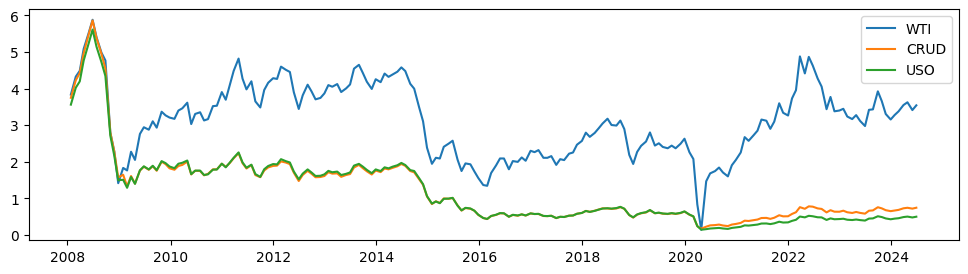

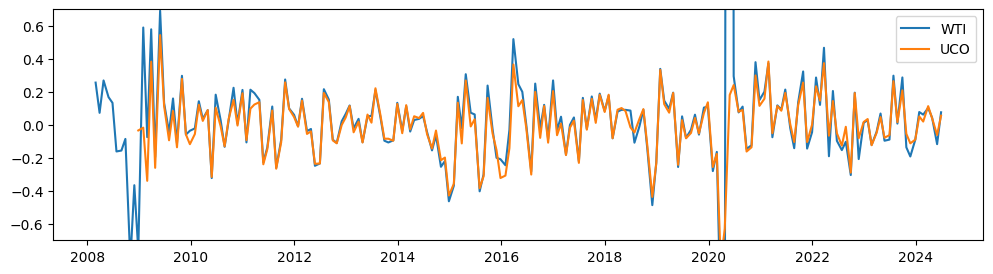

In [19]:
### NOTE NOTE NOTE CORRELATION ANALYSIS ---- THE ETFS WILL BE USED TO MAKE SHORT/LONG WHEN TRADES ARE EXECUTED ... MUST BE CORRELATION TO SPOT PRICE
#                                            WHICH IS USED OT TRAIN 

start_date = "2008-01-01"
end_date = "2024-06-30"

import copy 

df_HOD_weekly_end_mo_y_copy = copy.deepcopy(df_HOD_weekly_end_mo_y.sort_index(ascending= True   ))
df_wti_weekly_end_mo_y_copy = copy.deepcopy(df_wti_weekly_end_mo_y.sort_index(ascending= True   ))
df_UCO_weekly_end_mo_y_copy = copy.deepcopy(df_UCO_weekly_end_mo_y.sort_index(ascending= True   ))
df_HUC_weekly_end_mo_y_copy = copy.deepcopy(df_HUC_weekly_end_mo_y.sort_index(ascending= True   ))
df_CRUD_weekly_end_mo_y_copy = copy.deepcopy(df_CRUD_weekly_end_mo_y.sort_index(ascending= True   ))
df_USO_weekly_end_mo_y_copy = copy.deepcopy(df_USO_weekly_end_mo_y.sort_index(ascending= True   ))

df_HOD_weekly_end_mo_y_copy = df_HOD_weekly_end_mo_y_copy[(df_HOD_weekly_end_mo_y_copy.index < end_date) & \
                                                           (df_HOD_weekly_end_mo_y_copy.index > start_date)].reset_index()

df_wti_weekly_end_mo_y_copy = df_wti_weekly_end_mo_y_copy[(df_wti_weekly_end_mo_y_copy.index < end_date) & \
                                                           (df_wti_weekly_end_mo_y_copy.index > start_date)].reset_index()

df_UCO_weekly_end_mo_y_copy = df_UCO_weekly_end_mo_y_copy[(df_UCO_weekly_end_mo_y_copy.index < end_date) & \
                                                           (df_UCO_weekly_end_mo_y_copy.index > start_date)].reset_index()

df_HUC_weekly_end_mo_y_copy = df_HUC_weekly_end_mo_y_copy[(df_HUC_weekly_end_mo_y_copy.index < end_date) & \
                                                           (df_HUC_weekly_end_mo_y_copy.index > start_date)].reset_index()

df_CRUD_weekly_end_mo_y_copy = df_CRUD_weekly_end_mo_y_copy[(df_CRUD_weekly_end_mo_y_copy.index < end_date) & \
                                                           (df_CRUD_weekly_end_mo_y_copy.index > start_date)].reset_index()

df_USO_weekly_end_mo_y_copy = df_USO_weekly_end_mo_y_copy[(df_USO_weekly_end_mo_y_copy.index < end_date) & \
                                                           (df_USO_weekly_end_mo_y_copy.index > start_date)].reset_index()

df_HOD_weekly_end_mo_y_copy.rename({'index':'date'} , axis=1, inplace=True)
df_UCO_weekly_end_mo_y_copy.rename({'index':'date'} , axis=1, inplace=True)
df_HUC_weekly_end_mo_y_copy.rename({'index':'date'} , axis=1, inplace=True)
df_CRUD_weekly_end_mo_y_copy.rename({'index':'date'} , axis=1, inplace=True)
df_USO_weekly_end_mo_y_copy.rename({'index':'date'} , axis=1, inplace=True)

df_HOD_weekly_end_mo_y_copy["date"] = pd.to_datetime(df_HOD_weekly_end_mo_y_copy["date"])
df_wti_weekly_end_mo_y_copy["date"] = pd.to_datetime(df_wti_weekly_end_mo_y_copy["date"])
df_UCO_weekly_end_mo_y_copy["date"] = pd.to_datetime(df_UCO_weekly_end_mo_y_copy["date"])
df_HUC_weekly_end_mo_y_copy["date"] = pd.to_datetime(df_HUC_weekly_end_mo_y_copy["date"])
df_CRUD_weekly_end_mo_y_copy["date"] = pd.to_datetime(df_CRUD_weekly_end_mo_y_copy["date"])
df_USO_weekly_end_mo_y_copy["date"] = pd.to_datetime(df_USO_weekly_end_mo_y_copy["date"])

# merged = pd.merge(df_wti_weekly_end_mo_y_copy[["value", "date"]], df_HOD_weekly_end_mo_y_copy[["value" , "date"]] \
#                   , df_HUC_weekly_end_mo_y_copy[["value" , "date"]] , df_UCO_weekly_end_mo_y_copy[["value" , "date"]] , \
#                       on='date', how='inner', suffixes=('_HOD', '_WTI' , '_HUC', '_UCO'))

merged_0 = pd.merge(df_wti_weekly_end_mo_y_copy[["value", "date"]], df_HOD_weekly_end_mo_y_copy[["value" , "date"]] \
                  , on='date', how='inner', suffixes=('_WTI', '_HOD'))

for i, suffix in zip((df_HUC_weekly_end_mo_y_copy, df_UCO_weekly_end_mo_y_copy, df_CRUD_weekly_end_mo_y_copy , df_USO_weekly_end_mo_y_copy), ('_HUC', '_UCO', '_CRUD', '_USO')):
    merged_0 = pd.merge(merged_0, i[["value", "date"]], on='date', how='inner' , suffixes=('', suffix))


# print(df_HOD_weekly_end_mo_y_copy.reset_index().head(3))
# print(df_wti_weekly_end_mo_y_copy.reset_index().head(3))

# print(df_wti_weekly_end_mo_y_copy.columns)
# print(df_HOD_weekly_end_mo_y_copy.columns)
# print(df_HUC_weekly_end_mo_y_copy.columns)
# df_HOD_weekly_end_mo_y_copy.columns
# df_HOD_weekly_end_mo_y_copy

merged_0

HOD_normalized = (merged_0['value_HOD'] ) / merged_0['value_HOD'].std()
WTI_normalized = (merged_0['value_WTI'] ) / merged_0['value_WTI'].std()
HUC_normalized = (merged_0['value'] ) / merged_0['value'].std()
UCO_normalized = (merged_0['value_UCO'] ) / merged_0['value_UCO'].std()
CRUD_normalized = (merged_0['value_CRUD'] ) / merged_0['value_CRUD'].std()
USO_normalized = (merged_0['value_USO'] ) / merged_0['value_USO'].std()

HOD_pct_ch = merged_0['value_HOD'].pct_change() 
WTI_pct_ch = merged_0['value_WTI'].pct_change() 
HUC_pct_ch = merged_0['value'].pct_change() 
UCO_pct_ch = merged_0['value_UCO'].pct_change() 
CRUD_pct_ch = merged_0['value_CRUD'].pct_change() 
USO_pct_ch = merged_0['value_USO'].pct_change()

print( 'WTI and HOD',np.corrcoef(merged_0['value_HOD'], merged_0['value_WTI'])[0,1])
print( 'WTI and HUC',np.corrcoef(merged_0['value'], merged_0['value_WTI'])[0,1])
print( 'WTI and UCO',np.corrcoef(merged_0['value_UCO'], merged_0['value_WTI'])[0,1])
print( 'WTI and CRUD',np.corrcoef(merged_0['value_CRUD'], merged_0['value_WTI'])[0,1])
print( 'WTI and USO',np.corrcoef(merged_0['value_USO'], merged_0['value_WTI'])[0,1])

print( 'pct_change - WTI and HOD',np.corrcoef(WTI_pct_ch[1:], HOD_pct_ch[1:])[0,1])
print( 'pct_change - WTI and HUC',np.corrcoef(WTI_pct_ch[1:], HUC_pct_ch[1:])[0,1])
print( 'pct_change - WTI and UCO',np.corrcoef(WTI_pct_ch[1:], UCO_pct_ch[1:])[0,1])
print( 'pct_change - WTI and CRUD',np.corrcoef(WTI_pct_ch[1:], CRUD_pct_ch[1:])[0,1])
print( 'pct_change - WTI and USO',np.corrcoef(WTI_pct_ch[1:], USO_pct_ch[1:])[0,1])

plt.figure(figsize=(12, 3))
# plt.plot(merged_0["date"], HOD_normalized, label='HOD')
plt.plot(merged_0["date"], WTI_normalized, label='WTI')
# plt.plot(merged_0["date"], UCO_normalized, label='UCO')
# plt.plot(merged_0["date"], HUC_normalized, label='HUC')
plt.plot(merged_0["date"], CRUD_normalized, label='CRUD')
plt.plot(merged_0["date"], USO_normalized, label='USO')
plt.legend()


plt.figure(figsize=(12, 3))
# plt.plot(merged_0["date"], HOD_pct_ch, label='HOD')
plt.plot(merged_0["date"], WTI_pct_ch * 2, label='WTI')
plt.plot(merged_0["date"], UCO_pct_ch, label='UCO')
# plt.plot(merged_0["date"], HUC_pct_ch, label='HUC')
# plt.plot(merged_0["date"], CRUD_pct_ch, label='CRUD')
# plt.plot(merged_0["date"], USO_pct_ch, label='USO')
plt.ylim(-.7, .7)
plt.legend()

#########################

#### NOTE NOTE NOTE THE 2020 APRIL DIP IS A GOOD INDICATOR OF HIGH CORRELATION EVEN DURING A CRASH

UCO_DATE_MIN

/Users/cs/venvs/venv_1/lib/python3.13/site-packages/numpy/_core/function_base.py:162: RuntimeWarning: invalid value encountered in multiply
  y *= step
/Users/cs/venvs/venv_1/lib/python3.13/site-packages/numpy/lib/_function_base_impl.py:1518: RuntimeWarning: invalid value encountered in subtract
  a = op(a[slice1], a[slice2])


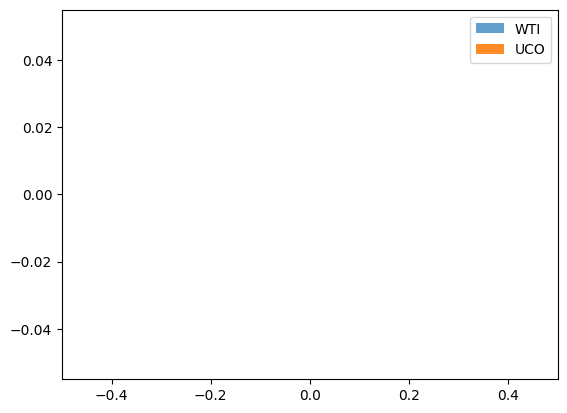

Mean WTI: -0.0010514567772609313 Mean USO: -0.0007256747875618828 Mean UCO: 0.0006697029828587992
Median WTI: -0.013893034026489781 Median USO: 0.008202975963372827 Median UCO: 0.002033752715881021
MAD WTI: 0.07124127783382776 MAD USO: 0.07065340964446316 MAD UCO: 0.12391294727507832


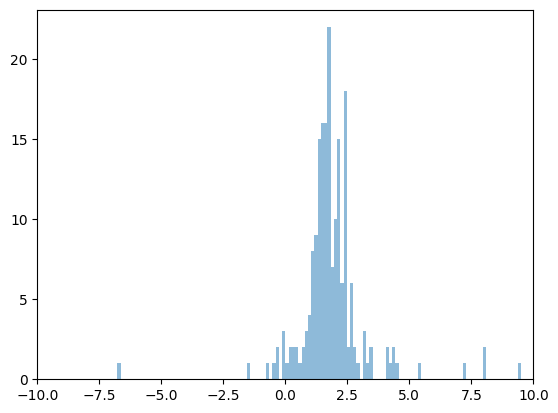

Mean Ratio: 2.7063940673960065


In [20]:
import numpy as np
import matplotlib.pyplot as plt
import copy
import datetime

df_wti_weekly_end_mo_y_copy = copy.deepcopy(df_wti_weekly_end_mo_y).reset_index()
df_USO_weekly_end_mo_y_copy = copy.deepcopy(df_USO_weekly_end_mo_y).reset_index()
df_UCO_weekly_end_mo_y_copy = copy.deepcopy(df_UCO_weekly_end_mo_y).reset_index()


# Compute pct_change
wti_pct_ch = df_wti_weekly_end_mo_y_copy["value"].pct_change()
uso_pct_ch = df_USO_weekly_end_mo_y_copy["value"].pct_change()
uco_pct_ch = df_UCO_weekly_end_mo_y_copy["value"].pct_change()
# Find overall min and max across both series
data_min = min(wti_pct_ch.min(), uso_pct_ch.min(), uco_pct_ch.min())
data_max = max(wti_pct_ch.max(), uso_pct_ch.max(), uco_pct_ch.max())

# Define common bins (example: 50 evenly spaced bins)
bins = np.linspace(data_min, data_max, 400)

# Plot both with same bins
plt.hist(wti_pct_ch, bins=bins, alpha=0.7, label="WTI")
# plt.hist(uso, bins=bins, alpha=0.5, label="USO")
plt.hist(uco_pct_ch, bins=bins, alpha=.9, label="UCO")
plt.legend()
plt.xlim(-0.5, 0.5)
plt.show()

## metrics

outlier_control_thresh = .5

wti_no_out = wti_pct_ch[ (wti_pct_ch > -outlier_control_thresh) & (wti_pct_ch < outlier_control_thresh) ]
uso_no_out = uso_pct_ch[ (uso_pct_ch > -outlier_control_thresh) & (uso_pct_ch < outlier_control_thresh) ]
uco_no_out = uco_pct_ch[ (uco_pct_ch > -outlier_control_thresh) & (uco_pct_ch < outlier_control_thresh) ]

mean_wti = wti_no_out.mean()
mean_uso = uso_no_out.mean()
mean_uco = uco_no_out.mean()

median_wti = wti_no_out.median()
median_uso = uso_no_out.median()
median_uco = uco_no_out.median()

mad_wti = (wti_no_out - wti_no_out.median()).abs().mean()
mad_uso = (uso_no_out - uso_no_out.median()).abs().mean()
mad_uco = (uco_no_out - uco_no_out.median()).abs().mean()

print("Mean WTI:", mean_wti, "Mean USO:", mean_uso, "Mean UCO:", mean_uco)
print("Median WTI:", median_wti, "Median USO:", median_uso, "Median UCO:", median_uco)
print("MAD WTI:", mad_wti, "MAD USO:", mad_uso, "MAD UCO:", mad_uco)


##### UCO adjusting factor analysis w/ WTI

df_wti_weekly_end_mo_y_copy_2 = copy.deepcopy(df_wti_weekly_end_mo_y[df_wti_weekly_end_mo_y.index > UCO_DATE_MIN]).reset_index()
df_UCO_weekly_end_mo_y_copy_2 = copy.deepcopy(df_UCO_weekly_end_mo_y[df_UCO_weekly_end_mo_y.index > UCO_DATE_MIN]).reset_index()

df_wti_weekly_end_mo_y_copy_2.rename({'index':'date'} , axis=1, inplace=True)
df_UCO_weekly_end_mo_y_copy_2.rename({'index':'date'} , axis=1, inplace=True)



df_UCO_weekly_end_mo_y_copy_2["date"] = pd.to_datetime(df_UCO_weekly_end_mo_y_copy_2["date"])
df_wti_weekly_end_mo_y_copy_2["date"] = pd.to_datetime(df_wti_weekly_end_mo_y_copy_2["date"])

WTI_UCO_merged = pd.merge(df_wti_weekly_end_mo_y_copy_2[["value", "date"]], df_UCO_weekly_end_mo_y_copy_2[["value", "date"]], on='date', suffixes=('_WTI', '_UCO'))
WTI_UCO_merged

WTI_UCO_merged["pct_change_UCO"] = WTI_UCO_merged["value_UCO"].pct_change() 
WTI_UCO_merged["pct_change_WTI"] = WTI_UCO_merged["value_WTI"].pct_change()

WTI_UCO_merged["pct_change_UCO_01"] = (WTI_UCO_merged["pct_change_UCO"] > 0).astype(int)
WTI_UCO_merged["pct_change_WTI_01"] = (WTI_UCO_merged["pct_change_WTI"] > 0).astype(int)

# plt.hist(WTI_UCO_merged["pct_change_UCO"] - WTI_UCO_merged["pct_change_WTI"], bins=800, alpha=0.5, label="WTI")
# plt.xlim(-0.8, 0.8)
# plt.show()

(WTI_UCO_merged["pct_change_UCO_01"] != WTI_UCO_merged["pct_change_WTI_01"]).sum()


### dist of the ratio 
plt.hist(WTI_UCO_merged["pct_change_UCO"] / WTI_UCO_merged["pct_change_WTI"], bins=800, alpha=0.5, label="WTI")
plt.xlim(-10, 10)
plt.show()

mean_ratio = (WTI_UCO_merged["pct_change_UCO"] / WTI_UCO_merged["pct_change_WTI"]).mean()
print("Mean Ratio:", mean_ratio)


In [12]:
###### CREATE ETF PREDICTORS FOR TESTING



In [23]:




df_HOD_weekly_end_mo_y_copy["value_retRate"] = df_HOD_weekly_end_mo_y_copy["value"].pct_change()
df_UCO_weekly_end_mo_y_copy["value_retRate"] = df_UCO_weekly_end_mo_y_copy["value"].pct_change()
df_HUC_weekly_end_mo_y_copy["value_retRate"] = df_HUC_weekly_end_mo_y_copy["value"].pct_change()
df_CRUD_weekly_end_mo_y_copy["value_retRate"] = df_CRUD_weekly_end_mo_y_copy["value"].pct_change()
df_USO_weekly_end_mo_y_copy["value_retRate"] = df_USO_weekly_end_mo_y_copy["value"].pct_change()

####### testing 

test_set_dates = [
    ['2021-12-31', '2022-01-28', '2022-02-25'],
    ['2022-03-25', '2022-04-29', '2022-05-27'],
    ['2022-06-24', '2022-07-29', '2022-08-26'],
    ['2022-09-30', '2022-10-28', '2022-11-25']
]

test_set_dates_flattened = [i for part in test_set_dates for i in part]

val_set_dates = [
    ['2019-12-27', '2020-01-31', '2020-02-28'],
    ['2020-03-27', '2020-04-24', '2020-05-29'],
    ['2020-06-26', '2020-07-31', '2020-08-28'],
    ['2020-09-25', '2020-10-30', '2020-11-27'],
    ['2020-12-25', '2021-01-29', '2021-02-26'],
    ['2021-03-26', '2021-04-30', '2021-05-28'],
    ['2021-06-25', '2021-07-30', '2021-08-27'],
    ['2021-09-24', '2021-10-29', '2021-11-26']
]

val_set_dates_flattened = [i for part in val_set_dates for i in part]

df_HUC_weekly_end_mo_y_TEST_DATES =  df_HUC_weekly_end_mo_y_copy[df_HUC_weekly_end_mo_y_copy["date"].isin(test_set_dates_flattened)][["date", "value_retRate"]]
df_UCO_weekly_end_mo_y_TEST_DATES = df_UCO_weekly_end_mo_y_copy[df_UCO_weekly_end_mo_y_copy["date"].isin(test_set_dates_flattened)][["date", "value_retRate"]]
df_HOD_weekly_end_mo_y_TEST_DATES = df_HOD_weekly_end_mo_y_copy[df_HOD_weekly_end_mo_y_copy["date"].isin(test_set_dates_flattened)][["date", "value_retRate"]]
df_CRUD_weekly_end_mo_y_TEST_DATES = df_CRUD_weekly_end_mo_y_copy[df_CRUD_weekly_end_mo_y_copy["date"].isin(test_set_dates_flattened)][["date", "value_retRate"]]
df_USO_weekly_end_mo_y_TEST_DATES = df_USO_weekly_end_mo_y_copy[df_USO_weekly_end_mo_y_copy["date"].isin(test_set_dates_flattened)][["date", "value_retRate"]]


df_HUC_weekly_end_mo_y_VAL_DATES = df_HUC_weekly_end_mo_y_copy[df_HUC_weekly_end_mo_y_copy["date"].isin(val_set_dates_flattened)][["date", "value_retRate"]]
df_UCO_weekly_end_mo_y_VAL_DATES = df_UCO_weekly_end_mo_y_copy[df_UCO_weekly_end_mo_y_copy["date"].isin(val_set_dates_flattened)][["date", "value_retRate"]]
df_HOD_weekly_end_mo_y_VAL_DATES = df_HOD_weekly_end_mo_y_copy[df_HOD_weekly_end_mo_y_copy["date"].isin(val_set_dates_flattened)][["date", "value_retRate"]]
df_CRUD_weekly_end_mo_y_VAL_DATES = df_CRUD_weekly_end_mo_y_copy[df_CRUD_weekly_end_mo_y_copy["date"].isin(val_set_dates_flattened)][["date", "value_retRate"]]
df_USO_weekly_end_mo_y_VAL_DATES = df_USO_weekly_end_mo_y_copy[df_USO_weekly_end_mo_y_copy["date"].isin(val_set_dates_flattened)][["date", "value_retRate"]]

dfs_test = [df_HUC_weekly_end_mo_y_TEST_DATES, df_UCO_weekly_end_mo_y_TEST_DATES, 
            df_HOD_weekly_end_mo_y_TEST_DATES, df_CRUD_weekly_end_mo_y_TEST_DATES, df_USO_weekly_end_mo_y_TEST_DATES]


df_HUC_T_folds_values = [df_HUC_weekly_end_mo_y_TEST_DATES["value_retRate"].values[i:i+3] 
                         for i in range(0, len(df_HUC_weekly_end_mo_y_TEST_DATES), 3)]
df_UCO_T_folds_values = [df_UCO_weekly_end_mo_y_TEST_DATES["value_retRate"].values[i:i+3] 
                         for i in range(0, len(df_UCO_weekly_end_mo_y_TEST_DATES), 3)]
df_HOD_T_folds_values = [df_HOD_weekly_end_mo_y_TEST_DATES["value_retRate"].values[i:i+3] 
                         for i in range(0, len(df_HOD_weekly_end_mo_y_TEST_DATES), 3)]
df_CRUD_T_folds_values = [df_CRUD_weekly_end_mo_y_TEST_DATES["value_retRate"].values[i:i+3] 
                         for i in range(0, len(df_CRUD_weekly_end_mo_y_TEST_DATES), 3)]
df_USO_T_folds_values = [df_USO_weekly_end_mo_y_TEST_DATES["value_retRate"].values[i:i+3] 
                         for i in range(0, len(df_USO_weekly_end_mo_y_TEST_DATES), 3)]

df_HUC_V_folds_values = [df_HUC_weekly_end_mo_y_VAL_DATES["value_retRate"].values[i:i+3] 
                         for i in range(0, len(df_HUC_weekly_end_mo_y_VAL_DATES), 3)]
df_UCO_V_folds_values = [df_UCO_weekly_end_mo_y_VAL_DATES["value_retRate"].values[i:i+3] 
                         for i in range(0, len(df_UCO_weekly_end_mo_y_VAL_DATES), 3)]
df_HOD_V_folds_values = [df_HOD_weekly_end_mo_y_VAL_DATES["value_retRate"].values[i:i+3] 
                         for i in range(0, len(df_HOD_weekly_end_mo_y_VAL_DATES), 3)]
df_CRUD_V_folds_values = [df_CRUD_weekly_end_mo_y_VAL_DATES["value_retRate"].values[i:i+3] 
                         for i in range(0, len(df_CRUD_weekly_end_mo_y_VAL_DATES), 3)]
df_USO_V_folds_values = [df_USO_weekly_end_mo_y_VAL_DATES["value_retRate"].values[i:i+3] 
                         for i in range(0, len(df_USO_weekly_end_mo_y_VAL_DATES), 3)]


import pickle

with open('ETF_dfs_WTI_preds_analysis/df_HUC_T_folds_values' , 'wb') as f:
    pickle.dump(df_HUC_T_folds_values, f)

with open('ETF_dfs_WTI_preds_analysis/df_UCO_T_folds_values' , 'wb') as f:
    pickle.dump(df_UCO_T_folds_values, f)

with open('ETF_dfs_WTI_preds_analysis/df_HOD_T_folds_values' , 'wb') as f:
    pickle.dump(df_HOD_T_folds_values, f)

with open('ETF_dfs_WTI_preds_analysis/df_CRUD_T_folds_values' , 'wb') as f:
    pickle.dump(df_CRUD_T_folds_values, f)

with open('ETF_dfs_WTI_preds_analysis/df_USO_T_folds_values' , 'wb') as f:
    pickle.dump(df_USO_T_folds_values, f)



with open('ETF_dfs_WTI_preds_analysis/df_HUC_V_folds_values' , 'wb') as f:
    pickle.dump(df_HUC_V_folds_values, f)

with open('ETF_dfs_WTI_preds_analysis/df_UCO_V_folds_values' , 'wb') as f:
    pickle.dump(df_UCO_V_folds_values, f)

with open('ETF_dfs_WTI_preds_analysis/df_HOD_V_folds_values' , 'wb') as f:
    pickle.dump(df_HOD_V_folds_values, f)

with open('ETF_dfs_WTI_preds_analysis/df_CRUD_V_folds_values' , 'wb') as f:
    pickle.dump(df_CRUD_V_folds_values, f)

with open('ETF_dfs_WTI_preds_analysis/df_USO_V_folds_values' , 'wb') as f:
    pickle.dump(df_USO_V_folds_values, f)

# ##### WILL BE USED IN THE RESULTS AND DIST PAGE IN ORDER TO CALL ACTUAL RETURNS



# import pickle 

# with open('df_HUC_weekly_end_mo_y_TEST_DATES.pkl', 'wb') as f:
#     pickle.dump(df_HUC_weekly_end_mo_y_TEST_DATES, f)

# with open('df_UCO_weekly_end_mo_y_TEST_DATES.pkl', 'wb') as f:
#     pickle.dump(df_UCO_weekly_end_mo_y_TEST_DATES, f)

# with open('df_HOD_weekly_end_mo_y_TEST_DATES.pkl', 'wb') as f:
#     pickle.dump(df_HOD_weekly_end_mo_y_TEST_DATES, f)

# with open('df_HUC_weekly_end_mo_y_VAL_DATES.pkl', 'wb') as f:
#     pickle.dump(df_HUC_weekly_end_mo_y_VAL_DATES, f)

# with open('df_UCO_weekly_end_mo_y_VAL_DATES.pkl', 'wb') as f:
#     pickle.dump(df_UCO_weekly_end_mo_y_VAL_DATES, f)

# with open('df_HOD_weekly_end_mo_y_VAL_DATES.pkl', 'wb') as f:
#     pickle.dump(df_HOD_weekly_end_mo_y_VAL_DATES, f)


KeyError: 'date'

: 

: 

In [16]:
test_set_dates = [
    ['2021-12-31', '2022-01-28', '2022-02-25'],
    ['2022-03-25', '2022-04-29', '2022-05-27'],
    ['2022-06-24', '2022-07-29', '2022-08-26'],
    ['2022-09-30', '2022-10-28', '2022-11-25']
]

test_set_dates_flattened = [i for part in test_set_dates for i in part]

val_set_dates = [
    ['2019-12-27', '2020-01-31', '2020-02-28'],
    ['2020-03-27', '2020-04-24', '2020-05-29'],
    ['2020-06-26', '2020-07-31', '2020-08-28'],
    ['2020-09-25', '2020-10-30', '2020-11-27'],
    ['2020-12-25', '2021-01-29', '2021-02-26'],
    ['2021-03-26', '2021-04-30', '2021-05-28'],
    ['2021-06-25', '2021-07-30', '2021-08-27'],
    ['2021-09-24', '2021-10-29', '2021-11-26']
]

val_set_dates_flattened = [i for part in val_set_dates for i in part]

df_HOD_weekly_end_mo_y_copy["value_retRate"] = df_HOD_weekly_end_mo_y_copy["value"].pct_change()
df_UCO_weekly_end_mo_y_copy["value_retRate"] = df_UCO_weekly_end_mo_y_copy["value"].pct_change()
df_HUC_weekly_end_mo_y_copy["value_retRate"] = df_HUC_weekly_end_mo_y_copy["value"].pct_change()
df_CRUD_weekly_end_mo_y_copy["value_retRate"] = df_CRUD_weekly_end_mo_y_copy["value"].pct_change()
df_USO_weekly_end_mo_y_copy["value_retRate"] = df_USO_weekly_end_mo_y_copy["value"].pct_change()


df_wti_weekly_end_mo_y_copy["value_retRate"] = df_wti_weekly_end_mo_y_copy["value_end_of_month"].pct_change()

df_wti_test_dates = df_wti_weekly_end_mo_y_copy[df_wti_weekly_end_mo_y_copy["date"].isin(test_set_dates_flattened)][["date", "value_retRate"]]
df_HOD_test_dates = df_HOD_weekly_end_mo_y_copy[df_HOD_weekly_end_mo_y_copy["date"].isin(test_set_dates_flattened)][["date", "value_retRate"]]
df_HUC_test_dates = df_HUC_weekly_end_mo_y_copy[df_HUC_weekly_end_mo_y_copy["date"].isin(test_set_dates_flattened)][["date", "value_retRate"]]
df_UCO_test_dates = df_UCO_weekly_end_mo_y_copy[df_UCO_weekly_end_mo_y_copy["date"].isin(test_set_dates_flattened)][["date", "value_retRate"]]
df_CRUD_test_dates = df_CRUD_weekly_end_mo_y_copy[df_CRUD_weekly_end_mo_y_copy["date"].isin(test_set_dates_flattened)][["date", "value_retRate"]]
df_USO_test_dates = df_USO_weekly_end_mo_y_copy[df_USO_weekly_end_mo_y_copy["date"].isin(test_set_dates_flattened)][["date", "value_retRate"]]


df_wti_weekly_end_mo_y_copy["value_retRate"] = df_wti_weekly_end_mo_y_copy["value_end_of_month"].pct_change()

df_wti_val_dates = df_wti_weekly_end_mo_y_copy[df_wti_weekly_end_mo_y_copy["date"].isin(val_set_dates_flattened)][["date", "value_retRate"]]
df_HOD_val_dates = df_HOD_weekly_end_mo_y_copy[df_HOD_weekly_end_mo_y_copy["date"].isin(val_set_dates_flattened)][["date", "value_retRate"]]
df_HUC_val_dates = df_HUC_weekly_end_mo_y_copy[df_HUC_weekly_end_mo_y_copy["date"].isin(val_set_dates_flattened)][["date", "value_retRate"]]
df_UCO_val_dates = df_UCO_weekly_end_mo_y_copy[df_UCO_weekly_end_mo_y_copy["date"].isin(val_set_dates_flattened)][["date", "value_retRate"]]
df_CRUD_val_dates = df_CRUD_weekly_end_mo_y_copy[df_CRUD_weekly_end_mo_y_copy["date"].isin(val_set_dates_flattened)][["date", "value_retRate"]]
df_USO_val_dates = df_USO_weekly_end_mo_y_copy[df_USO_weekly_end_mo_y_copy["date"].isin(val_set_dates_flattened)][["date", "value_retRate"]]


plt.plot(df_wti_test_dates["date"], df_wti_test_dates["value_retRate"],'o-' ,label='WTI')
# plt.plot(df_HOD_test_dates["date"], df_HOD_test_dates["value_retRate"],'o-' ,label='HOD')
# plt.plot(df_HUC_test_dates["date"], df_HUC_test_dates["value_retRate"],'o-' ,label='HUC')
plt.plot(df_UCO_test_dates["date"], df_UCO_test_dates["value_retRate"],'o-' ,label='UCO')
plt.plot(df_USO_test_dates["date"], df_USO_test_dates["value_retRate"],'o-' ,label='USO')
plt.plot(df_CRUD_test_dates["date"], df_CRUD_test_dates["value_retRate"],'o-' ,label='CRUD')
plt.axhline(y = 0, color='k', linestyle='--')
plt.legend()
plt.xticks(rotation=45)
plt.show()


plt.plot(df_wti_val_dates["date"], df_wti_val_dates["value_retRate"],'o-' ,label='WTI')
# plt.plot(df_HOD_test_dates["date"], df_HOD_test_dates["value_retRate"],'o-' ,label='HOD')
# plt.plot(df_HUC_test_dates["date"], df_HUC_test_dates["value_retRate"],'o-' ,label='HUC')
plt.plot(df_UCO_val_dates["date"], df_UCO_val_dates["value_retRate"],'o-' ,label='UCO')
plt.plot(df_USO_val_dates["date"], df_USO_val_dates["value_retRate"],'o-' ,label='USO')
plt.plot(df_CRUD_val_dates["date"], df_CRUD_val_dates["value_retRate"],'o-' ,label='CRUD')
plt.axhline(y = 0, color='k', linestyle='--')
plt.legend()
plt.ylim(-1, 1)
plt.xticks(rotation=45)




sum( df_wti_val_dates["value_retRate"] < -.05)

/var/folders/g_/x6nnyyc96zb627gqxngw5wgc0000gn/T/ipykernel_32265/3840125029.py:32: FutureWarning: The behavior of 'isin' with dtype=datetime64[ns] and castable values (e.g. strings) is deprecated. In a future version, these will not be considered matching by isin. Explicitly cast to the appropriate dtype before calling isin instead.
  df_wti_test_dates = df_wti_weekly_end_mo_y_copy[df_wti_weekly_end_mo_y_copy["date"].isin(test_set_dates_flattened)][["date", "value_retRate"]]


KeyError: 'date'

In [ ]:
## X_13: US PPI, Energy, Seasonally Adjusted - FOUND Producer Price Index by Commodity: Final Demand: Finished Consumer Energy Goods (WPSFD4121) *monthly*
### NOTE ON DATE -- we see dates are on the first day of the month ...from https://fred.stlouisfed.org/data/WPSFD4121 
#**#*#**# NOTE for ex 2000-01-01 is the avg daily price fro JAN (nto for the prev or the next month )

FRED_API_KEY = "ba132add18e668066107070613e05207" ; SERIES_ID = "WPSFD4121" ### Producer Price Index by Commodity: Final Demand: Finished Consumer Energy Goods

url = f"https://api.stlouisfed.org/fred/series/observations?series_id={SERIES_ID}&api_key={FRED_API_KEY}&file_type=xml"
response = requests.get(url)

df_US_energy_PPI = parse_fred_xml(response.content)
df_US_energy_PPI['date'] = pd.to_datetime(df_US_energy_PPI['date']) + pd.offsets.MonthEnd(0)
df_US_energy_PPI = df_US_energy_PPI.set_index('date')

# print(df_US_energy_PPI.head())




: 

: 

: 

: 

: 

In [ ]:
API_linkhttps://ec.europa.eu/eurostat/api/dissemination/sdmx/3.0/data/dataflow/ESTAT/sts_inpp_m/1.0/*.*.*.*.*.*?c[freq]=M&c[indic_bt]=PRC_PRR&c[nace_r2]=B-E36&c[s_adj]=NSA&c[unit]=I21,I15,I10,PCH_PRE&c[geo]=EU27_2020,EU28,EA20,EA19&c[TIME_PERIOD]=2025-07,2025-06,2025-05,2025-04,2025-03,2025-02,2025-01,2024-12,2024-11,2024-10,2024-09,2024-08,2024-07,2024-06,2024-05,2024-04,2024-03,2024-02,2024-01,2023-12,2023-11,2023-10,2023-09,2023-08,2023-07,2023-06,2023-05,2023-04,2023-03,2023-02,2023-01,2022-12,2022-11,2022-10,2022-09,2022-08,2022-07,2022-06,2022-05,2022-04,2022-03,2022-02,2022-01,2021-12,2021-11,2021-10,2021-09,2021-08,2021-07,2021-06,2021-05,2021-04,2021-03,2021-02,2021-01,2020-12,2020-11,2020-10,2020-09,2020-08,2020-07,2020-06,2020-05,2020-04,2020-03,2020-02,2020-01,2019-12,2019-11,2019-10,2019-09,2019-08,2019-07,2019-06,2019-05,2019-04,2019-03,2019-02,2019-01,2018-12,2018-11,2018-10,2018-09,2018-08,2018-07,2018-06,2018-05,2018-04,2018-03,2018-02,2018-01,2017-12,2017-11,2017-10,2017-09,2017-08,2017-07,2017-06,2017-05,2017-04,2017-03,2017-02,2017-01,2016-12,2016-11,2016-10,2016-09,2016-08,2016-07,2016-06,2016-05,2016-04,2016-03,2016-02,2016-01,2015-12,2015-11,2015-10,2015-09,2015-08,2015-07,2015-06,2015-05,2015-04,2015-03,2015-02,2015-01,2014-12,2014-11,2014-10,2014-09,2014-08,2014-07,2014-06,2014-05,2014-04,2014-03,2014-02,2014-01,2013-12,2013-11,2013-10,2013-09,2013-08,2013-07,2013-06,2013-05,2013-04,2013-03,2013-02,2013-01,2012-12,2012-11,2012-10,2012-09,2012-08,2012-07,2012-06,2012-05,2012-04,2012-03,2012-02,2012-01,2011-12,2011-11,2011-10,2011-09,2011-08,2011-07,2011-06,2011-05,2011-04,2011-03,2011-02,2011-01,2010-12,2010-11,2010-10,2010-09,2010-08,2010-07,2010-06,2010-05,2010-04,2010-03,2010-02,2010-01,2009-12,2009-11,2009-10,2009-09,2009-08,2009-07,2009-06,2009-05,2009-04,2009-03,2009-02,2009-01,2008-12,2008-11,2008-10,2008-09,2008-08,2008-07,2008-06,2008-05,2008-04,2008-03,2008-02,2008-01,2007-12,2007-11,2007-10,2007-09,2007-08,2007-07,2007-06,2007-05,2007-04,2007-03,2007-02,2007-01,2006-12,2006-11,2006-10,2006-09,2006-08,2006-07,2006-06,2006-05,2006-04,2006-03,2006-02,2006-01,2005-12,2005-11,2005-10,2005-09,2005-08,2005-07,2005-06,2005-05,2005-04,2005-03,2005-02,2005-01,2004-12,2004-11,2004-10,2004-09,2004-08,2004-07,2004-06,2004-05,2004-04,2004-03,2004-02,2004-01,2003-12,2003-11,2003-10,2003-09,2003-08,2003-07,2003-06,2003-05,2003-04,2003-03,2003-02,2003-01,2002-12,2002-11,2002-10,2002-09,2002-08,2002-07,2002-06,2002-05,2002-04,2002-03,2002-02,2002-01,2001-12,2001-11,2001-10,2001-09,2001-08,2001-07,2001-06,2001-05,2001-04,2001-03,2001-02,2001-01,2000-12,2000-11,2000-10,2000-09,2000-08,2000-07,2000-06,2000-05,2000-04,2000-03,2000-02,2000-01,1999-12,1999-11,1999-10,1999-09,1999-08,1999-07,1999-06,1999-05,1999-04,1999-03,1999-02,1999-01,1998-12,1998-11,1998-10,1998-09,1998-08,1998-07,1998-06,1998-05,1998-04,1998-03,1998-02,1998-01,1997-12,1997-11,1997-10,1997-09,1997-08,1997-07,1997-06,1997-05,1997-04,1997-03,1997-02,1997-01,1996-12,1996-11,1996-10,1996-09,1996-08,1996-07,1996-06,1996-05,1996-04,1996-03,1996-02,1996-01,1995-12,1995-11,1995-10,1995-09,1995-08,1995-07,1995-06,1995-05,1995-04,1995-03,1995-02,1995-01,1994-12,1994-11,1994-10,1994-09,1994-08,1994-07,1994-06,1994-05,1994-04,1994-03,1994-02,1994-01,1993-12,1993-11,1993-10,1993-09,1993-08,1993-07,1993-06,1993-05,1993-04,1993-03,1993-02,1993-01,1992-12,1992-11,1992-10,1992-09,1992-08,1992-07,1992-06,1992-05,1992-04,1992-03,1992-02,1992-01,1991-12,1991-11,1991-10,1991-09,1991-08,1991-07,1991-06,1991-05,1991-04,1991-03,1991-02,1991-01,1990-12,1990-11,1990-10,1990-09,1990-08,1990-07,1990-06,1990-05,1990-04,1990-03,1990-02,1990-01,1989-12,1989-11,1989-10,1989-09,1989-08,1989-07,1989-06,1989-05,1989-04,1989-03,1989-02,1989-01,1988-12,1988-11,1988-10,1988-09,1988-08,1988-07,1988-06,1988-05,1988-04,1988-03,1988-02,1988-01,1987-12,1987-11,1987-10,1987-09,1987-08,1987-07,1987-06,1987-05,1987-04,1987-03,1987-02,1987-01,1986-12,1986-11,1986-10,1986-09,1986-08,1986-07,1986-06,1986-05,1986-04,1986-03,1986-02,1986-01,1985-12,1985-11,1985-10,1985-09,1985-08,1985-07,1985-06,1985-05,1985-04,1985-03,1985-02,1985-01,1984-12,1984-11,1984-10,1984-09,1984-08,1984-07,1984-06,1984-05,1984-04,1984-03,1984-02,1984-01,1983-12,1983-11,1983-10,1983-09,1983-08,1983-07,1983-06,1983-05,1983-04,1983-03,1983-02,1983-01,1982-12,1982-11,1982-10,1982-09,1982-08,1982-07,1982-06,1982-05,1982-04,1982-03,1982-02,1982-01,1981-12,1981-11,1981-10,1981-09,1981-08,1981-07,1981-06,1981-05,1981-04,1981-03,1981-02,1981-01,1980-12,1980-11,1980-10,1980-09,1980-08,1980-07,1980-06,1980-05,1980-04,1980-03,1980-02,1980-01,1979-12,1979-11,1979-10,1979-09,1979-08,1979-07,1979-06,1979-05,1979-04,1979-03,1979-02,1979-01,1978-12,1978-11,1978-10,1978-09,1978-08,1978-07,1978-06,1978-05,1978-04,1978-03,1978-02,1978-01,1977-12,1977-11,1977-10,1977-09,1977-08,1977-07,1977-06,1977-05,1977-04,1977-03,1977-02,1977-01,1976-12,1976-11,1976-10,1976-09,1976-08,1976-07,1976-06,1976-05,1976-04,1976-03,1976-02,1976-01&compress=false&format=csvdata&formatVersion=2.0&lang=en&labels=name

: 

: 

: 

: 

: 

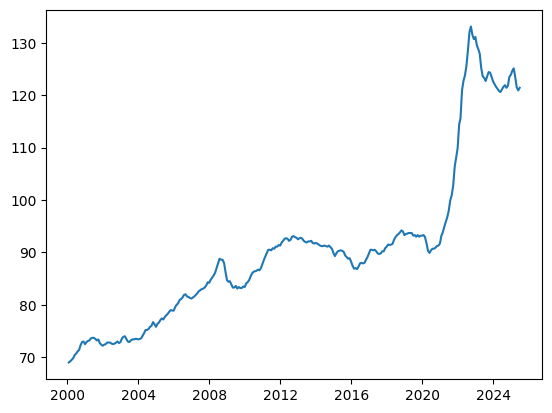

: 

: 

: 

: 

: 

In [ ]:
# ##### (BELOW IS FULL DATA) THIS DATA IS PARTIAL, I USE https://ycharts.com/indicators/europe_producer_price_index FREE TRIAL FOR FULL DATA 

# ## X_14: EU PPI - Producer Prices Index: Economic Activities: Manufacturing: Total for Euro Area (19 Countries) 
# ### NOTE ON DATE -- first day of the month 
# #**#*#**# NOTE for ex 2000-01-01 is the avg daily price fro JAN (nto for the prev or the next month )

# FRED_API_KEY = "ba132add18e668066107070613e05207" ; SERIES_ID = "PIEAMP01EZM661N"


# #####     NOTE CURRENT DATA IS FOR THE EU 19 

# # Fetch data
# url = f"https://api.stlouisfed.org/fred/series/observations?series_id={SERIES_ID}&api_key={FRED_API_KEY}&file_type=xml"
# response = requests.get(url)

# df_EU28_PPI = parse_fred_xml(response.content)
# df_EU28_PPI['date'] = pd.to_datetime(df_EU28_PPI['date']) + pd.offsets.MonthEnd(0)
# df_EU28_PPI = df_EU28_PPI.set_index('date')
# # print(df_EU28_PPI.head())

# # plt.plot(df_EU28_PPI["value"])

# # plt.plot(df_EU28_PPI["value"], label='EU28 PPI')

# ##### (BELOW IS FULL DATA) THIS DATA IS PARTIAL, I USE https://ycharts.com/indicators/europe_producer_price_index FREE TRIAL FOR FULL DATA 

# Date 	Value

raw_data = """

June 30, 2025 	121.40
May 31, 2025 	120.90
April 30, 2025 	121.50
March 31, 2025 	123.40
February 28, 2025 	125.10
January 31, 2025 	124.70
December 31, 2024 	123.90
November 30, 2024 	123.50
October 31, 2024 	121.80
September 30, 2024 	121.40
August 31, 2024 	121.90
July 31, 2024 	121.60
June 30, 2024 	121.10
May 31, 2024 	120.60
April 30, 2024 	120.80
March 31, 2024 	121.20
February 29, 2024 	121.60
January 31, 2024 	122.10
December 31, 2023 	122.60
November 30, 2023 	123.50
October 31, 2023 	124.30
September 30, 2023 	124.40
August 31, 2023 	123.60
July 31, 2023 	122.70
June 30, 2023 	123.30

May 31, 2023 	123.60
April 30, 2023 	125.20
March 31, 2023 	127.90
February 28, 2023 	128.80
January 31, 2023 	129.50
December 31, 2022 	131.10
November 30, 2022 	130.70
October 31, 2022 	131.50
September 30, 2022 	133.10
August 31, 2022 	132.00
July 31, 2022 	128.60
June 30, 2022 	125.60
May 31, 2022 	123.80
April 30, 2022 	122.70
March 31, 2022 	120.90
February 28, 2022 	115.60
January 31, 2022 	114.40
December 31, 2021 	109.90
November 30, 2021 	108.00
October 31, 2021 	106.30
September 30, 2021 	102.70
August 31, 2021 	100.90
July 31, 2021 	99.90
June 30, 2021 	97.90
May 31, 2021 	96.70 


April 30, 2021 	95.80
March 31, 2021 	94.90
February 28, 2021 	93.80
January 31, 2021 	93.20
December 31, 2020 	91.70
November 30, 2020 	91.30
October 31, 2020 	91.20
September 30, 2020 	90.90
August 31, 2020 	90.70
July 31, 2020 	90.70
June 30, 2020 	90.40
May 31, 2020 	89.90
April 30, 2020 	90.30
March 31, 2020 	91.70
February 29, 2020 	92.90
January 31, 2020 	93.30
December 31, 2019 	93.20
November 30, 2019 	93.20
October 31, 2019 	93.00
September 30, 2019 	93.30
August 31, 2019 	93.00
July 31, 2019 	93.30
June 30, 2019 	93.20
May 31, 2019 	93.70
April 30, 2019 	93.70

March 31, 2019 	93.70
February 28, 2019 	93.60
January 31, 2019 	93.50
December 31, 2018 	93.30
November 30, 2018 	94.00
October 31, 2018 	94.20
September 30, 2018 	93.80
August 31, 2018 	93.50
July 31, 2018 	93.30
June 30, 2018 	92.90
May 31, 2018 	92.40
April 30, 2018 	91.60
March 31, 2018 	91.50
February 28, 2018 	91.40
January 31, 2018 	91.50
December 31, 2017 	91.10
November 30, 2017 	90.80
October 31, 2017 	90.20
September 30, 2017 	90.20
August 31, 2017 	89.80
July 31, 2017 	89.70
June 30, 2017 	89.80
May 31, 2017 	90.20
April 30, 2017 	90.50
March 31, 2017 	90.40 



February 28, 2017 	90.50
January 31, 2017 	90.50
December 31, 2016 	89.80
November 30, 2016 	89.10
October 31, 2016 	88.60
September 30, 2016 	88.00
August 31, 2016 	87.90
July 31, 2016 	88.00
June 30, 2016 	87.90
May 31, 2016 	87.30
April 30, 2016 	86.80
March 31, 2016 	87.00
February 29, 2016 	86.90
January 31, 2016 	87.40
December 31, 2015 	88.20
November 30, 2015 	88.90
October 31, 2015 	88.80
September 30, 2015 	89.10
August 31, 2015 	89.40
July 31, 2015 	90.10
June 30, 2015 	90.30
May 31, 2015 	90.40
April 30, 2015 	90.30
March 31, 2015 	90.20
February 28, 2015 	89.80


January 31, 2015 	89.30
December 31, 2014 	89.90
November 30, 2014 	90.70
October 31, 2014 	91.00
September 30, 2014 	91.30
August 31, 2014 	91.10
July 31, 2014 	91.20
June 30, 2014 	91.30
May 31, 2014 	91.20
April 30, 2014 	91.20
March 31, 2014 	91.30
February 28, 2014 	91.50
January 31, 2014 	91.70
December 31, 2013 	91.80
November 30, 2013 	91.70
October 31, 2013 	91.80
September 30, 2013 	92.20
August 31, 2013 	92.10
July 31, 2013 	92.10
June 30, 2013 	91.90
May 31, 2013 	92.00
April 30, 2013 	92.20
March 31, 2013 	92.60
February 28, 2013 	92.80
January 31, 2013 	92.70 



December 31, 2012 	92.50
November 30, 2012 	92.80
October 31, 2012 	92.90
September 30, 2012 	93.10
August 31, 2012 	93.00
July 31, 2012 	92.40
June 30, 2012 	92.20
May 31, 2012 	92.60
April 30, 2012 	92.70
March 31, 2012 	92.60
February 29, 2012 	92.20
January 31, 2012 	91.90
December 31, 2011 	91.30
November 30, 2011 	91.40
October 31, 2011 	91.10
September 30, 2011 	91.10
August 31, 2011 	90.70
July 31, 2011 	90.80
June 30, 2011 	90.40
May 31, 2011 	90.50
April 30, 2011 	90.50
March 31, 2011 	89.90
February 28, 2011 	89.20
January 31, 2011 	88.60
December 31, 2010 	87.80

November 30, 2010 	87.00
October 31, 2010 	86.60
September 30, 2010 	86.70
August 31, 2010 	86.50
July 31, 2010 	86.40
June 30, 2010 	86.30
May 31, 2010 	86.00
April 30, 2010 	85.40
March 31, 2010 	84.70
February 28, 2010 	84.30
January 31, 2010 	84.10
December 31, 2009 	83.40
November 30, 2009 	83.50
October 31, 2009 	83.20
September 30, 2009 	83.20
August 31, 2009 	83.40
July 31, 2009 	83.10
June 30, 2009 	83.60
May 31, 2009 	83.30
April 30, 2009 	83.30
March 31, 2009 	83.90
February 28, 2009 	84.50
January 31, 2009 	84.40
December 31, 2008 	84.70
November 30, 2008 	86.30 





October 31, 2008 	88.00
September 30, 2008 	88.60
August 31, 2008 	88.60
July 31, 2008 	88.80
June 30, 2008 	87.90
May 31, 2008 	87.00
April 30, 2008 	86.10
March 31, 2008 	85.60
February 29, 2008 	85.20
January 31, 2008 	84.80
December 31, 2007 	84.20
November 30, 2007 	84.30
October 31, 2007 	83.70
September 30, 2007 	83.30
August 31, 2007 	83.10
July 31, 2007 	83.00
June 30, 2007 	82.80
May 31, 2007 	82.60
April 30, 2007 	82.20
March 31, 2007 	81.90
February 28, 2007 	81.60
January 31, 2007 	81.40
December 31, 2006 	81.20
November 30, 2006 	81.30
October 31, 2006 	81.50



September 30, 2006 	81.60
August 31, 2006 	82.00
July 31, 2006 	81.90
June 30, 2006 	81.40
May 31, 2006 	81.10
April 30, 2006 	80.90
March 31, 2006 	80.30
February 28, 2006 	80.00
January 31, 2006 	79.60
December 31, 2005 	78.90
November 30, 2005 	78.90
October 31, 2005 	79.00
September 30, 2005 	78.70
August 31, 2005 	78.30
July 31, 2005 	78.00
June 30, 2005 	77.70
May 31, 2005 	77.20
April 30, 2005 	77.40
March 31, 2005 	77.10
February 28, 2005 	76.60
January 31, 2005 	76.40
December 31, 2004 	75.80
November 30, 2004 	76.30
October 31, 2004 	76.70
September 30, 2004 	76.00 



August 31, 2004 	75.80
July 31, 2004 	75.40
June 30, 2004 	75.20
May 31, 2004 	75.20
April 30, 2004 	74.60
March 31, 2004 	74.10
February 29, 2004 	73.60
January 31, 2004 	73.50
December 31, 2003 	73.40
November 30, 2003 	73.50
October 31, 2003 	73.50
September 30, 2003 	73.40
August 31, 2003 	73.40
July 31, 2003 	73.20
June 30, 2003 	72.90
May 31, 2003 	73.00
April 30, 2003 	73.50
March 31, 2003 	74.00
February 28, 2003 	73.90
January 31, 2003 	73.60
December 31, 2002 	72.90
November 30, 2002 	72.70
October 31, 2002 	73.00
September 30, 2002 	72.80
August 31, 2002 	72.60



July 31, 2002 	72.50
June 30, 2002 	72.60
May 31, 2002 	72.80
April 30, 2002 	72.80
March 31, 2002 	72.80
February 28, 2002 	72.50
January 31, 2002 	72.40
December 31, 2001 	72.20
November 30, 2001 	72.40
October 31, 2001 	72.70
September 30, 2001 	73.40
August 31, 2001 	73.20
July 31, 2001 	73.50
June 30, 2001 	73.70
May 31, 2001 	73.70
April 30, 2001 	73.60
March 31, 2001 	73.20
February 28, 2001 	73.10
January 31, 2001 	72.90
December 31, 2000 	72.50
November 30, 2000 	73.00
October 31, 2000 	72.90
September 30, 2000 	72.30
August 31, 2000 	71.40
July 31, 2000 	71.10 


June 30, 2000 	70.70
May 31, 2000 	70.40
April 30, 2000 	69.80
March 31, 2000 	69.50
February 29, 2000 	69.20
January 31, 2000 	69.00


"""

raw_data = raw_data.replace(',','')


rows = [row.split("\t") for row in raw_data.strip().split("\n") if row != ""]

df_EU28_PPI = pd.DataFrame(rows, columns=["date", "value"])


df_EU28_PPI['value'] = pd.to_numeric(df_EU28_PPI['value'], errors='coerce')

df_EU28_PPI['date'] = pd.to_datetime(df_EU28_PPI['date']) + pd.offsets.MonthEnd(0)
df_EU28_PPI = df_EU28_PPI.set_index('date')


plt.plot(df_EU28_PPI["value"])


In [ ]:
## X_15: US PMI Index *monthly*
### NOTE ON DATE — End of the month 


data_US_PMI = [ ####### NOTE US ISM Manufacturing PMI (I:USPMI) --https://ycharts.com/indicators/us_pmi 
    # First table (1987-1991)
    ("December 31, 1991", 46.80), ("November 30, 1991", 49.50), ("October 31, 1991", 53.10), 
    ("September 30, 1991", 54.90), ("August 31, 1991", 52.90), ("July 31, 1991", 50.60), ("June 30, 1991", 50.30), ("May 31, 1991", 44.50), ("April 30, 1991", 42.80), 
    ("March 31, 1991", 40.70), ("February 28, 1991", 39.40), ("January 31, 1991", 39.20), 
    ("December 31, 1990", 40.80), ("November 30, 1990", 41.30), ("October 31, 1990", 43.20), ("September 30, 1990", 44.50), ("August 31, 1990", 46.10), ("July 31, 1990", 46.60), 
    ("June 30, 1990", 49.20), ("May 31, 1990", 49.50), ("April 30, 1990", 50.00), ("March 31, 1990", 49.90), ("February 28, 1990", 49.10), ("January 31, 1990", 47.20), 
    ("December 31, 1989", 47.40), ("November 30, 1989", 46.80), ("October 31, 1989", 46.80), ("September 30, 1989", 46.00), ("August 31, 1989", 45.10), ("July 31, 1989", 45.90), 
    ("June 30, 1989", 47.30), ("May 31, 1989", 49.30), ("April 30, 1989", 52.20), ("March 31, 1989", 51.50), ("February 28, 1989", 54.10), ("January 31, 1989", 54.70), 
    ("December 31, 1988", 56.00), ("November 30, 1988", 55.60), ("October 31, 1988", 55.40), ("September 30, 1988", 54.50), ("August 31, 1988", 56.00), ("July 31, 1988", 58.20), 
    ("June 30, 1988", 59.30), ("May 31, 1988", 55.50), ("April 30, 1988", 55.80), ("March 31, 1988", 54.60), ("February 29, 1988", 56.20), ("January 31, 1988", 57.50), 
    ("December 31, 1987", 61.00), ("November 30, 1987", 58.80),
    
    # Second table (1992-1996)
    ("February 29, 1996", 45.90), ("January 31, 1996", 45.50), ("December 31, 1995", 46.20), 
    ("November 30, 1995", 45.90), ("October 31, 1995", 46.70), ("September 30, 1995", 48.10), ("August 31, 1995", 47.10), ("July 31, 1995", 50.70), ("June 30, 1995", 45.90), 
    ("May 31, 1995", 46.70), ("April 30, 1995", 51.50), ("March 31, 1995", 52.10), ("February 28, 1995", 55.10), ("January 31, 1995", 57.40), ("December 31, 1994", 56.10), 
    ("November 30, 1994", 59.20), ("October 31, 1994", 59.40), ("September 30, 1994", 59.00), ("August 31, 1994", 58.00), ("July 31, 1994", 58.50), ("June 30, 1994", 58.80), 
    ("May 31, 1994", 58.20), ("April 30, 1994", 57.40), ("March 31, 1994", 56.90), ("February 28, 1994", 56.50), ("January 31, 1994", 56.00), ("December 31, 1993", 55.60), 
    ("November 30, 1993", 53.80), ("October 31, 1993", 53.40), ("September 30, 1993", 50.80), ("August 31, 1993", 50.70), ("July 31, 1993", 50.20), ("June 30, 1993", 49.60), 
    ("May 31, 1993", 51.20), ("April 30, 1993", 50.20), ("March 31, 1993", 53.50), ("February 28, 1993", 55.20), ("January 31, 1993", 55.80), ("December 31, 1992", 54.20), 
    ("November 30, 1992", 53.60), ("October 31, 1992", 50.30), ("September 30, 1992", 49.70), ("August 31, 1992", 53.40), ("July 31, 1992", 53.90), ("June 30, 1992", 53.60), 
    ("May 31, 1992", 55.70), ("April 30, 1992", 52.60), ("March 31, 1992", 54.60), ("February 29, 1992", 52.70), ("January 31, 1992", 47.30),
    
    # Third table (1996-2000)
    ("April 30, 2000", 54.70), ("March 31, 2000", 54.90), ("February 29, 2000", 55.80), 
    ("January 31, 2000", 56.70), ("December 31, 1999", 57.80), ("November 30, 1999", 58.10), ("October 31, 1999", 57.20), ("September 30, 1999", 57.00), ("August 31, 1999", 54.80), 
    ("July 31, 1999", 53.60), ("June 30, 1999", 55.80), ("May 31, 1999", 54.30), ("April 30, 1999", 52.30), ("March 31, 1999", 52.40), ("February 28, 1999", 51.70), 
    ("January 31, 1999", 50.60), ("December 31, 1998", 46.80), ("November 30, 1998", 48.20), ("October 31, 1998", 48.70), ("September 30, 1998", 48.70), ("August 31, 1998", 49.30), 
    ("July 31, 1998", 49.20), ("June 30, 1998", 48.90), ("May 31, 1998", 50.90), ("April 30, 1998", 52.20), ("March 31, 1998", 52.90), ("February 28, 1998", 52.90), 
    ("January 31, 1998", 53.80), ("December 31, 1997", 54.50), ("November 30, 1997", 55.70), ("October 31, 1997", 56.40), ("September 30, 1997", 53.90), ("August 31, 1997", 56.30), 
    ("July 31, 1997", 57.70), ("June 30, 1997", 54.90), ("May 31, 1997", 56.10), ("April 30, 1997", 53.70), ("March 31, 1997", 53.80), ("February 28, 1997", 53.10), 
    ("January 31, 1997", 53.80), ("December 31, 1996", 55.20), ("November 30, 1996", 53.00), ("October 31, 1996", 50.50), ("September 30, 1996", 51.10), ("August 31, 1996", 51.60), 
    ("July 31, 1996", 49.70), ("June 30, 1996", 53.60), ("May 31, 1996", 49.10), ("April 30, 1996", 49.30), ("March 31, 1996", 46.90),
    
    # Fourth table (2000-2004)
    ("June 30, 2004", 60.50), ("May 31, 2004", 61.40), ("April 30, 2004", 60.60), 
    ("March 31, 2004", 60.60), ("February 29, 2004", 59.90), ("January 31, 2004", 60.80), ("December 31, 2003", 60.10), ("November 30, 2003", 58.40), ("October 31, 2003", 55.20), 
    ("September 30, 2003", 52.40), ("August 31, 2003", 53.20), ("July 31, 2003", 51.00), ("June 30, 2003", 49.00), ("May 31, 2003", 49.00), ("April 30, 2003", 46.10), 
    ("March 31, 2003", 46.30), ("February 28, 2003", 48.80), ("January 31, 2003", 51.30), ("December 31, 2002", 51.60), ("November 30, 2002", 48.50), ("October 31, 2002", 49.00), 
    ("September 30, 2002", 50.50), ("August 31, 2002", 50.30), ("July 31, 2002", 50.20), ("June 30, 2002", 53.60), ("May 31, 2002", 53.10), ("April 30, 2002", 52.40), 
    ("March 31, 2002", 52.40), ("February 28, 2002", 50.70), ("January 31, 2002", 47.50), ("December 31, 2001", 45.30), ("November 30, 2001", 44.10), ("October 31, 2001", 40.80), 
    ("September 30, 2001", 46.20), ("August 31, 2001", 46.30), ("July 31, 2001", 43.50), ("June 30, 2001", 43.20), ("May 31, 2001", 41.30), ("April 30, 2001", 42.70), 
    ("March 31, 2001", 43.10), ("February 28, 2001", 42.10), ("January 31, 2001", 42.30), ("December 31, 2000", 43.90), ("November 30, 2000", 48.50), ("October 31, 2000", 48.70), 
    ("September 30, 2000", 49.70), ("August 31, 2000", 49.90), ("July 31, 2000", 52.50), ("June 30, 2000", 51.40), ("May 31, 2000", 53.20),
    
    # Fifth table (2004-2008)
    ("August 31, 2008", 49.20), ("July 31, 2008", 49.60), ("June 30, 2008", 50.00), 
    ("May 31, 2008", 49.60), ("April 30, 2008", 48.90), ("March 31, 2008", 49.10), ("February 29, 2008", 48.70), ("January 31, 2008", 50.50), ("December 31, 2007", 48.70), 
    ("November 30, 2007", 50.70), ("October 31, 2007", 49.90), ("September 30, 2007", 50.40), ("August 31, 2007", 50.50), ("July 31, 2007", 52.10), ("June 30, 2007", 53.20), 
    ("May 31, 2007", 52.60), ("April 30, 2007", 52.90), ("March 31, 2007", 51.20), ("February 28, 2007", 51.90), ("January 31, 2007", 49.20), ("December 31, 2006", 52.00), 
    ("November 30, 2006", 50.40), ("October 31, 2006", 50.50), ("September 30, 2006", 51.80), ("August 31, 2006", 52.80), ("July 31, 2006", 53.20), ("June 30, 2006", 52.40), 
    ("May 31, 2006", 53.50), ("April 30, 2006", 55.80), ("March 31, 2006", 54.70), ("February 28, 2006", 55.50), ("January 31, 2006", 55.00), ("December 31, 2005", 54.90), 
    ("November 30, 2005", 56.50), ("October 31, 2005", 57.20), ("September 30, 2005", 56.50), ("August 31, 2005", 51.60), ("July 31, 2005", 54.00), ("June 30, 2005", 52.60), 
    ("May 31, 2005", 51.00), ("April 30, 2005", 52.50), ("March 31, 2005", 54.90), ("February 28, 2005", 54.80), ("January 31, 2005", 56.60), ("December 31, 2004", 57.20), 
    ("November 30, 2004", 56.20), ("October 31, 2004", 56.30), ("September 30, 2004", 57.40), ("August 31, 2004", 58.50), ("July 31, 2004", 59.90),
    
    # Sixth table (2008-2012)
    ("October 31, 2012", 51.20), ("September 30, 2012", 52.20), ("August 31, 2012", 51.10), 
    ("July 31, 2012", 50.60), ("June 30, 2012", 51.00), ("May 31, 2012", 53.20), ("April 30, 2012", 53.70), ("March 31, 2012", 53.00), ("February 29, 2012", 52.40), 
    ("January 31, 2012", 52.80), ("December 31, 2011", 52.90), ("November 30, 2011", 52.30), ("October 31, 2011", 51.50), ("September 30, 2011", 53.20), ("August 31, 2011", 53.20), 
    ("July 31, 2011", 52.30), ("June 30, 2011", 55.80), ("May 31, 2011", 53.50), ("April 30, 2011", 59.40), ("March 31, 2011", 59.30), ("February 28, 2011", 59.60), 
    ("January 31, 2011", 59.20), ("December 31, 2010", 57.30), ("November 30, 2010", 58.00), ("October 31, 2010", 57.00), ("September 30, 2010", 56.40), ("August 31, 2010", 57.40), 
    ("July 31, 2010", 55.70), ("June 30, 2010", 56.00), ("May 31, 2010", 58.80), ("April 30, 2010", 59.00), ("March 31, 2010", 59.30), ("February 28, 2010", 55.80), 
    ("January 31, 2010", 56.70), ("December 31, 2009", 56.40), ("November 30, 2009", 54.70), ("October 31, 2009", 55.80), ("September 30, 2009", 53.20), ("August 31, 2009", 51.40), 
    ("July 31, 2009", 49.00), ("June 30, 2009", 44.70), ("May 31, 2009", 41.90), ("April 30, 2009", 39.90), ("March 31, 2009", 36.60), ("February 28, 2009", 36.00), 
    ("January 31, 2009", 35.70), ("December 31, 2008", 33.30), ("November 30, 2008", 36.70), ("October 31, 2008", 38.40), ("September 30, 2008", 43.20),
    
    # Seventh table (2012-2016)
    ("December 31, 2016", 54.50), ("November 30, 2016", 53.20), ("October 31, 2016", 51.90), 
    ("September 30, 2016", 51.50), ("August 31, 2016", 49.40), ("July 31, 2016", 52.60), ("June 30, 2016", 53.20), ("May 31, 2016", 51.30), ("April 30, 2016", 50.80), 
    ("March 31, 2016", 51.80), ("February 29, 2016", 49.50), ("January 31, 2016", 48.20), 
    ("December 31, 2015", 48.00), ("November 30, 2015", 48.60), ("October 31, 2015", 50.10), ("September 30, 2015", 50.20), ("August 31, 2015", 51.10), ("July 31, 2015", 52.70), 
    ("June 30, 2015", 53.50), ("May 31, 2015", 52.80), ("April 30, 2015", 51.50), 
    ("March 31, 2015", 51.50), ("February 28, 2015", 52.90), ("January 31, 2015", 53.50), ("December 31, 2014", 55.10), ("November 30, 2014", 58.70), ("October 31, 2014", 59.00), 
    ("September 30, 2014", 56.60), ("August 31, 2014", 59.00), ("July 31, 2014", 57.10), ("June 30, 2014", 55.30), ("May 31, 2014", 55.40), ("April 30, 2014", 54.90), 
    ("March 31, 2014", 53.70), ("February 28, 2014", 53.20), ("January 31, 2014", 51.30), ("December 31, 2013", 56.50), ("November 30, 2013", 57.00), ("October 31, 2013", 56.60), 
    ("September 30, 2013", 56.00), ("August 31, 2013", 56.30), ("July 31, 2013", 54.90), ("June 30, 2013", 52.50), ("May 31, 2013", 50.00), ("April 30, 2013", 50.00), 
    ("March 31, 2013", 51.50), ("February 28, 2013", 53.10), ("January 31, 2013", 52.30), ("December 31, 2012", 50.40), ("November 30, 2012", 49.50),
    
    # Eighth table (2016-2021)
    ("February 28, 2021", 60.80), ("January 31, 2021", 58.70), ("December 31, 2020", 60.50), 
    ("November 30, 2020", 57.50), ("October 31, 2020", 59.30), ("September 30, 2020", 55.40), ("August 31, 2020", 56.00), ("July 31, 2020", 54.20), ("June 30, 2020", 52.60), 
    ("May 31, 2020", 43.10), ("April 30, 2020", 41.50), ("March 31, 2020", 49.10), ("February 29, 2020", 50.10), ("January 31, 2020", 50.90), ("December 31, 2019", 47.80), 
    ("November 30, 2019", 48.10), ("October 31, 2019", 48.30), ("September 30, 2019", 47.80), ("August 31, 2019", 49.10), ("July 31, 2019", 51.20), ("June 30, 2019", 51.70), 
    ("May 31, 2019", 52.10), ("April 30, 2019", 52.80), ("March 31, 2019", 55.30), ("February 28, 2019", 54.20), ("January 31, 2019", 56.60), ("December 31, 2018", 54.30), 
    ("November 30, 2018", 59.30), ("October 31, 2018", 57.70), ("September 30, 2018", 59.80), ("August 31, 2018", 61.30), ("July 31, 2018", 58.10), ("June 30, 2018", 60.20), 
    ("May 31, 2018", 58.70), ("April 30, 2018", 57.30), ("March 31, 2018", 59.30), ("February 28, 2018", 60.80), ("January 31, 2018", 56.60), ("December 31, 2017", 59.30), 
    ("November 30, 2017", 58.20), ("October 31, 2017", 58.70), ("September 30, 2017", 60.80), ("August 31, 2017", 58.80), ("July 31, 2017", 56.30), ("June 30, 2017", 57.80), 
    ("May 31, 2017", 54.90), ("April 30, 2017", 54.80), ("March 31, 2017", 57.20), ("February 28, 2017", 57.70), ("January 31, 2017", 56.00),
    
    # Ninth table (2021-2025)
    ("April 30, 2025", 48.70), ("March 31, 2025", 49.00), ("February 28, 2025", 50.30), ("January 31, 2025", 50.90), ("December 31, 2024", 49.20), ("November 30, 2024", 48.40), 
    ("October 31, 2024", 46.50), ("September 30, 2024", 47.20), ("August 31, 2024", 47.20), ("July 31, 2024", 46.80), ("June 30, 2024", 48.50), ("May 31, 2024", 48.70), 
    ("April 30, 2024", 49.20), ("March 31, 2024", 50.30), ("February 29, 2024", 47.80), ("January 31, 2024", 49.10), ("December 31, 2023", 47.10), ("November 30, 2023", 46.70), 
    ("October 31, 2023", 46.70), ("September 30, 2023", 49.00), ("August 31, 2023", 47.60), ("July 31, 2023", 46.40), ("June 30, 2023", 46.00), ("May 31, 2023", 46.90), 
    ("April 30, 2023", 47.10), ("March 31, 2023", 46.30), ("February 28, 2023", 47.70), ("January 31, 2023", 47.40), ("December 31, 2022", 48.40), ("November 30, 2022", 49.00), 
    ("October 31, 2022", 50.20), ("September 30, 2022", 50.90), ("August 31, 2022", 52.80), 
    ("July 31, 2022", 52.80), ("June 30, 2022", 53.00), ("May 31, 2022", 56.10), ("April 30, 2022", 55.40), ("March 31, 2022", 57.10), ("February 28, 2022", 58.60), 
    ("January 31, 2022", 57.60), ("December 31, 2021", 58.80), ("November 30, 2021", 61.10), ("October 31, 2021", 60.80), ("September 30, 2021", 61.10), ("August 31, 2021", 59.90), 
    ("July 31, 2021", 59.50), ("June 30, 2021", 60.60), ("May 31, 2021", 61.20), ("April 30, 2021", 60.70), ("March 31, 2021", 64.70)
]

df_US_PMI = pd.DataFrame(data_US_PMI, columns=['date', 'value'])
df_US_PMI['date'] = pd.to_datetime(df_US_PMI['date'])
df_US_PMI = df_US_PMI.sort_values('date', ascending=True)
df_US_PMI = df_US_PMI.set_index('date')

# print(df_US_PMI.head(2))
# df_US_PMI.index[0]

# plt.plot(df_US_PMI["value"][df_US_PMI.index >= '2022-05-22'])
# plt.xticks(rotation = 45)
# plt.grid(True)


: 

: 

: 

: 

: 

In [ ]:
 ## X_16: Petroleum Inventory, Total OECD - FOUND Monthly OECD petroleum and other liquids stocks *monthly*
### NOTE ON DATE — End of the month 


#NOTE URL FOR DATA INFO https://www.eia.gov/international/data/world/featured-view/3?pd=5&p=00000000000000000000000000000000000004&u=0&f=M&v=mapbubble&a=-&i=none&vo=value&t=C&g=0000000000000000000000000000000000o&l=170-0268001c153kg614808a24sg40e10000gig006g0001o00g2gg&l=171-00280008013kg614808024k000e00000gg8004g0001o00g&s=315532800000&e=1735689600000
url = f"https://api.eia.gov/v2/international/data/?api_key=RPdbTZA0nXhnQ2XuVcf03eTL4mXyVGJpgyui8Ash&frequency=monthly&data[0]=value&facets[activityId][]=5&facets[productId][]=5&facets[countryRegionId][]=OECD&facets[unit][]=MBBL&sort[0][column]=period&sort[0][direction]=desc&offset=0&length=5000"
response = requests.get(url)

# jsonxx = json.loads(response.text)

# df_oecd_pet_stocks = pd.DataFrame(jsonxx['response']['data'])
# df_oecd_pet_stocks['value'] = pd.to_numeric(df_oecd_pet_stocks['value'], errors='coerce')
# df_oecd_pet_stocks['date'] = pd.to_datetime(df_oecd_pet_stocks['period']) + pd.offsets.MonthEnd(0) ###pd.offsets.MonthEnd(0) makes it display end of moth dates, by default it will display begining of month dates which is wrong 
# df_oecd_pet_stocks=df_oecd_pet_stocks.set_index('date')

# #*#**# absed on the graph in https://ycharts.com/indicators/oecd_petroleum_stocks this looks correct 


response

<Response [500]>

In [ ]:
## X_18: Crude Oil Inventory, SPR (Strategic Petroleum Reserve) 


# NOTE  US Ending stocks of crude oil in SPR   -- WEEKLY and MONTLY avaiblable 
# NOTE weekly url https://www.eia.gov/dnav/pet/hist/LeafHandler.ashx?n=PET&s=WCSSTUS1&f=W 
# NOTE URL FOR DATA INFO https://www.eia.gov/dnav/pet/hist/LeafHandler.ashx?n=PET&s=MCSSTUS1&f=M


#*#**#*#*# WKLY 
url_wkly = f"https://api.eia.gov/v2/petroleum/sum/sndw/data/?api_key=RPdbTZA0nXhnQ2XuVcf03eTL4mXyVGJpgyui8Ash&frequency=weekly&data[0]=value&facets[series][]=WCSSTUS1&sort[0][column]=period&sort[0][direction]=desc&offset=0&length=5000"
response_wkly = requests.get(url_wkly)

jsonxx_wkly = json.loads(response_wkly.text)
df_oecd_stocks_oilSPR_wkly = pd.DataFrame(jsonxx_wkly['response']['data'])
df_oecd_stocks_oilSPR_wkly['value'] = pd.to_numeric(df_oecd_stocks_oilSPR_wkly['value'], errors='coerce')
df_oecd_stocks_oilSPR_wkly['date'] = pd.to_datetime(df_oecd_stocks_oilSPR_wkly['period'])
df_oecd_stocks_oilSPR_wkly=df_oecd_stocks_oilSPR_wkly.set_index('date')
#*#**#*#*# WKLY 

#*#**#*#*# MONTHLY 
url_monthly = f"https://api.eia.gov/v2/petroleum/sum/crdsnd/data/?api_key=RPdbTZA0nXhnQ2XuVcf03eTL4mXyVGJpgyui8Ash&frequency=monthly&data[0]=value&facets[series][]=MCSSTUS1&sort[0][column]=period&sort[0][direction]=desc&offset=0&length=5000"
response_monthly = requests.get(url_monthly)

jsonxx_monthly = json.loads(response_monthly.text)
df_oecd_stocks_oilSPR_monthly = pd.DataFrame(jsonxx_monthly['response']['data'])
df_oecd_stocks_oilSPR_monthly['value'] = pd.to_numeric(df_oecd_stocks_oilSPR_monthly['value'], errors='coerce')
df_oecd_stocks_oilSPR_monthly['date'] = pd.to_datetime(df_oecd_stocks_oilSPR_monthly['period']) + pd.offsets.MonthEnd(0)

df_oecd_stocks_oilSPR_monthly=df_oecd_stocks_oilSPR_monthly.set_index('date')

#*#**#*#*# MONTHLY

print(f"Date range wkly: {df_oecd_stocks_oilSPR_wkly['period'].min()} to {df_oecd_stocks_oilSPR_wkly['period'].max()}")
print(f"Date range monthly: {df_oecd_stocks_oilSPR_monthly.index.min()} to {df_oecd_stocks_oilSPR_monthly.index.max()}")
# print(df_oecd_stocks_oilSPR_wkly.index[0:40])



Date range wkly: 1982-08-20 to 2025-08-22
Date range monthly: 1977-10-31 00:00:00 to 2025-06-30 00:00:00


/var/folders/g_/x6nnyyc96zb627gqxngw5wgc0000gn/T/ipykernel_84102/423783966.py:27: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df_oecd_stocks_oilSPR_monthly['date'] = pd.to_datetime(df_oecd_stocks_oilSPR_monthly['period']) + pd.offsets.MonthEnd(0)


: 

: 

: 

: 

: 

In [ ]:
## X_19: Crude Oil Inventory, Non-SPR — **monthly,weekly**

# NOTE US Ending stocks of crude oul excluding SPR --- wk and monthly available 
# NOTE URL FOR DATA INFO https://www.eia.gov/dnav/pet/hist/LeafHandler.ashx?n=pet&s=mcestus1&f=m

#*#**#*#*# WKLY 
url_wkly = f"https://api.eia.gov/v2/petroleum/sum/sndw/data/?api_key=RPdbTZA0nXhnQ2XuVcf03eTL4mXyVGJpgyui8Ash&frequency=weekly&data[0]=value&facets[series][]=WCESTUS1&sort[0][column]=period&sort[0][direction]=desc&offset=0&length=5000"
response_wkly = requests.get(url_wkly)

jsonxx_wkly = json.loads(response_wkly.text)
df_oecd_stocks_oilnonSPR_wkly = pd.DataFrame(jsonxx_wkly['response']['data'])
df_oecd_stocks_oilnonSPR_wkly['value'] = pd.to_numeric(df_oecd_stocks_oilnonSPR_wkly['value'], errors='coerce')
df_oecd_stocks_oilnonSPR_wkly['date'] = pd.to_datetime(df_oecd_stocks_oilnonSPR_wkly['period'])
df_oecd_stocks_oilnonSPR_wkly=df_oecd_stocks_oilnonSPR_wkly.set_index('date')
#*#**#*#*# WKLY 

#*#**#*#*# MONTHLY 
url_monthly = f"https://api.eia.gov/v2/petroleum/sum/crdsnd/data/?api_key=RPdbTZA0nXhnQ2XuVcf03eTL4mXyVGJpgyui8Ash&frequency=monthly&data[0]=value&facets[series][]=MCESTUS1&sort[0][column]=period&sort[0][direction]=desc&offset=0&length=5000"
response_monthly = requests.get(url_monthly)


jsonxx_monthly = json.loads(response_monthly.text)
df_oecd_stocks_oilnonSPR_monthly = pd.DataFrame(jsonxx_monthly['response']['data'])
df_oecd_stocks_oilnonSPR_monthly['value'] = pd.to_numeric(df_oecd_stocks_oilnonSPR_monthly['value'], errors='coerce')
df_oecd_stocks_oilnonSPR_monthly['date'] = pd.to_datetime(df_oecd_stocks_oilnonSPR_monthly['period']) + pd.offsets.MonthEnd(0)
df_oecd_stocks_oilnonSPR_monthly.set_index('date' ,inplace=True)

print(df_oecd_stocks_oilnonSPR_monthly.index[0])
# print(df_oecd_stocks_oilnonSPR_monthly["date"][0])


# df_oecd_stocks_oilnonSPR_monthly=df_oecd_stocks_oilnonSPR_monthly.set_index('date')
# #*#**#*#*# MONTHLY

# print(f"Date range wkly: {df_oecd_stocks_oilnonSPR_wkly['period'].min()} to {df_oecd_stocks_oilnonSPR_wkly['period'].max()}")

# print(f"Date range monthly: {df_oecd_stocks_oilnonSPR_monthly['period'].min()} to {df_oecd_stocks_oilnonSPR_monthly['period'].max()}")

# df_oecd_stocks_oilnonSPR_monthly['period'] = pd.to_datetime(
#     df_oecd_stocks_oilnonSPR_monthly['period'], format="%Y-%m"
# ) + pd.offsets.MonthEnd(0)



2025-06-30 00:00:00


/var/folders/g_/x6nnyyc96zb627gqxngw5wgc0000gn/T/ipykernel_84102/2037916636.py:25: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df_oecd_stocks_oilnonSPR_monthly['date'] = pd.to_datetime(df_oecd_stocks_oilnonSPR_monthly['period']) + pd.offsets.MonthEnd(0)


: 

: 

: 

: 

: 

In [ ]:
## X_20: Crude oil non-commercial net long ratio *weekly*

# CFTC Crude Oil speculative net positions -- https://www.investing.com/economic-calendar/cftc-crude-oil-speculative-positions-1653

data_speculation = """ 	
May 23, 2025 	15:30 	186.4K 	  	185.3K 	
May 16, 2025 	15:30 	185.3K 	  	175.4K 	
May 09, 2025 	15:30 	175.4K 	  	177.2K 	
May 02, 2025 	15:30 	177.2K 	  	171.0K 	
Apr 25, 2025 	15:30 	171.0K 	  	146.4K 	
Apr 18, 2025 	15:30 	146.4K 	  	139.6K 	
Apr 11, 2025 	15:30 	139.6K 	  	167.7K 	
Apr 04, 2025 	15:30 	167.7K 	  	180.6K 	
Mar 28, 2025 	15:30 	180.6K 	  	166.8K 	
Mar 21, 2025 	15:30 	166.8K 	  	164.1K 	
Mar 14, 2025 	15:30 	164.1K 	  	154.8K 	
Mar 07, 2025 	16:30 	154.8K 	  	171.2K 	
Feb 28, 2025 	16:30 	171.2K 	  	197.6K 	
Feb 21, 2025 	16:30 	197.6K 	  	220.0K 	
Feb 14, 2025 	16:30 	220.0K 	  	230.3K 	
Feb 07, 2025 	16:30 	230.3K 	  	264.1K 	
Jan 31, 2025 	16:30 	264.1K 	  	298.8K 	
Jan 24, 2025 	16:30 	298.8K 	  	306.3K 	
Jan 17, 2025 	16:30 	306.3K 	  	279.6K 	
Jan 13, 2025 	16:30 	279.6K 	  	254.3K 	
Jan 06, 2025 	16:30 	254.3K 	  	247.0K 	
Dec 30, 2024 	16:30 	247.0K 	  	230.0K 	
Dec 20, 2024 	16:30 	230.0K 	  	190.1K 	
Dec 13, 2024 	16:30 	190.1K 	  	201.5K 	
Dec 06, 2024 	16:30 	201.5K 	  	200.4K 	
Dec 02, 2024 	16:30 	200.4K 	  	193.9K 	
Nov 22, 2024 	16:30 	193.9K 	  	186.9K 	
Nov 15, 2024 	16:30 	186.9K 	  	196.1K 	
Nov 08, 2024 	16:30 	196.1K 	  	151.9K 	
Nov 01, 2024 	15:30 	151.9K 	  	173.7K 	
Oct 25, 2024 	15:30 	173.7K 	  	184.4K 	
Oct 18, 2024 	15:30 	184.4K 	  	190.6K 	
Oct 11, 2024 	15:30 	190.6K 	  	159.6K 	
Oct 04, 2024 	15:30 	159.6K 	  	158.6K 	
Sep 27, 2024 	15:30 	158.6K 	  	145.3K 	
Sep 20, 2024 	15:30 	145.3K 	  	140.0K 	
Sep 13, 2024 	15:30 	140.0K 	  	177.0K 	
Sep 06, 2024 	15:30 	177.0K 	  	226.7K 	
Aug 30, 2024 	15:30 	226.7K 	  	222.3K 	
Aug 23, 2024 	15:30 	222.3K 	  	231.5K 	
Aug 16, 2024 	15:30 	231.5K 	  	222.3K 	
Aug 09, 2024 	15:30 	222.3K 	  	245.5K 	
Aug 02, 2024 	15:30 	245.5K 	  	276.0K 	
Jul 26, 2024 	15:30 	276.0K 	  	287.6K 	
Jul 19, 2024 	15:30 	287.6K 	  	283.9K 	
Jul 12, 2024 	15:30 	283.9K 	  	279.9K 	
Jul 08, 2024 	15:30 	279.9K 	  	271.2K 	
Jun 28, 2024 	15:30 	271.2K 	  	246.8K 	
Jun 24, 2024 	15:30 	246.8K 	  	233.5K 	
Jun 14, 2024 	15:30 	233.5K 	  	210.7K 	
Jun 07, 2024 	15:30 	210.7K 	  	243.9K 	
May 31, 2024 	15:30 	243.9K 	  	219.3K 	
May 24, 2024 	15:30 	219.3K 	  	203.0K 	
May 17, 2024 	15:30 	203.0K 	  	215.4K 	
May 10, 2024 	15:30 	215.4K 	  	265.5K 	
May 03, 2024 	15:30 	265.5K 	  	264.8K 	
Apr 26, 2024 	15:30 	264.8K 	  	290.5K 	
Apr 19, 2024 	15:30 	290.5K 	  	297.1K 	
Apr 12, 2024 	15:30 	297.1K 	  	300.9K 	
Apr 05, 2024 	15:30 	300.9K 	  	278.0K 	
Mar 29, 2024 	15:30 	278.0K 	  	277.8K 	
Mar 22, 2024 	15:30 	277.8K 	  	233.8K 	
Mar 15, 2024 	16:30 	233.8K 	  	238.5K 	
Mar 08, 2024 	16:30 	238.5K 	  	224.8K 	
Mar 01, 2024 	16:30 	224.8K 	  	191.9K 	
Feb 23, 2024 	16:30 	191.9K 	  	171.0K 	
Feb 16, 2024 	16:30 	171.0K 	  	161.8K 	
Feb 09, 2024 	16:30 	161.8K 	  	196.7K 	
Feb 02, 2024 	16:30 	196.7K 	  	184.0K 	
Jan 26, 2024 	16:30 	184.0K 	  	162.0K 	
Jan 19, 2024 	16:30 	162.0K 	  	169.7K 	
Jan 12, 2024 	16:30 	169.7K 	  	163.7K 	
Jan 05, 2024 	16:30 	163.7K 	  	199.3K 	
Dec 29, 2023 	16:30 	199.3K 	  	182.7K 	
Dec 22, 2023 	16:30 	182.7K 	  	151.6K 	
Dec 15, 2023 	16:30 	151.6K 	  	169.0K 	
Dec 08, 2023 	16:30 	169.0K 	  	183.2K 	
Dec 01, 2023 	16:30 	183.2K 	  	207.3K 	
Nov 27, 2023 	16:30 	207.3K 	  	215.7K 	
Nov 17, 2023 	16:30 	215.7K 	  	236.0K 	
Nov 13, 2023 	16:30 	236.0K 	  	262.3K 	
Nov 03, 2023 	16:30 	262.3K 	  	300.8K 	
Oct 27, 2023 	16:30 	300.8K 	  	306.4K 	
Oct 20, 2023 	16:30 	306.4K 	  	322.0K 	
Oct 13, 2023 	16:30 	322.0K 	  	349.6K 	
Oct 06, 2023 	16:30 	349.6K 	  	350.1K 	
Sep 29, 2023 	16:30 	350.1K 	  	328.4K 	
Sep 22, 2023 	16:30 	328.4K 	  	326.9K 	
Sep 15, 2023 	16:30 	326.9K 	  	299.3K 	
Sep 08, 2023 	16:30 	299.3K 	  	240.9K 	
Sep 01, 2023 	16:30 	240.9K 	  	234.4K 	
Aug 25, 2023 	16:30 	234.4K 	  	242.1K 	
Aug 18, 2023 	16:30 	242.1K 	  	255.9K 	
Aug 11, 2023 	16:30 	255.9K 	  	241.9K 	
Aug 04, 2023 	16:30 	241.9K 	  	225.2K 	
Jul 28, 2023 	16:30 	225.2K 	  	206.1K 	
Jul 21, 2023 	16:30 	206.1K 	  	173.4K 	
Jul 14, 2023 	16:30 	173.4K 	  	141.4K 	
Jul 07, 2023 	16:30 	141.4K 	  	138.4K 	
Jun 30, 2023 	16:30 	138.4K 	  	166.5K 	
Jun 23, 2023 	16:30 	166.5K 	  	155.1K 	
Jun 16, 2023 	16:30 	155.1K 	  	172.4K 	
Jun 09, 2023 	16:30 	172.4K 	  	162.6K 	
Jun 02, 2023 	16:30 	162.6K 	  	193.1K 	
May 26, 2023 	16:30 	193.1K 	  	191.5K 	
May 19, 2023 	16:30 	191.5K 	  	216.6K 	
May 12, 2023 	16:30 	216.6K 	  	214.8K 	
May 05, 2023 	16:30 	214.8K 	  	236.4K 	
Apr 28, 2023 	16:30 	236.4K 	  	244.6K 	
Apr 21, 2023 	16:30 	244.6K 	  	235.6K 	
Apr 14, 2023 	16:30 	235.6K 	  	226.1K 	
Apr 07, 2023 	16:30 	226.1K 	  	181.1K 	
Mar 31, 2023 	16:30 	181.1K 	  	154.3K 	
Mar 24, 2023 	16:30 	154.3K 	  	206.9K 	
Mar 17, 2023 	16:30 	206.9K 	  	219.7K 	
Mar 10, 2023 	16:30 	219.7K 	  	224.2K 	
Mar 03, 2023 	16:30 	224.2K 	  	243.8K 	
Feb 24, 2023 	16:30 	243.8K 	  	249.8K 	
Jan 27, 2023 	16:30 	249.8K 	  	239.2K 	
Jan 20, 2023 	16:30 	239.2K 	  	205.2K 	
Jan 13, 2023 	16:30 	205.2K 	  	227.6K 	
Jan 06, 2023 	16:30 	227.6K 	  	247.6K 	
Dec 30, 2022 	16:30 	247.6K 	  	238.2K 	
Dec 23, 2022 	16:30 	238.2K 	  	229.6K 	
Dec 16, 2022 	16:30 	229.6K 	  	231.7K 	
Dec 09, 2022 	16:30 	231.7K 	  	239.7K 	
Dec 02, 2022 	15:30 	239.7K 	  	252.5K 	
Nov 28, 2022 	15:30 	252.5K 	  	278.3K 	
Nov 18, 2022 	15:30 	278.3K 	  	274.8K 	
Nov 14, 2022 	15:30 	274.8K 	  	254.8K 	
Nov 04, 2022 	15:30 	254.8K 	  	249.1K 	
Oct 28, 2022 	15:30 	249.1K 	  	251.5K 	
Oct 21, 2022 	15:30 	251.5K 	  	259.2K 	
Oct 14, 2022 	15:30 	259.2K 	  	242.0K 	
Oct 07, 2022 	15:30 	242.0K 	  	226.1K 	
Sep 30, 2022 	15:30 	226.1K 	  	239.9K 	
Sep 23, 2022 	15:30 	239.9K 	  	227.1K 	
Sep 16, 2022 	15:30 	227.1K 	  	214.5K 	
Sep 09, 2022 	15:30 	214.5K 	  	229.2K 	
Sep 02, 2022 	15:30 	229.2K 	  	246.2K 	
Aug 26, 2022 	15:30 	246.2K 	  	214.9K 	
Aug 19, 2022 	15:30 	214.9K 	  	210.7K 	
Aug 12, 2022 	15:30 	210.7K 	  	253.8K 	
Aug 05, 2022 	15:30 	253.8K 	  	259.3K 	
Jul 29, 2022 	15:30 	259.3K 	  	271.1K 	
Jul 22, 2022 	15:30 	271.1K 	  	268.3K 	
Jul 15, 2022 	15:30 	268.3K 	  	280.5K 	
Jul 08, 2022 	15:30 	280.5K 	  	299.7K 	
Jul 01, 2022 	15:30 	299.7K 	  	289.5K 	
Jun 24, 2022 	15:30 	289.5K 	  	302.9K 	
Jun 17, 2022 	15:30 	302.9K 	  	328.3K 	
Jun 10, 2022 	15:30 	328.3K 	  	333.0K 	
Jun 03, 2022 	15:30 	333.0K 	  	334.8K 	
May 27, 2022 	15:30 	334.8K 	  	325.6K 	
May 20, 2022 	15:30 	325.6K 	  	310.8K 	
May 13, 2022 	15:30 	310.8K 	  	321.7K 	
May 06, 2022 	15:30 	321.7K 	  	316.1K 	
Apr 29, 2022 	15:30 	316.1K 	  	307.7K 	
Apr 22, 2022 	15:30 	307.7K 	  	304.8K 	
Apr 15, 2022 	15:30 	304.8K 	  	308.6K 	
Apr 08, 2022 	15:30 	308.6K 	  	318.7K 	
Apr 01, 2022 	15:30 	318.7K 	  	340.0K 	
Mar 25, 2022 	15:30 	340.0K 	  	341.8K 	
Mar 18, 2022 	15:30 	341.8K 	  	361.7K 	
Mar 11, 2022 	16:30 	361.7K 	  	368.7K 	
Mar 04, 2022 	16:30 	368.7K 	  	339.0K 	
Feb 25, 2022 	16:30 	339.0K 	  	348.1K 	
Feb 18, 2022 	16:30 	348.1K 	  	363.4K 	
Feb 11, 2022 	16:30 	363.4K 	  	368.9K 	
Feb 04, 2022 	16:30 	368.9K 	  	373.4K 	
Jan 28, 2022 	16:30 	373.4K 	  	385.8K 	
Jan 21, 2022 	16:30 	385.8K 	  	360.5K 	
Jan 14, 2022 	16:30 	360.5K 	  	332.8K 	
Jan 07, 2022 	16:30 	332.8K 	  	338.4K 	
Jan 03, 2022 	16:30 	338.4K 	  	340.3K 	
Dec 27, 2021 	16:30 	340.3K 	  	347.1K 	
Dec 17, 2021 	16:30 	347.1K 	  	367.2K 	
Dec 10, 2021 	16:30 	367.2K 	  	387.2K 	
Dec 03, 2021 	16:30 	387.2K 	  	407.7K 	
Nov 29, 2021 	16:30 	407.7K 	  	415.8K 	
Nov 19, 2021 	16:30 	415.8K 	  	421.3K 	
Nov 15, 2021 	15:30 	421.3K 	  	419.3K 	
Nov 05, 2021 	15:30 	419.3K 	  	423.7K 	
Oct 29, 2021 	15:30 	423.7K 	  	429.6K 	
Oct 22, 2021 	15:30 	429.6K 	  	404.8K 	
Oct 15, 2021 	15:30 	404.8K 	  	398.3K 	
Oct 08, 2021 	15:30 	398.3K 	  	373.8K 	
Oct 01, 2021 	15:30 	373.8K 	  	356.0K 	
Sep 24, 2021 	15:30 	356.0K 	  	355.1K 	
Sep 17, 2021 	15:30 	355.1K 	  	349.2K 	
Sep 10, 2021 	15:30 	349.2K 	  	356.5K 	
Sep 03, 2021 	15:30 	356.5K 	  	374.3K 	
Aug 27, 2021 	15:30 	374.3K 	  	404.3K 	
Aug 20, 2021 	15:30 	404.3K 	  	400.4K 	
Aug 13, 2021 	15:30 	400.4K 	  	430.5K 	
Aug 06, 2021 	15:30 	430.5K 	  	449.8K 	
Jul 30, 2021 	15:30 	449.8K 	  	448.7K 	
Jul 23, 2021 	15:30 	448.7K 	  	499.1K 	
Jul 16, 2021 	15:30 	499.1K 	  	497.4K 	
Jul 09, 2021 	15:30 	497.4K 	  	522.5K 	
Jul 02, 2021 	15:30 	522.5K 	  	526.2K 	
Jun 25, 2021 	15:30 	526.2K 	  	510.5K 	
Jun 11, 2021 	15:30 	510.5K 	  	491.3K 	
Jun 04, 2021 	15:30 	491.3K 	  	475.5K 	
May 28, 2021 	15:30 	475.5K 	  	475.9K 	
May 21, 2021 	15:30 	475.9K 	  	496.6K 	
May 14, 2021 	15:30 	496.6K 	  	500.0K 	
May 07, 2021 	15:30 	500.0K 	  	489.7K 	
Apr 30, 2021 	15:30 	489.7K 	  	500.0K 	
Apr 23, 2021 	15:30 	500.0K 	  	492.7K 	
Apr 16, 2021 	15:30 	492.7K 	  	511.7K 	
Apr 09, 2021 	15:30 	511.7K 	  	531.3K 	
Apr 02, 2021 	16:30 	531.3K 	  	523.1K 	
Mar 26, 2021 	16:30 	523.1K 	  	525.4K 	
Mar 19, 2021 	16:30 	525.4K 	  	537.4K 	
Mar 12, 2021 	16:30 	537.4K 	  	519.0K 	
Mar 05, 2021 	16:30 	519.0K 	  	511.8K 	
Feb 26, 2021 	16:30 	511.8K 	  	514.7K 	
Feb 19, 2021 	16:30 	514.7K 	  	514.3K 	
Feb 12, 2021 	16:30 	514.3K 	  	499.2K 	
Feb 05, 2021 	16:30 	499.2K 	  	504.6K 	
Jan 29, 2021 	16:30 	504.6K 	  	508.6K 	
Jan 22, 2021 	16:30 	508.6K 	  	527.7K 	
Jan 15, 2021 	16:30 	527.7K 	  	518.6K 	
Jan 08, 2021 	16:30 	518.6K 	  	511.7K 	
Jan 04, 2021 	16:30 	511.7K 	  	525.7K 	
Dec 28, 2020 	16:30 	525.7K 	  	514.6K 	
Dec 18, 2020 	16:30 	514.6K 	  	517.2K 	
Dec 11, 2020 	16:30 	517.2K 	  	517.2K 	
Dec 04, 2020 	16:30 	517.2K 	  	522.6K 	
Nov 30, 2020 	16:30 	522.6K 	  	480.8K 	
Nov 20, 2020 	16:30 	480.8K 	  	463.5K 	
Nov 16, 2020 	16:30 	463.5K 	  	442.5K 	
Nov 06, 2020 	16:30 	442.5K 	  	472.1K 	
Oct 30, 2020 	15:30 	472.1K 	  	490.3K 	
Oct 23, 2020 	15:30 	490.3K 	  	472.8K 	
Oct 16, 2020 	15:30 	472.8K 	  	471.5K 	
Oct 09, 2020 	15:30 	471.5K 	  	461.9K 	
Oct 02, 2020 	15:30 	461.9K 	  	472.8K 	
Sep 25, 2020 	15:30 	472.8K 	  	449.7K 	
Sep 18, 2020 	15:30 	449.7K 	  	449.4K 	
Sep 11, 2020 	15:30 	449.4K 	  	490.9K 	
Sep 04, 2020 	15:30 	490.9K 	  	500.7K 	
Aug 28, 2020 	15:30 	500.7K 	  	510.7K 	
Aug 21, 2020 	15:30 	510.7K 	  	520.9K 	
Aug 14, 2020 	15:30 	520.9K 	  	536.3K 	
Aug 07, 2020 	15:30 	536.3K 	  	532.6K 	
Jul 31, 2020 	15:30 	532.6K 	  	548.9K 	
Jul 24, 2020 	15:30 	548.9K 	  	539.8K 	
Jul 17, 2020 	15:30 	539.8K 	  	535.3K 	
Jul 10, 2020 	15:30 	535.3K 	  	543.8K 	
Jul 06, 2020 	15:30 	543.8K 	  	560.9K 	
Jun 26, 2020 	15:30 	560.9K 	  	546.3K 	
Jun 19, 2020 	15:30 	546.3K 	  	567.9K 	
Jun 12, 2020 	15:30 	567.9K 	  	568.3K 	
Jun 05, 2020 	15:30 	568.3K 	  	542.6K 	
May 29, 2020 	15:30 	542.6K 	  	543.6K 	
May 22, 2020 	15:30 	543.6K 	  	541.0K 	
May 15, 2020 	15:30 	541.0K 	  	530.6K 	
May 08, 2020 	15:30 	530.6K 	  	589.4K 	
May 01, 2020 	15:30 	589.4K 	  	587.2K 	
Apr 24, 2020 	15:30 	587.2K 	  	510.7K 	
Apr 17, 2020 	15:30 	510.7K 	  	484.9K 	
Apr 10, 2020 	15:30 	484.9K 	  	435.1K 	
Apr 03, 2020 	15:30 	435.1K 	  	436.0K 	
Mar 27, 2020 	15:30 	436.0K 	  	440.2K 	
Mar 20, 2020 	15:30 	440.2K 	  	387.4K 	
Mar 13, 2020 	15:30 	387.4K 	  	388.4K 	
Mar 06, 2020 	15:30 	388.4K 	  	431.5K 	
Feb 28, 2020 	15:30 	431.5K 	  	411.8K 	
Feb 21, 2020 	15:30 	411.8K 	  	396.8K 	
Feb 14, 2020 	15:30 	396.8K 	  	397.4K 	
Feb 07, 2020 	15:30 	397.4K 	  	461.8K 	
Jan 31, 2020 	15:30 	461.8K 	  	520.6K 	
Jan 24, 2020 	15:30 	520.6K 	  	530.3K 	
Jan 17, 2020 	15:30 	530.3K 	  	567.3K 	
Jan 10, 2020 	15:30 	567.3K 	  	550.1K 	
Jan 06, 2020 	15:30 	550.1K 	  	536.4K 	
Dec 30, 2019 	15:30 	536.4K 	  	536.4K 	
Dec 20, 2019 	15:30 	536.4K 	  	495.5K 	
Dec 13, 2019 	15:30 	495.5K 	  	428.0K 	
Dec 06, 2019 	15:30 	428.0K 	  	470.9K 	
Dec 02, 2019 	15:30 	470.9K 	  	430.0K 	
Nov 22, 2019 	15:30 	430.0K 	  	424.6K 	
Nov 15, 2019 	15:30 	424.6K 	  	406.1K 	
Nov 08, 2019 	15:30 	406.1K 	  	383.3K 	
Nov 01, 2019 	15:30 	383.3K 	  	366.2K 	
Oct 25, 2019 	15:30 	366.2K 	  	356.9K 	
Oct 18, 2019 	15:30 	356.9K 	  	355.1K 	
Oct 11, 2019 	15:30 	355.1K 	  	389.3K 	
Oct 04, 2019 	15:30 	389.3K 	  	424.2K 	
Sep 27, 2019 	15:30 	424.2K 	  	427.1K 	
Sep 20, 2019 	15:30 	427.1K 	  	428.2K 	
Sep 13, 2019 	15:30 	428.2K 	  	384.2K 	
Sep 06, 2019 	15:30 	384.2K 	  	391.6K 	
Aug 30, 2019 	15:30 	391.6K 	  	414.6K 	
Aug 23, 2019 	15:30 	414.6K 	  	382.1K 	
Aug 16, 2019 	15:30 	382.1K 	  	375.6K 	
Aug 09, 2019 	15:30 	375.6K 	  	387.3K 	
Aug 02, 2019 	15:30 	387.3K 	  	397.9K 	
Jul 26, 2019 	15:30 	397.9K 	  	423.8K 	
Jul 19, 2019 	15:30 	423.8K 	  	390.1K 	
Jul 12, 2019 	15:30 	390.1K 	  	392.8K 	
Jul 08, 2019 	15:30 	392.8K 	  	378.8K 	
Jun 28, 2019 	15:30 	378.8K 	  	363.1K 	
Jun 21, 2019 	15:30 	363.1K 	  	351.7K 	
Jun 14, 2019 	15:30 	351.7K 	  	400.2K 	
Jun 07, 2019 	15:30 	400.2K 	  	438.9K 	
May 31, 2019 	15:30 	438.9K 	  	478.4K 	
May 24, 2019 	15:30 	478.4K 	  	487.8K 	
May 17, 2019 	15:30 	487.8K 	  	494.3K 	
May 10, 2019 	15:30 	494.3K 	  	524.1K 	
May 03, 2019 	15:30 	524.1K 	  	547.4K 	
Apr 26, 2019 	15:30 	547.4K 	  	515.3K 	
Apr 19, 2019 	15:30 	515.3K 	  	516.7K 	
Apr 12, 2019 	15:30 	516.7K 	  	481.4K 	
Apr 05, 2019 	15:30 	481.4K 	  	448.6K 	
Mar 29, 2019 	15:30 	448.6K 	  	414.7K 	
Mar 22, 2019 	15:30 	414.7K 	  	362.3K 	
Mar 15, 2019 	15:30 	362.3K 	  	348.8K 	
Mar 08, 2019 	16:30 	348.8K 	  	314.0K 	
Mar 01, 2019 	16:30 	314.0K 	  	321.6K 	
Feb 22, 2019 	16:30 	321.6K 	  	334.9K 	
Feb 15, 2019 	16:30 	334.9K 	  	277.2K 	
Feb 08, 2019 	16:30 	277.2K 	  	306.3K 	
Feb 01, 2019 	16:30 	306.3K 	  	309.6K 	
Dec 21, 2018 	16:30 	309.6K 	  	309.5K 	
Dec 14, 2018 	16:30 	309.5K 	  	330.1K 	
Dec 10, 2018 	16:30 	330.1K 	  	348.1K 	
Nov 30, 2018 	16:30 	348.1K 	  	367.2K 	
Nov 26, 2018 	16:30 	367.2K 	  	381.2K 	
Nov 16, 2018 	16:30 	381.2K 	  	403.8K 	
Nov 09, 2018 	16:30 	403.8K 	  	432.6K 	
Nov 02, 2018 	15:30 	432.6K 	  	455.3K 	
Oct 26, 2018 	15:30 	455.3K 	  	493.2K 	
Oct 19, 2018 	15:30 	493.2K 	  	528.1K 	
Oct 12, 2018 	15:30 	528.1K 	  	548.9K 	
Oct 05, 2018 	15:30 	548.9K 	  	560.1K 	
Sep 28, 2018 	15:30 	560.1K 	  	530.4K 	
Sep 21, 2018 	15:30 	530.4K 	  	543.8K 	
Sep 14, 2018 	15:30 	543.8K 	  	565.7K 	
Sep 07, 2018 	15:30 	565.7K 	  	550.3K 	
Aug 31, 2018 	15:30 	550.3K 	  	538.8K 	
Aug 24, 2018 	15:30 	538.8K 	  	573.4K 	
Aug 17, 2018 	15:30 	573.4K 	  	608.9K 	
Aug 10, 2018 	15:30 	608.9K 	  	613.4K 	
Aug 03, 2018 	15:30 	613.4K 	  	610.5K 	
Jul 27, 2018 	15:30 	610.5K 	  	631.3K 	
Jul 20, 2018 	15:30 	631.3K 	  	654.5K 	
Jul 13, 2018 	15:30 	654.5K 	  	656.7K 	
Jul 09, 2018 	15:30 	656.7K 	  	625.1K 	
Jun 29, 2018 	15:30 	625.1K 	  	580.9K 	
Jun 22, 2018 	15:30 	580.9K 	  	595.3K 	
Jun 15, 2018 	15:30 	595.3K 	  	583.6K 	
Jun 08, 2018 	15:30 	583.6K 	  	607.8K 	
Jun 01, 2018 	15:30 	607.8K 	  	633.4K 	
May 25, 2018 	15:30 	633.4K 	  	644.4K 	
May 18, 2018 	15:30 	644.4K 	  	679.9K 	
May 11, 2018 	15:30 	679.9K 	  	690.7K 	
May 04, 2018 	15:30 	690.7K 	  	712.4K 	
Apr 27, 2018 	15:30 	712.4K 	  	728.1K 	
Apr 20, 2018 	15:30 	728.1K 	  	707.1K 	
Apr 13, 2018 	15:30 	707.1K 	  	699.5K 	
Apr 06, 2018 	15:30 	699.5K 	  	715.8K 	
Mar 30, 2018 	15:30 	715.8K 	  	703.7K 	
Mar 23, 2018 	15:30 	703.7K 	  	668.5K 	
Mar 16, 2018 	15:30 	668.5K 	  	686.5K 	
Mar 09, 2018 	16:30 	686.5K 	  	704.1K 	
Mar 02, 2018 	16:30 	704.1K 	  	689.4K 	
Feb 23, 2018 	16:30 	689.4K 	  	712.3K 	
Feb 16, 2018 	16:30 	712.3K 	  	739.1K 	
Feb 09, 2018 	16:30 	739.1K 	  	734.6K 	
Feb 02, 2018 	16:30 	734.6K 	  	716.7K 	
Jan 26, 2018 	16:30 	716.7K 	  	707.8K 	
Jan 19, 2018 	16:30 	707.8K 	  	657.6K 	
Jan 12, 2018 	16:30 	657.6K 	  	624.2K 	
Jan 05, 2018 	16:30 	624.2K 	  	632.2K 	
Dec 29, 2017 	16:30 	632.2K 	  	601.8K 	
Dec 22, 2017 	16:30 	601.8K 	  	614.5K 	
Dec 15, 2017 	16:30 	614.5K 	  	611.1K 	
Dec 08, 2017 	16:30 	611.1K 	  	609.8K 	
Dec 01, 2017 	16:30 	609.8K 	  	577.1K 	
Nov 27, 2017 	16:30 	577.1K 	  	596.5K 	
Nov 17, 2017 	16:30 	596.5K 	  	545.2K 	
Nov 13, 2017 	16:30 	545.2K 	  	502.9K 	
Nov 03, 2017 	15:30 	502.9K 	  	446.8K 	
Oct 27, 2017 	15:30 	446.8K 	  	429.5K 	
Oct 20, 2017 	15:30 	429.5K 	  	417.1K 	
Oct 13, 2017 	15:30 	417.1K 	  	444.3K 	
Oct 06, 2017 	15:30 	444.3K 	  	454.1K 	
Sep 29, 2017 	15:30 	454.1K 	  	418.1K 	
Sep 22, 2017 	15:30 	418.1K 	  	374.5K 	
Sep 15, 2017 	15:30 	374.5K 	  	382.1K 	
Sep 08, 2017 	15:30 	382.1K 	  	365.9K 	
Sep 01, 2017 	15:30 	365.9K 	  	445.4K 	
Aug 25, 2017 	15:30 	445.4K 	  	463.5K 	
Aug 18, 2017 	15:30 	463.5K 	  	480.6K 	
Aug 11, 2017 	15:30 	480.6K 	  	486.8K 	
Aug 04, 2017 	15:30 	486.8K 	  	423.3K 	
Jul 28, 2017 	15:30 	423.3K 	  	396.5K 	
Jul 21, 2017 	15:30 	396.5K 	  	358.0K 	
Jul 14, 2017 	15:30 	358.0K 	  	341.0K 	
Jul 07, 2017 	15:30 	341.0K 	  	327.2K 	
Jun 30, 2017 	15:30 	327.2K 	  	328.8K 	
Jun 23, 2017 	15:30 	328.8K 	  	359.0K 	
Jun 16, 2017 	15:30 	359.0K 	  	382.5K 	
Jun 09, 2017 	15:30 	382.5K 	  	373.8K 	
Jun 02, 2017 	15:30 	373.8K 	  	373.0K 	
May 26, 2017 	15:30 	373.0K 	  	329.0K 	
May 19, 2017 	15:30 	329.0K 	  	328.8K 	
May 12, 2017 	15:30 	328.8K 	  	373.1K 	
May 05, 2017 	15:30 	373.1K 	  	411.8K 	
Apr 28, 2017 	15:30 	411.8K 	  	443.9K 	
Apr 21, 2017 	15:30 	443.9K 	  	437.0K 	
Apr 14, 2017 	15:30 	437.0K 	  	408.4K 	
Apr 07, 2017 	15:30 	408.4K 	  	398.1K 	
Mar 31, 2017 	15:30 	398.1K 	  	418.5K 	
Mar 24, 2017 	16:30 	418.5K 	  	433.8K 	
Mar 17, 2017 	16:30 	433.8K 	  	508.5K 	
Mar 10, 2017 	16:30 	508.5K 	  	525.3K 	
Mar 03, 2017 	16:30 	525.3K 	  	556.6K 	
Feb 24, 2017 	16:30 	556.6K 	  	508.5K 	
Feb 17, 2017 	16:30 	508.5K 	  	477.0K 	
Feb 10, 2017 	16:30 	477.0K 	  	492.7K 	
Feb 03, 2017 	16:30 	492.7K 	  	482.5K 	
Jan 27, 2017 	16:30 	482.5K 	  	464.7K 	
Jan 20, 2017 	16:30 	464.7K 	  	433.6K 	
Jan 13, 2017 	16:30 	433.6K 	  	440.1K 	
Jan 06, 2017 	16:30 	440.1K 	  	444.9K 	
Dec 30, 2016 	16:30 	444.9K 	  	436.7K 	
Dec 23, 2016 	16:30 	436.7K 	  	422.8K 	
Dec 16, 2016 	16:30 	422.8K 	  	377.6K 	
Dec 09, 2016 	16:30 	377.6K 	  	287.9K 	
Dec 02, 2016 	16:30 	287.9K 	  	276.3K 	
Nov 28, 2016 	16:30 	276.3K 	  	276.3K 	
Nov 18, 2016 	16:30 	276.3K 	  	277.5K 	
Nov 14, 2016 	16:30 	277.5K 	  	354.4K 	
Nov 04, 2016 	15:30 	354.4K 	  	403.6K 	
Oct 28, 2016 	15:30 	403.6K 	  	408.0K 	
Oct 21, 2016 	15:30 	408.0K 	  	413.7K 	
Oct 14, 2016 	15:30 	413.7K 	  	363.0K 	
Oct 07, 2016 	15:30 	363.0K 	  	291.6K 	
Sep 30, 2016 	15:30 	291.6K 	  	278.9K 	
Sep 23, 2016 	15:30 	278.9K 	  	313.3K 	
Sep 16, 2016 	15:30 	313.3K 	  	285.8K 	
Sep 09, 2016 	15:30 	285.8K 	  	341.3K 	
Sep 02, 2016 	15:30 	341.3K 	  	353.7K 	
Aug 26, 2016 	15:30 	353.7K 	  	307.5K 	
Aug 19, 2016 	15:30 	307.5K 	  	258.3K 	
Aug 12, 2016 	15:30 	258.3K 	  	267.2K 	
Aug 05, 2016 	15:30 	267.2K 	  	273.3K 	
Jul 29, 2016 	15:30 	273.3K 	  	289.6K 	
Jul 22, 2016 	15:30 	289.6K 	  	294.8K 	
Jul 15, 2016 	15:30 	294.8K 	  	299.7K 	
Jul 08, 2016 	15:30 	299.7K 	  	304.2K 	
Jul 01, 2016 	15:30 	304.2K 	  	318.6K 	
Jun 24, 2016 	15:30 	318.6K 	  	312.6K 	
Jun 17, 2016 	15:30 	312.6K 	  	325.2K 	
Jun 10, 2016 	15:30 	325.2K 	  	347.0K 	
Jun 03, 2016 	15:30 	347.0K 	  	348.1K 	
May 27, 2016 	15:30 	348.1K 	  	368.8K 	
May 20, 2016 	15:30 	368.8K 	  	292.0K 	
May 13, 2016 	15:30 	292.0K 	  	318.5K 	
May 06, 2016 	15:30 	318.5K 	  	334.3K 	
Apr 29, 2016 	15:30 	334.3K 	  	334.2K 	
Apr 22, 2016 	15:30 	334.2K 	  	289.2K 	
Apr 15, 2016 	15:30 	289.2K 	  	290.1K 	
Apr 08, 2016 	15:30 	290.1K 	  	305.5K 	
Apr 01, 2016 	15:30 	305.5K 	  	308.0K 	
Mar 25, 2016 	15:30 	308.0K 	  	269.9K 	
Mar 18, 2016 	15:30 	269.9K 	  	244.3K 	
Mar 11, 2016 	16:30 	244.3K 	  	212.5K 	
Mar 04, 2016 	16:30 	212.5K 	  	205.9K 	
Feb 26, 2016 	16:30 	205.9K 	  	159.0K 	
Feb 19, 2016 	16:30 	159.0K 	  	187.9K 	
Feb 12, 2016 	16:30 	187.9K 	  	196.9K 	
Feb 05, 2016 	16:30 	196.9K 	  	205.7K 	
Jan 29, 2016 	16:30 	205.7K 	  	179.4K 	
Jan 22, 2016 	16:30 	179.4K 	  	163.5K 	
Jan 15, 2016 	16:30 	163.5K 	  	184.2K 	
Jan 08, 2016 	16:30 	184.2K 	  	196.4K 	
Jan 04, 2016 	16:30 	196.4K 	  	192.9K 	
Dec 28, 2015 	16:30 	192.9K 	  	210.5K 	
Dec 18, 2015 	16:30 	210.5K 	  	197.9K 	
Dec 11, 2015 	16:30 	197.9K 	  	208.5K 	
Dec 04, 2015 	16:30 	208.5K 	  	212.0K 	
Nov 30, 2015 	16:30 	212.0K 	  	228.6K 	
Nov 20, 2015 	16:30 	228.6K 	  	238.3K 	
Nov 16, 2015 	16:30 	238.3K 	  	246.2K 	
Nov 06, 2015 	16:30 	246.2K 	  	236.6K 	
Oct 30, 2015 	15:30 	236.6K 	  	251.2K 	
Oct 23, 2015 	16:30 	251.2K 	  	265.0K 	
Oct 16, 2015 	16:30 	265.0k 	  	258.3k 	
Oct 09, 2015 	16:30 	258.3k 	  	251.7k 	
Oct 02, 2015 	16:30 	251.7k 	  	259.4k 	
Sep 25, 2015 	16:30 	259.4k 	  	239.4k 	
Sep 18, 2015 	16:30 	239.4k 	  	231.4k 	
Sep 11, 2015 	16:30 	231.4k 	  	220.3k 	
Sep 04, 2015 	16:30 	220.3k 	  	215.6k 	
Aug 28, 2015 	16:30 	215.6k 	  	210.6k 	
Aug 21, 2015 	16:30 	210.6k 	  	225.8k 	
Aug 14, 2015 	16:30 	225.8k 	  	247.1k 	
Aug 07, 2015 	16:30 	247.1k 	  	243.4k 	
Jul 31, 2015 	16:30 	243.4k 	  	253.7k 	
Jul 24, 2015 	16:30 	253.7k 	  	264.4k 	
Jul 17, 2015 	16:30 	264.4k 	  	296.2k 	
Jul 10, 2015 	16:30 	296.2k 	  	328.2k 	
Jul 03, 2015 	16:30 	328.2k 	  	327.4k 	
Jun 26, 2015 	16:30 	327.4k 	  	327.1k 	
Jun 19, 2015 	16:30 	327.1k 	  	325.9k 	
Jun 12, 2015 	16:30 	325.9k 	  	339.5k 	
Jun 05, 2015 	16:30 	339.5k 	  	348.0k 	
May 29, 2015 	16:30 	348.0k 	  	343.4k 	
May 22, 2015 	16:30 	343.4k 	  	320.2k 	
May 15, 2015 	16:30 	320.2k 	  	325.7k 	
May 08, 2015 	16:30 	325.7k 	  	314.8k 	
May 01, 2015 	16:30 	314.8k 	  	323.1k 	
Apr 24, 2015 	16:30 	323.1k 	  	282.2k 	
Apr 17, 2015 	16:30 	282.2k 	  	252.0k 	
Apr 10, 2015 	16:30 	252.0k 	  	226.7k 	
Apr 03, 2015 	16:30 	226.7k 	  	206.9k 	
Mar 27, 2015 	16:30 	206.9k 	  	243.5k 	
Mar 20, 2015 	16:30 	243.5k 	  	260.7k 	
Mar 13, 2015 	16:30 	260.7k 	  	262.3k 	
Mar 06, 2015 	16:30 	262.3k 	  	269.8k 	
Feb 27, 2015 	16:30 	269.8k 	  	299.4k 	
Feb 20, 2015 	16:30 	299.4k 	  	271.5k 	
Feb 13, 2015 	16:30 	271.5k 	  	272.2k 	
Feb 06, 2015 	16:30 	272.2k 	  	274.3k 	
Jan 30, 2015 	16:30 	274.3k 	  	281.3k 	
Jan 23, 2015 	16:30 	281.3k 	  	275.5k 	
Jan 16, 2015 	16:30 	275.5k 	  	268.8k 	
Jan 09, 2015 	16:30 	268.8k 	  	272.5k 	
Jan 02, 2015 	16:30 	272.5k 	  	281.6k 	
Dec 26, 2014 	16:30 	281.6k 	  	284.1k 	
Dec 19, 2014 	16:30 	284.1k 	  	261.8k 	
Dec 12, 2014 	16:30 	261.8k 	  	265.0k 	
Dec 05, 2014 	16:30 	265.0k 	  	253.0k 	
Nov 28, 2014 	16:30 	253.0k 	  	255.4k 	
Nov 21, 2014 	16:30 	255.4k 	  	276.8k 	
Nov 14, 2014 	16:30 	276.8k 	  	268.5k 	
Nov 07, 2014 	16:30 	268.5k 	  	267.3k 	
Oct 31, 2014 	16:30 	267.3k 	  	280.1k 	
Oct 24, 2014 	16:30 	280.1k 	  	278.8k 	
Oct 17, 2014 	16:30 	278.8k 	  	293.7k 	
Oct 10, 2014 	16:30 	293.7k 	  	295.9k 	
Oct 03, 2014 	16:30 	295.9k 	  	296.1k 	
Sep 26, 2014 	16:30 	296.1k 	  	297.3k 	
Sep 19, 2014 	16:30 	297.3k 	  	300.0k 	
Sep 12, 2014 	16:30 	300.0k 	  	302.6k 	
Sep 05, 2014 	16:30 	302.6k 	  	317.7k 	
Aug 29, 2014 	16:30 	317.7k 	  	323.5k 	
Aug 22, 2014 	16:30 	323.5k 	  	324.1k 	
Aug 15, 2014 	16:30 	324.1k 	  	347.2k 	
Aug 08, 2014 	16:30 	347.2k 	  	364.7k 	
Aug 01, 2014 	16:30 	364.7k 	  	371.4k 	
Jul 25, 2014 	16:30 	371.4k 	  	399.6k 	
Jul 18, 2014 	16:30 	399.6k 	  	424.9k 	
Jul 11, 2014 	16:30 	424.9k 	  	445.8k 	
Jul 04, 2014 	16:30 	445.8k 	  	459.0k 	
Jun 27, 2014 	16:30 	459.0k 	  	457.2k 	
Jun 20, 2014 	16:30 	457.2k 	  	418.0k 	
Jun 13, 2014 	16:30 	418.0k 	  	416.6k 	
Jun 06, 2014 	16:30 	416.6k 	  	423.1k 	
May 30, 2014 	16:30 	423.1k 	  	410.2k 	
May 23, 2014 	16:30 	410.2k 	  	387.7k 	
May 16, 2014 	16:30 	387.7k 	  	383.1k 	
May 09, 2014 	16:30 	383.1k 	  	402.3k 	
May 02, 2014 	16:30 	402.3k 	  	410.1k 	
Apr 25, 2014 	16:30 	410.1k 	  	409.6k 	
Apr 18, 2014 	16:30 	409.6k 	  	399.8k 	
Apr 11, 2014 	16:30 	399.8k 	  	391.8k 	
Apr 04, 2014 	16:30 	391.8k 	  	391.2k 	
Mar 28, 2014 	16:30 	391.2k 	  	384.3k 	
Mar 21, 2014 	16:30 	384.3k 	  	406.8k 	
Mar 14, 2014 	16:30 	406.8k 	  	425.8k 	
Mar 07, 2014 	16:30 	425.8k 	  	416.4k 	
Feb 28, 2014 	16:30 	416.4k 	  	416.4k 	
Feb 21, 2014 	16:30 	416.4k 	  	382.3k 	
Feb 14, 2014 	16:30 	382.3k 	  	360.2k 	
Feb 07, 2014 	16:30 	360.2k 	  	351.1k 	
Jan 31, 2014 	16:30 	351.1k 	  	340.0k 	
Jan 24, 2014 	16:30 	340.0k 	  	327.4k 	
Jan 17, 2014 	16:30 	327.4k 	  	331.0k 	
Jan 10, 2014 	16:30 	331.0k 	  	355.3k 	
Jan 03, 2014 	16:30 	355.3k 	  	352.8k 	
Dec 27, 2013 	16:30 	352.8k 	  	346.7k 	
Dec 20, 2013 	16:30 	346.7k 	  	349.0k 	
Dec 13, 2013 	16:30 	349.0k 	  	320.8k 	
Dec 06, 2013 	16:30 	320.8k 	  	307.5k 	
Nov 29, 2013 	16:30 	307.5k 	  	313.2k 	
Nov 22, 2013 	16:30 	313.2k 	  	305.6k 	
Nov 15, 2013 	16:30 	305.6k 	  	299.5k 	
Nov 08, 2013 	16:30 	299.5k 	  	302.2k 	
Nov 01, 2013 	16:30 	302.2k 	  	299.2k 	
Oct 25, 2013 	16:30 	299.2k 	  	302.9k 	
Oct 18, 2013 	16:30 	302.9k 	  	315.6k 	
Oct 11, 2013 	16:30 	315.6k 	  	315.4k 	
Oct 04, 2013 	16:30 	315.4k 	  	320.8k 	
Sep 27, 2013 	16:30 	320.8k 	  	326.8k 	
Sep 20, 2013 	16:30 	326.8k 	  	334.8k 	
Sep 13, 2013 	16:30 	334.8k 	  	339.3k 	
Sep 06, 2013 	16:30 	339.3k 	  	345.1k 	
Aug 30, 2013 	16:30 	345.1k 	  	345.4k 	
Aug 23, 2013 	16:30 	345.4k 	  	350.5k 	
Aug 16, 2013 	16:30 	350.5k 	  	357.5k 	
Aug 09, 2013 	16:30 	357.5k 	  	362.9k 	
Aug 02, 2013 	16:30 	362.9k 	  	361.1k 	
Jul 26, 2013 	16:30 	361.1k 	  	329.4k 	
Jul 19, 2013 	16:30 	329.4k 	  	305.4k 	
Jul 12, 2013 	16:30 	305.4k 	  	289.6k 	
Jul 05, 2013 	16:30 	289.6k 	  	274.5k 	
Jun 28, 2013 	16:30 	274.5k 	  	298.7k 	
Jun 21, 2013 	16:30 	298.7k 	  	269.8k 	
Jun 14, 2013 	16:30 	269.8k 	  	255.8k 	
Jun 07, 2013 	16:30 	255.8k 	  	257.1k 	
May 31, 2013 	16:30 	257.1k 	  	268.9k 	
May 24, 2013 	16:30 	268.9k 	  	232.6k 	
May 17, 2013 	16:30 	232.6k 	  	220.6k 	
May 10, 2013 	16:30 	220.6k 	  	209.9k 	
May 03, 2013 	16:30 	209.9k 	  	211.6k 	
Apr 26, 2013 	16:30 	211.6k 	  	210.7k 	
Apr 19, 2013 	16:30 	210.7k 	  	223.4k 	
Apr 12, 2013 	16:30 	223.4k 	  	248.9k 	
Apr 05, 2013 	16:30 	248.9k 	  	244.6k 	
Mar 29, 2013 	16:30 	244.6k 	  	223.7k 	
Mar 22, 2013 	16:30 	223.7k 	  	228.2k 	
Mar 15, 2013 	16:30 	228.2k 	  	235.7k 	
Mar 08, 2013 	16:30 	235.7k 	  	236.1k 	
Mar 01, 2013 	16:30 	236.1k 	  	257.9k 	
Feb 22, 2013 	16:30 	257.9k 	  	272.9k 	
Feb 15, 2013 	16:30 	272.9k 	  	266.8k 	
Feb 08, 2013 	16:30 	266.8k 	  	268.0k 	
Feb 01, 2013 	16:30 	268.0k 	  	246.1k 	
Jan 25, 2013 	16:30 	246.1k 	  	226.8k 	
Jan 18, 2013 	16:30 	226.8k 	  	214.8k 	
Jan 11, 2013 	16:30 	214.8k 	  	198.1k 	
Jan 03, 2013 	16:30 	198.1k 	  	194.7k 	
Dec 27, 2012 	16:30 	194.7k 	  	182.9k 	
Dec 21, 2012 	16:30 	182.9k 	  	166.3k 	
Dec 14, 2012 	16:30 	166.3k 	  	193.8k 	
Dec 07, 2012 	16:30 	193.8k 	  	180.0k 	
Nov 30, 2012 	16:30 	180.0k 	  	177.9k 	
Nov 23, 2012 	16:30 	177.9k 	  	177.8k 	
Nov 16, 2012 	16:30 	177.8k 	  	165.8k 	
Nov 09, 2012 	16:30 	165.8k 	  	169.6k 	
Nov 02, 2012 	16:30 	169.6k 	  	186.4k 	
Oct 26, 2012 	16:30 	186.4k 	  	206.5k 	
Oct 19, 2012 	16:30 	206.5k 	  	213.6k 	
Oct 12, 2012 	16:30 	213.6k 	  	215.9k 	
Oct 05, 2012 	16:30 	215.9k 	  	231.3k 	
Sep 28, 2012 	16:30 	231.3k 	  	267.2k 	
Sep 21, 2012 	16:30 	267.2k 	  	248.7k 	
Sep 14, 2012 	16:30 	248.7k 	  	238.6k 	
Sep 07, 2012 	16:30 	238.6k 	  	249.3k 	
Aug 31, 2012 	16:30 	249.3k 	  	230.4k 	
Aug 24, 2012 	16:30 	230.4k 	  	193.4k 	
Aug 17, 2012 	16:30 	193.4k 	  	204.5k 	
Aug 10, 2012 	16:30 	204.5k 	  	174.4k 	
Aug 03, 2012 	16:30 	174.4k 	  	190.7k 	
Jul 27, 2012 	16:30 	190.7k 	  	172.8k 	
Jul 20, 2012 	16:30 	172.8k 	  	138.6k 	
Jul 13, 2012 	16:30 	138.6k 	  	131.6k 	
Jul 06, 2012 	16:30 	131.6k 	  	112.8k 	
Jun 29, 2012 	16:30 	112.8k 	  	123.9k 	
Jun 22, 2012 	16:30 	123.9k 	  	130.9k 	
Jun 15, 2012 	16:30 	130.9k 	  	146.8k 	
Jun 08, 2012 	16:30 	146.8k 	  	178.9k 	
Jun 01, 2012 	16:30 	178.9k 	  	184.1k 	
May 25, 2012 	16:30 	184.1k 	  	184.5k 	
May 18, 2012 	16:30 	184.5k 	  	184.0k 	
May 11, 2012 	16:30 	184.0k 	  	226.6k 	
May 04, 2012 	16:30 	226.6k 	  	212.4k 	
Apr 27, 2012 	16:30 	212.4k 	  	213.6k 	
Apr 20, 2012 	16:30 	213.6k 	  	197.6k 	
Apr 13, 2012 	16:30 	197.6k 	  	215.6k 	
Apr 06, 2012 	16:30 	215.6k 	  	229.5k 	
Mar 30, 2012 	16:30 	229.5k 	  	234.6k 	
Mar 23, 2012 	16:30 	234.6k 	  	243.2k 	
Mar 16, 2012 	16:30 	243.2k 	  	237.0k 	
Mar 09, 2012 	16:30 	237.0k 	  	254.6k 	
Mar 02, 2012 	16:30 	254.6k 	  	228.2k 	
Feb 24, 2012 	16:30 	228.2k 	  	204.8k 	
Feb 17, 2012 	16:30 	204.8k 	  	168.9k 	
Feb 10, 2012 	16:30 	168.9k 	  	170.7k 	
Feb 03, 2012 	16:30 	170.7k 	  	177.8k 	
Jan 27, 2012 	16:30 	177.8k 	  	171.2k 	
Jan 20, 2012 	16:30 	171.2k 	  	159.3k 	
Jan 13, 2012 	16:30 	159.3k 	  	144.5k 	
Jan 06, 2012 	16:30 	144.5k 	  	144.6k 	
Dec 30, 2011 	16:30 	144.6k 	  	138.0k 	
Dec 23, 2011 	16:30 	138.0k 	  	149.3k 	
Dec 16, 2011 	16:30 	149.3k 	  	155.8k 	
Dec 09, 2011 	16:30 	155.8k 	  	156.5k 	
Dec 02, 2011 	16:30 	156.5k 	  	157.3k 	
Nov 25, 2011 	16:30 	157.3k 	  	173.4k 	
Nov 18, 2011 	16:30 	173.4k 	  	167.0k 	
Nov 11, 2011 	16:30 	167.0k 	  	161.6k 	
Nov 04, 2011 	16:30 	161.6k 	  	159.7k 	
Oct 28, 2011 	16:30 	159.7k 	  	144.4k 	
Oct 21, 2011 	16:30 	144.4k 	  	121.1k 	
Oct 14, 2011 	16:30 	121.1k 	  	108.2k 	
Oct 07, 2011 	16:30 	108.2k 	  	137.7k 	
Sep 30, 2011 	16:30 	137.7k 	  	160.0k 	
Sep 23, 2011 	16:30 	160.0k 	  	165.4k 	
Sep 16, 2011 	16:30 	165.4k 	  	165.1k 	
Sep 09, 2011 	16:30 	165.1k 	  	152.7k 	
Sep 02, 2011 	16:30 	152.7k 	  	136.3k 	
Aug 26, 2011 	16:30 	136.3k 	  	131.2k 	
Aug 19, 2011 	16:30 	131.2k 	  	135.7k 	
Aug 12, 2011 	16:30 	135.7k 	  	147.4k 	
Aug 05, 2011 	16:30 	147.4k 	  	158.8k 	
Jul 29, 2011 	16:30 	158.8k 	  	154.9k 	
Jul 22, 2011 	16:30 	154.9k 	  	150.9k 	
Jul 15, 2011 	16:30 	150.9k 	  	138.4k 	
Jul 08, 2011 	16:30 	138.4k 	  	134.6k 	
Jul 01, 2011 	16:30 	134.6k 	  	149.1k 	
Jun 24, 2011 	16:30 	149.1k 	  	166.4k 	
Jun 17, 2011 	16:30 	166.4k 	  	176.1k 	
Jun 10, 2011 	16:30 	176.1k 	  	191.1k 	
Jun 03, 2011 	16:30 	191.1k 	  	199.2k 	
May 27, 2011 	16:30 	199.2k 	  	203.1k 	
May 20, 2011 	16:30 	203.1k 	  	211.5k 	
May 13, 2011 	16:30 	211.5k 	  	244.3k 	
May 06, 2011 	16:30 	244.3k 	  	258.1k 	
Apr 29, 2011 	16:30 	258.1k 	  	254.0k 	
Apr 22, 2011 	16:30 	254.0k 	  	243.3k 	
Apr 15, 2011 	16:30 	243.3k 	  	252.2k 	
Apr 08, 2011 	16:30 	252.2k 	  	254.9k 	
Apr 01, 2011 	16:30 	254.9k 	  	253.7k 	
Mar 25, 2011 	16:30 	253.7k 	  	254.6k 	
Mar 18, 2011 	16:30 	254.6k 	  	275.6k 	
Mar 11, 2011 	16:30 	275.6k 	  	271.9k 	
Mar 04, 2011 	16:30 	271.9k 	  	219.0k 	
Feb 25, 2011 	16:30 	219.0k 	  	165.5k 	
Feb 18, 2011 	16:30 	165.5k 	  	165.5k 	
Feb 11, 2011 	16:30 	165.5k 	  	152.7k 	
Feb 04, 2011 	16:30 	152.7k 	  	143.3k 	
Jan 28, 2011 	16:30 	143.3k 	  	166.6k 	
Jan 21, 2011 	16:30 	166.6k 	  	169.1k 	
Jan 14, 2011 	16:30 	169.1k 	  	149.5k 	
Jan 07, 2011 	16:30 	149.5k 	  	162.6k 	
Dec 31, 2010 	16:30 	162.6k 	  	160.4k 	
Dec 24, 2010 	16:30 	160.4k 	  	162.8k 	
Dec 17, 2010 	16:30 	162.8k 	  	176.6k 	
Dec 10, 2010 	16:30 	176.6k 	  	146.9k 	
Dec 03, 2010 	16:30 	146.9k 	  	141.4k 	
Nov 26, 2010 	16:30 	141.4k 	  	172.0k 	
Nov 19, 2010 	16:30 	172.0k 	  	144.1k 	
Nov 12, 2010 	16:30 	144.1k 	  	130.1k 	
Nov 05, 2010 	16:30 	130.1k 	  	125.3k 	
Oct 29, 2010 	16:30 	125.3k 	  	100.8k 	
Oct 22, 2010 	16:30 	100.8k 	  	129.3k 	
Oct 15, 2010 	16:30 	129.3k 	  	116.0k 	
Oct 08, 2010 	16:30 	116.0k 	  	61.5k 	
Oct 01, 2010 	16:30 	61.5k 	  	43.9k 	
Sep 24, 2010 	16:30 	43.9k 	  	48.3k 	
Sep 17, 2010 	16:30 	48.3k 	  	10.5k 	
Sep 10, 2010 	16:30 	10.5k 	  	13.1k 	
Sep 03, 2010 	16:30 	13.1k 	  	27.3k 	
Aug 27, 2010 	16:30 	27.3k 	  	62.1k 	
Aug 20, 2010 	16:30 	62.1k 	  	60.3k 	
Aug 13, 2010 	16:30 	60.3k 	  	55.7k 	
Aug 06, 2010 	16:30 	55.7k 	  	44.3k 	
Jul 30, 2010 	16:30 	44.3k 	  	36.1k 	
Jul 23, 2010 	16:30 	36.1k 	  	34.6k 	
Jul 16, 2010 	16:30 	34.6k 	  	26.2k 	
Jul 09, 2010 	16:30 	26.2k 	  	37.1k 	
Jul 02, 2010 	16:30 	37.1k 	  	39.6k 	
Jun 25, 2010 	16:30 	39.6k 	  	32.9k 	
Jun 18, 2010 	16:30 	32.9k 	  	17.5k 	
Jun 11, 2010 	16:30 	17.5k 	  	24.9k 	
Jun 04, 2010 	16:30 	24.9k 	  	40.4k 	
May 28, 2010 	16:30 	40.4k 	  	67.4k 	
May 21, 2010 	16:30 	67.4k 	  	92.9k 	
May 14, 2010 	16:30 	92.9k 	  	109.9k 	
May 07, 2010 	16:30 	109.9k 	  	109.3k 	
Apr 30, 2010 	16:30 	109.3k 	  	121.5k 	
Apr 23, 2010 	16:30 	121.5k 	  	113.4k 	
Apr 16, 2010 	16:30 	113.4k 	  	128.1k 	
Apr 09, 2010 	16:30 	128.1k 	  	117.2k 	
Apr 02, 2010 	16:30 	117.2k 	  	111.9k 	
Mar 26, 2010 	16:30 	111.9k 	  	124.1k 	
Mar 19, 2010 	16:30 	124.1k 	  	109.3k 	
Mar 12, 2010 	16:30 	109.3k 	  	91.4k 	
Mar 05, 2010 	16:30 	91.4k 	  	85.4k 	
Feb 26, 2010 	16:30 	85.4k 	  	68.4k 	
Feb 19, 2010 	16:30 	68.4k 	  	42.1k 	
Feb 12, 2010 	16:30 	42.1k 	  	86.0k 	
Feb 05, 2010 	16:30 	86.0k 	  	99.6k 	
Jan 29, 2010 	16:30 	99.6k 	  	134.4k 	
Jan 22, 2010 	16:30 	134.4k 	  	135.7k 	
Jan 15, 2010 	16:30 	135.7k 	  	108.8k 	
Jan 08, 2010 	16:30 	108.8k 	  	94.1k 	
Jan 01, 2010 	16:30 	94.1k 	  	75.3k 	
Dec 25, 2009 	16:30 	75.3k 	  	53.2k 	
Dec 18, 2009 	16:30 	53.2k 	  	67.8k 	
Dec 11, 2009 	16:30 	67.8k 	  	76.4k 	
Dec 04, 2009 	16:30 	76.4k 	  	75.5k 	
Nov 27, 2009 	16:30 	75.5k 	  	86.3k 	
Nov 20, 2009 	16:30 	86.3k 	  	88.0k 	
Nov 12, 2009 	16:30 	88.0k 	  	103.8k 	
Nov 06, 2009 	16:30 	103.8k 	  	109.6k 	
Oct 30, 2009 	16:30 	109.6k 	  	74.4k 	
Oct 23, 2009 	16:30 	74.4k 	  	68.8k 	
Oct 16, 2009 	16:30 	68.8k 	  	50.0k 	
Oct 09, 2009 	16:30 	50.0k 	  	42.1k 	
Oct 02, 2009 	16:30 	42.1k 	  	62.2k 	
Sep 25, 2009 	16:30 	62.2k 	  	45.6k 	
Sep 18, 2009 	16:30 	45.6k 	  	33.1k 	
Sep 11, 2009 	16:30 	33.1k 	  	28.6k 	
Sep 04, 2009 	16:30 	28.6k 	  	39.5k 	
Aug 28, 2009 	16:30 	39.5k 	  	22.7k 	
Aug 21, 2009 	16:30 	22.7k 	  	27.1k 	
Aug 14, 2009 	16:30 	27.1k 	  	34.1k 	
Aug 07, 2009 	16:30 	34.1k 	  	4.6k 	
Jul 31, 2009 	16:30 	4.6k 	  	2.2k 	
Jul 24, 2009 	16:30 	2.2k 	  	16.2k 	
Jul 17, 2009 	16:30 	16.2k 	  	15.4k 	
Jul 10, 2009 	16:30 	15.4k 	  	40.8k 	
Jul 03, 2009 	16:30 	40.8k 	  	39.4k 	
Jun 26, 2009 	16:30 	39.4k 	  	26.4k 	
Jun 19, 2009 	16:30 	26.4k 	  	47.9k 	
Jun 12, 2009 	16:30 	47.9k 	  	39.7k 	
Jun 05, 2009 	16:30 	39.7k 	  	40.1k 	
May 29, 2009 	16:30 	40.1k 	  	35.2k 	
May 22, 2009 	16:30 	35.2k 	  	3.1k 	
May 15, 2009 	16:30 	3.1k 	  	-11.3k 	
May 08, 2009 	16:30 	-11.3k 	  	0.3k 	
May 01, 2009 	16:30 	0.3k 	  	-14.6k 	
Apr 24, 2009 	16:30 	-14.6k 	  	5.0k 	
Apr 17, 2009 	16:30 	5.0k 	  	12.5k 	
Apr 10, 2009 	16:30 	12.5k 	  	6.5k 	
Apr 03, 2009 	16:30 	6.5k 	  	17.6k 	
Mar 27, 2009 	16:30 	17.6k 	  	13.5k 	
Mar 20, 2009 	16:30 	13.5k 	  	-6.0k 	
Mar 13, 2009 	16:30 	-6.0k 	  	-0.5k 	
Mar 06, 2009 	16:30 	-0.5k 	  	28.7k 	
Feb 27, 2009 	16:30 	28.7k 	  	45.0k 	
Feb 20, 2009 	16:30 	45.0k 	  	16.6k 	
Feb 13, 2009 	16:30 	16.6k 	  	29.3k 	
Feb 06, 2009 	16:30 	29.3k 	  	51.7k 	
Jan 30, 2009 	16:30 	51.7k 	  	46.1k 	
Jan 23, 2009 	16:30 	46.1k 	  	53.3k 	
Jan 16, 2009 	16:30 	53.3k 	  	76.7k 	
Jan 09, 2009 	16:30 	76.7k 	  	64.5k 	
Jan 02, 2009 	16:30 	64.5k 	  	72.6k 	
Dec 25, 2008 	16:30 	72.6k 	  	64.1k 	
Dec 19, 2008 	16:30 	64.1k 	  	10.8k 	
Dec 12, 2008 	16:30 	10.8k 	  	2.2k 	
Dec 05, 2008 	16:30 	2.2k 	  	2.8k 	
Nov 28, 2008 	16:30 	2.8k 	  	11.0k 	
Nov 21, 2008 	16:30 	11.0k 	  	-53.0k 	
Nov 14, 2008 	16:30 	-53.0k 	  	-10.5k 	
Nov 07, 2008 	16:30 	-10.5k 	  	-8.4k 	
Oct 31, 2008 	16:30 	-8.4k 	  	0.5k 	
Oct 24, 2008 	16:30 	0.5k 	  	-1.9k 	
Oct 17, 2008 	16:30 	-1.9k 	  	3.7k 	
Oct 10, 2008 	16:30 	3.7k 	  	40.1k 	
Oct 03, 2008 	16:30 	40.1k 	  	41.7k 	
Sep 26, 2008 	16:30 	41.7k 	  	19.4k 	
Sep 19, 2008 	16:30 	19.4k 	  	6.3k 	
Sep 12, 2008 	16:30 	6.3k 	  	14.3k 	
Sep 05, 2008 	16:30 	14.3k 	  	20.2k 	
Aug 29, 2008 	16:30 	20.2k 	  	11.7k 	
Aug 22, 2008 	16:30 	11.7k 	  	-9.1k 	
Aug 15, 2008 	16:30 	-9.1k 	  	-5.6k 	
Aug 08, 2008 	16:30 	-5.6k 	  	-0.7k 	
Aug 01, 2008 	16:30 	-0.7k 	  	-3.6k 	
Jul 25, 2008 	16:30 	-3.6k 	  	22.4k 	
Jul 18, 2008 	16:30 	22.4k 	  	14.1k 	
Jul 11, 2008 	16:30 	14.1k 	  	26.5k 	
Jul 04, 2008 	16:30 	26.5k 	  	20.6k 	
Jun 27, 2008 	16:30 	20.6k 	  	5.7k 	
Jun 20, 2008 	16:30 	5.7k 	  	22.3k 	
Jun 13, 2008 	16:30 	22.3k 	  	30.9k 	
Jun 06, 2008 	16:30 	30.9k 	  	39.0k 	
May 30, 2008 	16:30 	39.0k 	  	54.2k 	
May 23, 2008 	16:30 	54.2k 	  	76.1k 	
May 16, 2008 	16:30 	76.1k 	  	72.0k 	
May 09, 2008 	16:30 	72.0k 	  	70.3k 	
May 02, 2008 	16:30 	70.3k 	  	79.9k 	
Apr 25, 2008 	16:30 	79.9k 	  	63.5k 	
Apr 18, 2008 	16:30 	63.5k 	  	57.2k 	
Apr 11, 2008 	16:30 	57.2k 	  	37.7k 	
Apr 04, 2008 	16:30 	37.7k 	  	45.0k 	
Mar 28, 2008 	16:30 	45.0k 	  	83.1k 	
Mar 21, 2008 	16:30 	83.1k 	  	115.1k 	
Mar 14, 2008 	16:30 	115.1k 	  	102.1k 	
Mar 07, 2008 	16:30 	102.1k 	  	85.7k 	
Feb 29, 2008 	16:30 	85.7k 	  	55.2k 	
Feb 22, 2008 	16:30 	55.2k 	  	31.6k 	
Feb 15, 2008 	16:30 	31.6k 	  	20.8k 	
Feb 08, 2008 	16:30 	20.8k 	  	21.3k 	
Feb 01, 2008 	16:30 	21.3k 	  	32.4k 	
Jan 25, 2008 	16:30 	32.4k 	  	88.9k 	
Jan 18, 2008 	16:30 	88.9k 	  	97.1k 	
Jan 11, 2008 	16:30 	97.1k 	  	87.7k 	
Jan 03, 2008 	16:30 	87.7k 	  	48.4k 	
Dec 27, 2007 	16:30 	48.4k 	  	29.1k 	
Dec 21, 2007 	16:30 	29.1k 	  	38.0k 	
Dec 14, 2007 	16:30 	38.0k 	  	34.2k 	
Dec 07, 2007 	16:30 	34.2k 	  	44.6k 	
Nov 30, 2007 	16:30 	44.6k 	  	34.6k 	
Nov 23, 2007 	16:30 	34.6k 	  	10.8k 	
Nov 16, 2007 	16:30 	10.8k 	  	88.6k 	
Nov 09, 2007 	16:30 	88.6k 	  	65.7k 	
Nov 02, 2007 	16:30 	65.7k 	  	42.4k 	
Oct 26, 2007 	16:30 	42.4k 	  	68.6k 	
Oct 19, 2007 	16:30 	68.6k 	  	53.4k 	
Oct 12, 2007 	16:30 	53.4k 	  	41.5k 	
Oct 05, 2007 	16:30 	41.5k 	  	28.1k 	
Sep 28, 2007 	16:30 	28.1k 	  	39.1k 	
Sep 21, 2007 	16:30 	39.1k 	  	26.6k 	
Sep 14, 2007 	16:30 	26.6k 	  	32.9k 	
Sep 07, 2007 	16:30 	32.9k 	  	7.4k 	
Aug 31, 2007 	16:30 	7.4k 	  	22.8k 	
Aug 24, 2007 	16:30 	22.8k 	  	66.1k 	
Aug 17, 2007 	16:30 	66.1k 	  	108.9k 	
Aug 10, 2007 	16:30 	108.9k 	  	129.6k 	
Aug 03, 2007 	16:30 	129.6k 	  	110.9k 	
Jul 27, 2007 	16:30 	110.9k 	  	111.5k 	
Jul 20, 2007 	16:30 	111.5k 	  	113.3k 	
Jul 13, 2007 	16:30 	113.3k 	  	97.4k 	
Jul 06, 2007 	16:30 	97.4k 	  	67.2k 	
Jun 29, 2007 	16:30 	67.2k 	  	67.4k 	
Jun 22, 2007 	16:30 	67.4k 	  	64.5k 	
Jun 15, 2007 	16:30 	64.5k 	  	54.9k 	
Jun 08, 2007 	16:30 	54.9k 	  	35.2k 	
Jun 01, 2007 	16:30 	35.2k 	  	53.5k 	
May 25, 2007 	16:30 	53.5k 	  	44.6k 	
May 18, 2007 	16:30 	44.6k 	  	56.0k 	
May 11, 2007 	16:30 	56.0k 	  	66.1k 	
May 04, 2007 	16:30 	66.1k 	  	63.8k 	
Apr 27, 2007 	16:30 	63.8k 	  	80.8k 	
Apr 20, 2007 	16:30 	80.8k 	  	75.2k 	
Apr 13, 2007 	16:30 	75.2k 	  	66.7k 	
Apr 06, 2007 	16:30 	66.7k 	  	40.2k 	
Mar 30, 2007 	16:30 	40.2k 	  	44.4k 	
Mar 23, 2007 	16:30 	44.4k 	  	37.1k 	
Mar 16, 2007 	16:30 	37.1k 	  	36.3k 	
Mar 09, 2007 	16:30 	36.3k 	  	26.0k 	
Mar 02, 2007 	16:30 	26.0k 	  	7.9k 	
Feb 23, 2007 	16:30 	7.9k 	  	-7.2k 	
Feb 16, 2007 	16:30 	-7.2k 	  	-21.3k 	
Feb 09, 2007 	16:30 	-21.3k 	  	-14.3k 	
Feb 02, 2007 	16:30 	-14.3k 	  	-8.5k 	
Jan 26, 2007 	16:30 	-8.5k 	  	-2.0k 	
Jan 19, 2007 	16:30 	-2.0k 	  	-22.4k 	
Jan 12, 2007 	16:30 	-22.4k 	  	2.2k 	
Jan 06, 2007 	16:30 	2.2k 	  	19.8k 	
Dec 29, 2006 	16:30 	19.8k 	  	18.8k 	
Dec 22, 2006 	16:30 	18.8k 	  	12.5k 	
Dec 15, 2006 	16:30 	12.5k 	  	19.0k 	
Dec 08, 2006 	16:30 	19.0k 	  	11.8k 	
Dec 01, 2006 	16:30 	11.8k 	  	12.4k 	
Nov 24, 2006 	16:30 	12.4k 	  	17.4k 	
Nov 17, 2006 	16:30 	17.4k 	  	-4.8k 	
Nov 10, 2006 	16:30 	-4.8k 	  	-11.3k 	
Nov 03, 2006 	16:30 	-11.3k 	  	-5.0k 	
Oct 27, 2006 	16:30 	-5.0k 	  	-2.7k 	
Oct 20, 2006 	16:30 	-2.7k 	  	0.3k 	
Oct 13, 2006 	16:30 	0.3k 	  	0.1k 	
Oct 06, 2006 	16:30 	0.1k 	  	13.7k 	
Sep 29, 2006 	16:30 	13.7k 	  	22.5k 	
Sep 22, 2006 	16:30 	22.5k 	  	37.0k 	
Sep 15, 2006 	16:30 	37.0k 	  	47.3k 	
Sep 08, 2006 	16:30 	47.3k 	  	60.9k 	
Sep 01, 2006 	16:30 	60.9k 	  	68.9k 	
Aug 25, 2006 	16:30 	68.9k 	  	83.8k 	
Aug 18, 2006 	16:30 	83.8k 	  	70.5k 	
Aug 11, 2006 	16:30 	70.5k 	  	66.1k 	
Aug 04, 2006 	16:30 	66.1k 	  	60.3k 	
Jul 28, 2006 	16:30 	60.3k 	  	56.8k 	
Jul 21, 2006 	16:30 	56.8k 	  	57.8k 	
Jul 14, 2006 	16:30 	57.8k 	  	45.3k 	
Jul 06, 2006 	16:30 	45.3k 	  	36.8k 	
Jun 30, 2006 	16:30 	36.8k 	  	26.7k 	
Jun 23, 2006 	16:30 	26.7k 	  	37.6k 	
Jun 16, 2006 	16:30 	37.6k 	  	43.9k 	
Jun 09, 2006 	16:30 	43.9k 	  	48.5k 	
Jun 02, 2006 	16:30 	48.5k 	  	54.6k 	
May 26, 2006 	16:30 	54.6k 	  	78.2k 	
May 19, 2006 	16:30 	78.2k 	  	86.3k 	
May 12, 2006 	16:30 	86.3k 	  	94.1k 	
May 05, 2006 	16:30 	94.1k 	  	74.0k 	
Apr 28, 2006 	16:30 	74.0k 	  	66.7k 	
Apr 21, 2006 	16:30 	66.7k 	  	28.2k 	
Apr 14, 2006 	16:30 	28.2k 	  	30.0k 	
Apr 07, 2006 	16:30 	30.0k 	  	7.2k 	
Mar 31, 2006 	16:30 	7.2k 	  	-6.3k 	
Mar 24, 2006 	16:30 	-6.3k 	  	-15.3k 	
Mar 17, 2006 	16:30 	-15.3k 	  	-19.1k 	
Mar 10, 2006 	16:30 	-19.1k 	  	-25.7k 	
Mar 03, 2006 	16:30 	-25.7k 	  	-30.1k 	
Feb 24, 2006 	16:30 	-30.1k 	  	-18.5k 	
Feb 17, 2006 	16:30 	-18.5k 	  	-0.5k 	
Feb 10, 2006 	16:30 	-0.5k 	  	20.0k 	
Feb 03, 2006 	16:30 	20.0k 	  	5.5k 	
Jan 27, 2006 	16:30 	5.5k 	  	-1.7k 	
Jan 20, 2006 	16:30 	-1.7k 	  	-0.7k 	
Jan 13, 2006 	16:30 	-0.7k 	  	-14.4k 	
Jan 06, 2006 	16:30 	-14.4k 	  	-24.3k 	
Dec 30, 2005 	16:30 	-24.3k 	  	-17.0k 	
Dec 23, 2005 	16:30 	-17.0k 	  	-29.9k 	
Dec 16, 2005 	16:30 	-29.9k 	  	-29.5k 	
Dec 09, 2005 	16:30 	-29.5k 	  	-43.8k 	
Dec 02, 2005 	16:30 	-43.8k 	  	-43.1k 	
Nov 25, 2005 	16:30 	-43.1k 	  	-56.2k 	
Nov 18, 2005 	16:30 	-56.2k 	  	-47.8k 	
Nov 11, 2005 	16:30 	-47.8k 	  	-42.0k 	
Nov 04, 2005 	16:30 	-42.0k 	  	-38.1k 	
Oct 28, 2005 	16:30 	-38.1k 	  	-26.1k 	
Oct 21, 2005 	16:30 	-26.1k 	  	-40.6k 	
Oct 14, 2005 	16:30 	-40.6k 	  	-27.3k 	
Oct 07, 2005 	16:30 	-27.3k 	  	-26.3k 	
Sep 30, 2005 	16:30 	-26.3k 	  	-13.1k 	
Sep 23, 2005 	16:30 	-13.1k 	  	-8.2k 	
Sep 16, 2005 	16:30 	-8.2k 	  	24.1k 	
Sep 09, 2005 	16:30 	24.1k 	  	19.4k 	
Sep 02, 2005 	16:30 	19.4k 	  	15.7k 	
Aug 26, 2005 	16:30 	15.7k 	  	40.4k 	
Aug 19, 2005 	16:30 	40.4k 	  	35.0k 	
Aug 12, 2005 	16:30 	35.0k 	  	26.1k 	
Aug 05, 2005 	16:30 	26.1k 	  	11.9k 	
Jul 29, 2005 	16:30 	11.9k 	  	18.9k 	
Jul 22, 2005 	16:30 	18.9k 	  	34.0k 	
Jul 15, 2005 	16:30 	34.0k 	  	32.8k 	
Jul 08, 2005 	16:30 	32.8k 	  	22.0k 	
Jul 01, 2005 	16:30 	22.0k 	  	19.8k 	
Jun 24, 2005 	16:30 	19.8k 	  	12.6k 	
Jun 17, 2005 	16:30 	12.6k 	  	1.4k 	
Jun 10, 2005 	16:30 	1.4k 	  	-17.4k 	
Jun 03, 2005 	16:30 	-17.4k 	  	-14.3k 	
May 27, 2005 	16:30 	-14.3k 	  	-2.3k 	
May 20, 2005 	16:30 	-2.3k 	  	0.1k 	
May 13, 2005 	16:30 	0.1k 	  	8.4k 	
May 06, 2005 	16:30 	8.4k 	  	26.0k 	
Apr 29, 2005 	16:30 	26.0k 	  	32.7k 	
Apr 22, 2005 	16:30 	32.7k 	  	59.7k 	
Apr 15, 2005 	16:30 	59.7k 	  	88.7k 	
Apr 08, 2005 	16:30 	88.7k 	  	73.8k 	
Apr 01, 2005 	16:30 	73.8k 	  	69.5k 	
Mar 25, 2005 	16:30 	69.5k 	  	67.7k 	
Mar 18, 2005 	16:30 	67.7k 	  	76.7k 	
Mar 11, 2005 	16:30 	76.7k 	  	60.2k 	
Mar 04, 2005 	16:30 	60.2k 	  	54.2k 	
Feb 25, 2005 	16:30 	54.2k 	  	31.6k 	
Feb 18, 2005 	16:30 	31.6k 	  	27.6k 	
Feb 11, 2005 	16:30 	27.6k 	  	31.0k 	
Feb 04, 2005 	16:30 	31.0k 	  	33.9k 	
Jan 28, 2005 	16:30 	33.9k 	  	15.9k 	
Jan 21, 2005 	16:30 	15.9k 	  	8.6k 	
Jan 14, 2005 	16:30 	8.6k 	  	7.5k 	
Jan 07, 2005 	16:30 	7.5k 	  	5.0k 	
Dec 31, 2004 	16:30 	5.0k 	  	1.6k 	
Dec 24, 2004 	16:30 	1.6k 	  	-9.1k 	
Dec 17, 2004 	16:30 	-9.1k 	  	-17.4k 	
Dec 10, 2004 	16:30 	-17.4k 	  	5.8k 	
Dec 03, 2004 	16:30 	5.8k 	  	5.8k 	
Nov 26, 2004 	16:30 	5.8k 	  	0.7k 	
Nov 19, 2004 	16:30 	0.7k 	  	3.7k 	
Nov 12, 2004 	16:30 	3.7k 	  	5.2k 	
Nov 05, 2004 	16:30 	5.2k 	  	21.0k 	
Oct 29, 2004 	16:30 	21.0k 	  	22.3k 	
Oct 22, 2004 	16:30 	22.3k 	  	24.8k 	
Oct 15, 2004 	16:30 	24.8k 	  	37.2k 	
Oct 08, 2004 	16:30 	37.2k 	  	33.3k 	
Oct 01, 2004 	16:30 	33.3k 	  	26.7k 	
Sep 24, 2004 	16:30 	26.7k 	  	13.2k 	
Sep 17, 2004 	16:30 	13.2k 	  	21.2k 	
Sep 10, 2004 	16:30 	21.2k 	  	28.0k 	
Sep 03, 2004 	16:30 	28.0k 	  	31.4k 	
Aug 27, 2004 	16:30 	31.4k 	  	47.9k 	
Aug 20, 2004 	16:30 	47.9k 	  	36.3k 	
Aug 13, 2004 	16:30 	36.3k 	  	40.3k 	
Aug 06, 2004 	16:30 	40.3k 	  	33.7k 	
Jul 30, 2004 	16:30 	33.7k 	  	36.1k 	
Jul 23, 2004 	16:30 	36.1k 	  	31.1k 	
Jul 16, 2004 	16:30 	31.1k 	  	25.1k 	
Jul 09, 2004 	16:30 	25.1k 	  	14.6k 	
Jul 02, 2004 	16:30 	14.6k 	  	26.9k 	
Jun 25, 2004 	16:30 	26.9k 	  	26.8k 	
Jun 18, 2004 	16:30 	26.8k 	  	35.9k 	
Jun 11, 2004 	16:30 	35.9k 	  	65.3k 	
Jun 04, 2004 	16:30 	65.3k 	  	77.4k 	
May 28, 2004 	16:30 	77.4k 	  	65.8k 	
May 21, 2004 	16:30 	65.8k 	  	66.4k 	
May 14, 2004 	16:30 	66.4k 	  	65.5k 	
May 07, 2004 	16:30 	65.5k 	  	59.5k 	
Apr 30, 2004 	16:30 	59.5k 	  	57.2k 	
Apr 23, 2004 	16:30 	57.2k 	  	47.7k 	
Apr 15, 2004 	16:30 	47.7k 	  	24.2k 	
Apr 09, 2004 	16:30 	24.2k 	  	59.4k 	
Apr 02, 2004 	16:30 	59.4k 	  	80.0k 	
Mar 26, 2004 	16:30 	80.0k 	  	68.8k 	
Mar 19, 2004 	16:30 	68.8k 	  	75.7k 	
Mar 12, 2004 	16:30 	75.7k 	  	82.5k 	
Mar 05, 2004 	16:30 	82.5k 	  	76.4k 	
Feb 27, 2004 	16:30 	76.4k 	  	67.7k 	
Feb 20, 2004 	16:30 	67.7k 	  	47.0k 	
Feb 13, 2004 	16:30 	47.0k 	  	53.5k 	
Feb 06, 2004 	16:30 	53.5k 	  	51.0k 	
Jan 30, 2004 	16:30 	51.0k 	  	51.5k 	
Jan 23, 2004 	16:30 	51.5k 	  	59.4k 	
Jan 16, 2004 	16:30 	59.4k 	  	61.4k 	
Jan 09, 2004 	16:30 	61.4k 	  	50.6k 	
Jan 02, 2004 	16:30 	50.6k 	  	47.9k 	
Dec 25, 2003 	16:30 	47.9k 	  	56.4k 	
Dec 19, 2003 	16:30 	56.4k 	  	33.2k 	
Dec 12, 2003 	16:30 	33.2k 	  	32.5k 	
Dec 05, 2003 	16:30 	32.5k 	  	31.7k 	
Nov 28, 2003 	16:30 	31.7k 	  	56.5k 	
Nov 21, 2003 	16:30 	56.5k 	  	16.6k 	
Nov 14, 2003 	16:30 	16.6k 	  	-3.0k 	
Nov 07, 2003 	16:30 	-3.0k 	  	27.9k 	
Oct 31, 2003 	16:30 	27.9k 	  	21.0k 	
Oct 24, 2003 	16:30 	21.0k 	  	19.4k 	
Oct 17, 2003 	16:30 	19.4k 	  	-19.2k 	
Oct 10, 2003 	16:30 	-19.2k 	  	-38.8k 	
Oct 03, 2003 	16:30 	-38.8k 	  	-51.0k 	
Sep 26, 2003 	16:30 	-51.0k 	  	-30.2k 	
Sep 19, 2003 	16:30 	-30.2k 	  	0.9k 	
Sep 12, 2003 	16:30 	0.9k 	  	17.5k 	
Sep 05, 2003 	16:30 	17.5k 	  	42.0k 	
Aug 29, 2003 	16:30 	42.0k 	  	28.4k 	
Aug 22, 2003 	16:30 	28.4k 	  	50.6k 	
Aug 15, 2003 	16:30 	50.6k 	  	60.0k 	
Aug 08, 2003 	16:30 	60.0k 	  	35.1k 	
Aug 01, 2003 	16:30 	35.1k 	  	23.4k 	
Jul 25, 2003 	16:30 	23.4k 	  	37.9k 	
Jul 18, 2003 	16:30 	37.9k 	  	30.5k 	
Jul 11, 2003 	16:30 	30.5k 	  	27.3k 	
Jul 04, 2003 	16:30 	27.3k 	  	18.0k 	
Jun 27, 2003 	16:30 	18.0k 	  	6.1k 	
Jun 20, 2003 	16:30 	6.1k 	  	16.9k 	
Jun 13, 2003 	16:30 	16.9k 	  	2.1k 	
Jun 06, 2003 	16:30 	2.1k 	  	-16.3k 	
May 30, 2003 	16:30 	-16.3k 	  	-18.3k 	
May 23, 2003 	16:30 	-18.3k 	  	-25.4k 	
May 16, 2003 	16:30 	-25.4k 	  	-45.2k 	
May 09, 2003 	16:30 	-45.2k 	  	-38.8k 	
May 02, 2003 	16:30 	-38.8k 	  	-35.2k 	
Apr 25, 2003 	16:30 	-35.2k 	  	-48.9k 	
Apr 18, 2003 	16:30 	-48.9k 	  	-50.2k 	
Apr 11, 2003 	16:30 	-50.2k 	  	-57.1k 	
Apr 04, 2003 	16:30 	-57.1k 	  	-45.5k 	
Mar 28, 2003 	16:30 	-45.5k 	  	-32.7k 	
Mar 21, 2003 	16:30 	-32.7k 	  	-42.3k 	
Mar 14, 2003 	16:30 	-42.3k 	  	-16.1k 	
Mar 07, 2003 	16:30 	-16.1k 	  	-2.3k 	
Feb 28, 2003 	16:30 	-2.3k 	  	-7.8k 	
Feb 17, 2003 	16:30 	-7.8k 	  	-2.5k 	
Feb 14, 2003 	16:30 	-2.5k 	  	4.2k 	
Feb 07, 2003 	16:30 	4.2k 	  	2.1k 	
Jan 31, 2003 	16:30 	2.1k 	  	13.7k 	
Jan 24, 2003 	16:30 	13.7k 	  	11.6k 	
Jan 17, 2003 	16:30 	11.6k 	  	-5.0k 	
Jan 10, 2003 	16:30 	-5.0k 	  	17.8k 	
Jan 03, 2003 	16:30 	17.8k 	  	28.0k 	
Dec 26, 2002 	16:30 	28.0k 	  	12.2k 	
Dec 20, 2002 	16:30 	12.2k 	  	-5.1k 	
Dec 13, 2002 	16:30 	-5.1k 	  	-13.6k 	
Dec 06, 2002 	16:30 	-13.6k 	  	-13.7k 	
Nov 29, 2002 	16:30 	-13.7k 	  	-22.1k 	
Nov 22, 2002 	16:30 	-22.1k 	  	-22.5k 	
Nov 15, 2002 	16:30 	-22.5k 	  	-18.7k 	
Nov 08, 2002 	16:30 	-18.7k 	  	-19.9k 	
Nov 01, 2002 	16:30 	-19.9k 	  	-0.7k 	
Oct 25, 2002 	16:30 	-0.7k 	  	18.2k 	
Oct 18, 2002 	16:30 	18.2k 	  	25.4k 	
Oct 11, 2002 	16:30 	25.4k 	  	43.7k 	
Oct 04, 2002 	16:30 	43.7k 	  	35.7k 	
Sep 27, 2002 	16:30 	35.7k 	  	33.6k 	
Sep 20, 2002 	16:30 	33.6k 	  	27.8k 	
Sep 13, 2002 	16:30 	27.8k 	  	23.0k 	
Sep 06, 2002 	16:30 	23.0k 	  	25.9k 	
Aug 30, 2002 	16:30 	25.9k 	  	10.2k 	
Aug 23, 2002 	16:30 	10.2k 	  	7.1k 	
Aug 16, 2002 	16:30 	7.1k 	  	11.0k 	
Aug 09, 2002 	16:30 	11.0k 	  	25.6k 	
Aug 02, 2002 	16:30 	25.6k 	  	22.5k 	
Jul 26, 2002 	16:30 	22.5k 	  	35.1k 	
Jul 19, 2002 	16:30 	35.1k 	  	24.2k 	
Jul 12, 2002 	16:30 	24.2k 	  	22.1k 	
Jul 05, 2002 	16:30 	22.1k 	  	18.9k 	
Jun 28, 2002 	16:30 	18.9k 	  	7.3k 	
Jun 21, 2002 	16:30 	7.3k 	  	0.2k 	
Jun 14, 2002 	16:30 	0.2k 	  	12.7k 	
Jun 07, 2002 	16:30 	12.7k 	  	18.2k 	
May 31, 2002 	16:30 	18.2k 	  	19.8k 	
May 24, 2002 	16:30 	19.8k 	  	41.8k 	
May 17, 2002 	16:30 	41.8k 	  	27.8k 	
May 10, 2002 	16:30 	27.8k 	  	31.8k 	
May 03, 2002 	16:30 	31.8k 	  	36.2k 	
Apr 26, 2002 	16:30 	36.2k 	  	46.0k 	
Apr 19, 2002 	16:30 	46.0k 	  	51.4k 	
Apr 12, 2002 	16:30 	51.4k 	  	60.0k 	
Apr 05, 2002 	16:30 	60.0k 	  	59.0k 	
Mar 29, 2002 	16:30 	59.0k 	  	52.2k 	
Mar 22, 2002 	16:30 	52.2k 	  	23.0k 	
Mar 15, 2002 	16:30 	23.0k 	  	17.3k 	
Mar 08, 2002 	16:30 	17.3k 	  	-2.3k 	
Mar 01, 2002 	16:30 	-2.3k 	  	-3.0k 	
Feb 22, 2002 	16:30 	-3.0k 	  	-20.9k 	
Feb 15, 2002 	16:30 	-20.9k 	  	-42.0k 	
Feb 08, 2002 	16:30 	-42.0k 	  	-46.2k 	
Feb 01, 2002 	16:30 	-46.2k 	  	-41.2k 	
Jan 25, 2002 	16:30 	-41.2k 	  	-47.9k 	
Jan 18, 2002 	16:30 	-47.9k 	  	-44.4k 	
Jan 11, 2002 	16:30 	-44.4k 	  	-63.5k 	
Dec 31, 2001 	16:30 	-63.5k 	  	-71.7k 	
Dec 24, 2001 	16:30 	-71.7k 	  	-71.9k 	
Dec 21, 2001 	16:30 	-71.9k 	  	-69.3k 	
Dec 14, 2001 	16:30 	-69.3k 	  	-57.5k 	
Dec 07, 2001 	16:30 	-57.5k 	  	-46.2k 	
Nov 30, 2001 	16:30 	-46.2k 	  	-49.7k 	
Nov 23, 2001 	16:30 	-49.7k 	  	-62.3k 	
Nov 16, 2001 	16:30 	-62.3k 	  	-64.3k 	
Nov 09, 2001 	16:30 	-64.3k 	  	-44.7k 	
Nov 02, 2001 	16:30 	-44.7k 	  	-37.4k 	
Oct 26, 2001 	16:30 	-37.4k 	  	-48.7k 	
Oct 19, 2001 	16:30 	-48.7k 	  	-45.6k 	
Oct 12, 2001 	16:30 	-45.6k 	  	-44.7k 	
Oct 05, 2001 	16:30 	-44.7k 	  	-19.0k 	
Sep 28, 2001 	16:30 	-19.0k 	  	4.2k 	
Sep 21, 2001 	16:30 	4.2k 	  	-28.5k 	
Sep 07, 2001 	16:30 	-28.5k 	  	-24.8k 	
Aug 31, 2001 	16:30 	-24.8k 	  	-31.2k 	
Aug 24, 2001 	16:30 	-31.2k 	  	-29.3k 	
Aug 17, 2001 	16:30 	-29.3k 	  	-30.1k 	
Aug 10, 2001 	16:30 	-30.1k 	  	-50.4k 	
Aug 03, 2001 	16:30 	-50.4k 	  	-49.8k 	
Jul 27, 2001 	16:30 	-49.8k 	  	-46.0k 	
Jul 20, 2001 	16:30 	-46.0k 	  	-53.5k 	
Jul 13, 2001 	16:30 	-53.5k 	  	-48.5k 	
Jul 06, 2001 	16:30 	-48.5k 	  	-38.9k 	
Jun 29, 2001 	16:30 	-38.9k 	  	-17.0k 	
Jun 22, 2001 	16:30 	-17.0k 	  	-2.9k 	
Jun 15, 2001 	16:30 	-2.9k 	  	-8.9k 	
Jun 08, 2001 	16:30 	-8.9k 	  	2.1k 	
Jun 01, 2001 	16:30 	2.1k 	  	18.5k 	
May 25, 2001 	16:30 	18.5k 	  	6.0k 	
May 18, 2001 	16:30 	6.0k 	  	-0.5k 	
May 11, 2001 	16:30 	-0.5k 	  	6.1k 	
May 04, 2001 	16:30 	6.1k 	  	3.3k 	
Apr 27, 2001 	16:30 	3.3k 	  	3.5k 	
Apr 20, 2001 	16:30 	3.5k 	  	-13.6k 	
Apr 13, 2001 	16:30 	-13.6k 	  	-39.4k 	
Apr 06, 2001 	16:30 	-39.4k 	  	-23.2k 	
Mar 30, 2001 	16:30 	-23.2k 	  	-30.3k 	
Mar 23, 2001 	16:30 	-30.3k 	  	-17.8k 	
Mar 16, 2001 	16:30 	-17.8k 	  	-23.7k 	
Mar 09, 2001 	16:30 	-23.7k 	  	-24.4k 	
Mar 02, 2001 	16:30 	-24.4k 	  	-18.1k 	
Feb 23, 2001 	16:30 	-18.1k 	  	-8.2k 	
Feb 16, 2001 	16:30 	-8.2k 	  	-24.9k 	
Feb 09, 2001 	16:30 	-24.9k 	  	-17.0k 	
Feb 02, 2001 	16:30 	-17.0k 	  	-12.8k 	
Jan 26, 2001 	16:30 	-12.8k 	  	-17.7k 	
Jan 19, 2001 	16:30 	-17.7k 	  	-10.6k 	
Jan 12, 2001 	16:30 	-10.6k 	  	-11.5k 	
Jan 05, 2001 	16:30 	-11.5k 	  	-4.9k 	
Dec 29, 2000 	16:30 	-4.9k 	  	-3.5k 	
Dec 22, 2000 	16:30 	-3.5k 	  	-7.0k 	
Dec 15, 2000 	16:30 	-7.0k 	  	11.6k 	
Dec 08, 2000 	16:30 	11.6k 	  	11.9k 	
Dec 01, 2000 	16:30 	11.9k 	  	13.8k 	
Nov 24, 2000 	16:30 	13.8k 	  	8.4k 	
Nov 17, 2000 	16:30 	8.4k 	  	-1.8k 	
Nov 10, 2000 	16:30 	-1.8k 	  	-0.9k 	
Nov 03, 2000 	16:30 	-0.9k 	  	-3.9k 	
Oct 27, 2000 	16:30 	-3.9k 	  	-0.1k 	
Oct 20, 2000 	16:30 	-0.1k 	  	-12.6k 	
Oct 13, 2000 	16:30 	-12.6k 	  	-10.5k 	
Oct 06, 2000 	16:30 	-10.5k 	  	4.3k 	
Sep 29, 2000 	16:30 	4.3k 	  	0.1k 	
Sep 22, 2000 	16:30 	0.1k 	  	-1.5k 	
Sep 15, 2000 	16:30 	-1.5k 	  	5.5k 	
Sep 08, 2000 	16:30 	5.5k 	  	14.9k 	
Sep 01, 2000 	16:30 	14.9k 	  	11.4k 	
Aug 25, 2000 	16:30 	11.4k 	  	6.8k 	
Aug 18, 2000 	16:30 	6.8k 	  	-4.3k 	
Aug 11, 2000 	16:30 	-4.3k 	  	-2.6k 	
Aug 04, 2000 	16:30 	-2.6k 	  	8.7k 	
Jul 28, 2000 	16:30 	8.7k 	  	19.5k 	
Jul 21, 2000 	16:30 	19.5k 	  	22.5k 	
Jul 14, 2000 	16:30 	22.5k 	  	29.2k 	
Jul 08, 2000 	16:30 	29.2k 	  	31.1k 	
Jun 30, 2000 	16:30 	31.1k 	  	31.3k 	
Jun 23, 2000 	16:30 	31.3k 	  	30.0k 	
Jun 16, 2000 	16:30 	30.0k 	  	31.0k 	
Jun 09, 2000 	16:30 	31.0k 	  	41.2k 	
Jun 02, 2000 	16:30 	41.2k 	  	35.5k 	
May 26, 2000 	16:30 	35.5k 	  	38.1k 	
May 19, 2000 	16:30 	38.1k 	  	21.5k 	
May 12, 2000 	16:30 	21.5k 	  	4.2k 	
May 05, 2000 	16:30 	4.2k 	  	-11.1k 	
Apr 28, 2000 	16:30 	-11.1k 	  	-9.3k 	
Apr 21, 2000 	16:30 	-9.3k 	  	0.4k 	
Apr 14, 2000 	16:30 	0.4k 	  	15.2k 	
Apr 07, 2000 	16:30 	15.2k 	  	19.0k 	
Mar 31, 2000 	16:30 	19.0k 	  	25.6k 	
Mar 24, 2000 	16:30 	25.6k 	  	29.1k 	
Mar 17, 2000 	16:30 	29.1k 	  	39.0k 	
Mar 10, 2000 	16:30 	39.0k 	  	44.5k 	
Mar 03, 2000 	16:30 	44.5k 	  	47.2k 	
Feb 25, 2000 	16:30 	47.2k 	  	45.5k 	
Feb 18, 2000 	16:30 	45.5k 	  	29.6k 	
Feb 11, 2000 	16:30 	29.6k 	  	45.2k 	
Feb 04, 2000 	16:30 	45.2k 	  	37.4k 	
Jan 28, 2000 	16:30 	37.4k 	  	35.6k 	
Jan 21, 2000 	16:30 	35.6k 	  	19.8k 	
Jan 14, 2000 	16:30 	19.8k 	  	19.2k 	
Jan 07, 2000 	16:30 	19.2k 	  	26.9k 	
Dec 31, 1999 	16:30 	26.9k 	  	23.9k 	
Dec 24, 1999 	16:30 	23.9k 	  	29.3k 	
"""

lines = data_speculation.strip().split('\n')


dates = [] ;times = [] ; values1 = [] ; values2 = []

for line in lines:

    parts = [p.strip() for p in line.split('\t') if p.strip()]
    
    if len(parts) >= 4:
        date = parts[0] ; time = parts[1] ; val1 = parts[2] ; val2 = parts[3]        
        dates.append(date) ; times.append(time) ; values1.append(val1) ; values2.append(val2)

df_spec = pd.DataFrame({
    'date': dates,
    'time': times,
    'value': values1,
    'prev_value': values2
})

###WEEKLY
df_spec['date'] = df_spec['date'].str.replace(' ', '-').str.replace(',', '')
df_spec['date'] = pd.to_datetime(df_spec['date'], format='%b-%d-%Y')
df_spec['value'] = df_spec['value'].str.replace('k','')
df_spec['value'] = df_spec['value'].str.replace('K','').astype(float)
df_spec = df_spec.set_index('date')
df_spec = df_spec.sort_index( ascending = True )
###WEEKLY

# df_spec['Prev_value'] = df_spec['Prev_value'].str.replace('k', '')

print(f"Date range : {df_spec.index.min()} to {df_spec.index.max()}")

# print(df_spec.head(10))

df_spec.drop(columns=['time', 'prev_value'], inplace= True)

#*#*# MONTHLY
df_spec_monthly = df_spec.resample('M').mean() 
#*#*# MONTHLY

# print(df_spec.head(10))




Date range : 1999-12-24 00:00:00 to 2025-05-23 00:00:00


/var/folders/g_/x6nnyyc96zb627gqxngw5wgc0000gn/T/ipykernel_84102/784007020.py:1363: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  df_spec_monthly = df_spec.resample('M').mean()


: 

: 

: 

: 

: 

In [ ]:
## X_21: Real dollar index: generalized -  python  *weekly*

# US DOLLAR INDEX DATA BELOW (NOTE I dont think this is broad but trends look similar for broad and non broad) --- FROM https://finance.yahoo.com/quote/DX-Y.NYB/history/ ## WEEKLY

raw_data = """ 

May 27, 2025	98.96	99.61	98.78	99.55	99.55	-
May 26, 2025	99.09	99.16	98.69	98.93	98.93	-
May 19, 2025	100.91	100.91	99.05	99.11	99.11	-
May 12, 2025	100.69	101.98	100.27	101.09	101.09	-
May 5, 2025	100.00	100.86	99.17	100.34	100.34	-
Apr 28, 2025	99.61	100.38	98.90	100.00	100.00	-
Apr 21, 2025	99.08	99.94	97.92	99.47	99.47	-
Apr 14, 2025	100.02	100.28	99.17	99.23	99.23	-
Apr 7, 2025	103.07	103.54	99.01	99.78	99.78	-
Mar 31, 2025	104.01	104.39	101.27	103.02	103.02	-
Mar 24, 2025	104.15	104.68	103.84	104.04	104.04	-
Mar 17, 2025	103.74	104.22	103.20	104.09	104.09	-
Mar 10, 2025	103.91	104.09	103.22	103.72	103.72	-
Mar 3, 2025	107.56	107.56	103.46	103.84	103.84	-
Feb 24, 2025	106.64	107.66	106.13	107.61	107.61	-
Feb 17, 2025	106.82	107.38	106.34	106.61	106.61	-
Feb 10, 2025	108.10	108.52	106.57	106.57	106.57	-
Feb 3, 2025	108.50	109.88	107.30	108.04	108.04	-
Jan 27, 2025	107.47	108.57	106.97	108.37	108.37	-
Jan 20, 2025	109.41	109.47	107.22	107.44	107.44	-
Jan 13, 2025	109.64	110.18	108.60	109.35	109.35	-
Jan 6, 2025	108.92	109.97	107.75	109.65	109.65	-
Dec 30, 2024	108.01	109.53	107.74	108.95	108.95	-
Dec 23, 2024	107.82	108.30	107.68	108.00	108.00	-
Dec 16, 2024	106.95	108.54	106.70	107.62	107.62	-
Dec 9, 2024	105.97	107.19	105.80	107.00	107.00	-
Dec 2, 2024	105.82	106.73	105.42	105.97	105.97	-
Nov 25, 2024	107.25	107.50	105.62	105.74	105.74	-
Nov 18, 2024	106.67	108.07	106.11	107.49	107.49	-
Nov 11, 2024	104.95	107.06	104.93	106.69	106.69	-
Nov 4, 2024	103.97	105.44	103.37	105.00	105.00	-
Oct 28, 2024	104.32	104.64	103.68	104.28	104.28	-
Oct 21, 2024	103.46	104.57	103.42	104.26	104.26	-
Oct 14, 2024	102.93	103.87	102.93	103.49	103.49	-
Oct 7, 2024	102.49	103.18	102.29	102.89	102.89	-
Sep 30, 2024	100.42	102.69	100.18	102.52	102.52	-
Sep 23, 2024	100.74	101.23	100.16	100.42	100.42	-
Sep 16, 2024	101.04	101.47	100.22	100.72	100.72	-
Sep 9, 2024	101.19	101.84	100.88	101.11	101.11	-
Sep 2, 2024	101.66	101.92	100.58	101.18	101.18	-
Aug 26, 2024	100.68	101.78	100.51	101.70	101.70	-
Aug 19, 2024	102.40	102.48	100.60	100.72	100.72	-
Aug 12, 2024	103.15	103.31	102.27	102.46	102.46	-
Aug 5, 2024	103.22	103.55	102.16	103.14	103.14	-
Jul 29, 2024	104.33	104.80	103.13	103.21	103.21	-
Jul 22, 2024	104.37	104.56	104.08	104.32	104.32	-
Jul 15, 2024	104.08	104.51	103.65	104.40	104.40	-
Jul 8, 2024	104.88	105.21	104.04	104.09	104.09	-
Jul 1, 2024	105.85	106.05	104.83	104.88	104.88	-
Jun 24, 2024	105.83	106.13	105.37	105.87	105.87	-
Jun 17, 2024	105.51	105.92	105.13	105.80	105.80	-
Jun 10, 2024	105.04	105.81	104.26	105.55	105.55	-
Jun 3, 2024	104.63	104.95	103.99	104.89	104.89	-
May 27, 2024	104.58	105.18	104.34	104.67	104.67	-
May 20, 2024	104.50	105.12	104.39	104.72	104.72	-
May 13, 2024	105.31	105.46	104.08	104.45	104.45	-
May 6, 2024	105.08	105.74	104.87	105.31	105.31	-
Apr 29, 2024	106.08	106.49	104.52	105.03	105.03	-
Apr 22, 2024	106.12	106.40	105.41	105.94	105.94	-
Apr 15, 2024	106.01	106.52	105.74	106.15	106.15	-
Apr 8, 2024	104.29	106.11	103.88	106.04	106.04	-
Apr 1, 2024	104.49	105.10	103.92	104.30	104.30	-
Mar 25, 2024	104.43	104.73	104.01	104.55	104.55	-
Mar 18, 2024	103.45	104.50	103.17	104.43	104.43	-
Mar 11, 2024	102.74	103.49	102.64	103.43	103.43	-
Mar 4, 2024	103.89	103.96	102.36	102.74	102.74	-
Feb 26, 2024	103.96	104.29	103.61	103.86	103.86	-
Feb 19, 2024	104.28	104.41	103.43	103.94	103.94	-
Feb 12, 2024	104.08	104.98	103.90	104.30	104.30	-
Feb 5, 2024	103.99	104.60	103.94	104.08	104.08	-
Jan 29, 2024	103.47	104.04	102.90	103.92	103.92	-
Jan 22, 2024	103.24	103.82	102.77	103.47	103.47	-
Jan 15, 2024	102.44	103.69	102.31	103.29	103.29	-
Jan 8, 2024	102.44	102.76	102.08	102.40	102.40	-
Jan 1, 2024	101.42	103.10	101.34	102.41	102.41	-
Dec 25, 2023	101.65	101.77	100.62	101.33	101.33	-
Dec 18, 2023	102.59	102.63	101.43	101.70	101.70	-
Dec 11, 2023	103.98	104.26	101.77	102.55	102.55	-
Dec 4, 2023	103.19	104.26	103.06	104.01	104.01	-
Nov 27, 2023	103.42	103.72	102.47	103.27	103.27	-
Nov 20, 2023	103.82	104.21	103.18	103.40	103.40	-
Nov 13, 2023	105.80	105.96	103.81	103.82	103.82	-
Nov 6, 2023	105.07	106.01	104.85	105.86	105.86	-
Oct 30, 2023	106.58	107.11	104.94	105.02	105.02	-
Oct 23, 2023	106.16	106.89	105.36	106.56	106.56	-
Oct 16, 2023	106.58	106.67	105.98	106.16	106.16	-
Oct 9, 2023	106.10	106.79	105.54	106.65	106.65	-
Oct 2, 2023	106.17	107.35	105.95	106.04	106.04	-
Sep 25, 2023	105.57	106.84	105.52	106.17	106.17	-
Sep 18, 2023	105.30	105.78	104.67	105.58	105.58	-
Sep 11, 2023	104.94	105.44	104.42	105.32	105.32	-
Sep 4, 2023	104.26	105.16	104.03	105.09	105.09	-
Aug 28, 2023	104.19	104.36	102.94	104.24	104.24	-
Aug 21, 2023	103.43	104.45	103.01	104.08	104.08	-
Aug 14, 2023	102.85	103.68	102.77	103.38	103.38	-
Aug 7, 2023	102.01	102.91	101.78	102.84	102.84	-
Jul 31, 2023	101.70	102.84	101.53	102.02	102.02	-
Jul 24, 2023	101.09	102.04	100.55	101.62	101.62	-
Jul 17, 2023	99.96	101.19	99.59	101.07	101.07	-
Jul 10, 2023	102.29	102.56	99.58	99.91	99.91	-
Jul 3, 2023	102.92	103.57	102.23	102.27	102.27	-
Jun 26, 2023	102.83	103.54	102.32	102.91	102.91	-
Jun 19, 2023	102.48	103.17	101.92	102.90	102.90	-
Jun 12, 2023	103.55	103.76	102.01	102.30	102.30	-
Jun 5, 2023	104.04	104.40	103.30	103.56	103.56	-
May 29, 2023	104.30	104.70	103.38	104.02	104.02	-
May 22, 2023	103.19	104.42	102.96	104.21	104.21	-
May 15, 2023	102.71	103.62	102.20	103.20	103.20	-
May 8, 2023	101.28	102.71	101.04	102.68	102.68	-
May 1, 2023	101.67	102.40	101.03	101.21	101.21	-
Apr 24, 2023	101.72	102.17	101.01	101.67	101.67	-
Apr 17, 2023	101.58	102.23	101.53	101.82	101.82	-
Apr 10, 2023	102.10	102.81	100.79	101.55	101.55	-
Apr 3, 2023	102.59	103.06	101.42	102.09	102.09	-
Mar 27, 2023	103.12	103.23	102.05	102.51	102.51	-
Mar 20, 2023	103.86	103.96	101.92	103.12	103.12	-
Mar 13, 2023	104.39	105.10	103.44	103.71	103.71	-
Mar 6, 2023	104.53	105.88	104.04	104.58	104.58	-
Feb 27, 2023	105.26	105.36	104.09	104.52	104.52	-
Feb 20, 2023	103.88	105.32	103.76	105.21	105.21	-
Feb 13, 2023	103.58	104.67	102.59	103.86	103.86	-
Feb 6, 2023	103.01	103.96	102.64	103.63	103.63	-
Jan 30, 2023	101.92	103.01	100.82	102.92	102.92	-
Jan 23, 2023	101.99	102.43	101.50	101.93	101.93	-
Jan 16, 2023	102.18	102.90	101.53	102.01	102.01	-
Jan 9, 2023	103.91	103.94	101.99	102.20	102.20	-
Jan 2, 2023	103.66	105.63	103.47	103.88	103.88	-
Dec 26, 2022	104.12	104.56	103.39	103.52	103.52	-
Dec 19, 2022	104.84	104.93	103.75	104.31	104.31	-
Dec 12, 2022	104.93	105.25	103.45	104.70	104.70	-
Dec 5, 2022	104.51	105.82	104.11	104.81	104.81	-
Nov 28, 2022	106.06	107.20	104.38	104.55	104.55	-
Nov 21, 2022	106.97	107.99	105.63	105.96	105.96	-
Nov 14, 2022	106.48	107.27	105.34	106.93	106.93	-
Nov 7, 2022	110.79	111.27	106.28	106.29	106.29	-
Oct 31, 2022	110.67	113.15	110.43	110.88	110.88	-
Oct 24, 2022	111.88	112.53	109.54	110.67	110.67	-
Oct 17, 2022	113.22	113.94	111.70	112.01	112.01	-
Oct 10, 2022	112.75	113.92	112.15	113.31	113.31	-
Oct 3, 2022	112.17	112.88	110.06	112.80	112.80	-
Sep 26, 2022	113.02	114.78	111.58	112.12	112.12	-
Sep 19, 2022	109.64	113.23	109.36	113.19	113.19	-
Sep 12, 2022	108.60	110.26	107.68	109.76	109.76	-
Sep 5, 2022	109.60	110.79	108.36	109.00	109.00	-
Aug 29, 2022	108.84	109.98	108.29	109.53	109.53	-
Aug 22, 2022	108.10	109.27	107.59	108.80	108.80	-
Aug 15, 2022	105.67	108.22	105.55	108.17	108.17	-
Aug 8, 2022	106.58	106.80	104.64	105.63	105.63	-
Aug 1, 2022	105.83	106.93	105.05	106.62	106.62	-
Jul 25, 2022	106.55	107.43	105.54	105.90	105.90	-
Jul 18, 2022	107.98	108.04	106.11	106.73	106.73	-
Jul 11, 2022	106.92	109.29	106.92	108.06	108.06	-
Jul 4, 2022	105.12	107.79	104.82	107.01	107.01	-
Jun 27, 2022	104.12	105.64	103.67	105.14	105.14	-
Jun 20, 2022	104.65	104.95	103.86	104.19	104.19	-
Jun 13, 2022	104.21	105.79	103.42	104.70	104.70	-
Jun 6, 2022	102.17	104.23	101.85	104.15	104.15	-
May 30, 2022	101.64	102.73	101.30	102.14	102.14	-
May 23, 2022	103.03	103.05	101.43	101.67	101.67	-
May 16, 2022	104.47	104.64	102.66	103.15	103.15	-
May 9, 2022	103.66	105.01	103.37	104.56	104.56	-
May 2, 2022	103.21	104.06	102.35	103.66	103.66	-
Apr 25, 2022	101.12	103.93	101.04	102.96	102.96	-
Apr 18, 2022	100.50	101.33	99.82	101.22	101.22	-
Apr 11, 2022	99.84	100.76	99.57	100.50	100.50	-
Apr 4, 2022	98.57	100.19	98.52	99.80	99.80	-
Mar 28, 2022	98.81	99.37	97.69	98.63	98.63	-
Mar 21, 2022	98.24	98.97	98.16	98.81	98.81	-
Mar 14, 2022	99.13	99.29	97.73	98.23	98.23	-
Mar 7, 2022	98.57	99.42	97.71	99.12	99.12	-
Feb 28, 2022	96.54	98.92	96.54	98.65	98.65	-
Feb 21, 2022	96.08	97.74	95.84	96.62	96.62	-
Feb 14, 2022	96.03	96.44	95.68	96.04	96.04	-
Feb 7, 2022	95.48	96.11	95.17	96.08	96.08	-
Jan 31, 2022	97.22	97.30	95.14	95.48	95.48	-
Jan 24, 2022	95.64	97.44	95.63	97.27	97.27	-
Jan 17, 2022	95.17	95.86	95.04	95.64	95.64	-
Jan 10, 2022	95.74	96.23	94.63	95.17	95.17	-
Jan 3, 2022	95.67	96.46	95.63	95.74	95.74	-
Dec 27, 2021	96.15	96.40	95.57	95.67	95.67	-
Dec 20, 2021	96.67	96.69	95.99	96.02	96.02	-
Dec 13, 2021	96.05	96.91	95.85	96.57	96.57	-
Dec 6, 2021	96.15	96.59	95.85	96.05	96.05	-
Nov 29, 2021	96.14	96.64	95.52	96.12	96.12	-
Nov 22, 2021	96.07	96.94	95.75	96.09	96.09	-
Nov 15, 2021	95.12	96.24	94.97	96.07	96.07	-
Nov 8, 2021	94.25	95.27	93.88	95.13	95.13	-
Nov 1, 2021	94.13	94.62	93.82	94.32	94.32	-
Oct 25, 2021	93.66	94.30	93.28	94.12	94.12	-
Oct 18, 2021	93.95	94.17	93.50	93.61	93.61	-
Oct 11, 2021	94.10	94.56	93.76	93.94	93.94	-
Oct 4, 2021	94.07	94.45	93.68	94.07	94.07	-
Sep 27, 2021	93.28	94.50	93.21	94.04	94.04	-
Sep 20, 2021	93.25	93.52	92.98	93.33	93.33	-
Sep 13, 2021	92.61	93.25	92.32	93.20	93.20	-
Sep 6, 2021	92.12	92.86	92.10	92.58	92.58	-
Aug 30, 2021	92.68	92.79	91.95	92.04	92.04	-
Aug 23, 2021	93.46	93.51	92.63	92.69	92.69	-
Aug 16, 2021	92.52	93.73	92.48	93.50	93.50	-
Aug 9, 2021	92.78	93.19	92.47	92.52	92.52	-
Aug 2, 2021	92.09	92.84	91.82	92.80	92.80	-
Jul 26, 2021	92.91	92.96	91.78	92.17	92.17	-
Jul 19, 2021	92.71	93.19	92.51	92.91	92.91	-
Jul 12, 2021	92.10	92.83	92.08	92.69	92.69	-
Jul 5, 2021	92.24	92.85	92.00	92.13	92.13	-
Jun 28, 2021	91.81	92.74	91.70	92.23	92.23	-
Jun 21, 2021	92.32	92.37	91.51	91.81	91.81	-
Jun 14, 2021	90.51	92.41	90.35	92.23	92.23	-
Jun 7, 2021	90.13	90.61	89.84	90.56	90.56	-
May 31, 2021	90.06	90.63	89.66	90.14	90.14	-
May 24, 2021	90.03	90.44	89.54	90.03	90.03	-
May 17, 2021	90.30	90.43	89.65	90.02	90.02	-
May 10, 2021	90.23	90.91	89.98	90.32	90.32	-
May 3, 2021	91.30	91.44	90.19	90.23	90.23	-
Apr 26, 2021	90.83	91.32	90.42	91.28	91.28	-
Apr 19, 2021	91.54	91.75	90.81	90.86	90.86	-
Apr 12, 2021	92.18	92.33	91.49	91.56	91.56	-
Apr 5, 2021	93.01	93.11	92.00	92.16	92.16	-
Mar 29, 2021	92.72	93.44	92.72	92.93	92.93	-
Mar 22, 2021	91.74	92.92	91.71	92.77	92.77	-
Mar 15, 2021	91.66	92.17	91.30	91.92	91.92	-
Mar 8, 2021	91.99	92.50	91.37	91.68	91.68	-
Mar 1, 2021	90.93	92.19	90.63	91.98	91.98	-
Feb 22, 2021	90.34	90.97	89.68	90.93	90.93	-
Feb 15, 2021	90.45	91.06	90.12	90.36	90.36	-
Feb 8, 2021	91.00	91.24	90.25	90.48	90.48	-
Feb 1, 2021	90.53	91.60	90.50	91.04	91.04	-
Jan 25, 2021	90.23	90.88	90.08	90.58	90.58	-
Jan 18, 2021	90.73	90.76	90.05	90.24	90.24	-
Jan 11, 2021	90.07	90.80	89.92	90.78	90.78	-
Jan 4, 2021	89.93	90.25	89.21	90.10	90.10	-
Dec 28, 2020	90.22	90.38	89.52	89.94	89.94	-
Dec 21, 2020	89.92	91.02	89.92	90.33	90.33	-
Dec 14, 2020	90.98	90.98	89.73	90.02	90.02	-
Dec 7, 2020	90.81	91.24	90.62	90.98	90.98	-
Nov 30, 2020	91.78	92.05	90.48	90.70	90.70	-
Nov 23, 2020	92.40	92.80	91.76	91.79	91.79	-
Nov 16, 2020	92.72	92.84	92.21	92.39	92.39	-
Nov 9, 2020	92.24	93.21	92.13	92.76	92.76	-
Nov 2, 2020	93.89	94.30	92.18	92.23	92.23	-
Oct 26, 2020	92.76	94.10	92.74	94.04	94.04	-
Oct 19, 2020	93.72	93.77	92.47	92.77	92.77	-
Oct 12, 2020	93.06	93.90	93.01	93.68	93.68	-
Oct 5, 2020	93.81	93.90	93.01	93.06	93.06	-
Sep 28, 2020	94.58	94.64	93.53	93.84	93.84	-
Sep 21, 2020	93.01	94.74	92.75	94.58	94.58	-
Sep 14, 2020	93.29	93.59	92.77	92.93	92.93	-
Sep 7, 2020	93.05	93.66	92.70	93.33	93.33	-
Aug 31, 2020	92.30	93.24	91.75	92.72	92.72	-
Aug 24, 2020	93.20	93.36	92.20	92.37	92.37	-
Aug 17, 2020	93.10	93.47	92.13	93.25	93.25	-
Aug 10, 2020	93.39	93.91	92.93	93.10	93.10	-
Aug 3, 2020	93.46	93.99	92.52	93.44	93.44	-
Jul 27, 2020	94.35	94.42	92.55	93.49	93.49	-
Jul 20, 2020	96.01	96.18	94.33	94.44	94.44	-
Jul 13, 2020	96.66	96.70	95.78	95.94	95.94	-
Jul 6, 2020	97.15	97.20	96.24	96.65	96.65	-
Jun 29, 2020	97.50	97.80	96.81	97.32	97.32	-
Jun 22, 2020	97.66	97.74	96.39	97.50	97.50	-
Jun 15, 2020	97.09	97.72	96.43	97.62	97.62	-
Jun 8, 2020	96.84	97.45	95.72	97.32	97.32	-
Jun 1, 2020	98.30	98.32	96.44	96.94	96.94	-
May 25, 2020	99.77	99.77	97.95	98.34	98.34	-
May 18, 2020	100.36	100.47	99.00	99.86	99.86	-
May 11, 2020	99.67	100.56	99.58	100.40	100.40	-
May 4, 2020	99.09	100.40	99.09	99.73	99.73	-
Apr 27, 2020	100.23	100.32	98.78	98.80	98.80	-
Apr 20, 2020	99.71	100.87	99.65	100.38	100.38	-
Apr 13, 2020	99.49	100.30	98.82	99.78	99.78	-
Apr 6, 2020	100.66	100.93	99.36	99.47	99.47	-
Mar 30, 2020	98.31	100.85	98.29	100.58	100.58	-
Mar 23, 2020	101.95	102.98	98.27	98.37	98.37	-
Mar 16, 2020	98.47	102.99	97.45	102.82	102.82	-
Mar 9, 2020	95.79	98.81	94.65	98.75	98.75	-
Mar 2, 2020	98.08	98.09	95.71	95.95	95.95	-
Feb 24, 2020	99.34	99.64	97.96	98.13	98.13	-
Feb 17, 2020	99.19	99.91	99.14	99.26	99.26	-
Feb 10, 2020	98.70	99.16	98.60	99.12	99.12	-
Feb 3, 2020	97.37	98.71	97.37	98.68	98.68	-
Jan 27, 2020	97.88	98.19	97.36	97.39	97.39	-
Jan 20, 2020	97.64	97.95	97.39	97.85	97.85	-
Jan 13, 2020	97.35	97.66	97.09	97.61	97.61	-
Jan 6, 2020	96.90	97.58	96.54	97.36	97.36	-
Dec 30, 2019	97.00	97.11	96.36	96.84	96.84	-
Dec 23, 2019	97.67	97.82	96.92	96.92	96.92	-
Dec 16, 2019	97.18	97.76	96.93	97.71	97.71	-
Dec 9, 2019	97.68	97.72	96.72	97.17	97.17	-
Dec 2, 2019	98.27	98.38	97.36	97.70	97.70	-
Nov 25, 2019	98.27	98.54	98.17	98.27	98.27	-
Nov 18, 2019	97.98	98.31	97.68	98.27	98.27	-
Nov 11, 2019	98.37	98.45	97.96	98.00	98.00	-
Nov 4, 2019	97.22	98.40	97.17	98.35	98.35	-
Oct 28, 2019	97.85	98.00	97.11	97.24	97.24	-
Oct 21, 2019	97.34	97.90	97.15	97.83	97.83	-
Oct 14, 2019	98.36	98.65	97.14	97.28	97.28	-
Oct 7, 2019	98.82	99.25	98.20	98.30	98.30	-
Sep 30, 2019	99.12	99.67	98.64	98.81	98.81	-
Sep 23, 2019	98.51	99.31	98.29	99.11	99.11	-
Sep 16, 2019	98.12	98.74	98.03	98.51	98.51	-
Sep 9, 2019	98.42	99.10	97.86	98.26	98.26	-
Sep 2, 2019	98.83	99.37	98.01	98.39	98.39	-
Aug 26, 2019	97.59	99.02	97.48	98.92	98.92	-
Aug 19, 2019	98.17	98.45	97.59	97.64	97.64	-
Aug 12, 2019	97.54	98.34	97.32	98.14	98.14	-
Aug 5, 2019	98.11	98.14	97.21	97.49	97.49	-
Jul 29, 2019	97.99	98.93	97.90	98.10	98.10	-
Jul 22, 2019	97.15	98.09	97.13	98.01	98.01	-
Jul 15, 2019	96.84	97.44	96.67	97.15	97.15	-
Jul 8, 2019	97.23	97.59	96.79	96.81	96.81	-
Jul 1, 2019	96.25	97.44	96.25	97.25	97.25	-
Jun 24, 2019	96.18	96.39	95.84	96.13	96.13	-
Jun 17, 2019	97.52	97.77	96.15	96.22	96.22	-
Jun 10, 2019	96.65	97.58	96.58	97.57	97.57	-
Jun 3, 2019	97.64	97.80	96.46	96.61	96.61	-
May 27, 2019	97.57	98.28	97.55	97.75	97.75	-
May 20, 2019	97.96	98.37	97.55	97.61	97.61	-
May 13, 2019	97.30	98.03	97.03	98.00	98.00	-
May 6, 2019	97.56	97.74	97.13	97.33	97.33	-
Apr 29, 2019	98.03	98.10	97.15	97.52	97.52	-
Apr 22, 2019	97.38	98.33	97.26	98.01	98.01	-
Apr 15, 2019	96.93	97.49	96.79	97.47	97.47	-
Apr 8, 2019	97.39	97.40	96.75	96.97	96.97	-
Apr 1, 2019	97.18	97.52	96.96	97.40	97.40	-
Mar 25, 2019	96.64	97.34	96.41	97.28	97.28	-
Mar 18, 2019	96.57	96.81	95.74	96.65	96.65	-
Mar 11, 2019	97.39	97.45	96.39	96.60	96.60	-
Mar 4, 2019	96.34	97.71	96.33	97.37	97.37	-
Feb 25, 2019	96.52	96.60	95.82	96.53	96.53	-
Feb 18, 2019	96.81	97.09	96.29	96.51	96.51	-
Feb 11, 2019	96.66	97.37	96.62	96.92	96.92	-
Feb 4, 2019	95.60	96.69	95.57	96.64	96.64	-
Jan 28, 2019	95.79	95.98	95.16	95.58	95.58	-
Jan 21, 2019	96.35	96.68	95.74	95.79	95.79	-
Jan 14, 2019	95.65	96.39	95.47	96.34	96.34	-
Jan 7, 2019	96.16	96.16	95.03	95.67	95.67	-
Dec 31, 2018	96.40	96.96	95.82	96.19	96.19	-
Dec 24, 2018	96.94	97.12	96.19	96.39	96.39	-
Dec 17, 2018	97.43	97.46	96.17	96.96	96.96	-
Dec 10, 2018	96.72	97.71	96.36	97.44	97.44	-
Dec 3, 2018	97.13	97.21	96.38	96.51	96.51	-
Nov 26, 2018	96.93	97.54	96.63	97.27	97.27	-
Nov 19, 2018	96.43	96.98	96.04	96.92	96.92	-
Nov 12, 2018	97.05	97.69	96.40	96.47	96.47	-
Nov 5, 2018	96.44	97.01	95.68	96.91	96.91	-
Oct 29, 2018	96.44	97.20	95.99	96.54	96.54	-
Oct 22, 2018	95.66	96.86	95.47	96.36	96.36	-
Oct 15, 2018	95.35	96.09	94.79	95.71	95.71	-
Oct 8, 2018	95.62	96.16	94.95	95.22	95.22	-
Oct 1, 2018	95.11	96.12	95.00	95.62	95.62	-
Sep 24, 2018	94.23	95.37	93.84	95.19	95.19	-
Sep 17, 2018	94.93	94.98	93.81	94.22	94.22	-
Sep 10, 2018	95.43	95.56	94.36	94.98	94.98	-
Sep 3, 2018	95.19	95.74	94.87	95.37	95.37	-
Aug 27, 2018	95.17	95.30	94.43	95.14	95.14	-
Aug 20, 2018	96.13	96.40	94.93	95.15	95.15	-
Aug 13, 2018	95.19	96.98	95.16	96.10	96.10	-
Aug 6, 2018	95.20	96.45	94.99	96.36	96.36	-
Jul 30, 2018	94.66	95.37	94.16	95.14	95.14	-
Jul 23, 2018	94.43	94.91	94.08	94.68	94.68	-
Jul 16, 2018	94.69	95.65	94.30	94.46	94.46	-
Jul 9, 2018	93.97	95.24	93.71	94.75	94.75	-
Jul 2, 2018	94.63	95.14	93.92	94.04	94.04	-
Jun 25, 2018	94.50	95.53	94.17	94.63	94.63	-
Jun 18, 2018	94.79	95.53	94.43	94.52	94.52	-
Jun 11, 2018	93.54	95.13	93.19	94.79	94.79	-
Jun 4, 2018	94.16	94.32	93.21	93.55	93.55	-
May 28, 2018	94.25	95.03	93.72	94.19	94.19	-
May 21, 2018	93.67	94.28	93.29	94.19	94.19	-
May 14, 2018	92.55	93.83	92.24	93.64	93.64	-
May 7, 2018	92.57	93.42	92.37	92.54	92.54	-
Apr 30, 2018	91.53	92.90	91.48	92.57	92.57	-
Apr 23, 2018	90.32	91.99	90.32	91.54	91.54	-
Apr 16, 2018	89.77	90.48	89.23	90.32	90.32	-
Apr 9, 2018	90.07	90.27	89.36	89.80	89.80	-
Apr 2, 2018	89.97	90.60	89.82	90.11	90.11	-
Mar 26, 2018	89.47	90.18	88.94	89.97	89.97	-
Mar 19, 2018	90.20	90.45	89.40	89.44	89.44	-
Mar 12, 2018	90.11	90.38	89.56	90.23	90.23	-
Mar 5, 2018	89.83	90.36	89.41	90.09	90.09	-
Feb 26, 2018	89.88	90.93	89.50	89.94	89.94	-
Feb 19, 2018	89.24	90.24	89.22	89.88	89.88	-
Feb 12, 2018	90.33	90.43	88.25	89.10	89.10	-
Feb 5, 2018	89.19	90.57	89.02	90.44	90.44	-
Jan 29, 2018	89.02	89.64	88.56	89.20	89.20	-
Jan 22, 2018	90.67	90.70	88.44	89.07	89.07	-
Jan 15, 2018	90.94	91.00	90.11	90.57	90.57	-
Jan 8, 2018	92.06	92.64	90.90	90.97	90.97	-
Jan 1, 2018	92.24	92.26	91.75	91.95	91.95	-
Dec 25, 2017	93.25	93.40	92.08	92.12	92.12	-
Dec 18, 2017	93.98	94.03	93.16	93.35	93.35	-
Dec 11, 2017	93.92	94.22	93.28	93.93	93.93	-
Dec 4, 2017	93.22	94.09	93.04	93.90	93.90	-
Nov 27, 2017	92.69	93.51	92.50	92.90	92.90	-
Nov 20, 2017	93.71	94.17	92.68	92.76	92.76	-
Nov 13, 2017	94.41	94.64	93.40	93.66	93.66	-
Nov 6, 2017	94.87	95.15	94.26	94.39	94.39	-
Oct 30, 2017	94.79	95.02	94.41	94.94	94.94	-
Oct 23, 2017	93.84	95.15	93.48	94.92	94.92	-
Oct 16, 2017	93.07	93.80	93.06	93.70	93.70	-
Oct 9, 2017	93.77	93.84	92.75	93.09	93.09	-
Oct 2, 2017	93.29	94.27	93.12	93.80	93.80	-
Sep 25, 2017	92.32	93.67	92.21	93.08	93.08	-
Sep 18, 2017	91.93	92.70	91.53	92.17	92.17	-
Sep 11, 2017	91.86	92.66	91.42	91.87	91.87	-
Sep 4, 2017	92.66	92.73	91.01	91.33	91.33	-
Aug 28, 2017	92.36	93.35	91.62	92.81	92.81	-
Aug 21, 2017	93.43	93.63	92.42	92.74	92.74	-
Aug 14, 2017	93.09	94.15	93.05	93.43	93.43	-
Aug 7, 2017	93.50	93.89	92.93	93.07	93.07	-
Jul 31, 2017	93.36	93.77	92.55	93.54	93.54	-
Jul 24, 2017	93.95	94.29	93.15	93.26	93.26	-
Jul 17, 2017	95.10	95.35	93.85	93.94	93.94	-
Jul 10, 2017	96.04	96.21	95.09	95.11	95.11	-
Jul 3, 2017	95.62	96.51	95.62	96.01	96.01	-
Jun 26, 2017	97.30	97.47	95.47	95.66	95.66	-
Jun 19, 2017	97.11	97.87	97.05	97.30	97.30	-
Jun 12, 2017	97.27	97.56	96.32	97.16	97.16	-
Jun 5, 2017	96.68	97.50	96.51	97.27	97.27	-
May 29, 2017	97.43	97.78	96.65	96.72	96.72	-
May 22, 2017	97.16	97.55	96.80	97.40	97.40	-
May 15, 2017	99.16	99.26	97.08	97.15	97.15	-
May 8, 2017	98.50	99.89	98.50	99.25	99.25	-
May 1, 2017	98.93	99.46	98.54	98.65	98.65	-
Apr 24, 2017	98.79	99.33	98.70	99.05	99.05	-
Apr 17, 2017	100.47	100.47	99.37	99.98	99.98	-
Apr 10, 2017	101.13	101.34	100.01	100.56	100.56	-
Apr 3, 2017	100.50	101.26	100.37	101.18	101.18	-
Mar 27, 2017	99.43	100.65	98.86	100.35	100.35	-
Mar 20, 2017	100.34	100.45	99.53	99.63	99.63	-
Mar 13, 2017	101.28	101.79	100.14	100.30	100.30	-
Mar 6, 2017	101.44	102.25	101.17	101.25	101.25	-
Feb 27, 2017	101.08	102.26	100.69	101.54	101.54	-
Feb 20, 2017	100.94	101.72	100.66	101.09	101.09	-
Feb 13, 2017	100.85	101.76	100.41	100.95	100.95	-
Feb 6, 2017	99.62	101.01	99.62	100.80	100.80	-
Jan 30, 2017	100.35	101.02	99.23	99.87	99.87	-
Jan 23, 2017	100.72	100.82	99.79	100.53	100.53	-
Jan 16, 2017	101.66	101.73	100.28	100.74	100.74	-
Jan 9, 2017	102.26	102.95	100.72	101.18	101.18	-
Jan 2, 2017	102.38	103.82	101.30	102.22	102.22	-
Dec 26, 2016	103.01	103.63	101.91	102.39	102.39	-
Dec 19, 2016	102.93	103.65	102.52	103.01	103.01	-
Dec 12, 2016	101.69	103.56	100.73	102.95	102.95	-
Dec 5, 2016	100.66	101.74	99.43	101.57	101.57	-
Nov 28, 2016	101.44	101.83	100.62	100.77	100.77	-
Nov 21, 2016	101.29	101.92	100.65	101.49	101.49	-
Nov 14, 2016	99.00	101.48	99.00	101.21	101.21	-
Nov 7, 2016	97.54	99.13	95.89	98.99	98.99	-
Oct 31, 2016	98.32	98.70	96.89	97.07	97.07	-
Oct 24, 2016	98.62	99.12	98.24	98.35	98.35	-
Oct 17, 2016	98.06	98.81	97.61	98.70	98.70	-
Oct 10, 2016	96.47	98.13	96.46	98.02	98.02	-
Oct 3, 2016	95.42	97.19	95.42	96.52	96.52	-
Sep 26, 2016	95.51	95.96	95.13	95.46	95.46	-
Sep 19, 2016	96.04	96.33	95.05	95.48	95.48	-
Sep 12, 2016	95.30	96.11	94.94	96.11	96.11	-
Sep 5, 2016	95.89	95.89	94.47	95.34	95.34	-
Aug 29, 2016	95.46	96.26	95.19	95.88	95.88	-
Aug 22, 2016	94.50	95.59	94.21	95.57	95.57	-
Aug 15, 2016	95.68	95.80	94.08	94.51	94.51	-
Aug 8, 2016	96.22	96.52	95.25	95.72	95.72	-
Aug 1, 2016	95.51	96.52	95.00	96.19	96.19	-
Jul 25, 2016	97.35	97.57	95.38	95.53	95.53	-
Jul 18, 2016	96.59	97.54	96.47	97.47	97.47	-
Jul 11, 2016	96.28	96.79	95.83	96.58	96.58	-
Jul 4, 2016	95.69	96.70	95.34	96.30	96.30	-
Jun 27, 2016	95.53	96.71	95.41	95.65	95.65	-
Jun 20, 2016	93.78	96.70	93.02	95.45	95.45	-
Jun 13, 2016	94.64	95.32	94.07	94.21	94.21	-
Jun 6, 2016	93.87	94.71	93.43	94.60	94.60	-
May 30, 2016	95.66	95.90	93.87	94.03	94.03	-
May 23, 2016	95.29	95.78	94.94	95.52	95.52	-
May 16, 2016	94.57	95.50	94.33	95.31	95.31	-
May 9, 2016	93.83	94.85	93.68	94.61	94.61	-
May 2, 2016	93.02	93.96	91.92	93.89	93.89	-
Apr 25, 2016	95.11	95.11	93.01	93.08	93.08	-
Apr 18, 2016	94.70	95.20	93.92	95.12	95.12	-
Apr 11, 2016	94.19	95.20	93.63	94.70	94.70	-
Apr 4, 2016	94.62	95.07	94.02	94.24	94.24	-
Mar 28, 2016	96.28	96.40	94.32	94.62	94.62	-
Mar 21, 2016	95.05	96.36	95.00	96.14	96.14	-
Mar 14, 2016	96.20	97.06	94.58	94.99	94.99	-
Mar 7, 2016	97.23	98.42	95.94	96.17	96.17	-
Feb 29, 2016	98.17	98.58	97.02	97.34	97.34	-
Feb 22, 2016	96.60	98.26	96.60	98.15	98.15	-
Feb 15, 2016	96.57	97.17	96.38	96.60	96.60	-
Feb 8, 2016	96.96	97.48	95.24	95.98	95.98	-
Feb 1, 2016	99.54	99.63	96.26	97.03	97.03	-
Jan 25, 2016	99.50	99.83	98.43	99.61	99.61	-
Jan 18, 2016	98.80	99.80	98.63	99.57	99.57	-
Jan 11, 2016	98.37	99.33	98.25	98.96	98.96	-
Jan 4, 2016	98.69	99.63	98.05	98.54	98.54	-
Dec 28, 2015	97.85	98.75	97.80	98.63	98.63	-
Dec 21, 2015	98.72	98.84	97.86	97.98	97.98	-
Dec 14, 2015	97.62	99.29	97.19	98.70	98.70	-
Dec 7, 2015	98.35	98.90	97.22	97.57	97.57	-
Nov 30, 2015	100.08	100.51	97.59	98.35	98.35	-
Nov 23, 2015	99.61	100.20	99.31	100.02	100.02	-
Nov 16, 2015	98.97	99.85	98.74	99.57	99.57	-
Nov 9, 2015	99.19	99.50	98.43	98.99	98.99	-
Nov 2, 2015	96.92	99.35	96.64	99.16	99.16	-
Oct 26, 2015	97.04	97.82	96.47	96.95	96.95	-
Oct 19, 2015	94.68	97.20	94.55	97.07	97.07	-
Oct 12, 2015	94.85	94.98	93.81	94.54	94.54	-
Oct 5, 2015	95.82	96.17	94.69	94.81	94.81	-
Sep 28, 2015	96.26	96.50	95.22	95.83	95.83	-
Sep 21, 2015	95.32	96.70	95.04	96.27	96.27	-
Sep 14, 2015	95.18	95.85	94.06	94.86	94.86	-
Sep 7, 2015	96.15	96.42	95.12	95.19	95.19	-
Aug 31, 2015	96.14	96.62	95.19	96.23	96.23	-
Aug 24, 2015	94.86	96.32	92.62	96.11	96.11	-
Aug 17, 2015	96.59	97.08	94.82	94.83	94.83	-
Aug 10, 2015	97.57	97.92	95.93	96.57	96.57	-
Aug 3, 2015	97.22	98.33	97.16	97.56	97.56	-
Jul 27, 2015	97.20	97.77	96.29	97.37	97.37	-
Jul 20, 2015	97.96	98.15	96.89	97.24	97.24	-
Jul 13, 2015	95.77	97.98	95.63	97.86	97.86	-
Jul 6, 2015	95.94	97.24	95.45	96.03	96.03	-
Jun 29, 2015	96.26	96.42	94.68	95.95	95.95	-
Jun 22, 2015	94.06	95.67	93.81	95.47	95.47	-
Jun 15, 2015	95.20	95.39	93.56	94.09	94.09	-
Jun 8, 2015	96.34	96.55	94.32	94.97	94.97	-
Jun 1, 2015	96.89	97.68	94.65	96.31	96.31	-
May 25, 2015	96.23	97.78	96.17	96.91	96.91	-
May 18, 2015	93.23	96.27	93.23	96.01	96.01	-
May 11, 2015	94.80	95.26	93.13	93.14	93.14	-
May 4, 2015	95.22	95.95	93.88	94.79	94.79	-
Apr 27, 2015	96.90	97.28	94.40	95.30	95.30	-
Apr 20, 2015	97.31	98.46	96.76	96.92	96.92	-
Apr 13, 2015	99.35	99.99	97.00	97.52	97.52	-
Apr 6, 2015	96.74	99.69	96.33	99.39	99.39	-
Mar 30, 2015	97.39	98.67	96.39	96.75	96.75	-
Mar 23, 2015	97.80	98.24	96.17	97.29	97.29	-
Mar 16, 2015	100.26	100.27	96.63	97.91	97.91	-
Mar 9, 2015	97.72	100.39	97.29	100.33	100.33	-
Mar 2, 2015	95.26	97.73	95.06	97.62	97.62	-
Feb 23, 2015	94.32	95.36	94.06	95.25	95.25	-
Feb 16, 2015	94.10	94.79	93.80	94.25	94.25	-
Feb 9, 2015	94.68	95.12	93.90	94.20	94.20	-
Feb 2, 2015	94.84	94.88	93.25	94.70	94.70	-
Jan 26, 2015	95.20	95.33	93.70	94.80	94.80	-
Jan 19, 2015	92.71	95.48	92.15	95.00	95.00	-
Jan 12, 2015	91.88	93.26	91.51	92.52	92.52	-
Jan 5, 2015	91.13	92.53	91.12	91.94	91.94	-
Dec 29, 2014	89.98	91.16	89.79	91.08	91.08	-
Dec 22, 2014	89.63	90.16	89.37	90.03	90.03	-
Dec 15, 2014	88.21	89.65	87.63	89.60	89.60	-
Dec 8, 2014	89.40	89.55	87.91	88.36	88.36	-
Dec 1, 2014	88.23	89.47	87.78	89.33	89.33	-
Nov 24, 2014	88.28	88.44	87.52	88.36	88.36	-
Nov 17, 2014	87.54	88.39	87.18	88.31	88.31	-
Nov 10, 2014	87.56	88.27	87.22	87.53	87.53	-
Nov 3, 2014	87.08	88.19	86.88	87.64	87.64	-
Oct 27, 2014	85.69	87.13	85.19	86.88	86.88	-
Oct 20, 2014	85.21	85.94	84.74	85.73	85.73	-
Oct 13, 2014	85.82	86.01	84.47	85.19	85.19	-
Oct 6, 2014	86.64	86.68	84.94	85.91	85.91	-
Sep 29, 2014	85.62	86.75	85.45	86.69	86.69	-
Sep 22, 2014	84.81	85.69	84.37	85.64	85.64	-
Sep 15, 2014	84.18	84.80	83.86	84.80	84.80	-
Sep 8, 2014	83.80	84.52	83.80	84.24	84.24	-
Sep 1, 2014	82.76	83.94	82.75	83.76	83.76	-
Aug 25, 2014	82.46	82.75	82.32	82.75	82.75	-
Aug 18, 2014	81.42	82.46	81.38	82.34	82.34	-
Aug 11, 2014	81.40	81.69	81.36	81.42	81.42	-
Aug 4, 2014	81.30	81.72	81.26	81.39	81.39	-
Jul 28, 2014	81.02	81.57	80.98	81.30	81.30	-
Jul 21, 2014	80.52	81.08	80.42	81.03	81.03	-
Jul 14, 2014	80.19	80.69	80.08	80.52	80.52	-
Jul 7, 2014	80.26	80.36	79.98	80.19	80.19	-
Jun 30, 2014	80.01	80.32	79.74	80.21	80.21	-
Jun 23, 2014	80.37	80.43	80.01	80.04	80.04	-
Jun 16, 2014	80.60	80.71	80.15	80.37	80.37	-
Jun 9, 2014	80.42	80.90	80.30	80.58	80.58	-
Jun 2, 2014	80.40	81.02	80.24	80.41	80.41	-
May 26, 2014	80.29	80.58	80.17	80.37	80.37	-
May 19, 2014	80.05	80.44	79.88	80.39	80.39	-
May 12, 2014	79.86	80.34	79.78	80.04	80.04	-
May 5, 2014	79.50	79.92	78.91	79.90	79.90	-
Apr 28, 2014	79.77	79.92	79.41	79.52	79.52	-
Apr 21, 2014	79.86	79.99	79.66	79.77	79.77	-
Apr 14, 2014	79.62	79.90	79.56	79.83	79.83	-
Apr 7, 2014	80.44	80.45	79.33	79.45	79.45	-
Mar 31, 2014	80.19	80.60	79.96	80.42	80.42	-
Mar 24, 2014	80.12	80.29	79.75	80.18	80.18	-
Mar 17, 2014	79.40	80.35	79.28	80.11	80.11	-
Mar 10, 2014	79.69	79.93	79.27	79.44	79.44	-
Mar 3, 2014	79.90	80.27	79.43	79.72	79.72	-
Feb 24, 2014	80.28	80.58	79.69	79.78	79.78	-
Feb 17, 2014	80.17	80.42	79.93	80.24	80.24	-
Feb 10, 2014	80.77	80.83	80.07	80.13	80.13	-
Feb 3, 2014	81.25	81.32	80.60	80.69	80.69	-
Jan 27, 2014	80.46	81.32	80.30	81.27	81.27	-
Jan 20, 2014	81.18	81.39	80.15	80.46	80.46	-
Jan 13, 2014	80.58	81.30	80.44	81.26	81.26	-
Jan 6, 2014	80.87	81.19	80.53	80.66	80.66	-
Dec 30, 2013	80.34	80.90	79.93	80.79	80.79	-
Dec 23, 2013	80.55	80.62	79.69	80.39	80.39	-
Dec 16, 2013	80.19	80.83	79.81	80.58	80.58	-
Dec 9, 2013	80.25	80.42	79.76	80.21	80.21	-
Dec 2, 2013	80.66	80.99	80.22	80.27	80.27	-
Nov 25, 2013	80.69	81.02	80.48	80.68	80.68	-
Nov 18, 2013	80.57	81.29	80.49	80.71	80.71	-
Nov 11, 2013	81.29	81.46	80.73	80.84	80.84	-
Nov 4, 2013	80.69	81.48	80.38	81.21	81.21	-
Oct 28, 2013	79.15	80.79	79.15	80.73	80.73	-
Oct 21, 2013	79.62	79.82	79.00	79.18	79.18	-
Oct 14, 2013	80.13	80.75	79.48	79.64	79.64	-
Oct 7, 2013	79.68	80.60	79.68	80.36	80.36	-
Sep 30, 2013	80.03	80.43	79.63	80.12	80.12	-
Sep 23, 2013	80.29	80.65	80.11	80.27	80.27	-
Sep 16, 2013	81.23	81.35	80.06	80.44	80.44	-
Sep 9, 2013	81.70	82.63	81.36	81.45	81.45	-
Sep 2, 2013	82.02	82.67	82.02	82.15	82.15	-
Aug 26, 2013	81.34	82.26	81.11	82.09	82.09	-
Aug 19, 2013	81.14	81.72	80.75	81.34	81.34	-
Aug 12, 2013	81.07	81.94	81.05	81.26	81.26	-
Aug 5, 2013	81.75	82.49	80.87	81.13	81.13	-
Jul 29, 2013	81.50	82.49	81.41	81.91	81.91	-
Jul 22, 2013	82.61	82.61	81.55	81.62	81.62	-
Jul 15, 2013	82.87	83.46	82.34	82.58	82.58	-
Jul 8, 2013	84.49	84.75	82.28	82.99	82.99	-
Jul 1, 2013	83.20	84.53	82.97	84.42	84.42	-
Jun 24, 2013	82.31	83.34	82.24	83.17	83.17	-
Jun 17, 2013	80.62	82.52	80.50	82.32	82.32	-
Jun 10, 2013	81.60	82.09	80.50	80.67	80.67	-
Jun 3, 2013	83.31	83.38	81.08	81.69	81.69	-
May 27, 2013	83.67	84.37	82.96	83.38	83.38	-
May 20, 2013	84.21	84.50	83.43	83.70	83.70	-
May 13, 2013	83.24	84.37	82.96	84.28	84.28	-
May 6, 2013	81.98	83.44	81.72	83.14	83.14	-
Apr 29, 2013	82.04	82.52	81.33	82.10	82.10	-
Apr 22, 2013	82.31	83.19	82.31	82.48	82.48	-
Apr 15, 2013	81.96	82.78	81.72	82.71	82.71	-
Apr 8, 2013	82.49	82.83	82.05	82.31	82.31	-
Apr 1, 2013	83.04	83.49	82.27	82.50	82.50	-
Mar 25, 2013	82.45	83.30	82.15	82.99	82.99	-
Mar 18, 2013	82.79	83.10	82.29	82.53	82.53	-
Mar 11, 2013	82.81	83.17	82.05	82.26	82.26	-
Mar 4, 2013	82.30	82.92	81.90	82.70	82.70	-
Feb 25, 2013	81.62	82.51	81.07	82.31	82.31	-
Feb 18, 2013	80.64	81.59	80.27	81.48	81.48	-
Feb 11, 2013	80.21	80.62	79.84	80.58	80.58	-
Feb 4, 2013	79.19	80.28	78.92	80.25	80.25	-
Jan 28, 2013	79.79	79.93	78.92	79.13	79.13	-
Jan 21, 2013	80.06	80.15	79.68	79.75	79.75	-
Jan 14, 2013	79.53	80.19	79.35	80.05	80.05	-
Jan 7, 2013	80.51	80.87	79.44	79.56	79.56	-
Dec 31, 2012	79.62	80.87	79.28	80.50	80.50	-
Dec 24, 2012	79.62	79.93	79.36	79.68	79.68	-
Dec 17, 2012	79.63	79.70	79.01	79.62	79.62	-
Dec 10, 2012	80.49	80.66	79.50	79.60	79.60	-
Dec 3, 2012	80.18	80.66	79.57	80.42	80.42	-
Nov 26, 2012	80.26	80.59	80.02	80.15	80.15	-
Nov 19, 2012	81.16	81.27	80.13	80.19	80.19	-
Nov 12, 2012	81.00	81.46	80.90	81.26	81.26	-
Nov 5, 2012	80.63	81.09	80.28	81.03	81.03	-
Oct 29, 2012	79.92	80.61	79.67	80.59	80.59	-
Oct 22, 2012	79.62	80.27	79.47	80.07	80.07	-
Oct 15, 2012	79.71	79.97	78.94	79.64	79.64	-
Oct 8, 2012	79.39	80.21	79.32	79.69	79.69	-
Oct 1, 2012	80.00	80.15	79.10	79.34	79.34	-
Sep 24, 2012	79.40	80.01	79.05	79.94	79.94	-
Sep 17, 2012	78.87	79.66	78.72	79.33	79.33	-
Sep 10, 2012	80.17	80.43	78.60	78.85	78.85	-
Sep 3, 2012	81.24	81.67	80.15	80.25	80.25	-
Aug 27, 2012	81.57	81.82	80.96	81.25	81.25	-
Aug 20, 2012	82.59	82.72	81.22	81.59	81.59	-
Aug 13, 2012	82.58	82.88	82.20	82.60	82.60	-
Aug 6, 2012	82.33	82.87	82.04	82.55	82.55	-
Jul 30, 2012	82.69	83.51	82.20	82.38	82.38	-
Jul 23, 2012	83.66	84.10	82.34	82.71	82.71	-
Jul 16, 2012	83.25	83.64	82.73	83.47	83.47	-
Jul 9, 2012	83.33	83.82	82.97	83.30	83.30	-
Jul 2, 2012	81.64	83.43	81.51	83.29	83.29	-
Jun 25, 2012	82.34	82.87	81.43	81.65	81.65	-
Jun 18, 2012	81.31	82.46	81.16	82.22	82.22	-
Jun 11, 2012	81.85	82.72	81.48	81.59	81.59	-
Jun 4, 2012	82.47	83.07	81.91	82.51	82.51	-
May 28, 2012	82.24	83.54	82.03	82.89	82.89	-
May 21, 2012	81.22	82.46	80.89	82.40	82.40	-
May 14, 2012	80.41	81.75	80.22	81.29	81.29	-
May 7, 2012	79.91	80.33	79.50	80.28	80.28	-
Apr 30, 2012	78.77	79.52	78.60	79.47	79.47	-
Apr 23, 2012	79.24	79.64	78.67	78.70	78.70	-
Apr 16, 2012	79.90	80.17	79.12	79.18	79.18	-
Apr 9, 2012	79.90	80.09	79.20	79.88	79.88	-
Apr 2, 2012	78.81	80.17	78.66	80.07	80.07	-
Mar 26, 2012	79.32	79.72	78.72	78.93	78.93	-
Mar 19, 2012	79.76	79.94	79.21	79.34	79.34	-
Mar 12, 2012	79.98	80.73	79.67	79.78	79.78	-
Mar 5, 2012	79.46	80.06	79.07	80.04	80.04	-
Feb 27, 2012	78.39	79.45	78.09	79.40	79.40	-
Feb 20, 2012	79.12	79.38	78.22	78.35	78.35	-
Feb 13, 2012	78.83	80.11	78.60	79.33	79.33	-
Feb 6, 2012	79.07	79.52	78.36	79.11	79.11	-
Jan 30, 2012	78.90	79.57	78.62	78.94	78.94	-
Jan 23, 2012	80.37	80.39	78.77	78.90	78.90	-
Jan 16, 2012	81.42	81.70	79.99	80.22	80.22	-
Jan 9, 2012	81.43	81.78	80.53	81.43	81.43	-
Jan 2, 2012	80.23	81.37	79.51	81.24	81.24	-
Dec 26, 2011	79.93	80.85	79.70	80.17	80.17	-
Dec 19, 2011	80.19	80.49	79.24	80.01	80.01	-
Dec 12, 2011	78.72	80.73	78.63	80.25	80.25	-
Dec 5, 2011	78.57	79.10	78.10	78.63	78.63	-
Nov 28, 2011	79.24	79.40	77.92	78.63	78.63	-
Nov 21, 2011	77.98	79.70	77.97	79.61	79.61	-
Nov 14, 2011	76.76	78.47	76.64	78.02	78.02	-
Nov 7, 2011	76.92	78.17	76.51	76.94	76.94	-
Oct 31, 2011	75.09	77.67	74.98	76.91	76.91	-
Oct 24, 2011	76.47	76.66	74.72	75.09	75.09	-
Oct 17, 2011	76.58	77.55	76.24	76.30	76.30	-
Oct 10, 2011	78.74	78.77	76.50	76.62	76.62	-
Oct 3, 2011	78.93	79.83	78.06	78.72	78.72	-
Sep 26, 2011	78.08	78.86	77.30	78.55	78.55	-
Sep 19, 2011	77.44	78.79	76.79	78.30	78.30	-
Sep 12, 2011	77.37	77.78	76.06	76.58	76.58	-
Sep 5, 2011	74.92	77.27	74.67	77.19	77.19	-
Aug 29, 2011	73.74	74.76	73.52	74.75	74.75	-
Aug 22, 2011	74.12	74.46	73.57	73.81	73.81	-
Aug 15, 2011	74.52	74.61	73.45	73.99	73.99	-
Aug 8, 2011	74.47	75.06	73.82	74.61	74.61	-
Aug 1, 2011	73.92	75.42	73.58	74.60	74.60	-
Jul 25, 2011	74.12	74.51	73.42	73.90	73.90	-
Jul 18, 2011	75.24	75.75	73.89	74.20	74.20	-
Jul 11, 2011	75.33	76.72	74.65	75.13	75.13	-
Jul 4, 2011	74.26	75.42	74.11	75.18	75.18	-
Jun 27, 2011	75.67	75.99	74.20	74.35	74.35	-
Jun 20, 2011	75.11	75.79	74.50	75.67	75.67	-
Jun 13, 2011	74.90	76.02	74.23	74.99	74.99	-
Jun 6, 2011	73.65	74.92	73.51	74.79	74.79	-
May 30, 2011	74.86	75.02	73.70	73.78	73.78	-
May 23, 2011	75.84	76.37	74.75	74.95	74.95	-
May 16, 2011	75.89	76.00	74.96	75.43	75.43	-
May 9, 2011	74.81	75.95	74.40	75.76	75.76	-
May 2, 2011	73.06	74.93	72.70	74.84	74.84	-
Apr 25, 2011	74.10	74.34	72.83	72.93	72.93	-
Apr 18, 2011	74.90	75.81	73.74	74.00	74.00	-
Apr 11, 2011	74.97	75.20	74.62	74.83	74.83	-
Apr 4, 2011	75.89	76.15	74.84	75.07	75.07	-
Mar 28, 2011	76.39	76.61	75.66	75.83	75.83	-
Mar 21, 2011	75.59	76.28	75.25	76.22	76.22	-
Mar 14, 2011	76.48	77.04	75.54	75.72	75.72	-
Mar 7, 2011	76.38	77.38	76.12	76.78	76.78	-
Feb 28, 2011	77.30	77.39	76.28	76.40	76.40	-
Feb 21, 2011	77.55	78.32	76.95	77.28	77.28	-
Feb 14, 2011	78.55	78.87	77.53	77.66	77.66	-
Feb 7, 2011	78.07	78.70	77.50	78.46	78.46	-
Jan 31, 2011	78.31	78.32	76.88	78.04	78.04	-
Jan 24, 2011	78.14	78.51	77.59	78.13	78.13	-
Jan 17, 2011	79.07	79.60	78.10	78.21	78.21	-
Jan 10, 2011	81.16	81.31	78.81	79.16	79.16	-
Jan 3, 2011	79.06	81.14	78.89	81.01	81.01	-
Dec 27, 2010	80.66	80.66	78.78	79.03	79.03	-
Dec 20, 2010	80.46	80.83	80.24	80.50	80.50	-
Dec 13, 2010	80.23	80.63	78.83	80.37	80.37	-
Dec 6, 2010	79.20	80.40	79.17	80.07	80.07	-
Nov 29, 2010	80.61	81.44	79.06	79.38	79.38	-
Nov 22, 2010	78.21	80.52	77.97	80.36	80.36	-
Nov 15, 2010	78.12	79.46	77.88	78.50	78.50	-
Nov 8, 2010	76.42	78.48	76.38	78.08	78.08	-
Nov 1, 2010	76.95	77.42	75.63	76.55	76.55	-
Oct 25, 2010	77.41	78.27	76.71	77.27	77.27	-
Oct 18, 2010	77.03	78.36	76.84	77.47	77.47	-
Oct 11, 2010	77.06	77.93	76.14	77.04	77.04	-
Oct 4, 2010	78.13	78.69	76.91	77.32	77.32	-
Sep 27, 2010	79.33	79.82	78.03	78.09	78.09	-
Sep 20, 2010	81.41	81.50	79.25	79.39	79.39	-
Sep 13, 2010	82.68	82.69	80.86	81.40	81.40	-
Sep 6, 2010	82.04	82.99	81.88	82.70	82.70	-
Aug 30, 2010	82.81	83.34	81.99	83.10	83.10	-
Aug 23, 2010	83.02	83.56	82.62	82.92	82.92	-
Aug 16, 2010	82.84	83.30	81.91	83.06	83.06	-
Aug 9, 2010	80.35	82.96	80.27	82.95	82.95	-
Aug 2, 2010	81.52	81.56	80.09	80.41	80.41	-
Jul 26, 2010	82.62	82.63	81.46	81.54	81.54	-
Jul 19, 2010	82.69	83.45	82.18	82.46	82.46	-
Jul 12, 2010	83.95	84.56	82.09	82.49	82.49	-
Jul 5, 2010	84.40	84.83	83.62	83.95	83.95	-
Jun 28, 2010	85.34	86.30	84.13	84.43	84.43	-
Jun 21, 2010	85.40	86.42	85.09	85.31	85.31	-
Jun 14, 2010	86.96	87.02	85.45	85.70	85.70	-
Jun 7, 2010	88.45	88.71	86.94	87.51	87.51	-
May 31, 2010	86.75	88.34	86.16	88.23	88.23	-
May 24, 2010	85.66	87.45	85.60	86.48	86.48	-
May 17, 2010	86.21	87.46	85.13	85.37	85.37	-
May 10, 2010	83.91	86.29	82.91	86.10	86.10	-
May 3, 2010	81.80	85.27	81.78	84.45	84.45	-
Apr 26, 2010	81.47	82.71	81.17	81.87	81.87	-
Apr 19, 2010	80.90	82.10	80.76	81.35	81.35	-
Apr 12, 2010	80.36	80.91	80.03	80.82	80.82	-
Apr 5, 2010	81.15	81.91	80.87	81.09	81.09	-
Mar 29, 2010	81.45	81.70	80.68	81.29	81.29	-
Mar 22, 2010	80.85	82.24	80.52	81.68	81.68	-
Mar 15, 2010	79.83	80.89	79.51	80.72	80.72	-
Mar 8, 2010	80.40	80.86	79.69	79.83	79.83	-
Mar 1, 2010	80.33	81.29	79.82	80.43	80.43	-
Feb 22, 2010	80.48	81.13	80.09	80.36	80.36	-
Feb 15, 2010	80.39	81.34	79.56	80.64	80.64	-
Feb 8, 2010	80.42	80.75	79.56	80.32	80.32	-
Feb 1, 2010	79.43	80.68	78.68	80.44	80.44	-
Jan 25, 2010	78.22	79.50	78.03	79.46	79.46	-
Jan 18, 2010	76.98	78.81	76.94	78.28	78.28	-
Jan 11, 2010	77.21	77.41	76.60	77.32	77.32	-
Jan 4, 2010	77.93	78.19	77.09	77.47	77.47	-
Dec 28, 2009	77.74	78.22	77.33	77.86	77.86	-
Dec 21, 2009	77.78	78.45	77.50	77.84	77.84	-
Dec 14, 2009	76.57	78.14	76.25	77.82	77.82	-
Dec 7, 2009	75.65	76.73	75.45	76.57	76.57	-
Nov 30, 2009	74.86	75.94	74.27	75.91	75.91	-
Nov 23, 2009	75.57	75.57	74.17	75.00	75.00	-
Nov 16, 2009	75.07	75.88	74.68	75.66	75.66	-
Nov 9, 2009	75.68	75.77	74.77	75.33	75.33	-
Nov 2, 2009	76.39	76.82	75.50	75.82	75.82	-
Oct 26, 2009	75.42	76.58	75.20	76.30	76.30	-
Oct 19, 2009	75.57	75.91	74.94	75.47	75.47	-
Oct 12, 2009	76.29	76.67	75.21	75.60	75.60	-
Oct 5, 2009	76.91	76.99	75.77	76.43	76.43	-
Sep 28, 2009	76.63	77.47	76.49	77.00	77.00	-
Sep 21, 2009	76.51	77.11	75.83	76.81	76.81	-
Sep 14, 2009	76.64	77.09	76.01	76.43	76.43	-
Sep 7, 2009	78.10	78.12	76.46	76.61	76.61	-
Aug 31, 2009	78.38	78.94	77.94	78.14	78.14	-
Aug 24, 2009	78.03	78.83	77.85	78.37	78.37	-
Aug 17, 2009	78.79	79.51	77.75	78.04	78.04	-
Aug 10, 2009	78.88	79.39	78.23	78.89	78.89	-
Aug 3, 2009	78.19	79.07	77.43	78.97	78.97	-
Jul 27, 2009	78.75	79.66	78.22	78.35	78.35	-
Jul 20, 2009	79.48	79.53	78.42	78.75	78.75	-
Jul 13, 2009	80.24	80.50	79.13	79.35	79.35	-
Jul 6, 2009	80.47	80.89	79.69	80.23	80.23	-
Jun 29, 2009	79.89	80.61	79.35	80.38	80.38	-
Jun 22, 2009	80.28	80.94	79.56	79.88	79.88	-
Jun 15, 2009	80.11	81.37	79.97	80.26	80.26	-
Jun 8, 2009	80.72	81.47	79.19	80.14	80.14	-
Jun 1, 2009	79.20	80.82	78.33	80.67	80.67	-
May 25, 2009	79.98	81.13	79.18	80.43	80.43	-
May 18, 2009	82.97	83.22	79.81	79.96	79.96	-
May 11, 2009	82.42	83.10	81.87	83.02	83.02	-
May 4, 2009	84.60	84.87	82.39	82.53	82.53	-
Apr 27, 2009	84.74	86.01	83.89	84.55	84.55	-
Apr 20, 2009	85.81	86.87	84.46	84.71	84.71	-
Apr 13, 2009	85.55	86.03	84.45	85.98	85.98	-
Apr 6, 2009	84.01	86.00	83.73	85.54	85.54	-
Mar 30, 2009	85.39	86.13	84.05	84.17	84.17	-
Mar 23, 2009	83.50	85.35	82.89	85.11	85.11	-
Mar 16, 2009	87.29	87.77	82.63	83.84	83.84	-
Mar 9, 2009	88.59	89.46	87.18	87.43	87.43	-
Mar 2, 2009	88.58	89.62	87.88	88.51	88.51	-
Feb 23, 2009	86.85	88.49	85.63	88.01	88.01	-
Feb 16, 2009	86.37	88.25	86.23	86.49	86.49	-
Feb 9, 2009	85.16	86.73	84.46	86.04	86.04	-
Feb 2, 2009	86.06	86.55	84.75	85.35	85.35	-
Jan 26, 2009	85.51	86.28	83.57	86.00	86.00	-
Jan 19, 2009	83.70	86.81	83.46	85.61	85.61	-
Jan 12, 2009	82.47	85.14	82.46	84.21	84.21	-
Jan 5, 2009	81.56	84.02	81.18	82.66	82.66	-
Dec 29, 2008	80.88	81.92	79.63	81.84	81.84	-
Dec 22, 2008	81.04	81.49	80.35	80.89	80.89	-
Dec 15, 2008	83.71	83.73	77.69	81.30	81.30	-
Dec 8, 2008	86.87	86.91	83.21	83.64	83.64	-
Dec 1, 2008	86.43	87.70	86.10	87.12	87.12	-
Nov 24, 2008	87.61	87.71	84.71	86.52	86.52	-
Nov 17, 2008	87.57	88.46	86.14	88.19	88.19	-
Nov 10, 2008	85.68	88.15	85.06	86.36	86.36	-
Nov 3, 2008	85.81	86.90	83.90	85.91	85.91	-
Oct 27, 2008	86.32	87.88	83.10	85.63	85.63	-
Oct 20, 2008	82.50	86.96	81.96	86.44	86.44	-
Oct 13, 2008	81.58	82.84	80.75	82.41	82.41	-
Oct 6, 2008	81.09	83.19	80.40	83.00	83.00	-
Sep 29, 2008	76.91	80.93	76.90	80.31	80.31	-
Sep 22, 2008	77.58	77.80	75.89	76.95	76.95	-
Sep 15, 2008	78.42	79.37	77.26	77.68	77.68	-
Sep 8, 2008	78.72	80.38	78.20	78.97	78.97	-
Sep 1, 2008	77.25	79.08	77.11	78.93	78.93	-
Aug 25, 2008	76.79	77.62	76.55	77.38	77.38	-
Aug 18, 2008	77.14	77.41	76.02	76.81	76.81	-
Aug 11, 2008	75.82	77.27	75.49	77.18	77.18	-
Aug 4, 2008	73.37	75.90	73.20	75.85	75.85	-
Jul 28, 2008	72.82	73.54	72.61	73.42	73.42	-
Jul 21, 2008	72.19	73.02	71.74	72.86	72.86	-
Jul 14, 2008	71.86	72.40	71.31	72.19	72.19	-
Jul 7, 2008	72.69	73.16	71.79	72.10	72.10	-
Jun 30, 2008	72.33	72.85	72.00	72.73	72.73	-
Jun 23, 2008	73.07	73.65	72.27	72.36	72.36	-
Jun 16, 2008	74.01	74.18	72.93	73.03	73.03	-
Jun 9, 2008	72.29	74.31	72.13	74.15	74.15	-
Jun 2, 2008	72.87	73.87	72.34	72.39	72.39	-
May 26, 2008	71.99	73.22	71.84	72.88	72.88	-
May 19, 2008	72.81	73.17	71.82	71.89	71.89	-
May 12, 2008	73.06	73.62	72.69	72.84	72.84	-
May 5, 2008	73.46	73.89	72.73	73.05	73.05	-
Apr 28, 2008	72.73	73.70	72.44	73.50	73.50	-
Apr 21, 2008	71.98	73.03	71.19	72.79	72.79	-
Apr 14, 2008	72.36	72.41	71.28	72.01	72.01	-
Apr 7, 2008	71.98	72.43	71.42	71.81	71.81	-
Mar 31, 2008	71.61	72.84	71.35	72.02	72.02	-
Mar 24, 2008	72.78	73.19	71.33	71.68	71.68	-
Mar 17, 2008	71.63	72.92	70.70	72.75	72.75	-
Mar 10, 2008	72.99	73.40	71.58	71.66	71.66	-
Mar 3, 2008	73.75	73.95	72.46	73.03	73.03	-
Feb 25, 2008	75.53	75.68	73.56	73.71	73.71	-
Feb 18, 2008	76.02	76.53	75.36	75.52	75.52	-
Feb 11, 2008	76.45	76.71	75.85	76.10	76.10	-
Feb 4, 2008	75.44	77.04	75.28	76.67	76.67	-
Jan 28, 2008	75.94	76.02	74.85	75.45	75.45	-
Jan 21, 2008	76.66	77.35	75.62	75.97	75.97	-
Jan 14, 2008	75.61	76.52	75.20	76.38	76.38	-
Jan 7, 2008	76.05	76.52	75.79	75.98	75.98	-
Dec 31, 2007	75.98	76.75	75.43	75.79	75.79	-
Dec 24, 2007	77.63	77.70	76.11	76.22	76.22	-
Dec 17, 2007	77.37	77.85	77.27	77.72	77.72	-
Dec 10, 2007	76.29	77.49	75.92	77.44	77.44	-
Dec 3, 2007	75.93	76.82	75.60	76.29	76.29	-
Nov 26, 2007	75.11	76.18	74.75	76.15	76.15	-
Nov 19, 2007	75.78	75.96	74.48	75.05	75.05	-
Nov 12, 2007	75.52	76.15	75.38	75.83	75.83	-
Nov 5, 2007	76.39	76.50	74.98	75.40	75.40	-
Oct 29, 2007	76.87	77.09	76.22	76.34	76.34	-
Oct 22, 2007	77.28	78.20	76.98	77.03	77.03	-
Oct 15, 2007	78.21	78.34	77.40	77.41	77.41	-
Oct 8, 2007	78.32	78.89	77.96	78.22	78.22	-
Oct 1, 2007	77.79	78.82	77.66	78.31	78.31	-
Sep 24, 2007	78.39	78.69	77.67	77.72	77.72	-
Sep 17, 2007	79.66	79.85	78.40	78.60	78.60	-
Sep 10, 2007	79.91	80.00	79.30	79.62	79.62	-
Sep 3, 2007	80.81	81.14	79.84	79.96	79.96	-
Aug 27, 2007	80.70	81.05	80.44	80.79	80.79	-
Aug 20, 2007	81.32	81.57	80.61	80.67	80.67	-
Aug 13, 2007	80.73	82.13	80.62	81.43	81.43	-
Aug 6, 2007	80.11	80.92	79.96	80.68	80.68	-
Jul 30, 2007	80.97	81.09	80.16	80.18	80.18	-
Jul 23, 2007	80.13	81.01	80.02	80.95	80.95	-
Jul 16, 2007	80.53	80.67	80.12	80.29	80.29	-
Jul 9, 2007	81.46	81.59	80.44	80.58	80.58	-
Jul 2, 2007	81.87	81.95	81.24	81.46	81.46	-
Jun 25, 2007	82.34	82.48	81.90	81.92	81.92	-
Jun 18, 2007	82.84	82.86	82.32	82.34	82.34	-
Jun 11, 2007	82.71	83.27	82.62	82.85	82.85	-
Jun 4, 2007	82.34	82.92	81.70	82.69	82.69	-
May 28, 2007	82.35	82.59	82.05	82.32	82.32	-
May 21, 2007	82.13	82.60	82.08	82.33	82.33	-
May 14, 2007	82.10	82.40	81.66	82.20	82.20	-
May 7, 2007	81.61	82.38	81.54	82.12	82.12	-
Apr 30, 2007	81.52	82.04	81.25	81.74	81.74	-
Apr 23, 2007	81.63	81.93	81.27	81.53	81.53	-
Apr 16, 2007	82.03	82.19	81.51	81.64	81.64	-
Apr 9, 2007	83.00	83.18	81.97	82.13	82.13	-
Apr 2, 2007	82.91	83.21	82.59	82.99	82.99	-
Mar 26, 2007	83.39	83.46	82.64	82.93	82.93	-
Mar 19, 2007	83.17	83.50	82.65	83.28	83.28	-
Mar 12, 2007	84.23	84.28	83.03	83.23	83.23	-
Mar 5, 2007	83.73	84.38	83.61	84.24	84.24	-
Feb 26, 2007	83.97	84.09	83.40	83.74	83.74	-
Feb 19, 2007	84.10	84.53	83.89	84.07	84.07	-
Feb 12, 2007	84.83	85.21	83.94	84.09	84.09	-
Feb 5, 2007	84.98	85.20	84.65	84.87	84.87	-
Jan 29, 2007	85.15	85.38	84.40	84.96	84.96	-
Jan 22, 2007	84.90	85.43	84.49	85.28	85.28	-
Jan 15, 2007	84.94	85.26	84.64	84.86	84.86	-
Jan 8, 2007	84.64	85.40	84.43	85.03	85.03	-
Jan 1, 2007	83.46	84.81	83.15	84.63	84.63	-
Dec 25, 2006	83.84	84.13	83.53	83.72	83.72	-
Dec 18, 2006	84.03	84.22	83.21	83.94	83.94	-
Dec 11, 2006	83.34	84.14	82.88	84.06	84.06	-
Dec 4, 2006	82.36	83.34	82.24	83.33	83.33	-
Nov 27, 2006	83.35	83.78	82.36	82.48	82.48	-
Nov 20, 2006	85.34	85.48	83.56	83.71	83.71	-
Nov 13, 2006	85.02	85.70	84.84	85.37	85.37	-
Nov 6, 2006	85.70	85.93	84.70	85.05	85.05	-
Oct 30, 2006	85.57	85.91	85.15	85.71	85.71	-
Oct 23, 2006	86.30	86.92	85.43	85.56	85.56	-
Oct 16, 2006	87.17	87.20	86.14	86.27	86.27	-
Oct 9, 2006	86.53	87.30	86.44	87.12	87.12	-
Oct 2, 2006	86.01	86.65	85.47	86.44	86.44	-
Sep 25, 2006	85.18	86.22	84.97	85.97	85.97	-
Sep 18, 2006	86.06	86.14	84.91	85.20	85.20	-
Sep 11, 2006	85.97	86.17	85.46	85.99	85.99	-
Sep 4, 2006	84.87	86.06	84.73	85.95	85.95	-
Aug 28, 2006	85.39	85.46	84.72	84.94	84.94	-
Aug 21, 2006	85.02	85.55	84.42	85.38	85.38	-
Aug 14, 2006	85.49	85.75	84.61	85.09	85.09	-
Aug 7, 2006	84.53	85.58	84.42	85.52	85.52	-
Jul 31, 2006	85.39	85.63	84.39	84.57	84.57	-
Jul 24, 2006	85.86	86.77	85.32	85.44	85.44	-
Jul 17, 2006	86.17	87.33	85.85	85.93	85.93	-
Jul 10, 2006	85.03	86.28	84.97	86.09	86.09	-
Jul 3, 2006	85.20	85.76	84.77	84.98	84.98	-
Jun 26, 2006	86.86	86.89	85.14	85.22	85.22	-
Jun 19, 2006	86.01	87.05	85.63	86.82	86.82	-
Jun 12, 2006	85.89	86.50	85.66	85.92	85.92	-
Jun 5, 2006	84.06	86.06	83.72	85.72	85.72	-
May 29, 2006	85.07	85.27	83.91	84.05	84.05	-
May 22, 2006	84.91	85.47	84.27	85.26	85.26	-
May 15, 2006	83.61	85.35	83.60	84.88	84.88	-
May 8, 2006	85.09	85.49	83.61	83.96	83.96	-
May 1, 2006	85.93	86.36	85.00	85.12	85.12	-
Apr 24, 2006	87.73	87.92	86.00	86.11	86.11	-
Apr 17, 2006	88.76	89.16	87.73	88.05	88.05	-
Apr 10, 2006	89.60	89.86	89.21	89.62	89.62	-
Apr 3, 2006	89.74	90.40	88.44	89.63	89.63	-
Mar 27, 2006	90.05	90.45	89.28	89.73	89.73	-
Mar 20, 2006	89.07	90.62	88.95	90.07	90.07	-
Mar 13, 2006	90.83	90.87	88.85	88.92	88.92	-
Mar 6, 2006	89.36	91.16	89.28	90.85	90.85	-
Feb 27, 2006	90.86	90.89	89.50	89.66	89.66	-
Feb 20, 2006	90.45	90.89	90.09	90.61	90.61	-
Feb 13, 2006	90.55	91.02	90.17	90.64	90.64	-
Feb 6, 2006	89.86	90.57	89.70	90.55	90.55	-
Jan 30, 2006	89.27	90.23	88.69	89.89	89.89	-
Jan 23, 2006	88.79	89.40	87.83	89.32	89.32	-
Jan 16, 2006	89.11	89.65	88.93	88.95	88.95	-
Jan 9, 2006	88.96	89.67	88.73	88.89	88.89	-
Jan 2, 2006	90.75	90.94	88.80	88.85	88.85	-
Dec 26, 2005	90.90	91.47	90.52	91.17	91.17	-
Dec 19, 2005	89.60	91.23	89.58	90.84	90.84	-
Dec 12, 2005	91.43	91.51	89.52	89.70	89.70	-
Dec 5, 2005	92.00	92.19	91.03	91.25	91.25	-
Nov 28, 2005	92.05	92.32	90.80	91.95	91.95	-
Nov 21, 2005	91.87	92.33	91.15	92.04	92.04	-
Nov 14, 2005	91.76	92.63	91.50	91.93	91.93	-
Nov 7, 2005	91.39	92.13	91.17	91.98	91.98	-
Oct 31, 2005	89.61	91.37	89.40	91.26	91.26	-
Oct 24, 2005	90.32	90.43	88.82	89.59	89.59	-
Oct 17, 2005	89.52	90.74	89.16	90.31	90.31	-
Oct 10, 2005	89.05	90.43	88.93	89.35	89.35	-
Oct 3, 2005	89.51	90.24	88.53	89.17	89.17	-
Sep 26, 2005	89.38	89.82	89.03	89.52	89.52	-
Sep 19, 2005	88.52	89.21	87.75	89.21	89.21	-
Sep 12, 2005	86.84	88.30	86.75	88.05	88.05	-
Sep 5, 2005	86.64	87.20	86.24	86.89	86.89	-
Aug 29, 2005	87.74	88.68	86.02	86.30	86.30	-
Aug 22, 2005	88.59	88.66	87.43	87.86	87.86	-
Aug 15, 2005	86.89	88.90	86.83	88.58	88.58	-
Aug 8, 2005	88.18	88.29	86.76	86.98	86.98	-
Aug 1, 2005	89.41	89.44	87.61	88.06	88.06	-
Jul 25, 2005	89.75	90.45	89.15	89.35	89.35	-
Jul 18, 2005	89.78	90.36	88.44	89.64	89.64	-
Jul 11, 2005	90.18	90.24	88.28	89.72	89.72	-
Jul 4, 2005	90.28	90.77	89.76	90.25	90.25	-
Jun 27, 2005	88.72	90.23	88.32	90.13	90.13	-
Jun 20, 2005	88.17	89.35	87.92	88.78	88.78	-
Jun 13, 2005	88.72	89.36	87.68	87.73	87.73	-
Jun 6, 2005	88.00	88.75	87.15	88.69	88.69	-
May 30, 2005	86.90	88.35	86.86	88.04	88.04	-
May 23, 2005	86.65	86.93	86.10	86.42	86.42	-
May 16, 2005	86.22	86.74	85.77	86.63	86.63	-
May 9, 2005	84.66	86.13	84.22	86.10	86.10	-
May 2, 2005	84.46	84.69	83.75	84.61	84.61	-
Apr 25, 2005	83.51	84.48	83.37	84.43	84.43	-
Apr 18, 2005	84.50	84.73	83.36	83.50	83.50	-
Apr 11, 2005	84.49	85.32	83.95	84.56	84.56	-
Apr 4, 2005	84.50	85.12	84.32	84.47	84.47	-
Mar 28, 2005	84.30	84.74	83.56	84.43	84.43	-
Mar 21, 2005	82.11	84.16	82.06	84.13	84.13	-
Mar 14, 2005	81.32	82.40	81.31	82.13	82.13	-
Mar 7, 2005	82.54	82.94	81.28	81.42	81.42	-
Feb 28, 2005	82.57	83.41	82.30	82.54	82.54	-
Feb 21, 2005	83.54	83.70	82.40	82.66	82.66	-
Feb 14, 2005	84.46	84.53	83.36	83.49	83.49	-
Feb 7, 2005	84.53	85.44	84.36	84.57	84.57	-
Jan 31, 2005	83.60	84.43	83.24	84.39	84.39	-
Jan 24, 2005	83.15	84.08	83.01	83.48	83.48	-
Jan 17, 2005	82.93	84.00	82.83	83.26	83.26	-
Jan 10, 2005	83.49	83.61	82.00	83.06	83.06	-
Jan 3, 2005	81.05	83.79	80.77	83.61	83.61	-
Dec 27, 2004	81.28	81.37	80.39	80.85	80.85	-
Dec 20, 2004	82.04	82.13	81.14	81.22	81.22	-
Dec 13, 2004	82.67	82.74	81.38	82.16	82.16	-
Dec 6, 2004	80.96	83.18	80.91	82.55	82.55	-
Nov 29, 2004	81.93	82.22	80.94	80.98	80.98	-
Nov 22, 2004	83.27	83.54	81.53	81.78	81.78	-
Nov 15, 2004	83.69	84.10	83.01	83.31	83.31	-
Nov 8, 2004	83.88	84.67	83.65	83.69	83.69	-
Nov 1, 2004	84.70	85.66	83.97	84.01	84.01	-
Oct 25, 2004	85.47	85.89	84.73	84.91	84.91	-
Oct 18, 2004	87.09	87.34	85.82	85.87	85.87	-
Oct 11, 2004	87.45	88.57	86.91	87.09	87.09	-
Oct 4, 2004	87.72	88.64	87.35	87.45	87.45	-
Sep 27, 2004	88.28	88.53	87.35	87.63	87.63	-
Sep 20, 2004	88.97	89.28	87.86	88.40	88.40	-
Sep 13, 2004	88.29	89.31	88.23	88.91	88.91	-
Sep 6, 2004	89.60	89.73	88.11	88.39	88.39	-
Aug 30, 2004	89.80	90.07	88.70	89.63	89.63	-
Aug 23, 2004	88.15	89.83	88.04	89.77	89.77	-
Aug 16, 2004	87.87	88.33	87.66	88.12	88.12	-
Aug 9, 2004	88.36	89.29	87.88	87.90	87.90	-
Aug 2, 2004	89.71	90.19	88.26	88.36	88.36	-
Jul 26, 2004	89.22	90.29	88.76	89.96	89.96	-
Jul 19, 2004	87.10	89.32	87.00	89.26	89.26	-
Jul 12, 2004	87.27	88.10	87.09	87.14	87.14	-
Jul 5, 2004	88.03	88.36	87.28	87.42	87.42	-
Jun 28, 2004	88.99	89.58	87.94	87.97	87.97	-
Jun 21, 2004	89.07	89.65	88.62	88.88	88.88	-
Jun 14, 2004	90.21	90.42	89.04	89.08	89.08	-
Jun 7, 2004	88.41	90.19	88.04	90.01	90.01	-
May 31, 2004	88.64	89.47	88.38	88.54	88.54	-
May 24, 2004	90.52	90.95	88.47	88.95	88.95	-
May 17, 2004	91.61	91.73	90.07	90.49	90.49	-
May 10, 2004	91.16	92.29	91.05	91.66	91.66	-
May 3, 2004	90.63	91.27	89.22	91.13	91.13	-
Apr 26, 2004	91.26	91.56	90.23	90.48	90.48	-
Apr 19, 2004	89.75	91.37	89.39	91.08	91.08	-
Apr 12, 2004	88.93	90.66	88.83	89.94	89.94	-
Apr 5, 2004	88.59	89.58	88.08	89.02	89.02	-
Mar 29, 2004	88.85	89.20	87.02	88.51	88.51	-
Mar 22, 2004	88.20	89.22	87.45	88.89	88.89	-
Mar 15, 2004	89.17	89.29	87.36	88.16	88.16	-
Mar 8, 2004	88.21	89.42	87.60	89.12	89.12	-
Mar 1, 2004	87.10	89.84	87.03	88.18	88.18	-
Feb 23, 2004	87.20	88.02	85.99	87.31	87.31	-
Feb 16, 2004	85.53	87.41	84.56	87.24	87.24	-
Feb 9, 2004	86.26	86.37	84.74	85.56	85.56	-
Feb 2, 2004	87.14	87.67	85.84	86.02	86.02	-
Jan 26, 2004	86.73	87.86	86.16	87.20	87.20	-
Jan 19, 2004	87.65	88.07	85.48	86.56	86.56	-
Jan 12, 2004	85.12	87.87	84.80	87.73	87.73	-
Jan 5, 2004	86.43	86.69	84.97	85.11	85.11	-
Dec 29, 2003	87.68	87.72	86.36	86.92	86.92	-
Dec 22, 2003	88.28	88.30	87.43	87.63	87.63	-
Dec 15, 2003	89.20	89.45	87.77	88.11	88.11	-
Dec 8, 2003	89.09	89.56	88.37	88.49	88.49	-
Dec 1, 2003	90.16	90.54	89.06	89.14	89.14	-
Nov 24, 2003	90.62	91.72	90.04	90.21	90.21	-
Nov 17, 2003	91.07	91.78	90.21	90.60	90.60	-
Nov 10, 2003	93.18	93.38	91.20	91.44	91.44	-
Nov 3, 2003	92.64	94.13	92.49	93.02	93.02	-
Oct 27, 2003	91.43	92.75	91.34	92.73	92.73	-
Oct 20, 2003	91.97	92.75	91.01	91.28	91.28	-
Oct 13, 2003	91.93	92.98	91.49	92.29	92.29	-
Oct 6, 2003	93.14	93.42	91.25	91.52	91.52	-
Sep 29, 2003	93.85	94.35	92.08	93.23	93.23	-
Sep 22, 2003	93.77	94.39	93.39	93.87	93.87	-
Sep 15, 2003	96.13	96.90	94.73	94.96	94.96	-
Sep 8, 2003	97.21	97.51	95.78	96.01	96.01	-
Sep 1, 2003	97.88	99.37	97.02	97.09	97.09	-
Aug 25, 2003	99.01	99.49	97.87	98.10	98.10	-
Aug 18, 2003	96.56	99.25	96.53	98.83	98.83	-
Aug 11, 2003	96.33	96.82	95.69	96.65	96.65	-
Aug 4, 2003	96.56	96.65	95.56	96.36	96.36	-
Jul 28, 2003	95.04	97.55	94.79	96.66	96.66	-
Jul 21, 2003	96.71	96.87	94.71	94.96	94.96	-
Jul 14, 2003	95.99	97.45	95.74	96.86	96.86	-
Jul 7, 2003	94.52	96.15	94.49	95.80	95.80	-
Jun 30, 2003	95.08	95.34	93.96	94.55	94.55	-
Jun 23, 2003	94.06	95.28	93.50	95.15	95.15	-
Jun 16, 2003	92.18	94.27	91.88	94.04	94.04	-
Jun 9, 2003	93.49	93.67	92.20	92.22	92.22	-
Jun 2, 2003	93.73	94.05	92.25	93.48	93.48	-
May 26, 2003	92.65	93.92	92.21	93.27	93.27	-
May 19, 2003	93.56	94.01	92.89	93.05	93.05	-
May 12, 2003	94.55	95.38	94.06	94.08	94.08	-
May 5, 2003	96.80	96.84	94.68	94.98	94.98	-
Apr 28, 2003	98.29	98.98	96.27	96.76	96.76	-
Apr 21, 2003	99.21	99.86	98.14	98.36	98.36	-
Apr 14, 2003	100.28	100.43	98.68	99.30	99.30	-
Apr 7, 2003	100.86	101.81	99.54	100.18	100.18	-
Mar 31, 2003	99.95	100.75	98.70	100.45	100.45	-
Mar 24, 2003	101.37	101.64	99.79	99.96	99.96	-
Mar 17, 2003	99.26	102.15	99.23	101.92	101.92	-
Mar 10, 2003	97.91	100.41	97.57	99.99	99.99	-
Mar 3, 2003	99.74	99.92	97.57	98.04	98.04	-
Feb 24, 2003	100.13	100.45	99.24	99.71	99.71	-
Feb 17, 2003	100.25	100.69	99.38	100.09	100.09	-
Feb 10, 2003	99.64	100.89	99.41	100.04	100.04	-
Feb 3, 2003	100.26	100.44	98.65	99.57	99.57	-
Jan 27, 2003	99.23	100.19	98.76	99.91	99.91	-
Jan 20, 2003	100.88	100.96	99.13	99.22	99.22	-
Jan 13, 2003	101.42	101.70	100.31	100.55	100.55	-
Jan 6, 2003	102.28	102.97	101.22	101.23	101.23	-
Dec 30, 2002	102.42	103.20	101.82	102.47	102.47	-
Dec 23, 2002	103.20	103.98	102.39	102.41	102.41	-
Dec 16, 2002	103.88	104.28	103.10	103.46	103.46	-
Dec 9, 2002	105.16	105.63	103.83	103.98	103.98	-
Dec 2, 2002	106.57	107.31	104.92	105.36	105.36	-
Nov 25, 2002	106.27	106.97	106.10	106.41	106.41	-
Nov 18, 2002	105.14	106.20	104.71	106.12	106.12	-
Nov 11, 2002	104.57	105.65	104.12	105.04	105.04	-
Nov 4, 2002	106.09	106.42	104.34	104.50	104.50	-
Oct 28, 2002	108.20	108.33	105.75	106.08	106.08	-
Oct 21, 2002	108.38	108.74	107.61	107.92	107.92	-
Oct 14, 2002	107.05	108.62	106.96	108.52	108.52	-
Oct 7, 2002	107.76	108.14	106.71	107.25	107.25	-
Sep 30, 2002	107.08	108.07	106.50	107.60	107.60	-
Sep 23, 2002	107.52	108.13	107.03	107.53	107.53	-
Sep 16, 2002	108.47	109.67	106.78	107.53	107.53	-
Sep 9, 2002	106.73	108.28	106.58	108.06	108.06	-
Sep 2, 2002	106.43	106.84	105.41	106.84	106.84	-
Aug 26, 2002	108.14	108.26	106.27	106.98	106.98	-
Aug 19, 2002	106.64	108.48	106.35	107.97	107.97	-
Aug 12, 2002	107.76	108.30	106.18	106.72	106.72	-
Aug 5, 2002	107.02	109.00	106.55	108.21	108.21	-
Jul 29, 2002	106.70	107.91	106.28	106.67	106.67	-
Jul 22, 2002	104.34	106.82	104.10	106.61	106.61	-
Jul 15, 2002	105.36	105.89	103.54	104.06	104.06	-
Jul 8, 2002	106.46	107.70	105.44	105.89	105.89	-
Jul 1, 2002	105.76	107.88	105.67	107.67	107.67	-
Jun 24, 2002	108.07	108.53	105.37	106.11	106.11	-
Jun 17, 2002	110.83	111.13	107.96	108.19	108.19	-
Jun 10, 2002	111.39	111.47	110.26	110.76	110.76	-
Jun 3, 2002	111.93	112.04	110.56	110.99	110.99	-
May 27, 2002	112.87	113.11	110.88	111.81	111.81	-
May 20, 2002	113.06	113.38	112.16	112.80	112.80	-
May 13, 2002	113.77	115.32	112.91	113.00	113.00	-
May 6, 2002	113.85	115.09	113.39	113.95	113.95	-
Apr 29, 2002	114.98	115.39	113.50	113.59	113.59	-
Apr 22, 2002	116.55	116.78	115.00	115.04	115.04	-
Apr 15, 2002	117.48	117.79	116.19	116.29	116.29	-
Apr 8, 2002	117.84	118.35	117.18	117.74	117.74	-
Apr 1, 2002	118.56	118.70	117.12	117.69	117.69	-
Mar 25, 2002	118.13	118.80	117.77	118.62	118.62	-
Mar 18, 2002	117.66	118.24	117.05	118.05	118.05	-
Mar 11, 2002	117.95	118.43	116.82	117.22	117.22	-
Mar 4, 2002	119.38	119.49	116.76	117.99	117.99	-
Feb 25, 2002	118.58	120.04	118.41	119.40	119.40	-
Feb 18, 2002	118.46	119.37	118.09	118.48	118.48	-
Feb 11, 2002	119.08	119.37	118.10	118.60	118.60	-
Feb 4, 2002	119.83	119.93	118.74	118.98	118.98	-
Jan 28, 2002	119.70	120.51	119.12	119.79	119.79	-
Jan 21, 2002	117.60	119.99	117.35	119.85	119.85	-
Jan 14, 2002	116.51	118.11	116.34	117.51	117.51	-
Jan 7, 2002	115.98	117.35	115.85	116.64	116.64	-
Dec 31, 2001	117.26	117.42	115.54	116.33	116.33	-
Dec 24, 2001	116.65	118.26	116.56	117.26	117.26	-
Dec 17, 2001	115.03	117.06	114.43	116.98	116.98	-
Dec 10, 2001	116.06	116.76	114.83	114.93	114.93	-
Dec 3, 2001	115.61	116.64	115.48	116.15	116.15	-
Nov 26, 2001	117.13	117.43	115.22	116.13	116.13	-
Nov 19, 2001	116.66	117.42	116.33	117.33	117.33	-
Nov 12, 2001	115.13	116.83	114.34	116.41	116.41	-
Nov 5, 2001	114.88	115.52	114.17	115.09	115.09	-
Oct 29, 2001	115.18	115.61	113.66	114.54	114.54	-
Oct 22, 2001	114.89	116.27	114.79	115.65	115.65	-
Oct 15, 2001	113.48	115.04	113.40	114.86	114.86	-
Oct 8, 2001	112.74	114.87	112.27	113.89	113.89	-
Oct 1, 2001	113.69	113.73	112.56	112.91	112.91	-
Sep 24, 2001	112.81	113.69	112.04	113.48	113.48	-
Sep 17, 2001	111.98	113.44	111.31	113.04	113.04	-
Sep 10, 2001	113.92	114.83	113.78	114.57	114.57	-
Sep 3, 2001	113.48	116.08	113.40	114.05	114.05	-
Aug 27, 2001	113.40	114.27	112.54	113.42	113.42	-
Aug 20, 2001	113.08	113.82	112.32	113.33	113.33	-
Aug 13, 2001	115.27	115.42	112.45	112.99	112.99	-
Aug 6, 2001	116.26	117.16	114.99	115.29	115.29	-
Jul 30, 2001	116.88	117.46	115.80	116.14	116.14	-
Jul 23, 2001	117.47	118.10	116.34	116.94	116.94	-
Jul 16, 2001	119.22	119.93	116.65	117.21	117.21	-
Jul 9, 2001	119.93	120.20	118.12	119.33	119.33	-
Jul 2, 2001	119.39	121.02	119.24	119.90	119.90	-
Jun 25, 2001	118.76	120.13	117.79	119.43	119.43	-
Jun 18, 2001	118.20	119.62	118.01	118.91	118.91	-
Jun 11, 2001	119.35	120.33	117.43	118.29	118.29	-
Jun 4, 2001	119.14	119.66	118.32	119.21	119.21	-
May 28, 2001	118.04	119.39	117.97	118.89	118.89	-
May 21, 2001	116.37	118.76	116.14	118.18	118.18	-
May 14, 2001	116.96	117.34	115.74	116.41	116.41	-
May 7, 2001	115.16	117.08	115.09	116.84	116.84	-
Apr 30, 2001	115.67	116.14	114.27	114.93	114.93	-
Apr 23, 2001	114.19	115.85	113.86	115.62	115.62	-
Apr 16, 2001	116.37	117.56	114.23	114.32	114.32	-
Apr 9, 2001	114.71	116.66	114.61	115.54	115.54	-
Apr 2, 2001	117.70	117.82	114.36	114.75	114.75	-
Mar 26, 2001	116.05	117.63	114.95	117.37	117.37	-
Mar 19, 2001	115.26	116.79	113.79	115.94	115.94	-
Mar 12, 2001	111.47	115.76	111.38	115.32	115.32	-
Mar 5, 2001	111.13	112.01	110.93	111.44	111.44	-
Feb 26, 2001	112.17	113.07	110.82	111.17	111.17	-
Feb 19, 2001	112.52	113.62	111.68	112.03	112.03	-
Feb 12, 2001	111.65	113.28	111.04	112.26	112.26	-
Feb 5, 2001	110.20	112.57	109.48	111.52	111.52	-
Jan 29, 2001	111.53	112.08	109.40	110.32	110.32	-
Jan 22, 2001	110.53	112.65	109.74	111.46	111.46	-
Jan 15, 2001	109.94	111.10	109.37	110.66	110.66	-
Jan 8, 2001	108.33	110.10	108.23	109.36	109.36	-
Jan 1, 2001	109.33	110.40	108.09	108.42	108.42	-
Dec 25, 2000	110.46	110.83	109.46	109.56	109.56	-
Dec 18, 2000	112.98	113.66	110.47	110.82	110.82	-
Dec 11, 2000	114.07	115.18	112.48	112.90	112.90	-
Dec 4, 2000	114.70	114.94	112.79	114.05	114.05	-
Nov 27, 2000	118.54	118.61	114.61	114.73	114.73	-
Nov 20, 2000	117.20	118.69	116.92	118.48	118.48	-
Nov 13, 2000	115.73	117.35	115.27	117.31	117.31	-
Nov 6, 2000	114.92	116.62	114.35	115.79	115.79	-
Oct 30, 2000	117.37	117.69	112.75	114.97	114.97	-
Oct 23, 2000	117.19	119.07	117.00	117.39	117.39	-
Oct 16, 2000	115.81	117.87	115.51	117.16	117.16	-
Oct 9, 2000	114.66	115.96	113.87	115.86	115.86	-
Oct 2, 2000	113.14	115.03	112.95	114.85	114.85	-
Sep 25, 2000	113.42	114.20	112.64	113.25	113.25	-
Sep 18, 2000	116.11	116.75	111.62	113.56	113.56	-
Sep 11, 2000	114.81	115.99	114.12	115.94	115.94	-
Sep 4, 2000	111.61	114.90	111.50	114.34	114.34	-
Aug 28, 2000	111.26	112.93	111.07	111.42	111.42	-
Aug 21, 2000	110.93	112.26	110.84	111.35	111.35	-
Aug 14, 2000	111.21	111.59	110.10	111.01	111.01	-
Aug 7, 2000	110.85	111.71	110.29	111.21	111.21	-
Jul 31, 2000	109.76	111.65	109.35	110.85	110.85	-
Jul 24, 2000	108.51	109.87	107.83	109.74	109.74	-
Jul 17, 2000	108.32	109.92	108.29	108.42	108.42	-
Jul 10, 2000	107.53	108.93	106.78	108.45	108.45	-
Jul 3, 2000	106.82	107.69	106.70	107.65	107.65	-
Jun 26, 2000	108.06	108.64	106.37	106.84	106.84	-
Jun 19, 2000	106.00	108.20	105.59	108.01	108.01	-
Jun 12, 2000	107.06	107.37	105.92	105.96	105.96	-
Jun 5, 2000	107.81	108.04	105.56	106.99	106.99	-
May 29, 2000	109.03	109.52	107.40	108.12	108.12	-
May 22, 2000	111.48	111.97	109.00	109.12	109.12	-
May 15, 2000	109.91	112.86	109.81	111.47	111.47	-
May 8, 2000	111.31	111.86	109.80	109.90	109.90	-
May 1, 2000	109.90	112.23	109.51	111.31	111.31	-
Apr 24, 2000	107.08	110.32	106.78	110.14	110.14	-
Apr 17, 2000	105.30	107.55	104.96	107.45	107.45	-
Apr 10, 2000	106.08	106.42	105.48	105.75	105.75	-
Apr 3, 2000	105.61	106.18	104.23	105.97	105.97	-
Mar 27, 2000	104.67	106.52	104.48	105.44	105.44	-
Mar 20, 2000	105.32	106.34	104.65	104.77	104.77	-
Mar 13, 2000	105.76	105.89	104.84	105.20	105.20	-
Mar 6, 2000	106.21	106.61	105.22	105.71	105.71	-
Feb 28, 2000	105.28	106.86	104.59	106.00	106.00	-
Feb 21, 2000	104.39	105.50	102.92	105.26	105.26	-
Feb 14, 2000	104.20	105.08	103.67	104.63	104.63	-
Feb 7, 2000	104.30	104.91	103.36	104.19	104.19	-
Jan 31, 2000	104.45	105.36	103.42	104.29	104.29	-
Jan 24, 2000	102.23	104.74	101.84	104.48	104.48	-
Jan 17, 2000	101.81	102.11	101.12	101.76	101.76	-
Jan 10, 2000	100.70	101.97	100.24	101.72	101.72	-
Jan 3, 2000	101.67	101.83	99.71	100.80	100.80	-
Dec 27, 1999	101.68	102.27	101.42	101.87	101.87	-
Dec 20, 1999	102.15	102.41	101.24	101.58	101.58	-
Dec 13, 1999	101.58	102.72	100.95	102.18	102.18	-
Dec 6, 1999	102.56	102.66	100.49	101.66	101.66	-
Nov 29, 1999	101.61	102.76	101.37	102.51	102.51	-
Nov 22, 1999	100.94	102.16	100.47	101.36	101.36	-
Nov 15, 1999	100.78	101.35	99.96	100.89	100.89	-
Nov 8, 1999	100.02	100.97	99.79	100.75	100.75	-
Nov 1, 1999	98.98	100.60	98.72	100.28	100.28	-
Oct 25, 1999	98.29	99.92	98.11	99.06	99.06	-
Oct 18, 1999	97.10	98.59	97.00	98.48	98.48	-
Oct 11, 1999	98.92	98.92	96.94	97.04	97.04	-
Oct 4, 1999	98.05	99.09	97.82	99.02	99.02	-
Sep 27, 1999	99.92	100.11	97.77	97.97	97.97	-
Sep 20, 1999	100.54	100.72	99.09	99.64	99.64	-
Sep 13, 1999	100.98	101.27	99.82	100.36	100.36	-
Sep 6, 1999	99.84	101.07	99.34	101.02	101.02	-
Aug 30, 1999	100.82	101.19	98.90	99.78	99.78	-
Aug 23, 1999	99.59	101.46	99.45	101.08	101.08	-
Aug 16, 1999	100.73	101.10	99.44	99.60	99.60	-
Aug 9, 1999	99.81	100.77	99.46	100.59	100.59	-
Aug 2, 1999	99.97	100.35	98.88	99.59	99.59	-
Jul 26, 1999	101.43	101.60	99.62	99.75	99.75	-
Jul 19, 1999	104.33	104.54	101.13	101.55	101.55	-
Jul 12, 1999	104.27	104.88	103.59	104.08	104.08	-
Jul 5, 1999	103.79	104.58	103.60	104.44	104.44	-
Jun 28, 1999	102.45	103.84	102.19	103.49	103.49	-
Jun 21, 1999	102.47	103.48	101.97	102.28	102.28	-
Jun 14, 1999	101.21	103.03	101.21	102.37	102.37	-
Jun 7, 1999	102.83	103.28	100.87	101.00	101.00	-
May 31, 1999	102.34	103.35	101.95	102.65	102.65	-
May 24, 1999	101.70	102.64	101.00	102.51	102.51	-
May 17, 1999	100.85	101.84	100.55	101.64	101.64	-
May 10, 1999	100.13	101.08	99.41	100.93	100.93	-
May 3, 1999	100.96	101.28	99.35	99.99	99.99	-
Apr 26, 1999	100.82	101.24	100.30	101.00	101.00	-
Apr 19, 1999	100.26	101.36	100.16	100.87	100.87	-
Apr 12, 1999	99.84	100.78	99.43	100.08	100.08	-
Apr 5, 1999	100.41	100.85	99.54	100.08	100.08	-
Mar 29, 1999	100.28	100.79	99.60	100.09	100.09	-
Mar 22, 1999	98.94	100.51	98.46	100.19	100.19	-
Mar 15, 1999	99.17	99.70	98.16	99.05	99.05	-
Mar 8, 1999	100.30	100.47	98.19	99.15	99.15	-
Mar 1, 1999	98.89	100.59	98.64	100.24	100.24	-
Feb 22, 1999	98.41	99.48	98.14	98.68	98.68	-
Feb 15, 1999	96.24	98.39	96.21	98.27	98.27	-
Feb 8, 1999	96.18	96.87	95.89	96.31	96.31	-
Feb 1, 1999	95.90	96.48	95.38	96.22	96.22	-
Jan 25, 1999	94.73	96.24	94.50	96.08	96.08	-
Jan 18, 1999	94.16	95.00	93.68	94.66	94.66	-
Jan 11, 1999	94.45	95.33	93.48	94.72	94.72	-
Jan 4, 1999	93.89	94.85	93.05	94.35	94.35	-
Dec 28, 1998	94.84	95.01	94.02	94.17	94.17	-
Dec 21, 1998	93.89	94.91	93.74	94.89	94.89	-
Dec 14, 1998	93.50	94.61	93.19	94.04	94.04	-
Dec 7, 1998	94.85	95.42	93.43	93.48	93.48	-
Nov 30, 1998	96.82	96.94	94.32	94.91	94.91	-
Nov 23, 1998	95.87	96.92	95.77	96.83	96.83	-
Nov 16, 1998	95.74	95.86	94.52	95.81	95.81	-
Nov 9, 1998	94.88	96.46	94.79	95.74	95.74	-
Nov 2, 1998	93.53	94.85	93.29	94.82	94.82	-
Oct 26, 1998	93.57	94.47	93.28	93.73	93.73	-
Oct 19, 1998	92.18	93.97	91.92	93.17	93.17	-
Oct 12, 1998	93.03	93.88	91.65	92.22	92.22	-
Oct 5, 1998	95.09	95.41	90.57	93.10	93.10	-
Sep 28, 1998	96.41	96.68	94.44	95.37	95.37	-
Sep 21, 1998	96.75	97.25	95.41	96.38	96.38	-
Sep 14, 1998	96.59	97.27	95.92	96.64	96.64	-
Sep 7, 1998	98.11	99.20	95.44	96.50	96.50	-
Aug 31, 1998	99.93	100.97	97.69	98.20	98.20	-
Aug 24, 1998	102.33	102.71	100.11	100.13	100.13	-
Aug 17, 1998	102.26	102.88	101.61	102.18	102.18	-
Aug 10, 1998	101.59	102.58	101.07	102.43	102.43	-
Aug 3, 1998	101.12	101.74	100.62	101.49	101.49	-
Jul 27, 1998	100.61	101.34	100.19	101.20	101.20	-
Jul 20, 1998	100.47	101.35	100.24	100.70	100.70	-
Jul 13, 1998	102.49	102.54	100.54	100.58	100.58	-
Jul 6, 1998	101.93	102.67	101.37	102.09	102.09	-
Jun 29, 1998	101.74	102.14	100.85	101.98	101.98	-
Jun 22, 1998	100.44	101.82	100.24	101.59	101.59	-
Jun 15, 1998	101.86	102.45	99.63	100.12	100.12	-
Jun 8, 1998	100.26	102.06	100.16	101.89	101.89	-
Jun 1, 1998	100.34	100.48	99.43	100.14	100.14	-
May 25, 1998	99.00	100.66	98.97	100.45	100.45	-
May 18, 1998	99.94	100.38	98.83	99.08	99.08	-
May 11, 1998	99.22	100.08	98.84	99.92	99.92	-
May 4, 1998	99.51	99.71	98.57	99.05	99.05	-
Apr 27, 1998	99.38	100.01	99.00	99.22	99.22	-
Apr 20, 1998	100.04	100.20	98.96	99.38	99.38	-
Apr 13, 1998	100.42	100.58	99.23	99.92	99.92	-
Apr 6, 1998	101.75	101.84	99.88	100.35	100.35	-
Mar 30, 1998	100.35	102.11	100.27	101.80	101.80	-
Mar 23, 1998	100.66	100.84	99.74	100.31	100.31	-
Mar 16, 1998	99.71	100.85	99.63	100.57	100.57	-
Mar 9, 1998	100.67	100.90	99.63	99.87	99.87	-
Mar 2, 1998	99.72	100.93	99.09	100.72	100.72	-
Feb 23, 1998	100.21	100.65	99.15	99.82	99.82	-
Feb 16, 1998	100.28	100.63	99.85	100.32	100.32	-
Feb 9, 1998	99.74	100.37	99.39	100.12	100.12	-
Feb 2, 1998	100.78	101.04	98.51	99.51	99.51	-
Jan 26, 1998	98.07	100.97	97.67	100.79	100.79	-
Jan 19, 1998	101.02	101.32	98.26	98.44	98.44	-
Jan 12, 1998	101.16	101.17	100.38	100.92	100.92	-
Jan 5, 1998	99.99	101.68	99.77	100.93	100.93	-
Dec 29, 1997	98.44	100.14	98.39	100.10	100.10	-
Dec 22, 1997	98.61	99.01	98.46	98.54	98.54	-
Dec 15, 1997	98.84	99.22	97.70	98.44	98.44	-
Dec 8, 1997	98.88	99.40	98.05	98.73	98.73	-
Dec 1, 1997	97.69	99.03	97.66	98.88	98.88	-
Nov 24, 1997	96.63	97.99	96.33	97.79	97.79	-
Nov 17, 1997	96.26	97.05	95.99	96.57	96.57	-
Nov 10, 1997	95.29	96.39	94.73	96.10	96.10	-
Nov 3, 1997	95.57	96.17	94.82	95.17	95.17	-
Oct 27, 1997	97.60	97.64	94.83	95.64	95.64	-
Oct 20, 1997	97.56	98.22	97.28	97.73	97.73	-
Oct 13, 1997	96.98	97.63	96.45	97.52	97.52	-
Oct 6, 1997	96.93	97.35	96.23	96.66	96.66	-
Sep 29, 1997	97.31	97.96	96.87	97.15	97.15	-
Sep 22, 1997	98.40	98.72	96.69	97.25	97.25	-
Sep 15, 1997	97.94	98.15	97.03	97.87	97.87	-
Sep 8, 1997	98.88	99.29	97.63	97.73	97.73	-
Sep 1, 1997	98.22	100.23	98.13	98.78	98.78	-
Aug 25, 1997	99.10	99.43	97.96	99.00	99.00	-
Aug 18, 1997	99.02	100.62	98.56	99.06	99.06	-
Aug 11, 1997	99.89	100.85	98.89	99.34	99.34	-
Aug 4, 1997	100.51	101.79	99.57	99.80	99.80	-
Jul 28, 1997	99.24	100.51	99.07	100.42	100.42	-
Jul 21, 1997	97.20	99.15	97.06	99.13	99.13	-
Jul 14, 1997	96.49	97.70	96.35	97.35	97.35	-
Jul 7, 1997	95.69	96.33	95.14	96.32	96.32	-
Jun 30, 1997	95.55	96.05	95.40	95.74	95.74	-
Jun 23, 1997	95.40	95.59	94.69	95.55	95.55	-
Jun 16, 1997	95.75	95.80	95.07	95.30	95.30	-
Jun 9, 1997	95.29	95.87	94.42	95.79	95.79	-
Jun 2, 1997	95.06	96.22	94.84	95.52	95.52	-
May 26, 1997	94.29	95.10	94.08	94.85	94.85	-
May 19, 1997	94.17	94.90	93.07	94.24	94.24	-
May 12, 1997	94.59	95.49	93.93	94.26	94.26	-
May 5, 1997	97.02	97.28	94.67	94.90	94.90	-
Apr 28, 1997	97.41	97.47	96.63	97.04	97.04	-
Apr 21, 1997	96.24	97.17	95.74	97.04	97.04	-
Apr 14, 1997	96.53	97.17	96.25	96.29	96.29	-
Apr 7, 1997	95.28	97.01	95.21	96.57	96.57	-
Mar 31, 1997	94.73	95.13	94.02	95.12	95.12	-
Mar 24, 1997	95.36	95.66	94.64	94.69	94.69	-
Mar 17, 1997	95.67	95.82	94.73	95.28	95.28	-
Mar 10, 1997	96.09	96.17	95.26	95.58	95.58	-
Mar 3, 1997	94.98	96.32	94.97	96.12	96.12	-
Feb 24, 1997	94.98	95.20	94.09	94.89	94.89	-
Feb 17, 1997	95.11	95.80	94.69	95.04	95.04	-
Feb 10, 1997	93.45	95.17	93.24	94.91	94.91	-
Feb 3, 1997	93.04	94.49	92.87	93.68	93.68	-
Jan 27, 1997	92.21	93.59	92.16	93.04	93.04	-
Jan 20, 1997	91.59	92.76	91.00	92.12	92.12	-
Jan 13, 1997	89.87	91.15	89.63	90.86	90.86	-
Jan 6, 1997	89.41	89.85	88.73	89.78	89.78	-
Dec 30, 1996	88.78	89.47	88.03	89.30	89.30	-
Dec 23, 1996	88.61	89.00	88.58	88.76	88.76	-
Dec 16, 1996	88.76	89.07	88.28	88.67	88.67	-
Dec 9, 1996	88.48	88.84	87.91	88.72	88.72	-
Dec 2, 1996	87.95	89.14	87.69	88.48	88.48	-
Nov 25, 1996	86.53	87.96	86.53	87.92	87.92	-
Nov 18, 1996	86.64	86.72	86.04	86.56	86.56	-
Nov 11, 1996	86.54	86.85	86.08	86.70	86.70	-
Nov 4, 1996	87.10	87.67	86.55	86.63	86.63	-
Oct 28, 1996	87.69	87.79	86.93	87.18	87.18	-
Oct 21, 1996	88.35	88.45	87.41	87.63	87.63	-
Oct 14, 1996	87.95	88.53	87.83	88.39	88.39	-
Oct 7, 1996	88.12	88.13	87.76	87.95	87.95	-
Sep 30, 1996	87.83	88.22	87.74	88.12	88.12	-
Sep 23, 1996	87.61	87.95	87.05	87.84	87.84	-
Sep 16, 1996	87.69	87.78	87.16	87.57	87.57	-
Sep 9, 1996	86.86	87.86	86.66	87.71	87.71	-
Sep 2, 1996	86.49	86.92	86.32	86.85	86.85	-
Aug 26, 1996	86.14	86.52	85.99	86.36	86.36	-
Aug 19, 1996	86.80	86.96	86.13	86.21	86.21	-
Aug 12, 1996	86.33	86.93	86.17	86.75	86.75	-
Aug 5, 1996	86.10	86.73	85.94	86.40	86.40	-
Jul 29, 1996	86.43	86.60	85.63	86.10	86.10	-
Jul 22, 1996	86.67	86.78	85.96	86.46	86.46	-
Jul 15, 1996	88.03	88.15	85.95	86.48	86.48	-
Jul 8, 1996	88.11	88.32	87.78	88.07	88.07	-
Jul 1, 1996	87.94	88.29	87.65	88.12	88.12	-
Jun 24, 1996	88.14	88.34	87.57	87.82	87.82	-
Jun 17, 1996	88.04	88.38	87.35	88.30	88.30	-
Jun 10, 1996	88.50	88.56	87.64	88.14	88.14	-
Jun 3, 1996	87.78	88.47	87.56	88.42	88.42	-
May 27, 1996	88.66	89.04	87.65	87.78	87.78	-
May 20, 1996	88.27	88.86	88.21	88.83	88.83	-
May 13, 1996	87.98	88.42	87.88	88.24	88.24	-
May 6, 1996	87.84	87.99	87.37	87.92	87.92	-
Apr 29, 1996	87.84	88.44	87.34	87.85	87.85	-
Apr 22, 1996	87.55	88.29	87.52	87.90	87.90	-
Apr 15, 1996	87.77	87.94	87.01	87.48	87.48	-
Apr 8, 1996	86.35	87.69	86.27	87.53	87.53	-
Apr 1, 1996	86.58	86.75	86.36	86.46	86.46	-
Mar 25, 1996	86.33	86.93	86.10	86.52	86.52	-
Mar 18, 1996	86.34	86.70	86.12	86.47	86.47	-
Mar 11, 1996	86.93	86.96	86.08	86.27	86.27	-
Mar 4, 1996	86.43	87.12	86.21	86.90	86.90	-
Feb 26, 1996	85.39	86.64	85.24	86.53	86.53	-
Feb 19, 1996	85.70	86.20	85.26	85.45	85.45	-
Feb 12, 1996	86.88	86.90	85.96	86.12	86.12	-
Feb 5, 1996	86.84	87.01	86.07	86.87	86.87	-
Jan 29, 1996	87.62	87.70	86.99	87.01	87.01	-
Jan 22, 1996	86.73	87.72	86.56	87.64	87.64	-
Jan 15, 1996	85.23	86.86	85.18	86.75	86.75	-
Jan 8, 1996	85.17	85.37	84.74	85.06	85.06	-
Jan 1, 1996	84.82	85.80	84.48	85.06	85.06	-
Dec 25, 1995	84.82	85.17	84.34	84.76	84.76	-
Dec 18, 1995	85.04	85.17	84.54	84.70	84.70	-
Dec 11, 1995	85.14	85.63	84.81	85.13	85.13	-
Dec 4, 1995	85.12	85.53	84.50	85.24	85.24	-
Nov 27, 1995	84.00	85.42	83.91	85.16	85.16	-
Nov 20, 1995	83.97	84.36	83.41	83.98	83.98	-
Nov 13, 1995	83.82	84.31	83.40	83.77	83.77	-
Nov 6, 1995	84.14	84.28	83.34	83.84	83.84	-
Oct 30, 1995	83.85	84.45	83.50	84.12	84.12	-
Oct 23, 1995	83.34	84.10	82.99	83.78	83.78	-
Oct 16, 1995	84.33	84.53	83.38	83.51	83.51	-
Oct 9, 1995	84.35	84.58	83.73	84.42	84.42	-
Oct 2, 1995	84.31	84.90	83.85	84.28	84.28	-
Sep 25, 1995	84.51	84.97	83.53	84.29	84.29	-
Sep 18, 1995	87.12	87.16	83.50	84.27	84.27	-
Sep 11, 1995	85.86	87.47	85.58	86.97	86.97	-
Sep 4, 1995	85.29	86.57	85.17	86.01	86.01	-
Aug 28, 1995	85.56	86.34	85.19	85.47	85.47	-
Aug 21, 1995	86.15	86.63	85.61	85.71	85.71	-
Aug 14, 1995	84.36	86.56	83.86	85.96	85.96	-
Aug 7, 1995	82.16	84.18	82.03	84.09	84.09	-
Jul 31, 1995	81.48	82.47	81.03	82.08	82.08	-
Jul 24, 1995	81.98	82.03	81.23	81.41	81.41	-
Jul 17, 1995	82.07	82.42	81.22	81.80	81.80	-
Jul 10, 1995	81.88	82.80	81.67	81.91	81.91	-
Jul 3, 1995	81.55	82.34	81.26	81.86	81.86	-
Jun 26, 1995	81.47	82.56	81.37	81.58	81.58	-
Jun 19, 1995	82.04	82.34	81.35	81.43	81.43	-
Jun 12, 1995	82.25	82.68	81.78	82.12	82.12	-
Jun 5, 1995	82.38	82.97	81.88	82.18	82.18	-
May 29, 1995	82.23	83.58	81.00	82.53	82.53	-
May 22, 1995	84.16	84.61	81.00	81.10	81.10	-
May 15, 1995	84.23	84.84	83.29	84.24	84.24	-
May 8, 1995	81.15	84.43	80.55	84.04	84.04	-
May 1, 1995	81.87	82.00	80.92	81.30	81.30	-
Apr 24, 1995	81.15	82.10	80.60	81.80	81.80	-
Apr 17, 1995	81.43	82.15	80.05	81.38	81.38	-
Apr 10, 1995	81.77	83.03	81.51	81.74	81.74	-
Apr 3, 1995	81.87	82.46	81.21	81.44	81.44	-
Mar 27, 1995	83.79	83.93	81.47	81.90	81.90	-
Mar 20, 1995	83.18	83.99	83.12	83.87	83.87	-
Mar 13, 1995	83.91	84.19	82.52	83.29	83.29	-
Mar 6, 1995	83.78	84.41	81.24	84.23	84.23	-
Feb 27, 1995	85.95	86.30	84.32	84.37	84.37	-
Feb 20, 1995	86.65	86.73	85.69	85.83	85.83	-
Feb 13, 1995	87.76	87.96	86.13	86.43	86.43	-
Feb 6, 1995	88.21	88.49	87.68	87.76	87.76	-
Jan 30, 1995	87.52	88.34	86.95	88.19	88.19	-
Jan 23, 1995	87.61	87.83	87.09	87.62	87.62	-
Jan 16, 1995	88.15	88.54	87.26	87.45	87.45	-
Jan 9, 1995	89.53	89.58	88.03	88.14	88.14	-
Jan 2, 1995	88.84	89.63	88.65	89.61	89.61	-
Dec 26, 1994	89.83	90.09	88.46	88.73	88.73	-
Dec 19, 1994	89.70	90.18	89.49	89.96	89.96	-
Dec 12, 1994	89.62	89.85	89.37	89.59	89.59	-
Dec 5, 1994	89.54	89.88	89.06	89.60	89.60	-
Nov 28, 1994	88.81	89.67	88.73	89.56	89.56	-
Nov 21, 1994	88.37	88.79	88.09	88.75	88.75	-
Nov 14, 1994	87.17	88.55	87.14	88.36	88.36	-
Nov 7, 1994	86.33	87.38	85.91	87.09	87.09	-
Oct 31, 1994	86.14	86.98	85.20	86.50	86.50	-
Oct 24, 1994	85.67	86.30	84.91	85.99	85.99	-
Oct 17, 1994	86.82	86.86	85.15	85.63	85.63	-
Oct 10, 1994	87.90	88.06	86.63	86.74	86.74	-
Oct 3, 1994	87.72	88.37	87.32	87.90	87.90	-
Sep 26, 1994	87.66	88.07	87.32	87.88	87.88	-
Sep 19, 1994	87.65	88.16	87.38	87.58	87.58	-
Sep 12, 1994	87.85	88.18	87.14	87.57	87.57	-
Sep 5, 1994	88.58	88.96	87.80	87.92	87.92	-
Aug 29, 1994	89.61	90.31	88.50	88.56	88.56	-
Aug 22, 1994	88.13	89.83	87.41	89.59	89.59	-
Aug 15, 1994	88.88	89.47	87.92	88.03	88.03	-
Aug 8, 1994	89.57	90.31	88.73	88.94	88.94	-
Aug 1, 1994	89.39	90.24	89.14	89.63	89.63	-
Jul 25, 1994	89.96	90.44	89.00	89.87	89.87	-
Jul 18, 1994	88.12	90.35	87.83	90.18	90.18	-
Jul 11, 1994	88.47	88.75	86.65	88.33	88.33	-
Jul 4, 1994	90.10	90.30	88.74	88.87	88.87	-
Jun 27, 1994	89.50	90.56	89.09	89.92	89.92	-
Jun 20, 1994	91.14	91.22	89.45	89.60	89.60	-
Jun 13, 1994	92.90	92.94	90.93	90.97	90.97	-
Jun 6, 1994	93.41	93.58	92.86	92.97	92.97	-
May 30, 1994	92.57	93.51	92.21	93.42	93.42	-
May 23, 1994	92.35	92.83	92.09	92.32	92.32	-
May 16, 1994	93.39	93.56	92.17	92.24	92.24	-
May 9, 1994	92.86	93.75	92.41	93.30	93.30	-
May 2, 1994	92.57	93.39	91.51	92.71	92.71	-
Apr 25, 1994	93.71	93.86	91.71	92.12	92.12	-
Apr 18, 1994	94.79	95.26	93.70	93.91	93.91	-
Apr 11, 1994	94.83	95.09	94.49	94.90	94.90	-
Apr 4, 1994	94.25	95.33	94.17	94.93	94.93	-
Mar 28, 1994	93.54	94.36	92.86	94.31	94.31	-
Mar 21, 1994	94.72	94.91	93.27	93.50	93.50	-
Mar 14, 1994	94.07	94.73	93.77	94.57	94.57	-
Mar 7, 1994	95.17	95.42	93.52	93.91	93.91	-
Feb 28, 1994	94.64	95.35	94.12	95.16	95.16	-
Feb 21, 1994	94.88	95.88	94.42	94.77	94.77	-
Feb 14, 1994	95.80	96.40	94.58	94.60	94.60	-
Feb 7, 1994	96.72	97.10	96.44	96.65	96.65	-
Jan 31, 1994	95.95	96.90	95.13	96.75	96.75	-
Jan 24, 1994	96.84	96.89	95.15	96.18	96.18	-
Jan 17, 1994	96.85	96.93	95.89	96.71	96.71	-
Jan 10, 1994	96.04	97.02	95.95	96.68	96.68	-
Jan 3, 1994	96.76	97.09	95.99	96.08	96.08	-
Dec 27, 1993	94.99	96.85	94.96	96.84	96.84	-
Dec 20, 1993	95.72	96.01	94.67	94.68	94.68	-
Dec 13, 1993	95.05	96.10	94.88	95.74	95.74	-
Dec 6, 1993	96.01	96.04	94.90	95.05	95.05	-
Nov 29, 1993	96.05	96.53	95.84	96.08	96.08	-
Nov 22, 1993	96.03	96.20	95.35	96.02	96.02	-
Nov 15, 1993	94.61	96.20	94.47	96.02	96.02	-
Nov 8, 1993	94.86	95.36	94.41	94.50	94.50	-
Nov 1, 1993	95.19	95.54	94.76	94.88	94.88	-
Oct 25, 1993	94.46	95.34	94.12	95.08	95.08	-
Oct 18, 1993	92.56	94.54	92.53	94.44	94.44	-
Oct 11, 1993	91.66	92.67	91.21	92.52	92.52	-
Oct 4, 1993	92.78	93.27	91.48	91.65	91.65	-
Sep 27, 1993	92.65	93.35	91.59	92.69	92.69	-
Sep 20, 1993	91.41	93.32	91.21	92.65	92.65	-
Sep 13, 1993	90.81	91.56	90.29	91.40	91.40	-
Sep 6, 1993	93.23	93.45	90.66	90.80	90.80	-
Aug 30, 1993	93.28	94.15	92.05	92.08	92.08	-
Aug 23, 1993	93.30	94.39	93.19	93.30	93.30	-
Aug 16, 1993	95.16	95.19	93.12	93.38	93.38	-
Aug 9, 1993	94.19	95.64	94.06	95.13	95.13	-
Aug 2, 1993	95.48	95.80	94.08	94.14	94.14	-
Jul 26, 1993	94.57	95.62	94.30	95.37	95.37	-
Jul 19, 1993	94.66	94.80	93.75	94.57	94.57	-
Jul 12, 1993	95.06	95.61	94.27	94.60	94.60	-
Jul 5, 1993	93.19	95.09	92.82	94.98	94.98	-
Jun 28, 1993	93.59	94.11	92.66	93.48	93.48	-
Jun 21, 1993	92.92	94.15	92.88	93.55	93.55	-
Jun 14, 1993	90.41	93.11	90.01	92.93	92.93	-
Jun 7, 1993	90.76	91.06	90.04	90.44	90.44	-
May 31, 1993	89.05	90.84	88.85	90.75	90.75	-
May 24, 1993	90.77	91.38	88.89	88.96	88.96	-
May 17, 1993	90.19	91.23	90.10	90.70	90.70	-
May 10, 1993	89.27	91.00	89.17	90.17	90.17	-
May 3, 1993	89.49	89.90	88.53	89.23	89.23	-
Apr 26, 1993	89.30	90.01	88.37	89.49	89.49	-
Apr 19, 1993	91.24	91.28	89.11	89.38	89.38	-
Apr 12, 1993	91.00	91.39	89.84	91.31	91.31	-
Apr 5, 1993	91.34	92.10	91.13	91.22	91.22	-
Mar 29, 1993	92.86	93.09	90.78	91.37	91.37	-
Mar 22, 1993	93.11	93.58	92.55	92.93	92.93	-
Mar 15, 1993	94.59	94.77	92.54	92.89	92.89	-
Mar 8, 1993	94.31	94.80	93.83	94.50	94.50	-
Mar 1, 1993	94.09	94.49	92.90	94.30	94.30	-
Feb 22, 1993	93.38	94.14	92.43	94.05	94.05	-
Feb 15, 1993	94.46	94.57	92.66	93.35	93.35	-
Feb 8, 1993	94.39	94.63	93.60	94.25	94.25	-
Feb 1, 1993	92.47	94.86	92.42	94.40	94.40	-
Jan 25, 1993	91.38	92.61	90.09	92.46	92.46	-
Jan 18, 1993	93.04	93.12	91.35	91.41	91.41	-
Jan 11, 1993	93.23	93.39	92.33	93.04	93.04	-
Jan 4, 1993	92.39	93.75	92.26	93.45	93.45	-
Dec 28, 1992	91.24	92.52	91.13	92.36	92.36	-
Dec 21, 1992	89.70	91.23	89.63	91.14	91.14	-
Dec 14, 1992	90.00	90.08	88.85	89.68	89.68	-
Dec 7, 1992	90.69	90.71	88.64	90.10	90.10	-
Nov 30, 1992	91.13	91.55	89.77	90.59	90.59	-
Nov 23, 1992	91.29	91.48	90.31	91.11	91.11	-
Nov 16, 1992	88.99	91.29	88.97	91.12	91.12	-
Nov 9, 1992	89.87	90.44	88.65	88.97	88.97	-
Nov 2, 1992	87.71	89.93	87.70	89.92	89.92	-
Oct 26, 1992	86.40	87.93	85.89	87.63	87.63	-
Oct 19, 1992	83.89	87.17	83.89	86.80	86.80	-
Oct 12, 1992	84.72	84.76	83.20	84.56	84.56	-
Oct 5, 1992	81.50	85.08	81.08	84.81	84.81	-
Sep 28, 1992	83.92	83.98	80.58	81.36	81.36	-
Sep 21, 1992	84.09	85.48	83.58	83.85	83.85	-
Sep 14, 1992	81.91	85.96	81.11	84.84	84.84	-
Sep 7, 1992	79.46	81.31	78.32	81.13	81.13	-
Aug 31, 1992	79.11	80.39	78.19	78.82	78.82	-
Aug 24, 1992	80.12	80.17	78.67	79.17	79.17	-
Aug 17, 1992	81.71	82.12	80.06	80.16	80.16	-
Aug 10, 1992	81.71	82.27	81.29	81.66	81.66	-
Aug 3, 1992	81.94	82.57	81.52	81.65	81.65	-
Jul 27, 1992	83.10	83.13	81.71	81.91	81.91	-
Jul 20, 1992	81.00	83.27	80.58	83.18	83.18	-
Jul 13, 1992	82.58	82.61	80.98	81.04	81.04	-
Jul 6, 1992	83.41	83.97	81.68	82.62	82.62	-
Jun 29, 1992	84.18	84.27	82.60	83.10	83.10	-
Jun 22, 1992	85.95	86.13	84.03	84.13	84.13	-
Jun 15, 1992	85.98	86.46	85.38	85.91	85.91	-
Jun 8, 1992	86.57	87.05	85.68	85.97	85.97	-
Jun 1, 1992	87.26	87.81	86.34	86.58	86.58	-
May 25, 1992	87.89	88.88	87.11	87.22	87.22	-
May 18, 1992	87.60	88.16	86.58	87.90	87.90	-
May 11, 1992	89.41	89.53	87.45	87.63	87.63	-
May 4, 1992	89.19	89.60	88.55	89.39	89.39	-
Apr 27, 1992	89.93	90.13	89.08	89.12	89.12	-
Apr 20, 1992	90.61	90.78	89.56	89.79	89.79	-
Apr 13, 1992	89.29	90.66	89.27	90.51	90.51	-
Apr 6, 1992	89.11	89.39	88.43	89.25	89.25	-
Mar 30, 1992	89.63	90.56	88.91	89.08	89.08	-
Mar 23, 1992	91.01	91.24	89.52	89.52	89.52	-
Mar 16, 1992	90.94	91.53	89.72	90.94	90.94	-
Mar 9, 1992	90.42	91.23	90.12	90.84	90.84	-
Mar 2, 1992	89.10	91.13	88.70	90.48	90.48	-
Feb 24, 1992	89.74	89.92	88.65	88.99	88.99	-
Feb 17, 1992	88.11	89.72	88.10	89.65	89.65	-
Feb 10, 1992	85.67	88.56	85.47	88.32	88.32	-
Feb 3, 1992	87.14	87.25	85.23	85.29	85.29	-
Jan 27, 1992	87.11	87.96	86.18	87.49	87.49	-
Jan 20, 1992	86.17	87.34	85.74	86.37	86.37	-
Jan 13, 1992	86.01	88.68	85.55	86.39	86.39	-
Jan 6, 1992	83.66	86.59	82.80	86.51	86.51	-
Dec 30, 1991	83.62	84.70	83.12	84.42	84.42	-
Dec 23, 1991	83.76	84.02	83.21	83.62	83.62	-
Dec 16, 1991	86.22	86.28	84.25	84.46	84.46	-
Dec 9, 1991	86.06	86.84	85.78	86.62	86.62	-
Dec 2, 1991	87.54	87.87	85.75	85.75	85.75	-
Nov 25, 1991	86.32	88.53	86.26	88.19	88.19	-
Nov 18, 1991	87.04	87.56	86.37	86.63	86.63	-
Nov 11, 1991	88.99	89.02	87.85	87.86	87.86	-
Nov 4, 1991	88.42	89.06	87.96	88.91	88.91	-
Oct 28, 1991	91.55	92.03	88.68	88.70	88.70	-
Oct 21, 1991	90.43	91.68	90.38	91.13	91.13	-
Oct 14, 1991	90.63	91.59	90.35	90.43	90.43	-
Oct 7, 1991	90.06	91.29	90.00	90.50	90.50	-
Sep 30, 1991	89.77	90.39	89.39	90.06	90.06	-
Sep 23, 1991	90.21	90.91	89.76	90.12	90.12	-
Sep 16, 1991	90.82	91.34	89.99	90.78	90.78	-
Sep 9, 1991	91.62	91.74	90.45	90.78	90.78	-
Sep 2, 1991	93.30	93.77	92.10	92.11	92.11	-
Aug 26, 1991	93.72	93.92	92.75	93.49	93.49	-
Aug 19, 1991	96.44	96.56	92.65	93.59	93.59	-
Aug 12, 1991	92.79	94.41	92.59	94.38	94.38	-
Aug 5, 1991	93.15	93.24	91.85	92.86	92.86	-
Jul 29, 1991	93.67	94.48	93.02	93.36	93.36	-
Jul 22, 1991	93.89	94.41	92.89	93.52	93.52	-
Jul 15, 1991	95.42	95.66	93.45	93.48	93.48	-
Jul 8, 1991	96.22	97.27	94.92	95.06	95.06	-
Jul 1, 1991	96.07	97.32	95.94	96.71	96.71	-
Jun 24, 1991	95.72	96.29	94.97	96.06	96.06	-
Jun 17, 1991	96.02	96.75	95.21	95.81	95.81	-
Jun 10, 1991	94.70	96.35	94.50	95.79	95.79	-
Jun 3, 1991	93.73	94.71	93.02	94.56	94.56	-
May 27, 1991	91.68	93.20	91.05	93.13	93.13	-
May 20, 1991	92.98	93.18	91.66	91.74	91.74	-
May 13, 1991	92.42	93.01	90.74	92.95	92.95	-
May 6, 1991	93.18	93.40	92.02	92.38	92.38	-
Apr 29, 1991	94.21	94.46	91.07	93.44	93.44	-
Apr 22, 1991	93.82	94.12	92.60	93.46	93.46	-
Apr 15, 1991	90.02	92.78	89.34	92.71	92.71	-
Apr 8, 1991	90.70	90.98	89.60	90.36	90.36	-
Apr 1, 1991	91.32	91.50	89.29	90.63	90.63	-
Mar 25, 1991	90.56	92.46	90.24	92.02	92.02	-
Mar 18, 1991	88.32	90.62	88.27	89.47	89.47	-
Mar 11, 1991	86.49	88.03	86.10	87.90	87.90	-
Mar 4, 1991	84.85	86.34	84.23	86.31	86.31	-
Feb 25, 1991	83.52	84.84	83.43	84.84	84.84	-
Feb 18, 1991	81.80	83.19	81.64	83.13	83.13	-
Feb 11, 1991	80.79	82.04	80.34	81.92	81.92	-
Feb 4, 1991	81.20	81.77	80.47	80.84	80.84	-
Jan 28, 1991	82.46	82.93	81.55	81.64	81.64	-
Jan 21, 1991	82.97	83.01	82.08	82.73	82.73	-
Jan 14, 1991	85.16	85.22	82.76	82.77	82.77	-
Jan 7, 1991	84.87	85.11	83.60	84.29	84.29	-
Dec 31, 1990	83.37	83.52	82.60	83.36	83.36	-
Dec 24, 1990	85.05	85.39	83.19	83.26	83.26	-
Dec 17, 1990	82.79	84.88	82.32	84.70	84.70	-
Dec 10, 1990	81.81	82.82	81.73	82.56	82.56	-
Dec 3, 1990	83.52	83.89	81.86	81.93	81.93	-
Nov 26, 1990	82.18	83.34	81.59	82.93	82.93	-
Nov 19, 1990	81.35	81.95	81.27	81.87	81.87	-
Nov 12, 1990	81.71	81.94	81.44	81.59	81.59	-
Nov 5, 1990	82.05	82.52	81.48	82.12	82.12	-
Oct 29, 1990	82.77	83.69	82.21	82.26	82.26	-
Oct 22, 1990	82.50	83.21	82.40	82.88	82.88	-
Oct 15, 1990	83.20	83.48	81.92	82.30	82.30	-
Oct 8, 1990	83.60	83.75	82.75	83.16	83.16	-
Oct 1, 1990	85.16	85.52	83.90	84.28	84.28	-
Sep 24, 1990	85.54	86.20	85.28	86.00	86.00	-
Sep 17, 1990	85.26	86.45	84.74	86.31	86.31	-
Sep 10, 1990	86.35	87.39	85.32	85.72	85.72	-
Sep 3, 1990	86.23	87.02	85.42	86.05	86.05	-
Aug 27, 1990	84.96	86.64	84.90	86.56	86.56	-
Aug 20, 1990	85.80	86.41	85.01	85.66	85.66	-
Aug 13, 1990	87.05	87.06	85.54	85.57	85.57	-
Aug 6, 1990	87.20	88.08	86.72	87.58	87.58	-
Jul 30, 1990	88.31	89.08	87.14	87.55	87.55	-
Jul 23, 1990	89.55	89.57	88.40	88.43	88.43	-
Jul 16, 1990	90.22	90.28	89.34	89.54	89.54	-
Jul 9, 1990	90.33	90.63	89.34	90.05	90.05	-
Jul 2, 1990	90.75	90.85	90.24	90.52	90.52	-
Jun 25, 1990	92.12	92.26	91.13	91.15	91.15	-
Jun 18, 1990	92.58	92.61	91.74	91.99	91.99	-
Jun 11, 1990	92.83	93.17	92.34	92.58	92.58	-
Jun 4, 1990	93.21	93.36	92.50	93.08	93.08	-
May 28, 1990	92.25	93.11	91.81	92.96	92.96	-
May 21, 1990	91.67	92.46	91.65	92.26	92.26	-
May 14, 1990	91.17	91.45	90.75	91.31	91.31	-
May 7, 1990	92.18	92.21	90.66	91.12	91.12	-
Apr 30, 1990	93.21	93.31	92.35	92.37	92.37	-
Apr 23, 1990	93.70	93.87	92.92	93.02	93.02	-
Apr 16, 1990	93.17	93.59	92.71	93.29	93.29	-
Apr 9, 1990	93.49	93.73	92.83	92.87	92.87	-
Apr 2, 1990	94.28	94.32	93.59	93.72	93.72	-
Mar 26, 1990	94.47	94.64	93.39	93.69	93.69	-
Mar 19, 1990	93.45	94.65	93.28	94.37	94.37	-
Mar 12, 1990	94.17	94.72	93.48	93.80	93.80	-
Mar 5, 1990	93.37	93.96	93.23	93.87	93.87	-
Feb 26, 1990	92.65	94.33	92.58	94.01	94.01	-
Feb 19, 1990	92.81	93.11	91.56	92.16	92.16	-
Feb 12, 1990	92.11	93.11	91.88	92.18	92.18	-
Feb 5, 1990	92.09	92.31	91.26	91.98	91.98	-
Jan 29, 1990	92.00	93.31	91.89	92.44	92.44	-
Jan 22, 1990	94.00	94.54	92.36	92.52	92.52	-
Jan 15, 1990	92.37	93.96	92.35	93.69	93.69	-
Jan 8, 1990	92.52	92.79	91.93	92.43	92.43	-
Jan 1, 1990	93.19	94.52	92.39	92.85	92.85	-
Dec 25, 1989	93.83	93.84	92.60	93.21	93.21	-
Dec 18, 1989	94.36	95.18	93.45	93.49	93.49	-
Dec 11, 1989	95.97	96.02	94.10	94.21	94.21	-
Dec 4, 1989	96.41	96.65	95.75	96.05	96.05	-
Nov 27, 1989	96.84	97.08	96.13	96.57	96.57	-
Nov 20, 1989	98.59	98.60	97.10	97.14	97.14	-
Nov 13, 1989	98.90	99.04	97.78	98.38	98.38	-
Nov 6, 1989	98.56	99.06	97.98	98.98	98.98	-
Oct 30, 1989	97.90	98.59	97.66	98.33	98.33	-
Oct 23, 1989	98.58	98.64	97.49	97.63	97.63	-
Oct 16, 1989	98.19	99.19	97.73	98.58	98.58	-
Oct 9, 1989	99.66	101.31	99.21	99.77	99.77	-
Oct 2, 1989	98.68	99.98	98.31	99.48	99.48	-
Sep 25, 1989	99.80	99.91	98.06	98.47	98.47	-
Sep 18, 1989	102.77	102.78	101.24	101.91	101.91	-
Sep 11, 1989	103.66	104.19	101.73	102.29	102.29	-
Sep 4, 1989	102.43	103.69	102.31	103.50	103.50	-
Aug 28, 1989	102.09	102.95	100.63	102.83	102.83	-
Aug 21, 1989	101.79	102.06	100.89	101.85	101.85	-
Aug 14, 1989	100.96	102.46	100.75	101.73	101.73	-
Aug 7, 1989	99.80	101.22	98.47	101.03	101.03	-
Jul 31, 1989	97.47	99.57	96.76	99.52	99.52	-
Jul 24, 1989	99.81	100.04	97.69	98.29	98.29	-
Jul 17, 1989	100.06	100.67	99.15	99.80	99.80	-
Jul 10, 1989	97.69	99.99	97.66	99.99	99.99	-
Jul 3, 1989	101.21	101.24	98.25	98.31	98.31	-
Jun 26, 1989	101.65	102.47	101.33	102.02	102.02	-
Jun 19, 1989	103.53	103.74	100.66	100.93	100.93	-
Jun 12, 1989	105.31	106.56	103.11	103.33	103.33	-
Jun 5, 1989	101.67	104.34	101.66	104.32	104.32	-
May 29, 1989	101.53	104.18	101.13	101.22	101.22	-
May 22, 1989	103.92	104.28	101.41	102.52	102.52	-
May 15, 1989	100.59	102.45	100.13	101.97	101.97	-
May 8, 1989	98.53	99.48	98.40	99.44	99.44	-
May 1, 1989	98.06	98.55	97.89	98.42	98.42	-
Apr 24, 1989	96.56	97.97	96.56	97.71	97.71	-




"""  

raw_data = raw_data.replace('-','')

rows = [line.split('\t') for line in raw_data.strip().split('\n')]

cleaned_data = [[item for item in row if item != ''] for row in rows]

for row in rows:
    if '' in row:
        row.remove('')

 #*#*# only keep entires that are not empty, this because the last entry is empty since we eliminated the '-' with replace 

# print('rows are' , rows)

columns = ['date', 'open', 'high', 'low', 'closeAdj', 'close']

df_wklyUSdollarIndex = pd.DataFrame(cleaned_data, columns=columns)


month_map = {
    'Jan': 'January','Feb': 'February','Mar': 'March',
    'Apr': 'April','May': 'May','Jun': 'June','Jul': 'July','Aug': 'August','Sep': 'September','Oct': 'October','Nov': 'November','Dec': 'December'
}

df_wklyUSdollarIndex['date'] = df_wklyUSdollarIndex['date'].replace(month_map, regex=True)
df_wklyUSdollarIndex['date'] = pd.to_datetime(df_wklyUSdollarIndex['date'])
df_wklyUSdollarIndex = df_wklyUSdollarIndex.set_index('date')

print(f"Date range : {df_wklyUSdollarIndex.index.min()} to {df_wklyUSdollarIndex.index.max()}")


#*#**#*#*#* MONTLY 
df_wklyUSdollarIndex
# df_wklyUSdollarIndex_monthly = df_wklyUSdollarIndex.drop(columns = ['open','high','low','closeAdj'])
df_wklyUSdollarIndex_monthly = df_wklyUSdollarIndex[['close']]
df_wklyUSdollarIndex_monthly['close'] = df_wklyUSdollarIndex['close'].astype(float)

df_wklyUSdollarIndex_monthly  = df_wklyUSdollarIndex_monthly.resample('M').mean()
#*#**#*#*#* MONTLY 
df_wklyUSdollarIndex_monthly.head()


Date range : 1989-04-24 00:00:00 to 2025-05-27 00:00:00


/var/folders/g_/x6nnyyc96zb627gqxngw5wgc0000gn/T/ipykernel_84102/659351930.py:1933: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_wklyUSdollarIndex_monthly['close'] = df_wklyUSdollarIndex['close'].astype(float)
/var/folders/g_/x6nnyyc96zb627gqxngw5wgc0000gn/T/ipykernel_84102/659351930.py:1935: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  df_wklyUSdollarIndex_monthly  = df_wklyUSdollarIndex_monthly.resample('M').mean()


,close
date,
1989-04-30,97.710
1989-05-31,100.714
1989-06-30,102.650
1989-07-31,99.182
1989-08-31,101.860


: 

: 

: 

: 

: 

In [ ]:
## X_27: LME: Copper: Future closing price *weekly*

## https://www.barchart.com/futures/quotes/P0Y00/historical-download -----Copper Grade A 3M Cash (P0Y00) (grade A data looks the same as otherwise , could not find past 2012 for official (not grade A))

# df_futures_3m_copper_weekly = pd.read_csv('p0y00_weekly_historical-data-05-27-2025.csv')
df_futures_3m_copper_weekly = pd.read_csv('~/Desktop/WTI Data ML/p0y00_weekly_historical-data-05-27-2025.csv' )


df_futures_3m_copper_weekly.columns = df_futures_3m_copper_weekly.columns.str.lower()
df_futures_3m_copper_weekly = df_futures_3m_copper_weekly.rename(columns={'time':'date'})

df_futures_3m_copper_weekly = df_futures_3m_copper_weekly.iloc[:-1] #*#*#* drop last row there is text in the date col last row 

df_futures_3m_copper_weekly['date'] = pd.to_datetime(df_futures_3m_copper_weekly['date'])
df_futures_3m_copper_weekly = df_futures_3m_copper_weekly.set_index('date')


df_futures_3m_copper_weekly.index[0]


#*#*# MONTHLY

df_futures_3m_copper_monthly = df_futures_3m_copper_weekly[['open']]
df_futures_3m_copper_monthly['open'] = df_futures_3m_copper_monthly['open'].astype(float)
df_futures_3m_copper_monthly = df_futures_3m_copper_monthly.resample('M').mean()

#*#*# MONTHLY


/var/folders/g_/x6nnyyc96zb627gqxngw5wgc0000gn/T/ipykernel_84102/796853000.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_futures_3m_copper_monthly['open'] = df_futures_3m_copper_monthly['open'].astype(float)
/var/folders/g_/x6nnyyc96zb627gqxngw5wgc0000gn/T/ipykernel_84102/796853000.py:25: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  df_futures_3m_copper_monthly = df_futures_3m_copper_monthly.resample('M').mean()


: 

: 

: 

: 

: 

In [ ]:
#*#*#*#**##* Weekly Europe Brent Spot Price FOB (Dollars per Barrel) -------- URL FOR DATA INFO https://www.eia.gov/dnav/pet/hist/LeafHandler.ashx?n=PET&s=RBRTE&f=W

url = f"https://api.eia.gov/v2/petroleum/pri/spt/data/?api_key=RPdbTZA0nXhnQ2XuVcf03eTL4mXyVGJpgyui8Ash&frequency=weekly&data[0]=value&facets[series][]=RBRTE&sort[0][column]=period&sort[0][direction]=desc&offset=0&length=5000"
response = requests.get(url)

jsonxx = json.loads(response.text)

df_brent = pd.DataFrame(jsonxx['response']['data'])
df_brent['value'] = pd.to_numeric(df_brent['value'], errors='coerce')
df_brent['date'] = pd.to_datetime(df_brent['period'])
df_brent=df_brent.set_index('date')

# plt.figure(figsize=(5,2)) 
# plt.plot(df_brent['value'])
# plt.grid(True)
# plt.show()

#*#*#*#**##* Weekly Cushing, OK WTI Spot Price FOB (Dollars per Barrel) -------- URL FOR DATA INFO https://www.eia.gov/dnav/pet/hist/LeafHandler.ashx?n=PET&s=RWTC&f=W

url = f"https://api.eia.gov/v2/petroleum/pri/spt/data/?api_key=RPdbTZA0nXhnQ2XuVcf03eTL4mXyVGJpgyui8Ash&frequency=weekly&data[0]=value&facets[series][]=RWTC&sort[0][column]=period&sort[0][direction]=desc&offset=0&length=5000"
response = requests.get(url)

jsonxx = json.loads(response.text)

df_wti = pd.DataFrame(jsonxx['response']['data'])
df_wti['value'] = pd.to_numeric(df_wti['value'], errors='coerce')
df_wti['date'] = pd.to_datetime(df_wti['period'])
df_wti=df_wti.set_index('date')

# plt.figure(figsize=(5,2))
# plt.plot(df_wti['value'])
# plt.grid(True)
# plt.show()

#*#**#*#*#* Weekly U.S. Gulf Coast Conventional Gasoline Regular Spot Price FOB (Dollars per Gallon) ---- https://www.eia.gov/dnav/pet/hist/LeafHandler.ashx?n=PET&s=EER_EPMRU_PF4_RGC_DPG&f=W

url = f"https://api.eia.gov/v2/petroleum/pri/spt/data/?api_key=RPdbTZA0nXhnQ2XuVcf03eTL4mXyVGJpgyui8Ash&frequency=weekly&data[0]=value&facets[series][]=EER_EPMRU_PF4_RGC_DPG&sort[0][column]=period&sort[0][direction]=desc&offset=0&length=5000"
response = requests.get(url)

jsonxx = json.loads(response.text)

df_gasoline = pd.DataFrame(jsonxx['response']['data'])
df_gasoline['value'] = pd.to_numeric(df_gasoline['value'], errors='coerce')
df_gasoline['date'] = pd.to_datetime(df_gasoline['period'])
df_gasoline=df_gasoline.set_index('date')

# plt.figure(figsize=(5,2))
# plt.plot(df_gasoline['value'])
# plt.grid(True)
# plt.show()

# #*#**#*#*#* Weekly U.S. Gulf Coast Ultra-Low Sulfur No 2 Diesel Spot Price (Dollars per Gallon) ------   https://www.eia.gov/dnav/pet/hist/eer_epd2dxl0_pf4_rgc_dpgD.htm

# url = f"https://api.eia.gov/v2/petroleum/pri/spt/data/?api_key=RPdbTZA0nXhnQ2XuVcf03eTL4mXyVGJpgyui8Ash&frequency=weekly&data[0]=value&facets[series][]=EER_EPD2DXL0_PF4_RGC_DPG&sort[0][column]=period&sort[0][direction]=desc&offset=0&length=5000"

#*#**#*#*#* Weekly Los Angeles, CA Ultra-Low Sulfur CARB Diesel Spot Price (Dollars per Gallon) ------   https://www.eia.gov/dnav/pet/hist/LeafHandler.ashx?n=PET&s=EER_EPD2DC_PF4_Y05LA_DPG&f=W

url = f"https://api.eia.gov/v2/petroleum/pri/spt/data/?api_key=RPdbTZA0nXhnQ2XuVcf03eTL4mXyVGJpgyui8Ash&frequency=weekly&data[0]=value&facets[series][]=EER_EPD2DC_PF4_Y05LA_DPG&sort[0][column]=period&sort[0][direction]=desc&offset=0&length=5000"
response = requests.get(url)

jsonxx = json.loads(response.text)


df_diesel = pd.DataFrame(jsonxx['response']['data'])
df_diesel['value'] = pd.to_numeric(df_diesel['value'], errors='coerce')
df_diesel['date'] = pd.to_datetime(df_diesel['period'])
df_diesel=df_diesel.set_index('date')



# # plt.figure(figsize=(5,2))
# # plt.plot(df_diesel['value'])
# # plt.grid(True)
# # plt.show()


print(df_diesel.columns)
print(df_gasoline.columns)
print(df_wti.columns)
df_diesel




Index(['period', 'duoarea', 'area-name', 'product', 'product-name', 'process',
       'process-name', 'series', 'series-description', 'value', 'units'],
      dtype='object')
Index(['period', 'duoarea', 'area-name', 'product', 'product-name', 'process',
       'process-name', 'series', 'series-description', 'value', 'units'],
      dtype='object')
Index(['period', 'duoarea', 'area-name', 'product', 'product-name', 'process',
       'process-name', 'series', 'series-description', 'value', 'units'],
      dtype='object')


,period,duoarea,area-name,product,product-name,process,process-name,series,series-description,value,units
date,,,,,,,,,,,
2025-08-22,2025-08-22,Y05LA,LOS ANGELES,EPD2DC,Carb Diesel,PF4,Spot Price FOB,EER_EPD2DC_PF4_Y05LA_DPG,"Los Angeles, CA Ultra-Low Sulfur CARB Diesel S...",2.342,$/GAL
2025-08-15,2025-08-15,Y05LA,LOS ANGELES,EPD2DC,Carb Diesel,PF4,Spot Price FOB,EER_EPD2DC_PF4_Y05LA_DPG,"Los Angeles, CA Ultra-Low Sulfur CARB Diesel S...",2.279,$/GAL
2025-08-08,2025-08-08,Y05LA,LOS ANGELES,EPD2DC,Carb Diesel,PF4,Spot Price FOB,EER_EPD2DC_PF4_Y05LA_DPG,"Los Angeles, CA Ultra-Low Sulfur CARB Diesel S...",2.330,$/GAL
2025-08-01,2025-08-01,Y05LA,LOS ANGELES,EPD2DC,Carb Diesel,PF4,Spot Price FOB,EER_EPD2DC_PF4_Y05LA_DPG,"Los Angeles, CA Ultra-Low Sulfur CARB Diesel S...",2.463,$/GAL
2025-07-25,2025-07-25,Y05LA,LOS ANGELES,EPD2DC,Carb Diesel,PF4,Spot Price FOB,EER_EPD2DC_PF4_Y05LA_DPG,"Los Angeles, CA Ultra-Low Sulfur CARB Diesel S...",2.571,$/GAL
...,...,...,...,...,...,...,...,...,...,...,...
1996-05-17,1996-05-17,Y05LA,LOS ANGELES,EPD2DC,Carb Diesel,PF4,Spot Price FOB,EER_EPD2DC_PF4_Y05LA_DPG,"Los Angeles, CA Ultra-Low Sulfur CARB Diesel S...",0.814,$/GAL
1996-05-10,1996-05-10,Y05LA,LOS ANGELES,EPD2DC,Carb Diesel,PF4,Spot Price FOB,EER_EPD2DC_PF4_Y05LA_DPG,"Los Angeles, CA Ultra-Low Sulfur CARB Diesel S...",0.940,$/GAL
1996-05-03,1996-05-03,Y05LA,LOS ANGELES,EPD2DC,Carb Diesel,PF4,Spot Price FOB,EER_EPD2DC_PF4_Y05LA_DPG,"Los Angeles, CA Ultra-Low Sulfur CARB Diesel S...",0.967,$/GAL


: 

: 

: 

: 

: 

: 

: 

: 

: 

: 

In [ ]:

df_merge_diesel_gas = pd.merge(
    df_diesel[['value' , 'period']].rename(columns={'value': 'diesel'}),
    df_gasoline[['value' , 'period']].rename(columns={'value': 'gasoline'}),
    on = 'period' , 

    how='inner'
)

df_merge_diesel_gas_wti = pd.merge(
    df_merge_diesel_gas,
    df_wti[['value' , 'period']].rename(columns={'value': 'wti'}),
    on = 'period' ,
    how='inner'
)

df_merge_diesel_gas_crude = pd.merge(
    df_merge_diesel_gas_wti,
    df_brent[['value' , 'period']].rename(columns={'value': 'brent'}),
    on = 'period' ,
    how='inner'
)

df_merge_diesel_gas.head()


# print(df_brent.index) #**##* cheeck that the dates match
# print(df_wti.index)
# print(df_diesel.index)

,diesel,period,gasoline
0,2.342,2025-08-22,2.135
1,2.279,2025-08-15,2.063
2,2.330,2025-08-08,2.045
3,2.463,2025-08-01,2.115
4,2.571,2025-07-25,2.087


: 

: 

: 

: 

: 

In [ ]:
def calculate_crack_spread(df_crude, df_gasoline, df_diesel, label="WTI"):
    
    df_gasoline_bbl = df_gasoline * 42 # Convert gasoline and diesel to dollars per barrel
    df_diesel_bbl = df_diesel * 42

    # Apply crack spread formula
    df_crack_spread = ((2 * df_gasoline_bbl) + df_diesel_bbl - (3 * df_crude)) / 3

    return df_crack_spread

wti_crack = calculate_crack_spread(df_crude = df_merge_diesel_gas_crude['wti'], df_gasoline = df_merge_diesel_gas_crude['gasoline'], df_diesel = df_merge_diesel_gas_crude['diesel'] , label="WTI")
brent_crack = calculate_crack_spread(df_crude = df_merge_diesel_gas_crude['brent'], df_gasoline = df_merge_diesel_gas_crude['gasoline'], df_diesel = df_merge_diesel_gas_crude['diesel'] , label="WTI")

df_wti_crack_321 = pd.DataFrame(wti_crack)
df_brent_crack_321 =  pd.DataFrame(brent_crack)

#### WEEKLY
#*#*#*#*#* NOTE NOTE THESE ARE THE DESIRED DFS
df_wti_crack_321.rename(columns={0: 'value'}, inplace=True)  
df_brent_crack_321.rename(columns={0: 'value'}, inplace=True)
#*#*#*#*#* NOTE NOTE THESE ARE THE DESIRED DFS
#### WEEKLY



df_wti_crack_321.index = pd.to_datetime(df_merge_diesel_gas_crude['period'])

df_brent_crack_321.index = pd.to_datetime(df_merge_diesel_gas_crude['period'])

df_wti_crack_321.index.name = 'date'
df_brent_crack_321.index.name = 'date'
##### MONTHLY
df_wti_crack_321_monthly = df_wti_crack_321.resample('M').mean()
df_brent_crack_321_monthly = df_brent_crack_321.resample('M').mean()
##### MONTHLY

df_brent_crack_321_monthly
df_brent_crack_321

# df_wti_crack_321

/var/folders/g_/x6nnyyc96zb627gqxngw5wgc0000gn/T/ipykernel_84102/2622466964.py:33: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  df_wti_crack_321_monthly = df_wti_crack_321.resample('M').mean()
/var/folders/g_/x6nnyyc96zb627gqxngw5wgc0000gn/T/ipykernel_84102/2622466964.py:34: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  df_brent_crack_321_monthly = df_brent_crack_321.resample('M').mean()


,value
date,
2025-08-22,24.748
2025-08-15,22.500
2025-08-08,21.710
2025-08-01,21.292
2025-07-25,24.340
...,...
1996-05-17,10.312
1996-05-10,11.758
1996-05-03,12.492


: 

: 

: 

: 

: 

In [ ]:
# ###### WTI DATA #############   MONTLY

# url = f"https://api.eia.gov/v2/petroleum/pri/spt/data/?api_key=RPdbTZA0nXhnQ2XuVcf03eTL4mXyVGJpgyui8Ash&frequency=monthly&data[0]=value&facets[series][]=RWTC&sort[0][column]=period&sort[0][direction]=desc&offset=0&length=5000"
# response = requests.get(url)

# jsonxx = json.loads(response.text)

# df_wti_monthly_y = pd.DataFrame(jsonxx['response']['data'])
# df_wti_monthly_y['value'] = pd.to_numeric(df_wti_monthly_y['value'], errors='coerce')
# df_wti_monthly_y['date'] = pd.to_datetime(df_wti_monthly_y['period']) + pd.offsets.MonthEnd(0)
# df_wti_monthly_y=df_wti_monthly_y.set_index('date')


# ###### WTI DATA ############# WEEKLY


# url = f"https://api.eia.gov/v2/petroleum/pri/spt/data/?api_key=RPdbTZA0nXhnQ2XuVcf03eTL4mXyVGJpgyui8Ash&frequency=weekly&data[0]=value&facets[series][]=RWTC&sort[0][column]=period&sort[0][direction]=desc&offset=0&length=5000"
# response = requests.get(url)

# jsonxx = json.loads(response.text)

# df_wti_weekly_y = pd.DataFrame(jsonxx['response']['data'])
# df_wti_weekly_y['value'] = pd.to_numeric(df_wti_weekly_y['value'], errors='coerce')
# df_wti_weekly_y['date'] = pd.to_datetime(df_wti_weekly_y['period']) 
# df_wti_weekly_y=df_wti_weekly_y.set_index('date')



# ######################################################                                                                          NEW BELOW  NEW BELOW   NEW BELOW

# ###### WTI DATA #############                       DAILY

# url = f"https://api.eia.gov/v2/petroleum/pri/spt/data/?api_key=RPdbTZA0nXhnQ2XuVcf03eTL4mXyVGJpgyui8Ash&frequency=daily&data[0]=value&facets[series][]=RWTC&sort[0][column]=period&sort[0][direction]=desc&offset=0&length=5000"
# response = requests.get(url)

# jsonxx = json.loads(response.text)

# df_wti_daily_y = pd.DataFrame(jsonxx['response']['data'])
# df_wti_daily_y['value'] = pd.to_numeric(df_wti_daily_y['value'], errors='coerce')
# df_wti_daily_y['date'] = pd.to_datetime(df_wti_daily_y['period']) 
# df_wti_daily_y=df_wti_daily_y.set_index('date')




# # Ingest first chunk (offset=0)
# url1 = f"https://api.eia.gov/v2/petroleum/pri/spt/data/?api_key=RPdbTZA0nXhnQ2XuVcf03eTL4mXyVGJpgyui8Ash&frequency=daily&data[0]=value&facets[series][]=RWTC&sort[0][column]=period&sort[0][direction]=desc&offset=0&length=5000"
# response1 = requests.get(url1)
# json1 = json.loads(response1.text)

# df_wti_daily_y1 = pd.DataFrame(json1['response']['data'])
# df_wti_daily_y1['value'] = pd.to_numeric(df_wti_daily_y1['value'], errors='coerce')
# df_wti_daily_y1['date'] = pd.to_datetime(df_wti_daily_y1['period']) 
# df_wti_daily_y1 = df_wti_daily_y1.set_index('date')

# # Ingest second chunk (offset=5000)
# url2 = f"https://api.eia.gov/v2/petroleum/pri/spt/data/?api_key=RPdbTZA0nXhnQ2XuVcf03eTL4mXyVGJpgyui8Ash&frequency=daily&data[0]=value&facets[series][]=RWTC&sort[0][column]=period&sort[0][direction]=desc&offset=5000&length=5000"
# response2 = requests.get(url2)
# json2 = json.loads(response2.text)

# df_wti_daily_y2 = pd.DataFrame(json2['response']['data'])
# df_wti_daily_y2['value'] = pd.to_numeric(df_wti_daily_y2['value'], errors='coerce')
# df_wti_daily_y2['date'] = pd.to_datetime(df_wti_daily_y2['period']) 
# df_wti_daily_y2 = df_wti_daily_y2.set_index('date')


# df_wti_daily_y = pd.concat([df_wti_daily_y1, df_wti_daily_y2] , axis = 0)



# #########################                           CREATE END OF THE MONTH MONTHLY DATA IN THE DAILY DATASET     NOTE NOTE  ---- THE END OF MONTH DATA IS IN COLUMN  ---  value_end_of_month  ---



# #################                                                                           END OF THE MONTH PRICES FROM WEEKLY DATA 

# all_dates_list = list(df_wti_weekly_y.index.astype(str))
# month_index = 7
# all_yr_mo = sorted(list(set([y[:month_index] for y in all_dates_list])))

# end_of_month_dates = []

# for yr_mo in all_yr_mo:

#     final_date = [i for i in list(df_wti_weekly_y.index.astype(str)) if i[:month_index] == str(yr_mo)][::-1][-1:]
#     end_of_month_dates.append(final_date[0])


# df_wti_weekly_y["value_end_of_month"] = df_wti_weekly_y["value"][df_wti_weekly_y.index.astype(str).isin(end_of_month_dates)]


# ##################                                                                           END OF THE MONTH PRICES FROM DAILY DATA 


# all_dates_list = list(df_wti_daily_y.index.astype(str))
# month_index = 7
# all_yr_mo = sorted(list(set([y[:month_index] for y in all_dates_list])))

# end_of_month_dates = []

# for yr_mo in all_yr_mo:

#     final_date = [i for i in list(df_wti_daily_y.index.astype(str)) if i[:month_index] == str(yr_mo)][::-1][-1:]
#     end_of_month_dates.append(final_date[0])


# df_wti_daily_y["value_end_of_month"] = df_wti_daily_y["value"][df_wti_daily_y.index.astype(str).isin(end_of_month_dates)]

# # print(df_wti_daily_y["value_end_of_month"].dropna())
# # print(df_wti_weekly_y["value_end_of_month"].dropna())




# #### CREATEA A NEW DF FOR THE END OF MOHT DATA CREATED FROM THE DAILY/WEEKLY DATA

# df_wti_daily_end_mo_y = df_wti_daily_y.drop(columns = ["value"])

# df_wti_daily_end_mo_y = df_wti_daily_end_mo_y[df_wti_daily_end_mo_y["value_end_of_month"].notna()]

# df_wti_daily_end_mo_y["value"] = df_wti_daily_end_mo_y["value_end_of_month"] ### since this is standard in the project its easier to integrate into teh cdoe by making a new df fro thsi predictor df 

# #*****

# df_wti_weekly_end_mo_y = df_wti_weekly_y.drop(columns = ["value"])

# df_wti_weekly_end_mo_y = df_wti_weekly_end_mo_y[df_wti_weekly_end_mo_y["value_end_of_month"].notna()]

# df_wti_weekly_end_mo_y["value"] = df_wti_weekly_end_mo_y["value_end_of_month"] ### since this is standard in the project its easier to integrate into teh cdoe by making a new df fro thsi predictor df 



# # plt.plot(df_wti_daily_end_mo_y["value_end_of_month"])


# #### CREATEA A NEW DF FOR THE END OF MOHT DATA CREATED FROM THE DAILY/WEEKLY DATA


# ##################       ######################################################              
# # 
# # 
# #                                                      NEW NEW  NEW NEW 


# # df_wti_weekly_end_mo_y.head(30)

# df_wti_weekly_end_mo_y

: 

: 

: 

: 

: 

: 

: 

: 

: 

: 

---
# DATA COLLECTION END 
---

---
# Pickle dfs to be loaded  
---

In [ ]:

## START - 2002-01-01 
## END - 2022-12-01

import warnings
warnings.filterwarnings("ignore")

import pickle

start_date = '2002-01-01'
end_date = '2022-12-01'

PREDICTOR_START_DATE = '2002-12-01'
#####________________ FIRST VERSION

###MONTHLY
df_US_energy_PPI_short = df_US_energy_PPI[(df_US_energy_PPI.index >= start_date) & (df_US_energy_PPI.index <= end_date)]
df_US_PMI_short = df_US_PMI[(df_US_PMI.index >= start_date) & (df_US_PMI.index <= end_date)]
df_EU28_PPI_short = df_EU28_PPI[(df_EU28_PPI.index >= start_date) & (df_EU28_PPI.index <= end_date)]
df_oecd_pet_stocks_short = df_oecd_pet_stocks[(df_oecd_pet_stocks.index >= start_date) & (df_oecd_pet_stocks.index <= end_date)]


###MONTHLY

####WEEKLY
df_oecd_stocks_oilSPR_wkly_short = df_oecd_stocks_oilSPR_wkly[(df_oecd_stocks_oilSPR_wkly.index >= start_date) & (df_oecd_stocks_oilSPR_wkly.index <= end_date)]
df_oecd_stocks_oilnonSPR_wkly_short = df_oecd_stocks_oilnonSPR_wkly[(df_oecd_stocks_oilnonSPR_wkly.index >= start_date) & (df_oecd_stocks_oilnonSPR_wkly.index <= end_date)]
df_spec_short = df_spec[(df_spec.index >= start_date) & (df_spec.index <= end_date)]
df_wklyUSdollarIndex_short = df_wklyUSdollarIndex[(df_wklyUSdollarIndex.index >= start_date) & (df_wklyUSdollarIndex.index <= end_date)]
df_futures_3m_copper_weekly_short = df_futures_3m_copper_weekly[(df_futures_3m_copper_weekly.index >= start_date) & (df_futures_3m_copper_weekly.index <= end_date)]
df_wti_crack_321_short = df_wti_crack_321[(df_wti_crack_321.index >= start_date) & (df_wti_crack_321.index <= end_date)]
df_brent_crack_321_short = df_brent_crack_321[(df_brent_crack_321.index >= start_date) & (df_brent_crack_321.index <= end_date)]
####WEEKLY

df_wti_monthly_y_short = df_wti_monthly_y[(df_wti_monthly_y.index >= '2002-12-01') & (df_wti_monthly_y.index <= end_date)]  ### MONTHLY AVG PREDICTOR
df_wti_monthly_y_short_EXPLANATORY = df_wti_monthly_y[(df_wti_monthly_y.index >= start_date) & (df_wti_monthly_y.index <= end_date)] 

#### NEW   NEW
df_wti_daily_end_mo_y_short = df_wti_daily_end_mo_y[(df_wti_daily_end_mo_y.index >= PREDICTOR_START_DATE) & (df_wti_daily_end_mo_y.index <= end_date)]  ### DAILY END OF MONTH MONTHLY PREDICTOR 
df_wti_daily_end_mo_y_short_EXPLANATORY = df_wti_daily_end_mo_y[(df_wti_daily_end_mo_y.index >= start_date) & (df_wti_daily_end_mo_y.index <= end_date)] 

df_wti_weekly_end_mo_y_short = df_wti_weekly_end_mo_y[(df_wti_weekly_end_mo_y.index >= PREDICTOR_START_DATE) & (df_wti_weekly_end_mo_y.index <= end_date)]  ### WEEKLY END OF MONTH MONTHLY PREDICTOR 
df_wti_weekly_end_mo_y_short_EXPLANATORY = df_wti_weekly_end_mo_y[(df_wti_weekly_end_mo_y.index >= start_date) & (df_wti_weekly_end_mo_y.index <= end_date)] 
#### NEW   NEW

########### WK predictor
df_wti_weekly_y_short = df_wti_weekly_y[(df_wti_weekly_y.index >= '2002-12-01') & (df_wti_weekly_y.index <= end_date)] #*#*#*#*#*#*#* WEEKLY predictor added
df_wti_weekly_y_short_EXPLANATORY = df_wti_weekly_y[(df_wti_weekly_y.index >= start_date) & (df_wti_weekly_y.index <= end_date)]    #*#*#*#*#*#*#* WEEKLY predictor added
########## WK predictor

#####_______________ FIRST VERSION

#**#*#*# SHORT DFS FOR WEEKLY DFS TURNED INTO MONTHLY DFS ##### MONTHLY MONTHLY 
df_oecd_stocks_oilSPR_monthly_short_wkTOmo =  df_oecd_stocks_oilSPR_monthly[(df_oecd_stocks_oilSPR_monthly.index >= start_date) & (df_oecd_stocks_oilSPR_monthly.index <= end_date)]
df_oecd_stocks_oilnonSPR_monthly_short_wkTOmo = df_oecd_stocks_oilnonSPR_monthly[(df_oecd_stocks_oilnonSPR_monthly.index >= start_date) & (df_oecd_stocks_oilnonSPR_monthly.index <= end_date)]
df_spec_monthly_short_wkTOmo = df_spec_monthly[(df_spec_monthly.index >= start_date) & (df_spec_monthly.index <= end_date)]
df_wklyUSdollarIndex_monthly_short_wkTOmo = df_wklyUSdollarIndex_monthly[(df_wklyUSdollarIndex_monthly.index >= start_date) & (df_wklyUSdollarIndex_monthly.index <= end_date)]
df_futures_3m_copper_monthly_short_wkTOmo = df_futures_3m_copper_monthly[(df_futures_3m_copper_monthly.index >= start_date) & (df_futures_3m_copper_monthly.index <= end_date)]
df_wti_crack_321_monthly_short_wkTOmo = df_wti_crack_321_monthly[(df_wti_crack_321_monthly.index >= start_date) & (df_wti_crack_321_monthly.index <= end_date)]
df_brent_crack_321_monthly_short_wkTOmo = df_brent_crack_321_monthly[(df_brent_crack_321_monthly.index >= start_date) & (df_brent_crack_321_monthly.index <= end_date)]

#*#*#*# SHORT DFS FOR WEEKLY DFS TURNED INTO MONTHLY DFS ##### MONTHLY MONTHLY


dfs_monthly_only = { #### MONTHLY ONLY 
    "df_wti_monthly_y_short_EXPLANATORY": df_wti_monthly_y_short_EXPLANATORY,

    
    "df_wti_daily_end_mo_y_short" : df_wti_daily_end_mo_y_short , "df_wti_daily_end_mo_y_short_EXPLANATORY" : df_wti_daily_end_mo_y_short_EXPLANATORY , "df_wti_weekly_end_mo_y_short_EXPLANATORY" : df_wti_weekly_end_mo_y_short_EXPLANATORY , "df_wti_weekly_end_mo_y_short" : df_wti_weekly_end_mo_y_short ,


    "df_wti_monthly_y_short": df_wti_monthly_y_short,"df_US_energy_PPI_short": df_US_energy_PPI_short,"df_EU28_PPI_short": df_EU28_PPI_short,
    "df_US_PMI_short": df_US_PMI_short,"df_oecd_pet_stocks_short": df_oecd_pet_stocks_short,"df_oecd_stocks_oilSPR_monthly_short_wkTOmo": df_oecd_stocks_oilSPR_monthly_short_wkTOmo,
    "df_oecd_stocks_oilnonSPR_monthly_short_wkTOmo": df_oecd_stocks_oilnonSPR_monthly_short_wkTOmo,"df_spec_monthly_short_wkTOmo": df_spec_monthly_short_wkTOmo,"df_wklyUSdollarIndex_monthly_short_wkTOmo": df_wklyUSdollarIndex_monthly_short_wkTOmo,
    "df_futures_3m_copper_monthly_short_wkTOmo": df_futures_3m_copper_monthly_short_wkTOmo,"df_wti_crack_321_monthly_short_wkTOmo": df_wti_crack_321_monthly_short_wkTOmo,"df_brent_crack_321_monthly_short_wkTOmo": df_brent_crack_321_monthly_short_wkTOmo,
}

dfs_monthly_weekly = {  ##### WEEKLY AND MONTHLY 
        "df_wti_monthly_y_short_EXPLANATORY" : df_wti_monthly_y_short_EXPLANATORY , "df_wti_monthly_y_short" : df_wti_monthly_y_short , "df_US_energy_PPI_short": df_US_energy_PPI_short,


        "df_wti_daily_end_mo_y_short" : df_wti_daily_end_mo_y_short , "df_wti_daily_end_mo_y_short_EXPLANATORY" : df_wti_daily_end_mo_y_short_EXPLANATORY , "df_wti_weekly_end_mo_y_short_EXPLANATORY" : df_wti_weekly_end_mo_y_short_EXPLANATORY , "df_wti_weekly_end_mo_y_short" : df_wti_weekly_end_mo_y_short ,
        

       "df_EU28_PPI_short": df_EU28_PPI_short,"df_US_PMI_short": df_US_PMI_short,"df_oecd_pet_stocks_short": df_oecd_pet_stocks_short,"df_oecd_stocks_oilSPR_wkly_short": df_oecd_stocks_oilSPR_wkly_short,
       "df_oecd_stocks_oilnonSPR_wkly_short": df_oecd_stocks_oilnonSPR_wkly_short,"df_spec_short": df_spec_short,"df_wklyUSdollarIndex_short": df_wklyUSdollarIndex_short,"df_futures_3m_copper_weekly_short": df_futures_3m_copper_weekly_short,
       "df_wti_crack_321_short": df_wti_crack_321_short,"df_brent_crack_321_short": df_brent_crack_321_short,"df_wti_monthly_y_short": df_wti_monthly_y_short , "df_wti_weekly_y_short" : df_wti_weekly_y_short , "df_wti_weekly_y_short_EXPLANATORY" : df_wti_weekly_y_short_EXPLANATORY
       }

for name, df in dfs_monthly_weekly.items(): df.sort_index(ascending=True , inplace= True)  #**# MAKE SURE SAME ORDER OF DATES 
for name, df in dfs_monthly_only.items(): df.sort_index(ascending=True , inplace= True)  #**# MAKE SURE SAME ORDER OF DATES 
 
# #*#*#* CALC RETURN RATE  #*#*#* clacl RETURN RATE  #*#*#* clacl RETURN RATE 
for name, df in dfs_monthly_only.items(): #**#*#*# adds a new col for return rate 

    target_col = 'value' if 'value' in df.columns else 'close' if 'close' in df.columns else 'open' if 'open' in df.columns else None
    if target_col:
        df[target_col] = df[target_col].astype(float)
        ret_col = f"{target_col}_retRate"
        df[ret_col] = df[target_col].pct_change()
    else:
        print(f"Skipped {name} — no 'value', 'close', or 'open' column found.")

for name, df in dfs_monthly_weekly.items(): #**#*#*# adds a new col for return rate 
    if name not in dfs_monthly_only.keys(): #*#*#*# make sure we do nto calculate the return rate twixe for those already calculated above

        target_col = 'value' if 'value' in df.columns else 'close' if 'close' in df.columns else 'open' if 'open' in df.columns else None
        if target_col:
            df[target_col] = df[target_col].astype(float)
            ret_col = f"{target_col}_retRate"
            df[ret_col] = df[target_col].pct_change()
        else:
            print(f"Skipped {name} — no 'value', 'close', or 'open' column found.")

    else: continue
#*#*#* CALC RETURN RATE  #*#*#* cacl RETURN RATE  #*#*#* clacl RETURN RATE  

##########################################################################################################################################
from pandas.tseries.offsets import DateOffset





# --------- PICKLE ALL SHORT DFS TO A FILE ---------
dfs_to_pickle = {
    'df_US_energy_PPI_short': df_US_energy_PPI_short,
    'df_US_PMI_short': df_US_PMI_short,
    'df_EU28_PPI_short': df_EU28_PPI_short,
    'df_oecd_pet_stocks_short': df_oecd_pet_stocks_short,
    'df_oecd_stocks_oilSPR_wkly_short': df_oecd_stocks_oilSPR_wkly_short,
    'df_oecd_stocks_oilnonSPR_wkly_short': df_oecd_stocks_oilnonSPR_wkly_short,
    'df_spec_short': df_spec_short,
    'df_wklyUSdollarIndex_short': df_wklyUSdollarIndex_short,
    'df_futures_3m_copper_weekly_short': df_futures_3m_copper_weekly_short,
    'df_wti_crack_321_short': df_wti_crack_321_short,
    'df_brent_crack_321_short': df_brent_crack_321_short,
    'df_wti_monthly_y_short': df_wti_monthly_y_short,
    'df_wti_monthly_y_short_EXPLANATORY': df_wti_monthly_y_short_EXPLANATORY,
    'df_wti_weekly_y_short': df_wti_weekly_y_short,
    'df_wti_weekly_y_short_EXPLANATORY': df_wti_weekly_y_short_EXPLANATORY,
    'df_oecd_stocks_oilSPR_monthly_short_wkTOmo': df_oecd_stocks_oilSPR_monthly_short_wkTOmo,
    'df_oecd_stocks_oilnonSPR_monthly_short_wkTOmo': df_oecd_stocks_oilnonSPR_monthly_short_wkTOmo,
    'df_spec_monthly_short_wkTOmo': df_spec_monthly_short_wkTOmo,
    'df_wklyUSdollarIndex_monthly_short_wkTOmo': df_wklyUSdollarIndex_monthly_short_wkTOmo,
    'df_futures_3m_copper_monthly_short_wkTOmo': df_futures_3m_copper_monthly_short_wkTOmo,
    'df_wti_crack_321_monthly_short_wkTOmo': df_wti_crack_321_monthly_short_wkTOmo,
    'df_brent_crack_321_monthly_short_wkTOmo': df_brent_crack_321_monthly_short_wkTOmo  ,


        "df_wti_daily_end_mo_y_short" : df_wti_daily_end_mo_y_short , "df_wti_daily_end_mo_y_short_EXPLANATORY" : df_wti_daily_end_mo_y_short_EXPLANATORY , "df_wti_weekly_end_mo_y_short_EXPLANATORY" : df_wti_weekly_end_mo_y_short_EXPLANATORY , "df_wti_weekly_end_mo_y_short" : df_wti_weekly_end_mo_y_short ,


}


# Save to pickle file
with open('short_dfs.pkl', 'wb') as f:
    pickle.dump(dfs_to_pickle, f)




: 

: 

: 

: 

: 

In [17]:

# --------- PICKLE ALL SHORT DFS TO A FILE ---------
dfs = {
    'df_US_energy_PPI_short': df_US_energy_PPI,
    'df_US_PMI_short': df_US_PMI,
    'df_EU28_PPI_short': df_EU28_PPI,
    'df_oecd_pet_stocks_short': df_oecd_pet_stocks,
    'df_oecd_stocks_oilSPR_wkly_short': df_oecd_stocks_oilSPR_wkly,
    'df_oecd_stocks_oilnonSPR_wkly_short': df_oecd_stocks_oilnonSPR_wkly,
    'df_spec_short': df_spec,
    'df_wklyUSdollarIndex_short': df_wklyUSdollarIndex,
    'df_futures_3m_copper_weekly_short': df_futures_3m_copper_weekly,
    'df_wti_crack_321_short': df_wti_crack_321,
    'df_brent_crack_321_short': df_brent_crack_321,
    'df_wti_monthly_y_short': df_wti_monthly_y,
    'df_wti_monthly_y_short_EXPLANATORY': df_wti_monthly_y,
    'df_wti_weekly_y_short': df_wti_weekly_y,
    'df_wti_weekly_y_short_EXPLANATORY': df_wti_weekly_y,
    'df_wti_daily_y_short': df_wti_daily_y,
    'df_wti_daily_y_short_EXPLANATORY': df_wti_daily_y,
    'df_wti_daily_end_mo_y_short': df_wti_daily_end_mo_y,
    'df_wti_daily_end_mo_y_short_EXPLANATORY': df_wti_daily_end_mo_y,
    'df_wti_weekly_end_mo_y_short_EXPLANATORY': df_wti_weekly_end_mo_y,
    'df_wti_weekly_end_mo_y_short': df_wti_weekly_end_mo_y,


}

for df_name, df in dfs.items():
    print(f'{df_name}'  , 'end_date - ' , df.index.max() )



NameError: name 'df_US_energy_PPI' is not defined

In [ ]:
import pandas as pd

df = pd.DataFrame({
    "values": [10, 20, 30]
})

print(df["values"].pct_change())


0    NaN
1    1.0
2    0.5
Name: values, dtype: float64


: 

: 

: 

: 

: 

In [ ]:
# ######### SAVE Dfs to Files



# dataframe_names = [
#     "df_wti_weekly_end_mo_y_short", "df_US_energy_PPI_short", "df_EU28_PPI_short",
#     "df_US_PMI_short", "df_oecd_pet_stocks_short", "df_oecd_stocks_oilSPR_wkly_short",
#     "df_oecd_stocks_oilnonSPR_wkly_short", "df_spec_short", "df_wklyUSdollarIndex_short",
#     "df_futures_3m_copper_weekly_short", "df_wti_crack_321_short", "df_brent_crack_321_short",
#     "df_wti_weekly_y_short_EXPLANATORY", "df_wti_monthly_y_short_EXPLANATORY",
#     "df_oecd_stocks_oilSPR_monthly_short_wkTOmo", "df_oecd_stocks_oilnonSPR_monthly_short_wkTOmo",
#     "df_spec_monthly_short_wkTOmo", "df_wklyUSdollarIndex_monthly_short_wkTOmo",
#     "df_futures_3m_copper_monthly_short_wkTOmo", "df_wti_crack_321_monthly_short_wkTOmo",
#     "df_brent_crack_321_monthly_short_wkTOmo", "df_wti_daily_end_mo_y_short",
#     "df_wti_monthly_y_short", "df_wti_weekly_y_short"
# ]

# for df_name in dataframe_names:

#         df = globals()[df_name]
#         df.to_csv(f"/Users/cs/Desktop/WTI LSTM/dfs/{df_name}_file.csv", index=False)




: 

: 

: 

: 

: 

In [ ]:
# import pandas as pd

# dataframe_names = [
#     "df_wti_weekly_end_mo_y_short", "df_US_energy_PPI_short", "df_EU28_PPI_short",
#     "df_US_PMI_short", "df_oecd_pet_stocks_short", "df_oecd_stocks_oilSPR_wkly_short",
#     "df_oecd_stocks_oilnonSPR_wkly_short", "df_spec_short", "df_wklyUSdollarIndex_short",
#     "df_futures_3m_copper_weekly_short", "df_wti_crack_321_short", "df_brent_crack_321_short",
#     "df_wti_weekly_y_short_EXPLANATORY", "df_wti_monthly_y_short_EXPLANATORY",
#     "df_oecd_stocks_oilSPR_monthly_short_wkTOmo", "df_oecd_stocks_oilnonSPR_monthly_short_wkTOmo",
#     "df_spec_monthly_short_wkTOmo", "df_wklyUSdollarIndex_monthly_short_wkTOmo",
#     "df_futures_3m_copper_monthly_short_wkTOmo", "df_wti_crack_321_monthly_short_wkTOmo",
#     "df_brent_crack_321_monthly_short_wkTOmo", "df_wti_daily_end_mo_y_short",
#     "df_wti_monthly_y_short", "df_wti_weekly_y_short"
# ]

# for df_name in dataframe_names:
#     globals()[df_name] = pd.read_csv(f"/Users/cs/Desktop/WTI Data/dfs/{df_name}_file.csv")


: 

: 

: 

: 

: 

In [ ]:
# data = pd.read_csv("/Users/cs/Desktop/WTI LSTM/dfs/df_brent_crack_321_monthly_short_wkTOmo_file.csv")

: 

: 

: 

: 

: 

---
# Lagged Data
---

In [ ]:



def lagged_vals_generator(df_crude_short, df_explainer_short,str_name, lag , use_ret_rate = True):

    WTI_dates = df_crude_short.index

    values_dict_list = []
    dates_dict_list = []

    if use_ret_rate is True : 

        target_col = 'value_retRate' if 'value_retRate' in df_explainer_short.columns else 'close_retRate' if 'close_retRate' in df_explainer_short.columns else 'open_retRate' if 'open_retRate' in df_explainer_short.columns else None
        Predictor = "value_retRate"

    else :
        
        target_col = 'value' if 'value' in df_explainer_short.columns else 'close' if 'close' in df_explainer_short.columns else 'open' if 'open' in df_explainer_short.columns else None
        Predictor = "value"

    for wti_date in WTI_dates[::-1] :

        wti_value = df_crude_short.reset_index()[Predictor][df_crude_short.reset_index()['date'] == wti_date].to_numpy()[0]
        valid_past_dates = df_explainer_short.index[df_explainer_short.index < (wti_date - DateOffset(months=1))]
        last_4 = valid_past_dates[-lag:][::-1]

        values  = [ df_explainer_short.reset_index()[target_col][df_explainer_short.reset_index()['date'] == i].to_numpy()[0] for i in last_4 ]

        # #*#*#*#*#*#* uncomment --- ONLY FOR TESTING
        # values_dict = {f"t_minus{idx+1}_{str_name}": val for idx, val in enumerate(values)} 
        # values_dict.update({"wti_pred_date":wti_date}) ; values_dict.update({"wti_value":wti_value})

        # dates_dict = {f"t_minus{idx+1}_{str_name}_timestamp": date for idx, date in enumerate(last_4)} 
        # dates_dict.update({"wti_pred_date_timestamp":wti_date}) ; dates_dict.update({"wti_value":wti_value})
        # print(values_dict)
        # print(dates_dict)
        # #*#*#*#*#*#* uncomment --- ONLY FOR TESTING

    ##**#*#*#*#**##*#* Actual ##**#*#*#*#**##*#* Actual ##**#*#*#*#**##*#* Actual
        values_dict = {f"t_minus{idx+1}_{str_name}": val for idx, val in enumerate(values)} 
        values_dict.update({"wti_pred_date":wti_date}) ; values_dict.update({"wti_value":wti_value})
        values_dict_list.append(values_dict)

        dates_dict = {f"t_minus{idx+1}_{str_name}_timestamp": date for idx, date in enumerate(last_4)} 
        dates_dict.update({"wti_pred_date_timestamp":wti_date}) ; dates_dict.update({"wti_value":wti_value})
        dates_dict_list.append(dates_dict)

    df_values = pd.DataFrame(values_dict_list)[::-1]
    df_dates = pd.DataFrame(dates_dict_list)[::-1]
    
    return df_values , df_dates

    ##**#*#*#*#**##*#* Actual ##**#*#*#*#**##*#* Actual ##**#*#*#*#**##*#* Actual

import pandas as pd  


def create_lagged_data(lag, use_monthly_pred, use_weekly_pred , use_daily_end_mo , use_weekly_end_mo):
    # Check for mistakes, do not remove my comments
    lagged_cache = {'monthly_pred_df' : {} ,'weekly_pred_df' : {} , 'daily_end_mo_df' : {} , "weekly_end_mo_df" : {}  }


    if use_weekly_end_mo : 

        
        if f'lag_{lag}' not in lagged_cache['weekly_end_mo_df']:
            print(f"Generating lagged data for lag={lag}")
            lagged_cache['weekly_end_mo_df'][f'lag_{lag}'] = {
                ###### _____________ FROM PREV VERSION 
                #### MONTLY 
                "df_lagged_US_energy_PPI": lagged_vals_generator(df_wti_weekly_end_mo_y_short, df_US_energy_PPI_short, "US_energy_PPI", lag),
                "df_lagged_EU28_PPI": lagged_vals_generator(df_wti_weekly_end_mo_y_short, df_EU28_PPI_short, "EU28_PPI", lag),
                "df_lagged_US_PMI": lagged_vals_generator(df_wti_weekly_end_mo_y_short, df_US_PMI_short, "US_PMI", lag),
                "df_lagged_oecd_pet_stocks": lagged_vals_generator(df_wti_weekly_end_mo_y_short, df_oecd_pet_stocks_short, "oecd_pet_stocks", lag),
                #### MONTLY 
                #### WEEKLY
                "df_lagged_oecd_stocks_oilSPR_wkly": lagged_vals_generator(df_wti_weekly_end_mo_y_short, df_oecd_stocks_oilSPR_wkly_short, "oecd_stocks_oilSPR_wkly", lag),
                "df_lagged_oecd_stocks_oilnonSPR_wkly": lagged_vals_generator(df_wti_weekly_end_mo_y_short, df_oecd_stocks_oilnonSPR_wkly_short, "oecd_stocks_oilnonSPR_wkly", lag),
                "df_lagged_spec": lagged_vals_generator(df_wti_weekly_end_mo_y_short, df_spec_short, "spec", lag),
                "df_lagged_wklyUSdollarIndex": lagged_vals_generator(df_wti_weekly_end_mo_y_short, df_wklyUSdollarIndex_short, "wklyUSdollarIndex", lag),
                "df_lagged_futures_3m_copper_weekly": lagged_vals_generator(df_wti_weekly_end_mo_y_short, df_futures_3m_copper_weekly_short, "futures_3m_copper_weekly", lag),
                "df_lagged_wti_crack_321": lagged_vals_generator(df_wti_weekly_end_mo_y_short, df_wti_crack_321_short, "wti_crack_321", lag),
                "df_lagged_brent_crack_321": lagged_vals_generator(df_wti_weekly_end_mo_y_short, df_brent_crack_321_short, "brent_crack_321", lag),

                "df_lagged_wti_weekly_y_short_EXPLANATORY" : lagged_vals_generator(df_wti_weekly_end_mo_y_short, df_wti_weekly_y_short_EXPLANATORY, "brent_crack_321", lag),

                #### WEEKLY
                "df_lagged_wti_monthly_y_short_EXPLANATORY": lagged_vals_generator(df_wti_weekly_end_mo_y_short, df_wti_monthly_y_short_EXPLANATORY, "wti_monthly_y_short", lag),
                ###### _____________ FROM PREV VERSION 
                #**#*#*# LAGGED DFS FOR WEEKLY DFS TURNED INTO MONTHLY DFS ##### MONTHLY MONTHLY 
                "df_lagged_oecd_stocks_oilSPR_monthly_wkTOmo": lagged_vals_generator(df_wti_weekly_end_mo_y_short, df_oecd_stocks_oilSPR_monthly_short_wkTOmo, "oecd_stocks_oilSPR_monthly", lag),
                "df_lagged_oecd_stocks_oilnonSPR_monthly_wkTOmo": lagged_vals_generator(df_wti_weekly_end_mo_y_short, df_oecd_stocks_oilnonSPR_monthly_short_wkTOmo, "oecd_stocks_oilnonSPR_monthly", lag),
                "df_lagged_spec_monthly_wkTOmo": lagged_vals_generator(df_wti_weekly_end_mo_y_short, df_spec_monthly_short_wkTOmo, "spec_monthly", lag),
                "df_lagged_wklyUSdollarIndex_monthly_wkTOmo": lagged_vals_generator(df_wti_weekly_end_mo_y_short, df_wklyUSdollarIndex_monthly_short_wkTOmo, "wklyUSdollarIndex_monthly", lag),
                "df_lagged_futures_3m_copper_monthly_wkTOmo": lagged_vals_generator(df_wti_weekly_end_mo_y_short, df_futures_3m_copper_monthly_short_wkTOmo, "futures_3m_copper_monthly", lag),
                "df_lagged_wti_crack_321_monthly_wkTOmo": lagged_vals_generator(df_wti_weekly_end_mo_y_short, df_wti_crack_321_monthly_short_wkTOmo, "wti_crack_321_monthly", lag),
                "df_lagged_brent_crack_321_monthly_wkTOmo": lagged_vals_generator(df_wti_weekly_end_mo_y_short, df_brent_crack_321_monthly_short_wkTOmo, "brent_crack_321_monthly", lag),
                #**#*#*# LAGGED DFS FOR WEEKLY DFS TURNED INTO MONTHLY DFS ##### MONTHLY MONTHLY 
            }

        


    if use_daily_end_mo : 

        
        if f'lag_{lag}' not in lagged_cache['daily_end_mo_df']:
            print(f"Generating lagged data for lag={lag}")
            lagged_cache['daily_end_mo_df'][f'lag_{lag}'] = {
                ###### _____________ FROM PREV VERSION 
                #### MONTLY 
                "df_lagged_US_energy_PPI": lagged_vals_generator(df_wti_daily_end_mo_y_short, df_US_energy_PPI_short, "US_energy_PPI", lag),
                "df_lagged_EU28_PPI": lagged_vals_generator(df_wti_daily_end_mo_y_short, df_EU28_PPI_short, "EU28_PPI", lag),
                "df_lagged_US_PMI": lagged_vals_generator(df_wti_daily_end_mo_y_short, df_US_PMI_short, "US_PMI", lag),
                "df_lagged_oecd_pet_stocks": lagged_vals_generator(df_wti_daily_end_mo_y_short, df_oecd_pet_stocks_short, "oecd_pet_stocks", lag),
                #### MONTLY 
                #### WEEKLY
                "df_lagged_oecd_stocks_oilSPR_wkly": lagged_vals_generator(df_wti_daily_end_mo_y_short, df_oecd_stocks_oilSPR_wkly_short, "oecd_stocks_oilSPR_wkly", lag),
                "df_lagged_oecd_stocks_oilnonSPR_wkly": lagged_vals_generator(df_wti_daily_end_mo_y_short, df_oecd_stocks_oilnonSPR_wkly_short, "oecd_stocks_oilnonSPR_wkly", lag),
                "df_lagged_spec": lagged_vals_generator(df_wti_daily_end_mo_y_short, df_spec_short, "spec", lag),
                "df_lagged_wklyUSdollarIndex": lagged_vals_generator(df_wti_daily_end_mo_y_short, df_wklyUSdollarIndex_short, "wklyUSdollarIndex", lag),
                "df_lagged_futures_3m_copper_weekly": lagged_vals_generator(df_wti_daily_end_mo_y_short, df_futures_3m_copper_weekly_short, "futures_3m_copper_weekly", lag),
                "df_lagged_wti_crack_321": lagged_vals_generator(df_wti_daily_end_mo_y_short, df_wti_crack_321_short, "wti_crack_321", lag),
                "df_lagged_brent_crack_321": lagged_vals_generator(df_wti_daily_end_mo_y_short, df_brent_crack_321_short, "brent_crack_321", lag),

                "df_lagged_wti_weekly_y_short_EXPLANATORY" : lagged_vals_generator(df_wti_daily_end_mo_y_short, df_wti_weekly_y_short_EXPLANATORY, "brent_crack_321", lag),

                #### WEEKLY
                "df_lagged_wti_monthly_y_short_EXPLANATORY": lagged_vals_generator(df_wti_daily_end_mo_y_short, df_wti_monthly_y_short_EXPLANATORY, "wti_monthly_y_short", lag),
                ###### _____________ FROM PREV VERSION 
                #**#*#*# LAGGED DFS FOR WEEKLY DFS TURNED INTO MONTHLY DFS ##### MONTHLY MONTHLY 
                "df_lagged_oecd_stocks_oilSPR_monthly_wkTOmo": lagged_vals_generator(df_wti_daily_end_mo_y_short, df_oecd_stocks_oilSPR_monthly_short_wkTOmo, "oecd_stocks_oilSPR_monthly", lag),
                "df_lagged_oecd_stocks_oilnonSPR_monthly_wkTOmo": lagged_vals_generator(df_wti_daily_end_mo_y_short, df_oecd_stocks_oilnonSPR_monthly_short_wkTOmo, "oecd_stocks_oilnonSPR_monthly", lag),
                "df_lagged_spec_monthly_wkTOmo": lagged_vals_generator(df_wti_daily_end_mo_y_short, df_spec_monthly_short_wkTOmo, "spec_monthly", lag),
                "df_lagged_wklyUSdollarIndex_monthly_wkTOmo": lagged_vals_generator(df_wti_daily_end_mo_y_short, df_wklyUSdollarIndex_monthly_short_wkTOmo, "wklyUSdollarIndex_monthly", lag),
                "df_lagged_futures_3m_copper_monthly_wkTOmo": lagged_vals_generator(df_wti_daily_end_mo_y_short, df_futures_3m_copper_monthly_short_wkTOmo, "futures_3m_copper_monthly", lag),
                "df_lagged_wti_crack_321_monthly_wkTOmo": lagged_vals_generator(df_wti_daily_end_mo_y_short, df_wti_crack_321_monthly_short_wkTOmo, "wti_crack_321_monthly", lag),
                "df_lagged_brent_crack_321_monthly_wkTOmo": lagged_vals_generator(df_wti_daily_end_mo_y_short, df_brent_crack_321_monthly_short_wkTOmo, "brent_crack_321_monthly", lag),
                #**#*#*# LAGGED DFS FOR WEEKLY DFS TURNED INTO MONTHLY DFS ##### MONTHLY MONTHLY 
            }

        

    # The cache structure should be initialized for each prediction type
    if use_monthly_pred:

        if f'lag_{lag}' not in lagged_cache['monthly_pred_df']:
            print(f"Generating lagged data for lag={lag}")
            lagged_cache['monthly_pred_df'][f'lag_{lag}'] = {
                ###### _____________ FROM PREV VERSION 
                #### MONTLY 
                "df_lagged_US_energy_PPI": lagged_vals_generator(df_wti_monthly_y_short, df_US_energy_PPI_short, "US_energy_PPI", lag),
                "df_lagged_EU28_PPI": lagged_vals_generator(df_wti_monthly_y_short, df_EU28_PPI_short, "EU28_PPI", lag),
                "df_lagged_US_PMI": lagged_vals_generator(df_wti_monthly_y_short, df_US_PMI_short, "US_PMI", lag),
                "df_lagged_oecd_pet_stocks": lagged_vals_generator(df_wti_monthly_y_short, df_oecd_pet_stocks_short, "oecd_pet_stocks", lag),
                #### MONTLY 
                #### WEEKLY
                "df_lagged_oecd_stocks_oilSPR_wkly": lagged_vals_generator(df_wti_monthly_y_short, df_oecd_stocks_oilSPR_wkly_short, "oecd_stocks_oilSPR_wkly", lag),
                "df_lagged_oecd_stocks_oilnonSPR_wkly": lagged_vals_generator(df_wti_monthly_y_short, df_oecd_stocks_oilnonSPR_wkly_short, "oecd_stocks_oilnonSPR_wkly", lag),
                "df_lagged_spec": lagged_vals_generator(df_wti_monthly_y_short, df_spec_short, "spec", lag),
                "df_lagged_wklyUSdollarIndex": lagged_vals_generator(df_wti_monthly_y_short, df_wklyUSdollarIndex_short, "wklyUSdollarIndex", lag),
                "df_lagged_futures_3m_copper_weekly": lagged_vals_generator(df_wti_monthly_y_short, df_futures_3m_copper_weekly_short, "futures_3m_copper_weekly", lag),
                "df_lagged_wti_crack_321": lagged_vals_generator(df_wti_monthly_y_short, df_wti_crack_321_short, "wti_crack_321", lag),
                "df_lagged_brent_crack_321": lagged_vals_generator(df_wti_monthly_y_short, df_brent_crack_321_short, "brent_crack_321", lag),

                "df_lagged_wti_weekly_y_short_EXPLANATORY" : lagged_vals_generator(df_wti_weekly_y_short, df_wti_weekly_y_short_EXPLANATORY, "brent_crack_321", lag),

                #### WEEKLY
                "df_lagged_wti_monthly_y_short_EXPLANATORY": lagged_vals_generator(df_wti_monthly_y_short, df_wti_monthly_y_short_EXPLANATORY, "wti_monthly_y_short", lag),
                ###### _____________ FROM PREV VERSION 
                #**#*#*# LAGGED DFS FOR WEEKLY DFS TURNED INTO MONTHLY DFS ##### MONTHLY MONTHLY 
                "df_lagged_oecd_stocks_oilSPR_monthly_wkTOmo": lagged_vals_generator(df_wti_monthly_y_short, df_oecd_stocks_oilSPR_monthly_short_wkTOmo, "oecd_stocks_oilSPR_monthly", lag),
                "df_lagged_oecd_stocks_oilnonSPR_monthly_wkTOmo": lagged_vals_generator(df_wti_monthly_y_short, df_oecd_stocks_oilnonSPR_monthly_short_wkTOmo, "oecd_stocks_oilnonSPR_monthly", lag),
                "df_lagged_spec_monthly_wkTOmo": lagged_vals_generator(df_wti_monthly_y_short, df_spec_monthly_short_wkTOmo, "spec_monthly", lag),
                "df_lagged_wklyUSdollarIndex_monthly_wkTOmo": lagged_vals_generator(df_wti_monthly_y_short, df_wklyUSdollarIndex_monthly_short_wkTOmo, "wklyUSdollarIndex_monthly", lag),
                "df_lagged_futures_3m_copper_monthly_wkTOmo": lagged_vals_generator(df_wti_monthly_y_short, df_futures_3m_copper_monthly_short_wkTOmo, "futures_3m_copper_monthly", lag),
                "df_lagged_wti_crack_321_monthly_wkTOmo": lagged_vals_generator(df_wti_monthly_y_short, df_wti_crack_321_monthly_short_wkTOmo, "wti_crack_321_monthly", lag),
                "df_lagged_brent_crack_321_monthly_wkTOmo": lagged_vals_generator(df_wti_monthly_y_short, df_brent_crack_321_monthly_short_wkTOmo, "brent_crack_321_monthly", lag),
                #**#*#*# LAGGED DFS FOR WEEKLY DFS TURNED INTO MONTHLY DFS ##### MONTHLY MONTHLY 
            }


    if use_weekly_pred:

        if f'lag_{lag}' not in lagged_cache['weekly_pred_df']:
            print(f"Generating lagged data for lag={lag}")
            lagged_cache['weekly_pred_df'][f'lag_{lag}'] = {
                ###### _____________ FROM PREV VERSION 
                #### MONTLY 
                "df_lagged_US_energy_PPI": lagged_vals_generator(df_wti_weekly_y_short, df_US_energy_PPI_short, "US_energy_PPI", lag),
                "df_lagged_EU28_PPI": lagged_vals_generator(df_wti_weekly_y_short, df_EU28_PPI_short, "EU28_PPI", lag),
                "df_lagged_US_PMI": lagged_vals_generator(df_wti_weekly_y_short, df_US_PMI_short, "US_PMI", lag),
                "df_lagged_oecd_pet_stocks": lagged_vals_generator(df_wti_weekly_y_short, df_oecd_pet_stocks_short, "oecd_pet_stocks", lag),
                #### MONTLY 
                #### WEEKLY
                "df_lagged_oecd_stocks_oilSPR_wkly": lagged_vals_generator(df_wti_weekly_y_short, df_oecd_stocks_oilSPR_wkly_short, "oecd_stocks_oilSPR_wkly", lag),
                "df_lagged_oecd_stocks_oilnonSPR_wkly": lagged_vals_generator(df_wti_weekly_y_short, df_oecd_stocks_oilnonSPR_wkly_short, "oecd_stocks_oilnonSPR_wkly", lag),
                "df_lagged_spec": lagged_vals_generator(df_wti_weekly_y_short, df_spec_short, "spec", lag),
                "df_lagged_wklyUSdollarIndex": lagged_vals_generator(df_wti_weekly_y_short, df_wklyUSdollarIndex_short, "wklyUSdollarIndex", lag),
                "df_lagged_futures_3m_copper_weekly": lagged_vals_generator(df_wti_weekly_y_short, df_futures_3m_copper_weekly_short, "futures_3m_copper_weekly", lag),
                "df_lagged_wti_crack_321": lagged_vals_generator(df_wti_weekly_y_short, df_wti_crack_321_short, "wti_crack_321", lag),
                "df_lagged_brent_crack_321": lagged_vals_generator(df_wti_weekly_y_short, df_brent_crack_321_short, "brent_crack_321", lag),

                "df_lagged_wti_weekly_y_short_EXPLANATORY" : lagged_vals_generator(df_wti_weekly_y_short, df_wti_weekly_y_short_EXPLANATORY, "brent_crack_321", lag),

                #### WEEKLY
                "df_lagged_wti_monthly_y_short_EXPLANATORY": lagged_vals_generator(df_wti_weekly_y_short, df_wti_monthly_y_short_EXPLANATORY, "wti_weekly_y_short", lag),
                ###### _____________ FROM PREV VERSION 
                #**#*#*# LAGGED DFS FOR WEEKLY DFS TURNED INTO MONTHLY DFS ##### MONTHLY MONTHLY 
                "df_lagged_oecd_stocks_oilSPR_monthly_wkTOmo": lagged_vals_generator(df_wti_weekly_y_short, df_oecd_stocks_oilSPR_monthly_short_wkTOmo, "oecd_stocks_oilSPR_monthly", lag),
                "df_lagged_oecd_stocks_oilnonSPR_monthly_wkTOmo": lagged_vals_generator(df_wti_weekly_y_short, df_oecd_stocks_oilnonSPR_monthly_short_wkTOmo, "oecd_stocks_oilnonSPR_monthly", lag),
                "df_lagged_spec_monthly_wkTOmo": lagged_vals_generator(df_wti_weekly_y_short, df_spec_monthly_short_wkTOmo, "spec_monthly", lag),
                "df_lagged_wklyUSdollarIndex_monthly_wkTOmo": lagged_vals_generator(df_wti_weekly_y_short, df_wklyUSdollarIndex_monthly_short_wkTOmo, "wklyUSdollarIndex_monthly", lag),
                "df_lagged_futures_3m_copper_monthly_wkTOmo": lagged_vals_generator(df_wti_weekly_y_short, df_futures_3m_copper_monthly_short_wkTOmo, "futures_3m_copper_monthly", lag),
                "df_lagged_wti_crack_321_monthly_wkTOmo": lagged_vals_generator(df_wti_weekly_y_short, df_wti_crack_321_monthly_short_wkTOmo, "wti_crack_321_monthly", lag),
                "df_lagged_brent_crack_321_monthly_wkTOmo": lagged_vals_generator(df_wti_weekly_y_short, df_brent_crack_321_monthly_short_wkTOmo, "brent_crack_321_monthly", lag),
                #**#*#*# LAGGED DFS FOR WEEKLY DFS TURNED INTO MONTHLY DFS ##### MONTHLY MONTHLY 
            }



    return lagged_cache

from joblib import Parallel, delayed


# lags = [1,2,3,6]

lags = [1,2,3,4,6,8]


# Parallel(n_jobs=len(lags), backend="threading")(delayed(create_lagged_data)(lag , use_monthly_preds = True, use_weelky_preds = False) for lag in lags)

# Run the parallel jobs and collect the results as a list of dicts
lagged_cache_list = Parallel(n_jobs=-1, backend="loky")(
    delayed(create_lagged_data)(lag, use_monthly_pred=False, use_weekly_pred=False, use_daily_end_mo=False, use_weekly_end_mo=True) for lag in lags
)


lagged_cache = {}

for cache_dict in lagged_cache_list:

    if cache_dict is not None:

        for key in cache_dict["weekly_end_mo_df"]:
            for i in lags:
                if key == f'lag_{i}':
                    lagged_cache[f'outer_{key}'] = cache_dict
# Save lagged_cache to pickle so it can be loaded later
import pickle
import os



with open("lagged_cache.pkl", "wb") as f:
    pickle.dump(lagged_cache, f)


df_wti_crack_321_short

Generating lagged data for lag=2
Generating lagged data for lag=3
Generating lagged data for lag=4
Generating lagged data for lag=6
Generating lagged data for lag=1
Generating lagged data for lag=8


,value,value_retRate
date,,
2002-01-04,4.022,NaN
2002-01-11,2.784,-0.307807
2002-01-18,2.936,0.054598
2002-01-25,3.820,0.301090
2002-02-01,3.292,-0.138220
...,...,...
2022-10-28,45.564,0.181394
2022-11-04,36.930,-0.189492
2022-11-11,32.368,-0.123531


: 

: 

: 

: 

: 

In [ ]:
df_wti_weekly_end_mo_y_short.columns

Index(['period', 'duoarea', 'area-name', 'product', 'product-name', 'process',
       'process-name', 'series', 'series-description', 'units',
       'value_end_of_month', 'value', 'value_retRate'],
      dtype='object')

: 

: 

: 

: 

: 

In [ ]:
lagged_cache["outer_lag_1"]["weekly_end_mo_df"]

{'lag_1': {'df_lagged_US_energy_PPI': (     t_minus1_US_energy_PPI wti_pred_date  wti_value
   239                0.028540    2002-12-27        NaN
   238                0.000000    2003-01-31   0.025015
   237                0.005336    2003-02-28   0.114191
   236                0.033970    2003-03-28  -0.177123
   235                0.065708    2003-04-25  -0.065725
   ..                      ...           ...        ...
   4                  0.061358    2022-07-29  -0.076752
   3                  0.093301    2022-08-26  -0.051506
   2                 -0.094916    2022-09-30  -0.152323
   1                 -0.055063    2022-10-28   0.097278
   0                  0.018866    2022-11-25  -0.103903
   
   [240 rows x 3 columns],
       t_minus1_US_energy_PPI_timestamp wti_pred_date_timestamp  wti_value
   239                       2002-10-31              2002-12-27        NaN
   238                       2002-11-30              2003-01-31   0.025015
   237                       2002-12

: 

: 

: 

: 

: 

: 

: 

: 

: 

: 

: 

: 

: 

: 

: 

: 

: 

: 

: 

: 

: 

: 

: 

: 

: 

: 

: 

: 

: 

: 

---
# TESTING
---

In [ ]:

# # with open("lagged_cache.pkl", "wb") as f:
# #     pickle.dump(lagged_cache, f)


create_lagged_data(2, use_monthly_pred=False, use_weekly_pred=False , use_daily_end_mo  = False, use_weekly_end_mo = True)

Generating lagged data for lag=2


{'monthly_pred_df': {},
 'weekly_pred_df': {},
 'daily_end_mo_df': {},
 'weekly_end_mo_df': {'lag_2': {'df_lagged_US_energy_PPI': (     t_minus1_US_energy_PPI  t_minus2_US_energy_PPI wti_pred_date  wti_value
    239                0.028540                0.017877    2002-12-27        NaN
    238                0.000000                0.028540    2003-01-31   0.025015
    237                0.005336                0.000000    2003-02-28   0.114191
    236                0.033970                0.005336    2003-03-28  -0.177123
    235                0.065708                0.033970    2003-04-25  -0.065725
    ..                      ...                     ...           ...        ...
    4                  0.061358               -0.006403    2022-07-29  -0.076752
    3                  0.093301                0.061358    2022-08-26  -0.051506
    2                 -0.094916                0.093301    2022-09-30  -0.152323
    1                 -0.055063               -0.094916    2022

: 

: 

: 

: 

: 

In [ ]:
# lagged_cache = {}
# for cache_dict in lagged_cache_list:

#     for key in cache_dict["monthly_pred_df"]:
#         for i in lags:
#             if key == f'lag_{i}':
#                 lagged_cache[f'outer_{key}'] = cache_dict
# # Save lagged_cache to pickle so it can be loaded later
# import pickle
# import os

# with open("lagged_cache.pkl", "wb") as f:
#     pickle.dump(lagged_cache, f)



: 

: 

: 

: 

: 

In [ ]:
# lagged_cache["outer_lag_6"]["monthly_pred_df"]["lag_6"]["df_lagged_EU28_PPI"][0].head(20)

: 

: 

: 

: 

: 

In [ ]:
# len(df_wti_daily_end_mo_y_short)
# len(df_wti_weekly_end_mo_y_short)
# len(df_wti_crack_321_short)
# len(df_wti_monthly_y_short)


: 

: 

: 

: 

: 

In [ ]:
# ## predictor dists 

# plt.figure(figsize = (7,2))
# plt.hist(df_wti_daily_end_mo_y_short["value"], bins = 40)
# plt.show()

# plt.figure(figsize = (7,2))
# plt.hist(df_wti_weekly_y_short["value"], bins = 40)
# plt.show()


# plt.figure(figsize = (7,2))
# plt.hist(df_wti_monthly_y_short["value"], bins = 40)
# plt.show()

: 

: 

: 

: 

: 

In [ ]:
# import matplotlib.pyplot as plt
# import numpy as np

# values0 = df_wti_monthly_y_short["value_retRate"]
# mean_val = np.mean(values0)
# std_val = np.std(values0)

# plt.figure(figsize=(13,3))
# plt.hist(values0, bins=100)
# plt.xlabel("value_retRate")
# plt.ylabel("Frequency")
# plt.title("Histogram of value_retRate")
# plt.xlim(-.5,.5)

# # Plot the std as a vertical line
# plt.axvline(std_val, color='red', linestyle='dashed', linewidth=2, label=f'Std = {std_val:.4f}')
# plt.legend()


# import matplotlib.pyplot as plt
# import numpy as np

# values = df_wti_weekly_end_mo_y_short["value_retRate"]
# values_no_outliers = df_wti_weekly_end_mo_y_short["value_retRate"][df_wti_weekly_end_mo_y_short["value_retRate"] < 7]
# mean_val = np.mean(values)
# std_val = np.std(values_no_outliers)

# plt.figure(figsize=(13,3))
# plt.hist(values, bins= int(100 * (values.max() - values.min()) / (values0.max() - values0.min())))
# plt.xlabel("value_retRate")
# plt.ylabel("Frequency")
# plt.title("Histogram of value_retRate")
# plt.xlim(-.5,.5)

# # Plot the std as a vertical line
# plt.axvline(std_val, color='red', linestyle='dashed', linewidth=2, label=f'Std = {std_val:.4f}')
# plt.legend()

: 

: 

: 

: 

: 

In [ ]:

# for i in df_wti_weekly_end_mo_y_short.index[df_wti_weekly_end_mo_y_short["value_retRate"] > 5]:   # outlier date 
#     if pd.isna(i):
#         print("NaT found in index:", i)
#     else:
#         print(i)

: 

: 

: 

: 

: 

In [ ]:
# plt.figure(figsize=(12,3))
# plt.plot(df_wti_weekly_end_mo_y_short["value"][df_wti_weekly_end_mo_y_short.index > '2017'] , '.')
# plt.show()

# plt.figure(figsize=(12,3))

# plt.plot(df_wti_monthly_y_short["value"][df_wti_monthly_y_short.index > '2017'] , '.')
# plt.show()


# plt.figure(figsize=(12,3))
# plt.plot(df_wti_weekly_end_mo_y_short["value_retRate"][df_wti_weekly_end_mo_y_short.index > '2017'] , '.')
# # plt.ylim(-1,1)
# plt.show()

# plt.figure(figsize=(12,3))
# plt.plot(df_wti_monthly_y_short["value_retRate"][df_wti_monthly_y_short.index > '2017'] , '.')
# # plt.ylim(-1,1)
# plt.show()


: 

: 

: 

: 

: 

In [ ]:
import pickle

# Load short_dfs.pkl
with open("short_dfs.pkl", "rb") as f:
    short_dfs = pickle.load(f)

# Load lagged_cache.pkl
with open("lagged_cache.pkl", "rb") as f:
    lagged_cache = pickle.load(f)

# Check keys to confirm successful loading
print("short_dfs keys:", list(short_dfs.keys())[:5])        # preview first 5 keys
print("lagged_cache keys:", list(lagged_cache.keys())[:5])  # preview firs



lagged_cache

short_dfs keys: ['df_US_energy_PPI_short', 'df_US_PMI_short', 'df_EU28_PPI_short', 'df_oecd_pet_stocks_short', 'df_oecd_stocks_oilSPR_wkly_short']
lagged_cache keys: ['outer_lag_1', 'outer_lag_2', 'outer_lag_3', 'outer_lag_4', 'outer_lag_6']


{'outer_lag_1': {'monthly_pred_df': {},
  'weekly_pred_df': {},
  'daily_end_mo_df': {},
  'weekly_end_mo_df': {'lag_1': {'df_lagged_US_energy_PPI': (     t_minus1_US_energy_PPI wti_pred_date  wti_value
     239                0.028540    2002-12-27        NaN
     238                0.000000    2003-01-31   0.025015
     237                0.005336    2003-02-28   0.114191
     236                0.033970    2003-03-28  -0.177123
     235                0.065708    2003-04-25  -0.065725
     ..                      ...           ...        ...
     4                  0.061358    2022-07-29  -0.076752
     3                  0.093301    2022-08-26  -0.051506
     2                 -0.094916    2022-09-30  -0.152323
     1                 -0.055063    2022-10-28   0.097278
     0                  0.018866    2022-11-25  -0.103903
     
     [240 rows x 3 columns],
         t_minus1_US_energy_PPI_timestamp wti_pred_date_timestamp  wti_value
     239                       2002-10-31      

: 

: 

: 

: 

: 

(-1.0, 1.0)

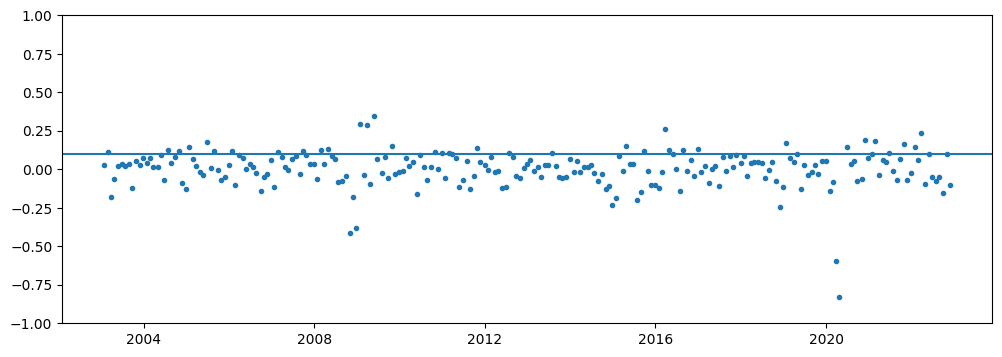

: 

: 

: 

: 

: 

In [ ]:
plt.figure(figsize=(12,4))
plt.plot(df_wti_weekly_end_mo_y_short["value_retRate"][:] , '.')
# plt.xlim(10000,12000)
plt.axhline(y = 0.10)
plt.ylim(-1,1)

: 

: 

: 

: 

: 

: 

: 

: 

: 

: 

: 

: 

: 

: 

: 

: 

: 

: 

: 

: 

: 

: 

: 

: 

: 

: 

: 

: 

: 

: 

: 

: 

: 

: 

: 

In [ ]:
print(df_wti_daily_y.columns)
print(df_HOC_daily.columns)

# Index(['period', 'duoarea', 'area-name', 'product', 'product-name', 'process',
#        'process-name', 'series', 'series-description', 'value', 'units',
#        'value_end_of_month'],
#       dtype='object')
# Index(['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume'], dtype='object')

Index(['period', 'duoarea', 'area-name', 'product', 'product-name', 'process',
       'process-name', 'series', 'series-description', 'value', 'units',
       'value_end_of_month'],
      dtype='object')


NameError: name 'df_HOC_daily' is not defined

: 

: 

: 

: 

: 

WTI index type: <class 'pandas.core.indexes.datetimes.DatetimeIndex'>
WTI index is monotonic: False
WTI index sorted: True

HOC index type: <class 'pandas.core.indexes.datetimes.DatetimeIndex'>
HOC index is monotonic: False
HOC index sorted: True

WTI actual dates:
Min date: 1986-01-02 00:00:00
Max date: 2025-08-18 00:00:00

HOC actual dates:
Min date: 2008-01-16 00:00:00
Max date: 2025-08-26 00:00:00

WTI years: [1986, 1987, 1988, 1989, 1990, 1991, 1992, 1993, 1994, 1995, 1996, 1997, 1998, 1999, 2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022, 2023, 2024, 2025]
HOC years: [2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022, 2023, 2024, 2025]
Common years: [2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022, 2023, 2024, 2025]

Available common range: 2008-01-16 00:00:00 to 2025-08-18 00:00:00


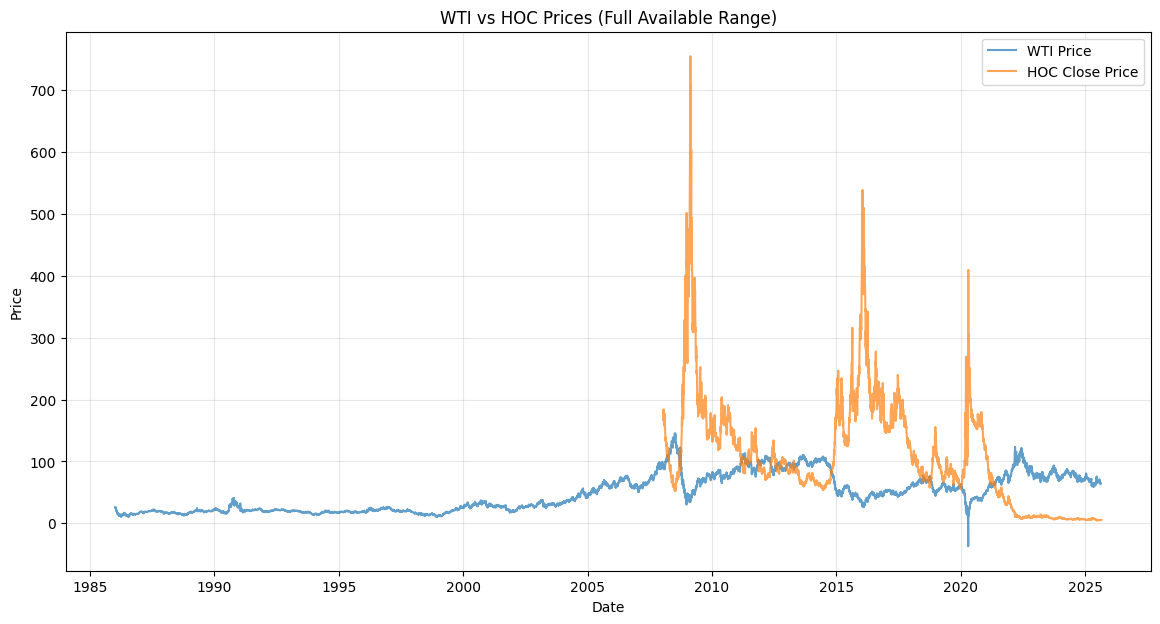

: 

: 

: 

: 

: 

: 

: 

: 

: 

: 

In [ ]:
# Check if the index is actually datetime and monotonic
print("WTI index type:", type(df_wti_daily_y.index))
print("WTI index is monotonic:", df_wti_daily_y.index.is_monotonic_increasing)
print("WTI index sorted:", df_wti_daily_y.index.is_unique)

print("\nHOC index type:", type(df_HOC_daily.index))
print("HOC index is monotonic:", df_HOC_daily.index.is_monotonic_increasing)
print("HOC index sorted:", df_HOC_daily.index.is_unique)

# Check actual date ranges
print("\nWTI actual dates:")
print("Min date:", df_wti_daily_y.index.min())
print("Max date:", df_wti_daily_y.index.max())

print("\nHOC actual dates:")
print("Min date:", df_HOC_daily.index.min())
print("Max date:", df_HOC_daily.index.max())

# Check if we have any overlapping data
wti_years = df_wti_daily_y.index.year.unique()
hoc_years = df_HOC_daily.index.year.unique()
common_years = set(wti_years) & set(hoc_years)

print(f"\nWTI years: {sorted(wti_years)}")
print(f"HOC years: {sorted(hoc_years)}")
print(f"Common years: {sorted(common_years)}")

# If we want to plot, let's see what data we actually have
if len(common_years) > 0:
    # Get the actual available data range
    available_start = max(df_wti_daily_y.index.min(), df_HOC_daily.index.min())
    available_end = min(df_wti_daily_y.index.max(), df_HOC_daily.index.max())
    
    print(f"\nAvailable common range: {available_start} to {available_end}")
    
    # Plot what we have
    import matplotlib.pyplot as plt
    
    plt.figure(figsize=(14, 7))
    plt.plot(df_wti_daily_y.index, df_wti_daily_y['value'], label='WTI Price', alpha=0.7)
    plt.plot(df_HOC_daily.index, df_HOC_daily['Close'], label='HOC Close Price', alpha=0.7)
    plt.title('WTI vs HOC Prices (Full Available Range)')
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()
else:
    print("No overlapping years between WTI and HOC datasets")

WTI 2010-2019 rows: 0
HOC 2010-2019 rows: 0


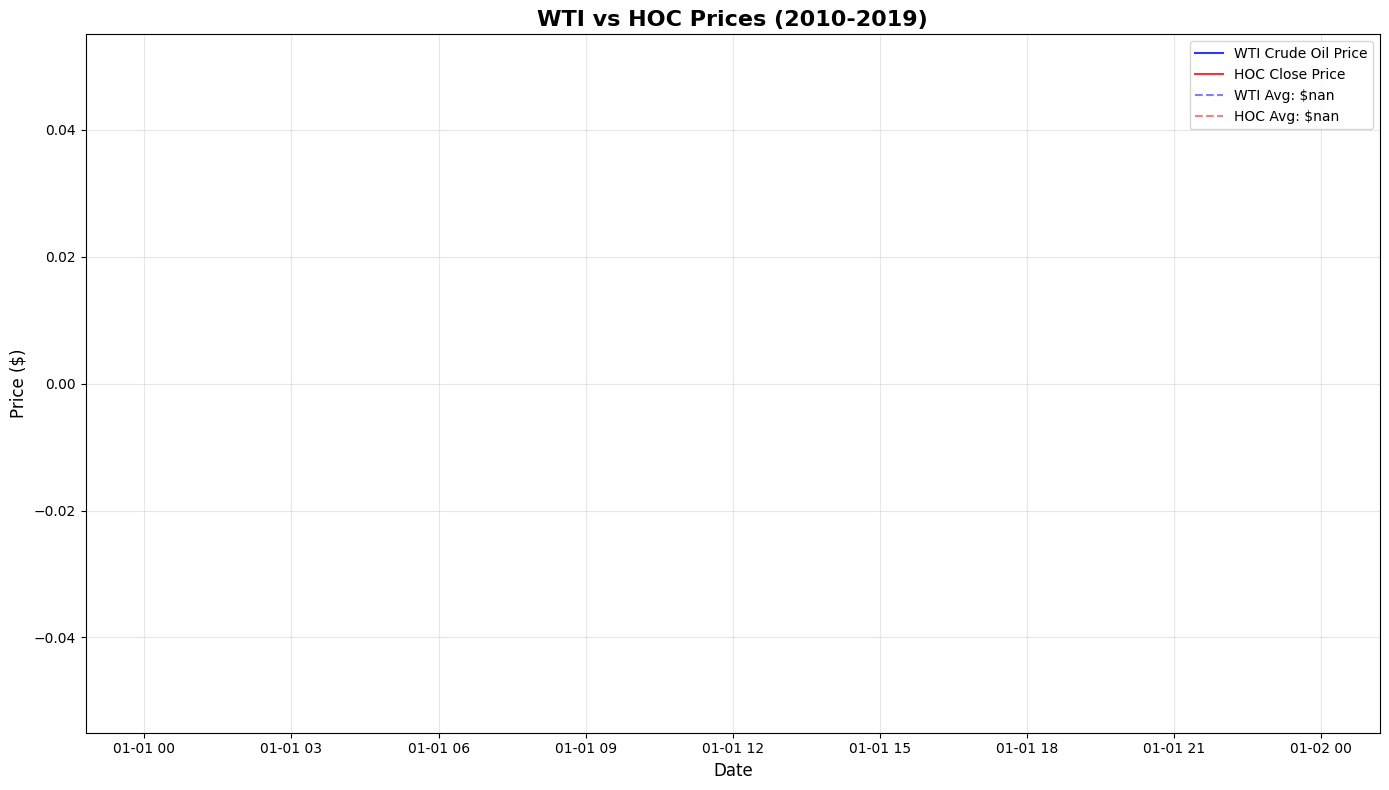


WTI 2010-2019 Statistics:
Average price: $nan
Minimum price: $nan
Maximum price: $nan

HOC 2010-2019 Statistics:
Average price: $nan
Minimum price: $nan
Maximum price: $nan


: 

: 

: 

: 

: 

: 

: 

: 

: 

: 

In [ ]:
# BetaPro Crude Oil Inverse Leveraged Daily Bear ETF (HOD.TO)

# Sort both dataframes by index to make them monotonic
df_wti_sorted = df_wti_daily_y.sort_index()
df_hoc_sorted = df_HOC_daily.sort_index()

# Filter for 2010-2019 range
start_2010 = '2088-06-01'
end_2019 = '2022-12-31'

# Get data for the specified range
wti_2010_2019 = df_wti_sorted.loc[start_2010:end_2019]
hoc_2010_2019 = df_hoc_sorted.loc[start_2010:end_2019]

print(f"WTI 2010-2019 rows: {len(wti_2010_2019)}")
print(f"HOC 2010-2019 rows: {len(hoc_2010_2019)}")

# Plot both series from 2010 to 2019
import matplotlib.pyplot as plt

plt.figure(figsize=(14, 8))
plt.plot(wti_2010_2019.index, wti_2010_2019['value'], label='WTI Crude Oil Price', linewidth=1.5, color='blue', alpha=0.8)
plt.plot(hoc_2010_2019.index, hoc_2010_2019['Close'], label='HOC Close Price', linewidth=1.5, color='red', alpha=0.8)

plt.title('WTI vs HOC Prices (2010-2019)', fontsize=16, fontweight='bold')
plt.xlabel('Date', fontsize=12)
plt.ylabel('Price ($)', fontsize=12)
plt.legend(fontsize=12)
plt.grid(True, alpha=0.3)

# Add some statistics to the plot
wti_avg = wti_2010_2019['value'].mean()
hoc_avg = hoc_2010_2019['Close'].mean()

plt.axhline(y=wti_avg, color='blue', linestyle='--', alpha=0.5, label=f'WTI Avg: ${wti_avg:.2f}')
plt.axhline(y=hoc_avg, color='red', linestyle='--', alpha=0.5, label=f'HOC Avg: ${hoc_avg:.2f}')

plt.legend(fontsize=10)
plt.tight_layout()
plt.show()

# Print some statistics
print(f"\nWTI 2010-2019 Statistics:")
print(f"Average price: ${wti_2010_2019['value'].mean():.2f}")
print(f"Minimum price: ${wti_2010_2019['value'].min():.2f}")
print(f"Maximum price: ${wti_2010_2019['value'].max():.2f}")

print(f"\nHOC 2010-2019 Statistics:")
print(f"Average price: ${hoc_2010_2019['Close'].mean():.2f}")
print(f"Minimum price: ${hoc_2010_2019['Close'].min():.2f}")
print(f"Maximum price: ${hoc_2010_2019['Close'].max():.2f}")




In [ ]:
# Normalize and calculate correlation
wti_norm = (wti_2010_2019['value'] - wti_2010_2019['value'].mean()) / wti_2010_2019['value'].std()
hoc_norm = (hoc_2010_2019['Close'] - hoc_2010_2019['Close'].mean()) / hoc_2010_2019['Close'].std()

correlation = wti_norm.corr(hoc_norm)
print(f"Correlation: {correlation:.3f}")


# Calculate monthly averages
wti_monthly_avg = wti_2010_2019['value'].resample('M').mean()
hoc_monthly_avg = hoc_2010_2019['Close'].resample('M').mean()

# Normalize monthly averages
wti_monthly_norm = (wti_monthly_avg - wti_monthly_avg.mean()) / wti_monthly_avg.std()
hoc_monthly_norm = (hoc_monthly_avg - hoc_monthly_avg.mean()) / hoc_monthly_avg.std()

# Calculate correlation
monthly_correlation = wti_monthly_norm.corr(hoc_monthly_norm)
print(f"Monthly Average Correlation: {monthly_correlation:.3f}")

# Get end of month values
wti_month_end = wti_2010_2019['value'].resample('M').last()
hoc_month_end = hoc_2010_2019['Close'].resample('M').last()

# Normalize end of month values
wti_end_norm = (wti_month_end - wti_month_end.mean()) / wti_month_end.std()
hoc_end_norm = (hoc_month_end - hoc_month_end.mean()) / hoc_month_end.std()

# Calculate correlation
end_month_correlation = wti_end_norm.corr(hoc_end_norm)
print(f"End of Month Correlation: {end_month_correlation:.3f}")


# Get end of month values
wti_month_end = wti_2010_2019['value'].resample('M').last()
hoc_month_end = hoc_2010_2019['Close'].resample('M').last()

# Calculate MoM % change, convert to binary (1=up, 0=down), and drop NaNs
wti_dir = (wti_month_end.pct_change() >= 0).astype(int).dropna()
hoc_dir = (hoc_month_end.pct_change() >= 0).astype(int).dropna()

# Calculate correlation
end_month_dir_correlation = wti_dir.corr(hoc_dir)
print(f"End of Month Directional Correlation: {end_month_dir_correlation:.3f}")

Correlation: -0.686
Monthly Average Correlation: -0.658
End of Month Correlation: -0.762
End of Month Directional Correlation: -0.645


: 

: 

: 

: 

: 

: 

: 

: 

: 

: 

In [ ]:
# Get unique year-month combinations
year_month = df_wti_weekly_y.index.strftime('%Y-%m')
unique_months = sorted(set(year_month))

# Get last date of each month
end_of_month_dates = []
for month in unique_months:
    month_dates = df_wti_weekly_y.index[year_month == month]
    end_of_month_dates.append(month_dates[-1])

# Create end of month column
df_wti_weekly_y["value_end_of_month"] = None
df_wti_weekly_y.loc[end_of_month_dates, "value_end_of_month"] = df_wti_weekly_y.loc[end_of_month_dates, "value"]

: 

: 

: 

: 

: 

: 

: 

: 

: 

: 

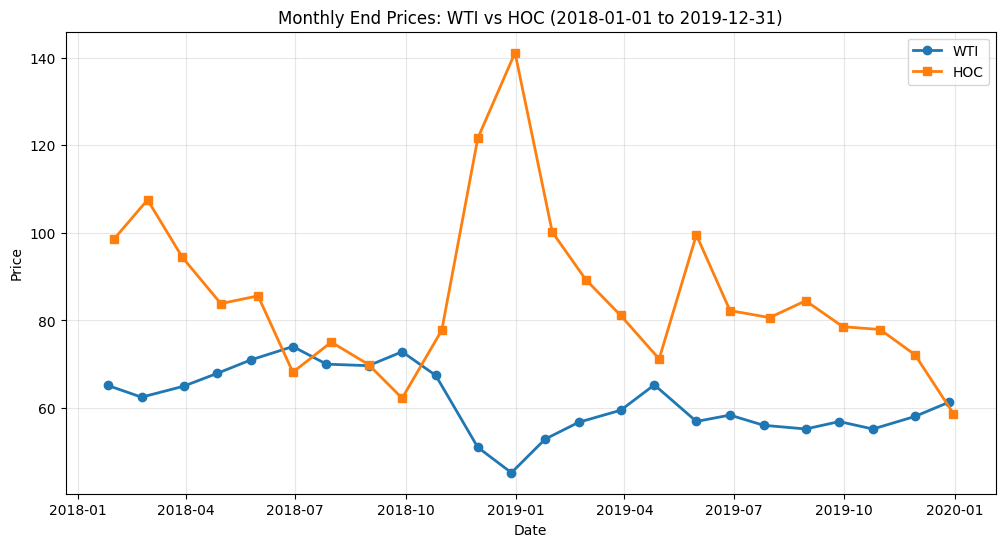

: 

: 

: 

: 

: 

: 

: 

: 

: 

: 

In [ ]:

# BetaPro Crude Oil Inverse Leveraged Daily Bear ETF (HOD.TO)
# Sort indexes first to fix non-monotonic error
def get_monthly_end_prices(df, price_col, start_date=None, end_date=None):
    # Sort index first
    df_sorted = df.sort_index()
    
    # Filter by date range if specified
    if start_date and end_date:
        df_sorted = df_sorted.loc[start_date:end_date]
    
    year_month = df_sorted.index.strftime('%Y-%m')
    unique_months = sorted(set(year_month))
    end_dates = [df_sorted.index[year_month == month][-1] for month in unique_months]
    return df_sorted.loc[end_dates, price_col]

# Choose your date range
start_date = '2018-01-01'
end_date = '2019-12-31'

wti_monthly = get_monthly_end_prices(df_wti_weekly_y, 'value', start_date, end_date)
hoc_monthly = get_monthly_end_prices(df_HOC_daily, 'Close', start_date, end_date)

# Plot both monthly end prices
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(wti_monthly.index, wti_monthly.values, marker='o', label='WTI', linewidth=2)
plt.plot(hoc_monthly.index, hoc_monthly.values, marker='s', label='HOC', linewidth=2)
plt.title(f'Monthly End Prices: WTI vs HOC ({start_date} to {end_date})')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

In [ ]:
# Calculate percentage change
wti_pct_change = wti_monthly.pct_change() * 100
hoc_pct_change = hoc_monthly.pct_change() * 100

# Plot percentage changes
plt.figure(figsize=(12, 6))
plt.plot(wti_pct_change.index, wti_pct_change.values, marker='o', label='WTI % Change', linewidth=2)
plt.plot(hoc_pct_change.index, hoc_pct_change.values, marker='s', label='HOC % Change', linewidth=2)
plt.title(f'Monthly Price Changes: WTI vs HOC ({start_date} to {end_date})')
plt.xlabel('Date')
plt.ylabel('Percentage Change (%)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.axhline(y=0, color='black', linestyle='-', alpha=0.3)
plt.show()

NameError: name 'wti_monthly' is not defined

: 

: 

: 

: 

: 

In [ ]:
#### Global X Crude Oil ETF (HUC.TO) --- DAILY

#https://ca.finance.yahoo.com/quote/HUC.TO/history/?period1=1256823000&period2=1756262518


raw_data = """



Jun 12, 2025	20.10	20.34	20.06	20.30	20.30	4,300
Jun 9, 2025	19.59	19.67	19.59	19.67	19.67	4,800
Jun 6, 2025	19.28	19.28	19.28	19.28	19.28	-
Jun 5, 2025	19.38	19.38	19.30	19.30	19.30	800
Jun 4, 2025	19.32	19.32	19.32	19.32	19.32	-
Jun 3, 2025	19.20	19.33	19.20	19.32	19.32	6,100
Jun 2, 2025	19.18	19.18	19.04	19.04	19.04	1,500
May 30, 2025	18.64	18.64	18.64	18.64	18.64	100
May 29, 2025	18.71	18.72	18.71	18.72	18.72	1,700
May 28, 2025	18.96	18.96	18.96	18.96	18.96	200
May 27, 2025	18.73	18.73	18.70	18.70	18.70	1,700
"""



import pandas as pd
import numpy as np

raw_data = raw_data.replace('-','0')


raw_data = raw_data.replace(',', '')
rows = [line.split('\t') for line in raw_data.strip().split('\n')]
cleaned_data = [[item.strip() for item in row if item != ''] for row in rows]

cleaned_data = [row for row in cleaned_data if len(row) == 7]

columns = ['Date', 'Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume']
df = pd.DataFrame(cleaned_data, columns=columns)

df['Date'] = pd.to_datetime(df['Date'], format='%b %d %Y', errors='coerce')

numeric_cols = ['Open', 'High', 'Low', 'Close', 'Adj Close']
for col in numeric_cols:
    df[col] = pd.to_numeric(df[col], errors='coerce')


df['Volume'] = df['Volume'].str.replace(',', '').astype(int)


df = df.dropna()

df_HUC_daily = df.set_index('Date')



# ###### add zeros in missing complications later wehn merging 



# start_date = '2000-01-01'
# end_date = df_HUC_daily.index.min() - pd.Timedelta(days=1)

# missing_dates = pd.date_range(start=start_date, end=end_date, freq='D')

# zeros_df = pd.DataFrame({
#     'Open': 0,
#     'High': 0,
#     'Low': 0,
#     'Close': 0,
#     'Adj Close': 0,
#     'Volume': 0
# }, index=missing_dates)

# for col in ['Open', 'High', 'Low', 'Close', 'Adj Close' , 'Volume']:
#     zeros_df[col] = zeros_df[col].astype(float)


# df_HUC_daily = df_HUC_daily[::-1]
# df_HUC_daily = pd.concat([zeros_df, df_HUC_daily])

# df_HUC_weekly_avg = df_HUC_daily.resample('W-FRI').mean() #### since the wti weekly data is avgs on FRIDAY AS WELL 

# df_HUC_weekly_avg[::-1].head(20)


# #################                                                                           END OF THE MONTH PRICES FROM WEEKLY DATA 

# all_dates_list = list(df_HUC_weekly_avg.index.astype(str))
# month_index = 7
# all_yr_mo = sorted(list(set([y[:month_index] for y in all_dates_list])))

# end_of_month_dates = []

# for yr_mo in all_yr_mo:

#     final_date = [i for i in list(df_HUC_weekly_avg.index.astype(str)) if i[:month_index] == str(yr_mo)][::-1][-1:]
#     end_of_month_dates.append(final_date[0])


# df_HUC_weekly_avg["value_end_of_month"] = df_HUC_weekly_avg["Close"][df_HUC_weekly_avg.index.astype(str).isin(end_of_month_dates)]

raw_data

'\n\n\n\nJun 12 2025\t20.10\t20.34\t20.06\t20.30\t20.30\t4300\nJun 9 2025\t19.59\t19.67\t19.59\t19.67\t19.67\t4800\nJun 6 2025\t19.28\t19.28\t19.28\t19.28\t19.28\t0\nJun 5 2025\t19.38\t19.38\t19.30\t19.30\t19.30\t800\nJun 4 2025\t19.32\t19.32\t19.32\t19.32\t19.32\t0\nJun 3 2025\t19.20\t19.33\t19.20\t19.32\t19.32\t6100\nJun 2 2025\t19.18\t19.18\t19.04\t19.04\t19.04\t1500\nMay 30 2025\t18.64\t18.64\t18.64\t18.64\t18.64\t100\nMay 29 2025\t18.71\t18.72\t18.71\t18.72\t18.72\t1700\nMay 28 2025\t18.96\t18.96\t18.96\t18.96\t18.96\t200\nMay 27 2025\t18.73\t18.73\t18.70\t18.70\t18.70\t1700\n'

: 

: 

: 

: 

: 

: 

: 

: 

: 

: 

In [ ]:
df_HUC_daily

"""
Jun 12, 2025	20.10	20.34	20.06	20.30	20.30	4,300
Jun 9, 2025	19.59	19.67	19.59	19.67	19.67	4,800
Jun 6, 2025	19.28	19.28	19.28	19.28	19.28	-
Jun 5, 2025	19.38	19.38	19.30	19.30	19.30	800
Jun 4, 2025	19.32	19.32	19.32	19.32	19.32	-
Jun 3, 2025	19.20	19.33	19.20	19.32	19.32	6,100
Jun 2, 2025	19.18	19.18	19.04	19.04	19.04	1,500
May 30, 2025	18.64	18.64	18.64	18.64	18.64	100
May 29, 2025	18.71	18.72	18.71	18.72	18.72	1,700
May 28, 2025	18.96	18.96	18.96	18.96	18.96	200
May 27, 2025	18.73	18.73	18.70	18.70	18.70	1,700
"""


df_HUC_daily


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2025-06-12,20.10,20.34,20.06,20.30,20.30,4300
2025-06-09,19.59,19.67,19.59,19.67,19.67,4800
2025-06-06,19.28,19.28,19.28,19.28,19.28,0
2025-06-05,19.38,19.38,19.30,19.30,19.30,800
2025-06-04,19.32,19.32,19.32,19.32,19.32,0
2025-06-03,19.20,19.33,19.20,19.32,19.32,6100
2025-06-02,19.18,19.18,19.04,19.04,19.04,1500
2025-05-30,18.64,18.64,18.64,18.64,18.64,100
2025-05-29,18.71,18.72,18.71,18.72,18.72,1700


: 

: 

: 

: 

: 

: 

: 

: 

: 

: 

,date,open,high,low,closeAdj,close
0,"May 27, 2025",98.96,99.61,98.78,99.55,99.55
1,"May 26, 2025",99.09,99.16,98.69,98.93,98.93
2,"May 19, 2025",100.91,100.91,99.05,99.11,99.11
3,"May 12, 2025",100.69,101.98,100.27,101.09,101.09
4,"May 5, 2025",100.00,100.86,99.17,100.34,100.34
...,...,...,...,...,...,...
1880,"May 22, 1989",103.92,104.28,101.41,102.52,102.52
1881,"May 15, 1989",100.59,102.45,100.13,101.97,101.97
1882,"May 8, 1989",98.53,99.48,98.40,99.44,99.44
1883,"May 1, 1989",98.06,98.55,97.89,98.42,98.42


: 

: 

: 

: 

: 

: 

: 

: 

: 

: 

: 

: 

: 

: 

: 

: 

: 

: 

: 

: 